In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [4]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2021_data.csv")
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2022_data.csv")
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2023_MLB_Seaspm.csv")

In [5]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [6]:
def preprocess_data(df):
    """
    This function takes a DataFrame and applies several preprocessing steps to it.
    """
    df = df.loc[df['release_speed'].notnull()].copy()
    int_cols = df.select_dtypes(include=['int64']).columns
    float_cols = df.select_dtypes(include=['float64']).columns
    df[int_cols] = df[int_cols].astype('int32')
    df[float_cols] = df[float_cols].astype('float32')

    # Condense pitch types using a mapping dictionary
    pitch_type_map = {
        "FF": "FF", "FT": "SI", "FC": "CT",
        "SL": "SL", "ST": "SL", "SV": "SL",
        "CH": "CH", "FS": "CH",
        "CU": "CB", "KC": "CB", "CS": "CB", "CB": "CB",
        "SI": "SI", "KN": "KN"
    }
    df['pitch_type_condensed'] = df['pitch_type'].map(pitch_type_map).fillna("FAHCK")

    df['release_pos_y'] = 60.5 - df['release_extension']
    df['height_ratio'] = df['release_pos_z'] / df['height_numeric']
    # Create 'pitch_id_raw'
    df['pitch_id_raw'] = df['game_pk'].astype(str) + "_" + df['batter'].astype(str) + "_" + df['pitcher'].astype(str) + "_" + df['pitch_number'].astype(str) + "_" + df['at_bat_number'].astype(str) + "_" + df['inning'].astype(str)

    df['throws'] = df['p_throws'].map({'R': 1, 'L': 0})
    return df

    return df

In [7]:
# Apply the function to the 'pitch_type' column
training_data = preprocess_data(data)
testing_data_processed = preprocess_data(testing_data)

In [8]:
breaking_ball = training_data.query('pitch_type_condensed in ("CH")')
breaking_ball_testing = testing_data_processed.query('pitch_type_condensed in ("CH")')

# Offspeed Model

In [9]:
# Now, separate features and identifiers
training_features = breaking_ball.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'balls', 'strikes', 'height_numeric'
], axis=1)
testing_features = breaking_ball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'Unnamed: 0', 'balls', 'strikes', 'height_numeric'
], axis=1)   # Exclude the identifier from the features

In [10]:
train_data = training_features.loc[training_features['pfx_x'].notnull()].drop(['pfx_x'], axis=1).copy()
train_label = training_features['pfx_x'].loc[training_features['pfx_x'].notnull()].copy()
testing_data = testing_features.loc[testing_features['spin_axis'].notnull()].drop(['pfx_x'], axis=1).copy()
testing_label = testing_features['pfx_x'].loc[testing_features['spin_axis'].notnull()].copy()

In [11]:
training_identifiers = train_data[['pitch_id_raw']]
testing_identifiers = testing_data[['pitch_id_raw']]
train_data = train_data.drop(['pitch_id_raw'], axis=1)
testing_data = testing_data.drop(['pitch_id_raw'], axis=1)

In [12]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_z', 'vx0',
       'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'throws'],
      dtype='object')

In [13]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_z', 'vx0',
       'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'throws'],
      dtype='object')

In [14]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.1,
    random_state=42
)

In [15]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
params = {
  'booster' : "gbtree",
  'objective' : "reg:squarederror",
  'eta' : 0.3,
  'max_depth' : 6,
  'min_child_weight' : 1,
  'subsample' : 0.5,
  'colsample_bytree' : 0.5
}

# Initial Model
model = xgb.train(params, dtrain)

In [16]:
y_pred = model.predict(dtest)

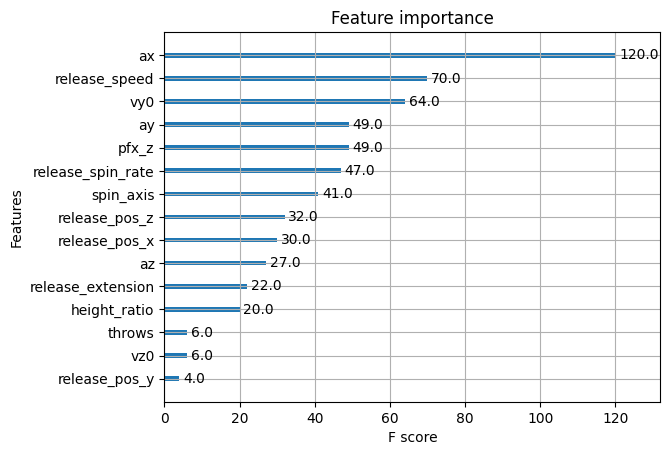

In [17]:
xgb.plot_importance(model)
plt.show()

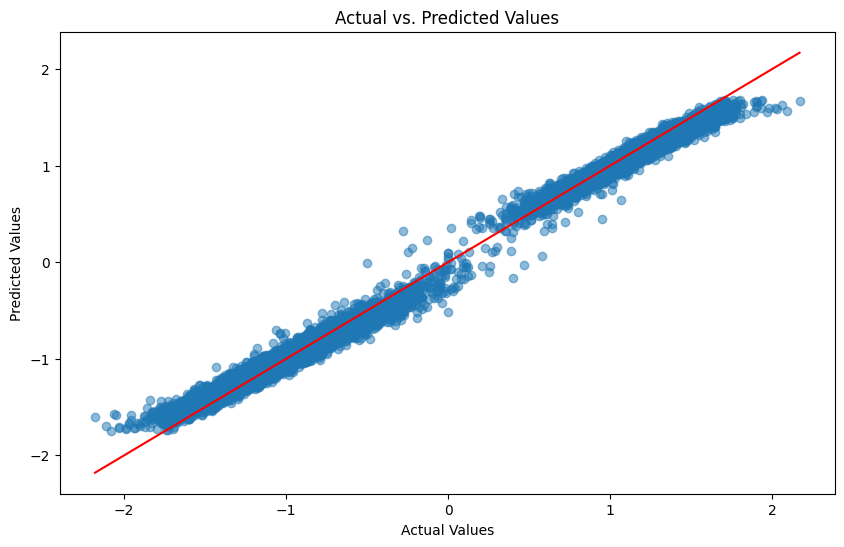

In [18]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red') # Line for perfect predictions
plt.show()

# Initial Paramater Tuning

In [19]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 4, 8),
        'device' : 'gpu',
        'eta': trial.suggest_float('eta', 0.2, 0.4),
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'subsample': trial.suggest_float('subsample', 0.4, 0.6),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.6),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=10  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid, iteration_range=(0, model.best_iteration + 1))


    # Calculate the RMSE on the validation set
    loss = np.sqrt(mean_squared_error(y_valid, y_valid_pred))


    return loss

In [20]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-15 09:27:11,161] A new study created in memory with name: no-name-8641f522-dd4b-45e5-a144-d74d4fad733a


[0]	eval-rmse:0.73908


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.49399
[2]	eval-rmse:0.34304
[3]	eval-rmse:0.24328
[4]	eval-rmse:0.18205
[5]	eval-rmse:0.12976
[6]	eval-rmse:0.10777
[7]	eval-rmse:0.08392
[8]	eval-rmse:0.07756
[9]	eval-rmse:0.06702
[10]	eval-rmse:0.05779
[11]	eval-rmse:0.05585
[12]	eval-rmse:0.05158
[13]	eval-rmse:0.04847
[14]	eval-rmse:0.04587
[15]	eval-rmse:0.04377
[16]	eval-rmse:0.04302
[17]	eval-rmse:0.04252
[18]	eval-rmse:0.04070
[19]	eval-rmse:0.04031
[20]	eval-rmse:0.04013
[21]	eval-rmse:0.03890
[22]	eval-rmse:0.03873
[23]	eval-rmse:0.03866
[24]	eval-rmse:0.03853
[25]	eval-rmse:0.03756
[26]	eval-rmse:0.03733
[27]	eval-rmse:0.03726
[28]	eval-rmse:0.03718
[29]	eval-rmse:0.03705
[30]	eval-rmse:0.03692
[31]	eval-rmse:0.03594
[32]	eval-rmse:0.03572
[33]	eval-rmse:0.03559
[34]	eval-rmse:0.03556
[35]	eval-rmse:0.03491
[36]	eval-rmse:0.03476
[37]	eval-rmse:0.03478
[38]	eval-rmse:0.03403
[39]	eval-rmse:0.03361
[40]	eval-rmse:0.03343
[41]	eval-rmse:0.03334
[42]	eval-rmse:0.03333
[43]	eval-rmse:0.03303
[44]	eval-rmse:0.032

[I 2023-11-15 09:27:13,082] Trial 0 finished with value: 0.02947908639907837 and parameters: {'max_depth': 7, 'eta': 0.3347318902093296, 'subsample': 0.44307242166969507, 'colsample_bytree': 0.5598032536657561, 'min_child_weight': 2}. Best is trial 0 with value: 0.02947908639907837.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.87346
[1]	eval-rmse:0.68964
[2]	eval-rmse:0.55369
[3]	eval-rmse:0.44589
[4]	eval-rmse:0.36313
[5]	eval-rmse:0.28897
[6]	eval-rmse:0.23992
[7]	eval-rmse:0.19342
[8]	eval-rmse:0.16526
[9]	eval-rmse:0.13619
[10]	eval-rmse:0.11334
[11]	eval-rmse:0.10179
[12]	eval-rmse:0.08752
[13]	eval-rmse:0.07706
[14]	eval-rmse:0.06883
[15]	eval-rmse:0.06199
[16]	eval-rmse:0.05946
[17]	eval-rmse:0.05782
[18]	eval-rmse:0.05327
[19]	eval-rmse:0.05243
[20]	eval-rmse:0.05189
[21]	eval-rmse:0.04897
[22]	eval-rmse:0.04873
[23]	eval-rmse:0.04863
[24]	eval-rmse:0.04843
[25]	eval-rmse:0.04626
[26]	eval-rmse:0.04603
[27]	eval-rmse:0.04588
[28]	eval-rmse:0.04577
[29]	eval-rmse:0.04566
[30]	eval-rmse:0.04561
[31]	eval-rmse:0.04372
[32]	eval-rmse:0.04357
[33]	eval-rmse:0.04356
[34]	eval-rmse:0.04347
[35]	eval-rmse:0.04194
[36]	eval-rmse:0.04186
[37]	eval-rmse:0.04181
[38]	eval-rmse:0.04061
[39]	eval-rmse:0.03959
[40]	eval-rmse:0.03949
[41]	eval-rmse:0.03942
[42]	eval-rmse:0.03935
[43]	eval-rmse:0.0386

[I 2023-11-15 09:27:15,705] Trial 1 finished with value: 0.03120308928191662 and parameters: {'max_depth': 8, 'eta': 0.21214799119772954, 'subsample': 0.41908488035509955, 'colsample_bytree': 0.5075948991080012, 'min_child_weight': 1}. Best is trial 0 with value: 0.02947908639907837.


[0]	eval-rmse:0.81639
[1]	eval-rmse:0.60271


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-rmse:0.45570
[3]	eval-rmse:0.34750
[4]	eval-rmse:0.27105
[5]	eval-rmse:0.20430
[6]	eval-rmse:0.16683
[7]	eval-rmse:0.12990
[8]	eval-rmse:0.11293
[9]	eval-rmse:0.09298
[10]	eval-rmse:0.07792
[11]	eval-rmse:0.07290
[12]	eval-rmse:0.06453
[13]	eval-rmse:0.05901
[14]	eval-rmse:0.05445
[15]	eval-rmse:0.05027
[16]	eval-rmse:0.04921
[17]	eval-rmse:0.04859
[18]	eval-rmse:0.04577
[19]	eval-rmse:0.04539
[20]	eval-rmse:0.04511
[21]	eval-rmse:0.04291
[22]	eval-rmse:0.04267
[23]	eval-rmse:0.04260
[24]	eval-rmse:0.04248
[25]	eval-rmse:0.04079
[26]	eval-rmse:0.04056
[27]	eval-rmse:0.04049
[28]	eval-rmse:0.04032
[29]	eval-rmse:0.04019
[30]	eval-rmse:0.04005
[31]	eval-rmse:0.03859
[32]	eval-rmse:0.03852
[33]	eval-rmse:0.03848
[34]	eval-rmse:0.03843
[35]	eval-rmse:0.03736
[36]	eval-rmse:0.03733
[37]	eval-rmse:0.03725
[38]	eval-rmse:0.03638
[39]	eval-rmse:0.03553
[40]	eval-rmse:0.03536
[41]	eval-rmse:0.03527
[42]	eval-rmse:0.03521
[43]	eval-rmse:0.03476
[44]	eval-rmse:0.03474
[45]	eval-rmse:0.03

[I 2023-11-15 09:27:17,913] Trial 2 finished with value: 0.02920508198440075 and parameters: {'max_depth': 7, 'eta': 0.26422388523143014, 'subsample': 0.4417132175968323, 'colsample_bytree': 0.5354207738218291, 'min_child_weight': 3}. Best is trial 2 with value: 0.02920508198440075.


[0]	eval-rmse:0.83608
[1]	eval-rmse:0.63223
[2]	eval-rmse:0.48949
[3]	eval-rmse:0.38197
[4]	eval-rmse:0.30417


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-rmse:0.23484
[6]	eval-rmse:0.19443
[7]	eval-rmse:0.15435
[8]	eval-rmse:0.13492
[9]	eval-rmse:0.11262
[10]	eval-rmse:0.09631
[11]	eval-rmse:0.08974
[12]	eval-rmse:0.08060
[13]	eval-rmse:0.07425
[14]	eval-rmse:0.06987
[15]	eval-rmse:0.06524
[16]	eval-rmse:0.06290
[17]	eval-rmse:0.06171
[18]	eval-rmse:0.05794
[19]	eval-rmse:0.05690
[20]	eval-rmse:0.05588
[21]	eval-rmse:0.05311
[22]	eval-rmse:0.05276
[23]	eval-rmse:0.05271
[24]	eval-rmse:0.05224
[25]	eval-rmse:0.05048
[26]	eval-rmse:0.05008
[27]	eval-rmse:0.04984
[28]	eval-rmse:0.04975
[29]	eval-rmse:0.04953
[30]	eval-rmse:0.04930
[31]	eval-rmse:0.04696
[32]	eval-rmse:0.04653
[33]	eval-rmse:0.04651
[34]	eval-rmse:0.04641
[35]	eval-rmse:0.04470
[36]	eval-rmse:0.04457
[37]	eval-rmse:0.04451
[38]	eval-rmse:0.04285
[39]	eval-rmse:0.04160
[40]	eval-rmse:0.04149
[41]	eval-rmse:0.04144
[42]	eval-rmse:0.04124
[43]	eval-rmse:0.04048
[44]	eval-rmse:0.04021
[45]	eval-rmse:0.03943
[46]	eval-rmse:0.03940
[47]	eval-rmse:0.03935
[48]	eval-rmse:0

[I 2023-11-15 09:27:19,498] Trial 3 finished with value: 0.02953570894896984 and parameters: {'max_depth': 5, 'eta': 0.2463286242403489, 'subsample': 0.4155605397123107, 'colsample_bytree': 0.4609661940213501, 'min_child_weight': 5}. Best is trial 2 with value: 0.02920508198440075.


[0]	eval-rmse:0.84067
[1]	eval-rmse:0.63901
[2]	eval-rmse:0.49682


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-rmse:0.38864
[4]	eval-rmse:0.30943
[5]	eval-rmse:0.23889
[6]	eval-rmse:0.19719
[7]	eval-rmse:0.15599
[8]	eval-rmse:0.13498
[9]	eval-rmse:0.11199
[10]	eval-rmse:0.09650
[11]	eval-rmse:0.08972
[12]	eval-rmse:0.08015
[13]	eval-rmse:0.07357
[14]	eval-rmse:0.06915
[15]	eval-rmse:0.06542
[16]	eval-rmse:0.06252
[17]	eval-rmse:0.06152
[18]	eval-rmse:0.05984
[19]	eval-rmse:0.05893
[20]	eval-rmse:0.05826
[21]	eval-rmse:0.05471
[22]	eval-rmse:0.05465
[23]	eval-rmse:0.05456
[24]	eval-rmse:0.05402
[25]	eval-rmse:0.05136
[26]	eval-rmse:0.05100
[27]	eval-rmse:0.05074
[28]	eval-rmse:0.05043
[29]	eval-rmse:0.05024
[30]	eval-rmse:0.05005
[31]	eval-rmse:0.04991
[32]	eval-rmse:0.04972
[33]	eval-rmse:0.04962
[34]	eval-rmse:0.04955
[35]	eval-rmse:0.04681
[36]	eval-rmse:0.04666
[37]	eval-rmse:0.04657
[38]	eval-rmse:0.04455
[39]	eval-rmse:0.04326
[40]	eval-rmse:0.04303
[41]	eval-rmse:0.04289
[42]	eval-rmse:0.04266
[43]	eval-rmse:0.04173
[44]	eval-rmse:0.04164
[45]	eval-rmse:0.04070
[46]	eval-rmse:0.0

[I 2023-11-15 09:27:21,516] Trial 4 finished with value: 0.03076060861349106 and parameters: {'max_depth': 6, 'eta': 0.2420251916580709, 'subsample': 0.4247246134623264, 'colsample_bytree': 0.4072564755194782, 'min_child_weight': 3}. Best is trial 2 with value: 0.02920508198440075.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.86356
[1]	eval-rmse:0.67419
[2]	eval-rmse:0.53522
[3]	eval-rmse:0.42683
[4]	eval-rmse:0.34484
[5]	eval-rmse:0.27183
[6]	eval-rmse:0.21534
[7]	eval-rmse:0.17184
[8]	eval-rmse:0.14443
[9]	eval-rmse:0.11839
[10]	eval-rmse:0.09797
[11]	eval-rmse:0.08716
[12]	eval-rmse:0.07478
[13]	eval-rmse:0.06589
[14]	eval-rmse:0.05858
[15]	eval-rmse:0.05325
[16]	eval-rmse:0.05118
[17]	eval-rmse:0.04994
[18]	eval-rmse:0.04632
[19]	eval-rmse:0.04579
[20]	eval-rmse:0.04531
[21]	eval-rmse:0.04326
[22]	eval-rmse:0.04303
[23]	eval-rmse:0.04274
[24]	eval-rmse:0.04103
[25]	eval-rmse:0.03955
[26]	eval-rmse:0.03935
[27]	eval-rmse:0.03928
[28]	eval-rmse:0.03909
[29]	eval-rmse:0.03898
[30]	eval-rmse:0.03887
[31]	eval-rmse:0.03758
[32]	eval-rmse:0.03741
[33]	eval-rmse:0.03739
[34]	eval-rmse:0.03733
[35]	eval-rmse:0.03652
[36]	eval-rmse:0.03651
[37]	eval-rmse:0.03649
[38]	eval-rmse:0.03576
[39]	eval-rmse:0.03512
[40]	eval-rmse:0.03497
[41]	eval-rmse:0.03489
[42]	eval-rmse:0.03488
[43]	eval-rmse:0.0343

[I 2023-11-15 09:27:24,475] Trial 5 finished with value: 0.029277577996253967 and parameters: {'max_depth': 8, 'eta': 0.22118279651026637, 'subsample': 0.4582286142615914, 'colsample_bytree': 0.5958868407233735, 'min_child_weight': 2}. Best is trial 2 with value: 0.02920508198440075.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72877
[1]	eval-rmse:0.48062
[2]	eval-rmse:0.33018
[3]	eval-rmse:0.23241
[4]	eval-rmse:0.17382
[5]	eval-rmse:0.12338
[6]	eval-rmse:0.10373
[7]	eval-rmse:0.08180
[8]	eval-rmse:0.07634
[9]	eval-rmse:0.06743
[10]	eval-rmse:0.06220
[11]	eval-rmse:0.06093
[12]	eval-rmse:0.05754
[13]	eval-rmse:0.05526
[14]	eval-rmse:0.05382
[15]	eval-rmse:0.05258
[16]	eval-rmse:0.04877
[17]	eval-rmse:0.04840
[18]	eval-rmse:0.04659
[19]	eval-rmse:0.04561
[20]	eval-rmse:0.04519
[21]	eval-rmse:0.04289
[22]	eval-rmse:0.04289
[23]	eval-rmse:0.04283
[24]	eval-rmse:0.04225
[25]	eval-rmse:0.04061
[26]	eval-rmse:0.04054
[27]	eval-rmse:0.04039
[28]	eval-rmse:0.04024
[29]	eval-rmse:0.04014
[30]	eval-rmse:0.03993
[31]	eval-rmse:0.03987
[32]	eval-rmse:0.03984
[33]	eval-rmse:0.03975
[34]	eval-rmse:0.03968
[35]	eval-rmse:0.03801
[36]	eval-rmse:0.03773
[37]	eval-rmse:0.03766
[38]	eval-rmse:0.03653
[39]	eval-rmse:0.03603
[40]	eval-rmse:0.03578
[41]	eval-rmse:0.03565
[42]	eval-rmse:0.03567
[43]	eval-rmse:0.0350

[I 2023-11-15 09:27:26,898] Trial 6 finished with value: 0.030275775119662285 and parameters: {'max_depth': 7, 'eta': 0.3439382453231361, 'subsample': 0.48116648925104144, 'colsample_bytree': 0.436700494302458, 'min_child_weight': 3}. Best is trial 2 with value: 0.02920508198440075.


[0]	eval-rmse:0.79005
[1]	eval-rmse:0.56475
[2]	eval-rmse:0.41632


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-rmse:0.31131
[4]	eval-rmse:0.24101
[5]	eval-rmse:0.17926
[6]	eval-rmse:0.14891
[7]	eval-rmse:0.11662
[8]	eval-rmse:0.10491
[9]	eval-rmse:0.08867
[10]	eval-rmse:0.07702
[11]	eval-rmse:0.07338
[12]	eval-rmse:0.06744
[13]	eval-rmse:0.06262
[14]	eval-rmse:0.05874
[15]	eval-rmse:0.05529
[16]	eval-rmse:0.05393
[17]	eval-rmse:0.05318
[18]	eval-rmse:0.05058
[19]	eval-rmse:0.04995
[20]	eval-rmse:0.04976
[21]	eval-rmse:0.04764
[22]	eval-rmse:0.04707
[23]	eval-rmse:0.04695
[24]	eval-rmse:0.04671
[25]	eval-rmse:0.04491
[26]	eval-rmse:0.04463
[27]	eval-rmse:0.04453
[28]	eval-rmse:0.04436
[29]	eval-rmse:0.04410
[30]	eval-rmse:0.04383
[31]	eval-rmse:0.04203
[32]	eval-rmse:0.04162
[33]	eval-rmse:0.04150
[34]	eval-rmse:0.04144
[35]	eval-rmse:0.04027
[36]	eval-rmse:0.04023
[37]	eval-rmse:0.04014
[38]	eval-rmse:0.03899
[39]	eval-rmse:0.03797
[40]	eval-rmse:0.03756
[41]	eval-rmse:0.03733
[42]	eval-rmse:0.03719
[43]	eval-rmse:0.03645
[44]	eval-rmse:0.03634
[45]	eval-rmse:0.03550
[46]	eval-rmse:0.0

[I 2023-11-15 09:27:28,663] Trial 7 finished with value: 0.027677448466420174 and parameters: {'max_depth': 5, 'eta': 0.28846213120082864, 'subsample': 0.5148220489157233, 'colsample_bytree': 0.5228898464899048, 'min_child_weight': 3}. Best is trial 7 with value: 0.027677448466420174.


[0]	eval-rmse:0.85821
[1]	eval-rmse:0.66547


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-rmse:0.52621
[3]	eval-rmse:0.41767
[4]	eval-rmse:0.33605
[5]	eval-rmse:0.26353
[6]	eval-rmse:0.21765
[7]	eval-rmse:0.17365
[8]	eval-rmse:0.14884
[9]	eval-rmse:0.12228
[10]	eval-rmse:0.10181
[11]	eval-rmse:0.09251
[12]	eval-rmse:0.08008
[13]	eval-rmse:0.07110
[14]	eval-rmse:0.06410
[15]	eval-rmse:0.05807
[16]	eval-rmse:0.05607
[17]	eval-rmse:0.05483
[18]	eval-rmse:0.05057
[19]	eval-rmse:0.04989
[20]	eval-rmse:0.04946
[21]	eval-rmse:0.04676
[22]	eval-rmse:0.04638
[23]	eval-rmse:0.04633
[24]	eval-rmse:0.04608
[25]	eval-rmse:0.04386
[26]	eval-rmse:0.04361
[27]	eval-rmse:0.04343
[28]	eval-rmse:0.04329
[29]	eval-rmse:0.04313
[30]	eval-rmse:0.04297
[31]	eval-rmse:0.04099
[32]	eval-rmse:0.04082
[33]	eval-rmse:0.04076
[34]	eval-rmse:0.04074
[35]	eval-rmse:0.03923
[36]	eval-rmse:0.03916
[37]	eval-rmse:0.03906
[38]	eval-rmse:0.03775
[39]	eval-rmse:0.03673
[40]	eval-rmse:0.03655
[41]	eval-rmse:0.03644
[42]	eval-rmse:0.03638
[43]	eval-rmse:0.03550
[44]	eval-rmse:0.03535
[45]	eval-rmse:0.03

[I 2023-11-15 09:27:30,917] Trial 8 finished with value: 0.027109835296869278 and parameters: {'max_depth': 7, 'eta': 0.2259809053950203, 'subsample': 0.5775140080806277, 'colsample_bytree': 0.510712618920273, 'min_child_weight': 3}. Best is trial 8 with value: 0.027109835296869278.


[0]	eval-rmse:0.78761
[1]	eval-rmse:0.56122


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-rmse:0.41297
[3]	eval-rmse:0.30815
[4]	eval-rmse:0.23819
[5]	eval-rmse:0.17691
[6]	eval-rmse:0.14677
[7]	eval-rmse:0.11482
[8]	eval-rmse:0.10344
[9]	eval-rmse:0.08807
[10]	eval-rmse:0.07726
[11]	eval-rmse:0.07339
[12]	eval-rmse:0.06745
[13]	eval-rmse:0.06371
[14]	eval-rmse:0.06117
[15]	eval-rmse:0.05813
[16]	eval-rmse:0.05590
[17]	eval-rmse:0.05493
[18]	eval-rmse:0.05155
[19]	eval-rmse:0.05063
[20]	eval-rmse:0.05005
[21]	eval-rmse:0.04769
[22]	eval-rmse:0.04742
[23]	eval-rmse:0.04732
[24]	eval-rmse:0.04699
[25]	eval-rmse:0.04529
[26]	eval-rmse:0.04488
[27]	eval-rmse:0.04471
[28]	eval-rmse:0.04463
[29]	eval-rmse:0.04447
[30]	eval-rmse:0.04420
[31]	eval-rmse:0.04304
[32]	eval-rmse:0.04267
[33]	eval-rmse:0.04251
[34]	eval-rmse:0.04240
[35]	eval-rmse:0.04082
[36]	eval-rmse:0.04075
[37]	eval-rmse:0.04056
[38]	eval-rmse:0.03933
[39]	eval-rmse:0.03844
[40]	eval-rmse:0.03823
[41]	eval-rmse:0.03818
[42]	eval-rmse:0.03801
[43]	eval-rmse:0.03740
[44]	eval-rmse:0.03714
[45]	eval-rmse:0.03

[I 2023-11-15 09:27:32,729] Trial 9 finished with value: 0.028655266389250755 and parameters: {'max_depth': 5, 'eta': 0.29070175332302856, 'subsample': 0.4826595893092317, 'colsample_bytree': 0.45737957558188796, 'min_child_weight': 1}. Best is trial 8 with value: 0.027109835296869278.


[0]	eval-rmse:0.88635


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.71048
[2]	eval-rmse:0.58008
[3]	eval-rmse:0.47510
[4]	eval-rmse:0.39378
[5]	eval-rmse:0.31938
[6]	eval-rmse:0.27076
[7]	eval-rmse:0.22251
[8]	eval-rmse:0.19441
[9]	eval-rmse:0.16439
[10]	eval-rmse:0.14156
[11]	eval-rmse:0.12917
[12]	eval-rmse:0.11488
[13]	eval-rmse:0.10370
[14]	eval-rmse:0.09554
[15]	eval-rmse:0.08761
[16]	eval-rmse:0.08380
[17]	eval-rmse:0.08121
[18]	eval-rmse:0.07629
[19]	eval-rmse:0.07461
[20]	eval-rmse:0.07336
[21]	eval-rmse:0.06997
[22]	eval-rmse:0.06918
[23]	eval-rmse:0.06893
[24]	eval-rmse:0.06818
[25]	eval-rmse:0.06503
[26]	eval-rmse:0.06439
[27]	eval-rmse:0.06412
[28]	eval-rmse:0.06371
[29]	eval-rmse:0.06350
[30]	eval-rmse:0.06319
[31]	eval-rmse:0.06068
[32]	eval-rmse:0.06038
[33]	eval-rmse:0.06011
[34]	eval-rmse:0.05989
[35]	eval-rmse:0.05797
[36]	eval-rmse:0.05781
[37]	eval-rmse:0.05767
[38]	eval-rmse:0.05543
[39]	eval-rmse:0.05347
[40]	eval-rmse:0.05326
[41]	eval-rmse:0.05303
[42]	eval-rmse:0.05277
[43]	eval-rmse:0.05170
[44]	eval-rmse:0.051

[I 2023-11-15 09:27:34,230] Trial 10 finished with value: 0.033597979694604874 and parameters: {'max_depth': 4, 'eta': 0.20094616895046852, 'subsample': 0.5915863191521302, 'colsample_bytree': 0.49559780338372694, 'min_child_weight': 5}. Best is trial 8 with value: 0.027109835296869278.


[0]	eval-rmse:0.68193


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.42192
[2]	eval-rmse:0.27660
[3]	eval-rmse:0.19082
[4]	eval-rmse:0.14533
[5]	eval-rmse:0.10527
[6]	eval-rmse:0.09382
[7]	eval-rmse:0.07620
[8]	eval-rmse:0.07351
[9]	eval-rmse:0.06594
[10]	eval-rmse:0.05875
[11]	eval-rmse:0.05655
[12]	eval-rmse:0.05304
[13]	eval-rmse:0.05065
[14]	eval-rmse:0.04817
[15]	eval-rmse:0.04617
[16]	eval-rmse:0.04536
[17]	eval-rmse:0.04494
[18]	eval-rmse:0.04329
[19]	eval-rmse:0.04318
[20]	eval-rmse:0.04298
[21]	eval-rmse:0.04160
[22]	eval-rmse:0.04106
[23]	eval-rmse:0.04095
[24]	eval-rmse:0.04088
[25]	eval-rmse:0.03928
[26]	eval-rmse:0.03920
[27]	eval-rmse:0.03886
[28]	eval-rmse:0.03877
[29]	eval-rmse:0.03867
[30]	eval-rmse:0.03843
[31]	eval-rmse:0.03713
[32]	eval-rmse:0.03684
[33]	eval-rmse:0.03677
[34]	eval-rmse:0.03665
[35]	eval-rmse:0.03587
[36]	eval-rmse:0.03574
[37]	eval-rmse:0.03569
[38]	eval-rmse:0.03482
[39]	eval-rmse:0.03450
[40]	eval-rmse:0.03427
[41]	eval-rmse:0.03424
[42]	eval-rmse:0.03412
[43]	eval-rmse:0.03360
[44]	eval-rmse:0.033

[I 2023-11-15 09:27:35,912] Trial 11 finished with value: 0.02731325849890709 and parameters: {'max_depth': 5, 'eta': 0.38721193587913205, 'subsample': 0.5420711476753151, 'colsample_bytree': 0.5180005278846517, 'min_child_weight': 4}. Best is trial 8 with value: 0.027109835296869278.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.68356
[1]	eval-rmse:0.42306
[2]	eval-rmse:0.27654
[3]	eval-rmse:0.18902
[4]	eval-rmse:0.14200
[5]	eval-rmse:0.10057
[6]	eval-rmse:0.08831
[7]	eval-rmse:0.07159
[8]	eval-rmse:0.06897
[9]	eval-rmse:0.06244
[10]	eval-rmse:0.05528
[11]	eval-rmse:0.05307
[12]	eval-rmse:0.04980
[13]	eval-rmse:0.04745
[14]	eval-rmse:0.04588
[15]	eval-rmse:0.04439
[16]	eval-rmse:0.04291
[17]	eval-rmse:0.04259
[18]	eval-rmse:0.04070
[19]	eval-rmse:0.04039
[20]	eval-rmse:0.04022
[21]	eval-rmse:0.03906
[22]	eval-rmse:0.03872
[23]	eval-rmse:0.03857
[24]	eval-rmse:0.03845
[25]	eval-rmse:0.03748
[26]	eval-rmse:0.03732
[27]	eval-rmse:0.03729
[28]	eval-rmse:0.03724
[29]	eval-rmse:0.03691
[30]	eval-rmse:0.03661
[31]	eval-rmse:0.03546
[32]	eval-rmse:0.03535
[33]	eval-rmse:0.03525
[34]	eval-rmse:0.03520
[35]	eval-rmse:0.03457
[36]	eval-rmse:0.03449
[37]	eval-rmse:0.03446
[38]	eval-rmse:0.03386
[39]	eval-rmse:0.03356
[40]	eval-rmse:0.03353
[41]	eval-rmse:0.03350
[42]	eval-rmse:0.03347
[43]	eval-rmse:0.0332

[I 2023-11-15 09:27:37,950] Trial 12 finished with value: 0.028725598007440567 and parameters: {'max_depth': 6, 'eta': 0.3855640355005978, 'subsample': 0.560491231037844, 'colsample_bytree': 0.48670020337308284, 'min_child_weight': 4}. Best is trial 8 with value: 0.027109835296869278.


[0]	eval-rmse:0.67232
[1]	eval-rmse:0.41162
[2]	eval-rmse:0.26942


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-rmse:0.18839
[4]	eval-rmse:0.14729
[5]	eval-rmse:0.10958
[6]	eval-rmse:0.09960
[7]	eval-rmse:0.08313
[8]	eval-rmse:0.08040
[9]	eval-rmse:0.07346
[10]	eval-rmse:0.06710
[11]	eval-rmse:0.06433
[12]	eval-rmse:0.06080
[13]	eval-rmse:0.05767
[14]	eval-rmse:0.05504
[15]	eval-rmse:0.05333
[16]	eval-rmse:0.05208
[17]	eval-rmse:0.05156
[18]	eval-rmse:0.04942
[19]	eval-rmse:0.04857
[20]	eval-rmse:0.04816
[21]	eval-rmse:0.04623
[22]	eval-rmse:0.04554
[23]	eval-rmse:0.04543
[24]	eval-rmse:0.04533
[25]	eval-rmse:0.04416
[26]	eval-rmse:0.04370
[27]	eval-rmse:0.04358
[28]	eval-rmse:0.04337
[29]	eval-rmse:0.04331
[30]	eval-rmse:0.04302
[31]	eval-rmse:0.04169
[32]	eval-rmse:0.04133
[33]	eval-rmse:0.04101
[34]	eval-rmse:0.04098
[35]	eval-rmse:0.03984
[36]	eval-rmse:0.03973
[37]	eval-rmse:0.03968
[38]	eval-rmse:0.03898
[39]	eval-rmse:0.03865
[40]	eval-rmse:0.03827
[41]	eval-rmse:0.03821
[42]	eval-rmse:0.03803
[43]	eval-rmse:0.03761
[44]	eval-rmse:0.03744
[45]	eval-rmse:0.03687
[46]	eval-rmse:0.0

[I 2023-11-15 09:27:39,471] Trial 13 finished with value: 0.02863030694425106 and parameters: {'max_depth': 4, 'eta': 0.396989096319388, 'subsample': 0.5400165426492566, 'colsample_bytree': 0.5406925720465345, 'min_child_weight': 4}. Best is trial 8 with value: 0.027109835296869278.


[0]	eval-rmse:0.75151


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.51090
[2]	eval-rmse:0.36051
[3]	eval-rmse:0.25969
[4]	eval-rmse:0.19642
[5]	eval-rmse:0.14147
[6]	eval-rmse:0.11782
[7]	eval-rmse:0.09209
[8]	eval-rmse:0.08458
[9]	eval-rmse:0.07337
[10]	eval-rmse:0.06423
[11]	eval-rmse:0.06163
[12]	eval-rmse:0.05668
[13]	eval-rmse:0.05317
[14]	eval-rmse:0.05075
[15]	eval-rmse:0.04871
[16]	eval-rmse:0.04687
[17]	eval-rmse:0.04635
[18]	eval-rmse:0.04355
[19]	eval-rmse:0.04295
[20]	eval-rmse:0.04270
[21]	eval-rmse:0.04109
[22]	eval-rmse:0.04090
[23]	eval-rmse:0.04084
[24]	eval-rmse:0.04064
[25]	eval-rmse:0.03937
[26]	eval-rmse:0.03913
[27]	eval-rmse:0.03898
[28]	eval-rmse:0.03882
[29]	eval-rmse:0.03873
[30]	eval-rmse:0.03870
[31]	eval-rmse:0.03744
[32]	eval-rmse:0.03725
[33]	eval-rmse:0.03720
[34]	eval-rmse:0.03713
[35]	eval-rmse:0.03594
[36]	eval-rmse:0.03580
[37]	eval-rmse:0.03578
[38]	eval-rmse:0.03502
[39]	eval-rmse:0.03440
[40]	eval-rmse:0.03435
[41]	eval-rmse:0.03410
[42]	eval-rmse:0.03408
[43]	eval-rmse:0.03357
[44]	eval-rmse:0.033

[I 2023-11-15 09:27:41,552] Trial 14 finished with value: 0.027921264991164207 and parameters: {'max_depth': 6, 'eta': 0.32338704375427574, 'subsample': 0.5968152340069581, 'colsample_bytree': 0.4884380368421158, 'min_child_weight': 4}. Best is trial 8 with value: 0.027109835296869278.


[0]	eval-rmse:0.70199
[1]	eval-rmse:0.44676


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-rmse:0.29935
[3]	eval-rmse:0.20897
[4]	eval-rmse:0.15849
[5]	eval-rmse:0.11393
[6]	eval-rmse:0.09934
[7]	eval-rmse:0.08010
[8]	eval-rmse:0.07635
[9]	eval-rmse:0.06804
[10]	eval-rmse:0.06027
[11]	eval-rmse:0.05798
[12]	eval-rmse:0.05407
[13]	eval-rmse:0.05180
[14]	eval-rmse:0.04915
[15]	eval-rmse:0.04688
[16]	eval-rmse:0.04630
[17]	eval-rmse:0.04550
[18]	eval-rmse:0.04344
[19]	eval-rmse:0.04320
[20]	eval-rmse:0.04299
[21]	eval-rmse:0.04198
[22]	eval-rmse:0.04145
[23]	eval-rmse:0.04131
[24]	eval-rmse:0.04126
[25]	eval-rmse:0.04015
[26]	eval-rmse:0.03956
[27]	eval-rmse:0.03911
[28]	eval-rmse:0.03899
[29]	eval-rmse:0.03887
[30]	eval-rmse:0.03852
[31]	eval-rmse:0.03712
[32]	eval-rmse:0.03673
[33]	eval-rmse:0.03661
[34]	eval-rmse:0.03655
[35]	eval-rmse:0.03570
[36]	eval-rmse:0.03552
[37]	eval-rmse:0.03545
[38]	eval-rmse:0.03442
[39]	eval-rmse:0.03378
[40]	eval-rmse:0.03351
[41]	eval-rmse:0.03346
[42]	eval-rmse:0.03328
[43]	eval-rmse:0.03295
[44]	eval-rmse:0.03282
[45]	eval-rmse:0.03

[I 2023-11-15 09:27:43,226] Trial 15 finished with value: 0.026927880942821503 and parameters: {'max_depth': 5, 'eta': 0.3688578532474996, 'subsample': 0.5552777360147658, 'colsample_bytree': 0.5584376034455727, 'min_child_weight': 4}. Best is trial 15 with value: 0.026927880942821503.


[0]	eval-rmse:0.70601


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.45137
[2]	eval-rmse:0.30121
[3]	eval-rmse:0.20802
[4]	eval-rmse:0.15463
[5]	eval-rmse:0.10847
[6]	eval-rmse:0.08134
[7]	eval-rmse:0.06563
[8]	eval-rmse:0.05989
[9]	eval-rmse:0.05375
[10]	eval-rmse:0.04795
[11]	eval-rmse:0.04664
[12]	eval-rmse:0.04373
[13]	eval-rmse:0.04169
[14]	eval-rmse:0.03967
[15]	eval-rmse:0.03844
[16]	eval-rmse:0.03759
[17]	eval-rmse:0.03721
[18]	eval-rmse:0.03588
[19]	eval-rmse:0.03564
[20]	eval-rmse:0.03543
[21]	eval-rmse:0.03447
[22]	eval-rmse:0.03419
[23]	eval-rmse:0.03398
[24]	eval-rmse:0.03316
[25]	eval-rmse:0.03267
[26]	eval-rmse:0.03262
[27]	eval-rmse:0.03255
[28]	eval-rmse:0.03245
[29]	eval-rmse:0.03233
[30]	eval-rmse:0.03229
[31]	eval-rmse:0.03165
[32]	eval-rmse:0.03151
[33]	eval-rmse:0.03144
[34]	eval-rmse:0.03147
[35]	eval-rmse:0.03119
[36]	eval-rmse:0.03114
[37]	eval-rmse:0.03107
[38]	eval-rmse:0.03068
[39]	eval-rmse:0.03045
[40]	eval-rmse:0.03036
[41]	eval-rmse:0.03034
[42]	eval-rmse:0.03029
[43]	eval-rmse:0.03013
[44]	eval-rmse:0.030

[I 2023-11-15 09:27:45,339] Trial 16 finished with value: 0.027796270325779915 and parameters: {'max_depth': 7, 'eta': 0.36478322520986983, 'subsample': 0.5713079109786979, 'colsample_bytree': 0.5667563542872658, 'min_child_weight': 2}. Best is trial 15 with value: 0.026927880942821503.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.76722
[1]	eval-rmse:0.53232
[2]	eval-rmse:0.38129
[3]	eval-rmse:0.27708
[4]	eval-rmse:0.20936
[5]	eval-rmse:0.15141
[6]	eval-rmse:0.12346
[7]	eval-rmse:0.09507
[8]	eval-rmse:0.08534
[9]	eval-rmse:0.07198
[10]	eval-rmse:0.06141
[11]	eval-rmse:0.05902
[12]	eval-rmse:0.05361
[13]	eval-rmse:0.04974
[14]	eval-rmse:0.04669
[15]	eval-rmse:0.04393
[16]	eval-rmse:0.04324
[17]	eval-rmse:0.04287
[18]	eval-rmse:0.04081
[19]	eval-rmse:0.04057
[20]	eval-rmse:0.04036
[21]	eval-rmse:0.03895
[22]	eval-rmse:0.03879
[23]	eval-rmse:0.03869
[24]	eval-rmse:0.03862
[25]	eval-rmse:0.03759
[26]	eval-rmse:0.03743
[27]	eval-rmse:0.03736
[28]	eval-rmse:0.03729
[29]	eval-rmse:0.03722
[30]	eval-rmse:0.03712
[31]	eval-rmse:0.03608
[32]	eval-rmse:0.03596
[33]	eval-rmse:0.03591
[34]	eval-rmse:0.03589
[35]	eval-rmse:0.03511
[36]	eval-rmse:0.03499
[37]	eval-rmse:0.03504
[38]	eval-rmse:0.03439
[39]	eval-rmse:0.03399
[40]	eval-rmse:0.03382
[41]	eval-rmse:0.03376
[42]	eval-rmse:0.03375
[43]	eval-rmse:0.0334

[I 2023-11-15 09:27:48,009] Trial 17 finished with value: 0.03021037019789219 and parameters: {'max_depth': 8, 'eta': 0.3088392589529951, 'subsample': 0.5263025656425844, 'colsample_bytree': 0.55666781467812, 'min_child_weight': 5}. Best is trial 15 with value: 0.026927880942821503.


[0]	eval-rmse:0.71799


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.46644
[2]	eval-rmse:0.31635
[3]	eval-rmse:0.22148
[4]	eval-rmse:0.16626
[5]	eval-rmse:0.11843
[6]	eval-rmse:0.08939
[7]	eval-rmse:0.07283
[8]	eval-rmse:0.06640
[9]	eval-rmse:0.05919
[10]	eval-rmse:0.05271
[11]	eval-rmse:0.05073
[12]	eval-rmse:0.04726
[13]	eval-rmse:0.04505
[14]	eval-rmse:0.04264
[15]	eval-rmse:0.04094
[16]	eval-rmse:0.04026
[17]	eval-rmse:0.04000
[18]	eval-rmse:0.03860
[19]	eval-rmse:0.03813
[20]	eval-rmse:0.03802
[21]	eval-rmse:0.03718
[22]	eval-rmse:0.03688
[23]	eval-rmse:0.03682
[24]	eval-rmse:0.03564
[25]	eval-rmse:0.03481
[26]	eval-rmse:0.03467
[27]	eval-rmse:0.03450
[28]	eval-rmse:0.03439
[29]	eval-rmse:0.03420
[30]	eval-rmse:0.03411
[31]	eval-rmse:0.03333
[32]	eval-rmse:0.03298
[33]	eval-rmse:0.03279
[34]	eval-rmse:0.03276
[35]	eval-rmse:0.03246
[36]	eval-rmse:0.03245
[37]	eval-rmse:0.03234
[38]	eval-rmse:0.03163
[39]	eval-rmse:0.03122
[40]	eval-rmse:0.03108
[41]	eval-rmse:0.03104
[42]	eval-rmse:0.03102
[43]	eval-rmse:0.03066
[44]	eval-rmse:0.030

[I 2023-11-15 09:27:50,035] Trial 18 finished with value: 0.026676315814256668 and parameters: {'max_depth': 6, 'eta': 0.35408589206735974, 'subsample': 0.5673092142348318, 'colsample_bytree': 0.5916154226545274, 'min_child_weight': 4}. Best is trial 18 with value: 0.026676315814256668.


[0]	eval-rmse:0.71988


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.47048
[2]	eval-rmse:0.32283
[3]	eval-rmse:0.23043
[4]	eval-rmse:0.17797
[5]	eval-rmse:0.13119
[6]	eval-rmse:0.10302
[7]	eval-rmse:0.08664
[8]	eval-rmse:0.08143
[9]	eval-rmse:0.07309
[10]	eval-rmse:0.06715
[11]	eval-rmse:0.06476
[12]	eval-rmse:0.06071
[13]	eval-rmse:0.05829
[14]	eval-rmse:0.05609
[15]	eval-rmse:0.05374
[16]	eval-rmse:0.05299
[17]	eval-rmse:0.05231
[18]	eval-rmse:0.04986
[19]	eval-rmse:0.04957
[20]	eval-rmse:0.04935
[21]	eval-rmse:0.04822
[22]	eval-rmse:0.04781
[23]	eval-rmse:0.04761
[24]	eval-rmse:0.04571
[25]	eval-rmse:0.04457
[26]	eval-rmse:0.04380
[27]	eval-rmse:0.04359
[28]	eval-rmse:0.04342
[29]	eval-rmse:0.04335
[30]	eval-rmse:0.04300
[31]	eval-rmse:0.04170
[32]	eval-rmse:0.04132
[33]	eval-rmse:0.04092
[34]	eval-rmse:0.04081
[35]	eval-rmse:0.03996
[36]	eval-rmse:0.03985
[37]	eval-rmse:0.03977
[38]	eval-rmse:0.03878
[39]	eval-rmse:0.03817
[40]	eval-rmse:0.03792
[41]	eval-rmse:0.03777
[42]	eval-rmse:0.03758
[43]	eval-rmse:0.03700
[44]	eval-rmse:0.036

[I 2023-11-15 09:27:51,451] Trial 19 finished with value: 0.028063924983143806 and parameters: {'max_depth': 4, 'eta': 0.3533454881790418, 'subsample': 0.5599780970857009, 'colsample_bytree': 0.5946512675186787, 'min_child_weight': 4}. Best is trial 18 with value: 0.026676315814256668.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.70766
[1]	eval-rmse:0.45348
[2]	eval-rmse:0.30379
[3]	eval-rmse:0.21111
[4]	eval-rmse:0.15848
[5]	eval-rmse:0.11235
[6]	eval-rmse:0.08575
[7]	eval-rmse:0.07036
[8]	eval-rmse:0.06465
[9]	eval-rmse:0.05826
[10]	eval-rmse:0.05199
[11]	eval-rmse:0.05035
[12]	eval-rmse:0.04725
[13]	eval-rmse:0.04498
[14]	eval-rmse:0.04297
[15]	eval-rmse:0.04191
[16]	eval-rmse:0.04143
[17]	eval-rmse:0.04116
[18]	eval-rmse:0.03980
[19]	eval-rmse:0.03938
[20]	eval-rmse:0.03913
[21]	eval-rmse:0.03818
[22]	eval-rmse:0.03794
[23]	eval-rmse:0.03763
[24]	eval-rmse:0.03685
[25]	eval-rmse:0.03588
[26]	eval-rmse:0.03560
[27]	eval-rmse:0.03539
[28]	eval-rmse:0.03533
[29]	eval-rmse:0.03534
[30]	eval-rmse:0.03514
[31]	eval-rmse:0.03427
[32]	eval-rmse:0.03406
[33]	eval-rmse:0.03391
[34]	eval-rmse:0.03385
[35]	eval-rmse:0.03350
[36]	eval-rmse:0.03321
[37]	eval-rmse:0.03313
[38]	eval-rmse:0.03275
[39]	eval-rmse:0.03236
[40]	eval-rmse:0.03236
[41]	eval-rmse:0.03233
[42]	eval-rmse:0.03217
[43]	eval-rmse:0.0319

[I 2023-11-15 09:27:53,450] Trial 20 finished with value: 0.02803823910653591 and parameters: {'max_depth': 6, 'eta': 0.36348578163522993, 'subsample': 0.5089210349081839, 'colsample_bytree': 0.5747451044158542, 'min_child_weight': 5}. Best is trial 18 with value: 0.026676315814256668.


[0]	eval-rmse:0.75547


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.51629
[2]	eval-rmse:0.36514
[3]	eval-rmse:0.26373
[4]	eval-rmse:0.19976
[5]	eval-rmse:0.14405
[6]	eval-rmse:0.10808
[7]	eval-rmse:0.08522
[8]	eval-rmse:0.07567
[9]	eval-rmse:0.06541
[10]	eval-rmse:0.05704
[11]	eval-rmse:0.05468
[12]	eval-rmse:0.05066
[13]	eval-rmse:0.04754
[14]	eval-rmse:0.04469
[15]	eval-rmse:0.04245
[16]	eval-rmse:0.04157
[17]	eval-rmse:0.04122
[18]	eval-rmse:0.03936
[19]	eval-rmse:0.03900
[20]	eval-rmse:0.03875
[21]	eval-rmse:0.03761
[22]	eval-rmse:0.03730
[23]	eval-rmse:0.03714
[24]	eval-rmse:0.03642
[25]	eval-rmse:0.03541
[26]	eval-rmse:0.03503
[27]	eval-rmse:0.03480
[28]	eval-rmse:0.03466
[29]	eval-rmse:0.03453
[30]	eval-rmse:0.03445
[31]	eval-rmse:0.03347
[32]	eval-rmse:0.03331
[33]	eval-rmse:0.03328
[34]	eval-rmse:0.03320
[35]	eval-rmse:0.03250
[36]	eval-rmse:0.03243
[37]	eval-rmse:0.03228
[38]	eval-rmse:0.03166
[39]	eval-rmse:0.03119
[40]	eval-rmse:0.03104
[41]	eval-rmse:0.03098
[42]	eval-rmse:0.03085
[43]	eval-rmse:0.03047
[44]	eval-rmse:0.030

[I 2023-11-15 09:27:55,228] Trial 21 finished with value: 0.026580767706036568 and parameters: {'max_depth': 6, 'eta': 0.31977451739691254, 'subsample': 0.5841991106692167, 'colsample_bytree': 0.5763538904084287, 'min_child_weight': 3}. Best is trial 21 with value: 0.026580767706036568.


[0]	eval-rmse:0.73679


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.49120
[2]	eval-rmse:0.34026
[3]	eval-rmse:0.24191
[4]	eval-rmse:0.18232
[5]	eval-rmse:0.13032
[6]	eval-rmse:0.09834
[7]	eval-rmse:0.07912
[8]	eval-rmse:0.07122
[9]	eval-rmse:0.06234
[10]	eval-rmse:0.05492
[11]	eval-rmse:0.05274
[12]	eval-rmse:0.04908
[13]	eval-rmse:0.04640
[14]	eval-rmse:0.04375
[15]	eval-rmse:0.04190
[16]	eval-rmse:0.04097
[17]	eval-rmse:0.04072
[18]	eval-rmse:0.03907
[19]	eval-rmse:0.03875
[20]	eval-rmse:0.03848
[21]	eval-rmse:0.03743
[22]	eval-rmse:0.03729
[23]	eval-rmse:0.03693
[24]	eval-rmse:0.03614
[25]	eval-rmse:0.03567
[26]	eval-rmse:0.03515
[27]	eval-rmse:0.03502
[28]	eval-rmse:0.03498
[29]	eval-rmse:0.03485
[30]	eval-rmse:0.03464
[31]	eval-rmse:0.03369
[32]	eval-rmse:0.03343
[33]	eval-rmse:0.03328
[34]	eval-rmse:0.03325
[35]	eval-rmse:0.03249
[36]	eval-rmse:0.03242
[37]	eval-rmse:0.03236
[38]	eval-rmse:0.03177
[39]	eval-rmse:0.03130
[40]	eval-rmse:0.03109
[41]	eval-rmse:0.03098
[42]	eval-rmse:0.03089
[43]	eval-rmse:0.03058
[44]	eval-rmse:0.030

[I 2023-11-15 09:27:57,276] Trial 22 finished with value: 0.02621210366487503 and parameters: {'max_depth': 6, 'eta': 0.33682525733969654, 'subsample': 0.5830642449629962, 'colsample_bytree': 0.5805586497139511, 'min_child_weight': 4}. Best is trial 22 with value: 0.02621210366487503.


[0]	eval-rmse:0.75280


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.51268
[2]	eval-rmse:0.36168
[3]	eval-rmse:0.26073
[4]	eval-rmse:0.19729
[5]	eval-rmse:0.14227
[6]	eval-rmse:0.10672
[7]	eval-rmse:0.08430
[8]	eval-rmse:0.07514
[9]	eval-rmse:0.06503
[10]	eval-rmse:0.05699
[11]	eval-rmse:0.05469
[12]	eval-rmse:0.05056
[13]	eval-rmse:0.04799
[14]	eval-rmse:0.04551
[15]	eval-rmse:0.04371
[16]	eval-rmse:0.04280
[17]	eval-rmse:0.04258
[18]	eval-rmse:0.04099
[19]	eval-rmse:0.04068
[20]	eval-rmse:0.04025
[21]	eval-rmse:0.03887
[22]	eval-rmse:0.03869
[23]	eval-rmse:0.03853
[24]	eval-rmse:0.03749
[25]	eval-rmse:0.03651
[26]	eval-rmse:0.03630
[27]	eval-rmse:0.03617
[28]	eval-rmse:0.03615
[29]	eval-rmse:0.03600
[30]	eval-rmse:0.03578
[31]	eval-rmse:0.03480
[32]	eval-rmse:0.03469
[33]	eval-rmse:0.03457
[34]	eval-rmse:0.03440
[35]	eval-rmse:0.03371
[36]	eval-rmse:0.03366
[37]	eval-rmse:0.03355
[38]	eval-rmse:0.03279
[39]	eval-rmse:0.03236
[40]	eval-rmse:0.03228
[41]	eval-rmse:0.03218
[42]	eval-rmse:0.03205
[43]	eval-rmse:0.03176
[44]	eval-rmse:0.031

[I 2023-11-15 09:27:59,213] Trial 23 finished with value: 0.027663245797157288 and parameters: {'max_depth': 6, 'eta': 0.322209797192436, 'subsample': 0.5870327173379799, 'colsample_bytree': 0.5816989125879392, 'min_child_weight': 3}. Best is trial 22 with value: 0.02621210366487503.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73668
[1]	eval-rmse:0.49105
[2]	eval-rmse:0.34001
[3]	eval-rmse:0.24168
[4]	eval-rmse:0.18206
[5]	eval-rmse:0.13015
[6]	eval-rmse:0.09776
[7]	eval-rmse:0.07825
[8]	eval-rmse:0.07057
[9]	eval-rmse:0.06196
[10]	eval-rmse:0.05467
[11]	eval-rmse:0.05251
[12]	eval-rmse:0.04858
[13]	eval-rmse:0.04610
[14]	eval-rmse:0.04352
[15]	eval-rmse:0.04154
[16]	eval-rmse:0.04077
[17]	eval-rmse:0.04048
[18]	eval-rmse:0.03883
[19]	eval-rmse:0.03846
[20]	eval-rmse:0.03829
[21]	eval-rmse:0.03746
[22]	eval-rmse:0.03718
[23]	eval-rmse:0.03690
[24]	eval-rmse:0.03576
[25]	eval-rmse:0.03522
[26]	eval-rmse:0.03472
[27]	eval-rmse:0.03459
[28]	eval-rmse:0.03436
[29]	eval-rmse:0.03428
[30]	eval-rmse:0.03416
[31]	eval-rmse:0.03327
[32]	eval-rmse:0.03306
[33]	eval-rmse:0.03284
[34]	eval-rmse:0.03275
[35]	eval-rmse:0.03204
[36]	eval-rmse:0.03197
[37]	eval-rmse:0.03188
[38]	eval-rmse:0.03122
[39]	eval-rmse:0.03073
[40]	eval-rmse:0.03065
[41]	eval-rmse:0.03048
[42]	eval-rmse:0.03046
[43]	eval-rmse:0.0302

[I 2023-11-15 09:28:01,347] Trial 24 finished with value: 0.026502422988414764 and parameters: {'max_depth': 6, 'eta': 0.3369528096813633, 'subsample': 0.578385101025272, 'colsample_bytree': 0.5839806719419973, 'min_child_weight': 4}. Best is trial 22 with value: 0.02621210366487503.


[0]	eval-rmse:0.76665


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.53155
[2]	eval-rmse:0.38053
[3]	eval-rmse:0.27756
[4]	eval-rmse:0.21120
[5]	eval-rmse:0.15344
[6]	eval-rmse:0.11504
[7]	eval-rmse:0.09077
[8]	eval-rmse:0.08025
[9]	eval-rmse:0.06874
[10]	eval-rmse:0.05951
[11]	eval-rmse:0.05691
[12]	eval-rmse:0.05232
[13]	eval-rmse:0.04919
[14]	eval-rmse:0.04633
[15]	eval-rmse:0.04413
[16]	eval-rmse:0.04330
[17]	eval-rmse:0.04299
[18]	eval-rmse:0.04097
[19]	eval-rmse:0.04047
[20]	eval-rmse:0.04030
[21]	eval-rmse:0.03906
[22]	eval-rmse:0.03880
[23]	eval-rmse:0.03846
[24]	eval-rmse:0.03732
[25]	eval-rmse:0.03626
[26]	eval-rmse:0.03594
[27]	eval-rmse:0.03569
[28]	eval-rmse:0.03556
[29]	eval-rmse:0.03542
[30]	eval-rmse:0.03514
[31]	eval-rmse:0.03418
[32]	eval-rmse:0.03401
[33]	eval-rmse:0.03393
[34]	eval-rmse:0.03384
[35]	eval-rmse:0.03309
[36]	eval-rmse:0.03304
[37]	eval-rmse:0.03302
[38]	eval-rmse:0.03240
[39]	eval-rmse:0.03188
[40]	eval-rmse:0.03178
[41]	eval-rmse:0.03169
[42]	eval-rmse:0.03164
[43]	eval-rmse:0.03117
[44]	eval-rmse:0.031

[I 2023-11-15 09:28:03,423] Trial 25 finished with value: 0.026314344257116318 and parameters: {'max_depth': 6, 'eta': 0.3095879862060079, 'subsample': 0.5985862721761622, 'colsample_bytree': 0.5833955465616213, 'min_child_weight': 2}. Best is trial 22 with value: 0.02621210366487503.


[0]	eval-rmse:0.77775


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.54702
[2]	eval-rmse:0.39645
[3]	eval-rmse:0.29218
[4]	eval-rmse:0.22357
[5]	eval-rmse:0.16375
[6]	eval-rmse:0.12364
[7]	eval-rmse:0.09736
[8]	eval-rmse:0.08551
[9]	eval-rmse:0.07271
[10]	eval-rmse:0.06270
[11]	eval-rmse:0.05977
[12]	eval-rmse:0.05446
[13]	eval-rmse:0.05112
[14]	eval-rmse:0.04791
[15]	eval-rmse:0.04564
[16]	eval-rmse:0.04480
[17]	eval-rmse:0.04411
[18]	eval-rmse:0.04191
[19]	eval-rmse:0.04160
[20]	eval-rmse:0.04131
[21]	eval-rmse:0.03984
[22]	eval-rmse:0.03964
[23]	eval-rmse:0.03956
[24]	eval-rmse:0.03838
[25]	eval-rmse:0.03752
[26]	eval-rmse:0.03715
[27]	eval-rmse:0.03696
[28]	eval-rmse:0.03687
[29]	eval-rmse:0.03662
[30]	eval-rmse:0.03653
[31]	eval-rmse:0.03542
[32]	eval-rmse:0.03521
[33]	eval-rmse:0.03499
[34]	eval-rmse:0.03492
[35]	eval-rmse:0.03406
[36]	eval-rmse:0.03392
[37]	eval-rmse:0.03385
[38]	eval-rmse:0.03312
[39]	eval-rmse:0.03263
[40]	eval-rmse:0.03255
[41]	eval-rmse:0.03245
[42]	eval-rmse:0.03237
[43]	eval-rmse:0.03195
[44]	eval-rmse:0.031

[I 2023-11-15 09:28:05,388] Trial 26 finished with value: 0.026804359629750252 and parameters: {'max_depth': 6, 'eta': 0.2994690996963378, 'subsample': 0.5992592837546306, 'colsample_bytree': 0.5974420488737804, 'min_child_weight': 2}. Best is trial 22 with value: 0.02621210366487503.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73981
[1]	eval-rmse:0.49530
[2]	eval-rmse:0.34453
[3]	eval-rmse:0.24455
[4]	eval-rmse:0.18286
[5]	eval-rmse:0.13002
[6]	eval-rmse:0.10776
[7]	eval-rmse:0.08366
[8]	eval-rmse:0.07701
[9]	eval-rmse:0.06628
[10]	eval-rmse:0.05714
[11]	eval-rmse:0.05510
[12]	eval-rmse:0.05103
[13]	eval-rmse:0.04813
[14]	eval-rmse:0.04524
[15]	eval-rmse:0.04276
[16]	eval-rmse:0.04190
[17]	eval-rmse:0.04145
[18]	eval-rmse:0.03957
[19]	eval-rmse:0.03934
[20]	eval-rmse:0.03918
[21]	eval-rmse:0.03797
[22]	eval-rmse:0.03776
[23]	eval-rmse:0.03769
[24]	eval-rmse:0.03765
[25]	eval-rmse:0.03650
[26]	eval-rmse:0.03636
[27]	eval-rmse:0.03631
[28]	eval-rmse:0.03625
[29]	eval-rmse:0.03615
[30]	eval-rmse:0.03605
[31]	eval-rmse:0.03497
[32]	eval-rmse:0.03471
[33]	eval-rmse:0.03460
[34]	eval-rmse:0.03451
[35]	eval-rmse:0.03374
[36]	eval-rmse:0.03367
[37]	eval-rmse:0.03350
[38]	eval-rmse:0.03300
[39]	eval-rmse:0.03253
[40]	eval-rmse:0.03232
[41]	eval-rmse:0.03227
[42]	eval-rmse:0.03216
[43]	eval-rmse:0.0319

[I 2023-11-15 09:28:07,797] Trial 27 finished with value: 0.02794419601559639 and parameters: {'max_depth': 7, 'eta': 0.3338634410821508, 'subsample': 0.5785078135481746, 'colsample_bytree': 0.5455250637956207, 'min_child_weight': 1}. Best is trial 22 with value: 0.02621210366487503.


[0]	eval-rmse:0.76718


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.53281
[2]	eval-rmse:0.38304
[3]	eval-rmse:0.28083
[4]	eval-rmse:0.21542
[5]	eval-rmse:0.15806
[6]	eval-rmse:0.11990
[7]	eval-rmse:0.09568
[8]	eval-rmse:0.08559
[9]	eval-rmse:0.07392
[10]	eval-rmse:0.06528
[11]	eval-rmse:0.06231
[12]	eval-rmse:0.05776
[13]	eval-rmse:0.05441
[14]	eval-rmse:0.05150
[15]	eval-rmse:0.04915
[16]	eval-rmse:0.04808
[17]	eval-rmse:0.04747
[18]	eval-rmse:0.04511
[19]	eval-rmse:0.04465
[20]	eval-rmse:0.04447
[21]	eval-rmse:0.04304
[22]	eval-rmse:0.04273
[23]	eval-rmse:0.04250
[24]	eval-rmse:0.04115
[25]	eval-rmse:0.04038
[26]	eval-rmse:0.03999
[27]	eval-rmse:0.03968
[28]	eval-rmse:0.03946
[29]	eval-rmse:0.03922
[30]	eval-rmse:0.03892
[31]	eval-rmse:0.03744
[32]	eval-rmse:0.03731
[33]	eval-rmse:0.03722
[34]	eval-rmse:0.03717
[35]	eval-rmse:0.03627
[36]	eval-rmse:0.03619
[37]	eval-rmse:0.03616
[38]	eval-rmse:0.03513
[39]	eval-rmse:0.03460
[40]	eval-rmse:0.03437
[41]	eval-rmse:0.03429
[42]	eval-rmse:0.03422
[43]	eval-rmse:0.03368
[44]	eval-rmse:0.033

[I 2023-11-15 09:28:09,547] Trial 28 finished with value: 0.026874693110585213 and parameters: {'max_depth': 5, 'eta': 0.30931041117320773, 'subsample': 0.5993955026591152, 'colsample_bytree': 0.5826272472989843, 'min_child_weight': 2}. Best is trial 22 with value: 0.02621210366487503.


[0]	eval-rmse:0.73767

C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)



[1]	eval-rmse:0.49236
[2]	eval-rmse:0.34213
[3]	eval-rmse:0.24363
[4]	eval-rmse:0.18323
[5]	eval-rmse:0.13121
[6]	eval-rmse:0.11009
[7]	eval-rmse:0.08654
[8]	eval-rmse:0.08037
[9]	eval-rmse:0.06974
[10]	eval-rmse:0.06065
[11]	eval-rmse:0.05853
[12]	eval-rmse:0.05452
[13]	eval-rmse:0.05111
[14]	eval-rmse:0.04785
[15]	eval-rmse:0.04534
[16]	eval-rmse:0.04453
[17]	eval-rmse:0.04405
[18]	eval-rmse:0.04183
[19]	eval-rmse:0.04163
[20]	eval-rmse:0.04142
[21]	eval-rmse:0.03992
[22]	eval-rmse:0.03951
[23]	eval-rmse:0.03943
[24]	eval-rmse:0.03939
[25]	eval-rmse:0.03818
[26]	eval-rmse:0.03786
[27]	eval-rmse:0.03773
[28]	eval-rmse:0.03748
[29]	eval-rmse:0.03740
[30]	eval-rmse:0.03735
[31]	eval-rmse:0.03621
[32]	eval-rmse:0.03590
[33]	eval-rmse:0.03586
[34]	eval-rmse:0.03576
[35]	eval-rmse:0.03501
[36]	eval-rmse:0.03494
[37]	eval-rmse:0.03473
[38]	eval-rmse:0.03400
[39]	eval-rmse:0.03356
[40]	eval-rmse:0.03337
[41]	eval-rmse:0.03317
[42]	eval-rmse:0.03309
[43]	eval-rmse:0.03248
[44]	eval-rmse:0.03

[I 2023-11-15 09:28:11,503] Trial 29 finished with value: 0.02741040475666523 and parameters: {'max_depth': 6, 'eta': 0.33605649972395407, 'subsample': 0.580004541406667, 'colsample_bytree': 0.5615310432929942, 'min_child_weight': 5}. Best is trial 22 with value: 0.02621210366487503.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.80161
[1]	eval-rmse:0.58102
[2]	eval-rmse:0.43178
[3]	eval-rmse:0.32448
[4]	eval-rmse:0.25076
[5]	eval-rmse:0.18667
[6]	eval-rmse:0.14114
[7]	eval-rmse:0.10951
[8]	eval-rmse:0.09358
[9]	eval-rmse:0.07767
[10]	eval-rmse:0.06537
[11]	eval-rmse:0.06108
[12]	eval-rmse:0.05481
[13]	eval-rmse:0.05072
[14]	eval-rmse:0.04719
[15]	eval-rmse:0.04460
[16]	eval-rmse:0.04368
[17]	eval-rmse:0.04314
[18]	eval-rmse:0.04099
[19]	eval-rmse:0.04060
[20]	eval-rmse:0.04041
[21]	eval-rmse:0.03905
[22]	eval-rmse:0.03882
[23]	eval-rmse:0.03863
[24]	eval-rmse:0.03745
[25]	eval-rmse:0.03659
[26]	eval-rmse:0.03623
[27]	eval-rmse:0.03612
[28]	eval-rmse:0.03605
[29]	eval-rmse:0.03592
[30]	eval-rmse:0.03575
[31]	eval-rmse:0.03486
[32]	eval-rmse:0.03470
[33]	eval-rmse:0.03466
[34]	eval-rmse:0.03463
[35]	eval-rmse:0.03387
[36]	eval-rmse:0.03375
[37]	eval-rmse:0.03363
[38]	eval-rmse:0.03303
[39]	eval-rmse:0.03259
[40]	eval-rmse:0.03252
[41]	eval-rmse:0.03246
[42]	eval-rmse:0.03245
[43]	eval-rmse:0.0320

[I 2023-11-15 09:28:14,073] Trial 30 finished with value: 0.027955863624811172 and parameters: {'max_depth': 7, 'eta': 0.2775972819436284, 'subsample': 0.57207048724828, 'colsample_bytree': 0.5688765535820558, 'min_child_weight': 2}. Best is trial 22 with value: 0.02621210366487503.


[0]	eval-rmse:0.75259


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.51240
[2]	eval-rmse:0.36136
[3]	eval-rmse:0.26038
[4]	eval-rmse:0.19709
[5]	eval-rmse:0.14198
[6]	eval-rmse:0.10675
[7]	eval-rmse:0.08435
[8]	eval-rmse:0.07512
[9]	eval-rmse:0.06526
[10]	eval-rmse:0.05706
[11]	eval-rmse:0.05459
[12]	eval-rmse:0.05056
[13]	eval-rmse:0.04761
[14]	eval-rmse:0.04493
[15]	eval-rmse:0.04312
[16]	eval-rmse:0.04227
[17]	eval-rmse:0.04208
[18]	eval-rmse:0.04041
[19]	eval-rmse:0.03998
[20]	eval-rmse:0.03982
[21]	eval-rmse:0.03866
[22]	eval-rmse:0.03833
[23]	eval-rmse:0.03803
[24]	eval-rmse:0.03684
[25]	eval-rmse:0.03581
[26]	eval-rmse:0.03571
[27]	eval-rmse:0.03551
[28]	eval-rmse:0.03543
[29]	eval-rmse:0.03508
[30]	eval-rmse:0.03500
[31]	eval-rmse:0.03404
[32]	eval-rmse:0.03381
[33]	eval-rmse:0.03374
[34]	eval-rmse:0.03367
[35]	eval-rmse:0.03296
[36]	eval-rmse:0.03290
[37]	eval-rmse:0.03274
[38]	eval-rmse:0.03224
[39]	eval-rmse:0.03184
[40]	eval-rmse:0.03148
[41]	eval-rmse:0.03137
[42]	eval-rmse:0.03128
[43]	eval-rmse:0.03089
[44]	eval-rmse:0.030

[I 2023-11-15 09:28:16,319] Trial 31 finished with value: 0.026571771129965782 and parameters: {'max_depth': 6, 'eta': 0.3224080748245555, 'subsample': 0.5857374277191073, 'colsample_bytree': 0.5792277417752258, 'min_child_weight': 3}. Best is trial 22 with value: 0.02621210366487503.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74007
[1]	eval-rmse:0.49561
[2]	eval-rmse:0.34455
[3]	eval-rmse:0.24581
[4]	eval-rmse:0.18554
[5]	eval-rmse:0.13299
[6]	eval-rmse:0.09970
[7]	eval-rmse:0.07937
[8]	eval-rmse:0.07139
[9]	eval-rmse:0.06257
[10]	eval-rmse:0.05493
[11]	eval-rmse:0.05270
[12]	eval-rmse:0.04894
[13]	eval-rmse:0.04674
[14]	eval-rmse:0.04427
[15]	eval-rmse:0.04240
[16]	eval-rmse:0.04153
[17]	eval-rmse:0.04118
[18]	eval-rmse:0.03962
[19]	eval-rmse:0.03932
[20]	eval-rmse:0.03905
[21]	eval-rmse:0.03805
[22]	eval-rmse:0.03782
[23]	eval-rmse:0.03742
[24]	eval-rmse:0.03657
[25]	eval-rmse:0.03593
[26]	eval-rmse:0.03547
[27]	eval-rmse:0.03540
[28]	eval-rmse:0.03537
[29]	eval-rmse:0.03525
[30]	eval-rmse:0.03514
[31]	eval-rmse:0.03424
[32]	eval-rmse:0.03381
[33]	eval-rmse:0.03378
[34]	eval-rmse:0.03369
[35]	eval-rmse:0.03311
[36]	eval-rmse:0.03305
[37]	eval-rmse:0.03284
[38]	eval-rmse:0.03226
[39]	eval-rmse:0.03184
[40]	eval-rmse:0.03179
[41]	eval-rmse:0.03176
[42]	eval-rmse:0.03168
[43]	eval-rmse:0.0313

[I 2023-11-15 09:28:18,558] Trial 32 finished with value: 0.027018103748559952 and parameters: {'max_depth': 6, 'eta': 0.3339281043313841, 'subsample': 0.5498427416304446, 'colsample_bytree': 0.5850116259611463, 'min_child_weight': 4}. Best is trial 22 with value: 0.02621210366487503.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.76402
[1]	eval-rmse:0.52799
[2]	eval-rmse:0.37763
[3]	eval-rmse:0.27506
[4]	eval-rmse:0.20895
[5]	eval-rmse:0.15135
[6]	eval-rmse:0.12502
[7]	eval-rmse:0.09729
[8]	eval-rmse:0.08848
[9]	eval-rmse:0.07560
[10]	eval-rmse:0.06501
[11]	eval-rmse:0.06251
[12]	eval-rmse:0.05738
[13]	eval-rmse:0.05336
[14]	eval-rmse:0.05004
[15]	eval-rmse:0.04723
[16]	eval-rmse:0.04615
[17]	eval-rmse:0.04559
[18]	eval-rmse:0.04312
[19]	eval-rmse:0.04273
[20]	eval-rmse:0.04249
[21]	eval-rmse:0.04087
[22]	eval-rmse:0.04049
[23]	eval-rmse:0.04043
[24]	eval-rmse:0.04033
[25]	eval-rmse:0.03911
[26]	eval-rmse:0.03891
[27]	eval-rmse:0.03866
[28]	eval-rmse:0.03851
[29]	eval-rmse:0.03841
[30]	eval-rmse:0.03834
[31]	eval-rmse:0.03692
[32]	eval-rmse:0.03663
[33]	eval-rmse:0.03645
[34]	eval-rmse:0.03640
[35]	eval-rmse:0.03528
[36]	eval-rmse:0.03516
[37]	eval-rmse:0.03511
[38]	eval-rmse:0.03422
[39]	eval-rmse:0.03359
[40]	eval-rmse:0.03340
[41]	eval-rmse:0.03322
[42]	eval-rmse:0.03309
[43]	eval-rmse:0.0325

[I 2023-11-15 09:28:20,954] Trial 33 finished with value: 0.026813892647624016 and parameters: {'max_depth': 6, 'eta': 0.3119995110745641, 'subsample': 0.5882993911344798, 'colsample_bytree': 0.5511800204164561, 'min_child_weight': 1}. Best is trial 22 with value: 0.02621210366487503.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74805
[1]	eval-rmse:0.50648
[2]	eval-rmse:0.35668
[3]	eval-rmse:0.25728
[4]	eval-rmse:0.19612
[5]	eval-rmse:0.14242
[6]	eval-rmse:0.10828
[7]	eval-rmse:0.08740
[8]	eval-rmse:0.07893
[9]	eval-rmse:0.06948
[10]	eval-rmse:0.06197
[11]	eval-rmse:0.05932
[12]	eval-rmse:0.05524
[13]	eval-rmse:0.05236
[14]	eval-rmse:0.04982
[15]	eval-rmse:0.04781
[16]	eval-rmse:0.04669
[17]	eval-rmse:0.04614
[18]	eval-rmse:0.04427
[19]	eval-rmse:0.04398
[20]	eval-rmse:0.04387
[21]	eval-rmse:0.04231
[22]	eval-rmse:0.04178
[23]	eval-rmse:0.04144
[24]	eval-rmse:0.03972
[25]	eval-rmse:0.03821
[26]	eval-rmse:0.03782
[27]	eval-rmse:0.03765
[28]	eval-rmse:0.03740
[29]	eval-rmse:0.03746
[30]	eval-rmse:0.03719
[31]	eval-rmse:0.03618
[32]	eval-rmse:0.03591
[33]	eval-rmse:0.03577
[34]	eval-rmse:0.03566
[35]	eval-rmse:0.03502
[36]	eval-rmse:0.03498
[37]	eval-rmse:0.03493
[38]	eval-rmse:0.03415
[39]	eval-rmse:0.03360
[40]	eval-rmse:0.03336
[41]	eval-rmse:0.03324
[42]	eval-rmse:0.03317
[43]	eval-rmse:0.0328

[I 2023-11-15 09:28:22,820] Trial 34 finished with value: 0.027031542733311653 and parameters: {'max_depth': 5, 'eta': 0.3268809519183048, 'subsample': 0.5705303697040721, 'colsample_bytree': 0.5678906283057098, 'min_child_weight': 3}. Best is trial 22 with value: 0.02621210366487503.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73332
[1]	eval-rmse:0.48667
[2]	eval-rmse:0.33506
[3]	eval-rmse:0.23658
[4]	eval-rmse:0.17677
[5]	eval-rmse:0.12542
[6]	eval-rmse:0.09336
[7]	eval-rmse:0.07366
[8]	eval-rmse:0.06606
[9]	eval-rmse:0.05790
[10]	eval-rmse:0.05081
[11]	eval-rmse:0.04884
[12]	eval-rmse:0.04530
[13]	eval-rmse:0.04293
[14]	eval-rmse:0.04070
[15]	eval-rmse:0.03907
[16]	eval-rmse:0.03843
[17]	eval-rmse:0.03810
[18]	eval-rmse:0.03657
[19]	eval-rmse:0.03638
[20]	eval-rmse:0.03616
[21]	eval-rmse:0.03524
[22]	eval-rmse:0.03505
[23]	eval-rmse:0.03481
[24]	eval-rmse:0.03398
[25]	eval-rmse:0.03347
[26]	eval-rmse:0.03334
[27]	eval-rmse:0.03320
[28]	eval-rmse:0.03311
[29]	eval-rmse:0.03308
[30]	eval-rmse:0.03301
[31]	eval-rmse:0.03233
[32]	eval-rmse:0.03211
[33]	eval-rmse:0.03201
[34]	eval-rmse:0.03195
[35]	eval-rmse:0.03150
[36]	eval-rmse:0.03144
[37]	eval-rmse:0.03145
[38]	eval-rmse:0.03110
[39]	eval-rmse:0.03079
[40]	eval-rmse:0.03078
[41]	eval-rmse:0.03059
[42]	eval-rmse:0.03059
[43]	eval-rmse:0.0303

[I 2023-11-15 09:28:25,330] Trial 35 finished with value: 0.02742001973092556 and parameters: {'max_depth': 7, 'eta': 0.3397887093050072, 'subsample': 0.5832564644363312, 'colsample_bytree': 0.5820956363495289, 'min_child_weight': 3}. Best is trial 22 with value: 0.02621210366487503.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.76094
[1]	eval-rmse:0.52370
[2]	eval-rmse:0.37262
[3]	eval-rmse:0.27040
[4]	eval-rmse:0.20517
[5]	eval-rmse:0.14864
[6]	eval-rmse:0.11174
[7]	eval-rmse:0.08771
[8]	eval-rmse:0.07766
[9]	eval-rmse:0.06685
[10]	eval-rmse:0.05808
[11]	eval-rmse:0.05554
[12]	eval-rmse:0.05121
[13]	eval-rmse:0.04837
[14]	eval-rmse:0.04553
[15]	eval-rmse:0.04395
[16]	eval-rmse:0.04301
[17]	eval-rmse:0.04239
[18]	eval-rmse:0.04026
[19]	eval-rmse:0.03982
[20]	eval-rmse:0.03954
[21]	eval-rmse:0.03845
[22]	eval-rmse:0.03812
[23]	eval-rmse:0.03798
[24]	eval-rmse:0.03697
[25]	eval-rmse:0.03565
[26]	eval-rmse:0.03539
[27]	eval-rmse:0.03523
[28]	eval-rmse:0.03521
[29]	eval-rmse:0.03506
[30]	eval-rmse:0.03496
[31]	eval-rmse:0.03414
[32]	eval-rmse:0.03389
[33]	eval-rmse:0.03386
[34]	eval-rmse:0.03383
[35]	eval-rmse:0.03300
[36]	eval-rmse:0.03305
[37]	eval-rmse:0.03295
[38]	eval-rmse:0.03223
[39]	eval-rmse:0.03174
[40]	eval-rmse:0.03171
[41]	eval-rmse:0.03162
[42]	eval-rmse:0.03149
[43]	eval-rmse:0.0310

[I 2023-11-15 09:28:27,403] Trial 36 finished with value: 0.026413729414343834 and parameters: {'max_depth': 6, 'eta': 0.3148003574758132, 'subsample': 0.5990828768745787, 'colsample_bytree': 0.5996937178642303, 'min_child_weight': 4}. Best is trial 22 with value: 0.02621210366487503.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.77438
[1]	eval-rmse:0.54230
[2]	eval-rmse:0.39183
[3]	eval-rmse:0.28687
[4]	eval-rmse:0.21787
[5]	eval-rmse:0.15847
[6]	eval-rmse:0.12971
[7]	eval-rmse:0.10038
[8]	eval-rmse:0.08990
[9]	eval-rmse:0.07555
[10]	eval-rmse:0.06445
[11]	eval-rmse:0.06171
[12]	eval-rmse:0.05600
[13]	eval-rmse:0.05185
[14]	eval-rmse:0.04827
[15]	eval-rmse:0.04558
[16]	eval-rmse:0.04463
[17]	eval-rmse:0.04412
[18]	eval-rmse:0.04189
[19]	eval-rmse:0.04157
[20]	eval-rmse:0.04138
[21]	eval-rmse:0.03979
[22]	eval-rmse:0.03963
[23]	eval-rmse:0.03950
[24]	eval-rmse:0.03937
[25]	eval-rmse:0.03809
[26]	eval-rmse:0.03782
[27]	eval-rmse:0.03779
[28]	eval-rmse:0.03767
[29]	eval-rmse:0.03747
[30]	eval-rmse:0.03729
[31]	eval-rmse:0.03598
[32]	eval-rmse:0.03571
[33]	eval-rmse:0.03558
[34]	eval-rmse:0.03549
[35]	eval-rmse:0.03468
[36]	eval-rmse:0.03450
[37]	eval-rmse:0.03445
[38]	eval-rmse:0.03379
[39]	eval-rmse:0.03322
[40]	eval-rmse:0.03306
[41]	eval-rmse:0.03290
[42]	eval-rmse:0.03287
[43]	eval-rmse:0.0325

[I 2023-11-15 09:28:29,535] Trial 37 finished with value: 0.027706781402230263 and parameters: {'max_depth': 7, 'eta': 0.3023616029598482, 'subsample': 0.5995963921008785, 'colsample_bytree': 0.532062807564826, 'min_child_weight': 4}. Best is trial 22 with value: 0.02621210366487503.


[0]	eval-rmse:0.72642


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.47791
[2]	eval-rmse:0.32854
[3]	eval-rmse:0.23298
[4]	eval-rmse:0.17675
[5]	eval-rmse:0.12809
[6]	eval-rmse:0.09764
[7]	eval-rmse:0.07991
[8]	eval-rmse:0.07313
[9]	eval-rmse:0.06498
[10]	eval-rmse:0.05805
[11]	eval-rmse:0.05593
[12]	eval-rmse:0.05207
[13]	eval-rmse:0.04950
[14]	eval-rmse:0.04671
[15]	eval-rmse:0.04492
[16]	eval-rmse:0.04404
[17]	eval-rmse:0.04361
[18]	eval-rmse:0.04213
[19]	eval-rmse:0.04194
[20]	eval-rmse:0.04170
[21]	eval-rmse:0.04045
[22]	eval-rmse:0.03994
[23]	eval-rmse:0.03956
[24]	eval-rmse:0.03827
[25]	eval-rmse:0.03679
[26]	eval-rmse:0.03650
[27]	eval-rmse:0.03642
[28]	eval-rmse:0.03632
[29]	eval-rmse:0.03625
[30]	eval-rmse:0.03607
[31]	eval-rmse:0.03507
[32]	eval-rmse:0.03493
[33]	eval-rmse:0.03486
[34]	eval-rmse:0.03480
[35]	eval-rmse:0.03386
[36]	eval-rmse:0.03375
[37]	eval-rmse:0.03356
[38]	eval-rmse:0.03298
[39]	eval-rmse:0.03255
[40]	eval-rmse:0.03250
[41]	eval-rmse:0.03238
[42]	eval-rmse:0.03227
[43]	eval-rmse:0.03188
[44]	eval-rmse:0.031

[I 2023-11-15 09:28:31,242] Trial 38 finished with value: 0.026808295398950577 and parameters: {'max_depth': 5, 'eta': 0.3465632421028606, 'subsample': 0.5605668273888371, 'colsample_bytree': 0.597354593031345, 'min_child_weight': 5}. Best is trial 22 with value: 0.02621210366487503.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.80160
[1]	eval-rmse:0.58080
[2]	eval-rmse:0.43289
[3]	eval-rmse:0.32625
[4]	eval-rmse:0.25286
[5]	eval-rmse:0.18858
[6]	eval-rmse:0.15488
[7]	eval-rmse:0.12085
[8]	eval-rmse:0.10672
[9]	eval-rmse:0.08897
[10]	eval-rmse:0.07552
[11]	eval-rmse:0.07149
[12]	eval-rmse:0.06426
[13]	eval-rmse:0.05943
[14]	eval-rmse:0.05533
[15]	eval-rmse:0.05151
[16]	eval-rmse:0.05026
[17]	eval-rmse:0.04944
[18]	eval-rmse:0.04666
[19]	eval-rmse:0.04604
[20]	eval-rmse:0.04573
[21]	eval-rmse:0.04371
[22]	eval-rmse:0.04331
[23]	eval-rmse:0.04317
[24]	eval-rmse:0.04297
[25]	eval-rmse:0.04148
[26]	eval-rmse:0.04103
[27]	eval-rmse:0.04094
[28]	eval-rmse:0.04079
[29]	eval-rmse:0.04070
[30]	eval-rmse:0.04057
[31]	eval-rmse:0.03881
[32]	eval-rmse:0.03868
[33]	eval-rmse:0.03852
[34]	eval-rmse:0.03843
[35]	eval-rmse:0.03724
[36]	eval-rmse:0.03713
[37]	eval-rmse:0.03701
[38]	eval-rmse:0.03607
[39]	eval-rmse:0.03516
[40]	eval-rmse:0.03482
[41]	eval-rmse:0.03478
[42]	eval-rmse:0.03463
[43]	eval-rmse:0.0340

[I 2023-11-15 09:28:33,290] Trial 39 finished with value: 0.026771223172545433 and parameters: {'max_depth': 6, 'eta': 0.27781446167793084, 'subsample': 0.5718672543108579, 'colsample_bytree': 0.5506653203320503, 'min_child_weight': 4}. Best is trial 22 with value: 0.02621210366487503.


[0]	eval-rmse:0.75954


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.52176
[2]	eval-rmse:0.36969
[3]	eval-rmse:0.26666
[4]	eval-rmse:0.20032
[5]	eval-rmse:0.14382
[6]	eval-rmse:0.10650
[7]	eval-rmse:0.08243
[8]	eval-rmse:0.07210
[9]	eval-rmse:0.06161
[10]	eval-rmse:0.05341
[11]	eval-rmse:0.05119
[12]	eval-rmse:0.04726
[13]	eval-rmse:0.04468
[14]	eval-rmse:0.04204
[15]	eval-rmse:0.04028
[16]	eval-rmse:0.03955
[17]	eval-rmse:0.03917
[18]	eval-rmse:0.03743
[19]	eval-rmse:0.03719
[20]	eval-rmse:0.03702
[21]	eval-rmse:0.03612
[22]	eval-rmse:0.03606
[23]	eval-rmse:0.03593
[24]	eval-rmse:0.03524
[25]	eval-rmse:0.03444
[26]	eval-rmse:0.03422
[27]	eval-rmse:0.03413
[28]	eval-rmse:0.03411
[29]	eval-rmse:0.03402
[30]	eval-rmse:0.03391
[31]	eval-rmse:0.03339
[32]	eval-rmse:0.03332
[33]	eval-rmse:0.03331
[34]	eval-rmse:0.03330
[35]	eval-rmse:0.03284
[36]	eval-rmse:0.03280
[37]	eval-rmse:0.03279
[38]	eval-rmse:0.03238
[39]	eval-rmse:0.03208
[40]	eval-rmse:0.03190
[41]	eval-rmse:0.03180
[42]	eval-rmse:0.03182
[43]	eval-rmse:0.03151
[44]	eval-rmse:0.031

[I 2023-11-15 09:28:35,977] Trial 40 finished with value: 0.02879807911813259 and parameters: {'max_depth': 8, 'eta': 0.3158596906650565, 'subsample': 0.5906135188644427, 'colsample_bytree': 0.5877698092567605, 'min_child_weight': 5}. Best is trial 22 with value: 0.02621210366487503.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74667
[1]	eval-rmse:0.50439
[2]	eval-rmse:0.35327
[3]	eval-rmse:0.25323
[4]	eval-rmse:0.19137
[5]	eval-rmse:0.13747
[6]	eval-rmse:0.10320
[7]	eval-rmse:0.08187
[8]	eval-rmse:0.07314
[9]	eval-rmse:0.06360
[10]	eval-rmse:0.05562
[11]	eval-rmse:0.05332
[12]	eval-rmse:0.04962
[13]	eval-rmse:0.04662
[14]	eval-rmse:0.04404
[15]	eval-rmse:0.04239
[16]	eval-rmse:0.04150
[17]	eval-rmse:0.04122
[18]	eval-rmse:0.03964
[19]	eval-rmse:0.03927
[20]	eval-rmse:0.03905
[21]	eval-rmse:0.03799
[22]	eval-rmse:0.03768
[23]	eval-rmse:0.03743
[24]	eval-rmse:0.03662
[25]	eval-rmse:0.03571
[26]	eval-rmse:0.03548
[27]	eval-rmse:0.03539
[28]	eval-rmse:0.03512
[29]	eval-rmse:0.03501
[30]	eval-rmse:0.03488
[31]	eval-rmse:0.03382
[32]	eval-rmse:0.03363
[33]	eval-rmse:0.03343
[34]	eval-rmse:0.03334
[35]	eval-rmse:0.03262
[36]	eval-rmse:0.03265
[37]	eval-rmse:0.03258
[38]	eval-rmse:0.03204
[39]	eval-rmse:0.03151
[40]	eval-rmse:0.03134
[41]	eval-rmse:0.03121
[42]	eval-rmse:0.03109
[43]	eval-rmse:0.0308

[I 2023-11-15 09:28:38,052] Trial 41 finished with value: 0.026064056903123856 and parameters: {'max_depth': 6, 'eta': 0.32780701643591276, 'subsample': 0.5878636482061056, 'colsample_bytree': 0.5737669009647112, 'min_child_weight': 3}. Best is trial 41 with value: 0.026064056903123856.


[0]	eval-rmse:0.74362


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.50029
[2]	eval-rmse:0.34915
[3]	eval-rmse:0.24963
[4]	eval-rmse:0.18827
[5]	eval-rmse:0.13505
[6]	eval-rmse:0.10153
[7]	eval-rmse:0.08086
[8]	eval-rmse:0.07238
[9]	eval-rmse:0.06320
[10]	eval-rmse:0.05526
[11]	eval-rmse:0.05297
[12]	eval-rmse:0.04930
[13]	eval-rmse:0.04657
[14]	eval-rmse:0.04407
[15]	eval-rmse:0.04217
[16]	eval-rmse:0.04134
[17]	eval-rmse:0.04102
[18]	eval-rmse:0.03935
[19]	eval-rmse:0.03910
[20]	eval-rmse:0.03882
[21]	eval-rmse:0.03780
[22]	eval-rmse:0.03745
[23]	eval-rmse:0.03708
[24]	eval-rmse:0.03623
[25]	eval-rmse:0.03536
[26]	eval-rmse:0.03513
[27]	eval-rmse:0.03505
[28]	eval-rmse:0.03489
[29]	eval-rmse:0.03467
[30]	eval-rmse:0.03455
[31]	eval-rmse:0.03357
[32]	eval-rmse:0.03337
[33]	eval-rmse:0.03320
[34]	eval-rmse:0.03313
[35]	eval-rmse:0.03250
[36]	eval-rmse:0.03251
[37]	eval-rmse:0.03250
[38]	eval-rmse:0.03192
[39]	eval-rmse:0.03148
[40]	eval-rmse:0.03134
[41]	eval-rmse:0.03124
[42]	eval-rmse:0.03121
[43]	eval-rmse:0.03089
[44]	eval-rmse:0.030

[I 2023-11-15 09:28:40,111] Trial 42 finished with value: 0.026656275615096092 and parameters: {'max_depth': 6, 'eta': 0.3306230092843951, 'subsample': 0.5788394646953048, 'colsample_bytree': 0.5723033248744623, 'min_child_weight': 3}. Best is trial 41 with value: 0.026064056903123856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73100
[1]	eval-rmse:0.48359
[2]	eval-rmse:0.33286
[3]	eval-rmse:0.23546
[4]	eval-rmse:0.17712
[5]	eval-rmse:0.12637
[6]	eval-rmse:0.09470
[7]	eval-rmse:0.07588
[8]	eval-rmse:0.06850
[9]	eval-rmse:0.06042
[10]	eval-rmse:0.05342
[11]	eval-rmse:0.05136
[12]	eval-rmse:0.04794
[13]	eval-rmse:0.04570
[14]	eval-rmse:0.04343
[15]	eval-rmse:0.04170
[16]	eval-rmse:0.04100
[17]	eval-rmse:0.04083
[18]	eval-rmse:0.03929
[19]	eval-rmse:0.03895
[20]	eval-rmse:0.03881
[21]	eval-rmse:0.03750
[22]	eval-rmse:0.03744
[23]	eval-rmse:0.03705
[24]	eval-rmse:0.03612
[25]	eval-rmse:0.03535
[26]	eval-rmse:0.03484
[27]	eval-rmse:0.03458
[28]	eval-rmse:0.03448
[29]	eval-rmse:0.03428
[30]	eval-rmse:0.03420
[31]	eval-rmse:0.03338
[32]	eval-rmse:0.03328
[33]	eval-rmse:0.03312
[34]	eval-rmse:0.03304
[35]	eval-rmse:0.03244
[36]	eval-rmse:0.03240
[37]	eval-rmse:0.03225
[38]	eval-rmse:0.03178
[39]	eval-rmse:0.03133
[40]	eval-rmse:0.03128
[41]	eval-rmse:0.03118
[42]	eval-rmse:0.03109
[43]	eval-rmse:0.0307

[I 2023-11-15 09:28:42,171] Trial 43 finished with value: 0.026768403127789497 and parameters: {'max_depth': 6, 'eta': 0.34210434593687417, 'subsample': 0.5926639306852634, 'colsample_bytree': 0.5997777877205331, 'min_child_weight': 4}. Best is trial 41 with value: 0.026064056903123856.


[0]	eval-rmse:0.77699


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.54573
[2]	eval-rmse:0.39587
[3]	eval-rmse:0.29167
[4]	eval-rmse:0.22295
[5]	eval-rmse:0.16349
[6]	eval-rmse:0.13514
[7]	eval-rmse:0.10535
[8]	eval-rmse:0.09491
[9]	eval-rmse:0.08007
[10]	eval-rmse:0.06869
[11]	eval-rmse:0.06573
[12]	eval-rmse:0.06013
[13]	eval-rmse:0.05583
[14]	eval-rmse:0.05219
[15]	eval-rmse:0.04895
[16]	eval-rmse:0.04792
[17]	eval-rmse:0.04730
[18]	eval-rmse:0.04493
[19]	eval-rmse:0.04456
[20]	eval-rmse:0.04428
[21]	eval-rmse:0.04265
[22]	eval-rmse:0.04235
[23]	eval-rmse:0.04221
[24]	eval-rmse:0.04207
[25]	eval-rmse:0.04035
[26]	eval-rmse:0.03994
[27]	eval-rmse:0.03979
[28]	eval-rmse:0.03955
[29]	eval-rmse:0.03933
[30]	eval-rmse:0.03935
[31]	eval-rmse:0.03763
[32]	eval-rmse:0.03749
[33]	eval-rmse:0.03731
[34]	eval-rmse:0.03719
[35]	eval-rmse:0.03605
[36]	eval-rmse:0.03602
[37]	eval-rmse:0.03588
[38]	eval-rmse:0.03497
[39]	eval-rmse:0.03423
[40]	eval-rmse:0.03395
[41]	eval-rmse:0.03382
[42]	eval-rmse:0.03375
[43]	eval-rmse:0.03330
[44]	eval-rmse:0.033

[I 2023-11-15 09:28:44,164] Trial 44 finished with value: 0.027131294831633568 and parameters: {'max_depth': 6, 'eta': 0.3002080165716856, 'subsample': 0.5639853106406022, 'colsample_bytree': 0.5609484152970651, 'min_child_weight': 2}. Best is trial 41 with value: 0.026064056903123856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74637
[1]	eval-rmse:0.50455
[2]	eval-rmse:0.35482
[3]	eval-rmse:0.25571
[4]	eval-rmse:0.19489
[5]	eval-rmse:0.14141
[6]	eval-rmse:0.10751
[7]	eval-rmse:0.08734
[8]	eval-rmse:0.07919
[9]	eval-rmse:0.06963
[10]	eval-rmse:0.06221
[11]	eval-rmse:0.05964
[12]	eval-rmse:0.05510
[13]	eval-rmse:0.05258
[14]	eval-rmse:0.04972
[15]	eval-rmse:0.04701
[16]	eval-rmse:0.04593
[17]	eval-rmse:0.04546
[18]	eval-rmse:0.04370
[19]	eval-rmse:0.04350
[20]	eval-rmse:0.04327
[21]	eval-rmse:0.04175
[22]	eval-rmse:0.04126
[23]	eval-rmse:0.04103
[24]	eval-rmse:0.03968
[25]	eval-rmse:0.03877
[26]	eval-rmse:0.03855
[27]	eval-rmse:0.03848
[28]	eval-rmse:0.03824
[29]	eval-rmse:0.03805
[30]	eval-rmse:0.03795
[31]	eval-rmse:0.03648
[32]	eval-rmse:0.03614
[33]	eval-rmse:0.03602
[34]	eval-rmse:0.03597
[35]	eval-rmse:0.03521
[36]	eval-rmse:0.03519
[37]	eval-rmse:0.03517
[38]	eval-rmse:0.03454
[39]	eval-rmse:0.03404
[40]	eval-rmse:0.03386
[41]	eval-rmse:0.03371
[42]	eval-rmse:0.03363
[43]	eval-rmse:0.0332

[I 2023-11-15 09:28:45,966] Trial 45 finished with value: 0.026460275053977966 and parameters: {'max_depth': 5, 'eta': 0.3283232261972037, 'subsample': 0.5999280760379657, 'colsample_bytree': 0.5878387429131955, 'min_child_weight': 3}. Best is trial 41 with value: 0.026064056903123856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75822
[1]	eval-rmse:0.52057
[2]	eval-rmse:0.37083
[3]	eval-rmse:0.26983
[4]	eval-rmse:0.20635
[5]	eval-rmse:0.15041
[6]	eval-rmse:0.11412
[7]	eval-rmse:0.09168
[8]	eval-rmse:0.08241
[9]	eval-rmse:0.07166
[10]	eval-rmse:0.06372
[11]	eval-rmse:0.06080
[12]	eval-rmse:0.05647
[13]	eval-rmse:0.05364
[14]	eval-rmse:0.05082
[15]	eval-rmse:0.04793
[16]	eval-rmse:0.04671
[17]	eval-rmse:0.04595
[18]	eval-rmse:0.04401
[19]	eval-rmse:0.04371
[20]	eval-rmse:0.04345
[21]	eval-rmse:0.04224
[22]	eval-rmse:0.04173
[23]	eval-rmse:0.04144
[24]	eval-rmse:0.03994
[25]	eval-rmse:0.03918
[26]	eval-rmse:0.03852
[27]	eval-rmse:0.03825
[28]	eval-rmse:0.03819
[29]	eval-rmse:0.03802
[30]	eval-rmse:0.03789
[31]	eval-rmse:0.03651
[32]	eval-rmse:0.03630
[33]	eval-rmse:0.03626
[34]	eval-rmse:0.03608
[35]	eval-rmse:0.03527
[36]	eval-rmse:0.03515
[37]	eval-rmse:0.03503
[38]	eval-rmse:0.03407
[39]	eval-rmse:0.03340
[40]	eval-rmse:0.03327
[41]	eval-rmse:0.03313
[42]	eval-rmse:0.03305
[43]	eval-rmse:0.0327

[I 2023-11-15 09:28:47,838] Trial 46 finished with value: 0.026182491332292557 and parameters: {'max_depth': 5, 'eta': 0.3174908222437301, 'subsample': 0.5998035852381549, 'colsample_bytree': 0.5900883842038104, 'min_child_weight': 3}. Best is trial 41 with value: 0.026064056903123856.


[0]	eval-rmse:0.76341
[1]	eval-rmse:0.52759


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-rmse:0.37773
[3]	eval-rmse:0.27608
[4]	eval-rmse:0.21143
[5]	eval-rmse:0.15474
[6]	eval-rmse:0.11721
[7]	eval-rmse:0.09404
[8]	eval-rmse:0.08430
[9]	eval-rmse:0.07295
[10]	eval-rmse:0.06464
[11]	eval-rmse:0.06168
[12]	eval-rmse:0.05734
[13]	eval-rmse:0.05386
[14]	eval-rmse:0.05125
[15]	eval-rmse:0.04915
[16]	eval-rmse:0.04785
[17]	eval-rmse:0.04717
[18]	eval-rmse:0.04517
[19]	eval-rmse:0.04496
[20]	eval-rmse:0.04478
[21]	eval-rmse:0.04299
[22]	eval-rmse:0.04257
[23]	eval-rmse:0.04230
[24]	eval-rmse:0.04076
[25]	eval-rmse:0.03985
[26]	eval-rmse:0.03947
[27]	eval-rmse:0.03929
[28]	eval-rmse:0.03899
[29]	eval-rmse:0.03862
[30]	eval-rmse:0.03849
[31]	eval-rmse:0.03719
[32]	eval-rmse:0.03691
[33]	eval-rmse:0.03666
[34]	eval-rmse:0.03659
[35]	eval-rmse:0.03547
[36]	eval-rmse:0.03540
[37]	eval-rmse:0.03529
[38]	eval-rmse:0.03459
[39]	eval-rmse:0.03408
[40]	eval-rmse:0.03394
[41]	eval-rmse:0.03375
[42]	eval-rmse:0.03350
[43]	eval-rmse:0.03294
[44]	eval-rmse:0.03281
[45]	eval-rmse:0.03

[I 2023-11-15 09:28:49,523] Trial 47 finished with value: 0.027262570336461067 and parameters: {'max_depth': 5, 'eta': 0.3127608046649124, 'subsample': 0.5897819083807022, 'colsample_bytree': 0.599802417444875, 'min_child_weight': 3}. Best is trial 41 with value: 0.026064056903123856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.78709
[1]	eval-rmse:0.56120
[2]	eval-rmse:0.41346
[3]	eval-rmse:0.31013
[4]	eval-rmse:0.24222
[5]	eval-rmse:0.18181
[6]	eval-rmse:0.14097
[7]	eval-rmse:0.11399
[8]	eval-rmse:0.10188
[9]	eval-rmse:0.08912
[10]	eval-rmse:0.08029
[11]	eval-rmse:0.07639
[12]	eval-rmse:0.07103
[13]	eval-rmse:0.06662
[14]	eval-rmse:0.06339
[15]	eval-rmse:0.06092
[16]	eval-rmse:0.05931
[17]	eval-rmse:0.05815
[18]	eval-rmse:0.05550
[19]	eval-rmse:0.05489
[20]	eval-rmse:0.05450
[21]	eval-rmse:0.05269
[22]	eval-rmse:0.05228
[23]	eval-rmse:0.05175
[24]	eval-rmse:0.04903
[25]	eval-rmse:0.04758
[26]	eval-rmse:0.04706
[27]	eval-rmse:0.04677
[28]	eval-rmse:0.04646
[29]	eval-rmse:0.04636
[30]	eval-rmse:0.04628
[31]	eval-rmse:0.04498
[32]	eval-rmse:0.04455
[33]	eval-rmse:0.04433
[34]	eval-rmse:0.04425
[35]	eval-rmse:0.04262
[36]	eval-rmse:0.04250
[37]	eval-rmse:0.04243
[38]	eval-rmse:0.04163
[39]	eval-rmse:0.04079
[40]	eval-rmse:0.04051
[41]	eval-rmse:0.04039
[42]	eval-rmse:0.04022
[43]	eval-rmse:0.0393

[I 2023-11-15 09:28:51,050] Trial 48 finished with value: 0.02827087603509426 and parameters: {'max_depth': 4, 'eta': 0.29172726931375187, 'subsample': 0.548852900121311, 'colsample_bytree': 0.5733176087309668, 'min_child_weight': 2}. Best is trial 41 with value: 0.026064056903123856.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75782
[1]	eval-rmse:0.52004
[2]	eval-rmse:0.37030
[3]	eval-rmse:0.26936
[4]	eval-rmse:0.20605
[5]	eval-rmse:0.15015
[6]	eval-rmse:0.11397
[7]	eval-rmse:0.09176
[8]	eval-rmse:0.08259
[9]	eval-rmse:0.07198
[10]	eval-rmse:0.06376
[11]	eval-rmse:0.06093
[12]	eval-rmse:0.05684
[13]	eval-rmse:0.05400
[14]	eval-rmse:0.05133
[15]	eval-rmse:0.04921
[16]	eval-rmse:0.04802
[17]	eval-rmse:0.04741
[18]	eval-rmse:0.04540
[19]	eval-rmse:0.04502
[20]	eval-rmse:0.04461
[21]	eval-rmse:0.04262
[22]	eval-rmse:0.04211
[23]	eval-rmse:0.04176
[24]	eval-rmse:0.04051
[25]	eval-rmse:0.03915
[26]	eval-rmse:0.03869
[27]	eval-rmse:0.03855
[28]	eval-rmse:0.03842
[29]	eval-rmse:0.03816
[30]	eval-rmse:0.03794
[31]	eval-rmse:0.03674
[32]	eval-rmse:0.03651
[33]	eval-rmse:0.03632
[34]	eval-rmse:0.03615
[35]	eval-rmse:0.03543
[36]	eval-rmse:0.03538
[37]	eval-rmse:0.03523
[38]	eval-rmse:0.03407
[39]	eval-rmse:0.03336
[40]	eval-rmse:0.03307
[41]	eval-rmse:0.03296
[42]	eval-rmse:0.03283
[43]	eval-rmse:0.0324

[I 2023-11-15 09:28:52,858] Trial 49 finished with value: 0.025722337886691093 and parameters: {'max_depth': 5, 'eta': 0.31785362104309856, 'subsample': 0.5923474372220865, 'colsample_bytree': 0.5666954018090453, 'min_child_weight': 2}. Best is trial 49 with value: 0.025722337886691093.


[0]	eval-rmse:0.77019
[1]	eval-rmse:0.53693


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-rmse:0.38767
[3]	eval-rmse:0.28502
[4]	eval-rmse:0.21876
[5]	eval-rmse:0.16066
[6]	eval-rmse:0.13411
[7]	eval-rmse:0.10500
[8]	eval-rmse:0.09567
[9]	eval-rmse:0.08190
[10]	eval-rmse:0.07160
[11]	eval-rmse:0.06857
[12]	eval-rmse:0.06319
[13]	eval-rmse:0.05962
[14]	eval-rmse:0.05591
[15]	eval-rmse:0.05244
[16]	eval-rmse:0.05110
[17]	eval-rmse:0.05034
[18]	eval-rmse:0.04768
[19]	eval-rmse:0.04735
[20]	eval-rmse:0.04686
[21]	eval-rmse:0.04500
[22]	eval-rmse:0.04462
[23]	eval-rmse:0.04452
[24]	eval-rmse:0.04434
[25]	eval-rmse:0.04276
[26]	eval-rmse:0.04247
[27]	eval-rmse:0.04226
[28]	eval-rmse:0.04215
[29]	eval-rmse:0.04210
[30]	eval-rmse:0.04194
[31]	eval-rmse:0.04000
[32]	eval-rmse:0.03971
[33]	eval-rmse:0.03949
[34]	eval-rmse:0.03945
[35]	eval-rmse:0.03831
[36]	eval-rmse:0.03825
[37]	eval-rmse:0.03822
[38]	eval-rmse:0.03721
[39]	eval-rmse:0.03638
[40]	eval-rmse:0.03614
[41]	eval-rmse:0.03597
[42]	eval-rmse:0.03597
[43]	eval-rmse:0.03525
[44]	eval-rmse:0.03501
[45]	eval-rmse:0.03

[I 2023-11-15 09:28:54,667] Trial 50 finished with value: 0.027122072875499725 and parameters: {'max_depth': 5, 'eta': 0.3065696266389854, 'subsample': 0.589850735262249, 'colsample_bytree': 0.5357417615526631, 'min_child_weight': 2}. Best is trial 49 with value: 0.025722337886691093.


[0]	eval-rmse:0.75573


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.51720
[2]	eval-rmse:0.36742
[3]	eval-rmse:0.26682
[4]	eval-rmse:0.20382
[5]	eval-rmse:0.14833
[6]	eval-rmse:0.11262
[7]	eval-rmse:0.09052
[8]	eval-rmse:0.08151
[9]	eval-rmse:0.07212
[10]	eval-rmse:0.06400
[11]	eval-rmse:0.06132
[12]	eval-rmse:0.05703
[13]	eval-rmse:0.05380
[14]	eval-rmse:0.05137
[15]	eval-rmse:0.04789
[16]	eval-rmse:0.04659
[17]	eval-rmse:0.04583
[18]	eval-rmse:0.04383
[19]	eval-rmse:0.04361
[20]	eval-rmse:0.04313
[21]	eval-rmse:0.04169
[22]	eval-rmse:0.04124
[23]	eval-rmse:0.04100
[24]	eval-rmse:0.03951
[25]	eval-rmse:0.03830
[26]	eval-rmse:0.03792
[27]	eval-rmse:0.03780
[28]	eval-rmse:0.03750
[29]	eval-rmse:0.03735
[30]	eval-rmse:0.03696
[31]	eval-rmse:0.03565
[32]	eval-rmse:0.03547
[33]	eval-rmse:0.03528
[34]	eval-rmse:0.03525
[35]	eval-rmse:0.03439
[36]	eval-rmse:0.03426
[37]	eval-rmse:0.03414
[38]	eval-rmse:0.03355
[39]	eval-rmse:0.03304
[40]	eval-rmse:0.03292
[41]	eval-rmse:0.03284
[42]	eval-rmse:0.03278
[43]	eval-rmse:0.03246
[44]	eval-rmse:0.032

[I 2023-11-15 09:28:56,434] Trial 51 finished with value: 0.02636149525642395 and parameters: {'max_depth': 5, 'eta': 0.3197312774779726, 'subsample': 0.5938847968462372, 'colsample_bytree': 0.5898220969362928, 'min_child_weight': 2}. Best is trial 49 with value: 0.025722337886691093.


[0]	eval-rmse:0.75409


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.51456
[2]	eval-rmse:0.36471
[3]	eval-rmse:0.26434
[4]	eval-rmse:0.20172
[5]	eval-rmse:0.14710
[6]	eval-rmse:0.11169
[7]	eval-rmse:0.08985
[8]	eval-rmse:0.08094
[9]	eval-rmse:0.07064
[10]	eval-rmse:0.06277
[11]	eval-rmse:0.06004
[12]	eval-rmse:0.05572
[13]	eval-rmse:0.05325
[14]	eval-rmse:0.05029
[15]	eval-rmse:0.04772
[16]	eval-rmse:0.04686
[17]	eval-rmse:0.04646
[18]	eval-rmse:0.04435
[19]	eval-rmse:0.04415
[20]	eval-rmse:0.04383
[21]	eval-rmse:0.04235
[22]	eval-rmse:0.04197
[23]	eval-rmse:0.04171
[24]	eval-rmse:0.04088
[25]	eval-rmse:0.03932
[26]	eval-rmse:0.03882
[27]	eval-rmse:0.03844
[28]	eval-rmse:0.03835
[29]	eval-rmse:0.03807
[30]	eval-rmse:0.03789
[31]	eval-rmse:0.03684
[32]	eval-rmse:0.03662
[33]	eval-rmse:0.03649
[34]	eval-rmse:0.03645
[35]	eval-rmse:0.03559
[36]	eval-rmse:0.03545
[37]	eval-rmse:0.03541
[38]	eval-rmse:0.03430
[39]	eval-rmse:0.03368
[40]	eval-rmse:0.03356
[41]	eval-rmse:0.03349
[42]	eval-rmse:0.03349
[43]	eval-rmse:0.03317
[44]	eval-rmse:0.033

[I 2023-11-15 09:28:57,933] Trial 52 finished with value: 0.026714973151683807 and parameters: {'max_depth': 5, 'eta': 0.321356119946833, 'subsample': 0.5726128567619642, 'colsample_bytree': 0.5652837733118437, 'min_child_weight': 1}. Best is trial 49 with value: 0.025722337886691093.


[0]	eval-rmse:0.74627
[1]	eval-rmse:0.50505


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-rmse:0.35659
[3]	eval-rmse:0.25915
[4]	eval-rmse:0.20026
[5]	eval-rmse:0.14756
[6]	eval-rmse:0.11493
[7]	eval-rmse:0.09518
[8]	eval-rmse:0.08831
[9]	eval-rmse:0.08024
[10]	eval-rmse:0.07342
[11]	eval-rmse:0.07079
[12]	eval-rmse:0.06614
[13]	eval-rmse:0.06350
[14]	eval-rmse:0.05994
[15]	eval-rmse:0.05766
[16]	eval-rmse:0.05634
[17]	eval-rmse:0.05546
[18]	eval-rmse:0.05337
[19]	eval-rmse:0.05298
[20]	eval-rmse:0.05234
[21]	eval-rmse:0.05070
[22]	eval-rmse:0.05002
[23]	eval-rmse:0.04980
[24]	eval-rmse:0.04822
[25]	eval-rmse:0.04680
[26]	eval-rmse:0.04626
[27]	eval-rmse:0.04611
[28]	eval-rmse:0.04602
[29]	eval-rmse:0.04578
[30]	eval-rmse:0.04569
[31]	eval-rmse:0.04423
[32]	eval-rmse:0.04401
[33]	eval-rmse:0.04368
[34]	eval-rmse:0.04333
[35]	eval-rmse:0.04195
[36]	eval-rmse:0.04184
[37]	eval-rmse:0.04166
[38]	eval-rmse:0.04030
[39]	eval-rmse:0.03945
[40]	eval-rmse:0.03935
[41]	eval-rmse:0.03923
[42]	eval-rmse:0.03912
[43]	eval-rmse:0.03840
[44]	eval-rmse:0.03829
[45]	eval-rmse:0.03

[I 2023-11-15 09:28:59,509] Trial 53 finished with value: 0.0287683866918087 and parameters: {'max_depth': 4, 'eta': 0.3291613086266544, 'subsample': 0.5921205560474482, 'colsample_bytree': 0.5913870703173901, 'min_child_weight': 2}. Best is trial 49 with value: 0.025722337886691093.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72661
[1]	eval-rmse:0.47810
[2]	eval-rmse:0.32889
[3]	eval-rmse:0.23326
[4]	eval-rmse:0.17707
[5]	eval-rmse:0.12784
[6]	eval-rmse:0.09783
[7]	eval-rmse:0.08033
[8]	eval-rmse:0.07352
[9]	eval-rmse:0.06533
[10]	eval-rmse:0.05881
[11]	eval-rmse:0.05646
[12]	eval-rmse:0.05252
[13]	eval-rmse:0.05013
[14]	eval-rmse:0.04750
[15]	eval-rmse:0.04576
[16]	eval-rmse:0.04483
[17]	eval-rmse:0.04425
[18]	eval-rmse:0.04262
[19]	eval-rmse:0.04234
[20]	eval-rmse:0.04224
[21]	eval-rmse:0.04080
[22]	eval-rmse:0.04051
[23]	eval-rmse:0.04032
[24]	eval-rmse:0.03900
[25]	eval-rmse:0.03838
[26]	eval-rmse:0.03802
[27]	eval-rmse:0.03788
[28]	eval-rmse:0.03762
[29]	eval-rmse:0.03764
[30]	eval-rmse:0.03739
[31]	eval-rmse:0.03626
[32]	eval-rmse:0.03604
[33]	eval-rmse:0.03583
[34]	eval-rmse:0.03575
[35]	eval-rmse:0.03493
[36]	eval-rmse:0.03473
[37]	eval-rmse:0.03473
[38]	eval-rmse:0.03371
[39]	eval-rmse:0.03325
[40]	eval-rmse:0.03312
[41]	eval-rmse:0.03312
[42]	eval-rmse:0.03306
[43]	eval-rmse:0.0328

[I 2023-11-15 09:29:01,283] Trial 54 finished with value: 0.027328694239258766 and parameters: {'max_depth': 5, 'eta': 0.3464244856666367, 'subsample': 0.5837253119097406, 'colsample_bytree': 0.5745706314467569, 'min_child_weight': 1}. Best is trial 49 with value: 0.025722337886691093.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.76005
[1]	eval-rmse:0.52267
[2]	eval-rmse:0.37276
[3]	eval-rmse:0.27150
[4]	eval-rmse:0.20762
[5]	eval-rmse:0.15162
[6]	eval-rmse:0.11520
[7]	eval-rmse:0.09191
[8]	eval-rmse:0.08227
[9]	eval-rmse:0.07134
[10]	eval-rmse:0.06320
[11]	eval-rmse:0.06020
[12]	eval-rmse:0.05572
[13]	eval-rmse:0.05275
[14]	eval-rmse:0.05008
[15]	eval-rmse:0.04761
[16]	eval-rmse:0.04640
[17]	eval-rmse:0.04607
[18]	eval-rmse:0.04408
[19]	eval-rmse:0.04356
[20]	eval-rmse:0.04321
[21]	eval-rmse:0.04175
[22]	eval-rmse:0.04149
[23]	eval-rmse:0.04105
[24]	eval-rmse:0.03983
[25]	eval-rmse:0.03903
[26]	eval-rmse:0.03861
[27]	eval-rmse:0.03848
[28]	eval-rmse:0.03820
[29]	eval-rmse:0.03800
[30]	eval-rmse:0.03775
[31]	eval-rmse:0.03650
[32]	eval-rmse:0.03623
[33]	eval-rmse:0.03615
[34]	eval-rmse:0.03599
[35]	eval-rmse:0.03485
[36]	eval-rmse:0.03479
[37]	eval-rmse:0.03480
[38]	eval-rmse:0.03375
[39]	eval-rmse:0.03294
[40]	eval-rmse:0.03276
[41]	eval-rmse:0.03270
[42]	eval-rmse:0.03260
[43]	eval-rmse:0.0322

[I 2023-11-15 09:29:02,989] Trial 55 finished with value: 0.026018667966127396 and parameters: {'max_depth': 5, 'eta': 0.31586543258187005, 'subsample': 0.5765405041754936, 'colsample_bytree': 0.5905070703344526, 'min_child_weight': 2}. Best is trial 49 with value: 0.025722337886691093.


[0]	eval-rmse:0.78314


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.55460
[2]	eval-rmse:0.40591
[3]	eval-rmse:0.30169
[4]	eval-rmse:0.23256
[5]	eval-rmse:0.17186
[6]	eval-rmse:0.14255
[7]	eval-rmse:0.11203
[8]	eval-rmse:0.10111
[9]	eval-rmse:0.08560
[10]	eval-rmse:0.07433
[11]	eval-rmse:0.07110
[12]	eval-rmse:0.06543
[13]	eval-rmse:0.06111
[14]	eval-rmse:0.05739
[15]	eval-rmse:0.05385
[16]	eval-rmse:0.05234
[17]	eval-rmse:0.05156
[18]	eval-rmse:0.04929
[19]	eval-rmse:0.04874
[20]	eval-rmse:0.04822
[21]	eval-rmse:0.04603
[22]	eval-rmse:0.04570
[23]	eval-rmse:0.04554
[24]	eval-rmse:0.04539
[25]	eval-rmse:0.04345
[26]	eval-rmse:0.04312
[27]	eval-rmse:0.04300
[28]	eval-rmse:0.04290
[29]	eval-rmse:0.04278
[30]	eval-rmse:0.04244
[31]	eval-rmse:0.04088
[32]	eval-rmse:0.04070
[33]	eval-rmse:0.04053
[34]	eval-rmse:0.04048
[35]	eval-rmse:0.03915
[36]	eval-rmse:0.03893
[37]	eval-rmse:0.03894
[38]	eval-rmse:0.03766
[39]	eval-rmse:0.03688
[40]	eval-rmse:0.03668
[41]	eval-rmse:0.03656
[42]	eval-rmse:0.03637
[43]	eval-rmse:0.03575
[44]	eval-rmse:0.035

[I 2023-11-15 09:29:04,520] Trial 56 finished with value: 0.027259837836027145 and parameters: {'max_depth': 5, 'eta': 0.2948456540445652, 'subsample': 0.5665386265759083, 'colsample_bytree': 0.5550667525386821, 'min_child_weight': 2}. Best is trial 49 with value: 0.025722337886691093.


[0]	eval-rmse:0.77249


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.54063
[2]	eval-rmse:0.39225
[3]	eval-rmse:0.29071
[4]	eval-rmse:0.22584
[5]	eval-rmse:0.16834
[6]	eval-rmse:0.13033
[7]	eval-rmse:0.10628
[8]	eval-rmse:0.09593
[9]	eval-rmse:0.08550
[10]	eval-rmse:0.07749
[11]	eval-rmse:0.07418
[12]	eval-rmse:0.06948
[13]	eval-rmse:0.06687
[14]	eval-rmse:0.06356
[15]	eval-rmse:0.06142
[16]	eval-rmse:0.05998
[17]	eval-rmse:0.05931
[18]	eval-rmse:0.05727
[19]	eval-rmse:0.05658
[20]	eval-rmse:0.05633
[21]	eval-rmse:0.05431
[22]	eval-rmse:0.05357
[23]	eval-rmse:0.05338
[24]	eval-rmse:0.05035
[25]	eval-rmse:0.04849
[26]	eval-rmse:0.04821
[27]	eval-rmse:0.04797
[28]	eval-rmse:0.04778
[29]	eval-rmse:0.04757
[30]	eval-rmse:0.04733
[31]	eval-rmse:0.04613
[32]	eval-rmse:0.04561
[33]	eval-rmse:0.04510
[34]	eval-rmse:0.04500
[35]	eval-rmse:0.04381
[36]	eval-rmse:0.04355
[37]	eval-rmse:0.04337
[38]	eval-rmse:0.04257
[39]	eval-rmse:0.04169
[40]	eval-rmse:0.04149
[41]	eval-rmse:0.04140
[42]	eval-rmse:0.04128
[43]	eval-rmse:0.04031
[44]	eval-rmse:0.040

[I 2023-11-15 09:29:06,078] Trial 57 finished with value: 0.029088128358125687 and parameters: {'max_depth': 4, 'eta': 0.3052056651312179, 'subsample': 0.5767238234471702, 'colsample_bytree': 0.5773643675310031, 'min_child_weight': 2}. Best is trial 49 with value: 0.025722337886691093.


[0]	eval-rmse:0.79313


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.56903
[2]	eval-rmse:0.42043
[3]	eval-rmse:0.31512
[4]	eval-rmse:0.24431
[5]	eval-rmse:0.18235
[6]	eval-rmse:0.13933
[7]	eval-rmse:0.11051
[8]	eval-rmse:0.09704
[9]	eval-rmse:0.08227
[10]	eval-rmse:0.07154
[11]	eval-rmse:0.06767
[12]	eval-rmse:0.06126
[13]	eval-rmse:0.05723
[14]	eval-rmse:0.05379
[15]	eval-rmse:0.05102
[16]	eval-rmse:0.04992
[17]	eval-rmse:0.04909
[18]	eval-rmse:0.04694
[19]	eval-rmse:0.04640
[20]	eval-rmse:0.04615
[21]	eval-rmse:0.04448
[22]	eval-rmse:0.04413
[23]	eval-rmse:0.04396
[24]	eval-rmse:0.04279
[25]	eval-rmse:0.04187
[26]	eval-rmse:0.04122
[27]	eval-rmse:0.04109
[28]	eval-rmse:0.04071
[29]	eval-rmse:0.04063
[30]	eval-rmse:0.04055
[31]	eval-rmse:0.03881
[32]	eval-rmse:0.03864
[33]	eval-rmse:0.03839
[34]	eval-rmse:0.03834
[35]	eval-rmse:0.03739
[36]	eval-rmse:0.03733
[37]	eval-rmse:0.03726
[38]	eval-rmse:0.03645
[39]	eval-rmse:0.03564
[40]	eval-rmse:0.03548
[41]	eval-rmse:0.03533
[42]	eval-rmse:0.03512
[43]	eval-rmse:0.03453
[44]	eval-rmse:0.034

[I 2023-11-15 09:29:07,839] Trial 58 finished with value: 0.02743690460920334 and parameters: {'max_depth': 5, 'eta': 0.28559986438007473, 'subsample': 0.556071825308239, 'colsample_bytree': 0.5649007818421319, 'min_child_weight': 3}. Best is trial 49 with value: 0.025722337886691093.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.76091
[1]	eval-rmse:0.52384
[2]	eval-rmse:0.37411
[3]	eval-rmse:0.27263
[4]	eval-rmse:0.20842
[5]	eval-rmse:0.15224
[6]	eval-rmse:0.11570
[7]	eval-rmse:0.09206
[8]	eval-rmse:0.08257
[9]	eval-rmse:0.07220
[10]	eval-rmse:0.06366
[11]	eval-rmse:0.06090
[12]	eval-rmse:0.05638
[13]	eval-rmse:0.05349
[14]	eval-rmse:0.05094
[15]	eval-rmse:0.04835
[16]	eval-rmse:0.04749
[17]	eval-rmse:0.04715
[18]	eval-rmse:0.04528
[19]	eval-rmse:0.04501
[20]	eval-rmse:0.04441
[21]	eval-rmse:0.04243
[22]	eval-rmse:0.04192
[23]	eval-rmse:0.04163
[24]	eval-rmse:0.04046
[25]	eval-rmse:0.03947
[26]	eval-rmse:0.03926
[27]	eval-rmse:0.03904
[28]	eval-rmse:0.03893
[29]	eval-rmse:0.03876
[30]	eval-rmse:0.03863
[31]	eval-rmse:0.03727
[32]	eval-rmse:0.03707
[33]	eval-rmse:0.03694
[34]	eval-rmse:0.03693
[35]	eval-rmse:0.03605
[36]	eval-rmse:0.03591
[37]	eval-rmse:0.03589
[38]	eval-rmse:0.03522
[39]	eval-rmse:0.03474
[40]	eval-rmse:0.03465
[41]	eval-rmse:0.03441
[42]	eval-rmse:0.03436
[43]	eval-rmse:0.0336

[I 2023-11-15 09:29:09,540] Trial 59 finished with value: 0.027122069150209427 and parameters: {'max_depth': 5, 'eta': 0.31508504336788246, 'subsample': 0.583034132290522, 'colsample_bytree': 0.590216085807072, 'min_child_weight': 1}. Best is trial 49 with value: 0.025722337886691093.


[0]	eval-rmse:0.74827

C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)



[1]	eval-rmse:0.50758
[2]	eval-rmse:0.35888
[3]	eval-rmse:0.26104
[4]	eval-rmse:0.20175
[5]	eval-rmse:0.14861
[6]	eval-rmse:0.11525
[7]	eval-rmse:0.09514
[8]	eval-rmse:0.08774
[9]	eval-rmse:0.07957
[10]	eval-rmse:0.07254
[11]	eval-rmse:0.06997
[12]	eval-rmse:0.06527
[13]	eval-rmse:0.06215
[14]	eval-rmse:0.05980
[15]	eval-rmse:0.05765
[16]	eval-rmse:0.05639
[17]	eval-rmse:0.05541
[18]	eval-rmse:0.05287
[19]	eval-rmse:0.05254
[20]	eval-rmse:0.05214
[21]	eval-rmse:0.05048
[22]	eval-rmse:0.05006
[23]	eval-rmse:0.04973
[24]	eval-rmse:0.04752
[25]	eval-rmse:0.04658
[26]	eval-rmse:0.04616
[27]	eval-rmse:0.04597
[28]	eval-rmse:0.04582
[29]	eval-rmse:0.04553
[30]	eval-rmse:0.04526
[31]	eval-rmse:0.04374
[32]	eval-rmse:0.04363
[33]	eval-rmse:0.04327
[34]	eval-rmse:0.04321
[35]	eval-rmse:0.04210
[36]	eval-rmse:0.04204
[37]	eval-rmse:0.04167
[38]	eval-rmse:0.04031
[39]	eval-rmse:0.03937
[40]	eval-rmse:0.03920
[41]	eval-rmse:0.03904
[42]	eval-rmse:0.03859
[43]	eval-rmse:0.03803
[44]	eval-rmse:0.03

[I 2023-11-15 09:29:11,097] Trial 60 finished with value: 0.028862198814749718 and parameters: {'max_depth': 4, 'eta': 0.32745358016915044, 'subsample': 0.5659785983845788, 'colsample_bytree': 0.5701098854176738, 'min_child_weight': 3}. Best is trial 49 with value: 0.025722337886691093.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75674
[1]	eval-rmse:0.51857
[2]	eval-rmse:0.36880
[3]	eval-rmse:0.26805
[4]	eval-rmse:0.20497
[5]	eval-rmse:0.14928
[6]	eval-rmse:0.11341
[7]	eval-rmse:0.09115
[8]	eval-rmse:0.08203
[9]	eval-rmse:0.07191
[10]	eval-rmse:0.06390
[11]	eval-rmse:0.06108
[12]	eval-rmse:0.05649
[13]	eval-rmse:0.05374
[14]	eval-rmse:0.05102
[15]	eval-rmse:0.04892
[16]	eval-rmse:0.04811
[17]	eval-rmse:0.04757
[18]	eval-rmse:0.04566
[19]	eval-rmse:0.04520
[20]	eval-rmse:0.04494
[21]	eval-rmse:0.04310
[22]	eval-rmse:0.04259
[23]	eval-rmse:0.04207
[24]	eval-rmse:0.04088
[25]	eval-rmse:0.03996
[26]	eval-rmse:0.03969
[27]	eval-rmse:0.03943
[28]	eval-rmse:0.03913
[29]	eval-rmse:0.03895
[30]	eval-rmse:0.03892
[31]	eval-rmse:0.03770
[32]	eval-rmse:0.03739
[33]	eval-rmse:0.03728
[34]	eval-rmse:0.03719
[35]	eval-rmse:0.03590
[36]	eval-rmse:0.03564
[37]	eval-rmse:0.03543
[38]	eval-rmse:0.03424
[39]	eval-rmse:0.03362
[40]	eval-rmse:0.03343
[41]	eval-rmse:0.03322
[42]	eval-rmse:0.03316
[43]	eval-rmse:0.0326

[I 2023-11-15 09:29:12,966] Trial 61 finished with value: 0.026195542886853218 and parameters: {'max_depth': 5, 'eta': 0.3188126436875918, 'subsample': 0.5932704772181496, 'colsample_bytree': 0.5892550010503381, 'min_child_weight': 2}. Best is trial 49 with value: 0.025722337886691093.


[0]	eval-rmse:0.76944


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.53587
[2]	eval-rmse:0.38615
[3]	eval-rmse:0.28366
[4]	eval-rmse:0.21768
[5]	eval-rmse:0.15982
[6]	eval-rmse:0.12151
[7]	eval-rmse:0.09670
[8]	eval-rmse:0.08647
[9]	eval-rmse:0.07476
[10]	eval-rmse:0.06571
[11]	eval-rmse:0.06262
[12]	eval-rmse:0.05776
[13]	eval-rmse:0.05451
[14]	eval-rmse:0.05160
[15]	eval-rmse:0.04898
[16]	eval-rmse:0.04783
[17]	eval-rmse:0.04732
[18]	eval-rmse:0.04545
[19]	eval-rmse:0.04513
[20]	eval-rmse:0.04499
[21]	eval-rmse:0.04347
[22]	eval-rmse:0.04320
[23]	eval-rmse:0.04270
[24]	eval-rmse:0.04150
[25]	eval-rmse:0.04061
[26]	eval-rmse:0.04018
[27]	eval-rmse:0.04012
[28]	eval-rmse:0.03989
[29]	eval-rmse:0.03953
[30]	eval-rmse:0.03930
[31]	eval-rmse:0.03810
[32]	eval-rmse:0.03772
[33]	eval-rmse:0.03763
[34]	eval-rmse:0.03754
[35]	eval-rmse:0.03648
[36]	eval-rmse:0.03636
[37]	eval-rmse:0.03622
[38]	eval-rmse:0.03520
[39]	eval-rmse:0.03462
[40]	eval-rmse:0.03453
[41]	eval-rmse:0.03439
[42]	eval-rmse:0.03428
[43]	eval-rmse:0.03371
[44]	eval-rmse:0.033

[I 2023-11-15 09:29:14,756] Trial 62 finished with value: 0.02678762935101986 and parameters: {'max_depth': 5, 'eta': 0.30723808636196376, 'subsample': 0.5927025736415877, 'colsample_bytree': 0.5799507555573353, 'min_child_weight': 2}. Best is trial 49 with value: 0.025722337886691093.


[0]	eval-rmse:0.75804
[1]	eval-rmse:0.51991


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-rmse:0.36997
[3]	eval-rmse:0.26902
[4]	eval-rmse:0.20559
[5]	eval-rmse:0.14999
[6]	eval-rmse:0.11397
[7]	eval-rmse:0.09104
[8]	eval-rmse:0.08160
[9]	eval-rmse:0.07095
[10]	eval-rmse:0.06271
[11]	eval-rmse:0.05988
[12]	eval-rmse:0.05552
[13]	eval-rmse:0.05276
[14]	eval-rmse:0.04993
[15]	eval-rmse:0.04796
[16]	eval-rmse:0.04676
[17]	eval-rmse:0.04613
[18]	eval-rmse:0.04440
[19]	eval-rmse:0.04396
[20]	eval-rmse:0.04351
[21]	eval-rmse:0.04173
[22]	eval-rmse:0.04115
[23]	eval-rmse:0.04084
[24]	eval-rmse:0.03946
[25]	eval-rmse:0.03811
[26]	eval-rmse:0.03785
[27]	eval-rmse:0.03771
[28]	eval-rmse:0.03753
[29]	eval-rmse:0.03732
[30]	eval-rmse:0.03713
[31]	eval-rmse:0.03577
[32]	eval-rmse:0.03556
[33]	eval-rmse:0.03552
[34]	eval-rmse:0.03551
[35]	eval-rmse:0.03480
[36]	eval-rmse:0.03471
[37]	eval-rmse:0.03464
[38]	eval-rmse:0.03381
[39]	eval-rmse:0.03322
[40]	eval-rmse:0.03308
[41]	eval-rmse:0.03290
[42]	eval-rmse:0.03280
[43]	eval-rmse:0.03237
[44]	eval-rmse:0.03231
[45]	eval-rmse:0.03

[I 2023-11-15 09:29:16,492] Trial 63 finished with value: 0.026013894006609917 and parameters: {'max_depth': 5, 'eta': 0.31771347191146876, 'subsample': 0.5770895633853278, 'colsample_bytree': 0.591862612977305, 'min_child_weight': 2}. Best is trial 49 with value: 0.025722337886691093.


[0]	eval-rmse:0.75426


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.51477
[2]	eval-rmse:0.36484
[3]	eval-rmse:0.26440
[4]	eval-rmse:0.20168
[5]	eval-rmse:0.14682
[6]	eval-rmse:0.11159
[7]	eval-rmse:0.08953
[8]	eval-rmse:0.08044
[9]	eval-rmse:0.07031
[10]	eval-rmse:0.06228
[11]	eval-rmse:0.05941
[12]	eval-rmse:0.05517
[13]	eval-rmse:0.05258
[14]	eval-rmse:0.04986
[15]	eval-rmse:0.04778
[16]	eval-rmse:0.04663
[17]	eval-rmse:0.04634
[18]	eval-rmse:0.04465
[19]	eval-rmse:0.04429
[20]	eval-rmse:0.04406
[21]	eval-rmse:0.04251
[22]	eval-rmse:0.04201
[23]	eval-rmse:0.04155
[24]	eval-rmse:0.04018
[25]	eval-rmse:0.03867
[26]	eval-rmse:0.03851
[27]	eval-rmse:0.03831
[28]	eval-rmse:0.03815
[29]	eval-rmse:0.03798
[30]	eval-rmse:0.03777
[31]	eval-rmse:0.03654
[32]	eval-rmse:0.03636
[33]	eval-rmse:0.03618
[34]	eval-rmse:0.03609
[35]	eval-rmse:0.03488
[36]	eval-rmse:0.03479
[37]	eval-rmse:0.03456
[38]	eval-rmse:0.03370
[39]	eval-rmse:0.03299
[40]	eval-rmse:0.03283
[41]	eval-rmse:0.03272
[42]	eval-rmse:0.03271
[43]	eval-rmse:0.03235
[44]	eval-rmse:0.032

[I 2023-11-15 09:29:18,322] Trial 64 finished with value: 0.026297643780708313 and parameters: {'max_depth': 5, 'eta': 0.3211847282818933, 'subsample': 0.5746299597392039, 'colsample_bytree': 0.5919662380684583, 'min_child_weight': 2}. Best is trial 49 with value: 0.025722337886691093.


[0]	eval-rmse:0.73555


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.48983
[2]	eval-rmse:0.34027
[3]	eval-rmse:0.24300
[4]	eval-rmse:0.18462
[5]	eval-rmse:0.13356
[6]	eval-rmse:0.10227
[7]	eval-rmse:0.08330
[8]	eval-rmse:0.07589
[9]	eval-rmse:0.06718
[10]	eval-rmse:0.05983
[11]	eval-rmse:0.05731
[12]	eval-rmse:0.05314
[13]	eval-rmse:0.05054
[14]	eval-rmse:0.04823
[15]	eval-rmse:0.04594
[16]	eval-rmse:0.04509
[17]	eval-rmse:0.04450
[18]	eval-rmse:0.04292
[19]	eval-rmse:0.04261
[20]	eval-rmse:0.04245
[21]	eval-rmse:0.04095
[22]	eval-rmse:0.04063
[23]	eval-rmse:0.04044
[24]	eval-rmse:0.03929
[25]	eval-rmse:0.03810
[26]	eval-rmse:0.03775
[27]	eval-rmse:0.03760
[28]	eval-rmse:0.03729
[29]	eval-rmse:0.03693
[30]	eval-rmse:0.03667
[31]	eval-rmse:0.03549
[32]	eval-rmse:0.03517
[33]	eval-rmse:0.03500
[34]	eval-rmse:0.03491
[35]	eval-rmse:0.03421
[36]	eval-rmse:0.03406
[37]	eval-rmse:0.03402
[38]	eval-rmse:0.03334
[39]	eval-rmse:0.03281
[40]	eval-rmse:0.03265
[41]	eval-rmse:0.03250
[42]	eval-rmse:0.03239
[43]	eval-rmse:0.03208
[44]	eval-rmse:0.031

[I 2023-11-15 09:29:19,981] Trial 65 finished with value: 0.025789666920900345 and parameters: {'max_depth': 5, 'eta': 0.33825228897256876, 'subsample': 0.5827855190764077, 'colsample_bytree': 0.5921996496079402, 'min_child_weight': 2}. Best is trial 49 with value: 0.025722337886691093.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74327
[1]	eval-rmse:0.50008
[2]	eval-rmse:0.35029
[3]	eval-rmse:0.25175
[4]	eval-rmse:0.19172
[5]	eval-rmse:0.13875
[6]	eval-rmse:0.10587
[7]	eval-rmse:0.08565
[8]	eval-rmse:0.07765
[9]	eval-rmse:0.06841
[10]	eval-rmse:0.06091
[11]	eval-rmse:0.05826
[12]	eval-rmse:0.05394
[13]	eval-rmse:0.05094
[14]	eval-rmse:0.04842
[15]	eval-rmse:0.04609
[16]	eval-rmse:0.04510
[17]	eval-rmse:0.04457
[18]	eval-rmse:0.04269
[19]	eval-rmse:0.04237
[20]	eval-rmse:0.04222
[21]	eval-rmse:0.04090
[22]	eval-rmse:0.04037
[23]	eval-rmse:0.04013
[24]	eval-rmse:0.03916
[25]	eval-rmse:0.03774
[26]	eval-rmse:0.03731
[27]	eval-rmse:0.03723
[28]	eval-rmse:0.03711
[29]	eval-rmse:0.03692
[30]	eval-rmse:0.03678
[31]	eval-rmse:0.03557
[32]	eval-rmse:0.03548
[33]	eval-rmse:0.03535
[34]	eval-rmse:0.03529
[35]	eval-rmse:0.03458
[36]	eval-rmse:0.03445
[37]	eval-rmse:0.03426
[38]	eval-rmse:0.03373
[39]	eval-rmse:0.03310
[40]	eval-rmse:0.03296
[41]	eval-rmse:0.03285
[42]	eval-rmse:0.03281
[43]	eval-rmse:0.0324

[I 2023-11-15 09:29:21,737] Trial 66 finished with value: 0.02670549787580967 and parameters: {'max_depth': 5, 'eta': 0.33120543437051614, 'subsample': 0.5762314330158662, 'colsample_bytree': 0.5930683692174259, 'min_child_weight': 2}. Best is trial 49 with value: 0.025722337886691093.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.77851
[1]	eval-rmse:0.54816
[2]	eval-rmse:0.39869
[3]	eval-rmse:0.29497
[4]	eval-rmse:0.22697
[5]	eval-rmse:0.16744
[6]	eval-rmse:0.12726
[7]	eval-rmse:0.10118
[8]	eval-rmse:0.08964
[9]	eval-rmse:0.07697
[10]	eval-rmse:0.06736
[11]	eval-rmse:0.06389
[12]	eval-rmse:0.05872
[13]	eval-rmse:0.05512
[14]	eval-rmse:0.05197
[15]	eval-rmse:0.04959
[16]	eval-rmse:0.04816
[17]	eval-rmse:0.04729
[18]	eval-rmse:0.04538
[19]	eval-rmse:0.04507
[20]	eval-rmse:0.04462
[21]	eval-rmse:0.04308
[22]	eval-rmse:0.04269
[23]	eval-rmse:0.04247
[24]	eval-rmse:0.04092
[25]	eval-rmse:0.04000
[26]	eval-rmse:0.03967
[27]	eval-rmse:0.03956
[28]	eval-rmse:0.03926
[29]	eval-rmse:0.03915
[30]	eval-rmse:0.03895
[31]	eval-rmse:0.03765
[32]	eval-rmse:0.03739
[33]	eval-rmse:0.03730
[34]	eval-rmse:0.03722
[35]	eval-rmse:0.03591
[36]	eval-rmse:0.03590
[37]	eval-rmse:0.03582
[38]	eval-rmse:0.03513
[39]	eval-rmse:0.03447
[40]	eval-rmse:0.03408
[41]	eval-rmse:0.03380
[42]	eval-rmse:0.03368
[43]	eval-rmse:0.0332

[I 2023-11-15 09:29:23,491] Trial 67 finished with value: 0.026374991983175278 and parameters: {'max_depth': 5, 'eta': 0.29901071310229127, 'subsample': 0.5865855429828121, 'colsample_bytree': 0.5877376004465619, 'min_child_weight': 2}. Best is trial 49 with value: 0.025722337886691093.


[0]	eval-rmse:0.75872
[1]	eval-rmse:0.52173


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-rmse:0.37311
[3]	eval-rmse:0.27355
[4]	eval-rmse:0.21182
[5]	eval-rmse:0.15670
[6]	eval-rmse:0.12192
[7]	eval-rmse:0.09940
[8]	eval-rmse:0.09104
[9]	eval-rmse:0.08190
[10]	eval-rmse:0.07460
[11]	eval-rmse:0.07212
[12]	eval-rmse:0.06785
[13]	eval-rmse:0.06402
[14]	eval-rmse:0.06090
[15]	eval-rmse:0.05799
[16]	eval-rmse:0.05682
[17]	eval-rmse:0.05596
[18]	eval-rmse:0.05387
[19]	eval-rmse:0.05352
[20]	eval-rmse:0.05319
[21]	eval-rmse:0.05078
[22]	eval-rmse:0.05002
[23]	eval-rmse:0.04977
[24]	eval-rmse:0.04837
[25]	eval-rmse:0.04679
[26]	eval-rmse:0.04650
[27]	eval-rmse:0.04634
[28]	eval-rmse:0.04614
[29]	eval-rmse:0.04574
[30]	eval-rmse:0.04557
[31]	eval-rmse:0.04386
[32]	eval-rmse:0.04346
[33]	eval-rmse:0.04324
[34]	eval-rmse:0.04319
[35]	eval-rmse:0.04176
[36]	eval-rmse:0.04155
[37]	eval-rmse:0.04123
[38]	eval-rmse:0.04044
[39]	eval-rmse:0.03958
[40]	eval-rmse:0.03946
[41]	eval-rmse:0.03942
[42]	eval-rmse:0.03929
[43]	eval-rmse:0.03858
[44]	eval-rmse:0.03824
[45]	eval-rmse:0.03

[I 2023-11-15 09:29:25,084] Trial 68 finished with value: 0.028369778767228127 and parameters: {'max_depth': 4, 'eta': 0.3178741971438599, 'subsample': 0.56616002574249, 'colsample_bytree': 0.576586090864496, 'min_child_weight': 1}. Best is trial 49 with value: 0.025722337886691093.


[0]	eval-rmse:0.75093
[1]	eval-rmse:0.51031


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-rmse:0.36082
[3]	eval-rmse:0.26113
[4]	eval-rmse:0.19898
[5]	eval-rmse:0.14443
[6]	eval-rmse:0.12172
[7]	eval-rmse:0.09656
[8]	eval-rmse:0.08912
[9]	eval-rmse:0.07762
[10]	eval-rmse:0.06831
[11]	eval-rmse:0.06567
[12]	eval-rmse:0.06143
[13]	eval-rmse:0.05799
[14]	eval-rmse:0.05458
[15]	eval-rmse:0.05144
[16]	eval-rmse:0.05021
[17]	eval-rmse:0.04974
[18]	eval-rmse:0.04757
[19]	eval-rmse:0.04696
[20]	eval-rmse:0.04648
[21]	eval-rmse:0.04442
[22]	eval-rmse:0.04380
[23]	eval-rmse:0.04365
[24]	eval-rmse:0.04354
[25]	eval-rmse:0.04212
[26]	eval-rmse:0.04186
[27]	eval-rmse:0.04170
[28]	eval-rmse:0.04132
[29]	eval-rmse:0.04128
[30]	eval-rmse:0.04129
[31]	eval-rmse:0.03962
[32]	eval-rmse:0.03932
[33]	eval-rmse:0.03903
[34]	eval-rmse:0.03890
[35]	eval-rmse:0.03756
[36]	eval-rmse:0.03725
[37]	eval-rmse:0.03719
[38]	eval-rmse:0.03610
[39]	eval-rmse:0.03522
[40]	eval-rmse:0.03514
[41]	eval-rmse:0.03499
[42]	eval-rmse:0.03481
[43]	eval-rmse:0.03438
[44]	eval-rmse:0.03409
[45]	eval-rmse:0.03

[I 2023-11-15 09:29:26,752] Trial 69 finished with value: 0.0271266158670187 and parameters: {'max_depth': 5, 'eta': 0.32419908558810656, 'subsample': 0.580617333607143, 'colsample_bytree': 0.5611472203347769, 'min_child_weight': 2}. Best is trial 49 with value: 0.025722337886691093.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73399
[1]	eval-rmse:0.48790
[2]	eval-rmse:0.33822
[3]	eval-rmse:0.24114
[4]	eval-rmse:0.18309
[5]	eval-rmse:0.13218
[6]	eval-rmse:0.10146
[7]	eval-rmse:0.08243
[8]	eval-rmse:0.07498
[9]	eval-rmse:0.06696
[10]	eval-rmse:0.05980
[11]	eval-rmse:0.05748
[12]	eval-rmse:0.05329
[13]	eval-rmse:0.05067
[14]	eval-rmse:0.04806
[15]	eval-rmse:0.04611
[16]	eval-rmse:0.04522
[17]	eval-rmse:0.04497
[18]	eval-rmse:0.04332
[19]	eval-rmse:0.04305
[20]	eval-rmse:0.04258
[21]	eval-rmse:0.04133
[22]	eval-rmse:0.04103
[23]	eval-rmse:0.04086
[24]	eval-rmse:0.03918
[25]	eval-rmse:0.03823
[26]	eval-rmse:0.03819
[27]	eval-rmse:0.03806
[28]	eval-rmse:0.03777
[29]	eval-rmse:0.03763
[30]	eval-rmse:0.03750
[31]	eval-rmse:0.03667
[32]	eval-rmse:0.03637
[33]	eval-rmse:0.03633
[34]	eval-rmse:0.03629
[35]	eval-rmse:0.03532
[36]	eval-rmse:0.03503
[37]	eval-rmse:0.03503
[38]	eval-rmse:0.03396
[39]	eval-rmse:0.03324
[40]	eval-rmse:0.03299
[41]	eval-rmse:0.03287
[42]	eval-rmse:0.03264
[43]	eval-rmse:0.0321

[I 2023-11-15 09:29:28,434] Trial 70 finished with value: 0.02687295340001583 and parameters: {'max_depth': 5, 'eta': 0.33960440087241683, 'subsample': 0.5338160604650122, 'colsample_bytree': 0.5946505435328469, 'min_child_weight': 2}. Best is trial 49 with value: 0.025722337886691093.


[0]	eval-rmse:0.73959


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.49516
[2]	eval-rmse:0.34550
[3]	eval-rmse:0.24752
[4]	eval-rmse:0.18805
[5]	eval-rmse:0.13592
[6]	eval-rmse:0.10377
[7]	eval-rmse:0.08431
[8]	eval-rmse:0.07665
[9]	eval-rmse:0.06762
[10]	eval-rmse:0.06023
[11]	eval-rmse:0.05785
[12]	eval-rmse:0.05358
[13]	eval-rmse:0.05074
[14]	eval-rmse:0.04843
[15]	eval-rmse:0.04648
[16]	eval-rmse:0.04532
[17]	eval-rmse:0.04468
[18]	eval-rmse:0.04261
[19]	eval-rmse:0.04227
[20]	eval-rmse:0.04195
[21]	eval-rmse:0.04045
[22]	eval-rmse:0.04011
[23]	eval-rmse:0.03980
[24]	eval-rmse:0.03883
[25]	eval-rmse:0.03763
[26]	eval-rmse:0.03738
[27]	eval-rmse:0.03725
[28]	eval-rmse:0.03708
[29]	eval-rmse:0.03690
[30]	eval-rmse:0.03674
[31]	eval-rmse:0.03577
[32]	eval-rmse:0.03541
[33]	eval-rmse:0.03527
[34]	eval-rmse:0.03510
[35]	eval-rmse:0.03429
[36]	eval-rmse:0.03421
[37]	eval-rmse:0.03417
[38]	eval-rmse:0.03359
[39]	eval-rmse:0.03294
[40]	eval-rmse:0.03263
[41]	eval-rmse:0.03245
[42]	eval-rmse:0.03243
[43]	eval-rmse:0.03202
[44]	eval-rmse:0.031

[I 2023-11-15 09:29:30,132] Trial 71 finished with value: 0.025761323049664497 and parameters: {'max_depth': 5, 'eta': 0.3345661814140983, 'subsample': 0.5868206995170325, 'colsample_bytree': 0.5833837244023969, 'min_child_weight': 3}. Best is trial 49 with value: 0.025722337886691093.


[0]	eval-rmse:0.74016


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.49636
[2]	eval-rmse:0.34681
[3]	eval-rmse:0.24874
[4]	eval-rmse:0.18928
[5]	eval-rmse:0.13702
[6]	eval-rmse:0.10417
[7]	eval-rmse:0.08471
[8]	eval-rmse:0.07695
[9]	eval-rmse:0.06824
[10]	eval-rmse:0.06070
[11]	eval-rmse:0.05827
[12]	eval-rmse:0.05417
[13]	eval-rmse:0.05178
[14]	eval-rmse:0.04910
[15]	eval-rmse:0.04677
[16]	eval-rmse:0.04585
[17]	eval-rmse:0.04535
[18]	eval-rmse:0.04362
[19]	eval-rmse:0.04339
[20]	eval-rmse:0.04314
[21]	eval-rmse:0.04136
[22]	eval-rmse:0.04090
[23]	eval-rmse:0.04063
[24]	eval-rmse:0.03925
[25]	eval-rmse:0.03855
[26]	eval-rmse:0.03822
[27]	eval-rmse:0.03807
[28]	eval-rmse:0.03780
[29]	eval-rmse:0.03788
[30]	eval-rmse:0.03782
[31]	eval-rmse:0.03643
[32]	eval-rmse:0.03614
[33]	eval-rmse:0.03596
[34]	eval-rmse:0.03590
[35]	eval-rmse:0.03526
[36]	eval-rmse:0.03510
[37]	eval-rmse:0.03495
[38]	eval-rmse:0.03423
[39]	eval-rmse:0.03378
[40]	eval-rmse:0.03353
[41]	eval-rmse:0.03345
[42]	eval-rmse:0.03338
[43]	eval-rmse:0.03294
[44]	eval-rmse:0.032

[I 2023-11-15 09:29:31,849] Trial 72 finished with value: 0.02663510851562023 and parameters: {'max_depth': 5, 'eta': 0.3339574002976184, 'subsample': 0.5947144439903295, 'colsample_bytree': 0.5835025810820282, 'min_child_weight': 3}. Best is trial 49 with value: 0.025722337886691093.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.76067
[1]	eval-rmse:0.52352
[2]	eval-rmse:0.37368
[3]	eval-rmse:0.27225
[4]	eval-rmse:0.20795
[5]	eval-rmse:0.15185
[6]	eval-rmse:0.11513
[7]	eval-rmse:0.09170
[8]	eval-rmse:0.08219
[9]	eval-rmse:0.07171
[10]	eval-rmse:0.06334
[11]	eval-rmse:0.06036
[12]	eval-rmse:0.05578
[13]	eval-rmse:0.05262
[14]	eval-rmse:0.04991
[15]	eval-rmse:0.04782
[16]	eval-rmse:0.04675
[17]	eval-rmse:0.04610
[18]	eval-rmse:0.04384
[19]	eval-rmse:0.04333
[20]	eval-rmse:0.04312
[21]	eval-rmse:0.04159
[22]	eval-rmse:0.04110
[23]	eval-rmse:0.04077
[24]	eval-rmse:0.03975
[25]	eval-rmse:0.03880
[26]	eval-rmse:0.03846
[27]	eval-rmse:0.03821
[28]	eval-rmse:0.03800
[29]	eval-rmse:0.03787
[30]	eval-rmse:0.03776
[31]	eval-rmse:0.03621
[32]	eval-rmse:0.03585
[33]	eval-rmse:0.03573
[34]	eval-rmse:0.03567
[35]	eval-rmse:0.03460
[36]	eval-rmse:0.03453
[37]	eval-rmse:0.03448
[38]	eval-rmse:0.03370
[39]	eval-rmse:0.03324
[40]	eval-rmse:0.03301
[41]	eval-rmse:0.03289
[42]	eval-rmse:0.03280
[43]	eval-rmse:0.0323

[I 2023-11-15 09:29:33,675] Trial 73 finished with value: 0.025722192600369453 and parameters: {'max_depth': 5, 'eta': 0.31530745835548313, 'subsample': 0.5869533970308747, 'colsample_bytree': 0.5718617698658881, 'min_child_weight': 3}. Best is trial 73 with value: 0.025722192600369453.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.76369
[1]	eval-rmse:0.52795
[2]	eval-rmse:0.37829
[3]	eval-rmse:0.27635
[4]	eval-rmse:0.21154
[5]	eval-rmse:0.15479
[6]	eval-rmse:0.11709
[7]	eval-rmse:0.09353
[8]	eval-rmse:0.08380
[9]	eval-rmse:0.07254
[10]	eval-rmse:0.06380
[11]	eval-rmse:0.06112
[12]	eval-rmse:0.05696
[13]	eval-rmse:0.05376
[14]	eval-rmse:0.05076
[15]	eval-rmse:0.04879
[16]	eval-rmse:0.04761
[17]	eval-rmse:0.04684
[18]	eval-rmse:0.04474
[19]	eval-rmse:0.04445
[20]	eval-rmse:0.04423
[21]	eval-rmse:0.04288
[22]	eval-rmse:0.04236
[23]	eval-rmse:0.04209
[24]	eval-rmse:0.04079
[25]	eval-rmse:0.03942
[26]	eval-rmse:0.03904
[27]	eval-rmse:0.03893
[28]	eval-rmse:0.03882
[29]	eval-rmse:0.03877
[30]	eval-rmse:0.03844
[31]	eval-rmse:0.03733
[32]	eval-rmse:0.03708
[33]	eval-rmse:0.03700
[34]	eval-rmse:0.03684
[35]	eval-rmse:0.03603
[36]	eval-rmse:0.03591
[37]	eval-rmse:0.03579
[38]	eval-rmse:0.03465
[39]	eval-rmse:0.03388
[40]	eval-rmse:0.03373
[41]	eval-rmse:0.03358
[42]	eval-rmse:0.03351
[43]	eval-rmse:0.0330

[I 2023-11-15 09:29:35,485] Trial 74 finished with value: 0.026850363239645958 and parameters: {'max_depth': 5, 'eta': 0.3124887965773719, 'subsample': 0.5857276635201492, 'colsample_bytree': 0.570629126974334, 'min_child_weight': 3}. Best is trial 73 with value: 0.025722192600369453.


[0]	eval-rmse:0.74845


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.50702
[2]	eval-rmse:0.35722
[3]	eval-rmse:0.25775
[4]	eval-rmse:0.19649
[5]	eval-rmse:0.14261
[6]	eval-rmse:0.10840
[7]	eval-rmse:0.08738
[8]	eval-rmse:0.07891
[9]	eval-rmse:0.06949
[10]	eval-rmse:0.06186
[11]	eval-rmse:0.05927
[12]	eval-rmse:0.05476
[13]	eval-rmse:0.05196
[14]	eval-rmse:0.04908
[15]	eval-rmse:0.04715
[16]	eval-rmse:0.04615
[17]	eval-rmse:0.04593
[18]	eval-rmse:0.04407
[19]	eval-rmse:0.04372
[20]	eval-rmse:0.04356
[21]	eval-rmse:0.04208
[22]	eval-rmse:0.04145
[23]	eval-rmse:0.04110
[24]	eval-rmse:0.03948
[25]	eval-rmse:0.03802
[26]	eval-rmse:0.03776
[27]	eval-rmse:0.03762
[28]	eval-rmse:0.03758
[29]	eval-rmse:0.03733
[30]	eval-rmse:0.03693
[31]	eval-rmse:0.03563
[32]	eval-rmse:0.03540
[33]	eval-rmse:0.03522
[34]	eval-rmse:0.03514
[35]	eval-rmse:0.03448
[36]	eval-rmse:0.03445
[37]	eval-rmse:0.03431
[38]	eval-rmse:0.03368
[39]	eval-rmse:0.03312
[40]	eval-rmse:0.03292
[41]	eval-rmse:0.03283
[42]	eval-rmse:0.03262
[43]	eval-rmse:0.03223
[44]	eval-rmse:0.032

[I 2023-11-15 09:29:37,149] Trial 75 finished with value: 0.026825718581676483 and parameters: {'max_depth': 5, 'eta': 0.32651439301962726, 'subsample': 0.5703574705135356, 'colsample_bytree': 0.5751228565747044, 'min_child_weight': 3}. Best is trial 73 with value: 0.025722192600369453.


[0]	eval-rmse:0.72388


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.47541
[2]	eval-rmse:0.32764
[3]	eval-rmse:0.23436
[4]	eval-rmse:0.18088
[5]	eval-rmse:0.13265
[6]	eval-rmse:0.10467
[7]	eval-rmse:0.08719
[8]	eval-rmse:0.08105
[9]	eval-rmse:0.07443
[10]	eval-rmse:0.06841
[11]	eval-rmse:0.06561
[12]	eval-rmse:0.06214
[13]	eval-rmse:0.05936
[14]	eval-rmse:0.05677
[15]	eval-rmse:0.05487
[16]	eval-rmse:0.05365
[17]	eval-rmse:0.05306
[18]	eval-rmse:0.05051
[19]	eval-rmse:0.05013
[20]	eval-rmse:0.04988
[21]	eval-rmse:0.04870
[22]	eval-rmse:0.04817
[23]	eval-rmse:0.04783
[24]	eval-rmse:0.04580
[25]	eval-rmse:0.04493
[26]	eval-rmse:0.04421
[27]	eval-rmse:0.04383
[28]	eval-rmse:0.04373
[29]	eval-rmse:0.04356
[30]	eval-rmse:0.04344
[31]	eval-rmse:0.04213
[32]	eval-rmse:0.04179
[33]	eval-rmse:0.04165
[34]	eval-rmse:0.04165
[35]	eval-rmse:0.04059
[36]	eval-rmse:0.04028
[37]	eval-rmse:0.04012
[38]	eval-rmse:0.03893
[39]	eval-rmse:0.03842
[40]	eval-rmse:0.03826
[41]	eval-rmse:0.03816
[42]	eval-rmse:0.03808
[43]	eval-rmse:0.03744
[44]	eval-rmse:0.037

[I 2023-11-15 09:29:38,653] Trial 76 finished with value: 0.02843623235821724 and parameters: {'max_depth': 4, 'eta': 0.34976940336220697, 'subsample': 0.5787307875682061, 'colsample_bytree': 0.583773428742813, 'min_child_weight': 3}. Best is trial 73 with value: 0.025722192600369453.


[0]	eval-rmse:0.73223


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.48545
[2]	eval-rmse:0.33601
[3]	eval-rmse:0.23936
[4]	eval-rmse:0.18179
[5]	eval-rmse:0.13141
[6]	eval-rmse:0.10041
[7]	eval-rmse:0.08229
[8]	eval-rmse:0.07510
[9]	eval-rmse:0.06641
[10]	eval-rmse:0.05952
[11]	eval-rmse:0.05726
[12]	eval-rmse:0.05354
[13]	eval-rmse:0.05081
[14]	eval-rmse:0.04821
[15]	eval-rmse:0.04660
[16]	eval-rmse:0.04575
[17]	eval-rmse:0.04500
[18]	eval-rmse:0.04334
[19]	eval-rmse:0.04303
[20]	eval-rmse:0.04287
[21]	eval-rmse:0.04116
[22]	eval-rmse:0.04073
[23]	eval-rmse:0.04044
[24]	eval-rmse:0.03897
[25]	eval-rmse:0.03820
[26]	eval-rmse:0.03799
[27]	eval-rmse:0.03787
[28]	eval-rmse:0.03764
[29]	eval-rmse:0.03760
[30]	eval-rmse:0.03748
[31]	eval-rmse:0.03640
[32]	eval-rmse:0.03622
[33]	eval-rmse:0.03606
[34]	eval-rmse:0.03600
[35]	eval-rmse:0.03519
[36]	eval-rmse:0.03505
[37]	eval-rmse:0.03494
[38]	eval-rmse:0.03399
[39]	eval-rmse:0.03337
[40]	eval-rmse:0.03325
[41]	eval-rmse:0.03324
[42]	eval-rmse:0.03304
[43]	eval-rmse:0.03252
[44]	eval-rmse:0.032

[I 2023-11-15 09:29:40,286] Trial 77 finished with value: 0.027018027380108833 and parameters: {'max_depth': 5, 'eta': 0.34128759803791736, 'subsample': 0.5872524239969034, 'colsample_bytree': 0.56698098779699, 'min_child_weight': 3}. Best is trial 73 with value: 0.025722192600369453.


[0]	eval-rmse:0.71812


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.46711
[2]	eval-rmse:0.31841
[3]	eval-rmse:0.22447
[4]	eval-rmse:0.17040
[5]	eval-rmse:0.12318
[6]	eval-rmse:0.09457
[7]	eval-rmse:0.07732
[8]	eval-rmse:0.07122
[9]	eval-rmse:0.06379
[10]	eval-rmse:0.05759
[11]	eval-rmse:0.05555
[12]	eval-rmse:0.05194
[13]	eval-rmse:0.04952
[14]	eval-rmse:0.04701
[15]	eval-rmse:0.04509
[16]	eval-rmse:0.04423
[17]	eval-rmse:0.04401
[18]	eval-rmse:0.04250
[19]	eval-rmse:0.04223
[20]	eval-rmse:0.04198
[21]	eval-rmse:0.04027
[22]	eval-rmse:0.03979
[23]	eval-rmse:0.03958
[24]	eval-rmse:0.03852
[25]	eval-rmse:0.03745
[26]	eval-rmse:0.03707
[27]	eval-rmse:0.03698
[28]	eval-rmse:0.03688
[29]	eval-rmse:0.03683
[30]	eval-rmse:0.03681
[31]	eval-rmse:0.03589
[32]	eval-rmse:0.03559
[33]	eval-rmse:0.03539
[34]	eval-rmse:0.03529
[35]	eval-rmse:0.03427
[36]	eval-rmse:0.03422
[37]	eval-rmse:0.03398
[38]	eval-rmse:0.03341
[39]	eval-rmse:0.03298
[40]	eval-rmse:0.03285
[41]	eval-rmse:0.03280
[42]	eval-rmse:0.03270
[43]	eval-rmse:0.03243
[44]	eval-rmse:0.032

[I 2023-11-15 09:29:42,080] Trial 78 finished with value: 0.026961367577314377 and parameters: {'max_depth': 5, 'eta': 0.354217565194462, 'subsample': 0.5740727271475967, 'colsample_bytree': 0.578697523848524, 'min_child_weight': 3}. Best is trial 73 with value: 0.025722192600369453.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73959
[1]	eval-rmse:0.49601
[2]	eval-rmse:0.34755
[3]	eval-rmse:0.25120
[4]	eval-rmse:0.19385
[5]	eval-rmse:0.14250
[6]	eval-rmse:0.11155
[7]	eval-rmse:0.09291
[8]	eval-rmse:0.08634
[9]	eval-rmse:0.07884
[10]	eval-rmse:0.07192
[11]	eval-rmse:0.06922
[12]	eval-rmse:0.06474
[13]	eval-rmse:0.06174
[14]	eval-rmse:0.05942
[15]	eval-rmse:0.05708
[16]	eval-rmse:0.05599
[17]	eval-rmse:0.05542
[18]	eval-rmse:0.05288
[19]	eval-rmse:0.05250
[20]	eval-rmse:0.05191
[21]	eval-rmse:0.04984
[22]	eval-rmse:0.04906
[23]	eval-rmse:0.04868
[24]	eval-rmse:0.04744
[25]	eval-rmse:0.04527
[26]	eval-rmse:0.04513
[27]	eval-rmse:0.04492
[28]	eval-rmse:0.04469
[29]	eval-rmse:0.04444
[30]	eval-rmse:0.04444
[31]	eval-rmse:0.04319
[32]	eval-rmse:0.04303
[33]	eval-rmse:0.04278
[34]	eval-rmse:0.04259
[35]	eval-rmse:0.04135
[36]	eval-rmse:0.04121
[37]	eval-rmse:0.04118
[38]	eval-rmse:0.04047
[39]	eval-rmse:0.03944
[40]	eval-rmse:0.03920
[41]	eval-rmse:0.03913
[42]	eval-rmse:0.03897
[43]	eval-rmse:0.0380

[I 2023-11-15 09:29:43,557] Trial 79 finished with value: 0.028211437165737152 and parameters: {'max_depth': 4, 'eta': 0.33533565710187163, 'subsample': 0.5844571821452477, 'colsample_bytree': 0.5960420070577171, 'min_child_weight': 3}. Best is trial 73 with value: 0.025722192600369453.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.76793
[1]	eval-rmse:0.53358
[2]	eval-rmse:0.38396
[3]	eval-rmse:0.28152
[4]	eval-rmse:0.21565
[5]	eval-rmse:0.15809
[6]	eval-rmse:0.12018
[7]	eval-rmse:0.09562
[8]	eval-rmse:0.08531
[9]	eval-rmse:0.07368
[10]	eval-rmse:0.06473
[11]	eval-rmse:0.06171
[12]	eval-rmse:0.05716
[13]	eval-rmse:0.05389
[14]	eval-rmse:0.05128
[15]	eval-rmse:0.04857
[16]	eval-rmse:0.04752
[17]	eval-rmse:0.04699
[18]	eval-rmse:0.04499
[19]	eval-rmse:0.04471
[20]	eval-rmse:0.04456
[21]	eval-rmse:0.04284
[22]	eval-rmse:0.04246
[23]	eval-rmse:0.04213
[24]	eval-rmse:0.04061
[25]	eval-rmse:0.03914
[26]	eval-rmse:0.03874
[27]	eval-rmse:0.03855
[28]	eval-rmse:0.03839
[29]	eval-rmse:0.03817
[30]	eval-rmse:0.03805
[31]	eval-rmse:0.03684
[32]	eval-rmse:0.03654
[33]	eval-rmse:0.03635
[34]	eval-rmse:0.03633
[35]	eval-rmse:0.03539
[36]	eval-rmse:0.03529
[37]	eval-rmse:0.03524
[38]	eval-rmse:0.03425
[39]	eval-rmse:0.03362
[40]	eval-rmse:0.03339
[41]	eval-rmse:0.03331
[42]	eval-rmse:0.03314
[43]	eval-rmse:0.0327

[I 2023-11-15 09:29:45,395] Trial 80 finished with value: 0.026584452018141747 and parameters: {'max_depth': 5, 'eta': 0.3086341826813578, 'subsample': 0.5604787761704858, 'colsample_bytree': 0.5861941512610618, 'min_child_weight': 3}. Best is trial 73 with value: 0.025722192600369453.


[0]	eval-rmse:0.76002

C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)



[1]	eval-rmse:0.52304
[2]	eval-rmse:0.37331
[3]	eval-rmse:0.27205
[4]	eval-rmse:0.20824
[5]	eval-rmse:0.15191
[6]	eval-rmse:0.11532
[7]	eval-rmse:0.09260
[8]	eval-rmse:0.08317
[9]	eval-rmse:0.07276
[10]	eval-rmse:0.06468
[11]	eval-rmse:0.06187
[12]	eval-rmse:0.05748
[13]	eval-rmse:0.05417
[14]	eval-rmse:0.05124
[15]	eval-rmse:0.04869
[16]	eval-rmse:0.04755
[17]	eval-rmse:0.04711
[18]	eval-rmse:0.04510
[19]	eval-rmse:0.04465
[20]	eval-rmse:0.04450
[21]	eval-rmse:0.04242
[22]	eval-rmse:0.04195
[23]	eval-rmse:0.04154
[24]	eval-rmse:0.04013
[25]	eval-rmse:0.03926
[26]	eval-rmse:0.03890
[27]	eval-rmse:0.03858
[28]	eval-rmse:0.03854
[29]	eval-rmse:0.03836
[30]	eval-rmse:0.03817
[31]	eval-rmse:0.03723
[32]	eval-rmse:0.03721
[33]	eval-rmse:0.03690
[34]	eval-rmse:0.03682
[35]	eval-rmse:0.03592
[36]	eval-rmse:0.03588
[37]	eval-rmse:0.03568
[38]	eval-rmse:0.03463
[39]	eval-rmse:0.03394
[40]	eval-rmse:0.03367
[41]	eval-rmse:0.03351
[42]	eval-rmse:0.03348
[43]	eval-rmse:0.03282
[44]	eval-rmse:0.03

[I 2023-11-15 09:29:47,110] Trial 81 finished with value: 0.02642207220196724 and parameters: {'max_depth': 5, 'eta': 0.3158106085348755, 'subsample': 0.5938114032924867, 'colsample_bytree': 0.5885546512725426, 'min_child_weight': 2}. Best is trial 73 with value: 0.025722192600369453.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75274
[1]	eval-rmse:0.51316
[2]	eval-rmse:0.36338
[3]	eval-rmse:0.26324
[4]	eval-rmse:0.20091
[5]	eval-rmse:0.14600
[6]	eval-rmse:0.11073
[7]	eval-rmse:0.08914
[8]	eval-rmse:0.08034
[9]	eval-rmse:0.07076
[10]	eval-rmse:0.06272
[11]	eval-rmse:0.06005
[12]	eval-rmse:0.05541
[13]	eval-rmse:0.05282
[14]	eval-rmse:0.04996
[15]	eval-rmse:0.04756
[16]	eval-rmse:0.04668
[17]	eval-rmse:0.04618
[18]	eval-rmse:0.04429
[19]	eval-rmse:0.04412
[20]	eval-rmse:0.04372
[21]	eval-rmse:0.04241
[22]	eval-rmse:0.04211
[23]	eval-rmse:0.04178
[24]	eval-rmse:0.04026
[25]	eval-rmse:0.03885
[26]	eval-rmse:0.03868
[27]	eval-rmse:0.03855
[28]	eval-rmse:0.03832
[29]	eval-rmse:0.03807
[30]	eval-rmse:0.03781
[31]	eval-rmse:0.03652
[32]	eval-rmse:0.03638
[33]	eval-rmse:0.03617
[34]	eval-rmse:0.03604
[35]	eval-rmse:0.03510
[36]	eval-rmse:0.03500
[37]	eval-rmse:0.03490
[38]	eval-rmse:0.03428
[39]	eval-rmse:0.03375
[40]	eval-rmse:0.03367
[41]	eval-rmse:0.03353
[42]	eval-rmse:0.03343
[43]	eval-rmse:0.0331

[I 2023-11-15 09:29:48,883] Trial 82 finished with value: 0.02695363759994507 and parameters: {'max_depth': 5, 'eta': 0.3224968468569991, 'subsample': 0.5952696194620367, 'colsample_bytree': 0.5936862008601281, 'min_child_weight': 2}. Best is trial 73 with value: 0.025722192600369453.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75771
[1]	eval-rmse:0.51987
[2]	eval-rmse:0.37030
[3]	eval-rmse:0.26936
[4]	eval-rmse:0.20622
[5]	eval-rmse:0.15046
[6]	eval-rmse:0.11411
[7]	eval-rmse:0.09148
[8]	eval-rmse:0.08214
[9]	eval-rmse:0.07109
[10]	eval-rmse:0.06290
[11]	eval-rmse:0.06014
[12]	eval-rmse:0.05592
[13]	eval-rmse:0.05309
[14]	eval-rmse:0.05005
[15]	eval-rmse:0.04802
[16]	eval-rmse:0.04677
[17]	eval-rmse:0.04606
[18]	eval-rmse:0.04413
[19]	eval-rmse:0.04368
[20]	eval-rmse:0.04357
[21]	eval-rmse:0.04208
[22]	eval-rmse:0.04166
[23]	eval-rmse:0.04115
[24]	eval-rmse:0.03955
[25]	eval-rmse:0.03860
[26]	eval-rmse:0.03829
[27]	eval-rmse:0.03817
[28]	eval-rmse:0.03811
[29]	eval-rmse:0.03791
[30]	eval-rmse:0.03777
[31]	eval-rmse:0.03691
[32]	eval-rmse:0.03665
[33]	eval-rmse:0.03630
[34]	eval-rmse:0.03622
[35]	eval-rmse:0.03520
[36]	eval-rmse:0.03517
[37]	eval-rmse:0.03492
[38]	eval-rmse:0.03410
[39]	eval-rmse:0.03359
[40]	eval-rmse:0.03337
[41]	eval-rmse:0.03336
[42]	eval-rmse:0.03321
[43]	eval-rmse:0.0327

[I 2023-11-15 09:29:50,481] Trial 83 finished with value: 0.026238836348056793 and parameters: {'max_depth': 5, 'eta': 0.3179726360469692, 'subsample': 0.5899986779001455, 'colsample_bytree': 0.581062410179298, 'min_child_weight': 2}. Best is trial 73 with value: 0.025722192600369453.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74990
[1]	eval-rmse:0.50932
[2]	eval-rmse:0.35955
[3]	eval-rmse:0.25986
[4]	eval-rmse:0.19815
[5]	eval-rmse:0.14381
[6]	eval-rmse:0.10919
[7]	eval-rmse:0.08828
[8]	eval-rmse:0.07968
[9]	eval-rmse:0.07042
[10]	eval-rmse:0.06264
[11]	eval-rmse:0.06019
[12]	eval-rmse:0.05556
[13]	eval-rmse:0.05236
[14]	eval-rmse:0.04961
[15]	eval-rmse:0.04774
[16]	eval-rmse:0.04696
[17]	eval-rmse:0.04630
[18]	eval-rmse:0.04415
[19]	eval-rmse:0.04378
[20]	eval-rmse:0.04322
[21]	eval-rmse:0.04159
[22]	eval-rmse:0.04119
[23]	eval-rmse:0.04083
[24]	eval-rmse:0.03988
[25]	eval-rmse:0.03875
[26]	eval-rmse:0.03841
[27]	eval-rmse:0.03835
[28]	eval-rmse:0.03804
[29]	eval-rmse:0.03780
[30]	eval-rmse:0.03773
[31]	eval-rmse:0.03645
[32]	eval-rmse:0.03630
[33]	eval-rmse:0.03608
[34]	eval-rmse:0.03599
[35]	eval-rmse:0.03478
[36]	eval-rmse:0.03472
[37]	eval-rmse:0.03469
[38]	eval-rmse:0.03394
[39]	eval-rmse:0.03351
[40]	eval-rmse:0.03323
[41]	eval-rmse:0.03305
[42]	eval-rmse:0.03300
[43]	eval-rmse:0.0326

[I 2023-11-15 09:29:52,254] Trial 84 finished with value: 0.025933312252163887 and parameters: {'max_depth': 5, 'eta': 0.3250889118630307, 'subsample': 0.596520164893812, 'colsample_bytree': 0.5997068074551626, 'min_child_weight': 2}. Best is trial 73 with value: 0.025722192600369453.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74831
[1]	eval-rmse:0.50682
[2]	eval-rmse:0.35701
[3]	eval-rmse:0.25753
[4]	eval-rmse:0.19616
[5]	eval-rmse:0.14234
[6]	eval-rmse:0.10844
[7]	eval-rmse:0.08732
[8]	eval-rmse:0.07881
[9]	eval-rmse:0.06904
[10]	eval-rmse:0.06120
[11]	eval-rmse:0.05858
[12]	eval-rmse:0.05421
[13]	eval-rmse:0.05149
[14]	eval-rmse:0.04882
[15]	eval-rmse:0.04686
[16]	eval-rmse:0.04607
[17]	eval-rmse:0.04562
[18]	eval-rmse:0.04381
[19]	eval-rmse:0.04346
[20]	eval-rmse:0.04312
[21]	eval-rmse:0.04129
[22]	eval-rmse:0.04079
[23]	eval-rmse:0.04055
[24]	eval-rmse:0.03949
[25]	eval-rmse:0.03827
[26]	eval-rmse:0.03769
[27]	eval-rmse:0.03753
[28]	eval-rmse:0.03738
[29]	eval-rmse:0.03739
[30]	eval-rmse:0.03716
[31]	eval-rmse:0.03593
[32]	eval-rmse:0.03570
[33]	eval-rmse:0.03555
[34]	eval-rmse:0.03547
[35]	eval-rmse:0.03448
[36]	eval-rmse:0.03446
[37]	eval-rmse:0.03437
[38]	eval-rmse:0.03382
[39]	eval-rmse:0.03331
[40]	eval-rmse:0.03325
[41]	eval-rmse:0.03320
[42]	eval-rmse:0.03315
[43]	eval-rmse:0.0328

[I 2023-11-15 09:29:53,669] Trial 85 finished with value: 0.02681627683341503 and parameters: {'max_depth': 5, 'eta': 0.3265952250716699, 'subsample': 0.5824563160980204, 'colsample_bytree': 0.5977651165753727, 'min_child_weight': 3}. Best is trial 73 with value: 0.025722192600369453.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74207
[1]	eval-rmse:0.49884
[2]	eval-rmse:0.34917
[3]	eval-rmse:0.25079
[4]	eval-rmse:0.19090
[5]	eval-rmse:0.13827
[6]	eval-rmse:0.10551
[7]	eval-rmse:0.08508
[8]	eval-rmse:0.07714
[9]	eval-rmse:0.06794
[10]	eval-rmse:0.06044
[11]	eval-rmse:0.05791
[12]	eval-rmse:0.05369
[13]	eval-rmse:0.05119
[14]	eval-rmse:0.04829
[15]	eval-rmse:0.04629
[16]	eval-rmse:0.04531
[17]	eval-rmse:0.04471
[18]	eval-rmse:0.04279
[19]	eval-rmse:0.04227
[20]	eval-rmse:0.04207
[21]	eval-rmse:0.04084
[22]	eval-rmse:0.04044
[23]	eval-rmse:0.03987
[24]	eval-rmse:0.03831
[25]	eval-rmse:0.03733
[26]	eval-rmse:0.03714
[27]	eval-rmse:0.03704
[28]	eval-rmse:0.03669
[29]	eval-rmse:0.03647
[30]	eval-rmse:0.03640
[31]	eval-rmse:0.03519
[32]	eval-rmse:0.03485
[33]	eval-rmse:0.03481
[34]	eval-rmse:0.03472
[35]	eval-rmse:0.03399
[36]	eval-rmse:0.03382
[37]	eval-rmse:0.03382
[38]	eval-rmse:0.03284
[39]	eval-rmse:0.03232
[40]	eval-rmse:0.03201
[41]	eval-rmse:0.03182
[42]	eval-rmse:0.03167
[43]	eval-rmse:0.0312

[I 2023-11-15 09:29:55,536] Trial 86 finished with value: 0.025465426966547966 and parameters: {'max_depth': 5, 'eta': 0.33224563484142733, 'subsample': 0.5960991943030227, 'colsample_bytree': 0.5706601295255193, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72914
[1]	eval-rmse:0.48105
[2]	eval-rmse:0.33011
[3]	eval-rmse:0.23171
[4]	eval-rmse:0.17208
[5]	eval-rmse:0.12152
[6]	eval-rmse:0.10086
[7]	eval-rmse:0.07865
[8]	eval-rmse:0.07298
[9]	eval-rmse:0.06313
[10]	eval-rmse:0.05469
[11]	eval-rmse:0.05300
[12]	eval-rmse:0.04922
[13]	eval-rmse:0.04661
[14]	eval-rmse:0.04392
[15]	eval-rmse:0.04172
[16]	eval-rmse:0.04123
[17]	eval-rmse:0.04085
[18]	eval-rmse:0.03924
[19]	eval-rmse:0.03896
[20]	eval-rmse:0.03878
[21]	eval-rmse:0.03762
[22]	eval-rmse:0.03747
[23]	eval-rmse:0.03738
[24]	eval-rmse:0.03737
[25]	eval-rmse:0.03648
[26]	eval-rmse:0.03635
[27]	eval-rmse:0.03631
[28]	eval-rmse:0.03628
[29]	eval-rmse:0.03624
[30]	eval-rmse:0.03614
[31]	eval-rmse:0.03532
[32]	eval-rmse:0.03524
[33]	eval-rmse:0.03514
[34]	eval-rmse:0.03509
[35]	eval-rmse:0.03461
[36]	eval-rmse:0.03458
[37]	eval-rmse:0.03456
[38]	eval-rmse:0.03403
[39]	eval-rmse:0.03370
[40]	eval-rmse:0.03352
[41]	eval-rmse:0.03350
[42]	eval-rmse:0.03347
[43]	eval-rmse:0.0332

[I 2023-11-15 09:29:58,530] Trial 87 finished with value: 0.030226871371269226 and parameters: {'max_depth': 8, 'eta': 0.34351850983420673, 'subsample': 0.5782005176496128, 'colsample_bytree': 0.556785183932786, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74019
[1]	eval-rmse:0.49633
[2]	eval-rmse:0.34673
[3]	eval-rmse:0.24865
[4]	eval-rmse:0.18936
[5]	eval-rmse:0.13714
[6]	eval-rmse:0.10469
[7]	eval-rmse:0.08541
[8]	eval-rmse:0.07774
[9]	eval-rmse:0.06832
[10]	eval-rmse:0.06098
[11]	eval-rmse:0.05835
[12]	eval-rmse:0.05400
[13]	eval-rmse:0.05159
[14]	eval-rmse:0.04867
[15]	eval-rmse:0.04687
[16]	eval-rmse:0.04603
[17]	eval-rmse:0.04537
[18]	eval-rmse:0.04368
[19]	eval-rmse:0.04341
[20]	eval-rmse:0.04294
[21]	eval-rmse:0.04150
[22]	eval-rmse:0.04103
[23]	eval-rmse:0.04069
[24]	eval-rmse:0.03910
[25]	eval-rmse:0.03838
[26]	eval-rmse:0.03808
[27]	eval-rmse:0.03788
[28]	eval-rmse:0.03781
[29]	eval-rmse:0.03780
[30]	eval-rmse:0.03772
[31]	eval-rmse:0.03640
[32]	eval-rmse:0.03608
[33]	eval-rmse:0.03575
[34]	eval-rmse:0.03559
[35]	eval-rmse:0.03471
[36]	eval-rmse:0.03456
[37]	eval-rmse:0.03453
[38]	eval-rmse:0.03352
[39]	eval-rmse:0.03294
[40]	eval-rmse:0.03282
[41]	eval-rmse:0.03269
[42]	eval-rmse:0.03260
[43]	eval-rmse:0.0321

[I 2023-11-15 09:30:00,140] Trial 88 finished with value: 0.026728792116045952 and parameters: {'max_depth': 5, 'eta': 0.3339709083779302, 'subsample': 0.5896968141510882, 'colsample_bytree': 0.5737311792860778, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74578
[1]	eval-rmse:0.50340
[2]	eval-rmse:0.35353
[3]	eval-rmse:0.25444
[4]	eval-rmse:0.19357
[5]	eval-rmse:0.14050
[6]	eval-rmse:0.10673
[7]	eval-rmse:0.08621
[8]	eval-rmse:0.07786
[9]	eval-rmse:0.06857
[10]	eval-rmse:0.06097
[11]	eval-rmse:0.05827
[12]	eval-rmse:0.05397
[13]	eval-rmse:0.05148
[14]	eval-rmse:0.04880
[15]	eval-rmse:0.04694
[16]	eval-rmse:0.04599
[17]	eval-rmse:0.04559
[18]	eval-rmse:0.04351
[19]	eval-rmse:0.04316
[20]	eval-rmse:0.04272
[21]	eval-rmse:0.04118
[22]	eval-rmse:0.04090
[23]	eval-rmse:0.04055
[24]	eval-rmse:0.03932
[25]	eval-rmse:0.03840
[26]	eval-rmse:0.03808
[27]	eval-rmse:0.03801
[28]	eval-rmse:0.03764
[29]	eval-rmse:0.03724
[30]	eval-rmse:0.03702
[31]	eval-rmse:0.03595
[32]	eval-rmse:0.03575
[33]	eval-rmse:0.03558
[34]	eval-rmse:0.03545
[35]	eval-rmse:0.03436
[36]	eval-rmse:0.03420
[37]	eval-rmse:0.03403
[38]	eval-rmse:0.03332
[39]	eval-rmse:0.03267
[40]	eval-rmse:0.03248
[41]	eval-rmse:0.03242
[42]	eval-rmse:0.03228
[43]	eval-rmse:0.0319

[I 2023-11-15 09:30:02,052] Trial 89 finished with value: 0.02650061435997486 and parameters: {'max_depth': 5, 'eta': 0.3289763490348926, 'subsample': 0.5685169992501243, 'colsample_bytree': 0.5636101954678886, 'min_child_weight': 1}. Best is trial 86 with value: 0.025465426966547966.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73459
[1]	eval-rmse:0.48899
[2]	eval-rmse:0.33951
[3]	eval-rmse:0.24245
[4]	eval-rmse:0.18426
[5]	eval-rmse:0.13334
[6]	eval-rmse:0.10135
[7]	eval-rmse:0.08335
[8]	eval-rmse:0.07599
[9]	eval-rmse:0.06742
[10]	eval-rmse:0.06022
[11]	eval-rmse:0.05795
[12]	eval-rmse:0.05411
[13]	eval-rmse:0.05158
[14]	eval-rmse:0.04913
[15]	eval-rmse:0.04721
[16]	eval-rmse:0.04634
[17]	eval-rmse:0.04567
[18]	eval-rmse:0.04350
[19]	eval-rmse:0.04338
[20]	eval-rmse:0.04314
[21]	eval-rmse:0.04135
[22]	eval-rmse:0.04090
[23]	eval-rmse:0.04051
[24]	eval-rmse:0.03925
[25]	eval-rmse:0.03846
[26]	eval-rmse:0.03811
[27]	eval-rmse:0.03794
[28]	eval-rmse:0.03781
[29]	eval-rmse:0.03756
[30]	eval-rmse:0.03738
[31]	eval-rmse:0.03591
[32]	eval-rmse:0.03565
[33]	eval-rmse:0.03551
[34]	eval-rmse:0.03545
[35]	eval-rmse:0.03460
[36]	eval-rmse:0.03443
[37]	eval-rmse:0.03435
[38]	eval-rmse:0.03333
[39]	eval-rmse:0.03284
[40]	eval-rmse:0.03274
[41]	eval-rmse:0.03274
[42]	eval-rmse:0.03271
[43]	eval-rmse:0.0322

[I 2023-11-15 09:30:03,925] Trial 90 finished with value: 0.02657833881676197 and parameters: {'max_depth': 5, 'eta': 0.339074281309376, 'subsample': 0.5969834048536259, 'colsample_bytree': 0.5688557145977556, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.76503
[1]	eval-rmse:0.52988
[2]	eval-rmse:0.38007
[3]	eval-rmse:0.27818
[4]	eval-rmse:0.21324
[5]	eval-rmse:0.15628
[6]	eval-rmse:0.11853
[7]	eval-rmse:0.09476
[8]	eval-rmse:0.08495
[9]	eval-rmse:0.07348
[10]	eval-rmse:0.06489
[11]	eval-rmse:0.06181
[12]	eval-rmse:0.05689
[13]	eval-rmse:0.05382
[14]	eval-rmse:0.05092
[15]	eval-rmse:0.04868
[16]	eval-rmse:0.04758
[17]	eval-rmse:0.04690
[18]	eval-rmse:0.04486
[19]	eval-rmse:0.04430
[20]	eval-rmse:0.04415
[21]	eval-rmse:0.04275
[22]	eval-rmse:0.04222
[23]	eval-rmse:0.04199
[24]	eval-rmse:0.04069
[25]	eval-rmse:0.03930
[26]	eval-rmse:0.03919
[27]	eval-rmse:0.03896
[28]	eval-rmse:0.03859
[29]	eval-rmse:0.03849
[30]	eval-rmse:0.03843
[31]	eval-rmse:0.03756
[32]	eval-rmse:0.03717
[33]	eval-rmse:0.03688
[34]	eval-rmse:0.03686
[35]	eval-rmse:0.03606
[36]	eval-rmse:0.03596
[37]	eval-rmse:0.03592
[38]	eval-rmse:0.03487
[39]	eval-rmse:0.03425
[40]	eval-rmse:0.03407
[41]	eval-rmse:0.03399
[42]	eval-rmse:0.03394
[43]	eval-rmse:0.0334

[I 2023-11-15 09:30:05,552] Trial 91 finished with value: 0.02627287618815899 and parameters: {'max_depth': 5, 'eta': 0.3112777825927132, 'subsample': 0.5989730758656691, 'colsample_bytree': 0.585106560843618, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75176
[1]	eval-rmse:0.51149
[2]	eval-rmse:0.36160
[3]	eval-rmse:0.26149
[4]	eval-rmse:0.19928
[5]	eval-rmse:0.14496
[6]	eval-rmse:0.11029
[7]	eval-rmse:0.08841
[8]	eval-rmse:0.07952
[9]	eval-rmse:0.06948
[10]	eval-rmse:0.06164
[11]	eval-rmse:0.05899
[12]	eval-rmse:0.05484
[13]	eval-rmse:0.05197
[14]	eval-rmse:0.04922
[15]	eval-rmse:0.04708
[16]	eval-rmse:0.04601
[17]	eval-rmse:0.04526
[18]	eval-rmse:0.04310
[19]	eval-rmse:0.04284
[20]	eval-rmse:0.04257
[21]	eval-rmse:0.04115
[22]	eval-rmse:0.04082
[23]	eval-rmse:0.04053
[24]	eval-rmse:0.03955
[25]	eval-rmse:0.03849
[26]	eval-rmse:0.03833
[27]	eval-rmse:0.03809
[28]	eval-rmse:0.03786
[29]	eval-rmse:0.03781
[30]	eval-rmse:0.03763
[31]	eval-rmse:0.03630
[32]	eval-rmse:0.03607
[33]	eval-rmse:0.03601
[34]	eval-rmse:0.03593
[35]	eval-rmse:0.03490
[36]	eval-rmse:0.03481
[37]	eval-rmse:0.03477
[38]	eval-rmse:0.03409
[39]	eval-rmse:0.03342
[40]	eval-rmse:0.03321
[41]	eval-rmse:0.03300
[42]	eval-rmse:0.03287
[43]	eval-rmse:0.0324

[I 2023-11-15 09:30:07,056] Trial 92 finished with value: 0.026200199499726295 and parameters: {'max_depth': 5, 'eta': 0.3234446991306766, 'subsample': 0.5879598263727527, 'colsample_bytree': 0.593644351557815, 'min_child_weight': 3}. Best is trial 86 with value: 0.025465426966547966.


[0]	eval-rmse:0.74462
[1]	eval-rmse:0.50224


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-rmse:0.35252
[3]	eval-rmse:0.25371
[4]	eval-rmse:0.19323
[5]	eval-rmse:0.14010
[6]	eval-rmse:0.10663
[7]	eval-rmse:0.08659
[8]	eval-rmse:0.07862
[9]	eval-rmse:0.06891
[10]	eval-rmse:0.06127
[11]	eval-rmse:0.05893
[12]	eval-rmse:0.05466
[13]	eval-rmse:0.05144
[14]	eval-rmse:0.04888
[15]	eval-rmse:0.04680
[16]	eval-rmse:0.04561
[17]	eval-rmse:0.04510
[18]	eval-rmse:0.04312
[19]	eval-rmse:0.04295
[20]	eval-rmse:0.04262
[21]	eval-rmse:0.04114
[22]	eval-rmse:0.04095
[23]	eval-rmse:0.04066
[24]	eval-rmse:0.03930
[25]	eval-rmse:0.03856
[26]	eval-rmse:0.03827
[27]	eval-rmse:0.03814
[28]	eval-rmse:0.03799
[29]	eval-rmse:0.03753
[30]	eval-rmse:0.03735
[31]	eval-rmse:0.03619
[32]	eval-rmse:0.03599
[33]	eval-rmse:0.03583
[34]	eval-rmse:0.03578
[35]	eval-rmse:0.03501
[36]	eval-rmse:0.03493
[37]	eval-rmse:0.03477
[38]	eval-rmse:0.03412
[39]	eval-rmse:0.03336
[40]	eval-rmse:0.03323
[41]	eval-rmse:0.03320
[42]	eval-rmse:0.03319
[43]	eval-rmse:0.03272
[44]	eval-rmse:0.03274
[45]	eval-rmse:0.03

[I 2023-11-15 09:30:08,910] Trial 93 finished with value: 0.026860512793064117 and parameters: {'max_depth': 5, 'eta': 0.3299157622268903, 'subsample': 0.5962444081754279, 'colsample_bytree': 0.578555104765572, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.76037
[1]	eval-rmse:0.52311
[2]	eval-rmse:0.37329
[3]	eval-rmse:0.27187
[4]	eval-rmse:0.20773
[5]	eval-rmse:0.15168
[6]	eval-rmse:0.11507
[7]	eval-rmse:0.09169
[8]	eval-rmse:0.08227
[9]	eval-rmse:0.07192
[10]	eval-rmse:0.06353
[11]	eval-rmse:0.06059
[12]	eval-rmse:0.05578
[13]	eval-rmse:0.05263
[14]	eval-rmse:0.05001
[15]	eval-rmse:0.04774
[16]	eval-rmse:0.04664
[17]	eval-rmse:0.04627
[18]	eval-rmse:0.04408
[19]	eval-rmse:0.04369
[20]	eval-rmse:0.04319
[21]	eval-rmse:0.04175
[22]	eval-rmse:0.04120
[23]	eval-rmse:0.04106
[24]	eval-rmse:0.03985
[25]	eval-rmse:0.03840
[26]	eval-rmse:0.03809
[27]	eval-rmse:0.03793
[28]	eval-rmse:0.03786
[29]	eval-rmse:0.03770
[30]	eval-rmse:0.03765
[31]	eval-rmse:0.03675
[32]	eval-rmse:0.03621
[33]	eval-rmse:0.03600
[34]	eval-rmse:0.03590
[35]	eval-rmse:0.03486
[36]	eval-rmse:0.03473
[37]	eval-rmse:0.03467
[38]	eval-rmse:0.03393
[39]	eval-rmse:0.03340
[40]	eval-rmse:0.03325
[41]	eval-rmse:0.03306
[42]	eval-rmse:0.03297
[43]	eval-rmse:0.0324

[I 2023-11-15 09:30:10,646] Trial 94 finished with value: 0.02654164843261242 and parameters: {'max_depth': 5, 'eta': 0.3155784334658489, 'subsample': 0.5819489968285381, 'colsample_bytree': 0.5996925653635475, 'min_child_weight': 3}. Best is trial 86 with value: 0.025465426966547966.


[0]	eval-rmse:0.77281


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.54019
[2]	eval-rmse:0.39070
[3]	eval-rmse:0.28767
[4]	eval-rmse:0.22102
[5]	eval-rmse:0.16254
[6]	eval-rmse:0.12369
[7]	eval-rmse:0.09860
[8]	eval-rmse:0.08770
[9]	eval-rmse:0.07550
[10]	eval-rmse:0.06637
[11]	eval-rmse:0.06323
[12]	eval-rmse:0.05801
[13]	eval-rmse:0.05481
[14]	eval-rmse:0.05188
[15]	eval-rmse:0.04952
[16]	eval-rmse:0.04854
[17]	eval-rmse:0.04787
[18]	eval-rmse:0.04574
[19]	eval-rmse:0.04527
[20]	eval-rmse:0.04515
[21]	eval-rmse:0.04370
[22]	eval-rmse:0.04322
[23]	eval-rmse:0.04295
[24]	eval-rmse:0.04115
[25]	eval-rmse:0.03957
[26]	eval-rmse:0.03941
[27]	eval-rmse:0.03924
[28]	eval-rmse:0.03920
[29]	eval-rmse:0.03911
[30]	eval-rmse:0.03896
[31]	eval-rmse:0.03784
[32]	eval-rmse:0.03742
[33]	eval-rmse:0.03723
[34]	eval-rmse:0.03707
[35]	eval-rmse:0.03628
[36]	eval-rmse:0.03622
[37]	eval-rmse:0.03615
[38]	eval-rmse:0.03540
[39]	eval-rmse:0.03488
[40]	eval-rmse:0.03462
[41]	eval-rmse:0.03435
[42]	eval-rmse:0.03422
[43]	eval-rmse:0.03375
[44]	eval-rmse:0.033

[I 2023-11-15 09:30:12,513] Trial 95 finished with value: 0.027367163449525833 and parameters: {'max_depth': 5, 'eta': 0.30422748733937444, 'subsample': 0.5752867567456184, 'colsample_bytree': 0.5719264549375387, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75053
[1]	eval-rmse:0.51015
[2]	eval-rmse:0.36037
[3]	eval-rmse:0.26050
[4]	eval-rmse:0.19872
[5]	eval-rmse:0.14417
[6]	eval-rmse:0.10945
[7]	eval-rmse:0.08856
[8]	eval-rmse:0.07997
[9]	eval-rmse:0.07065
[10]	eval-rmse:0.06276
[11]	eval-rmse:0.06006
[12]	eval-rmse:0.05607
[13]	eval-rmse:0.05334
[14]	eval-rmse:0.05044
[15]	eval-rmse:0.04791
[16]	eval-rmse:0.04685
[17]	eval-rmse:0.04592
[18]	eval-rmse:0.04393
[19]	eval-rmse:0.04365
[20]	eval-rmse:0.04347
[21]	eval-rmse:0.04186
[22]	eval-rmse:0.04163
[23]	eval-rmse:0.04131
[24]	eval-rmse:0.03991
[25]	eval-rmse:0.03918
[26]	eval-rmse:0.03886
[27]	eval-rmse:0.03880
[28]	eval-rmse:0.03858
[29]	eval-rmse:0.03852
[30]	eval-rmse:0.03822
[31]	eval-rmse:0.03675
[32]	eval-rmse:0.03657
[33]	eval-rmse:0.03651
[34]	eval-rmse:0.03650
[35]	eval-rmse:0.03528
[36]	eval-rmse:0.03520
[37]	eval-rmse:0.03502
[38]	eval-rmse:0.03437
[39]	eval-rmse:0.03383
[40]	eval-rmse:0.03364
[41]	eval-rmse:0.03348
[42]	eval-rmse:0.03325
[43]	eval-rmse:0.0329

[I 2023-11-15 09:30:14,234] Trial 96 finished with value: 0.02695072628557682 and parameters: {'max_depth': 5, 'eta': 0.32452054614684217, 'subsample': 0.589491950437147, 'colsample_bytree': 0.5848870582225696, 'min_child_weight': 3}. Best is trial 86 with value: 0.025465426966547966.


[0]	eval-rmse:0.73549


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.48945
[2]	eval-rmse:0.33857
[3]	eval-rmse:0.24035
[4]	eval-rmse:0.18094
[5]	eval-rmse:0.12935
[6]	eval-rmse:0.09691
[7]	eval-rmse:0.07733
[8]	eval-rmse:0.06960
[9]	eval-rmse:0.06156
[10]	eval-rmse:0.05417
[11]	eval-rmse:0.05212
[12]	eval-rmse:0.04858
[13]	eval-rmse:0.04612
[14]	eval-rmse:0.04363
[15]	eval-rmse:0.04209
[16]	eval-rmse:0.04112
[17]	eval-rmse:0.04084
[18]	eval-rmse:0.03913
[19]	eval-rmse:0.03869
[20]	eval-rmse:0.03854
[21]	eval-rmse:0.03751
[22]	eval-rmse:0.03726
[23]	eval-rmse:0.03730
[24]	eval-rmse:0.03623
[25]	eval-rmse:0.03562
[26]	eval-rmse:0.03505
[27]	eval-rmse:0.03497
[28]	eval-rmse:0.03491
[29]	eval-rmse:0.03476
[30]	eval-rmse:0.03456
[31]	eval-rmse:0.03355
[32]	eval-rmse:0.03334
[33]	eval-rmse:0.03322
[34]	eval-rmse:0.03321
[35]	eval-rmse:0.03244
[36]	eval-rmse:0.03245
[37]	eval-rmse:0.03231
[38]	eval-rmse:0.03167
[39]	eval-rmse:0.03121
[40]	eval-rmse:0.03108
[41]	eval-rmse:0.03095
[42]	eval-rmse:0.03089
[43]	eval-rmse:0.03060
[44]	eval-rmse:0.030

[I 2023-11-15 09:30:16,165] Trial 97 finished with value: 0.026707176119089127 and parameters: {'max_depth': 6, 'eta': 0.3380164716387987, 'subsample': 0.5997740907435062, 'colsample_bytree': 0.5944364937848898, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.76566
[1]	eval-rmse:0.53038
[2]	eval-rmse:0.38059
[3]	eval-rmse:0.27840
[4]	eval-rmse:0.21317
[5]	eval-rmse:0.15613
[6]	eval-rmse:0.11868
[7]	eval-rmse:0.09458
[8]	eval-rmse:0.08463
[9]	eval-rmse:0.07307
[10]	eval-rmse:0.06442
[11]	eval-rmse:0.06151
[12]	eval-rmse:0.05701
[13]	eval-rmse:0.05383
[14]	eval-rmse:0.05084
[15]	eval-rmse:0.04823
[16]	eval-rmse:0.04706
[17]	eval-rmse:0.04649
[18]	eval-rmse:0.04449
[19]	eval-rmse:0.04415
[20]	eval-rmse:0.04406
[21]	eval-rmse:0.04250
[22]	eval-rmse:0.04183
[23]	eval-rmse:0.04152
[24]	eval-rmse:0.04002
[25]	eval-rmse:0.03867
[26]	eval-rmse:0.03824
[27]	eval-rmse:0.03811
[28]	eval-rmse:0.03770
[29]	eval-rmse:0.03755
[30]	eval-rmse:0.03740
[31]	eval-rmse:0.03636
[32]	eval-rmse:0.03614
[33]	eval-rmse:0.03598
[34]	eval-rmse:0.03585
[35]	eval-rmse:0.03458
[36]	eval-rmse:0.03456
[37]	eval-rmse:0.03443
[38]	eval-rmse:0.03389
[39]	eval-rmse:0.03338
[40]	eval-rmse:0.03314
[41]	eval-rmse:0.03296
[42]	eval-rmse:0.03288
[43]	eval-rmse:0.0324

[I 2023-11-15 09:30:17,910] Trial 98 finished with value: 0.02606215514242649 and parameters: {'max_depth': 5, 'eta': 0.31073880337617604, 'subsample': 0.5806326648276995, 'colsample_bytree': 0.5796239482423199, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.


[0]	eval-rmse:0.76751


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.53378
[2]	eval-rmse:0.38525
[3]	eval-rmse:0.28431
[4]	eval-rmse:0.22054
[5]	eval-rmse:0.16381
[6]	eval-rmse:0.12678
[7]	eval-rmse:0.10313
[8]	eval-rmse:0.09347
[9]	eval-rmse:0.08346
[10]	eval-rmse:0.07548
[11]	eval-rmse:0.07260
[12]	eval-rmse:0.06826
[13]	eval-rmse:0.06524
[14]	eval-rmse:0.06205
[15]	eval-rmse:0.05921
[16]	eval-rmse:0.05784
[17]	eval-rmse:0.05698
[18]	eval-rmse:0.05477
[19]	eval-rmse:0.05446
[20]	eval-rmse:0.05424
[21]	eval-rmse:0.05285
[22]	eval-rmse:0.05208
[23]	eval-rmse:0.05171
[24]	eval-rmse:0.04916
[25]	eval-rmse:0.04750
[26]	eval-rmse:0.04694
[27]	eval-rmse:0.04664
[28]	eval-rmse:0.04647
[29]	eval-rmse:0.04599
[30]	eval-rmse:0.04582
[31]	eval-rmse:0.04456
[32]	eval-rmse:0.04407
[33]	eval-rmse:0.04390
[34]	eval-rmse:0.04384
[35]	eval-rmse:0.04220
[36]	eval-rmse:0.04218
[37]	eval-rmse:0.04198
[38]	eval-rmse:0.04121
[39]	eval-rmse:0.04060
[40]	eval-rmse:0.04049
[41]	eval-rmse:0.04041
[42]	eval-rmse:0.04028
[43]	eval-rmse:0.03924
[44]	eval-rmse:0.039

[I 2023-11-15 09:30:19,516] Trial 99 finished with value: 0.02875373139977455 and parameters: {'max_depth': 4, 'eta': 0.30976340255620916, 'subsample': 0.5806919534894899, 'colsample_bytree': 0.5809553625742828, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.


[0]	eval-rmse:0.74358


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.50048
[2]	eval-rmse:0.35074
[3]	eval-rmse:0.25204
[4]	eval-rmse:0.19184
[5]	eval-rmse:0.13895
[6]	eval-rmse:0.10599
[7]	eval-rmse:0.08585
[8]	eval-rmse:0.07771
[9]	eval-rmse:0.06848
[10]	eval-rmse:0.06093
[11]	eval-rmse:0.05843
[12]	eval-rmse:0.05397
[13]	eval-rmse:0.05093
[14]	eval-rmse:0.04819
[15]	eval-rmse:0.04590
[16]	eval-rmse:0.04505
[17]	eval-rmse:0.04458
[18]	eval-rmse:0.04288
[19]	eval-rmse:0.04252
[20]	eval-rmse:0.04191
[21]	eval-rmse:0.04045
[22]	eval-rmse:0.04032
[23]	eval-rmse:0.04014
[24]	eval-rmse:0.03905
[25]	eval-rmse:0.03810
[26]	eval-rmse:0.03772
[27]	eval-rmse:0.03757
[28]	eval-rmse:0.03746
[29]	eval-rmse:0.03739
[30]	eval-rmse:0.03729
[31]	eval-rmse:0.03631
[32]	eval-rmse:0.03596
[33]	eval-rmse:0.03571
[34]	eval-rmse:0.03564
[35]	eval-rmse:0.03487
[36]	eval-rmse:0.03467
[37]	eval-rmse:0.03455
[38]	eval-rmse:0.03360
[39]	eval-rmse:0.03293
[40]	eval-rmse:0.03287
[41]	eval-rmse:0.03280
[42]	eval-rmse:0.03267
[43]	eval-rmse:0.03240
[44]	eval-rmse:0.032

[I 2023-11-15 09:30:21,219] Trial 100 finished with value: 0.026535073295235634 and parameters: {'max_depth': 5, 'eta': 0.33096086904143834, 'subsample': 0.5715179544990794, 'colsample_bytree': 0.5631745431162051, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.76250
[1]	eval-rmse:0.52608
[2]	eval-rmse:0.37609
[3]	eval-rmse:0.27446
[4]	eval-rmse:0.20995
[5]	eval-rmse:0.15352
[6]	eval-rmse:0.11653
[7]	eval-rmse:0.09289
[8]	eval-rmse:0.08340
[9]	eval-rmse:0.07258
[10]	eval-rmse:0.06397
[11]	eval-rmse:0.06107
[12]	eval-rmse:0.05674
[13]	eval-rmse:0.05371
[14]	eval-rmse:0.05085
[15]	eval-rmse:0.04845
[16]	eval-rmse:0.04731
[17]	eval-rmse:0.04694
[18]	eval-rmse:0.04482
[19]	eval-rmse:0.04445
[20]	eval-rmse:0.04424
[21]	eval-rmse:0.04306
[22]	eval-rmse:0.04243
[23]	eval-rmse:0.04217
[24]	eval-rmse:0.04093
[25]	eval-rmse:0.04005
[26]	eval-rmse:0.03977
[27]	eval-rmse:0.03967
[28]	eval-rmse:0.03918
[29]	eval-rmse:0.03910
[30]	eval-rmse:0.03883
[31]	eval-rmse:0.03757
[32]	eval-rmse:0.03742
[33]	eval-rmse:0.03713
[34]	eval-rmse:0.03703
[35]	eval-rmse:0.03593
[36]	eval-rmse:0.03574
[37]	eval-rmse:0.03555
[38]	eval-rmse:0.03467
[39]	eval-rmse:0.03417
[40]	eval-rmse:0.03407
[41]	eval-rmse:0.03394
[42]	eval-rmse:0.03378
[43]	eval-rmse:0.0331

[I 2023-11-15 09:30:22,894] Trial 101 finished with value: 0.026298489421606064 and parameters: {'max_depth': 5, 'eta': 0.31363418612025173, 'subsample': 0.5874478373922835, 'colsample_bytree': 0.5891817980329579, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75653
[1]	eval-rmse:0.51828
[2]	eval-rmse:0.36850
[3]	eval-rmse:0.26777
[4]	eval-rmse:0.20474
[5]	eval-rmse:0.14909
[6]	eval-rmse:0.11326
[7]	eval-rmse:0.09103
[8]	eval-rmse:0.08193
[9]	eval-rmse:0.07180
[10]	eval-rmse:0.06388
[11]	eval-rmse:0.06133
[12]	eval-rmse:0.05660
[13]	eval-rmse:0.05391
[14]	eval-rmse:0.05100
[15]	eval-rmse:0.04872
[16]	eval-rmse:0.04768
[17]	eval-rmse:0.04729
[18]	eval-rmse:0.04549
[19]	eval-rmse:0.04517
[20]	eval-rmse:0.04457
[21]	eval-rmse:0.04284
[22]	eval-rmse:0.04228
[23]	eval-rmse:0.04189
[24]	eval-rmse:0.03998
[25]	eval-rmse:0.03914
[26]	eval-rmse:0.03887
[27]	eval-rmse:0.03868
[28]	eval-rmse:0.03849
[29]	eval-rmse:0.03831
[30]	eval-rmse:0.03819
[31]	eval-rmse:0.03687
[32]	eval-rmse:0.03680
[33]	eval-rmse:0.03656
[34]	eval-rmse:0.03645
[35]	eval-rmse:0.03560
[36]	eval-rmse:0.03555
[37]	eval-rmse:0.03538
[38]	eval-rmse:0.03462
[39]	eval-rmse:0.03406
[40]	eval-rmse:0.03389
[41]	eval-rmse:0.03385
[42]	eval-rmse:0.03375
[43]	eval-rmse:0.0333

[I 2023-11-15 09:30:24,627] Trial 102 finished with value: 0.026953788474202156 and parameters: {'max_depth': 5, 'eta': 0.3190088035498201, 'subsample': 0.5945318712950496, 'colsample_bytree': 0.575977851777697, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.77572
[1]	eval-rmse:0.54434
[2]	eval-rmse:0.39474
[3]	eval-rmse:0.29127
[4]	eval-rmse:0.22392
[5]	eval-rmse:0.16496
[6]	eval-rmse:0.12544
[7]	eval-rmse:0.10008
[8]	eval-rmse:0.08890
[9]	eval-rmse:0.07657
[10]	eval-rmse:0.06717
[11]	eval-rmse:0.06396
[12]	eval-rmse:0.05857
[13]	eval-rmse:0.05526
[14]	eval-rmse:0.05206
[15]	eval-rmse:0.04959
[16]	eval-rmse:0.04835
[17]	eval-rmse:0.04769
[18]	eval-rmse:0.04547
[19]	eval-rmse:0.04491
[20]	eval-rmse:0.04454
[21]	eval-rmse:0.04321
[22]	eval-rmse:0.04284
[23]	eval-rmse:0.04259
[24]	eval-rmse:0.04131
[25]	eval-rmse:0.03981
[26]	eval-rmse:0.03943
[27]	eval-rmse:0.03934
[28]	eval-rmse:0.03922
[29]	eval-rmse:0.03878
[30]	eval-rmse:0.03867
[31]	eval-rmse:0.03733
[32]	eval-rmse:0.03706
[33]	eval-rmse:0.03688
[34]	eval-rmse:0.03681
[35]	eval-rmse:0.03571
[36]	eval-rmse:0.03563
[37]	eval-rmse:0.03553
[38]	eval-rmse:0.03475
[39]	eval-rmse:0.03410
[40]	eval-rmse:0.03395
[41]	eval-rmse:0.03382
[42]	eval-rmse:0.03369
[43]	eval-rmse:0.0332

[I 2023-11-15 09:30:26,128] Trial 103 finished with value: 0.026377864181995392 and parameters: {'max_depth': 5, 'eta': 0.3015548464447426, 'subsample': 0.5843400748435509, 'colsample_bytree': 0.5862342288558261, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75054
[1]	eval-rmse:0.50977
[2]	eval-rmse:0.35993
[3]	eval-rmse:0.26014
[4]	eval-rmse:0.19827
[5]	eval-rmse:0.14402
[6]	eval-rmse:0.10949
[7]	eval-rmse:0.08820
[8]	eval-rmse:0.07962
[9]	eval-rmse:0.06963
[10]	eval-rmse:0.06204
[11]	eval-rmse:0.05909
[12]	eval-rmse:0.05508
[13]	eval-rmse:0.05252
[14]	eval-rmse:0.04963
[15]	eval-rmse:0.04711
[16]	eval-rmse:0.04611
[17]	eval-rmse:0.04570
[18]	eval-rmse:0.04369
[19]	eval-rmse:0.04334
[20]	eval-rmse:0.04304
[21]	eval-rmse:0.04143
[22]	eval-rmse:0.04100
[23]	eval-rmse:0.04063
[24]	eval-rmse:0.03953
[25]	eval-rmse:0.03863
[26]	eval-rmse:0.03821
[27]	eval-rmse:0.03808
[28]	eval-rmse:0.03798
[29]	eval-rmse:0.03783
[30]	eval-rmse:0.03774
[31]	eval-rmse:0.03645
[32]	eval-rmse:0.03600
[33]	eval-rmse:0.03594
[34]	eval-rmse:0.03589
[35]	eval-rmse:0.03511
[36]	eval-rmse:0.03488
[37]	eval-rmse:0.03484
[38]	eval-rmse:0.03426
[39]	eval-rmse:0.03365
[40]	eval-rmse:0.03341
[41]	eval-rmse:0.03338
[42]	eval-rmse:0.03345
[43]	eval-rmse:0.0331

[I 2023-11-15 09:30:27,764] Trial 104 finished with value: 0.027259616181254387 and parameters: {'max_depth': 5, 'eta': 0.3245545751831438, 'subsample': 0.5780731218164002, 'colsample_bytree': 0.580013386629597, 'min_child_weight': 3}. Best is trial 86 with value: 0.025465426966547966.


[0]	eval-rmse:0.75475


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.51588
[2]	eval-rmse:0.36612
[3]	eval-rmse:0.26565
[4]	eval-rmse:0.20300
[5]	eval-rmse:0.14765
[6]	eval-rmse:0.11216
[7]	eval-rmse:0.09042
[8]	eval-rmse:0.08151
[9]	eval-rmse:0.07115
[10]	eval-rmse:0.06327
[11]	eval-rmse:0.06049
[12]	eval-rmse:0.05638
[13]	eval-rmse:0.05332
[14]	eval-rmse:0.05023
[15]	eval-rmse:0.04804
[16]	eval-rmse:0.04693
[17]	eval-rmse:0.04609
[18]	eval-rmse:0.04422
[19]	eval-rmse:0.04393
[20]	eval-rmse:0.04337
[21]	eval-rmse:0.04194
[22]	eval-rmse:0.04147
[23]	eval-rmse:0.04118
[24]	eval-rmse:0.03929
[25]	eval-rmse:0.03851
[26]	eval-rmse:0.03822
[27]	eval-rmse:0.03810
[28]	eval-rmse:0.03782
[29]	eval-rmse:0.03767
[30]	eval-rmse:0.03757
[31]	eval-rmse:0.03612
[32]	eval-rmse:0.03588
[33]	eval-rmse:0.03565
[34]	eval-rmse:0.03549
[35]	eval-rmse:0.03463
[36]	eval-rmse:0.03455
[37]	eval-rmse:0.03453
[38]	eval-rmse:0.03374
[39]	eval-rmse:0.03316
[40]	eval-rmse:0.03285
[41]	eval-rmse:0.03275
[42]	eval-rmse:0.03262
[43]	eval-rmse:0.03213
[44]	eval-rmse:0.032

[I 2023-11-15 09:30:29,534] Trial 105 finished with value: 0.026021385565400124 and parameters: {'max_depth': 5, 'eta': 0.3206538833598921, 'subsample': 0.5924500130843743, 'colsample_bytree': 0.5663648542683923, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74075
[1]	eval-rmse:0.49708
[2]	eval-rmse:0.34783
[3]	eval-rmse:0.24978
[4]	eval-rmse:0.19015
[5]	eval-rmse:0.13766
[6]	eval-rmse:0.11653
[7]	eval-rmse:0.09188
[8]	eval-rmse:0.08564
[9]	eval-rmse:0.07455
[10]	eval-rmse:0.06551
[11]	eval-rmse:0.06312
[12]	eval-rmse:0.05876
[13]	eval-rmse:0.05600
[14]	eval-rmse:0.05279
[15]	eval-rmse:0.04947
[16]	eval-rmse:0.04816
[17]	eval-rmse:0.04733
[18]	eval-rmse:0.04515
[19]	eval-rmse:0.04481
[20]	eval-rmse:0.04456
[21]	eval-rmse:0.04303
[22]	eval-rmse:0.04240
[23]	eval-rmse:0.04232
[24]	eval-rmse:0.04224
[25]	eval-rmse:0.04079
[26]	eval-rmse:0.04047
[27]	eval-rmse:0.04018
[28]	eval-rmse:0.04012
[29]	eval-rmse:0.03986
[30]	eval-rmse:0.03981
[31]	eval-rmse:0.03831
[32]	eval-rmse:0.03814
[33]	eval-rmse:0.03801
[34]	eval-rmse:0.03784
[35]	eval-rmse:0.03675
[36]	eval-rmse:0.03662
[37]	eval-rmse:0.03657
[38]	eval-rmse:0.03562
[39]	eval-rmse:0.03492
[40]	eval-rmse:0.03464
[41]	eval-rmse:0.03454
[42]	eval-rmse:0.03446
[43]	eval-rmse:0.0339

[I 2023-11-15 09:30:31,208] Trial 106 finished with value: 0.02725844830274582 and parameters: {'max_depth': 5, 'eta': 0.3334444883510079, 'subsample': 0.5919686484617316, 'colsample_bytree': 0.5591836951158301, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.76883
[1]	eval-rmse:0.53457
[2]	eval-rmse:0.38385
[3]	eval-rmse:0.28065
[4]	eval-rmse:0.21371
[5]	eval-rmse:0.15549
[6]	eval-rmse:0.11679
[7]	eval-rmse:0.09152
[8]	eval-rmse:0.08045
[9]	eval-rmse:0.06892
[10]	eval-rmse:0.05951
[11]	eval-rmse:0.05681
[12]	eval-rmse:0.05215
[13]	eval-rmse:0.04938
[14]	eval-rmse:0.04635
[15]	eval-rmse:0.04411
[16]	eval-rmse:0.04323
[17]	eval-rmse:0.04258
[18]	eval-rmse:0.04056
[19]	eval-rmse:0.04015
[20]	eval-rmse:0.03994
[21]	eval-rmse:0.03853
[22]	eval-rmse:0.03815
[23]	eval-rmse:0.03798
[24]	eval-rmse:0.03682
[25]	eval-rmse:0.03575
[26]	eval-rmse:0.03548
[27]	eval-rmse:0.03538
[28]	eval-rmse:0.03533
[29]	eval-rmse:0.03505
[30]	eval-rmse:0.03498
[31]	eval-rmse:0.03404
[32]	eval-rmse:0.03377
[33]	eval-rmse:0.03368
[34]	eval-rmse:0.03363
[35]	eval-rmse:0.03291
[36]	eval-rmse:0.03284
[37]	eval-rmse:0.03272
[38]	eval-rmse:0.03224
[39]	eval-rmse:0.03172
[40]	eval-rmse:0.03148
[41]	eval-rmse:0.03139
[42]	eval-rmse:0.03134
[43]	eval-rmse:0.0309

[I 2023-11-15 09:30:33,328] Trial 107 finished with value: 0.026240047067403793 and parameters: {'max_depth': 6, 'eta': 0.3075934838829008, 'subsample': 0.5815478002092918, 'colsample_bytree': 0.5690203134281258, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.


[0]	eval-rmse:0.75519


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.51604
[2]	eval-rmse:0.36644
[3]	eval-rmse:0.26590
[4]	eval-rmse:0.20275
[5]	eval-rmse:0.14768
[6]	eval-rmse:0.12398
[7]	eval-rmse:0.09829
[8]	eval-rmse:0.09071
[9]	eval-rmse:0.07790
[10]	eval-rmse:0.06864
[11]	eval-rmse:0.06604
[12]	eval-rmse:0.06101
[13]	eval-rmse:0.05753
[14]	eval-rmse:0.05421
[15]	eval-rmse:0.05043
[16]	eval-rmse:0.04927
[17]	eval-rmse:0.04863
[18]	eval-rmse:0.04620
[19]	eval-rmse:0.04582
[20]	eval-rmse:0.04547
[21]	eval-rmse:0.04375
[22]	eval-rmse:0.04325
[23]	eval-rmse:0.04309
[24]	eval-rmse:0.04297
[25]	eval-rmse:0.04162
[26]	eval-rmse:0.04132
[27]	eval-rmse:0.04112
[28]	eval-rmse:0.04084
[29]	eval-rmse:0.04081
[30]	eval-rmse:0.04069
[31]	eval-rmse:0.03889
[32]	eval-rmse:0.03872
[33]	eval-rmse:0.03860
[34]	eval-rmse:0.03840
[35]	eval-rmse:0.03735
[36]	eval-rmse:0.03729
[37]	eval-rmse:0.03727
[38]	eval-rmse:0.03622
[39]	eval-rmse:0.03543
[40]	eval-rmse:0.03522
[41]	eval-rmse:0.03513
[42]	eval-rmse:0.03508
[43]	eval-rmse:0.03466
[44]	eval-rmse:0.034

[I 2023-11-15 09:30:35,084] Trial 108 finished with value: 0.027237484231591225 and parameters: {'max_depth': 5, 'eta': 0.3203273169725849, 'subsample': 0.5748771144475063, 'colsample_bytree': 0.5529807570380804, 'min_child_weight': 1}. Best is trial 86 with value: 0.025465426966547966.


[0]	eval-rmse:0.73635
[1]	eval-rmse:0.49123


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-rmse:0.34168
[3]	eval-rmse:0.24429
[4]	eval-rmse:0.18586
[5]	eval-rmse:0.13463
[6]	eval-rmse:0.10251
[7]	eval-rmse:0.08385
[8]	eval-rmse:0.07656
[9]	eval-rmse:0.06791
[10]	eval-rmse:0.06059
[11]	eval-rmse:0.05817
[12]	eval-rmse:0.05380
[13]	eval-rmse:0.05076
[14]	eval-rmse:0.04816
[15]	eval-rmse:0.04622
[16]	eval-rmse:0.04525
[17]	eval-rmse:0.04466
[18]	eval-rmse:0.04283
[19]	eval-rmse:0.04254
[20]	eval-rmse:0.04240
[21]	eval-rmse:0.04127
[22]	eval-rmse:0.04083
[23]	eval-rmse:0.04048
[24]	eval-rmse:0.03925
[25]	eval-rmse:0.03858
[26]	eval-rmse:0.03822
[27]	eval-rmse:0.03787
[28]	eval-rmse:0.03766
[29]	eval-rmse:0.03761
[30]	eval-rmse:0.03740
[31]	eval-rmse:0.03625
[32]	eval-rmse:0.03597
[33]	eval-rmse:0.03589
[34]	eval-rmse:0.03573
[35]	eval-rmse:0.03482
[36]	eval-rmse:0.03480
[37]	eval-rmse:0.03461
[38]	eval-rmse:0.03393
[39]	eval-rmse:0.03333
[40]	eval-rmse:0.03327
[41]	eval-rmse:0.03314
[42]	eval-rmse:0.03307
[43]	eval-rmse:0.03278
[44]	eval-rmse:0.03267
[45]	eval-rmse:0.03

[I 2023-11-15 09:30:36,828] Trial 109 finished with value: 0.02684003859758377 and parameters: {'max_depth': 5, 'eta': 0.33746225627007276, 'subsample': 0.5859765102721795, 'colsample_bytree': 0.5732589368741372, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.


[0]	eval-rmse:0.74702


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.50509
[2]	eval-rmse:0.35519
[3]	eval-rmse:0.25591
[4]	eval-rmse:0.19478
[5]	eval-rmse:0.14139
[6]	eval-rmse:0.10763
[7]	eval-rmse:0.08673
[8]	eval-rmse:0.07832
[9]	eval-rmse:0.06906
[10]	eval-rmse:0.06120
[11]	eval-rmse:0.05871
[12]	eval-rmse:0.05421
[13]	eval-rmse:0.05168
[14]	eval-rmse:0.04911
[15]	eval-rmse:0.04684
[16]	eval-rmse:0.04576
[17]	eval-rmse:0.04541
[18]	eval-rmse:0.04379
[19]	eval-rmse:0.04355
[20]	eval-rmse:0.04326
[21]	eval-rmse:0.04129
[22]	eval-rmse:0.04089
[23]	eval-rmse:0.04051
[24]	eval-rmse:0.03898
[25]	eval-rmse:0.03810
[26]	eval-rmse:0.03778
[27]	eval-rmse:0.03763
[28]	eval-rmse:0.03747
[29]	eval-rmse:0.03722
[30]	eval-rmse:0.03711
[31]	eval-rmse:0.03613
[32]	eval-rmse:0.03596
[33]	eval-rmse:0.03584
[34]	eval-rmse:0.03564
[35]	eval-rmse:0.03464
[36]	eval-rmse:0.03454
[37]	eval-rmse:0.03438
[38]	eval-rmse:0.03338
[39]	eval-rmse:0.03288
[40]	eval-rmse:0.03273
[41]	eval-rmse:0.03269
[42]	eval-rmse:0.03259
[43]	eval-rmse:0.03226
[44]	eval-rmse:0.032

[I 2023-11-15 09:30:38,663] Trial 110 finished with value: 0.026035457849502563 and parameters: {'max_depth': 5, 'eta': 0.3278216294116436, 'subsample': 0.5696840949623957, 'colsample_bytree': 0.5643254346934463, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.


[0]	eval-rmse:0.74877


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.50745
[2]	eval-rmse:0.35764
[3]	eval-rmse:0.25812
[4]	eval-rmse:0.19681
[5]	eval-rmse:0.14287
[6]	eval-rmse:0.10860
[7]	eval-rmse:0.08752
[8]	eval-rmse:0.07903
[9]	eval-rmse:0.06958
[10]	eval-rmse:0.06196
[11]	eval-rmse:0.05938
[12]	eval-rmse:0.05485
[13]	eval-rmse:0.05204
[14]	eval-rmse:0.04913
[15]	eval-rmse:0.04717
[16]	eval-rmse:0.04623
[17]	eval-rmse:0.04580
[18]	eval-rmse:0.04394
[19]	eval-rmse:0.04362
[20]	eval-rmse:0.04344
[21]	eval-rmse:0.04153
[22]	eval-rmse:0.04123
[23]	eval-rmse:0.04084
[24]	eval-rmse:0.03973
[25]	eval-rmse:0.03855
[26]	eval-rmse:0.03824
[27]	eval-rmse:0.03807
[28]	eval-rmse:0.03774
[29]	eval-rmse:0.03726
[30]	eval-rmse:0.03717
[31]	eval-rmse:0.03590
[32]	eval-rmse:0.03555
[33]	eval-rmse:0.03552
[34]	eval-rmse:0.03537
[35]	eval-rmse:0.03470
[36]	eval-rmse:0.03469
[37]	eval-rmse:0.03455
[38]	eval-rmse:0.03377
[39]	eval-rmse:0.03315
[40]	eval-rmse:0.03291
[41]	eval-rmse:0.03283
[42]	eval-rmse:0.03279
[43]	eval-rmse:0.03249
[44]	eval-rmse:0.032

[I 2023-11-15 09:30:40,450] Trial 111 finished with value: 0.02634197659790516 and parameters: {'max_depth': 5, 'eta': 0.32622549204113904, 'subsample': 0.5699276314779442, 'colsample_bytree': 0.5660025653298598, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.


[0]	eval-rmse:0.74207


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.49849
[2]	eval-rmse:0.34903
[3]	eval-rmse:0.25073
[4]	eval-rmse:0.19048
[5]	eval-rmse:0.13815
[6]	eval-rmse:0.11691
[7]	eval-rmse:0.09300
[8]	eval-rmse:0.08633
[9]	eval-rmse:0.07542
[10]	eval-rmse:0.06675
[11]	eval-rmse:0.06416
[12]	eval-rmse:0.05962
[13]	eval-rmse:0.05700
[14]	eval-rmse:0.05396
[15]	eval-rmse:0.05124
[16]	eval-rmse:0.04991
[17]	eval-rmse:0.04964
[18]	eval-rmse:0.04715
[19]	eval-rmse:0.04684
[20]	eval-rmse:0.04652
[21]	eval-rmse:0.04502
[22]	eval-rmse:0.04438
[23]	eval-rmse:0.04429
[24]	eval-rmse:0.04412
[25]	eval-rmse:0.04292
[26]	eval-rmse:0.04229
[27]	eval-rmse:0.04217
[28]	eval-rmse:0.04202
[29]	eval-rmse:0.04187
[30]	eval-rmse:0.04161
[31]	eval-rmse:0.04025
[32]	eval-rmse:0.04005
[33]	eval-rmse:0.03981
[34]	eval-rmse:0.03967
[35]	eval-rmse:0.03837
[36]	eval-rmse:0.03828
[37]	eval-rmse:0.03805
[38]	eval-rmse:0.03708
[39]	eval-rmse:0.03661
[40]	eval-rmse:0.03641
[41]	eval-rmse:0.03626
[42]	eval-rmse:0.03615
[43]	eval-rmse:0.03563
[44]	eval-rmse:0.035

[I 2023-11-15 09:30:42,314] Trial 112 finished with value: 0.027073491364717484 and parameters: {'max_depth': 5, 'eta': 0.3323074950812958, 'subsample': 0.5910665126925991, 'colsample_bytree': 0.5505233442001047, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.


[0]	eval-rmse:0.76376
[1]	eval-rmse:0.52784


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-rmse:0.37821
[3]	eval-rmse:0.27636
[4]	eval-rmse:0.21143
[5]	eval-rmse:0.15475
[6]	eval-rmse:0.11762
[7]	eval-rmse:0.09376
[8]	eval-rmse:0.08383
[9]	eval-rmse:0.07319
[10]	eval-rmse:0.06439
[11]	eval-rmse:0.06147
[12]	eval-rmse:0.05709
[13]	eval-rmse:0.05357
[14]	eval-rmse:0.05074
[15]	eval-rmse:0.04798
[16]	eval-rmse:0.04701
[17]	eval-rmse:0.04640
[18]	eval-rmse:0.04440
[19]	eval-rmse:0.04394
[20]	eval-rmse:0.04380
[21]	eval-rmse:0.04190
[22]	eval-rmse:0.04149
[23]	eval-rmse:0.04125
[24]	eval-rmse:0.03980
[25]	eval-rmse:0.03853
[26]	eval-rmse:0.03823
[27]	eval-rmse:0.03814
[28]	eval-rmse:0.03793
[29]	eval-rmse:0.03765
[30]	eval-rmse:0.03754
[31]	eval-rmse:0.03655
[32]	eval-rmse:0.03623
[33]	eval-rmse:0.03604
[34]	eval-rmse:0.03596
[35]	eval-rmse:0.03513
[36]	eval-rmse:0.03503
[37]	eval-rmse:0.03503
[38]	eval-rmse:0.03430
[39]	eval-rmse:0.03381
[40]	eval-rmse:0.03365
[41]	eval-rmse:0.03348
[42]	eval-rmse:0.03332
[43]	eval-rmse:0.03271
[44]	eval-rmse:0.03258
[45]	eval-rmse:0.03

[I 2023-11-15 09:30:44,115] Trial 113 finished with value: 0.027103682979941368 and parameters: {'max_depth': 5, 'eta': 0.31242680523721683, 'subsample': 0.5622423747856551, 'colsample_bytree': 0.5769724804838603, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.


[0]	eval-rmse:0.75403
[1]	eval-rmse:0.51450


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-rmse:0.36500
[3]	eval-rmse:0.26474
[4]	eval-rmse:0.20201
[5]	eval-rmse:0.14675
[6]	eval-rmse:0.12340
[7]	eval-rmse:0.09764
[8]	eval-rmse:0.08979
[9]	eval-rmse:0.07750
[10]	eval-rmse:0.06800
[11]	eval-rmse:0.06527
[12]	eval-rmse:0.06027
[13]	eval-rmse:0.05726
[14]	eval-rmse:0.05410
[15]	eval-rmse:0.05084
[16]	eval-rmse:0.04945
[17]	eval-rmse:0.04873
[18]	eval-rmse:0.04646
[19]	eval-rmse:0.04600
[20]	eval-rmse:0.04579
[21]	eval-rmse:0.04394
[22]	eval-rmse:0.04350
[23]	eval-rmse:0.04337
[24]	eval-rmse:0.04314
[25]	eval-rmse:0.04187
[26]	eval-rmse:0.04145
[27]	eval-rmse:0.04134
[28]	eval-rmse:0.04115
[29]	eval-rmse:0.04108
[30]	eval-rmse:0.04083
[31]	eval-rmse:0.03916
[32]	eval-rmse:0.03894
[33]	eval-rmse:0.03884
[34]	eval-rmse:0.03864
[35]	eval-rmse:0.03757
[36]	eval-rmse:0.03740
[37]	eval-rmse:0.03735
[38]	eval-rmse:0.03636
[39]	eval-rmse:0.03557
[40]	eval-rmse:0.03525
[41]	eval-rmse:0.03520
[42]	eval-rmse:0.03513
[43]	eval-rmse:0.03477
[44]	eval-rmse:0.03451
[45]	eval-rmse:0.03

[I 2023-11-15 09:30:45,818] Trial 114 finished with value: 0.02748185582458973 and parameters: {'max_depth': 5, 'eta': 0.3213613550152426, 'subsample': 0.5790258647443665, 'colsample_bytree': 0.5593148011573822, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.


[0]	eval-rmse:0.74676


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.50467
[2]	eval-rmse:0.35472
[3]	eval-rmse:0.25543
[4]	eval-rmse:0.19435
[5]	eval-rmse:0.14102
[6]	eval-rmse:0.10700
[7]	eval-rmse:0.08649
[8]	eval-rmse:0.07821
[9]	eval-rmse:0.06892
[10]	eval-rmse:0.06145
[11]	eval-rmse:0.05874
[12]	eval-rmse:0.05462
[13]	eval-rmse:0.05190
[14]	eval-rmse:0.04942
[15]	eval-rmse:0.04761
[16]	eval-rmse:0.04629
[17]	eval-rmse:0.04556
[18]	eval-rmse:0.04382
[19]	eval-rmse:0.04351
[20]	eval-rmse:0.04305
[21]	eval-rmse:0.04123
[22]	eval-rmse:0.04088
[23]	eval-rmse:0.04063
[24]	eval-rmse:0.03959
[25]	eval-rmse:0.03824
[26]	eval-rmse:0.03783
[27]	eval-rmse:0.03767
[28]	eval-rmse:0.03739
[29]	eval-rmse:0.03729
[30]	eval-rmse:0.03710
[31]	eval-rmse:0.03602
[32]	eval-rmse:0.03582
[33]	eval-rmse:0.03566
[34]	eval-rmse:0.03575
[35]	eval-rmse:0.03504
[36]	eval-rmse:0.03493
[37]	eval-rmse:0.03490
[38]	eval-rmse:0.03378
[39]	eval-rmse:0.03324
[40]	eval-rmse:0.03306
[41]	eval-rmse:0.03292
[42]	eval-rmse:0.03293
[43]	eval-rmse:0.03260
[44]	eval-rmse:0.032

[I 2023-11-15 09:30:47,548] Trial 115 finished with value: 0.026081129908561707 and parameters: {'max_depth': 5, 'eta': 0.3281020458334435, 'subsample': 0.5655983319381324, 'colsample_bytree': 0.5691276152906874, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.


[0]	eval-rmse:0.77196


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.53939
[2]	eval-rmse:0.38976
[3]	eval-rmse:0.28689
[4]	eval-rmse:0.22048
[5]	eval-rmse:0.16213
[6]	eval-rmse:0.12312
[7]	eval-rmse:0.09770
[8]	eval-rmse:0.08701
[9]	eval-rmse:0.07517
[10]	eval-rmse:0.06631
[11]	eval-rmse:0.06307
[12]	eval-rmse:0.05818
[13]	eval-rmse:0.05503
[14]	eval-rmse:0.05205
[15]	eval-rmse:0.04991
[16]	eval-rmse:0.04859
[17]	eval-rmse:0.04790
[18]	eval-rmse:0.04558
[19]	eval-rmse:0.04517
[20]	eval-rmse:0.04494
[21]	eval-rmse:0.04313
[22]	eval-rmse:0.04283
[23]	eval-rmse:0.04247
[24]	eval-rmse:0.04120
[25]	eval-rmse:0.04018
[26]	eval-rmse:0.03987
[27]	eval-rmse:0.03978
[28]	eval-rmse:0.03968
[29]	eval-rmse:0.03924
[30]	eval-rmse:0.03910
[31]	eval-rmse:0.03757
[32]	eval-rmse:0.03719
[33]	eval-rmse:0.03702
[34]	eval-rmse:0.03688
[35]	eval-rmse:0.03598
[36]	eval-rmse:0.03593
[37]	eval-rmse:0.03581
[38]	eval-rmse:0.03481
[39]	eval-rmse:0.03424
[40]	eval-rmse:0.03414
[41]	eval-rmse:0.03408
[42]	eval-rmse:0.03404
[43]	eval-rmse:0.03363
[44]	eval-rmse:0.033

[I 2023-11-15 09:30:49,334] Trial 116 finished with value: 0.026678696274757385 and parameters: {'max_depth': 5, 'eta': 0.30494177423362573, 'subsample': 0.5961283765323682, 'colsample_bytree': 0.5820266022760024, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.


[0]	eval-rmse:0.72889


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.48107
[2]	eval-rmse:0.33235
[3]	eval-rmse:0.23655
[4]	eval-rmse:0.17952
[5]	eval-rmse:0.12982
[6]	eval-rmse:0.11093
[7]	eval-rmse:0.08867
[8]	eval-rmse:0.08324
[9]	eval-rmse:0.07300
[10]	eval-rmse:0.06449
[11]	eval-rmse:0.06235
[12]	eval-rmse:0.05805
[13]	eval-rmse:0.05554
[14]	eval-rmse:0.05263
[15]	eval-rmse:0.05006
[16]	eval-rmse:0.04890
[17]	eval-rmse:0.04814
[18]	eval-rmse:0.04624
[19]	eval-rmse:0.04592
[20]	eval-rmse:0.04559
[21]	eval-rmse:0.04420
[22]	eval-rmse:0.04363
[23]	eval-rmse:0.04349
[24]	eval-rmse:0.04329
[25]	eval-rmse:0.04162
[26]	eval-rmse:0.04117
[27]	eval-rmse:0.04101
[28]	eval-rmse:0.04065
[29]	eval-rmse:0.04052
[30]	eval-rmse:0.04028
[31]	eval-rmse:0.03874
[32]	eval-rmse:0.03855
[33]	eval-rmse:0.03835
[34]	eval-rmse:0.03824
[35]	eval-rmse:0.03711
[36]	eval-rmse:0.03705
[37]	eval-rmse:0.03687
[38]	eval-rmse:0.03601
[39]	eval-rmse:0.03537
[40]	eval-rmse:0.03521
[41]	eval-rmse:0.03517
[42]	eval-rmse:0.03500
[43]	eval-rmse:0.03461
[44]	eval-rmse:0.034

[I 2023-11-15 09:30:51,089] Trial 117 finished with value: 0.028145035728812218 and parameters: {'max_depth': 5, 'eta': 0.34434704527341886, 'subsample': 0.5851592767717142, 'colsample_bytree': 0.5622503616647913, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.


[0]	eval-rmse:0.76168


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.52485
[2]	eval-rmse:0.37498
[3]	eval-rmse:0.27346
[4]	eval-rmse:0.20919
[5]	eval-rmse:0.15289
[6]	eval-rmse:0.11605
[7]	eval-rmse:0.09282
[8]	eval-rmse:0.08304
[9]	eval-rmse:0.07226
[10]	eval-rmse:0.06397
[11]	eval-rmse:0.06109
[12]	eval-rmse:0.05646
[13]	eval-rmse:0.05375
[14]	eval-rmse:0.05075
[15]	eval-rmse:0.04819
[16]	eval-rmse:0.04730
[17]	eval-rmse:0.04698
[18]	eval-rmse:0.04519
[19]	eval-rmse:0.04479
[20]	eval-rmse:0.04418
[21]	eval-rmse:0.04277
[22]	eval-rmse:0.04241
[23]	eval-rmse:0.04208
[24]	eval-rmse:0.04067
[25]	eval-rmse:0.03912
[26]	eval-rmse:0.03862
[27]	eval-rmse:0.03847
[28]	eval-rmse:0.03835
[29]	eval-rmse:0.03806
[30]	eval-rmse:0.03790
[31]	eval-rmse:0.03652
[32]	eval-rmse:0.03634
[33]	eval-rmse:0.03610
[34]	eval-rmse:0.03610
[35]	eval-rmse:0.03523
[36]	eval-rmse:0.03509
[37]	eval-rmse:0.03491
[38]	eval-rmse:0.03398
[39]	eval-rmse:0.03329
[40]	eval-rmse:0.03311
[41]	eval-rmse:0.03287
[42]	eval-rmse:0.03271
[43]	eval-rmse:0.03238
[44]	eval-rmse:0.032

[I 2023-11-15 09:30:52,820] Trial 118 finished with value: 0.026610830798745155 and parameters: {'max_depth': 5, 'eta': 0.314400167198098, 'subsample': 0.5748278336896181, 'colsample_bytree': 0.5962574241670411, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.


[0]	eval-rmse:0.73877
[1]	eval-rmse:0.49412
[2]	eval-rmse:0.34451


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-rmse:0.24673
[4]	eval-rmse:0.18741
[5]	eval-rmse:0.13534
[6]	eval-rmse:0.10348
[7]	eval-rmse:0.08390
[8]	eval-rmse:0.07624
[9]	eval-rmse:0.06727
[10]	eval-rmse:0.05993
[11]	eval-rmse:0.05752
[12]	eval-rmse:0.05327
[13]	eval-rmse:0.05085
[14]	eval-rmse:0.04810
[15]	eval-rmse:0.04599
[16]	eval-rmse:0.04499
[17]	eval-rmse:0.04434
[18]	eval-rmse:0.04252
[19]	eval-rmse:0.04235
[20]	eval-rmse:0.04211
[21]	eval-rmse:0.04079
[22]	eval-rmse:0.04052
[23]	eval-rmse:0.04034
[24]	eval-rmse:0.03933
[25]	eval-rmse:0.03818
[26]	eval-rmse:0.03789
[27]	eval-rmse:0.03773
[28]	eval-rmse:0.03747
[29]	eval-rmse:0.03726
[30]	eval-rmse:0.03715
[31]	eval-rmse:0.03607
[32]	eval-rmse:0.03569
[33]	eval-rmse:0.03547
[34]	eval-rmse:0.03535
[35]	eval-rmse:0.03451
[36]	eval-rmse:0.03443
[37]	eval-rmse:0.03435
[38]	eval-rmse:0.03332
[39]	eval-rmse:0.03273
[40]	eval-rmse:0.03246
[41]	eval-rmse:0.03230
[42]	eval-rmse:0.03229
[43]	eval-rmse:0.03190
[44]	eval-rmse:0.03174
[45]	eval-rmse:0.03141
[46]	eval-rmse:0.0

[I 2023-11-15 09:30:54,499] Trial 119 finished with value: 0.026611370965838432 and parameters: {'max_depth': 5, 'eta': 0.3353131568225811, 'subsample': 0.5886089355448513, 'colsample_bytree': 0.5909617047130183, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75680
[1]	eval-rmse:0.51788
[2]	eval-rmse:0.36681
[3]	eval-rmse:0.26532
[4]	eval-rmse:0.20114
[5]	eval-rmse:0.14547
[6]	eval-rmse:0.10907
[7]	eval-rmse:0.08592
[8]	eval-rmse:0.07624
[9]	eval-rmse:0.06606
[10]	eval-rmse:0.05744
[11]	eval-rmse:0.05491
[12]	eval-rmse:0.05077
[13]	eval-rmse:0.04781
[14]	eval-rmse:0.04499
[15]	eval-rmse:0.04286
[16]	eval-rmse:0.04203
[17]	eval-rmse:0.04149
[18]	eval-rmse:0.03995
[19]	eval-rmse:0.03966
[20]	eval-rmse:0.03941
[21]	eval-rmse:0.03817
[22]	eval-rmse:0.03793
[23]	eval-rmse:0.03770
[24]	eval-rmse:0.03671
[25]	eval-rmse:0.03562
[26]	eval-rmse:0.03551
[27]	eval-rmse:0.03516
[28]	eval-rmse:0.03495
[29]	eval-rmse:0.03483
[30]	eval-rmse:0.03454
[31]	eval-rmse:0.03374
[32]	eval-rmse:0.03349
[33]	eval-rmse:0.03345
[34]	eval-rmse:0.03340
[35]	eval-rmse:0.03281
[36]	eval-rmse:0.03275
[37]	eval-rmse:0.03267
[38]	eval-rmse:0.03227
[39]	eval-rmse:0.03165
[40]	eval-rmse:0.03147
[41]	eval-rmse:0.03136
[42]	eval-rmse:0.03132
[43]	eval-rmse:0.0309

[I 2023-11-15 09:30:56,571] Trial 120 finished with value: 0.02635106071829796 and parameters: {'max_depth': 6, 'eta': 0.31860239089441106, 'subsample': 0.5567209488852246, 'colsample_bytree': 0.5767080673490949, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.


[0]	eval-rmse:0.74601


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.50369
[2]	eval-rmse:0.35390
[3]	eval-rmse:0.25488
[4]	eval-rmse:0.19392
[5]	eval-rmse:0.14043
[6]	eval-rmse:0.10706
[7]	eval-rmse:0.08632
[8]	eval-rmse:0.07798
[9]	eval-rmse:0.06836
[10]	eval-rmse:0.06064
[11]	eval-rmse:0.05819
[12]	eval-rmse:0.05381
[13]	eval-rmse:0.05099
[14]	eval-rmse:0.04853
[15]	eval-rmse:0.04651
[16]	eval-rmse:0.04550
[17]	eval-rmse:0.04492
[18]	eval-rmse:0.04291
[19]	eval-rmse:0.04261
[20]	eval-rmse:0.04218
[21]	eval-rmse:0.04064
[22]	eval-rmse:0.04031
[23]	eval-rmse:0.04008
[24]	eval-rmse:0.03900
[25]	eval-rmse:0.03829
[26]	eval-rmse:0.03775
[27]	eval-rmse:0.03763
[28]	eval-rmse:0.03738
[29]	eval-rmse:0.03732
[30]	eval-rmse:0.03728
[31]	eval-rmse:0.03574
[32]	eval-rmse:0.03553
[33]	eval-rmse:0.03535
[34]	eval-rmse:0.03530
[35]	eval-rmse:0.03418
[36]	eval-rmse:0.03411
[37]	eval-rmse:0.03397
[38]	eval-rmse:0.03319
[39]	eval-rmse:0.03260
[40]	eval-rmse:0.03251
[41]	eval-rmse:0.03244
[42]	eval-rmse:0.03235
[43]	eval-rmse:0.03184
[44]	eval-rmse:0.031

[I 2023-11-15 09:30:58,438] Trial 121 finished with value: 0.025778822600841522 and parameters: {'max_depth': 5, 'eta': 0.3286959185634654, 'subsample': 0.5807619971464535, 'colsample_bytree': 0.5699200688567914, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75173
[1]	eval-rmse:0.51139
[2]	eval-rmse:0.36160
[3]	eval-rmse:0.26158
[4]	eval-rmse:0.19936
[5]	eval-rmse:0.14475
[6]	eval-rmse:0.11006
[7]	eval-rmse:0.08846
[8]	eval-rmse:0.07967
[9]	eval-rmse:0.06972
[10]	eval-rmse:0.06213
[11]	eval-rmse:0.05941
[12]	eval-rmse:0.05512
[13]	eval-rmse:0.05197
[14]	eval-rmse:0.04931
[15]	eval-rmse:0.04670
[16]	eval-rmse:0.04580
[17]	eval-rmse:0.04523
[18]	eval-rmse:0.04339
[19]	eval-rmse:0.04324
[20]	eval-rmse:0.04288
[21]	eval-rmse:0.04110
[22]	eval-rmse:0.04072
[23]	eval-rmse:0.04043
[24]	eval-rmse:0.03934
[25]	eval-rmse:0.03843
[26]	eval-rmse:0.03795
[27]	eval-rmse:0.03783
[28]	eval-rmse:0.03744
[29]	eval-rmse:0.03736
[30]	eval-rmse:0.03729
[31]	eval-rmse:0.03619
[32]	eval-rmse:0.03572
[33]	eval-rmse:0.03547
[34]	eval-rmse:0.03534
[35]	eval-rmse:0.03438
[36]	eval-rmse:0.03431
[37]	eval-rmse:0.03409
[38]	eval-rmse:0.03343
[39]	eval-rmse:0.03280
[40]	eval-rmse:0.03266
[41]	eval-rmse:0.03259
[42]	eval-rmse:0.03246
[43]	eval-rmse:0.0320

[I 2023-11-15 09:30:59,890] Trial 122 finished with value: 0.02587861754000187 and parameters: {'max_depth': 5, 'eta': 0.323475983453532, 'subsample': 0.5812335079285902, 'colsample_bytree': 0.5672148550083822, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75309
[1]	eval-rmse:0.51323
[2]	eval-rmse:0.36343
[3]	eval-rmse:0.26320
[4]	eval-rmse:0.20068
[5]	eval-rmse:0.14580
[6]	eval-rmse:0.11077
[7]	eval-rmse:0.08901
[8]	eval-rmse:0.08010
[9]	eval-rmse:0.07008
[10]	eval-rmse:0.06221
[11]	eval-rmse:0.05957
[12]	eval-rmse:0.05522
[13]	eval-rmse:0.05282
[14]	eval-rmse:0.04999
[15]	eval-rmse:0.04778
[16]	eval-rmse:0.04661
[17]	eval-rmse:0.04617
[18]	eval-rmse:0.04428
[19]	eval-rmse:0.04404
[20]	eval-rmse:0.04350
[21]	eval-rmse:0.04191
[22]	eval-rmse:0.04146
[23]	eval-rmse:0.04120
[24]	eval-rmse:0.03950
[25]	eval-rmse:0.03809
[26]	eval-rmse:0.03789
[27]	eval-rmse:0.03775
[28]	eval-rmse:0.03756
[29]	eval-rmse:0.03738
[30]	eval-rmse:0.03733
[31]	eval-rmse:0.03623
[32]	eval-rmse:0.03579
[33]	eval-rmse:0.03565
[34]	eval-rmse:0.03538
[35]	eval-rmse:0.03445
[36]	eval-rmse:0.03425
[37]	eval-rmse:0.03419
[38]	eval-rmse:0.03329
[39]	eval-rmse:0.03277
[40]	eval-rmse:0.03263
[41]	eval-rmse:0.03251
[42]	eval-rmse:0.03240
[43]	eval-rmse:0.0319

[I 2023-11-15 09:31:01,707] Trial 123 finished with value: 0.02586493454873562 and parameters: {'max_depth': 5, 'eta': 0.32223467941669515, 'subsample': 0.581181138453003, 'colsample_bytree': 0.5649291354275321, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.


[0]	eval-rmse:0.74591


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.50353
[2]	eval-rmse:0.35397
[3]	eval-rmse:0.25499
[4]	eval-rmse:0.19403
[5]	eval-rmse:0.14068
[6]	eval-rmse:0.11880
[7]	eval-rmse:0.09406
[8]	eval-rmse:0.08724
[9]	eval-rmse:0.07564
[10]	eval-rmse:0.06680
[11]	eval-rmse:0.06445
[12]	eval-rmse:0.05942
[13]	eval-rmse:0.05619
[14]	eval-rmse:0.05284
[15]	eval-rmse:0.04981
[16]	eval-rmse:0.04866
[17]	eval-rmse:0.04798
[18]	eval-rmse:0.04590
[19]	eval-rmse:0.04565
[20]	eval-rmse:0.04546
[21]	eval-rmse:0.04366
[22]	eval-rmse:0.04312
[23]	eval-rmse:0.04299
[24]	eval-rmse:0.04269
[25]	eval-rmse:0.04102
[26]	eval-rmse:0.04084
[27]	eval-rmse:0.04052
[28]	eval-rmse:0.04018
[29]	eval-rmse:0.04012
[30]	eval-rmse:0.04002
[31]	eval-rmse:0.03853
[32]	eval-rmse:0.03817
[33]	eval-rmse:0.03798
[34]	eval-rmse:0.03790
[35]	eval-rmse:0.03671
[36]	eval-rmse:0.03666
[37]	eval-rmse:0.03654
[38]	eval-rmse:0.03572
[39]	eval-rmse:0.03509
[40]	eval-rmse:0.03475
[41]	eval-rmse:0.03469
[42]	eval-rmse:0.03470
[43]	eval-rmse:0.03417
[44]	eval-rmse:0.034

[I 2023-11-15 09:31:03,375] Trial 124 finished with value: 0.02744125761091709 and parameters: {'max_depth': 5, 'eta': 0.3288913018295075, 'subsample': 0.5687443835378981, 'colsample_bytree': 0.5570437510790403, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75180
[1]	eval-rmse:0.51145
[2]	eval-rmse:0.36159
[3]	eval-rmse:0.26159
[4]	eval-rmse:0.19967
[5]	eval-rmse:0.14501
[6]	eval-rmse:0.11017
[7]	eval-rmse:0.08850
[8]	eval-rmse:0.07981
[9]	eval-rmse:0.07003
[10]	eval-rmse:0.06231
[11]	eval-rmse:0.05942
[12]	eval-rmse:0.05534
[13]	eval-rmse:0.05220
[14]	eval-rmse:0.04958
[15]	eval-rmse:0.04728
[16]	eval-rmse:0.04644
[17]	eval-rmse:0.04587
[18]	eval-rmse:0.04413
[19]	eval-rmse:0.04390
[20]	eval-rmse:0.04370
[21]	eval-rmse:0.04223
[22]	eval-rmse:0.04178
[23]	eval-rmse:0.04129
[24]	eval-rmse:0.03958
[25]	eval-rmse:0.03883
[26]	eval-rmse:0.03855
[27]	eval-rmse:0.03842
[28]	eval-rmse:0.03815
[29]	eval-rmse:0.03796
[30]	eval-rmse:0.03769
[31]	eval-rmse:0.03629
[32]	eval-rmse:0.03599
[33]	eval-rmse:0.03591
[34]	eval-rmse:0.03582
[35]	eval-rmse:0.03494
[36]	eval-rmse:0.03488
[37]	eval-rmse:0.03480
[38]	eval-rmse:0.03418
[39]	eval-rmse:0.03342
[40]	eval-rmse:0.03334
[41]	eval-rmse:0.03329
[42]	eval-rmse:0.03319
[43]	eval-rmse:0.0328

[I 2023-11-15 09:31:05,164] Trial 125 finished with value: 0.026087557896971703 and parameters: {'max_depth': 5, 'eta': 0.32343985014223514, 'subsample': 0.574122328448007, 'colsample_bytree': 0.5684605073903306, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.


[0]	eval-rmse:0.74245


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.49935
[2]	eval-rmse:0.34970
[3]	eval-rmse:0.25123
[4]	eval-rmse:0.19122
[5]	eval-rmse:0.13857
[6]	eval-rmse:0.10560
[7]	eval-rmse:0.08520
[8]	eval-rmse:0.07748
[9]	eval-rmse:0.06824
[10]	eval-rmse:0.06075
[11]	eval-rmse:0.05833
[12]	eval-rmse:0.05394
[13]	eval-rmse:0.05112
[14]	eval-rmse:0.04850
[15]	eval-rmse:0.04634
[16]	eval-rmse:0.04546
[17]	eval-rmse:0.04466
[18]	eval-rmse:0.04292
[19]	eval-rmse:0.04256
[20]	eval-rmse:0.04248
[21]	eval-rmse:0.04123
[22]	eval-rmse:0.04079
[23]	eval-rmse:0.04044
[24]	eval-rmse:0.03871
[25]	eval-rmse:0.03743
[26]	eval-rmse:0.03726
[27]	eval-rmse:0.03715
[28]	eval-rmse:0.03694
[29]	eval-rmse:0.03666
[30]	eval-rmse:0.03637
[31]	eval-rmse:0.03551
[32]	eval-rmse:0.03543
[33]	eval-rmse:0.03531
[34]	eval-rmse:0.03521
[35]	eval-rmse:0.03430
[36]	eval-rmse:0.03427
[37]	eval-rmse:0.03412
[38]	eval-rmse:0.03339
[39]	eval-rmse:0.03278
[40]	eval-rmse:0.03266
[41]	eval-rmse:0.03253
[42]	eval-rmse:0.03237
[43]	eval-rmse:0.03200
[44]	eval-rmse:0.031

[I 2023-11-15 09:31:07,070] Trial 126 finished with value: 0.026022247970104218 and parameters: {'max_depth': 5, 'eta': 0.3318885432861562, 'subsample': 0.592670122617262, 'colsample_bytree': 0.5635107499444731, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.


[0]	eval-rmse:0.73169


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.48517
[2]	eval-rmse:0.33587
[3]	eval-rmse:0.23935
[4]	eval-rmse:0.18185
[5]	eval-rmse:0.13156
[6]	eval-rmse:0.10004
[7]	eval-rmse:0.08145
[8]	eval-rmse:0.07422
[9]	eval-rmse:0.06598
[10]	eval-rmse:0.05905
[11]	eval-rmse:0.05674
[12]	eval-rmse:0.05294
[13]	eval-rmse:0.05029
[14]	eval-rmse:0.04760
[15]	eval-rmse:0.04536
[16]	eval-rmse:0.04429
[17]	eval-rmse:0.04401
[18]	eval-rmse:0.04238
[19]	eval-rmse:0.04182
[20]	eval-rmse:0.04175
[21]	eval-rmse:0.04016
[22]	eval-rmse:0.03979
[23]	eval-rmse:0.03936
[24]	eval-rmse:0.03799
[25]	eval-rmse:0.03687
[26]	eval-rmse:0.03649
[27]	eval-rmse:0.03638
[28]	eval-rmse:0.03620
[29]	eval-rmse:0.03580
[30]	eval-rmse:0.03577
[31]	eval-rmse:0.03474
[32]	eval-rmse:0.03446
[33]	eval-rmse:0.03440
[34]	eval-rmse:0.03433
[35]	eval-rmse:0.03362
[36]	eval-rmse:0.03364
[37]	eval-rmse:0.03345
[38]	eval-rmse:0.03282
[39]	eval-rmse:0.03231
[40]	eval-rmse:0.03213
[41]	eval-rmse:0.03198
[42]	eval-rmse:0.03194
[43]	eval-rmse:0.03168
[44]	eval-rmse:0.031

[I 2023-11-15 09:31:08,717] Trial 127 finished with value: 0.026250433176755905 and parameters: {'max_depth': 5, 'eta': 0.341701550828244, 'subsample': 0.594576239466062, 'colsample_bytree': 0.5724152113260296, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74265
[1]	eval-rmse:0.49926
[2]	eval-rmse:0.34988
[3]	eval-rmse:0.25153
[4]	eval-rmse:0.19133
[5]	eval-rmse:0.13856
[6]	eval-rmse:0.11730
[7]	eval-rmse:0.09320
[8]	eval-rmse:0.08660
[9]	eval-rmse:0.07561
[10]	eval-rmse:0.06695
[11]	eval-rmse:0.06471
[12]	eval-rmse:0.06029
[13]	eval-rmse:0.05717
[14]	eval-rmse:0.05386
[15]	eval-rmse:0.05150
[16]	eval-rmse:0.05027
[17]	eval-rmse:0.04962
[18]	eval-rmse:0.04740
[19]	eval-rmse:0.04714
[20]	eval-rmse:0.04692
[21]	eval-rmse:0.04481
[22]	eval-rmse:0.04427
[23]	eval-rmse:0.04421
[24]	eval-rmse:0.04402
[25]	eval-rmse:0.04258
[26]	eval-rmse:0.04222
[27]	eval-rmse:0.04170
[28]	eval-rmse:0.04150
[29]	eval-rmse:0.04140
[30]	eval-rmse:0.04137
[31]	eval-rmse:0.03968
[32]	eval-rmse:0.03939
[33]	eval-rmse:0.03916
[34]	eval-rmse:0.03905
[35]	eval-rmse:0.03785
[36]	eval-rmse:0.03760
[37]	eval-rmse:0.03738
[38]	eval-rmse:0.03655
[39]	eval-rmse:0.03581
[40]	eval-rmse:0.03567
[41]	eval-rmse:0.03566
[42]	eval-rmse:0.03550
[43]	eval-rmse:0.0349

[I 2023-11-15 09:31:10,172] Trial 128 finished with value: 0.027224844321608543 and parameters: {'max_depth': 5, 'eta': 0.33177480161879447, 'subsample': 0.5842131522992043, 'colsample_bytree': 0.5522230728365155, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73795
[1]	eval-rmse:0.49303
[2]	eval-rmse:0.34394
[3]	eval-rmse:0.24648
[4]	eval-rmse:0.18746
[5]	eval-rmse:0.13545
[6]	eval-rmse:0.11497
[7]	eval-rmse:0.09172
[8]	eval-rmse:0.08559
[9]	eval-rmse:0.07468
[10]	eval-rmse:0.06595
[11]	eval-rmse:0.06360
[12]	eval-rmse:0.05907
[13]	eval-rmse:0.05599
[14]	eval-rmse:0.05315
[15]	eval-rmse:0.05028
[16]	eval-rmse:0.04905
[17]	eval-rmse:0.04819
[18]	eval-rmse:0.04596
[19]	eval-rmse:0.04561
[20]	eval-rmse:0.04551
[21]	eval-rmse:0.04401
[22]	eval-rmse:0.04339
[23]	eval-rmse:0.04332
[24]	eval-rmse:0.04310
[25]	eval-rmse:0.04177
[26]	eval-rmse:0.04138
[27]	eval-rmse:0.04130
[28]	eval-rmse:0.04096
[29]	eval-rmse:0.04089
[30]	eval-rmse:0.04080
[31]	eval-rmse:0.03906
[32]	eval-rmse:0.03866
[33]	eval-rmse:0.03857
[34]	eval-rmse:0.03847
[35]	eval-rmse:0.03736
[36]	eval-rmse:0.03720
[37]	eval-rmse:0.03709
[38]	eval-rmse:0.03620
[39]	eval-rmse:0.03563
[40]	eval-rmse:0.03548
[41]	eval-rmse:0.03539
[42]	eval-rmse:0.03519
[43]	eval-rmse:0.0347

[I 2023-11-15 09:31:11,960] Trial 129 finished with value: 0.02721792832016945 and parameters: {'max_depth': 5, 'eta': 0.3360814435490511, 'subsample': 0.5907252888639566, 'colsample_bytree': 0.5468619751066514, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.


[0]	eval-rmse:0.75907
[1]	eval-rmse:0.52175


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-rmse:0.37222
[3]	eval-rmse:0.27118
[4]	eval-rmse:0.20729
[5]	eval-rmse:0.15094
[6]	eval-rmse:0.12639
[7]	eval-rmse:0.09963
[8]	eval-rmse:0.09159
[9]	eval-rmse:0.07892
[10]	eval-rmse:0.06897
[11]	eval-rmse:0.06650
[12]	eval-rmse:0.06137
[13]	eval-rmse:0.05836
[14]	eval-rmse:0.05487
[15]	eval-rmse:0.05215
[16]	eval-rmse:0.05085
[17]	eval-rmse:0.05038
[18]	eval-rmse:0.04796
[19]	eval-rmse:0.04741
[20]	eval-rmse:0.04735
[21]	eval-rmse:0.04525
[22]	eval-rmse:0.04481
[23]	eval-rmse:0.04474
[24]	eval-rmse:0.04454
[25]	eval-rmse:0.04298
[26]	eval-rmse:0.04247
[27]	eval-rmse:0.04236
[28]	eval-rmse:0.04226
[29]	eval-rmse:0.04191
[30]	eval-rmse:0.04164
[31]	eval-rmse:0.04003
[32]	eval-rmse:0.03988
[33]	eval-rmse:0.03968
[34]	eval-rmse:0.03955
[35]	eval-rmse:0.03816
[36]	eval-rmse:0.03807
[37]	eval-rmse:0.03797
[38]	eval-rmse:0.03677
[39]	eval-rmse:0.03598
[40]	eval-rmse:0.03576
[41]	eval-rmse:0.03555
[42]	eval-rmse:0.03543
[43]	eval-rmse:0.03487
[44]	eval-rmse:0.03481
[45]	eval-rmse:0.03

[I 2023-11-15 09:31:13,762] Trial 130 finished with value: 0.027244580909609795 and parameters: {'max_depth': 5, 'eta': 0.3167061431530904, 'subsample': 0.5967831772548857, 'colsample_bytree': 0.5604192962090058, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.


[0]	eval-rmse:0.74960


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.50859
[2]	eval-rmse:0.35880
[3]	eval-rmse:0.25915
[4]	eval-rmse:0.19751
[5]	eval-rmse:0.14331
[6]	eval-rmse:0.10916
[7]	eval-rmse:0.08799
[8]	eval-rmse:0.07945
[9]	eval-rmse:0.06932
[10]	eval-rmse:0.06171
[11]	eval-rmse:0.05880
[12]	eval-rmse:0.05472
[13]	eval-rmse:0.05191
[14]	eval-rmse:0.04876
[15]	eval-rmse:0.04681
[16]	eval-rmse:0.04582
[17]	eval-rmse:0.04531
[18]	eval-rmse:0.04354
[19]	eval-rmse:0.04332
[20]	eval-rmse:0.04324
[21]	eval-rmse:0.04202
[22]	eval-rmse:0.04160
[23]	eval-rmse:0.04136
[24]	eval-rmse:0.04045
[25]	eval-rmse:0.03941
[26]	eval-rmse:0.03913
[27]	eval-rmse:0.03901
[28]	eval-rmse:0.03874
[29]	eval-rmse:0.03859
[30]	eval-rmse:0.03849
[31]	eval-rmse:0.03725
[32]	eval-rmse:0.03701
[33]	eval-rmse:0.03671
[34]	eval-rmse:0.03657
[35]	eval-rmse:0.03567
[36]	eval-rmse:0.03564
[37]	eval-rmse:0.03541
[38]	eval-rmse:0.03467
[39]	eval-rmse:0.03405
[40]	eval-rmse:0.03391
[41]	eval-rmse:0.03388
[42]	eval-rmse:0.03379
[43]	eval-rmse:0.03343
[44]	eval-rmse:0.033

[I 2023-11-15 09:31:15,510] Trial 131 finished with value: 0.02710201032459736 and parameters: {'max_depth': 5, 'eta': 0.3254100347156433, 'subsample': 0.5827223726035515, 'colsample_bytree': 0.5666004801356596, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75403
[1]	eval-rmse:0.51449
[2]	eval-rmse:0.36457
[3]	eval-rmse:0.26423
[4]	eval-rmse:0.20159
[5]	eval-rmse:0.14682
[6]	eval-rmse:0.11177
[7]	eval-rmse:0.08973
[8]	eval-rmse:0.08072
[9]	eval-rmse:0.07063
[10]	eval-rmse:0.06270
[11]	eval-rmse:0.05976
[12]	eval-rmse:0.05508
[13]	eval-rmse:0.05245
[14]	eval-rmse:0.04962
[15]	eval-rmse:0.04732
[16]	eval-rmse:0.04640
[17]	eval-rmse:0.04577
[18]	eval-rmse:0.04387
[19]	eval-rmse:0.04355
[20]	eval-rmse:0.04327
[21]	eval-rmse:0.04186
[22]	eval-rmse:0.04159
[23]	eval-rmse:0.04135
[24]	eval-rmse:0.03984
[25]	eval-rmse:0.03858
[26]	eval-rmse:0.03817
[27]	eval-rmse:0.03801
[28]	eval-rmse:0.03779
[29]	eval-rmse:0.03757
[30]	eval-rmse:0.03739
[31]	eval-rmse:0.03631
[32]	eval-rmse:0.03608
[33]	eval-rmse:0.03602
[34]	eval-rmse:0.03595
[35]	eval-rmse:0.03507
[36]	eval-rmse:0.03499
[37]	eval-rmse:0.03490
[38]	eval-rmse:0.03436
[39]	eval-rmse:0.03381
[40]	eval-rmse:0.03366
[41]	eval-rmse:0.03359
[42]	eval-rmse:0.03355
[43]	eval-rmse:0.0328

[I 2023-11-15 09:31:17,239] Trial 132 finished with value: 0.02673213556408882 and parameters: {'max_depth': 5, 'eta': 0.32136233309382894, 'subsample': 0.5774616467911244, 'colsample_bytree': 0.5632867267368445, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.


[0]	eval-rmse:0.74351


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.50075
[2]	eval-rmse:0.35109
[3]	eval-rmse:0.25244
[4]	eval-rmse:0.19218
[5]	eval-rmse:0.13933
[6]	eval-rmse:0.10599
[7]	eval-rmse:0.08561
[8]	eval-rmse:0.07770
[9]	eval-rmse:0.06825
[10]	eval-rmse:0.06061
[11]	eval-rmse:0.05815
[12]	eval-rmse:0.05378
[13]	eval-rmse:0.05085
[14]	eval-rmse:0.04834
[15]	eval-rmse:0.04604
[16]	eval-rmse:0.04525
[17]	eval-rmse:0.04462
[18]	eval-rmse:0.04261
[19]	eval-rmse:0.04206
[20]	eval-rmse:0.04178
[21]	eval-rmse:0.04009
[22]	eval-rmse:0.03966
[23]	eval-rmse:0.03942
[24]	eval-rmse:0.03836
[25]	eval-rmse:0.03758
[26]	eval-rmse:0.03749
[27]	eval-rmse:0.03733
[28]	eval-rmse:0.03720
[29]	eval-rmse:0.03683
[30]	eval-rmse:0.03675
[31]	eval-rmse:0.03570
[32]	eval-rmse:0.03555
[33]	eval-rmse:0.03541
[34]	eval-rmse:0.03529
[35]	eval-rmse:0.03460
[36]	eval-rmse:0.03456
[37]	eval-rmse:0.03451
[38]	eval-rmse:0.03348
[39]	eval-rmse:0.03300
[40]	eval-rmse:0.03285
[41]	eval-rmse:0.03275
[42]	eval-rmse:0.03268
[43]	eval-rmse:0.03233
[44]	eval-rmse:0.032

[I 2023-11-15 09:31:19,080] Trial 133 finished with value: 0.02626393735408783 and parameters: {'max_depth': 5, 'eta': 0.33092832703050007, 'subsample': 0.59219522669731, 'colsample_bytree': 0.5718507370238187, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.


[0]	eval-rmse:0.73398


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.48774
[2]	eval-rmse:0.33824
[3]	eval-rmse:0.24124
[4]	eval-rmse:0.18324
[5]	eval-rmse:0.13256
[6]	eval-rmse:0.10131
[7]	eval-rmse:0.08235
[8]	eval-rmse:0.07505
[9]	eval-rmse:0.06660
[10]	eval-rmse:0.05981
[11]	eval-rmse:0.05729
[12]	eval-rmse:0.05324
[13]	eval-rmse:0.05085
[14]	eval-rmse:0.04816
[15]	eval-rmse:0.04582
[16]	eval-rmse:0.04492
[17]	eval-rmse:0.04451
[18]	eval-rmse:0.04278
[19]	eval-rmse:0.04246
[20]	eval-rmse:0.04193
[21]	eval-rmse:0.04068
[22]	eval-rmse:0.04041
[23]	eval-rmse:0.04018
[24]	eval-rmse:0.03913
[25]	eval-rmse:0.03775
[26]	eval-rmse:0.03755
[27]	eval-rmse:0.03745
[28]	eval-rmse:0.03728
[29]	eval-rmse:0.03679
[30]	eval-rmse:0.03655
[31]	eval-rmse:0.03548
[32]	eval-rmse:0.03525
[33]	eval-rmse:0.03514
[34]	eval-rmse:0.03513
[35]	eval-rmse:0.03440
[36]	eval-rmse:0.03428
[37]	eval-rmse:0.03424
[38]	eval-rmse:0.03321
[39]	eval-rmse:0.03276
[40]	eval-rmse:0.03253
[41]	eval-rmse:0.03234
[42]	eval-rmse:0.03227
[43]	eval-rmse:0.03192
[44]	eval-rmse:0.031

[I 2023-11-15 09:31:20,676] Trial 134 finished with value: 0.02552301622927189 and parameters: {'max_depth': 5, 'eta': 0.3396975329209527, 'subsample': 0.5866183733228445, 'colsample_bytree': 0.5654219218189315, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.


[0]	eval-rmse:0.73421
[1]	eval-rmse:0.48805


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-rmse:0.33912
[3]	eval-rmse:0.24235
[4]	eval-rmse:0.18408
[5]	eval-rmse:0.13287
[6]	eval-rmse:0.11307
[7]	eval-rmse:0.09023
[8]	eval-rmse:0.08448
[9]	eval-rmse:0.07408
[10]	eval-rmse:0.06544
[11]	eval-rmse:0.06306
[12]	eval-rmse:0.05875
[13]	eval-rmse:0.05616
[14]	eval-rmse:0.05305
[15]	eval-rmse:0.05011
[16]	eval-rmse:0.04892
[17]	eval-rmse:0.04808
[18]	eval-rmse:0.04602
[19]	eval-rmse:0.04569
[20]	eval-rmse:0.04538
[21]	eval-rmse:0.04369
[22]	eval-rmse:0.04319
[23]	eval-rmse:0.04308
[24]	eval-rmse:0.04299
[25]	eval-rmse:0.04173
[26]	eval-rmse:0.04124
[27]	eval-rmse:0.04112
[28]	eval-rmse:0.04078
[29]	eval-rmse:0.04063
[30]	eval-rmse:0.04049
[31]	eval-rmse:0.03879
[32]	eval-rmse:0.03859
[33]	eval-rmse:0.03832
[34]	eval-rmse:0.03813
[35]	eval-rmse:0.03703
[36]	eval-rmse:0.03692
[37]	eval-rmse:0.03672
[38]	eval-rmse:0.03591
[39]	eval-rmse:0.03519
[40]	eval-rmse:0.03497
[41]	eval-rmse:0.03479
[42]	eval-rmse:0.03474
[43]	eval-rmse:0.03422
[44]	eval-rmse:0.03410
[45]	eval-rmse:0.03

[I 2023-11-15 09:31:22,487] Trial 135 finished with value: 0.026922954246401787 and parameters: {'max_depth': 5, 'eta': 0.33948769254513134, 'subsample': 0.588111109419173, 'colsample_bytree': 0.5559198307576222, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72385
[1]	eval-rmse:0.47484
[2]	eval-rmse:0.32587
[3]	eval-rmse:0.23086
[4]	eval-rmse:0.17523
[5]	eval-rmse:0.12658
[6]	eval-rmse:0.09690
[7]	eval-rmse:0.08041
[8]	eval-rmse:0.07391
[9]	eval-rmse:0.06545
[10]	eval-rmse:0.05864
[11]	eval-rmse:0.05639
[12]	eval-rmse:0.05292
[13]	eval-rmse:0.05036
[14]	eval-rmse:0.04768
[15]	eval-rmse:0.04575
[16]	eval-rmse:0.04480
[17]	eval-rmse:0.04451
[18]	eval-rmse:0.04283
[19]	eval-rmse:0.04232
[20]	eval-rmse:0.04183
[21]	eval-rmse:0.04053
[22]	eval-rmse:0.04026
[23]	eval-rmse:0.03997
[24]	eval-rmse:0.03885
[25]	eval-rmse:0.03815
[26]	eval-rmse:0.03758
[27]	eval-rmse:0.03745
[28]	eval-rmse:0.03729
[29]	eval-rmse:0.03724
[30]	eval-rmse:0.03699
[31]	eval-rmse:0.03573
[32]	eval-rmse:0.03547
[33]	eval-rmse:0.03521
[34]	eval-rmse:0.03505
[35]	eval-rmse:0.03400
[36]	eval-rmse:0.03391
[37]	eval-rmse:0.03374
[38]	eval-rmse:0.03310
[39]	eval-rmse:0.03253
[40]	eval-rmse:0.03248
[41]	eval-rmse:0.03245
[42]	eval-rmse:0.03236
[43]	eval-rmse:0.0320

[I 2023-11-15 09:31:24,390] Trial 136 finished with value: 0.026053862646222115 and parameters: {'max_depth': 5, 'eta': 0.3488883708885511, 'subsample': 0.5862764838191866, 'colsample_bytree': 0.585115199314147, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.


[0]	eval-rmse:0.72714


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.47922
[2]	eval-rmse:0.33012
[3]	eval-rmse:0.23445
[4]	eval-rmse:0.17803
[5]	eval-rmse:0.12862
[6]	eval-rmse:0.09853
[7]	eval-rmse:0.08137
[8]	eval-rmse:0.07461
[9]	eval-rmse:0.06591
[10]	eval-rmse:0.05898
[11]	eval-rmse:0.05662
[12]	eval-rmse:0.05253
[13]	eval-rmse:0.05044
[14]	eval-rmse:0.04803
[15]	eval-rmse:0.04597
[16]	eval-rmse:0.04513
[17]	eval-rmse:0.04465
[18]	eval-rmse:0.04282
[19]	eval-rmse:0.04259
[20]	eval-rmse:0.04236
[21]	eval-rmse:0.04087
[22]	eval-rmse:0.04052
[23]	eval-rmse:0.04039
[24]	eval-rmse:0.03908
[25]	eval-rmse:0.03829
[26]	eval-rmse:0.03808
[27]	eval-rmse:0.03791
[28]	eval-rmse:0.03754
[29]	eval-rmse:0.03706
[30]	eval-rmse:0.03698
[31]	eval-rmse:0.03558
[32]	eval-rmse:0.03541
[33]	eval-rmse:0.03547
[34]	eval-rmse:0.03557
[35]	eval-rmse:0.03488
[36]	eval-rmse:0.03479
[37]	eval-rmse:0.03456
[38]	eval-rmse:0.03374
[39]	eval-rmse:0.03327
[40]	eval-rmse:0.03314
[41]	eval-rmse:0.03293
[42]	eval-rmse:0.03288
[43]	eval-rmse:0.03223
[44]	eval-rmse:0.032

[I 2023-11-15 09:31:26,097] Trial 137 finished with value: 0.02653432823717594 and parameters: {'max_depth': 5, 'eta': 0.3458564524907486, 'subsample': 0.5946560698224179, 'colsample_bytree': 0.5671566323989934, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73811
[1]	eval-rmse:0.49324
[2]	eval-rmse:0.34393
[3]	eval-rmse:0.24641
[4]	eval-rmse:0.18723
[5]	eval-rmse:0.13529
[6]	eval-rmse:0.11481
[7]	eval-rmse:0.09123
[8]	eval-rmse:0.08522
[9]	eval-rmse:0.07452
[10]	eval-rmse:0.06588
[11]	eval-rmse:0.06358
[12]	eval-rmse:0.05913
[13]	eval-rmse:0.05640
[14]	eval-rmse:0.05333
[15]	eval-rmse:0.05059
[16]	eval-rmse:0.04947
[17]	eval-rmse:0.04879
[18]	eval-rmse:0.04667
[19]	eval-rmse:0.04635
[20]	eval-rmse:0.04573
[21]	eval-rmse:0.04387
[22]	eval-rmse:0.04351
[23]	eval-rmse:0.04337
[24]	eval-rmse:0.04330
[25]	eval-rmse:0.04169
[26]	eval-rmse:0.04110
[27]	eval-rmse:0.04083
[28]	eval-rmse:0.04066
[29]	eval-rmse:0.04043
[30]	eval-rmse:0.04040
[31]	eval-rmse:0.03886
[32]	eval-rmse:0.03852
[33]	eval-rmse:0.03831
[34]	eval-rmse:0.03823
[35]	eval-rmse:0.03687
[36]	eval-rmse:0.03666
[37]	eval-rmse:0.03667
[38]	eval-rmse:0.03590
[39]	eval-rmse:0.03537
[40]	eval-rmse:0.03506
[41]	eval-rmse:0.03493
[42]	eval-rmse:0.03478
[43]	eval-rmse:0.0341

[I 2023-11-15 09:31:27,863] Trial 138 finished with value: 0.02652670443058014 and parameters: {'max_depth': 5, 'eta': 0.3359093474776185, 'subsample': 0.5806733301362935, 'colsample_bytree': 0.544905871873578, 'min_child_weight': 1}. Best is trial 86 with value: 0.025465426966547966.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75281
[1]	eval-rmse:0.51290
[2]	eval-rmse:0.36304
[3]	eval-rmse:0.26279
[4]	eval-rmse:0.20034
[5]	eval-rmse:0.14581
[6]	eval-rmse:0.11092
[7]	eval-rmse:0.08879
[8]	eval-rmse:0.07992
[9]	eval-rmse:0.07025
[10]	eval-rmse:0.06199
[11]	eval-rmse:0.05928
[12]	eval-rmse:0.05519
[13]	eval-rmse:0.05265
[14]	eval-rmse:0.04987
[15]	eval-rmse:0.04769
[16]	eval-rmse:0.04699
[17]	eval-rmse:0.04624
[18]	eval-rmse:0.04446
[19]	eval-rmse:0.04398
[20]	eval-rmse:0.04361
[21]	eval-rmse:0.04192
[22]	eval-rmse:0.04149
[23]	eval-rmse:0.04116
[24]	eval-rmse:0.03978
[25]	eval-rmse:0.03810
[26]	eval-rmse:0.03777
[27]	eval-rmse:0.03768
[28]	eval-rmse:0.03748
[29]	eval-rmse:0.03734
[30]	eval-rmse:0.03719
[31]	eval-rmse:0.03609
[32]	eval-rmse:0.03583
[33]	eval-rmse:0.03573
[34]	eval-rmse:0.03563
[35]	eval-rmse:0.03483
[36]	eval-rmse:0.03468
[37]	eval-rmse:0.03468
[38]	eval-rmse:0.03393
[39]	eval-rmse:0.03334
[40]	eval-rmse:0.03320
[41]	eval-rmse:0.03312
[42]	eval-rmse:0.03294
[43]	eval-rmse:0.0324

[I 2023-11-15 09:31:29,643] Trial 139 finished with value: 0.02610475942492485 and parameters: {'max_depth': 5, 'eta': 0.3224999436768324, 'subsample': 0.5910465850045507, 'colsample_bytree': 0.599845176796054, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.


[0]	eval-rmse:0.75692


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.51880
[2]	eval-rmse:0.36904
[3]	eval-rmse:0.26826
[4]	eval-rmse:0.20508
[5]	eval-rmse:0.14942
[6]	eval-rmse:0.11338
[7]	eval-rmse:0.09124
[8]	eval-rmse:0.08211
[9]	eval-rmse:0.07143
[10]	eval-rmse:0.06348
[11]	eval-rmse:0.06070
[12]	eval-rmse:0.05643
[13]	eval-rmse:0.05390
[14]	eval-rmse:0.05100
[15]	eval-rmse:0.04858
[16]	eval-rmse:0.04764
[17]	eval-rmse:0.04710
[18]	eval-rmse:0.04500
[19]	eval-rmse:0.04462
[20]	eval-rmse:0.04441
[21]	eval-rmse:0.04289
[22]	eval-rmse:0.04233
[23]	eval-rmse:0.04184
[24]	eval-rmse:0.04055
[25]	eval-rmse:0.03909
[26]	eval-rmse:0.03883
[27]	eval-rmse:0.03862
[28]	eval-rmse:0.03845
[29]	eval-rmse:0.03832
[30]	eval-rmse:0.03815
[31]	eval-rmse:0.03698
[32]	eval-rmse:0.03680
[33]	eval-rmse:0.03669
[34]	eval-rmse:0.03654
[35]	eval-rmse:0.03569
[36]	eval-rmse:0.03558
[37]	eval-rmse:0.03538
[38]	eval-rmse:0.03456
[39]	eval-rmse:0.03396
[40]	eval-rmse:0.03375
[41]	eval-rmse:0.03363
[42]	eval-rmse:0.03357
[43]	eval-rmse:0.03299
[44]	eval-rmse:0.032

[I 2023-11-15 09:31:31,273] Trial 140 finished with value: 0.026516754180192947 and parameters: {'max_depth': 5, 'eta': 0.31868073678528425, 'subsample': 0.5993704642857378, 'colsample_bytree': 0.5754408969415368, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74678
[1]	eval-rmse:0.50467
[2]	eval-rmse:0.35480
[3]	eval-rmse:0.25560
[4]	eval-rmse:0.19464
[5]	eval-rmse:0.14124
[6]	eval-rmse:0.10778
[7]	eval-rmse:0.08693
[8]	eval-rmse:0.07864
[9]	eval-rmse:0.06885
[10]	eval-rmse:0.06124
[11]	eval-rmse:0.05860
[12]	eval-rmse:0.05430
[13]	eval-rmse:0.05162
[14]	eval-rmse:0.04918
[15]	eval-rmse:0.04738
[16]	eval-rmse:0.04647
[17]	eval-rmse:0.04602
[18]	eval-rmse:0.04402
[19]	eval-rmse:0.04375
[20]	eval-rmse:0.04358
[21]	eval-rmse:0.04199
[22]	eval-rmse:0.04158
[23]	eval-rmse:0.04113
[24]	eval-rmse:0.03967
[25]	eval-rmse:0.03896
[26]	eval-rmse:0.03857
[27]	eval-rmse:0.03835
[28]	eval-rmse:0.03822
[29]	eval-rmse:0.03819
[30]	eval-rmse:0.03809
[31]	eval-rmse:0.03687
[32]	eval-rmse:0.03659
[33]	eval-rmse:0.03619
[34]	eval-rmse:0.03615
[35]	eval-rmse:0.03520
[36]	eval-rmse:0.03522
[37]	eval-rmse:0.03510
[38]	eval-rmse:0.03426
[39]	eval-rmse:0.03374
[40]	eval-rmse:0.03351
[41]	eval-rmse:0.03335
[42]	eval-rmse:0.03327
[43]	eval-rmse:0.0329

[I 2023-11-15 09:31:33,061] Trial 141 finished with value: 0.026630839332938194 and parameters: {'max_depth': 5, 'eta': 0.3280346901023903, 'subsample': 0.573179326773332, 'colsample_bytree': 0.5627413031570981, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74154
[1]	eval-rmse:0.49771
[2]	eval-rmse:0.34832
[3]	eval-rmse:0.25022
[4]	eval-rmse:0.19015
[5]	eval-rmse:0.13755
[6]	eval-rmse:0.11660
[7]	eval-rmse:0.09273
[8]	eval-rmse:0.08617
[9]	eval-rmse:0.07559
[10]	eval-rmse:0.06698
[11]	eval-rmse:0.06453
[12]	eval-rmse:0.05998
[13]	eval-rmse:0.05704
[14]	eval-rmse:0.05339
[15]	eval-rmse:0.04990
[16]	eval-rmse:0.04877
[17]	eval-rmse:0.04830
[18]	eval-rmse:0.04603
[19]	eval-rmse:0.04555
[20]	eval-rmse:0.04531
[21]	eval-rmse:0.04372
[22]	eval-rmse:0.04308
[23]	eval-rmse:0.04296
[24]	eval-rmse:0.04285
[25]	eval-rmse:0.04136
[26]	eval-rmse:0.04104
[27]	eval-rmse:0.04077
[28]	eval-rmse:0.04064
[29]	eval-rmse:0.04050
[30]	eval-rmse:0.04033
[31]	eval-rmse:0.03897
[32]	eval-rmse:0.03857
[33]	eval-rmse:0.03827
[34]	eval-rmse:0.03818
[35]	eval-rmse:0.03691
[36]	eval-rmse:0.03673
[37]	eval-rmse:0.03660
[38]	eval-rmse:0.03566
[39]	eval-rmse:0.03507
[40]	eval-rmse:0.03480
[41]	eval-rmse:0.03471
[42]	eval-rmse:0.03452
[43]	eval-rmse:0.0338

[I 2023-11-15 09:31:34,941] Trial 142 finished with value: 0.02739042229950428 and parameters: {'max_depth': 5, 'eta': 0.3327810088507792, 'subsample': 0.5774931427366139, 'colsample_bytree': 0.5582016686354819, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75033
[1]	eval-rmse:0.50957
[2]	eval-rmse:0.35984
[3]	eval-rmse:0.26007
[4]	eval-rmse:0.19827
[5]	eval-rmse:0.14394
[6]	eval-rmse:0.10928
[7]	eval-rmse:0.08868
[8]	eval-rmse:0.08008
[9]	eval-rmse:0.07095
[10]	eval-rmse:0.06284
[11]	eval-rmse:0.06005
[12]	eval-rmse:0.05592
[13]	eval-rmse:0.05284
[14]	eval-rmse:0.05031
[15]	eval-rmse:0.04790
[16]	eval-rmse:0.04714
[17]	eval-rmse:0.04653
[18]	eval-rmse:0.04451
[19]	eval-rmse:0.04402
[20]	eval-rmse:0.04386
[21]	eval-rmse:0.04249
[22]	eval-rmse:0.04198
[23]	eval-rmse:0.04157
[24]	eval-rmse:0.03985
[25]	eval-rmse:0.03906
[26]	eval-rmse:0.03885
[27]	eval-rmse:0.03874
[28]	eval-rmse:0.03844
[29]	eval-rmse:0.03812
[30]	eval-rmse:0.03805
[31]	eval-rmse:0.03651
[32]	eval-rmse:0.03624
[33]	eval-rmse:0.03608
[34]	eval-rmse:0.03595
[35]	eval-rmse:0.03517
[36]	eval-rmse:0.03507
[37]	eval-rmse:0.03500
[38]	eval-rmse:0.03432
[39]	eval-rmse:0.03375
[40]	eval-rmse:0.03357
[41]	eval-rmse:0.03352
[42]	eval-rmse:0.03344
[43]	eval-rmse:0.0329

[I 2023-11-15 09:31:36,863] Trial 143 finished with value: 0.026282669976353645 and parameters: {'max_depth': 5, 'eta': 0.32474413975533106, 'subsample': 0.5830811789045471, 'colsample_bytree': 0.5655225108968871, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73388
[1]	eval-rmse:0.48787
[2]	eval-rmse:0.33840
[3]	eval-rmse:0.24141
[4]	eval-rmse:0.18340
[5]	eval-rmse:0.13271
[6]	eval-rmse:0.10120
[7]	eval-rmse:0.08200
[8]	eval-rmse:0.07481
[9]	eval-rmse:0.06604
[10]	eval-rmse:0.05910
[11]	eval-rmse:0.05670
[12]	eval-rmse:0.05243
[13]	eval-rmse:0.05006
[14]	eval-rmse:0.04751
[15]	eval-rmse:0.04510
[16]	eval-rmse:0.04414
[17]	eval-rmse:0.04353
[18]	eval-rmse:0.04174
[19]	eval-rmse:0.04146
[20]	eval-rmse:0.04133
[21]	eval-rmse:0.03975
[22]	eval-rmse:0.03936
[23]	eval-rmse:0.03894
[24]	eval-rmse:0.03797
[25]	eval-rmse:0.03719
[26]	eval-rmse:0.03698
[27]	eval-rmse:0.03671
[28]	eval-rmse:0.03660
[29]	eval-rmse:0.03645
[30]	eval-rmse:0.03643
[31]	eval-rmse:0.03546
[32]	eval-rmse:0.03532
[33]	eval-rmse:0.03518
[34]	eval-rmse:0.03494
[35]	eval-rmse:0.03421
[36]	eval-rmse:0.03411
[37]	eval-rmse:0.03384
[38]	eval-rmse:0.03325
[39]	eval-rmse:0.03285
[40]	eval-rmse:0.03269
[41]	eval-rmse:0.03256
[42]	eval-rmse:0.03250
[43]	eval-rmse:0.0319

[I 2023-11-15 09:31:38,666] Trial 144 finished with value: 0.026142554357647896 and parameters: {'max_depth': 5, 'eta': 0.3397251915418563, 'subsample': 0.5862495519363213, 'colsample_bytree': 0.5706628664701232, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.76112
[1]	eval-rmse:0.52409
[2]	eval-rmse:0.37426
[3]	eval-rmse:0.27275
[4]	eval-rmse:0.20844
[5]	eval-rmse:0.15225
[6]	eval-rmse:0.11566
[7]	eval-rmse:0.09229
[8]	eval-rmse:0.08268
[9]	eval-rmse:0.07161
[10]	eval-rmse:0.06334
[11]	eval-rmse:0.06062
[12]	eval-rmse:0.05579
[13]	eval-rmse:0.05283
[14]	eval-rmse:0.04999
[15]	eval-rmse:0.04777
[16]	eval-rmse:0.04664
[17]	eval-rmse:0.04587
[18]	eval-rmse:0.04391
[19]	eval-rmse:0.04349
[20]	eval-rmse:0.04335
[21]	eval-rmse:0.04219
[22]	eval-rmse:0.04176
[23]	eval-rmse:0.04143
[24]	eval-rmse:0.03997
[25]	eval-rmse:0.03889
[26]	eval-rmse:0.03845
[27]	eval-rmse:0.03833
[28]	eval-rmse:0.03814
[29]	eval-rmse:0.03790
[30]	eval-rmse:0.03780
[31]	eval-rmse:0.03631
[32]	eval-rmse:0.03605
[33]	eval-rmse:0.03587
[34]	eval-rmse:0.03569
[35]	eval-rmse:0.03462
[36]	eval-rmse:0.03458
[37]	eval-rmse:0.03459
[38]	eval-rmse:0.03378
[39]	eval-rmse:0.03306
[40]	eval-rmse:0.03294
[41]	eval-rmse:0.03287
[42]	eval-rmse:0.03272
[43]	eval-rmse:0.0321

[I 2023-11-15 09:31:40,244] Trial 145 finished with value: 0.02611376717686653 and parameters: {'max_depth': 5, 'eta': 0.3149369786465872, 'subsample': 0.5711526326978685, 'colsample_bytree': 0.590926445330253, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74434
[1]	eval-rmse:0.50145
[2]	eval-rmse:0.35170
[3]	eval-rmse:0.25296
[4]	eval-rmse:0.19240
[5]	eval-rmse:0.13917
[6]	eval-rmse:0.10615
[7]	eval-rmse:0.08578
[8]	eval-rmse:0.07781
[9]	eval-rmse:0.06841
[10]	eval-rmse:0.06062
[11]	eval-rmse:0.05816
[12]	eval-rmse:0.05400
[13]	eval-rmse:0.05143
[14]	eval-rmse:0.04882
[15]	eval-rmse:0.04708
[16]	eval-rmse:0.04609
[17]	eval-rmse:0.04556
[18]	eval-rmse:0.04368
[19]	eval-rmse:0.04340
[20]	eval-rmse:0.04302
[21]	eval-rmse:0.04124
[22]	eval-rmse:0.04089
[23]	eval-rmse:0.04060
[24]	eval-rmse:0.03925
[25]	eval-rmse:0.03828
[26]	eval-rmse:0.03809
[27]	eval-rmse:0.03792
[28]	eval-rmse:0.03783
[29]	eval-rmse:0.03759
[30]	eval-rmse:0.03745
[31]	eval-rmse:0.03605
[32]	eval-rmse:0.03569
[33]	eval-rmse:0.03552
[34]	eval-rmse:0.03534
[35]	eval-rmse:0.03429
[36]	eval-rmse:0.03427
[37]	eval-rmse:0.03419
[38]	eval-rmse:0.03355
[39]	eval-rmse:0.03291
[40]	eval-rmse:0.03269
[41]	eval-rmse:0.03250
[42]	eval-rmse:0.03241
[43]	eval-rmse:0.0319

[I 2023-11-15 09:31:42,008] Trial 146 finished with value: 0.02649017982184887 and parameters: {'max_depth': 5, 'eta': 0.33022141316886056, 'subsample': 0.5797272522637468, 'colsample_bytree': 0.5829265560324021, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73109
[1]	eval-rmse:0.48439
[2]	eval-rmse:0.33546
[3]	eval-rmse:0.23922
[4]	eval-rmse:0.18184
[5]	eval-rmse:0.13174
[6]	eval-rmse:0.11243
[7]	eval-rmse:0.08952
[8]	eval-rmse:0.08372
[9]	eval-rmse:0.07320
[10]	eval-rmse:0.06498
[11]	eval-rmse:0.06260
[12]	eval-rmse:0.05809
[13]	eval-rmse:0.05507
[14]	eval-rmse:0.05200
[15]	eval-rmse:0.04890
[16]	eval-rmse:0.04781
[17]	eval-rmse:0.04734
[18]	eval-rmse:0.04537
[19]	eval-rmse:0.04485
[20]	eval-rmse:0.04445
[21]	eval-rmse:0.04297
[22]	eval-rmse:0.04238
[23]	eval-rmse:0.04227
[24]	eval-rmse:0.04216
[25]	eval-rmse:0.04107
[26]	eval-rmse:0.04044
[27]	eval-rmse:0.04018
[28]	eval-rmse:0.03996
[29]	eval-rmse:0.03985
[30]	eval-rmse:0.03975
[31]	eval-rmse:0.03804
[32]	eval-rmse:0.03776
[33]	eval-rmse:0.03754
[34]	eval-rmse:0.03733
[35]	eval-rmse:0.03645
[36]	eval-rmse:0.03625
[37]	eval-rmse:0.03606
[38]	eval-rmse:0.03513
[39]	eval-rmse:0.03452
[40]	eval-rmse:0.03436
[41]	eval-rmse:0.03430
[42]	eval-rmse:0.03423
[43]	eval-rmse:0.0338

[I 2023-11-15 09:31:43,727] Trial 147 finished with value: 0.02658708021044731 and parameters: {'max_depth': 5, 'eta': 0.3422471961101578, 'subsample': 0.5943784877321223, 'colsample_bytree': 0.5548854443580337, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.


[0]	eval-rmse:0.74812


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.50670
[2]	eval-rmse:0.35722
[3]	eval-rmse:0.25795
[4]	eval-rmse:0.19642
[5]	eval-rmse:0.14234
[6]	eval-rmse:0.12003
[7]	eval-rmse:0.09513
[8]	eval-rmse:0.08798
[9]	eval-rmse:0.07606
[10]	eval-rmse:0.06664
[11]	eval-rmse:0.06409
[12]	eval-rmse:0.05918
[13]	eval-rmse:0.05615
[14]	eval-rmse:0.05305
[15]	eval-rmse:0.05006
[16]	eval-rmse:0.04881
[17]	eval-rmse:0.04825
[18]	eval-rmse:0.04592
[19]	eval-rmse:0.04563
[20]	eval-rmse:0.04537
[21]	eval-rmse:0.04394
[22]	eval-rmse:0.04358
[23]	eval-rmse:0.04346
[24]	eval-rmse:0.04335
[25]	eval-rmse:0.04180
[26]	eval-rmse:0.04119
[27]	eval-rmse:0.04093
[28]	eval-rmse:0.04069
[29]	eval-rmse:0.04061
[30]	eval-rmse:0.04039
[31]	eval-rmse:0.03887
[32]	eval-rmse:0.03867
[33]	eval-rmse:0.03852
[34]	eval-rmse:0.03849
[35]	eval-rmse:0.03733
[36]	eval-rmse:0.03719
[37]	eval-rmse:0.03696
[38]	eval-rmse:0.03593
[39]	eval-rmse:0.03516
[40]	eval-rmse:0.03488
[41]	eval-rmse:0.03483
[42]	eval-rmse:0.03481
[43]	eval-rmse:0.03440
[44]	eval-rmse:0.034

[I 2023-11-15 09:31:45,457] Trial 148 finished with value: 0.02729944884777069 and parameters: {'max_depth': 5, 'eta': 0.32670945522312367, 'subsample': 0.564264303859983, 'colsample_bytree': 0.5123231317950487, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75541
[1]	eval-rmse:0.51674
[2]	eval-rmse:0.36712
[3]	eval-rmse:0.26655
[4]	eval-rmse:0.20377
[5]	eval-rmse:0.14823
[6]	eval-rmse:0.11250
[7]	eval-rmse:0.09047
[8]	eval-rmse:0.08139
[9]	eval-rmse:0.07080
[10]	eval-rmse:0.06281
[11]	eval-rmse:0.05999
[12]	eval-rmse:0.05594
[13]	eval-rmse:0.05314
[14]	eval-rmse:0.05044
[15]	eval-rmse:0.04789
[16]	eval-rmse:0.04679
[17]	eval-rmse:0.04633
[18]	eval-rmse:0.04456
[19]	eval-rmse:0.04411
[20]	eval-rmse:0.04397
[21]	eval-rmse:0.04253
[22]	eval-rmse:0.04202
[23]	eval-rmse:0.04163
[24]	eval-rmse:0.04026
[25]	eval-rmse:0.03882
[26]	eval-rmse:0.03862
[27]	eval-rmse:0.03844
[28]	eval-rmse:0.03836
[29]	eval-rmse:0.03827
[30]	eval-rmse:0.03809
[31]	eval-rmse:0.03729
[32]	eval-rmse:0.03692
[33]	eval-rmse:0.03673
[34]	eval-rmse:0.03664
[35]	eval-rmse:0.03566
[36]	eval-rmse:0.03560
[37]	eval-rmse:0.03555
[38]	eval-rmse:0.03462
[39]	eval-rmse:0.03418
[40]	eval-rmse:0.03405
[41]	eval-rmse:0.03391
[42]	eval-rmse:0.03379
[43]	eval-rmse:0.0332

[I 2023-11-15 09:31:47,295] Trial 149 finished with value: 0.026973165571689606 and parameters: {'max_depth': 5, 'eta': 0.3200689889267974, 'subsample': 0.5895929464880262, 'colsample_bytree': 0.5781956823446983, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.


[0]	eval-rmse:0.74059

C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)



[1]	eval-rmse:0.49657
[2]	eval-rmse:0.34656
[3]	eval-rmse:0.24834
[4]	eval-rmse:0.18906
[5]	eval-rmse:0.13688
[6]	eval-rmse:0.10455
[7]	eval-rmse:0.08429
[8]	eval-rmse:0.07629
[9]	eval-rmse:0.06749
[10]	eval-rmse:0.06011
[11]	eval-rmse:0.05757
[12]	eval-rmse:0.05366
[13]	eval-rmse:0.05083
[14]	eval-rmse:0.04828
[15]	eval-rmse:0.04609
[16]	eval-rmse:0.04514
[17]	eval-rmse:0.04476
[18]	eval-rmse:0.04280
[19]	eval-rmse:0.04251
[20]	eval-rmse:0.04239
[21]	eval-rmse:0.04105
[22]	eval-rmse:0.04043
[23]	eval-rmse:0.03997
[24]	eval-rmse:0.03863
[25]	eval-rmse:0.03777
[26]	eval-rmse:0.03752
[27]	eval-rmse:0.03745
[28]	eval-rmse:0.03717
[29]	eval-rmse:0.03700
[30]	eval-rmse:0.03692
[31]	eval-rmse:0.03584
[32]	eval-rmse:0.03556
[33]	eval-rmse:0.03545
[34]	eval-rmse:0.03548
[35]	eval-rmse:0.03477
[36]	eval-rmse:0.03477
[37]	eval-rmse:0.03470
[38]	eval-rmse:0.03402
[39]	eval-rmse:0.03361
[40]	eval-rmse:0.03340
[41]	eval-rmse:0.03329
[42]	eval-rmse:0.03314
[43]	eval-rmse:0.03271
[44]	eval-rmse:0.03

[I 2023-11-15 09:31:49,146] Trial 150 finished with value: 0.027551308274269104 and parameters: {'max_depth': 5, 'eta': 0.3337768211000297, 'subsample': 0.5019182737846599, 'colsample_bytree': 0.5876599850140474, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.


[0]	eval-rmse:0.72181


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.47185
[2]	eval-rmse:0.32290
[3]	eval-rmse:0.22827
[4]	eval-rmse:0.17319
[5]	eval-rmse:0.12531
[6]	eval-rmse:0.09620
[7]	eval-rmse:0.07836
[8]	eval-rmse:0.07195
[9]	eval-rmse:0.06412
[10]	eval-rmse:0.05784
[11]	eval-rmse:0.05582
[12]	eval-rmse:0.05182
[13]	eval-rmse:0.04990
[14]	eval-rmse:0.04725
[15]	eval-rmse:0.04487
[16]	eval-rmse:0.04397
[17]	eval-rmse:0.04334
[18]	eval-rmse:0.04180
[19]	eval-rmse:0.04148
[20]	eval-rmse:0.04120
[21]	eval-rmse:0.03982
[22]	eval-rmse:0.03942
[23]	eval-rmse:0.03924
[24]	eval-rmse:0.03834
[25]	eval-rmse:0.03717
[26]	eval-rmse:0.03701
[27]	eval-rmse:0.03679
[28]	eval-rmse:0.03658
[29]	eval-rmse:0.03640
[30]	eval-rmse:0.03615
[31]	eval-rmse:0.03517
[32]	eval-rmse:0.03485
[33]	eval-rmse:0.03481
[34]	eval-rmse:0.03474
[35]	eval-rmse:0.03412
[36]	eval-rmse:0.03397
[37]	eval-rmse:0.03387
[38]	eval-rmse:0.03320
[39]	eval-rmse:0.03281
[40]	eval-rmse:0.03252
[41]	eval-rmse:0.03245
[42]	eval-rmse:0.03241
[43]	eval-rmse:0.03209
[44]	eval-rmse:0.031

[I 2023-11-15 09:31:50,847] Trial 151 finished with value: 0.02610534057021141 and parameters: {'max_depth': 5, 'eta': 0.3508218242873374, 'subsample': 0.5850835211439284, 'colsample_bytree': 0.5874251798840355, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72440
[1]	eval-rmse:0.47545
[2]	eval-rmse:0.32650
[3]	eval-rmse:0.23139
[4]	eval-rmse:0.17586
[5]	eval-rmse:0.12670
[6]	eval-rmse:0.09718
[7]	eval-rmse:0.07964
[8]	eval-rmse:0.07283
[9]	eval-rmse:0.06486
[10]	eval-rmse:0.05814
[11]	eval-rmse:0.05600
[12]	eval-rmse:0.05239
[13]	eval-rmse:0.05001
[14]	eval-rmse:0.04760
[15]	eval-rmse:0.04619
[16]	eval-rmse:0.04511
[17]	eval-rmse:0.04439
[18]	eval-rmse:0.04237
[19]	eval-rmse:0.04187
[20]	eval-rmse:0.04164
[21]	eval-rmse:0.04052
[22]	eval-rmse:0.04015
[23]	eval-rmse:0.03975
[24]	eval-rmse:0.03876
[25]	eval-rmse:0.03766
[26]	eval-rmse:0.03737
[27]	eval-rmse:0.03715
[28]	eval-rmse:0.03709
[29]	eval-rmse:0.03693
[30]	eval-rmse:0.03689
[31]	eval-rmse:0.03582
[32]	eval-rmse:0.03553
[33]	eval-rmse:0.03529
[34]	eval-rmse:0.03520
[35]	eval-rmse:0.03412
[36]	eval-rmse:0.03396
[37]	eval-rmse:0.03383
[38]	eval-rmse:0.03316
[39]	eval-rmse:0.03266
[40]	eval-rmse:0.03250
[41]	eval-rmse:0.03236
[42]	eval-rmse:0.03226
[43]	eval-rmse:0.0318

[I 2023-11-15 09:31:52,326] Trial 152 finished with value: 0.025846198201179504 and parameters: {'max_depth': 5, 'eta': 0.3483897385592397, 'subsample': 0.5847699028102026, 'colsample_bytree': 0.5952218743867624, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72716
[1]	eval-rmse:0.47880
[2]	eval-rmse:0.32956
[3]	eval-rmse:0.23391
[4]	eval-rmse:0.17762
[5]	eval-rmse:0.12819
[6]	eval-rmse:0.09831
[7]	eval-rmse:0.08114
[8]	eval-rmse:0.07435
[9]	eval-rmse:0.06586
[10]	eval-rmse:0.05934
[11]	eval-rmse:0.05694
[12]	eval-rmse:0.05275
[13]	eval-rmse:0.05017
[14]	eval-rmse:0.04780
[15]	eval-rmse:0.04614
[16]	eval-rmse:0.04498
[17]	eval-rmse:0.04428
[18]	eval-rmse:0.04265
[19]	eval-rmse:0.04213
[20]	eval-rmse:0.04204
[21]	eval-rmse:0.04057
[22]	eval-rmse:0.04013
[23]	eval-rmse:0.03992
[24]	eval-rmse:0.03882
[25]	eval-rmse:0.03741
[26]	eval-rmse:0.03711
[27]	eval-rmse:0.03699
[28]	eval-rmse:0.03669
[29]	eval-rmse:0.03656
[30]	eval-rmse:0.03642
[31]	eval-rmse:0.03569
[32]	eval-rmse:0.03548
[33]	eval-rmse:0.03543
[34]	eval-rmse:0.03532
[35]	eval-rmse:0.03463
[36]	eval-rmse:0.03457
[37]	eval-rmse:0.03451
[38]	eval-rmse:0.03379
[39]	eval-rmse:0.03333
[40]	eval-rmse:0.03323
[41]	eval-rmse:0.03311
[42]	eval-rmse:0.03295
[43]	eval-rmse:0.0325

[I 2023-11-15 09:31:54,175] Trial 153 finished with value: 0.027237599715590477 and parameters: {'max_depth': 5, 'eta': 0.3459213283913331, 'subsample': 0.5774004342057449, 'colsample_bytree': 0.5948476915329884, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71550
[1]	eval-rmse:0.46406
[2]	eval-rmse:0.31534
[3]	eval-rmse:0.22203
[4]	eval-rmse:0.16843
[5]	eval-rmse:0.12144
[6]	eval-rmse:0.09318
[7]	eval-rmse:0.07757
[8]	eval-rmse:0.07152
[9]	eval-rmse:0.06340
[10]	eval-rmse:0.05720
[11]	eval-rmse:0.05511
[12]	eval-rmse:0.05195
[13]	eval-rmse:0.04962
[14]	eval-rmse:0.04685
[15]	eval-rmse:0.04462
[16]	eval-rmse:0.04382
[17]	eval-rmse:0.04337
[18]	eval-rmse:0.04182
[19]	eval-rmse:0.04160
[20]	eval-rmse:0.04117
[21]	eval-rmse:0.03976
[22]	eval-rmse:0.03928
[23]	eval-rmse:0.03891
[24]	eval-rmse:0.03781
[25]	eval-rmse:0.03716
[26]	eval-rmse:0.03671
[27]	eval-rmse:0.03664
[28]	eval-rmse:0.03647
[29]	eval-rmse:0.03601
[30]	eval-rmse:0.03595
[31]	eval-rmse:0.03494
[32]	eval-rmse:0.03467
[33]	eval-rmse:0.03453
[34]	eval-rmse:0.03442
[35]	eval-rmse:0.03345
[36]	eval-rmse:0.03337
[37]	eval-rmse:0.03333
[38]	eval-rmse:0.03274
[39]	eval-rmse:0.03231
[40]	eval-rmse:0.03217
[41]	eval-rmse:0.03208
[42]	eval-rmse:0.03200
[43]	eval-rmse:0.0316

[I 2023-11-15 09:31:56,100] Trial 154 finished with value: 0.026761110872030258 and parameters: {'max_depth': 5, 'eta': 0.35652268227623524, 'subsample': 0.5920637991750459, 'colsample_bytree': 0.5936461906739344, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.


[0]	eval-rmse:0.73544


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.48968
[2]	eval-rmse:0.34013
[3]	eval-rmse:0.24289
[4]	eval-rmse:0.18456
[5]	eval-rmse:0.13352
[6]	eval-rmse:0.10196
[7]	eval-rmse:0.08269
[8]	eval-rmse:0.07528
[9]	eval-rmse:0.06696
[10]	eval-rmse:0.05987
[11]	eval-rmse:0.05736
[12]	eval-rmse:0.05345
[13]	eval-rmse:0.05052
[14]	eval-rmse:0.04789
[15]	eval-rmse:0.04553
[16]	eval-rmse:0.04497
[17]	eval-rmse:0.04440
[18]	eval-rmse:0.04292
[19]	eval-rmse:0.04247
[20]	eval-rmse:0.04190
[21]	eval-rmse:0.04052
[22]	eval-rmse:0.04035
[23]	eval-rmse:0.04005
[24]	eval-rmse:0.03879
[25]	eval-rmse:0.03802
[26]	eval-rmse:0.03763
[27]	eval-rmse:0.03746
[28]	eval-rmse:0.03729
[29]	eval-rmse:0.03717
[30]	eval-rmse:0.03705
[31]	eval-rmse:0.03582
[32]	eval-rmse:0.03547
[33]	eval-rmse:0.03528
[34]	eval-rmse:0.03516
[35]	eval-rmse:0.03432
[36]	eval-rmse:0.03435
[37]	eval-rmse:0.03418
[38]	eval-rmse:0.03344
[39]	eval-rmse:0.03295
[40]	eval-rmse:0.03281
[41]	eval-rmse:0.03260
[42]	eval-rmse:0.03250
[43]	eval-rmse:0.03198
[44]	eval-rmse:0.031

[I 2023-11-15 09:31:57,756] Trial 155 finished with value: 0.02641736902296543 and parameters: {'max_depth': 5, 'eta': 0.3383531546132973, 'subsample': 0.5822268462127306, 'colsample_bytree': 0.5722227654898037, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.


[0]	eval-rmse:0.76542


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.53039
[2]	eval-rmse:0.38034
[3]	eval-rmse:0.27833
[4]	eval-rmse:0.21320
[5]	eval-rmse:0.15575
[6]	eval-rmse:0.11860
[7]	eval-rmse:0.09415
[8]	eval-rmse:0.08423
[9]	eval-rmse:0.07292
[10]	eval-rmse:0.06450
[11]	eval-rmse:0.06139
[12]	eval-rmse:0.05699
[13]	eval-rmse:0.05380
[14]	eval-rmse:0.05083
[15]	eval-rmse:0.04877
[16]	eval-rmse:0.04794
[17]	eval-rmse:0.04739
[18]	eval-rmse:0.04551
[19]	eval-rmse:0.04528
[20]	eval-rmse:0.04453
[21]	eval-rmse:0.04253
[22]	eval-rmse:0.04207
[23]	eval-rmse:0.04175
[24]	eval-rmse:0.04059
[25]	eval-rmse:0.03902
[26]	eval-rmse:0.03879
[27]	eval-rmse:0.03870
[28]	eval-rmse:0.03843
[29]	eval-rmse:0.03821
[30]	eval-rmse:0.03811
[31]	eval-rmse:0.03704
[32]	eval-rmse:0.03692
[33]	eval-rmse:0.03686
[34]	eval-rmse:0.03682
[35]	eval-rmse:0.03595
[36]	eval-rmse:0.03585
[37]	eval-rmse:0.03574
[38]	eval-rmse:0.03477
[39]	eval-rmse:0.03405
[40]	eval-rmse:0.03387
[41]	eval-rmse:0.03382
[42]	eval-rmse:0.03374
[43]	eval-rmse:0.03333
[44]	eval-rmse:0.033

[I 2023-11-15 09:31:59,576] Trial 156 finished with value: 0.026564592495560646 and parameters: {'max_depth': 5, 'eta': 0.3109292003389554, 'subsample': 0.5256497187110393, 'colsample_bytree': 0.5630973128923394, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75018
[1]	eval-rmse:0.50935
[2]	eval-rmse:0.35948
[3]	eval-rmse:0.25963
[4]	eval-rmse:0.19780
[5]	eval-rmse:0.14375
[6]	eval-rmse:0.10933
[7]	eval-rmse:0.08831
[8]	eval-rmse:0.07973
[9]	eval-rmse:0.07036
[10]	eval-rmse:0.06233
[11]	eval-rmse:0.05967
[12]	eval-rmse:0.05552
[13]	eval-rmse:0.05281
[14]	eval-rmse:0.04998
[15]	eval-rmse:0.04730
[16]	eval-rmse:0.04628
[17]	eval-rmse:0.04581
[18]	eval-rmse:0.04394
[19]	eval-rmse:0.04370
[20]	eval-rmse:0.04335
[21]	eval-rmse:0.04191
[22]	eval-rmse:0.04144
[23]	eval-rmse:0.04116
[24]	eval-rmse:0.03940
[25]	eval-rmse:0.03828
[26]	eval-rmse:0.03811
[27]	eval-rmse:0.03782
[28]	eval-rmse:0.03773
[29]	eval-rmse:0.03756
[30]	eval-rmse:0.03758
[31]	eval-rmse:0.03637
[32]	eval-rmse:0.03587
[33]	eval-rmse:0.03573
[34]	eval-rmse:0.03554
[35]	eval-rmse:0.03465
[36]	eval-rmse:0.03451
[37]	eval-rmse:0.03446
[38]	eval-rmse:0.03373
[39]	eval-rmse:0.03319
[40]	eval-rmse:0.03306
[41]	eval-rmse:0.03300
[42]	eval-rmse:0.03288
[43]	eval-rmse:0.0323

[I 2023-11-15 09:32:01,472] Trial 157 finished with value: 0.02648552693426609 and parameters: {'max_depth': 5, 'eta': 0.32489007797287445, 'subsample': 0.5873181694789283, 'colsample_bytree': 0.5972043443536724, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75988
[1]	eval-rmse:0.52286
[2]	eval-rmse:0.37315
[3]	eval-rmse:0.27191
[4]	eval-rmse:0.20796
[5]	eval-rmse:0.15173
[6]	eval-rmse:0.11523
[7]	eval-rmse:0.09241
[8]	eval-rmse:0.08304
[9]	eval-rmse:0.07272
[10]	eval-rmse:0.06457
[11]	eval-rmse:0.06174
[12]	eval-rmse:0.05738
[13]	eval-rmse:0.05411
[14]	eval-rmse:0.05131
[15]	eval-rmse:0.04867
[16]	eval-rmse:0.04769
[17]	eval-rmse:0.04744
[18]	eval-rmse:0.04529
[19]	eval-rmse:0.04487
[20]	eval-rmse:0.04453
[21]	eval-rmse:0.04295
[22]	eval-rmse:0.04262
[23]	eval-rmse:0.04228
[24]	eval-rmse:0.04105
[25]	eval-rmse:0.04003
[26]	eval-rmse:0.03964
[27]	eval-rmse:0.03957
[28]	eval-rmse:0.03932
[29]	eval-rmse:0.03912
[30]	eval-rmse:0.03912
[31]	eval-rmse:0.03759
[32]	eval-rmse:0.03731
[33]	eval-rmse:0.03707
[34]	eval-rmse:0.03690
[35]	eval-rmse:0.03568
[36]	eval-rmse:0.03561
[37]	eval-rmse:0.03535
[38]	eval-rmse:0.03439
[39]	eval-rmse:0.03372
[40]	eval-rmse:0.03362
[41]	eval-rmse:0.03344
[42]	eval-rmse:0.03328
[43]	eval-rmse:0.0327

[I 2023-11-15 09:32:03,315] Trial 158 finished with value: 0.026540905237197876 and parameters: {'max_depth': 5, 'eta': 0.3159683062195108, 'subsample': 0.5968476779411113, 'colsample_bytree': 0.5824149394704103, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.


[0]	eval-rmse:0.73000


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.48250
[2]	eval-rmse:0.33315
[3]	eval-rmse:0.23689
[4]	eval-rmse:0.17988
[5]	eval-rmse:0.12984
[6]	eval-rmse:0.09939
[7]	eval-rmse:0.08114
[8]	eval-rmse:0.07404
[9]	eval-rmse:0.06561
[10]	eval-rmse:0.05898
[11]	eval-rmse:0.05656
[12]	eval-rmse:0.05247
[13]	eval-rmse:0.05036
[14]	eval-rmse:0.04778
[15]	eval-rmse:0.04617
[16]	eval-rmse:0.04513
[17]	eval-rmse:0.04438
[18]	eval-rmse:0.04290
[19]	eval-rmse:0.04275
[20]	eval-rmse:0.04234
[21]	eval-rmse:0.04106
[22]	eval-rmse:0.04083
[23]	eval-rmse:0.04034
[24]	eval-rmse:0.03862
[25]	eval-rmse:0.03741
[26]	eval-rmse:0.03709
[27]	eval-rmse:0.03695
[28]	eval-rmse:0.03671
[29]	eval-rmse:0.03665
[30]	eval-rmse:0.03642
[31]	eval-rmse:0.03555
[32]	eval-rmse:0.03536
[33]	eval-rmse:0.03522
[34]	eval-rmse:0.03521
[35]	eval-rmse:0.03460
[36]	eval-rmse:0.03438
[37]	eval-rmse:0.03429
[38]	eval-rmse:0.03340
[39]	eval-rmse:0.03281
[40]	eval-rmse:0.03268
[41]	eval-rmse:0.03254
[42]	eval-rmse:0.03252
[43]	eval-rmse:0.03211
[44]	eval-rmse:0.032

[I 2023-11-15 09:32:05,214] Trial 159 finished with value: 0.026338858529925346 and parameters: {'max_depth': 5, 'eta': 0.3433648092359892, 'subsample': 0.5735531480971391, 'colsample_bytree': 0.5673206375524817, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.


[0]	eval-rmse:0.73909


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.49447
[2]	eval-rmse:0.34519
[3]	eval-rmse:0.24756
[4]	eval-rmse:0.18824
[5]	eval-rmse:0.13598
[6]	eval-rmse:0.11534
[7]	eval-rmse:0.09187
[8]	eval-rmse:0.08558
[9]	eval-rmse:0.07454
[10]	eval-rmse:0.06560
[11]	eval-rmse:0.06320
[12]	eval-rmse:0.05865
[13]	eval-rmse:0.05569
[14]	eval-rmse:0.05269
[15]	eval-rmse:0.04968
[16]	eval-rmse:0.04831
[17]	eval-rmse:0.04758
[18]	eval-rmse:0.04552
[19]	eval-rmse:0.04507
[20]	eval-rmse:0.04492
[21]	eval-rmse:0.04308
[22]	eval-rmse:0.04267
[23]	eval-rmse:0.04255
[24]	eval-rmse:0.04234
[25]	eval-rmse:0.04108
[26]	eval-rmse:0.04071
[27]	eval-rmse:0.04058
[28]	eval-rmse:0.04036
[29]	eval-rmse:0.04027
[30]	eval-rmse:0.04007
[31]	eval-rmse:0.03872
[32]	eval-rmse:0.03835
[33]	eval-rmse:0.03812
[34]	eval-rmse:0.03788
[35]	eval-rmse:0.03658
[36]	eval-rmse:0.03650
[37]	eval-rmse:0.03629
[38]	eval-rmse:0.03512
[39]	eval-rmse:0.03450
[40]	eval-rmse:0.03432
[41]	eval-rmse:0.03410
[42]	eval-rmse:0.03396
[43]	eval-rmse:0.03344
[44]	eval-rmse:0.033

[I 2023-11-15 09:32:07,004] Trial 160 finished with value: 0.026660608127713203 and parameters: {'max_depth': 5, 'eta': 0.3350132170180732, 'subsample': 0.5805758868775689, 'colsample_bytree': 0.5588090745595418, 'min_child_weight': 2}. Best is trial 86 with value: 0.025465426966547966.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72624
[1]	eval-rmse:0.47760
[2]	eval-rmse:0.32844
[3]	eval-rmse:0.23295
[4]	eval-rmse:0.17660
[5]	eval-rmse:0.12793
[6]	eval-rmse:0.09752
[7]	eval-rmse:0.07992
[8]	eval-rmse:0.07303
[9]	eval-rmse:0.06495
[10]	eval-rmse:0.05834
[11]	eval-rmse:0.05600
[12]	eval-rmse:0.05238
[13]	eval-rmse:0.05035
[14]	eval-rmse:0.04767
[15]	eval-rmse:0.04595
[16]	eval-rmse:0.04481
[17]	eval-rmse:0.04430
[18]	eval-rmse:0.04252
[19]	eval-rmse:0.04235
[20]	eval-rmse:0.04225
[21]	eval-rmse:0.04065
[22]	eval-rmse:0.04032
[23]	eval-rmse:0.03978
[24]	eval-rmse:0.03871
[25]	eval-rmse:0.03739
[26]	eval-rmse:0.03701
[27]	eval-rmse:0.03680
[28]	eval-rmse:0.03651
[29]	eval-rmse:0.03607
[30]	eval-rmse:0.03590
[31]	eval-rmse:0.03486
[32]	eval-rmse:0.03465
[33]	eval-rmse:0.03453
[34]	eval-rmse:0.03445
[35]	eval-rmse:0.03340
[36]	eval-rmse:0.03328
[37]	eval-rmse:0.03315
[38]	eval-rmse:0.03231
[39]	eval-rmse:0.03168
[40]	eval-rmse:0.03155
[41]	eval-rmse:0.03141
[42]	eval-rmse:0.03128
[43]	eval-rmse:0.0310

[I 2023-11-15 09:32:08,477] Trial 161 finished with value: 0.024899326264858246 and parameters: {'max_depth': 5, 'eta': 0.34677101166602226, 'subsample': 0.586871141176634, 'colsample_bytree': 0.5850048855141319, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72127
[1]	eval-rmse:0.47149
[2]	eval-rmse:0.32259
[3]	eval-rmse:0.22815
[4]	eval-rmse:0.17332
[5]	eval-rmse:0.12506
[6]	eval-rmse:0.09593
[7]	eval-rmse:0.07980
[8]	eval-rmse:0.07341
[9]	eval-rmse:0.06523
[10]	eval-rmse:0.05867
[11]	eval-rmse:0.05656
[12]	eval-rmse:0.05248
[13]	eval-rmse:0.04997
[14]	eval-rmse:0.04789
[15]	eval-rmse:0.04591
[16]	eval-rmse:0.04495
[17]	eval-rmse:0.04462
[18]	eval-rmse:0.04280
[19]	eval-rmse:0.04267
[20]	eval-rmse:0.04211
[21]	eval-rmse:0.04038
[22]	eval-rmse:0.03996
[23]	eval-rmse:0.03952
[24]	eval-rmse:0.03862
[25]	eval-rmse:0.03765
[26]	eval-rmse:0.03733
[27]	eval-rmse:0.03726
[28]	eval-rmse:0.03693
[29]	eval-rmse:0.03682
[30]	eval-rmse:0.03663
[31]	eval-rmse:0.03557
[32]	eval-rmse:0.03525
[33]	eval-rmse:0.03519
[34]	eval-rmse:0.03509
[35]	eval-rmse:0.03436
[36]	eval-rmse:0.03427
[37]	eval-rmse:0.03418
[38]	eval-rmse:0.03345
[39]	eval-rmse:0.03292
[40]	eval-rmse:0.03276
[41]	eval-rmse:0.03274
[42]	eval-rmse:0.03264
[43]	eval-rmse:0.0322

[I 2023-11-15 09:32:10,065] Trial 162 finished with value: 0.026959579437971115 and parameters: {'max_depth': 5, 'eta': 0.35127151483677044, 'subsample': 0.589876768278012, 'colsample_bytree': 0.5917841989376252, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71464
[1]	eval-rmse:0.46263
[2]	eval-rmse:0.31403
[3]	eval-rmse:0.22087
[4]	eval-rmse:0.16761
[5]	eval-rmse:0.12111
[6]	eval-rmse:0.09337
[7]	eval-rmse:0.07682
[8]	eval-rmse:0.07093
[9]	eval-rmse:0.06346
[10]	eval-rmse:0.05727
[11]	eval-rmse:0.05529
[12]	eval-rmse:0.05135
[13]	eval-rmse:0.04883
[14]	eval-rmse:0.04609
[15]	eval-rmse:0.04434
[16]	eval-rmse:0.04349
[17]	eval-rmse:0.04304
[18]	eval-rmse:0.04151
[19]	eval-rmse:0.04134
[20]	eval-rmse:0.04108
[21]	eval-rmse:0.03972
[22]	eval-rmse:0.03944
[23]	eval-rmse:0.03928
[24]	eval-rmse:0.03808
[25]	eval-rmse:0.03733
[26]	eval-rmse:0.03713
[27]	eval-rmse:0.03682
[28]	eval-rmse:0.03657
[29]	eval-rmse:0.03638
[30]	eval-rmse:0.03630
[31]	eval-rmse:0.03545
[32]	eval-rmse:0.03513
[33]	eval-rmse:0.03489
[34]	eval-rmse:0.03482
[35]	eval-rmse:0.03410
[36]	eval-rmse:0.03402
[37]	eval-rmse:0.03398
[38]	eval-rmse:0.03342
[39]	eval-rmse:0.03293
[40]	eval-rmse:0.03269
[41]	eval-rmse:0.03250
[42]	eval-rmse:0.03232
[43]	eval-rmse:0.0317

[I 2023-11-15 09:32:11,908] Trial 163 finished with value: 0.026065699756145477 and parameters: {'max_depth': 5, 'eta': 0.3573698429232341, 'subsample': 0.5843087673343004, 'colsample_bytree': 0.5754885190909689, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72503
[1]	eval-rmse:0.47639
[2]	eval-rmse:0.32731
[3]	eval-rmse:0.23208
[4]	eval-rmse:0.17613
[5]	eval-rmse:0.12711
[6]	eval-rmse:0.09725
[7]	eval-rmse:0.07949
[8]	eval-rmse:0.07279
[9]	eval-rmse:0.06452
[10]	eval-rmse:0.05799
[11]	eval-rmse:0.05579
[12]	eval-rmse:0.05194
[13]	eval-rmse:0.04939
[14]	eval-rmse:0.04715
[15]	eval-rmse:0.04505
[16]	eval-rmse:0.04446
[17]	eval-rmse:0.04387
[18]	eval-rmse:0.04183
[19]	eval-rmse:0.04147
[20]	eval-rmse:0.04113
[21]	eval-rmse:0.03944
[22]	eval-rmse:0.03895
[23]	eval-rmse:0.03854
[24]	eval-rmse:0.03754
[25]	eval-rmse:0.03686
[26]	eval-rmse:0.03666
[27]	eval-rmse:0.03650
[28]	eval-rmse:0.03621
[29]	eval-rmse:0.03619
[30]	eval-rmse:0.03611
[31]	eval-rmse:0.03517
[32]	eval-rmse:0.03486
[33]	eval-rmse:0.03471
[34]	eval-rmse:0.03452
[35]	eval-rmse:0.03380
[36]	eval-rmse:0.03376
[37]	eval-rmse:0.03369
[38]	eval-rmse:0.03303
[39]	eval-rmse:0.03267
[40]	eval-rmse:0.03260
[41]	eval-rmse:0.03239
[42]	eval-rmse:0.03209
[43]	eval-rmse:0.0317

[I 2023-11-15 09:32:13,661] Trial 164 finished with value: 0.02589580789208412 and parameters: {'max_depth': 5, 'eta': 0.347792797610079, 'subsample': 0.5948303858959716, 'colsample_bytree': 0.579674400705045, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72694
[1]	eval-rmse:0.47887
[2]	eval-rmse:0.32977
[3]	eval-rmse:0.23412
[4]	eval-rmse:0.17774
[5]	eval-rmse:0.12848
[6]	eval-rmse:0.09838
[7]	eval-rmse:0.08118
[8]	eval-rmse:0.07457
[9]	eval-rmse:0.06597
[10]	eval-rmse:0.05930
[11]	eval-rmse:0.05694
[12]	eval-rmse:0.05245
[13]	eval-rmse:0.05023
[14]	eval-rmse:0.04757
[15]	eval-rmse:0.04588
[16]	eval-rmse:0.04496
[17]	eval-rmse:0.04442
[18]	eval-rmse:0.04236
[19]	eval-rmse:0.04219
[20]	eval-rmse:0.04195
[21]	eval-rmse:0.04032
[22]	eval-rmse:0.03990
[23]	eval-rmse:0.03955
[24]	eval-rmse:0.03863
[25]	eval-rmse:0.03743
[26]	eval-rmse:0.03705
[27]	eval-rmse:0.03691
[28]	eval-rmse:0.03673
[29]	eval-rmse:0.03646
[30]	eval-rmse:0.03645
[31]	eval-rmse:0.03529
[32]	eval-rmse:0.03511
[33]	eval-rmse:0.03493
[34]	eval-rmse:0.03485
[35]	eval-rmse:0.03419
[36]	eval-rmse:0.03399
[37]	eval-rmse:0.03396
[38]	eval-rmse:0.03328
[39]	eval-rmse:0.03269
[40]	eval-rmse:0.03248
[41]	eval-rmse:0.03243
[42]	eval-rmse:0.03234
[43]	eval-rmse:0.0320

[I 2023-11-15 09:32:15,389] Trial 165 finished with value: 0.026288703083992004 and parameters: {'max_depth': 5, 'eta': 0.3460748154574159, 'subsample': 0.596051762411221, 'colsample_bytree': 0.5885766850308801, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.73232


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.48599
[2]	eval-rmse:0.33659
[3]	eval-rmse:0.23995
[4]	eval-rmse:0.18234
[5]	eval-rmse:0.13192
[6]	eval-rmse:0.10048
[7]	eval-rmse:0.08185
[8]	eval-rmse:0.07475
[9]	eval-rmse:0.06689
[10]	eval-rmse:0.05961
[11]	eval-rmse:0.05733
[12]	eval-rmse:0.05303
[13]	eval-rmse:0.05058
[14]	eval-rmse:0.04799
[15]	eval-rmse:0.04618
[16]	eval-rmse:0.04561
[17]	eval-rmse:0.04519
[18]	eval-rmse:0.04294
[19]	eval-rmse:0.04259
[20]	eval-rmse:0.04202
[21]	eval-rmse:0.04042
[22]	eval-rmse:0.04007
[23]	eval-rmse:0.03980
[24]	eval-rmse:0.03882
[25]	eval-rmse:0.03782
[26]	eval-rmse:0.03748
[27]	eval-rmse:0.03725
[28]	eval-rmse:0.03710
[29]	eval-rmse:0.03693
[30]	eval-rmse:0.03664
[31]	eval-rmse:0.03526
[32]	eval-rmse:0.03500
[33]	eval-rmse:0.03482
[34]	eval-rmse:0.03481
[35]	eval-rmse:0.03409
[36]	eval-rmse:0.03405
[37]	eval-rmse:0.03381
[38]	eval-rmse:0.03287
[39]	eval-rmse:0.03235
[40]	eval-rmse:0.03220
[41]	eval-rmse:0.03213
[42]	eval-rmse:0.03207
[43]	eval-rmse:0.03183
[44]	eval-rmse:0.031

[I 2023-11-15 09:32:17,192] Trial 166 finished with value: 0.02585398219525814 and parameters: {'max_depth': 5, 'eta': 0.34116491025767975, 'subsample': 0.5991868889044387, 'colsample_bytree': 0.5798039114392273, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.72441


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.47558
[2]	eval-rmse:0.32650
[3]	eval-rmse:0.23141
[4]	eval-rmse:0.17573
[5]	eval-rmse:0.12695
[6]	eval-rmse:0.09728
[7]	eval-rmse:0.07958
[8]	eval-rmse:0.07294
[9]	eval-rmse:0.06500
[10]	eval-rmse:0.05849
[11]	eval-rmse:0.05615
[12]	eval-rmse:0.05217
[13]	eval-rmse:0.04992
[14]	eval-rmse:0.04726
[15]	eval-rmse:0.04566
[16]	eval-rmse:0.04481
[17]	eval-rmse:0.04421
[18]	eval-rmse:0.04233
[19]	eval-rmse:0.04191
[20]	eval-rmse:0.04182
[21]	eval-rmse:0.04040
[22]	eval-rmse:0.04011
[23]	eval-rmse:0.03979
[24]	eval-rmse:0.03907
[25]	eval-rmse:0.03826
[26]	eval-rmse:0.03776
[27]	eval-rmse:0.03757
[28]	eval-rmse:0.03727
[29]	eval-rmse:0.03711
[30]	eval-rmse:0.03684
[31]	eval-rmse:0.03561
[32]	eval-rmse:0.03536
[33]	eval-rmse:0.03514
[34]	eval-rmse:0.03519
[35]	eval-rmse:0.03428
[36]	eval-rmse:0.03415
[37]	eval-rmse:0.03409
[38]	eval-rmse:0.03342
[39]	eval-rmse:0.03281
[40]	eval-rmse:0.03258
[41]	eval-rmse:0.03252
[42]	eval-rmse:0.03244
[43]	eval-rmse:0.03207
[44]	eval-rmse:0.032

[I 2023-11-15 09:32:19,091] Trial 167 finished with value: 0.02661515399813652 and parameters: {'max_depth': 5, 'eta': 0.34837813364759096, 'subsample': 0.5983375167580772, 'colsample_bytree': 0.5815247953756877, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73318
[1]	eval-rmse:0.48713
[2]	eval-rmse:0.33771
[3]	eval-rmse:0.24089
[4]	eval-rmse:0.18308
[5]	eval-rmse:0.13240
[6]	eval-rmse:0.10079
[7]	eval-rmse:0.08278
[8]	eval-rmse:0.07547
[9]	eval-rmse:0.06786
[10]	eval-rmse:0.06058
[11]	eval-rmse:0.05832
[12]	eval-rmse:0.05468
[13]	eval-rmse:0.05154
[14]	eval-rmse:0.04910
[15]	eval-rmse:0.04673
[16]	eval-rmse:0.04573
[17]	eval-rmse:0.04505
[18]	eval-rmse:0.04316
[19]	eval-rmse:0.04272
[20]	eval-rmse:0.04238
[21]	eval-rmse:0.04071
[22]	eval-rmse:0.04032
[23]	eval-rmse:0.04019
[24]	eval-rmse:0.03891
[25]	eval-rmse:0.03788
[26]	eval-rmse:0.03758
[27]	eval-rmse:0.03739
[28]	eval-rmse:0.03721
[29]	eval-rmse:0.03710
[30]	eval-rmse:0.03705
[31]	eval-rmse:0.03570
[32]	eval-rmse:0.03534
[33]	eval-rmse:0.03517
[34]	eval-rmse:0.03504
[35]	eval-rmse:0.03440
[36]	eval-rmse:0.03428
[37]	eval-rmse:0.03426
[38]	eval-rmse:0.03340
[39]	eval-rmse:0.03278
[40]	eval-rmse:0.03263
[41]	eval-rmse:0.03255
[42]	eval-rmse:0.03244
[43]	eval-rmse:0.0321

[I 2023-11-15 09:32:20,909] Trial 168 finished with value: 0.026301920413970947 and parameters: {'max_depth': 5, 'eta': 0.3403688741247997, 'subsample': 0.5999967641715716, 'colsample_bytree': 0.5790421175233463, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.72954


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.48229
[2]	eval-rmse:0.33307
[3]	eval-rmse:0.23701
[4]	eval-rmse:0.18003
[5]	eval-rmse:0.13022
[6]	eval-rmse:0.09945
[7]	eval-rmse:0.08102
[8]	eval-rmse:0.07413
[9]	eval-rmse:0.06556
[10]	eval-rmse:0.05866
[11]	eval-rmse:0.05638
[12]	eval-rmse:0.05238
[13]	eval-rmse:0.04975
[14]	eval-rmse:0.04751
[15]	eval-rmse:0.04561
[16]	eval-rmse:0.04475
[17]	eval-rmse:0.04422
[18]	eval-rmse:0.04248
[19]	eval-rmse:0.04219
[20]	eval-rmse:0.04174
[21]	eval-rmse:0.04060
[22]	eval-rmse:0.04026
[23]	eval-rmse:0.03991
[24]	eval-rmse:0.03880
[25]	eval-rmse:0.03820
[26]	eval-rmse:0.03780
[27]	eval-rmse:0.03767
[28]	eval-rmse:0.03740
[29]	eval-rmse:0.03725
[30]	eval-rmse:0.03712
[31]	eval-rmse:0.03591
[32]	eval-rmse:0.03578
[33]	eval-rmse:0.03564
[34]	eval-rmse:0.03555
[35]	eval-rmse:0.03484
[36]	eval-rmse:0.03478
[37]	eval-rmse:0.03468
[38]	eval-rmse:0.03372
[39]	eval-rmse:0.03328
[40]	eval-rmse:0.03299
[41]	eval-rmse:0.03284
[42]	eval-rmse:0.03272
[43]	eval-rmse:0.03211
[44]	eval-rmse:0.032

[I 2023-11-15 09:32:22,650] Trial 169 finished with value: 0.026452263817191124 and parameters: {'max_depth': 5, 'eta': 0.34370356824276793, 'subsample': 0.5897362598386718, 'colsample_bytree': 0.5855348844189306, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71416
[1]	eval-rmse:0.46235
[2]	eval-rmse:0.31372
[3]	eval-rmse:0.22068
[4]	eval-rmse:0.16740
[5]	eval-rmse:0.12068
[6]	eval-rmse:0.09266
[7]	eval-rmse:0.07724
[8]	eval-rmse:0.07125
[9]	eval-rmse:0.06321
[10]	eval-rmse:0.05703
[11]	eval-rmse:0.05494
[12]	eval-rmse:0.05182
[13]	eval-rmse:0.04943
[14]	eval-rmse:0.04681
[15]	eval-rmse:0.04456
[16]	eval-rmse:0.04379
[17]	eval-rmse:0.04316
[18]	eval-rmse:0.04148
[19]	eval-rmse:0.04117
[20]	eval-rmse:0.04104
[21]	eval-rmse:0.03981
[22]	eval-rmse:0.03924
[23]	eval-rmse:0.03876
[24]	eval-rmse:0.03773
[25]	eval-rmse:0.03718
[26]	eval-rmse:0.03689
[27]	eval-rmse:0.03652
[28]	eval-rmse:0.03634
[29]	eval-rmse:0.03623
[30]	eval-rmse:0.03608
[31]	eval-rmse:0.03485
[32]	eval-rmse:0.03447
[33]	eval-rmse:0.03441
[34]	eval-rmse:0.03441
[35]	eval-rmse:0.03375
[36]	eval-rmse:0.03368
[37]	eval-rmse:0.03362
[38]	eval-rmse:0.03293
[39]	eval-rmse:0.03230
[40]	eval-rmse:0.03225
[41]	eval-rmse:0.03219
[42]	eval-rmse:0.03208
[43]	eval-rmse:0.0317

[I 2023-11-15 09:32:24,091] Trial 170 finished with value: 0.026059478521347046 and parameters: {'max_depth': 5, 'eta': 0.3577377759542124, 'subsample': 0.592969651142106, 'colsample_bytree': 0.5970211998570902, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.73700


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.49217
[2]	eval-rmse:0.34271
[3]	eval-rmse:0.24527
[4]	eval-rmse:0.18655
[5]	eval-rmse:0.13489
[6]	eval-rmse:0.10269
[7]	eval-rmse:0.08401
[8]	eval-rmse:0.07645
[9]	eval-rmse:0.06870
[10]	eval-rmse:0.06117
[11]	eval-rmse:0.05897
[12]	eval-rmse:0.05464
[13]	eval-rmse:0.05204
[14]	eval-rmse:0.04967
[15]	eval-rmse:0.04751
[16]	eval-rmse:0.04657
[17]	eval-rmse:0.04615
[18]	eval-rmse:0.04394
[19]	eval-rmse:0.04372
[20]	eval-rmse:0.04345
[21]	eval-rmse:0.04141
[22]	eval-rmse:0.04115
[23]	eval-rmse:0.04083
[24]	eval-rmse:0.03971
[25]	eval-rmse:0.03895
[26]	eval-rmse:0.03859
[27]	eval-rmse:0.03848
[28]	eval-rmse:0.03823
[29]	eval-rmse:0.03805
[30]	eval-rmse:0.03784
[31]	eval-rmse:0.03679
[32]	eval-rmse:0.03657
[33]	eval-rmse:0.03640
[34]	eval-rmse:0.03635
[35]	eval-rmse:0.03558
[36]	eval-rmse:0.03557
[37]	eval-rmse:0.03554
[38]	eval-rmse:0.03460
[39]	eval-rmse:0.03418
[40]	eval-rmse:0.03411
[41]	eval-rmse:0.03405
[42]	eval-rmse:0.03379
[43]	eval-rmse:0.03329
[44]	eval-rmse:0.033

[I 2023-11-15 09:32:25,576] Trial 171 finished with value: 0.0270780511200428 and parameters: {'max_depth': 5, 'eta': 0.3368442832281912, 'subsample': 0.5936685533091607, 'colsample_bytree': 0.5710004809570944, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.71940

C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)



[1]	eval-rmse:0.46874
[2]	eval-rmse:0.31986
[3]	eval-rmse:0.22577
[4]	eval-rmse:0.17113
[5]	eval-rmse:0.12367
[6]	eval-rmse:0.09534
[7]	eval-rmse:0.07815
[8]	eval-rmse:0.07193
[9]	eval-rmse:0.06412
[10]	eval-rmse:0.05788
[11]	eval-rmse:0.05582
[12]	eval-rmse:0.05230
[13]	eval-rmse:0.04962
[14]	eval-rmse:0.04733
[15]	eval-rmse:0.04555
[16]	eval-rmse:0.04467
[17]	eval-rmse:0.04402
[18]	eval-rmse:0.04227
[19]	eval-rmse:0.04190
[20]	eval-rmse:0.04154
[21]	eval-rmse:0.04037
[22]	eval-rmse:0.04016
[23]	eval-rmse:0.03952
[24]	eval-rmse:0.03790
[25]	eval-rmse:0.03724
[26]	eval-rmse:0.03689
[27]	eval-rmse:0.03679
[28]	eval-rmse:0.03660
[29]	eval-rmse:0.03651
[30]	eval-rmse:0.03644
[31]	eval-rmse:0.03531
[32]	eval-rmse:0.03499
[33]	eval-rmse:0.03485
[34]	eval-rmse:0.03474
[35]	eval-rmse:0.03398
[36]	eval-rmse:0.03393
[37]	eval-rmse:0.03375
[38]	eval-rmse:0.03310
[39]	eval-rmse:0.03257
[40]	eval-rmse:0.03229
[41]	eval-rmse:0.03222
[42]	eval-rmse:0.03214
[43]	eval-rmse:0.03173
[44]	eval-rmse:0.03

[I 2023-11-15 09:32:27,351] Trial 172 finished with value: 0.02564563788473606 and parameters: {'max_depth': 5, 'eta': 0.3530232865804747, 'subsample': 0.587505147108837, 'colsample_bytree': 0.5912845578276006, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.72148


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.47142
[2]	eval-rmse:0.32243
[3]	eval-rmse:0.22793
[4]	eval-rmse:0.17278
[5]	eval-rmse:0.12499
[6]	eval-rmse:0.09545
[7]	eval-rmse:0.07917
[8]	eval-rmse:0.07287
[9]	eval-rmse:0.06506
[10]	eval-rmse:0.05854
[11]	eval-rmse:0.05635
[12]	eval-rmse:0.05237
[13]	eval-rmse:0.04974
[14]	eval-rmse:0.04674
[15]	eval-rmse:0.04483
[16]	eval-rmse:0.04380
[17]	eval-rmse:0.04336
[18]	eval-rmse:0.04174
[19]	eval-rmse:0.04144
[20]	eval-rmse:0.04112
[21]	eval-rmse:0.04004
[22]	eval-rmse:0.03968
[23]	eval-rmse:0.03929
[24]	eval-rmse:0.03803
[25]	eval-rmse:0.03680
[26]	eval-rmse:0.03636
[27]	eval-rmse:0.03620
[28]	eval-rmse:0.03606
[29]	eval-rmse:0.03596
[30]	eval-rmse:0.03590
[31]	eval-rmse:0.03518
[32]	eval-rmse:0.03507
[33]	eval-rmse:0.03482
[34]	eval-rmse:0.03494
[35]	eval-rmse:0.03391
[36]	eval-rmse:0.03390
[37]	eval-rmse:0.03383
[38]	eval-rmse:0.03320
[39]	eval-rmse:0.03274
[40]	eval-rmse:0.03244
[41]	eval-rmse:0.03233
[42]	eval-rmse:0.03227
[43]	eval-rmse:0.03194
[44]	eval-rmse:0.031

[I 2023-11-15 09:32:29,086] Trial 173 finished with value: 0.026347097009420395 and parameters: {'max_depth': 5, 'eta': 0.351121424314346, 'subsample': 0.5874732320640255, 'colsample_bytree': 0.5933799436726339, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72510
[1]	eval-rmse:0.47612
[2]	eval-rmse:0.32700
[3]	eval-rmse:0.23169
[4]	eval-rmse:0.17578
[5]	eval-rmse:0.12734
[6]	eval-rmse:0.09749
[7]	eval-rmse:0.08003
[8]	eval-rmse:0.07333
[9]	eval-rmse:0.06525
[10]	eval-rmse:0.05866
[11]	eval-rmse:0.05638
[12]	eval-rmse:0.05223
[13]	eval-rmse:0.04977
[14]	eval-rmse:0.04734
[15]	eval-rmse:0.04534
[16]	eval-rmse:0.04457
[17]	eval-rmse:0.04405
[18]	eval-rmse:0.04200
[19]	eval-rmse:0.04162
[20]	eval-rmse:0.04141
[21]	eval-rmse:0.04023
[22]	eval-rmse:0.03968
[23]	eval-rmse:0.03943
[24]	eval-rmse:0.03843
[25]	eval-rmse:0.03724
[26]	eval-rmse:0.03694
[27]	eval-rmse:0.03683
[28]	eval-rmse:0.03658
[29]	eval-rmse:0.03644
[30]	eval-rmse:0.03614
[31]	eval-rmse:0.03515
[32]	eval-rmse:0.03491
[33]	eval-rmse:0.03484
[34]	eval-rmse:0.03479
[35]	eval-rmse:0.03396
[36]	eval-rmse:0.03371
[37]	eval-rmse:0.03368
[38]	eval-rmse:0.03291
[39]	eval-rmse:0.03235
[40]	eval-rmse:0.03215
[41]	eval-rmse:0.03206
[42]	eval-rmse:0.03204
[43]	eval-rmse:0.0316

[I 2023-11-15 09:32:30,828] Trial 174 finished with value: 0.025448082014918327 and parameters: {'max_depth': 5, 'eta': 0.34781364391790637, 'subsample': 0.5842195730814514, 'colsample_bytree': 0.5854493208290296, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.70959
[1]	eval-rmse:0.45621
[2]	eval-rmse:0.30791
[3]	eval-rmse:0.21578
[4]	eval-rmse:0.16360
[5]	eval-rmse:0.11770
[6]	eval-rmse:0.09033
[7]	eval-rmse:0.07530
[8]	eval-rmse:0.06920
[9]	eval-rmse:0.06248
[10]	eval-rmse:0.05633
[11]	eval-rmse:0.05431
[12]	eval-rmse:0.05085
[13]	eval-rmse:0.04841
[14]	eval-rmse:0.04596
[15]	eval-rmse:0.04491
[16]	eval-rmse:0.04388
[17]	eval-rmse:0.04320
[18]	eval-rmse:0.04185
[19]	eval-rmse:0.04142
[20]	eval-rmse:0.04122
[21]	eval-rmse:0.03985
[22]	eval-rmse:0.03953
[23]	eval-rmse:0.03929
[24]	eval-rmse:0.03797
[25]	eval-rmse:0.03718
[26]	eval-rmse:0.03691
[27]	eval-rmse:0.03660
[28]	eval-rmse:0.03650
[29]	eval-rmse:0.03635
[30]	eval-rmse:0.03627
[31]	eval-rmse:0.03536
[32]	eval-rmse:0.03503
[33]	eval-rmse:0.03488
[34]	eval-rmse:0.03473
[35]	eval-rmse:0.03393
[36]	eval-rmse:0.03387
[37]	eval-rmse:0.03370
[38]	eval-rmse:0.03301
[39]	eval-rmse:0.03247
[40]	eval-rmse:0.03234
[41]	eval-rmse:0.03216
[42]	eval-rmse:0.03207
[43]	eval-rmse:0.0316

[I 2023-11-15 09:32:32,690] Trial 175 finished with value: 0.026310786604881287 and parameters: {'max_depth': 5, 'eta': 0.3619891375304147, 'subsample': 0.5820133237622084, 'colsample_bytree': 0.5856647995425812, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.72261


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.47288
[2]	eval-rmse:0.32384
[3]	eval-rmse:0.22909
[4]	eval-rmse:0.17387
[5]	eval-rmse:0.12600
[6]	eval-rmse:0.09595
[7]	eval-rmse:0.07965
[8]	eval-rmse:0.07339
[9]	eval-rmse:0.06542
[10]	eval-rmse:0.05886
[11]	eval-rmse:0.05678
[12]	eval-rmse:0.05264
[13]	eval-rmse:0.05018
[14]	eval-rmse:0.04765
[15]	eval-rmse:0.04595
[16]	eval-rmse:0.04522
[17]	eval-rmse:0.04451
[18]	eval-rmse:0.04268
[19]	eval-rmse:0.04242
[20]	eval-rmse:0.04229
[21]	eval-rmse:0.04056
[22]	eval-rmse:0.04027
[23]	eval-rmse:0.03989
[24]	eval-rmse:0.03853
[25]	eval-rmse:0.03772
[26]	eval-rmse:0.03715
[27]	eval-rmse:0.03695
[28]	eval-rmse:0.03687
[29]	eval-rmse:0.03671
[30]	eval-rmse:0.03664
[31]	eval-rmse:0.03561
[32]	eval-rmse:0.03538
[33]	eval-rmse:0.03533
[34]	eval-rmse:0.03521
[35]	eval-rmse:0.03439
[36]	eval-rmse:0.03436
[37]	eval-rmse:0.03431
[38]	eval-rmse:0.03376
[39]	eval-rmse:0.03322
[40]	eval-rmse:0.03313
[41]	eval-rmse:0.03310
[42]	eval-rmse:0.03297
[43]	eval-rmse:0.03272
[44]	eval-rmse:0.032

[I 2023-11-15 09:32:34,436] Trial 176 finished with value: 0.02673281729221344 and parameters: {'max_depth': 5, 'eta': 0.3500792842923908, 'subsample': 0.5780970423786955, 'colsample_bytree': 0.5897064189624197, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.72613


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.47779
[2]	eval-rmse:0.32874
[3]	eval-rmse:0.23328
[4]	eval-rmse:0.17710
[5]	eval-rmse:0.12796
[6]	eval-rmse:0.09783
[7]	eval-rmse:0.08102
[8]	eval-rmse:0.07429
[9]	eval-rmse:0.06561
[10]	eval-rmse:0.05880
[11]	eval-rmse:0.05651
[12]	eval-rmse:0.05251
[13]	eval-rmse:0.05002
[14]	eval-rmse:0.04728
[15]	eval-rmse:0.04496
[16]	eval-rmse:0.04414
[17]	eval-rmse:0.04365
[18]	eval-rmse:0.04190
[19]	eval-rmse:0.04174
[20]	eval-rmse:0.04159
[21]	eval-rmse:0.04035
[22]	eval-rmse:0.03989
[23]	eval-rmse:0.03961
[24]	eval-rmse:0.03826
[25]	eval-rmse:0.03750
[26]	eval-rmse:0.03716
[27]	eval-rmse:0.03703
[28]	eval-rmse:0.03685
[29]	eval-rmse:0.03678
[30]	eval-rmse:0.03665
[31]	eval-rmse:0.03558
[32]	eval-rmse:0.03527
[33]	eval-rmse:0.03509
[34]	eval-rmse:0.03494
[35]	eval-rmse:0.03406
[36]	eval-rmse:0.03400
[37]	eval-rmse:0.03391
[38]	eval-rmse:0.03297
[39]	eval-rmse:0.03246
[40]	eval-rmse:0.03229
[41]	eval-rmse:0.03220
[42]	eval-rmse:0.03219
[43]	eval-rmse:0.03184
[44]	eval-rmse:0.031

[I 2023-11-15 09:32:36,197] Trial 177 finished with value: 0.026130320504307747 and parameters: {'max_depth': 5, 'eta': 0.34680855199386923, 'subsample': 0.5858059510919299, 'colsample_bytree': 0.5826035884597708, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71646
[1]	eval-rmse:0.46494
[2]	eval-rmse:0.31630
[3]	eval-rmse:0.22273
[4]	eval-rmse:0.16903
[5]	eval-rmse:0.12214
[6]	eval-rmse:0.09405
[7]	eval-rmse:0.07705
[8]	eval-rmse:0.07084
[9]	eval-rmse:0.06322
[10]	eval-rmse:0.05685
[11]	eval-rmse:0.05476
[12]	eval-rmse:0.05119
[13]	eval-rmse:0.04890
[14]	eval-rmse:0.04651
[15]	eval-rmse:0.04480
[16]	eval-rmse:0.04419
[17]	eval-rmse:0.04364
[18]	eval-rmse:0.04188
[19]	eval-rmse:0.04160
[20]	eval-rmse:0.04137
[21]	eval-rmse:0.04019
[22]	eval-rmse:0.03972
[23]	eval-rmse:0.03945
[24]	eval-rmse:0.03823
[25]	eval-rmse:0.03743
[26]	eval-rmse:0.03716
[27]	eval-rmse:0.03706
[28]	eval-rmse:0.03697
[29]	eval-rmse:0.03688
[30]	eval-rmse:0.03667
[31]	eval-rmse:0.03584
[32]	eval-rmse:0.03549
[33]	eval-rmse:0.03524
[34]	eval-rmse:0.03514
[35]	eval-rmse:0.03419
[36]	eval-rmse:0.03413
[37]	eval-rmse:0.03414
[38]	eval-rmse:0.03336
[39]	eval-rmse:0.03292
[40]	eval-rmse:0.03270
[41]	eval-rmse:0.03257
[42]	eval-rmse:0.03240
[43]	eval-rmse:0.0319

[I 2023-11-15 09:32:37,825] Trial 178 finished with value: 0.026584871113300323 and parameters: {'max_depth': 5, 'eta': 0.3557202184381522, 'subsample': 0.575632237090578, 'colsample_bytree': 0.5913738181427071, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.71849


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.46757
[2]	eval-rmse:0.31879
[3]	eval-rmse:0.22482
[4]	eval-rmse:0.17042
[5]	eval-rmse:0.12329
[6]	eval-rmse:0.09539
[7]	eval-rmse:0.07786
[8]	eval-rmse:0.07155
[9]	eval-rmse:0.06396
[10]	eval-rmse:0.05714
[11]	eval-rmse:0.05515
[12]	eval-rmse:0.05155
[13]	eval-rmse:0.04883
[14]	eval-rmse:0.04664
[15]	eval-rmse:0.04497
[16]	eval-rmse:0.04405
[17]	eval-rmse:0.04355
[18]	eval-rmse:0.04187
[19]	eval-rmse:0.04146
[20]	eval-rmse:0.04126
[21]	eval-rmse:0.04011
[22]	eval-rmse:0.03960
[23]	eval-rmse:0.03938
[24]	eval-rmse:0.03818
[25]	eval-rmse:0.03755
[26]	eval-rmse:0.03720
[27]	eval-rmse:0.03704
[28]	eval-rmse:0.03679
[29]	eval-rmse:0.03674
[30]	eval-rmse:0.03639
[31]	eval-rmse:0.03532
[32]	eval-rmse:0.03504
[33]	eval-rmse:0.03498
[34]	eval-rmse:0.03514
[35]	eval-rmse:0.03423
[36]	eval-rmse:0.03416
[37]	eval-rmse:0.03402
[38]	eval-rmse:0.03335
[39]	eval-rmse:0.03283
[40]	eval-rmse:0.03274
[41]	eval-rmse:0.03268
[42]	eval-rmse:0.03258
[43]	eval-rmse:0.03218
[44]	eval-rmse:0.032

[I 2023-11-15 09:32:39,618] Trial 179 finished with value: 0.026179438456892967 and parameters: {'max_depth': 5, 'eta': 0.35384617322238254, 'subsample': 0.5832436934011622, 'colsample_bytree': 0.5778967800025591, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.72978


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.48223
[2]	eval-rmse:0.33292
[3]	eval-rmse:0.23678
[4]	eval-rmse:0.17960
[5]	eval-rmse:0.12970
[6]	eval-rmse:0.09976
[7]	eval-rmse:0.08214
[8]	eval-rmse:0.07516
[9]	eval-rmse:0.06649
[10]	eval-rmse:0.05976
[11]	eval-rmse:0.05741
[12]	eval-rmse:0.05357
[13]	eval-rmse:0.05063
[14]	eval-rmse:0.04816
[15]	eval-rmse:0.04612
[16]	eval-rmse:0.04532
[17]	eval-rmse:0.04472
[18]	eval-rmse:0.04289
[19]	eval-rmse:0.04263
[20]	eval-rmse:0.04232
[21]	eval-rmse:0.04100
[22]	eval-rmse:0.04067
[23]	eval-rmse:0.04048
[24]	eval-rmse:0.03937
[25]	eval-rmse:0.03870
[26]	eval-rmse:0.03812
[27]	eval-rmse:0.03789
[28]	eval-rmse:0.03767
[29]	eval-rmse:0.03755
[30]	eval-rmse:0.03748
[31]	eval-rmse:0.03611
[32]	eval-rmse:0.03586
[33]	eval-rmse:0.03579
[34]	eval-rmse:0.03568
[35]	eval-rmse:0.03493
[36]	eval-rmse:0.03471
[37]	eval-rmse:0.03463
[38]	eval-rmse:0.03375
[39]	eval-rmse:0.03318
[40]	eval-rmse:0.03291
[41]	eval-rmse:0.03283
[42]	eval-rmse:0.03274
[43]	eval-rmse:0.03231
[44]	eval-rmse:0.032

[I 2023-11-15 09:32:41,356] Trial 180 finished with value: 0.02657393366098404 and parameters: {'max_depth': 5, 'eta': 0.34353517757477514, 'subsample': 0.588147485481138, 'colsample_bytree': 0.598709801788764, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73269
[1]	eval-rmse:0.48649
[2]	eval-rmse:0.33707
[3]	eval-rmse:0.24036
[4]	eval-rmse:0.18262
[5]	eval-rmse:0.13211
[6]	eval-rmse:0.10036
[7]	eval-rmse:0.08172
[8]	eval-rmse:0.07443
[9]	eval-rmse:0.06574
[10]	eval-rmse:0.05882
[11]	eval-rmse:0.05641
[12]	eval-rmse:0.05286
[13]	eval-rmse:0.05012
[14]	eval-rmse:0.04779
[15]	eval-rmse:0.04524
[16]	eval-rmse:0.04469
[17]	eval-rmse:0.04430
[18]	eval-rmse:0.04258
[19]	eval-rmse:0.04244
[20]	eval-rmse:0.04202
[21]	eval-rmse:0.04036
[22]	eval-rmse:0.03999
[23]	eval-rmse:0.03967
[24]	eval-rmse:0.03832
[25]	eval-rmse:0.03756
[26]	eval-rmse:0.03719
[27]	eval-rmse:0.03705
[28]	eval-rmse:0.03674
[29]	eval-rmse:0.03647
[30]	eval-rmse:0.03611
[31]	eval-rmse:0.03491
[32]	eval-rmse:0.03458
[33]	eval-rmse:0.03444
[34]	eval-rmse:0.03437
[35]	eval-rmse:0.03371
[36]	eval-rmse:0.03351
[37]	eval-rmse:0.03333
[38]	eval-rmse:0.03242
[39]	eval-rmse:0.03186
[40]	eval-rmse:0.03171
[41]	eval-rmse:0.03165
[42]	eval-rmse:0.03157
[43]	eval-rmse:0.0310

[I 2023-11-15 09:32:43,167] Trial 181 finished with value: 0.025737974792718887 and parameters: {'max_depth': 5, 'eta': 0.3408150228800769, 'subsample': 0.596423196240696, 'colsample_bytree': 0.5748224384415263, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73408
[1]	eval-rmse:0.48832
[2]	eval-rmse:0.33927
[3]	eval-rmse:0.24241
[4]	eval-rmse:0.18416
[5]	eval-rmse:0.13348
[6]	eval-rmse:0.11371
[7]	eval-rmse:0.09034
[8]	eval-rmse:0.08449
[9]	eval-rmse:0.07404
[10]	eval-rmse:0.06541
[11]	eval-rmse:0.06299
[12]	eval-rmse:0.05835
[13]	eval-rmse:0.05550
[14]	eval-rmse:0.05259
[15]	eval-rmse:0.04989
[16]	eval-rmse:0.04866
[17]	eval-rmse:0.04796
[18]	eval-rmse:0.04601
[19]	eval-rmse:0.04581
[20]	eval-rmse:0.04533
[21]	eval-rmse:0.04357
[22]	eval-rmse:0.04300
[23]	eval-rmse:0.04285
[24]	eval-rmse:0.04268
[25]	eval-rmse:0.04119
[26]	eval-rmse:0.04089
[27]	eval-rmse:0.04067
[28]	eval-rmse:0.04048
[29]	eval-rmse:0.04013
[30]	eval-rmse:0.04011
[31]	eval-rmse:0.03881
[32]	eval-rmse:0.03853
[33]	eval-rmse:0.03828
[34]	eval-rmse:0.03826
[35]	eval-rmse:0.03715
[36]	eval-rmse:0.03711
[37]	eval-rmse:0.03684
[38]	eval-rmse:0.03574
[39]	eval-rmse:0.03517
[40]	eval-rmse:0.03490
[41]	eval-rmse:0.03487
[42]	eval-rmse:0.03474
[43]	eval-rmse:0.0341

[I 2023-11-15 09:32:44,969] Trial 182 finished with value: 0.02705778367817402 and parameters: {'max_depth': 5, 'eta': 0.3395439147124284, 'subsample': 0.5961605789242539, 'colsample_bytree': 0.530551741167938, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72515
[1]	eval-rmse:0.47617
[2]	eval-rmse:0.32641
[3]	eval-rmse:0.23108
[4]	eval-rmse:0.17520
[5]	eval-rmse:0.12634
[6]	eval-rmse:0.09672
[7]	eval-rmse:0.07922
[8]	eval-rmse:0.07252
[9]	eval-rmse:0.06471
[10]	eval-rmse:0.05833
[11]	eval-rmse:0.05621
[12]	eval-rmse:0.05245
[13]	eval-rmse:0.04978
[14]	eval-rmse:0.04749
[15]	eval-rmse:0.04637
[16]	eval-rmse:0.04535
[17]	eval-rmse:0.04500
[18]	eval-rmse:0.04288
[19]	eval-rmse:0.04257
[20]	eval-rmse:0.04256
[21]	eval-rmse:0.04097
[22]	eval-rmse:0.04046
[23]	eval-rmse:0.04021
[24]	eval-rmse:0.03927
[25]	eval-rmse:0.03839
[26]	eval-rmse:0.03812
[27]	eval-rmse:0.03809
[28]	eval-rmse:0.03791
[29]	eval-rmse:0.03753
[30]	eval-rmse:0.03747
[31]	eval-rmse:0.03648
[32]	eval-rmse:0.03620
[33]	eval-rmse:0.03620
[34]	eval-rmse:0.03597
[35]	eval-rmse:0.03527
[36]	eval-rmse:0.03505
[37]	eval-rmse:0.03499
[38]	eval-rmse:0.03443
[39]	eval-rmse:0.03392
[40]	eval-rmse:0.03365
[41]	eval-rmse:0.03358
[42]	eval-rmse:0.03350
[43]	eval-rmse:0.0330

[I 2023-11-15 09:32:46,727] Trial 183 finished with value: 0.027961542829871178 and parameters: {'max_depth': 5, 'eta': 0.3478744027919771, 'subsample': 0.4670718540572507, 'colsample_bytree': 0.574122072179882, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72059
[1]	eval-rmse:0.47063
[2]	eval-rmse:0.32175
[3]	eval-rmse:0.22742
[4]	eval-rmse:0.17289
[5]	eval-rmse:0.12485
[6]	eval-rmse:0.09588
[7]	eval-rmse:0.07944
[8]	eval-rmse:0.07311
[9]	eval-rmse:0.06505
[10]	eval-rmse:0.05869
[11]	eval-rmse:0.05639
[12]	eval-rmse:0.05290
[13]	eval-rmse:0.05014
[14]	eval-rmse:0.04768
[15]	eval-rmse:0.04556
[16]	eval-rmse:0.04473
[17]	eval-rmse:0.04447
[18]	eval-rmse:0.04274
[19]	eval-rmse:0.04237
[20]	eval-rmse:0.04201
[21]	eval-rmse:0.04045
[22]	eval-rmse:0.03995
[23]	eval-rmse:0.03973
[24]	eval-rmse:0.03880
[25]	eval-rmse:0.03815
[26]	eval-rmse:0.03774
[27]	eval-rmse:0.03758
[28]	eval-rmse:0.03737
[29]	eval-rmse:0.03709
[30]	eval-rmse:0.03700
[31]	eval-rmse:0.03585
[32]	eval-rmse:0.03569
[33]	eval-rmse:0.03560
[34]	eval-rmse:0.03549
[35]	eval-rmse:0.03482
[36]	eval-rmse:0.03477
[37]	eval-rmse:0.03469
[38]	eval-rmse:0.03411
[39]	eval-rmse:0.03366
[40]	eval-rmse:0.03346
[41]	eval-rmse:0.03323
[42]	eval-rmse:0.03317
[43]	eval-rmse:0.0327

[I 2023-11-15 09:32:48,552] Trial 184 finished with value: 0.02648312784731388 and parameters: {'max_depth': 5, 'eta': 0.3518822557226199, 'subsample': 0.5994283724918852, 'colsample_bytree': 0.5859620134926854, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73105
[1]	eval-rmse:0.48428
[2]	eval-rmse:0.33495
[3]	eval-rmse:0.23851
[4]	eval-rmse:0.18126
[5]	eval-rmse:0.13111
[6]	eval-rmse:0.10023
[7]	eval-rmse:0.08127
[8]	eval-rmse:0.07426
[9]	eval-rmse:0.06613
[10]	eval-rmse:0.05892
[11]	eval-rmse:0.05688
[12]	eval-rmse:0.05266
[13]	eval-rmse:0.05049
[14]	eval-rmse:0.04823
[15]	eval-rmse:0.04623
[16]	eval-rmse:0.04520
[17]	eval-rmse:0.04457
[18]	eval-rmse:0.04278
[19]	eval-rmse:0.04243
[20]	eval-rmse:0.04231
[21]	eval-rmse:0.04056
[22]	eval-rmse:0.04010
[23]	eval-rmse:0.03973
[24]	eval-rmse:0.03836
[25]	eval-rmse:0.03719
[26]	eval-rmse:0.03683
[27]	eval-rmse:0.03668
[28]	eval-rmse:0.03656
[29]	eval-rmse:0.03644
[30]	eval-rmse:0.03634
[31]	eval-rmse:0.03517
[32]	eval-rmse:0.03490
[33]	eval-rmse:0.03481
[34]	eval-rmse:0.03469
[35]	eval-rmse:0.03397
[36]	eval-rmse:0.03393
[37]	eval-rmse:0.03374
[38]	eval-rmse:0.03301
[39]	eval-rmse:0.03253
[40]	eval-rmse:0.03231
[41]	eval-rmse:0.03215
[42]	eval-rmse:0.03206
[43]	eval-rmse:0.0317

[I 2023-11-15 09:32:50,270] Trial 185 finished with value: 0.025960778817534447 and parameters: {'max_depth': 5, 'eta': 0.34230864863309673, 'subsample': 0.5915942843556453, 'colsample_bytree': 0.5811211812728718, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.72970


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.48250
[2]	eval-rmse:0.33330
[3]	eval-rmse:0.23720
[4]	eval-rmse:0.18043
[5]	eval-rmse:0.13048
[6]	eval-rmse:0.09958
[7]	eval-rmse:0.08104
[8]	eval-rmse:0.07406
[9]	eval-rmse:0.06619
[10]	eval-rmse:0.05940
[11]	eval-rmse:0.05742
[12]	eval-rmse:0.05333
[13]	eval-rmse:0.05115
[14]	eval-rmse:0.04819
[15]	eval-rmse:0.04637
[16]	eval-rmse:0.04551
[17]	eval-rmse:0.04496
[18]	eval-rmse:0.04309
[19]	eval-rmse:0.04283
[20]	eval-rmse:0.04255
[21]	eval-rmse:0.04090
[22]	eval-rmse:0.04070
[23]	eval-rmse:0.04036
[24]	eval-rmse:0.03917
[25]	eval-rmse:0.03856
[26]	eval-rmse:0.03808
[27]	eval-rmse:0.03796
[28]	eval-rmse:0.03782
[29]	eval-rmse:0.03766
[30]	eval-rmse:0.03752
[31]	eval-rmse:0.03614
[32]	eval-rmse:0.03589
[33]	eval-rmse:0.03576
[34]	eval-rmse:0.03567
[35]	eval-rmse:0.03482
[36]	eval-rmse:0.03480
[37]	eval-rmse:0.03473
[38]	eval-rmse:0.03384
[39]	eval-rmse:0.03306
[40]	eval-rmse:0.03290
[41]	eval-rmse:0.03275
[42]	eval-rmse:0.03250
[43]	eval-rmse:0.03212
[44]	eval-rmse:0.032

[I 2023-11-15 09:32:52,073] Trial 186 finished with value: 0.025747427716851234 and parameters: {'max_depth': 5, 'eta': 0.34354326586600525, 'subsample': 0.5918783719534498, 'colsample_bytree': 0.5798625923192168, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.73070


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.48345
[2]	eval-rmse:0.33410
[3]	eval-rmse:0.23771
[4]	eval-rmse:0.18053
[5]	eval-rmse:0.13044
[6]	eval-rmse:0.09976
[7]	eval-rmse:0.08142
[8]	eval-rmse:0.07432
[9]	eval-rmse:0.06589
[10]	eval-rmse:0.05917
[11]	eval-rmse:0.05691
[12]	eval-rmse:0.05267
[13]	eval-rmse:0.04980
[14]	eval-rmse:0.04739
[15]	eval-rmse:0.04551
[16]	eval-rmse:0.04446
[17]	eval-rmse:0.04359
[18]	eval-rmse:0.04181
[19]	eval-rmse:0.04150
[20]	eval-rmse:0.04134
[21]	eval-rmse:0.03999
[22]	eval-rmse:0.03967
[23]	eval-rmse:0.03944
[24]	eval-rmse:0.03822
[25]	eval-rmse:0.03740
[26]	eval-rmse:0.03707
[27]	eval-rmse:0.03696
[28]	eval-rmse:0.03688
[29]	eval-rmse:0.03680
[30]	eval-rmse:0.03668
[31]	eval-rmse:0.03567
[32]	eval-rmse:0.03532
[33]	eval-rmse:0.03517
[34]	eval-rmse:0.03508
[35]	eval-rmse:0.03436
[36]	eval-rmse:0.03428
[37]	eval-rmse:0.03422
[38]	eval-rmse:0.03330
[39]	eval-rmse:0.03284
[40]	eval-rmse:0.03272
[41]	eval-rmse:0.03254
[42]	eval-rmse:0.03248
[43]	eval-rmse:0.03219
[44]	eval-rmse:0.032

[I 2023-11-15 09:32:53,831] Trial 187 finished with value: 0.026016660034656525 and parameters: {'max_depth': 5, 'eta': 0.3427049371990597, 'subsample': 0.5909378154618222, 'colsample_bytree': 0.5780839881240868, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72597
[1]	eval-rmse:0.47761
[2]	eval-rmse:0.32849
[3]	eval-rmse:0.23308
[4]	eval-rmse:0.17688
[5]	eval-rmse:0.12777
[6]	eval-rmse:0.09769
[7]	eval-rmse:0.08062
[8]	eval-rmse:0.07389
[9]	eval-rmse:0.06528
[10]	eval-rmse:0.05866
[11]	eval-rmse:0.05655
[12]	eval-rmse:0.05247
[13]	eval-rmse:0.04968
[14]	eval-rmse:0.04761
[15]	eval-rmse:0.04554
[16]	eval-rmse:0.04469
[17]	eval-rmse:0.04426
[18]	eval-rmse:0.04228
[19]	eval-rmse:0.04212
[20]	eval-rmse:0.04194
[21]	eval-rmse:0.04015
[22]	eval-rmse:0.03968
[23]	eval-rmse:0.03926
[24]	eval-rmse:0.03814
[25]	eval-rmse:0.03738
[26]	eval-rmse:0.03719
[27]	eval-rmse:0.03706
[28]	eval-rmse:0.03693
[29]	eval-rmse:0.03681
[30]	eval-rmse:0.03673
[31]	eval-rmse:0.03571
[32]	eval-rmse:0.03552
[33]	eval-rmse:0.03540
[34]	eval-rmse:0.03527
[35]	eval-rmse:0.03439
[36]	eval-rmse:0.03436
[37]	eval-rmse:0.03424
[38]	eval-rmse:0.03355
[39]	eval-rmse:0.03295
[40]	eval-rmse:0.03284
[41]	eval-rmse:0.03273
[42]	eval-rmse:0.03258
[43]	eval-rmse:0.0320

[I 2023-11-15 09:32:55,878] Trial 188 finished with value: 0.026117751374840736 and parameters: {'max_depth': 5, 'eta': 0.3469265083883264, 'subsample': 0.5941209957990741, 'colsample_bytree': 0.5813063642313494, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73526
[1]	eval-rmse:0.48945
[2]	eval-rmse:0.33990
[3]	eval-rmse:0.24269
[4]	eval-rmse:0.18438
[5]	eval-rmse:0.13314
[6]	eval-rmse:0.10161
[7]	eval-rmse:0.08331
[8]	eval-rmse:0.07587
[9]	eval-rmse:0.06714
[10]	eval-rmse:0.06011
[11]	eval-rmse:0.05781
[12]	eval-rmse:0.05403
[13]	eval-rmse:0.05149
[14]	eval-rmse:0.04885
[15]	eval-rmse:0.04626
[16]	eval-rmse:0.04525
[17]	eval-rmse:0.04493
[18]	eval-rmse:0.04316
[19]	eval-rmse:0.04282
[20]	eval-rmse:0.04240
[21]	eval-rmse:0.04107
[22]	eval-rmse:0.04089
[23]	eval-rmse:0.04068
[24]	eval-rmse:0.03977
[25]	eval-rmse:0.03838
[26]	eval-rmse:0.03796
[27]	eval-rmse:0.03782
[28]	eval-rmse:0.03758
[29]	eval-rmse:0.03749
[30]	eval-rmse:0.03733
[31]	eval-rmse:0.03583
[32]	eval-rmse:0.03557
[33]	eval-rmse:0.03545
[34]	eval-rmse:0.03533
[35]	eval-rmse:0.03464
[36]	eval-rmse:0.03454
[37]	eval-rmse:0.03458
[38]	eval-rmse:0.03383
[39]	eval-rmse:0.03328
[40]	eval-rmse:0.03306
[41]	eval-rmse:0.03294
[42]	eval-rmse:0.03279
[43]	eval-rmse:0.0324

[I 2023-11-15 09:32:57,761] Trial 189 finished with value: 0.026475349441170692 and parameters: {'max_depth': 5, 'eta': 0.3385209741260184, 'subsample': 0.5877514697967323, 'colsample_bytree': 0.5744074447113677, 'min_child_weight': 4}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73018
[1]	eval-rmse:0.48320
[2]	eval-rmse:0.33393
[3]	eval-rmse:0.23767
[4]	eval-rmse:0.18054
[5]	eval-rmse:0.13057
[6]	eval-rmse:0.09946
[7]	eval-rmse:0.08091
[8]	eval-rmse:0.07393
[9]	eval-rmse:0.06610
[10]	eval-rmse:0.05909
[11]	eval-rmse:0.05663
[12]	eval-rmse:0.05286
[13]	eval-rmse:0.05021
[14]	eval-rmse:0.04773
[15]	eval-rmse:0.04602
[16]	eval-rmse:0.04553
[17]	eval-rmse:0.04498
[18]	eval-rmse:0.04306
[19]	eval-rmse:0.04279
[20]	eval-rmse:0.04238
[21]	eval-rmse:0.04057
[22]	eval-rmse:0.04029
[23]	eval-rmse:0.03988
[24]	eval-rmse:0.03859
[25]	eval-rmse:0.03795
[26]	eval-rmse:0.03785
[27]	eval-rmse:0.03760
[28]	eval-rmse:0.03747
[29]	eval-rmse:0.03741
[30]	eval-rmse:0.03720
[31]	eval-rmse:0.03600
[32]	eval-rmse:0.03572
[33]	eval-rmse:0.03556
[34]	eval-rmse:0.03533
[35]	eval-rmse:0.03434
[36]	eval-rmse:0.03438
[37]	eval-rmse:0.03422
[38]	eval-rmse:0.03348
[39]	eval-rmse:0.03301
[40]	eval-rmse:0.03291
[41]	eval-rmse:0.03278
[42]	eval-rmse:0.03267
[43]	eval-rmse:0.0322

[I 2023-11-15 09:32:59,733] Trial 190 finished with value: 0.026390228420495987 and parameters: {'max_depth': 5, 'eta': 0.3431096447118012, 'subsample': 0.5952867153408989, 'colsample_bytree': 0.5704056362727253, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73849
[1]	eval-rmse:0.49405
[2]	eval-rmse:0.34445
[3]	eval-rmse:0.24667
[4]	eval-rmse:0.18773
[5]	eval-rmse:0.13608
[6]	eval-rmse:0.10349
[7]	eval-rmse:0.08442
[8]	eval-rmse:0.07693
[9]	eval-rmse:0.06801
[10]	eval-rmse:0.06067
[11]	eval-rmse:0.05826
[12]	eval-rmse:0.05407
[13]	eval-rmse:0.05147
[14]	eval-rmse:0.04887
[15]	eval-rmse:0.04679
[16]	eval-rmse:0.04595
[17]	eval-rmse:0.04553
[18]	eval-rmse:0.04389
[19]	eval-rmse:0.04366
[20]	eval-rmse:0.04329
[21]	eval-rmse:0.04173
[22]	eval-rmse:0.04115
[23]	eval-rmse:0.04095
[24]	eval-rmse:0.03934
[25]	eval-rmse:0.03872
[26]	eval-rmse:0.03840
[27]	eval-rmse:0.03809
[28]	eval-rmse:0.03803
[29]	eval-rmse:0.03800
[30]	eval-rmse:0.03776
[31]	eval-rmse:0.03653
[32]	eval-rmse:0.03617
[33]	eval-rmse:0.03610
[34]	eval-rmse:0.03596
[35]	eval-rmse:0.03516
[36]	eval-rmse:0.03509
[37]	eval-rmse:0.03495
[38]	eval-rmse:0.03432
[39]	eval-rmse:0.03380
[40]	eval-rmse:0.03360
[41]	eval-rmse:0.03352
[42]	eval-rmse:0.03356
[43]	eval-rmse:0.0330

[I 2023-11-15 09:33:01,571] Trial 191 finished with value: 0.02678757719695568 and parameters: {'max_depth': 5, 'eta': 0.3355262918019478, 'subsample': 0.5896540858705493, 'colsample_bytree': 0.5842746011332078, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73213
[1]	eval-rmse:0.48532
[2]	eval-rmse:0.33589
[3]	eval-rmse:0.23929
[4]	eval-rmse:0.18177
[5]	eval-rmse:0.13140
[6]	eval-rmse:0.10033
[7]	eval-rmse:0.08230
[8]	eval-rmse:0.07515
[9]	eval-rmse:0.06626
[10]	eval-rmse:0.05949
[11]	eval-rmse:0.05729
[12]	eval-rmse:0.05320
[13]	eval-rmse:0.05091
[14]	eval-rmse:0.04805
[15]	eval-rmse:0.04589
[16]	eval-rmse:0.04488
[17]	eval-rmse:0.04440
[18]	eval-rmse:0.04285
[19]	eval-rmse:0.04238
[20]	eval-rmse:0.04225
[21]	eval-rmse:0.04103
[22]	eval-rmse:0.04079
[23]	eval-rmse:0.04053
[24]	eval-rmse:0.03940
[25]	eval-rmse:0.03880
[26]	eval-rmse:0.03851
[27]	eval-rmse:0.03819
[28]	eval-rmse:0.03804
[29]	eval-rmse:0.03805
[30]	eval-rmse:0.03783
[31]	eval-rmse:0.03658
[32]	eval-rmse:0.03640
[33]	eval-rmse:0.03618
[34]	eval-rmse:0.03607
[35]	eval-rmse:0.03515
[36]	eval-rmse:0.03503
[37]	eval-rmse:0.03501
[38]	eval-rmse:0.03429
[39]	eval-rmse:0.03372
[40]	eval-rmse:0.03363
[41]	eval-rmse:0.03362
[42]	eval-rmse:0.03349
[43]	eval-rmse:0.0329

[I 2023-11-15 09:33:03,280] Trial 192 finished with value: 0.026907509192824364 and parameters: {'max_depth': 5, 'eta': 0.34137758691841624, 'subsample': 0.5837996623554611, 'colsample_bytree': 0.5808810533698834, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72458
[1]	eval-rmse:0.47581
[2]	eval-rmse:0.32737
[3]	eval-rmse:0.23232
[4]	eval-rmse:0.17668
[5]	eval-rmse:0.12793
[6]	eval-rmse:0.10996
[7]	eval-rmse:0.08803
[8]	eval-rmse:0.08333
[9]	eval-rmse:0.07416
[10]	eval-rmse:0.06648
[11]	eval-rmse:0.06368
[12]	eval-rmse:0.05981
[13]	eval-rmse:0.05698
[14]	eval-rmse:0.05505
[15]	eval-rmse:0.05257
[16]	eval-rmse:0.05071
[17]	eval-rmse:0.05013
[18]	eval-rmse:0.04752
[19]	eval-rmse:0.04707
[20]	eval-rmse:0.04668
[21]	eval-rmse:0.04516
[22]	eval-rmse:0.04459
[23]	eval-rmse:0.04454
[24]	eval-rmse:0.04448
[25]	eval-rmse:0.04286
[26]	eval-rmse:0.04258
[27]	eval-rmse:0.04234
[28]	eval-rmse:0.04208
[29]	eval-rmse:0.04178
[30]	eval-rmse:0.04174
[31]	eval-rmse:0.04019
[32]	eval-rmse:0.03994
[33]	eval-rmse:0.03975
[34]	eval-rmse:0.03964
[35]	eval-rmse:0.03832
[36]	eval-rmse:0.03826
[37]	eval-rmse:0.03813
[38]	eval-rmse:0.03701
[39]	eval-rmse:0.03631
[40]	eval-rmse:0.03619
[41]	eval-rmse:0.03601
[42]	eval-rmse:0.03578
[43]	eval-rmse:0.0354

[I 2023-11-15 09:33:05,052] Trial 193 finished with value: 0.028346452862024307 and parameters: {'max_depth': 5, 'eta': 0.348224493697383, 'subsample': 0.596430643128104, 'colsample_bytree': 0.4887672508031834, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.71828


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.46758
[2]	eval-rmse:0.31840
[3]	eval-rmse:0.22454
[4]	eval-rmse:0.17029
[5]	eval-rmse:0.12341
[6]	eval-rmse:0.09430
[7]	eval-rmse:0.07857
[8]	eval-rmse:0.07254
[9]	eval-rmse:0.06441
[10]	eval-rmse:0.05773
[11]	eval-rmse:0.05571
[12]	eval-rmse:0.05170
[13]	eval-rmse:0.04909
[14]	eval-rmse:0.04641
[15]	eval-rmse:0.04486
[16]	eval-rmse:0.04378
[17]	eval-rmse:0.04307
[18]	eval-rmse:0.04173
[19]	eval-rmse:0.04155
[20]	eval-rmse:0.04142
[21]	eval-rmse:0.04010
[22]	eval-rmse:0.03981
[23]	eval-rmse:0.03942
[24]	eval-rmse:0.03807
[25]	eval-rmse:0.03668
[26]	eval-rmse:0.03620
[27]	eval-rmse:0.03600
[28]	eval-rmse:0.03574
[29]	eval-rmse:0.03556
[30]	eval-rmse:0.03547
[31]	eval-rmse:0.03456
[32]	eval-rmse:0.03422
[33]	eval-rmse:0.03414
[34]	eval-rmse:0.03403
[35]	eval-rmse:0.03346
[36]	eval-rmse:0.03339
[37]	eval-rmse:0.03317
[38]	eval-rmse:0.03263
[39]	eval-rmse:0.03207
[40]	eval-rmse:0.03198
[41]	eval-rmse:0.03189
[42]	eval-rmse:0.03179
[43]	eval-rmse:0.03144
[44]	eval-rmse:0.031

[I 2023-11-15 09:33:06,716] Trial 194 finished with value: 0.026275373995304108 and parameters: {'max_depth': 5, 'eta': 0.3539078215720959, 'subsample': 0.5471322766415901, 'colsample_bytree': 0.5882409870878353, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73584
[1]	eval-rmse:0.49046
[2]	eval-rmse:0.34092
[3]	eval-rmse:0.24358
[4]	eval-rmse:0.18511
[5]	eval-rmse:0.13407
[6]	eval-rmse:0.10188
[7]	eval-rmse:0.08358
[8]	eval-rmse:0.07623
[9]	eval-rmse:0.06742
[10]	eval-rmse:0.06024
[11]	eval-rmse:0.05788
[12]	eval-rmse:0.05337
[13]	eval-rmse:0.05091
[14]	eval-rmse:0.04828
[15]	eval-rmse:0.04639
[16]	eval-rmse:0.04544
[17]	eval-rmse:0.04491
[18]	eval-rmse:0.04313
[19]	eval-rmse:0.04289
[20]	eval-rmse:0.04256
[21]	eval-rmse:0.04100
[22]	eval-rmse:0.04058
[23]	eval-rmse:0.04020
[24]	eval-rmse:0.03927
[25]	eval-rmse:0.03860
[26]	eval-rmse:0.03816
[27]	eval-rmse:0.03797
[28]	eval-rmse:0.03781
[29]	eval-rmse:0.03742
[30]	eval-rmse:0.03723
[31]	eval-rmse:0.03589
[32]	eval-rmse:0.03563
[33]	eval-rmse:0.03553
[34]	eval-rmse:0.03546
[35]	eval-rmse:0.03465
[36]	eval-rmse:0.03460
[37]	eval-rmse:0.03434
[38]	eval-rmse:0.03366
[39]	eval-rmse:0.03317
[40]	eval-rmse:0.03297
[41]	eval-rmse:0.03291
[42]	eval-rmse:0.03280
[43]	eval-rmse:0.0321

[I 2023-11-15 09:33:08,597] Trial 195 finished with value: 0.026103977113962173 and parameters: {'max_depth': 5, 'eta': 0.33793051237441124, 'subsample': 0.5860919414928757, 'colsample_bytree': 0.5754157059607667, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74130
[1]	eval-rmse:0.49741
[2]	eval-rmse:0.34769
[3]	eval-rmse:0.24948
[4]	eval-rmse:0.18962
[5]	eval-rmse:0.13696
[6]	eval-rmse:0.10454
[7]	eval-rmse:0.08432
[8]	eval-rmse:0.07641
[9]	eval-rmse:0.06722
[10]	eval-rmse:0.05979
[11]	eval-rmse:0.05734
[12]	eval-rmse:0.05363
[13]	eval-rmse:0.05085
[14]	eval-rmse:0.04809
[15]	eval-rmse:0.04560
[16]	eval-rmse:0.04473
[17]	eval-rmse:0.04421
[18]	eval-rmse:0.04270
[19]	eval-rmse:0.04222
[20]	eval-rmse:0.04209
[21]	eval-rmse:0.04100
[22]	eval-rmse:0.04057
[23]	eval-rmse:0.04036
[24]	eval-rmse:0.03907
[25]	eval-rmse:0.03843
[26]	eval-rmse:0.03813
[27]	eval-rmse:0.03787
[28]	eval-rmse:0.03748
[29]	eval-rmse:0.03716
[30]	eval-rmse:0.03712
[31]	eval-rmse:0.03601
[32]	eval-rmse:0.03576
[33]	eval-rmse:0.03562
[34]	eval-rmse:0.03551
[35]	eval-rmse:0.03459
[36]	eval-rmse:0.03458
[37]	eval-rmse:0.03459
[38]	eval-rmse:0.03385
[39]	eval-rmse:0.03319
[40]	eval-rmse:0.03310
[41]	eval-rmse:0.03299
[42]	eval-rmse:0.03290
[43]	eval-rmse:0.0323

[I 2023-11-15 09:33:10,478] Trial 196 finished with value: 0.026318421587347984 and parameters: {'max_depth': 5, 'eta': 0.3329929527775171, 'subsample': 0.5805446154760661, 'colsample_bytree': 0.5948952271170438, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.72788


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.48004
[2]	eval-rmse:0.33088
[3]	eval-rmse:0.23509
[4]	eval-rmse:0.17873
[5]	eval-rmse:0.12924
[6]	eval-rmse:0.09881
[7]	eval-rmse:0.08024
[8]	eval-rmse:0.07337
[9]	eval-rmse:0.06516
[10]	eval-rmse:0.05846
[11]	eval-rmse:0.05636
[12]	eval-rmse:0.05252
[13]	eval-rmse:0.05019
[14]	eval-rmse:0.04768
[15]	eval-rmse:0.04583
[16]	eval-rmse:0.04500
[17]	eval-rmse:0.04450
[18]	eval-rmse:0.04268
[19]	eval-rmse:0.04244
[20]	eval-rmse:0.04223
[21]	eval-rmse:0.04063
[22]	eval-rmse:0.04019
[23]	eval-rmse:0.04000
[24]	eval-rmse:0.03877
[25]	eval-rmse:0.03818
[26]	eval-rmse:0.03778
[27]	eval-rmse:0.03734
[28]	eval-rmse:0.03709
[29]	eval-rmse:0.03691
[30]	eval-rmse:0.03667
[31]	eval-rmse:0.03541
[32]	eval-rmse:0.03508
[33]	eval-rmse:0.03488
[34]	eval-rmse:0.03480
[35]	eval-rmse:0.03353
[36]	eval-rmse:0.03352
[37]	eval-rmse:0.03340
[38]	eval-rmse:0.03288
[39]	eval-rmse:0.03228
[40]	eval-rmse:0.03213
[41]	eval-rmse:0.03203
[42]	eval-rmse:0.03193
[43]	eval-rmse:0.03153
[44]	eval-rmse:0.031

[I 2023-11-15 09:33:12,314] Trial 197 finished with value: 0.025678949430584908 and parameters: {'max_depth': 5, 'eta': 0.3452074825241196, 'subsample': 0.5912526301982162, 'colsample_bytree': 0.5781319444453884, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72852
[1]	eval-rmse:0.48094
[2]	eval-rmse:0.33175
[3]	eval-rmse:0.23582
[4]	eval-rmse:0.17914
[5]	eval-rmse:0.12958
[6]	eval-rmse:0.09878
[7]	eval-rmse:0.08054
[8]	eval-rmse:0.07368
[9]	eval-rmse:0.06604
[10]	eval-rmse:0.05942
[11]	eval-rmse:0.05707
[12]	eval-rmse:0.05290
[13]	eval-rmse:0.05062
[14]	eval-rmse:0.04777
[15]	eval-rmse:0.04549
[16]	eval-rmse:0.04492
[17]	eval-rmse:0.04435
[18]	eval-rmse:0.04263
[19]	eval-rmse:0.04232
[20]	eval-rmse:0.04190
[21]	eval-rmse:0.04021
[22]	eval-rmse:0.03989
[23]	eval-rmse:0.03964
[24]	eval-rmse:0.03846
[25]	eval-rmse:0.03774
[26]	eval-rmse:0.03744
[27]	eval-rmse:0.03727
[28]	eval-rmse:0.03721
[29]	eval-rmse:0.03694
[30]	eval-rmse:0.03659
[31]	eval-rmse:0.03557
[32]	eval-rmse:0.03526
[33]	eval-rmse:0.03514
[34]	eval-rmse:0.03503
[35]	eval-rmse:0.03426
[36]	eval-rmse:0.03421
[37]	eval-rmse:0.03414
[38]	eval-rmse:0.03325
[39]	eval-rmse:0.03268
[40]	eval-rmse:0.03237
[41]	eval-rmse:0.03224
[42]	eval-rmse:0.03218
[43]	eval-rmse:0.0318

[I 2023-11-15 09:33:14,209] Trial 198 finished with value: 0.026208005845546722 and parameters: {'max_depth': 5, 'eta': 0.34462871678475565, 'subsample': 0.5993947968945782, 'colsample_bytree': 0.5787362257435646, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.71228


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.45995
[2]	eval-rmse:0.31146
[3]	eval-rmse:0.21880
[4]	eval-rmse:0.16617
[5]	eval-rmse:0.11971
[6]	eval-rmse:0.09245
[7]	eval-rmse:0.07606
[8]	eval-rmse:0.07007
[9]	eval-rmse:0.06282
[10]	eval-rmse:0.05666
[11]	eval-rmse:0.05465
[12]	eval-rmse:0.05124
[13]	eval-rmse:0.04858
[14]	eval-rmse:0.04650
[15]	eval-rmse:0.04483
[16]	eval-rmse:0.04416
[17]	eval-rmse:0.04380
[18]	eval-rmse:0.04231
[19]	eval-rmse:0.04214
[20]	eval-rmse:0.04185
[21]	eval-rmse:0.04037
[22]	eval-rmse:0.03969
[23]	eval-rmse:0.03919
[24]	eval-rmse:0.03802
[25]	eval-rmse:0.03744
[26]	eval-rmse:0.03723
[27]	eval-rmse:0.03684
[28]	eval-rmse:0.03652
[29]	eval-rmse:0.03612
[30]	eval-rmse:0.03616
[31]	eval-rmse:0.03501
[32]	eval-rmse:0.03471
[33]	eval-rmse:0.03457
[34]	eval-rmse:0.03446
[35]	eval-rmse:0.03375
[36]	eval-rmse:0.03367
[37]	eval-rmse:0.03351
[38]	eval-rmse:0.03287
[39]	eval-rmse:0.03240
[40]	eval-rmse:0.03232
[41]	eval-rmse:0.03222
[42]	eval-rmse:0.03208
[43]	eval-rmse:0.03173
[44]	eval-rmse:0.031

[I 2023-11-15 09:33:16,043] Trial 199 finished with value: 0.026322130113840103 and parameters: {'max_depth': 5, 'eta': 0.3594651937530457, 'subsample': 0.5914215980101277, 'colsample_bytree': 0.5719284651319492, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.70302
[1]	eval-rmse:0.44820
[2]	eval-rmse:0.30056
[3]	eval-rmse:0.20989
[4]	eval-rmse:0.15927
[5]	eval-rmse:0.11454
[6]	eval-rmse:0.08814
[7]	eval-rmse:0.07427
[8]	eval-rmse:0.06867
[9]	eval-rmse:0.06228
[10]	eval-rmse:0.05656
[11]	eval-rmse:0.05451
[12]	eval-rmse:0.05112
[13]	eval-rmse:0.04874
[14]	eval-rmse:0.04621
[15]	eval-rmse:0.04435
[16]	eval-rmse:0.04365
[17]	eval-rmse:0.04311
[18]	eval-rmse:0.04154
[19]	eval-rmse:0.04136
[20]	eval-rmse:0.04098
[21]	eval-rmse:0.03929
[22]	eval-rmse:0.03866
[23]	eval-rmse:0.03824
[24]	eval-rmse:0.03703
[25]	eval-rmse:0.03643
[26]	eval-rmse:0.03621
[27]	eval-rmse:0.03609
[28]	eval-rmse:0.03590
[29]	eval-rmse:0.03588
[30]	eval-rmse:0.03580
[31]	eval-rmse:0.03490
[32]	eval-rmse:0.03477
[33]	eval-rmse:0.03464
[34]	eval-rmse:0.03459
[35]	eval-rmse:0.03377
[36]	eval-rmse:0.03375
[37]	eval-rmse:0.03368
[38]	eval-rmse:0.03294
[39]	eval-rmse:0.03248
[40]	eval-rmse:0.03247
[41]	eval-rmse:0.03236
[42]	eval-rmse:0.03222
[43]	eval-rmse:0.0319

[I 2023-11-15 09:33:17,829] Trial 200 finished with value: 0.026850098744034767 and parameters: {'max_depth': 5, 'eta': 0.3679240090533983, 'subsample': 0.5925753139114398, 'colsample_bytree': 0.5692071595238337, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72098
[1]	eval-rmse:0.47112
[2]	eval-rmse:0.32222
[3]	eval-rmse:0.22782
[4]	eval-rmse:0.17289
[5]	eval-rmse:0.12462
[6]	eval-rmse:0.09571
[7]	eval-rmse:0.07954
[8]	eval-rmse:0.07317
[9]	eval-rmse:0.06500
[10]	eval-rmse:0.05853
[11]	eval-rmse:0.05657
[12]	eval-rmse:0.05259
[13]	eval-rmse:0.04984
[14]	eval-rmse:0.04742
[15]	eval-rmse:0.04558
[16]	eval-rmse:0.04494
[17]	eval-rmse:0.04456
[18]	eval-rmse:0.04282
[19]	eval-rmse:0.04211
[20]	eval-rmse:0.04193
[21]	eval-rmse:0.04068
[22]	eval-rmse:0.04012
[23]	eval-rmse:0.03963
[24]	eval-rmse:0.03816
[25]	eval-rmse:0.03752
[26]	eval-rmse:0.03716
[27]	eval-rmse:0.03692
[28]	eval-rmse:0.03677
[29]	eval-rmse:0.03662
[30]	eval-rmse:0.03640
[31]	eval-rmse:0.03533
[32]	eval-rmse:0.03499
[33]	eval-rmse:0.03483
[34]	eval-rmse:0.03466
[35]	eval-rmse:0.03390
[36]	eval-rmse:0.03400
[37]	eval-rmse:0.03384
[38]	eval-rmse:0.03323
[39]	eval-rmse:0.03266
[40]	eval-rmse:0.03254
[41]	eval-rmse:0.03241
[42]	eval-rmse:0.03234
[43]	eval-rmse:0.0320

[I 2023-11-15 09:33:19,633] Trial 201 finished with value: 0.026242634281516075 and parameters: {'max_depth': 5, 'eta': 0.3515126278831981, 'subsample': 0.5861168471351142, 'colsample_bytree': 0.584877867551773, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.72554
[1]	eval-rmse:0.47713


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-rmse:0.32790
[3]	eval-rmse:0.23258
[4]	eval-rmse:0.17657
[5]	eval-rmse:0.12762
[6]	eval-rmse:0.09787
[7]	eval-rmse:0.08100
[8]	eval-rmse:0.07433
[9]	eval-rmse:0.06570
[10]	eval-rmse:0.05893
[11]	eval-rmse:0.05661
[12]	eval-rmse:0.05281
[13]	eval-rmse:0.05012
[14]	eval-rmse:0.04763
[15]	eval-rmse:0.04550
[16]	eval-rmse:0.04463
[17]	eval-rmse:0.04433
[18]	eval-rmse:0.04287
[19]	eval-rmse:0.04266
[20]	eval-rmse:0.04252
[21]	eval-rmse:0.04107
[22]	eval-rmse:0.04083
[23]	eval-rmse:0.04054
[24]	eval-rmse:0.03901
[25]	eval-rmse:0.03822
[26]	eval-rmse:0.03782
[27]	eval-rmse:0.03763
[28]	eval-rmse:0.03749
[29]	eval-rmse:0.03733
[30]	eval-rmse:0.03714
[31]	eval-rmse:0.03611
[32]	eval-rmse:0.03580
[33]	eval-rmse:0.03554
[34]	eval-rmse:0.03522
[35]	eval-rmse:0.03436
[36]	eval-rmse:0.03429
[37]	eval-rmse:0.03412
[38]	eval-rmse:0.03332
[39]	eval-rmse:0.03282
[40]	eval-rmse:0.03274
[41]	eval-rmse:0.03259
[42]	eval-rmse:0.03246
[43]	eval-rmse:0.03215
[44]	eval-rmse:0.03212
[45]	eval-rmse:0.03

[I 2023-11-15 09:33:21,238] Trial 202 finished with value: 0.02692357823252678 and parameters: {'max_depth': 5, 'eta': 0.34735597319373673, 'subsample': 0.5895448162498657, 'colsample_bytree': 0.5905957021578356, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73208
[1]	eval-rmse:0.48525
[2]	eval-rmse:0.33581
[3]	eval-rmse:0.23920
[4]	eval-rmse:0.18165
[5]	eval-rmse:0.13131
[6]	eval-rmse:0.10042
[7]	eval-rmse:0.08251
[8]	eval-rmse:0.07532
[9]	eval-rmse:0.06666
[10]	eval-rmse:0.05992
[11]	eval-rmse:0.05743
[12]	eval-rmse:0.05339
[13]	eval-rmse:0.05092
[14]	eval-rmse:0.04807
[15]	eval-rmse:0.04630
[16]	eval-rmse:0.04523
[17]	eval-rmse:0.04460
[18]	eval-rmse:0.04258
[19]	eval-rmse:0.04236
[20]	eval-rmse:0.04201
[21]	eval-rmse:0.04078
[22]	eval-rmse:0.04044
[23]	eval-rmse:0.04011
[24]	eval-rmse:0.03904
[25]	eval-rmse:0.03828
[26]	eval-rmse:0.03800
[27]	eval-rmse:0.03786
[28]	eval-rmse:0.03769
[29]	eval-rmse:0.03745
[30]	eval-rmse:0.03732
[31]	eval-rmse:0.03605
[32]	eval-rmse:0.03572
[33]	eval-rmse:0.03556
[34]	eval-rmse:0.03540
[35]	eval-rmse:0.03442
[36]	eval-rmse:0.03441
[37]	eval-rmse:0.03436
[38]	eval-rmse:0.03363
[39]	eval-rmse:0.03299
[40]	eval-rmse:0.03284
[41]	eval-rmse:0.03267
[42]	eval-rmse:0.03261
[43]	eval-rmse:0.0322

[I 2023-11-15 09:33:22,948] Trial 203 finished with value: 0.026526393368840218 and parameters: {'max_depth': 5, 'eta': 0.3414341024712618, 'subsample': 0.5816288964273667, 'colsample_bytree': 0.5763544452201083, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74367
[1]	eval-rmse:0.50098
[2]	eval-rmse:0.35132
[3]	eval-rmse:0.25268
[4]	eval-rmse:0.19243
[5]	eval-rmse:0.13939
[6]	eval-rmse:0.10603
[7]	eval-rmse:0.08548
[8]	eval-rmse:0.07772
[9]	eval-rmse:0.06840
[10]	eval-rmse:0.06094
[11]	eval-rmse:0.05840
[12]	eval-rmse:0.05407
[13]	eval-rmse:0.05134
[14]	eval-rmse:0.04882
[15]	eval-rmse:0.04703
[16]	eval-rmse:0.04619
[17]	eval-rmse:0.04561
[18]	eval-rmse:0.04369
[19]	eval-rmse:0.04336
[20]	eval-rmse:0.04289
[21]	eval-rmse:0.04158
[22]	eval-rmse:0.04122
[23]	eval-rmse:0.04075
[24]	eval-rmse:0.03962
[25]	eval-rmse:0.03888
[26]	eval-rmse:0.03858
[27]	eval-rmse:0.03814
[28]	eval-rmse:0.03804
[29]	eval-rmse:0.03780
[30]	eval-rmse:0.03771
[31]	eval-rmse:0.03621
[32]	eval-rmse:0.03602
[33]	eval-rmse:0.03585
[34]	eval-rmse:0.03568
[35]	eval-rmse:0.03486
[36]	eval-rmse:0.03475
[37]	eval-rmse:0.03458
[38]	eval-rmse:0.03360
[39]	eval-rmse:0.03295
[40]	eval-rmse:0.03267
[41]	eval-rmse:0.03257
[42]	eval-rmse:0.03252
[43]	eval-rmse:0.0320

[I 2023-11-15 09:33:24,880] Trial 204 finished with value: 0.025507401674985886 and parameters: {'max_depth': 5, 'eta': 0.33075171542526627, 'subsample': 0.5946591180430221, 'colsample_bytree': 0.5814503089692736, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74392
[1]	eval-rmse:0.50131
[2]	eval-rmse:0.35160
[3]	eval-rmse:0.25291
[4]	eval-rmse:0.19259
[5]	eval-rmse:0.13960
[6]	eval-rmse:0.10626
[7]	eval-rmse:0.08593
[8]	eval-rmse:0.07813
[9]	eval-rmse:0.06884
[10]	eval-rmse:0.06114
[11]	eval-rmse:0.05870
[12]	eval-rmse:0.05441
[13]	eval-rmse:0.05144
[14]	eval-rmse:0.04883
[15]	eval-rmse:0.04683
[16]	eval-rmse:0.04584
[17]	eval-rmse:0.04537
[18]	eval-rmse:0.04345
[19]	eval-rmse:0.04328
[20]	eval-rmse:0.04310
[21]	eval-rmse:0.04126
[22]	eval-rmse:0.04063
[23]	eval-rmse:0.04020
[24]	eval-rmse:0.03903
[25]	eval-rmse:0.03820
[26]	eval-rmse:0.03781
[27]	eval-rmse:0.03769
[28]	eval-rmse:0.03757
[29]	eval-rmse:0.03742
[30]	eval-rmse:0.03723
[31]	eval-rmse:0.03630
[32]	eval-rmse:0.03598
[33]	eval-rmse:0.03579
[34]	eval-rmse:0.03571
[35]	eval-rmse:0.03482
[36]	eval-rmse:0.03478
[37]	eval-rmse:0.03470
[38]	eval-rmse:0.03376
[39]	eval-rmse:0.03331
[40]	eval-rmse:0.03304
[41]	eval-rmse:0.03302
[42]	eval-rmse:0.03288
[43]	eval-rmse:0.0325

[I 2023-11-15 09:33:26,725] Trial 205 finished with value: 0.02631341852247715 and parameters: {'max_depth': 5, 'eta': 0.33055397133982545, 'subsample': 0.5962205634837423, 'colsample_bytree': 0.5805039030064888, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.73772


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.49307
[2]	eval-rmse:0.34350
[3]	eval-rmse:0.24586
[4]	eval-rmse:0.18692
[5]	eval-rmse:0.13548
[6]	eval-rmse:0.10302
[7]	eval-rmse:0.08399
[8]	eval-rmse:0.07663
[9]	eval-rmse:0.06804
[10]	eval-rmse:0.06073
[11]	eval-rmse:0.05836
[12]	eval-rmse:0.05414
[13]	eval-rmse:0.05088
[14]	eval-rmse:0.04842
[15]	eval-rmse:0.04645
[16]	eval-rmse:0.04557
[17]	eval-rmse:0.04491
[18]	eval-rmse:0.04319
[19]	eval-rmse:0.04299
[20]	eval-rmse:0.04271
[21]	eval-rmse:0.04102
[22]	eval-rmse:0.04030
[23]	eval-rmse:0.04004
[24]	eval-rmse:0.03896
[25]	eval-rmse:0.03814
[26]	eval-rmse:0.03772
[27]	eval-rmse:0.03749
[28]	eval-rmse:0.03728
[29]	eval-rmse:0.03711
[30]	eval-rmse:0.03679
[31]	eval-rmse:0.03544
[32]	eval-rmse:0.03534
[33]	eval-rmse:0.03513
[34]	eval-rmse:0.03500
[35]	eval-rmse:0.03424
[36]	eval-rmse:0.03422
[37]	eval-rmse:0.03401
[38]	eval-rmse:0.03333
[39]	eval-rmse:0.03287
[40]	eval-rmse:0.03273
[41]	eval-rmse:0.03263
[42]	eval-rmse:0.03258
[43]	eval-rmse:0.03201
[44]	eval-rmse:0.032

[I 2023-11-15 09:33:28,536] Trial 206 finished with value: 0.026340287178754807 and parameters: {'max_depth': 5, 'eta': 0.3362101067429095, 'subsample': 0.5929207127599739, 'colsample_bytree': 0.5726279802866393, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.71920


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.46885
[2]	eval-rmse:0.32045
[3]	eval-rmse:0.22647
[4]	eval-rmse:0.17177
[5]	eval-rmse:0.12413
[6]	eval-rmse:0.10693
[7]	eval-rmse:0.08576
[8]	eval-rmse:0.08091
[9]	eval-rmse:0.07160
[10]	eval-rmse:0.06355
[11]	eval-rmse:0.06096
[12]	eval-rmse:0.05701
[13]	eval-rmse:0.05401
[14]	eval-rmse:0.05119
[15]	eval-rmse:0.04882
[16]	eval-rmse:0.04764
[17]	eval-rmse:0.04726
[18]	eval-rmse:0.04523
[19]	eval-rmse:0.04487
[20]	eval-rmse:0.04459
[21]	eval-rmse:0.04293
[22]	eval-rmse:0.04232
[23]	eval-rmse:0.04215
[24]	eval-rmse:0.04181
[25]	eval-rmse:0.04056
[26]	eval-rmse:0.04020
[27]	eval-rmse:0.04013
[28]	eval-rmse:0.03979
[29]	eval-rmse:0.03958
[30]	eval-rmse:0.03943
[31]	eval-rmse:0.03779
[32]	eval-rmse:0.03743
[33]	eval-rmse:0.03723
[34]	eval-rmse:0.03705
[35]	eval-rmse:0.03579
[36]	eval-rmse:0.03573
[37]	eval-rmse:0.03552
[38]	eval-rmse:0.03468
[39]	eval-rmse:0.03413
[40]	eval-rmse:0.03402
[41]	eval-rmse:0.03388
[42]	eval-rmse:0.03377
[43]	eval-rmse:0.03343
[44]	eval-rmse:0.033

[I 2023-11-15 09:33:30,315] Trial 207 finished with value: 0.026975618675351143 and parameters: {'max_depth': 5, 'eta': 0.35314422583646315, 'subsample': 0.5998415702526654, 'colsample_bytree': 0.5226437959319795, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73302
[1]	eval-rmse:0.48683
[2]	eval-rmse:0.33738
[3]	eval-rmse:0.24059
[4]	eval-rmse:0.18293
[5]	eval-rmse:0.13239
[6]	eval-rmse:0.10091
[7]	eval-rmse:0.08187
[8]	eval-rmse:0.07480
[9]	eval-rmse:0.06634
[10]	eval-rmse:0.05942
[11]	eval-rmse:0.05721
[12]	eval-rmse:0.05303
[13]	eval-rmse:0.05042
[14]	eval-rmse:0.04798
[15]	eval-rmse:0.04597
[16]	eval-rmse:0.04508
[17]	eval-rmse:0.04439
[18]	eval-rmse:0.04263
[19]	eval-rmse:0.04232
[20]	eval-rmse:0.04183
[21]	eval-rmse:0.04068
[22]	eval-rmse:0.04003
[23]	eval-rmse:0.03985
[24]	eval-rmse:0.03826
[25]	eval-rmse:0.03724
[26]	eval-rmse:0.03696
[27]	eval-rmse:0.03687
[28]	eval-rmse:0.03668
[29]	eval-rmse:0.03666
[30]	eval-rmse:0.03663
[31]	eval-rmse:0.03566
[32]	eval-rmse:0.03521
[33]	eval-rmse:0.03503
[34]	eval-rmse:0.03492
[35]	eval-rmse:0.03394
[36]	eval-rmse:0.03383
[37]	eval-rmse:0.03363
[38]	eval-rmse:0.03301
[39]	eval-rmse:0.03258
[40]	eval-rmse:0.03230
[41]	eval-rmse:0.03218
[42]	eval-rmse:0.03204
[43]	eval-rmse:0.0315

[I 2023-11-15 09:33:32,073] Trial 208 finished with value: 0.026074863970279694 and parameters: {'max_depth': 5, 'eta': 0.3405265806876841, 'subsample': 0.589602413254345, 'colsample_bytree': 0.5838625935835111, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74147
[1]	eval-rmse:0.49796
[2]	eval-rmse:0.34785
[3]	eval-rmse:0.24948
[4]	eval-rmse:0.18984
[5]	eval-rmse:0.13756
[6]	eval-rmse:0.10450
[7]	eval-rmse:0.08452
[8]	eval-rmse:0.07653
[9]	eval-rmse:0.06778
[10]	eval-rmse:0.06083
[11]	eval-rmse:0.05837
[12]	eval-rmse:0.05405
[13]	eval-rmse:0.05103
[14]	eval-rmse:0.04868
[15]	eval-rmse:0.04703
[16]	eval-rmse:0.04606
[17]	eval-rmse:0.04563
[18]	eval-rmse:0.04384
[19]	eval-rmse:0.04347
[20]	eval-rmse:0.04342
[21]	eval-rmse:0.04193
[22]	eval-rmse:0.04148
[23]	eval-rmse:0.04123
[24]	eval-rmse:0.04018
[25]	eval-rmse:0.03938
[26]	eval-rmse:0.03904
[27]	eval-rmse:0.03887
[28]	eval-rmse:0.03849
[29]	eval-rmse:0.03843
[30]	eval-rmse:0.03818
[31]	eval-rmse:0.03709
[32]	eval-rmse:0.03690
[33]	eval-rmse:0.03682
[34]	eval-rmse:0.03680
[35]	eval-rmse:0.03615
[36]	eval-rmse:0.03597
[37]	eval-rmse:0.03580
[38]	eval-rmse:0.03489
[39]	eval-rmse:0.03434
[40]	eval-rmse:0.03416
[41]	eval-rmse:0.03401
[42]	eval-rmse:0.03382
[43]	eval-rmse:0.0333

[I 2023-11-15 09:33:33,742] Trial 209 finished with value: 0.027417706325650215 and parameters: {'max_depth': 5, 'eta': 0.3326093296024409, 'subsample': 0.42501834980967845, 'colsample_bytree': 0.5772134340574437, 'min_child_weight': 5}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.72750


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.47961
[2]	eval-rmse:0.33045
[3]	eval-rmse:0.23468
[4]	eval-rmse:0.17821
[5]	eval-rmse:0.12883
[6]	eval-rmse:0.09857
[7]	eval-rmse:0.08126
[8]	eval-rmse:0.07458
[9]	eval-rmse:0.06588
[10]	eval-rmse:0.05908
[11]	eval-rmse:0.05684
[12]	eval-rmse:0.05301
[13]	eval-rmse:0.05029
[14]	eval-rmse:0.04766
[15]	eval-rmse:0.04546
[16]	eval-rmse:0.04468
[17]	eval-rmse:0.04421
[18]	eval-rmse:0.04237
[19]	eval-rmse:0.04211
[20]	eval-rmse:0.04193
[21]	eval-rmse:0.04061
[22]	eval-rmse:0.04010
[23]	eval-rmse:0.03961
[24]	eval-rmse:0.03825
[25]	eval-rmse:0.03725
[26]	eval-rmse:0.03687
[27]	eval-rmse:0.03673
[28]	eval-rmse:0.03654
[29]	eval-rmse:0.03632
[30]	eval-rmse:0.03622
[31]	eval-rmse:0.03529
[32]	eval-rmse:0.03514
[33]	eval-rmse:0.03495
[34]	eval-rmse:0.03490
[35]	eval-rmse:0.03396
[36]	eval-rmse:0.03390
[37]	eval-rmse:0.03385
[38]	eval-rmse:0.03341
[39]	eval-rmse:0.03294
[40]	eval-rmse:0.03280
[41]	eval-rmse:0.03277
[42]	eval-rmse:0.03262
[43]	eval-rmse:0.03207
[44]	eval-rmse:0.032

[I 2023-11-15 09:33:35,480] Trial 210 finished with value: 0.02605482004582882 and parameters: {'max_depth': 5, 'eta': 0.3455598831094939, 'subsample': 0.5955362106728609, 'colsample_bytree': 0.5688022577560927, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.74609


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.50417
[2]	eval-rmse:0.35450
[3]	eval-rmse:0.25540
[4]	eval-rmse:0.19462
[5]	eval-rmse:0.14126
[6]	eval-rmse:0.10744
[7]	eval-rmse:0.08642
[8]	eval-rmse:0.07829
[9]	eval-rmse:0.06956
[10]	eval-rmse:0.06194
[11]	eval-rmse:0.05972
[12]	eval-rmse:0.05496
[13]	eval-rmse:0.05209
[14]	eval-rmse:0.04903
[15]	eval-rmse:0.04708
[16]	eval-rmse:0.04614
[17]	eval-rmse:0.04563
[18]	eval-rmse:0.04339
[19]	eval-rmse:0.04308
[20]	eval-rmse:0.04275
[21]	eval-rmse:0.04137
[22]	eval-rmse:0.04097
[23]	eval-rmse:0.04071
[24]	eval-rmse:0.03920
[25]	eval-rmse:0.03778
[26]	eval-rmse:0.03728
[27]	eval-rmse:0.03717
[28]	eval-rmse:0.03704
[29]	eval-rmse:0.03674
[30]	eval-rmse:0.03667
[31]	eval-rmse:0.03567
[32]	eval-rmse:0.03539
[33]	eval-rmse:0.03528
[34]	eval-rmse:0.03519
[35]	eval-rmse:0.03456
[36]	eval-rmse:0.03444
[37]	eval-rmse:0.03437
[38]	eval-rmse:0.03366
[39]	eval-rmse:0.03310
[40]	eval-rmse:0.03290
[41]	eval-rmse:0.03273
[42]	eval-rmse:0.03264
[43]	eval-rmse:0.03205
[44]	eval-rmse:0.032

[I 2023-11-15 09:33:37,428] Trial 211 finished with value: 0.026942409574985504 and parameters: {'max_depth': 5, 'eta': 0.3285741701942494, 'subsample': 0.5852935294376251, 'colsample_bytree': 0.5950635887830471, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75059
[1]	eval-rmse:0.50992
[2]	eval-rmse:0.36002
[3]	eval-rmse:0.26011
[4]	eval-rmse:0.19818
[5]	eval-rmse:0.14410
[6]	eval-rmse:0.10967
[7]	eval-rmse:0.08800
[8]	eval-rmse:0.07921
[9]	eval-rmse:0.06932
[10]	eval-rmse:0.06159
[11]	eval-rmse:0.05885
[12]	eval-rmse:0.05487
[13]	eval-rmse:0.05221
[14]	eval-rmse:0.04933
[15]	eval-rmse:0.04691
[16]	eval-rmse:0.04572
[17]	eval-rmse:0.04512
[18]	eval-rmse:0.04313
[19]	eval-rmse:0.04260
[20]	eval-rmse:0.04229
[21]	eval-rmse:0.04114
[22]	eval-rmse:0.04091
[23]	eval-rmse:0.04065
[24]	eval-rmse:0.03922
[25]	eval-rmse:0.03806
[26]	eval-rmse:0.03783
[27]	eval-rmse:0.03776
[28]	eval-rmse:0.03754
[29]	eval-rmse:0.03743
[30]	eval-rmse:0.03720
[31]	eval-rmse:0.03574
[32]	eval-rmse:0.03560
[33]	eval-rmse:0.03544
[34]	eval-rmse:0.03541
[35]	eval-rmse:0.03464
[36]	eval-rmse:0.03459
[37]	eval-rmse:0.03451
[38]	eval-rmse:0.03402
[39]	eval-rmse:0.03336
[40]	eval-rmse:0.03318
[41]	eval-rmse:0.03303
[42]	eval-rmse:0.03291
[43]	eval-rmse:0.0322

[I 2023-11-15 09:33:39,223] Trial 212 finished with value: 0.02583335153758526 and parameters: {'max_depth': 5, 'eta': 0.3245109352926949, 'subsample': 0.5879279708279318, 'colsample_bytree': 0.587828144648348, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.73526


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.48982
[2]	eval-rmse:0.34035
[3]	eval-rmse:0.24317
[4]	eval-rmse:0.18478
[5]	eval-rmse:0.13389
[6]	eval-rmse:0.10225
[7]	eval-rmse:0.08383
[8]	eval-rmse:0.07652
[9]	eval-rmse:0.06727
[10]	eval-rmse:0.06024
[11]	eval-rmse:0.05791
[12]	eval-rmse:0.05436
[13]	eval-rmse:0.05143
[14]	eval-rmse:0.04856
[15]	eval-rmse:0.04641
[16]	eval-rmse:0.04550
[17]	eval-rmse:0.04504
[18]	eval-rmse:0.04312
[19]	eval-rmse:0.04306
[20]	eval-rmse:0.04280
[21]	eval-rmse:0.04151
[22]	eval-rmse:0.04109
[23]	eval-rmse:0.04062
[24]	eval-rmse:0.03906
[25]	eval-rmse:0.03839
[26]	eval-rmse:0.03800
[27]	eval-rmse:0.03782
[28]	eval-rmse:0.03756
[29]	eval-rmse:0.03747
[30]	eval-rmse:0.03748
[31]	eval-rmse:0.03632
[32]	eval-rmse:0.03614
[33]	eval-rmse:0.03593
[34]	eval-rmse:0.03582
[35]	eval-rmse:0.03513
[36]	eval-rmse:0.03518
[37]	eval-rmse:0.03507
[38]	eval-rmse:0.03439
[39]	eval-rmse:0.03398
[40]	eval-rmse:0.03382
[41]	eval-rmse:0.03368
[42]	eval-rmse:0.03358
[43]	eval-rmse:0.03291
[44]	eval-rmse:0.032

[I 2023-11-15 09:33:41,007] Trial 213 finished with value: 0.0269992183893919 and parameters: {'max_depth': 5, 'eta': 0.3384586335442851, 'subsample': 0.5920954736963794, 'colsample_bytree': 0.5871014434167714, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.74859
[1]	eval-rmse:0.50721


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-rmse:0.35733
[3]	eval-rmse:0.25774
[4]	eval-rmse:0.19627
[5]	eval-rmse:0.14258
[6]	eval-rmse:0.10853
[7]	eval-rmse:0.08773
[8]	eval-rmse:0.07934
[9]	eval-rmse:0.06993
[10]	eval-rmse:0.06218
[11]	eval-rmse:0.05977
[12]	eval-rmse:0.05509
[13]	eval-rmse:0.05238
[14]	eval-rmse:0.04946
[15]	eval-rmse:0.04709
[16]	eval-rmse:0.04632
[17]	eval-rmse:0.04585
[18]	eval-rmse:0.04393
[19]	eval-rmse:0.04360
[20]	eval-rmse:0.04324
[21]	eval-rmse:0.04136
[22]	eval-rmse:0.04088
[23]	eval-rmse:0.04058
[24]	eval-rmse:0.03899
[25]	eval-rmse:0.03816
[26]	eval-rmse:0.03789
[27]	eval-rmse:0.03774
[28]	eval-rmse:0.03757
[29]	eval-rmse:0.03743
[30]	eval-rmse:0.03737
[31]	eval-rmse:0.03632
[32]	eval-rmse:0.03599
[33]	eval-rmse:0.03577
[34]	eval-rmse:0.03566
[35]	eval-rmse:0.03499
[36]	eval-rmse:0.03476
[37]	eval-rmse:0.03469
[38]	eval-rmse:0.03377
[39]	eval-rmse:0.03316
[40]	eval-rmse:0.03306
[41]	eval-rmse:0.03304
[42]	eval-rmse:0.03293
[43]	eval-rmse:0.03234
[44]	eval-rmse:0.03214
[45]	eval-rmse:0.03

[I 2023-11-15 09:33:42,661] Trial 214 finished with value: 0.026108724996447563 and parameters: {'max_depth': 5, 'eta': 0.3263503651758441, 'subsample': 0.5881463144146561, 'colsample_bytree': 0.5803678745352092, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73812
[1]	eval-rmse:0.49322
[2]	eval-rmse:0.34441
[3]	eval-rmse:0.24699
[4]	eval-rmse:0.18792
[5]	eval-rmse:0.13608
[6]	eval-rmse:0.11577
[7]	eval-rmse:0.09241
[8]	eval-rmse:0.08684
[9]	eval-rmse:0.07651
[10]	eval-rmse:0.06823
[11]	eval-rmse:0.06543
[12]	eval-rmse:0.06123
[13]	eval-rmse:0.05811
[14]	eval-rmse:0.05611
[15]	eval-rmse:0.05383
[16]	eval-rmse:0.05142
[17]	eval-rmse:0.05070
[18]	eval-rmse:0.04807
[19]	eval-rmse:0.04732
[20]	eval-rmse:0.04685
[21]	eval-rmse:0.04503
[22]	eval-rmse:0.04440
[23]	eval-rmse:0.04432
[24]	eval-rmse:0.04396
[25]	eval-rmse:0.04281
[26]	eval-rmse:0.04252
[27]	eval-rmse:0.04239
[28]	eval-rmse:0.04206
[29]	eval-rmse:0.04203
[30]	eval-rmse:0.04185
[31]	eval-rmse:0.04009
[32]	eval-rmse:0.03984
[33]	eval-rmse:0.03954
[34]	eval-rmse:0.03930
[35]	eval-rmse:0.03790
[36]	eval-rmse:0.03771
[37]	eval-rmse:0.03761
[38]	eval-rmse:0.03681
[39]	eval-rmse:0.03617
[40]	eval-rmse:0.03597
[41]	eval-rmse:0.03576
[42]	eval-rmse:0.03573
[43]	eval-rmse:0.0349

[I 2023-11-15 09:33:44,398] Trial 215 finished with value: 0.027839725837111473 and parameters: {'max_depth': 5, 'eta': 0.33591080670745477, 'subsample': 0.5844364938825417, 'colsample_bytree': 0.453049843020095, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72354
[1]	eval-rmse:0.47445
[2]	eval-rmse:0.32537
[3]	eval-rmse:0.23047
[4]	eval-rmse:0.17489
[5]	eval-rmse:0.12617
[6]	eval-rmse:0.09658
[7]	eval-rmse:0.08009
[8]	eval-rmse:0.07368
[9]	eval-rmse:0.06518
[10]	eval-rmse:0.05872
[11]	eval-rmse:0.05658
[12]	eval-rmse:0.05264
[13]	eval-rmse:0.04982
[14]	eval-rmse:0.04764
[15]	eval-rmse:0.04548
[16]	eval-rmse:0.04454
[17]	eval-rmse:0.04397
[18]	eval-rmse:0.04220
[19]	eval-rmse:0.04201
[20]	eval-rmse:0.04159
[21]	eval-rmse:0.04014
[22]	eval-rmse:0.03984
[23]	eval-rmse:0.03950
[24]	eval-rmse:0.03809
[25]	eval-rmse:0.03693
[26]	eval-rmse:0.03657
[27]	eval-rmse:0.03636
[28]	eval-rmse:0.03626
[29]	eval-rmse:0.03613
[30]	eval-rmse:0.03607
[31]	eval-rmse:0.03521
[32]	eval-rmse:0.03492
[33]	eval-rmse:0.03480
[34]	eval-rmse:0.03469
[35]	eval-rmse:0.03408
[36]	eval-rmse:0.03400
[37]	eval-rmse:0.03388
[38]	eval-rmse:0.03320
[39]	eval-rmse:0.03276
[40]	eval-rmse:0.03257
[41]	eval-rmse:0.03249
[42]	eval-rmse:0.03238
[43]	eval-rmse:0.0320

[I 2023-11-15 09:33:46,177] Trial 216 finished with value: 0.026138972491025925 and parameters: {'max_depth': 5, 'eta': 0.34915230995326924, 'subsample': 0.5940670918637095, 'colsample_bytree': 0.583233382422844, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.75188


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.51197
[2]	eval-rmse:0.36246
[3]	eval-rmse:0.26254
[4]	eval-rmse:0.20024
[5]	eval-rmse:0.14527
[6]	eval-rmse:0.12233
[7]	eval-rmse:0.09656
[8]	eval-rmse:0.08919
[9]	eval-rmse:0.07701
[10]	eval-rmse:0.06777
[11]	eval-rmse:0.06527
[12]	eval-rmse:0.06029
[13]	eval-rmse:0.05727
[14]	eval-rmse:0.05450
[15]	eval-rmse:0.05143
[16]	eval-rmse:0.05033
[17]	eval-rmse:0.04989
[18]	eval-rmse:0.04755
[19]	eval-rmse:0.04706
[20]	eval-rmse:0.04649
[21]	eval-rmse:0.04462
[22]	eval-rmse:0.04400
[23]	eval-rmse:0.04388
[24]	eval-rmse:0.04369
[25]	eval-rmse:0.04233
[26]	eval-rmse:0.04206
[27]	eval-rmse:0.04171
[28]	eval-rmse:0.04135
[29]	eval-rmse:0.04127
[30]	eval-rmse:0.04095
[31]	eval-rmse:0.03916
[32]	eval-rmse:0.03904
[33]	eval-rmse:0.03874
[34]	eval-rmse:0.03861
[35]	eval-rmse:0.03744
[36]	eval-rmse:0.03732
[37]	eval-rmse:0.03724
[38]	eval-rmse:0.03626
[39]	eval-rmse:0.03549
[40]	eval-rmse:0.03511
[41]	eval-rmse:0.03490
[42]	eval-rmse:0.03486
[43]	eval-rmse:0.03426
[44]	eval-rmse:0.034

[I 2023-11-15 09:33:47,982] Trial 217 finished with value: 0.02723090350627899 and parameters: {'max_depth': 5, 'eta': 0.32328435219223967, 'subsample': 0.5999200673053986, 'colsample_bytree': 0.5044847456055427, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74389
[1]	eval-rmse:0.50124
[2]	eval-rmse:0.35152
[3]	eval-rmse:0.25275
[4]	eval-rmse:0.19250
[5]	eval-rmse:0.13953
[6]	eval-rmse:0.10621
[7]	eval-rmse:0.08636
[8]	eval-rmse:0.07847
[9]	eval-rmse:0.06874
[10]	eval-rmse:0.06108
[11]	eval-rmse:0.05857
[12]	eval-rmse:0.05430
[13]	eval-rmse:0.05135
[14]	eval-rmse:0.04851
[15]	eval-rmse:0.04623
[16]	eval-rmse:0.04543
[17]	eval-rmse:0.04510
[18]	eval-rmse:0.04331
[19]	eval-rmse:0.04298
[20]	eval-rmse:0.04291
[21]	eval-rmse:0.04179
[22]	eval-rmse:0.04131
[23]	eval-rmse:0.04095
[24]	eval-rmse:0.03958
[25]	eval-rmse:0.03829
[26]	eval-rmse:0.03795
[27]	eval-rmse:0.03780
[28]	eval-rmse:0.03768
[29]	eval-rmse:0.03724
[30]	eval-rmse:0.03720
[31]	eval-rmse:0.03600
[32]	eval-rmse:0.03589
[33]	eval-rmse:0.03577
[34]	eval-rmse:0.03572
[35]	eval-rmse:0.03479
[36]	eval-rmse:0.03478
[37]	eval-rmse:0.03473
[38]	eval-rmse:0.03392
[39]	eval-rmse:0.03334
[40]	eval-rmse:0.03315
[41]	eval-rmse:0.03302
[42]	eval-rmse:0.03292
[43]	eval-rmse:0.0325

[I 2023-11-15 09:33:49,893] Trial 218 finished with value: 0.026462484151124954 and parameters: {'max_depth': 5, 'eta': 0.3305920069511262, 'subsample': 0.5895444900883382, 'colsample_bytree': 0.5885601339780299, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.71140


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.45870
[2]	eval-rmse:0.31014
[3]	eval-rmse:0.21768
[4]	eval-rmse:0.16515
[5]	eval-rmse:0.11941
[6]	eval-rmse:0.09240
[7]	eval-rmse:0.07667
[8]	eval-rmse:0.07088
[9]	eval-rmse:0.06354
[10]	eval-rmse:0.05741
[11]	eval-rmse:0.05537
[12]	eval-rmse:0.05165
[13]	eval-rmse:0.04905
[14]	eval-rmse:0.04664
[15]	eval-rmse:0.04535
[16]	eval-rmse:0.04447
[17]	eval-rmse:0.04425
[18]	eval-rmse:0.04238
[19]	eval-rmse:0.04204
[20]	eval-rmse:0.04177
[21]	eval-rmse:0.04052
[22]	eval-rmse:0.03998
[23]	eval-rmse:0.03945
[24]	eval-rmse:0.03801
[25]	eval-rmse:0.03743
[26]	eval-rmse:0.03707
[27]	eval-rmse:0.03677
[28]	eval-rmse:0.03660
[29]	eval-rmse:0.03659
[30]	eval-rmse:0.03651
[31]	eval-rmse:0.03584
[32]	eval-rmse:0.03553
[33]	eval-rmse:0.03537
[34]	eval-rmse:0.03530
[35]	eval-rmse:0.03416
[36]	eval-rmse:0.03404
[37]	eval-rmse:0.03402
[38]	eval-rmse:0.03302
[39]	eval-rmse:0.03248
[40]	eval-rmse:0.03236
[41]	eval-rmse:0.03225
[42]	eval-rmse:0.03220
[43]	eval-rmse:0.03193
[44]	eval-rmse:0.031

[I 2023-11-15 09:33:51,690] Trial 219 finished with value: 0.027205144986510277 and parameters: {'max_depth': 5, 'eta': 0.3602364214311273, 'subsample': 0.5410733165026741, 'colsample_bytree': 0.5999544374882978, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.73044


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.48276
[2]	eval-rmse:0.33078
[3]	eval-rmse:0.23240
[4]	eval-rmse:0.17259
[5]	eval-rmse:0.12179
[6]	eval-rmse:0.08998
[7]	eval-rmse:0.07094
[8]	eval-rmse:0.06381
[9]	eval-rmse:0.05589
[10]	eval-rmse:0.04942
[11]	eval-rmse:0.04789
[12]	eval-rmse:0.04475
[13]	eval-rmse:0.04276
[14]	eval-rmse:0.04072
[15]	eval-rmse:0.03928
[16]	eval-rmse:0.03860
[17]	eval-rmse:0.03838
[18]	eval-rmse:0.03702
[19]	eval-rmse:0.03684
[20]	eval-rmse:0.03670
[21]	eval-rmse:0.03586
[22]	eval-rmse:0.03576
[23]	eval-rmse:0.03564
[24]	eval-rmse:0.03508
[25]	eval-rmse:0.03457
[26]	eval-rmse:0.03443
[27]	eval-rmse:0.03438
[28]	eval-rmse:0.03430
[29]	eval-rmse:0.03414
[30]	eval-rmse:0.03412
[31]	eval-rmse:0.03354
[32]	eval-rmse:0.03334
[33]	eval-rmse:0.03329
[34]	eval-rmse:0.03324
[35]	eval-rmse:0.03291
[36]	eval-rmse:0.03283
[37]	eval-rmse:0.03275
[38]	eval-rmse:0.03236
[39]	eval-rmse:0.03205
[40]	eval-rmse:0.03193
[41]	eval-rmse:0.03191
[42]	eval-rmse:0.03187
[43]	eval-rmse:0.03169
[44]	eval-rmse:0.031

[I 2023-11-15 09:33:54,513] Trial 220 finished with value: 0.029862646013498306 and parameters: {'max_depth': 8, 'eta': 0.3423018717970152, 'subsample': 0.5954979184110154, 'colsample_bytree': 0.574279030590326, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75336
[1]	eval-rmse:0.51396
[2]	eval-rmse:0.36397
[3]	eval-rmse:0.26360
[4]	eval-rmse:0.20123
[5]	eval-rmse:0.14612
[6]	eval-rmse:0.11119
[7]	eval-rmse:0.08906
[8]	eval-rmse:0.08021
[9]	eval-rmse:0.07019
[10]	eval-rmse:0.06237
[11]	eval-rmse:0.05972
[12]	eval-rmse:0.05524
[13]	eval-rmse:0.05272
[14]	eval-rmse:0.05010
[15]	eval-rmse:0.04750
[16]	eval-rmse:0.04668
[17]	eval-rmse:0.04636
[18]	eval-rmse:0.04447
[19]	eval-rmse:0.04436
[20]	eval-rmse:0.04412
[21]	eval-rmse:0.04274
[22]	eval-rmse:0.04216
[23]	eval-rmse:0.04180
[24]	eval-rmse:0.04031
[25]	eval-rmse:0.03949
[26]	eval-rmse:0.03921
[27]	eval-rmse:0.03917
[28]	eval-rmse:0.03893
[29]	eval-rmse:0.03856
[30]	eval-rmse:0.03836
[31]	eval-rmse:0.03741
[32]	eval-rmse:0.03689
[33]	eval-rmse:0.03673
[34]	eval-rmse:0.03656
[35]	eval-rmse:0.03567
[36]	eval-rmse:0.03558
[37]	eval-rmse:0.03553
[38]	eval-rmse:0.03464
[39]	eval-rmse:0.03413
[40]	eval-rmse:0.03394
[41]	eval-rmse:0.03387
[42]	eval-rmse:0.03375
[43]	eval-rmse:0.0331

[I 2023-11-15 09:33:56,358] Trial 221 finished with value: 0.026884129270911217 and parameters: {'max_depth': 5, 'eta': 0.32193893882958513, 'subsample': 0.4921421008213974, 'colsample_bytree': 0.5933915347314987, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74876
[1]	eval-rmse:0.50743
[2]	eval-rmse:0.35762
[3]	eval-rmse:0.25807
[4]	eval-rmse:0.19661
[5]	eval-rmse:0.14271
[6]	eval-rmse:0.10874
[7]	eval-rmse:0.08753
[8]	eval-rmse:0.07898
[9]	eval-rmse:0.06921
[10]	eval-rmse:0.06135
[11]	eval-rmse:0.05872
[12]	eval-rmse:0.05428
[13]	eval-rmse:0.05149
[14]	eval-rmse:0.04892
[15]	eval-rmse:0.04695
[16]	eval-rmse:0.04590
[17]	eval-rmse:0.04546
[18]	eval-rmse:0.04372
[19]	eval-rmse:0.04335
[20]	eval-rmse:0.04276
[21]	eval-rmse:0.04086
[22]	eval-rmse:0.04031
[23]	eval-rmse:0.04003
[24]	eval-rmse:0.03893
[25]	eval-rmse:0.03825
[26]	eval-rmse:0.03797
[27]	eval-rmse:0.03778
[28]	eval-rmse:0.03740
[29]	eval-rmse:0.03733
[30]	eval-rmse:0.03741
[31]	eval-rmse:0.03603
[32]	eval-rmse:0.03581
[33]	eval-rmse:0.03568
[34]	eval-rmse:0.03554
[35]	eval-rmse:0.03464
[36]	eval-rmse:0.03455
[37]	eval-rmse:0.03454
[38]	eval-rmse:0.03401
[39]	eval-rmse:0.03339
[40]	eval-rmse:0.03325
[41]	eval-rmse:0.03306
[42]	eval-rmse:0.03290
[43]	eval-rmse:0.0323

[I 2023-11-15 09:33:58,144] Trial 222 finished with value: 0.0266043022274971 and parameters: {'max_depth': 5, 'eta': 0.32617986637069785, 'subsample': 0.5823434856961162, 'colsample_bytree': 0.5909393461667612, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72803
[1]	eval-rmse:0.47994
[2]	eval-rmse:0.33064
[3]	eval-rmse:0.23484
[4]	eval-rmse:0.17829
[5]	eval-rmse:0.12875
[6]	eval-rmse:0.09845
[7]	eval-rmse:0.08064
[8]	eval-rmse:0.07378
[9]	eval-rmse:0.06528
[10]	eval-rmse:0.05873
[11]	eval-rmse:0.05643
[12]	eval-rmse:0.05258
[13]	eval-rmse:0.05045
[14]	eval-rmse:0.04756
[15]	eval-rmse:0.04549
[16]	eval-rmse:0.04452
[17]	eval-rmse:0.04388
[18]	eval-rmse:0.04202
[19]	eval-rmse:0.04183
[20]	eval-rmse:0.04168
[21]	eval-rmse:0.04038
[22]	eval-rmse:0.04002
[23]	eval-rmse:0.03962
[24]	eval-rmse:0.03825
[25]	eval-rmse:0.03734
[26]	eval-rmse:0.03717
[27]	eval-rmse:0.03700
[28]	eval-rmse:0.03689
[29]	eval-rmse:0.03674
[30]	eval-rmse:0.03657
[31]	eval-rmse:0.03528
[32]	eval-rmse:0.03488
[33]	eval-rmse:0.03484
[34]	eval-rmse:0.03481
[35]	eval-rmse:0.03415
[36]	eval-rmse:0.03399
[37]	eval-rmse:0.03398
[38]	eval-rmse:0.03334
[39]	eval-rmse:0.03283
[40]	eval-rmse:0.03262
[41]	eval-rmse:0.03259
[42]	eval-rmse:0.03249
[43]	eval-rmse:0.0320

[I 2023-11-15 09:33:59,954] Trial 223 finished with value: 0.02600877918303013 and parameters: {'max_depth': 5, 'eta': 0.3451241600478774, 'subsample': 0.5785599147404237, 'colsample_bytree': 0.5874506065842807, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72858
[1]	eval-rmse:0.48065
[2]	eval-rmse:0.33132
[3]	eval-rmse:0.23536
[4]	eval-rmse:0.17871
[5]	eval-rmse:0.12907
[6]	eval-rmse:0.09910
[7]	eval-rmse:0.08098
[8]	eval-rmse:0.07409
[9]	eval-rmse:0.06566
[10]	eval-rmse:0.05889
[11]	eval-rmse:0.05669
[12]	eval-rmse:0.05263
[13]	eval-rmse:0.05038
[14]	eval-rmse:0.04752
[15]	eval-rmse:0.04528
[16]	eval-rmse:0.04436
[17]	eval-rmse:0.04394
[18]	eval-rmse:0.04243
[19]	eval-rmse:0.04225
[20]	eval-rmse:0.04210
[21]	eval-rmse:0.04079
[22]	eval-rmse:0.04054
[23]	eval-rmse:0.04005
[24]	eval-rmse:0.03859
[25]	eval-rmse:0.03792
[26]	eval-rmse:0.03756
[27]	eval-rmse:0.03721
[28]	eval-rmse:0.03706
[29]	eval-rmse:0.03698
[30]	eval-rmse:0.03692
[31]	eval-rmse:0.03578
[32]	eval-rmse:0.03552
[33]	eval-rmse:0.03530
[34]	eval-rmse:0.03533
[35]	eval-rmse:0.03449
[36]	eval-rmse:0.03440
[37]	eval-rmse:0.03432
[38]	eval-rmse:0.03350
[39]	eval-rmse:0.03309
[40]	eval-rmse:0.03292
[41]	eval-rmse:0.03287
[42]	eval-rmse:0.03276
[43]	eval-rmse:0.0323

[I 2023-11-15 09:34:01,703] Trial 224 finished with value: 0.027011927217245102 and parameters: {'max_depth': 5, 'eta': 0.3446219762397077, 'subsample': 0.5793685536891389, 'colsample_bytree': 0.5857903429553328, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71714
[1]	eval-rmse:0.46582
[2]	eval-rmse:0.31708
[3]	eval-rmse:0.22343
[4]	eval-rmse:0.16929
[5]	eval-rmse:0.12234
[6]	eval-rmse:0.09438
[7]	eval-rmse:0.07747
[8]	eval-rmse:0.07129
[9]	eval-rmse:0.06370
[10]	eval-rmse:0.05772
[11]	eval-rmse:0.05546
[12]	eval-rmse:0.05221
[13]	eval-rmse:0.04965
[14]	eval-rmse:0.04709
[15]	eval-rmse:0.04585
[16]	eval-rmse:0.04484
[17]	eval-rmse:0.04438
[18]	eval-rmse:0.04253
[19]	eval-rmse:0.04228
[20]	eval-rmse:0.04175
[21]	eval-rmse:0.04050
[22]	eval-rmse:0.04010
[23]	eval-rmse:0.03979
[24]	eval-rmse:0.03887
[25]	eval-rmse:0.03821
[26]	eval-rmse:0.03797
[27]	eval-rmse:0.03784
[28]	eval-rmse:0.03754
[29]	eval-rmse:0.03717
[30]	eval-rmse:0.03708
[31]	eval-rmse:0.03614
[32]	eval-rmse:0.03579
[33]	eval-rmse:0.03544
[34]	eval-rmse:0.03533
[35]	eval-rmse:0.03459
[36]	eval-rmse:0.03452
[37]	eval-rmse:0.03447
[38]	eval-rmse:0.03358
[39]	eval-rmse:0.03297
[40]	eval-rmse:0.03282
[41]	eval-rmse:0.03260
[42]	eval-rmse:0.03249
[43]	eval-rmse:0.0319

[I 2023-11-15 09:34:03,645] Trial 225 finished with value: 0.025702761486172676 and parameters: {'max_depth': 5, 'eta': 0.35509079244512753, 'subsample': 0.5866235414351948, 'colsample_bytree': 0.5793126884158984, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.86622
[1]	eval-rmse:0.67803
[2]	eval-rmse:0.54091
[3]	eval-rmse:0.43361
[4]	eval-rmse:0.35254
[5]	eval-rmse:0.27945
[6]	eval-rmse:0.22308
[7]	eval-rmse:0.17960
[8]	eval-rmse:0.15322
[9]	eval-rmse:0.12748
[10]	eval-rmse:0.10751
[11]	eval-rmse:0.09710
[12]	eval-rmse:0.08447
[13]	eval-rmse:0.07603
[14]	eval-rmse:0.06922
[15]	eval-rmse:0.06360
[16]	eval-rmse:0.06130
[17]	eval-rmse:0.05965
[18]	eval-rmse:0.05593
[19]	eval-rmse:0.05499
[20]	eval-rmse:0.05440
[21]	eval-rmse:0.05188
[22]	eval-rmse:0.05138
[23]	eval-rmse:0.05099
[24]	eval-rmse:0.04881
[25]	eval-rmse:0.04685
[26]	eval-rmse:0.04646
[27]	eval-rmse:0.04631
[28]	eval-rmse:0.04609
[29]	eval-rmse:0.04593
[30]	eval-rmse:0.04581
[31]	eval-rmse:0.04410
[32]	eval-rmse:0.04379
[33]	eval-rmse:0.04353
[34]	eval-rmse:0.04344
[35]	eval-rmse:0.04172
[36]	eval-rmse:0.04159
[37]	eval-rmse:0.04154
[38]	eval-rmse:0.04045
[39]	eval-rmse:0.03936
[40]	eval-rmse:0.03917
[41]	eval-rmse:0.03909
[42]	eval-rmse:0.03903
[43]	eval-rmse:0.0380

[I 2023-11-15 09:34:05,294] Trial 226 finished with value: 0.026678835973143578 and parameters: {'max_depth': 5, 'eta': 0.21895420012198424, 'subsample': 0.5872485601366162, 'colsample_bytree': 0.5783577988329474, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71841
[1]	eval-rmse:0.46783
[2]	eval-rmse:0.31910
[3]	eval-rmse:0.22515
[4]	eval-rmse:0.17112
[5]	eval-rmse:0.12327
[6]	eval-rmse:0.09423
[7]	eval-rmse:0.07759
[8]	eval-rmse:0.07151
[9]	eval-rmse:0.06360
[10]	eval-rmse:0.05705
[11]	eval-rmse:0.05502
[12]	eval-rmse:0.05135
[13]	eval-rmse:0.04921
[14]	eval-rmse:0.04674
[15]	eval-rmse:0.04459
[16]	eval-rmse:0.04366
[17]	eval-rmse:0.04336
[18]	eval-rmse:0.04154
[19]	eval-rmse:0.04141
[20]	eval-rmse:0.04104
[21]	eval-rmse:0.03956
[22]	eval-rmse:0.03899
[23]	eval-rmse:0.03861
[24]	eval-rmse:0.03738
[25]	eval-rmse:0.03675
[26]	eval-rmse:0.03640
[27]	eval-rmse:0.03619
[28]	eval-rmse:0.03583
[29]	eval-rmse:0.03559
[30]	eval-rmse:0.03552
[31]	eval-rmse:0.03437
[32]	eval-rmse:0.03412
[33]	eval-rmse:0.03392
[34]	eval-rmse:0.03388
[35]	eval-rmse:0.03318
[36]	eval-rmse:0.03311
[37]	eval-rmse:0.03308
[38]	eval-rmse:0.03243
[39]	eval-rmse:0.03220
[40]	eval-rmse:0.03204
[41]	eval-rmse:0.03197
[42]	eval-rmse:0.03190
[43]	eval-rmse:0.0316

[I 2023-11-15 09:34:06,950] Trial 227 finished with value: 0.026326078921556473 and parameters: {'max_depth': 5, 'eta': 0.35385905300483833, 'subsample': 0.5916573715240626, 'colsample_bytree': 0.5658092052800215, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.70783


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.45420
[2]	eval-rmse:0.30619
[3]	eval-rmse:0.21451
[4]	eval-rmse:0.16298
[5]	eval-rmse:0.11708
[6]	eval-rmse:0.09031
[7]	eval-rmse:0.07511
[8]	eval-rmse:0.06929
[9]	eval-rmse:0.06249
[10]	eval-rmse:0.05667
[11]	eval-rmse:0.05477
[12]	eval-rmse:0.05108
[13]	eval-rmse:0.04889
[14]	eval-rmse:0.04654
[15]	eval-rmse:0.04466
[16]	eval-rmse:0.04381
[17]	eval-rmse:0.04348
[18]	eval-rmse:0.04187
[19]	eval-rmse:0.04140
[20]	eval-rmse:0.04101
[21]	eval-rmse:0.04007
[22]	eval-rmse:0.03972
[23]	eval-rmse:0.03904
[24]	eval-rmse:0.03772
[25]	eval-rmse:0.03654
[26]	eval-rmse:0.03620
[27]	eval-rmse:0.03607
[28]	eval-rmse:0.03588
[29]	eval-rmse:0.03576
[30]	eval-rmse:0.03572
[31]	eval-rmse:0.03482
[32]	eval-rmse:0.03436
[33]	eval-rmse:0.03415
[34]	eval-rmse:0.03410
[35]	eval-rmse:0.03351
[36]	eval-rmse:0.03349
[37]	eval-rmse:0.03328
[38]	eval-rmse:0.03281
[39]	eval-rmse:0.03234
[40]	eval-rmse:0.03212
[41]	eval-rmse:0.03202
[42]	eval-rmse:0.03194
[43]	eval-rmse:0.03153
[44]	eval-rmse:0.031

[I 2023-11-15 09:34:08,580] Trial 228 finished with value: 0.026213865727186203 and parameters: {'max_depth': 5, 'eta': 0.3635292096210149, 'subsample': 0.5853874725163929, 'colsample_bytree': 0.5734232224961334, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71707
[1]	eval-rmse:0.46604
[2]	eval-rmse:0.31712
[3]	eval-rmse:0.22340
[4]	eval-rmse:0.16944
[5]	eval-rmse:0.12193
[6]	eval-rmse:0.09330
[7]	eval-rmse:0.07667
[8]	eval-rmse:0.07047
[9]	eval-rmse:0.06333
[10]	eval-rmse:0.05716
[11]	eval-rmse:0.05501
[12]	eval-rmse:0.05124
[13]	eval-rmse:0.04871
[14]	eval-rmse:0.04662
[15]	eval-rmse:0.04517
[16]	eval-rmse:0.04426
[17]	eval-rmse:0.04351
[18]	eval-rmse:0.04160
[19]	eval-rmse:0.04107
[20]	eval-rmse:0.04089
[21]	eval-rmse:0.03981
[22]	eval-rmse:0.03924
[23]	eval-rmse:0.03900
[24]	eval-rmse:0.03780
[25]	eval-rmse:0.03660
[26]	eval-rmse:0.03626
[27]	eval-rmse:0.03604
[28]	eval-rmse:0.03581
[29]	eval-rmse:0.03594
[30]	eval-rmse:0.03583
[31]	eval-rmse:0.03505
[32]	eval-rmse:0.03489
[33]	eval-rmse:0.03468
[34]	eval-rmse:0.03462
[35]	eval-rmse:0.03404
[36]	eval-rmse:0.03399
[37]	eval-rmse:0.03389
[38]	eval-rmse:0.03309
[39]	eval-rmse:0.03260
[40]	eval-rmse:0.03234
[41]	eval-rmse:0.03229
[42]	eval-rmse:0.03219
[43]	eval-rmse:0.0319

[I 2023-11-15 09:34:10,438] Trial 229 finished with value: 0.026462627574801445 and parameters: {'max_depth': 5, 'eta': 0.35496053727187726, 'subsample': 0.5348604151534072, 'colsample_bytree': 0.5813759357667769, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74032
[1]	eval-rmse:0.49650
[2]	eval-rmse:0.34726
[3]	eval-rmse:0.24931
[4]	eval-rmse:0.18977
[5]	eval-rmse:0.13738
[6]	eval-rmse:0.11635
[7]	eval-rmse:0.09175
[8]	eval-rmse:0.08560
[9]	eval-rmse:0.07446
[10]	eval-rmse:0.06545
[11]	eval-rmse:0.06309
[12]	eval-rmse:0.05870
[13]	eval-rmse:0.05573
[14]	eval-rmse:0.05271
[15]	eval-rmse:0.04956
[16]	eval-rmse:0.04812
[17]	eval-rmse:0.04753
[18]	eval-rmse:0.04531
[19]	eval-rmse:0.04501
[20]	eval-rmse:0.04482
[21]	eval-rmse:0.04318
[22]	eval-rmse:0.04273
[23]	eval-rmse:0.04262
[24]	eval-rmse:0.04239
[25]	eval-rmse:0.04069
[26]	eval-rmse:0.04027
[27]	eval-rmse:0.04001
[28]	eval-rmse:0.03991
[29]	eval-rmse:0.03967
[30]	eval-rmse:0.03949
[31]	eval-rmse:0.03822
[32]	eval-rmse:0.03804
[33]	eval-rmse:0.03786
[34]	eval-rmse:0.03781
[35]	eval-rmse:0.03672
[36]	eval-rmse:0.03661
[37]	eval-rmse:0.03640
[38]	eval-rmse:0.03562
[39]	eval-rmse:0.03506
[40]	eval-rmse:0.03487
[41]	eval-rmse:0.03468
[42]	eval-rmse:0.03454
[43]	eval-rmse:0.0340

[I 2023-11-15 09:34:12,192] Trial 230 finished with value: 0.027462467551231384 and parameters: {'max_depth': 5, 'eta': 0.33385680902036025, 'subsample': 0.589840202919518, 'colsample_bytree': 0.5369999208605634, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72354
[1]	eval-rmse:0.47418
[2]	eval-rmse:0.32489
[3]	eval-rmse:0.22976
[4]	eval-rmse:0.17422
[5]	eval-rmse:0.12571
[6]	eval-rmse:0.09611
[7]	eval-rmse:0.07882
[8]	eval-rmse:0.07206
[9]	eval-rmse:0.06435
[10]	eval-rmse:0.05764
[11]	eval-rmse:0.05553
[12]	eval-rmse:0.05155
[13]	eval-rmse:0.04927
[14]	eval-rmse:0.04651
[15]	eval-rmse:0.04445
[16]	eval-rmse:0.04351
[17]	eval-rmse:0.04288
[18]	eval-rmse:0.04125
[19]	eval-rmse:0.04087
[20]	eval-rmse:0.04064
[21]	eval-rmse:0.03910
[22]	eval-rmse:0.03865
[23]	eval-rmse:0.03828
[24]	eval-rmse:0.03692
[25]	eval-rmse:0.03618
[26]	eval-rmse:0.03592
[27]	eval-rmse:0.03583
[28]	eval-rmse:0.03550
[29]	eval-rmse:0.03540
[30]	eval-rmse:0.03547
[31]	eval-rmse:0.03459
[32]	eval-rmse:0.03443
[33]	eval-rmse:0.03423
[34]	eval-rmse:0.03410
[35]	eval-rmse:0.03334
[36]	eval-rmse:0.03316
[37]	eval-rmse:0.03313
[38]	eval-rmse:0.03240
[39]	eval-rmse:0.03184
[40]	eval-rmse:0.03167
[41]	eval-rmse:0.03162
[42]	eval-rmse:0.03160
[43]	eval-rmse:0.0312

[I 2023-11-15 09:34:13,905] Trial 231 finished with value: 0.026572763919830322 and parameters: {'max_depth': 5, 'eta': 0.34937974380298525, 'subsample': 0.5175868859787052, 'colsample_bytree': 0.5841972300634485, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.72915


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.48157
[2]	eval-rmse:0.33191
[3]	eval-rmse:0.23591
[4]	eval-rmse:0.17904
[5]	eval-rmse:0.12927
[6]	eval-rmse:0.09907
[7]	eval-rmse:0.08119
[8]	eval-rmse:0.07434
[9]	eval-rmse:0.06587
[10]	eval-rmse:0.05910
[11]	eval-rmse:0.05689
[12]	eval-rmse:0.05289
[13]	eval-rmse:0.05016
[14]	eval-rmse:0.04777
[15]	eval-rmse:0.04601
[16]	eval-rmse:0.04490
[17]	eval-rmse:0.04466
[18]	eval-rmse:0.04292
[19]	eval-rmse:0.04271
[20]	eval-rmse:0.04242
[21]	eval-rmse:0.04093
[22]	eval-rmse:0.04041
[23]	eval-rmse:0.04005
[24]	eval-rmse:0.03893
[25]	eval-rmse:0.03825
[26]	eval-rmse:0.03786
[27]	eval-rmse:0.03732
[28]	eval-rmse:0.03723
[29]	eval-rmse:0.03699
[30]	eval-rmse:0.03688
[31]	eval-rmse:0.03568
[32]	eval-rmse:0.03540
[33]	eval-rmse:0.03527
[34]	eval-rmse:0.03522
[35]	eval-rmse:0.03449
[36]	eval-rmse:0.03442
[37]	eval-rmse:0.03421
[38]	eval-rmse:0.03322
[39]	eval-rmse:0.03258
[40]	eval-rmse:0.03247
[41]	eval-rmse:0.03235
[42]	eval-rmse:0.03219
[43]	eval-rmse:0.03173
[44]	eval-rmse:0.031

[I 2023-11-15 09:34:15,595] Trial 232 finished with value: 0.02605663612484932 and parameters: {'max_depth': 5, 'eta': 0.3440316871940567, 'subsample': 0.5563496374052579, 'colsample_bytree': 0.5769977569244387, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.82141
[1]	eval-rmse:0.60994
[2]	eval-rmse:0.46531
[3]	eval-rmse:0.35799
[4]	eval-rmse:0.28213
[5]	eval-rmse:0.21484
[6]	eval-rmse:0.17796
[7]	eval-rmse:0.14060
[8]	eval-rmse:0.12398
[9]	eval-rmse:0.10419
[10]	eval-rmse:0.09141
[11]	eval-rmse:0.08616
[12]	eval-rmse:0.07871
[13]	eval-rmse:0.07376
[14]	eval-rmse:0.07040
[15]	eval-rmse:0.06673
[16]	eval-rmse:0.06368
[17]	eval-rmse:0.06265
[18]	eval-rmse:0.06077
[19]	eval-rmse:0.05958
[20]	eval-rmse:0.05882
[21]	eval-rmse:0.05508
[22]	eval-rmse:0.05499
[23]	eval-rmse:0.05487
[24]	eval-rmse:0.05406
[25]	eval-rmse:0.05117
[26]	eval-rmse:0.05086
[27]	eval-rmse:0.05057
[28]	eval-rmse:0.05031
[29]	eval-rmse:0.05024
[30]	eval-rmse:0.04984
[31]	eval-rmse:0.04973
[32]	eval-rmse:0.04961
[33]	eval-rmse:0.04961
[34]	eval-rmse:0.04955
[35]	eval-rmse:0.04702
[36]	eval-rmse:0.04690
[37]	eval-rmse:0.04691
[38]	eval-rmse:0.04475
[39]	eval-rmse:0.04340
[40]	eval-rmse:0.04317
[41]	eval-rmse:0.04299
[42]	eval-rmse:0.04267
[43]	eval-rmse:0.0416

[I 2023-11-15 09:34:17,436] Trial 233 finished with value: 0.0305193942040205 and parameters: {'max_depth': 5, 'eta': 0.259844787860922, 'subsample': 0.5803704872209585, 'colsample_bytree': 0.4012860081642651, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72253
[1]	eval-rmse:0.47279
[2]	eval-rmse:0.32380
[3]	eval-rmse:0.22902
[4]	eval-rmse:0.17379
[5]	eval-rmse:0.12576
[6]	eval-rmse:0.09662
[7]	eval-rmse:0.07897
[8]	eval-rmse:0.07244
[9]	eval-rmse:0.06445
[10]	eval-rmse:0.05797
[11]	eval-rmse:0.05587
[12]	eval-rmse:0.05188
[13]	eval-rmse:0.04983
[14]	eval-rmse:0.04742
[15]	eval-rmse:0.04578
[16]	eval-rmse:0.04514
[17]	eval-rmse:0.04459
[18]	eval-rmse:0.04307
[19]	eval-rmse:0.04273
[20]	eval-rmse:0.04253
[21]	eval-rmse:0.04084
[22]	eval-rmse:0.04019
[23]	eval-rmse:0.03991
[24]	eval-rmse:0.03881
[25]	eval-rmse:0.03782
[26]	eval-rmse:0.03757
[27]	eval-rmse:0.03749
[28]	eval-rmse:0.03739
[29]	eval-rmse:0.03725
[30]	eval-rmse:0.03705
[31]	eval-rmse:0.03583
[32]	eval-rmse:0.03550
[33]	eval-rmse:0.03543
[34]	eval-rmse:0.03536
[35]	eval-rmse:0.03464
[36]	eval-rmse:0.03442
[37]	eval-rmse:0.03442
[38]	eval-rmse:0.03355
[39]	eval-rmse:0.03297
[40]	eval-rmse:0.03274
[41]	eval-rmse:0.03275
[42]	eval-rmse:0.03263
[43]	eval-rmse:0.0320

[I 2023-11-15 09:34:19,293] Trial 234 finished with value: 0.026821041479706764 and parameters: {'max_depth': 5, 'eta': 0.35016130026924136, 'subsample': 0.5840735524748191, 'colsample_bytree': 0.5873647131268634, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73388
[1]	eval-rmse:0.48763
[2]	eval-rmse:0.33813
[3]	eval-rmse:0.24122
[4]	eval-rmse:0.18327
[5]	eval-rmse:0.13249
[6]	eval-rmse:0.10122
[7]	eval-rmse:0.08300
[8]	eval-rmse:0.07566
[9]	eval-rmse:0.06702
[10]	eval-rmse:0.06022
[11]	eval-rmse:0.05775
[12]	eval-rmse:0.05368
[13]	eval-rmse:0.05161
[14]	eval-rmse:0.04887
[15]	eval-rmse:0.04696
[16]	eval-rmse:0.04588
[17]	eval-rmse:0.04533
[18]	eval-rmse:0.04352
[19]	eval-rmse:0.04325
[20]	eval-rmse:0.04288
[21]	eval-rmse:0.04101
[22]	eval-rmse:0.04070
[23]	eval-rmse:0.04029
[24]	eval-rmse:0.03904
[25]	eval-rmse:0.03841
[26]	eval-rmse:0.03801
[27]	eval-rmse:0.03769
[28]	eval-rmse:0.03752
[29]	eval-rmse:0.03746
[30]	eval-rmse:0.03737
[31]	eval-rmse:0.03635
[32]	eval-rmse:0.03624
[33]	eval-rmse:0.03590
[34]	eval-rmse:0.03584
[35]	eval-rmse:0.03518
[36]	eval-rmse:0.03519
[37]	eval-rmse:0.03503
[38]	eval-rmse:0.03416
[39]	eval-rmse:0.03359
[40]	eval-rmse:0.03332
[41]	eval-rmse:0.03323
[42]	eval-rmse:0.03302
[43]	eval-rmse:0.0326

[I 2023-11-15 09:34:20,814] Trial 235 finished with value: 0.02704901434481144 and parameters: {'max_depth': 5, 'eta': 0.3397782135143305, 'subsample': 0.5780361804061213, 'colsample_bytree': 0.5683088912258117, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71361
[1]	eval-rmse:0.46160
[2]	eval-rmse:0.31299
[3]	eval-rmse:0.22013
[4]	eval-rmse:0.16720
[5]	eval-rmse:0.12062
[6]	eval-rmse:0.09324
[7]	eval-rmse:0.07657
[8]	eval-rmse:0.07051
[9]	eval-rmse:0.06337
[10]	eval-rmse:0.05750
[11]	eval-rmse:0.05565
[12]	eval-rmse:0.05232
[13]	eval-rmse:0.04961
[14]	eval-rmse:0.04735
[15]	eval-rmse:0.04583
[16]	eval-rmse:0.04492
[17]	eval-rmse:0.04435
[18]	eval-rmse:0.04252
[19]	eval-rmse:0.04229
[20]	eval-rmse:0.04213
[21]	eval-rmse:0.04025
[22]	eval-rmse:0.03977
[23]	eval-rmse:0.03934
[24]	eval-rmse:0.03829
[25]	eval-rmse:0.03775
[26]	eval-rmse:0.03757
[27]	eval-rmse:0.03741
[28]	eval-rmse:0.03720
[29]	eval-rmse:0.03731
[30]	eval-rmse:0.03709
[31]	eval-rmse:0.03579
[32]	eval-rmse:0.03550
[33]	eval-rmse:0.03535
[34]	eval-rmse:0.03527
[35]	eval-rmse:0.03460
[36]	eval-rmse:0.03431
[37]	eval-rmse:0.03421
[38]	eval-rmse:0.03363
[39]	eval-rmse:0.03305
[40]	eval-rmse:0.03280
[41]	eval-rmse:0.03271
[42]	eval-rmse:0.03266
[43]	eval-rmse:0.0322

[I 2023-11-15 09:34:22,794] Trial 236 finished with value: 0.026375215500593185 and parameters: {'max_depth': 5, 'eta': 0.3582537233191234, 'subsample': 0.59535605579053, 'colsample_bytree': 0.5803315697729505, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72549
[1]	eval-rmse:0.47665
[2]	eval-rmse:0.32752
[3]	eval-rmse:0.23217
[4]	eval-rmse:0.17601
[5]	eval-rmse:0.12749
[6]	eval-rmse:0.09720
[7]	eval-rmse:0.08025
[8]	eval-rmse:0.07380
[9]	eval-rmse:0.06560
[10]	eval-rmse:0.05893
[11]	eval-rmse:0.05670
[12]	eval-rmse:0.05247
[13]	eval-rmse:0.05050
[14]	eval-rmse:0.04757
[15]	eval-rmse:0.04576
[16]	eval-rmse:0.04486
[17]	eval-rmse:0.04439
[18]	eval-rmse:0.04264
[19]	eval-rmse:0.04233
[20]	eval-rmse:0.04201
[21]	eval-rmse:0.04026
[22]	eval-rmse:0.03975
[23]	eval-rmse:0.03947
[24]	eval-rmse:0.03852
[25]	eval-rmse:0.03733
[26]	eval-rmse:0.03689
[27]	eval-rmse:0.03685
[28]	eval-rmse:0.03656
[29]	eval-rmse:0.03646
[30]	eval-rmse:0.03638
[31]	eval-rmse:0.03536
[32]	eval-rmse:0.03534
[33]	eval-rmse:0.03514
[34]	eval-rmse:0.03506
[35]	eval-rmse:0.03429
[36]	eval-rmse:0.03413
[37]	eval-rmse:0.03405
[38]	eval-rmse:0.03307
[39]	eval-rmse:0.03246
[40]	eval-rmse:0.03234
[41]	eval-rmse:0.03222
[42]	eval-rmse:0.03206
[43]	eval-rmse:0.0317

[I 2023-11-15 09:34:24,506] Trial 237 finished with value: 0.02584685944020748 and parameters: {'max_depth': 5, 'eta': 0.347447881175145, 'subsample': 0.5876260959628957, 'colsample_bytree': 0.5895919291800782, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.72406
[1]	eval-rmse:0.47478
[2]	eval-rmse:0.32565
[3]	eval-rmse:0.23064
[4]	eval-rmse:0.17486
[5]	eval-rmse:0.12654
[6]	eval-rmse:0.09654


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-rmse:0.07988
[8]	eval-rmse:0.07341
[9]	eval-rmse:0.06531
[10]	eval-rmse:0.05860
[11]	eval-rmse:0.05632
[12]	eval-rmse:0.05226
[13]	eval-rmse:0.04977
[14]	eval-rmse:0.04699
[15]	eval-rmse:0.04552
[16]	eval-rmse:0.04442
[17]	eval-rmse:0.04386
[18]	eval-rmse:0.04212
[19]	eval-rmse:0.04183
[20]	eval-rmse:0.04151
[21]	eval-rmse:0.04032
[22]	eval-rmse:0.03995
[23]	eval-rmse:0.03979
[24]	eval-rmse:0.03858
[25]	eval-rmse:0.03806
[26]	eval-rmse:0.03754
[27]	eval-rmse:0.03722
[28]	eval-rmse:0.03717
[29]	eval-rmse:0.03697
[30]	eval-rmse:0.03674
[31]	eval-rmse:0.03562
[32]	eval-rmse:0.03550
[33]	eval-rmse:0.03546
[34]	eval-rmse:0.03542
[35]	eval-rmse:0.03463
[36]	eval-rmse:0.03438
[37]	eval-rmse:0.03437
[38]	eval-rmse:0.03365
[39]	eval-rmse:0.03316
[40]	eval-rmse:0.03304
[41]	eval-rmse:0.03282
[42]	eval-rmse:0.03271
[43]	eval-rmse:0.03239
[44]	eval-rmse:0.03230
[45]	eval-rmse:0.03194
[46]	eval-rmse:0.03178
[47]	eval-rmse:0.03171
[48]	eval-rmse:0.03171
[49]	eval-rmse:0.03124
[50]	eval-rmse

[I 2023-11-15 09:34:26,296] Trial 238 finished with value: 0.026450663805007935 and parameters: {'max_depth': 5, 'eta': 0.34875805645708663, 'subsample': 0.5874764540234751, 'colsample_bytree': 0.5946688878485161, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73742
[1]	eval-rmse:0.49266
[2]	eval-rmse:0.34313
[3]	eval-rmse:0.24553
[4]	eval-rmse:0.18678
[5]	eval-rmse:0.13535
[6]	eval-rmse:0.10325
[7]	eval-rmse:0.08362
[8]	eval-rmse:0.07601
[9]	eval-rmse:0.06692
[10]	eval-rmse:0.05971
[11]	eval-rmse:0.05733
[12]	eval-rmse:0.05313
[13]	eval-rmse:0.05045
[14]	eval-rmse:0.04811
[15]	eval-rmse:0.04594
[16]	eval-rmse:0.04524
[17]	eval-rmse:0.04467
[18]	eval-rmse:0.04280
[19]	eval-rmse:0.04230
[20]	eval-rmse:0.04204
[21]	eval-rmse:0.04061
[22]	eval-rmse:0.04000
[23]	eval-rmse:0.03962
[24]	eval-rmse:0.03873
[25]	eval-rmse:0.03725
[26]	eval-rmse:0.03695
[27]	eval-rmse:0.03682
[28]	eval-rmse:0.03667
[29]	eval-rmse:0.03657
[30]	eval-rmse:0.03642
[31]	eval-rmse:0.03536
[32]	eval-rmse:0.03525
[33]	eval-rmse:0.03521
[34]	eval-rmse:0.03514
[35]	eval-rmse:0.03447
[36]	eval-rmse:0.03436
[37]	eval-rmse:0.03419
[38]	eval-rmse:0.03343
[39]	eval-rmse:0.03292
[40]	eval-rmse:0.03274
[41]	eval-rmse:0.03260
[42]	eval-rmse:0.03250
[43]	eval-rmse:0.0318

[I 2023-11-15 09:34:28,038] Trial 239 finished with value: 0.025811804458498955 and parameters: {'max_depth': 5, 'eta': 0.33649337266628904, 'subsample': 0.5911921968577587, 'colsample_bytree': 0.571720956238632, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74461
[1]	eval-rmse:0.50222
[2]	eval-rmse:0.35250
[3]	eval-rmse:0.25367
[4]	eval-rmse:0.19316
[5]	eval-rmse:0.14001
[6]	eval-rmse:0.10652
[7]	eval-rmse:0.08673
[8]	eval-rmse:0.07879
[9]	eval-rmse:0.06926
[10]	eval-rmse:0.06161
[11]	eval-rmse:0.05917
[12]	eval-rmse:0.05486
[13]	eval-rmse:0.05210
[14]	eval-rmse:0.04950
[15]	eval-rmse:0.04747
[16]	eval-rmse:0.04648
[17]	eval-rmse:0.04598
[18]	eval-rmse:0.04428
[19]	eval-rmse:0.04403
[20]	eval-rmse:0.04347
[21]	eval-rmse:0.04207
[22]	eval-rmse:0.04166
[23]	eval-rmse:0.04145
[24]	eval-rmse:0.03956
[25]	eval-rmse:0.03861
[26]	eval-rmse:0.03830
[27]	eval-rmse:0.03818
[28]	eval-rmse:0.03803
[29]	eval-rmse:0.03777
[30]	eval-rmse:0.03761
[31]	eval-rmse:0.03667
[32]	eval-rmse:0.03638
[33]	eval-rmse:0.03608
[34]	eval-rmse:0.03599
[35]	eval-rmse:0.03490
[36]	eval-rmse:0.03486
[37]	eval-rmse:0.03468
[38]	eval-rmse:0.03398
[39]	eval-rmse:0.03341
[40]	eval-rmse:0.03328
[41]	eval-rmse:0.03320
[42]	eval-rmse:0.03313
[43]	eval-rmse:0.0325

[I 2023-11-15 09:34:29,712] Trial 240 finished with value: 0.026485051959753036 and parameters: {'max_depth': 5, 'eta': 0.32992986906207533, 'subsample': 0.5953593972996138, 'colsample_bytree': 0.5704143061471426, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.73594


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.49072
[2]	eval-rmse:0.34123
[3]	eval-rmse:0.24390
[4]	eval-rmse:0.18550
[5]	eval-rmse:0.13438
[6]	eval-rmse:0.10259
[7]	eval-rmse:0.08284
[8]	eval-rmse:0.07538
[9]	eval-rmse:0.06653
[10]	eval-rmse:0.05936
[11]	eval-rmse:0.05688
[12]	eval-rmse:0.05324
[13]	eval-rmse:0.05061
[14]	eval-rmse:0.04814
[15]	eval-rmse:0.04577
[16]	eval-rmse:0.04491
[17]	eval-rmse:0.04438
[18]	eval-rmse:0.04251
[19]	eval-rmse:0.04211
[20]	eval-rmse:0.04180
[21]	eval-rmse:0.04070
[22]	eval-rmse:0.04030
[23]	eval-rmse:0.03991
[24]	eval-rmse:0.03850
[25]	eval-rmse:0.03747
[26]	eval-rmse:0.03722
[27]	eval-rmse:0.03706
[28]	eval-rmse:0.03693
[29]	eval-rmse:0.03673
[30]	eval-rmse:0.03669
[31]	eval-rmse:0.03566
[32]	eval-rmse:0.03550
[33]	eval-rmse:0.03534
[34]	eval-rmse:0.03505
[35]	eval-rmse:0.03408
[36]	eval-rmse:0.03394
[37]	eval-rmse:0.03384
[38]	eval-rmse:0.03318
[39]	eval-rmse:0.03263
[40]	eval-rmse:0.03249
[41]	eval-rmse:0.03240
[42]	eval-rmse:0.03242
[43]	eval-rmse:0.03215
[44]	eval-rmse:0.032

[I 2023-11-15 09:34:31,402] Trial 241 finished with value: 0.026546677574515343 and parameters: {'max_depth': 5, 'eta': 0.3378360864225873, 'subsample': 0.5914560423788042, 'colsample_bytree': 0.5756825601153789, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.73960
[1]	eval-rmse:0.49519
[2]	eval-rmse:0.34552
[3]	eval-rmse:0.24755
[4]	eval-rmse:0.18833
[5]	eval-rmse:0.13622
[6]	eval-rmse:0.10409


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-rmse:0.08411
[8]	eval-rmse:0.07634
[9]	eval-rmse:0.06745
[10]	eval-rmse:0.06025
[11]	eval-rmse:0.05781
[12]	eval-rmse:0.05369
[13]	eval-rmse:0.05112
[14]	eval-rmse:0.04864
[15]	eval-rmse:0.04678
[16]	eval-rmse:0.04586
[17]	eval-rmse:0.04522
[18]	eval-rmse:0.04345
[19]	eval-rmse:0.04327
[20]	eval-rmse:0.04296
[21]	eval-rmse:0.04152
[22]	eval-rmse:0.04112
[23]	eval-rmse:0.04085
[24]	eval-rmse:0.03954
[25]	eval-rmse:0.03815
[26]	eval-rmse:0.03789
[27]	eval-rmse:0.03778
[28]	eval-rmse:0.03751
[29]	eval-rmse:0.03721
[30]	eval-rmse:0.03712
[31]	eval-rmse:0.03609
[32]	eval-rmse:0.03606
[33]	eval-rmse:0.03590
[34]	eval-rmse:0.03571
[35]	eval-rmse:0.03493
[36]	eval-rmse:0.03486
[37]	eval-rmse:0.03478
[38]	eval-rmse:0.03407
[39]	eval-rmse:0.03360
[40]	eval-rmse:0.03334
[41]	eval-rmse:0.03326
[42]	eval-rmse:0.03317
[43]	eval-rmse:0.03274
[44]	eval-rmse:0.03254
[45]	eval-rmse:0.03213
[46]	eval-rmse:0.03204
[47]	eval-rmse:0.03196
[48]	eval-rmse:0.03190
[49]	eval-rmse:0.03142
[50]	eval-rmse

[I 2023-11-15 09:34:33,264] Trial 242 finished with value: 0.026443272829055786 and parameters: {'max_depth': 5, 'eta': 0.3345552392353452, 'subsample': 0.5876924077436358, 'colsample_bytree': 0.5636463325333461, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73373
[1]	eval-rmse:0.48779
[2]	eval-rmse:0.33838
[3]	eval-rmse:0.24147
[4]	eval-rmse:0.18342
[5]	eval-rmse:0.13283
[6]	eval-rmse:0.10148
[7]	eval-rmse:0.08333
[8]	eval-rmse:0.07612
[9]	eval-rmse:0.06717
[10]	eval-rmse:0.06026
[11]	eval-rmse:0.05792
[12]	eval-rmse:0.05353
[13]	eval-rmse:0.05075
[14]	eval-rmse:0.04819
[15]	eval-rmse:0.04628
[16]	eval-rmse:0.04553
[17]	eval-rmse:0.04501
[18]	eval-rmse:0.04307
[19]	eval-rmse:0.04283
[20]	eval-rmse:0.04247
[21]	eval-rmse:0.04134
[22]	eval-rmse:0.04116
[23]	eval-rmse:0.04068
[24]	eval-rmse:0.03969
[25]	eval-rmse:0.03896
[26]	eval-rmse:0.03873
[27]	eval-rmse:0.03847
[28]	eval-rmse:0.03833
[29]	eval-rmse:0.03806
[30]	eval-rmse:0.03788
[31]	eval-rmse:0.03655
[32]	eval-rmse:0.03617
[33]	eval-rmse:0.03585
[34]	eval-rmse:0.03556
[35]	eval-rmse:0.03487
[36]	eval-rmse:0.03480
[37]	eval-rmse:0.03460
[38]	eval-rmse:0.03366
[39]	eval-rmse:0.03320
[40]	eval-rmse:0.03305
[41]	eval-rmse:0.03289
[42]	eval-rmse:0.03278
[43]	eval-rmse:0.0323

[I 2023-11-15 09:34:34,851] Trial 243 finished with value: 0.0263679139316082 and parameters: {'max_depth': 5, 'eta': 0.3398625642729034, 'subsample': 0.5920374520709828, 'colsample_bytree': 0.5730563764404925, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.66909


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.40648
[2]	eval-rmse:0.26251
[3]	eval-rmse:0.17971
[4]	eval-rmse:0.13755
[5]	eval-rmse:0.09927
[6]	eval-rmse:0.07847
[7]	eval-rmse:0.06774
[8]	eval-rmse:0.06327
[9]	eval-rmse:0.05769
[10]	eval-rmse:0.05286
[11]	eval-rmse:0.05084
[12]	eval-rmse:0.04789
[13]	eval-rmse:0.04582
[14]	eval-rmse:0.04415
[15]	eval-rmse:0.04289
[16]	eval-rmse:0.04229
[17]	eval-rmse:0.04159
[18]	eval-rmse:0.04000
[19]	eval-rmse:0.03968
[20]	eval-rmse:0.03918
[21]	eval-rmse:0.03799
[22]	eval-rmse:0.03761
[23]	eval-rmse:0.03731
[24]	eval-rmse:0.03631
[25]	eval-rmse:0.03519
[26]	eval-rmse:0.03513
[27]	eval-rmse:0.03501
[28]	eval-rmse:0.03486
[29]	eval-rmse:0.03465
[30]	eval-rmse:0.03459
[31]	eval-rmse:0.03369
[32]	eval-rmse:0.03351
[33]	eval-rmse:0.03347
[34]	eval-rmse:0.03333
[35]	eval-rmse:0.03273
[36]	eval-rmse:0.03268
[37]	eval-rmse:0.03267
[38]	eval-rmse:0.03230
[39]	eval-rmse:0.03178
[40]	eval-rmse:0.03162
[41]	eval-rmse:0.03156
[42]	eval-rmse:0.03148
[43]	eval-rmse:0.03104
[44]	eval-rmse:0.030

[I 2023-11-15 09:34:36,648] Trial 244 finished with value: 0.026254016906023026 and parameters: {'max_depth': 5, 'eta': 0.39896831742571615, 'subsample': 0.5854349194997883, 'colsample_bytree': 0.5825062779408412, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.71993
[1]	eval-rmse:0.46979


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-rmse:0.32176
[3]	eval-rmse:0.22760
[4]	eval-rmse:0.17280
[5]	eval-rmse:0.12481
[6]	eval-rmse:0.10760
[7]	eval-rmse:0.08602
[8]	eval-rmse:0.08169
[9]	eval-rmse:0.07258
[10]	eval-rmse:0.06784
[11]	eval-rmse:0.06584
[12]	eval-rmse:0.06270
[13]	eval-rmse:0.06061
[14]	eval-rmse:0.05890
[15]	eval-rmse:0.05731
[16]	eval-rmse:0.05321
[17]	eval-rmse:0.05297
[18]	eval-rmse:0.05079
[19]	eval-rmse:0.04991
[20]	eval-rmse:0.04954
[21]	eval-rmse:0.04688
[22]	eval-rmse:0.04673
[23]	eval-rmse:0.04654
[24]	eval-rmse:0.04571
[25]	eval-rmse:0.04383
[26]	eval-rmse:0.04340
[27]	eval-rmse:0.04305
[28]	eval-rmse:0.04280
[29]	eval-rmse:0.04269
[30]	eval-rmse:0.04261
[31]	eval-rmse:0.04256
[32]	eval-rmse:0.04238
[33]	eval-rmse:0.04227
[34]	eval-rmse:0.04220
[35]	eval-rmse:0.04002
[36]	eval-rmse:0.03994
[37]	eval-rmse:0.03990
[38]	eval-rmse:0.03848
[39]	eval-rmse:0.03769
[40]	eval-rmse:0.03741
[41]	eval-rmse:0.03709
[42]	eval-rmse:0.03704
[43]	eval-rmse:0.03644
[44]	eval-rmse:0.03635
[45]	eval-rmse:0.03

[I 2023-11-15 09:34:38,359] Trial 245 finished with value: 0.02852006070315838 and parameters: {'max_depth': 5, 'eta': 0.3524678356211423, 'subsample': 0.596689811032782, 'colsample_bytree': 0.41709071620963484, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.73282


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.48624
[2]	eval-rmse:0.33707
[3]	eval-rmse:0.24045
[4]	eval-rmse:0.18253
[5]	eval-rmse:0.13157
[6]	eval-rmse:0.11196
[7]	eval-rmse:0.08924
[8]	eval-rmse:0.08348
[9]	eval-rmse:0.07356
[10]	eval-rmse:0.06511
[11]	eval-rmse:0.06267
[12]	eval-rmse:0.05904
[13]	eval-rmse:0.05566
[14]	eval-rmse:0.05259
[15]	eval-rmse:0.04990
[16]	eval-rmse:0.04849
[17]	eval-rmse:0.04766
[18]	eval-rmse:0.04569
[19]	eval-rmse:0.04534
[20]	eval-rmse:0.04508
[21]	eval-rmse:0.04340
[22]	eval-rmse:0.04299
[23]	eval-rmse:0.04284
[24]	eval-rmse:0.04267
[25]	eval-rmse:0.04152
[26]	eval-rmse:0.04118
[27]	eval-rmse:0.04090
[28]	eval-rmse:0.04071
[29]	eval-rmse:0.04051
[30]	eval-rmse:0.04047
[31]	eval-rmse:0.03904
[32]	eval-rmse:0.03868
[33]	eval-rmse:0.03842
[34]	eval-rmse:0.03836
[35]	eval-rmse:0.03734
[36]	eval-rmse:0.03715
[37]	eval-rmse:0.03709
[38]	eval-rmse:0.03609
[39]	eval-rmse:0.03538
[40]	eval-rmse:0.03496
[41]	eval-rmse:0.03490
[42]	eval-rmse:0.03487
[43]	eval-rmse:0.03428
[44]	eval-rmse:0.034

[I 2023-11-15 09:34:40,226] Trial 246 finished with value: 0.02712334133684635 and parameters: {'max_depth': 5, 'eta': 0.340744293197324, 'subsample': 0.5828527984186948, 'colsample_bytree': 0.5609834331987749, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72670
[1]	eval-rmse:0.47822
[2]	eval-rmse:0.32905
[3]	eval-rmse:0.23348
[4]	eval-rmse:0.17704
[5]	eval-rmse:0.12828
[6]	eval-rmse:0.09782
[7]	eval-rmse:0.08025
[8]	eval-rmse:0.07333
[9]	eval-rmse:0.06584
[10]	eval-rmse:0.05892
[11]	eval-rmse:0.05681
[12]	eval-rmse:0.05268
[13]	eval-rmse:0.05039
[14]	eval-rmse:0.04773
[15]	eval-rmse:0.04555
[16]	eval-rmse:0.04458
[17]	eval-rmse:0.04400
[18]	eval-rmse:0.04237
[19]	eval-rmse:0.04215
[20]	eval-rmse:0.04175
[21]	eval-rmse:0.04012
[22]	eval-rmse:0.03968
[23]	eval-rmse:0.03935
[24]	eval-rmse:0.03822
[25]	eval-rmse:0.03759
[26]	eval-rmse:0.03736
[27]	eval-rmse:0.03728
[28]	eval-rmse:0.03703
[29]	eval-rmse:0.03686
[30]	eval-rmse:0.03674
[31]	eval-rmse:0.03569
[32]	eval-rmse:0.03540
[33]	eval-rmse:0.03536
[34]	eval-rmse:0.03534
[35]	eval-rmse:0.03440
[36]	eval-rmse:0.03435
[37]	eval-rmse:0.03431
[38]	eval-rmse:0.03352
[39]	eval-rmse:0.03288
[40]	eval-rmse:0.03279
[41]	eval-rmse:0.03254
[42]	eval-rmse:0.03235
[43]	eval-rmse:0.0320

[I 2023-11-15 09:34:42,040] Trial 247 finished with value: 0.0263497494161129 and parameters: {'max_depth': 5, 'eta': 0.34635530004839876, 'subsample': 0.5907908514199783, 'colsample_bytree': 0.5912154702843612, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.74236


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.49887
[2]	eval-rmse:0.34907
[3]	eval-rmse:0.25057
[4]	eval-rmse:0.19050
[5]	eval-rmse:0.13814
[6]	eval-rmse:0.10502
[7]	eval-rmse:0.08545
[8]	eval-rmse:0.07757
[9]	eval-rmse:0.06845
[10]	eval-rmse:0.06106
[11]	eval-rmse:0.05845
[12]	eval-rmse:0.05435
[13]	eval-rmse:0.05114
[14]	eval-rmse:0.04884
[15]	eval-rmse:0.04671
[16]	eval-rmse:0.04567
[17]	eval-rmse:0.04522
[18]	eval-rmse:0.04308
[19]	eval-rmse:0.04289
[20]	eval-rmse:0.04247
[21]	eval-rmse:0.04079
[22]	eval-rmse:0.04037
[23]	eval-rmse:0.03993
[24]	eval-rmse:0.03905
[25]	eval-rmse:0.03802
[26]	eval-rmse:0.03772
[27]	eval-rmse:0.03760
[28]	eval-rmse:0.03715
[29]	eval-rmse:0.03705
[30]	eval-rmse:0.03673
[31]	eval-rmse:0.03558
[32]	eval-rmse:0.03543
[33]	eval-rmse:0.03533
[34]	eval-rmse:0.03516
[35]	eval-rmse:0.03444
[36]	eval-rmse:0.03433
[37]	eval-rmse:0.03417
[38]	eval-rmse:0.03360
[39]	eval-rmse:0.03314
[40]	eval-rmse:0.03298
[41]	eval-rmse:0.03295
[42]	eval-rmse:0.03291
[43]	eval-rmse:0.03252
[44]	eval-rmse:0.032

[I 2023-11-15 09:34:43,775] Trial 248 finished with value: 0.026465753093361855 and parameters: {'max_depth': 5, 'eta': 0.3320391073407824, 'subsample': 0.5883205158452305, 'colsample_bytree': 0.5793694474101286, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.88279


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.70431
[2]	eval-rmse:0.57144
[3]	eval-rmse:0.46550
[4]	eval-rmse:0.38351
[5]	eval-rmse:0.30863
[6]	eval-rmse:0.24976
[7]	eval-rmse:0.20357
[8]	eval-rmse:0.17393
[9]	eval-rmse:0.14490
[10]	eval-rmse:0.12225
[11]	eval-rmse:0.10953
[12]	eval-rmse:0.09495
[13]	eval-rmse:0.08446
[14]	eval-rmse:0.07615
[15]	eval-rmse:0.06937
[16]	eval-rmse:0.06647
[17]	eval-rmse:0.06439
[18]	eval-rmse:0.05985
[19]	eval-rmse:0.05872
[20]	eval-rmse:0.05798
[21]	eval-rmse:0.05494
[22]	eval-rmse:0.05438
[23]	eval-rmse:0.05390
[24]	eval-rmse:0.05140
[25]	eval-rmse:0.04941
[26]	eval-rmse:0.04897
[27]	eval-rmse:0.04880
[28]	eval-rmse:0.04866
[29]	eval-rmse:0.04839
[30]	eval-rmse:0.04820
[31]	eval-rmse:0.04624
[32]	eval-rmse:0.04597
[33]	eval-rmse:0.04578
[34]	eval-rmse:0.04565
[35]	eval-rmse:0.04404
[36]	eval-rmse:0.04391
[37]	eval-rmse:0.04385
[38]	eval-rmse:0.04234
[39]	eval-rmse:0.04115
[40]	eval-rmse:0.04091
[41]	eval-rmse:0.04069
[42]	eval-rmse:0.04057
[43]	eval-rmse:0.03946
[44]	eval-rmse:0.039

[I 2023-11-15 09:34:45,291] Trial 249 finished with value: 0.02729211188852787 and parameters: {'max_depth': 5, 'eta': 0.203790933636526, 'subsample': 0.5936044464249661, 'colsample_bytree': 0.5671802996389786, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.74731


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.50517
[2]	eval-rmse:0.35334
[3]	eval-rmse:0.25227
[4]	eval-rmse:0.18929
[5]	eval-rmse:0.13539
[6]	eval-rmse:0.10040
[7]	eval-rmse:0.07856
[8]	eval-rmse:0.06965
[9]	eval-rmse:0.06020
[10]	eval-rmse:0.05243
[11]	eval-rmse:0.05043
[12]	eval-rmse:0.04684
[13]	eval-rmse:0.04438
[14]	eval-rmse:0.04204
[15]	eval-rmse:0.04041
[16]	eval-rmse:0.03968
[17]	eval-rmse:0.03930
[18]	eval-rmse:0.03766
[19]	eval-rmse:0.03735
[20]	eval-rmse:0.03709
[21]	eval-rmse:0.03601
[22]	eval-rmse:0.03584
[23]	eval-rmse:0.03570
[24]	eval-rmse:0.03500
[25]	eval-rmse:0.03432
[26]	eval-rmse:0.03412
[27]	eval-rmse:0.03399
[28]	eval-rmse:0.03398
[29]	eval-rmse:0.03397
[30]	eval-rmse:0.03393
[31]	eval-rmse:0.03315
[32]	eval-rmse:0.03300
[33]	eval-rmse:0.03295
[34]	eval-rmse:0.03289
[35]	eval-rmse:0.03234
[36]	eval-rmse:0.03229
[37]	eval-rmse:0.03222
[38]	eval-rmse:0.03187
[39]	eval-rmse:0.03142
[40]	eval-rmse:0.03121
[41]	eval-rmse:0.03113
[42]	eval-rmse:0.03109
[43]	eval-rmse:0.03083
[44]	eval-rmse:0.030

[I 2023-11-15 09:34:47,752] Trial 250 finished with value: 0.027889622375369072 and parameters: {'max_depth': 7, 'eta': 0.3270222753215499, 'subsample': 0.5998657775733599, 'colsample_bytree': 0.5969540611214058, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.73782


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.49283
[2]	eval-rmse:0.34320
[3]	eval-rmse:0.24551
[4]	eval-rmse:0.18659
[5]	eval-rmse:0.13495
[6]	eval-rmse:0.10317
[7]	eval-rmse:0.08360
[8]	eval-rmse:0.07603
[9]	eval-rmse:0.06709
[10]	eval-rmse:0.05975
[11]	eval-rmse:0.05738
[12]	eval-rmse:0.05322
[13]	eval-rmse:0.05049
[14]	eval-rmse:0.04815
[15]	eval-rmse:0.04650
[16]	eval-rmse:0.04530
[17]	eval-rmse:0.04510
[18]	eval-rmse:0.04279
[19]	eval-rmse:0.04251
[20]	eval-rmse:0.04218
[21]	eval-rmse:0.04047
[22]	eval-rmse:0.04012
[23]	eval-rmse:0.03960
[24]	eval-rmse:0.03866
[25]	eval-rmse:0.03797
[26]	eval-rmse:0.03766
[27]	eval-rmse:0.03726
[28]	eval-rmse:0.03718
[29]	eval-rmse:0.03702
[30]	eval-rmse:0.03687
[31]	eval-rmse:0.03598
[32]	eval-rmse:0.03564
[33]	eval-rmse:0.03548
[34]	eval-rmse:0.03541
[35]	eval-rmse:0.03462
[36]	eval-rmse:0.03458
[37]	eval-rmse:0.03451
[38]	eval-rmse:0.03355
[39]	eval-rmse:0.03299
[40]	eval-rmse:0.03275
[41]	eval-rmse:0.03260
[42]	eval-rmse:0.03249
[43]	eval-rmse:0.03203
[44]	eval-rmse:0.031

[I 2023-11-15 09:34:49,751] Trial 251 finished with value: 0.025838352739810944 and parameters: {'max_depth': 5, 'eta': 0.3361790659224317, 'subsample': 0.5827778140378322, 'colsample_bytree': 0.574968993116375, 'min_child_weight': 4}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73803
[1]	eval-rmse:0.49311
[2]	eval-rmse:0.34355
[3]	eval-rmse:0.24580
[4]	eval-rmse:0.18686
[5]	eval-rmse:0.13517
[6]	eval-rmse:0.10342
[7]	eval-rmse:0.08369
[8]	eval-rmse:0.07602
[9]	eval-rmse:0.06731
[10]	eval-rmse:0.06011
[11]	eval-rmse:0.05757
[12]	eval-rmse:0.05333
[13]	eval-rmse:0.05098
[14]	eval-rmse:0.04846
[15]	eval-rmse:0.04610
[16]	eval-rmse:0.04518
[17]	eval-rmse:0.04483
[18]	eval-rmse:0.04328
[19]	eval-rmse:0.04280
[20]	eval-rmse:0.04263
[21]	eval-rmse:0.04092
[22]	eval-rmse:0.04059
[23]	eval-rmse:0.04020
[24]	eval-rmse:0.03927
[25]	eval-rmse:0.03794
[26]	eval-rmse:0.03756
[27]	eval-rmse:0.03738
[28]	eval-rmse:0.03723
[29]	eval-rmse:0.03697
[30]	eval-rmse:0.03692
[31]	eval-rmse:0.03603
[32]	eval-rmse:0.03592
[33]	eval-rmse:0.03574
[34]	eval-rmse:0.03567
[35]	eval-rmse:0.03479
[36]	eval-rmse:0.03470
[37]	eval-rmse:0.03463
[38]	eval-rmse:0.03384
[39]	eval-rmse:0.03334
[40]	eval-rmse:0.03307
[41]	eval-rmse:0.03300
[42]	eval-rmse:0.03298
[43]	eval-rmse:0.0326

[I 2023-11-15 09:34:51,504] Trial 252 finished with value: 0.026172736659646034 and parameters: {'max_depth': 5, 'eta': 0.33598884473039425, 'subsample': 0.5829405221311619, 'colsample_bytree': 0.5721975541524784, 'min_child_weight': 4}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75484
[1]	eval-rmse:0.51565
[2]	eval-rmse:0.36588
[3]	eval-rmse:0.26530
[4]	eval-rmse:0.20252
[5]	eval-rmse:0.14754
[6]	eval-rmse:0.11212
[7]	eval-rmse:0.08949
[8]	eval-rmse:0.08051
[9]	eval-rmse:0.07018
[10]	eval-rmse:0.06236
[11]	eval-rmse:0.05959
[12]	eval-rmse:0.05536
[13]	eval-rmse:0.05280
[14]	eval-rmse:0.05015
[15]	eval-rmse:0.04857
[16]	eval-rmse:0.04748
[17]	eval-rmse:0.04659
[18]	eval-rmse:0.04418
[19]	eval-rmse:0.04369
[20]	eval-rmse:0.04352
[21]	eval-rmse:0.04166
[22]	eval-rmse:0.04123
[23]	eval-rmse:0.04086
[24]	eval-rmse:0.03982
[25]	eval-rmse:0.03873
[26]	eval-rmse:0.03853
[27]	eval-rmse:0.03847
[28]	eval-rmse:0.03811
[29]	eval-rmse:0.03807
[30]	eval-rmse:0.03783
[31]	eval-rmse:0.03660
[32]	eval-rmse:0.03641
[33]	eval-rmse:0.03619
[34]	eval-rmse:0.03607
[35]	eval-rmse:0.03518
[36]	eval-rmse:0.03487
[37]	eval-rmse:0.03472
[38]	eval-rmse:0.03386
[39]	eval-rmse:0.03325
[40]	eval-rmse:0.03311
[41]	eval-rmse:0.03303
[42]	eval-rmse:0.03296
[43]	eval-rmse:0.0325

[I 2023-11-15 09:34:53,534] Trial 253 finished with value: 0.026215562596917152 and parameters: {'max_depth': 5, 'eta': 0.32062828368887497, 'subsample': 0.5845697179329834, 'colsample_bytree': 0.576214488699472, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74485
[1]	eval-rmse:0.50219
[2]	eval-rmse:0.35237
[3]	eval-rmse:0.25356
[4]	eval-rmse:0.19316
[5]	eval-rmse:0.13987
[6]	eval-rmse:0.10668
[7]	eval-rmse:0.08617
[8]	eval-rmse:0.07808
[9]	eval-rmse:0.06865
[10]	eval-rmse:0.06115
[11]	eval-rmse:0.05856
[12]	eval-rmse:0.05432
[13]	eval-rmse:0.05161
[14]	eval-rmse:0.04908
[15]	eval-rmse:0.04669
[16]	eval-rmse:0.04562
[17]	eval-rmse:0.04501
[18]	eval-rmse:0.04332
[19]	eval-rmse:0.04299
[20]	eval-rmse:0.04289
[21]	eval-rmse:0.04140
[22]	eval-rmse:0.04101
[23]	eval-rmse:0.04067
[24]	eval-rmse:0.03904
[25]	eval-rmse:0.03815
[26]	eval-rmse:0.03799
[27]	eval-rmse:0.03785
[28]	eval-rmse:0.03745
[29]	eval-rmse:0.03736
[30]	eval-rmse:0.03724
[31]	eval-rmse:0.03644
[32]	eval-rmse:0.03626
[33]	eval-rmse:0.03604
[34]	eval-rmse:0.03591
[35]	eval-rmse:0.03489
[36]	eval-rmse:0.03467
[37]	eval-rmse:0.03464
[38]	eval-rmse:0.03374
[39]	eval-rmse:0.03318
[40]	eval-rmse:0.03304
[41]	eval-rmse:0.03289
[42]	eval-rmse:0.03273
[43]	eval-rmse:0.0322

[I 2023-11-15 09:34:54,862] Trial 254 finished with value: 0.026282072067260742 and parameters: {'max_depth': 5, 'eta': 0.32976167077881086, 'subsample': 0.5761210850927531, 'colsample_bytree': 0.5692686963106148, 'min_child_weight': 4}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75041
[1]	eval-rmse:0.50986
[2]	eval-rmse:0.36013
[3]	eval-rmse:0.26039
[4]	eval-rmse:0.19832
[5]	eval-rmse:0.14446
[6]	eval-rmse:0.12222
[7]	eval-rmse:0.09674
[8]	eval-rmse:0.08953
[9]	eval-rmse:0.07757
[10]	eval-rmse:0.06847
[11]	eval-rmse:0.06617
[12]	eval-rmse:0.06100
[13]	eval-rmse:0.05813
[14]	eval-rmse:0.05498
[15]	eval-rmse:0.05148
[16]	eval-rmse:0.05036
[17]	eval-rmse:0.05000
[18]	eval-rmse:0.04781
[19]	eval-rmse:0.04747
[20]	eval-rmse:0.04742
[21]	eval-rmse:0.04532
[22]	eval-rmse:0.04463
[23]	eval-rmse:0.04447
[24]	eval-rmse:0.04429
[25]	eval-rmse:0.04238
[26]	eval-rmse:0.04207
[27]	eval-rmse:0.04188
[28]	eval-rmse:0.04171
[29]	eval-rmse:0.04169
[30]	eval-rmse:0.04163
[31]	eval-rmse:0.04002
[32]	eval-rmse:0.03956
[33]	eval-rmse:0.03938
[34]	eval-rmse:0.03923
[35]	eval-rmse:0.03794
[36]	eval-rmse:0.03787
[37]	eval-rmse:0.03771
[38]	eval-rmse:0.03672
[39]	eval-rmse:0.03596
[40]	eval-rmse:0.03572
[41]	eval-rmse:0.03564
[42]	eval-rmse:0.03546
[43]	eval-rmse:0.0349

[I 2023-11-15 09:34:56,763] Trial 255 finished with value: 0.027392540127038956 and parameters: {'max_depth': 5, 'eta': 0.32453793458787195, 'subsample': 0.5431205520719233, 'colsample_bytree': 0.5113391323914737, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73769
[1]	eval-rmse:0.49265
[2]	eval-rmse:0.34303
[3]	eval-rmse:0.24538
[4]	eval-rmse:0.18658
[5]	eval-rmse:0.13484
[6]	eval-rmse:0.10299
[7]	eval-rmse:0.08348
[8]	eval-rmse:0.07578
[9]	eval-rmse:0.06717
[10]	eval-rmse:0.05995
[11]	eval-rmse:0.05785
[12]	eval-rmse:0.05375
[13]	eval-rmse:0.05130
[14]	eval-rmse:0.04858
[15]	eval-rmse:0.04607
[16]	eval-rmse:0.04502
[17]	eval-rmse:0.04452
[18]	eval-rmse:0.04274
[19]	eval-rmse:0.04249
[20]	eval-rmse:0.04234
[21]	eval-rmse:0.04139
[22]	eval-rmse:0.04088
[23]	eval-rmse:0.04063
[24]	eval-rmse:0.03918
[25]	eval-rmse:0.03819
[26]	eval-rmse:0.03810
[27]	eval-rmse:0.03797
[28]	eval-rmse:0.03780
[29]	eval-rmse:0.03755
[30]	eval-rmse:0.03731
[31]	eval-rmse:0.03629
[32]	eval-rmse:0.03594
[33]	eval-rmse:0.03585
[34]	eval-rmse:0.03577
[35]	eval-rmse:0.03498
[36]	eval-rmse:0.03493
[37]	eval-rmse:0.03476
[38]	eval-rmse:0.03408
[39]	eval-rmse:0.03348
[40]	eval-rmse:0.03327
[41]	eval-rmse:0.03305
[42]	eval-rmse:0.03291
[43]	eval-rmse:0.0325

[I 2023-11-15 09:34:58,356] Trial 256 finished with value: 0.02633274532854557 and parameters: {'max_depth': 5, 'eta': 0.3363050414957307, 'subsample': 0.5876005915178418, 'colsample_bytree': 0.5655975883724688, 'min_child_weight': 4}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.68997
[1]	eval-rmse:0.43169
[2]	eval-rmse:0.28573
[3]	eval-rmse:0.19790
[4]	eval-rmse:0.15058
[5]	eval-rmse:0.10834
[6]	eval-rmse:0.09536
[7]	eval-rmse:0.07817
[8]	eval-rmse:0.07538
[9]	eval-rmse:0.06786
[10]	eval-rmse:0.06099
[11]	eval-rmse:0.05843
[12]	eval-rmse:0.05514
[13]	eval-rmse:0.05254
[14]	eval-rmse:0.05102
[15]	eval-rmse:0.04954
[16]	eval-rmse:0.04766
[17]	eval-rmse:0.04723
[18]	eval-rmse:0.04512
[19]	eval-rmse:0.04466
[20]	eval-rmse:0.04444
[21]	eval-rmse:0.04234
[22]	eval-rmse:0.04198
[23]	eval-rmse:0.04194
[24]	eval-rmse:0.04183
[25]	eval-rmse:0.04068
[26]	eval-rmse:0.04028
[27]	eval-rmse:0.04021
[28]	eval-rmse:0.03980
[29]	eval-rmse:0.03949
[30]	eval-rmse:0.03940
[31]	eval-rmse:0.03815
[32]	eval-rmse:0.03772
[33]	eval-rmse:0.03751
[34]	eval-rmse:0.03735
[35]	eval-rmse:0.03635
[36]	eval-rmse:0.03630
[37]	eval-rmse:0.03615
[38]	eval-rmse:0.03542
[39]	eval-rmse:0.03499
[40]	eval-rmse:0.03486
[41]	eval-rmse:0.03463
[42]	eval-rmse:0.03454
[43]	eval-rmse:0.0341

[I 2023-11-15 09:35:00,131] Trial 257 finished with value: 0.02781977318227291 and parameters: {'max_depth': 5, 'eta': 0.37986660964205965, 'subsample': 0.5629458105489293, 'colsample_bytree': 0.4919623113892807, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71595
[1]	eval-rmse:0.46428
[2]	eval-rmse:0.31568
[3]	eval-rmse:0.22219
[4]	eval-rmse:0.16855
[5]	eval-rmse:0.12174
[6]	eval-rmse:0.09357
[7]	eval-rmse:0.07656
[8]	eval-rmse:0.07053
[9]	eval-rmse:0.06293
[10]	eval-rmse:0.05656
[11]	eval-rmse:0.05461
[12]	eval-rmse:0.05086
[13]	eval-rmse:0.04876
[14]	eval-rmse:0.04636
[15]	eval-rmse:0.04400
[16]	eval-rmse:0.04320
[17]	eval-rmse:0.04268
[18]	eval-rmse:0.04127
[19]	eval-rmse:0.04083
[20]	eval-rmse:0.04046
[21]	eval-rmse:0.03899
[22]	eval-rmse:0.03852
[23]	eval-rmse:0.03835
[24]	eval-rmse:0.03730
[25]	eval-rmse:0.03650
[26]	eval-rmse:0.03616
[27]	eval-rmse:0.03595
[28]	eval-rmse:0.03589
[29]	eval-rmse:0.03571
[30]	eval-rmse:0.03555
[31]	eval-rmse:0.03503
[32]	eval-rmse:0.03475
[33]	eval-rmse:0.03461
[34]	eval-rmse:0.03452
[35]	eval-rmse:0.03380
[36]	eval-rmse:0.03366
[37]	eval-rmse:0.03363
[38]	eval-rmse:0.03306
[39]	eval-rmse:0.03269
[40]	eval-rmse:0.03248
[41]	eval-rmse:0.03238
[42]	eval-rmse:0.03236
[43]	eval-rmse:0.0318

[I 2023-11-15 09:35:02,065] Trial 258 finished with value: 0.026530161499977112 and parameters: {'max_depth': 5, 'eta': 0.3562164558965379, 'subsample': 0.5722531045865467, 'colsample_bytree': 0.5899685386122224, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.72666


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.47839
[2]	eval-rmse:0.32892
[3]	eval-rmse:0.23330
[4]	eval-rmse:0.17705
[5]	eval-rmse:0.12787
[6]	eval-rmse:0.09713
[7]	eval-rmse:0.07913
[8]	eval-rmse:0.07262
[9]	eval-rmse:0.06522
[10]	eval-rmse:0.05864
[11]	eval-rmse:0.05647
[12]	eval-rmse:0.05274
[13]	eval-rmse:0.05030
[14]	eval-rmse:0.04705
[15]	eval-rmse:0.04478
[16]	eval-rmse:0.04423
[17]	eval-rmse:0.04392
[18]	eval-rmse:0.04209
[19]	eval-rmse:0.04171
[20]	eval-rmse:0.04134
[21]	eval-rmse:0.04019
[22]	eval-rmse:0.03985
[23]	eval-rmse:0.03957
[24]	eval-rmse:0.03822
[25]	eval-rmse:0.03700
[26]	eval-rmse:0.03662
[27]	eval-rmse:0.03649
[28]	eval-rmse:0.03629
[29]	eval-rmse:0.03633
[30]	eval-rmse:0.03619
[31]	eval-rmse:0.03544
[32]	eval-rmse:0.03498
[33]	eval-rmse:0.03472
[34]	eval-rmse:0.03468
[35]	eval-rmse:0.03386
[36]	eval-rmse:0.03374
[37]	eval-rmse:0.03363
[38]	eval-rmse:0.03319
[39]	eval-rmse:0.03254
[40]	eval-rmse:0.03232
[41]	eval-rmse:0.03212
[42]	eval-rmse:0.03208
[43]	eval-rmse:0.03161
[44]	eval-rmse:0.031

[I 2023-11-15 09:35:03,760] Trial 259 finished with value: 0.026374269276857376 and parameters: {'max_depth': 5, 'eta': 0.3463538189973966, 'subsample': 0.5128222168104178, 'colsample_bytree': 0.5736147177116231, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.75746


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.51917
[2]	eval-rmse:0.36968
[3]	eval-rmse:0.26879
[4]	eval-rmse:0.20528
[5]	eval-rmse:0.14970
[6]	eval-rmse:0.12565
[7]	eval-rmse:0.09903
[8]	eval-rmse:0.09118
[9]	eval-rmse:0.07884
[10]	eval-rmse:0.06930
[11]	eval-rmse:0.06657
[12]	eval-rmse:0.06152
[13]	eval-rmse:0.05845
[14]	eval-rmse:0.05544
[15]	eval-rmse:0.05212
[16]	eval-rmse:0.05104
[17]	eval-rmse:0.05056
[18]	eval-rmse:0.04834
[19]	eval-rmse:0.04772
[20]	eval-rmse:0.04722
[21]	eval-rmse:0.04521
[22]	eval-rmse:0.04467
[23]	eval-rmse:0.04448
[24]	eval-rmse:0.04438
[25]	eval-rmse:0.04286
[26]	eval-rmse:0.04249
[27]	eval-rmse:0.04241
[28]	eval-rmse:0.04201
[29]	eval-rmse:0.04195
[30]	eval-rmse:0.04174
[31]	eval-rmse:0.04023
[32]	eval-rmse:0.04014
[33]	eval-rmse:0.03988
[34]	eval-rmse:0.03984
[35]	eval-rmse:0.03826
[36]	eval-rmse:0.03815
[37]	eval-rmse:0.03793
[38]	eval-rmse:0.03707
[39]	eval-rmse:0.03608
[40]	eval-rmse:0.03574
[41]	eval-rmse:0.03569
[42]	eval-rmse:0.03560
[43]	eval-rmse:0.03489
[44]	eval-rmse:0.034

[I 2023-11-15 09:35:05,555] Trial 260 finished with value: 0.02650659903883934 and parameters: {'max_depth': 5, 'eta': 0.31823349567774395, 'subsample': 0.5821857002528512, 'colsample_bytree': 0.5461076856978551, 'min_child_weight': 5}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74111
[1]	eval-rmse:0.49756
[2]	eval-rmse:0.34850
[3]	eval-rmse:0.25043
[4]	eval-rmse:0.19069
[5]	eval-rmse:0.13834
[6]	eval-rmse:0.11722
[7]	eval-rmse:0.09263
[8]	eval-rmse:0.08670
[9]	eval-rmse:0.07630
[10]	eval-rmse:0.06803
[11]	eval-rmse:0.06513
[12]	eval-rmse:0.06087
[13]	eval-rmse:0.05825
[14]	eval-rmse:0.05598
[15]	eval-rmse:0.05377
[16]	eval-rmse:0.05156
[17]	eval-rmse:0.05087
[18]	eval-rmse:0.04811
[19]	eval-rmse:0.04734
[20]	eval-rmse:0.04693
[21]	eval-rmse:0.04530
[22]	eval-rmse:0.04503
[23]	eval-rmse:0.04489
[24]	eval-rmse:0.04450
[25]	eval-rmse:0.04333
[26]	eval-rmse:0.04277
[27]	eval-rmse:0.04244
[28]	eval-rmse:0.04228
[29]	eval-rmse:0.04218
[30]	eval-rmse:0.04185
[31]	eval-rmse:0.04003
[32]	eval-rmse:0.03985
[33]	eval-rmse:0.03953
[34]	eval-rmse:0.03947
[35]	eval-rmse:0.03800
[36]	eval-rmse:0.03795
[37]	eval-rmse:0.03777
[38]	eval-rmse:0.03687
[39]	eval-rmse:0.03614
[40]	eval-rmse:0.03594
[41]	eval-rmse:0.03584
[42]	eval-rmse:0.03572
[43]	eval-rmse:0.0352

[I 2023-11-15 09:35:07,238] Trial 261 finished with value: 0.02788097970187664 and parameters: {'max_depth': 5, 'eta': 0.3331208060483401, 'subsample': 0.5965503578352784, 'colsample_bytree': 0.4951798467116625, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73063
[1]	eval-rmse:0.48362
[2]	eval-rmse:0.33424
[3]	eval-rmse:0.23778
[4]	eval-rmse:0.18025
[5]	eval-rmse:0.13004
[6]	eval-rmse:0.11091
[7]	eval-rmse:0.08810
[8]	eval-rmse:0.08282
[9]	eval-rmse:0.07261
[10]	eval-rmse:0.06432
[11]	eval-rmse:0.06193
[12]	eval-rmse:0.05790
[13]	eval-rmse:0.05504
[14]	eval-rmse:0.05225
[15]	eval-rmse:0.04987
[16]	eval-rmse:0.04879
[17]	eval-rmse:0.04824
[18]	eval-rmse:0.04587
[19]	eval-rmse:0.04547
[20]	eval-rmse:0.04520
[21]	eval-rmse:0.04316
[22]	eval-rmse:0.04270
[23]	eval-rmse:0.04260
[24]	eval-rmse:0.04252
[25]	eval-rmse:0.04144
[26]	eval-rmse:0.04096
[27]	eval-rmse:0.04081
[28]	eval-rmse:0.04064
[29]	eval-rmse:0.04028
[30]	eval-rmse:0.04015
[31]	eval-rmse:0.03891
[32]	eval-rmse:0.03867
[33]	eval-rmse:0.03849
[34]	eval-rmse:0.03845
[35]	eval-rmse:0.03738
[36]	eval-rmse:0.03730
[37]	eval-rmse:0.03705
[38]	eval-rmse:0.03625
[39]	eval-rmse:0.03560
[40]	eval-rmse:0.03540
[41]	eval-rmse:0.03525
[42]	eval-rmse:0.03511
[43]	eval-rmse:0.0344

[I 2023-11-15 09:35:08,723] Trial 262 finished with value: 0.027688482776284218 and parameters: {'max_depth': 5, 'eta': 0.3427531362809429, 'subsample': 0.48300839456271694, 'colsample_bytree': 0.5256717252024916, 'min_child_weight': 5}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.78209
[1]	eval-rmse:0.55319
[2]	eval-rmse:0.40390
[3]	eval-rmse:0.29973
[4]	eval-rmse:0.23115
[5]	eval-rmse:0.17098
[6]	eval-rmse:0.13018
[7]	eval-rmse:0.10322
[8]	eval-rmse:0.09109
[9]	eval-rmse:0.07810
[10]	eval-rmse:0.06831
[11]	eval-rmse:0.06493
[12]	eval-rmse:0.05916
[13]	eval-rmse:0.05592
[14]	eval-rmse:0.05267
[15]	eval-rmse:0.05032
[16]	eval-rmse:0.04909
[17]	eval-rmse:0.04861
[18]	eval-rmse:0.04629
[19]	eval-rmse:0.04570
[20]	eval-rmse:0.04557
[21]	eval-rmse:0.04404
[22]	eval-rmse:0.04377
[23]	eval-rmse:0.04359
[24]	eval-rmse:0.04259
[25]	eval-rmse:0.04133
[26]	eval-rmse:0.04097
[27]	eval-rmse:0.04086
[28]	eval-rmse:0.04067
[29]	eval-rmse:0.04038
[30]	eval-rmse:0.04007
[31]	eval-rmse:0.03877
[32]	eval-rmse:0.03838
[33]	eval-rmse:0.03798
[34]	eval-rmse:0.03787
[35]	eval-rmse:0.03682
[36]	eval-rmse:0.03675
[37]	eval-rmse:0.03667
[38]	eval-rmse:0.03546
[39]	eval-rmse:0.03478
[40]	eval-rmse:0.03457
[41]	eval-rmse:0.03428
[42]	eval-rmse:0.03414
[43]	eval-rmse:0.0336

[I 2023-11-15 09:35:10,447] Trial 263 finished with value: 0.026346171274781227 and parameters: {'max_depth': 5, 'eta': 0.2957334771076306, 'subsample': 0.5794214588699067, 'colsample_bytree': 0.5846513728451641, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74615
[1]	eval-rmse:0.50426
[2]	eval-rmse:0.35451
[3]	eval-rmse:0.25537
[4]	eval-rmse:0.19461
[5]	eval-rmse:0.14115
[6]	eval-rmse:0.10745
[7]	eval-rmse:0.08732
[8]	eval-rmse:0.07924
[9]	eval-rmse:0.06993
[10]	eval-rmse:0.06225
[11]	eval-rmse:0.05971
[12]	eval-rmse:0.05519
[13]	eval-rmse:0.05223
[14]	eval-rmse:0.04960
[15]	eval-rmse:0.04732
[16]	eval-rmse:0.04644
[17]	eval-rmse:0.04594
[18]	eval-rmse:0.04388
[19]	eval-rmse:0.04358
[20]	eval-rmse:0.04323
[21]	eval-rmse:0.04204
[22]	eval-rmse:0.04162
[23]	eval-rmse:0.04137
[24]	eval-rmse:0.03977
[25]	eval-rmse:0.03896
[26]	eval-rmse:0.03863
[27]	eval-rmse:0.03843
[28]	eval-rmse:0.03828
[29]	eval-rmse:0.03808
[30]	eval-rmse:0.03791
[31]	eval-rmse:0.03671
[32]	eval-rmse:0.03641
[33]	eval-rmse:0.03639
[34]	eval-rmse:0.03619
[35]	eval-rmse:0.03550
[36]	eval-rmse:0.03510
[37]	eval-rmse:0.03497
[38]	eval-rmse:0.03408
[39]	eval-rmse:0.03368
[40]	eval-rmse:0.03354
[41]	eval-rmse:0.03341
[42]	eval-rmse:0.03327
[43]	eval-rmse:0.0329

[I 2023-11-15 09:35:12,263] Trial 264 finished with value: 0.02709762193262577 and parameters: {'max_depth': 5, 'eta': 0.32852424480561265, 'subsample': 0.5890446787026019, 'colsample_bytree': 0.5770319486570623, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72144
[1]	eval-rmse:0.47134
[2]	eval-rmse:0.32291
[3]	eval-rmse:0.22848
[4]	eval-rmse:0.17337
[5]	eval-rmse:0.12539
[6]	eval-rmse:0.10832
[7]	eval-rmse:0.08701
[8]	eval-rmse:0.08223
[9]	eval-rmse:0.07201
[10]	eval-rmse:0.06349
[11]	eval-rmse:0.06123
[12]	eval-rmse:0.05699
[13]	eval-rmse:0.05425
[14]	eval-rmse:0.05151
[15]	eval-rmse:0.04895
[16]	eval-rmse:0.04801
[17]	eval-rmse:0.04766
[18]	eval-rmse:0.04545
[19]	eval-rmse:0.04513
[20]	eval-rmse:0.04485
[21]	eval-rmse:0.04344
[22]	eval-rmse:0.04290
[23]	eval-rmse:0.04282
[24]	eval-rmse:0.04264
[25]	eval-rmse:0.04122
[26]	eval-rmse:0.04119
[27]	eval-rmse:0.04104
[28]	eval-rmse:0.04072
[29]	eval-rmse:0.04046
[30]	eval-rmse:0.04016
[31]	eval-rmse:0.03870
[32]	eval-rmse:0.03838
[33]	eval-rmse:0.03827
[34]	eval-rmse:0.03820
[35]	eval-rmse:0.03703
[36]	eval-rmse:0.03690
[37]	eval-rmse:0.03676
[38]	eval-rmse:0.03589
[39]	eval-rmse:0.03522
[40]	eval-rmse:0.03498
[41]	eval-rmse:0.03492
[42]	eval-rmse:0.03475
[43]	eval-rmse:0.0344

[I 2023-11-15 09:35:14,216] Trial 265 finished with value: 0.027823565527796745 and parameters: {'max_depth': 5, 'eta': 0.3512227837074703, 'subsample': 0.5676861456687912, 'colsample_bytree': 0.5433625626999774, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73619
[1]	eval-rmse:0.49105
[2]	eval-rmse:0.34217
[3]	eval-rmse:0.24506
[4]	eval-rmse:0.18661
[5]	eval-rmse:0.13545
[6]	eval-rmse:0.11543
[7]	eval-rmse:0.09167
[8]	eval-rmse:0.08608
[9]	eval-rmse:0.07576
[10]	eval-rmse:0.06752
[11]	eval-rmse:0.06477
[12]	eval-rmse:0.06097
[13]	eval-rmse:0.05800
[14]	eval-rmse:0.05587
[15]	eval-rmse:0.05334
[16]	eval-rmse:0.05140
[17]	eval-rmse:0.05064
[18]	eval-rmse:0.04789
[19]	eval-rmse:0.04705
[20]	eval-rmse:0.04672
[21]	eval-rmse:0.04479
[22]	eval-rmse:0.04417
[23]	eval-rmse:0.04408
[24]	eval-rmse:0.04396
[25]	eval-rmse:0.04213
[26]	eval-rmse:0.04154
[27]	eval-rmse:0.04141
[28]	eval-rmse:0.04123
[29]	eval-rmse:0.04084
[30]	eval-rmse:0.04081
[31]	eval-rmse:0.03930
[32]	eval-rmse:0.03884
[33]	eval-rmse:0.03876
[34]	eval-rmse:0.03864
[35]	eval-rmse:0.03758
[36]	eval-rmse:0.03752
[37]	eval-rmse:0.03750
[38]	eval-rmse:0.03679
[39]	eval-rmse:0.03613
[40]	eval-rmse:0.03602
[41]	eval-rmse:0.03585
[42]	eval-rmse:0.03578
[43]	eval-rmse:0.0351

[I 2023-11-15 09:35:16,046] Trial 266 finished with value: 0.028092514723539352 and parameters: {'max_depth': 5, 'eta': 0.3375819106021482, 'subsample': 0.5933843166897305, 'colsample_bytree': 0.4682582585646392, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75006
[1]	eval-rmse:0.50950
[2]	eval-rmse:0.35998
[3]	eval-rmse:0.26025
[4]	eval-rmse:0.19844
[5]	eval-rmse:0.14385
[6]	eval-rmse:0.12146
[7]	eval-rmse:0.09556
[8]	eval-rmse:0.08802
[9]	eval-rmse:0.07623
[10]	eval-rmse:0.06711
[11]	eval-rmse:0.06456
[12]	eval-rmse:0.05996
[13]	eval-rmse:0.05693
[14]	eval-rmse:0.05397
[15]	eval-rmse:0.05061
[16]	eval-rmse:0.04954
[17]	eval-rmse:0.04908
[18]	eval-rmse:0.04655
[19]	eval-rmse:0.04628
[20]	eval-rmse:0.04607
[21]	eval-rmse:0.04453
[22]	eval-rmse:0.04408
[23]	eval-rmse:0.04387
[24]	eval-rmse:0.04379
[25]	eval-rmse:0.04227
[26]	eval-rmse:0.04180
[27]	eval-rmse:0.04155
[28]	eval-rmse:0.04150
[29]	eval-rmse:0.04124
[30]	eval-rmse:0.04119
[31]	eval-rmse:0.03966
[32]	eval-rmse:0.03930
[33]	eval-rmse:0.03921
[34]	eval-rmse:0.03911
[35]	eval-rmse:0.03769
[36]	eval-rmse:0.03757
[37]	eval-rmse:0.03751
[38]	eval-rmse:0.03658
[39]	eval-rmse:0.03595
[40]	eval-rmse:0.03569
[41]	eval-rmse:0.03536
[42]	eval-rmse:0.03533
[43]	eval-rmse:0.0348

[I 2023-11-15 09:35:17,642] Trial 267 finished with value: 0.02710839919745922 and parameters: {'max_depth': 5, 'eta': 0.32494466837117586, 'subsample': 0.586316274989809, 'colsample_bytree': 0.5575798158516303, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72622
[1]	eval-rmse:0.47755
[2]	eval-rmse:0.32882
[3]	eval-rmse:0.23351
[4]	eval-rmse:0.17723
[5]	eval-rmse:0.12796
[6]	eval-rmse:0.10961
[7]	eval-rmse:0.08753
[8]	eval-rmse:0.08234
[9]	eval-rmse:0.07229
[10]	eval-rmse:0.06363
[11]	eval-rmse:0.06112
[12]	eval-rmse:0.05719
[13]	eval-rmse:0.05409
[14]	eval-rmse:0.05140
[15]	eval-rmse:0.04867
[16]	eval-rmse:0.04761
[17]	eval-rmse:0.04704
[18]	eval-rmse:0.04483
[19]	eval-rmse:0.04461
[20]	eval-rmse:0.04418
[21]	eval-rmse:0.04261
[22]	eval-rmse:0.04205
[23]	eval-rmse:0.04195
[24]	eval-rmse:0.04186
[25]	eval-rmse:0.04077
[26]	eval-rmse:0.04031
[27]	eval-rmse:0.04019
[28]	eval-rmse:0.04001
[29]	eval-rmse:0.03985
[30]	eval-rmse:0.03956
[31]	eval-rmse:0.03804
[32]	eval-rmse:0.03771
[33]	eval-rmse:0.03762
[34]	eval-rmse:0.03755
[35]	eval-rmse:0.03663
[36]	eval-rmse:0.03655
[37]	eval-rmse:0.03641
[38]	eval-rmse:0.03519
[39]	eval-rmse:0.03455
[40]	eval-rmse:0.03439
[41]	eval-rmse:0.03433
[42]	eval-rmse:0.03428
[43]	eval-rmse:0.0339

[I 2023-11-15 09:35:19,417] Trial 268 finished with value: 0.0271978210657835 and parameters: {'max_depth': 5, 'eta': 0.34681139580427384, 'subsample': 0.5746856684159662, 'colsample_bytree': 0.5499529083289579, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.76088
[1]	eval-rmse:0.52421
[2]	eval-rmse:0.37453
[3]	eval-rmse:0.27314
[4]	eval-rmse:0.20899
[5]	eval-rmse:0.15255
[6]	eval-rmse:0.11585
[7]	eval-rmse:0.09285
[8]	eval-rmse:0.08331
[9]	eval-rmse:0.07294
[10]	eval-rmse:0.06475
[11]	eval-rmse:0.06177
[12]	eval-rmse:0.05687
[13]	eval-rmse:0.05377
[14]	eval-rmse:0.05093
[15]	eval-rmse:0.04863
[16]	eval-rmse:0.04759
[17]	eval-rmse:0.04692
[18]	eval-rmse:0.04493
[19]	eval-rmse:0.04443
[20]	eval-rmse:0.04395
[21]	eval-rmse:0.04270
[22]	eval-rmse:0.04239
[23]	eval-rmse:0.04228
[24]	eval-rmse:0.04050
[25]	eval-rmse:0.03890
[26]	eval-rmse:0.03859
[27]	eval-rmse:0.03847
[28]	eval-rmse:0.03832
[29]	eval-rmse:0.03804
[30]	eval-rmse:0.03794
[31]	eval-rmse:0.03675
[32]	eval-rmse:0.03647
[33]	eval-rmse:0.03626
[34]	eval-rmse:0.03617
[35]	eval-rmse:0.03492
[36]	eval-rmse:0.03480
[37]	eval-rmse:0.03472
[38]	eval-rmse:0.03395
[39]	eval-rmse:0.03336
[40]	eval-rmse:0.03312
[41]	eval-rmse:0.03306
[42]	eval-rmse:0.03285
[43]	eval-rmse:0.0324

[I 2023-11-15 09:35:21,254] Trial 269 finished with value: 0.026451803743839264 and parameters: {'max_depth': 5, 'eta': 0.31506544212894644, 'subsample': 0.5963478264969708, 'colsample_bytree': 0.5930695022621018, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.85318
[1]	eval-rmse:0.65802
[2]	eval-rmse:0.51785
[3]	eval-rmse:0.41017
[4]	eval-rmse:0.33034
[5]	eval-rmse:0.25881
[6]	eval-rmse:0.20446
[7]	eval-rmse:0.16360
[8]	eval-rmse:0.13963
[9]	eval-rmse:0.11591
[10]	eval-rmse:0.09813
[11]	eval-rmse:0.08930
[12]	eval-rmse:0.07855
[13]	eval-rmse:0.07167
[14]	eval-rmse:0.06556
[15]	eval-rmse:0.06082
[16]	eval-rmse:0.05883
[17]	eval-rmse:0.05760
[18]	eval-rmse:0.05410
[19]	eval-rmse:0.05327
[20]	eval-rmse:0.05276
[21]	eval-rmse:0.05039
[22]	eval-rmse:0.05005
[23]	eval-rmse:0.04977
[24]	eval-rmse:0.04782
[25]	eval-rmse:0.04623
[26]	eval-rmse:0.04586
[27]	eval-rmse:0.04571
[28]	eval-rmse:0.04564
[29]	eval-rmse:0.04548
[30]	eval-rmse:0.04512
[31]	eval-rmse:0.04387
[32]	eval-rmse:0.04362
[33]	eval-rmse:0.04345
[34]	eval-rmse:0.04343
[35]	eval-rmse:0.04185
[36]	eval-rmse:0.04180
[37]	eval-rmse:0.04177
[38]	eval-rmse:0.04067
[39]	eval-rmse:0.03955
[40]	eval-rmse:0.03932
[41]	eval-rmse:0.03909
[42]	eval-rmse:0.03894
[43]	eval-rmse:0.0381

[I 2023-11-15 09:35:23,139] Trial 270 finished with value: 0.02723028138279915 and parameters: {'max_depth': 5, 'eta': 0.23080059077422163, 'subsample': 0.5557987292835525, 'colsample_bytree': 0.5999526122690348, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.76999


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.53665
[2]	eval-rmse:0.38638
[3]	eval-rmse:0.28380
[4]	eval-rmse:0.21768
[5]	eval-rmse:0.16009
[6]	eval-rmse:0.12158
[7]	eval-rmse:0.09658
[8]	eval-rmse:0.08606
[9]	eval-rmse:0.07409
[10]	eval-rmse:0.06521
[11]	eval-rmse:0.06205
[12]	eval-rmse:0.05725
[13]	eval-rmse:0.05392
[14]	eval-rmse:0.05063
[15]	eval-rmse:0.04833
[16]	eval-rmse:0.04708
[17]	eval-rmse:0.04659
[18]	eval-rmse:0.04478
[19]	eval-rmse:0.04443
[20]	eval-rmse:0.04433
[21]	eval-rmse:0.04302
[22]	eval-rmse:0.04260
[23]	eval-rmse:0.04226
[24]	eval-rmse:0.04095
[25]	eval-rmse:0.03953
[26]	eval-rmse:0.03921
[27]	eval-rmse:0.03910
[28]	eval-rmse:0.03892
[29]	eval-rmse:0.03872
[30]	eval-rmse:0.03849
[31]	eval-rmse:0.03752
[32]	eval-rmse:0.03745
[33]	eval-rmse:0.03741
[34]	eval-rmse:0.03734
[35]	eval-rmse:0.03645
[36]	eval-rmse:0.03614
[37]	eval-rmse:0.03606
[38]	eval-rmse:0.03514
[39]	eval-rmse:0.03459
[40]	eval-rmse:0.03455
[41]	eval-rmse:0.03447
[42]	eval-rmse:0.03432
[43]	eval-rmse:0.03395
[44]	eval-rmse:0.033

[I 2023-11-15 09:35:24,924] Trial 271 finished with value: 0.02766158990561962 and parameters: {'max_depth': 5, 'eta': 0.30669191992084255, 'subsample': 0.4001647810204229, 'colsample_bytree': 0.5696662209528535, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74171
[1]	eval-rmse:0.49802
[2]	eval-rmse:0.34833
[3]	eval-rmse:0.25001
[4]	eval-rmse:0.19020
[5]	eval-rmse:0.13758
[6]	eval-rmse:0.10453
[7]	eval-rmse:0.08504
[8]	eval-rmse:0.07717
[9]	eval-rmse:0.06843
[10]	eval-rmse:0.06102
[11]	eval-rmse:0.05846
[12]	eval-rmse:0.05398
[13]	eval-rmse:0.05158
[14]	eval-rmse:0.04878
[15]	eval-rmse:0.04690
[16]	eval-rmse:0.04577
[17]	eval-rmse:0.04523
[18]	eval-rmse:0.04341
[19]	eval-rmse:0.04313
[20]	eval-rmse:0.04264
[21]	eval-rmse:0.04125
[22]	eval-rmse:0.04076
[23]	eval-rmse:0.04047
[24]	eval-rmse:0.03931
[25]	eval-rmse:0.03874
[26]	eval-rmse:0.03840
[27]	eval-rmse:0.03832
[28]	eval-rmse:0.03810
[29]	eval-rmse:0.03793
[30]	eval-rmse:0.03769
[31]	eval-rmse:0.03646
[32]	eval-rmse:0.03633
[33]	eval-rmse:0.03629
[34]	eval-rmse:0.03619
[35]	eval-rmse:0.03553
[36]	eval-rmse:0.03529
[37]	eval-rmse:0.03510
[38]	eval-rmse:0.03408
[39]	eval-rmse:0.03358
[40]	eval-rmse:0.03343
[41]	eval-rmse:0.03339
[42]	eval-rmse:0.03330
[43]	eval-rmse:0.0326

[I 2023-11-15 09:35:26,349] Trial 272 finished with value: 0.027040963992476463 and parameters: {'max_depth': 5, 'eta': 0.33262957594365056, 'subsample': 0.5818721527193487, 'colsample_bytree': 0.586816130467924, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.73483


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.48925
[2]	eval-rmse:0.33980
[3]	eval-rmse:0.24268
[4]	eval-rmse:0.18438
[5]	eval-rmse:0.13357
[6]	eval-rmse:0.10200
[7]	eval-rmse:0.08268
[8]	eval-rmse:0.07526
[9]	eval-rmse:0.06628
[10]	eval-rmse:0.05921
[11]	eval-rmse:0.05685
[12]	eval-rmse:0.05319
[13]	eval-rmse:0.05110
[14]	eval-rmse:0.04849
[15]	eval-rmse:0.04572
[16]	eval-rmse:0.04501
[17]	eval-rmse:0.04439
[18]	eval-rmse:0.04278
[19]	eval-rmse:0.04226
[20]	eval-rmse:0.04200
[21]	eval-rmse:0.04024
[22]	eval-rmse:0.03966
[23]	eval-rmse:0.03944
[24]	eval-rmse:0.03792
[25]	eval-rmse:0.03686
[26]	eval-rmse:0.03648
[27]	eval-rmse:0.03624
[28]	eval-rmse:0.03606
[29]	eval-rmse:0.03599
[30]	eval-rmse:0.03596
[31]	eval-rmse:0.03481
[32]	eval-rmse:0.03447
[33]	eval-rmse:0.03430
[34]	eval-rmse:0.03427
[35]	eval-rmse:0.03352
[36]	eval-rmse:0.03348
[37]	eval-rmse:0.03340
[38]	eval-rmse:0.03261
[39]	eval-rmse:0.03202
[40]	eval-rmse:0.03174
[41]	eval-rmse:0.03174
[42]	eval-rmse:0.03161
[43]	eval-rmse:0.03106
[44]	eval-rmse:0.030

[I 2023-11-15 09:35:28,149] Trial 273 finished with value: 0.025663305073976517 and parameters: {'max_depth': 5, 'eta': 0.3388518743299349, 'subsample': 0.592050836971829, 'colsample_bytree': 0.5820811193382806, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73263
[1]	eval-rmse:0.48636
[2]	eval-rmse:0.33698
[3]	eval-rmse:0.24024
[4]	eval-rmse:0.18259
[5]	eval-rmse:0.13212
[6]	eval-rmse:0.10089
[7]	eval-rmse:0.08167
[8]	eval-rmse:0.07449
[9]	eval-rmse:0.06582
[10]	eval-rmse:0.05896
[11]	eval-rmse:0.05662
[12]	eval-rmse:0.05258
[13]	eval-rmse:0.04989
[14]	eval-rmse:0.04743
[15]	eval-rmse:0.04538
[16]	eval-rmse:0.04441
[17]	eval-rmse:0.04417
[18]	eval-rmse:0.04265
[19]	eval-rmse:0.04241
[20]	eval-rmse:0.04178
[21]	eval-rmse:0.04023
[22]	eval-rmse:0.03978
[23]	eval-rmse:0.03943
[24]	eval-rmse:0.03827
[25]	eval-rmse:0.03767
[26]	eval-rmse:0.03735
[27]	eval-rmse:0.03718
[28]	eval-rmse:0.03702
[29]	eval-rmse:0.03698
[30]	eval-rmse:0.03692
[31]	eval-rmse:0.03568
[32]	eval-rmse:0.03529
[33]	eval-rmse:0.03512
[34]	eval-rmse:0.03493
[35]	eval-rmse:0.03415
[36]	eval-rmse:0.03405
[37]	eval-rmse:0.03382
[38]	eval-rmse:0.03287
[39]	eval-rmse:0.03232
[40]	eval-rmse:0.03210
[41]	eval-rmse:0.03207
[42]	eval-rmse:0.03203
[43]	eval-rmse:0.0317

[I 2023-11-15 09:35:29,960] Trial 274 finished with value: 0.026558255776762962 and parameters: {'max_depth': 5, 'eta': 0.3408641460955411, 'subsample': 0.5917422050063749, 'colsample_bytree': 0.5793413523304247, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.73578


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.49037
[2]	eval-rmse:0.34083
[3]	eval-rmse:0.24349
[4]	eval-rmse:0.18503
[5]	eval-rmse:0.13398
[6]	eval-rmse:0.10172
[7]	eval-rmse:0.08341
[8]	eval-rmse:0.07610
[9]	eval-rmse:0.06725
[10]	eval-rmse:0.05997
[11]	eval-rmse:0.05775
[12]	eval-rmse:0.05328
[13]	eval-rmse:0.05084
[14]	eval-rmse:0.04839
[15]	eval-rmse:0.04655
[16]	eval-rmse:0.04560
[17]	eval-rmse:0.04507
[18]	eval-rmse:0.04335
[19]	eval-rmse:0.04303
[20]	eval-rmse:0.04289
[21]	eval-rmse:0.04152
[22]	eval-rmse:0.04077
[23]	eval-rmse:0.04036
[24]	eval-rmse:0.03876
[25]	eval-rmse:0.03753
[26]	eval-rmse:0.03700
[27]	eval-rmse:0.03686
[28]	eval-rmse:0.03677
[29]	eval-rmse:0.03672
[30]	eval-rmse:0.03666
[31]	eval-rmse:0.03552
[32]	eval-rmse:0.03522
[33]	eval-rmse:0.03505
[34]	eval-rmse:0.03496
[35]	eval-rmse:0.03418
[36]	eval-rmse:0.03412
[37]	eval-rmse:0.03395
[38]	eval-rmse:0.03307
[39]	eval-rmse:0.03265
[40]	eval-rmse:0.03243
[41]	eval-rmse:0.03239
[42]	eval-rmse:0.03232
[43]	eval-rmse:0.03186
[44]	eval-rmse:0.031

[I 2023-11-15 09:35:31,726] Trial 275 finished with value: 0.02578962966799736 and parameters: {'max_depth': 5, 'eta': 0.3379937207752678, 'subsample': 0.5860229791665991, 'colsample_bytree': 0.5820257921010019, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73502
[1]	eval-rmse:0.48946
[2]	eval-rmse:0.34001
[3]	eval-rmse:0.24282
[4]	eval-rmse:0.18460
[5]	eval-rmse:0.13369
[6]	eval-rmse:0.10191
[7]	eval-rmse:0.08364
[8]	eval-rmse:0.07637
[9]	eval-rmse:0.06743
[10]	eval-rmse:0.06034
[11]	eval-rmse:0.05807
[12]	eval-rmse:0.05402
[13]	eval-rmse:0.05137
[14]	eval-rmse:0.04839
[15]	eval-rmse:0.04618
[16]	eval-rmse:0.04513
[17]	eval-rmse:0.04452
[18]	eval-rmse:0.04282
[19]	eval-rmse:0.04271
[20]	eval-rmse:0.04230
[21]	eval-rmse:0.04113
[22]	eval-rmse:0.04078
[23]	eval-rmse:0.04050
[24]	eval-rmse:0.03902
[25]	eval-rmse:0.03823
[26]	eval-rmse:0.03810
[27]	eval-rmse:0.03788
[28]	eval-rmse:0.03766
[29]	eval-rmse:0.03763
[30]	eval-rmse:0.03745
[31]	eval-rmse:0.03662
[32]	eval-rmse:0.03622
[33]	eval-rmse:0.03614
[34]	eval-rmse:0.03601
[35]	eval-rmse:0.03514
[36]	eval-rmse:0.03505
[37]	eval-rmse:0.03492
[38]	eval-rmse:0.03401
[39]	eval-rmse:0.03352
[40]	eval-rmse:0.03330
[41]	eval-rmse:0.03317
[42]	eval-rmse:0.03310
[43]	eval-rmse:0.0326

[I 2023-11-15 09:35:33,678] Trial 276 finished with value: 0.026454631239175797 and parameters: {'max_depth': 5, 'eta': 0.33868185746416674, 'subsample': 0.5846667988986373, 'colsample_bytree': 0.5833429278742639, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.73842


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.49358
[2]	eval-rmse:0.34454
[3]	eval-rmse:0.24711
[4]	eval-rmse:0.18795
[5]	eval-rmse:0.13573
[6]	eval-rmse:0.11515
[7]	eval-rmse:0.09152
[8]	eval-rmse:0.08515
[9]	eval-rmse:0.07439
[10]	eval-rmse:0.06564
[11]	eval-rmse:0.06334
[12]	eval-rmse:0.05950
[13]	eval-rmse:0.05617
[14]	eval-rmse:0.05328
[15]	eval-rmse:0.05062
[16]	eval-rmse:0.04950
[17]	eval-rmse:0.04915
[18]	eval-rmse:0.04698
[19]	eval-rmse:0.04665
[20]	eval-rmse:0.04637
[21]	eval-rmse:0.04468
[22]	eval-rmse:0.04388
[23]	eval-rmse:0.04366
[24]	eval-rmse:0.04349
[25]	eval-rmse:0.04203
[26]	eval-rmse:0.04165
[27]	eval-rmse:0.04138
[28]	eval-rmse:0.04116
[29]	eval-rmse:0.04089
[30]	eval-rmse:0.04071
[31]	eval-rmse:0.03899
[32]	eval-rmse:0.03859
[33]	eval-rmse:0.03842
[34]	eval-rmse:0.03836
[35]	eval-rmse:0.03733
[36]	eval-rmse:0.03720
[37]	eval-rmse:0.03709
[38]	eval-rmse:0.03602
[39]	eval-rmse:0.03516
[40]	eval-rmse:0.03499
[41]	eval-rmse:0.03488
[42]	eval-rmse:0.03475
[43]	eval-rmse:0.03430
[44]	eval-rmse:0.034

[I 2023-11-15 09:35:35,262] Trial 277 finished with value: 0.02656371146440506 and parameters: {'max_depth': 5, 'eta': 0.33563224847855727, 'subsample': 0.579804536772668, 'colsample_bytree': 0.5412304459841206, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72924
[1]	eval-rmse:0.48152
[2]	eval-rmse:0.33223
[3]	eval-rmse:0.23614
[4]	eval-rmse:0.17906
[5]	eval-rmse:0.12927
[6]	eval-rmse:0.09904
[7]	eval-rmse:0.08177
[8]	eval-rmse:0.07482
[9]	eval-rmse:0.06602
[10]	eval-rmse:0.05936
[11]	eval-rmse:0.05705
[12]	eval-rmse:0.05307
[13]	eval-rmse:0.05031
[14]	eval-rmse:0.04789
[15]	eval-rmse:0.04627
[16]	eval-rmse:0.04545
[17]	eval-rmse:0.04486
[18]	eval-rmse:0.04310
[19]	eval-rmse:0.04275
[20]	eval-rmse:0.04235
[21]	eval-rmse:0.04037
[22]	eval-rmse:0.04015
[23]	eval-rmse:0.03986
[24]	eval-rmse:0.03891
[25]	eval-rmse:0.03813
[26]	eval-rmse:0.03772
[27]	eval-rmse:0.03760
[28]	eval-rmse:0.03750
[29]	eval-rmse:0.03739
[30]	eval-rmse:0.03723
[31]	eval-rmse:0.03616
[32]	eval-rmse:0.03577
[33]	eval-rmse:0.03575
[34]	eval-rmse:0.03570
[35]	eval-rmse:0.03495
[36]	eval-rmse:0.03483
[37]	eval-rmse:0.03478
[38]	eval-rmse:0.03420
[39]	eval-rmse:0.03357
[40]	eval-rmse:0.03350
[41]	eval-rmse:0.03333
[42]	eval-rmse:0.03316
[43]	eval-rmse:0.0324

[I 2023-11-15 09:35:36,920] Trial 278 finished with value: 0.02644960582256317 and parameters: {'max_depth': 5, 'eta': 0.34402547790712473, 'subsample': 0.5870793143720003, 'colsample_bytree': 0.5751262865559863, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.79435
[1]	eval-rmse:0.57057
[2]	eval-rmse:0.42211
[3]	eval-rmse:0.31671
[4]	eval-rmse:0.24564
[5]	eval-rmse:0.18337
[6]	eval-rmse:0.14010
[7]	eval-rmse:0.11023
[8]	eval-rmse:0.09658
[9]	eval-rmse:0.08196
[10]	eval-rmse:0.07134
[11]	eval-rmse:0.06733
[12]	eval-rmse:0.06104
[13]	eval-rmse:0.05736
[14]	eval-rmse:0.05384
[15]	eval-rmse:0.05125
[16]	eval-rmse:0.05002
[17]	eval-rmse:0.04945
[18]	eval-rmse:0.04721
[19]	eval-rmse:0.04654
[20]	eval-rmse:0.04623
[21]	eval-rmse:0.04435
[22]	eval-rmse:0.04387
[23]	eval-rmse:0.04360
[24]	eval-rmse:0.04240
[25]	eval-rmse:0.04059
[26]	eval-rmse:0.04030
[27]	eval-rmse:0.04017
[28]	eval-rmse:0.03990
[29]	eval-rmse:0.03979
[30]	eval-rmse:0.03978
[31]	eval-rmse:0.03845
[32]	eval-rmse:0.03815
[33]	eval-rmse:0.03799
[34]	eval-rmse:0.03790
[35]	eval-rmse:0.03692
[36]	eval-rmse:0.03687
[37]	eval-rmse:0.03677
[38]	eval-rmse:0.03571
[39]	eval-rmse:0.03504
[40]	eval-rmse:0.03485
[41]	eval-rmse:0.03474
[42]	eval-rmse:0.03453
[43]	eval-rmse:0.0339

[I 2023-11-15 09:35:38,643] Trial 279 finished with value: 0.026089562103152275 and parameters: {'max_depth': 5, 'eta': 0.28455107085712933, 'subsample': 0.5761809920319624, 'colsample_bytree': 0.5628433001902459, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73438
[1]	eval-rmse:0.48861
[2]	eval-rmse:0.33956
[3]	eval-rmse:0.24272
[4]	eval-rmse:0.18450
[5]	eval-rmse:0.13351
[6]	eval-rmse:0.11355
[7]	eval-rmse:0.08989
[8]	eval-rmse:0.08400
[9]	eval-rmse:0.07343
[10]	eval-rmse:0.06510
[11]	eval-rmse:0.06276
[12]	eval-rmse:0.05852
[13]	eval-rmse:0.05583
[14]	eval-rmse:0.05309
[15]	eval-rmse:0.04982
[16]	eval-rmse:0.04873
[17]	eval-rmse:0.04814
[18]	eval-rmse:0.04626
[19]	eval-rmse:0.04596
[20]	eval-rmse:0.04550
[21]	eval-rmse:0.04400
[22]	eval-rmse:0.04339
[23]	eval-rmse:0.04328
[24]	eval-rmse:0.04319
[25]	eval-rmse:0.04177
[26]	eval-rmse:0.04130
[27]	eval-rmse:0.04102
[28]	eval-rmse:0.04071
[29]	eval-rmse:0.04063
[30]	eval-rmse:0.04055
[31]	eval-rmse:0.03899
[32]	eval-rmse:0.03870
[33]	eval-rmse:0.03851
[34]	eval-rmse:0.03844
[35]	eval-rmse:0.03723
[36]	eval-rmse:0.03712
[37]	eval-rmse:0.03700
[38]	eval-rmse:0.03591
[39]	eval-rmse:0.03530
[40]	eval-rmse:0.03499
[41]	eval-rmse:0.03477
[42]	eval-rmse:0.03471
[43]	eval-rmse:0.0342

[I 2023-11-15 09:35:40,411] Trial 280 finished with value: 0.027205925434827805 and parameters: {'max_depth': 5, 'eta': 0.3391255778231138, 'subsample': 0.5318606058165748, 'colsample_bytree': 0.5179303702361586, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74184
[1]	eval-rmse:0.49851
[2]	eval-rmse:0.34881
[3]	eval-rmse:0.25039
[4]	eval-rmse:0.19063
[5]	eval-rmse:0.13807
[6]	eval-rmse:0.10528
[7]	eval-rmse:0.08514
[8]	eval-rmse:0.07748
[9]	eval-rmse:0.06810
[10]	eval-rmse:0.06073
[11]	eval-rmse:0.05819
[12]	eval-rmse:0.05393
[13]	eval-rmse:0.05125
[14]	eval-rmse:0.04863
[15]	eval-rmse:0.04633
[16]	eval-rmse:0.04548
[17]	eval-rmse:0.04509
[18]	eval-rmse:0.04324
[19]	eval-rmse:0.04289
[20]	eval-rmse:0.04233
[21]	eval-rmse:0.04107
[22]	eval-rmse:0.04066
[23]	eval-rmse:0.04030
[24]	eval-rmse:0.03907
[25]	eval-rmse:0.03834
[26]	eval-rmse:0.03776
[27]	eval-rmse:0.03747
[28]	eval-rmse:0.03738
[29]	eval-rmse:0.03732
[30]	eval-rmse:0.03711
[31]	eval-rmse:0.03576
[32]	eval-rmse:0.03554
[33]	eval-rmse:0.03536
[34]	eval-rmse:0.03524
[35]	eval-rmse:0.03438
[36]	eval-rmse:0.03426
[37]	eval-rmse:0.03422
[38]	eval-rmse:0.03340
[39]	eval-rmse:0.03280
[40]	eval-rmse:0.03267
[41]	eval-rmse:0.03258
[42]	eval-rmse:0.03248
[43]	eval-rmse:0.0318

[I 2023-11-15 09:35:42,225] Trial 281 finished with value: 0.02573459781706333 and parameters: {'max_depth': 5, 'eta': 0.3324578794010566, 'subsample': 0.5891728583408771, 'colsample_bytree': 0.5840912991623682, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.74100


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.49739
[2]	eval-rmse:0.34770
[3]	eval-rmse:0.24944
[4]	eval-rmse:0.18993
[5]	eval-rmse:0.13748
[6]	eval-rmse:0.10492
[7]	eval-rmse:0.08543
[8]	eval-rmse:0.07758
[9]	eval-rmse:0.06852
[10]	eval-rmse:0.06117
[11]	eval-rmse:0.05894
[12]	eval-rmse:0.05440
[13]	eval-rmse:0.05115
[14]	eval-rmse:0.04870
[15]	eval-rmse:0.04689
[16]	eval-rmse:0.04581
[17]	eval-rmse:0.04513
[18]	eval-rmse:0.04316
[19]	eval-rmse:0.04298
[20]	eval-rmse:0.04256
[21]	eval-rmse:0.04126
[22]	eval-rmse:0.04094
[23]	eval-rmse:0.04068
[24]	eval-rmse:0.03939
[25]	eval-rmse:0.03861
[26]	eval-rmse:0.03820
[27]	eval-rmse:0.03812
[28]	eval-rmse:0.03796
[29]	eval-rmse:0.03792
[30]	eval-rmse:0.03768
[31]	eval-rmse:0.03646
[32]	eval-rmse:0.03632
[33]	eval-rmse:0.03620
[34]	eval-rmse:0.03604
[35]	eval-rmse:0.03522
[36]	eval-rmse:0.03515
[37]	eval-rmse:0.03515
[38]	eval-rmse:0.03420
[39]	eval-rmse:0.03368
[40]	eval-rmse:0.03349
[41]	eval-rmse:0.03339
[42]	eval-rmse:0.03332
[43]	eval-rmse:0.03282
[44]	eval-rmse:0.032

[I 2023-11-15 09:35:44,229] Trial 282 finished with value: 0.02678193338215351 and parameters: {'max_depth': 5, 'eta': 0.3332276004208916, 'subsample': 0.5890658694060955, 'colsample_bytree': 0.5840348548266697, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73757
[1]	eval-rmse:0.49253
[2]	eval-rmse:0.34296
[3]	eval-rmse:0.24530
[4]	eval-rmse:0.18661
[5]	eval-rmse:0.13474
[6]	eval-rmse:0.10284
[7]	eval-rmse:0.08350
[8]	eval-rmse:0.07590
[9]	eval-rmse:0.06699
[10]	eval-rmse:0.05964
[11]	eval-rmse:0.05718
[12]	eval-rmse:0.05350
[13]	eval-rmse:0.05117
[14]	eval-rmse:0.04850
[15]	eval-rmse:0.04644
[16]	eval-rmse:0.04556
[17]	eval-rmse:0.04490
[18]	eval-rmse:0.04302
[19]	eval-rmse:0.04255
[20]	eval-rmse:0.04224
[21]	eval-rmse:0.04088
[22]	eval-rmse:0.04042
[23]	eval-rmse:0.04016
[24]	eval-rmse:0.03894
[25]	eval-rmse:0.03834
[26]	eval-rmse:0.03797
[27]	eval-rmse:0.03778
[28]	eval-rmse:0.03762
[29]	eval-rmse:0.03741
[30]	eval-rmse:0.03702
[31]	eval-rmse:0.03566
[32]	eval-rmse:0.03530
[33]	eval-rmse:0.03513
[34]	eval-rmse:0.03499
[35]	eval-rmse:0.03433
[36]	eval-rmse:0.03434
[37]	eval-rmse:0.03417
[38]	eval-rmse:0.03319
[39]	eval-rmse:0.03273
[40]	eval-rmse:0.03263
[41]	eval-rmse:0.03260
[42]	eval-rmse:0.03254
[43]	eval-rmse:0.0319

[I 2023-11-15 09:35:46,135] Trial 283 finished with value: 0.026110192760825157 and parameters: {'max_depth': 5, 'eta': 0.33642335608692014, 'subsample': 0.5907458068239898, 'colsample_bytree': 0.587816773584746, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74436
[1]	eval-rmse:0.50154
[2]	eval-rmse:0.35163
[3]	eval-rmse:0.25284
[4]	eval-rmse:0.19255
[5]	eval-rmse:0.13965
[6]	eval-rmse:0.10583
[7]	eval-rmse:0.08571
[8]	eval-rmse:0.07747
[9]	eval-rmse:0.06818
[10]	eval-rmse:0.06075
[11]	eval-rmse:0.05837
[12]	eval-rmse:0.05391
[13]	eval-rmse:0.05124
[14]	eval-rmse:0.04884
[15]	eval-rmse:0.04716
[16]	eval-rmse:0.04624
[17]	eval-rmse:0.04570
[18]	eval-rmse:0.04374
[19]	eval-rmse:0.04353
[20]	eval-rmse:0.04335
[21]	eval-rmse:0.04211
[22]	eval-rmse:0.04177
[23]	eval-rmse:0.04153
[24]	eval-rmse:0.03992
[25]	eval-rmse:0.03879
[26]	eval-rmse:0.03832
[27]	eval-rmse:0.03834
[28]	eval-rmse:0.03814
[29]	eval-rmse:0.03785
[30]	eval-rmse:0.03771
[31]	eval-rmse:0.03644
[32]	eval-rmse:0.03618
[33]	eval-rmse:0.03610
[34]	eval-rmse:0.03595
[35]	eval-rmse:0.03527
[36]	eval-rmse:0.03512
[37]	eval-rmse:0.03493
[38]	eval-rmse:0.03413
[39]	eval-rmse:0.03353
[40]	eval-rmse:0.03338
[41]	eval-rmse:0.03332
[42]	eval-rmse:0.03329
[43]	eval-rmse:0.0328

[I 2023-11-15 09:35:47,972] Trial 284 finished with value: 0.02703666500747204 and parameters: {'max_depth': 5, 'eta': 0.33024577283558565, 'subsample': 0.45111161400746136, 'colsample_bytree': 0.5822477754883458, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73147
[1]	eval-rmse:0.48445
[2]	eval-rmse:0.33504
[3]	eval-rmse:0.23851
[4]	eval-rmse:0.18108
[5]	eval-rmse:0.13087
[6]	eval-rmse:0.10063
[7]	eval-rmse:0.08269
[8]	eval-rmse:0.07556
[9]	eval-rmse:0.06681
[10]	eval-rmse:0.05999
[11]	eval-rmse:0.05778
[12]	eval-rmse:0.05378
[13]	eval-rmse:0.05109
[14]	eval-rmse:0.04847
[15]	eval-rmse:0.04626
[16]	eval-rmse:0.04544
[17]	eval-rmse:0.04488
[18]	eval-rmse:0.04334
[19]	eval-rmse:0.04328
[20]	eval-rmse:0.04305
[21]	eval-rmse:0.04171
[22]	eval-rmse:0.04133
[23]	eval-rmse:0.04110
[24]	eval-rmse:0.03978
[25]	eval-rmse:0.03844
[26]	eval-rmse:0.03818
[27]	eval-rmse:0.03808
[28]	eval-rmse:0.03802
[29]	eval-rmse:0.03790
[30]	eval-rmse:0.03763
[31]	eval-rmse:0.03672
[32]	eval-rmse:0.03634
[33]	eval-rmse:0.03608
[34]	eval-rmse:0.03600
[35]	eval-rmse:0.03503
[36]	eval-rmse:0.03492
[37]	eval-rmse:0.03485
[38]	eval-rmse:0.03404
[39]	eval-rmse:0.03354
[40]	eval-rmse:0.03343
[41]	eval-rmse:0.03341
[42]	eval-rmse:0.03331
[43]	eval-rmse:0.0328

[I 2023-11-15 09:35:49,878] Trial 285 finished with value: 0.027245786041021347 and parameters: {'max_depth': 5, 'eta': 0.3419903915053607, 'subsample': 0.5850844909076228, 'colsample_bytree': 0.5779791571130305, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74094
[1]	eval-rmse:0.49784
[2]	eval-rmse:0.34939
[3]	eval-rmse:0.25279
[4]	eval-rmse:0.19499
[5]	eval-rmse:0.14337
[6]	eval-rmse:0.11215
[7]	eval-rmse:0.09335
[8]	eval-rmse:0.08652
[9]	eval-rmse:0.07906
[10]	eval-rmse:0.07205
[11]	eval-rmse:0.06920
[12]	eval-rmse:0.06471
[13]	eval-rmse:0.06172
[14]	eval-rmse:0.05937
[15]	eval-rmse:0.05661
[16]	eval-rmse:0.05537
[17]	eval-rmse:0.05477
[18]	eval-rmse:0.05246
[19]	eval-rmse:0.05185
[20]	eval-rmse:0.05171
[21]	eval-rmse:0.05004
[22]	eval-rmse:0.04947
[23]	eval-rmse:0.04914
[24]	eval-rmse:0.04770
[25]	eval-rmse:0.04681
[26]	eval-rmse:0.04643
[27]	eval-rmse:0.04626
[28]	eval-rmse:0.04607
[29]	eval-rmse:0.04599
[30]	eval-rmse:0.04590
[31]	eval-rmse:0.04419
[32]	eval-rmse:0.04388
[33]	eval-rmse:0.04368
[34]	eval-rmse:0.04362
[35]	eval-rmse:0.04251
[36]	eval-rmse:0.04241
[37]	eval-rmse:0.04238
[38]	eval-rmse:0.04100
[39]	eval-rmse:0.04024
[40]	eval-rmse:0.03987
[41]	eval-rmse:0.03970
[42]	eval-rmse:0.03950
[43]	eval-rmse:0.0388

[I 2023-11-15 09:35:51,463] Trial 286 finished with value: 0.027901792898774147 and parameters: {'max_depth': 4, 'eta': 0.33410944713850377, 'subsample': 0.5889919245219409, 'colsample_bytree': 0.5900827425617065, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73123
[1]	eval-rmse:0.48457
[2]	eval-rmse:0.33565
[3]	eval-rmse:0.23940
[4]	eval-rmse:0.18199
[5]	eval-rmse:0.13175
[6]	eval-rmse:0.11248
[7]	eval-rmse:0.08979
[8]	eval-rmse:0.08406
[9]	eval-rmse:0.07336
[10]	eval-rmse:0.06523
[11]	eval-rmse:0.06290
[12]	eval-rmse:0.05829
[13]	eval-rmse:0.05511
[14]	eval-rmse:0.05241
[15]	eval-rmse:0.05044
[16]	eval-rmse:0.04900
[17]	eval-rmse:0.04808
[18]	eval-rmse:0.04588
[19]	eval-rmse:0.04556
[20]	eval-rmse:0.04541
[21]	eval-rmse:0.04331
[22]	eval-rmse:0.04266
[23]	eval-rmse:0.04261
[24]	eval-rmse:0.04245
[25]	eval-rmse:0.04133
[26]	eval-rmse:0.04089
[27]	eval-rmse:0.04064
[28]	eval-rmse:0.04018
[29]	eval-rmse:0.04008
[30]	eval-rmse:0.04000
[31]	eval-rmse:0.03850
[32]	eval-rmse:0.03823
[33]	eval-rmse:0.03809
[34]	eval-rmse:0.03796
[35]	eval-rmse:0.03687
[36]	eval-rmse:0.03674
[37]	eval-rmse:0.03648
[38]	eval-rmse:0.03529
[39]	eval-rmse:0.03459
[40]	eval-rmse:0.03439
[41]	eval-rmse:0.03428
[42]	eval-rmse:0.03407
[43]	eval-rmse:0.0336

[I 2023-11-15 09:35:53,286] Trial 287 finished with value: 0.02668885514140129 and parameters: {'max_depth': 5, 'eta': 0.3421389392757298, 'subsample': 0.5929520010567706, 'colsample_bytree': 0.502781764804661, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71983
[1]	eval-rmse:0.46929
[2]	eval-rmse:0.32046
[3]	eval-rmse:0.22620
[4]	eval-rmse:0.17160
[5]	eval-rmse:0.12409
[6]	eval-rmse:0.09466
[7]	eval-rmse:0.07800
[8]	eval-rmse:0.07164
[9]	eval-rmse:0.06406
[10]	eval-rmse:0.05754
[11]	eval-rmse:0.05536
[12]	eval-rmse:0.05162
[13]	eval-rmse:0.04930
[14]	eval-rmse:0.04680
[15]	eval-rmse:0.04446
[16]	eval-rmse:0.04365
[17]	eval-rmse:0.04331
[18]	eval-rmse:0.04193
[19]	eval-rmse:0.04173
[20]	eval-rmse:0.04137
[21]	eval-rmse:0.03979
[22]	eval-rmse:0.03941
[23]	eval-rmse:0.03907
[24]	eval-rmse:0.03774
[25]	eval-rmse:0.03727
[26]	eval-rmse:0.03696
[27]	eval-rmse:0.03688
[28]	eval-rmse:0.03670
[29]	eval-rmse:0.03655
[30]	eval-rmse:0.03634
[31]	eval-rmse:0.03511
[32]	eval-rmse:0.03488
[33]	eval-rmse:0.03486
[34]	eval-rmse:0.03470
[35]	eval-rmse:0.03418
[36]	eval-rmse:0.03412
[37]	eval-rmse:0.03400
[38]	eval-rmse:0.03306
[39]	eval-rmse:0.03244
[40]	eval-rmse:0.03234
[41]	eval-rmse:0.03228
[42]	eval-rmse:0.03221
[43]	eval-rmse:0.0318

[I 2023-11-15 09:35:55,035] Trial 288 finished with value: 0.026330996304750443 and parameters: {'max_depth': 5, 'eta': 0.35262904308031107, 'subsample': 0.5843807755903122, 'colsample_bytree': 0.5859235144472279, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73666
[1]	eval-rmse:0.49138
[2]	eval-rmse:0.34163
[3]	eval-rmse:0.24410
[4]	eval-rmse:0.18536
[5]	eval-rmse:0.13407
[6]	eval-rmse:0.10245
[7]	eval-rmse:0.08378
[8]	eval-rmse:0.07615
[9]	eval-rmse:0.06796
[10]	eval-rmse:0.06075
[11]	eval-rmse:0.05832
[12]	eval-rmse:0.05454
[13]	eval-rmse:0.05211
[14]	eval-rmse:0.04938
[15]	eval-rmse:0.04646
[16]	eval-rmse:0.04550
[17]	eval-rmse:0.04522
[18]	eval-rmse:0.04342
[19]	eval-rmse:0.04314
[20]	eval-rmse:0.04272
[21]	eval-rmse:0.04089
[22]	eval-rmse:0.04023
[23]	eval-rmse:0.03976
[24]	eval-rmse:0.03882
[25]	eval-rmse:0.03753
[26]	eval-rmse:0.03712
[27]	eval-rmse:0.03698
[28]	eval-rmse:0.03681
[29]	eval-rmse:0.03675
[30]	eval-rmse:0.03664
[31]	eval-rmse:0.03571
[32]	eval-rmse:0.03532
[33]	eval-rmse:0.03528
[34]	eval-rmse:0.03519
[35]	eval-rmse:0.03420
[36]	eval-rmse:0.03404
[37]	eval-rmse:0.03384
[38]	eval-rmse:0.03303
[39]	eval-rmse:0.03240
[40]	eval-rmse:0.03225
[41]	eval-rmse:0.03212
[42]	eval-rmse:0.03205
[43]	eval-rmse:0.0317

[I 2023-11-15 09:35:56,668] Trial 289 finished with value: 0.025968559086322784 and parameters: {'max_depth': 5, 'eta': 0.3371920071869208, 'subsample': 0.560836931738567, 'colsample_bytree': 0.5731748005362193, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.74473

C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)



[1]	eval-rmse:0.50205
[2]	eval-rmse:0.35229
[3]	eval-rmse:0.25344
[4]	eval-rmse:0.19289
[5]	eval-rmse:0.13987
[6]	eval-rmse:0.10657
[7]	eval-rmse:0.08596
[8]	eval-rmse:0.07778
[9]	eval-rmse:0.06823
[10]	eval-rmse:0.06095
[11]	eval-rmse:0.05829
[12]	eval-rmse:0.05384
[13]	eval-rmse:0.05146
[14]	eval-rmse:0.04869
[15]	eval-rmse:0.04655
[16]	eval-rmse:0.04557
[17]	eval-rmse:0.04487
[18]	eval-rmse:0.04293
[19]	eval-rmse:0.04260
[20]	eval-rmse:0.04237
[21]	eval-rmse:0.04120
[22]	eval-rmse:0.04074
[23]	eval-rmse:0.04039
[24]	eval-rmse:0.03900
[25]	eval-rmse:0.03815
[26]	eval-rmse:0.03783
[27]	eval-rmse:0.03766
[28]	eval-rmse:0.03755
[29]	eval-rmse:0.03728
[30]	eval-rmse:0.03728
[31]	eval-rmse:0.03625
[32]	eval-rmse:0.03608
[33]	eval-rmse:0.03599
[34]	eval-rmse:0.03602
[35]	eval-rmse:0.03498
[36]	eval-rmse:0.03488
[37]	eval-rmse:0.03487
[38]	eval-rmse:0.03397
[39]	eval-rmse:0.03343
[40]	eval-rmse:0.03333
[41]	eval-rmse:0.03326
[42]	eval-rmse:0.03317
[43]	eval-rmse:0.03280
[44]	eval-rmse:0.03

[I 2023-11-15 09:35:58,384] Trial 290 finished with value: 0.02725827507674694 and parameters: {'max_depth': 5, 'eta': 0.329870141139914, 'subsample': 0.5815044513105425, 'colsample_bytree': 0.5813583458678682, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72475
[1]	eval-rmse:0.47582
[2]	eval-rmse:0.32638
[3]	eval-rmse:0.23113
[4]	eval-rmse:0.17516
[5]	eval-rmse:0.12606
[6]	eval-rmse:0.09622
[7]	eval-rmse:0.07982
[8]	eval-rmse:0.07286
[9]	eval-rmse:0.06567
[10]	eval-rmse:0.05879
[11]	eval-rmse:0.05645
[12]	eval-rmse:0.05306
[13]	eval-rmse:0.05050
[14]	eval-rmse:0.04781
[15]	eval-rmse:0.04616
[16]	eval-rmse:0.04506
[17]	eval-rmse:0.04468
[18]	eval-rmse:0.04253
[19]	eval-rmse:0.04214
[20]	eval-rmse:0.04174
[21]	eval-rmse:0.04055
[22]	eval-rmse:0.03993
[23]	eval-rmse:0.03971
[24]	eval-rmse:0.03834
[25]	eval-rmse:0.03752
[26]	eval-rmse:0.03739
[27]	eval-rmse:0.03731
[28]	eval-rmse:0.03712
[29]	eval-rmse:0.03703
[30]	eval-rmse:0.03700
[31]	eval-rmse:0.03619
[32]	eval-rmse:0.03593
[33]	eval-rmse:0.03586
[34]	eval-rmse:0.03582
[35]	eval-rmse:0.03471
[36]	eval-rmse:0.03451
[37]	eval-rmse:0.03445
[38]	eval-rmse:0.03362
[39]	eval-rmse:0.03298
[40]	eval-rmse:0.03286
[41]	eval-rmse:0.03282
[42]	eval-rmse:0.03264
[43]	eval-rmse:0.0320

[I 2023-11-15 09:36:00,120] Trial 291 finished with value: 0.026548203080892563 and parameters: {'max_depth': 5, 'eta': 0.3482039328799562, 'subsample': 0.5225261791033634, 'colsample_bytree': 0.5766700044643679, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71522
[1]	eval-rmse:0.46369
[2]	eval-rmse:0.31517
[3]	eval-rmse:0.22186
[4]	eval-rmse:0.16860
[5]	eval-rmse:0.12143
[6]	eval-rmse:0.09293
[7]	eval-rmse:0.07692
[8]	eval-rmse:0.07082
[9]	eval-rmse:0.06337
[10]	eval-rmse:0.05701
[11]	eval-rmse:0.05480
[12]	eval-rmse:0.05121
[13]	eval-rmse:0.04889
[14]	eval-rmse:0.04662
[15]	eval-rmse:0.04493
[16]	eval-rmse:0.04404
[17]	eval-rmse:0.04380
[18]	eval-rmse:0.04240
[19]	eval-rmse:0.04213
[20]	eval-rmse:0.04189
[21]	eval-rmse:0.04040
[22]	eval-rmse:0.03996
[23]	eval-rmse:0.03950
[24]	eval-rmse:0.03857
[25]	eval-rmse:0.03759
[26]	eval-rmse:0.03721
[27]	eval-rmse:0.03705
[28]	eval-rmse:0.03690
[29]	eval-rmse:0.03681
[30]	eval-rmse:0.03676
[31]	eval-rmse:0.03573
[32]	eval-rmse:0.03553
[33]	eval-rmse:0.03526
[34]	eval-rmse:0.03512
[35]	eval-rmse:0.03428
[36]	eval-rmse:0.03425
[37]	eval-rmse:0.03399
[38]	eval-rmse:0.03347
[39]	eval-rmse:0.03293
[40]	eval-rmse:0.03255
[41]	eval-rmse:0.03239
[42]	eval-rmse:0.03231
[43]	eval-rmse:0.0319

[I 2023-11-15 09:36:01,741] Trial 292 finished with value: 0.02591109275817871 and parameters: {'max_depth': 5, 'eta': 0.3567857494268003, 'subsample': 0.5996464491347625, 'colsample_bytree': 0.5914196743566732, 'min_child_weight': 4}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.77500


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.54374
[2]	eval-rmse:0.39388
[3]	eval-rmse:0.29058
[4]	eval-rmse:0.22350
[5]	eval-rmse:0.16446
[6]	eval-rmse:0.12531
[7]	eval-rmse:0.09997
[8]	eval-rmse:0.08906
[9]	eval-rmse:0.07685
[10]	eval-rmse:0.06762
[11]	eval-rmse:0.06410
[12]	eval-rmse:0.05894
[13]	eval-rmse:0.05583
[14]	eval-rmse:0.05267
[15]	eval-rmse:0.05049
[16]	eval-rmse:0.04937
[17]	eval-rmse:0.04853
[18]	eval-rmse:0.04636
[19]	eval-rmse:0.04593
[20]	eval-rmse:0.04561
[21]	eval-rmse:0.04409
[22]	eval-rmse:0.04364
[23]	eval-rmse:0.04342
[24]	eval-rmse:0.04193
[25]	eval-rmse:0.04037
[26]	eval-rmse:0.04003
[27]	eval-rmse:0.03988
[28]	eval-rmse:0.03978
[29]	eval-rmse:0.03953
[30]	eval-rmse:0.03913
[31]	eval-rmse:0.03824
[32]	eval-rmse:0.03795
[33]	eval-rmse:0.03771
[34]	eval-rmse:0.03765
[35]	eval-rmse:0.03697
[36]	eval-rmse:0.03692
[37]	eval-rmse:0.03677
[38]	eval-rmse:0.03566
[39]	eval-rmse:0.03494
[40]	eval-rmse:0.03480
[41]	eval-rmse:0.03473
[42]	eval-rmse:0.03463
[43]	eval-rmse:0.03422
[44]	eval-rmse:0.033

[I 2023-11-15 09:36:03,514] Trial 293 finished with value: 0.027357453480362892 and parameters: {'max_depth': 5, 'eta': 0.3021685531448142, 'subsample': 0.49829138242281656, 'colsample_bytree': 0.5868603440267759, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72967
[1]	eval-rmse:0.48245
[2]	eval-rmse:0.33299
[3]	eval-rmse:0.23680
[4]	eval-rmse:0.17983
[5]	eval-rmse:0.12999
[6]	eval-rmse:0.09962
[7]	eval-rmse:0.08114
[8]	eval-rmse:0.07422
[9]	eval-rmse:0.06604
[10]	eval-rmse:0.05920
[11]	eval-rmse:0.05705
[12]	eval-rmse:0.05277
[13]	eval-rmse:0.05053
[14]	eval-rmse:0.04781
[15]	eval-rmse:0.04591
[16]	eval-rmse:0.04503
[17]	eval-rmse:0.04470
[18]	eval-rmse:0.04288
[19]	eval-rmse:0.04242
[20]	eval-rmse:0.04241
[21]	eval-rmse:0.04085
[22]	eval-rmse:0.04040
[23]	eval-rmse:0.04008
[24]	eval-rmse:0.03883
[25]	eval-rmse:0.03809
[26]	eval-rmse:0.03772
[27]	eval-rmse:0.03764
[28]	eval-rmse:0.03730
[29]	eval-rmse:0.03725
[30]	eval-rmse:0.03711
[31]	eval-rmse:0.03589
[32]	eval-rmse:0.03573
[33]	eval-rmse:0.03549
[34]	eval-rmse:0.03541
[35]	eval-rmse:0.03443
[36]	eval-rmse:0.03426
[37]	eval-rmse:0.03418
[38]	eval-rmse:0.03368
[39]	eval-rmse:0.03301
[40]	eval-rmse:0.03284
[41]	eval-rmse:0.03272
[42]	eval-rmse:0.03263
[43]	eval-rmse:0.0320

[I 2023-11-15 09:36:05,320] Trial 294 finished with value: 0.026440998539328575 and parameters: {'max_depth': 5, 'eta': 0.34358735424639475, 'subsample': 0.5894583813977389, 'colsample_bytree': 0.580767627965402, 'min_child_weight': 1}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71110
[1]	eval-rmse:0.45840
[2]	eval-rmse:0.30970
[3]	eval-rmse:0.21722
[4]	eval-rmse:0.16472
[5]	eval-rmse:0.11912
[6]	eval-rmse:0.09221
[7]	eval-rmse:0.07591
[8]	eval-rmse:0.07003
[9]	eval-rmse:0.06323
[10]	eval-rmse:0.05732
[11]	eval-rmse:0.05508
[12]	eval-rmse:0.05116
[13]	eval-rmse:0.04905
[14]	eval-rmse:0.04644
[15]	eval-rmse:0.04408
[16]	eval-rmse:0.04323
[17]	eval-rmse:0.04286
[18]	eval-rmse:0.04147
[19]	eval-rmse:0.04114
[20]	eval-rmse:0.04089
[21]	eval-rmse:0.03971
[22]	eval-rmse:0.03940
[23]	eval-rmse:0.03894
[24]	eval-rmse:0.03786
[25]	eval-rmse:0.03728
[26]	eval-rmse:0.03698
[27]	eval-rmse:0.03685
[28]	eval-rmse:0.03671
[29]	eval-rmse:0.03656
[30]	eval-rmse:0.03645
[31]	eval-rmse:0.03542
[32]	eval-rmse:0.03515
[33]	eval-rmse:0.03501
[34]	eval-rmse:0.03493
[35]	eval-rmse:0.03436
[36]	eval-rmse:0.03418
[37]	eval-rmse:0.03412
[38]	eval-rmse:0.03335
[39]	eval-rmse:0.03285
[40]	eval-rmse:0.03277
[41]	eval-rmse:0.03268
[42]	eval-rmse:0.03261
[43]	eval-rmse:0.0322

[I 2023-11-15 09:36:07,144] Trial 295 finished with value: 0.026271995157003403 and parameters: {'max_depth': 5, 'eta': 0.36048503903157275, 'subsample': 0.5517832470224487, 'colsample_bytree': 0.5716328442509949, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73361
[1]	eval-rmse:0.48770
[2]	eval-rmse:0.33835
[3]	eval-rmse:0.24152
[4]	eval-rmse:0.18358
[5]	eval-rmse:0.13277
[6]	eval-rmse:0.10089
[7]	eval-rmse:0.08259
[8]	eval-rmse:0.07531
[9]	eval-rmse:0.06754
[10]	eval-rmse:0.06016
[11]	eval-rmse:0.05796
[12]	eval-rmse:0.05437
[13]	eval-rmse:0.05126
[14]	eval-rmse:0.04851
[15]	eval-rmse:0.04672
[16]	eval-rmse:0.04549
[17]	eval-rmse:0.04506
[18]	eval-rmse:0.04319
[19]	eval-rmse:0.04293
[20]	eval-rmse:0.04270
[21]	eval-rmse:0.04138
[22]	eval-rmse:0.04098
[23]	eval-rmse:0.04074
[24]	eval-rmse:0.03902
[25]	eval-rmse:0.03760
[26]	eval-rmse:0.03734
[27]	eval-rmse:0.03718
[28]	eval-rmse:0.03706
[29]	eval-rmse:0.03668
[30]	eval-rmse:0.03644
[31]	eval-rmse:0.03544
[32]	eval-rmse:0.03525
[33]	eval-rmse:0.03505
[34]	eval-rmse:0.03491
[35]	eval-rmse:0.03408
[36]	eval-rmse:0.03399
[37]	eval-rmse:0.03396
[38]	eval-rmse:0.03321
[39]	eval-rmse:0.03259
[40]	eval-rmse:0.03251
[41]	eval-rmse:0.03243
[42]	eval-rmse:0.03218
[43]	eval-rmse:0.0318

[I 2023-11-15 09:36:09,076] Trial 296 finished with value: 0.025570036843419075 and parameters: {'max_depth': 5, 'eta': 0.3399410946834105, 'subsample': 0.5934182645727565, 'colsample_bytree': 0.5840904440057336, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73349
[1]	eval-rmse:0.48755
[2]	eval-rmse:0.33820
[3]	eval-rmse:0.24138
[4]	eval-rmse:0.18348
[5]	eval-rmse:0.13269
[6]	eval-rmse:0.10083
[7]	eval-rmse:0.08255
[8]	eval-rmse:0.07527
[9]	eval-rmse:0.06744
[10]	eval-rmse:0.06009
[11]	eval-rmse:0.05792
[12]	eval-rmse:0.05427
[13]	eval-rmse:0.05120
[14]	eval-rmse:0.04855
[15]	eval-rmse:0.04666
[16]	eval-rmse:0.04575
[17]	eval-rmse:0.04541
[18]	eval-rmse:0.04376
[19]	eval-rmse:0.04316
[20]	eval-rmse:0.04276
[21]	eval-rmse:0.04126
[22]	eval-rmse:0.04107
[23]	eval-rmse:0.04094
[24]	eval-rmse:0.04005
[25]	eval-rmse:0.03916
[26]	eval-rmse:0.03871
[27]	eval-rmse:0.03844
[28]	eval-rmse:0.03832
[29]	eval-rmse:0.03822
[30]	eval-rmse:0.03804
[31]	eval-rmse:0.03687
[32]	eval-rmse:0.03656
[33]	eval-rmse:0.03625
[34]	eval-rmse:0.03617
[35]	eval-rmse:0.03513
[36]	eval-rmse:0.03503
[37]	eval-rmse:0.03482
[38]	eval-rmse:0.03412
[39]	eval-rmse:0.03358
[40]	eval-rmse:0.03343
[41]	eval-rmse:0.03339
[42]	eval-rmse:0.03321
[43]	eval-rmse:0.0325

[I 2023-11-15 09:36:10,950] Trial 297 finished with value: 0.02687620185315609 and parameters: {'max_depth': 5, 'eta': 0.3400466779645361, 'subsample': 0.5936913504211113, 'colsample_bytree': 0.5837849927260456, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.72732

C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)



[1]	eval-rmse:0.47938
[2]	eval-rmse:0.33025
[3]	eval-rmse:0.23452
[4]	eval-rmse:0.17808
[5]	eval-rmse:0.12873
[6]	eval-rmse:0.09847
[7]	eval-rmse:0.08124
[8]	eval-rmse:0.07463
[9]	eval-rmse:0.06588
[10]	eval-rmse:0.05904
[11]	eval-rmse:0.05687
[12]	eval-rmse:0.05280
[13]	eval-rmse:0.05041
[14]	eval-rmse:0.04766
[15]	eval-rmse:0.04580
[16]	eval-rmse:0.04498
[17]	eval-rmse:0.04436
[18]	eval-rmse:0.04258
[19]	eval-rmse:0.04240
[20]	eval-rmse:0.04217
[21]	eval-rmse:0.04044
[22]	eval-rmse:0.04013
[23]	eval-rmse:0.03992
[24]	eval-rmse:0.03905
[25]	eval-rmse:0.03771
[26]	eval-rmse:0.03746
[27]	eval-rmse:0.03724
[28]	eval-rmse:0.03713
[29]	eval-rmse:0.03702
[30]	eval-rmse:0.03682
[31]	eval-rmse:0.03571
[32]	eval-rmse:0.03536
[33]	eval-rmse:0.03526
[34]	eval-rmse:0.03527
[35]	eval-rmse:0.03443
[36]	eval-rmse:0.03423
[37]	eval-rmse:0.03402
[38]	eval-rmse:0.03331
[39]	eval-rmse:0.03285
[40]	eval-rmse:0.03270
[41]	eval-rmse:0.03262
[42]	eval-rmse:0.03247
[43]	eval-rmse:0.03218
[44]	eval-rmse:0.03

[I 2023-11-15 09:36:12,729] Trial 298 finished with value: 0.02661576122045517 and parameters: {'max_depth': 5, 'eta': 0.3457182680059752, 'subsample': 0.5964116435738057, 'colsample_bytree': 0.5948064685311624, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.73633


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.49120
[2]	eval-rmse:0.34138
[3]	eval-rmse:0.24393
[4]	eval-rmse:0.18546
[5]	eval-rmse:0.13411
[6]	eval-rmse:0.10162
[7]	eval-rmse:0.08270
[8]	eval-rmse:0.07529
[9]	eval-rmse:0.06678
[10]	eval-rmse:0.05972
[11]	eval-rmse:0.05760
[12]	eval-rmse:0.05344
[13]	eval-rmse:0.05043
[14]	eval-rmse:0.04827
[15]	eval-rmse:0.04637
[16]	eval-rmse:0.04551
[17]	eval-rmse:0.04502
[18]	eval-rmse:0.04305
[19]	eval-rmse:0.04286
[20]	eval-rmse:0.04252
[21]	eval-rmse:0.04099
[22]	eval-rmse:0.04069
[23]	eval-rmse:0.04044
[24]	eval-rmse:0.03899
[25]	eval-rmse:0.03768
[26]	eval-rmse:0.03738
[27]	eval-rmse:0.03727
[28]	eval-rmse:0.03705
[29]	eval-rmse:0.03711
[30]	eval-rmse:0.03689
[31]	eval-rmse:0.03610
[32]	eval-rmse:0.03599
[33]	eval-rmse:0.03588
[34]	eval-rmse:0.03573
[35]	eval-rmse:0.03503
[36]	eval-rmse:0.03496
[37]	eval-rmse:0.03480
[38]	eval-rmse:0.03395
[39]	eval-rmse:0.03341
[40]	eval-rmse:0.03318
[41]	eval-rmse:0.03308
[42]	eval-rmse:0.03298
[43]	eval-rmse:0.03245
[44]	eval-rmse:0.032

[I 2023-11-15 09:36:14,637] Trial 299 finished with value: 0.027078621089458466 and parameters: {'max_depth': 5, 'eta': 0.3375284354299538, 'subsample': 0.5103431547151592, 'colsample_bytree': 0.589200959379467, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.72231


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.47286
[2]	eval-rmse:0.32391
[3]	eval-rmse:0.22916
[4]	eval-rmse:0.17390
[5]	eval-rmse:0.12558
[6]	eval-rmse:0.09631
[7]	eval-rmse:0.08001
[8]	eval-rmse:0.07367
[9]	eval-rmse:0.06532
[10]	eval-rmse:0.05870
[11]	eval-rmse:0.05665
[12]	eval-rmse:0.05272
[13]	eval-rmse:0.05046
[14]	eval-rmse:0.04756
[15]	eval-rmse:0.04598
[16]	eval-rmse:0.04488
[17]	eval-rmse:0.04434
[18]	eval-rmse:0.04259
[19]	eval-rmse:0.04232
[20]	eval-rmse:0.04203
[21]	eval-rmse:0.04024
[22]	eval-rmse:0.03985
[23]	eval-rmse:0.03942
[24]	eval-rmse:0.03848
[25]	eval-rmse:0.03760
[26]	eval-rmse:0.03720
[27]	eval-rmse:0.03699
[28]	eval-rmse:0.03692
[29]	eval-rmse:0.03684
[30]	eval-rmse:0.03675
[31]	eval-rmse:0.03579
[32]	eval-rmse:0.03542
[33]	eval-rmse:0.03541
[34]	eval-rmse:0.03533
[35]	eval-rmse:0.03471
[36]	eval-rmse:0.03455
[37]	eval-rmse:0.03446
[38]	eval-rmse:0.03370
[39]	eval-rmse:0.03312
[40]	eval-rmse:0.03290
[41]	eval-rmse:0.03277
[42]	eval-rmse:0.03270
[43]	eval-rmse:0.03230
[44]	eval-rmse:0.032

[I 2023-11-15 09:36:16,396] Trial 300 finished with value: 0.02614245004951954 and parameters: {'max_depth': 5, 'eta': 0.3502928588601544, 'subsample': 0.5918913755632226, 'colsample_bytree': 0.5806309339024617, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74070
[1]	eval-rmse:0.49690
[2]	eval-rmse:0.34723
[3]	eval-rmse:0.24901
[4]	eval-rmse:0.18940
[5]	eval-rmse:0.13704
[6]	eval-rmse:0.10434
[7]	eval-rmse:0.08486
[8]	eval-rmse:0.07710
[9]	eval-rmse:0.06777
[10]	eval-rmse:0.06015
[11]	eval-rmse:0.05774
[12]	eval-rmse:0.05354
[13]	eval-rmse:0.05095
[14]	eval-rmse:0.04843
[15]	eval-rmse:0.04622
[16]	eval-rmse:0.04517
[17]	eval-rmse:0.04472
[18]	eval-rmse:0.04270
[19]	eval-rmse:0.04254
[20]	eval-rmse:0.04222
[21]	eval-rmse:0.04091
[22]	eval-rmse:0.04043
[23]	eval-rmse:0.04028
[24]	eval-rmse:0.03905
[25]	eval-rmse:0.03793
[26]	eval-rmse:0.03764
[27]	eval-rmse:0.03754
[28]	eval-rmse:0.03723
[29]	eval-rmse:0.03705
[30]	eval-rmse:0.03702
[31]	eval-rmse:0.03594
[32]	eval-rmse:0.03570
[33]	eval-rmse:0.03558
[34]	eval-rmse:0.03549
[35]	eval-rmse:0.03438
[36]	eval-rmse:0.03433
[37]	eval-rmse:0.03414
[38]	eval-rmse:0.03358
[39]	eval-rmse:0.03298
[40]	eval-rmse:0.03266
[41]	eval-rmse:0.03256
[42]	eval-rmse:0.03246
[43]	eval-rmse:0.0320

[I 2023-11-15 09:36:18,173] Trial 301 finished with value: 0.026161346584558487 and parameters: {'max_depth': 5, 'eta': 0.3334905791679323, 'subsample': 0.5863222513855226, 'colsample_bytree': 0.5852140168797115, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73091
[1]	eval-rmse:0.48415
[2]	eval-rmse:0.33488
[3]	eval-rmse:0.23848
[4]	eval-rmse:0.18119
[5]	eval-rmse:0.13105
[6]	eval-rmse:0.09966
[7]	eval-rmse:0.08105
[8]	eval-rmse:0.07403
[9]	eval-rmse:0.06614
[10]	eval-rmse:0.05902
[11]	eval-rmse:0.05660
[12]	eval-rmse:0.05306
[13]	eval-rmse:0.05035
[14]	eval-rmse:0.04776
[15]	eval-rmse:0.04608
[16]	eval-rmse:0.04549
[17]	eval-rmse:0.04512
[18]	eval-rmse:0.04267
[19]	eval-rmse:0.04252
[20]	eval-rmse:0.04222
[21]	eval-rmse:0.04104
[22]	eval-rmse:0.04093
[23]	eval-rmse:0.04033
[24]	eval-rmse:0.03895
[25]	eval-rmse:0.03762
[26]	eval-rmse:0.03738
[27]	eval-rmse:0.03725
[28]	eval-rmse:0.03716
[29]	eval-rmse:0.03703
[30]	eval-rmse:0.03659
[31]	eval-rmse:0.03551
[32]	eval-rmse:0.03544
[33]	eval-rmse:0.03521
[34]	eval-rmse:0.03508
[35]	eval-rmse:0.03419
[36]	eval-rmse:0.03404
[37]	eval-rmse:0.03398
[38]	eval-rmse:0.03341
[39]	eval-rmse:0.03278
[40]	eval-rmse:0.03263
[41]	eval-rmse:0.03248
[42]	eval-rmse:0.03239
[43]	eval-rmse:0.0320

[I 2023-11-15 09:36:19,992] Trial 302 finished with value: 0.026057695969939232 and parameters: {'max_depth': 5, 'eta': 0.342441528405879, 'subsample': 0.5962317451009311, 'colsample_bytree': 0.5774520686690405, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.70505
[1]	eval-rmse:0.45040
[2]	eval-rmse:0.30252
[3]	eval-rmse:0.21132
[4]	eval-rmse:0.16027
[5]	eval-rmse:0.11527
[6]	eval-rmse:0.08899
[7]	eval-rmse:0.07404
[8]	eval-rmse:0.06828
[9]	eval-rmse:0.06147
[10]	eval-rmse:0.05558
[11]	eval-rmse:0.05368
[12]	eval-rmse:0.05014
[13]	eval-rmse:0.04806
[14]	eval-rmse:0.04559
[15]	eval-rmse:0.04383
[16]	eval-rmse:0.04298
[17]	eval-rmse:0.04268
[18]	eval-rmse:0.04139
[19]	eval-rmse:0.04091
[20]	eval-rmse:0.04070
[21]	eval-rmse:0.03940
[22]	eval-rmse:0.03879
[23]	eval-rmse:0.03850
[24]	eval-rmse:0.03765
[25]	eval-rmse:0.03701
[26]	eval-rmse:0.03674
[27]	eval-rmse:0.03643
[28]	eval-rmse:0.03637
[29]	eval-rmse:0.03623
[30]	eval-rmse:0.03608
[31]	eval-rmse:0.03489
[32]	eval-rmse:0.03457
[33]	eval-rmse:0.03436
[34]	eval-rmse:0.03425
[35]	eval-rmse:0.03340
[36]	eval-rmse:0.03343
[37]	eval-rmse:0.03329
[38]	eval-rmse:0.03275
[39]	eval-rmse:0.03230
[40]	eval-rmse:0.03225
[41]	eval-rmse:0.03210
[42]	eval-rmse:0.03196
[43]	eval-rmse:0.0316

[I 2023-11-15 09:36:21,564] Trial 303 finished with value: 0.026244251057505608 and parameters: {'max_depth': 5, 'eta': 0.36614318655269834, 'subsample': 0.588586771364398, 'colsample_bytree': 0.5889098470455633, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73414
[1]	eval-rmse:0.48809
[2]	eval-rmse:0.33840
[3]	eval-rmse:0.24144
[4]	eval-rmse:0.18333
[5]	eval-rmse:0.13256
[6]	eval-rmse:0.10116
[7]	eval-rmse:0.08267
[8]	eval-rmse:0.07518
[9]	eval-rmse:0.06747
[10]	eval-rmse:0.06026
[11]	eval-rmse:0.05800
[12]	eval-rmse:0.05388
[13]	eval-rmse:0.05142
[14]	eval-rmse:0.04831
[15]	eval-rmse:0.04630
[16]	eval-rmse:0.04552
[17]	eval-rmse:0.04515
[18]	eval-rmse:0.04310
[19]	eval-rmse:0.04278
[20]	eval-rmse:0.04249
[21]	eval-rmse:0.04143
[22]	eval-rmse:0.04107
[23]	eval-rmse:0.04077
[24]	eval-rmse:0.03932
[25]	eval-rmse:0.03799
[26]	eval-rmse:0.03766
[27]	eval-rmse:0.03748
[28]	eval-rmse:0.03736
[29]	eval-rmse:0.03727
[30]	eval-rmse:0.03719
[31]	eval-rmse:0.03610
[32]	eval-rmse:0.03569
[33]	eval-rmse:0.03558
[34]	eval-rmse:0.03552
[35]	eval-rmse:0.03476
[36]	eval-rmse:0.03470
[37]	eval-rmse:0.03465
[38]	eval-rmse:0.03402
[39]	eval-rmse:0.03354
[40]	eval-rmse:0.03342
[41]	eval-rmse:0.03321
[42]	eval-rmse:0.03311
[43]	eval-rmse:0.0328

[I 2023-11-15 09:36:23,378] Trial 304 finished with value: 0.026493871584534645 and parameters: {'max_depth': 5, 'eta': 0.33945127550161047, 'subsample': 0.5392231185808847, 'colsample_bytree': 0.5764448156410046, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72517
[1]	eval-rmse:0.47651
[2]	eval-rmse:0.32741
[3]	eval-rmse:0.23212
[4]	eval-rmse:0.17642
[5]	eval-rmse:0.12709
[6]	eval-rmse:0.09743
[7]	eval-rmse:0.07941
[8]	eval-rmse:0.07274
[9]	eval-rmse:0.06520
[10]	eval-rmse:0.05865
[11]	eval-rmse:0.05653
[12]	eval-rmse:0.05257
[13]	eval-rmse:0.04966
[14]	eval-rmse:0.04713
[15]	eval-rmse:0.04525
[16]	eval-rmse:0.04432
[17]	eval-rmse:0.04399
[18]	eval-rmse:0.04248
[19]	eval-rmse:0.04220
[20]	eval-rmse:0.04197
[21]	eval-rmse:0.04084
[22]	eval-rmse:0.04058
[23]	eval-rmse:0.04009
[24]	eval-rmse:0.03872
[25]	eval-rmse:0.03793
[26]	eval-rmse:0.03770
[27]	eval-rmse:0.03762
[28]	eval-rmse:0.03730
[29]	eval-rmse:0.03719
[30]	eval-rmse:0.03708
[31]	eval-rmse:0.03585
[32]	eval-rmse:0.03540
[33]	eval-rmse:0.03531
[34]	eval-rmse:0.03524
[35]	eval-rmse:0.03464
[36]	eval-rmse:0.03457
[37]	eval-rmse:0.03438
[38]	eval-rmse:0.03343
[39]	eval-rmse:0.03285
[40]	eval-rmse:0.03270
[41]	eval-rmse:0.03259
[42]	eval-rmse:0.03243
[43]	eval-rmse:0.0321

[I 2023-11-15 09:36:25,095] Trial 305 finished with value: 0.026402408257126808 and parameters: {'max_depth': 5, 'eta': 0.3476807154646833, 'subsample': 0.5920044656110444, 'colsample_bytree': 0.5924360444766975, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.69813
[1]	eval-rmse:0.44206
[2]	eval-rmse:0.29493
[3]	eval-rmse:0.20532
[4]	eval-rmse:0.15603
[5]	eval-rmse:0.11212
[6]	eval-rmse:0.08732
[7]	eval-rmse:0.07301
[8]	eval-rmse:0.06766
[9]	eval-rmse:0.06104
[10]	eval-rmse:0.05543
[11]	eval-rmse:0.05334
[12]	eval-rmse:0.05028
[13]	eval-rmse:0.04753
[14]	eval-rmse:0.04535
[15]	eval-rmse:0.04330
[16]	eval-rmse:0.04270
[17]	eval-rmse:0.04239
[18]	eval-rmse:0.04074
[19]	eval-rmse:0.04045
[20]	eval-rmse:0.03998
[21]	eval-rmse:0.03885
[22]	eval-rmse:0.03819
[23]	eval-rmse:0.03797
[24]	eval-rmse:0.03693
[25]	eval-rmse:0.03637
[26]	eval-rmse:0.03614
[27]	eval-rmse:0.03587
[28]	eval-rmse:0.03559
[29]	eval-rmse:0.03552
[30]	eval-rmse:0.03542
[31]	eval-rmse:0.03433
[32]	eval-rmse:0.03410
[33]	eval-rmse:0.03406
[34]	eval-rmse:0.03394
[35]	eval-rmse:0.03334
[36]	eval-rmse:0.03330
[37]	eval-rmse:0.03323
[38]	eval-rmse:0.03241
[39]	eval-rmse:0.03223
[40]	eval-rmse:0.03209
[41]	eval-rmse:0.03195
[42]	eval-rmse:0.03184
[43]	eval-rmse:0.0313

[I 2023-11-15 09:36:26,963] Trial 306 finished with value: 0.026575500145554543 and parameters: {'max_depth': 5, 'eta': 0.372417412331457, 'subsample': 0.5995079928392861, 'colsample_bytree': 0.5832497953431397, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.67856
[1]	eval-rmse:0.41758
[2]	eval-rmse:0.27248
[3]	eval-rmse:0.18728
[4]	eval-rmse:0.14272
[5]	eval-rmse:0.10281
[6]	eval-rmse:0.08150
[7]	eval-rmse:0.06931
[8]	eval-rmse:0.06460
[9]	eval-rmse:0.05868
[10]	eval-rmse:0.05336
[11]	eval-rmse:0.05156
[12]	eval-rmse:0.04842
[13]	eval-rmse:0.04627
[14]	eval-rmse:0.04387
[15]	eval-rmse:0.04286
[16]	eval-rmse:0.04215
[17]	eval-rmse:0.04180
[18]	eval-rmse:0.04030
[19]	eval-rmse:0.03986
[20]	eval-rmse:0.03953
[21]	eval-rmse:0.03815
[22]	eval-rmse:0.03778
[23]	eval-rmse:0.03731
[24]	eval-rmse:0.03647
[25]	eval-rmse:0.03541
[26]	eval-rmse:0.03500
[27]	eval-rmse:0.03486
[28]	eval-rmse:0.03462
[29]	eval-rmse:0.03461
[30]	eval-rmse:0.03442
[31]	eval-rmse:0.03357
[32]	eval-rmse:0.03336
[33]	eval-rmse:0.03331
[34]	eval-rmse:0.03320
[35]	eval-rmse:0.03272
[36]	eval-rmse:0.03266
[37]	eval-rmse:0.03258
[38]	eval-rmse:0.03207
[39]	eval-rmse:0.03174
[40]	eval-rmse:0.03156
[41]	eval-rmse:0.03143
[42]	eval-rmse:0.03143
[43]	eval-rmse:0.0310

[I 2023-11-15 09:36:28,839] Trial 307 finished with value: 0.025781787931919098 and parameters: {'max_depth': 5, 'eta': 0.3903705188677638, 'subsample': 0.5855127583898356, 'colsample_bytree': 0.5730160463660864, 'min_child_weight': 4}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.70746
[1]	eval-rmse:0.45350
[2]	eval-rmse:0.30538
[3]	eval-rmse:0.21366
[4]	eval-rmse:0.16196
[5]	eval-rmse:0.11653
[6]	eval-rmse:0.08961
[7]	eval-rmse:0.07502
[8]	eval-rmse:0.06901
[9]	eval-rmse:0.06207
[10]	eval-rmse:0.05638
[11]	eval-rmse:0.05423
[12]	eval-rmse:0.05145
[13]	eval-rmse:0.04911
[14]	eval-rmse:0.04695
[15]	eval-rmse:0.04577
[16]	eval-rmse:0.04464
[17]	eval-rmse:0.04372
[18]	eval-rmse:0.04209
[19]	eval-rmse:0.04200
[20]	eval-rmse:0.04160
[21]	eval-rmse:0.04043
[22]	eval-rmse:0.03998
[23]	eval-rmse:0.03975
[24]	eval-rmse:0.03830
[25]	eval-rmse:0.03763
[26]	eval-rmse:0.03721
[27]	eval-rmse:0.03705
[28]	eval-rmse:0.03690
[29]	eval-rmse:0.03693
[30]	eval-rmse:0.03688
[31]	eval-rmse:0.03573
[32]	eval-rmse:0.03541
[33]	eval-rmse:0.03520
[34]	eval-rmse:0.03513
[35]	eval-rmse:0.03444
[36]	eval-rmse:0.03436
[37]	eval-rmse:0.03423
[38]	eval-rmse:0.03341
[39]	eval-rmse:0.03285
[40]	eval-rmse:0.03273
[41]	eval-rmse:0.03257
[42]	eval-rmse:0.03251
[43]	eval-rmse:0.0319

[I 2023-11-15 09:36:30,751] Trial 308 finished with value: 0.02646571770310402 and parameters: {'max_depth': 5, 'eta': 0.36393385727703603, 'subsample': 0.5837450608658465, 'colsample_bytree': 0.5701380644196371, 'min_child_weight': 4}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.68723
[1]	eval-rmse:0.42823
[2]	eval-rmse:0.28207
[3]	eval-rmse:0.19490
[4]	eval-rmse:0.14809
[5]	eval-rmse:0.10667
[6]	eval-rmse:0.08373
[7]	eval-rmse:0.07134
[8]	eval-rmse:0.06613
[9]	eval-rmse:0.05983
[10]	eval-rmse:0.05430
[11]	eval-rmse:0.05212
[12]	eval-rmse:0.04903
[13]	eval-rmse:0.04637
[14]	eval-rmse:0.04444
[15]	eval-rmse:0.04326
[16]	eval-rmse:0.04234
[17]	eval-rmse:0.04147
[18]	eval-rmse:0.04002
[19]	eval-rmse:0.03986
[20]	eval-rmse:0.03945
[21]	eval-rmse:0.03844
[22]	eval-rmse:0.03811
[23]	eval-rmse:0.03795
[24]	eval-rmse:0.03712
[25]	eval-rmse:0.03662
[26]	eval-rmse:0.03626
[27]	eval-rmse:0.03606
[28]	eval-rmse:0.03599
[29]	eval-rmse:0.03554
[30]	eval-rmse:0.03538
[31]	eval-rmse:0.03431
[32]	eval-rmse:0.03408
[33]	eval-rmse:0.03395
[34]	eval-rmse:0.03391
[35]	eval-rmse:0.03333
[36]	eval-rmse:0.03323
[37]	eval-rmse:0.03317
[38]	eval-rmse:0.03257
[39]	eval-rmse:0.03205
[40]	eval-rmse:0.03199
[41]	eval-rmse:0.03193
[42]	eval-rmse:0.03188
[43]	eval-rmse:0.0314

[I 2023-11-15 09:36:32,453] Trial 309 finished with value: 0.026084622368216515 and parameters: {'max_depth': 5, 'eta': 0.3824334192328531, 'subsample': 0.5775767115953012, 'colsample_bytree': 0.5736557254586978, 'min_child_weight': 4}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.70286
[1]	eval-rmse:0.44794
[2]	eval-rmse:0.30019
[3]	eval-rmse:0.20958
[4]	eval-rmse:0.15907
[5]	eval-rmse:0.11472
[6]	eval-rmse:0.08927
[7]	eval-rmse:0.07389
[8]	eval-rmse:0.06841
[9]	eval-rmse:0.06174
[10]	eval-rmse:0.05601
[11]	eval-rmse:0.05418
[12]	eval-rmse:0.05102
[13]	eval-rmse:0.04857
[14]	eval-rmse:0.04631
[15]	eval-rmse:0.04463
[16]	eval-rmse:0.04382
[17]	eval-rmse:0.04341
[18]	eval-rmse:0.04148
[19]	eval-rmse:0.04115
[20]	eval-rmse:0.04094
[21]	eval-rmse:0.03926
[22]	eval-rmse:0.03883
[23]	eval-rmse:0.03852
[24]	eval-rmse:0.03767
[25]	eval-rmse:0.03654
[26]	eval-rmse:0.03608
[27]	eval-rmse:0.03595
[28]	eval-rmse:0.03592
[29]	eval-rmse:0.03567
[30]	eval-rmse:0.03549
[31]	eval-rmse:0.03453
[32]	eval-rmse:0.03421
[33]	eval-rmse:0.03405
[34]	eval-rmse:0.03396
[35]	eval-rmse:0.03331
[36]	eval-rmse:0.03324
[37]	eval-rmse:0.03322
[38]	eval-rmse:0.03276
[39]	eval-rmse:0.03229
[40]	eval-rmse:0.03215
[41]	eval-rmse:0.03197
[42]	eval-rmse:0.03187
[43]	eval-rmse:0.0315

[I 2023-11-15 09:36:34,264] Trial 310 finished with value: 0.026006951928138733 and parameters: {'max_depth': 5, 'eta': 0.36807526066889457, 'subsample': 0.5862469992228225, 'colsample_bytree': 0.5741854227621351, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71104
[1]	eval-rmse:0.45804
[2]	eval-rmse:0.30963
[3]	eval-rmse:0.21706
[4]	eval-rmse:0.16457
[5]	eval-rmse:0.11842
[6]	eval-rmse:0.09128
[7]	eval-rmse:0.07615
[8]	eval-rmse:0.07033
[9]	eval-rmse:0.06298
[10]	eval-rmse:0.05671
[11]	eval-rmse:0.05471
[12]	eval-rmse:0.05092
[13]	eval-rmse:0.04815
[14]	eval-rmse:0.04593
[15]	eval-rmse:0.04431
[16]	eval-rmse:0.04348
[17]	eval-rmse:0.04293
[18]	eval-rmse:0.04112
[19]	eval-rmse:0.04088
[20]	eval-rmse:0.04063
[21]	eval-rmse:0.03950
[22]	eval-rmse:0.03921
[23]	eval-rmse:0.03887
[24]	eval-rmse:0.03764
[25]	eval-rmse:0.03699
[26]	eval-rmse:0.03672
[27]	eval-rmse:0.03662
[28]	eval-rmse:0.03653
[29]	eval-rmse:0.03632
[30]	eval-rmse:0.03628
[31]	eval-rmse:0.03514
[32]	eval-rmse:0.03478
[33]	eval-rmse:0.03450
[34]	eval-rmse:0.03435
[35]	eval-rmse:0.03368
[36]	eval-rmse:0.03368
[37]	eval-rmse:0.03365
[38]	eval-rmse:0.03279
[39]	eval-rmse:0.03242
[40]	eval-rmse:0.03230
[41]	eval-rmse:0.03216
[42]	eval-rmse:0.03198
[43]	eval-rmse:0.0317

[I 2023-11-15 09:36:36,039] Trial 311 finished with value: 0.02636926993727684 and parameters: {'max_depth': 5, 'eta': 0.36065928928541136, 'subsample': 0.5805919226484413, 'colsample_bytree': 0.5672952894760724, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.69909
[1]	eval-rmse:0.44295
[2]	eval-rmse:0.29615
[3]	eval-rmse:0.20637
[4]	eval-rmse:0.15664
[5]	eval-rmse:0.11273
[6]	eval-rmse:0.09861
[7]	eval-rmse:0.08006
[8]	eval-rmse:0.07632
[9]	eval-rmse:0.06796
[10]	eval-rmse:0.06037
[11]	eval-rmse:0.05825
[12]	eval-rmse:0.05453
[13]	eval-rmse:0.05165
[14]	eval-rmse:0.04923
[15]	eval-rmse:0.04691
[16]	eval-rmse:0.04575
[17]	eval-rmse:0.04535
[18]	eval-rmse:0.04347
[19]	eval-rmse:0.04316
[20]	eval-rmse:0.04283
[21]	eval-rmse:0.04164
[22]	eval-rmse:0.04121
[23]	eval-rmse:0.04113
[24]	eval-rmse:0.04091
[25]	eval-rmse:0.03936
[26]	eval-rmse:0.03913
[27]	eval-rmse:0.03900
[28]	eval-rmse:0.03860
[29]	eval-rmse:0.03840
[30]	eval-rmse:0.03822
[31]	eval-rmse:0.03689
[32]	eval-rmse:0.03663
[33]	eval-rmse:0.03639
[34]	eval-rmse:0.03622
[35]	eval-rmse:0.03528
[36]	eval-rmse:0.03517
[37]	eval-rmse:0.03508
[38]	eval-rmse:0.03436
[39]	eval-rmse:0.03393
[40]	eval-rmse:0.03376
[41]	eval-rmse:0.03369
[42]	eval-rmse:0.03358
[43]	eval-rmse:0.0330

[I 2023-11-15 09:36:37,623] Trial 312 finished with value: 0.0266437865793705 and parameters: {'max_depth': 5, 'eta': 0.3716386378477947, 'subsample': 0.5701616760159501, 'colsample_bytree': 0.5541377127223548, 'min_child_weight': 4}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.69381
[1]	eval-rmse:0.43631
[2]	eval-rmse:0.28890
[3]	eval-rmse:0.20012
[4]	eval-rmse:0.15193
[5]	eval-rmse:0.10922
[6]	eval-rmse:0.08513
[7]	eval-rmse:0.07214
[8]	eval-rmse:0.06693
[9]	eval-rmse:0.06034
[10]	eval-rmse:0.05472
[11]	eval-rmse:0.05272
[12]	eval-rmse:0.04987
[13]	eval-rmse:0.04759
[14]	eval-rmse:0.04559
[15]	eval-rmse:0.04437
[16]	eval-rmse:0.04355
[17]	eval-rmse:0.04309
[18]	eval-rmse:0.04139
[19]	eval-rmse:0.04122
[20]	eval-rmse:0.04119
[21]	eval-rmse:0.03981
[22]	eval-rmse:0.03933
[23]	eval-rmse:0.03894
[24]	eval-rmse:0.03782
[25]	eval-rmse:0.03677
[26]	eval-rmse:0.03644
[27]	eval-rmse:0.03628
[28]	eval-rmse:0.03614
[29]	eval-rmse:0.03598
[30]	eval-rmse:0.03594
[31]	eval-rmse:0.03526
[32]	eval-rmse:0.03514
[33]	eval-rmse:0.03504
[34]	eval-rmse:0.03493
[35]	eval-rmse:0.03436
[36]	eval-rmse:0.03425
[37]	eval-rmse:0.03420
[38]	eval-rmse:0.03377
[39]	eval-rmse:0.03333
[40]	eval-rmse:0.03323
[41]	eval-rmse:0.03321
[42]	eval-rmse:0.03314
[43]	eval-rmse:0.0325

[I 2023-11-15 09:36:39,409] Trial 313 finished with value: 0.0278949998319149 and parameters: {'max_depth': 5, 'eta': 0.3766084864776066, 'subsample': 0.508394667410294, 'colsample_bytree': 0.5951151002161141, 'min_child_weight': 4}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.70485


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.45014
[2]	eval-rmse:0.30286
[3]	eval-rmse:0.21191
[4]	eval-rmse:0.16061
[5]	eval-rmse:0.11570
[6]	eval-rmse:0.10083
[7]	eval-rmse:0.08162
[8]	eval-rmse:0.07766
[9]	eval-rmse:0.06896
[10]	eval-rmse:0.06127
[11]	eval-rmse:0.05904
[12]	eval-rmse:0.05600
[13]	eval-rmse:0.05301
[14]	eval-rmse:0.05045
[15]	eval-rmse:0.04795
[16]	eval-rmse:0.04672
[17]	eval-rmse:0.04638
[18]	eval-rmse:0.04448
[19]	eval-rmse:0.04420
[20]	eval-rmse:0.04380
[21]	eval-rmse:0.04229
[22]	eval-rmse:0.04197
[23]	eval-rmse:0.04187
[24]	eval-rmse:0.04159
[25]	eval-rmse:0.04034
[26]	eval-rmse:0.04008
[27]	eval-rmse:0.03983
[28]	eval-rmse:0.03965
[29]	eval-rmse:0.03957
[30]	eval-rmse:0.03948
[31]	eval-rmse:0.03806
[32]	eval-rmse:0.03766
[33]	eval-rmse:0.03740
[34]	eval-rmse:0.03727
[35]	eval-rmse:0.03653
[36]	eval-rmse:0.03633
[37]	eval-rmse:0.03619
[38]	eval-rmse:0.03547
[39]	eval-rmse:0.03489
[40]	eval-rmse:0.03478
[41]	eval-rmse:0.03475
[42]	eval-rmse:0.03460
[43]	eval-rmse:0.03422
[44]	eval-rmse:0.034

[I 2023-11-15 09:36:41,004] Trial 314 finished with value: 0.02694832719862461 and parameters: {'max_depth': 5, 'eta': 0.3663288515074352, 'subsample': 0.5882396223078803, 'colsample_bytree': 0.5075405116160742, 'min_child_weight': 4}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.69896
[1]	eval-rmse:0.44280
[2]	eval-rmse:0.29541
[3]	eval-rmse:0.20550
[4]	eval-rmse:0.15583
[5]	eval-rmse:0.11211
[6]	eval-rmse:0.08688
[7]	eval-rmse:0.07313
[8]	eval-rmse:0.06745
[9]	eval-rmse:0.06101
[10]	eval-rmse:0.05517
[11]	eval-rmse:0.05300
[12]	eval-rmse:0.04992
[13]	eval-rmse:0.04703
[14]	eval-rmse:0.04510
[15]	eval-rmse:0.04355
[16]	eval-rmse:0.04263
[17]	eval-rmse:0.04214
[18]	eval-rmse:0.04071
[19]	eval-rmse:0.04048
[20]	eval-rmse:0.04024
[21]	eval-rmse:0.03916
[22]	eval-rmse:0.03860
[23]	eval-rmse:0.03814
[24]	eval-rmse:0.03690
[25]	eval-rmse:0.03576
[26]	eval-rmse:0.03553
[27]	eval-rmse:0.03533
[28]	eval-rmse:0.03524
[29]	eval-rmse:0.03510
[30]	eval-rmse:0.03490
[31]	eval-rmse:0.03429
[32]	eval-rmse:0.03403
[33]	eval-rmse:0.03399
[34]	eval-rmse:0.03396
[35]	eval-rmse:0.03354
[36]	eval-rmse:0.03349
[37]	eval-rmse:0.03344
[38]	eval-rmse:0.03271
[39]	eval-rmse:0.03237
[40]	eval-rmse:0.03223
[41]	eval-rmse:0.03222
[42]	eval-rmse:0.03205
[43]	eval-rmse:0.0317

[I 2023-11-15 09:36:42,755] Trial 315 finished with value: 0.026323962956666946 and parameters: {'max_depth': 5, 'eta': 0.3717079580930847, 'subsample': 0.5843444245885562, 'colsample_bytree': 0.585228439560865, 'min_child_weight': 4}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71783
[1]	eval-rmse:0.46708
[2]	eval-rmse:0.31838
[3]	eval-rmse:0.22457
[4]	eval-rmse:0.17059
[5]	eval-rmse:0.12303
[6]	eval-rmse:0.09450
[7]	eval-rmse:0.07883
[8]	eval-rmse:0.07262
[9]	eval-rmse:0.06471
[10]	eval-rmse:0.05804
[11]	eval-rmse:0.05608
[12]	eval-rmse:0.05296
[13]	eval-rmse:0.05038
[14]	eval-rmse:0.04789
[15]	eval-rmse:0.04545
[16]	eval-rmse:0.04478
[17]	eval-rmse:0.04449
[18]	eval-rmse:0.04260
[19]	eval-rmse:0.04240
[20]	eval-rmse:0.04205
[21]	eval-rmse:0.04045
[22]	eval-rmse:0.03991
[23]	eval-rmse:0.03959
[24]	eval-rmse:0.03852
[25]	eval-rmse:0.03798
[26]	eval-rmse:0.03764
[27]	eval-rmse:0.03758
[28]	eval-rmse:0.03721
[29]	eval-rmse:0.03705
[30]	eval-rmse:0.03675
[31]	eval-rmse:0.03539
[32]	eval-rmse:0.03510
[33]	eval-rmse:0.03492
[34]	eval-rmse:0.03482
[35]	eval-rmse:0.03406
[36]	eval-rmse:0.03391
[37]	eval-rmse:0.03381
[38]	eval-rmse:0.03282
[39]	eval-rmse:0.03229
[40]	eval-rmse:0.03219
[41]	eval-rmse:0.03210
[42]	eval-rmse:0.03200
[43]	eval-rmse:0.0315

[I 2023-11-15 09:36:44,397] Trial 316 finished with value: 0.025933772325515747 and parameters: {'max_depth': 5, 'eta': 0.3543947096524394, 'subsample': 0.5913980270484092, 'colsample_bytree': 0.5781311154678694, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.66857
[1]	eval-rmse:0.40558
[2]	eval-rmse:0.26180
[3]	eval-rmse:0.17919
[4]	eval-rmse:0.13705
[5]	eval-rmse:0.09925
[6]	eval-rmse:0.07951
[7]	eval-rmse:0.06864
[8]	eval-rmse:0.06352
[9]	eval-rmse:0.05863
[10]	eval-rmse:0.05350
[11]	eval-rmse:0.05187
[12]	eval-rmse:0.04882
[13]	eval-rmse:0.04711
[14]	eval-rmse:0.04527
[15]	eval-rmse:0.04448
[16]	eval-rmse:0.04391
[17]	eval-rmse:0.04376
[18]	eval-rmse:0.04160
[19]	eval-rmse:0.04139
[20]	eval-rmse:0.04079
[21]	eval-rmse:0.03981
[22]	eval-rmse:0.03941
[23]	eval-rmse:0.03915
[24]	eval-rmse:0.03830
[25]	eval-rmse:0.03764
[26]	eval-rmse:0.03730
[27]	eval-rmse:0.03690
[28]	eval-rmse:0.03678
[29]	eval-rmse:0.03671
[30]	eval-rmse:0.03665
[31]	eval-rmse:0.03565
[32]	eval-rmse:0.03518
[33]	eval-rmse:0.03509
[34]	eval-rmse:0.03502
[35]	eval-rmse:0.03462
[36]	eval-rmse:0.03443
[37]	eval-rmse:0.03431
[38]	eval-rmse:0.03376
[39]	eval-rmse:0.03340
[40]	eval-rmse:0.03324
[41]	eval-rmse:0.03314
[42]	eval-rmse:0.03303
[43]	eval-rmse:0.0323

[I 2023-11-15 09:36:45,936] Trial 317 finished with value: 0.026791628450155258 and parameters: {'max_depth': 5, 'eta': 0.3995151172501843, 'subsample': 0.587697744274097, 'colsample_bytree': 0.5898900168842307, 'min_child_weight': 4}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74457
[1]	eval-rmse:0.50176
[2]	eval-rmse:0.35231
[3]	eval-rmse:0.25372
[4]	eval-rmse:0.19298
[5]	eval-rmse:0.13974
[6]	eval-rmse:0.11819
[7]	eval-rmse:0.09387
[8]	eval-rmse:0.08702
[9]	eval-rmse:0.07571
[10]	eval-rmse:0.06658
[11]	eval-rmse:0.06416
[12]	eval-rmse:0.05954
[13]	eval-rmse:0.05654
[14]	eval-rmse:0.05326
[15]	eval-rmse:0.04968
[16]	eval-rmse:0.04849
[17]	eval-rmse:0.04771
[18]	eval-rmse:0.04559
[19]	eval-rmse:0.04526
[20]	eval-rmse:0.04516
[21]	eval-rmse:0.04341
[22]	eval-rmse:0.04296
[23]	eval-rmse:0.04283
[24]	eval-rmse:0.04271
[25]	eval-rmse:0.04128
[26]	eval-rmse:0.04099
[27]	eval-rmse:0.04080
[28]	eval-rmse:0.04056
[29]	eval-rmse:0.04013
[30]	eval-rmse:0.04001
[31]	eval-rmse:0.03849
[32]	eval-rmse:0.03824
[33]	eval-rmse:0.03799
[34]	eval-rmse:0.03795
[35]	eval-rmse:0.03692
[36]	eval-rmse:0.03689
[37]	eval-rmse:0.03681
[38]	eval-rmse:0.03599
[39]	eval-rmse:0.03529
[40]	eval-rmse:0.03505
[41]	eval-rmse:0.03480
[42]	eval-rmse:0.03467
[43]	eval-rmse:0.0341

[I 2023-11-15 09:36:47,734] Trial 318 finished with value: 0.02691304124891758 and parameters: {'max_depth': 5, 'eta': 0.330010764035701, 'subsample': 0.5787853907777192, 'colsample_bytree': 0.5395175444790001, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73916
[1]	eval-rmse:0.49494
[2]	eval-rmse:0.34533
[3]	eval-rmse:0.24749
[4]	eval-rmse:0.18820
[5]	eval-rmse:0.13616
[6]	eval-rmse:0.10339
[7]	eval-rmse:0.08428
[8]	eval-rmse:0.07653
[9]	eval-rmse:0.06735
[10]	eval-rmse:0.06010
[11]	eval-rmse:0.05765
[12]	eval-rmse:0.05332
[13]	eval-rmse:0.05114
[14]	eval-rmse:0.04841
[15]	eval-rmse:0.04592
[16]	eval-rmse:0.04493
[17]	eval-rmse:0.04446
[18]	eval-rmse:0.04229
[19]	eval-rmse:0.04212
[20]	eval-rmse:0.04183
[21]	eval-rmse:0.04031
[22]	eval-rmse:0.03978
[23]	eval-rmse:0.03929
[24]	eval-rmse:0.03811
[25]	eval-rmse:0.03744
[26]	eval-rmse:0.03721
[27]	eval-rmse:0.03698
[28]	eval-rmse:0.03685
[29]	eval-rmse:0.03672
[30]	eval-rmse:0.03654
[31]	eval-rmse:0.03509
[32]	eval-rmse:0.03472
[33]	eval-rmse:0.03457
[34]	eval-rmse:0.03440
[35]	eval-rmse:0.03372
[36]	eval-rmse:0.03357
[37]	eval-rmse:0.03357
[38]	eval-rmse:0.03274
[39]	eval-rmse:0.03206
[40]	eval-rmse:0.03183
[41]	eval-rmse:0.03173
[42]	eval-rmse:0.03167
[43]	eval-rmse:0.0312

[I 2023-11-15 09:36:49,655] Trial 319 finished with value: 0.025246046483516693 and parameters: {'max_depth': 5, 'eta': 0.33488027178559243, 'subsample': 0.5942095427293443, 'colsample_bytree': 0.5704098242207175, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.66953


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.40699
[2]	eval-rmse:0.26265
[3]	eval-rmse:0.17959
[4]	eval-rmse:0.13715
[5]	eval-rmse:0.09913
[6]	eval-rmse:0.07926
[7]	eval-rmse:0.06805
[8]	eval-rmse:0.06331
[9]	eval-rmse:0.05844
[10]	eval-rmse:0.05340
[11]	eval-rmse:0.05168
[12]	eval-rmse:0.04880
[13]	eval-rmse:0.04687
[14]	eval-rmse:0.04518
[15]	eval-rmse:0.04318
[16]	eval-rmse:0.04274
[17]	eval-rmse:0.04221
[18]	eval-rmse:0.04085
[19]	eval-rmse:0.04068
[20]	eval-rmse:0.04013
[21]	eval-rmse:0.03865
[22]	eval-rmse:0.03831
[23]	eval-rmse:0.03802
[24]	eval-rmse:0.03719
[25]	eval-rmse:0.03603
[26]	eval-rmse:0.03563
[27]	eval-rmse:0.03547
[28]	eval-rmse:0.03534
[29]	eval-rmse:0.03526
[30]	eval-rmse:0.03513
[31]	eval-rmse:0.03418
[32]	eval-rmse:0.03393
[33]	eval-rmse:0.03379
[34]	eval-rmse:0.03373
[35]	eval-rmse:0.03324
[36]	eval-rmse:0.03314
[37]	eval-rmse:0.03309
[38]	eval-rmse:0.03234
[39]	eval-rmse:0.03202
[40]	eval-rmse:0.03192
[41]	eval-rmse:0.03175
[42]	eval-rmse:0.03169
[43]	eval-rmse:0.03142
[44]	eval-rmse:0.031

[I 2023-11-15 09:36:51,438] Trial 320 finished with value: 0.026804527267813683 and parameters: {'max_depth': 5, 'eta': 0.3984451129233233, 'subsample': 0.5476650066048975, 'colsample_bytree': 0.5691026703725913, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.68741
[1]	eval-rmse:0.42868
[2]	eval-rmse:0.28213
[3]	eval-rmse:0.19483
[4]	eval-rmse:0.14807
[5]	eval-rmse:0.10680
[6]	eval-rmse:0.08421
[7]	eval-rmse:0.07126
[8]	eval-rmse:0.06620
[9]	eval-rmse:0.06003
[10]	eval-rmse:0.05448
[11]	eval-rmse:0.05228
[12]	eval-rmse:0.04918
[13]	eval-rmse:0.04708
[14]	eval-rmse:0.04518
[15]	eval-rmse:0.04363
[16]	eval-rmse:0.04284
[17]	eval-rmse:0.04243
[18]	eval-rmse:0.04078
[19]	eval-rmse:0.04056
[20]	eval-rmse:0.04026
[21]	eval-rmse:0.03906
[22]	eval-rmse:0.03863
[23]	eval-rmse:0.03832
[24]	eval-rmse:0.03706
[25]	eval-rmse:0.03641
[26]	eval-rmse:0.03602
[27]	eval-rmse:0.03585
[28]	eval-rmse:0.03560
[29]	eval-rmse:0.03535
[30]	eval-rmse:0.03526
[31]	eval-rmse:0.03452
[32]	eval-rmse:0.03437
[33]	eval-rmse:0.03432
[34]	eval-rmse:0.03423
[35]	eval-rmse:0.03364
[36]	eval-rmse:0.03351
[37]	eval-rmse:0.03339
[38]	eval-rmse:0.03283
[39]	eval-rmse:0.03244
[40]	eval-rmse:0.03236
[41]	eval-rmse:0.03227
[42]	eval-rmse:0.03217
[43]	eval-rmse:0.0318

[I 2023-11-15 09:36:53,118] Trial 321 finished with value: 0.02631670981645584 and parameters: {'max_depth': 5, 'eta': 0.38209411581394653, 'subsample': 0.5510111285308451, 'colsample_bytree': 0.5715534370338939, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.76646
[1]	eval-rmse:0.53184
[2]	eval-rmse:0.38248
[3]	eval-rmse:0.28033
[4]	eval-rmse:0.21498
[5]	eval-rmse:0.15717
[6]	eval-rmse:0.13139
[7]	eval-rmse:0.10302
[8]	eval-rmse:0.09397
[9]	eval-rmse:0.08034
[10]	eval-rmse:0.07042
[11]	eval-rmse:0.06759
[12]	eval-rmse:0.06228
[13]	eval-rmse:0.05884
[14]	eval-rmse:0.05489
[15]	eval-rmse:0.05157
[16]	eval-rmse:0.05025
[17]	eval-rmse:0.04943
[18]	eval-rmse:0.04696
[19]	eval-rmse:0.04672
[20]	eval-rmse:0.04635
[21]	eval-rmse:0.04450
[22]	eval-rmse:0.04388
[23]	eval-rmse:0.04363
[24]	eval-rmse:0.04352
[25]	eval-rmse:0.04220
[26]	eval-rmse:0.04170
[27]	eval-rmse:0.04162
[28]	eval-rmse:0.04148
[29]	eval-rmse:0.04145
[30]	eval-rmse:0.04111
[31]	eval-rmse:0.03959
[32]	eval-rmse:0.03922
[33]	eval-rmse:0.03904
[34]	eval-rmse:0.03898
[35]	eval-rmse:0.03754
[36]	eval-rmse:0.03738
[37]	eval-rmse:0.03737
[38]	eval-rmse:0.03650
[39]	eval-rmse:0.03567
[40]	eval-rmse:0.03553
[41]	eval-rmse:0.03545
[42]	eval-rmse:0.03531
[43]	eval-rmse:0.0348

[I 2023-11-15 09:36:54,795] Trial 322 finished with value: 0.026778636500239372 and parameters: {'max_depth': 5, 'eta': 0.30992874671048104, 'subsample': 0.5937119887573556, 'colsample_bytree': 0.559644430314267, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74103
[1]	eval-rmse:0.49793
[2]	eval-rmse:0.35050
[3]	eval-rmse:0.25410
[4]	eval-rmse:0.19643
[5]	eval-rmse:0.14448
[6]	eval-rmse:0.12439
[7]	eval-rmse:0.10189
[8]	eval-rmse:0.09657
[9]	eval-rmse:0.08550
[10]	eval-rmse:0.07751
[11]	eval-rmse:0.07425
[12]	eval-rmse:0.07023
[13]	eval-rmse:0.06791
[14]	eval-rmse:0.06491
[15]	eval-rmse:0.06235
[16]	eval-rmse:0.06006
[17]	eval-rmse:0.05866
[18]	eval-rmse:0.05536
[19]	eval-rmse:0.05442
[20]	eval-rmse:0.05376
[21]	eval-rmse:0.05157
[22]	eval-rmse:0.05138
[23]	eval-rmse:0.05117
[24]	eval-rmse:0.05088
[25]	eval-rmse:0.04875
[26]	eval-rmse:0.04831
[27]	eval-rmse:0.04792
[28]	eval-rmse:0.04736
[29]	eval-rmse:0.04706
[30]	eval-rmse:0.04694
[31]	eval-rmse:0.04534
[32]	eval-rmse:0.04494
[33]	eval-rmse:0.04484
[34]	eval-rmse:0.04479
[35]	eval-rmse:0.04345
[36]	eval-rmse:0.04328
[37]	eval-rmse:0.04304
[38]	eval-rmse:0.04205
[39]	eval-rmse:0.04117
[40]	eval-rmse:0.04091
[41]	eval-rmse:0.04079
[42]	eval-rmse:0.04050
[43]	eval-rmse:0.0399

[I 2023-11-15 09:36:56,475] Trial 323 finished with value: 0.02984238788485527 and parameters: {'max_depth': 4, 'eta': 0.3340806665227821, 'subsample': 0.574032742320906, 'colsample_bytree': 0.4802867405890714, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.67500


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.41361
[2]	eval-rmse:0.26886
[3]	eval-rmse:0.18465
[4]	eval-rmse:0.14120
[5]	eval-rmse:0.10168
[6]	eval-rmse:0.08061
[7]	eval-rmse:0.06911
[8]	eval-rmse:0.06439
[9]	eval-rmse:0.05922
[10]	eval-rmse:0.05412
[11]	eval-rmse:0.05249
[12]	eval-rmse:0.04942
[13]	eval-rmse:0.04671
[14]	eval-rmse:0.04465
[15]	eval-rmse:0.04321
[16]	eval-rmse:0.04230
[17]	eval-rmse:0.04200
[18]	eval-rmse:0.04041
[19]	eval-rmse:0.04002
[20]	eval-rmse:0.03974
[21]	eval-rmse:0.03863
[22]	eval-rmse:0.03814
[23]	eval-rmse:0.03790
[24]	eval-rmse:0.03701
[25]	eval-rmse:0.03620
[26]	eval-rmse:0.03583
[27]	eval-rmse:0.03548
[28]	eval-rmse:0.03516
[29]	eval-rmse:0.03507
[30]	eval-rmse:0.03491
[31]	eval-rmse:0.03391
[32]	eval-rmse:0.03364
[33]	eval-rmse:0.03350
[34]	eval-rmse:0.03346
[35]	eval-rmse:0.03275
[36]	eval-rmse:0.03268
[37]	eval-rmse:0.03258
[38]	eval-rmse:0.03217
[39]	eval-rmse:0.03168
[40]	eval-rmse:0.03163
[41]	eval-rmse:0.03154
[42]	eval-rmse:0.03131
[43]	eval-rmse:0.03106
[44]	eval-rmse:0.030

[I 2023-11-15 09:36:58,175] Trial 324 finished with value: 0.025705507025122643 and parameters: {'max_depth': 5, 'eta': 0.3935349212110008, 'subsample': 0.5951847717935661, 'colsample_bytree': 0.565128894317706, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.67862
[1]	eval-rmse:0.41784
[2]	eval-rmse:0.27244
[3]	eval-rmse:0.18721
[4]	eval-rmse:0.14248
[5]	eval-rmse:0.10280
[6]	eval-rmse:0.08138
[7]	eval-rmse:0.06923
[8]	eval-rmse:0.06424
[9]	eval-rmse:0.05886
[10]	eval-rmse:0.05332
[11]	eval-rmse:0.05155
[12]	eval-rmse:0.04894
[13]	eval-rmse:0.04660
[14]	eval-rmse:0.04449
[15]	eval-rmse:0.04341
[16]	eval-rmse:0.04234
[17]	eval-rmse:0.04169
[18]	eval-rmse:0.04009
[19]	eval-rmse:0.03988
[20]	eval-rmse:0.03942
[21]	eval-rmse:0.03842
[22]	eval-rmse:0.03822
[23]	eval-rmse:0.03804
[24]	eval-rmse:0.03731
[25]	eval-rmse:0.03642
[26]	eval-rmse:0.03602
[27]	eval-rmse:0.03592
[28]	eval-rmse:0.03583
[29]	eval-rmse:0.03560
[30]	eval-rmse:0.03532
[31]	eval-rmse:0.03430
[32]	eval-rmse:0.03399
[33]	eval-rmse:0.03383
[34]	eval-rmse:0.03375
[35]	eval-rmse:0.03309
[36]	eval-rmse:0.03292
[37]	eval-rmse:0.03295
[38]	eval-rmse:0.03236
[39]	eval-rmse:0.03204
[40]	eval-rmse:0.03187
[41]	eval-rmse:0.03180
[42]	eval-rmse:0.03168
[43]	eval-rmse:0.0312

[I 2023-11-15 09:36:59,748] Trial 325 finished with value: 0.025730427354574203 and parameters: {'max_depth': 5, 'eta': 0.39026768230585773, 'subsample': 0.5589939754801259, 'colsample_bytree': 0.565112470324137, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.67715
[1]	eval-rmse:0.41620
[2]	eval-rmse:0.27191
[3]	eval-rmse:0.18721
[4]	eval-rmse:0.14302
[5]	eval-rmse:0.10319
[6]	eval-rmse:0.09211
[7]	eval-rmse:0.07490
[8]	eval-rmse:0.07205
[9]	eval-rmse:0.06481
[10]	eval-rmse:0.05759
[11]	eval-rmse:0.05533
[12]	eval-rmse:0.05217
[13]	eval-rmse:0.05014
[14]	eval-rmse:0.04771
[15]	eval-rmse:0.04583
[16]	eval-rmse:0.04487
[17]	eval-rmse:0.04407
[18]	eval-rmse:0.04242
[19]	eval-rmse:0.04201
[20]	eval-rmse:0.04188
[21]	eval-rmse:0.04040
[22]	eval-rmse:0.03989
[23]	eval-rmse:0.03984
[24]	eval-rmse:0.03965
[25]	eval-rmse:0.03871
[26]	eval-rmse:0.03839
[27]	eval-rmse:0.03819
[28]	eval-rmse:0.03809
[29]	eval-rmse:0.03796
[30]	eval-rmse:0.03766
[31]	eval-rmse:0.03636
[32]	eval-rmse:0.03625
[33]	eval-rmse:0.03607
[34]	eval-rmse:0.03593
[35]	eval-rmse:0.03501
[36]	eval-rmse:0.03494
[37]	eval-rmse:0.03484
[38]	eval-rmse:0.03417
[39]	eval-rmse:0.03365
[40]	eval-rmse:0.03355
[41]	eval-rmse:0.03352
[42]	eval-rmse:0.03346
[43]	eval-rmse:0.0329

[I 2023-11-15 09:37:01,584] Trial 326 finished with value: 0.027195345610380173 and parameters: {'max_depth': 5, 'eta': 0.3916042994835401, 'subsample': 0.5960088319451572, 'colsample_bytree': 0.5607866240454255, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.68100
[1]	eval-rmse:0.42064
[2]	eval-rmse:0.27521
[3]	eval-rmse:0.18942
[4]	eval-rmse:0.14422
[5]	eval-rmse:0.10403
[6]	eval-rmse:0.08200
[7]	eval-rmse:0.07016
[8]	eval-rmse:0.06484
[9]	eval-rmse:0.05944
[10]	eval-rmse:0.05397
[11]	eval-rmse:0.05225
[12]	eval-rmse:0.04959
[13]	eval-rmse:0.04768
[14]	eval-rmse:0.04565
[15]	eval-rmse:0.04450
[16]	eval-rmse:0.04383
[17]	eval-rmse:0.04358
[18]	eval-rmse:0.04196
[19]	eval-rmse:0.04183
[20]	eval-rmse:0.04158
[21]	eval-rmse:0.04050
[22]	eval-rmse:0.04003
[23]	eval-rmse:0.03987
[24]	eval-rmse:0.03838
[25]	eval-rmse:0.03759
[26]	eval-rmse:0.03737
[27]	eval-rmse:0.03720
[28]	eval-rmse:0.03707
[29]	eval-rmse:0.03700
[30]	eval-rmse:0.03676
[31]	eval-rmse:0.03567
[32]	eval-rmse:0.03529
[33]	eval-rmse:0.03521
[34]	eval-rmse:0.03509
[35]	eval-rmse:0.03450
[36]	eval-rmse:0.03442
[37]	eval-rmse:0.03422
[38]	eval-rmse:0.03358
[39]	eval-rmse:0.03310
[40]	eval-rmse:0.03302
[41]	eval-rmse:0.03292
[42]	eval-rmse:0.03283
[43]	eval-rmse:0.0324

[I 2023-11-15 09:37:03,336] Trial 327 finished with value: 0.026975153014063835 and parameters: {'max_depth': 5, 'eta': 0.38821703092672555, 'subsample': 0.5678243960162882, 'colsample_bytree': 0.5662556304008621, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.67044
[1]	eval-rmse:0.40815
[2]	eval-rmse:0.26452
[3]	eval-rmse:0.18150
[4]	eval-rmse:0.13878
[5]	eval-rmse:0.10027
[6]	eval-rmse:0.08985
[7]	eval-rmse:0.07346
[8]	eval-rmse:0.07107
[9]	eval-rmse:0.06421
[10]	eval-rmse:0.05724
[11]	eval-rmse:0.05510
[12]	eval-rmse:0.05270
[13]	eval-rmse:0.04982
[14]	eval-rmse:0.04753
[15]	eval-rmse:0.04550
[16]	eval-rmse:0.04508
[17]	eval-rmse:0.04428
[18]	eval-rmse:0.04234
[19]	eval-rmse:0.04207
[20]	eval-rmse:0.04172
[21]	eval-rmse:0.04058
[22]	eval-rmse:0.04027
[23]	eval-rmse:0.04009
[24]	eval-rmse:0.04007
[25]	eval-rmse:0.03876
[26]	eval-rmse:0.03832
[27]	eval-rmse:0.03813
[28]	eval-rmse:0.03802
[29]	eval-rmse:0.03777
[30]	eval-rmse:0.03769
[31]	eval-rmse:0.03638
[32]	eval-rmse:0.03593
[33]	eval-rmse:0.03586
[34]	eval-rmse:0.03573
[35]	eval-rmse:0.03494
[36]	eval-rmse:0.03491
[37]	eval-rmse:0.03464
[38]	eval-rmse:0.03393
[39]	eval-rmse:0.03340
[40]	eval-rmse:0.03324
[41]	eval-rmse:0.03313
[42]	eval-rmse:0.03300
[43]	eval-rmse:0.0325

[I 2023-11-15 09:37:04,985] Trial 328 finished with value: 0.026365336030721664 and parameters: {'max_depth': 5, 'eta': 0.39769264262255477, 'subsample': 0.593507050966167, 'colsample_bytree': 0.5614828807129095, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.67206
[1]	eval-rmse:0.40920
[2]	eval-rmse:0.26263
[3]	eval-rmse:0.17682


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-rmse:0.13143
[5]	eval-rmse:0.09189
[6]	eval-rmse:0.07042
[7]	eval-rmse:0.05869
[8]	eval-rmse:0.05414
[9]	eval-rmse:0.04932
[10]	eval-rmse:0.04448
[11]	eval-rmse:0.04330
[12]	eval-rmse:0.04144
[13]	eval-rmse:0.03987
[14]	eval-rmse:0.03808
[15]	eval-rmse:0.03689
[16]	eval-rmse:0.03625
[17]	eval-rmse:0.03611
[18]	eval-rmse:0.03497
[19]	eval-rmse:0.03479
[20]	eval-rmse:0.03456
[21]	eval-rmse:0.03367
[22]	eval-rmse:0.03360
[23]	eval-rmse:0.03341
[24]	eval-rmse:0.03276
[25]	eval-rmse:0.03230
[26]	eval-rmse:0.03198
[27]	eval-rmse:0.03184
[28]	eval-rmse:0.03178
[29]	eval-rmse:0.03175
[30]	eval-rmse:0.03177
[31]	eval-rmse:0.03133
[32]	eval-rmse:0.03119
[33]	eval-rmse:0.03117
[34]	eval-rmse:0.03110
[35]	eval-rmse:0.03076
[36]	eval-rmse:0.03075
[37]	eval-rmse:0.03072
[38]	eval-rmse:0.03045
[39]	eval-rmse:0.03024
[40]	eval-rmse:0.03024
[41]	eval-rmse:0.03020
[42]	eval-rmse:0.03012
[43]	eval-rmse:0.02999
[44]	eval-rmse:0.03002
[45]	eval-rmse:0.02999
[46]	eval-rmse:0.02992
[47]	eval-rmse:0.

[I 2023-11-15 09:37:07,276] Trial 329 finished with value: 0.02771126665174961 and parameters: {'max_depth': 7, 'eta': 0.3956361982592225, 'subsample': 0.5966734242999436, 'colsample_bytree': 0.5653149971019145, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74844
[1]	eval-rmse:0.50692
[2]	eval-rmse:0.35708
[3]	eval-rmse:0.25759
[4]	eval-rmse:0.19626
[5]	eval-rmse:0.14225
[6]	eval-rmse:0.10879
[7]	eval-rmse:0.08726
[8]	eval-rmse:0.07868
[9]	eval-rmse:0.06878
[10]	eval-rmse:0.06096
[11]	eval-rmse:0.05844
[12]	eval-rmse:0.05382
[13]	eval-rmse:0.05127
[14]	eval-rmse:0.04867
[15]	eval-rmse:0.04663
[16]	eval-rmse:0.04608
[17]	eval-rmse:0.04578
[18]	eval-rmse:0.04386
[19]	eval-rmse:0.04345
[20]	eval-rmse:0.04318
[21]	eval-rmse:0.04147
[22]	eval-rmse:0.04095
[23]	eval-rmse:0.04058
[24]	eval-rmse:0.03915
[25]	eval-rmse:0.03773
[26]	eval-rmse:0.03734
[27]	eval-rmse:0.03720
[28]	eval-rmse:0.03700
[29]	eval-rmse:0.03689
[30]	eval-rmse:0.03682
[31]	eval-rmse:0.03580
[32]	eval-rmse:0.03550
[33]	eval-rmse:0.03538
[34]	eval-rmse:0.03534
[35]	eval-rmse:0.03447
[36]	eval-rmse:0.03438
[37]	eval-rmse:0.03420
[38]	eval-rmse:0.03323
[39]	eval-rmse:0.03273
[40]	eval-rmse:0.03258
[41]	eval-rmse:0.03246
[42]	eval-rmse:0.03244
[43]	eval-rmse:0.0321

[I 2023-11-15 09:37:08,968] Trial 330 finished with value: 0.02618911862373352 and parameters: {'max_depth': 5, 'eta': 0.3265291943587984, 'subsample': 0.5636070399010774, 'colsample_bytree': 0.5694109892996478, 'min_child_weight': 5}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.67909
[1]	eval-rmse:0.41857
[2]	eval-rmse:0.27406
[3]	eval-rmse:0.18888
[4]	eval-rmse:0.14418
[5]	eval-rmse:0.10389
[6]	eval-rmse:0.09237
[7]	eval-rmse:0.07498
[8]	eval-rmse:0.07207
[9]	eval-rmse:0.06473
[10]	eval-rmse:0.05761
[11]	eval-rmse:0.05532
[12]	eval-rmse:0.05222
[13]	eval-rmse:0.05002
[14]	eval-rmse:0.04776
[15]	eval-rmse:0.04580
[16]	eval-rmse:0.04487
[17]	eval-rmse:0.04428
[18]	eval-rmse:0.04250
[19]	eval-rmse:0.04220
[20]	eval-rmse:0.04191
[21]	eval-rmse:0.04033
[22]	eval-rmse:0.03973
[23]	eval-rmse:0.03960
[24]	eval-rmse:0.03960
[25]	eval-rmse:0.03857
[26]	eval-rmse:0.03822
[27]	eval-rmse:0.03800
[28]	eval-rmse:0.03784
[29]	eval-rmse:0.03767
[30]	eval-rmse:0.03746
[31]	eval-rmse:0.03628
[32]	eval-rmse:0.03601
[33]	eval-rmse:0.03587
[34]	eval-rmse:0.03579
[35]	eval-rmse:0.03486
[36]	eval-rmse:0.03482
[37]	eval-rmse:0.03457
[38]	eval-rmse:0.03386
[39]	eval-rmse:0.03338
[40]	eval-rmse:0.03320
[41]	eval-rmse:0.03310
[42]	eval-rmse:0.03299
[43]	eval-rmse:0.0326

[I 2023-11-15 09:37:10,618] Trial 331 finished with value: 0.026934942230582237 and parameters: {'max_depth': 5, 'eta': 0.38981100668638125, 'subsample': 0.5914592485167269, 'colsample_bytree': 0.5526799958782384, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.68206


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.42219
[2]	eval-rmse:0.27726
[3]	eval-rmse:0.19140
[4]	eval-rmse:0.14601
[5]	eval-rmse:0.10531
[6]	eval-rmse:0.09362
[7]	eval-rmse:0.07592
[8]	eval-rmse:0.07306
[9]	eval-rmse:0.06557
[10]	eval-rmse:0.05859
[11]	eval-rmse:0.05624
[12]	eval-rmse:0.05299
[13]	eval-rmse:0.05047
[14]	eval-rmse:0.04798
[15]	eval-rmse:0.04575
[16]	eval-rmse:0.04470
[17]	eval-rmse:0.04432
[18]	eval-rmse:0.04271
[19]	eval-rmse:0.04228
[20]	eval-rmse:0.04216
[21]	eval-rmse:0.04064
[22]	eval-rmse:0.04029
[23]	eval-rmse:0.04018
[24]	eval-rmse:0.03988
[25]	eval-rmse:0.03914
[26]	eval-rmse:0.03879
[27]	eval-rmse:0.03842
[28]	eval-rmse:0.03826
[29]	eval-rmse:0.03794
[30]	eval-rmse:0.03778
[31]	eval-rmse:0.03652
[32]	eval-rmse:0.03637
[33]	eval-rmse:0.03619
[34]	eval-rmse:0.03609
[35]	eval-rmse:0.03527
[36]	eval-rmse:0.03521
[37]	eval-rmse:0.03491
[38]	eval-rmse:0.03416
[39]	eval-rmse:0.03373
[40]	eval-rmse:0.03360
[41]	eval-rmse:0.03341
[42]	eval-rmse:0.03319
[43]	eval-rmse:0.03261
[44]	eval-rmse:0.032

[I 2023-11-15 09:37:12,356] Trial 332 finished with value: 0.02656940370798111 and parameters: {'max_depth': 5, 'eta': 0.38710725830705695, 'subsample': 0.5998788689149852, 'colsample_bytree': 0.5577762652772168, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.68138
[1]	eval-rmse:0.42134
[2]	eval-rmse:0.27675
[3]	eval-rmse:0.19111
[4]	eval-rmse:0.14581
[5]	eval-rmse:0.10536
[6]	eval-rmse:0.09373
[7]	eval-rmse:0.07611
[8]	eval-rmse:0.07366
[9]	eval-rmse:0.06721
[10]	eval-rmse:0.06071
[11]	eval-rmse:0.05829
[12]	eval-rmse:0.05523
[13]	eval-rmse:0.05309
[14]	eval-rmse:0.05118
[15]	eval-rmse:0.04967
[16]	eval-rmse:0.04771
[17]	eval-rmse:0.04721
[18]	eval-rmse:0.04467
[19]	eval-rmse:0.04429
[20]	eval-rmse:0.04417
[21]	eval-rmse:0.04263
[22]	eval-rmse:0.04217
[23]	eval-rmse:0.04212
[24]	eval-rmse:0.04203
[25]	eval-rmse:0.04077
[26]	eval-rmse:0.04043
[27]	eval-rmse:0.04013
[28]	eval-rmse:0.04014
[29]	eval-rmse:0.03981
[30]	eval-rmse:0.03975
[31]	eval-rmse:0.03837
[32]	eval-rmse:0.03818
[33]	eval-rmse:0.03802
[34]	eval-rmse:0.03789
[35]	eval-rmse:0.03672
[36]	eval-rmse:0.03669
[37]	eval-rmse:0.03645
[38]	eval-rmse:0.03570
[39]	eval-rmse:0.03498
[40]	eval-rmse:0.03476
[41]	eval-rmse:0.03465
[42]	eval-rmse:0.03459
[43]	eval-rmse:0.0340

[I 2023-11-15 09:37:14,159] Trial 333 finished with value: 0.028253404423594475 and parameters: {'max_depth': 5, 'eta': 0.387698680957013, 'subsample': 0.5939609907452773, 'colsample_bytree': 0.49809638779622806, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.67815
[1]	eval-rmse:0.41725
[2]	eval-rmse:0.27252
[3]	eval-rmse:0.18758
[4]	eval-rmse:0.14283
[5]	eval-rmse:0.10285
[6]	eval-rmse:0.09134
[7]	eval-rmse:0.07516
[8]	eval-rmse:0.07238
[9]	eval-rmse:0.06537
[10]	eval-rmse:0.05862
[11]	eval-rmse:0.05625
[12]	eval-rmse:0.05263
[13]	eval-rmse:0.05023
[14]	eval-rmse:0.04786
[15]	eval-rmse:0.04594
[16]	eval-rmse:0.04494
[17]	eval-rmse:0.04457
[18]	eval-rmse:0.04253
[19]	eval-rmse:0.04231
[20]	eval-rmse:0.04206
[21]	eval-rmse:0.04083
[22]	eval-rmse:0.04035
[23]	eval-rmse:0.04019
[24]	eval-rmse:0.04010
[25]	eval-rmse:0.03882
[26]	eval-rmse:0.03824
[27]	eval-rmse:0.03814
[28]	eval-rmse:0.03791
[29]	eval-rmse:0.03776
[30]	eval-rmse:0.03757
[31]	eval-rmse:0.03634
[32]	eval-rmse:0.03601
[33]	eval-rmse:0.03584
[34]	eval-rmse:0.03571
[35]	eval-rmse:0.03499
[36]	eval-rmse:0.03488
[37]	eval-rmse:0.03468
[38]	eval-rmse:0.03375
[39]	eval-rmse:0.03323
[40]	eval-rmse:0.03316
[41]	eval-rmse:0.03304
[42]	eval-rmse:0.03288
[43]	eval-rmse:0.0324

[I 2023-11-15 09:37:16,053] Trial 334 finished with value: 0.026775561273097992 and parameters: {'max_depth': 5, 'eta': 0.39066100168485024, 'subsample': 0.5602060234356264, 'colsample_bytree': 0.5486342923553025, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.68656
[1]	eval-rmse:0.42738
[2]	eval-rmse:0.28133
[3]	eval-rmse:0.19426
[4]	eval-rmse:0.14760
[5]	eval-rmse:0.10633
[6]	eval-rmse:0.08416
[7]	eval-rmse:0.07235
[8]	eval-rmse:0.06715
[9]	eval-rmse:0.06142
[10]	eval-rmse:0.05535
[11]	eval-rmse:0.05359
[12]	eval-rmse:0.05062
[13]	eval-rmse:0.04797
[14]	eval-rmse:0.04602
[15]	eval-rmse:0.04451
[16]	eval-rmse:0.04379
[17]	eval-rmse:0.04345
[18]	eval-rmse:0.04173
[19]	eval-rmse:0.04156
[20]	eval-rmse:0.04123
[21]	eval-rmse:0.03923
[22]	eval-rmse:0.03881
[23]	eval-rmse:0.03844
[24]	eval-rmse:0.03765
[25]	eval-rmse:0.03704
[26]	eval-rmse:0.03680
[27]	eval-rmse:0.03665
[28]	eval-rmse:0.03658
[29]	eval-rmse:0.03649
[30]	eval-rmse:0.03632
[31]	eval-rmse:0.03506
[32]	eval-rmse:0.03481
[33]	eval-rmse:0.03460
[34]	eval-rmse:0.03453
[35]	eval-rmse:0.03401
[36]	eval-rmse:0.03379
[37]	eval-rmse:0.03371
[38]	eval-rmse:0.03315
[39]	eval-rmse:0.03270
[40]	eval-rmse:0.03255
[41]	eval-rmse:0.03247
[42]	eval-rmse:0.03233
[43]	eval-rmse:0.0318

[I 2023-11-15 09:37:17,675] Trial 335 finished with value: 0.026265492662787437 and parameters: {'max_depth': 5, 'eta': 0.3830559217318771, 'subsample': 0.5889509048931474, 'colsample_bytree': 0.565688868070255, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.67748
[1]	eval-rmse:0.41630
[2]	eval-rmse:0.27130
[3]	eval-rmse:0.18645
[4]	eval-rmse:0.14214
[5]	eval-rmse:0.10267
[6]	eval-rmse:0.08149
[7]	eval-rmse:0.06928
[8]	eval-rmse:0.06426
[9]	eval-rmse:0.05924
[10]	eval-rmse:0.05366
[11]	eval-rmse:0.05194
[12]	eval-rmse:0.04914
[13]	eval-rmse:0.04734
[14]	eval-rmse:0.04529
[15]	eval-rmse:0.04424
[16]	eval-rmse:0.04332
[17]	eval-rmse:0.04268
[18]	eval-rmse:0.04118
[19]	eval-rmse:0.04093
[20]	eval-rmse:0.04059
[21]	eval-rmse:0.03937
[22]	eval-rmse:0.03897
[23]	eval-rmse:0.03862
[24]	eval-rmse:0.03761
[25]	eval-rmse:0.03646
[26]	eval-rmse:0.03641
[27]	eval-rmse:0.03633
[28]	eval-rmse:0.03628
[29]	eval-rmse:0.03614
[30]	eval-rmse:0.03613
[31]	eval-rmse:0.03523
[32]	eval-rmse:0.03511
[33]	eval-rmse:0.03493
[34]	eval-rmse:0.03485
[35]	eval-rmse:0.03429
[36]	eval-rmse:0.03429
[37]	eval-rmse:0.03418
[38]	eval-rmse:0.03339
[39]	eval-rmse:0.03302
[40]	eval-rmse:0.03279
[41]	eval-rmse:0.03267
[42]	eval-rmse:0.03263
[43]	eval-rmse:0.0322

[I 2023-11-15 09:37:19,218] Trial 336 finished with value: 0.026956846937537193 and parameters: {'max_depth': 5, 'eta': 0.3913762561122375, 'subsample': 0.5910403618495532, 'colsample_bytree': 0.5721473956967672, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.68011
[1]	eval-rmse:0.41978
[2]	eval-rmse:0.27418
[3]	eval-rmse:0.18864
[4]	eval-rmse:0.14352
[5]	eval-rmse:0.10364
[6]	eval-rmse:0.08210


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-rmse:0.06999
[8]	eval-rmse:0.06488
[9]	eval-rmse:0.05892
[10]	eval-rmse:0.05364
[11]	eval-rmse:0.05169
[12]	eval-rmse:0.04923
[13]	eval-rmse:0.04681
[14]	eval-rmse:0.04470
[15]	eval-rmse:0.04274
[16]	eval-rmse:0.04177
[17]	eval-rmse:0.04136
[18]	eval-rmse:0.03985
[19]	eval-rmse:0.03965
[20]	eval-rmse:0.03939
[21]	eval-rmse:0.03816
[22]	eval-rmse:0.03787
[23]	eval-rmse:0.03737
[24]	eval-rmse:0.03623
[25]	eval-rmse:0.03537
[26]	eval-rmse:0.03523
[27]	eval-rmse:0.03513
[28]	eval-rmse:0.03497
[29]	eval-rmse:0.03500
[30]	eval-rmse:0.03488
[31]	eval-rmse:0.03393
[32]	eval-rmse:0.03374
[33]	eval-rmse:0.03355
[34]	eval-rmse:0.03341
[35]	eval-rmse:0.03287
[36]	eval-rmse:0.03271
[37]	eval-rmse:0.03267
[38]	eval-rmse:0.03194
[39]	eval-rmse:0.03158
[40]	eval-rmse:0.03154
[41]	eval-rmse:0.03147
[42]	eval-rmse:0.03141
[43]	eval-rmse:0.03103
[44]	eval-rmse:0.03098
[45]	eval-rmse:0.03071
[46]	eval-rmse:0.03064
[47]	eval-rmse:0.03060
[48]	eval-rmse:0.03057
[49]	eval-rmse:0.03033
[50]	eval-rmse

[I 2023-11-15 09:37:21,235] Trial 337 finished with value: 0.02627318724989891 and parameters: {'max_depth': 5, 'eta': 0.3887910781871692, 'subsample': 0.545989988151437, 'colsample_bytree': 0.5641598740277861, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.68340
[1]	eval-rmse:0.42381
[2]	eval-rmse:0.27799
[3]	eval-rmse:0.19180
[4]	eval-rmse:0.14625
[5]	eval-rmse:0.10524
[6]	eval-rmse:0.08275
[7]	eval-rmse:0.07041
[8]	eval-rmse:0.06547
[9]	eval-rmse:0.06007
[10]	eval-rmse:0.05452
[11]	eval-rmse:0.05257
[12]	eval-rmse:0.04915
[13]	eval-rmse:0.04689
[14]	eval-rmse:0.04500
[15]	eval-rmse:0.04366
[16]	eval-rmse:0.04288
[17]	eval-rmse:0.04225
[18]	eval-rmse:0.04059
[19]	eval-rmse:0.04028
[20]	eval-rmse:0.04015
[21]	eval-rmse:0.03924
[22]	eval-rmse:0.03880
[23]	eval-rmse:0.03852
[24]	eval-rmse:0.03763
[25]	eval-rmse:0.03647
[26]	eval-rmse:0.03613
[27]	eval-rmse:0.03599
[28]	eval-rmse:0.03593
[29]	eval-rmse:0.03584
[30]	eval-rmse:0.03569
[31]	eval-rmse:0.03486
[32]	eval-rmse:0.03455
[33]	eval-rmse:0.03433
[34]	eval-rmse:0.03429
[35]	eval-rmse:0.03335
[36]	eval-rmse:0.03329
[37]	eval-rmse:0.03315
[38]	eval-rmse:0.03247
[39]	eval-rmse:0.03206
[40]	eval-rmse:0.03196
[41]	eval-rmse:0.03192
[42]	eval-rmse:0.03181
[43]	eval-rmse:0.0313

[I 2023-11-15 09:37:22,880] Trial 338 finished with value: 0.025946026667952538 and parameters: {'max_depth': 5, 'eta': 0.3858779039704796, 'subsample': 0.5958053338426703, 'colsample_bytree': 0.579703896509783, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.67439
[1]	eval-rmse:0.41256
[2]	eval-rmse:0.26799
[3]	eval-rmse:0.18390
[4]	eval-rmse:0.14034
[5]	eval-rmse:0.10147
[6]	eval-rmse:0.08065
[7]	eval-rmse:0.06997
[8]	eval-rmse:0.06510
[9]	eval-rmse:0.05922
[10]	eval-rmse:0.05428
[11]	eval-rmse:0.05244
[12]	eval-rmse:0.04945
[13]	eval-rmse:0.04751
[14]	eval-rmse:0.04545
[15]	eval-rmse:0.04455
[16]	eval-rmse:0.04357
[17]	eval-rmse:0.04289
[18]	eval-rmse:0.04142
[19]	eval-rmse:0.04110
[20]	eval-rmse:0.04085
[21]	eval-rmse:0.03936
[22]	eval-rmse:0.03902
[23]	eval-rmse:0.03866
[24]	eval-rmse:0.03750
[25]	eval-rmse:0.03637
[26]	eval-rmse:0.03621
[27]	eval-rmse:0.03607
[28]	eval-rmse:0.03596
[29]	eval-rmse:0.03577
[30]	eval-rmse:0.03569
[31]	eval-rmse:0.03464
[32]	eval-rmse:0.03442
[33]	eval-rmse:0.03429
[34]	eval-rmse:0.03418
[35]	eval-rmse:0.03357
[36]	eval-rmse:0.03338
[37]	eval-rmse:0.03327
[38]	eval-rmse:0.03259
[39]	eval-rmse:0.03217
[40]	eval-rmse:0.03205
[41]	eval-rmse:0.03198
[42]	eval-rmse:0.03190
[43]	eval-rmse:0.0314

[I 2023-11-15 09:37:24,581] Trial 339 finished with value: 0.026235399767756462 and parameters: {'max_depth': 5, 'eta': 0.39420640068992074, 'subsample': 0.5905438462717172, 'colsample_bytree': 0.5742650504846424, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.69026
[1]	eval-rmse:0.43196
[2]	eval-rmse:0.28551
[3]	eval-rmse:0.19758
[4]	eval-rmse:0.15017
[5]	eval-rmse:0.10818
[6]	eval-rmse:0.08481
[7]	eval-rmse:0.07164


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-rmse:0.06652
[9]	eval-rmse:0.06079
[10]	eval-rmse:0.05480
[11]	eval-rmse:0.05306
[12]	eval-rmse:0.04976
[13]	eval-rmse:0.04727
[14]	eval-rmse:0.04518
[15]	eval-rmse:0.04384
[16]	eval-rmse:0.04330
[17]	eval-rmse:0.04272
[18]	eval-rmse:0.04136
[19]	eval-rmse:0.04113
[20]	eval-rmse:0.04065
[21]	eval-rmse:0.03913
[22]	eval-rmse:0.03879
[23]	eval-rmse:0.03846
[24]	eval-rmse:0.03754
[25]	eval-rmse:0.03681
[26]	eval-rmse:0.03664
[27]	eval-rmse:0.03657
[28]	eval-rmse:0.03620
[29]	eval-rmse:0.03616
[30]	eval-rmse:0.03597
[31]	eval-rmse:0.03520
[32]	eval-rmse:0.03498
[33]	eval-rmse:0.03478
[34]	eval-rmse:0.03480
[35]	eval-rmse:0.03397
[36]	eval-rmse:0.03380
[37]	eval-rmse:0.03370
[38]	eval-rmse:0.03299
[39]	eval-rmse:0.03254
[40]	eval-rmse:0.03240
[41]	eval-rmse:0.03232
[42]	eval-rmse:0.03226
[43]	eval-rmse:0.03181
[44]	eval-rmse:0.03188
[45]	eval-rmse:0.03150
[46]	eval-rmse:0.03142
[47]	eval-rmse:0.03134
[48]	eval-rmse:0.03135
[49]	eval-rmse:0.03098
[50]	eval-rmse:0.03065
[51]	eval-rms

[I 2023-11-15 09:37:26,591] Trial 340 finished with value: 0.026584038510918617 and parameters: {'max_depth': 5, 'eta': 0.37970851993335114, 'subsample': 0.5730002964606146, 'colsample_bytree': 0.5692347632190373, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.69267
[1]	eval-rmse:0.43492
[2]	eval-rmse:0.28814
[3]	eval-rmse:0.19970
[4]	eval-rmse:0.15171
[5]	eval-rmse:0.10927
[6]	eval-rmse:0.08566
[7]	eval-rmse:0.07216
[8]	eval-rmse:0.06675
[9]	eval-rmse:0.06094
[10]	eval-rmse:0.05512
[11]	eval-rmse:0.05335
[12]	eval-rmse:0.05001
[13]	eval-rmse:0.04752
[14]	eval-rmse:0.04531
[15]	eval-rmse:0.04452
[16]	eval-rmse:0.04367
[17]	eval-rmse:0.04308
[18]	eval-rmse:0.04163
[19]	eval-rmse:0.04153
[20]	eval-rmse:0.04114
[21]	eval-rmse:0.03960
[22]	eval-rmse:0.03919
[23]	eval-rmse:0.03891
[24]	eval-rmse:0.03787
[25]	eval-rmse:0.03701
[26]	eval-rmse:0.03669
[27]	eval-rmse:0.03650
[28]	eval-rmse:0.03641
[29]	eval-rmse:0.03628
[30]	eval-rmse:0.03622
[31]	eval-rmse:0.03532
[32]	eval-rmse:0.03509
[33]	eval-rmse:0.03492
[34]	eval-rmse:0.03478
[35]	eval-rmse:0.03392
[36]	eval-rmse:0.03383
[37]	eval-rmse:0.03377
[38]	eval-rmse:0.03326
[39]	eval-rmse:0.03287
[40]	eval-rmse:0.03264
[41]	eval-rmse:0.03254
[42]	eval-rmse:0.03254
[43]	eval-rmse:0.0322

[I 2023-11-15 09:37:28,350] Trial 341 finished with value: 0.027359239757061005 and parameters: {'max_depth': 5, 'eta': 0.3775424134024008, 'subsample': 0.5664013660188256, 'colsample_bytree': 0.5781765452374786, 'min_child_weight': 1}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.67195


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.40986
[2]	eval-rmse:0.26512
[3]	eval-rmse:0.18151
[4]	eval-rmse:0.13840
[5]	eval-rmse:0.10001
[6]	eval-rmse:0.07965
[7]	eval-rmse:0.06959
[8]	eval-rmse:0.06493
[9]	eval-rmse:0.05902
[10]	eval-rmse:0.05335
[11]	eval-rmse:0.05148
[12]	eval-rmse:0.04818
[13]	eval-rmse:0.04596
[14]	eval-rmse:0.04409
[15]	eval-rmse:0.04284
[16]	eval-rmse:0.04191
[17]	eval-rmse:0.04173
[18]	eval-rmse:0.04042
[19]	eval-rmse:0.04023
[20]	eval-rmse:0.03990
[21]	eval-rmse:0.03824
[22]	eval-rmse:0.03798
[23]	eval-rmse:0.03778
[24]	eval-rmse:0.03669
[25]	eval-rmse:0.03615
[26]	eval-rmse:0.03575
[27]	eval-rmse:0.03561
[28]	eval-rmse:0.03541
[29]	eval-rmse:0.03543
[30]	eval-rmse:0.03542
[31]	eval-rmse:0.03453
[32]	eval-rmse:0.03435
[33]	eval-rmse:0.03425
[34]	eval-rmse:0.03411
[35]	eval-rmse:0.03353
[36]	eval-rmse:0.03353
[37]	eval-rmse:0.03342
[38]	eval-rmse:0.03287
[39]	eval-rmse:0.03234
[40]	eval-rmse:0.03210
[41]	eval-rmse:0.03203
[42]	eval-rmse:0.03202
[43]	eval-rmse:0.03140
[44]	eval-rmse:0.031

[I 2023-11-15 09:37:30,170] Trial 342 finished with value: 0.02632507123053074 and parameters: {'max_depth': 5, 'eta': 0.3963094872686571, 'subsample': 0.5538308408838774, 'colsample_bytree': 0.582975293894675, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74412
[1]	eval-rmse:0.50136
[2]	eval-rmse:0.35125
[3]	eval-rmse:0.25245
[4]	eval-rmse:0.19197
[5]	eval-rmse:0.13916
[6]	eval-rmse:0.10571
[7]	eval-rmse:0.08599
[8]	eval-rmse:0.07798
[9]	eval-rmse:0.06921
[10]	eval-rmse:0.06175
[11]	eval-rmse:0.05908
[12]	eval-rmse:0.05514
[13]	eval-rmse:0.05254
[14]	eval-rmse:0.04964
[15]	eval-rmse:0.04713
[16]	eval-rmse:0.04625
[17]	eval-rmse:0.04577
[18]	eval-rmse:0.04400
[19]	eval-rmse:0.04360
[20]	eval-rmse:0.04319
[21]	eval-rmse:0.04182
[22]	eval-rmse:0.04138
[23]	eval-rmse:0.04086
[24]	eval-rmse:0.03947
[25]	eval-rmse:0.03794
[26]	eval-rmse:0.03750
[27]	eval-rmse:0.03733
[28]	eval-rmse:0.03710
[29]	eval-rmse:0.03711
[30]	eval-rmse:0.03699
[31]	eval-rmse:0.03611
[32]	eval-rmse:0.03583
[33]	eval-rmse:0.03566
[34]	eval-rmse:0.03556
[35]	eval-rmse:0.03460
[36]	eval-rmse:0.03451
[37]	eval-rmse:0.03448
[38]	eval-rmse:0.03386
[39]	eval-rmse:0.03325
[40]	eval-rmse:0.03313
[41]	eval-rmse:0.03308
[42]	eval-rmse:0.03293
[43]	eval-rmse:0.0326

[I 2023-11-15 09:37:31,979] Trial 343 finished with value: 0.026681561022996902 and parameters: {'max_depth': 5, 'eta': 0.3303561307507391, 'subsample': 0.5568694383180981, 'colsample_bytree': 0.5754185193053376, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.67777
[1]	eval-rmse:0.41669
[2]	eval-rmse:0.27212
[3]	eval-rmse:0.18740
[4]	eval-rmse:0.14276
[5]	eval-rmse:0.10341
[6]	eval-rmse:0.09246
[7]	eval-rmse:0.07489
[8]	eval-rmse:0.07247
[9]	eval-rmse:0.06505
[10]	eval-rmse:0.05792
[11]	eval-rmse:0.05582
[12]	eval-rmse:0.05236
[13]	eval-rmse:0.04983
[14]	eval-rmse:0.04728
[15]	eval-rmse:0.04566
[16]	eval-rmse:0.04475
[17]	eval-rmse:0.04414
[18]	eval-rmse:0.04258
[19]	eval-rmse:0.04237
[20]	eval-rmse:0.04228
[21]	eval-rmse:0.04051
[22]	eval-rmse:0.03985
[23]	eval-rmse:0.03976
[24]	eval-rmse:0.03971
[25]	eval-rmse:0.03853
[26]	eval-rmse:0.03822
[27]	eval-rmse:0.03806
[28]	eval-rmse:0.03783
[29]	eval-rmse:0.03763
[30]	eval-rmse:0.03756
[31]	eval-rmse:0.03641
[32]	eval-rmse:0.03617
[33]	eval-rmse:0.03615
[34]	eval-rmse:0.03602
[35]	eval-rmse:0.03513
[36]	eval-rmse:0.03512
[37]	eval-rmse:0.03512
[38]	eval-rmse:0.03440
[39]	eval-rmse:0.03394
[40]	eval-rmse:0.03377
[41]	eval-rmse:0.03361
[42]	eval-rmse:0.03356
[43]	eval-rmse:0.0331

[I 2023-11-15 09:37:33,884] Trial 344 finished with value: 0.027603480964899063 and parameters: {'max_depth': 5, 'eta': 0.39122616925183545, 'subsample': 0.5210716711397744, 'colsample_bytree': 0.5199246353723936, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.67697
[1]	eval-rmse:0.41597
[2]	eval-rmse:0.27175
[3]	eval-rmse:0.18713
[4]	eval-rmse:0.14295
[5]	eval-rmse:0.10294
[6]	eval-rmse:0.09192
[7]	eval-rmse:0.07480
[8]	eval-rmse:0.07202
[9]	eval-rmse:0.06508
[10]	eval-rmse:0.05788
[11]	eval-rmse:0.05570
[12]	eval-rmse:0.05290
[13]	eval-rmse:0.05033
[14]	eval-rmse:0.04824
[15]	eval-rmse:0.04599
[16]	eval-rmse:0.04509
[17]	eval-rmse:0.04465
[18]	eval-rmse:0.04283
[19]	eval-rmse:0.04249
[20]	eval-rmse:0.04232
[21]	eval-rmse:0.04104
[22]	eval-rmse:0.04061
[23]	eval-rmse:0.04053
[24]	eval-rmse:0.04033
[25]	eval-rmse:0.03939
[26]	eval-rmse:0.03903
[27]	eval-rmse:0.03894
[28]	eval-rmse:0.03849
[29]	eval-rmse:0.03837
[30]	eval-rmse:0.03817
[31]	eval-rmse:0.03682
[32]	eval-rmse:0.03645
[33]	eval-rmse:0.03633
[34]	eval-rmse:0.03632
[35]	eval-rmse:0.03544
[36]	eval-rmse:0.03528
[37]	eval-rmse:0.03508
[38]	eval-rmse:0.03425
[39]	eval-rmse:0.03387
[40]	eval-rmse:0.03375
[41]	eval-rmse:0.03365
[42]	eval-rmse:0.03363
[43]	eval-rmse:0.0333

[I 2023-11-15 09:37:35,929] Trial 345 finished with value: 0.02745927684009075 and parameters: {'max_depth': 5, 'eta': 0.3917585655416804, 'subsample': 0.5858763797604535, 'colsample_bytree': 0.5344483779687423, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.67379
[1]	eval-rmse:0.41215
[2]	eval-rmse:0.26829
[3]	eval-rmse:0.18443
[4]	eval-rmse:0.14103
[5]	eval-rmse:0.10190
[6]	eval-rmse:0.09105
[7]	eval-rmse:0.07418
[8]	eval-rmse:0.07158
[9]	eval-rmse:0.06431
[10]	eval-rmse:0.05735
[11]	eval-rmse:0.05518
[12]	eval-rmse:0.05215
[13]	eval-rmse:0.05033
[14]	eval-rmse:0.04794
[15]	eval-rmse:0.04612
[16]	eval-rmse:0.04506
[17]	eval-rmse:0.04462
[18]	eval-rmse:0.04267
[19]	eval-rmse:0.04242
[20]	eval-rmse:0.04186
[21]	eval-rmse:0.04063
[22]	eval-rmse:0.03995
[23]	eval-rmse:0.03985
[24]	eval-rmse:0.03959
[25]	eval-rmse:0.03844
[26]	eval-rmse:0.03823
[27]	eval-rmse:0.03802
[28]	eval-rmse:0.03772
[29]	eval-rmse:0.03758
[30]	eval-rmse:0.03742
[31]	eval-rmse:0.03624
[32]	eval-rmse:0.03612
[33]	eval-rmse:0.03598
[34]	eval-rmse:0.03588
[35]	eval-rmse:0.03488
[36]	eval-rmse:0.03479
[37]	eval-rmse:0.03454
[38]	eval-rmse:0.03352
[39]	eval-rmse:0.03298
[40]	eval-rmse:0.03284
[41]	eval-rmse:0.03273
[42]	eval-rmse:0.03274
[43]	eval-rmse:0.0324

[I 2023-11-15 09:37:37,905] Trial 346 finished with value: 0.02703356370329857 and parameters: {'max_depth': 5, 'eta': 0.39464361897186634, 'subsample': 0.5941650081522926, 'colsample_bytree': 0.5618152666883018, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75675
[1]	eval-rmse:0.51819
[2]	eval-rmse:0.36818
[3]	eval-rmse:0.26738
[4]	eval-rmse:0.20412
[5]	eval-rmse:0.14878
[6]	eval-rmse:0.11327
[7]	eval-rmse:0.09072
[8]	eval-rmse:0.08148
[9]	eval-rmse:0.07115
[10]	eval-rmse:0.06327
[11]	eval-rmse:0.06037
[12]	eval-rmse:0.05609
[13]	eval-rmse:0.05294
[14]	eval-rmse:0.05037
[15]	eval-rmse:0.04788
[16]	eval-rmse:0.04683
[17]	eval-rmse:0.04636
[18]	eval-rmse:0.04464
[19]	eval-rmse:0.04400
[20]	eval-rmse:0.04369
[21]	eval-rmse:0.04225
[22]	eval-rmse:0.04195
[23]	eval-rmse:0.04168
[24]	eval-rmse:0.04058
[25]	eval-rmse:0.03903
[26]	eval-rmse:0.03871
[27]	eval-rmse:0.03862
[28]	eval-rmse:0.03844
[29]	eval-rmse:0.03817
[30]	eval-rmse:0.03811
[31]	eval-rmse:0.03699
[32]	eval-rmse:0.03665
[33]	eval-rmse:0.03650
[34]	eval-rmse:0.03643
[35]	eval-rmse:0.03525
[36]	eval-rmse:0.03515
[37]	eval-rmse:0.03509
[38]	eval-rmse:0.03404
[39]	eval-rmse:0.03342
[40]	eval-rmse:0.03324
[41]	eval-rmse:0.03321
[42]	eval-rmse:0.03320
[43]	eval-rmse:0.0328

[I 2023-11-15 09:37:40,010] Trial 347 finished with value: 0.026429057121276855 and parameters: {'max_depth': 5, 'eta': 0.3188781009228637, 'subsample': 0.5787857474894059, 'colsample_bytree': 0.5822047257964508, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.70912
[1]	eval-rmse:0.45560
[2]	eval-rmse:0.30798
[3]	eval-rmse:0.21612
[4]	eval-rmse:0.16382
[5]	eval-rmse:0.11793
[6]	eval-rmse:0.10228
[7]	eval-rmse:0.08279
[8]	eval-rmse:0.07863
[9]	eval-rmse:0.06968
[10]	eval-rmse:0.06201
[11]	eval-rmse:0.05968
[12]	eval-rmse:0.05611
[13]	eval-rmse:0.05355
[14]	eval-rmse:0.05110
[15]	eval-rmse:0.04920
[16]	eval-rmse:0.04783
[17]	eval-rmse:0.04753
[18]	eval-rmse:0.04542
[19]	eval-rmse:0.04504
[20]	eval-rmse:0.04461
[21]	eval-rmse:0.04279
[22]	eval-rmse:0.04239
[23]	eval-rmse:0.04233
[24]	eval-rmse:0.04205
[25]	eval-rmse:0.04093
[26]	eval-rmse:0.04064
[27]	eval-rmse:0.04030
[28]	eval-rmse:0.04015
[29]	eval-rmse:0.04001
[30]	eval-rmse:0.03986
[31]	eval-rmse:0.03817
[32]	eval-rmse:0.03796
[33]	eval-rmse:0.03781
[34]	eval-rmse:0.03767
[35]	eval-rmse:0.03660
[36]	eval-rmse:0.03654
[37]	eval-rmse:0.03636
[38]	eval-rmse:0.03556
[39]	eval-rmse:0.03499
[40]	eval-rmse:0.03484
[41]	eval-rmse:0.03456
[42]	eval-rmse:0.03448
[43]	eval-rmse:0.0340

[I 2023-11-15 09:37:41,745] Trial 348 finished with value: 0.02714892104268074 and parameters: {'max_depth': 5, 'eta': 0.3624195302461003, 'subsample': 0.5835071661794158, 'colsample_bytree': 0.5340031871414751, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.68359
[1]	eval-rmse:0.42374
[2]	eval-rmse:0.27875
[3]	eval-rmse:0.19242
[4]	eval-rmse:0.14637
[5]	eval-rmse:0.10541
[6]	eval-rmse:0.09341
[7]	eval-rmse:0.07726
[8]	eval-rmse:0.07484
[9]	eval-rmse:0.06803
[10]	eval-rmse:0.06435
[11]	eval-rmse:0.06265
[12]	eval-rmse:0.05995
[13]	eval-rmse:0.05793
[14]	eval-rmse:0.05673
[15]	eval-rmse:0.05558
[16]	eval-rmse:0.05120
[17]	eval-rmse:0.05089
[18]	eval-rmse:0.04887
[19]	eval-rmse:0.04787
[20]	eval-rmse:0.04745
[21]	eval-rmse:0.04512
[22]	eval-rmse:0.04503
[23]	eval-rmse:0.04501
[24]	eval-rmse:0.04446
[25]	eval-rmse:0.04278
[26]	eval-rmse:0.04255
[27]	eval-rmse:0.04250
[28]	eval-rmse:0.04221
[29]	eval-rmse:0.04201
[30]	eval-rmse:0.04187
[31]	eval-rmse:0.04173
[32]	eval-rmse:0.04157
[33]	eval-rmse:0.04154
[34]	eval-rmse:0.04151
[35]	eval-rmse:0.03975
[36]	eval-rmse:0.03951
[37]	eval-rmse:0.03949
[38]	eval-rmse:0.03818
[39]	eval-rmse:0.03774
[40]	eval-rmse:0.03764
[41]	eval-rmse:0.03737
[42]	eval-rmse:0.03725
[43]	eval-rmse:0.0365

[I 2023-11-15 09:37:43,647] Trial 349 finished with value: 0.02941695973277092 and parameters: {'max_depth': 5, 'eta': 0.3857691089644043, 'subsample': 0.5887594696255307, 'colsample_bytree': 0.4361196942079531, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74852
[1]	eval-rmse:0.50686
[2]	eval-rmse:0.35570
[3]	eval-rmse:0.25523
[4]	eval-rmse:0.19274
[5]	eval-rmse:0.13858
[6]	eval-rmse:0.10408
[7]	eval-rmse:0.08249
[8]	eval-rmse:0.07366
[9]	eval-rmse:0.06448
[10]	eval-rmse:0.05654
[11]	eval-rmse:0.05423
[12]	eval-rmse:0.05008
[13]	eval-rmse:0.04733
[14]	eval-rmse:0.04481
[15]	eval-rmse:0.04301
[16]	eval-rmse:0.04224
[17]	eval-rmse:0.04202
[18]	eval-rmse:0.04028
[19]	eval-rmse:0.03994
[20]	eval-rmse:0.03977
[21]	eval-rmse:0.03845
[22]	eval-rmse:0.03800
[23]	eval-rmse:0.03779
[24]	eval-rmse:0.03677
[25]	eval-rmse:0.03615
[26]	eval-rmse:0.03602
[27]	eval-rmse:0.03589
[28]	eval-rmse:0.03570
[29]	eval-rmse:0.03554
[30]	eval-rmse:0.03548
[31]	eval-rmse:0.03445
[32]	eval-rmse:0.03416
[33]	eval-rmse:0.03420
[34]	eval-rmse:0.03410
[35]	eval-rmse:0.03351
[36]	eval-rmse:0.03350
[37]	eval-rmse:0.03322
[38]	eval-rmse:0.03252
[39]	eval-rmse:0.03204
[40]	eval-rmse:0.03188
[41]	eval-rmse:0.03173
[42]	eval-rmse:0.03166
[43]	eval-rmse:0.0313

[I 2023-11-15 09:37:46,492] Trial 350 finished with value: 0.027199147269129753 and parameters: {'max_depth': 6, 'eta': 0.32612513445283786, 'subsample': 0.5999888826306726, 'colsample_bytree': 0.5721378024788273, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74090
[1]	eval-rmse:0.49711
[2]	eval-rmse:0.34729
[3]	eval-rmse:0.24887
[4]	eval-rmse:0.18921
[5]	eval-rmse:0.13719
[6]	eval-rmse:0.10448
[7]	eval-rmse:0.08401
[8]	eval-rmse:0.07606
[9]	eval-rmse:0.06748
[10]	eval-rmse:0.06023
[11]	eval-rmse:0.05785
[12]	eval-rmse:0.05370
[13]	eval-rmse:0.05135
[14]	eval-rmse:0.04872
[15]	eval-rmse:0.04647
[16]	eval-rmse:0.04557
[17]	eval-rmse:0.04522
[18]	eval-rmse:0.04340
[19]	eval-rmse:0.04328
[20]	eval-rmse:0.04301
[21]	eval-rmse:0.04201
[22]	eval-rmse:0.04156
[23]	eval-rmse:0.04126
[24]	eval-rmse:0.03994
[25]	eval-rmse:0.03903
[26]	eval-rmse:0.03875
[27]	eval-rmse:0.03858
[28]	eval-rmse:0.03814
[29]	eval-rmse:0.03786
[30]	eval-rmse:0.03777
[31]	eval-rmse:0.03673
[32]	eval-rmse:0.03657
[33]	eval-rmse:0.03656
[34]	eval-rmse:0.03648
[35]	eval-rmse:0.03580
[36]	eval-rmse:0.03563
[37]	eval-rmse:0.03554
[38]	eval-rmse:0.03450
[39]	eval-rmse:0.03374
[40]	eval-rmse:0.03362
[41]	eval-rmse:0.03349
[42]	eval-rmse:0.03322
[43]	eval-rmse:0.0328

[I 2023-11-15 09:37:48,744] Trial 351 finished with value: 0.026187390089035034 and parameters: {'max_depth': 5, 'eta': 0.3332053594932984, 'subsample': 0.5514293229895227, 'colsample_bytree': 0.5862365395672658, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73754
[1]	eval-rmse:0.49282
[2]	eval-rmse:0.34355
[3]	eval-rmse:0.24617
[4]	eval-rmse:0.18717
[5]	eval-rmse:0.13577
[6]	eval-rmse:0.11537
[7]	eval-rmse:0.09141
[8]	eval-rmse:0.08534
[9]	eval-rmse:0.07421
[10]	eval-rmse:0.06542
[11]	eval-rmse:0.06310
[12]	eval-rmse:0.05860
[13]	eval-rmse:0.05512
[14]	eval-rmse:0.05196
[15]	eval-rmse:0.04920
[16]	eval-rmse:0.04790
[17]	eval-rmse:0.04752
[18]	eval-rmse:0.04546
[19]	eval-rmse:0.04514
[20]	eval-rmse:0.04470
[21]	eval-rmse:0.04317
[22]	eval-rmse:0.04285
[23]	eval-rmse:0.04271
[24]	eval-rmse:0.04246
[25]	eval-rmse:0.04089
[26]	eval-rmse:0.04043
[27]	eval-rmse:0.04023
[28]	eval-rmse:0.03990
[29]	eval-rmse:0.03972
[30]	eval-rmse:0.03962
[31]	eval-rmse:0.03806
[32]	eval-rmse:0.03778
[33]	eval-rmse:0.03760
[34]	eval-rmse:0.03756
[35]	eval-rmse:0.03649
[36]	eval-rmse:0.03642
[37]	eval-rmse:0.03615
[38]	eval-rmse:0.03535
[39]	eval-rmse:0.03449
[40]	eval-rmse:0.03412
[41]	eval-rmse:0.03404
[42]	eval-rmse:0.03398
[43]	eval-rmse:0.0334

[I 2023-11-15 09:37:50,725] Trial 352 finished with value: 0.02652040496468544 and parameters: {'max_depth': 5, 'eta': 0.336373296527189, 'subsample': 0.5931937269577506, 'colsample_bytree': 0.5135540579158828, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.67427
[1]	eval-rmse:0.41247
[2]	eval-rmse:0.26839
[3]	eval-rmse:0.18447
[4]	eval-rmse:0.14066
[5]	eval-rmse:0.10162
[6]	eval-rmse:0.09120
[7]	eval-rmse:0.07419
[8]	eval-rmse:0.07154
[9]	eval-rmse:0.06428
[10]	eval-rmse:0.05724
[11]	eval-rmse:0.05516
[12]	eval-rmse:0.05207
[13]	eval-rmse:0.04965
[14]	eval-rmse:0.04729
[15]	eval-rmse:0.04541
[16]	eval-rmse:0.04425
[17]	eval-rmse:0.04373
[18]	eval-rmse:0.04212
[19]	eval-rmse:0.04181
[20]	eval-rmse:0.04162
[21]	eval-rmse:0.04052
[22]	eval-rmse:0.04008
[23]	eval-rmse:0.03995
[24]	eval-rmse:0.03984
[25]	eval-rmse:0.03901
[26]	eval-rmse:0.03853
[27]	eval-rmse:0.03818
[28]	eval-rmse:0.03817
[29]	eval-rmse:0.03795
[30]	eval-rmse:0.03789
[31]	eval-rmse:0.03666
[32]	eval-rmse:0.03635
[33]	eval-rmse:0.03619
[34]	eval-rmse:0.03619
[35]	eval-rmse:0.03521
[36]	eval-rmse:0.03517
[37]	eval-rmse:0.03496
[38]	eval-rmse:0.03436
[39]	eval-rmse:0.03381
[40]	eval-rmse:0.03367
[41]	eval-rmse:0.03359
[42]	eval-rmse:0.03347
[43]	eval-rmse:0.0331

[I 2023-11-15 09:37:52,723] Trial 353 finished with value: 0.027053534984588623 and parameters: {'max_depth': 5, 'eta': 0.39437788816008157, 'subsample': 0.5243053502733661, 'colsample_bytree': 0.5565898066979302, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.76419
[1]	eval-rmse:0.52852
[2]	eval-rmse:0.37866
[3]	eval-rmse:0.27678
[4]	eval-rmse:0.21200
[5]	eval-rmse:0.15519
[6]	eval-rmse:0.11774
[7]	eval-rmse:0.09426
[8]	eval-rmse:0.08435
[9]	eval-rmse:0.07333
[10]	eval-rmse:0.06475
[11]	eval-rmse:0.06174
[12]	eval-rmse:0.05693
[13]	eval-rmse:0.05394
[14]	eval-rmse:0.05102
[15]	eval-rmse:0.04887
[16]	eval-rmse:0.04774
[17]	eval-rmse:0.04700
[18]	eval-rmse:0.04508
[19]	eval-rmse:0.04479
[20]	eval-rmse:0.04472
[21]	eval-rmse:0.04288
[22]	eval-rmse:0.04233
[23]	eval-rmse:0.04210
[24]	eval-rmse:0.04071
[25]	eval-rmse:0.03917
[26]	eval-rmse:0.03889
[27]	eval-rmse:0.03870
[28]	eval-rmse:0.03847
[29]	eval-rmse:0.03841
[30]	eval-rmse:0.03828
[31]	eval-rmse:0.03727
[32]	eval-rmse:0.03707
[33]	eval-rmse:0.03696
[34]	eval-rmse:0.03698
[35]	eval-rmse:0.03622
[36]	eval-rmse:0.03609
[37]	eval-rmse:0.03589
[38]	eval-rmse:0.03476
[39]	eval-rmse:0.03412
[40]	eval-rmse:0.03398
[41]	eval-rmse:0.03382
[42]	eval-rmse:0.03361
[43]	eval-rmse:0.0331

[I 2023-11-15 09:37:54,635] Trial 354 finished with value: 0.027039995416998863 and parameters: {'max_depth': 5, 'eta': 0.31202062434552236, 'subsample': 0.5339793923850749, 'colsample_bytree': 0.5684597662341976, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74400
[1]	eval-rmse:0.50114
[2]	eval-rmse:0.35106
[3]	eval-rmse:0.25244
[4]	eval-rmse:0.19234
[5]	eval-rmse:0.13958
[6]	eval-rmse:0.10616
[7]	eval-rmse:0.08568
[8]	eval-rmse:0.07780
[9]	eval-rmse:0.06833
[10]	eval-rmse:0.06116
[11]	eval-rmse:0.05844
[12]	eval-rmse:0.05424
[13]	eval-rmse:0.05092
[14]	eval-rmse:0.04842
[15]	eval-rmse:0.04650
[16]	eval-rmse:0.04558
[17]	eval-rmse:0.04501
[18]	eval-rmse:0.04298
[19]	eval-rmse:0.04245
[20]	eval-rmse:0.04209
[21]	eval-rmse:0.04091
[22]	eval-rmse:0.04053
[23]	eval-rmse:0.04024
[24]	eval-rmse:0.03917
[25]	eval-rmse:0.03819
[26]	eval-rmse:0.03795
[27]	eval-rmse:0.03789
[28]	eval-rmse:0.03767
[29]	eval-rmse:0.03737
[30]	eval-rmse:0.03718
[31]	eval-rmse:0.03611
[32]	eval-rmse:0.03595
[33]	eval-rmse:0.03571
[34]	eval-rmse:0.03561
[35]	eval-rmse:0.03470
[36]	eval-rmse:0.03467
[37]	eval-rmse:0.03443
[38]	eval-rmse:0.03345
[39]	eval-rmse:0.03298
[40]	eval-rmse:0.03281
[41]	eval-rmse:0.03273
[42]	eval-rmse:0.03256
[43]	eval-rmse:0.0321

[I 2023-11-15 09:37:56,730] Trial 355 finished with value: 0.02628183551132679 and parameters: {'max_depth': 5, 'eta': 0.3306410423622061, 'subsample': 0.46607572949966714, 'colsample_bytree': 0.5787264314120546, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73449
[1]	eval-rmse:0.48868
[2]	eval-rmse:0.33919
[3]	eval-rmse:0.24208
[4]	eval-rmse:0.18393
[5]	eval-rmse:0.13315
[6]	eval-rmse:0.10152
[7]	eval-rmse:0.08225
[8]	eval-rmse:0.07497
[9]	eval-rmse:0.06621
[10]	eval-rmse:0.05919
[11]	eval-rmse:0.05675
[12]	eval-rmse:0.05275
[13]	eval-rmse:0.05007
[14]	eval-rmse:0.04755
[15]	eval-rmse:0.04526
[16]	eval-rmse:0.04436
[17]	eval-rmse:0.04365
[18]	eval-rmse:0.04210
[19]	eval-rmse:0.04168
[20]	eval-rmse:0.04145
[21]	eval-rmse:0.03991
[22]	eval-rmse:0.03962
[23]	eval-rmse:0.03941
[24]	eval-rmse:0.03816
[25]	eval-rmse:0.03761
[26]	eval-rmse:0.03725
[27]	eval-rmse:0.03715
[28]	eval-rmse:0.03686
[29]	eval-rmse:0.03674
[30]	eval-rmse:0.03655
[31]	eval-rmse:0.03537
[32]	eval-rmse:0.03507
[33]	eval-rmse:0.03505
[34]	eval-rmse:0.03498
[35]	eval-rmse:0.03437
[36]	eval-rmse:0.03411
[37]	eval-rmse:0.03401
[38]	eval-rmse:0.03305
[39]	eval-rmse:0.03254
[40]	eval-rmse:0.03244
[41]	eval-rmse:0.03240
[42]	eval-rmse:0.03236
[43]	eval-rmse:0.0320

[I 2023-11-15 09:37:59,062] Trial 356 finished with value: 0.025812866166234016 and parameters: {'max_depth': 5, 'eta': 0.33916354205847943, 'subsample': 0.5862990823130166, 'colsample_bytree': 0.5643255811419606, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73386
[1]	eval-rmse:0.48766
[2]	eval-rmse:0.33827
[3]	eval-rmse:0.24128
[4]	eval-rmse:0.18303
[5]	eval-rmse:0.13186
[6]	eval-rmse:0.11189
[7]	eval-rmse:0.08920
[8]	eval-rmse:0.08345
[9]	eval-rmse:0.07320
[10]	eval-rmse:0.06495
[11]	eval-rmse:0.06249
[12]	eval-rmse:0.05774
[13]	eval-rmse:0.05494
[14]	eval-rmse:0.05214
[15]	eval-rmse:0.04930
[16]	eval-rmse:0.04812
[17]	eval-rmse:0.04765
[18]	eval-rmse:0.04556
[19]	eval-rmse:0.04529
[20]	eval-rmse:0.04492
[21]	eval-rmse:0.04279
[22]	eval-rmse:0.04231
[23]	eval-rmse:0.04219
[24]	eval-rmse:0.04203
[25]	eval-rmse:0.04079
[26]	eval-rmse:0.04046
[27]	eval-rmse:0.04005
[28]	eval-rmse:0.03974
[29]	eval-rmse:0.03969
[30]	eval-rmse:0.03948
[31]	eval-rmse:0.03806
[32]	eval-rmse:0.03769
[33]	eval-rmse:0.03760
[34]	eval-rmse:0.03752
[35]	eval-rmse:0.03659
[36]	eval-rmse:0.03645
[37]	eval-rmse:0.03640
[38]	eval-rmse:0.03568
[39]	eval-rmse:0.03497
[40]	eval-rmse:0.03483
[41]	eval-rmse:0.03478
[42]	eval-rmse:0.03463
[43]	eval-rmse:0.0340

[I 2023-11-15 09:38:01,190] Trial 357 finished with value: 0.027013547718524933 and parameters: {'max_depth': 5, 'eta': 0.3397612125042121, 'subsample': 0.558629360242754, 'colsample_bytree': 0.5276404847107885, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.68411
[1]	eval-rmse:0.42389
[2]	eval-rmse:0.27665
[3]	eval-rmse:0.18891
[4]	eval-rmse:0.14177
[5]	eval-rmse:0.10048
[6]	eval-rmse:0.07747
[7]	eval-rmse:0.06537
[8]	eval-rmse:0.06055
[9]	eval-rmse:0.05497
[10]	eval-rmse:0.04952
[11]	eval-rmse:0.04809
[12]	eval-rmse:0.04543
[13]	eval-rmse:0.04339
[14]	eval-rmse:0.04166
[15]	eval-rmse:0.04055
[16]	eval-rmse:0.04000
[17]	eval-rmse:0.03978
[18]	eval-rmse:0.03833
[19]	eval-rmse:0.03807
[20]	eval-rmse:0.03774
[21]	eval-rmse:0.03665
[22]	eval-rmse:0.03645
[23]	eval-rmse:0.03610
[24]	eval-rmse:0.03531
[25]	eval-rmse:0.03470
[26]	eval-rmse:0.03458
[27]	eval-rmse:0.03433
[28]	eval-rmse:0.03430
[29]	eval-rmse:0.03418
[30]	eval-rmse:0.03411
[31]	eval-rmse:0.03327
[32]	eval-rmse:0.03318
[33]	eval-rmse:0.03311
[34]	eval-rmse:0.03306
[35]	eval-rmse:0.03247
[36]	eval-rmse:0.03242
[37]	eval-rmse:0.03234
[38]	eval-rmse:0.03191
[39]	eval-rmse:0.03162
[40]	eval-rmse:0.03157
[41]	eval-rmse:0.03151
[42]	eval-rmse:0.03141
[43]	eval-rmse:0.0311

[I 2023-11-15 09:38:03,769] Trial 358 finished with value: 0.02750968560576439 and parameters: {'max_depth': 6, 'eta': 0.3849160255314875, 'subsample': 0.5835032798618549, 'colsample_bytree': 0.5658732108554618, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72955
[1]	eval-rmse:0.48196
[2]	eval-rmse:0.33277
[3]	eval-rmse:0.23672
[4]	eval-rmse:0.17941
[5]	eval-rmse:0.12901
[6]	eval-rmse:0.10975
[7]	eval-rmse:0.08799
[8]	eval-rmse:0.08227
[9]	eval-rmse:0.07201
[10]	eval-rmse:0.06358
[11]	eval-rmse:0.06128
[12]	eval-rmse:0.05681
[13]	eval-rmse:0.05382
[14]	eval-rmse:0.05130
[15]	eval-rmse:0.04915
[16]	eval-rmse:0.04797
[17]	eval-rmse:0.04740
[18]	eval-rmse:0.04554
[19]	eval-rmse:0.04523
[20]	eval-rmse:0.04462
[21]	eval-rmse:0.04285
[22]	eval-rmse:0.04227
[23]	eval-rmse:0.04210
[24]	eval-rmse:0.04197
[25]	eval-rmse:0.04023
[26]	eval-rmse:0.03992
[27]	eval-rmse:0.03981
[28]	eval-rmse:0.03964
[29]	eval-rmse:0.03939
[30]	eval-rmse:0.03934
[31]	eval-rmse:0.03788
[32]	eval-rmse:0.03761
[33]	eval-rmse:0.03746
[34]	eval-rmse:0.03737
[35]	eval-rmse:0.03638
[36]	eval-rmse:0.03634
[37]	eval-rmse:0.03619
[38]	eval-rmse:0.03541
[39]	eval-rmse:0.03465
[40]	eval-rmse:0.03445
[41]	eval-rmse:0.03429
[42]	eval-rmse:0.03416
[43]	eval-rmse:0.0337

[I 2023-11-15 09:38:05,580] Trial 359 finished with value: 0.027047626674175262 and parameters: {'max_depth': 5, 'eta': 0.34388430240446943, 'subsample': 0.5164499964528064, 'colsample_bytree': 0.5611691681600086, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.77473
[1]	eval-rmse:0.54285
[2]	eval-rmse:0.39374
[3]	eval-rmse:0.29047
[4]	eval-rmse:0.22320
[5]	eval-rmse:0.16442
[6]	eval-rmse:0.13668
[7]	eval-rmse:0.10725
[8]	eval-rmse:0.09730
[9]	eval-rmse:0.08313
[10]	eval-rmse:0.07244
[11]	eval-rmse:0.06944
[12]	eval-rmse:0.06362
[13]	eval-rmse:0.06012
[14]	eval-rmse:0.05655
[15]	eval-rmse:0.05282
[16]	eval-rmse:0.05144
[17]	eval-rmse:0.05063
[18]	eval-rmse:0.04813
[19]	eval-rmse:0.04755
[20]	eval-rmse:0.04731
[21]	eval-rmse:0.04524
[22]	eval-rmse:0.04468
[23]	eval-rmse:0.04460
[24]	eval-rmse:0.04447
[25]	eval-rmse:0.04307
[26]	eval-rmse:0.04264
[27]	eval-rmse:0.04251
[28]	eval-rmse:0.04235
[29]	eval-rmse:0.04224
[30]	eval-rmse:0.04205
[31]	eval-rmse:0.04035
[32]	eval-rmse:0.04015
[33]	eval-rmse:0.04006
[34]	eval-rmse:0.04001
[35]	eval-rmse:0.03845
[36]	eval-rmse:0.03830
[37]	eval-rmse:0.03821
[38]	eval-rmse:0.03720
[39]	eval-rmse:0.03645
[40]	eval-rmse:0.03615
[41]	eval-rmse:0.03608
[42]	eval-rmse:0.03601
[43]	eval-rmse:0.0352

[I 2023-11-15 09:38:07,268] Trial 360 finished with value: 0.027273964136838913 and parameters: {'max_depth': 5, 'eta': 0.3024817460641724, 'subsample': 0.5752770292185687, 'colsample_bytree': 0.5539674119230877, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73537
[1]	eval-rmse:0.49002
[2]	eval-rmse:0.34092
[3]	eval-rmse:0.24383
[4]	eval-rmse:0.18528
[5]	eval-rmse:0.13411
[6]	eval-rmse:0.11398
[7]	eval-rmse:0.09055
[8]	eval-rmse:0.08454
[9]	eval-rmse:0.07383
[10]	eval-rmse:0.06548
[11]	eval-rmse:0.06304
[12]	eval-rmse:0.05890
[13]	eval-rmse:0.05598
[14]	eval-rmse:0.05325
[15]	eval-rmse:0.05097
[16]	eval-rmse:0.04969
[17]	eval-rmse:0.04919
[18]	eval-rmse:0.04694
[19]	eval-rmse:0.04658
[20]	eval-rmse:0.04629
[21]	eval-rmse:0.04457
[22]	eval-rmse:0.04403
[23]	eval-rmse:0.04391
[24]	eval-rmse:0.04377
[25]	eval-rmse:0.04211
[26]	eval-rmse:0.04178
[27]	eval-rmse:0.04159
[28]	eval-rmse:0.04139
[29]	eval-rmse:0.04106
[30]	eval-rmse:0.04077
[31]	eval-rmse:0.03939
[32]	eval-rmse:0.03906
[33]	eval-rmse:0.03897
[34]	eval-rmse:0.03887
[35]	eval-rmse:0.03775
[36]	eval-rmse:0.03750
[37]	eval-rmse:0.03724
[38]	eval-rmse:0.03600
[39]	eval-rmse:0.03541
[40]	eval-rmse:0.03502
[41]	eval-rmse:0.03474
[42]	eval-rmse:0.03463
[43]	eval-rmse:0.0341

[I 2023-11-15 09:38:09,002] Trial 361 finished with value: 0.026607614010572433 and parameters: {'max_depth': 5, 'eta': 0.33836597889951053, 'subsample': 0.5960715183819917, 'colsample_bytree': 0.5275944610261285, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.73868


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.49400
[2]	eval-rmse:0.34439
[3]	eval-rmse:0.24654
[4]	eval-rmse:0.18756
[5]	eval-rmse:0.13558
[6]	eval-rmse:0.10325
[7]	eval-rmse:0.08373
[8]	eval-rmse:0.07604
[9]	eval-rmse:0.06708
[10]	eval-rmse:0.06017
[11]	eval-rmse:0.05755
[12]	eval-rmse:0.05372
[13]	eval-rmse:0.05090
[14]	eval-rmse:0.04842
[15]	eval-rmse:0.04657
[16]	eval-rmse:0.04560
[17]	eval-rmse:0.04491
[18]	eval-rmse:0.04305
[19]	eval-rmse:0.04283
[20]	eval-rmse:0.04269
[21]	eval-rmse:0.04097
[22]	eval-rmse:0.04064
[23]	eval-rmse:0.04032
[24]	eval-rmse:0.03924
[25]	eval-rmse:0.03822
[26]	eval-rmse:0.03778
[27]	eval-rmse:0.03762
[28]	eval-rmse:0.03723
[29]	eval-rmse:0.03722
[30]	eval-rmse:0.03714
[31]	eval-rmse:0.03583
[32]	eval-rmse:0.03566
[33]	eval-rmse:0.03570
[34]	eval-rmse:0.03556
[35]	eval-rmse:0.03486
[36]	eval-rmse:0.03468
[37]	eval-rmse:0.03458
[38]	eval-rmse:0.03384
[39]	eval-rmse:0.03320
[40]	eval-rmse:0.03290
[41]	eval-rmse:0.03272
[42]	eval-rmse:0.03270
[43]	eval-rmse:0.03236
[44]	eval-rmse:0.032

[I 2023-11-15 09:38:10,611] Trial 362 finished with value: 0.025959258899092674 and parameters: {'max_depth': 5, 'eta': 0.3354087946552347, 'subsample': 0.5903798451749697, 'colsample_bytree': 0.5701901521675968, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.69638
[1]	eval-rmse:0.43957
[2]	eval-rmse:0.29305
[3]	eval-rmse:0.20398
[4]	eval-rmse:0.15476
[5]	eval-rmse:0.11142
[6]	eval-rmse:0.09767
[7]	eval-rmse:0.07984
[8]	eval-rmse:0.07631
[9]	eval-rmse:0.06821
[10]	eval-rmse:0.06041
[11]	eval-rmse:0.05811
[12]	eval-rmse:0.05477
[13]	eval-rmse:0.05211
[14]	eval-rmse:0.04935
[15]	eval-rmse:0.04774
[16]	eval-rmse:0.04632
[17]	eval-rmse:0.04580
[18]	eval-rmse:0.04396
[19]	eval-rmse:0.04374
[20]	eval-rmse:0.04350
[21]	eval-rmse:0.04218
[22]	eval-rmse:0.04180
[23]	eval-rmse:0.04173
[24]	eval-rmse:0.04170
[25]	eval-rmse:0.04018
[26]	eval-rmse:0.03994
[27]	eval-rmse:0.03967
[28]	eval-rmse:0.03909
[29]	eval-rmse:0.03893
[30]	eval-rmse:0.03882
[31]	eval-rmse:0.03752
[32]	eval-rmse:0.03708
[33]	eval-rmse:0.03691
[34]	eval-rmse:0.03683
[35]	eval-rmse:0.03611
[36]	eval-rmse:0.03594
[37]	eval-rmse:0.03581
[38]	eval-rmse:0.03492
[39]	eval-rmse:0.03430
[40]	eval-rmse:0.03426
[41]	eval-rmse:0.03406
[42]	eval-rmse:0.03399
[43]	eval-rmse:0.0336

[I 2023-11-15 09:38:12,205] Trial 363 finished with value: 0.027017852291464806 and parameters: {'max_depth': 5, 'eta': 0.37407332718864006, 'subsample': 0.5802225021999727, 'colsample_bytree': 0.5469306878337112, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73079
[1]	eval-rmse:0.48383
[2]	eval-rmse:0.33457
[3]	eval-rmse:0.23823
[4]	eval-rmse:0.18091
[5]	eval-rmse:0.13081
[6]	eval-rmse:0.09973
[7]	eval-rmse:0.08110
[8]	eval-rmse:0.07407
[9]	eval-rmse:0.06518
[10]	eval-rmse:0.05839
[11]	eval-rmse:0.05624
[12]	eval-rmse:0.05215
[13]	eval-rmse:0.04972
[14]	eval-rmse:0.04717
[15]	eval-rmse:0.04484
[16]	eval-rmse:0.04413
[17]	eval-rmse:0.04392
[18]	eval-rmse:0.04224
[19]	eval-rmse:0.04213
[20]	eval-rmse:0.04184
[21]	eval-rmse:0.04082
[22]	eval-rmse:0.04037
[23]	eval-rmse:0.04014
[24]	eval-rmse:0.03898
[25]	eval-rmse:0.03823
[26]	eval-rmse:0.03794
[27]	eval-rmse:0.03758
[28]	eval-rmse:0.03752
[29]	eval-rmse:0.03743
[30]	eval-rmse:0.03734
[31]	eval-rmse:0.03604
[32]	eval-rmse:0.03571
[33]	eval-rmse:0.03554
[34]	eval-rmse:0.03551
[35]	eval-rmse:0.03478
[36]	eval-rmse:0.03466
[37]	eval-rmse:0.03451
[38]	eval-rmse:0.03362
[39]	eval-rmse:0.03299
[40]	eval-rmse:0.03274
[41]	eval-rmse:0.03259
[42]	eval-rmse:0.03250
[43]	eval-rmse:0.0321

[I 2023-11-15 09:38:13,861] Trial 364 finished with value: 0.02674003131687641 and parameters: {'max_depth': 5, 'eta': 0.34255033400867896, 'subsample': 0.5859820685663957, 'colsample_bytree': 0.5661585625166577, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.78790
[1]	eval-rmse:0.56171
[2]	eval-rmse:0.41291
[3]	eval-rmse:0.30815
[4]	eval-rmse:0.23866
[5]	eval-rmse:0.17750
[6]	eval-rmse:0.13492
[7]	eval-rmse:0.10702
[8]	eval-rmse:0.09407
[9]	eval-rmse:0.08095
[10]	eval-rmse:0.07052
[11]	eval-rmse:0.06689
[12]	eval-rmse:0.06082
[13]	eval-rmse:0.05737
[14]	eval-rmse:0.05394
[15]	eval-rmse:0.05166
[16]	eval-rmse:0.05034
[17]	eval-rmse:0.04950
[18]	eval-rmse:0.04705
[19]	eval-rmse:0.04668
[20]	eval-rmse:0.04657
[21]	eval-rmse:0.04492
[22]	eval-rmse:0.04442
[23]	eval-rmse:0.04403
[24]	eval-rmse:0.04282
[25]	eval-rmse:0.04144
[26]	eval-rmse:0.04108
[27]	eval-rmse:0.04089
[28]	eval-rmse:0.04080
[29]	eval-rmse:0.04052
[30]	eval-rmse:0.04034
[31]	eval-rmse:0.03869
[32]	eval-rmse:0.03838
[33]	eval-rmse:0.03825
[34]	eval-rmse:0.03819
[35]	eval-rmse:0.03709
[36]	eval-rmse:0.03695
[37]	eval-rmse:0.03691
[38]	eval-rmse:0.03618
[39]	eval-rmse:0.03547
[40]	eval-rmse:0.03521
[41]	eval-rmse:0.03509
[42]	eval-rmse:0.03500
[43]	eval-rmse:0.0344

[I 2023-11-15 09:38:15,580] Trial 365 finished with value: 0.026967588812112808 and parameters: {'max_depth': 5, 'eta': 0.2903878750498639, 'subsample': 0.5917150481795902, 'colsample_bytree': 0.5753416068759013, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71480
[1]	eval-rmse:0.46274
[2]	eval-rmse:0.31432
[3]	eval-rmse:0.22112
[4]	eval-rmse:0.16742
[5]	eval-rmse:0.12054
[6]	eval-rmse:0.10448
[7]	eval-rmse:0.08341
[8]	eval-rmse:0.07927
[9]	eval-rmse:0.06983
[10]	eval-rmse:0.06230
[11]	eval-rmse:0.06010
[12]	eval-rmse:0.05627
[13]	eval-rmse:0.05366
[14]	eval-rmse:0.05090
[15]	eval-rmse:0.04860
[16]	eval-rmse:0.04751
[17]	eval-rmse:0.04689
[18]	eval-rmse:0.04501
[19]	eval-rmse:0.04450
[20]	eval-rmse:0.04415
[21]	eval-rmse:0.04271
[22]	eval-rmse:0.04234
[23]	eval-rmse:0.04210
[24]	eval-rmse:0.04188
[25]	eval-rmse:0.04096
[26]	eval-rmse:0.04062
[27]	eval-rmse:0.04043
[28]	eval-rmse:0.04025
[29]	eval-rmse:0.04021
[30]	eval-rmse:0.03999
[31]	eval-rmse:0.03862
[32]	eval-rmse:0.03833
[33]	eval-rmse:0.03809
[34]	eval-rmse:0.03805
[35]	eval-rmse:0.03698
[36]	eval-rmse:0.03685
[37]	eval-rmse:0.03689
[38]	eval-rmse:0.03590
[39]	eval-rmse:0.03532
[40]	eval-rmse:0.03518
[41]	eval-rmse:0.03500
[42]	eval-rmse:0.03501
[43]	eval-rmse:0.0345

[I 2023-11-15 09:38:17,143] Trial 366 finished with value: 0.028327839449048042 and parameters: {'max_depth': 5, 'eta': 0.3572283986315533, 'subsample': 0.4391957026288251, 'colsample_bytree': 0.5623941109219075, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.68611


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.42703
[2]	eval-rmse:0.28078
[3]	eval-rmse:0.19381
[4]	eval-rmse:0.14739
[5]	eval-rmse:0.10646
[6]	eval-rmse:0.08372
[7]	eval-rmse:0.07096
[8]	eval-rmse:0.06581
[9]	eval-rmse:0.06024
[10]	eval-rmse:0.05465
[11]	eval-rmse:0.05276
[12]	eval-rmse:0.04951
[13]	eval-rmse:0.04720
[14]	eval-rmse:0.04510
[15]	eval-rmse:0.04341
[16]	eval-rmse:0.04265
[17]	eval-rmse:0.04223
[18]	eval-rmse:0.04069
[19]	eval-rmse:0.04028
[20]	eval-rmse:0.04005
[21]	eval-rmse:0.03891
[22]	eval-rmse:0.03831
[23]	eval-rmse:0.03819
[24]	eval-rmse:0.03720
[25]	eval-rmse:0.03650
[26]	eval-rmse:0.03617
[27]	eval-rmse:0.03598
[28]	eval-rmse:0.03557
[29]	eval-rmse:0.03552
[30]	eval-rmse:0.03541
[31]	eval-rmse:0.03471
[32]	eval-rmse:0.03433
[33]	eval-rmse:0.03410
[34]	eval-rmse:0.03401
[35]	eval-rmse:0.03335
[36]	eval-rmse:0.03330
[37]	eval-rmse:0.03317
[38]	eval-rmse:0.03270
[39]	eval-rmse:0.03219
[40]	eval-rmse:0.03212
[41]	eval-rmse:0.03192
[42]	eval-rmse:0.03189
[43]	eval-rmse:0.03152
[44]	eval-rmse:0.031

[I 2023-11-15 09:38:18,736] Trial 367 finished with value: 0.026137428358197212 and parameters: {'max_depth': 5, 'eta': 0.3833611313612166, 'subsample': 0.5410713175187885, 'colsample_bytree': 0.5708772304889578, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.77924


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.54953
[2]	eval-rmse:0.40061
[3]	eval-rmse:0.29672
[4]	eval-rmse:0.22870
[5]	eval-rmse:0.16883
[6]	eval-rmse:0.14037
[7]	eval-rmse:0.11005
[8]	eval-rmse:0.09956
[9]	eval-rmse:0.08482
[10]	eval-rmse:0.07365
[11]	eval-rmse:0.07060
[12]	eval-rmse:0.06475
[13]	eval-rmse:0.06106
[14]	eval-rmse:0.05731
[15]	eval-rmse:0.05329
[16]	eval-rmse:0.05197
[17]	eval-rmse:0.05118
[18]	eval-rmse:0.04853
[19]	eval-rmse:0.04810
[20]	eval-rmse:0.04758
[21]	eval-rmse:0.04576
[22]	eval-rmse:0.04532
[23]	eval-rmse:0.04522
[24]	eval-rmse:0.04509
[25]	eval-rmse:0.04304
[26]	eval-rmse:0.04266
[27]	eval-rmse:0.04248
[28]	eval-rmse:0.04240
[29]	eval-rmse:0.04236
[30]	eval-rmse:0.04225
[31]	eval-rmse:0.04023
[32]	eval-rmse:0.03996
[33]	eval-rmse:0.03972
[34]	eval-rmse:0.03963
[35]	eval-rmse:0.03841
[36]	eval-rmse:0.03831
[37]	eval-rmse:0.03823
[38]	eval-rmse:0.03714
[39]	eval-rmse:0.03627
[40]	eval-rmse:0.03589
[41]	eval-rmse:0.03580
[42]	eval-rmse:0.03577
[43]	eval-rmse:0.03525
[44]	eval-rmse:0.035

[I 2023-11-15 09:38:20,346] Trial 368 finished with value: 0.02654646709561348 and parameters: {'max_depth': 5, 'eta': 0.2982933394068116, 'subsample': 0.5965730645917345, 'colsample_bytree': 0.5579352051950307, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.73484


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.48924
[2]	eval-rmse:0.33934
[3]	eval-rmse:0.24223
[4]	eval-rmse:0.18408
[5]	eval-rmse:0.13338
[6]	eval-rmse:0.10108
[7]	eval-rmse:0.08301
[8]	eval-rmse:0.07613
[9]	eval-rmse:0.06687
[10]	eval-rmse:0.05978
[11]	eval-rmse:0.05739
[12]	eval-rmse:0.05319
[13]	eval-rmse:0.05033
[14]	eval-rmse:0.04771
[15]	eval-rmse:0.04541
[16]	eval-rmse:0.04465
[17]	eval-rmse:0.04400
[18]	eval-rmse:0.04259
[19]	eval-rmse:0.04215
[20]	eval-rmse:0.04184
[21]	eval-rmse:0.04059
[22]	eval-rmse:0.04010
[23]	eval-rmse:0.03975
[24]	eval-rmse:0.03832
[25]	eval-rmse:0.03763
[26]	eval-rmse:0.03730
[27]	eval-rmse:0.03719
[28]	eval-rmse:0.03697
[29]	eval-rmse:0.03683
[30]	eval-rmse:0.03672
[31]	eval-rmse:0.03570
[32]	eval-rmse:0.03550
[33]	eval-rmse:0.03546
[34]	eval-rmse:0.03540
[35]	eval-rmse:0.03460
[36]	eval-rmse:0.03460
[37]	eval-rmse:0.03438
[38]	eval-rmse:0.03356
[39]	eval-rmse:0.03313
[40]	eval-rmse:0.03306
[41]	eval-rmse:0.03300
[42]	eval-rmse:0.03289
[43]	eval-rmse:0.03262
[44]	eval-rmse:0.032

[I 2023-11-15 09:38:21,955] Trial 369 finished with value: 0.027252163738012314 and parameters: {'max_depth': 5, 'eta': 0.3387024789759343, 'subsample': 0.5287142919333182, 'colsample_bytree': 0.5797284888636046, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.69098
[1]	eval-rmse:0.43315
[2]	eval-rmse:0.28654
[3]	eval-rmse:0.19858
[4]	eval-rmse:0.15121
[5]	eval-rmse:0.10869
[6]	eval-rmse:0.08496
[7]	eval-rmse:0.07120
[8]	eval-rmse:0.06590
[9]	eval-rmse:0.05956
[10]	eval-rmse:0.05404
[11]	eval-rmse:0.05233
[12]	eval-rmse:0.04950
[13]	eval-rmse:0.04730
[14]	eval-rmse:0.04524
[15]	eval-rmse:0.04375
[16]	eval-rmse:0.04286
[17]	eval-rmse:0.04255
[18]	eval-rmse:0.04112
[19]	eval-rmse:0.04091
[20]	eval-rmse:0.04061
[21]	eval-rmse:0.03959
[22]	eval-rmse:0.03920
[23]	eval-rmse:0.03886
[24]	eval-rmse:0.03727
[25]	eval-rmse:0.03608
[26]	eval-rmse:0.03585
[27]	eval-rmse:0.03564
[28]	eval-rmse:0.03537
[29]	eval-rmse:0.03532
[30]	eval-rmse:0.03528
[31]	eval-rmse:0.03435
[32]	eval-rmse:0.03417
[33]	eval-rmse:0.03411
[34]	eval-rmse:0.03403
[35]	eval-rmse:0.03341
[36]	eval-rmse:0.03340
[37]	eval-rmse:0.03318
[38]	eval-rmse:0.03269
[39]	eval-rmse:0.03221
[40]	eval-rmse:0.03213
[41]	eval-rmse:0.03198
[42]	eval-rmse:0.03187
[43]	eval-rmse:0.0315

[I 2023-11-15 09:38:23,596] Trial 370 finished with value: 0.02584729716181755 and parameters: {'max_depth': 5, 'eta': 0.3789409197637174, 'subsample': 0.5858899645745336, 'colsample_bytree': 0.575310586272809, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.77056
[1]	eval-rmse:0.53714
[2]	eval-rmse:0.38756
[3]	eval-rmse:0.28487
[4]	eval-rmse:0.21842
[5]	eval-rmse:0.16036
[6]	eval-rmse:0.12205
[7]	eval-rmse:0.09696
[8]	eval-rmse:0.08624
[9]	eval-rmse:0.07455
[10]	eval-rmse:0.06556
[11]	eval-rmse:0.06223
[12]	eval-rmse:0.05742
[13]	eval-rmse:0.05400
[14]	eval-rmse:0.05095
[15]	eval-rmse:0.04860
[16]	eval-rmse:0.04751
[17]	eval-rmse:0.04698
[18]	eval-rmse:0.04500
[19]	eval-rmse:0.04431
[20]	eval-rmse:0.04413
[21]	eval-rmse:0.04279
[22]	eval-rmse:0.04231
[23]	eval-rmse:0.04211
[24]	eval-rmse:0.04083
[25]	eval-rmse:0.03953
[26]	eval-rmse:0.03924
[27]	eval-rmse:0.03914
[28]	eval-rmse:0.03899
[29]	eval-rmse:0.03889
[30]	eval-rmse:0.03867
[31]	eval-rmse:0.03731
[32]	eval-rmse:0.03682
[33]	eval-rmse:0.03655
[34]	eval-rmse:0.03634
[35]	eval-rmse:0.03515
[36]	eval-rmse:0.03500
[37]	eval-rmse:0.03504
[38]	eval-rmse:0.03398
[39]	eval-rmse:0.03332
[40]	eval-rmse:0.03309
[41]	eval-rmse:0.03296
[42]	eval-rmse:0.03288
[43]	eval-rmse:0.0323

[I 2023-11-15 09:38:25,205] Trial 371 finished with value: 0.025892935693264008 and parameters: {'max_depth': 5, 'eta': 0.30627140237881206, 'subsample': 0.5803694139444127, 'colsample_bytree': 0.5654592901422603, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.66774
[1]	eval-rmse:0.40372
[2]	eval-rmse:0.25688
[3]	eval-rmse:0.17159
[4]	eval-rmse:0.12678
[5]	eval-rmse:0.08829
[6]	eval-rmse:0.06773
[7]	eval-rmse:0.05655
[8]	eval-rmse:0.05309
[9]	eval-rmse:0.04870
[10]	eval-rmse:0.04413
[11]	eval-rmse:0.04300
[12]	eval-rmse:0.04077
[13]	eval-rmse:0.03941
[14]	eval-rmse:0.03806
[15]	eval-rmse:0.03719
[16]	eval-rmse:0.03684
[17]	eval-rmse:0.03653
[18]	eval-rmse:0.03535
[19]	eval-rmse:0.03535
[20]	eval-rmse:0.03532
[21]	eval-rmse:0.03485
[22]	eval-rmse:0.03478
[23]	eval-rmse:0.03465
[24]	eval-rmse:0.03423
[25]	eval-rmse:0.03384
[26]	eval-rmse:0.03373
[27]	eval-rmse:0.03358
[28]	eval-rmse:0.03351
[29]	eval-rmse:0.03346
[30]	eval-rmse:0.03344
[31]	eval-rmse:0.03304
[32]	eval-rmse:0.03297
[33]	eval-rmse:0.03287
[34]	eval-rmse:0.03285
[35]	eval-rmse:0.03251
[36]	eval-rmse:0.03248
[37]	eval-rmse:0.03249
[38]	eval-rmse:0.03230
[39]	eval-rmse:0.03214
[40]	eval-rmse:0.03204
[41]	eval-rmse:0.03205
[42]	eval-rmse:0.03204
[43]	eval-rmse:0.0319

[I 2023-11-15 09:38:27,627] Trial 372 finished with value: 0.030288569629192352 and parameters: {'max_depth': 8, 'eta': 0.399550287151051, 'subsample': 0.5314525936439882, 'colsample_bytree': 0.5821505727182573, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.69336
[1]	eval-rmse:0.43610
[2]	eval-rmse:0.28895
[3]	eval-rmse:0.20027
[4]	eval-rmse:0.15208
[5]	eval-rmse:0.10964
[6]	eval-rmse:0.08528
[7]	eval-rmse:0.07189
[8]	eval-rmse:0.06653
[9]	eval-rmse:0.06035
[10]	eval-rmse:0.05468
[11]	eval-rmse:0.05278
[12]	eval-rmse:0.04980
[13]	eval-rmse:0.04720
[14]	eval-rmse:0.04544
[15]	eval-rmse:0.04397
[16]	eval-rmse:0.04295
[17]	eval-rmse:0.04263
[18]	eval-rmse:0.04100
[19]	eval-rmse:0.04079
[20]	eval-rmse:0.04044
[21]	eval-rmse:0.03910
[22]	eval-rmse:0.03876
[23]	eval-rmse:0.03845
[24]	eval-rmse:0.03735
[25]	eval-rmse:0.03656
[26]	eval-rmse:0.03640
[27]	eval-rmse:0.03615
[28]	eval-rmse:0.03594
[29]	eval-rmse:0.03580
[30]	eval-rmse:0.03567
[31]	eval-rmse:0.03481
[32]	eval-rmse:0.03461
[33]	eval-rmse:0.03456
[34]	eval-rmse:0.03449
[35]	eval-rmse:0.03369
[36]	eval-rmse:0.03357
[37]	eval-rmse:0.03352
[38]	eval-rmse:0.03284
[39]	eval-rmse:0.03237
[40]	eval-rmse:0.03220
[41]	eval-rmse:0.03204
[42]	eval-rmse:0.03187
[43]	eval-rmse:0.0315

[I 2023-11-15 09:38:29,236] Trial 373 finished with value: 0.02626771666109562 and parameters: {'max_depth': 5, 'eta': 0.37659652679939687, 'subsample': 0.5290943154380995, 'colsample_bytree': 0.5720715411078514, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74049
[1]	eval-rmse:0.49638
[2]	eval-rmse:0.34719
[3]	eval-rmse:0.24920
[4]	eval-rmse:0.18963
[5]	eval-rmse:0.13719
[6]	eval-rmse:0.11660
[7]	eval-rmse:0.09235
[8]	eval-rmse:0.08582
[9]	eval-rmse:0.07462
[10]	eval-rmse:0.06588
[11]	eval-rmse:0.06337
[12]	eval-rmse:0.05861
[13]	eval-rmse:0.05577
[14]	eval-rmse:0.05308
[15]	eval-rmse:0.04991
[16]	eval-rmse:0.04888
[17]	eval-rmse:0.04816
[18]	eval-rmse:0.04609
[19]	eval-rmse:0.04579
[20]	eval-rmse:0.04574
[21]	eval-rmse:0.04415
[22]	eval-rmse:0.04354
[23]	eval-rmse:0.04344
[24]	eval-rmse:0.04319
[25]	eval-rmse:0.04151
[26]	eval-rmse:0.04092
[27]	eval-rmse:0.04078
[28]	eval-rmse:0.04049
[29]	eval-rmse:0.04032
[30]	eval-rmse:0.04006
[31]	eval-rmse:0.03862
[32]	eval-rmse:0.03835
[33]	eval-rmse:0.03827
[34]	eval-rmse:0.03821
[35]	eval-rmse:0.03713
[36]	eval-rmse:0.03716
[37]	eval-rmse:0.03704
[38]	eval-rmse:0.03630
[39]	eval-rmse:0.03555
[40]	eval-rmse:0.03524
[41]	eval-rmse:0.03518
[42]	eval-rmse:0.03507
[43]	eval-rmse:0.0346

[I 2023-11-15 09:38:30,877] Trial 374 finished with value: 0.027457481250166893 and parameters: {'max_depth': 5, 'eta': 0.3337859545868364, 'subsample': 0.5700088596829651, 'colsample_bytree': 0.5514950421342749, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72058
[1]	eval-rmse:0.47061
[2]	eval-rmse:0.32175
[3]	eval-rmse:0.22746
[4]	eval-rmse:0.17280
[5]	eval-rmse:0.12469
[6]	eval-rmse:0.09569
[7]	eval-rmse:0.07965
[8]	eval-rmse:0.07328
[9]	eval-rmse:0.06510
[10]	eval-rmse:0.05847
[11]	eval-rmse:0.05644
[12]	eval-rmse:0.05260
[13]	eval-rmse:0.04988
[14]	eval-rmse:0.04775
[15]	eval-rmse:0.04595
[16]	eval-rmse:0.04491
[17]	eval-rmse:0.04416
[18]	eval-rmse:0.04264
[19]	eval-rmse:0.04245
[20]	eval-rmse:0.04206
[21]	eval-rmse:0.04085
[22]	eval-rmse:0.04043
[23]	eval-rmse:0.04012
[24]	eval-rmse:0.03935
[25]	eval-rmse:0.03810
[26]	eval-rmse:0.03770
[27]	eval-rmse:0.03758
[28]	eval-rmse:0.03718
[29]	eval-rmse:0.03709
[30]	eval-rmse:0.03710
[31]	eval-rmse:0.03589
[32]	eval-rmse:0.03580
[33]	eval-rmse:0.03570
[34]	eval-rmse:0.03567
[35]	eval-rmse:0.03500
[36]	eval-rmse:0.03483
[37]	eval-rmse:0.03481
[38]	eval-rmse:0.03401
[39]	eval-rmse:0.03337
[40]	eval-rmse:0.03327
[41]	eval-rmse:0.03314
[42]	eval-rmse:0.03287
[43]	eval-rmse:0.0325

[I 2023-11-15 09:38:32,580] Trial 375 finished with value: 0.02636135183274746 and parameters: {'max_depth': 5, 'eta': 0.3518911782643347, 'subsample': 0.5893705827097087, 'colsample_bytree': 0.5778836064268874, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.70152
[1]	eval-rmse:0.44631
[2]	eval-rmse:0.29943
[3]	eval-rmse:0.20923
[4]	eval-rmse:0.15888
[5]	eval-rmse:0.11448
[6]	eval-rmse:0.10008
[7]	eval-rmse:0.08067
[8]	eval-rmse:0.07697
[9]	eval-rmse:0.06912
[10]	eval-rmse:0.06179
[11]	eval-rmse:0.05934
[12]	eval-rmse:0.05586
[13]	eval-rmse:0.05323
[14]	eval-rmse:0.05041
[15]	eval-rmse:0.04818
[16]	eval-rmse:0.04720
[17]	eval-rmse:0.04669
[18]	eval-rmse:0.04469
[19]	eval-rmse:0.04450
[20]	eval-rmse:0.04421
[21]	eval-rmse:0.04235
[22]	eval-rmse:0.04184
[23]	eval-rmse:0.04179
[24]	eval-rmse:0.04166
[25]	eval-rmse:0.04056
[26]	eval-rmse:0.04017
[27]	eval-rmse:0.03997
[28]	eval-rmse:0.03958
[29]	eval-rmse:0.03936
[30]	eval-rmse:0.03911
[31]	eval-rmse:0.03770
[32]	eval-rmse:0.03745
[33]	eval-rmse:0.03731
[34]	eval-rmse:0.03722
[35]	eval-rmse:0.03624
[36]	eval-rmse:0.03617
[37]	eval-rmse:0.03587
[38]	eval-rmse:0.03513
[39]	eval-rmse:0.03471
[40]	eval-rmse:0.03447
[41]	eval-rmse:0.03433
[42]	eval-rmse:0.03434
[43]	eval-rmse:0.0338

[I 2023-11-15 09:38:34,174] Trial 376 finished with value: 0.027392277494072914 and parameters: {'max_depth': 5, 'eta': 0.3692645621193535, 'subsample': 0.5935093204698649, 'colsample_bytree': 0.5425890452051927, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72867
[1]	eval-rmse:0.48079
[2]	eval-rmse:0.33149
[3]	eval-rmse:0.23551
[4]	eval-rmse:0.17876
[5]	eval-rmse:0.12909
[6]	eval-rmse:0.09924
[7]	eval-rmse:0.08110
[8]	eval-rmse:0.07418
[9]	eval-rmse:0.06582
[10]	eval-rmse:0.05920
[11]	eval-rmse:0.05690
[12]	eval-rmse:0.05282
[13]	eval-rmse:0.05011
[14]	eval-rmse:0.04766
[15]	eval-rmse:0.04626
[16]	eval-rmse:0.04530
[17]	eval-rmse:0.04463
[18]	eval-rmse:0.04277
[19]	eval-rmse:0.04253
[20]	eval-rmse:0.04228
[21]	eval-rmse:0.04068
[22]	eval-rmse:0.04027
[23]	eval-rmse:0.04011
[24]	eval-rmse:0.03902
[25]	eval-rmse:0.03779
[26]	eval-rmse:0.03744
[27]	eval-rmse:0.03739
[28]	eval-rmse:0.03718
[29]	eval-rmse:0.03719
[30]	eval-rmse:0.03693
[31]	eval-rmse:0.03613
[32]	eval-rmse:0.03582
[33]	eval-rmse:0.03560
[34]	eval-rmse:0.03552
[35]	eval-rmse:0.03472
[36]	eval-rmse:0.03456
[37]	eval-rmse:0.03439
[38]	eval-rmse:0.03338
[39]	eval-rmse:0.03289
[40]	eval-rmse:0.03281
[41]	eval-rmse:0.03278
[42]	eval-rmse:0.03269
[43]	eval-rmse:0.0323

[I 2023-11-15 09:38:35,721] Trial 377 finished with value: 0.02711034193634987 and parameters: {'max_depth': 5, 'eta': 0.3445351856505463, 'subsample': 0.5826801341393768, 'colsample_bytree': 0.5675182782227396, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.80532
[1]	eval-rmse:0.58633


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-rmse:0.43971
[3]	eval-rmse:0.33340
[4]	eval-rmse:0.26020
[5]	eval-rmse:0.19578
[6]	eval-rmse:0.16197
[7]	eval-rmse:0.12707
[8]	eval-rmse:0.11312
[9]	eval-rmse:0.09536
[10]	eval-rmse:0.08290
[11]	eval-rmse:0.07828
[12]	eval-rmse:0.07123
[13]	eval-rmse:0.06649
[14]	eval-rmse:0.06339
[15]	eval-rmse:0.05963
[16]	eval-rmse:0.05714
[17]	eval-rmse:0.05603
[18]	eval-rmse:0.05275
[19]	eval-rmse:0.05170
[20]	eval-rmse:0.05102
[21]	eval-rmse:0.04855
[22]	eval-rmse:0.04830
[23]	eval-rmse:0.04822
[24]	eval-rmse:0.04784
[25]	eval-rmse:0.04628
[26]	eval-rmse:0.04576
[27]	eval-rmse:0.04545
[28]	eval-rmse:0.04522
[29]	eval-rmse:0.04508
[30]	eval-rmse:0.04502
[31]	eval-rmse:0.04318
[32]	eval-rmse:0.04294
[33]	eval-rmse:0.04283
[34]	eval-rmse:0.04267
[35]	eval-rmse:0.04108
[36]	eval-rmse:0.04090
[37]	eval-rmse:0.04080
[38]	eval-rmse:0.03970
[39]	eval-rmse:0.03888
[40]	eval-rmse:0.03855
[41]	eval-rmse:0.03841
[42]	eval-rmse:0.03825
[43]	eval-rmse:0.03745
[44]	eval-rmse:0.03721
[45]	eval-rmse:0.03

[I 2023-11-15 09:38:37,408] Trial 378 finished with value: 0.028030086308717728 and parameters: {'max_depth': 5, 'eta': 0.2745331341946964, 'subsample': 0.5759102022173358, 'colsample_bytree': 0.47880807502677136, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.74583


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.50369
[2]	eval-rmse:0.35364
[3]	eval-rmse:0.25444
[4]	eval-rmse:0.19369
[5]	eval-rmse:0.14064
[6]	eval-rmse:0.10702
[7]	eval-rmse:0.08615
[8]	eval-rmse:0.07791
[9]	eval-rmse:0.06901
[10]	eval-rmse:0.06153
[11]	eval-rmse:0.05901
[12]	eval-rmse:0.05461
[13]	eval-rmse:0.05227
[14]	eval-rmse:0.04964
[15]	eval-rmse:0.04720
[16]	eval-rmse:0.04608
[17]	eval-rmse:0.04547
[18]	eval-rmse:0.04371
[19]	eval-rmse:0.04356
[20]	eval-rmse:0.04327
[21]	eval-rmse:0.04180
[22]	eval-rmse:0.04127
[23]	eval-rmse:0.04095
[24]	eval-rmse:0.03936
[25]	eval-rmse:0.03861
[26]	eval-rmse:0.03820
[27]	eval-rmse:0.03789
[28]	eval-rmse:0.03780
[29]	eval-rmse:0.03752
[30]	eval-rmse:0.03742
[31]	eval-rmse:0.03632
[32]	eval-rmse:0.03602
[33]	eval-rmse:0.03587
[34]	eval-rmse:0.03577
[35]	eval-rmse:0.03467
[36]	eval-rmse:0.03473
[37]	eval-rmse:0.03469
[38]	eval-rmse:0.03390
[39]	eval-rmse:0.03330
[40]	eval-rmse:0.03311
[41]	eval-rmse:0.03297
[42]	eval-rmse:0.03282
[43]	eval-rmse:0.03223
[44]	eval-rmse:0.032

[I 2023-11-15 09:38:39,127] Trial 379 finished with value: 0.02688509039580822 and parameters: {'max_depth': 5, 'eta': 0.3287224476163046, 'subsample': 0.5435327293093412, 'colsample_bytree': 0.5847086447584353, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.76191


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.52563
[2]	eval-rmse:0.37595
[3]	eval-rmse:0.27436
[4]	eval-rmse:0.20995
[5]	eval-rmse:0.15332
[6]	eval-rmse:0.11639
[7]	eval-rmse:0.09331
[8]	eval-rmse:0.08379
[9]	eval-rmse:0.07330
[10]	eval-rmse:0.06506
[11]	eval-rmse:0.06213
[12]	eval-rmse:0.05740
[13]	eval-rmse:0.05458
[14]	eval-rmse:0.05149
[15]	eval-rmse:0.04909
[16]	eval-rmse:0.04816
[17]	eval-rmse:0.04773
[18]	eval-rmse:0.04582
[19]	eval-rmse:0.04548
[20]	eval-rmse:0.04529
[21]	eval-rmse:0.04361
[22]	eval-rmse:0.04312
[23]	eval-rmse:0.04273
[24]	eval-rmse:0.04098
[25]	eval-rmse:0.03986
[26]	eval-rmse:0.03951
[27]	eval-rmse:0.03940
[28]	eval-rmse:0.03912
[29]	eval-rmse:0.03905
[30]	eval-rmse:0.03901
[31]	eval-rmse:0.03777
[32]	eval-rmse:0.03745
[33]	eval-rmse:0.03715
[34]	eval-rmse:0.03708
[35]	eval-rmse:0.03621
[36]	eval-rmse:0.03615
[37]	eval-rmse:0.03603
[38]	eval-rmse:0.03498
[39]	eval-rmse:0.03428
[40]	eval-rmse:0.03425
[41]	eval-rmse:0.03396
[42]	eval-rmse:0.03387
[43]	eval-rmse:0.03333
[44]	eval-rmse:0.033

[I 2023-11-15 09:38:40,768] Trial 380 finished with value: 0.026246732100844383 and parameters: {'max_depth': 5, 'eta': 0.3141109899112351, 'subsample': 0.5968354225628072, 'colsample_bytree': 0.5745107814471889, 'min_child_weight': 1}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.70743
[1]	eval-rmse:0.45346
[2]	eval-rmse:0.30595
[3]	eval-rmse:0.21445
[4]	eval-rmse:0.16255
[5]	eval-rmse:0.11710
[6]	eval-rmse:0.10163
[7]	eval-rmse:0.08233
[8]	eval-rmse:0.07830
[9]	eval-rmse:0.06937
[10]	eval-rmse:0.06183
[11]	eval-rmse:0.05954
[12]	eval-rmse:0.05619
[13]	eval-rmse:0.05331
[14]	eval-rmse:0.05043
[15]	eval-rmse:0.04833
[16]	eval-rmse:0.04700
[17]	eval-rmse:0.04673
[18]	eval-rmse:0.04493
[19]	eval-rmse:0.04434
[20]	eval-rmse:0.04399
[21]	eval-rmse:0.04249
[22]	eval-rmse:0.04223
[23]	eval-rmse:0.04214
[24]	eval-rmse:0.04201
[25]	eval-rmse:0.04057
[26]	eval-rmse:0.04025
[27]	eval-rmse:0.04008
[28]	eval-rmse:0.03968
[29]	eval-rmse:0.03959
[30]	eval-rmse:0.03944
[31]	eval-rmse:0.03781
[32]	eval-rmse:0.03767
[33]	eval-rmse:0.03735
[34]	eval-rmse:0.03740
[35]	eval-rmse:0.03639
[36]	eval-rmse:0.03627
[37]	eval-rmse:0.03621
[38]	eval-rmse:0.03533
[39]	eval-rmse:0.03464
[40]	eval-rmse:0.03431
[41]	eval-rmse:0.03407
[42]	eval-rmse:0.03402
[43]	eval-rmse:0.0335

[I 2023-11-15 09:38:42,346] Trial 381 finished with value: 0.02672455459833145 and parameters: {'max_depth': 5, 'eta': 0.36396317136334627, 'subsample': 0.5870998239518479, 'colsample_bytree': 0.5162528610349745, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73326
[1]	eval-rmse:0.48719
[2]	eval-rmse:0.33770
[3]	eval-rmse:0.24082
[4]	eval-rmse:0.18257
[5]	eval-rmse:0.13174
[6]	eval-rmse:0.11220
[7]	eval-rmse:0.08893
[8]	eval-rmse:0.08307
[9]	eval-rmse:0.07255
[10]	eval-rmse:0.06397
[11]	eval-rmse:0.06163
[12]	eval-rmse:0.05796
[13]	eval-rmse:0.05449
[14]	eval-rmse:0.05145
[15]	eval-rmse:0.04872
[16]	eval-rmse:0.04752
[17]	eval-rmse:0.04693
[18]	eval-rmse:0.04492
[19]	eval-rmse:0.04456
[20]	eval-rmse:0.04428
[21]	eval-rmse:0.04294
[22]	eval-rmse:0.04239
[23]	eval-rmse:0.04226
[24]	eval-rmse:0.04215
[25]	eval-rmse:0.04080
[26]	eval-rmse:0.04064
[27]	eval-rmse:0.04060
[28]	eval-rmse:0.04029
[29]	eval-rmse:0.04020
[30]	eval-rmse:0.04002
[31]	eval-rmse:0.03875
[32]	eval-rmse:0.03841
[33]	eval-rmse:0.03819
[34]	eval-rmse:0.03806
[35]	eval-rmse:0.03705
[36]	eval-rmse:0.03695
[37]	eval-rmse:0.03693
[38]	eval-rmse:0.03591
[39]	eval-rmse:0.03540
[40]	eval-rmse:0.03528
[41]	eval-rmse:0.03524
[42]	eval-rmse:0.03511
[43]	eval-rmse:0.0345

[I 2023-11-15 09:38:44,002] Trial 382 finished with value: 0.027394579723477364 and parameters: {'max_depth': 5, 'eta': 0.34029724327791167, 'subsample': 0.48834612758088436, 'colsample_bytree': 0.5044505803458343, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73921
[1]	eval-rmse:0.49470
[2]	eval-rmse:0.34509
[3]	eval-rmse:0.24715
[4]	eval-rmse:0.18803
[5]	eval-rmse:0.13597
[6]	eval-rmse:0.10353
[7]	eval-rmse:0.08389
[8]	eval-rmse:0.07616
[9]	eval-rmse:0.06729
[10]	eval-rmse:0.06043
[11]	eval-rmse:0.05788
[12]	eval-rmse:0.05403
[13]	eval-rmse:0.05111
[14]	eval-rmse:0.04833
[15]	eval-rmse:0.04592
[16]	eval-rmse:0.04511
[17]	eval-rmse:0.04440
[18]	eval-rmse:0.04270
[19]	eval-rmse:0.04244
[20]	eval-rmse:0.04231
[21]	eval-rmse:0.04093
[22]	eval-rmse:0.04056
[23]	eval-rmse:0.04019
[24]	eval-rmse:0.03878
[25]	eval-rmse:0.03789
[26]	eval-rmse:0.03767
[27]	eval-rmse:0.03758
[28]	eval-rmse:0.03733
[29]	eval-rmse:0.03723
[30]	eval-rmse:0.03709
[31]	eval-rmse:0.03583
[32]	eval-rmse:0.03554
[33]	eval-rmse:0.03531
[34]	eval-rmse:0.03509
[35]	eval-rmse:0.03423
[36]	eval-rmse:0.03407
[37]	eval-rmse:0.03395
[38]	eval-rmse:0.03304
[39]	eval-rmse:0.03253
[40]	eval-rmse:0.03231
[41]	eval-rmse:0.03230
[42]	eval-rmse:0.03216
[43]	eval-rmse:0.0317

[I 2023-11-15 09:38:45,658] Trial 383 finished with value: 0.026205362752079964 and parameters: {'max_depth': 5, 'eta': 0.3349280362759444, 'subsample': 0.590898445908279, 'colsample_bytree': 0.5627806788672626, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75525
[1]	eval-rmse:0.51701
[2]	eval-rmse:0.36839
[3]	eval-rmse:0.26938
[4]	eval-rmse:0.20838
[5]	eval-rmse:0.15402
[6]	eval-rmse:0.11941
[7]	eval-rmse:0.09762
[8]	eval-rmse:0.08953
[9]	eval-rmse:0.08096
[10]	eval-rmse:0.07364
[11]	eval-rmse:0.07103
[12]	eval-rmse:0.06610
[13]	eval-rmse:0.06308
[14]	eval-rmse:0.06070
[15]	eval-rmse:0.05850
[16]	eval-rmse:0.05779
[17]	eval-rmse:0.05723
[18]	eval-rmse:0.05483
[19]	eval-rmse:0.05450
[20]	eval-rmse:0.05404
[21]	eval-rmse:0.05139
[22]	eval-rmse:0.05057
[23]	eval-rmse:0.05038
[24]	eval-rmse:0.04869
[25]	eval-rmse:0.04771
[26]	eval-rmse:0.04709
[27]	eval-rmse:0.04668
[28]	eval-rmse:0.04630
[29]	eval-rmse:0.04618
[30]	eval-rmse:0.04615
[31]	eval-rmse:0.04486
[32]	eval-rmse:0.04463
[33]	eval-rmse:0.04441
[34]	eval-rmse:0.04437
[35]	eval-rmse:0.04271
[36]	eval-rmse:0.04260
[37]	eval-rmse:0.04227
[38]	eval-rmse:0.04152
[39]	eval-rmse:0.04091
[40]	eval-rmse:0.04058
[41]	eval-rmse:0.04054
[42]	eval-rmse:0.04031
[43]	eval-rmse:0.0391

[I 2023-11-15 09:38:47,080] Trial 384 finished with value: 0.02838541567325592 and parameters: {'max_depth': 4, 'eta': 0.32105251679876873, 'subsample': 0.5656064556560851, 'colsample_bytree': 0.5811118081438146, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.72729


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.47899
[2]	eval-rmse:0.32974
[3]	eval-rmse:0.23401
[4]	eval-rmse:0.17759
[5]	eval-rmse:0.12816
[6]	eval-rmse:0.09807
[7]	eval-rmse:0.08026
[8]	eval-rmse:0.07334
[9]	eval-rmse:0.06493
[10]	eval-rmse:0.05843
[11]	eval-rmse:0.05609
[12]	eval-rmse:0.05210
[13]	eval-rmse:0.04995
[14]	eval-rmse:0.04742
[15]	eval-rmse:0.04532
[16]	eval-rmse:0.04456
[17]	eval-rmse:0.04435
[18]	eval-rmse:0.04250
[19]	eval-rmse:0.04234
[20]	eval-rmse:0.04205
[21]	eval-rmse:0.04046
[22]	eval-rmse:0.04014
[23]	eval-rmse:0.03988
[24]	eval-rmse:0.03896
[25]	eval-rmse:0.03826
[26]	eval-rmse:0.03809
[27]	eval-rmse:0.03789
[28]	eval-rmse:0.03778
[29]	eval-rmse:0.03744
[30]	eval-rmse:0.03717
[31]	eval-rmse:0.03611
[32]	eval-rmse:0.03588
[33]	eval-rmse:0.03581
[34]	eval-rmse:0.03563
[35]	eval-rmse:0.03486
[36]	eval-rmse:0.03465
[37]	eval-rmse:0.03453
[38]	eval-rmse:0.03377
[39]	eval-rmse:0.03330
[40]	eval-rmse:0.03316
[41]	eval-rmse:0.03302
[42]	eval-rmse:0.03293
[43]	eval-rmse:0.03251
[44]	eval-rmse:0.032

[I 2023-11-15 09:38:48,674] Trial 385 finished with value: 0.027536902576684952 and parameters: {'max_depth': 5, 'eta': 0.34579868495122545, 'subsample': 0.582446934627483, 'colsample_bytree': 0.5707808933639779, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74262
[1]	eval-rmse:0.49962
[2]	eval-rmse:0.35017
[3]	eval-rmse:0.25181
[4]	eval-rmse:0.19160
[5]	eval-rmse:0.13906
[6]	eval-rmse:0.11768
[7]	eval-rmse:0.09303
[8]	eval-rmse:0.08641
[9]	eval-rmse:0.07505
[10]	eval-rmse:0.06618
[11]	eval-rmse:0.06360
[12]	eval-rmse:0.05908
[13]	eval-rmse:0.05655
[14]	eval-rmse:0.05334
[15]	eval-rmse:0.05041
[16]	eval-rmse:0.04921
[17]	eval-rmse:0.04843
[18]	eval-rmse:0.04635
[19]	eval-rmse:0.04578
[20]	eval-rmse:0.04565
[21]	eval-rmse:0.04404
[22]	eval-rmse:0.04361
[23]	eval-rmse:0.04343
[24]	eval-rmse:0.04315
[25]	eval-rmse:0.04140
[26]	eval-rmse:0.04105
[27]	eval-rmse:0.04092
[28]	eval-rmse:0.04073
[29]	eval-rmse:0.04054
[30]	eval-rmse:0.04024
[31]	eval-rmse:0.03887
[32]	eval-rmse:0.03859
[33]	eval-rmse:0.03828
[34]	eval-rmse:0.03823
[35]	eval-rmse:0.03725
[36]	eval-rmse:0.03721
[37]	eval-rmse:0.03705
[38]	eval-rmse:0.03624
[39]	eval-rmse:0.03569
[40]	eval-rmse:0.03539
[41]	eval-rmse:0.03534
[42]	eval-rmse:0.03524
[43]	eval-rmse:0.0345

[I 2023-11-15 09:38:50,361] Trial 386 finished with value: 0.02658877894282341 and parameters: {'max_depth': 5, 'eta': 0.33174746920923637, 'subsample': 0.5995742849966217, 'colsample_bytree': 0.5244454764727289, 'min_child_weight': 5}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.71887


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.46838
[2]	eval-rmse:0.32002
[3]	eval-rmse:0.22612
[4]	eval-rmse:0.17159
[5]	eval-rmse:0.12390
[6]	eval-rmse:0.10691
[7]	eval-rmse:0.08569
[8]	eval-rmse:0.08092
[9]	eval-rmse:0.07158
[10]	eval-rmse:0.06363
[11]	eval-rmse:0.06143
[12]	eval-rmse:0.05728
[13]	eval-rmse:0.05444
[14]	eval-rmse:0.05155
[15]	eval-rmse:0.04860
[16]	eval-rmse:0.04736
[17]	eval-rmse:0.04691
[18]	eval-rmse:0.04466
[19]	eval-rmse:0.04434
[20]	eval-rmse:0.04412
[21]	eval-rmse:0.04256
[22]	eval-rmse:0.04200
[23]	eval-rmse:0.04189
[24]	eval-rmse:0.04174
[25]	eval-rmse:0.04053
[26]	eval-rmse:0.04017
[27]	eval-rmse:0.03995
[28]	eval-rmse:0.03961
[29]	eval-rmse:0.03949
[30]	eval-rmse:0.03939
[31]	eval-rmse:0.03788
[32]	eval-rmse:0.03765
[33]	eval-rmse:0.03758
[34]	eval-rmse:0.03746
[35]	eval-rmse:0.03624
[36]	eval-rmse:0.03613
[37]	eval-rmse:0.03603
[38]	eval-rmse:0.03507
[39]	eval-rmse:0.03442
[40]	eval-rmse:0.03409
[41]	eval-rmse:0.03400
[42]	eval-rmse:0.03390
[43]	eval-rmse:0.03349
[44]	eval-rmse:0.033

[I 2023-11-15 09:38:51,908] Trial 387 finished with value: 0.026418128982186317 and parameters: {'max_depth': 5, 'eta': 0.3534048662818857, 'subsample': 0.5937946218839446, 'colsample_bytree': 0.5185703799211488, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.73523


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.48939
[2]	eval-rmse:0.33985
[3]	eval-rmse:0.24266
[4]	eval-rmse:0.18437
[5]	eval-rmse:0.13314
[6]	eval-rmse:0.10192
[7]	eval-rmse:0.08366
[8]	eval-rmse:0.07652
[9]	eval-rmse:0.06731
[10]	eval-rmse:0.06027
[11]	eval-rmse:0.05810
[12]	eval-rmse:0.05395
[13]	eval-rmse:0.05091
[14]	eval-rmse:0.04823
[15]	eval-rmse:0.04682
[16]	eval-rmse:0.04576
[17]	eval-rmse:0.04526
[18]	eval-rmse:0.04357
[19]	eval-rmse:0.04333
[20]	eval-rmse:0.04317
[21]	eval-rmse:0.04155
[22]	eval-rmse:0.04102
[23]	eval-rmse:0.04059
[24]	eval-rmse:0.03902
[25]	eval-rmse:0.03833
[26]	eval-rmse:0.03810
[27]	eval-rmse:0.03800
[28]	eval-rmse:0.03776
[29]	eval-rmse:0.03775
[30]	eval-rmse:0.03766
[31]	eval-rmse:0.03619
[32]	eval-rmse:0.03596
[33]	eval-rmse:0.03576
[34]	eval-rmse:0.03568
[35]	eval-rmse:0.03500
[36]	eval-rmse:0.03489
[37]	eval-rmse:0.03470
[38]	eval-rmse:0.03410
[39]	eval-rmse:0.03347
[40]	eval-rmse:0.03332
[41]	eval-rmse:0.03332
[42]	eval-rmse:0.03327
[43]	eval-rmse:0.03274
[44]	eval-rmse:0.032

[I 2023-11-15 09:38:53,518] Trial 388 finished with value: 0.026271576061844826 and parameters: {'max_depth': 5, 'eta': 0.33855350517633237, 'subsample': 0.5874656551353961, 'colsample_bytree': 0.5865869599778009, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74656
[1]	eval-rmse:0.50443
[2]	eval-rmse:0.35463
[3]	eval-rmse:0.25557
[4]	eval-rmse:0.19450
[5]	eval-rmse:0.14092
[6]	eval-rmse:0.10742
[7]	eval-rmse:0.08627
[8]	eval-rmse:0.07790
[9]	eval-rmse:0.06842
[10]	eval-rmse:0.06067
[11]	eval-rmse:0.05826
[12]	eval-rmse:0.05430
[13]	eval-rmse:0.05183
[14]	eval-rmse:0.04880
[15]	eval-rmse:0.04657
[16]	eval-rmse:0.04557
[17]	eval-rmse:0.04501
[18]	eval-rmse:0.04317
[19]	eval-rmse:0.04295
[20]	eval-rmse:0.04287
[21]	eval-rmse:0.04155
[22]	eval-rmse:0.04102
[23]	eval-rmse:0.04073
[24]	eval-rmse:0.03955
[25]	eval-rmse:0.03826
[26]	eval-rmse:0.03796
[27]	eval-rmse:0.03785
[28]	eval-rmse:0.03767
[29]	eval-rmse:0.03753
[30]	eval-rmse:0.03745
[31]	eval-rmse:0.03617
[32]	eval-rmse:0.03591
[33]	eval-rmse:0.03575
[34]	eval-rmse:0.03575
[35]	eval-rmse:0.03493
[36]	eval-rmse:0.03482
[37]	eval-rmse:0.03483
[38]	eval-rmse:0.03400
[39]	eval-rmse:0.03351
[40]	eval-rmse:0.03329
[41]	eval-rmse:0.03312
[42]	eval-rmse:0.03303
[43]	eval-rmse:0.0326

[I 2023-11-15 09:38:55,236] Trial 389 finished with value: 0.026860132813453674 and parameters: {'max_depth': 5, 'eta': 0.32818600059899594, 'subsample': 0.5786332329823881, 'colsample_bytree': 0.5772320637592169, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.76732


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.53279
[2]	eval-rmse:0.38324
[3]	eval-rmse:0.28087
[4]	eval-rmse:0.21521
[5]	eval-rmse:0.15733
[6]	eval-rmse:0.13125
[7]	eval-rmse:0.10342
[8]	eval-rmse:0.09418
[9]	eval-rmse:0.08038
[10]	eval-rmse:0.07023
[11]	eval-rmse:0.06753
[12]	eval-rmse:0.06202
[13]	eval-rmse:0.05880
[14]	eval-rmse:0.05541
[15]	eval-rmse:0.05193
[16]	eval-rmse:0.05061
[17]	eval-rmse:0.05016
[18]	eval-rmse:0.04801
[19]	eval-rmse:0.04743
[20]	eval-rmse:0.04737
[21]	eval-rmse:0.04561
[22]	eval-rmse:0.04510
[23]	eval-rmse:0.04492
[24]	eval-rmse:0.04487
[25]	eval-rmse:0.04290
[26]	eval-rmse:0.04271
[27]	eval-rmse:0.04233
[28]	eval-rmse:0.04216
[29]	eval-rmse:0.04181
[30]	eval-rmse:0.04161
[31]	eval-rmse:0.04011
[32]	eval-rmse:0.03983
[33]	eval-rmse:0.03965
[34]	eval-rmse:0.03955
[35]	eval-rmse:0.03817
[36]	eval-rmse:0.03818
[37]	eval-rmse:0.03799
[38]	eval-rmse:0.03717
[39]	eval-rmse:0.03632
[40]	eval-rmse:0.03619
[41]	eval-rmse:0.03616
[42]	eval-rmse:0.03608
[43]	eval-rmse:0.03548
[44]	eval-rmse:0.035

[I 2023-11-15 09:38:56,830] Trial 390 finished with value: 0.028109535574913025 and parameters: {'max_depth': 5, 'eta': 0.3093382813265999, 'subsample': 0.5016341505867519, 'colsample_bytree': 0.558154260648979, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72332
[1]	eval-rmse:0.47380
[2]	eval-rmse:0.32476
[3]	eval-rmse:0.22976
[4]	eval-rmse:0.17432
[5]	eval-rmse:0.12612
[6]	eval-rmse:0.09617
[7]	eval-rmse:0.07973
[8]	eval-rmse:0.07324
[9]	eval-rmse:0.06473
[10]	eval-rmse:0.05802
[11]	eval-rmse:0.05593
[12]	eval-rmse:0.05185
[13]	eval-rmse:0.04906
[14]	eval-rmse:0.04684
[15]	eval-rmse:0.04493
[16]	eval-rmse:0.04392
[17]	eval-rmse:0.04351
[18]	eval-rmse:0.04135
[19]	eval-rmse:0.04100
[20]	eval-rmse:0.04077
[21]	eval-rmse:0.03959
[22]	eval-rmse:0.03926
[23]	eval-rmse:0.03893
[24]	eval-rmse:0.03778
[25]	eval-rmse:0.03696
[26]	eval-rmse:0.03668
[27]	eval-rmse:0.03652
[28]	eval-rmse:0.03637
[29]	eval-rmse:0.03632
[30]	eval-rmse:0.03606
[31]	eval-rmse:0.03506
[32]	eval-rmse:0.03478
[33]	eval-rmse:0.03468
[34]	eval-rmse:0.03464
[35]	eval-rmse:0.03399
[36]	eval-rmse:0.03393
[37]	eval-rmse:0.03389
[38]	eval-rmse:0.03306
[39]	eval-rmse:0.03251
[40]	eval-rmse:0.03229
[41]	eval-rmse:0.03215
[42]	eval-rmse:0.03203
[43]	eval-rmse:0.0315

[I 2023-11-15 09:38:58,455] Trial 391 finished with value: 0.026200586929917336 and parameters: {'max_depth': 5, 'eta': 0.3494877370064711, 'subsample': 0.5717679840696792, 'colsample_bytree': 0.5922117463882854, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.71213


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.45973
[2]	eval-rmse:0.31198
[3]	eval-rmse:0.21922
[4]	eval-rmse:0.16634
[5]	eval-rmse:0.11999
[6]	eval-rmse:0.10427
[7]	eval-rmse:0.08444
[8]	eval-rmse:0.08057
[9]	eval-rmse:0.07232
[10]	eval-rmse:0.06501
[11]	eval-rmse:0.06201
[12]	eval-rmse:0.05846
[13]	eval-rmse:0.05610
[14]	eval-rmse:0.05429
[15]	eval-rmse:0.05251
[16]	eval-rmse:0.05027
[17]	eval-rmse:0.04931
[18]	eval-rmse:0.04657
[19]	eval-rmse:0.04588
[20]	eval-rmse:0.04563
[21]	eval-rmse:0.04379
[22]	eval-rmse:0.04329
[23]	eval-rmse:0.04312
[24]	eval-rmse:0.04285
[25]	eval-rmse:0.04130
[26]	eval-rmse:0.04110
[27]	eval-rmse:0.04094
[28]	eval-rmse:0.04055
[29]	eval-rmse:0.04035
[30]	eval-rmse:0.04013
[31]	eval-rmse:0.03853
[32]	eval-rmse:0.03836
[33]	eval-rmse:0.03808
[34]	eval-rmse:0.03801
[35]	eval-rmse:0.03674
[36]	eval-rmse:0.03671
[37]	eval-rmse:0.03657
[38]	eval-rmse:0.03561
[39]	eval-rmse:0.03479
[40]	eval-rmse:0.03464
[41]	eval-rmse:0.03426
[42]	eval-rmse:0.03410
[43]	eval-rmse:0.03361
[44]	eval-rmse:0.033

[I 2023-11-15 09:39:00,096] Trial 392 finished with value: 0.027175206691026688 and parameters: {'max_depth': 5, 'eta': 0.35952009511429345, 'subsample': 0.5466850712809939, 'colsample_bytree': 0.4992479712753808, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.78348
[1]	eval-rmse:0.55543
[2]	eval-rmse:0.40636
[3]	eval-rmse:0.30213
[4]	eval-rmse:0.23335
[5]	eval-rmse:0.17283
[6]	eval-rmse:0.13144
[7]	eval-rmse:0.10400
[8]	eval-rmse:0.09184
[9]	eval-rmse:0.07870
[10]	eval-rmse:0.06865
[11]	eval-rmse:0.06497
[12]	eval-rmse:0.05960
[13]	eval-rmse:0.05596
[14]	eval-rmse:0.05274
[15]	eval-rmse:0.05007
[16]	eval-rmse:0.04889
[17]	eval-rmse:0.04827
[18]	eval-rmse:0.04598
[19]	eval-rmse:0.04546
[20]	eval-rmse:0.04504
[21]	eval-rmse:0.04344
[22]	eval-rmse:0.04302
[23]	eval-rmse:0.04271
[24]	eval-rmse:0.04114
[25]	eval-rmse:0.03984
[26]	eval-rmse:0.03956
[27]	eval-rmse:0.03945
[28]	eval-rmse:0.03933
[29]	eval-rmse:0.03916
[30]	eval-rmse:0.03897
[31]	eval-rmse:0.03759
[32]	eval-rmse:0.03734
[33]	eval-rmse:0.03716
[34]	eval-rmse:0.03694
[35]	eval-rmse:0.03574
[36]	eval-rmse:0.03570
[37]	eval-rmse:0.03554
[38]	eval-rmse:0.03490
[39]	eval-rmse:0.03416
[40]	eval-rmse:0.03397
[41]	eval-rmse:0.03395
[42]	eval-rmse:0.03388
[43]	eval-rmse:0.0334

[I 2023-11-15 09:39:01,611] Trial 393 finished with value: 0.0260140523314476 and parameters: {'max_depth': 5, 'eta': 0.2944360725720022, 'subsample': 0.5895806266196355, 'colsample_bytree': 0.5822292750312983, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.69524
[1]	eval-rmse:0.43823
[2]	eval-rmse:0.29106
[3]	eval-rmse:0.20194
[4]	eval-rmse:0.15323
[5]	eval-rmse:0.11004
[6]	eval-rmse:0.08609
[7]	eval-rmse:0.07267
[8]	eval-rmse:0.06719
[9]	eval-rmse:0.06043
[10]	eval-rmse:0.05491
[11]	eval-rmse:0.05298
[12]	eval-rmse:0.05007
[13]	eval-rmse:0.04801
[14]	eval-rmse:0.04565
[15]	eval-rmse:0.04445
[16]	eval-rmse:0.04385
[17]	eval-rmse:0.04328
[18]	eval-rmse:0.04143
[19]	eval-rmse:0.04120
[20]	eval-rmse:0.04090
[21]	eval-rmse:0.03931
[22]	eval-rmse:0.03885
[23]	eval-rmse:0.03860
[24]	eval-rmse:0.03756
[25]	eval-rmse:0.03692
[26]	eval-rmse:0.03659
[27]	eval-rmse:0.03648
[28]	eval-rmse:0.03627
[29]	eval-rmse:0.03589
[30]	eval-rmse:0.03578
[31]	eval-rmse:0.03474
[32]	eval-rmse:0.03444
[33]	eval-rmse:0.03430
[34]	eval-rmse:0.03419
[35]	eval-rmse:0.03346
[36]	eval-rmse:0.03336
[37]	eval-rmse:0.03335
[38]	eval-rmse:0.03256
[39]	eval-rmse:0.03211
[40]	eval-rmse:0.03204
[41]	eval-rmse:0.03196
[42]	eval-rmse:0.03180
[43]	eval-rmse:0.0315

[I 2023-11-15 09:39:03,174] Trial 394 finished with value: 0.026402441784739494 and parameters: {'max_depth': 5, 'eta': 0.3750487704268743, 'subsample': 0.5613463208333955, 'colsample_bytree': 0.5671030488085729, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72983
[1]	eval-rmse:0.48251
[2]	eval-rmse:0.33273
[3]	eval-rmse:0.23641
[4]	eval-rmse:0.17971
[5]	eval-rmse:0.13006
[6]	eval-rmse:0.09958
[7]	eval-rmse:0.08146
[8]	eval-rmse:0.07466
[9]	eval-rmse:0.06611
[10]	eval-rmse:0.05967
[11]	eval-rmse:0.05748
[12]	eval-rmse:0.05347
[13]	eval-rmse:0.05040
[14]	eval-rmse:0.04805
[15]	eval-rmse:0.04584
[16]	eval-rmse:0.04489
[17]	eval-rmse:0.04439
[18]	eval-rmse:0.04281
[19]	eval-rmse:0.04259
[20]	eval-rmse:0.04227
[21]	eval-rmse:0.04107
[22]	eval-rmse:0.04069
[23]	eval-rmse:0.04040
[24]	eval-rmse:0.03920
[25]	eval-rmse:0.03800
[26]	eval-rmse:0.03787
[27]	eval-rmse:0.03784
[28]	eval-rmse:0.03769
[29]	eval-rmse:0.03767
[30]	eval-rmse:0.03711
[31]	eval-rmse:0.03648
[32]	eval-rmse:0.03602
[33]	eval-rmse:0.03581
[34]	eval-rmse:0.03572
[35]	eval-rmse:0.03493
[36]	eval-rmse:0.03479
[37]	eval-rmse:0.03478
[38]	eval-rmse:0.03416
[39]	eval-rmse:0.03352
[40]	eval-rmse:0.03334
[41]	eval-rmse:0.03324
[42]	eval-rmse:0.03313
[43]	eval-rmse:0.0328

[I 2023-11-15 09:39:04,799] Trial 395 finished with value: 0.027528967708349228 and parameters: {'max_depth': 5, 'eta': 0.34340660960974495, 'subsample': 0.48083366416453316, 'colsample_bytree': 0.573046516993159, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.83374
[1]	eval-rmse:0.62851
[2]	eval-rmse:0.48499
[3]	eval-rmse:0.37721
[4]	eval-rmse:0.29984
[5]	eval-rmse:0.23050
[6]	eval-rmse:0.17987
[7]	eval-rmse:0.14276
[8]	eval-rmse:0.12251
[9]	eval-rmse:0.10201
[10]	eval-rmse:0.08668
[11]	eval-rmse:0.07995
[12]	eval-rmse:0.07128
[13]	eval-rmse:0.06547
[14]	eval-rmse:0.06043
[15]	eval-rmse:0.05660
[16]	eval-rmse:0.05495
[17]	eval-rmse:0.05387
[18]	eval-rmse:0.05101
[19]	eval-rmse:0.05034
[20]	eval-rmse:0.04976
[21]	eval-rmse:0.04788
[22]	eval-rmse:0.04755
[23]	eval-rmse:0.04715
[24]	eval-rmse:0.04543
[25]	eval-rmse:0.04415
[26]	eval-rmse:0.04359
[27]	eval-rmse:0.04352
[28]	eval-rmse:0.04335
[29]	eval-rmse:0.04313
[30]	eval-rmse:0.04297
[31]	eval-rmse:0.04126
[32]	eval-rmse:0.04096
[33]	eval-rmse:0.04075
[34]	eval-rmse:0.04076
[35]	eval-rmse:0.03948
[36]	eval-rmse:0.03940
[37]	eval-rmse:0.03934
[38]	eval-rmse:0.03824
[39]	eval-rmse:0.03743
[40]	eval-rmse:0.03722
[41]	eval-rmse:0.03703
[42]	eval-rmse:0.03689
[43]	eval-rmse:0.0360

[I 2023-11-15 09:39:06,502] Trial 396 finished with value: 0.02725796401500702 and parameters: {'max_depth': 5, 'eta': 0.24854779726193257, 'subsample': 0.5847225891032721, 'colsample_bytree': 0.5875610642928241, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.67506
[1]	eval-rmse:0.41368
[2]	eval-rmse:0.26965
[3]	eval-rmse:0.18548
[4]	eval-rmse:0.14180
[5]	eval-rmse:0.10245
[6]	eval-rmse:0.09147
[7]	eval-rmse:0.07449
[8]	eval-rmse:0.07186
[9]	eval-rmse:0.06464
[10]	eval-rmse:0.05764
[11]	eval-rmse:0.05543
[12]	eval-rmse:0.05236
[13]	eval-rmse:0.05049
[14]	eval-rmse:0.04789
[15]	eval-rmse:0.04597
[16]	eval-rmse:0.04473
[17]	eval-rmse:0.04415
[18]	eval-rmse:0.04229
[19]	eval-rmse:0.04210
[20]	eval-rmse:0.04192
[21]	eval-rmse:0.04071
[22]	eval-rmse:0.04034
[23]	eval-rmse:0.04015
[24]	eval-rmse:0.04001
[25]	eval-rmse:0.03901
[26]	eval-rmse:0.03868
[27]	eval-rmse:0.03829
[28]	eval-rmse:0.03822
[29]	eval-rmse:0.03802
[30]	eval-rmse:0.03773
[31]	eval-rmse:0.03662
[32]	eval-rmse:0.03643
[33]	eval-rmse:0.03624
[34]	eval-rmse:0.03616
[35]	eval-rmse:0.03518
[36]	eval-rmse:0.03509
[37]	eval-rmse:0.03502
[38]	eval-rmse:0.03429
[39]	eval-rmse:0.03392
[40]	eval-rmse:0.03389
[41]	eval-rmse:0.03378
[42]	eval-rmse:0.03374
[43]	eval-rmse:0.0333

[I 2023-11-15 09:39:08,111] Trial 397 finished with value: 0.026992958039045334 and parameters: {'max_depth': 5, 'eta': 0.3934800336357467, 'subsample': 0.5941414833264975, 'colsample_bytree': 0.5383478606257022, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73708
[1]	eval-rmse:0.49228
[2]	eval-rmse:0.34272
[3]	eval-rmse:0.24521
[4]	eval-rmse:0.18645
[5]	eval-rmse:0.13518
[6]	eval-rmse:0.10282
[7]	eval-rmse:0.08377
[8]	eval-rmse:0.07616
[9]	eval-rmse:0.06706
[10]	eval-rmse:0.05972
[11]	eval-rmse:0.05730
[12]	eval-rmse:0.05310
[13]	eval-rmse:0.05062
[14]	eval-rmse:0.04798
[15]	eval-rmse:0.04579
[16]	eval-rmse:0.04470
[17]	eval-rmse:0.04424
[18]	eval-rmse:0.04240
[19]	eval-rmse:0.04219
[20]	eval-rmse:0.04199
[21]	eval-rmse:0.04040
[22]	eval-rmse:0.04017
[23]	eval-rmse:0.03980
[24]	eval-rmse:0.03871
[25]	eval-rmse:0.03804
[26]	eval-rmse:0.03752
[27]	eval-rmse:0.03749
[28]	eval-rmse:0.03732
[29]	eval-rmse:0.03709
[30]	eval-rmse:0.03693
[31]	eval-rmse:0.03573
[32]	eval-rmse:0.03545
[33]	eval-rmse:0.03524
[34]	eval-rmse:0.03507
[35]	eval-rmse:0.03433
[36]	eval-rmse:0.03415
[37]	eval-rmse:0.03407
[38]	eval-rmse:0.03298
[39]	eval-rmse:0.03243
[40]	eval-rmse:0.03224
[41]	eval-rmse:0.03217
[42]	eval-rmse:0.03209
[43]	eval-rmse:0.0316

[I 2023-11-15 09:39:09,752] Trial 398 finished with value: 0.026220668107271194 and parameters: {'max_depth': 5, 'eta': 0.33680230611773115, 'subsample': 0.5960565152602548, 'colsample_bytree': 0.5791199391154954, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.74129


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.49745
[2]	eval-rmse:0.34768
[3]	eval-rmse:0.24936
[4]	eval-rmse:0.18953
[5]	eval-rmse:0.13724
[6]	eval-rmse:0.10423
[7]	eval-rmse:0.08446
[8]	eval-rmse:0.07665
[9]	eval-rmse:0.06780
[10]	eval-rmse:0.06046
[11]	eval-rmse:0.05788
[12]	eval-rmse:0.05411
[13]	eval-rmse:0.05121
[14]	eval-rmse:0.04872
[15]	eval-rmse:0.04643
[16]	eval-rmse:0.04557
[17]	eval-rmse:0.04532
[18]	eval-rmse:0.04362
[19]	eval-rmse:0.04304
[20]	eval-rmse:0.04271
[21]	eval-rmse:0.04140
[22]	eval-rmse:0.04105
[23]	eval-rmse:0.04055
[24]	eval-rmse:0.03905
[25]	eval-rmse:0.03754
[26]	eval-rmse:0.03733
[27]	eval-rmse:0.03724
[28]	eval-rmse:0.03708
[29]	eval-rmse:0.03702
[30]	eval-rmse:0.03689
[31]	eval-rmse:0.03597
[32]	eval-rmse:0.03561
[33]	eval-rmse:0.03547
[34]	eval-rmse:0.03532
[35]	eval-rmse:0.03466
[36]	eval-rmse:0.03455
[37]	eval-rmse:0.03449
[38]	eval-rmse:0.03368
[39]	eval-rmse:0.03314
[40]	eval-rmse:0.03294
[41]	eval-rmse:0.03291
[42]	eval-rmse:0.03288
[43]	eval-rmse:0.03245
[44]	eval-rmse:0.032

[I 2023-11-15 09:39:11,330] Trial 399 finished with value: 0.025945618748664856 and parameters: {'max_depth': 5, 'eta': 0.33301717977478795, 'subsample': 0.5891536682987085, 'colsample_bytree': 0.5629143238064122, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75177
[1]	eval-rmse:0.51152
[2]	eval-rmse:0.36203
[3]	eval-rmse:0.26215
[4]	eval-rmse:0.19995
[5]	eval-rmse:0.14565
[6]	eval-rmse:0.12263
[7]	eval-rmse:0.09787
[8]	eval-rmse:0.09062
[9]	eval-rmse:0.07843
[10]	eval-rmse:0.06956
[11]	eval-rmse:0.06702
[12]	eval-rmse:0.06192
[13]	eval-rmse:0.05907
[14]	eval-rmse:0.05604
[15]	eval-rmse:0.05271
[16]	eval-rmse:0.05131
[17]	eval-rmse:0.05045
[18]	eval-rmse:0.04817
[19]	eval-rmse:0.04789
[20]	eval-rmse:0.04768
[21]	eval-rmse:0.04587
[22]	eval-rmse:0.04540
[23]	eval-rmse:0.04524
[24]	eval-rmse:0.04516
[25]	eval-rmse:0.04300
[26]	eval-rmse:0.04255
[27]	eval-rmse:0.04243
[28]	eval-rmse:0.04228
[29]	eval-rmse:0.04205
[30]	eval-rmse:0.04202
[31]	eval-rmse:0.04045
[32]	eval-rmse:0.04025
[33]	eval-rmse:0.03998
[34]	eval-rmse:0.03995
[35]	eval-rmse:0.03838
[36]	eval-rmse:0.03834
[37]	eval-rmse:0.03824
[38]	eval-rmse:0.03744
[39]	eval-rmse:0.03681
[40]	eval-rmse:0.03666
[41]	eval-rmse:0.03660
[42]	eval-rmse:0.03654
[43]	eval-rmse:0.0357

[I 2023-11-15 09:39:13,018] Trial 400 finished with value: 0.027888281270861626 and parameters: {'max_depth': 5, 'eta': 0.32343457028236344, 'subsample': 0.5819238844814776, 'colsample_bytree': 0.5550512980079849, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73137
[1]	eval-rmse:0.48470
[2]	eval-rmse:0.33537
[3]	eval-rmse:0.23890
[4]	eval-rmse:0.18139
[5]	eval-rmse:0.13128
[6]	eval-rmse:0.10037
[7]	eval-rmse:0.08140
[8]	eval-rmse:0.07421
[9]	eval-rmse:0.06608
[10]	eval-rmse:0.05926
[11]	eval-rmse:0.05711
[12]	eval-rmse:0.05316
[13]	eval-rmse:0.05027
[14]	eval-rmse:0.04778
[15]	eval-rmse:0.04599
[16]	eval-rmse:0.04524
[17]	eval-rmse:0.04485
[18]	eval-rmse:0.04298
[19]	eval-rmse:0.04279
[20]	eval-rmse:0.04228
[21]	eval-rmse:0.04066
[22]	eval-rmse:0.04023
[23]	eval-rmse:0.04000
[24]	eval-rmse:0.03894
[25]	eval-rmse:0.03821
[26]	eval-rmse:0.03802
[27]	eval-rmse:0.03789
[28]	eval-rmse:0.03759
[29]	eval-rmse:0.03755
[30]	eval-rmse:0.03738
[31]	eval-rmse:0.03597
[32]	eval-rmse:0.03569
[33]	eval-rmse:0.03547
[34]	eval-rmse:0.03531
[35]	eval-rmse:0.03435
[36]	eval-rmse:0.03432
[37]	eval-rmse:0.03415
[38]	eval-rmse:0.03342
[39]	eval-rmse:0.03276
[40]	eval-rmse:0.03266
[41]	eval-rmse:0.03255
[42]	eval-rmse:0.03243
[43]	eval-rmse:0.0320

[I 2023-11-15 09:39:14,643] Trial 401 finished with value: 0.02613033913075924 and parameters: {'max_depth': 5, 'eta': 0.34201534961203506, 'subsample': 0.5922415115522753, 'colsample_bytree': 0.569713575654651, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.68127
[1]	eval-rmse:0.42088
[2]	eval-rmse:0.27502
[3]	eval-rmse:0.18934
[4]	eval-rmse:0.14402
[5]	eval-rmse:0.10366
[6]	eval-rmse:0.08214
[7]	eval-rmse:0.07051
[8]	eval-rmse:0.06567
[9]	eval-rmse:0.05962
[10]	eval-rmse:0.05400
[11]	eval-rmse:0.05243
[12]	eval-rmse:0.04943
[13]	eval-rmse:0.04723
[14]	eval-rmse:0.04510
[15]	eval-rmse:0.04354
[16]	eval-rmse:0.04265
[17]	eval-rmse:0.04202
[18]	eval-rmse:0.03993
[19]	eval-rmse:0.03962
[20]	eval-rmse:0.03949
[21]	eval-rmse:0.03821
[22]	eval-rmse:0.03793
[23]	eval-rmse:0.03772
[24]	eval-rmse:0.03694
[25]	eval-rmse:0.03633
[26]	eval-rmse:0.03618
[27]	eval-rmse:0.03594
[28]	eval-rmse:0.03557
[29]	eval-rmse:0.03546
[30]	eval-rmse:0.03539
[31]	eval-rmse:0.03457
[32]	eval-rmse:0.03436
[33]	eval-rmse:0.03421
[34]	eval-rmse:0.03414
[35]	eval-rmse:0.03351
[36]	eval-rmse:0.03348
[37]	eval-rmse:0.03335
[38]	eval-rmse:0.03289
[39]	eval-rmse:0.03258
[40]	eval-rmse:0.03247
[41]	eval-rmse:0.03247
[42]	eval-rmse:0.03241
[43]	eval-rmse:0.0318

[I 2023-11-15 09:39:16,236] Trial 402 finished with value: 0.026741521432995796 and parameters: {'max_depth': 5, 'eta': 0.38805074177268056, 'subsample': 0.518671598808225, 'colsample_bytree': 0.575056906534206, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.70262
[1]	eval-rmse:0.44739
[2]	eval-rmse:0.30029
[3]	eval-rmse:0.20977
[4]	eval-rmse:0.15917
[5]	eval-rmse:0.11455
[6]	eval-rmse:0.09982
[7]	eval-rmse:0.08123
[8]	eval-rmse:0.07739
[9]	eval-rmse:0.06872
[10]	eval-rmse:0.06121
[11]	eval-rmse:0.05896
[12]	eval-rmse:0.05545
[13]	eval-rmse:0.05243
[14]	eval-rmse:0.04967
[15]	eval-rmse:0.04761
[16]	eval-rmse:0.04674
[17]	eval-rmse:0.04623
[18]	eval-rmse:0.04438
[19]	eval-rmse:0.04406
[20]	eval-rmse:0.04394
[21]	eval-rmse:0.04227
[22]	eval-rmse:0.04203
[23]	eval-rmse:0.04191
[24]	eval-rmse:0.04174
[25]	eval-rmse:0.04047
[26]	eval-rmse:0.03994
[27]	eval-rmse:0.03952
[28]	eval-rmse:0.03922
[29]	eval-rmse:0.03917
[30]	eval-rmse:0.03879
[31]	eval-rmse:0.03763
[32]	eval-rmse:0.03742
[33]	eval-rmse:0.03729
[34]	eval-rmse:0.03720
[35]	eval-rmse:0.03632
[36]	eval-rmse:0.03633
[37]	eval-rmse:0.03623
[38]	eval-rmse:0.03526
[39]	eval-rmse:0.03473
[40]	eval-rmse:0.03431
[41]	eval-rmse:0.03410
[42]	eval-rmse:0.03403
[43]	eval-rmse:0.0335

[I 2023-11-15 09:39:17,799] Trial 403 finished with value: 0.026976285502314568 and parameters: {'max_depth': 5, 'eta': 0.3683582781015113, 'subsample': 0.5764081898948871, 'colsample_bytree': 0.5148385078822968, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72725
[1]	eval-rmse:0.47922
[2]	eval-rmse:0.32987
[3]	eval-rmse:0.23407
[4]	eval-rmse:0.17777
[5]	eval-rmse:0.12838
[6]	eval-rmse:0.09782
[7]	eval-rmse:0.07983
[8]	eval-rmse:0.07310
[9]	eval-rmse:0.06499
[10]	eval-rmse:0.05823
[11]	eval-rmse:0.05593
[12]	eval-rmse:0.05201
[13]	eval-rmse:0.04944
[14]	eval-rmse:0.04724
[15]	eval-rmse:0.04520
[16]	eval-rmse:0.04442
[17]	eval-rmse:0.04393
[18]	eval-rmse:0.04230
[19]	eval-rmse:0.04193
[20]	eval-rmse:0.04156
[21]	eval-rmse:0.04038
[22]	eval-rmse:0.04010
[23]	eval-rmse:0.03976
[24]	eval-rmse:0.03885
[25]	eval-rmse:0.03751
[26]	eval-rmse:0.03728
[27]	eval-rmse:0.03719
[28]	eval-rmse:0.03694
[29]	eval-rmse:0.03682
[30]	eval-rmse:0.03683
[31]	eval-rmse:0.03597
[32]	eval-rmse:0.03561
[33]	eval-rmse:0.03553
[34]	eval-rmse:0.03546
[35]	eval-rmse:0.03489
[36]	eval-rmse:0.03487
[37]	eval-rmse:0.03458
[38]	eval-rmse:0.03398
[39]	eval-rmse:0.03340
[40]	eval-rmse:0.03320
[41]	eval-rmse:0.03310
[42]	eval-rmse:0.03287
[43]	eval-rmse:0.0323

[I 2023-11-15 09:39:19,393] Trial 404 finished with value: 0.026582548394799232 and parameters: {'max_depth': 5, 'eta': 0.34565377187173235, 'subsample': 0.5371418875350042, 'colsample_bytree': 0.5830338197257353, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74620
[1]	eval-rmse:0.50409
[2]	eval-rmse:0.35407
[3]	eval-rmse:0.25496
[4]	eval-rmse:0.19403
[5]	eval-rmse:0.14061
[6]	eval-rmse:0.10654
[7]	eval-rmse:0.08578
[8]	eval-rmse:0.07757
[9]	eval-rmse:0.06787
[10]	eval-rmse:0.06042
[11]	eval-rmse:0.05792
[12]	eval-rmse:0.05388
[13]	eval-rmse:0.05083
[14]	eval-rmse:0.04806
[15]	eval-rmse:0.04595
[16]	eval-rmse:0.04485
[17]	eval-rmse:0.04460
[18]	eval-rmse:0.04267
[19]	eval-rmse:0.04220
[20]	eval-rmse:0.04208
[21]	eval-rmse:0.04082
[22]	eval-rmse:0.04033
[23]	eval-rmse:0.03978
[24]	eval-rmse:0.03841
[25]	eval-rmse:0.03761
[26]	eval-rmse:0.03724
[27]	eval-rmse:0.03713
[28]	eval-rmse:0.03675
[29]	eval-rmse:0.03662
[30]	eval-rmse:0.03652
[31]	eval-rmse:0.03548
[32]	eval-rmse:0.03533
[33]	eval-rmse:0.03525
[34]	eval-rmse:0.03521
[35]	eval-rmse:0.03408
[36]	eval-rmse:0.03396
[37]	eval-rmse:0.03387
[38]	eval-rmse:0.03315
[39]	eval-rmse:0.03248
[40]	eval-rmse:0.03236
[41]	eval-rmse:0.03229
[42]	eval-rmse:0.03218
[43]	eval-rmse:0.0319

[I 2023-11-15 09:39:21,002] Trial 405 finished with value: 0.026224028319120407 and parameters: {'max_depth': 5, 'eta': 0.3286359194113876, 'subsample': 0.5212750787562972, 'colsample_bytree': 0.589557669815521, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.77191
[1]	eval-rmse:0.53924
[2]	eval-rmse:0.38962
[3]	eval-rmse:0.28674
[4]	eval-rmse:0.22040
[5]	eval-rmse:0.16207
[6]	eval-rmse:0.12313
[7]	eval-rmse:0.09784
[8]	eval-rmse:0.08713
[9]	eval-rmse:0.07525
[10]	eval-rmse:0.06607
[11]	eval-rmse:0.06282
[12]	eval-rmse:0.05822
[13]	eval-rmse:0.05495
[14]	eval-rmse:0.05162
[15]	eval-rmse:0.04874
[16]	eval-rmse:0.04774
[17]	eval-rmse:0.04721
[18]	eval-rmse:0.04521
[19]	eval-rmse:0.04466
[20]	eval-rmse:0.04428
[21]	eval-rmse:0.04273
[22]	eval-rmse:0.04222
[23]	eval-rmse:0.04204
[24]	eval-rmse:0.04071
[25]	eval-rmse:0.03974
[26]	eval-rmse:0.03957
[27]	eval-rmse:0.03935
[28]	eval-rmse:0.03914
[29]	eval-rmse:0.03892
[30]	eval-rmse:0.03887
[31]	eval-rmse:0.03730
[32]	eval-rmse:0.03696
[33]	eval-rmse:0.03662
[34]	eval-rmse:0.03641
[35]	eval-rmse:0.03547
[36]	eval-rmse:0.03538
[37]	eval-rmse:0.03521
[38]	eval-rmse:0.03423
[39]	eval-rmse:0.03366
[40]	eval-rmse:0.03359
[41]	eval-rmse:0.03348
[42]	eval-rmse:0.03342
[43]	eval-rmse:0.0330

[I 2023-11-15 09:39:22,752] Trial 406 finished with value: 0.026348868384957314 and parameters: {'max_depth': 5, 'eta': 0.3049854161301661, 'subsample': 0.5863069516495608, 'colsample_bytree': 0.5685069749555266, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75853
[1]	eval-rmse:0.52101
[2]	eval-rmse:0.37128
[3]	eval-rmse:0.27025
[4]	eval-rmse:0.20660
[5]	eval-rmse:0.15063
[6]	eval-rmse:0.11439
[7]	eval-rmse:0.09181
[8]	eval-rmse:0.08250
[9]	eval-rmse:0.07231
[10]	eval-rmse:0.06434
[11]	eval-rmse:0.06171
[12]	eval-rmse:0.05741
[13]	eval-rmse:0.05405
[14]	eval-rmse:0.05116
[15]	eval-rmse:0.04870
[16]	eval-rmse:0.04770
[17]	eval-rmse:0.04732
[18]	eval-rmse:0.04547
[19]	eval-rmse:0.04509
[20]	eval-rmse:0.04494
[21]	eval-rmse:0.04332
[22]	eval-rmse:0.04278
[23]	eval-rmse:0.04239
[24]	eval-rmse:0.04084
[25]	eval-rmse:0.03963
[26]	eval-rmse:0.03905
[27]	eval-rmse:0.03888
[28]	eval-rmse:0.03870
[29]	eval-rmse:0.03851
[30]	eval-rmse:0.03849
[31]	eval-rmse:0.03719
[32]	eval-rmse:0.03702
[33]	eval-rmse:0.03676
[34]	eval-rmse:0.03670
[35]	eval-rmse:0.03593
[36]	eval-rmse:0.03576
[37]	eval-rmse:0.03545
[38]	eval-rmse:0.03467
[39]	eval-rmse:0.03404
[40]	eval-rmse:0.03386
[41]	eval-rmse:0.03368
[42]	eval-rmse:0.03366
[43]	eval-rmse:0.0332

[I 2023-11-15 09:39:24,361] Trial 407 finished with value: 0.0264405719935894 and parameters: {'max_depth': 5, 'eta': 0.3172091049589082, 'subsample': 0.5976615726872507, 'colsample_bytree': 0.5794908014489006, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73716
[1]	eval-rmse:0.49237
[2]	eval-rmse:0.34321
[3]	eval-rmse:0.24579
[4]	eval-rmse:0.18682
[5]	eval-rmse:0.13533
[6]	eval-rmse:0.11483
[7]	eval-rmse:0.09130
[8]	eval-rmse:0.08517
[9]	eval-rmse:0.07445
[10]	eval-rmse:0.06581
[11]	eval-rmse:0.06313
[12]	eval-rmse:0.05947
[13]	eval-rmse:0.05670
[14]	eval-rmse:0.05371
[15]	eval-rmse:0.05085
[16]	eval-rmse:0.04956
[17]	eval-rmse:0.04890
[18]	eval-rmse:0.04656
[19]	eval-rmse:0.04628
[20]	eval-rmse:0.04573
[21]	eval-rmse:0.04410
[22]	eval-rmse:0.04350
[23]	eval-rmse:0.04337
[24]	eval-rmse:0.04316
[25]	eval-rmse:0.04178
[26]	eval-rmse:0.04149
[27]	eval-rmse:0.04136
[28]	eval-rmse:0.04106
[29]	eval-rmse:0.04079
[30]	eval-rmse:0.04057
[31]	eval-rmse:0.03894
[32]	eval-rmse:0.03863
[33]	eval-rmse:0.03842
[34]	eval-rmse:0.03836
[35]	eval-rmse:0.03699
[36]	eval-rmse:0.03678
[37]	eval-rmse:0.03659
[38]	eval-rmse:0.03595
[39]	eval-rmse:0.03522
[40]	eval-rmse:0.03494
[41]	eval-rmse:0.03492
[42]	eval-rmse:0.03471
[43]	eval-rmse:0.0342

[I 2023-11-15 09:39:25,986] Trial 408 finished with value: 0.0269249826669693 and parameters: {'max_depth': 5, 'eta': 0.3367329584230411, 'subsample': 0.5999995987474965, 'colsample_bytree': 0.5317311477846506, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73225
[1]	eval-rmse:0.48570
[2]	eval-rmse:0.33579
[3]	eval-rmse:0.23912
[4]	eval-rmse:0.18151
[5]	eval-rmse:0.13139
[6]	eval-rmse:0.10114
[7]	eval-rmse:0.08221
[8]	eval-rmse:0.07495
[9]	eval-rmse:0.06682
[10]	eval-rmse:0.05979
[11]	eval-rmse:0.05747
[12]	eval-rmse:0.05322
[13]	eval-rmse:0.05056
[14]	eval-rmse:0.04795
[15]	eval-rmse:0.04587
[16]	eval-rmse:0.04491
[17]	eval-rmse:0.04435
[18]	eval-rmse:0.04291
[19]	eval-rmse:0.04262
[20]	eval-rmse:0.04215
[21]	eval-rmse:0.04091
[22]	eval-rmse:0.04044
[23]	eval-rmse:0.04024
[24]	eval-rmse:0.03879
[25]	eval-rmse:0.03731
[26]	eval-rmse:0.03675
[27]	eval-rmse:0.03657
[28]	eval-rmse:0.03636
[29]	eval-rmse:0.03618
[30]	eval-rmse:0.03603
[31]	eval-rmse:0.03495
[32]	eval-rmse:0.03464
[33]	eval-rmse:0.03467
[34]	eval-rmse:0.03457
[35]	eval-rmse:0.03382
[36]	eval-rmse:0.03382
[37]	eval-rmse:0.03366
[38]	eval-rmse:0.03289
[39]	eval-rmse:0.03240
[40]	eval-rmse:0.03228
[41]	eval-rmse:0.03211
[42]	eval-rmse:0.03204
[43]	eval-rmse:0.0317

[I 2023-11-15 09:39:27,596] Trial 409 finished with value: 0.026905737817287445 and parameters: {'max_depth': 5, 'eta': 0.3411460294809344, 'subsample': 0.550604010914561, 'colsample_bytree': 0.5943784344917026, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.68680
[1]	eval-rmse:0.42768
[2]	eval-rmse:0.28241
[3]	eval-rmse:0.19543
[4]	eval-rmse:0.14868
[5]	eval-rmse:0.10730
[6]	eval-rmse:0.09497
[7]	eval-rmse:0.07848
[8]	eval-rmse:0.07587
[9]	eval-rmse:0.06849
[10]	eval-rmse:0.06191
[11]	eval-rmse:0.05916
[12]	eval-rmse:0.05607
[13]	eval-rmse:0.05345
[14]	eval-rmse:0.05140
[15]	eval-rmse:0.04996
[16]	eval-rmse:0.04780
[17]	eval-rmse:0.04749
[18]	eval-rmse:0.04491
[19]	eval-rmse:0.04448
[20]	eval-rmse:0.04413
[21]	eval-rmse:0.04247
[22]	eval-rmse:0.04198
[23]	eval-rmse:0.04188
[24]	eval-rmse:0.04156
[25]	eval-rmse:0.04050
[26]	eval-rmse:0.04011
[27]	eval-rmse:0.03994
[28]	eval-rmse:0.03975
[29]	eval-rmse:0.03970
[30]	eval-rmse:0.03949
[31]	eval-rmse:0.03817
[32]	eval-rmse:0.03785
[33]	eval-rmse:0.03774
[34]	eval-rmse:0.03763
[35]	eval-rmse:0.03673
[36]	eval-rmse:0.03672
[37]	eval-rmse:0.03671
[38]	eval-rmse:0.03565
[39]	eval-rmse:0.03506
[40]	eval-rmse:0.03488
[41]	eval-rmse:0.03482
[42]	eval-rmse:0.03473
[43]	eval-rmse:0.0340

[I 2023-11-15 09:39:29,205] Trial 410 finished with value: 0.028037333860993385 and parameters: {'max_depth': 5, 'eta': 0.38284462623718496, 'subsample': 0.590666383203549, 'colsample_bytree': 0.44913772853894895, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71670
[1]	eval-rmse:0.46527
[2]	eval-rmse:0.31742
[3]	eval-rmse:0.22397
[4]	eval-rmse:0.17020
[5]	eval-rmse:0.12331
[6]	eval-rmse:0.10708
[7]	eval-rmse:0.08638
[8]	eval-rmse:0.08234
[9]	eval-rmse:0.07311
[10]	eval-rmse:0.06547
[11]	eval-rmse:0.06301
[12]	eval-rmse:0.05910
[13]	eval-rmse:0.05623
[14]	eval-rmse:0.05422
[15]	eval-rmse:0.05210
[16]	eval-rmse:0.05013
[17]	eval-rmse:0.04957
[18]	eval-rmse:0.04720
[19]	eval-rmse:0.04656
[20]	eval-rmse:0.04618
[21]	eval-rmse:0.04447
[22]	eval-rmse:0.04413
[23]	eval-rmse:0.04409
[24]	eval-rmse:0.04405
[25]	eval-rmse:0.04281
[26]	eval-rmse:0.04241
[27]	eval-rmse:0.04212
[28]	eval-rmse:0.04183
[29]	eval-rmse:0.04148
[30]	eval-rmse:0.04143
[31]	eval-rmse:0.03991
[32]	eval-rmse:0.03979
[33]	eval-rmse:0.03957
[34]	eval-rmse:0.03954
[35]	eval-rmse:0.03822
[36]	eval-rmse:0.03815
[37]	eval-rmse:0.03806
[38]	eval-rmse:0.03729
[39]	eval-rmse:0.03662
[40]	eval-rmse:0.03622
[41]	eval-rmse:0.03618
[42]	eval-rmse:0.03609
[43]	eval-rmse:0.0356

[I 2023-11-15 09:39:30,768] Trial 411 finished with value: 0.02876773104071617 and parameters: {'max_depth': 5, 'eta': 0.3554885129304686, 'subsample': 0.5844083207574938, 'colsample_bytree': 0.48764360219483954, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72497
[1]	eval-rmse:0.47630
[2]	eval-rmse:0.32731
[3]	eval-rmse:0.23214
[4]	eval-rmse:0.17621
[5]	eval-rmse:0.12753
[6]	eval-rmse:0.10959
[7]	eval-rmse:0.08670
[8]	eval-rmse:0.08164
[9]	eval-rmse:0.07149
[10]	eval-rmse:0.06350
[11]	eval-rmse:0.06139
[12]	eval-rmse:0.05714
[13]	eval-rmse:0.05428
[14]	eval-rmse:0.05137
[15]	eval-rmse:0.04919
[16]	eval-rmse:0.04796
[17]	eval-rmse:0.04723
[18]	eval-rmse:0.04524
[19]	eval-rmse:0.04495
[20]	eval-rmse:0.04459
[21]	eval-rmse:0.04260
[22]	eval-rmse:0.04209
[23]	eval-rmse:0.04194
[24]	eval-rmse:0.04171
[25]	eval-rmse:0.04040
[26]	eval-rmse:0.03989
[27]	eval-rmse:0.03981
[28]	eval-rmse:0.03951
[29]	eval-rmse:0.03947
[30]	eval-rmse:0.03938
[31]	eval-rmse:0.03809
[32]	eval-rmse:0.03777
[33]	eval-rmse:0.03764
[34]	eval-rmse:0.03756
[35]	eval-rmse:0.03643
[36]	eval-rmse:0.03640
[37]	eval-rmse:0.03627
[38]	eval-rmse:0.03536
[39]	eval-rmse:0.03463
[40]	eval-rmse:0.03445
[41]	eval-rmse:0.03428
[42]	eval-rmse:0.03423
[43]	eval-rmse:0.0338

[I 2023-11-15 09:39:32,393] Trial 412 finished with value: 0.0267143864184618 and parameters: {'max_depth': 5, 'eta': 0.34771585542720795, 'subsample': 0.5270629975179836, 'colsample_bytree': 0.521265202507289, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74127
[1]	eval-rmse:0.49765
[2]	eval-rmse:0.34753
[3]	eval-rmse:0.24924
[4]	eval-rmse:0.18943
[5]	eval-rmse:0.13699
[6]	eval-rmse:0.10475
[7]	eval-rmse:0.08464
[8]	eval-rmse:0.07666
[9]	eval-rmse:0.06820
[10]	eval-rmse:0.06094
[11]	eval-rmse:0.05842
[12]	eval-rmse:0.05386
[13]	eval-rmse:0.05163
[14]	eval-rmse:0.04904
[15]	eval-rmse:0.04697
[16]	eval-rmse:0.04631
[17]	eval-rmse:0.04596
[18]	eval-rmse:0.04413
[19]	eval-rmse:0.04385
[20]	eval-rmse:0.04313
[21]	eval-rmse:0.04166
[22]	eval-rmse:0.04118
[23]	eval-rmse:0.04080
[24]	eval-rmse:0.03930
[25]	eval-rmse:0.03785
[26]	eval-rmse:0.03759
[27]	eval-rmse:0.03749
[28]	eval-rmse:0.03743
[29]	eval-rmse:0.03724
[30]	eval-rmse:0.03716
[31]	eval-rmse:0.03606
[32]	eval-rmse:0.03569
[33]	eval-rmse:0.03560
[34]	eval-rmse:0.03556
[35]	eval-rmse:0.03465
[36]	eval-rmse:0.03449
[37]	eval-rmse:0.03442
[38]	eval-rmse:0.03381
[39]	eval-rmse:0.03323
[40]	eval-rmse:0.03312
[41]	eval-rmse:0.03297
[42]	eval-rmse:0.03289
[43]	eval-rmse:0.0323

[I 2023-11-15 09:39:34,018] Trial 413 finished with value: 0.026453513652086258 and parameters: {'max_depth': 5, 'eta': 0.33292812639959013, 'subsample': 0.5534898221366056, 'colsample_bytree': 0.573656015176024, 'min_child_weight': 1}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.69878
[1]	eval-rmse:0.44288
[2]	eval-rmse:0.29641
[3]	eval-rmse:0.20675
[4]	eval-rmse:0.15713
[5]	eval-rmse:0.11346
[6]	eval-rmse:0.09951
[7]	eval-rmse:0.08036
[8]	eval-rmse:0.07727
[9]	eval-rmse:0.06999
[10]	eval-rmse:0.06311
[11]	eval-rmse:0.06053
[12]	eval-rmse:0.05729
[13]	eval-rmse:0.05481
[14]	eval-rmse:0.05260
[15]	eval-rmse:0.05103
[16]	eval-rmse:0.04874
[17]	eval-rmse:0.04831
[18]	eval-rmse:0.04586
[19]	eval-rmse:0.04552
[20]	eval-rmse:0.04475
[21]	eval-rmse:0.04325
[22]	eval-rmse:0.04263
[23]	eval-rmse:0.04257
[24]	eval-rmse:0.04230
[25]	eval-rmse:0.04113
[26]	eval-rmse:0.04073
[27]	eval-rmse:0.04061
[28]	eval-rmse:0.04026
[29]	eval-rmse:0.04006
[30]	eval-rmse:0.03998
[31]	eval-rmse:0.03831
[32]	eval-rmse:0.03804
[33]	eval-rmse:0.03781
[34]	eval-rmse:0.03774
[35]	eval-rmse:0.03656
[36]	eval-rmse:0.03637
[37]	eval-rmse:0.03620
[38]	eval-rmse:0.03511
[39]	eval-rmse:0.03446
[40]	eval-rmse:0.03428
[41]	eval-rmse:0.03421
[42]	eval-rmse:0.03413
[43]	eval-rmse:0.0334

[I 2023-11-15 09:39:35,643] Trial 414 finished with value: 0.027357013896107674 and parameters: {'max_depth': 5, 'eta': 0.37176976329099515, 'subsample': 0.5934762216791006, 'colsample_bytree': 0.49538063424365936, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.67242
[1]	eval-rmse:0.41039
[2]	eval-rmse:0.26637
[3]	eval-rmse:0.18284
[4]	eval-rmse:0.13940
[5]	eval-rmse:0.10075
[6]	eval-rmse:0.08999
[7]	eval-rmse:0.07523
[8]	eval-rmse:0.07278
[9]	eval-rmse:0.06583
[10]	eval-rmse:0.05873
[11]	eval-rmse:0.05664
[12]	eval-rmse:0.05322
[13]	eval-rmse:0.05111
[14]	eval-rmse:0.04855
[15]	eval-rmse:0.04707
[16]	eval-rmse:0.04619
[17]	eval-rmse:0.04568
[18]	eval-rmse:0.04393
[19]	eval-rmse:0.04370
[20]	eval-rmse:0.04344
[21]	eval-rmse:0.04208
[22]	eval-rmse:0.04172
[23]	eval-rmse:0.04157
[24]	eval-rmse:0.04141
[25]	eval-rmse:0.04014
[26]	eval-rmse:0.04004
[27]	eval-rmse:0.03977
[28]	eval-rmse:0.03960
[29]	eval-rmse:0.03943
[30]	eval-rmse:0.03932
[31]	eval-rmse:0.03796
[32]	eval-rmse:0.03759
[33]	eval-rmse:0.03737
[34]	eval-rmse:0.03714
[35]	eval-rmse:0.03627
[36]	eval-rmse:0.03617
[37]	eval-rmse:0.03615
[38]	eval-rmse:0.03534
[39]	eval-rmse:0.03481
[40]	eval-rmse:0.03461
[41]	eval-rmse:0.03458
[42]	eval-rmse:0.03452
[43]	eval-rmse:0.0341

[I 2023-11-15 09:39:37,268] Trial 415 finished with value: 0.028051070868968964 and parameters: {'max_depth': 5, 'eta': 0.39577067158272544, 'subsample': 0.5369599905036854, 'colsample_bytree': 0.5480054758938954, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.72126


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.47113
[2]	eval-rmse:0.32295
[3]	eval-rmse:0.22859
[4]	eval-rmse:0.17345
[5]	eval-rmse:0.12574
[6]	eval-rmse:0.10850
[7]	eval-rmse:0.08724
[8]	eval-rmse:0.08274
[9]	eval-rmse:0.07326
[10]	eval-rmse:0.06529
[11]	eval-rmse:0.06284
[12]	eval-rmse:0.05887
[13]	eval-rmse:0.05584
[14]	eval-rmse:0.05397
[15]	eval-rmse:0.05194
[16]	eval-rmse:0.04986
[17]	eval-rmse:0.04923
[18]	eval-rmse:0.04691
[19]	eval-rmse:0.04623
[20]	eval-rmse:0.04587
[21]	eval-rmse:0.04438
[22]	eval-rmse:0.04389
[23]	eval-rmse:0.04372
[24]	eval-rmse:0.04363
[25]	eval-rmse:0.04208
[26]	eval-rmse:0.04167
[27]	eval-rmse:0.04153
[28]	eval-rmse:0.04124
[29]	eval-rmse:0.04114
[30]	eval-rmse:0.04108
[31]	eval-rmse:0.03965
[32]	eval-rmse:0.03910
[33]	eval-rmse:0.03887
[34]	eval-rmse:0.03872
[35]	eval-rmse:0.03741
[36]	eval-rmse:0.03726
[37]	eval-rmse:0.03720
[38]	eval-rmse:0.03634
[39]	eval-rmse:0.03568
[40]	eval-rmse:0.03549
[41]	eval-rmse:0.03545
[42]	eval-rmse:0.03534
[43]	eval-rmse:0.03490
[44]	eval-rmse:0.034

[I 2023-11-15 09:39:38,955] Trial 416 finished with value: 0.028049439191818237 and parameters: {'max_depth': 5, 'eta': 0.35131424940728023, 'subsample': 0.5794475014140961, 'colsample_bytree': 0.4829133581022899, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.68896
[1]	eval-rmse:0.43034
[2]	eval-rmse:0.28483
[3]	eval-rmse:0.19733
[4]	eval-rmse:0.14994
[5]	eval-rmse:0.10815
[6]	eval-rmse:0.09558
[7]	eval-rmse:0.07904
[8]	eval-rmse:0.07639
[9]	eval-rmse:0.06924
[10]	eval-rmse:0.06254
[11]	eval-rmse:0.05971
[12]	eval-rmse:0.05639
[13]	eval-rmse:0.05377
[14]	eval-rmse:0.05193
[15]	eval-rmse:0.05060
[16]	eval-rmse:0.04850
[17]	eval-rmse:0.04827
[18]	eval-rmse:0.04609
[19]	eval-rmse:0.04535
[20]	eval-rmse:0.04502
[21]	eval-rmse:0.04365
[22]	eval-rmse:0.04288
[23]	eval-rmse:0.04289
[24]	eval-rmse:0.04249
[25]	eval-rmse:0.04150
[26]	eval-rmse:0.04100
[27]	eval-rmse:0.04091
[28]	eval-rmse:0.04075
[29]	eval-rmse:0.04041
[30]	eval-rmse:0.04023
[31]	eval-rmse:0.03876
[32]	eval-rmse:0.03857
[33]	eval-rmse:0.03833
[34]	eval-rmse:0.03826
[35]	eval-rmse:0.03703
[36]	eval-rmse:0.03685
[37]	eval-rmse:0.03658
[38]	eval-rmse:0.03578
[39]	eval-rmse:0.03501
[40]	eval-rmse:0.03489
[41]	eval-rmse:0.03472
[42]	eval-rmse:0.03461
[43]	eval-rmse:0.0341

[I 2023-11-15 09:39:40,596] Trial 417 finished with value: 0.02797112800180912 and parameters: {'max_depth': 5, 'eta': 0.38085124660436237, 'subsample': 0.5875819057276621, 'colsample_bytree': 0.467696239503682, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73598
[1]	eval-rmse:0.49039
[2]	eval-rmse:0.34084
[3]	eval-rmse:0.24350
[4]	eval-rmse:0.18507
[5]	eval-rmse:0.13389
[6]	eval-rmse:0.10207
[7]	eval-rmse:0.08291
[8]	eval-rmse:0.07544
[9]	eval-rmse:0.06667
[10]	eval-rmse:0.05961
[11]	eval-rmse:0.05724
[12]	eval-rmse:0.05308
[13]	eval-rmse:0.05049
[14]	eval-rmse:0.04807
[15]	eval-rmse:0.04589
[16]	eval-rmse:0.04489
[17]	eval-rmse:0.04442
[18]	eval-rmse:0.04277
[19]	eval-rmse:0.04238
[20]	eval-rmse:0.04226
[21]	eval-rmse:0.04061
[22]	eval-rmse:0.04022
[23]	eval-rmse:0.03990
[24]	eval-rmse:0.03910
[25]	eval-rmse:0.03812
[26]	eval-rmse:0.03785
[27]	eval-rmse:0.03766
[28]	eval-rmse:0.03732
[29]	eval-rmse:0.03722
[30]	eval-rmse:0.03709
[31]	eval-rmse:0.03582
[32]	eval-rmse:0.03572
[33]	eval-rmse:0.03544
[34]	eval-rmse:0.03536
[35]	eval-rmse:0.03458
[36]	eval-rmse:0.03451
[37]	eval-rmse:0.03436
[38]	eval-rmse:0.03341
[39]	eval-rmse:0.03282
[40]	eval-rmse:0.03265
[41]	eval-rmse:0.03258
[42]	eval-rmse:0.03242
[43]	eval-rmse:0.0318

[I 2023-11-15 09:39:42,174] Trial 418 finished with value: 0.026207318529486656 and parameters: {'max_depth': 5, 'eta': 0.3378596849373954, 'subsample': 0.5838951200986392, 'colsample_bytree': 0.5849881718744024, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74846
[1]	eval-rmse:0.50739
[2]	eval-rmse:0.35784
[3]	eval-rmse:0.25846
[4]	eval-rmse:0.19709
[5]	eval-rmse:0.14268
[6]	eval-rmse:0.12024
[7]	eval-rmse:0.09498
[8]	eval-rmse:0.08815
[9]	eval-rmse:0.07630
[10]	eval-rmse:0.06706
[11]	eval-rmse:0.06458
[12]	eval-rmse:0.05957
[13]	eval-rmse:0.05664
[14]	eval-rmse:0.05371
[15]	eval-rmse:0.05026
[16]	eval-rmse:0.04906
[17]	eval-rmse:0.04836
[18]	eval-rmse:0.04618
[19]	eval-rmse:0.04588
[20]	eval-rmse:0.04574
[21]	eval-rmse:0.04422
[22]	eval-rmse:0.04361
[23]	eval-rmse:0.04342
[24]	eval-rmse:0.04334
[25]	eval-rmse:0.04147
[26]	eval-rmse:0.04111
[27]	eval-rmse:0.04076
[28]	eval-rmse:0.04054
[29]	eval-rmse:0.04041
[30]	eval-rmse:0.04032
[31]	eval-rmse:0.03904
[32]	eval-rmse:0.03880
[33]	eval-rmse:0.03871
[34]	eval-rmse:0.03861
[35]	eval-rmse:0.03742
[36]	eval-rmse:0.03726
[37]	eval-rmse:0.03711
[38]	eval-rmse:0.03618
[39]	eval-rmse:0.03551
[40]	eval-rmse:0.03536
[41]	eval-rmse:0.03509
[42]	eval-rmse:0.03507
[43]	eval-rmse:0.0341

[I 2023-11-15 09:39:43,924] Trial 419 finished with value: 0.02678501233458519 and parameters: {'max_depth': 5, 'eta': 0.32640279125144905, 'subsample': 0.5921306856055952, 'colsample_bytree': 0.5387800362058783, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74322
[1]	eval-rmse:0.50002
[2]	eval-rmse:0.35055
[3]	eval-rmse:0.25204
[4]	eval-rmse:0.19166
[5]	eval-rmse:0.13905
[6]	eval-rmse:0.11773
[7]	eval-rmse:0.09358
[8]	eval-rmse:0.08672
[9]	eval-rmse:0.07554
[10]	eval-rmse:0.06680
[11]	eval-rmse:0.06444
[12]	eval-rmse:0.05938
[13]	eval-rmse:0.05645
[14]	eval-rmse:0.05322
[15]	eval-rmse:0.05044
[16]	eval-rmse:0.04931
[17]	eval-rmse:0.04882
[18]	eval-rmse:0.04617
[19]	eval-rmse:0.04590
[20]	eval-rmse:0.04555
[21]	eval-rmse:0.04388
[22]	eval-rmse:0.04350
[23]	eval-rmse:0.04332
[24]	eval-rmse:0.04301
[25]	eval-rmse:0.04180
[26]	eval-rmse:0.04150
[27]	eval-rmse:0.04115
[28]	eval-rmse:0.04098
[29]	eval-rmse:0.04077
[30]	eval-rmse:0.04067
[31]	eval-rmse:0.03921
[32]	eval-rmse:0.03881
[33]	eval-rmse:0.03862
[34]	eval-rmse:0.03847
[35]	eval-rmse:0.03707
[36]	eval-rmse:0.03700
[37]	eval-rmse:0.03689
[38]	eval-rmse:0.03584
[39]	eval-rmse:0.03523
[40]	eval-rmse:0.03494
[41]	eval-rmse:0.03490
[42]	eval-rmse:0.03476
[43]	eval-rmse:0.0342

[I 2023-11-15 09:39:45,580] Trial 420 finished with value: 0.026989508420228958 and parameters: {'max_depth': 5, 'eta': 0.331254109524893, 'subsample': 0.5884412751736546, 'colsample_bytree': 0.559577509618505, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73151
[1]	eval-rmse:0.48494
[2]	eval-rmse:0.33565
[3]	eval-rmse:0.23915
[4]	eval-rmse:0.18173
[5]	eval-rmse:0.13149
[6]	eval-rmse:0.09994
[7]	eval-rmse:0.08145
[8]	eval-rmse:0.07426
[9]	eval-rmse:0.06638
[10]	eval-rmse:0.05934
[11]	eval-rmse:0.05688
[12]	eval-rmse:0.05338
[13]	eval-rmse:0.05063
[14]	eval-rmse:0.04821
[15]	eval-rmse:0.04629
[16]	eval-rmse:0.04538
[17]	eval-rmse:0.04494
[18]	eval-rmse:0.04277
[19]	eval-rmse:0.04258
[20]	eval-rmse:0.04239
[21]	eval-rmse:0.04055
[22]	eval-rmse:0.04041
[23]	eval-rmse:0.04025
[24]	eval-rmse:0.03910
[25]	eval-rmse:0.03834
[26]	eval-rmse:0.03784
[27]	eval-rmse:0.03748
[28]	eval-rmse:0.03735
[29]	eval-rmse:0.03709
[30]	eval-rmse:0.03699
[31]	eval-rmse:0.03572
[32]	eval-rmse:0.03560
[33]	eval-rmse:0.03558
[34]	eval-rmse:0.03552
[35]	eval-rmse:0.03435
[36]	eval-rmse:0.03426
[37]	eval-rmse:0.03399
[38]	eval-rmse:0.03345
[39]	eval-rmse:0.03291
[40]	eval-rmse:0.03275
[41]	eval-rmse:0.03269
[42]	eval-rmse:0.03251
[43]	eval-rmse:0.0320

[I 2023-11-15 09:39:47,268] Trial 421 finished with value: 0.02650970034301281 and parameters: {'max_depth': 5, 'eta': 0.34188488910748105, 'subsample': 0.5966260472119949, 'colsample_bytree': 0.5771775105381665, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.66811
[1]	eval-rmse:0.40508
[2]	eval-rmse:0.26138
[3]	eval-rmse:0.17879
[4]	eval-rmse:0.13666
[5]	eval-rmse:0.09908
[6]	eval-rmse:0.07853
[7]	eval-rmse:0.06781
[8]	eval-rmse:0.06298
[9]	eval-rmse:0.05829
[10]	eval-rmse:0.05306
[11]	eval-rmse:0.05127
[12]	eval-rmse:0.04886
[13]	eval-rmse:0.04712
[14]	eval-rmse:0.04540
[15]	eval-rmse:0.04352
[16]	eval-rmse:0.04248
[17]	eval-rmse:0.04225
[18]	eval-rmse:0.04083
[19]	eval-rmse:0.04060
[20]	eval-rmse:0.04018
[21]	eval-rmse:0.03884
[22]	eval-rmse:0.03882
[23]	eval-rmse:0.03867
[24]	eval-rmse:0.03765
[25]	eval-rmse:0.03695
[26]	eval-rmse:0.03651
[27]	eval-rmse:0.03620
[28]	eval-rmse:0.03597
[29]	eval-rmse:0.03589
[30]	eval-rmse:0.03565
[31]	eval-rmse:0.03496
[32]	eval-rmse:0.03460
[33]	eval-rmse:0.03456
[34]	eval-rmse:0.03454
[35]	eval-rmse:0.03384
[36]	eval-rmse:0.03375
[37]	eval-rmse:0.03357
[38]	eval-rmse:0.03289
[39]	eval-rmse:0.03238
[40]	eval-rmse:0.03238
[41]	eval-rmse:0.03231
[42]	eval-rmse:0.03226
[43]	eval-rmse:0.0320

[I 2023-11-15 09:39:48,814] Trial 422 finished with value: 0.026880666613578796 and parameters: {'max_depth': 5, 'eta': 0.3999614148657002, 'subsample': 0.5742163563452737, 'colsample_bytree': 0.56445911988118, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72714
[1]	eval-rmse:0.47899
[2]	eval-rmse:0.32941
[3]	eval-rmse:0.23364
[4]	eval-rmse:0.17719
[5]	eval-rmse:0.12784
[6]	eval-rmse:0.09779
[7]	eval-rmse:0.08061
[8]	eval-rmse:0.07362
[9]	eval-rmse:0.06605
[10]	eval-rmse:0.05927
[11]	eval-rmse:0.05720
[12]	eval-rmse:0.05288
[13]	eval-rmse:0.05068
[14]	eval-rmse:0.04780
[15]	eval-rmse:0.04606
[16]	eval-rmse:0.04498
[17]	eval-rmse:0.04440
[18]	eval-rmse:0.04238
[19]	eval-rmse:0.04214
[20]	eval-rmse:0.04198
[21]	eval-rmse:0.04097
[22]	eval-rmse:0.04045
[23]	eval-rmse:0.04019
[24]	eval-rmse:0.03877
[25]	eval-rmse:0.03760
[26]	eval-rmse:0.03738
[27]	eval-rmse:0.03725
[28]	eval-rmse:0.03701
[29]	eval-rmse:0.03692
[30]	eval-rmse:0.03690
[31]	eval-rmse:0.03581
[32]	eval-rmse:0.03532
[33]	eval-rmse:0.03504
[34]	eval-rmse:0.03489
[35]	eval-rmse:0.03428
[36]	eval-rmse:0.03430
[37]	eval-rmse:0.03421
[38]	eval-rmse:0.03367
[39]	eval-rmse:0.03299
[40]	eval-rmse:0.03279
[41]	eval-rmse:0.03276
[42]	eval-rmse:0.03273
[43]	eval-rmse:0.0323

[I 2023-11-15 09:39:50,377] Trial 423 finished with value: 0.026934882625937462 and parameters: {'max_depth': 5, 'eta': 0.3457902937661367, 'subsample': 0.5444340906585715, 'colsample_bytree': 0.5702399931491227, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73878
[1]	eval-rmse:0.49425
[2]	eval-rmse:0.34475
[3]	eval-rmse:0.24696
[4]	eval-rmse:0.18751
[5]	eval-rmse:0.13522
[6]	eval-rmse:0.11461
[7]	eval-rmse:0.09074
[8]	eval-rmse:0.08450
[9]	eval-rmse:0.07353
[10]	eval-rmse:0.06503
[11]	eval-rmse:0.06266
[12]	eval-rmse:0.05771
[13]	eval-rmse:0.05501
[14]	eval-rmse:0.05202
[15]	eval-rmse:0.04950
[16]	eval-rmse:0.04835
[17]	eval-rmse:0.04766
[18]	eval-rmse:0.04549
[19]	eval-rmse:0.04516
[20]	eval-rmse:0.04507
[21]	eval-rmse:0.04342
[22]	eval-rmse:0.04279
[23]	eval-rmse:0.04258
[24]	eval-rmse:0.04232
[25]	eval-rmse:0.04056
[26]	eval-rmse:0.04022
[27]	eval-rmse:0.03982
[28]	eval-rmse:0.03954
[29]	eval-rmse:0.03946
[30]	eval-rmse:0.03944
[31]	eval-rmse:0.03805
[32]	eval-rmse:0.03777
[33]	eval-rmse:0.03761
[34]	eval-rmse:0.03757
[35]	eval-rmse:0.03639
[36]	eval-rmse:0.03631
[37]	eval-rmse:0.03621
[38]	eval-rmse:0.03513
[39]	eval-rmse:0.03453
[40]	eval-rmse:0.03437
[41]	eval-rmse:0.03427
[42]	eval-rmse:0.03430
[43]	eval-rmse:0.0338

[I 2023-11-15 09:39:52,111] Trial 424 finished with value: 0.02642168663442135 and parameters: {'max_depth': 5, 'eta': 0.33523193900836373, 'subsample': 0.5569088746386833, 'colsample_bytree': 0.5032188037085539, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.70755


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.45379
[2]	eval-rmse:0.30521
[3]	eval-rmse:0.21348
[4]	eval-rmse:0.16208
[5]	eval-rmse:0.11632
[6]	eval-rmse:0.08953
[7]	eval-rmse:0.07498
[8]	eval-rmse:0.06926
[9]	eval-rmse:0.06186
[10]	eval-rmse:0.05594
[11]	eval-rmse:0.05381
[12]	eval-rmse:0.05044
[13]	eval-rmse:0.04812
[14]	eval-rmse:0.04618
[15]	eval-rmse:0.04438
[16]	eval-rmse:0.04349
[17]	eval-rmse:0.04318
[18]	eval-rmse:0.04137
[19]	eval-rmse:0.04110
[20]	eval-rmse:0.04050
[21]	eval-rmse:0.03903
[22]	eval-rmse:0.03858
[23]	eval-rmse:0.03838
[24]	eval-rmse:0.03743
[25]	eval-rmse:0.03633
[26]	eval-rmse:0.03603
[27]	eval-rmse:0.03587
[28]	eval-rmse:0.03566
[29]	eval-rmse:0.03551
[30]	eval-rmse:0.03548
[31]	eval-rmse:0.03455
[32]	eval-rmse:0.03443
[33]	eval-rmse:0.03432
[34]	eval-rmse:0.03420
[35]	eval-rmse:0.03364
[36]	eval-rmse:0.03348
[37]	eval-rmse:0.03333
[38]	eval-rmse:0.03273
[39]	eval-rmse:0.03229
[40]	eval-rmse:0.03211
[41]	eval-rmse:0.03206
[42]	eval-rmse:0.03196
[43]	eval-rmse:0.03150
[44]	eval-rmse:0.031

[I 2023-11-15 09:39:53,643] Trial 425 finished with value: 0.026522940024733543 and parameters: {'max_depth': 5, 'eta': 0.3638329903362723, 'subsample': 0.5094307545915877, 'colsample_bytree': 0.5970658046442169, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.67716
[1]	eval-rmse:0.41597
[2]	eval-rmse:0.27105
[3]	eval-rmse:0.18621
[4]	eval-rmse:0.14198
[5]	eval-rmse:0.10250
[6]	eval-rmse:0.08110
[7]	eval-rmse:0.06888
[8]	eval-rmse:0.06384
[9]	eval-rmse:0.05798
[10]	eval-rmse:0.05272
[11]	eval-rmse:0.05114
[12]	eval-rmse:0.04849
[13]	eval-rmse:0.04606
[14]	eval-rmse:0.04407
[15]	eval-rmse:0.04275
[16]	eval-rmse:0.04174
[17]	eval-rmse:0.04123
[18]	eval-rmse:0.03980
[19]	eval-rmse:0.03968
[20]	eval-rmse:0.03942
[21]	eval-rmse:0.03841
[22]	eval-rmse:0.03796
[23]	eval-rmse:0.03774
[24]	eval-rmse:0.03707
[25]	eval-rmse:0.03601
[26]	eval-rmse:0.03600
[27]	eval-rmse:0.03573
[28]	eval-rmse:0.03551
[29]	eval-rmse:0.03557
[30]	eval-rmse:0.03554
[31]	eval-rmse:0.03473
[32]	eval-rmse:0.03455
[33]	eval-rmse:0.03442
[34]	eval-rmse:0.03425
[35]	eval-rmse:0.03347
[36]	eval-rmse:0.03340
[37]	eval-rmse:0.03339
[38]	eval-rmse:0.03287
[39]	eval-rmse:0.03242
[40]	eval-rmse:0.03225
[41]	eval-rmse:0.03219
[42]	eval-rmse:0.03208
[43]	eval-rmse:0.0317

[I 2023-11-15 09:39:55,236] Trial 426 finished with value: 0.026384668424725533 and parameters: {'max_depth': 5, 'eta': 0.3916439405357816, 'subsample': 0.5831637682635091, 'colsample_bytree': 0.5845678624155587, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.75532


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.51629
[2]	eval-rmse:0.36643
[3]	eval-rmse:0.26581
[4]	eval-rmse:0.20278
[5]	eval-rmse:0.14762
[6]	eval-rmse:0.11231
[7]	eval-rmse:0.08993
[8]	eval-rmse:0.08089
[9]	eval-rmse:0.07093
[10]	eval-rmse:0.06253
[11]	eval-rmse:0.05989
[12]	eval-rmse:0.05562
[13]	eval-rmse:0.05256
[14]	eval-rmse:0.04981
[15]	eval-rmse:0.04769
[16]	eval-rmse:0.04664
[17]	eval-rmse:0.04620
[18]	eval-rmse:0.04435
[19]	eval-rmse:0.04404
[20]	eval-rmse:0.04345
[21]	eval-rmse:0.04184
[22]	eval-rmse:0.04143
[23]	eval-rmse:0.04127
[24]	eval-rmse:0.04024
[25]	eval-rmse:0.03892
[26]	eval-rmse:0.03865
[27]	eval-rmse:0.03852
[28]	eval-rmse:0.03835
[29]	eval-rmse:0.03824
[30]	eval-rmse:0.03805
[31]	eval-rmse:0.03726
[32]	eval-rmse:0.03695
[33]	eval-rmse:0.03684
[34]	eval-rmse:0.03673
[35]	eval-rmse:0.03572
[36]	eval-rmse:0.03559
[37]	eval-rmse:0.03559
[38]	eval-rmse:0.03452
[39]	eval-rmse:0.03392
[40]	eval-rmse:0.03365
[41]	eval-rmse:0.03350
[42]	eval-rmse:0.03349
[43]	eval-rmse:0.03290
[44]	eval-rmse:0.032

[I 2023-11-15 09:39:56,877] Trial 427 finished with value: 0.026891248300671577 and parameters: {'max_depth': 5, 'eta': 0.3202384251396487, 'subsample': 0.5699160234828283, 'colsample_bytree': 0.5904085044333146, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71397
[1]	eval-rmse:0.46211
[2]	eval-rmse:0.31349
[3]	eval-rmse:0.22048
[4]	eval-rmse:0.16746
[5]	eval-rmse:0.12064
[6]	eval-rmse:0.09317
[7]	eval-rmse:0.07644
[8]	eval-rmse:0.07031
[9]	eval-rmse:0.06302
[10]	eval-rmse:0.05687
[11]	eval-rmse:0.05489
[12]	eval-rmse:0.05138
[13]	eval-rmse:0.04909
[14]	eval-rmse:0.04667
[15]	eval-rmse:0.04502
[16]	eval-rmse:0.04417
[17]	eval-rmse:0.04369
[18]	eval-rmse:0.04219
[19]	eval-rmse:0.04182
[20]	eval-rmse:0.04170
[21]	eval-rmse:0.04034
[22]	eval-rmse:0.03989
[23]	eval-rmse:0.03971
[24]	eval-rmse:0.03857
[25]	eval-rmse:0.03792
[26]	eval-rmse:0.03746
[27]	eval-rmse:0.03721
[28]	eval-rmse:0.03700
[29]	eval-rmse:0.03692
[30]	eval-rmse:0.03681
[31]	eval-rmse:0.03593
[32]	eval-rmse:0.03561
[33]	eval-rmse:0.03547
[34]	eval-rmse:0.03544
[35]	eval-rmse:0.03477
[36]	eval-rmse:0.03460
[37]	eval-rmse:0.03451
[38]	eval-rmse:0.03367
[39]	eval-rmse:0.03312
[40]	eval-rmse:0.03302
[41]	eval-rmse:0.03282
[42]	eval-rmse:0.03264
[43]	eval-rmse:0.0322

[I 2023-11-15 09:39:58,549] Trial 428 finished with value: 0.02625657618045807 and parameters: {'max_depth': 5, 'eta': 0.3579182837569245, 'subsample': 0.591566271693975, 'colsample_bytree': 0.5808491206625036, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.77729
[1]	eval-rmse:0.54646
[2]	eval-rmse:0.39688
[3]	eval-rmse:0.29329
[4]	eval-rmse:0.22568
[5]	eval-rmse:0.16643
[6]	eval-rmse:0.12663
[7]	eval-rmse:0.10057
[8]	eval-rmse:0.08921
[9]	eval-rmse:0.07674
[10]	eval-rmse:0.06719
[11]	eval-rmse:0.06390
[12]	eval-rmse:0.05846
[13]	eval-rmse:0.05533
[14]	eval-rmse:0.05231
[15]	eval-rmse:0.04972
[16]	eval-rmse:0.04859
[17]	eval-rmse:0.04777
[18]	eval-rmse:0.04535
[19]	eval-rmse:0.04483
[20]	eval-rmse:0.04455
[21]	eval-rmse:0.04295
[22]	eval-rmse:0.04245
[23]	eval-rmse:0.04206
[24]	eval-rmse:0.04062
[25]	eval-rmse:0.03938
[26]	eval-rmse:0.03908
[27]	eval-rmse:0.03891
[28]	eval-rmse:0.03868
[29]	eval-rmse:0.03856
[30]	eval-rmse:0.03847
[31]	eval-rmse:0.03710
[32]	eval-rmse:0.03690
[33]	eval-rmse:0.03677
[34]	eval-rmse:0.03671
[35]	eval-rmse:0.03558
[36]	eval-rmse:0.03554
[37]	eval-rmse:0.03543
[38]	eval-rmse:0.03481
[39]	eval-rmse:0.03436
[40]	eval-rmse:0.03416
[41]	eval-rmse:0.03396
[42]	eval-rmse:0.03395
[43]	eval-rmse:0.0334

[I 2023-11-15 09:40:00,127] Trial 429 finished with value: 0.02680080384016037 and parameters: {'max_depth': 5, 'eta': 0.3001188990801989, 'subsample': 0.5785851665516424, 'colsample_bytree': 0.5755117573318843, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.72345


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.47506
[2]	eval-rmse:0.32750
[3]	eval-rmse:0.23462
[4]	eval-rmse:0.18128
[5]	eval-rmse:0.13329
[6]	eval-rmse:0.10539
[7]	eval-rmse:0.08761
[8]	eval-rmse:0.08163
[9]	eval-rmse:0.07485
[10]	eval-rmse:0.06859
[11]	eval-rmse:0.06582
[12]	eval-rmse:0.06195
[13]	eval-rmse:0.05913
[14]	eval-rmse:0.05680
[15]	eval-rmse:0.05520
[16]	eval-rmse:0.05375
[17]	eval-rmse:0.05320
[18]	eval-rmse:0.05109
[19]	eval-rmse:0.05082
[20]	eval-rmse:0.05036
[21]	eval-rmse:0.04863
[22]	eval-rmse:0.04786
[23]	eval-rmse:0.04754
[24]	eval-rmse:0.04642
[25]	eval-rmse:0.04573
[26]	eval-rmse:0.04509
[27]	eval-rmse:0.04467
[28]	eval-rmse:0.04446
[29]	eval-rmse:0.04387
[30]	eval-rmse:0.04380
[31]	eval-rmse:0.04198
[32]	eval-rmse:0.04172
[33]	eval-rmse:0.04157
[34]	eval-rmse:0.04144
[35]	eval-rmse:0.04034
[36]	eval-rmse:0.04026
[37]	eval-rmse:0.04021
[38]	eval-rmse:0.03951
[39]	eval-rmse:0.03876
[40]	eval-rmse:0.03848
[41]	eval-rmse:0.03840
[42]	eval-rmse:0.03834
[43]	eval-rmse:0.03797
[44]	eval-rmse:0.037

[I 2023-11-15 09:40:01,564] Trial 430 finished with value: 0.028250297531485558 and parameters: {'max_depth': 4, 'eta': 0.3500910262746497, 'subsample': 0.595612105630666, 'colsample_bytree': 0.5658935693593636, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.76435
[1]	eval-rmse:0.52875
[2]	eval-rmse:0.37883
[3]	eval-rmse:0.27694
[4]	eval-rmse:0.21211
[5]	eval-rmse:0.15530
[6]	eval-rmse:0.11814
[7]	eval-rmse:0.09405
[8]	eval-rmse:0.08404
[9]	eval-rmse:0.07273
[10]	eval-rmse:0.06427
[11]	eval-rmse:0.06119
[12]	eval-rmse:0.05661
[13]	eval-rmse:0.05368
[14]	eval-rmse:0.05081
[15]	eval-rmse:0.04849
[16]	eval-rmse:0.04737
[17]	eval-rmse:0.04679
[18]	eval-rmse:0.04466
[19]	eval-rmse:0.04429
[20]	eval-rmse:0.04409
[21]	eval-rmse:0.04262
[22]	eval-rmse:0.04207
[23]	eval-rmse:0.04166
[24]	eval-rmse:0.04017
[25]	eval-rmse:0.03864
[26]	eval-rmse:0.03823
[27]	eval-rmse:0.03813
[28]	eval-rmse:0.03795
[29]	eval-rmse:0.03791
[30]	eval-rmse:0.03777
[31]	eval-rmse:0.03662
[32]	eval-rmse:0.03636
[33]	eval-rmse:0.03604
[34]	eval-rmse:0.03599
[35]	eval-rmse:0.03475
[36]	eval-rmse:0.03464
[37]	eval-rmse:0.03467
[38]	eval-rmse:0.03403
[39]	eval-rmse:0.03349
[40]	eval-rmse:0.03343
[41]	eval-rmse:0.03328
[42]	eval-rmse:0.03317
[43]	eval-rmse:0.0327

[I 2023-11-15 09:40:03,174] Trial 431 finished with value: 0.026252739131450653 and parameters: {'max_depth': 5, 'eta': 0.31186144932422033, 'subsample': 0.5396539914826802, 'colsample_bytree': 0.5725100224723589, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73356
[1]	eval-rmse:0.48720
[2]	eval-rmse:0.33824
[3]	eval-rmse:0.24160
[4]	eval-rmse:0.18347
[5]	eval-rmse:0.13238
[6]	eval-rmse:0.11273
[7]	eval-rmse:0.08992
[8]	eval-rmse:0.08405
[9]	eval-rmse:0.07396
[10]	eval-rmse:0.06549
[11]	eval-rmse:0.06329
[12]	eval-rmse:0.05916
[13]	eval-rmse:0.05651
[14]	eval-rmse:0.05343
[15]	eval-rmse:0.05059
[16]	eval-rmse:0.04920
[17]	eval-rmse:0.04878
[18]	eval-rmse:0.04658
[19]	eval-rmse:0.04629
[20]	eval-rmse:0.04604
[21]	eval-rmse:0.04451
[22]	eval-rmse:0.04386
[23]	eval-rmse:0.04373
[24]	eval-rmse:0.04349
[25]	eval-rmse:0.04240
[26]	eval-rmse:0.04207
[27]	eval-rmse:0.04195
[28]	eval-rmse:0.04168
[29]	eval-rmse:0.04145
[30]	eval-rmse:0.04135
[31]	eval-rmse:0.03996
[32]	eval-rmse:0.03953
[33]	eval-rmse:0.03931
[34]	eval-rmse:0.03924
[35]	eval-rmse:0.03787
[36]	eval-rmse:0.03780
[37]	eval-rmse:0.03771
[38]	eval-rmse:0.03674
[39]	eval-rmse:0.03622
[40]	eval-rmse:0.03584
[41]	eval-rmse:0.03577
[42]	eval-rmse:0.03561
[43]	eval-rmse:0.0349

[I 2023-11-15 09:40:04,752] Trial 432 finished with value: 0.027519000694155693 and parameters: {'max_depth': 5, 'eta': 0.34007238185711136, 'subsample': 0.5865093588300114, 'colsample_bytree': 0.5606890266910287, 'min_child_weight': 5}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74371
[1]	eval-rmse:0.50059
[2]	eval-rmse:0.35076
[3]	eval-rmse:0.25203
[4]	eval-rmse:0.19176
[5]	eval-rmse:0.13882
[6]	eval-rmse:0.10592
[7]	eval-rmse:0.08565
[8]	eval-rmse:0.07765
[9]	eval-rmse:0.06902
[10]	eval-rmse:0.06158
[11]	eval-rmse:0.05914
[12]	eval-rmse:0.05451
[13]	eval-rmse:0.05192
[14]	eval-rmse:0.04906
[15]	eval-rmse:0.04712
[16]	eval-rmse:0.04606
[17]	eval-rmse:0.04558
[18]	eval-rmse:0.04355
[19]	eval-rmse:0.04320
[20]	eval-rmse:0.04289
[21]	eval-rmse:0.04092
[22]	eval-rmse:0.04040
[23]	eval-rmse:0.04000
[24]	eval-rmse:0.03876
[25]	eval-rmse:0.03755
[26]	eval-rmse:0.03722
[27]	eval-rmse:0.03710
[28]	eval-rmse:0.03672
[29]	eval-rmse:0.03676
[30]	eval-rmse:0.03669
[31]	eval-rmse:0.03600
[32]	eval-rmse:0.03579
[33]	eval-rmse:0.03560
[34]	eval-rmse:0.03549
[35]	eval-rmse:0.03464
[36]	eval-rmse:0.03451
[37]	eval-rmse:0.03431
[38]	eval-rmse:0.03366
[39]	eval-rmse:0.03319
[40]	eval-rmse:0.03309
[41]	eval-rmse:0.03290
[42]	eval-rmse:0.03277
[43]	eval-rmse:0.0324

[I 2023-11-15 09:40:06,314] Trial 433 finished with value: 0.02683306485414505 and parameters: {'max_depth': 5, 'eta': 0.33087918497318786, 'subsample': 0.5637404821114287, 'colsample_bytree': 0.5781651739355798, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.79327
[1]	eval-rmse:0.56905
[2]	eval-rmse:0.42056
[3]	eval-rmse:0.31526
[4]	eval-rmse:0.24436
[5]	eval-rmse:0.18214
[6]	eval-rmse:0.13911
[7]	eval-rmse:0.10971
[8]	eval-rmse:0.09627
[9]	eval-rmse:0.08157
[10]	eval-rmse:0.07075
[11]	eval-rmse:0.06678
[12]	eval-rmse:0.06104
[13]	eval-rmse:0.05698
[14]	eval-rmse:0.05313
[15]	eval-rmse:0.05026
[16]	eval-rmse:0.04912
[17]	eval-rmse:0.04831
[18]	eval-rmse:0.04625
[19]	eval-rmse:0.04567
[20]	eval-rmse:0.04552
[21]	eval-rmse:0.04386
[22]	eval-rmse:0.04337
[23]	eval-rmse:0.04315
[24]	eval-rmse:0.04172
[25]	eval-rmse:0.04029
[26]	eval-rmse:0.03985
[27]	eval-rmse:0.03970
[28]	eval-rmse:0.03962
[29]	eval-rmse:0.03943
[30]	eval-rmse:0.03933
[31]	eval-rmse:0.03818
[32]	eval-rmse:0.03786
[33]	eval-rmse:0.03773
[34]	eval-rmse:0.03770
[35]	eval-rmse:0.03673
[36]	eval-rmse:0.03654
[37]	eval-rmse:0.03649
[38]	eval-rmse:0.03549
[39]	eval-rmse:0.03485
[40]	eval-rmse:0.03461
[41]	eval-rmse:0.03454
[42]	eval-rmse:0.03437
[43]	eval-rmse:0.0339

[I 2023-11-15 09:40:07,971] Trial 434 finished with value: 0.026594253256917 and parameters: {'max_depth': 5, 'eta': 0.2855448403895936, 'subsample': 0.5900235341124679, 'colsample_bytree': 0.5866010686848451, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75118
[1]	eval-rmse:0.51065
[2]	eval-rmse:0.36087
[3]	eval-rmse:0.26099
[4]	eval-rmse:0.19886
[5]	eval-rmse:0.14435
[6]	eval-rmse:0.10967
[7]	eval-rmse:0.08815
[8]	eval-rmse:0.07951
[9]	eval-rmse:0.06968
[10]	eval-rmse:0.06209
[11]	eval-rmse:0.05935
[12]	eval-rmse:0.05505
[13]	eval-rmse:0.05237
[14]	eval-rmse:0.04962
[15]	eval-rmse:0.04776
[16]	eval-rmse:0.04665
[17]	eval-rmse:0.04597
[18]	eval-rmse:0.04375
[19]	eval-rmse:0.04338
[20]	eval-rmse:0.04303
[21]	eval-rmse:0.04174
[22]	eval-rmse:0.04116
[23]	eval-rmse:0.04091
[24]	eval-rmse:0.03988
[25]	eval-rmse:0.03874
[26]	eval-rmse:0.03837
[27]	eval-rmse:0.03823
[28]	eval-rmse:0.03785
[29]	eval-rmse:0.03757
[30]	eval-rmse:0.03727
[31]	eval-rmse:0.03582
[32]	eval-rmse:0.03555
[33]	eval-rmse:0.03543
[34]	eval-rmse:0.03546
[35]	eval-rmse:0.03466
[36]	eval-rmse:0.03459
[37]	eval-rmse:0.03463
[38]	eval-rmse:0.03401
[39]	eval-rmse:0.03335
[40]	eval-rmse:0.03319
[41]	eval-rmse:0.03307
[42]	eval-rmse:0.03304
[43]	eval-rmse:0.0324

[I 2023-11-15 09:40:09,689] Trial 435 finished with value: 0.02648836374282837 and parameters: {'max_depth': 5, 'eta': 0.32397385417689356, 'subsample': 0.5812430881797352, 'colsample_bytree': 0.5833029244651086, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73702
[1]	eval-rmse:0.49218
[2]	eval-rmse:0.34299
[3]	eval-rmse:0.24562
[4]	eval-rmse:0.18673
[5]	eval-rmse:0.13506
[6]	eval-rmse:0.11460
[7]	eval-rmse:0.09064
[8]	eval-rmse:0.08450
[9]	eval-rmse:0.07370
[10]	eval-rmse:0.06527
[11]	eval-rmse:0.06287
[12]	eval-rmse:0.05825
[13]	eval-rmse:0.05585
[14]	eval-rmse:0.05300
[15]	eval-rmse:0.05009
[16]	eval-rmse:0.04884
[17]	eval-rmse:0.04839
[18]	eval-rmse:0.04631
[19]	eval-rmse:0.04595
[20]	eval-rmse:0.04585
[21]	eval-rmse:0.04380
[22]	eval-rmse:0.04318
[23]	eval-rmse:0.04308
[24]	eval-rmse:0.04292
[25]	eval-rmse:0.04179
[26]	eval-rmse:0.04137
[27]	eval-rmse:0.04125
[28]	eval-rmse:0.04096
[29]	eval-rmse:0.04089
[30]	eval-rmse:0.04059
[31]	eval-rmse:0.03918
[32]	eval-rmse:0.03880
[33]	eval-rmse:0.03865
[34]	eval-rmse:0.03859
[35]	eval-rmse:0.03741
[36]	eval-rmse:0.03733
[37]	eval-rmse:0.03708
[38]	eval-rmse:0.03604
[39]	eval-rmse:0.03529
[40]	eval-rmse:0.03499
[41]	eval-rmse:0.03477
[42]	eval-rmse:0.03458
[43]	eval-rmse:0.0341

[I 2023-11-15 09:40:11,283] Trial 436 finished with value: 0.027201153337955475 and parameters: {'max_depth': 5, 'eta': 0.3367116467857519, 'subsample': 0.5327537325208606, 'colsample_bytree': 0.5350539536180622, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72826
[1]	eval-rmse:0.48060
[2]	eval-rmse:0.33172
[3]	eval-rmse:0.23597
[4]	eval-rmse:0.17918
[5]	eval-rmse:0.12984
[6]	eval-rmse:0.11112
[7]	eval-rmse:0.08888
[8]	eval-rmse:0.08335
[9]	eval-rmse:0.07291
[10]	eval-rmse:0.06481
[11]	eval-rmse:0.06250
[12]	eval-rmse:0.05813
[13]	eval-rmse:0.05555
[14]	eval-rmse:0.05287
[15]	eval-rmse:0.05050
[16]	eval-rmse:0.04917
[17]	eval-rmse:0.04877
[18]	eval-rmse:0.04619
[19]	eval-rmse:0.04582
[20]	eval-rmse:0.04569
[21]	eval-rmse:0.04359
[22]	eval-rmse:0.04295
[23]	eval-rmse:0.04283
[24]	eval-rmse:0.04247
[25]	eval-rmse:0.04132
[26]	eval-rmse:0.04088
[27]	eval-rmse:0.04079
[28]	eval-rmse:0.04066
[29]	eval-rmse:0.04043
[30]	eval-rmse:0.04034
[31]	eval-rmse:0.03899
[32]	eval-rmse:0.03866
[33]	eval-rmse:0.03860
[34]	eval-rmse:0.03862
[35]	eval-rmse:0.03747
[36]	eval-rmse:0.03732
[37]	eval-rmse:0.03731
[38]	eval-rmse:0.03654
[39]	eval-rmse:0.03608
[40]	eval-rmse:0.03602
[41]	eval-rmse:0.03597
[42]	eval-rmse:0.03588
[43]	eval-rmse:0.0352

[I 2023-11-15 09:40:12,893] Trial 437 finished with value: 0.027930637821555138 and parameters: {'max_depth': 5, 'eta': 0.344864751351909, 'subsample': 0.5997562395899309, 'colsample_bytree': 0.5509352873918698, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.68198


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.42143
[2]	eval-rmse:0.27444
[3]	eval-rmse:0.18719
[4]	eval-rmse:0.14077
[5]	eval-rmse:0.09997
[6]	eval-rmse:0.07715
[7]	eval-rmse:0.06500
[8]	eval-rmse:0.06018
[9]	eval-rmse:0.05498
[10]	eval-rmse:0.04958
[11]	eval-rmse:0.04817
[12]	eval-rmse:0.04550
[13]	eval-rmse:0.04373
[14]	eval-rmse:0.04176
[15]	eval-rmse:0.04063
[16]	eval-rmse:0.03990
[17]	eval-rmse:0.03978
[18]	eval-rmse:0.03838
[19]	eval-rmse:0.03807
[20]	eval-rmse:0.03789
[21]	eval-rmse:0.03714
[22]	eval-rmse:0.03684
[23]	eval-rmse:0.03658
[24]	eval-rmse:0.03546
[25]	eval-rmse:0.03489
[26]	eval-rmse:0.03460
[27]	eval-rmse:0.03440
[28]	eval-rmse:0.03429
[29]	eval-rmse:0.03418
[30]	eval-rmse:0.03416
[31]	eval-rmse:0.03339
[32]	eval-rmse:0.03319
[33]	eval-rmse:0.03305
[34]	eval-rmse:0.03301
[35]	eval-rmse:0.03241
[36]	eval-rmse:0.03227
[37]	eval-rmse:0.03223
[38]	eval-rmse:0.03171
[39]	eval-rmse:0.03142
[40]	eval-rmse:0.03144
[41]	eval-rmse:0.03139
[42]	eval-rmse:0.03130
[43]	eval-rmse:0.03097
[44]	eval-rmse:0.030

[I 2023-11-15 09:40:14,752] Trial 438 finished with value: 0.027476629242300987 and parameters: {'max_depth': 6, 'eta': 0.38689052512030386, 'subsample': 0.5147157411914896, 'colsample_bytree': 0.5685162289028544, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75896
[1]	eval-rmse:0.52094
[2]	eval-rmse:0.36977
[3]	eval-rmse:0.26649
[4]	eval-rmse:0.20028
[5]	eval-rmse:0.14398
[6]	eval-rmse:0.11780
[7]	eval-rmse:0.09103
[8]	eval-rmse:0.08231
[9]	eval-rmse:0.06978
[10]	eval-rmse:0.05997
[11]	eval-rmse:0.05772
[12]	eval-rmse:0.05286
[13]	eval-rmse:0.04969
[14]	eval-rmse:0.04668
[15]	eval-rmse:0.04417
[16]	eval-rmse:0.04348
[17]	eval-rmse:0.04310
[18]	eval-rmse:0.04114
[19]	eval-rmse:0.04081
[20]	eval-rmse:0.04057
[21]	eval-rmse:0.03927
[22]	eval-rmse:0.03923
[23]	eval-rmse:0.03913
[24]	eval-rmse:0.03912
[25]	eval-rmse:0.03815
[26]	eval-rmse:0.03787
[27]	eval-rmse:0.03778
[28]	eval-rmse:0.03764
[29]	eval-rmse:0.03756
[30]	eval-rmse:0.03746
[31]	eval-rmse:0.03637
[32]	eval-rmse:0.03626
[33]	eval-rmse:0.03620
[34]	eval-rmse:0.03619
[35]	eval-rmse:0.03556
[36]	eval-rmse:0.03548
[37]	eval-rmse:0.03544
[38]	eval-rmse:0.03476
[39]	eval-rmse:0.03435
[40]	eval-rmse:0.03428
[41]	eval-rmse:0.03421
[42]	eval-rmse:0.03412
[43]	eval-rmse:0.0337

[I 2023-11-15 09:40:17,455] Trial 439 finished with value: 0.030423833057284355 and parameters: {'max_depth': 8, 'eta': 0.31631348707926, 'subsample': 0.5939375219874061, 'colsample_bytree': 0.5306958493171864, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71808
[1]	eval-rmse:0.46704
[2]	eval-rmse:0.31821
[3]	eval-rmse:0.22435
[4]	eval-rmse:0.17019
[5]	eval-rmse:0.12299
[6]	eval-rmse:0.09465
[7]	eval-rmse:0.07760
[8]	eval-rmse:0.07139
[9]	eval-rmse:0.06359
[10]	eval-rmse:0.05738
[11]	eval-rmse:0.05528
[12]	eval-rmse:0.05212
[13]	eval-rmse:0.04956
[14]	eval-rmse:0.04718
[15]	eval-rmse:0.04515
[16]	eval-rmse:0.04445
[17]	eval-rmse:0.04367
[18]	eval-rmse:0.04183
[19]	eval-rmse:0.04124
[20]	eval-rmse:0.04104
[21]	eval-rmse:0.03959
[22]	eval-rmse:0.03916
[23]	eval-rmse:0.03885
[24]	eval-rmse:0.03780
[25]	eval-rmse:0.03699
[26]	eval-rmse:0.03681
[27]	eval-rmse:0.03632
[28]	eval-rmse:0.03620
[29]	eval-rmse:0.03590
[30]	eval-rmse:0.03580
[31]	eval-rmse:0.03473
[32]	eval-rmse:0.03451
[33]	eval-rmse:0.03434
[34]	eval-rmse:0.03422
[35]	eval-rmse:0.03353
[36]	eval-rmse:0.03351
[37]	eval-rmse:0.03340
[38]	eval-rmse:0.03257
[39]	eval-rmse:0.03207
[40]	eval-rmse:0.03200
[41]	eval-rmse:0.03192
[42]	eval-rmse:0.03189
[43]	eval-rmse:0.0316

[I 2023-11-15 09:40:19,158] Trial 440 finished with value: 0.025588860735297203 and parameters: {'max_depth': 5, 'eta': 0.3542286942122275, 'subsample': 0.5855135595525197, 'colsample_bytree': 0.5917911811493494, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71678
[1]	eval-rmse:0.46571
[2]	eval-rmse:0.31708
[3]	eval-rmse:0.22354
[4]	eval-rmse:0.16981
[5]	eval-rmse:0.12222
[6]	eval-rmse:0.09376
[7]	eval-rmse:0.07758
[8]	eval-rmse:0.07144
[9]	eval-rmse:0.06389
[10]	eval-rmse:0.05753
[11]	eval-rmse:0.05526
[12]	eval-rmse:0.05169
[13]	eval-rmse:0.04911
[14]	eval-rmse:0.04706
[15]	eval-rmse:0.04540
[16]	eval-rmse:0.04442
[17]	eval-rmse:0.04378
[18]	eval-rmse:0.04233
[19]	eval-rmse:0.04184
[20]	eval-rmse:0.04151
[21]	eval-rmse:0.04013
[22]	eval-rmse:0.03978
[23]	eval-rmse:0.03954
[24]	eval-rmse:0.03824
[25]	eval-rmse:0.03766
[26]	eval-rmse:0.03732
[27]	eval-rmse:0.03725
[28]	eval-rmse:0.03702
[29]	eval-rmse:0.03689
[30]	eval-rmse:0.03687
[31]	eval-rmse:0.03560
[32]	eval-rmse:0.03524
[33]	eval-rmse:0.03501
[34]	eval-rmse:0.03499
[35]	eval-rmse:0.03412
[36]	eval-rmse:0.03407
[37]	eval-rmse:0.03378
[38]	eval-rmse:0.03300
[39]	eval-rmse:0.03256
[40]	eval-rmse:0.03235
[41]	eval-rmse:0.03220
[42]	eval-rmse:0.03209
[43]	eval-rmse:0.0316

[I 2023-11-15 09:40:20,861] Trial 441 finished with value: 0.026245808228850365 and parameters: {'max_depth': 5, 'eta': 0.35536552296625545, 'subsample': 0.5897833595494372, 'colsample_bytree': 0.5955921396817855, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.88651
[1]	eval-rmse:0.71014
[2]	eval-rmse:0.57825
[3]	eval-rmse:0.47249
[4]	eval-rmse:0.39035
[5]	eval-rmse:0.31543
[6]	eval-rmse:0.25606
[7]	eval-rmse:0.20903
[8]	eval-rmse:0.17865
[9]	eval-rmse:0.14879
[10]	eval-rmse:0.12545
[11]	eval-rmse:0.11209
[12]	eval-rmse:0.09709
[13]	eval-rmse:0.08604
[14]	eval-rmse:0.07719
[15]	eval-rmse:0.07004
[16]	eval-rmse:0.06692
[17]	eval-rmse:0.06473
[18]	eval-rmse:0.06032
[19]	eval-rmse:0.05911
[20]	eval-rmse:0.05829
[21]	eval-rmse:0.05529
[22]	eval-rmse:0.05471
[23]	eval-rmse:0.05427
[24]	eval-rmse:0.05172
[25]	eval-rmse:0.04978
[26]	eval-rmse:0.04931
[27]	eval-rmse:0.04916
[28]	eval-rmse:0.04905
[29]	eval-rmse:0.04880
[30]	eval-rmse:0.04861
[31]	eval-rmse:0.04685
[32]	eval-rmse:0.04671
[33]	eval-rmse:0.04660
[34]	eval-rmse:0.04643
[35]	eval-rmse:0.04454
[36]	eval-rmse:0.04445
[37]	eval-rmse:0.04434
[38]	eval-rmse:0.04294
[39]	eval-rmse:0.04159
[40]	eval-rmse:0.04133
[41]	eval-rmse:0.04129
[42]	eval-rmse:0.04115
[43]	eval-rmse:0.0403

[I 2023-11-15 09:40:22,533] Trial 442 finished with value: 0.027306675910949707 and parameters: {'max_depth': 5, 'eta': 0.20045110555860723, 'subsample': 0.5820073659723335, 'colsample_bytree': 0.5914889723427744, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71539
[1]	eval-rmse:0.46358
[2]	eval-rmse:0.31549
[3]	eval-rmse:0.22233
[4]	eval-rmse:0.16871
[5]	eval-rmse:0.12202
[6]	eval-rmse:0.10598
[7]	eval-rmse:0.08534
[8]	eval-rmse:0.08114
[9]	eval-rmse:0.07133
[10]	eval-rmse:0.06296
[11]	eval-rmse:0.06081
[12]	eval-rmse:0.05688
[13]	eval-rmse:0.05386
[14]	eval-rmse:0.05122
[15]	eval-rmse:0.04866
[16]	eval-rmse:0.04772
[17]	eval-rmse:0.04723
[18]	eval-rmse:0.04507
[19]	eval-rmse:0.04462
[20]	eval-rmse:0.04433
[21]	eval-rmse:0.04291
[22]	eval-rmse:0.04222
[23]	eval-rmse:0.04203
[24]	eval-rmse:0.04185
[25]	eval-rmse:0.04068
[26]	eval-rmse:0.04039
[27]	eval-rmse:0.04024
[28]	eval-rmse:0.03998
[29]	eval-rmse:0.03983
[30]	eval-rmse:0.03978
[31]	eval-rmse:0.03828
[32]	eval-rmse:0.03801
[33]	eval-rmse:0.03779
[34]	eval-rmse:0.03778
[35]	eval-rmse:0.03680
[36]	eval-rmse:0.03665
[37]	eval-rmse:0.03657
[38]	eval-rmse:0.03557
[39]	eval-rmse:0.03495
[40]	eval-rmse:0.03486
[41]	eval-rmse:0.03480
[42]	eval-rmse:0.03475
[43]	eval-rmse:0.0342

[I 2023-11-15 09:40:24,205] Trial 443 finished with value: 0.02763769030570984 and parameters: {'max_depth': 5, 'eta': 0.3567063545235174, 'subsample': 0.5744663527869591, 'colsample_bytree': 0.5450009124569528, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72249
[1]	eval-rmse:0.47309
[2]	eval-rmse:0.32451
[3]	eval-rmse:0.22985
[4]	eval-rmse:0.17451
[5]	eval-rmse:0.12603
[6]	eval-rmse:0.10832
[7]	eval-rmse:0.08653
[8]	eval-rmse:0.08148
[9]	eval-rmse:0.07174
[10]	eval-rmse:0.06349
[11]	eval-rmse:0.06105
[12]	eval-rmse:0.05683
[13]	eval-rmse:0.05435
[14]	eval-rmse:0.05145
[15]	eval-rmse:0.04904
[16]	eval-rmse:0.04804
[17]	eval-rmse:0.04737
[18]	eval-rmse:0.04536
[19]	eval-rmse:0.04510
[20]	eval-rmse:0.04488
[21]	eval-rmse:0.04347
[22]	eval-rmse:0.04279
[23]	eval-rmse:0.04271
[24]	eval-rmse:0.04259
[25]	eval-rmse:0.04159
[26]	eval-rmse:0.04116
[27]	eval-rmse:0.04082
[28]	eval-rmse:0.04072
[29]	eval-rmse:0.04058
[30]	eval-rmse:0.04031
[31]	eval-rmse:0.03897
[32]	eval-rmse:0.03876
[33]	eval-rmse:0.03852
[34]	eval-rmse:0.03844
[35]	eval-rmse:0.03744
[36]	eval-rmse:0.03736
[37]	eval-rmse:0.03716
[38]	eval-rmse:0.03612
[39]	eval-rmse:0.03523
[40]	eval-rmse:0.03517
[41]	eval-rmse:0.03508
[42]	eval-rmse:0.03488
[43]	eval-rmse:0.0344

[I 2023-11-15 09:40:25,861] Trial 444 finished with value: 0.027615372091531754 and parameters: {'max_depth': 5, 'eta': 0.3501406780272708, 'subsample': 0.595594803895735, 'colsample_bytree': 0.5063015325126072, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71127
[1]	eval-rmse:0.45831
[2]	eval-rmse:0.30996
[3]	eval-rmse:0.21752
[4]	eval-rmse:0.16482
[5]	eval-rmse:0.11906
[6]	eval-rmse:0.09225
[7]	eval-rmse:0.07668
[8]	eval-rmse:0.07082
[9]	eval-rmse:0.06375
[10]	eval-rmse:0.05737
[11]	eval-rmse:0.05529
[12]	eval-rmse:0.05145
[13]	eval-rmse:0.04919
[14]	eval-rmse:0.04688
[15]	eval-rmse:0.04509
[16]	eval-rmse:0.04418
[17]	eval-rmse:0.04381
[18]	eval-rmse:0.04244
[19]	eval-rmse:0.04212
[20]	eval-rmse:0.04173
[21]	eval-rmse:0.04032
[22]	eval-rmse:0.03982
[23]	eval-rmse:0.03957
[24]	eval-rmse:0.03814
[25]	eval-rmse:0.03683
[26]	eval-rmse:0.03642
[27]	eval-rmse:0.03628
[28]	eval-rmse:0.03620
[29]	eval-rmse:0.03607
[30]	eval-rmse:0.03582
[31]	eval-rmse:0.03492
[32]	eval-rmse:0.03469
[33]	eval-rmse:0.03462
[34]	eval-rmse:0.03448
[35]	eval-rmse:0.03384
[36]	eval-rmse:0.03365
[37]	eval-rmse:0.03343
[38]	eval-rmse:0.03278
[39]	eval-rmse:0.03229
[40]	eval-rmse:0.03217
[41]	eval-rmse:0.03208
[42]	eval-rmse:0.03202
[43]	eval-rmse:0.0315

[I 2023-11-15 09:40:27,471] Trial 445 finished with value: 0.025941941887140274 and parameters: {'max_depth': 5, 'eta': 0.36045691329769936, 'subsample': 0.5866898180647118, 'colsample_bytree': 0.5889964991003783, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72014
[1]	eval-rmse:0.46993
[2]	eval-rmse:0.32065
[3]	eval-rmse:0.22632
[4]	eval-rmse:0.17157
[5]	eval-rmse:0.12331
[6]	eval-rmse:0.09402
[7]	eval-rmse:0.07712
[8]	eval-rmse:0.07081
[9]	eval-rmse:0.06327
[10]	eval-rmse:0.05697
[11]	eval-rmse:0.05476
[12]	eval-rmse:0.05097
[13]	eval-rmse:0.04908
[14]	eval-rmse:0.04702
[15]	eval-rmse:0.04495
[16]	eval-rmse:0.04434
[17]	eval-rmse:0.04371
[18]	eval-rmse:0.04209
[19]	eval-rmse:0.04185
[20]	eval-rmse:0.04152
[21]	eval-rmse:0.04007
[22]	eval-rmse:0.03943
[23]	eval-rmse:0.03919
[24]	eval-rmse:0.03797
[25]	eval-rmse:0.03702
[26]	eval-rmse:0.03648
[27]	eval-rmse:0.03636
[28]	eval-rmse:0.03602
[29]	eval-rmse:0.03599
[30]	eval-rmse:0.03571
[31]	eval-rmse:0.03463
[32]	eval-rmse:0.03433
[33]	eval-rmse:0.03423
[34]	eval-rmse:0.03412
[35]	eval-rmse:0.03341
[36]	eval-rmse:0.03336
[37]	eval-rmse:0.03324
[38]	eval-rmse:0.03260
[39]	eval-rmse:0.03216
[40]	eval-rmse:0.03204
[41]	eval-rmse:0.03193
[42]	eval-rmse:0.03184
[43]	eval-rmse:0.0315

[I 2023-11-15 09:40:29,033] Trial 446 finished with value: 0.02579493448138237 and parameters: {'max_depth': 5, 'eta': 0.35229026942629654, 'subsample': 0.49895410714433436, 'colsample_bytree': 0.5879855109238047, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71830
[1]	eval-rmse:0.46754
[2]	eval-rmse:0.31823
[3]	eval-rmse:0.22432
[4]	eval-rmse:0.17005
[5]	eval-rmse:0.12218
[6]	eval-rmse:0.09346
[7]	eval-rmse:0.07763
[8]	eval-rmse:0.07181
[9]	eval-rmse:0.06455
[10]	eval-rmse:0.05829
[11]	eval-rmse:0.05630
[12]	eval-rmse:0.05226
[13]	eval-rmse:0.04992
[14]	eval-rmse:0.04766
[15]	eval-rmse:0.04611
[16]	eval-rmse:0.04566
[17]	eval-rmse:0.04491
[18]	eval-rmse:0.04329
[19]	eval-rmse:0.04297
[20]	eval-rmse:0.04289
[21]	eval-rmse:0.04112
[22]	eval-rmse:0.04064
[23]	eval-rmse:0.04018
[24]	eval-rmse:0.03886
[25]	eval-rmse:0.03830
[26]	eval-rmse:0.03807
[27]	eval-rmse:0.03780
[28]	eval-rmse:0.03760
[29]	eval-rmse:0.03757
[30]	eval-rmse:0.03708
[31]	eval-rmse:0.03602
[32]	eval-rmse:0.03592
[33]	eval-rmse:0.03576
[34]	eval-rmse:0.03569
[35]	eval-rmse:0.03488
[36]	eval-rmse:0.03475
[37]	eval-rmse:0.03467
[38]	eval-rmse:0.03398
[39]	eval-rmse:0.03342
[40]	eval-rmse:0.03326
[41]	eval-rmse:0.03322
[42]	eval-rmse:0.03319
[43]	eval-rmse:0.0328

[I 2023-11-15 09:40:30,674] Trial 447 finished with value: 0.027370985597372055 and parameters: {'max_depth': 5, 'eta': 0.35404713961566786, 'subsample': 0.5109401146449053, 'colsample_bytree': 0.5975689391570558, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72039
[1]	eval-rmse:0.47025
[2]	eval-rmse:0.32096
[3]	eval-rmse:0.22658
[4]	eval-rmse:0.17176
[5]	eval-rmse:0.12342
[6]	eval-rmse:0.09412
[7]	eval-rmse:0.07719
[8]	eval-rmse:0.07088
[9]	eval-rmse:0.06300
[10]	eval-rmse:0.05688
[11]	eval-rmse:0.05435
[12]	eval-rmse:0.05109
[13]	eval-rmse:0.04881
[14]	eval-rmse:0.04648
[15]	eval-rmse:0.04458
[16]	eval-rmse:0.04390
[17]	eval-rmse:0.04311
[18]	eval-rmse:0.04151
[19]	eval-rmse:0.04137
[20]	eval-rmse:0.04117
[21]	eval-rmse:0.03938
[22]	eval-rmse:0.03887
[23]	eval-rmse:0.03834
[24]	eval-rmse:0.03745
[25]	eval-rmse:0.03663
[26]	eval-rmse:0.03600
[27]	eval-rmse:0.03595
[28]	eval-rmse:0.03575
[29]	eval-rmse:0.03569
[30]	eval-rmse:0.03563
[31]	eval-rmse:0.03466
[32]	eval-rmse:0.03429
[33]	eval-rmse:0.03425
[34]	eval-rmse:0.03424
[35]	eval-rmse:0.03340
[36]	eval-rmse:0.03331
[37]	eval-rmse:0.03319
[38]	eval-rmse:0.03266
[39]	eval-rmse:0.03228
[40]	eval-rmse:0.03217
[41]	eval-rmse:0.03206
[42]	eval-rmse:0.03193
[43]	eval-rmse:0.0315

[I 2023-11-15 09:40:32,252] Trial 448 finished with value: 0.026649218052625656 and parameters: {'max_depth': 5, 'eta': 0.35205796954603, 'subsample': 0.4987221351543777, 'colsample_bytree': 0.5874647177294744, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71118
[1]	eval-rmse:0.45826
[2]	eval-rmse:0.30961
[3]	eval-rmse:0.21706
[4]	eval-rmse:0.16465
[5]	eval-rmse:0.11859
[6]	eval-rmse:0.09125
[7]	eval-rmse:0.07526
[8]	eval-rmse:0.06938
[9]	eval-rmse:0.06249
[10]	eval-rmse:0.05645
[11]	eval-rmse:0.05434
[12]	eval-rmse:0.05084
[13]	eval-rmse:0.04850
[14]	eval-rmse:0.04604
[15]	eval-rmse:0.04398
[16]	eval-rmse:0.04345
[17]	eval-rmse:0.04297
[18]	eval-rmse:0.04097
[19]	eval-rmse:0.04071
[20]	eval-rmse:0.04044
[21]	eval-rmse:0.03937
[22]	eval-rmse:0.03878
[23]	eval-rmse:0.03835
[24]	eval-rmse:0.03705
[25]	eval-rmse:0.03593
[26]	eval-rmse:0.03549
[27]	eval-rmse:0.03542
[28]	eval-rmse:0.03530
[29]	eval-rmse:0.03531
[30]	eval-rmse:0.03516
[31]	eval-rmse:0.03469
[32]	eval-rmse:0.03458
[33]	eval-rmse:0.03440
[34]	eval-rmse:0.03426
[35]	eval-rmse:0.03357
[36]	eval-rmse:0.03347
[37]	eval-rmse:0.03335
[38]	eval-rmse:0.03272
[39]	eval-rmse:0.03221
[40]	eval-rmse:0.03213
[41]	eval-rmse:0.03210
[42]	eval-rmse:0.03202
[43]	eval-rmse:0.0316

[I 2023-11-15 09:40:33,986] Trial 449 finished with value: 0.026421574875712395 and parameters: {'max_depth': 5, 'eta': 0.36056971883167654, 'subsample': 0.4725236000797338, 'colsample_bytree': 0.5944338077658883, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.70256
[1]	eval-rmse:0.44746
[2]	eval-rmse:0.29944
[3]	eval-rmse:0.20869
[4]	eval-rmse:0.15820
[5]	eval-rmse:0.11355
[6]	eval-rmse:0.08767
[7]	eval-rmse:0.07362
[8]	eval-rmse:0.06800
[9]	eval-rmse:0.06096
[10]	eval-rmse:0.05511
[11]	eval-rmse:0.05310
[12]	eval-rmse:0.04970
[13]	eval-rmse:0.04744
[14]	eval-rmse:0.04525
[15]	eval-rmse:0.04382
[16]	eval-rmse:0.04300
[17]	eval-rmse:0.04239
[18]	eval-rmse:0.04076
[19]	eval-rmse:0.04040
[20]	eval-rmse:0.04000
[21]	eval-rmse:0.03868
[22]	eval-rmse:0.03830
[23]	eval-rmse:0.03776
[24]	eval-rmse:0.03696
[25]	eval-rmse:0.03582
[26]	eval-rmse:0.03556
[27]	eval-rmse:0.03534
[28]	eval-rmse:0.03508
[29]	eval-rmse:0.03496
[30]	eval-rmse:0.03474
[31]	eval-rmse:0.03385
[32]	eval-rmse:0.03349
[33]	eval-rmse:0.03345
[34]	eval-rmse:0.03340
[35]	eval-rmse:0.03271
[36]	eval-rmse:0.03262
[37]	eval-rmse:0.03260
[38]	eval-rmse:0.03183
[39]	eval-rmse:0.03140
[40]	eval-rmse:0.03125
[41]	eval-rmse:0.03120
[42]	eval-rmse:0.03114
[43]	eval-rmse:0.0308

[I 2023-11-15 09:40:35,533] Trial 450 finished with value: 0.026467474177479744 and parameters: {'max_depth': 5, 'eta': 0.3683189726516635, 'subsample': 0.4960953787770532, 'colsample_bytree': 0.5919458515863391, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.69082
[1]	eval-rmse:0.43265
[2]	eval-rmse:0.28560
[3]	eval-rmse:0.19759
[4]	eval-rmse:0.15035
[5]	eval-rmse:0.10806
[6]	eval-rmse:0.08497
[7]	eval-rmse:0.07148
[8]	eval-rmse:0.06630
[9]	eval-rmse:0.05996
[10]	eval-rmse:0.05439
[11]	eval-rmse:0.05248
[12]	eval-rmse:0.04929
[13]	eval-rmse:0.04729
[14]	eval-rmse:0.04531
[15]	eval-rmse:0.04369
[16]	eval-rmse:0.04287
[17]	eval-rmse:0.04222
[18]	eval-rmse:0.04090
[19]	eval-rmse:0.04051
[20]	eval-rmse:0.04004
[21]	eval-rmse:0.03881
[22]	eval-rmse:0.03847
[23]	eval-rmse:0.03831
[24]	eval-rmse:0.03733
[25]	eval-rmse:0.03630
[26]	eval-rmse:0.03625
[27]	eval-rmse:0.03625
[28]	eval-rmse:0.03596
[29]	eval-rmse:0.03562
[30]	eval-rmse:0.03553
[31]	eval-rmse:0.03468
[32]	eval-rmse:0.03445
[33]	eval-rmse:0.03436
[34]	eval-rmse:0.03437
[35]	eval-rmse:0.03364
[36]	eval-rmse:0.03355
[37]	eval-rmse:0.03344
[38]	eval-rmse:0.03283
[39]	eval-rmse:0.03238
[40]	eval-rmse:0.03208
[41]	eval-rmse:0.03195
[42]	eval-rmse:0.03189
[43]	eval-rmse:0.0316

[I 2023-11-15 09:40:37,143] Trial 451 finished with value: 0.026468761265277863 and parameters: {'max_depth': 5, 'eta': 0.37920501076916463, 'subsample': 0.5052465064207966, 'colsample_bytree': 0.5992642526372401, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72227
[1]	eval-rmse:0.47244
[2]	eval-rmse:0.32345
[3]	eval-rmse:0.22874
[4]	eval-rmse:0.17362
[5]	eval-rmse:0.12570
[6]	eval-rmse:0.09588
[7]	eval-rmse:0.07989
[8]	eval-rmse:0.07326
[9]	eval-rmse:0.06504
[10]	eval-rmse:0.05853
[11]	eval-rmse:0.05600
[12]	eval-rmse:0.05232
[13]	eval-rmse:0.05015
[14]	eval-rmse:0.04752
[15]	eval-rmse:0.04540
[16]	eval-rmse:0.04453
[17]	eval-rmse:0.04408
[18]	eval-rmse:0.04252
[19]	eval-rmse:0.04223
[20]	eval-rmse:0.04166
[21]	eval-rmse:0.04052
[22]	eval-rmse:0.04012
[23]	eval-rmse:0.03976
[24]	eval-rmse:0.03855
[25]	eval-rmse:0.03721
[26]	eval-rmse:0.03710
[27]	eval-rmse:0.03695
[28]	eval-rmse:0.03684
[29]	eval-rmse:0.03673
[30]	eval-rmse:0.03648
[31]	eval-rmse:0.03563
[32]	eval-rmse:0.03543
[33]	eval-rmse:0.03533
[34]	eval-rmse:0.03527
[35]	eval-rmse:0.03441
[36]	eval-rmse:0.03434
[37]	eval-rmse:0.03418
[38]	eval-rmse:0.03332
[39]	eval-rmse:0.03270
[40]	eval-rmse:0.03249
[41]	eval-rmse:0.03247
[42]	eval-rmse:0.03238
[43]	eval-rmse:0.0320

[I 2023-11-15 09:40:38,908] Trial 452 finished with value: 0.026614440605044365 and parameters: {'max_depth': 5, 'eta': 0.35039331744281316, 'subsample': 0.5776194079467795, 'colsample_bytree': 0.5858005438923133, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.70677
[1]	eval-rmse:0.45281
[2]	eval-rmse:0.30451
[3]	eval-rmse:0.21291
[4]	eval-rmse:0.16139
[5]	eval-rmse:0.11604
[6]	eval-rmse:0.08940
[7]	eval-rmse:0.07472
[8]	eval-rmse:0.06892
[9]	eval-rmse:0.06190
[10]	eval-rmse:0.05598
[11]	eval-rmse:0.05377
[12]	eval-rmse:0.05022
[13]	eval-rmse:0.04796
[14]	eval-rmse:0.04568
[15]	eval-rmse:0.04448
[16]	eval-rmse:0.04357
[17]	eval-rmse:0.04320
[18]	eval-rmse:0.04160
[19]	eval-rmse:0.04130
[20]	eval-rmse:0.04095
[21]	eval-rmse:0.03927
[22]	eval-rmse:0.03895
[23]	eval-rmse:0.03831
[24]	eval-rmse:0.03707
[25]	eval-rmse:0.03638
[26]	eval-rmse:0.03600
[27]	eval-rmse:0.03589
[28]	eval-rmse:0.03566
[29]	eval-rmse:0.03563
[30]	eval-rmse:0.03550
[31]	eval-rmse:0.03436
[32]	eval-rmse:0.03416
[33]	eval-rmse:0.03412
[34]	eval-rmse:0.03403
[35]	eval-rmse:0.03337
[36]	eval-rmse:0.03329
[37]	eval-rmse:0.03324
[38]	eval-rmse:0.03266
[39]	eval-rmse:0.03222
[40]	eval-rmse:0.03206
[41]	eval-rmse:0.03199
[42]	eval-rmse:0.03190
[43]	eval-rmse:0.0314

[I 2023-11-15 09:40:40,486] Trial 453 finished with value: 0.026492521166801453 and parameters: {'max_depth': 5, 'eta': 0.3644793688046316, 'subsample': 0.49979135138811315, 'colsample_bytree': 0.5817143642304834, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.67434
[1]	eval-rmse:0.41275
[2]	eval-rmse:0.26825
[3]	eval-rmse:0.18399
[4]	eval-rmse:0.14010
[5]	eval-rmse:0.10085
[6]	eval-rmse:0.09001
[7]	eval-rmse:0.07378
[8]	eval-rmse:0.07120
[9]	eval-rmse:0.06462
[10]	eval-rmse:0.05772
[11]	eval-rmse:0.05568
[12]	eval-rmse:0.05279
[13]	eval-rmse:0.05035
[14]	eval-rmse:0.04789
[15]	eval-rmse:0.04607
[16]	eval-rmse:0.04515
[17]	eval-rmse:0.04468
[18]	eval-rmse:0.04250
[19]	eval-rmse:0.04218
[20]	eval-rmse:0.04179
[21]	eval-rmse:0.04047
[22]	eval-rmse:0.04013
[23]	eval-rmse:0.04006
[24]	eval-rmse:0.04010
[25]	eval-rmse:0.03898
[26]	eval-rmse:0.03869
[27]	eval-rmse:0.03863
[28]	eval-rmse:0.03852
[29]	eval-rmse:0.03832
[30]	eval-rmse:0.03822
[31]	eval-rmse:0.03710
[32]	eval-rmse:0.03688
[33]	eval-rmse:0.03670
[34]	eval-rmse:0.03661
[35]	eval-rmse:0.03584
[36]	eval-rmse:0.03571
[37]	eval-rmse:0.03552
[38]	eval-rmse:0.03453
[39]	eval-rmse:0.03418
[40]	eval-rmse:0.03389
[41]	eval-rmse:0.03380
[42]	eval-rmse:0.03363
[43]	eval-rmse:0.0330

[I 2023-11-15 09:40:42,080] Trial 454 finished with value: 0.02743431366980076 and parameters: {'max_depth': 5, 'eta': 0.39416898925052285, 'subsample': 0.4897816946709072, 'colsample_bytree': 0.527197339482885, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71742
[1]	eval-rmse:0.46654
[2]	eval-rmse:0.31743
[3]	eval-rmse:0.22364
[4]	eval-rmse:0.16954
[5]	eval-rmse:0.12169
[6]	eval-rmse:0.09309
[7]	eval-rmse:0.07687
[8]	eval-rmse:0.07108
[9]	eval-rmse:0.06358
[10]	eval-rmse:0.05739
[11]	eval-rmse:0.05528
[12]	eval-rmse:0.05186
[13]	eval-rmse:0.04924
[14]	eval-rmse:0.04667
[15]	eval-rmse:0.04487
[16]	eval-rmse:0.04414
[17]	eval-rmse:0.04357
[18]	eval-rmse:0.04164
[19]	eval-rmse:0.04126
[20]	eval-rmse:0.04099
[21]	eval-rmse:0.03978
[22]	eval-rmse:0.03942
[23]	eval-rmse:0.03923
[24]	eval-rmse:0.03807
[25]	eval-rmse:0.03744
[26]	eval-rmse:0.03704
[27]	eval-rmse:0.03689
[28]	eval-rmse:0.03673
[29]	eval-rmse:0.03657
[30]	eval-rmse:0.03653
[31]	eval-rmse:0.03557
[32]	eval-rmse:0.03549
[33]	eval-rmse:0.03538
[34]	eval-rmse:0.03529
[35]	eval-rmse:0.03459
[36]	eval-rmse:0.03456
[37]	eval-rmse:0.03451
[38]	eval-rmse:0.03366
[39]	eval-rmse:0.03315
[40]	eval-rmse:0.03301
[41]	eval-rmse:0.03290
[42]	eval-rmse:0.03268
[43]	eval-rmse:0.0322

[I 2023-11-15 09:40:43,721] Trial 455 finished with value: 0.02729940228164196 and parameters: {'max_depth': 5, 'eta': 0.3547350095190172, 'subsample': 0.4929867445045969, 'colsample_bytree': 0.5899392154100924, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72423
[1]	eval-rmse:0.47514
[2]	eval-rmse:0.32550
[3]	eval-rmse:0.23037
[4]	eval-rmse:0.17470
[5]	eval-rmse:0.12585
[6]	eval-rmse:0.09621
[7]	eval-rmse:0.07931
[8]	eval-rmse:0.07275
[9]	eval-rmse:0.06490
[10]	eval-rmse:0.05808
[11]	eval-rmse:0.05592
[12]	eval-rmse:0.05227
[13]	eval-rmse:0.05006
[14]	eval-rmse:0.04774
[15]	eval-rmse:0.04576
[16]	eval-rmse:0.04493
[17]	eval-rmse:0.04431
[18]	eval-rmse:0.04247
[19]	eval-rmse:0.04219
[20]	eval-rmse:0.04205
[21]	eval-rmse:0.04044
[22]	eval-rmse:0.03997
[23]	eval-rmse:0.03986
[24]	eval-rmse:0.03870
[25]	eval-rmse:0.03763
[26]	eval-rmse:0.03745
[27]	eval-rmse:0.03739
[28]	eval-rmse:0.03718
[29]	eval-rmse:0.03699
[30]	eval-rmse:0.03694
[31]	eval-rmse:0.03590
[32]	eval-rmse:0.03547
[33]	eval-rmse:0.03533
[34]	eval-rmse:0.03532
[35]	eval-rmse:0.03471
[36]	eval-rmse:0.03458
[37]	eval-rmse:0.03445
[38]	eval-rmse:0.03384
[39]	eval-rmse:0.03339
[40]	eval-rmse:0.03316
[41]	eval-rmse:0.03310
[42]	eval-rmse:0.03300
[43]	eval-rmse:0.0324

[I 2023-11-15 09:40:45,268] Trial 456 finished with value: 0.02702600508928299 and parameters: {'max_depth': 5, 'eta': 0.34871939062436846, 'subsample': 0.500936851953282, 'colsample_bytree': 0.5845903618920838, 'min_child_weight': 1}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.68442
[1]	eval-rmse:0.42429
[2]	eval-rmse:0.27716
[3]	eval-rmse:0.18948
[4]	eval-rmse:0.14250
[5]	eval-rmse:0.10081
[6]	eval-rmse:0.07741
[7]	eval-rmse:0.06541
[8]	eval-rmse:0.06058
[9]	eval-rmse:0.05506
[10]	eval-rmse:0.04953
[11]	eval-rmse:0.04800
[12]	eval-rmse:0.04492
[13]	eval-rmse:0.04315
[14]	eval-rmse:0.04120
[15]	eval-rmse:0.03994
[16]	eval-rmse:0.03935
[17]	eval-rmse:0.03904
[18]	eval-rmse:0.03777
[19]	eval-rmse:0.03763
[20]	eval-rmse:0.03743
[21]	eval-rmse:0.03643
[22]	eval-rmse:0.03594
[23]	eval-rmse:0.03570
[24]	eval-rmse:0.03488
[25]	eval-rmse:0.03417
[26]	eval-rmse:0.03406
[27]	eval-rmse:0.03405
[28]	eval-rmse:0.03390
[29]	eval-rmse:0.03374
[30]	eval-rmse:0.03351
[31]	eval-rmse:0.03288
[32]	eval-rmse:0.03273
[33]	eval-rmse:0.03272
[34]	eval-rmse:0.03266
[35]	eval-rmse:0.03229
[36]	eval-rmse:0.03223
[37]	eval-rmse:0.03212
[38]	eval-rmse:0.03175
[39]	eval-rmse:0.03136
[40]	eval-rmse:0.03117
[41]	eval-rmse:0.03110
[42]	eval-rmse:0.03108
[43]	eval-rmse:0.0309

[I 2023-11-15 09:40:47,330] Trial 457 finished with value: 0.027753019705414772 and parameters: {'max_depth': 6, 'eta': 0.38487312808045937, 'subsample': 0.502661006437496, 'colsample_bytree': 0.5786968208563319, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.77183
[1]	eval-rmse:0.53892
[2]	eval-rmse:0.38891
[3]	eval-rmse:0.28597
[4]	eval-rmse:0.21959
[5]	eval-rmse:0.16157
[6]	eval-rmse:0.12310
[7]	eval-rmse:0.09823
[8]	eval-rmse:0.08745
[9]	eval-rmse:0.07619
[10]	eval-rmse:0.06691
[11]	eval-rmse:0.06359
[12]	eval-rmse:0.05896
[13]	eval-rmse:0.05536
[14]	eval-rmse:0.05209
[15]	eval-rmse:0.04991
[16]	eval-rmse:0.04879
[17]	eval-rmse:0.04799
[18]	eval-rmse:0.04585
[19]	eval-rmse:0.04535
[20]	eval-rmse:0.04520
[21]	eval-rmse:0.04374
[22]	eval-rmse:0.04341
[23]	eval-rmse:0.04307
[24]	eval-rmse:0.04177
[25]	eval-rmse:0.04007
[26]	eval-rmse:0.03986
[27]	eval-rmse:0.03976
[28]	eval-rmse:0.03953
[29]	eval-rmse:0.03933
[30]	eval-rmse:0.03920
[31]	eval-rmse:0.03786
[32]	eval-rmse:0.03756
[33]	eval-rmse:0.03744
[34]	eval-rmse:0.03740
[35]	eval-rmse:0.03630
[36]	eval-rmse:0.03619
[37]	eval-rmse:0.03605
[38]	eval-rmse:0.03545
[39]	eval-rmse:0.03487
[40]	eval-rmse:0.03470
[41]	eval-rmse:0.03468
[42]	eval-rmse:0.03455
[43]	eval-rmse:0.0339

[I 2023-11-15 09:40:48,908] Trial 458 finished with value: 0.02695051208138466 and parameters: {'max_depth': 5, 'eta': 0.30515403416233705, 'subsample': 0.5051331016205697, 'colsample_bytree': 0.5936297976017536, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72753
[1]	eval-rmse:0.47926
[2]	eval-rmse:0.33073
[3]	eval-rmse:0.23499
[4]	eval-rmse:0.17840
[5]	eval-rmse:0.12907
[6]	eval-rmse:0.11050
[7]	eval-rmse:0.08784
[8]	eval-rmse:0.08291
[9]	eval-rmse:0.07305
[10]	eval-rmse:0.06793
[11]	eval-rmse:0.06609
[12]	eval-rmse:0.06295
[13]	eval-rmse:0.06042
[14]	eval-rmse:0.05914
[15]	eval-rmse:0.05770
[16]	eval-rmse:0.05382
[17]	eval-rmse:0.05355
[18]	eval-rmse:0.05151
[19]	eval-rmse:0.05050
[20]	eval-rmse:0.05004
[21]	eval-rmse:0.04709
[22]	eval-rmse:0.04710
[23]	eval-rmse:0.04701
[24]	eval-rmse:0.04635
[25]	eval-rmse:0.04438
[26]	eval-rmse:0.04420
[27]	eval-rmse:0.04383
[28]	eval-rmse:0.04366
[29]	eval-rmse:0.04350
[30]	eval-rmse:0.04316
[31]	eval-rmse:0.04309
[32]	eval-rmse:0.04296
[33]	eval-rmse:0.04284
[34]	eval-rmse:0.04276
[35]	eval-rmse:0.04081
[36]	eval-rmse:0.04056
[37]	eval-rmse:0.04062
[38]	eval-rmse:0.03903
[39]	eval-rmse:0.03823
[40]	eval-rmse:0.03796
[41]	eval-rmse:0.03776
[42]	eval-rmse:0.03765
[43]	eval-rmse:0.0370

[I 2023-11-15 09:40:50,518] Trial 459 finished with value: 0.028537416830658913 and parameters: {'max_depth': 5, 'eta': 0.3456549546098049, 'subsample': 0.567963526164524, 'colsample_bytree': 0.41843486007846625, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74649
[1]	eval-rmse:0.50440
[2]	eval-rmse:0.35466
[3]	eval-rmse:0.25545
[4]	eval-rmse:0.19459
[5]	eval-rmse:0.14118
[6]	eval-rmse:0.10766
[7]	eval-rmse:0.08687
[8]	eval-rmse:0.07851
[9]	eval-rmse:0.06910
[10]	eval-rmse:0.06154
[11]	eval-rmse:0.05914
[12]	eval-rmse:0.05467
[13]	eval-rmse:0.05210
[14]	eval-rmse:0.04936
[15]	eval-rmse:0.04740
[16]	eval-rmse:0.04628
[17]	eval-rmse:0.04563
[18]	eval-rmse:0.04383
[19]	eval-rmse:0.04356
[20]	eval-rmse:0.04296
[21]	eval-rmse:0.04148
[22]	eval-rmse:0.04121
[23]	eval-rmse:0.04088
[24]	eval-rmse:0.03943
[25]	eval-rmse:0.03875
[26]	eval-rmse:0.03853
[27]	eval-rmse:0.03842
[28]	eval-rmse:0.03806
[29]	eval-rmse:0.03804
[30]	eval-rmse:0.03791
[31]	eval-rmse:0.03683
[32]	eval-rmse:0.03662
[33]	eval-rmse:0.03653
[34]	eval-rmse:0.03648
[35]	eval-rmse:0.03571
[36]	eval-rmse:0.03564
[37]	eval-rmse:0.03543
[38]	eval-rmse:0.03466
[39]	eval-rmse:0.03405
[40]	eval-rmse:0.03389
[41]	eval-rmse:0.03383
[42]	eval-rmse:0.03360
[43]	eval-rmse:0.0332

[I 2023-11-15 09:40:52,174] Trial 460 finished with value: 0.026982367038726807 and parameters: {'max_depth': 5, 'eta': 0.32826012590682346, 'subsample': 0.583830485817379, 'colsample_bytree': 0.5885721992217291, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.76639
[1]	eval-rmse:0.53177
[2]	eval-rmse:0.38154
[3]	eval-rmse:0.27933
[4]	eval-rmse:0.21416
[5]	eval-rmse:0.15667
[6]	eval-rmse:0.11921
[7]	eval-rmse:0.09447
[8]	eval-rmse:0.08435
[9]	eval-rmse:0.07307
[10]	eval-rmse:0.06434
[11]	eval-rmse:0.06133
[12]	eval-rmse:0.05712
[13]	eval-rmse:0.05394
[14]	eval-rmse:0.05121
[15]	eval-rmse:0.04887
[16]	eval-rmse:0.04779
[17]	eval-rmse:0.04728
[18]	eval-rmse:0.04557
[19]	eval-rmse:0.04522
[20]	eval-rmse:0.04489
[21]	eval-rmse:0.04335
[22]	eval-rmse:0.04287
[23]	eval-rmse:0.04265
[24]	eval-rmse:0.04140
[25]	eval-rmse:0.04025
[26]	eval-rmse:0.03966
[27]	eval-rmse:0.03957
[28]	eval-rmse:0.03934
[29]	eval-rmse:0.03924
[30]	eval-rmse:0.03912
[31]	eval-rmse:0.03772
[32]	eval-rmse:0.03755
[33]	eval-rmse:0.03741
[34]	eval-rmse:0.03733
[35]	eval-rmse:0.03647
[36]	eval-rmse:0.03638
[37]	eval-rmse:0.03611
[38]	eval-rmse:0.03518
[39]	eval-rmse:0.03469
[40]	eval-rmse:0.03445
[41]	eval-rmse:0.03439
[42]	eval-rmse:0.03417
[43]	eval-rmse:0.0338

[I 2023-11-15 09:40:53,721] Trial 461 finished with value: 0.027625737711787224 and parameters: {'max_depth': 5, 'eta': 0.3099963196531006, 'subsample': 0.4925011124935452, 'colsample_bytree': 0.5824773781416313, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.69781


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.44119
[2]	eval-rmse:0.29376
[3]	eval-rmse:0.20417
[4]	eval-rmse:0.15480
[5]	eval-rmse:0.11146
[6]	eval-rmse:0.08687
[7]	eval-rmse:0.07298
[8]	eval-rmse:0.06783
[9]	eval-rmse:0.06180
[10]	eval-rmse:0.05635
[11]	eval-rmse:0.05445
[12]	eval-rmse:0.05114
[13]	eval-rmse:0.04889
[14]	eval-rmse:0.04662
[15]	eval-rmse:0.04534
[16]	eval-rmse:0.04446
[17]	eval-rmse:0.04414
[18]	eval-rmse:0.04210
[19]	eval-rmse:0.04188
[20]	eval-rmse:0.04136
[21]	eval-rmse:0.04015
[22]	eval-rmse:0.03980
[23]	eval-rmse:0.03963
[24]	eval-rmse:0.03838
[25]	eval-rmse:0.03713
[26]	eval-rmse:0.03686
[27]	eval-rmse:0.03676
[28]	eval-rmse:0.03660
[29]	eval-rmse:0.03635
[30]	eval-rmse:0.03621
[31]	eval-rmse:0.03554
[32]	eval-rmse:0.03547
[33]	eval-rmse:0.03537
[34]	eval-rmse:0.03544
[35]	eval-rmse:0.03493
[36]	eval-rmse:0.03474
[37]	eval-rmse:0.03472
[38]	eval-rmse:0.03404
[39]	eval-rmse:0.03357
[40]	eval-rmse:0.03350
[41]	eval-rmse:0.03342
[42]	eval-rmse:0.03329
[43]	eval-rmse:0.03296
[44]	eval-rmse:0.032

[I 2023-11-15 09:40:55,361] Trial 462 finished with value: 0.028177430853247643 and parameters: {'max_depth': 5, 'eta': 0.3728037501299909, 'subsample': 0.4416578223763879, 'colsample_bytree': 0.5795238214943265, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73040
[1]	eval-rmse:0.48309
[2]	eval-rmse:0.33387
[3]	eval-rmse:0.23755
[4]	eval-rmse:0.18016
[5]	eval-rmse:0.12948
[6]	eval-rmse:0.11021
[7]	eval-rmse:0.08787
[8]	eval-rmse:0.08219
[9]	eval-rmse:0.07197
[10]	eval-rmse:0.06358
[11]	eval-rmse:0.06133
[12]	eval-rmse:0.05713
[13]	eval-rmse:0.05451
[14]	eval-rmse:0.05172
[15]	eval-rmse:0.04882
[16]	eval-rmse:0.04779
[17]	eval-rmse:0.04742
[18]	eval-rmse:0.04558
[19]	eval-rmse:0.04495
[20]	eval-rmse:0.04482
[21]	eval-rmse:0.04337
[22]	eval-rmse:0.04277
[23]	eval-rmse:0.04263
[24]	eval-rmse:0.04228
[25]	eval-rmse:0.04105
[26]	eval-rmse:0.04049
[27]	eval-rmse:0.04030
[28]	eval-rmse:0.04021
[29]	eval-rmse:0.03988
[30]	eval-rmse:0.03969
[31]	eval-rmse:0.03817
[32]	eval-rmse:0.03791
[33]	eval-rmse:0.03794
[34]	eval-rmse:0.03768
[35]	eval-rmse:0.03659
[36]	eval-rmse:0.03652
[37]	eval-rmse:0.03648
[38]	eval-rmse:0.03559
[39]	eval-rmse:0.03479
[40]	eval-rmse:0.03456
[41]	eval-rmse:0.03457
[42]	eval-rmse:0.03441
[43]	eval-rmse:0.0338

[I 2023-11-15 09:40:57,096] Trial 463 finished with value: 0.02728172019124031 and parameters: {'max_depth': 5, 'eta': 0.3431460011516054, 'subsample': 0.5067997344165521, 'colsample_bytree': 0.5001756135708312, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.85127
[1]	eval-rmse:0.65511
[2]	eval-rmse:0.51481
[3]	eval-rmse:0.40707
[4]	eval-rmse:0.32749
[5]	eval-rmse:0.25581
[6]	eval-rmse:0.20192
[7]	eval-rmse:0.16134
[8]	eval-rmse:0.13794
[9]	eval-rmse:0.11452
[10]	eval-rmse:0.09673
[11]	eval-rmse:0.08806
[12]	eval-rmse:0.07730
[13]	eval-rmse:0.07048
[14]	eval-rmse:0.06461
[15]	eval-rmse:0.05976
[16]	eval-rmse:0.05777
[17]	eval-rmse:0.05650
[18]	eval-rmse:0.05317
[19]	eval-rmse:0.05242
[20]	eval-rmse:0.05192
[21]	eval-rmse:0.04962
[22]	eval-rmse:0.04936
[23]	eval-rmse:0.04886
[24]	eval-rmse:0.04693
[25]	eval-rmse:0.04528
[26]	eval-rmse:0.04501
[27]	eval-rmse:0.04491
[28]	eval-rmse:0.04461
[29]	eval-rmse:0.04438
[30]	eval-rmse:0.04423
[31]	eval-rmse:0.04275
[32]	eval-rmse:0.04245
[33]	eval-rmse:0.04228
[34]	eval-rmse:0.04225
[35]	eval-rmse:0.04090
[36]	eval-rmse:0.04072
[37]	eval-rmse:0.04069
[38]	eval-rmse:0.03940
[39]	eval-rmse:0.03830
[40]	eval-rmse:0.03815
[41]	eval-rmse:0.03795
[42]	eval-rmse:0.03788
[43]	eval-rmse:0.0373

[I 2023-11-15 09:40:58,799] Trial 464 finished with value: 0.026696691289544106 and parameters: {'max_depth': 5, 'eta': 0.23253637103897729, 'subsample': 0.5933347802831421, 'colsample_bytree': 0.5876682767591873, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.69522
[1]	eval-rmse:0.43813
[2]	eval-rmse:0.29172
[3]	eval-rmse:0.20291
[4]	eval-rmse:0.15400
[5]	eval-rmse:0.11089
[6]	eval-rmse:0.09738
[7]	eval-rmse:0.07965
[8]	eval-rmse:0.07601
[9]	eval-rmse:0.06799
[10]	eval-rmse:0.06020
[11]	eval-rmse:0.05788
[12]	eval-rmse:0.05459
[13]	eval-rmse:0.05206
[14]	eval-rmse:0.04959
[15]	eval-rmse:0.04734
[16]	eval-rmse:0.04638
[17]	eval-rmse:0.04582
[18]	eval-rmse:0.04396
[19]	eval-rmse:0.04374
[20]	eval-rmse:0.04356
[21]	eval-rmse:0.04169
[22]	eval-rmse:0.04138
[23]	eval-rmse:0.04128
[24]	eval-rmse:0.04125
[25]	eval-rmse:0.04042
[26]	eval-rmse:0.03990
[27]	eval-rmse:0.03978
[28]	eval-rmse:0.03940
[29]	eval-rmse:0.03924
[30]	eval-rmse:0.03918
[31]	eval-rmse:0.03797
[32]	eval-rmse:0.03757
[33]	eval-rmse:0.03753
[34]	eval-rmse:0.03739
[35]	eval-rmse:0.03656
[36]	eval-rmse:0.03647
[37]	eval-rmse:0.03634
[38]	eval-rmse:0.03562
[39]	eval-rmse:0.03498
[40]	eval-rmse:0.03472
[41]	eval-rmse:0.03459
[42]	eval-rmse:0.03453
[43]	eval-rmse:0.0340

[I 2023-11-15 09:41:00,377] Trial 465 finished with value: 0.027049830183386803 and parameters: {'max_depth': 5, 'eta': 0.3751184940537452, 'subsample': 0.5804806151961865, 'colsample_bytree': 0.5413009367447774, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71399
[1]	eval-rmse:0.46211
[2]	eval-rmse:0.31405
[3]	eval-rmse:0.22112
[4]	eval-rmse:0.16767
[5]	eval-rmse:0.12080
[6]	eval-rmse:0.10448
[7]	eval-rmse:0.08390
[8]	eval-rmse:0.07947
[9]	eval-rmse:0.07082
[10]	eval-rmse:0.06293
[11]	eval-rmse:0.06054
[12]	eval-rmse:0.05652
[13]	eval-rmse:0.05364
[14]	eval-rmse:0.05073
[15]	eval-rmse:0.04793
[16]	eval-rmse:0.04682
[17]	eval-rmse:0.04642
[18]	eval-rmse:0.04460
[19]	eval-rmse:0.04423
[20]	eval-rmse:0.04388
[21]	eval-rmse:0.04231
[22]	eval-rmse:0.04188
[23]	eval-rmse:0.04174
[24]	eval-rmse:0.04157
[25]	eval-rmse:0.04026
[26]	eval-rmse:0.03986
[27]	eval-rmse:0.03948
[28]	eval-rmse:0.03926
[29]	eval-rmse:0.03904
[30]	eval-rmse:0.03870
[31]	eval-rmse:0.03728
[32]	eval-rmse:0.03717
[33]	eval-rmse:0.03706
[34]	eval-rmse:0.03696
[35]	eval-rmse:0.03599
[36]	eval-rmse:0.03584
[37]	eval-rmse:0.03572
[38]	eval-rmse:0.03480
[39]	eval-rmse:0.03416
[40]	eval-rmse:0.03382
[41]	eval-rmse:0.03359
[42]	eval-rmse:0.03345
[43]	eval-rmse:0.0330

[I 2023-11-15 09:41:01,939] Trial 466 finished with value: 0.02661692537367344 and parameters: {'max_depth': 5, 'eta': 0.3579121086973478, 'subsample': 0.5999402411094378, 'colsample_bytree': 0.5220454221089312, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72537
[1]	eval-rmse:0.47682
[2]	eval-rmse:0.32731
[3]	eval-rmse:0.23195
[4]	eval-rmse:0.17594
[5]	eval-rmse:0.12688
[6]	eval-rmse:0.09680
[7]	eval-rmse:0.07864
[8]	eval-rmse:0.07231
[9]	eval-rmse:0.06476
[10]	eval-rmse:0.05812
[11]	eval-rmse:0.05579
[12]	eval-rmse:0.05207
[13]	eval-rmse:0.04973
[14]	eval-rmse:0.04760
[15]	eval-rmse:0.04558
[16]	eval-rmse:0.04486
[17]	eval-rmse:0.04417
[18]	eval-rmse:0.04217
[19]	eval-rmse:0.04199
[20]	eval-rmse:0.04170
[21]	eval-rmse:0.04054
[22]	eval-rmse:0.04000
[23]	eval-rmse:0.03967
[24]	eval-rmse:0.03804
[25]	eval-rmse:0.03721
[26]	eval-rmse:0.03691
[27]	eval-rmse:0.03677
[28]	eval-rmse:0.03659
[29]	eval-rmse:0.03651
[30]	eval-rmse:0.03633
[31]	eval-rmse:0.03536
[32]	eval-rmse:0.03506
[33]	eval-rmse:0.03492
[34]	eval-rmse:0.03485
[35]	eval-rmse:0.03400
[36]	eval-rmse:0.03400
[37]	eval-rmse:0.03390
[38]	eval-rmse:0.03323
[39]	eval-rmse:0.03273
[40]	eval-rmse:0.03259
[41]	eval-rmse:0.03254
[42]	eval-rmse:0.03247
[43]	eval-rmse:0.0321

[I 2023-11-15 09:41:03,549] Trial 467 finished with value: 0.02731197699904442 and parameters: {'max_depth': 5, 'eta': 0.34743402479469454, 'subsample': 0.49766744608916064, 'colsample_bytree': 0.5752603719059666, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.81062
[1]	eval-rmse:0.59413
[2]	eval-rmse:0.44731
[3]	eval-rmse:0.34059
[4]	eval-rmse:0.26658
[5]	eval-rmse:0.20139
[6]	eval-rmse:0.15509
[7]	eval-rmse:0.12275
[8]	eval-rmse:0.10673
[9]	eval-rmse:0.08982
[10]	eval-rmse:0.07742
[11]	eval-rmse:0.07260
[12]	eval-rmse:0.06537
[13]	eval-rmse:0.06056
[14]	eval-rmse:0.05647
[15]	eval-rmse:0.05322
[16]	eval-rmse:0.05179
[17]	eval-rmse:0.05085
[18]	eval-rmse:0.04814
[19]	eval-rmse:0.04768
[20]	eval-rmse:0.04726
[21]	eval-rmse:0.04555
[22]	eval-rmse:0.04514
[23]	eval-rmse:0.04489
[24]	eval-rmse:0.04284
[25]	eval-rmse:0.04171
[26]	eval-rmse:0.04123
[27]	eval-rmse:0.04113
[28]	eval-rmse:0.04098
[29]	eval-rmse:0.04072
[30]	eval-rmse:0.04048
[31]	eval-rmse:0.03907
[32]	eval-rmse:0.03899
[33]	eval-rmse:0.03877
[34]	eval-rmse:0.03870
[35]	eval-rmse:0.03764
[36]	eval-rmse:0.03758
[37]	eval-rmse:0.03745
[38]	eval-rmse:0.03632
[39]	eval-rmse:0.03570
[40]	eval-rmse:0.03551
[41]	eval-rmse:0.03535
[42]	eval-rmse:0.03516
[43]	eval-rmse:0.0346

[I 2023-11-15 09:41:05,236] Trial 468 finished with value: 0.02650054544210434 and parameters: {'max_depth': 5, 'eta': 0.2696982743188708, 'subsample': 0.5889098924095146, 'colsample_bytree': 0.5926614157871822, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.78925
[1]	eval-rmse:0.56365
[2]	eval-rmse:0.41464
[3]	eval-rmse:0.30973
[4]	eval-rmse:0.23980
[5]	eval-rmse:0.17846
[6]	eval-rmse:0.13647
[7]	eval-rmse:0.10840
[8]	eval-rmse:0.09556
[9]	eval-rmse:0.08160
[10]	eval-rmse:0.07124
[11]	eval-rmse:0.06749
[12]	eval-rmse:0.06195
[13]	eval-rmse:0.05825
[14]	eval-rmse:0.05493
[15]	eval-rmse:0.05221
[16]	eval-rmse:0.05097
[17]	eval-rmse:0.05011
[18]	eval-rmse:0.04766
[19]	eval-rmse:0.04719
[20]	eval-rmse:0.04696
[21]	eval-rmse:0.04530
[22]	eval-rmse:0.04478
[23]	eval-rmse:0.04460
[24]	eval-rmse:0.04297
[25]	eval-rmse:0.04127
[26]	eval-rmse:0.04103
[27]	eval-rmse:0.04095
[28]	eval-rmse:0.04095
[29]	eval-rmse:0.04070
[30]	eval-rmse:0.04049
[31]	eval-rmse:0.03926
[32]	eval-rmse:0.03886
[33]	eval-rmse:0.03877
[34]	eval-rmse:0.03866
[35]	eval-rmse:0.03747
[36]	eval-rmse:0.03720
[37]	eval-rmse:0.03689
[38]	eval-rmse:0.03612
[39]	eval-rmse:0.03524
[40]	eval-rmse:0.03506
[41]	eval-rmse:0.03499
[42]	eval-rmse:0.03484
[43]	eval-rmse:0.0342

[I 2023-11-15 09:41:06,846] Trial 469 finished with value: 0.026990799233317375 and parameters: {'max_depth': 5, 'eta': 0.2891260306567669, 'subsample': 0.4951015324324092, 'colsample_bytree': 0.583835670124446, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75149
[1]	eval-rmse:0.51140
[2]	eval-rmse:0.36131
[3]	eval-rmse:0.26122
[4]	eval-rmse:0.19923
[5]	eval-rmse:0.14476
[6]	eval-rmse:0.10964
[7]	eval-rmse:0.08801
[8]	eval-rmse:0.07927
[9]	eval-rmse:0.06954
[10]	eval-rmse:0.06154
[11]	eval-rmse:0.05894
[12]	eval-rmse:0.05455
[13]	eval-rmse:0.05182
[14]	eval-rmse:0.04908
[15]	eval-rmse:0.04697
[16]	eval-rmse:0.04616
[17]	eval-rmse:0.04547
[18]	eval-rmse:0.04327
[19]	eval-rmse:0.04274
[20]	eval-rmse:0.04266
[21]	eval-rmse:0.04139
[22]	eval-rmse:0.04104
[23]	eval-rmse:0.04074
[24]	eval-rmse:0.03952
[25]	eval-rmse:0.03845
[26]	eval-rmse:0.03808
[27]	eval-rmse:0.03793
[28]	eval-rmse:0.03748
[29]	eval-rmse:0.03750
[30]	eval-rmse:0.03741
[31]	eval-rmse:0.03669
[32]	eval-rmse:0.03654
[33]	eval-rmse:0.03635
[34]	eval-rmse:0.03626
[35]	eval-rmse:0.03548
[36]	eval-rmse:0.03541
[37]	eval-rmse:0.03532
[38]	eval-rmse:0.03438
[39]	eval-rmse:0.03378
[40]	eval-rmse:0.03368
[41]	eval-rmse:0.03361
[42]	eval-rmse:0.03348
[43]	eval-rmse:0.0331

[I 2023-11-15 09:41:08,549] Trial 470 finished with value: 0.027147766202688217 and parameters: {'max_depth': 5, 'eta': 0.3236685240884456, 'subsample': 0.48464563228095653, 'colsample_bytree': 0.5765103005397095, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.67910
[1]	eval-rmse:0.41826
[2]	eval-rmse:0.27262
[3]	eval-rmse:0.18737
[4]	eval-rmse:0.14291
[5]	eval-rmse:0.10302
[6]	eval-rmse:0.08162
[7]	eval-rmse:0.07016
[8]	eval-rmse:0.06553
[9]	eval-rmse:0.05932
[10]	eval-rmse:0.05414
[11]	eval-rmse:0.05240
[12]	eval-rmse:0.04964
[13]	eval-rmse:0.04744
[14]	eval-rmse:0.04561
[15]	eval-rmse:0.04395
[16]	eval-rmse:0.04345
[17]	eval-rmse:0.04272
[18]	eval-rmse:0.04092
[19]	eval-rmse:0.04068
[20]	eval-rmse:0.04036
[21]	eval-rmse:0.03914
[22]	eval-rmse:0.03875
[23]	eval-rmse:0.03845
[24]	eval-rmse:0.03756
[25]	eval-rmse:0.03688
[26]	eval-rmse:0.03659
[27]	eval-rmse:0.03625
[28]	eval-rmse:0.03611
[29]	eval-rmse:0.03606
[30]	eval-rmse:0.03600
[31]	eval-rmse:0.03514
[32]	eval-rmse:0.03472
[33]	eval-rmse:0.03465
[34]	eval-rmse:0.03462
[35]	eval-rmse:0.03410
[36]	eval-rmse:0.03397
[37]	eval-rmse:0.03387
[38]	eval-rmse:0.03303
[39]	eval-rmse:0.03245
[40]	eval-rmse:0.03236
[41]	eval-rmse:0.03229
[42]	eval-rmse:0.03226
[43]	eval-rmse:0.0319

[I 2023-11-15 09:41:10,127] Trial 471 finished with value: 0.026319652795791626 and parameters: {'max_depth': 5, 'eta': 0.39008203673586317, 'subsample': 0.512200841751288, 'colsample_bytree': 0.5804245082593344, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75684
[1]	eval-rmse:0.51859
[2]	eval-rmse:0.36864
[3]	eval-rmse:0.26779
[4]	eval-rmse:0.20443
[5]	eval-rmse:0.14914
[6]	eval-rmse:0.11329
[7]	eval-rmse:0.09057
[8]	eval-rmse:0.08127
[9]	eval-rmse:0.07088
[10]	eval-rmse:0.06311
[11]	eval-rmse:0.06016
[12]	eval-rmse:0.05553
[13]	eval-rmse:0.05263
[14]	eval-rmse:0.04976
[15]	eval-rmse:0.04755
[16]	eval-rmse:0.04649
[17]	eval-rmse:0.04601
[18]	eval-rmse:0.04419
[19]	eval-rmse:0.04389
[20]	eval-rmse:0.04354
[21]	eval-rmse:0.04193
[22]	eval-rmse:0.04152
[23]	eval-rmse:0.04119
[24]	eval-rmse:0.03985
[25]	eval-rmse:0.03842
[26]	eval-rmse:0.03799
[27]	eval-rmse:0.03786
[28]	eval-rmse:0.03766
[29]	eval-rmse:0.03750
[30]	eval-rmse:0.03737
[31]	eval-rmse:0.03644
[32]	eval-rmse:0.03630
[33]	eval-rmse:0.03613
[34]	eval-rmse:0.03610
[35]	eval-rmse:0.03514
[36]	eval-rmse:0.03493
[37]	eval-rmse:0.03476
[38]	eval-rmse:0.03391
[39]	eval-rmse:0.03321
[40]	eval-rmse:0.03310
[41]	eval-rmse:0.03313
[42]	eval-rmse:0.03311
[43]	eval-rmse:0.0326

[I 2023-11-15 09:41:11,736] Trial 472 finished with value: 0.026888946071267128 and parameters: {'max_depth': 5, 'eta': 0.3186440001160688, 'subsample': 0.5478803650890965, 'colsample_bytree': 0.5864410039713204, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74079
[1]	eval-rmse:0.49699
[2]	eval-rmse:0.34752
[3]	eval-rmse:0.24928
[4]	eval-rmse:0.18941
[5]	eval-rmse:0.13732
[6]	eval-rmse:0.11642
[7]	eval-rmse:0.09213
[8]	eval-rmse:0.08590
[9]	eval-rmse:0.07482
[10]	eval-rmse:0.06628
[11]	eval-rmse:0.06370
[12]	eval-rmse:0.05921
[13]	eval-rmse:0.05603
[14]	eval-rmse:0.05316
[15]	eval-rmse:0.05034
[16]	eval-rmse:0.04896
[17]	eval-rmse:0.04814
[18]	eval-rmse:0.04605
[19]	eval-rmse:0.04580
[20]	eval-rmse:0.04571
[21]	eval-rmse:0.04437
[22]	eval-rmse:0.04385
[23]	eval-rmse:0.04378
[24]	eval-rmse:0.04362
[25]	eval-rmse:0.04194
[26]	eval-rmse:0.04134
[27]	eval-rmse:0.04124
[28]	eval-rmse:0.04083
[29]	eval-rmse:0.04073
[30]	eval-rmse:0.04064
[31]	eval-rmse:0.03922
[32]	eval-rmse:0.03898
[33]	eval-rmse:0.03891
[34]	eval-rmse:0.03883
[35]	eval-rmse:0.03763
[36]	eval-rmse:0.03758
[37]	eval-rmse:0.03728
[38]	eval-rmse:0.03641
[39]	eval-rmse:0.03578
[40]	eval-rmse:0.03548
[41]	eval-rmse:0.03544
[42]	eval-rmse:0.03536
[43]	eval-rmse:0.0349

[I 2023-11-15 09:41:13,377] Trial 473 finished with value: 0.027988029643893242 and parameters: {'max_depth': 5, 'eta': 0.3333393744136618, 'subsample': 0.479081884618524, 'colsample_bytree': 0.555103501250099, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73267
[1]	eval-rmse:0.48601
[2]	eval-rmse:0.33701
[3]	eval-rmse:0.24044
[4]	eval-rmse:0.18259
[5]	eval-rmse:0.13160
[6]	eval-rmse:0.11209
[7]	eval-rmse:0.08981
[8]	eval-rmse:0.08415
[9]	eval-rmse:0.07399
[10]	eval-rmse:0.06558
[11]	eval-rmse:0.06314
[12]	eval-rmse:0.05869
[13]	eval-rmse:0.05582
[14]	eval-rmse:0.05289
[15]	eval-rmse:0.04986
[16]	eval-rmse:0.04848
[17]	eval-rmse:0.04801
[18]	eval-rmse:0.04587
[19]	eval-rmse:0.04541
[20]	eval-rmse:0.04524
[21]	eval-rmse:0.04345
[22]	eval-rmse:0.04322
[23]	eval-rmse:0.04318
[24]	eval-rmse:0.04294
[25]	eval-rmse:0.04124
[26]	eval-rmse:0.04097
[27]	eval-rmse:0.04066
[28]	eval-rmse:0.04049
[29]	eval-rmse:0.04029
[30]	eval-rmse:0.04013
[31]	eval-rmse:0.03884
[32]	eval-rmse:0.03875
[33]	eval-rmse:0.03851
[34]	eval-rmse:0.03841
[35]	eval-rmse:0.03735
[36]	eval-rmse:0.03720
[37]	eval-rmse:0.03701
[38]	eval-rmse:0.03613
[39]	eval-rmse:0.03534
[40]	eval-rmse:0.03518
[41]	eval-rmse:0.03509
[42]	eval-rmse:0.03497
[43]	eval-rmse:0.0345

[I 2023-11-15 09:41:15,143] Trial 474 finished with value: 0.026988252997398376 and parameters: {'max_depth': 5, 'eta': 0.3409352332524166, 'subsample': 0.5712646132092966, 'colsample_bytree': 0.5073155706800438, 'min_child_weight': 5}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.79676
[1]	eval-rmse:0.57432
[2]	eval-rmse:0.42654
[3]	eval-rmse:0.32080
[4]	eval-rmse:0.24926
[5]	eval-rmse:0.18630
[6]	eval-rmse:0.15454
[7]	eval-rmse:0.12095
[8]	eval-rmse:0.10791
[9]	eval-rmse:0.09071
[10]	eval-rmse:0.07834
[11]	eval-rmse:0.07454
[12]	eval-rmse:0.06784
[13]	eval-rmse:0.06341
[14]	eval-rmse:0.05928
[15]	eval-rmse:0.05555
[16]	eval-rmse:0.05406
[17]	eval-rmse:0.05321
[18]	eval-rmse:0.05071
[19]	eval-rmse:0.05022
[20]	eval-rmse:0.04992
[21]	eval-rmse:0.04787
[22]	eval-rmse:0.04737
[23]	eval-rmse:0.04718
[24]	eval-rmse:0.04693
[25]	eval-rmse:0.04564
[26]	eval-rmse:0.04513
[27]	eval-rmse:0.04495
[28]	eval-rmse:0.04478
[29]	eval-rmse:0.04462
[30]	eval-rmse:0.04458
[31]	eval-rmse:0.04227
[32]	eval-rmse:0.04201
[33]	eval-rmse:0.04183
[34]	eval-rmse:0.04166
[35]	eval-rmse:0.03995
[36]	eval-rmse:0.03983
[37]	eval-rmse:0.03975
[38]	eval-rmse:0.03837
[39]	eval-rmse:0.03749
[40]	eval-rmse:0.03730
[41]	eval-rmse:0.03731
[42]	eval-rmse:0.03724
[43]	eval-rmse:0.0363

[I 2023-11-15 09:41:16,908] Trial 475 finished with value: 0.027509363368153572 and parameters: {'max_depth': 5, 'eta': 0.2822970107594945, 'subsample': 0.5848077071214184, 'colsample_bytree': 0.5362344021527048, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.81973
[1]	eval-rmse:0.60762
[2]	eval-rmse:0.46171
[3]	eval-rmse:0.35459
[4]	eval-rmse:0.27908
[5]	eval-rmse:0.21249
[6]	eval-rmse:0.16444
[7]	eval-rmse:0.12980
[8]	eval-rmse:0.11240
[9]	eval-rmse:0.09426
[10]	eval-rmse:0.08084
[11]	eval-rmse:0.07526
[12]	eval-rmse:0.06727
[13]	eval-rmse:0.06234
[14]	eval-rmse:0.05799
[15]	eval-rmse:0.05470
[16]	eval-rmse:0.05321
[17]	eval-rmse:0.05229
[18]	eval-rmse:0.04948
[19]	eval-rmse:0.04890
[20]	eval-rmse:0.04848
[21]	eval-rmse:0.04674
[22]	eval-rmse:0.04618
[23]	eval-rmse:0.04594
[24]	eval-rmse:0.04449
[25]	eval-rmse:0.04286
[26]	eval-rmse:0.04229
[27]	eval-rmse:0.04214
[28]	eval-rmse:0.04194
[29]	eval-rmse:0.04186
[30]	eval-rmse:0.04176
[31]	eval-rmse:0.04031
[32]	eval-rmse:0.04015
[33]	eval-rmse:0.03999
[34]	eval-rmse:0.03990
[35]	eval-rmse:0.03838
[36]	eval-rmse:0.03810
[37]	eval-rmse:0.03794
[38]	eval-rmse:0.03701
[39]	eval-rmse:0.03611
[40]	eval-rmse:0.03584
[41]	eval-rmse:0.03579
[42]	eval-rmse:0.03567
[43]	eval-rmse:0.0350

[I 2023-11-15 09:41:18,611] Trial 476 finished with value: 0.027250410988926888 and parameters: {'max_depth': 5, 'eta': 0.26142276796498365, 'subsample': 0.45775346077104934, 'colsample_bytree': 0.5721325947614688, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74753
[1]	eval-rmse:0.50550
[2]	eval-rmse:0.35459
[3]	eval-rmse:0.25341
[4]	eval-rmse:0.19036
[5]	eval-rmse:0.13628
[6]	eval-rmse:0.11279
[7]	eval-rmse:0.08785
[8]	eval-rmse:0.08067
[9]	eval-rmse:0.06997
[10]	eval-rmse:0.06068
[11]	eval-rmse:0.05827
[12]	eval-rmse:0.05323
[13]	eval-rmse:0.04977
[14]	eval-rmse:0.04764
[15]	eval-rmse:0.04543
[16]	eval-rmse:0.04393
[17]	eval-rmse:0.04357
[18]	eval-rmse:0.04085
[19]	eval-rmse:0.04038
[20]	eval-rmse:0.03993
[21]	eval-rmse:0.03830
[22]	eval-rmse:0.03807
[23]	eval-rmse:0.03795
[24]	eval-rmse:0.03770
[25]	eval-rmse:0.03655
[26]	eval-rmse:0.03641
[27]	eval-rmse:0.03632
[28]	eval-rmse:0.03622
[29]	eval-rmse:0.03612
[30]	eval-rmse:0.03598
[31]	eval-rmse:0.03490
[32]	eval-rmse:0.03482
[33]	eval-rmse:0.03478
[34]	eval-rmse:0.03476
[35]	eval-rmse:0.03399
[36]	eval-rmse:0.03379
[37]	eval-rmse:0.03373
[38]	eval-rmse:0.03293
[39]	eval-rmse:0.03236
[40]	eval-rmse:0.03210
[41]	eval-rmse:0.03199
[42]	eval-rmse:0.03191
[43]	eval-rmse:0.0315

[I 2023-11-15 09:41:21,033] Trial 477 finished with value: 0.027774766087532043 and parameters: {'max_depth': 7, 'eta': 0.3268075021620153, 'subsample': 0.595855199284741, 'colsample_bytree': 0.4609102674799938, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.76241
[1]	eval-rmse:0.52630
[2]	eval-rmse:0.37643
[3]	eval-rmse:0.27482
[4]	eval-rmse:0.21055
[5]	eval-rmse:0.15403
[6]	eval-rmse:0.11695
[7]	eval-rmse:0.09369
[8]	eval-rmse:0.08396
[9]	eval-rmse:0.07271
[10]	eval-rmse:0.06463
[11]	eval-rmse:0.06161
[12]	eval-rmse:0.05718
[13]	eval-rmse:0.05375
[14]	eval-rmse:0.05071
[15]	eval-rmse:0.04828
[16]	eval-rmse:0.04719
[17]	eval-rmse:0.04686
[18]	eval-rmse:0.04511
[19]	eval-rmse:0.04448
[20]	eval-rmse:0.04403
[21]	eval-rmse:0.04209
[22]	eval-rmse:0.04159
[23]	eval-rmse:0.04137
[24]	eval-rmse:0.04009
[25]	eval-rmse:0.03907
[26]	eval-rmse:0.03887
[27]	eval-rmse:0.03866
[28]	eval-rmse:0.03844
[29]	eval-rmse:0.03825
[30]	eval-rmse:0.03799
[31]	eval-rmse:0.03695
[32]	eval-rmse:0.03665
[33]	eval-rmse:0.03642
[34]	eval-rmse:0.03633
[35]	eval-rmse:0.03552
[36]	eval-rmse:0.03538
[37]	eval-rmse:0.03534
[38]	eval-rmse:0.03420
[39]	eval-rmse:0.03355
[40]	eval-rmse:0.03343
[41]	eval-rmse:0.03321
[42]	eval-rmse:0.03309
[43]	eval-rmse:0.0327

[I 2023-11-15 09:41:22,721] Trial 478 finished with value: 0.026194050908088684 and parameters: {'max_depth': 5, 'eta': 0.31365725801078687, 'subsample': 0.5915544732428701, 'colsample_bytree': 0.5903228287271655, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.71823


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.46725
[2]	eval-rmse:0.31850
[3]	eval-rmse:0.22457
[4]	eval-rmse:0.17044
[5]	eval-rmse:0.12321
[6]	eval-rmse:0.09464
[7]	eval-rmse:0.07732
[8]	eval-rmse:0.07119
[9]	eval-rmse:0.06362
[10]	eval-rmse:0.05755
[11]	eval-rmse:0.05542
[12]	eval-rmse:0.05171
[13]	eval-rmse:0.04913
[14]	eval-rmse:0.04667
[15]	eval-rmse:0.04465
[16]	eval-rmse:0.04402
[17]	eval-rmse:0.04366
[18]	eval-rmse:0.04221
[19]	eval-rmse:0.04183
[20]	eval-rmse:0.04145
[21]	eval-rmse:0.04014
[22]	eval-rmse:0.03968
[23]	eval-rmse:0.03940
[24]	eval-rmse:0.03879
[25]	eval-rmse:0.03731
[26]	eval-rmse:0.03702
[27]	eval-rmse:0.03687
[28]	eval-rmse:0.03672
[29]	eval-rmse:0.03661
[30]	eval-rmse:0.03652
[31]	eval-rmse:0.03556
[32]	eval-rmse:0.03530
[33]	eval-rmse:0.03513
[34]	eval-rmse:0.03497
[35]	eval-rmse:0.03433
[36]	eval-rmse:0.03429
[37]	eval-rmse:0.03405
[38]	eval-rmse:0.03312
[39]	eval-rmse:0.03269
[40]	eval-rmse:0.03254
[41]	eval-rmse:0.03244
[42]	eval-rmse:0.03242
[43]	eval-rmse:0.03206
[44]	eval-rmse:0.032

[I 2023-11-15 09:41:24,330] Trial 479 finished with value: 0.0264529287815094 and parameters: {'max_depth': 5, 'eta': 0.35409168044415085, 'subsample': 0.5759549881499079, 'colsample_bytree': 0.5997574506249348, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.87032
[1]	eval-rmse:0.68494
[2]	eval-rmse:0.54959
[3]	eval-rmse:0.44262
[4]	eval-rmse:0.36129
[5]	eval-rmse:0.28748
[6]	eval-rmse:0.24079
[7]	eval-rmse:0.19471
[8]	eval-rmse:0.16883
[9]	eval-rmse:0.14080
[10]	eval-rmse:0.11951
[11]	eval-rmse:0.10903
[12]	eval-rmse:0.09578
[13]	eval-rmse:0.08643
[14]	eval-rmse:0.07979
[15]	eval-rmse:0.07311
[16]	eval-rmse:0.07013
[17]	eval-rmse:0.06828
[18]	eval-rmse:0.06366
[19]	eval-rmse:0.06247
[20]	eval-rmse:0.06155
[21]	eval-rmse:0.05806
[22]	eval-rmse:0.05752
[23]	eval-rmse:0.05742
[24]	eval-rmse:0.05694
[25]	eval-rmse:0.05407
[26]	eval-rmse:0.05355
[27]	eval-rmse:0.05326
[28]	eval-rmse:0.05299
[29]	eval-rmse:0.05278
[30]	eval-rmse:0.05257
[31]	eval-rmse:0.05012
[32]	eval-rmse:0.04989
[33]	eval-rmse:0.04968
[34]	eval-rmse:0.04953
[35]	eval-rmse:0.04754
[36]	eval-rmse:0.04737
[37]	eval-rmse:0.04724
[38]	eval-rmse:0.04533
[39]	eval-rmse:0.04380
[40]	eval-rmse:0.04356
[41]	eval-rmse:0.04342
[42]	eval-rmse:0.04324
[43]	eval-rmse:0.0422

[I 2023-11-15 09:41:25,939] Trial 480 finished with value: 0.028687912970781326 and parameters: {'max_depth': 5, 'eta': 0.21526826770613766, 'subsample': 0.5221368464240281, 'colsample_bytree': 0.4772177447530222, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.67204
[1]	eval-rmse:0.40978
[2]	eval-rmse:0.26501
[3]	eval-rmse:0.18144
[4]	eval-rmse:0.13869
[5]	eval-rmse:0.10010
[6]	eval-rmse:0.08013
[7]	eval-rmse:0.06988
[8]	eval-rmse:0.06524
[9]	eval-rmse:0.05921
[10]	eval-rmse:0.05365
[11]	eval-rmse:0.05191
[12]	eval-rmse:0.04911
[13]	eval-rmse:0.04690
[14]	eval-rmse:0.04524
[15]	eval-rmse:0.04409
[16]	eval-rmse:0.04336
[17]	eval-rmse:0.04291
[18]	eval-rmse:0.04127
[19]	eval-rmse:0.04093
[20]	eval-rmse:0.04073
[21]	eval-rmse:0.03933
[22]	eval-rmse:0.03893
[23]	eval-rmse:0.03854
[24]	eval-rmse:0.03719
[25]	eval-rmse:0.03640
[26]	eval-rmse:0.03637
[27]	eval-rmse:0.03616
[28]	eval-rmse:0.03586
[29]	eval-rmse:0.03564
[30]	eval-rmse:0.03560
[31]	eval-rmse:0.03471
[32]	eval-rmse:0.03445
[33]	eval-rmse:0.03435
[34]	eval-rmse:0.03427
[35]	eval-rmse:0.03367
[36]	eval-rmse:0.03348
[37]	eval-rmse:0.03337
[38]	eval-rmse:0.03289
[39]	eval-rmse:0.03243
[40]	eval-rmse:0.03239
[41]	eval-rmse:0.03227
[42]	eval-rmse:0.03219
[43]	eval-rmse:0.0318

[I 2023-11-15 09:41:27,658] Trial 481 finished with value: 0.026851514354348183 and parameters: {'max_depth': 5, 'eta': 0.39638416593911097, 'subsample': 0.5057211603490753, 'colsample_bytree': 0.5824155754923814, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.70680
[1]	eval-rmse:0.45365
[2]	eval-rmse:0.30732
[3]	eval-rmse:0.21786
[4]	eval-rmse:0.16848
[5]	eval-rmse:0.12423
[6]	eval-rmse:0.09798
[7]	eval-rmse:0.08292
[8]	eval-rmse:0.07772
[9]	eval-rmse:0.07102
[10]	eval-rmse:0.06556
[11]	eval-rmse:0.06303
[12]	eval-rmse:0.06028
[13]	eval-rmse:0.05758
[14]	eval-rmse:0.05527
[15]	eval-rmse:0.05300
[16]	eval-rmse:0.05234
[17]	eval-rmse:0.05171
[18]	eval-rmse:0.04922
[19]	eval-rmse:0.04885
[20]	eval-rmse:0.04848
[21]	eval-rmse:0.04731
[22]	eval-rmse:0.04643
[23]	eval-rmse:0.04615
[24]	eval-rmse:0.04470
[25]	eval-rmse:0.04395
[26]	eval-rmse:0.04337
[27]	eval-rmse:0.04314
[28]	eval-rmse:0.04256
[29]	eval-rmse:0.04225
[30]	eval-rmse:0.04159
[31]	eval-rmse:0.04054
[32]	eval-rmse:0.04014
[33]	eval-rmse:0.03995
[34]	eval-rmse:0.03985
[35]	eval-rmse:0.03853
[36]	eval-rmse:0.03826
[37]	eval-rmse:0.03822
[38]	eval-rmse:0.03739
[39]	eval-rmse:0.03690
[40]	eval-rmse:0.03666
[41]	eval-rmse:0.03662
[42]	eval-rmse:0.03649
[43]	eval-rmse:0.0359

[I 2023-11-15 09:41:29,049] Trial 482 finished with value: 0.027598682790994644 and parameters: {'max_depth': 4, 'eta': 0.3654278281353069, 'subsample': 0.587311857029377, 'colsample_bytree': 0.5763306144146123, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72400
[1]	eval-rmse:0.47484
[2]	eval-rmse:0.32617
[3]	eval-rmse:0.23131
[4]	eval-rmse:0.17544
[5]	eval-rmse:0.12648
[6]	eval-rmse:0.10839
[7]	eval-rmse:0.08683
[8]	eval-rmse:0.08199
[9]	eval-rmse:0.07163
[10]	eval-rmse:0.06345
[11]	eval-rmse:0.06132
[12]	eval-rmse:0.05718
[13]	eval-rmse:0.05413
[14]	eval-rmse:0.05117
[15]	eval-rmse:0.04903
[16]	eval-rmse:0.04802
[17]	eval-rmse:0.04759
[18]	eval-rmse:0.04540
[19]	eval-rmse:0.04482
[20]	eval-rmse:0.04438
[21]	eval-rmse:0.04270
[22]	eval-rmse:0.04235
[23]	eval-rmse:0.04219
[24]	eval-rmse:0.04197
[25]	eval-rmse:0.04106
[26]	eval-rmse:0.04061
[27]	eval-rmse:0.04049
[28]	eval-rmse:0.04040
[29]	eval-rmse:0.04028
[30]	eval-rmse:0.04012
[31]	eval-rmse:0.03847
[32]	eval-rmse:0.03820
[33]	eval-rmse:0.03803
[34]	eval-rmse:0.03797
[35]	eval-rmse:0.03704
[36]	eval-rmse:0.03700
[37]	eval-rmse:0.03698
[38]	eval-rmse:0.03610
[39]	eval-rmse:0.03538
[40]	eval-rmse:0.03534
[41]	eval-rmse:0.03499
[42]	eval-rmse:0.03480
[43]	eval-rmse:0.0344

[I 2023-11-15 09:41:30,689] Trial 483 finished with value: 0.027298985049128532 and parameters: {'max_depth': 5, 'eta': 0.34873754807899376, 'subsample': 0.5341588691852794, 'colsample_bytree': 0.5308544128863786, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72902
[1]	eval-rmse:0.48151
[2]	eval-rmse:0.33235
[3]	eval-rmse:0.23631
[4]	eval-rmse:0.17916
[5]	eval-rmse:0.12929
[6]	eval-rmse:0.11056
[7]	eval-rmse:0.08777
[8]	eval-rmse:0.08254
[9]	eval-rmse:0.07239
[10]	eval-rmse:0.06405
[11]	eval-rmse:0.06195
[12]	eval-rmse:0.05786
[13]	eval-rmse:0.05527
[14]	eval-rmse:0.05225
[15]	eval-rmse:0.04978
[16]	eval-rmse:0.04864
[17]	eval-rmse:0.04810
[18]	eval-rmse:0.04584
[19]	eval-rmse:0.04551
[20]	eval-rmse:0.04521
[21]	eval-rmse:0.04360
[22]	eval-rmse:0.04318
[23]	eval-rmse:0.04309
[24]	eval-rmse:0.04291
[25]	eval-rmse:0.04175
[26]	eval-rmse:0.04127
[27]	eval-rmse:0.04113
[28]	eval-rmse:0.04100
[29]	eval-rmse:0.04091
[30]	eval-rmse:0.04066
[31]	eval-rmse:0.03938
[32]	eval-rmse:0.03934
[33]	eval-rmse:0.03909
[34]	eval-rmse:0.03914
[35]	eval-rmse:0.03798
[36]	eval-rmse:0.03790
[37]	eval-rmse:0.03784
[38]	eval-rmse:0.03705
[39]	eval-rmse:0.03650
[40]	eval-rmse:0.03630
[41]	eval-rmse:0.03620
[42]	eval-rmse:0.03609
[43]	eval-rmse:0.0356

[I 2023-11-15 09:41:32,299] Trial 484 finished with value: 0.0290652047842741 and parameters: {'max_depth': 5, 'eta': 0.3441188691138258, 'subsample': 0.40048380138541256, 'colsample_bytree': 0.5444710065901969, 'min_child_weight': 4}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71114
[1]	eval-rmse:0.45819
[2]	eval-rmse:0.30978
[3]	eval-rmse:0.21732
[4]	eval-rmse:0.16477
[5]	eval-rmse:0.11857
[6]	eval-rmse:0.09137
[7]	eval-rmse:0.07627
[8]	eval-rmse:0.07037
[9]	eval-rmse:0.06293
[10]	eval-rmse:0.05672
[11]	eval-rmse:0.05454
[12]	eval-rmse:0.05118
[13]	eval-rmse:0.04860
[14]	eval-rmse:0.04611
[15]	eval-rmse:0.04472
[16]	eval-rmse:0.04379
[17]	eval-rmse:0.04361
[18]	eval-rmse:0.04193
[19]	eval-rmse:0.04161
[20]	eval-rmse:0.04118
[21]	eval-rmse:0.03957
[22]	eval-rmse:0.03915
[23]	eval-rmse:0.03881
[24]	eval-rmse:0.03801
[25]	eval-rmse:0.03704
[26]	eval-rmse:0.03681
[27]	eval-rmse:0.03664
[28]	eval-rmse:0.03639
[29]	eval-rmse:0.03643
[30]	eval-rmse:0.03640
[31]	eval-rmse:0.03527
[32]	eval-rmse:0.03503
[33]	eval-rmse:0.03485
[34]	eval-rmse:0.03470
[35]	eval-rmse:0.03406
[36]	eval-rmse:0.03403
[37]	eval-rmse:0.03399
[38]	eval-rmse:0.03307
[39]	eval-rmse:0.03272
[40]	eval-rmse:0.03270
[41]	eval-rmse:0.03256
[42]	eval-rmse:0.03250
[43]	eval-rmse:0.0320

[I 2023-11-15 09:41:33,783] Trial 485 finished with value: 0.026424402371048927 and parameters: {'max_depth': 5, 'eta': 0.3605696828888983, 'subsample': 0.581403835756768, 'colsample_bytree': 0.5858182606920764, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74363
[1]	eval-rmse:0.50063
[2]	eval-rmse:0.35139
[3]	eval-rmse:0.25282
[4]	eval-rmse:0.19256
[5]	eval-rmse:0.13955
[6]	eval-rmse:0.11783
[7]	eval-rmse:0.09391
[8]	eval-rmse:0.08767
[9]	eval-rmse:0.07686
[10]	eval-rmse:0.06871
[11]	eval-rmse:0.06554
[12]	eval-rmse:0.06095
[13]	eval-rmse:0.05818
[14]	eval-rmse:0.05620
[15]	eval-rmse:0.05388
[16]	eval-rmse:0.05189
[17]	eval-rmse:0.05098
[18]	eval-rmse:0.04816
[19]	eval-rmse:0.04761
[20]	eval-rmse:0.04739
[21]	eval-rmse:0.04558
[22]	eval-rmse:0.04510
[23]	eval-rmse:0.04505
[24]	eval-rmse:0.04497
[25]	eval-rmse:0.04351
[26]	eval-rmse:0.04308
[27]	eval-rmse:0.04288
[28]	eval-rmse:0.04255
[29]	eval-rmse:0.04235
[30]	eval-rmse:0.04231
[31]	eval-rmse:0.04027
[32]	eval-rmse:0.04013
[33]	eval-rmse:0.04009
[34]	eval-rmse:0.04000
[35]	eval-rmse:0.03881
[36]	eval-rmse:0.03878
[37]	eval-rmse:0.03868
[38]	eval-rmse:0.03748
[39]	eval-rmse:0.03664
[40]	eval-rmse:0.03638
[41]	eval-rmse:0.03626
[42]	eval-rmse:0.03602
[43]	eval-rmse:0.0355

[I 2023-11-15 09:41:35,377] Trial 486 finished with value: 0.028453834354877472 and parameters: {'max_depth': 5, 'eta': 0.3310139570867822, 'subsample': 0.5186041828829121, 'colsample_bytree': 0.4422321626703021, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73610
[1]	eval-rmse:0.49060
[2]	eval-rmse:0.34070
[3]	eval-rmse:0.24327
[4]	eval-rmse:0.18464
[5]	eval-rmse:0.13345
[6]	eval-rmse:0.10185
[7]	eval-rmse:0.08317
[8]	eval-rmse:0.07563
[9]	eval-rmse:0.06784
[10]	eval-rmse:0.06045
[11]	eval-rmse:0.05805
[12]	eval-rmse:0.05441
[13]	eval-rmse:0.05131
[14]	eval-rmse:0.04864
[15]	eval-rmse:0.04711
[16]	eval-rmse:0.04606
[17]	eval-rmse:0.04559
[18]	eval-rmse:0.04349
[19]	eval-rmse:0.04302
[20]	eval-rmse:0.04272
[21]	eval-rmse:0.04075
[22]	eval-rmse:0.04020
[23]	eval-rmse:0.03974
[24]	eval-rmse:0.03831
[25]	eval-rmse:0.03685
[26]	eval-rmse:0.03667
[27]	eval-rmse:0.03658
[28]	eval-rmse:0.03652
[29]	eval-rmse:0.03641
[30]	eval-rmse:0.03629
[31]	eval-rmse:0.03520
[32]	eval-rmse:0.03500
[33]	eval-rmse:0.03490
[34]	eval-rmse:0.03477
[35]	eval-rmse:0.03410
[36]	eval-rmse:0.03397
[37]	eval-rmse:0.03395
[38]	eval-rmse:0.03331
[39]	eval-rmse:0.03278
[40]	eval-rmse:0.03257
[41]	eval-rmse:0.03244
[42]	eval-rmse:0.03239
[43]	eval-rmse:0.0320

[I 2023-11-15 09:41:37,017] Trial 487 finished with value: 0.02620352804660797 and parameters: {'max_depth': 5, 'eta': 0.3377154277661859, 'subsample': 0.5597559689762444, 'colsample_bytree': 0.5939050881642626, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.68763
[1]	eval-rmse:0.42904
[2]	eval-rmse:0.28371
[3]	eval-rmse:0.19651
[4]	eval-rmse:0.14966
[5]	eval-rmse:0.10809
[6]	eval-rmse:0.09549
[7]	eval-rmse:0.07728
[8]	eval-rmse:0.07450
[9]	eval-rmse:0.06757
[10]	eval-rmse:0.06080
[11]	eval-rmse:0.05839
[12]	eval-rmse:0.05536
[13]	eval-rmse:0.05297
[14]	eval-rmse:0.05128
[15]	eval-rmse:0.04960
[16]	eval-rmse:0.04757
[17]	eval-rmse:0.04724
[18]	eval-rmse:0.04477
[19]	eval-rmse:0.04415
[20]	eval-rmse:0.04404
[21]	eval-rmse:0.04255
[22]	eval-rmse:0.04202
[23]	eval-rmse:0.04198
[24]	eval-rmse:0.04157
[25]	eval-rmse:0.04054
[26]	eval-rmse:0.04014
[27]	eval-rmse:0.04004
[28]	eval-rmse:0.03983
[29]	eval-rmse:0.03963
[30]	eval-rmse:0.03961
[31]	eval-rmse:0.03799
[32]	eval-rmse:0.03762
[33]	eval-rmse:0.03754
[34]	eval-rmse:0.03745
[35]	eval-rmse:0.03646
[36]	eval-rmse:0.03640
[37]	eval-rmse:0.03630
[38]	eval-rmse:0.03552
[39]	eval-rmse:0.03508
[40]	eval-rmse:0.03487
[41]	eval-rmse:0.03471
[42]	eval-rmse:0.03458
[43]	eval-rmse:0.0339

[I 2023-11-15 09:41:38,580] Trial 488 finished with value: 0.028211280703544617 and parameters: {'max_depth': 5, 'eta': 0.38200838246070007, 'subsample': 0.595785248604673, 'colsample_bytree': 0.4887620001386593, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71968
[1]	eval-rmse:0.46926
[2]	eval-rmse:0.32112
[3]	eval-rmse:0.22709
[4]	eval-rmse:0.17252
[5]	eval-rmse:0.12495
[6]	eval-rmse:0.10806
[7]	eval-rmse:0.08662
[8]	eval-rmse:0.08241
[9]	eval-rmse:0.07317
[10]	eval-rmse:0.06576
[11]	eval-rmse:0.06322
[12]	eval-rmse:0.05930
[13]	eval-rmse:0.05634
[14]	eval-rmse:0.05423
[15]	eval-rmse:0.05194
[16]	eval-rmse:0.04986
[17]	eval-rmse:0.04935
[18]	eval-rmse:0.04686
[19]	eval-rmse:0.04604
[20]	eval-rmse:0.04565
[21]	eval-rmse:0.04402
[22]	eval-rmse:0.04351
[23]	eval-rmse:0.04348
[24]	eval-rmse:0.04317
[25]	eval-rmse:0.04187
[26]	eval-rmse:0.04171
[27]	eval-rmse:0.04160
[28]	eval-rmse:0.04142
[29]	eval-rmse:0.04128
[30]	eval-rmse:0.04113
[31]	eval-rmse:0.03950
[32]	eval-rmse:0.03930
[33]	eval-rmse:0.03920
[34]	eval-rmse:0.03912
[35]	eval-rmse:0.03798
[36]	eval-rmse:0.03782
[37]	eval-rmse:0.03775
[38]	eval-rmse:0.03680
[39]	eval-rmse:0.03601
[40]	eval-rmse:0.03591
[41]	eval-rmse:0.03573
[42]	eval-rmse:0.03559
[43]	eval-rmse:0.0351

[I 2023-11-15 09:41:40,268] Trial 489 finished with value: 0.028345299884676933 and parameters: {'max_depth': 5, 'eta': 0.35266379048904073, 'subsample': 0.5394021739149563, 'colsample_bytree': 0.4672653457182856, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75386
[1]	eval-rmse:0.51467
[2]	eval-rmse:0.36494
[3]	eval-rmse:0.26457
[4]	eval-rmse:0.20209
[5]	eval-rmse:0.14690
[6]	eval-rmse:0.11158
[7]	eval-rmse:0.09015
[8]	eval-rmse:0.08128
[9]	eval-rmse:0.07096
[10]	eval-rmse:0.06308
[11]	eval-rmse:0.06034
[12]	eval-rmse:0.05617
[13]	eval-rmse:0.05334
[14]	eval-rmse:0.05035
[15]	eval-rmse:0.04809
[16]	eval-rmse:0.04699
[17]	eval-rmse:0.04646
[18]	eval-rmse:0.04425
[19]	eval-rmse:0.04400
[20]	eval-rmse:0.04384
[21]	eval-rmse:0.04245
[22]	eval-rmse:0.04217
[23]	eval-rmse:0.04184
[24]	eval-rmse:0.04057
[25]	eval-rmse:0.03992
[26]	eval-rmse:0.03952
[27]	eval-rmse:0.03919
[28]	eval-rmse:0.03891
[29]	eval-rmse:0.03884
[30]	eval-rmse:0.03860
[31]	eval-rmse:0.03733
[32]	eval-rmse:0.03716
[33]	eval-rmse:0.03699
[34]	eval-rmse:0.03707
[35]	eval-rmse:0.03609
[36]	eval-rmse:0.03605
[37]	eval-rmse:0.03605
[38]	eval-rmse:0.03481
[39]	eval-rmse:0.03426
[40]	eval-rmse:0.03407
[41]	eval-rmse:0.03392
[42]	eval-rmse:0.03369
[43]	eval-rmse:0.0330

[I 2023-11-15 09:41:41,861] Trial 490 finished with value: 0.027230150997638702 and parameters: {'max_depth': 5, 'eta': 0.32146869112010035, 'subsample': 0.5914892365991904, 'colsample_bytree': 0.5713371012812766, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.78389
[1]	eval-rmse:0.55601
[2]	eval-rmse:0.40697
[3]	eval-rmse:0.30265
[4]	eval-rmse:0.23378
[5]	eval-rmse:0.17339
[6]	eval-rmse:0.13164
[7]	eval-rmse:0.10393
[8]	eval-rmse:0.09160
[9]	eval-rmse:0.07838
[10]	eval-rmse:0.06860
[11]	eval-rmse:0.06503
[12]	eval-rmse:0.05972
[13]	eval-rmse:0.05631
[14]	eval-rmse:0.05293
[15]	eval-rmse:0.05059
[16]	eval-rmse:0.04927
[17]	eval-rmse:0.04844
[18]	eval-rmse:0.04627
[19]	eval-rmse:0.04568
[20]	eval-rmse:0.04524
[21]	eval-rmse:0.04370
[22]	eval-rmse:0.04312
[23]	eval-rmse:0.04273
[24]	eval-rmse:0.04099
[25]	eval-rmse:0.03955
[26]	eval-rmse:0.03924
[27]	eval-rmse:0.03913
[28]	eval-rmse:0.03908
[29]	eval-rmse:0.03890
[30]	eval-rmse:0.03880
[31]	eval-rmse:0.03792
[32]	eval-rmse:0.03764
[33]	eval-rmse:0.03735
[34]	eval-rmse:0.03734
[35]	eval-rmse:0.03609
[36]	eval-rmse:0.03600
[37]	eval-rmse:0.03584
[38]	eval-rmse:0.03492
[39]	eval-rmse:0.03434
[40]	eval-rmse:0.03413
[41]	eval-rmse:0.03408
[42]	eval-rmse:0.03389
[43]	eval-rmse:0.0333

[I 2023-11-15 09:41:43,471] Trial 491 finished with value: 0.02664889208972454 and parameters: {'max_depth': 5, 'eta': 0.2940484231790069, 'subsample': 0.5859960403643142, 'colsample_bytree': 0.5802674056535635, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.78099
[1]	eval-rmse:0.55202
[2]	eval-rmse:0.40234
[3]	eval-rmse:0.29835
[4]	eval-rmse:0.22996
[5]	eval-rmse:0.16993
[6]	eval-rmse:0.12936
[7]	eval-rmse:0.10266
[8]	eval-rmse:0.09108
[9]	eval-rmse:0.07790
[10]	eval-rmse:0.06818
[11]	eval-rmse:0.06469
[12]	eval-rmse:0.05920
[13]	eval-rmse:0.05588
[14]	eval-rmse:0.05278
[15]	eval-rmse:0.05028
[16]	eval-rmse:0.04927
[17]	eval-rmse:0.04855
[18]	eval-rmse:0.04657
[19]	eval-rmse:0.04605
[20]	eval-rmse:0.04594
[21]	eval-rmse:0.04422
[22]	eval-rmse:0.04395
[23]	eval-rmse:0.04364
[24]	eval-rmse:0.04237
[25]	eval-rmse:0.04124
[26]	eval-rmse:0.04074
[27]	eval-rmse:0.04061
[28]	eval-rmse:0.04039
[29]	eval-rmse:0.04014
[30]	eval-rmse:0.03994
[31]	eval-rmse:0.03849
[32]	eval-rmse:0.03825
[33]	eval-rmse:0.03818
[34]	eval-rmse:0.03815
[35]	eval-rmse:0.03682
[36]	eval-rmse:0.03670
[37]	eval-rmse:0.03661
[38]	eval-rmse:0.03576
[39]	eval-rmse:0.03514
[40]	eval-rmse:0.03503
[41]	eval-rmse:0.03485
[42]	eval-rmse:0.03473
[43]	eval-rmse:0.0340

[I 2023-11-15 09:41:45,174] Trial 492 finished with value: 0.027189409360289574 and parameters: {'max_depth': 5, 'eta': 0.2966505178403435, 'subsample': 0.42617728897137314, 'colsample_bytree': 0.5680031001180968, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74067
[1]	eval-rmse:0.49655
[2]	eval-rmse:0.34741
[3]	eval-rmse:0.24934
[4]	eval-rmse:0.18969
[5]	eval-rmse:0.13705
[6]	eval-rmse:0.11627
[7]	eval-rmse:0.09255
[8]	eval-rmse:0.08620
[9]	eval-rmse:0.07499
[10]	eval-rmse:0.06637
[11]	eval-rmse:0.06411
[12]	eval-rmse:0.05919
[13]	eval-rmse:0.05606
[14]	eval-rmse:0.05319
[15]	eval-rmse:0.05006
[16]	eval-rmse:0.04878
[17]	eval-rmse:0.04828
[18]	eval-rmse:0.04604
[19]	eval-rmse:0.04574
[20]	eval-rmse:0.04556
[21]	eval-rmse:0.04417
[22]	eval-rmse:0.04378
[23]	eval-rmse:0.04364
[24]	eval-rmse:0.04329
[25]	eval-rmse:0.04152
[26]	eval-rmse:0.04070
[27]	eval-rmse:0.04040
[28]	eval-rmse:0.04018
[29]	eval-rmse:0.04002
[30]	eval-rmse:0.03979
[31]	eval-rmse:0.03838
[32]	eval-rmse:0.03817
[33]	eval-rmse:0.03802
[34]	eval-rmse:0.03803
[35]	eval-rmse:0.03703
[36]	eval-rmse:0.03698
[37]	eval-rmse:0.03670
[38]	eval-rmse:0.03577
[39]	eval-rmse:0.03515
[40]	eval-rmse:0.03481
[41]	eval-rmse:0.03449
[42]	eval-rmse:0.03439
[43]	eval-rmse:0.0337

[I 2023-11-15 09:41:46,767] Trial 493 finished with value: 0.026603715494275093 and parameters: {'max_depth': 5, 'eta': 0.33362961406836117, 'subsample': 0.5638921160242971, 'colsample_bytree': 0.5093945638529714, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73279
[1]	eval-rmse:0.48617
[2]	eval-rmse:0.33668
[3]	eval-rmse:0.23999
[4]	eval-rmse:0.18232
[5]	eval-rmse:0.13185
[6]	eval-rmse:0.10076
[7]	eval-rmse:0.08197
[8]	eval-rmse:0.07478
[9]	eval-rmse:0.06668
[10]	eval-rmse:0.05986
[11]	eval-rmse:0.05751
[12]	eval-rmse:0.05328
[13]	eval-rmse:0.05082
[14]	eval-rmse:0.04844
[15]	eval-rmse:0.04615
[16]	eval-rmse:0.04512
[17]	eval-rmse:0.04447
[18]	eval-rmse:0.04262
[19]	eval-rmse:0.04241
[20]	eval-rmse:0.04207
[21]	eval-rmse:0.04039
[22]	eval-rmse:0.04017
[23]	eval-rmse:0.04001
[24]	eval-rmse:0.03912
[25]	eval-rmse:0.03778
[26]	eval-rmse:0.03740
[27]	eval-rmse:0.03727
[28]	eval-rmse:0.03695
[29]	eval-rmse:0.03678
[30]	eval-rmse:0.03660
[31]	eval-rmse:0.03550
[32]	eval-rmse:0.03531
[33]	eval-rmse:0.03509
[34]	eval-rmse:0.03512
[35]	eval-rmse:0.03437
[36]	eval-rmse:0.03430
[37]	eval-rmse:0.03423
[38]	eval-rmse:0.03367
[39]	eval-rmse:0.03312
[40]	eval-rmse:0.03292
[41]	eval-rmse:0.03277
[42]	eval-rmse:0.03271
[43]	eval-rmse:0.0322

[I 2023-11-15 09:41:48,377] Trial 494 finished with value: 0.02622154913842678 and parameters: {'max_depth': 5, 'eta': 0.34077657370664133, 'subsample': 0.5787931703067155, 'colsample_bytree': 0.575941459614804, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.68330
[1]	eval-rmse:0.42336
[2]	eval-rmse:0.27792
[3]	eval-rmse:0.19167
[4]	eval-rmse:0.14562
[5]	eval-rmse:0.10497
[6]	eval-rmse:0.09318
[7]	eval-rmse:0.07628
[8]	eval-rmse:0.07381
[9]	eval-rmse:0.06683
[10]	eval-rmse:0.05966
[11]	eval-rmse:0.05759
[12]	eval-rmse:0.05440
[13]	eval-rmse:0.05161
[14]	eval-rmse:0.05017
[15]	eval-rmse:0.04804
[16]	eval-rmse:0.04634
[17]	eval-rmse:0.04584
[18]	eval-rmse:0.04386
[19]	eval-rmse:0.04317
[20]	eval-rmse:0.04290
[21]	eval-rmse:0.04158
[22]	eval-rmse:0.04119
[23]	eval-rmse:0.04115
[24]	eval-rmse:0.04107
[25]	eval-rmse:0.04004
[26]	eval-rmse:0.03985
[27]	eval-rmse:0.03962
[28]	eval-rmse:0.03948
[29]	eval-rmse:0.03936
[30]	eval-rmse:0.03911
[31]	eval-rmse:0.03782
[32]	eval-rmse:0.03742
[33]	eval-rmse:0.03723
[34]	eval-rmse:0.03713
[35]	eval-rmse:0.03611
[36]	eval-rmse:0.03598
[37]	eval-rmse:0.03588
[38]	eval-rmse:0.03486
[39]	eval-rmse:0.03439
[40]	eval-rmse:0.03422
[41]	eval-rmse:0.03411
[42]	eval-rmse:0.03408
[43]	eval-rmse:0.0337

[I 2023-11-15 09:41:49,986] Trial 495 finished with value: 0.028110014274716377 and parameters: {'max_depth': 5, 'eta': 0.38606804185757926, 'subsample': 0.47753653270674, 'colsample_bytree': 0.4717179305757724, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72737
[1]	eval-rmse:0.47947
[2]	eval-rmse:0.32983
[3]	eval-rmse:0.23398
[4]	eval-rmse:0.17766
[5]	eval-rmse:0.12834
[6]	eval-rmse:0.09776
[7]	eval-rmse:0.07955
[8]	eval-rmse:0.07276
[9]	eval-rmse:0.06506
[10]	eval-rmse:0.05835
[11]	eval-rmse:0.05609
[12]	eval-rmse:0.05244
[13]	eval-rmse:0.04979
[14]	eval-rmse:0.04753
[15]	eval-rmse:0.04527
[16]	eval-rmse:0.04444
[17]	eval-rmse:0.04400
[18]	eval-rmse:0.04233
[19]	eval-rmse:0.04204
[20]	eval-rmse:0.04171
[21]	eval-rmse:0.04057
[22]	eval-rmse:0.04031
[23]	eval-rmse:0.03984
[24]	eval-rmse:0.03861
[25]	eval-rmse:0.03735
[26]	eval-rmse:0.03705
[27]	eval-rmse:0.03677
[28]	eval-rmse:0.03664
[29]	eval-rmse:0.03643
[30]	eval-rmse:0.03621
[31]	eval-rmse:0.03539
[32]	eval-rmse:0.03508
[33]	eval-rmse:0.03507
[34]	eval-rmse:0.03501
[35]	eval-rmse:0.03434
[36]	eval-rmse:0.03423
[37]	eval-rmse:0.03400
[38]	eval-rmse:0.03348
[39]	eval-rmse:0.03307
[40]	eval-rmse:0.03282
[41]	eval-rmse:0.03276
[42]	eval-rmse:0.03264
[43]	eval-rmse:0.0320

[I 2023-11-15 09:41:51,783] Trial 496 finished with value: 0.026708168908953667 and parameters: {'max_depth': 5, 'eta': 0.34568204648709006, 'subsample': 0.4864458455062495, 'colsample_bytree': 0.588523275935161, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.76924
[1]	eval-rmse:0.53530
[2]	eval-rmse:0.38597
[3]	eval-rmse:0.28347
[4]	eval-rmse:0.21720
[5]	eval-rmse:0.15942
[6]	eval-rmse:0.13314
[7]	eval-rmse:0.10482
[8]	eval-rmse:0.09529
[9]	eval-rmse:0.08138
[10]	eval-rmse:0.07118
[11]	eval-rmse:0.06820
[12]	eval-rmse:0.06272
[13]	eval-rmse:0.05857
[14]	eval-rmse:0.05499
[15]	eval-rmse:0.05170
[16]	eval-rmse:0.05029
[17]	eval-rmse:0.04986
[18]	eval-rmse:0.04755
[19]	eval-rmse:0.04710
[20]	eval-rmse:0.04678
[21]	eval-rmse:0.04492
[22]	eval-rmse:0.04455
[23]	eval-rmse:0.04443
[24]	eval-rmse:0.04427
[25]	eval-rmse:0.04262
[26]	eval-rmse:0.04203
[27]	eval-rmse:0.04184
[28]	eval-rmse:0.04167
[29]	eval-rmse:0.04138
[30]	eval-rmse:0.04134
[31]	eval-rmse:0.03976
[32]	eval-rmse:0.03949
[33]	eval-rmse:0.03930
[34]	eval-rmse:0.03926
[35]	eval-rmse:0.03781
[36]	eval-rmse:0.03774
[37]	eval-rmse:0.03768
[38]	eval-rmse:0.03679
[39]	eval-rmse:0.03599
[40]	eval-rmse:0.03592
[41]	eval-rmse:0.03581
[42]	eval-rmse:0.03576
[43]	eval-rmse:0.0351

[I 2023-11-15 09:41:53,408] Trial 497 finished with value: 0.02746972255408764 and parameters: {'max_depth': 5, 'eta': 0.30748226827040204, 'subsample': 0.5888155001151678, 'colsample_bytree': 0.5605254828614303, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.83264
[1]	eval-rmse:0.62695
[2]	eval-rmse:0.48327
[3]	eval-rmse:0.37563
[4]	eval-rmse:0.29836
[5]	eval-rmse:0.22921
[6]	eval-rmse:0.17879
[7]	eval-rmse:0.14164
[8]	eval-rmse:0.12174
[9]	eval-rmse:0.10146
[10]	eval-rmse:0.08626
[11]	eval-rmse:0.07949
[12]	eval-rmse:0.07052
[13]	eval-rmse:0.06512
[14]	eval-rmse:0.06000
[15]	eval-rmse:0.05627
[16]	eval-rmse:0.05461
[17]	eval-rmse:0.05353
[18]	eval-rmse:0.05073
[19]	eval-rmse:0.04999
[20]	eval-rmse:0.04949
[21]	eval-rmse:0.04748
[22]	eval-rmse:0.04709
[23]	eval-rmse:0.04676
[24]	eval-rmse:0.04502
[25]	eval-rmse:0.04314
[26]	eval-rmse:0.04264
[27]	eval-rmse:0.04255
[28]	eval-rmse:0.04229
[29]	eval-rmse:0.04215
[30]	eval-rmse:0.04206
[31]	eval-rmse:0.04050
[32]	eval-rmse:0.04027
[33]	eval-rmse:0.04013
[34]	eval-rmse:0.03993
[35]	eval-rmse:0.03892
[36]	eval-rmse:0.03882
[37]	eval-rmse:0.03872
[38]	eval-rmse:0.03795
[39]	eval-rmse:0.03705
[40]	eval-rmse:0.03675
[41]	eval-rmse:0.03657
[42]	eval-rmse:0.03648
[43]	eval-rmse:0.0355

[I 2023-11-15 09:41:55,049] Trial 498 finished with value: 0.02628999762237072 and parameters: {'max_depth': 5, 'eta': 0.24954899079939422, 'subsample': 0.5966178610314028, 'colsample_bytree': 0.5818569323673829, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.77608
[1]	eval-rmse:0.54512
[2]	eval-rmse:0.39558
[3]	eval-rmse:0.29220
[4]	eval-rmse:0.22486
[5]	eval-rmse:0.16596
[6]	eval-rmse:0.12623
[7]	eval-rmse:0.09979
[8]	eval-rmse:0.08886
[9]	eval-rmse:0.07688
[10]	eval-rmse:0.06727
[11]	eval-rmse:0.06403
[12]	eval-rmse:0.05837
[13]	eval-rmse:0.05523
[14]	eval-rmse:0.05227
[15]	eval-rmse:0.04982
[16]	eval-rmse:0.04872
[17]	eval-rmse:0.04796
[18]	eval-rmse:0.04540
[19]	eval-rmse:0.04488
[20]	eval-rmse:0.04457
[21]	eval-rmse:0.04308
[22]	eval-rmse:0.04267
[23]	eval-rmse:0.04246
[24]	eval-rmse:0.04103
[25]	eval-rmse:0.03952
[26]	eval-rmse:0.03918
[27]	eval-rmse:0.03905
[28]	eval-rmse:0.03891
[29]	eval-rmse:0.03875
[30]	eval-rmse:0.03857
[31]	eval-rmse:0.03719
[32]	eval-rmse:0.03691
[33]	eval-rmse:0.03681
[34]	eval-rmse:0.03681
[35]	eval-rmse:0.03580
[36]	eval-rmse:0.03570
[37]	eval-rmse:0.03559
[38]	eval-rmse:0.03459
[39]	eval-rmse:0.03396
[40]	eval-rmse:0.03384
[41]	eval-rmse:0.03372
[42]	eval-rmse:0.03357
[43]	eval-rmse:0.0330

[I 2023-11-15 09:41:56,611] Trial 499 finished with value: 0.02721177414059639 and parameters: {'max_depth': 5, 'eta': 0.30117567071390106, 'subsample': 0.5931460469912977, 'colsample_bytree': 0.5645453581908769, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.70112


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.44550
[2]	eval-rmse:0.29794
[3]	eval-rmse:0.20759
[4]	eval-rmse:0.15742
[5]	eval-rmse:0.11332
[6]	eval-rmse:0.08767
[7]	eval-rmse:0.07363
[8]	eval-rmse:0.06805
[9]	eval-rmse:0.06114
[10]	eval-rmse:0.05543
[11]	eval-rmse:0.05318
[12]	eval-rmse:0.04996
[13]	eval-rmse:0.04729
[14]	eval-rmse:0.04530
[15]	eval-rmse:0.04340
[16]	eval-rmse:0.04280
[17]	eval-rmse:0.04239
[18]	eval-rmse:0.04077
[19]	eval-rmse:0.04024
[20]	eval-rmse:0.03998
[21]	eval-rmse:0.03888
[22]	eval-rmse:0.03851
[23]	eval-rmse:0.03815
[24]	eval-rmse:0.03725
[25]	eval-rmse:0.03633
[26]	eval-rmse:0.03610
[27]	eval-rmse:0.03598
[28]	eval-rmse:0.03577
[29]	eval-rmse:0.03568
[30]	eval-rmse:0.03569
[31]	eval-rmse:0.03512
[32]	eval-rmse:0.03463
[33]	eval-rmse:0.03452
[34]	eval-rmse:0.03461
[35]	eval-rmse:0.03368
[36]	eval-rmse:0.03352
[37]	eval-rmse:0.03342
[38]	eval-rmse:0.03286
[39]	eval-rmse:0.03238
[40]	eval-rmse:0.03225
[41]	eval-rmse:0.03218
[42]	eval-rmse:0.03201
[43]	eval-rmse:0.03153
[44]	eval-rmse:0.031

[I 2023-11-15 09:41:58,189] Trial 500 finished with value: 0.02643650397658348 and parameters: {'max_depth': 5, 'eta': 0.36973506643659365, 'subsample': 0.5842546352121379, 'colsample_bytree': 0.5916605897298582, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74793
[1]	eval-rmse:0.50634
[2]	eval-rmse:0.35647
[3]	eval-rmse:0.25697
[4]	eval-rmse:0.19564
[5]	eval-rmse:0.14207
[6]	eval-rmse:0.10811
[7]	eval-rmse:0.08748
[8]	eval-rmse:0.07922
[9]	eval-rmse:0.06929
[10]	eval-rmse:0.06155
[11]	eval-rmse:0.05905
[12]	eval-rmse:0.05470
[13]	eval-rmse:0.05189
[14]	eval-rmse:0.04938
[15]	eval-rmse:0.04733
[16]	eval-rmse:0.04643
[17]	eval-rmse:0.04595
[18]	eval-rmse:0.04381
[19]	eval-rmse:0.04349
[20]	eval-rmse:0.04333
[21]	eval-rmse:0.04157
[22]	eval-rmse:0.04117
[23]	eval-rmse:0.04091
[24]	eval-rmse:0.03978
[25]	eval-rmse:0.03898
[26]	eval-rmse:0.03855
[27]	eval-rmse:0.03843
[28]	eval-rmse:0.03833
[29]	eval-rmse:0.03823
[30]	eval-rmse:0.03808
[31]	eval-rmse:0.03678
[32]	eval-rmse:0.03641
[33]	eval-rmse:0.03616
[34]	eval-rmse:0.03605
[35]	eval-rmse:0.03518
[36]	eval-rmse:0.03512
[37]	eval-rmse:0.03486
[38]	eval-rmse:0.03388
[39]	eval-rmse:0.03332
[40]	eval-rmse:0.03319
[41]	eval-rmse:0.03304
[42]	eval-rmse:0.03291
[43]	eval-rmse:0.0323

[I 2023-11-15 09:41:59,799] Trial 501 finished with value: 0.026105325669050217 and parameters: {'max_depth': 5, 'eta': 0.32694609901994537, 'subsample': 0.5891195053132101, 'colsample_bytree': 0.5962984712472738, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.67651
[1]	eval-rmse:0.41515
[2]	eval-rmse:0.27033
[3]	eval-rmse:0.18561
[4]	eval-rmse:0.14155
[5]	eval-rmse:0.10218
[6]	eval-rmse:0.08068
[7]	eval-rmse:0.06907
[8]	eval-rmse:0.06398
[9]	eval-rmse:0.05824
[10]	eval-rmse:0.05292
[11]	eval-rmse:0.05120
[12]	eval-rmse:0.04860
[13]	eval-rmse:0.04668
[14]	eval-rmse:0.04483
[15]	eval-rmse:0.04365
[16]	eval-rmse:0.04295
[17]	eval-rmse:0.04259
[18]	eval-rmse:0.04112
[19]	eval-rmse:0.04092
[20]	eval-rmse:0.04036
[21]	eval-rmse:0.03902
[22]	eval-rmse:0.03853
[23]	eval-rmse:0.03801
[24]	eval-rmse:0.03689
[25]	eval-rmse:0.03562
[26]	eval-rmse:0.03533
[27]	eval-rmse:0.03526
[28]	eval-rmse:0.03519
[29]	eval-rmse:0.03515
[30]	eval-rmse:0.03510
[31]	eval-rmse:0.03413
[32]	eval-rmse:0.03391
[33]	eval-rmse:0.03371
[34]	eval-rmse:0.03358
[35]	eval-rmse:0.03304
[36]	eval-rmse:0.03301
[37]	eval-rmse:0.03288
[38]	eval-rmse:0.03238
[39]	eval-rmse:0.03195
[40]	eval-rmse:0.03188
[41]	eval-rmse:0.03179
[42]	eval-rmse:0.03177
[43]	eval-rmse:0.0314

[I 2023-11-15 09:42:01,393] Trial 502 finished with value: 0.02581915259361267 and parameters: {'max_depth': 5, 'eta': 0.39229726845371504, 'subsample': 0.5725894818845987, 'colsample_bytree': 0.5737650809253829, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73914
[1]	eval-rmse:0.49482
[2]	eval-rmse:0.34483
[3]	eval-rmse:0.24704
[4]	eval-rmse:0.18784
[5]	eval-rmse:0.13573
[6]	eval-rmse:0.10377
[7]	eval-rmse:0.08386
[8]	eval-rmse:0.07591
[9]	eval-rmse:0.06678
[10]	eval-rmse:0.05965
[11]	eval-rmse:0.05716
[12]	eval-rmse:0.05370
[13]	eval-rmse:0.05055
[14]	eval-rmse:0.04799
[15]	eval-rmse:0.04604
[16]	eval-rmse:0.04515
[17]	eval-rmse:0.04445
[18]	eval-rmse:0.04251
[19]	eval-rmse:0.04232
[20]	eval-rmse:0.04202
[21]	eval-rmse:0.04031
[22]	eval-rmse:0.03987
[23]	eval-rmse:0.03960
[24]	eval-rmse:0.03847
[25]	eval-rmse:0.03784
[26]	eval-rmse:0.03732
[27]	eval-rmse:0.03718
[28]	eval-rmse:0.03686
[29]	eval-rmse:0.03649
[30]	eval-rmse:0.03630
[31]	eval-rmse:0.03513
[32]	eval-rmse:0.03487
[33]	eval-rmse:0.03477
[34]	eval-rmse:0.03475
[35]	eval-rmse:0.03404
[36]	eval-rmse:0.03398
[37]	eval-rmse:0.03392
[38]	eval-rmse:0.03336
[39]	eval-rmse:0.03295
[40]	eval-rmse:0.03295
[41]	eval-rmse:0.03283
[42]	eval-rmse:0.03274
[43]	eval-rmse:0.0324

[I 2023-11-15 09:42:03,143] Trial 503 finished with value: 0.026200352236628532 and parameters: {'max_depth': 5, 'eta': 0.33487777254141654, 'subsample': 0.5554309155610613, 'colsample_bytree': 0.5852643614980463, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72250
[1]	eval-rmse:0.47267
[2]	eval-rmse:0.32363
[3]	eval-rmse:0.22886
[4]	eval-rmse:0.17332
[5]	eval-rmse:0.12499
[6]	eval-rmse:0.10765
[7]	eval-rmse:0.08577
[8]	eval-rmse:0.08103
[9]	eval-rmse:0.07097
[10]	eval-rmse:0.06304
[11]	eval-rmse:0.06098
[12]	eval-rmse:0.05703
[13]	eval-rmse:0.05443
[14]	eval-rmse:0.05118
[15]	eval-rmse:0.04877
[16]	eval-rmse:0.04800
[17]	eval-rmse:0.04751
[18]	eval-rmse:0.04552
[19]	eval-rmse:0.04488
[20]	eval-rmse:0.04459
[21]	eval-rmse:0.04294
[22]	eval-rmse:0.04246
[23]	eval-rmse:0.04238
[24]	eval-rmse:0.04215
[25]	eval-rmse:0.04049
[26]	eval-rmse:0.04028
[27]	eval-rmse:0.04010
[28]	eval-rmse:0.03980
[29]	eval-rmse:0.03979
[30]	eval-rmse:0.03963
[31]	eval-rmse:0.03850
[32]	eval-rmse:0.03827
[33]	eval-rmse:0.03820
[34]	eval-rmse:0.03803
[35]	eval-rmse:0.03689
[36]	eval-rmse:0.03678
[37]	eval-rmse:0.03664
[38]	eval-rmse:0.03594
[39]	eval-rmse:0.03532
[40]	eval-rmse:0.03518
[41]	eval-rmse:0.03498
[42]	eval-rmse:0.03486
[43]	eval-rmse:0.0344

[I 2023-11-15 09:42:04,768] Trial 504 finished with value: 0.02829129807651043 and parameters: {'max_depth': 5, 'eta': 0.3502330766184025, 'subsample': 0.43503059007480493, 'colsample_bytree': 0.5199678248085112, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.79911
[1]	eval-rmse:0.57768
[2]	eval-rmse:0.43001
[3]	eval-rmse:0.32407
[4]	eval-rmse:0.25183
[5]	eval-rmse:0.18855
[6]	eval-rmse:0.15595
[7]	eval-rmse:0.12214
[8]	eval-rmse:0.10873
[9]	eval-rmse:0.09125
[10]	eval-rmse:0.07874
[11]	eval-rmse:0.07483
[12]	eval-rmse:0.06828
[13]	eval-rmse:0.06383
[14]	eval-rmse:0.05974
[15]	eval-rmse:0.05630
[16]	eval-rmse:0.05477
[17]	eval-rmse:0.05403
[18]	eval-rmse:0.05134
[19]	eval-rmse:0.05083
[20]	eval-rmse:0.05026
[21]	eval-rmse:0.04822
[22]	eval-rmse:0.04774
[23]	eval-rmse:0.04754
[24]	eval-rmse:0.04737
[25]	eval-rmse:0.04574
[26]	eval-rmse:0.04544
[27]	eval-rmse:0.04530
[28]	eval-rmse:0.04516
[29]	eval-rmse:0.04506
[30]	eval-rmse:0.04490
[31]	eval-rmse:0.04275
[32]	eval-rmse:0.04227
[33]	eval-rmse:0.04210
[34]	eval-rmse:0.04194
[35]	eval-rmse:0.04057
[36]	eval-rmse:0.04048
[37]	eval-rmse:0.04042
[38]	eval-rmse:0.03924
[39]	eval-rmse:0.03800
[40]	eval-rmse:0.03785
[41]	eval-rmse:0.03777
[42]	eval-rmse:0.03770
[43]	eval-rmse:0.0368

[I 2023-11-15 09:42:06,361] Trial 505 finished with value: 0.027139246463775635 and parameters: {'max_depth': 5, 'eta': 0.28024049642588594, 'subsample': 0.4888504693704114, 'colsample_bytree': 0.5130467109347722, 'min_child_weight': 1}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71360
[1]	eval-rmse:0.46161
[2]	eval-rmse:0.31374
[3]	eval-rmse:0.22067
[4]	eval-rmse:0.16735
[5]	eval-rmse:0.12125
[6]	eval-rmse:0.10538
[7]	eval-rmse:0.08433
[8]	eval-rmse:0.08046
[9]	eval-rmse:0.07181
[10]	eval-rmse:0.06468
[11]	eval-rmse:0.06189
[12]	eval-rmse:0.05832
[13]	eval-rmse:0.05577
[14]	eval-rmse:0.05373
[15]	eval-rmse:0.05149
[16]	eval-rmse:0.04949
[17]	eval-rmse:0.04900
[18]	eval-rmse:0.04657
[19]	eval-rmse:0.04579
[20]	eval-rmse:0.04556
[21]	eval-rmse:0.04372
[22]	eval-rmse:0.04344
[23]	eval-rmse:0.04328
[24]	eval-rmse:0.04298
[25]	eval-rmse:0.04175
[26]	eval-rmse:0.04117
[27]	eval-rmse:0.04092
[28]	eval-rmse:0.04081
[29]	eval-rmse:0.04051
[30]	eval-rmse:0.04024
[31]	eval-rmse:0.03855
[32]	eval-rmse:0.03840
[33]	eval-rmse:0.03831
[34]	eval-rmse:0.03824
[35]	eval-rmse:0.03724
[36]	eval-rmse:0.03720
[37]	eval-rmse:0.03724
[38]	eval-rmse:0.03622
[39]	eval-rmse:0.03567
[40]	eval-rmse:0.03548
[41]	eval-rmse:0.03534
[42]	eval-rmse:0.03531
[43]	eval-rmse:0.0350

[I 2023-11-15 09:42:08,018] Trial 506 finished with value: 0.0282478965818882 and parameters: {'max_depth': 5, 'eta': 0.35810506870069553, 'subsample': 0.5290087472435998, 'colsample_bytree': 0.48560884381024155, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.78990
[1]	eval-rmse:0.56424
[2]	eval-rmse:0.41550
[3]	eval-rmse:0.31054
[4]	eval-rmse:0.24039
[5]	eval-rmse:0.17895
[6]	eval-rmse:0.13642
[7]	eval-rmse:0.10815
[8]	eval-rmse:0.09532
[9]	eval-rmse:0.08102
[10]	eval-rmse:0.07038
[11]	eval-rmse:0.06652
[12]	eval-rmse:0.06072
[13]	eval-rmse:0.05715
[14]	eval-rmse:0.05362
[15]	eval-rmse:0.05079
[16]	eval-rmse:0.04968
[17]	eval-rmse:0.04886
[18]	eval-rmse:0.04639
[19]	eval-rmse:0.04591
[20]	eval-rmse:0.04578
[21]	eval-rmse:0.04408
[22]	eval-rmse:0.04370
[23]	eval-rmse:0.04341
[24]	eval-rmse:0.04222
[25]	eval-rmse:0.04067
[26]	eval-rmse:0.04041
[27]	eval-rmse:0.04019
[28]	eval-rmse:0.04014
[29]	eval-rmse:0.03998
[30]	eval-rmse:0.03984
[31]	eval-rmse:0.03846
[32]	eval-rmse:0.03824
[33]	eval-rmse:0.03809
[34]	eval-rmse:0.03788
[35]	eval-rmse:0.03678
[36]	eval-rmse:0.03671
[37]	eval-rmse:0.03664
[38]	eval-rmse:0.03603
[39]	eval-rmse:0.03533
[40]	eval-rmse:0.03516
[41]	eval-rmse:0.03508
[42]	eval-rmse:0.03499
[43]	eval-rmse:0.0344

[I 2023-11-15 09:42:09,752] Trial 507 finished with value: 0.02696860022842884 and parameters: {'max_depth': 5, 'eta': 0.28860586060793564, 'subsample': 0.5820550000609075, 'colsample_bytree': 0.5780071312076775, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.73159


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.48497
[2]	eval-rmse:0.33607
[3]	eval-rmse:0.23976
[4]	eval-rmse:0.18222
[5]	eval-rmse:0.13211
[6]	eval-rmse:0.11313
[7]	eval-rmse:0.09013
[8]	eval-rmse:0.08460
[9]	eval-rmse:0.07393
[10]	eval-rmse:0.06521
[11]	eval-rmse:0.06316
[12]	eval-rmse:0.05870
[13]	eval-rmse:0.05611
[14]	eval-rmse:0.05326
[15]	eval-rmse:0.05097
[16]	eval-rmse:0.04988
[17]	eval-rmse:0.04945
[18]	eval-rmse:0.04729
[19]	eval-rmse:0.04701
[20]	eval-rmse:0.04645
[21]	eval-rmse:0.04449
[22]	eval-rmse:0.04387
[23]	eval-rmse:0.04376
[24]	eval-rmse:0.04364
[25]	eval-rmse:0.04254
[26]	eval-rmse:0.04232
[27]	eval-rmse:0.04214
[28]	eval-rmse:0.04178
[29]	eval-rmse:0.04156
[30]	eval-rmse:0.04140
[31]	eval-rmse:0.03963
[32]	eval-rmse:0.03936
[33]	eval-rmse:0.03917
[34]	eval-rmse:0.03899
[35]	eval-rmse:0.03780
[36]	eval-rmse:0.03773
[37]	eval-rmse:0.03760
[38]	eval-rmse:0.03677
[39]	eval-rmse:0.03596
[40]	eval-rmse:0.03572
[41]	eval-rmse:0.03563
[42]	eval-rmse:0.03551
[43]	eval-rmse:0.03518
[44]	eval-rmse:0.035

[I 2023-11-15 09:42:11,299] Trial 508 finished with value: 0.027711696922779083 and parameters: {'max_depth': 5, 'eta': 0.34181375126991653, 'subsample': 0.5927606333507981, 'colsample_bytree': 0.5579596567494075, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74464
[1]	eval-rmse:0.50215
[2]	eval-rmse:0.35242
[3]	eval-rmse:0.25353
[4]	eval-rmse:0.19299
[5]	eval-rmse:0.13991
[6]	eval-rmse:0.10636
[7]	eval-rmse:0.08600
[8]	eval-rmse:0.07822
[9]	eval-rmse:0.06874
[10]	eval-rmse:0.06139
[11]	eval-rmse:0.05877
[12]	eval-rmse:0.05431
[13]	eval-rmse:0.05101
[14]	eval-rmse:0.04853
[15]	eval-rmse:0.04643
[16]	eval-rmse:0.04568
[17]	eval-rmse:0.04518
[18]	eval-rmse:0.04322
[19]	eval-rmse:0.04306
[20]	eval-rmse:0.04296
[21]	eval-rmse:0.04156
[22]	eval-rmse:0.04112
[23]	eval-rmse:0.04100
[24]	eval-rmse:0.03973
[25]	eval-rmse:0.03897
[26]	eval-rmse:0.03867
[27]	eval-rmse:0.03832
[28]	eval-rmse:0.03825
[29]	eval-rmse:0.03808
[30]	eval-rmse:0.03764
[31]	eval-rmse:0.03666
[32]	eval-rmse:0.03647
[33]	eval-rmse:0.03630
[34]	eval-rmse:0.03617
[35]	eval-rmse:0.03531
[36]	eval-rmse:0.03502
[37]	eval-rmse:0.03489
[38]	eval-rmse:0.03423
[39]	eval-rmse:0.03373
[40]	eval-rmse:0.03369
[41]	eval-rmse:0.03352
[42]	eval-rmse:0.03347
[43]	eval-rmse:0.0327

[I 2023-11-15 09:42:12,924] Trial 509 finished with value: 0.02665140852332115 and parameters: {'max_depth': 5, 'eta': 0.3298907219142253, 'subsample': 0.5862055140850089, 'colsample_bytree': 0.5710664209541421, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73612
[1]	eval-rmse:0.49101
[2]	eval-rmse:0.34188
[3]	eval-rmse:0.24466
[4]	eval-rmse:0.18593
[5]	eval-rmse:0.13459
[6]	eval-rmse:0.11432
[7]	eval-rmse:0.09079
[8]	eval-rmse:0.08483
[9]	eval-rmse:0.07405
[10]	eval-rmse:0.06569
[11]	eval-rmse:0.06308
[12]	eval-rmse:0.05875
[13]	eval-rmse:0.05568
[14]	eval-rmse:0.05281
[15]	eval-rmse:0.05020
[16]	eval-rmse:0.04894
[17]	eval-rmse:0.04846
[18]	eval-rmse:0.04621
[19]	eval-rmse:0.04593
[20]	eval-rmse:0.04565
[21]	eval-rmse:0.04343
[22]	eval-rmse:0.04289
[23]	eval-rmse:0.04282
[24]	eval-rmse:0.04259
[25]	eval-rmse:0.04147
[26]	eval-rmse:0.04079
[27]	eval-rmse:0.04071
[28]	eval-rmse:0.04038
[29]	eval-rmse:0.04026
[30]	eval-rmse:0.04002
[31]	eval-rmse:0.03854
[32]	eval-rmse:0.03847
[33]	eval-rmse:0.03813
[34]	eval-rmse:0.03806
[35]	eval-rmse:0.03680
[36]	eval-rmse:0.03677
[37]	eval-rmse:0.03655
[38]	eval-rmse:0.03572
[39]	eval-rmse:0.03507
[40]	eval-rmse:0.03498
[41]	eval-rmse:0.03477
[42]	eval-rmse:0.03453
[43]	eval-rmse:0.0340

[I 2023-11-15 09:42:14,564] Trial 510 finished with value: 0.02743537165224552 and parameters: {'max_depth': 5, 'eta': 0.3376776716447255, 'subsample': 0.5969440649250858, 'colsample_bytree': 0.5538504578338629, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.69453


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.43750
[2]	eval-rmse:0.29106
[3]	eval-rmse:0.20237
[4]	eval-rmse:0.15365
[5]	eval-rmse:0.11050
[6]	eval-rmse:0.09702
[7]	eval-rmse:0.07845
[8]	eval-rmse:0.07510
[9]	eval-rmse:0.06731
[10]	eval-rmse:0.05999
[11]	eval-rmse:0.05797
[12]	eval-rmse:0.05455
[13]	eval-rmse:0.05164
[14]	eval-rmse:0.04905
[15]	eval-rmse:0.04722
[16]	eval-rmse:0.04632
[17]	eval-rmse:0.04563
[18]	eval-rmse:0.04388
[19]	eval-rmse:0.04363
[20]	eval-rmse:0.04299
[21]	eval-rmse:0.04176
[22]	eval-rmse:0.04140
[23]	eval-rmse:0.04123
[24]	eval-rmse:0.04098
[25]	eval-rmse:0.03944
[26]	eval-rmse:0.03885
[27]	eval-rmse:0.03863
[28]	eval-rmse:0.03838
[29]	eval-rmse:0.03826
[30]	eval-rmse:0.03812
[31]	eval-rmse:0.03679
[32]	eval-rmse:0.03651
[33]	eval-rmse:0.03639
[34]	eval-rmse:0.03636
[35]	eval-rmse:0.03555
[36]	eval-rmse:0.03548
[37]	eval-rmse:0.03520
[38]	eval-rmse:0.03437
[39]	eval-rmse:0.03406
[40]	eval-rmse:0.03390
[41]	eval-rmse:0.03373
[42]	eval-rmse:0.03367
[43]	eval-rmse:0.03328
[44]	eval-rmse:0.033

[I 2023-11-15 09:42:16,314] Trial 511 finished with value: 0.02707144059240818 and parameters: {'max_depth': 5, 'eta': 0.37574832915675227, 'subsample': 0.5149148760912919, 'colsample_bytree': 0.5493808254122399, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75231
[1]	eval-rmse:0.51217
[2]	eval-rmse:0.36306
[3]	eval-rmse:0.26323
[4]	eval-rmse:0.20106
[5]	eval-rmse:0.14628
[6]	eval-rmse:0.12337
[7]	eval-rmse:0.09795
[8]	eval-rmse:0.09073
[9]	eval-rmse:0.07956
[10]	eval-rmse:0.07048
[11]	eval-rmse:0.06743
[12]	eval-rmse:0.06269
[13]	eval-rmse:0.05979
[14]	eval-rmse:0.05684
[15]	eval-rmse:0.05395
[16]	eval-rmse:0.05185
[17]	eval-rmse:0.05120
[18]	eval-rmse:0.04842
[19]	eval-rmse:0.04765
[20]	eval-rmse:0.04729
[21]	eval-rmse:0.04525
[22]	eval-rmse:0.04465
[23]	eval-rmse:0.04462
[24]	eval-rmse:0.04437
[25]	eval-rmse:0.04275
[26]	eval-rmse:0.04230
[27]	eval-rmse:0.04221
[28]	eval-rmse:0.04201
[29]	eval-rmse:0.04174
[30]	eval-rmse:0.04166
[31]	eval-rmse:0.03996
[32]	eval-rmse:0.03979
[33]	eval-rmse:0.03959
[34]	eval-rmse:0.03959
[35]	eval-rmse:0.03828
[36]	eval-rmse:0.03824
[37]	eval-rmse:0.03820
[38]	eval-rmse:0.03730
[39]	eval-rmse:0.03658
[40]	eval-rmse:0.03646
[41]	eval-rmse:0.03620
[42]	eval-rmse:0.03610
[43]	eval-rmse:0.0355

[I 2023-11-15 09:42:17,924] Trial 512 finished with value: 0.02781814895570278 and parameters: {'max_depth': 5, 'eta': 0.32293838772803374, 'subsample': 0.5789162478651717, 'colsample_bytree': 0.49131689678078183, 'min_child_weight': 5}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72674
[1]	eval-rmse:0.47828
[2]	eval-rmse:0.32909
[3]	eval-rmse:0.23345
[4]	eval-rmse:0.17727
[5]	eval-rmse:0.12847
[6]	eval-rmse:0.09782
[7]	eval-rmse:0.08047
[8]	eval-rmse:0.07366
[9]	eval-rmse:0.06547
[10]	eval-rmse:0.05865
[11]	eval-rmse:0.05652
[12]	eval-rmse:0.05327
[13]	eval-rmse:0.05101
[14]	eval-rmse:0.04831
[15]	eval-rmse:0.04593
[16]	eval-rmse:0.04500
[17]	eval-rmse:0.04461
[18]	eval-rmse:0.04309
[19]	eval-rmse:0.04278
[20]	eval-rmse:0.04243
[21]	eval-rmse:0.04048
[22]	eval-rmse:0.03987
[23]	eval-rmse:0.03949
[24]	eval-rmse:0.03818
[25]	eval-rmse:0.03682
[26]	eval-rmse:0.03656
[27]	eval-rmse:0.03651
[28]	eval-rmse:0.03635
[29]	eval-rmse:0.03628
[30]	eval-rmse:0.03622
[31]	eval-rmse:0.03540
[32]	eval-rmse:0.03505
[33]	eval-rmse:0.03486
[34]	eval-rmse:0.03476
[35]	eval-rmse:0.03410
[36]	eval-rmse:0.03408
[37]	eval-rmse:0.03401
[38]	eval-rmse:0.03319
[39]	eval-rmse:0.03267
[40]	eval-rmse:0.03248
[41]	eval-rmse:0.03231
[42]	eval-rmse:0.03227
[43]	eval-rmse:0.0318

[I 2023-11-15 09:42:19,486] Trial 513 finished with value: 0.026661964133381844 and parameters: {'max_depth': 5, 'eta': 0.3463210442834493, 'subsample': 0.5901398305810421, 'colsample_bytree': 0.5813127851650395, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71901
[1]	eval-rmse:0.46859
[2]	eval-rmse:0.31939
[3]	eval-rmse:0.22523
[4]	eval-rmse:0.17069
[5]	eval-rmse:0.12250
[6]	eval-rmse:0.09369
[7]	eval-rmse:0.07762
[8]	eval-rmse:0.07148
[9]	eval-rmse:0.06414
[10]	eval-rmse:0.05790
[11]	eval-rmse:0.05575
[12]	eval-rmse:0.05209
[13]	eval-rmse:0.04947
[14]	eval-rmse:0.04744
[15]	eval-rmse:0.04554
[16]	eval-rmse:0.04516
[17]	eval-rmse:0.04447
[18]	eval-rmse:0.04235
[19]	eval-rmse:0.04209
[20]	eval-rmse:0.04166
[21]	eval-rmse:0.04000
[22]	eval-rmse:0.03974
[23]	eval-rmse:0.03940
[24]	eval-rmse:0.03825
[25]	eval-rmse:0.03719
[26]	eval-rmse:0.03689
[27]	eval-rmse:0.03670
[28]	eval-rmse:0.03662
[29]	eval-rmse:0.03659
[30]	eval-rmse:0.03654
[31]	eval-rmse:0.03587
[32]	eval-rmse:0.03567
[33]	eval-rmse:0.03553
[34]	eval-rmse:0.03548
[35]	eval-rmse:0.03509
[36]	eval-rmse:0.03493
[37]	eval-rmse:0.03484
[38]	eval-rmse:0.03411
[39]	eval-rmse:0.03361
[40]	eval-rmse:0.03331
[41]	eval-rmse:0.03325
[42]	eval-rmse:0.03309
[43]	eval-rmse:0.0327

[I 2023-11-15 09:42:21,174] Trial 514 finished with value: 0.0275657307356596 and parameters: {'max_depth': 5, 'eta': 0.35328576944585455, 'subsample': 0.49421274941041016, 'colsample_bytree': 0.5881388380515802, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.76041
[1]	eval-rmse:0.52343
[2]	eval-rmse:0.37443
[3]	eval-rmse:0.27324
[4]	eval-rmse:0.20932
[5]	eval-rmse:0.15309
[6]	eval-rmse:0.12859
[7]	eval-rmse:0.10075
[8]	eval-rmse:0.09276
[9]	eval-rmse:0.08057
[10]	eval-rmse:0.07156
[11]	eval-rmse:0.06844
[12]	eval-rmse:0.06351
[13]	eval-rmse:0.06060
[14]	eval-rmse:0.05850
[15]	eval-rmse:0.05565
[16]	eval-rmse:0.05346
[17]	eval-rmse:0.05290
[18]	eval-rmse:0.04994
[19]	eval-rmse:0.04913
[20]	eval-rmse:0.04875
[21]	eval-rmse:0.04685
[22]	eval-rmse:0.04629
[23]	eval-rmse:0.04622
[24]	eval-rmse:0.04612
[25]	eval-rmse:0.04436
[26]	eval-rmse:0.04405
[27]	eval-rmse:0.04379
[28]	eval-rmse:0.04339
[29]	eval-rmse:0.04330
[30]	eval-rmse:0.04290
[31]	eval-rmse:0.04142
[32]	eval-rmse:0.04104
[33]	eval-rmse:0.04092
[34]	eval-rmse:0.04085
[35]	eval-rmse:0.03947
[36]	eval-rmse:0.03932
[37]	eval-rmse:0.03913
[38]	eval-rmse:0.03782
[39]	eval-rmse:0.03718
[40]	eval-rmse:0.03708
[41]	eval-rmse:0.03698
[42]	eval-rmse:0.03688
[43]	eval-rmse:0.0360

[I 2023-11-15 09:42:22,877] Trial 515 finished with value: 0.02851668745279312 and parameters: {'max_depth': 5, 'eta': 0.31548670603687395, 'subsample': 0.5853824703613753, 'colsample_bytree': 0.48513738571336, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.78581
[1]	eval-rmse:0.55877
[2]	eval-rmse:0.40981
[3]	eval-rmse:0.30530
[4]	eval-rmse:0.23607
[5]	eval-rmse:0.17526
[6]	eval-rmse:0.13320
[7]	eval-rmse:0.10567
[8]	eval-rmse:0.09312
[9]	eval-rmse:0.07983
[10]	eval-rmse:0.06956
[11]	eval-rmse:0.06601
[12]	eval-rmse:0.06064
[13]	eval-rmse:0.05698
[14]	eval-rmse:0.05380
[15]	eval-rmse:0.05130
[16]	eval-rmse:0.05017
[17]	eval-rmse:0.04932
[18]	eval-rmse:0.04706
[19]	eval-rmse:0.04663
[20]	eval-rmse:0.04653
[21]	eval-rmse:0.04478
[22]	eval-rmse:0.04438
[23]	eval-rmse:0.04397
[24]	eval-rmse:0.04232
[25]	eval-rmse:0.04068
[26]	eval-rmse:0.04044
[27]	eval-rmse:0.04025
[28]	eval-rmse:0.04015
[29]	eval-rmse:0.04007
[30]	eval-rmse:0.03990
[31]	eval-rmse:0.03875
[32]	eval-rmse:0.03846
[33]	eval-rmse:0.03814
[34]	eval-rmse:0.03805
[35]	eval-rmse:0.03688
[36]	eval-rmse:0.03681
[37]	eval-rmse:0.03664
[38]	eval-rmse:0.03549
[39]	eval-rmse:0.03488
[40]	eval-rmse:0.03458
[41]	eval-rmse:0.03446
[42]	eval-rmse:0.03427
[43]	eval-rmse:0.0337

[I 2023-11-15 09:42:24,533] Trial 516 finished with value: 0.02655787765979767 and parameters: {'max_depth': 5, 'eta': 0.2922662421848494, 'subsample': 0.5938075161223543, 'colsample_bytree': 0.5676171412800853, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.70969
[1]	eval-rmse:0.45653
[2]	eval-rmse:0.30884
[3]	eval-rmse:0.21680
[4]	eval-rmse:0.16447
[5]	eval-rmse:0.11898
[6]	eval-rmse:0.10337
[7]	eval-rmse:0.08345
[8]	eval-rmse:0.07931
[9]	eval-rmse:0.07045
[10]	eval-rmse:0.06284
[11]	eval-rmse:0.06054
[12]	eval-rmse:0.05674
[13]	eval-rmse:0.05443
[14]	eval-rmse:0.05150
[15]	eval-rmse:0.04898
[16]	eval-rmse:0.04806
[17]	eval-rmse:0.04737
[18]	eval-rmse:0.04517
[19]	eval-rmse:0.04461
[20]	eval-rmse:0.04438
[21]	eval-rmse:0.04268
[22]	eval-rmse:0.04235
[23]	eval-rmse:0.04208
[24]	eval-rmse:0.04181
[25]	eval-rmse:0.04075
[26]	eval-rmse:0.04035
[27]	eval-rmse:0.04028
[28]	eval-rmse:0.04014
[29]	eval-rmse:0.03988
[30]	eval-rmse:0.03967
[31]	eval-rmse:0.03844
[32]	eval-rmse:0.03818
[33]	eval-rmse:0.03801
[34]	eval-rmse:0.03794
[35]	eval-rmse:0.03696
[36]	eval-rmse:0.03681
[37]	eval-rmse:0.03669
[38]	eval-rmse:0.03560
[39]	eval-rmse:0.03480
[40]	eval-rmse:0.03457
[41]	eval-rmse:0.03451
[42]	eval-rmse:0.03438
[43]	eval-rmse:0.0340

[I 2023-11-15 09:42:26,017] Trial 517 finished with value: 0.026871642097830772 and parameters: {'max_depth': 5, 'eta': 0.36182736234509877, 'subsample': 0.5420161237927492, 'colsample_bytree': 0.5017447717671902, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.73383


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.48756
[2]	eval-rmse:0.33806
[3]	eval-rmse:0.24113
[4]	eval-rmse:0.18319
[5]	eval-rmse:0.13240
[6]	eval-rmse:0.10148
[7]	eval-rmse:0.08246
[8]	eval-rmse:0.07513
[9]	eval-rmse:0.06627
[10]	eval-rmse:0.05938
[11]	eval-rmse:0.05712
[12]	eval-rmse:0.05284
[13]	eval-rmse:0.05036
[14]	eval-rmse:0.04760
[15]	eval-rmse:0.04535
[16]	eval-rmse:0.04447
[17]	eval-rmse:0.04379
[18]	eval-rmse:0.04210
[19]	eval-rmse:0.04169
[20]	eval-rmse:0.04149
[21]	eval-rmse:0.04017
[22]	eval-rmse:0.03979
[23]	eval-rmse:0.03944
[24]	eval-rmse:0.03869
[25]	eval-rmse:0.03735
[26]	eval-rmse:0.03706
[27]	eval-rmse:0.03687
[28]	eval-rmse:0.03667
[29]	eval-rmse:0.03657
[30]	eval-rmse:0.03644
[31]	eval-rmse:0.03553
[32]	eval-rmse:0.03535
[33]	eval-rmse:0.03519
[34]	eval-rmse:0.03513
[35]	eval-rmse:0.03446
[36]	eval-rmse:0.03440
[37]	eval-rmse:0.03408
[38]	eval-rmse:0.03326
[39]	eval-rmse:0.03272
[40]	eval-rmse:0.03260
[41]	eval-rmse:0.03248
[42]	eval-rmse:0.03230
[43]	eval-rmse:0.03189
[44]	eval-rmse:0.031

[I 2023-11-15 09:42:27,643] Trial 518 finished with value: 0.026726970449090004 and parameters: {'max_depth': 5, 'eta': 0.3398368638822689, 'subsample': 0.5760022116375276, 'colsample_bytree': 0.5779783726697061, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.68103
[1]	eval-rmse:0.42093
[2]	eval-rmse:0.27615
[3]	eval-rmse:0.19055
[4]	eval-rmse:0.14541
[5]	eval-rmse:0.10490
[6]	eval-rmse:0.09335
[7]	eval-rmse:0.07582
[8]	eval-rmse:0.07300
[9]	eval-rmse:0.06566
[10]	eval-rmse:0.05854
[11]	eval-rmse:0.05620
[12]	eval-rmse:0.05302
[13]	eval-rmse:0.05069
[14]	eval-rmse:0.04827
[15]	eval-rmse:0.04591
[16]	eval-rmse:0.04492
[17]	eval-rmse:0.04453
[18]	eval-rmse:0.04270
[19]	eval-rmse:0.04220
[20]	eval-rmse:0.04213
[21]	eval-rmse:0.04065
[22]	eval-rmse:0.03996
[23]	eval-rmse:0.03982
[24]	eval-rmse:0.03952
[25]	eval-rmse:0.03836
[26]	eval-rmse:0.03809
[27]	eval-rmse:0.03801
[28]	eval-rmse:0.03774
[29]	eval-rmse:0.03755
[30]	eval-rmse:0.03742
[31]	eval-rmse:0.03632
[32]	eval-rmse:0.03601
[33]	eval-rmse:0.03590
[34]	eval-rmse:0.03574
[35]	eval-rmse:0.03497
[36]	eval-rmse:0.03488
[37]	eval-rmse:0.03469
[38]	eval-rmse:0.03399
[39]	eval-rmse:0.03351
[40]	eval-rmse:0.03339
[41]	eval-rmse:0.03324
[42]	eval-rmse:0.03313
[43]	eval-rmse:0.0327

[I 2023-11-15 09:42:29,252] Trial 519 finished with value: 0.026420658454298973 and parameters: {'max_depth': 5, 'eta': 0.3880563056328759, 'subsample': 0.59964179062917, 'colsample_bytree': 0.5120717723775329, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.66894
[1]	eval-rmse:0.40638
[2]	eval-rmse:0.26242
[3]	eval-rmse:0.17964
[4]	eval-rmse:0.13756
[5]	eval-rmse:0.09914
[6]	eval-rmse:0.07881
[7]	eval-rmse:0.06868
[8]	eval-rmse:0.06403
[9]	eval-rmse:0.05854
[10]	eval-rmse:0.05295
[11]	eval-rmse:0.05123
[12]	eval-rmse:0.04816
[13]	eval-rmse:0.04592
[14]	eval-rmse:0.04404
[15]	eval-rmse:0.04246
[16]	eval-rmse:0.04205
[17]	eval-rmse:0.04157
[18]	eval-rmse:0.04034
[19]	eval-rmse:0.04006
[20]	eval-rmse:0.03973
[21]	eval-rmse:0.03841
[22]	eval-rmse:0.03795
[23]	eval-rmse:0.03759
[24]	eval-rmse:0.03678
[25]	eval-rmse:0.03627
[26]	eval-rmse:0.03609
[27]	eval-rmse:0.03591
[28]	eval-rmse:0.03546
[29]	eval-rmse:0.03551
[30]	eval-rmse:0.03533
[31]	eval-rmse:0.03436
[32]	eval-rmse:0.03403
[33]	eval-rmse:0.03389
[34]	eval-rmse:0.03384
[35]	eval-rmse:0.03317
[36]	eval-rmse:0.03313
[37]	eval-rmse:0.03296
[38]	eval-rmse:0.03219
[39]	eval-rmse:0.03177
[40]	eval-rmse:0.03163
[41]	eval-rmse:0.03156
[42]	eval-rmse:0.03146
[43]	eval-rmse:0.0310

[I 2023-11-15 09:42:30,846] Trial 520 finished with value: 0.02631828561425209 and parameters: {'max_depth': 5, 'eta': 0.3991072963191269, 'subsample': 0.5890381633855227, 'colsample_bytree': 0.5930112713927338, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72967
[1]	eval-rmse:0.48210
[2]	eval-rmse:0.33275
[3]	eval-rmse:0.23658
[4]	eval-rmse:0.17961
[5]	eval-rmse:0.12972
[6]	eval-rmse:0.09920
[7]	eval-rmse:0.08104
[8]	eval-rmse:0.07404
[9]	eval-rmse:0.06543
[10]	eval-rmse:0.05884
[11]	eval-rmse:0.05639
[12]	eval-rmse:0.05241
[13]	eval-rmse:0.05049
[14]	eval-rmse:0.04814
[15]	eval-rmse:0.04565
[16]	eval-rmse:0.04486
[17]	eval-rmse:0.04427
[18]	eval-rmse:0.04241
[19]	eval-rmse:0.04224
[20]	eval-rmse:0.04187
[21]	eval-rmse:0.04050
[22]	eval-rmse:0.04030
[23]	eval-rmse:0.04019
[24]	eval-rmse:0.03891
[25]	eval-rmse:0.03774
[26]	eval-rmse:0.03734
[27]	eval-rmse:0.03719
[28]	eval-rmse:0.03701
[29]	eval-rmse:0.03685
[30]	eval-rmse:0.03663
[31]	eval-rmse:0.03554
[32]	eval-rmse:0.03521
[33]	eval-rmse:0.03498
[34]	eval-rmse:0.03489
[35]	eval-rmse:0.03415
[36]	eval-rmse:0.03398
[37]	eval-rmse:0.03387
[38]	eval-rmse:0.03329
[39]	eval-rmse:0.03262
[40]	eval-rmse:0.03246
[41]	eval-rmse:0.03238
[42]	eval-rmse:0.03231
[43]	eval-rmse:0.0317

[I 2023-11-15 09:42:32,564] Trial 521 finished with value: 0.026742197573184967 and parameters: {'max_depth': 5, 'eta': 0.3436255499074961, 'subsample': 0.5822970606333051, 'colsample_bytree': 0.5844242630168887, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74191
[1]	eval-rmse:0.49871
[2]	eval-rmse:0.34879
[3]	eval-rmse:0.25030
[4]	eval-rmse:0.19046
[5]	eval-rmse:0.13793
[6]	eval-rmse:0.10477
[7]	eval-rmse:0.08505
[8]	eval-rmse:0.07718
[9]	eval-rmse:0.06818
[10]	eval-rmse:0.06052
[11]	eval-rmse:0.05824
[12]	eval-rmse:0.05422
[13]	eval-rmse:0.05116
[14]	eval-rmse:0.04827
[15]	eval-rmse:0.04622
[16]	eval-rmse:0.04523
[17]	eval-rmse:0.04476
[18]	eval-rmse:0.04315
[19]	eval-rmse:0.04298
[20]	eval-rmse:0.04243
[21]	eval-rmse:0.04105
[22]	eval-rmse:0.04051
[23]	eval-rmse:0.04022
[24]	eval-rmse:0.03905
[25]	eval-rmse:0.03772
[26]	eval-rmse:0.03736
[27]	eval-rmse:0.03724
[28]	eval-rmse:0.03703
[29]	eval-rmse:0.03699
[30]	eval-rmse:0.03687
[31]	eval-rmse:0.03586
[32]	eval-rmse:0.03557
[33]	eval-rmse:0.03537
[34]	eval-rmse:0.03533
[35]	eval-rmse:0.03441
[36]	eval-rmse:0.03432
[37]	eval-rmse:0.03417
[38]	eval-rmse:0.03365
[39]	eval-rmse:0.03338
[40]	eval-rmse:0.03318
[41]	eval-rmse:0.03308
[42]	eval-rmse:0.03295
[43]	eval-rmse:0.0324

[I 2023-11-15 09:42:34,189] Trial 522 finished with value: 0.02645798958837986 and parameters: {'max_depth': 5, 'eta': 0.33223787434286245, 'subsample': 0.5269437972421277, 'colsample_bytree': 0.5740059464978207, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73771
[1]	eval-rmse:0.49288
[2]	eval-rmse:0.34336
[3]	eval-rmse:0.24572
[4]	eval-rmse:0.18653
[5]	eval-rmse:0.13486
[6]	eval-rmse:0.11446
[7]	eval-rmse:0.09057
[8]	eval-rmse:0.08451
[9]	eval-rmse:0.07355
[10]	eval-rmse:0.06501
[11]	eval-rmse:0.06279
[12]	eval-rmse:0.05803
[13]	eval-rmse:0.05541
[14]	eval-rmse:0.05234
[15]	eval-rmse:0.04936
[16]	eval-rmse:0.04831
[17]	eval-rmse:0.04789
[18]	eval-rmse:0.04571
[19]	eval-rmse:0.04540
[20]	eval-rmse:0.04482
[21]	eval-rmse:0.04318
[22]	eval-rmse:0.04280
[23]	eval-rmse:0.04266
[24]	eval-rmse:0.04257
[25]	eval-rmse:0.04109
[26]	eval-rmse:0.04056
[27]	eval-rmse:0.04044
[28]	eval-rmse:0.04023
[29]	eval-rmse:0.04003
[30]	eval-rmse:0.03980
[31]	eval-rmse:0.03849
[32]	eval-rmse:0.03821
[33]	eval-rmse:0.03817
[34]	eval-rmse:0.03810
[35]	eval-rmse:0.03707
[36]	eval-rmse:0.03682
[37]	eval-rmse:0.03681
[38]	eval-rmse:0.03595
[39]	eval-rmse:0.03526
[40]	eval-rmse:0.03506
[41]	eval-rmse:0.03497
[42]	eval-rmse:0.03490
[43]	eval-rmse:0.0343

[I 2023-11-15 09:42:35,830] Trial 523 finished with value: 0.027597879990935326 and parameters: {'max_depth': 5, 'eta': 0.336120556709483, 'subsample': 0.5486958009581339, 'colsample_bytree': 0.5237396893857877, 'min_child_weight': 4}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72392
[1]	eval-rmse:0.47473
[2]	eval-rmse:0.32513
[3]	eval-rmse:0.23003
[4]	eval-rmse:0.17466
[5]	eval-rmse:0.12598
[6]	eval-rmse:0.09653
[7]	eval-rmse:0.07979
[8]	eval-rmse:0.07326
[9]	eval-rmse:0.06523
[10]	eval-rmse:0.05878
[11]	eval-rmse:0.05642
[12]	eval-rmse:0.05272
[13]	eval-rmse:0.05020
[14]	eval-rmse:0.04766
[15]	eval-rmse:0.04592
[16]	eval-rmse:0.04510
[17]	eval-rmse:0.04470
[18]	eval-rmse:0.04296
[19]	eval-rmse:0.04262
[20]	eval-rmse:0.04225
[21]	eval-rmse:0.04109
[22]	eval-rmse:0.04065
[23]	eval-rmse:0.04032
[24]	eval-rmse:0.03927
[25]	eval-rmse:0.03797
[26]	eval-rmse:0.03747
[27]	eval-rmse:0.03736
[28]	eval-rmse:0.03726
[29]	eval-rmse:0.03722
[30]	eval-rmse:0.03693
[31]	eval-rmse:0.03605
[32]	eval-rmse:0.03574
[33]	eval-rmse:0.03560
[34]	eval-rmse:0.03559
[35]	eval-rmse:0.03489
[36]	eval-rmse:0.03464
[37]	eval-rmse:0.03455
[38]	eval-rmse:0.03353
[39]	eval-rmse:0.03313
[40]	eval-rmse:0.03280
[41]	eval-rmse:0.03273
[42]	eval-rmse:0.03260
[43]	eval-rmse:0.0321

[I 2023-11-15 09:42:37,518] Trial 524 finished with value: 0.026894859969615936 and parameters: {'max_depth': 5, 'eta': 0.34901118593598385, 'subsample': 0.5032780454006576, 'colsample_bytree': 0.5645980570108897, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.67350
[1]	eval-rmse:0.41180
[2]	eval-rmse:0.26799
[3]	eval-rmse:0.18420
[4]	eval-rmse:0.14081
[5]	eval-rmse:0.10173
[6]	eval-rmse:0.09092
[7]	eval-rmse:0.07416
[8]	eval-rmse:0.07167
[9]	eval-rmse:0.06450
[10]	eval-rmse:0.05738
[11]	eval-rmse:0.05504
[12]	eval-rmse:0.05237
[13]	eval-rmse:0.04986
[14]	eval-rmse:0.04734
[15]	eval-rmse:0.04577
[16]	eval-rmse:0.04452
[17]	eval-rmse:0.04416
[18]	eval-rmse:0.04248
[19]	eval-rmse:0.04225
[20]	eval-rmse:0.04200
[21]	eval-rmse:0.04098
[22]	eval-rmse:0.04051
[23]	eval-rmse:0.04039
[24]	eval-rmse:0.04031
[25]	eval-rmse:0.03882
[26]	eval-rmse:0.03837
[27]	eval-rmse:0.03796
[28]	eval-rmse:0.03770
[29]	eval-rmse:0.03756
[30]	eval-rmse:0.03740
[31]	eval-rmse:0.03612
[32]	eval-rmse:0.03594
[33]	eval-rmse:0.03578
[34]	eval-rmse:0.03562
[35]	eval-rmse:0.03478
[36]	eval-rmse:0.03475
[37]	eval-rmse:0.03464
[38]	eval-rmse:0.03361
[39]	eval-rmse:0.03315
[40]	eval-rmse:0.03295
[41]	eval-rmse:0.03289
[42]	eval-rmse:0.03284
[43]	eval-rmse:0.0325

[I 2023-11-15 09:42:39,252] Trial 525 finished with value: 0.026460256427526474 and parameters: {'max_depth': 5, 'eta': 0.3948985326259727, 'subsample': 0.5934877909479431, 'colsample_bytree': 0.527367495892372, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.76427
[1]	eval-rmse:0.52851
[2]	eval-rmse:0.37855
[3]	eval-rmse:0.27666
[4]	eval-rmse:0.21177
[5]	eval-rmse:0.15500
[6]	eval-rmse:0.11783
[7]	eval-rmse:0.09367
[8]	eval-rmse:0.08399
[9]	eval-rmse:0.07316
[10]	eval-rmse:0.06448
[11]	eval-rmse:0.06153
[12]	eval-rmse:0.05675
[13]	eval-rmse:0.05388
[14]	eval-rmse:0.05107
[15]	eval-rmse:0.04805
[16]	eval-rmse:0.04697
[17]	eval-rmse:0.04631
[18]	eval-rmse:0.04442
[19]	eval-rmse:0.04398
[20]	eval-rmse:0.04371
[21]	eval-rmse:0.04243
[22]	eval-rmse:0.04186
[23]	eval-rmse:0.04157
[24]	eval-rmse:0.04027
[25]	eval-rmse:0.03882
[26]	eval-rmse:0.03860
[27]	eval-rmse:0.03843
[28]	eval-rmse:0.03826
[29]	eval-rmse:0.03807
[30]	eval-rmse:0.03788
[31]	eval-rmse:0.03691
[32]	eval-rmse:0.03661
[33]	eval-rmse:0.03660
[34]	eval-rmse:0.03643
[35]	eval-rmse:0.03540
[36]	eval-rmse:0.03534
[37]	eval-rmse:0.03522
[38]	eval-rmse:0.03476
[39]	eval-rmse:0.03415
[40]	eval-rmse:0.03397
[41]	eval-rmse:0.03377
[42]	eval-rmse:0.03363
[43]	eval-rmse:0.0331

[I 2023-11-15 09:42:40,908] Trial 526 finished with value: 0.026483602821826935 and parameters: {'max_depth': 5, 'eta': 0.3120205591033371, 'subsample': 0.5884605240317278, 'colsample_bytree': 0.5963572097230804, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74812
[1]	eval-rmse:0.50630
[2]	eval-rmse:0.35520
[3]	eval-rmse:0.25484
[4]	eval-rmse:0.19246
[5]	eval-rmse:0.13843
[6]	eval-rmse:0.10399
[7]	eval-rmse:0.08241
[8]	eval-rmse:0.07357
[9]	eval-rmse:0.06414
[10]	eval-rmse:0.05617
[11]	eval-rmse:0.05380
[12]	eval-rmse:0.04991
[13]	eval-rmse:0.04730
[14]	eval-rmse:0.04482
[15]	eval-rmse:0.04308
[16]	eval-rmse:0.04230
[17]	eval-rmse:0.04201
[18]	eval-rmse:0.04026
[19]	eval-rmse:0.03988
[20]	eval-rmse:0.03978
[21]	eval-rmse:0.03877
[22]	eval-rmse:0.03863
[23]	eval-rmse:0.03829
[24]	eval-rmse:0.03711
[25]	eval-rmse:0.03606
[26]	eval-rmse:0.03583
[27]	eval-rmse:0.03551
[28]	eval-rmse:0.03531
[29]	eval-rmse:0.03526
[30]	eval-rmse:0.03520
[31]	eval-rmse:0.03432
[32]	eval-rmse:0.03407
[33]	eval-rmse:0.03411
[34]	eval-rmse:0.03402
[35]	eval-rmse:0.03339
[36]	eval-rmse:0.03322
[37]	eval-rmse:0.03311
[38]	eval-rmse:0.03246
[39]	eval-rmse:0.03211
[40]	eval-rmse:0.03203
[41]	eval-rmse:0.03191
[42]	eval-rmse:0.03189
[43]	eval-rmse:0.0315

[I 2023-11-15 09:42:43,049] Trial 527 finished with value: 0.02674117125570774 and parameters: {'max_depth': 6, 'eta': 0.32649640829652304, 'subsample': 0.5999950587695307, 'colsample_bytree': 0.5801819330571879, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.70500
[1]	eval-rmse:0.45060
[2]	eval-rmse:0.30345
[3]	eval-rmse:0.21244
[4]	eval-rmse:0.16113
[5]	eval-rmse:0.11652
[6]	eval-rmse:0.10198
[7]	eval-rmse:0.08154
[8]	eval-rmse:0.07815
[9]	eval-rmse:0.06984
[10]	eval-rmse:0.06273
[11]	eval-rmse:0.06036
[12]	eval-rmse:0.05669
[13]	eval-rmse:0.05358
[14]	eval-rmse:0.05203
[15]	eval-rmse:0.05003
[16]	eval-rmse:0.04823
[17]	eval-rmse:0.04799
[18]	eval-rmse:0.04523
[19]	eval-rmse:0.04465
[20]	eval-rmse:0.04446
[21]	eval-rmse:0.04302
[22]	eval-rmse:0.04282
[23]	eval-rmse:0.04272
[24]	eval-rmse:0.04243
[25]	eval-rmse:0.04110
[26]	eval-rmse:0.04088
[27]	eval-rmse:0.04082
[28]	eval-rmse:0.04051
[29]	eval-rmse:0.04021
[30]	eval-rmse:0.03986
[31]	eval-rmse:0.03868
[32]	eval-rmse:0.03816
[33]	eval-rmse:0.03800
[34]	eval-rmse:0.03788
[35]	eval-rmse:0.03669
[36]	eval-rmse:0.03661
[37]	eval-rmse:0.03651
[38]	eval-rmse:0.03576
[39]	eval-rmse:0.03523
[40]	eval-rmse:0.03495
[41]	eval-rmse:0.03484
[42]	eval-rmse:0.03475
[43]	eval-rmse:0.0343

[I 2023-11-15 09:42:44,955] Trial 528 finished with value: 0.02786087803542614 and parameters: {'max_depth': 5, 'eta': 0.36612626586877545, 'subsample': 0.49818849066981885, 'colsample_bytree': 0.4532932850670547, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71701
[1]	eval-rmse:0.46664
[2]	eval-rmse:0.31949
[3]	eval-rmse:0.22779
[4]	eval-rmse:0.17597
[5]	eval-rmse:0.12958
[6]	eval-rmse:0.10160
[7]	eval-rmse:0.08538
[8]	eval-rmse:0.07980
[9]	eval-rmse:0.07330
[10]	eval-rmse:0.06752
[11]	eval-rmse:0.06457
[12]	eval-rmse:0.06101
[13]	eval-rmse:0.05869
[14]	eval-rmse:0.05624
[15]	eval-rmse:0.05485
[16]	eval-rmse:0.05420
[17]	eval-rmse:0.05266
[18]	eval-rmse:0.05028
[19]	eval-rmse:0.04996
[20]	eval-rmse:0.04971
[21]	eval-rmse:0.04745
[22]	eval-rmse:0.04679
[23]	eval-rmse:0.04655
[24]	eval-rmse:0.04533
[25]	eval-rmse:0.04441
[26]	eval-rmse:0.04390
[27]	eval-rmse:0.04377
[28]	eval-rmse:0.04330
[29]	eval-rmse:0.04284
[30]	eval-rmse:0.04274
[31]	eval-rmse:0.04149
[32]	eval-rmse:0.04098
[33]	eval-rmse:0.04077
[34]	eval-rmse:0.04068
[35]	eval-rmse:0.03946
[36]	eval-rmse:0.03936
[37]	eval-rmse:0.03920
[38]	eval-rmse:0.03810
[39]	eval-rmse:0.03742
[40]	eval-rmse:0.03704
[41]	eval-rmse:0.03695
[42]	eval-rmse:0.03681
[43]	eval-rmse:0.0363

[I 2023-11-15 09:42:46,471] Trial 529 finished with value: 0.026844415813684464 and parameters: {'max_depth': 4, 'eta': 0.35605657855698636, 'subsample': 0.5841262422180991, 'colsample_bytree': 0.5897971874210163, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.69030
[1]	eval-rmse:0.43233
[2]	eval-rmse:0.28578
[3]	eval-rmse:0.19796
[4]	eval-rmse:0.15067
[5]	eval-rmse:0.10844
[6]	eval-rmse:0.08490
[7]	eval-rmse:0.07230
[8]	eval-rmse:0.06737
[9]	eval-rmse:0.06050
[10]	eval-rmse:0.05477
[11]	eval-rmse:0.05319
[12]	eval-rmse:0.05012
[13]	eval-rmse:0.04777
[14]	eval-rmse:0.04564
[15]	eval-rmse:0.04416
[16]	eval-rmse:0.04323
[17]	eval-rmse:0.04265
[18]	eval-rmse:0.04126
[19]	eval-rmse:0.04102
[20]	eval-rmse:0.04062
[21]	eval-rmse:0.03914
[22]	eval-rmse:0.03887
[23]	eval-rmse:0.03861
[24]	eval-rmse:0.03750
[25]	eval-rmse:0.03694
[26]	eval-rmse:0.03643
[27]	eval-rmse:0.03628
[28]	eval-rmse:0.03618
[29]	eval-rmse:0.03578
[30]	eval-rmse:0.03568
[31]	eval-rmse:0.03480
[32]	eval-rmse:0.03453
[33]	eval-rmse:0.03436
[34]	eval-rmse:0.03421
[35]	eval-rmse:0.03340
[36]	eval-rmse:0.03339
[37]	eval-rmse:0.03331
[38]	eval-rmse:0.03270
[39]	eval-rmse:0.03227
[40]	eval-rmse:0.03210
[41]	eval-rmse:0.03196
[42]	eval-rmse:0.03187
[43]	eval-rmse:0.0314

[I 2023-11-15 09:42:48,127] Trial 530 finished with value: 0.026557443663477898 and parameters: {'max_depth': 5, 'eta': 0.37956214999181337, 'subsample': 0.5922255472036159, 'colsample_bytree': 0.5697162771907767, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73315
[1]	eval-rmse:0.48679
[2]	eval-rmse:0.33766
[3]	eval-rmse:0.24090
[4]	eval-rmse:0.18283
[5]	eval-rmse:0.13176
[6]	eval-rmse:0.11193
[7]	eval-rmse:0.08941
[8]	eval-rmse:0.08361
[9]	eval-rmse:0.07363
[10]	eval-rmse:0.06526
[11]	eval-rmse:0.06294
[12]	eval-rmse:0.05853
[13]	eval-rmse:0.05544
[14]	eval-rmse:0.05238
[15]	eval-rmse:0.05021
[16]	eval-rmse:0.04896
[17]	eval-rmse:0.04804
[18]	eval-rmse:0.04614
[19]	eval-rmse:0.04579
[20]	eval-rmse:0.04550
[21]	eval-rmse:0.04355
[22]	eval-rmse:0.04286
[23]	eval-rmse:0.04279
[24]	eval-rmse:0.04266
[25]	eval-rmse:0.04125
[26]	eval-rmse:0.04073
[27]	eval-rmse:0.04051
[28]	eval-rmse:0.04020
[29]	eval-rmse:0.04006
[30]	eval-rmse:0.04008
[31]	eval-rmse:0.03848
[32]	eval-rmse:0.03827
[33]	eval-rmse:0.03817
[34]	eval-rmse:0.03803
[35]	eval-rmse:0.03705
[36]	eval-rmse:0.03700
[37]	eval-rmse:0.03686
[38]	eval-rmse:0.03603
[39]	eval-rmse:0.03534
[40]	eval-rmse:0.03503
[41]	eval-rmse:0.03507
[42]	eval-rmse:0.03494
[43]	eval-rmse:0.0344

[I 2023-11-15 09:42:50,018] Trial 531 finished with value: 0.027179207652807236 and parameters: {'max_depth': 5, 'eta': 0.34038024416697477, 'subsample': 0.5574706922315614, 'colsample_bytree': 0.5402262371145534, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75843
[1]	eval-rmse:0.52057
[2]	eval-rmse:0.37124
[3]	eval-rmse:0.27029
[4]	eval-rmse:0.20654
[5]	eval-rmse:0.15051
[6]	eval-rmse:0.12628
[7]	eval-rmse:0.09966
[8]	eval-rmse:0.09180
[9]	eval-rmse:0.07965
[10]	eval-rmse:0.07064
[11]	eval-rmse:0.06776
[12]	eval-rmse:0.06282
[13]	eval-rmse:0.05970
[14]	eval-rmse:0.05748
[15]	eval-rmse:0.05486
[16]	eval-rmse:0.05291
[17]	eval-rmse:0.05238
[18]	eval-rmse:0.04949
[19]	eval-rmse:0.04870
[20]	eval-rmse:0.04819
[21]	eval-rmse:0.04644
[22]	eval-rmse:0.04600
[23]	eval-rmse:0.04591
[24]	eval-rmse:0.04545
[25]	eval-rmse:0.04403
[26]	eval-rmse:0.04362
[27]	eval-rmse:0.04346
[28]	eval-rmse:0.04331
[29]	eval-rmse:0.04308
[30]	eval-rmse:0.04302
[31]	eval-rmse:0.04133
[32]	eval-rmse:0.04077
[33]	eval-rmse:0.04072
[34]	eval-rmse:0.04057
[35]	eval-rmse:0.03943
[36]	eval-rmse:0.03929
[37]	eval-rmse:0.03926
[38]	eval-rmse:0.03801
[39]	eval-rmse:0.03722
[40]	eval-rmse:0.03706
[41]	eval-rmse:0.03679
[42]	eval-rmse:0.03670
[43]	eval-rmse:0.0362

[I 2023-11-15 09:42:51,658] Trial 532 finished with value: 0.029135553166270256 and parameters: {'max_depth': 5, 'eta': 0.3173938399164192, 'subsample': 0.4514941516171981, 'colsample_bytree': 0.48175343075158644, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.82428
[1]	eval-rmse:0.61418
[2]	eval-rmse:0.46986
[3]	eval-rmse:0.36244
[4]	eval-rmse:0.28616
[5]	eval-rmse:0.21867
[6]	eval-rmse:0.18075
[7]	eval-rmse:0.14298
[8]	eval-rmse:0.12611
[9]	eval-rmse:0.10562
[10]	eval-rmse:0.09084
[11]	eval-rmse:0.08505
[12]	eval-rmse:0.07669
[13]	eval-rmse:0.07128
[14]	eval-rmse:0.06717
[15]	eval-rmse:0.06274
[16]	eval-rmse:0.06040
[17]	eval-rmse:0.05922
[18]	eval-rmse:0.05572
[19]	eval-rmse:0.05478
[20]	eval-rmse:0.05413
[21]	eval-rmse:0.05165
[22]	eval-rmse:0.05132
[23]	eval-rmse:0.05119
[24]	eval-rmse:0.05081
[25]	eval-rmse:0.04895
[26]	eval-rmse:0.04863
[27]	eval-rmse:0.04847
[28]	eval-rmse:0.04820
[29]	eval-rmse:0.04813
[30]	eval-rmse:0.04806
[31]	eval-rmse:0.04564
[32]	eval-rmse:0.04542
[33]	eval-rmse:0.04514
[34]	eval-rmse:0.04499
[35]	eval-rmse:0.04306
[36]	eval-rmse:0.04299
[37]	eval-rmse:0.04288
[38]	eval-rmse:0.04176
[39]	eval-rmse:0.04084
[40]	eval-rmse:0.04043
[41]	eval-rmse:0.04029
[42]	eval-rmse:0.04017
[43]	eval-rmse:0.0389

[I 2023-11-15 09:42:53,424] Trial 533 finished with value: 0.028771372511982918 and parameters: {'max_depth': 5, 'eta': 0.2572227264531841, 'subsample': 0.5779206195788043, 'colsample_bytree': 0.49330004911427194, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.86440
[1]	eval-rmse:0.67567
[2]	eval-rmse:0.53799
[3]	eval-rmse:0.43078
[4]	eval-rmse:0.34997
[5]	eval-rmse:0.27700
[6]	eval-rmse:0.22062
[7]	eval-rmse:0.17744
[8]	eval-rmse:0.15129
[9]	eval-rmse:0.12556
[10]	eval-rmse:0.10585
[11]	eval-rmse:0.09553
[12]	eval-rmse:0.08376
[13]	eval-rmse:0.07520
[14]	eval-rmse:0.06820
[15]	eval-rmse:0.06281
[16]	eval-rmse:0.06048
[17]	eval-rmse:0.05896
[18]	eval-rmse:0.05538
[19]	eval-rmse:0.05452
[20]	eval-rmse:0.05394
[21]	eval-rmse:0.05150
[22]	eval-rmse:0.05099
[23]	eval-rmse:0.05055
[24]	eval-rmse:0.04858
[25]	eval-rmse:0.04686
[26]	eval-rmse:0.04650
[27]	eval-rmse:0.04633
[28]	eval-rmse:0.04632
[29]	eval-rmse:0.04605
[30]	eval-rmse:0.04595
[31]	eval-rmse:0.04452
[32]	eval-rmse:0.04431
[33]	eval-rmse:0.04410
[34]	eval-rmse:0.04407
[35]	eval-rmse:0.04220
[36]	eval-rmse:0.04206
[37]	eval-rmse:0.04202
[38]	eval-rmse:0.04083
[39]	eval-rmse:0.03989
[40]	eval-rmse:0.03982
[41]	eval-rmse:0.03975
[42]	eval-rmse:0.03961
[43]	eval-rmse:0.0387

[I 2023-11-15 09:42:55,283] Trial 534 finished with value: 0.02740718424320221 and parameters: {'max_depth': 5, 'eta': 0.22051296787778824, 'subsample': 0.4154184950161872, 'colsample_bytree': 0.5858436562087722, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.77328
[1]	eval-rmse:0.54087
[2]	eval-rmse:0.39135
[3]	eval-rmse:0.28826
[4]	eval-rmse:0.22139
[5]	eval-rmse:0.16283
[6]	eval-rmse:0.12395
[7]	eval-rmse:0.09828
[8]	eval-rmse:0.08729
[9]	eval-rmse:0.07528
[10]	eval-rmse:0.06620
[11]	eval-rmse:0.06316
[12]	eval-rmse:0.05776
[13]	eval-rmse:0.05443
[14]	eval-rmse:0.05151
[15]	eval-rmse:0.04915
[16]	eval-rmse:0.04802
[17]	eval-rmse:0.04749
[18]	eval-rmse:0.04520
[19]	eval-rmse:0.04487
[20]	eval-rmse:0.04422
[21]	eval-rmse:0.04289
[22]	eval-rmse:0.04256
[23]	eval-rmse:0.04223
[24]	eval-rmse:0.04089
[25]	eval-rmse:0.03982
[26]	eval-rmse:0.03943
[27]	eval-rmse:0.03930
[28]	eval-rmse:0.03906
[29]	eval-rmse:0.03887
[30]	eval-rmse:0.03883
[31]	eval-rmse:0.03744
[32]	eval-rmse:0.03721
[33]	eval-rmse:0.03705
[34]	eval-rmse:0.03698
[35]	eval-rmse:0.03623
[36]	eval-rmse:0.03608
[37]	eval-rmse:0.03602
[38]	eval-rmse:0.03519
[39]	eval-rmse:0.03469
[40]	eval-rmse:0.03446
[41]	eval-rmse:0.03435
[42]	eval-rmse:0.03424
[43]	eval-rmse:0.0335

[I 2023-11-15 09:42:57,283] Trial 535 finished with value: 0.026706570759415627 and parameters: {'max_depth': 5, 'eta': 0.30383912398446744, 'subsample': 0.5659627056322754, 'colsample_bytree': 0.5738096782955161, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74533
[1]	eval-rmse:0.50286
[2]	eval-rmse:0.35250
[3]	eval-rmse:0.25351
[4]	eval-rmse:0.19290
[5]	eval-rmse:0.13991
[6]	eval-rmse:0.10630
[7]	eval-rmse:0.08535
[8]	eval-rmse:0.07723
[9]	eval-rmse:0.06823
[10]	eval-rmse:0.06088
[11]	eval-rmse:0.05829
[12]	eval-rmse:0.05450
[13]	eval-rmse:0.05186
[14]	eval-rmse:0.04929
[15]	eval-rmse:0.04733
[16]	eval-rmse:0.04629
[17]	eval-rmse:0.04549
[18]	eval-rmse:0.04348
[19]	eval-rmse:0.04309
[20]	eval-rmse:0.04281
[21]	eval-rmse:0.04131
[22]	eval-rmse:0.04078
[23]	eval-rmse:0.04043
[24]	eval-rmse:0.03889
[25]	eval-rmse:0.03798
[26]	eval-rmse:0.03766
[27]	eval-rmse:0.03758
[28]	eval-rmse:0.03736
[29]	eval-rmse:0.03708
[30]	eval-rmse:0.03690
[31]	eval-rmse:0.03586
[32]	eval-rmse:0.03582
[33]	eval-rmse:0.03561
[34]	eval-rmse:0.03551
[35]	eval-rmse:0.03480
[36]	eval-rmse:0.03465
[37]	eval-rmse:0.03455
[38]	eval-rmse:0.03379
[39]	eval-rmse:0.03321
[40]	eval-rmse:0.03309
[41]	eval-rmse:0.03298
[42]	eval-rmse:0.03291
[43]	eval-rmse:0.0325

[I 2023-11-15 09:42:59,049] Trial 536 finished with value: 0.026661008596420288 and parameters: {'max_depth': 5, 'eta': 0.3294940314695202, 'subsample': 0.5078719197327999, 'colsample_bytree': 0.5829742366123947, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74015
[1]	eval-rmse:0.49592
[2]	eval-rmse:0.34611
[3]	eval-rmse:0.24804
[4]	eval-rmse:0.18867
[5]	eval-rmse:0.13647
[6]	eval-rmse:0.10405
[7]	eval-rmse:0.08471
[8]	eval-rmse:0.07709
[9]	eval-rmse:0.06817
[10]	eval-rmse:0.06093
[11]	eval-rmse:0.05855
[12]	eval-rmse:0.05413
[13]	eval-rmse:0.05133
[14]	eval-rmse:0.04894
[15]	eval-rmse:0.04729
[16]	eval-rmse:0.04654
[17]	eval-rmse:0.04575
[18]	eval-rmse:0.04403
[19]	eval-rmse:0.04370
[20]	eval-rmse:0.04349
[21]	eval-rmse:0.04186
[22]	eval-rmse:0.04142
[23]	eval-rmse:0.04112
[24]	eval-rmse:0.03948
[25]	eval-rmse:0.03875
[26]	eval-rmse:0.03834
[27]	eval-rmse:0.03824
[28]	eval-rmse:0.03817
[29]	eval-rmse:0.03784
[30]	eval-rmse:0.03772
[31]	eval-rmse:0.03648
[32]	eval-rmse:0.03609
[33]	eval-rmse:0.03589
[34]	eval-rmse:0.03599
[35]	eval-rmse:0.03525
[36]	eval-rmse:0.03524
[37]	eval-rmse:0.03511
[38]	eval-rmse:0.03455
[39]	eval-rmse:0.03381
[40]	eval-rmse:0.03360
[41]	eval-rmse:0.03353
[42]	eval-rmse:0.03337
[43]	eval-rmse:0.0328

[I 2023-11-15 09:43:00,814] Trial 537 finished with value: 0.02641468681395054 and parameters: {'max_depth': 5, 'eta': 0.33410500349523, 'subsample': 0.5693897855548853, 'colsample_bytree': 0.5781783622118519, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72688
[1]	eval-rmse:0.47867
[2]	eval-rmse:0.32986
[3]	eval-rmse:0.23443
[4]	eval-rmse:0.17799
[5]	eval-rmse:0.12812
[6]	eval-rmse:0.10953
[7]	eval-rmse:0.08757
[8]	eval-rmse:0.08229
[9]	eval-rmse:0.07232
[10]	eval-rmse:0.06408
[11]	eval-rmse:0.06191
[12]	eval-rmse:0.05756
[13]	eval-rmse:0.05451
[14]	eval-rmse:0.05162
[15]	eval-rmse:0.04924
[16]	eval-rmse:0.04790
[17]	eval-rmse:0.04742
[18]	eval-rmse:0.04511
[19]	eval-rmse:0.04450
[20]	eval-rmse:0.04418
[21]	eval-rmse:0.04272
[22]	eval-rmse:0.04231
[23]	eval-rmse:0.04217
[24]	eval-rmse:0.04188
[25]	eval-rmse:0.04052
[26]	eval-rmse:0.04019
[27]	eval-rmse:0.04005
[28]	eval-rmse:0.03963
[29]	eval-rmse:0.03949
[30]	eval-rmse:0.03937
[31]	eval-rmse:0.03785
[32]	eval-rmse:0.03756
[33]	eval-rmse:0.03739
[34]	eval-rmse:0.03738
[35]	eval-rmse:0.03632
[36]	eval-rmse:0.03628
[37]	eval-rmse:0.03621
[38]	eval-rmse:0.03529
[39]	eval-rmse:0.03461
[40]	eval-rmse:0.03432
[41]	eval-rmse:0.03427
[42]	eval-rmse:0.03421
[43]	eval-rmse:0.0337

[I 2023-11-15 09:43:02,580] Trial 538 finished with value: 0.027018383145332336 and parameters: {'max_depth': 5, 'eta': 0.3460496721706252, 'subsample': 0.5506908372602283, 'colsample_bytree': 0.5621555867499766, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72117
[1]	eval-rmse:0.47080
[2]	eval-rmse:0.32056
[3]	eval-rmse:0.22508
[4]	eval-rmse:0.16906
[5]	eval-rmse:0.12026
[6]	eval-rmse:0.09071
[7]	eval-rmse:0.07342
[8]	eval-rmse:0.06676
[9]	eval-rmse:0.05925
[10]	eval-rmse:0.05257
[11]	eval-rmse:0.05078
[12]	eval-rmse:0.04769
[13]	eval-rmse:0.04566
[14]	eval-rmse:0.04324
[15]	eval-rmse:0.04138
[16]	eval-rmse:0.04067
[17]	eval-rmse:0.04035
[18]	eval-rmse:0.03876
[19]	eval-rmse:0.03843
[20]	eval-rmse:0.03820
[21]	eval-rmse:0.03668
[22]	eval-rmse:0.03644
[23]	eval-rmse:0.03621
[24]	eval-rmse:0.03548
[25]	eval-rmse:0.03454
[26]	eval-rmse:0.03431
[27]	eval-rmse:0.03416
[28]	eval-rmse:0.03400
[29]	eval-rmse:0.03377
[30]	eval-rmse:0.03371
[31]	eval-rmse:0.03287
[32]	eval-rmse:0.03267
[33]	eval-rmse:0.03264
[34]	eval-rmse:0.03259
[35]	eval-rmse:0.03194
[36]	eval-rmse:0.03185
[37]	eval-rmse:0.03177
[38]	eval-rmse:0.03131
[39]	eval-rmse:0.03090
[40]	eval-rmse:0.03082
[41]	eval-rmse:0.03075
[42]	eval-rmse:0.03055
[43]	eval-rmse:0.0303

[I 2023-11-15 09:43:04,783] Trial 539 finished with value: 0.026551559567451477 and parameters: {'max_depth': 6, 'eta': 0.35108442069019064, 'subsample': 0.5871563311049547, 'colsample_bytree': 0.5681120137053618, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.69844
[1]	eval-rmse:0.44221
[2]	eval-rmse:0.29549
[3]	eval-rmse:0.20569
[4]	eval-rmse:0.15590
[5]	eval-rmse:0.11201
[6]	eval-rmse:0.09828
[7]	eval-rmse:0.07979
[8]	eval-rmse:0.07662
[9]	eval-rmse:0.06907
[10]	eval-rmse:0.06492
[11]	eval-rmse:0.06332
[12]	eval-rmse:0.06036
[13]	eval-rmse:0.05842
[14]	eval-rmse:0.05699
[15]	eval-rmse:0.05578
[16]	eval-rmse:0.05148
[17]	eval-rmse:0.05112
[18]	eval-rmse:0.04921
[19]	eval-rmse:0.04820
[20]	eval-rmse:0.04796
[21]	eval-rmse:0.04555
[22]	eval-rmse:0.04549
[23]	eval-rmse:0.04547
[24]	eval-rmse:0.04482
[25]	eval-rmse:0.04297
[26]	eval-rmse:0.04271
[27]	eval-rmse:0.04245
[28]	eval-rmse:0.04228
[29]	eval-rmse:0.04207
[30]	eval-rmse:0.04168
[31]	eval-rmse:0.04160
[32]	eval-rmse:0.04155
[33]	eval-rmse:0.04131
[34]	eval-rmse:0.04117
[35]	eval-rmse:0.03941
[36]	eval-rmse:0.03921
[37]	eval-rmse:0.03912
[38]	eval-rmse:0.03786
[39]	eval-rmse:0.03711
[40]	eval-rmse:0.03693
[41]	eval-rmse:0.03675
[42]	eval-rmse:0.03660
[43]	eval-rmse:0.0359

[I 2023-11-15 09:43:06,612] Trial 540 finished with value: 0.028912821784615517 and parameters: {'max_depth': 5, 'eta': 0.37222472436227977, 'subsample': 0.490155665258567, 'colsample_bytree': 0.43183210909316505, 'min_child_weight': 4}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.67974
[1]	eval-rmse:0.41925
[2]	eval-rmse:0.27389
[3]	eval-rmse:0.18840
[4]	eval-rmse:0.14373
[5]	eval-rmse:0.10369
[6]	eval-rmse:0.08162
[7]	eval-rmse:0.07040
[8]	eval-rmse:0.06554
[9]	eval-rmse:0.05997
[10]	eval-rmse:0.05432
[11]	eval-rmse:0.05270
[12]	eval-rmse:0.04959
[13]	eval-rmse:0.04759
[14]	eval-rmse:0.04552
[15]	eval-rmse:0.04405
[16]	eval-rmse:0.04315
[17]	eval-rmse:0.04287
[18]	eval-rmse:0.04170
[19]	eval-rmse:0.04141
[20]	eval-rmse:0.04113
[21]	eval-rmse:0.03979
[22]	eval-rmse:0.03932
[23]	eval-rmse:0.03886
[24]	eval-rmse:0.03783
[25]	eval-rmse:0.03702
[26]	eval-rmse:0.03669
[27]	eval-rmse:0.03654
[28]	eval-rmse:0.03619
[29]	eval-rmse:0.03615
[30]	eval-rmse:0.03589
[31]	eval-rmse:0.03497
[32]	eval-rmse:0.03479
[33]	eval-rmse:0.03463
[34]	eval-rmse:0.03449
[35]	eval-rmse:0.03370
[36]	eval-rmse:0.03364
[37]	eval-rmse:0.03357
[38]	eval-rmse:0.03299
[39]	eval-rmse:0.03273
[40]	eval-rmse:0.03254
[41]	eval-rmse:0.03250
[42]	eval-rmse:0.03235
[43]	eval-rmse:0.0320

[I 2023-11-15 09:43:08,361] Trial 541 finished with value: 0.027103444561362267 and parameters: {'max_depth': 5, 'eta': 0.3890861537847702, 'subsample': 0.5367435725597431, 'colsample_bytree': 0.5910718262886374, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.88016
[1]	eval-rmse:0.70047
[2]	eval-rmse:0.56727
[3]	eval-rmse:0.46101
[4]	eval-rmse:0.37898
[5]	eval-rmse:0.30431
[6]	eval-rmse:0.25543
[7]	eval-rmse:0.20786
[8]	eval-rmse:0.17998
[9]	eval-rmse:0.14979
[10]	eval-rmse:0.12661
[11]	eval-rmse:0.11485
[12]	eval-rmse:0.10012
[13]	eval-rmse:0.08952
[14]	eval-rmse:0.08107
[15]	eval-rmse:0.07328
[16]	eval-rmse:0.07035
[17]	eval-rmse:0.06834
[18]	eval-rmse:0.06350
[19]	eval-rmse:0.06230
[20]	eval-rmse:0.06151
[21]	eval-rmse:0.05851
[22]	eval-rmse:0.05795
[23]	eval-rmse:0.05780
[24]	eval-rmse:0.05742
[25]	eval-rmse:0.05476
[26]	eval-rmse:0.05436
[27]	eval-rmse:0.05428
[28]	eval-rmse:0.05402
[29]	eval-rmse:0.05371
[30]	eval-rmse:0.05367
[31]	eval-rmse:0.05108
[32]	eval-rmse:0.05087
[33]	eval-rmse:0.05069
[34]	eval-rmse:0.05055
[35]	eval-rmse:0.04824
[36]	eval-rmse:0.04809
[37]	eval-rmse:0.04796
[38]	eval-rmse:0.04612
[39]	eval-rmse:0.04460
[40]	eval-rmse:0.04433
[41]	eval-rmse:0.04418
[42]	eval-rmse:0.04409
[43]	eval-rmse:0.0430

[I 2023-11-15 09:43:10,773] Trial 542 finished with value: 0.028425786644220352 and parameters: {'max_depth': 5, 'eta': 0.20630341435021743, 'subsample': 0.4709165670031836, 'colsample_bytree': 0.5348973282063261, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75286
[1]	eval-rmse:0.51332
[2]	eval-rmse:0.36356
[3]	eval-rmse:0.26340
[4]	eval-rmse:0.20106
[5]	eval-rmse:0.14608
[6]	eval-rmse:0.11104
[7]	eval-rmse:0.08959
[8]	eval-rmse:0.08077
[9]	eval-rmse:0.07064
[10]	eval-rmse:0.06282
[11]	eval-rmse:0.06015
[12]	eval-rmse:0.05592
[13]	eval-rmse:0.05322
[14]	eval-rmse:0.05030
[15]	eval-rmse:0.04786
[16]	eval-rmse:0.04684
[17]	eval-rmse:0.04645
[18]	eval-rmse:0.04478
[19]	eval-rmse:0.04464
[20]	eval-rmse:0.04403
[21]	eval-rmse:0.04221
[22]	eval-rmse:0.04184
[23]	eval-rmse:0.04135
[24]	eval-rmse:0.03989
[25]	eval-rmse:0.03877
[26]	eval-rmse:0.03842
[27]	eval-rmse:0.03822
[28]	eval-rmse:0.03792
[29]	eval-rmse:0.03779
[30]	eval-rmse:0.03773
[31]	eval-rmse:0.03649
[32]	eval-rmse:0.03639
[33]	eval-rmse:0.03623
[34]	eval-rmse:0.03613
[35]	eval-rmse:0.03506
[36]	eval-rmse:0.03492
[37]	eval-rmse:0.03478
[38]	eval-rmse:0.03400
[39]	eval-rmse:0.03347
[40]	eval-rmse:0.03330
[41]	eval-rmse:0.03327
[42]	eval-rmse:0.03305
[43]	eval-rmse:0.0326

[I 2023-11-15 09:43:12,690] Trial 543 finished with value: 0.026119915768504143 and parameters: {'max_depth': 5, 'eta': 0.3223867448307799, 'subsample': 0.5961137059318072, 'colsample_bytree': 0.5749690266189001, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.68612
[1]	eval-rmse:0.42690
[2]	eval-rmse:0.28149
[3]	eval-rmse:0.19475
[4]	eval-rmse:0.14804
[5]	eval-rmse:0.10653
[6]	eval-rmse:0.09419
[7]	eval-rmse:0.07703
[8]	eval-rmse:0.07405
[9]	eval-rmse:0.06646
[10]	eval-rmse:0.05890
[11]	eval-rmse:0.05662
[12]	eval-rmse:0.05345
[13]	eval-rmse:0.05084
[14]	eval-rmse:0.04861
[15]	eval-rmse:0.04615
[16]	eval-rmse:0.04504
[17]	eval-rmse:0.04460
[18]	eval-rmse:0.04315
[19]	eval-rmse:0.04291
[20]	eval-rmse:0.04271
[21]	eval-rmse:0.04144
[22]	eval-rmse:0.04103
[23]	eval-rmse:0.04095
[24]	eval-rmse:0.04077
[25]	eval-rmse:0.03983
[26]	eval-rmse:0.03940
[27]	eval-rmse:0.03916
[28]	eval-rmse:0.03871
[29]	eval-rmse:0.03857
[30]	eval-rmse:0.03841
[31]	eval-rmse:0.03694
[32]	eval-rmse:0.03686
[33]	eval-rmse:0.03670
[34]	eval-rmse:0.03659
[35]	eval-rmse:0.03561
[36]	eval-rmse:0.03536
[37]	eval-rmse:0.03525
[38]	eval-rmse:0.03456
[39]	eval-rmse:0.03401
[40]	eval-rmse:0.03385
[41]	eval-rmse:0.03377
[42]	eval-rmse:0.03371
[43]	eval-rmse:0.0332

[I 2023-11-15 09:43:14,581] Trial 544 finished with value: 0.026789525523781776 and parameters: {'max_depth': 5, 'eta': 0.38344568007354346, 'subsample': 0.5827682450737779, 'colsample_bytree': 0.5569803882836916, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73676
[1]	eval-rmse:0.49180
[2]	eval-rmse:0.34227
[3]	eval-rmse:0.24479
[4]	eval-rmse:0.18619
[5]	eval-rmse:0.13487
[6]	eval-rmse:0.10289
[7]	eval-rmse:0.08336
[8]	eval-rmse:0.07580
[9]	eval-rmse:0.06679
[10]	eval-rmse:0.05959
[11]	eval-rmse:0.05723
[12]	eval-rmse:0.05298
[13]	eval-rmse:0.05027
[14]	eval-rmse:0.04784
[15]	eval-rmse:0.04567
[16]	eval-rmse:0.04494
[17]	eval-rmse:0.04450
[18]	eval-rmse:0.04285
[19]	eval-rmse:0.04260
[20]	eval-rmse:0.04215
[21]	eval-rmse:0.04093
[22]	eval-rmse:0.04054
[23]	eval-rmse:0.04026
[24]	eval-rmse:0.03898
[25]	eval-rmse:0.03780
[26]	eval-rmse:0.03748
[27]	eval-rmse:0.03737
[28]	eval-rmse:0.03702
[29]	eval-rmse:0.03679
[30]	eval-rmse:0.03675
[31]	eval-rmse:0.03563
[32]	eval-rmse:0.03551
[33]	eval-rmse:0.03536
[34]	eval-rmse:0.03522
[35]	eval-rmse:0.03454
[36]	eval-rmse:0.03445
[37]	eval-rmse:0.03429
[38]	eval-rmse:0.03336
[39]	eval-rmse:0.03287
[40]	eval-rmse:0.03271
[41]	eval-rmse:0.03265
[42]	eval-rmse:0.03256
[43]	eval-rmse:0.0321

[I 2023-11-15 09:43:16,415] Trial 545 finished with value: 0.025687336921691895 and parameters: {'max_depth': 5, 'eta': 0.3370945328987328, 'subsample': 0.591259402367731, 'colsample_bytree': 0.5870800685594804, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73784
[1]	eval-rmse:0.49289
[2]	eval-rmse:0.34399
[3]	eval-rmse:0.24652
[4]	eval-rmse:0.18770
[5]	eval-rmse:0.13574
[6]	eval-rmse:0.11552
[7]	eval-rmse:0.09231
[8]	eval-rmse:0.08661
[9]	eval-rmse:0.07629
[10]	eval-rmse:0.06797
[11]	eval-rmse:0.06524
[12]	eval-rmse:0.06077
[13]	eval-rmse:0.05768
[14]	eval-rmse:0.05571
[15]	eval-rmse:0.05357
[16]	eval-rmse:0.05137
[17]	eval-rmse:0.05069
[18]	eval-rmse:0.04813
[19]	eval-rmse:0.04743
[20]	eval-rmse:0.04699
[21]	eval-rmse:0.04520
[22]	eval-rmse:0.04475
[23]	eval-rmse:0.04469
[24]	eval-rmse:0.04440
[25]	eval-rmse:0.04283
[26]	eval-rmse:0.04251
[27]	eval-rmse:0.04229
[28]	eval-rmse:0.04196
[29]	eval-rmse:0.04181
[30]	eval-rmse:0.04175
[31]	eval-rmse:0.04034
[32]	eval-rmse:0.04015
[33]	eval-rmse:0.03983
[34]	eval-rmse:0.03962
[35]	eval-rmse:0.03812
[36]	eval-rmse:0.03807
[37]	eval-rmse:0.03793
[38]	eval-rmse:0.03672
[39]	eval-rmse:0.03595
[40]	eval-rmse:0.03565
[41]	eval-rmse:0.03550
[42]	eval-rmse:0.03529
[43]	eval-rmse:0.0347

[I 2023-11-15 09:43:18,149] Trial 546 finished with value: 0.02769782394170761 and parameters: {'max_depth': 5, 'eta': 0.33617808568435464, 'subsample': 0.5907921109650346, 'colsample_bytree': 0.47655826348142927, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74270
[1]	eval-rmse:0.49968
[2]	eval-rmse:0.35080
[3]	eval-rmse:0.25247
[4]	eval-rmse:0.19237
[5]	eval-rmse:0.13914
[6]	eval-rmse:0.11797
[7]	eval-rmse:0.09346
[8]	eval-rmse:0.08722
[9]	eval-rmse:0.07652
[10]	eval-rmse:0.07081
[11]	eval-rmse:0.06872
[12]	eval-rmse:0.06502
[13]	eval-rmse:0.06250
[14]	eval-rmse:0.06028
[15]	eval-rmse:0.05866
[16]	eval-rmse:0.05477
[17]	eval-rmse:0.05433
[18]	eval-rmse:0.05245
[19]	eval-rmse:0.05140
[20]	eval-rmse:0.05095
[21]	eval-rmse:0.04855
[22]	eval-rmse:0.04843
[23]	eval-rmse:0.04844
[24]	eval-rmse:0.04765
[25]	eval-rmse:0.04541
[26]	eval-rmse:0.04520
[27]	eval-rmse:0.04507
[28]	eval-rmse:0.04476
[29]	eval-rmse:0.04460
[30]	eval-rmse:0.04442
[31]	eval-rmse:0.04433
[32]	eval-rmse:0.04431
[33]	eval-rmse:0.04413
[34]	eval-rmse:0.04405
[35]	eval-rmse:0.04186
[36]	eval-rmse:0.04171
[37]	eval-rmse:0.04169
[38]	eval-rmse:0.04005
[39]	eval-rmse:0.03926
[40]	eval-rmse:0.03900
[41]	eval-rmse:0.03883
[42]	eval-rmse:0.03871
[43]	eval-rmse:0.0380

[I 2023-11-15 09:43:20,009] Trial 547 finished with value: 0.02994775027036667 and parameters: {'max_depth': 5, 'eta': 0.3316685676615434, 'subsample': 0.5961481148912766, 'colsample_bytree': 0.4049095621382742, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73490
[1]	eval-rmse:0.48895
[2]	eval-rmse:0.33942
[3]	eval-rmse:0.24227
[4]	eval-rmse:0.18407
[5]	eval-rmse:0.13315
[6]	eval-rmse:0.10174
[7]	eval-rmse:0.08330
[8]	eval-rmse:0.07595
[9]	eval-rmse:0.06709
[10]	eval-rmse:0.05997
[11]	eval-rmse:0.05768
[12]	eval-rmse:0.05368
[13]	eval-rmse:0.05107
[14]	eval-rmse:0.04865
[15]	eval-rmse:0.04701
[16]	eval-rmse:0.04583
[17]	eval-rmse:0.04529
[18]	eval-rmse:0.04358
[19]	eval-rmse:0.04332
[20]	eval-rmse:0.04315
[21]	eval-rmse:0.04174
[22]	eval-rmse:0.04130
[23]	eval-rmse:0.04094
[24]	eval-rmse:0.03959
[25]	eval-rmse:0.03850
[26]	eval-rmse:0.03826
[27]	eval-rmse:0.03821
[28]	eval-rmse:0.03786
[29]	eval-rmse:0.03768
[30]	eval-rmse:0.03757
[31]	eval-rmse:0.03649
[32]	eval-rmse:0.03628
[33]	eval-rmse:0.03618
[34]	eval-rmse:0.03592
[35]	eval-rmse:0.03480
[36]	eval-rmse:0.03471
[37]	eval-rmse:0.03469
[38]	eval-rmse:0.03410
[39]	eval-rmse:0.03351
[40]	eval-rmse:0.03350
[41]	eval-rmse:0.03338
[42]	eval-rmse:0.03330
[43]	eval-rmse:0.0329

[I 2023-11-15 09:43:21,948] Trial 548 finished with value: 0.026551319286227226 and parameters: {'max_depth': 5, 'eta': 0.33885596317282934, 'subsample': 0.5871955658521788, 'colsample_bytree': 0.5806080489384234, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73097
[1]	eval-rmse:0.48417
[2]	eval-rmse:0.33544
[3]	eval-rmse:0.23918
[4]	eval-rmse:0.18208
[5]	eval-rmse:0.13197
[6]	eval-rmse:0.11265
[7]	eval-rmse:0.08941
[8]	eval-rmse:0.08426
[9]	eval-rmse:0.07445
[10]	eval-rmse:0.06662
[11]	eval-rmse:0.06400
[12]	eval-rmse:0.06010
[13]	eval-rmse:0.05750
[14]	eval-rmse:0.05522
[15]	eval-rmse:0.05298
[16]	eval-rmse:0.05086
[17]	eval-rmse:0.05037
[18]	eval-rmse:0.04781
[19]	eval-rmse:0.04695
[20]	eval-rmse:0.04649
[21]	eval-rmse:0.04433
[22]	eval-rmse:0.04368
[23]	eval-rmse:0.04355
[24]	eval-rmse:0.04325
[25]	eval-rmse:0.04213
[26]	eval-rmse:0.04190
[27]	eval-rmse:0.04164
[28]	eval-rmse:0.04150
[29]	eval-rmse:0.04123
[30]	eval-rmse:0.04118
[31]	eval-rmse:0.03960
[32]	eval-rmse:0.03910
[33]	eval-rmse:0.03892
[34]	eval-rmse:0.03881
[35]	eval-rmse:0.03729
[36]	eval-rmse:0.03718
[37]	eval-rmse:0.03709
[38]	eval-rmse:0.03624
[39]	eval-rmse:0.03574
[40]	eval-rmse:0.03556
[41]	eval-rmse:0.03541
[42]	eval-rmse:0.03535
[43]	eval-rmse:0.0347

[I 2023-11-15 09:43:25,216] Trial 549 finished with value: 0.028020385652780533 and parameters: {'max_depth': 5, 'eta': 0.34238601953482467, 'subsample': 0.5923349060334825, 'colsample_bytree': 0.49541054421462316, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.77903
[1]	eval-rmse:0.54889
[2]	eval-rmse:0.40031
[3]	eval-rmse:0.29663
[4]	eval-rmse:0.22851
[5]	eval-rmse:0.16898
[6]	eval-rmse:0.14052
[7]	eval-rmse:0.11017
[8]	eval-rmse:0.09989
[9]	eval-rmse:0.08607
[10]	eval-rmse:0.07592
[11]	eval-rmse:0.07245
[12]	eval-rmse:0.06701
[13]	eval-rmse:0.06319
[14]	eval-rmse:0.06043
[15]	eval-rmse:0.05772
[16]	eval-rmse:0.05541
[17]	eval-rmse:0.05464
[18]	eval-rmse:0.05128
[19]	eval-rmse:0.05039
[20]	eval-rmse:0.04987
[21]	eval-rmse:0.04788
[22]	eval-rmse:0.04722
[23]	eval-rmse:0.04704
[24]	eval-rmse:0.04676
[25]	eval-rmse:0.04481
[26]	eval-rmse:0.04458
[27]	eval-rmse:0.04434
[28]	eval-rmse:0.04408
[29]	eval-rmse:0.04372
[30]	eval-rmse:0.04345
[31]	eval-rmse:0.04174
[32]	eval-rmse:0.04129
[33]	eval-rmse:0.04109
[34]	eval-rmse:0.04097
[35]	eval-rmse:0.03957
[36]	eval-rmse:0.03938
[37]	eval-rmse:0.03934
[38]	eval-rmse:0.03834
[39]	eval-rmse:0.03756
[40]	eval-rmse:0.03730
[41]	eval-rmse:0.03722
[42]	eval-rmse:0.03717
[43]	eval-rmse:0.0363

[I 2023-11-15 09:43:27,723] Trial 550 finished with value: 0.02781069278717041 and parameters: {'max_depth': 5, 'eta': 0.29854510807394286, 'subsample': 0.580352422363571, 'colsample_bytree': 0.49998395037358007, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74757
[1]	eval-rmse:0.50619
[2]	eval-rmse:0.35703
[3]	eval-rmse:0.25787
[4]	eval-rmse:0.19663
[5]	eval-rmse:0.14250
[6]	eval-rmse:0.12033
[7]	eval-rmse:0.09537
[8]	eval-rmse:0.08874
[9]	eval-rmse:0.07795
[10]	eval-rmse:0.06936
[11]	eval-rmse:0.06652
[12]	eval-rmse:0.06226
[13]	eval-rmse:0.05940
[14]	eval-rmse:0.05683
[15]	eval-rmse:0.05461
[16]	eval-rmse:0.05235
[17]	eval-rmse:0.05185
[18]	eval-rmse:0.04892
[19]	eval-rmse:0.04836
[20]	eval-rmse:0.04798
[21]	eval-rmse:0.04606
[22]	eval-rmse:0.04536
[23]	eval-rmse:0.04520
[24]	eval-rmse:0.04468
[25]	eval-rmse:0.04307
[26]	eval-rmse:0.04234
[27]	eval-rmse:0.04224
[28]	eval-rmse:0.04199
[29]	eval-rmse:0.04186
[30]	eval-rmse:0.04170
[31]	eval-rmse:0.03986
[32]	eval-rmse:0.03952
[33]	eval-rmse:0.03923
[34]	eval-rmse:0.03902
[35]	eval-rmse:0.03798
[36]	eval-rmse:0.03788
[37]	eval-rmse:0.03773
[38]	eval-rmse:0.03684
[39]	eval-rmse:0.03627
[40]	eval-rmse:0.03615
[41]	eval-rmse:0.03584
[42]	eval-rmse:0.03579
[43]	eval-rmse:0.0350

[I 2023-11-15 09:43:29,645] Trial 551 finished with value: 0.027989394962787628 and parameters: {'max_depth': 5, 'eta': 0.3272218713789555, 'subsample': 0.5960490436868477, 'colsample_bytree': 0.4971528575263795, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73875
[1]	eval-rmse:0.49442
[2]	eval-rmse:0.34485
[3]	eval-rmse:0.24700
[4]	eval-rmse:0.18803
[5]	eval-rmse:0.13639
[6]	eval-rmse:0.10393
[7]	eval-rmse:0.08413
[8]	eval-rmse:0.07647
[9]	eval-rmse:0.06702
[10]	eval-rmse:0.05978
[11]	eval-rmse:0.05735
[12]	eval-rmse:0.05359
[13]	eval-rmse:0.05112
[14]	eval-rmse:0.04869
[15]	eval-rmse:0.04679
[16]	eval-rmse:0.04604
[17]	eval-rmse:0.04528
[18]	eval-rmse:0.04292
[19]	eval-rmse:0.04260
[20]	eval-rmse:0.04248
[21]	eval-rmse:0.04092
[22]	eval-rmse:0.04055
[23]	eval-rmse:0.04016
[24]	eval-rmse:0.03901
[25]	eval-rmse:0.03764
[26]	eval-rmse:0.03727
[27]	eval-rmse:0.03721
[28]	eval-rmse:0.03698
[29]	eval-rmse:0.03695
[30]	eval-rmse:0.03678
[31]	eval-rmse:0.03580
[32]	eval-rmse:0.03577
[33]	eval-rmse:0.03538
[34]	eval-rmse:0.03530
[35]	eval-rmse:0.03437
[36]	eval-rmse:0.03424
[37]	eval-rmse:0.03398
[38]	eval-rmse:0.03309
[39]	eval-rmse:0.03257
[40]	eval-rmse:0.03232
[41]	eval-rmse:0.03229
[42]	eval-rmse:0.03214
[43]	eval-rmse:0.0318

[I 2023-11-15 09:43:31,647] Trial 552 finished with value: 0.026079542934894562 and parameters: {'max_depth': 5, 'eta': 0.33529184689521757, 'subsample': 0.5897997608130552, 'colsample_bytree': 0.5720350121087511, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73020
[1]	eval-rmse:0.48274
[2]	eval-rmse:0.33339
[3]	eval-rmse:0.23713
[4]	eval-rmse:0.18023
[5]	eval-rmse:0.13003
[6]	eval-rmse:0.09946
[7]	eval-rmse:0.08110
[8]	eval-rmse:0.07422
[9]	eval-rmse:0.06600
[10]	eval-rmse:0.05909
[11]	eval-rmse:0.05686
[12]	eval-rmse:0.05280
[13]	eval-rmse:0.05010
[14]	eval-rmse:0.04756
[15]	eval-rmse:0.04569
[16]	eval-rmse:0.04456
[17]	eval-rmse:0.04437
[18]	eval-rmse:0.04291
[19]	eval-rmse:0.04251
[20]	eval-rmse:0.04213
[21]	eval-rmse:0.04045
[22]	eval-rmse:0.04033
[23]	eval-rmse:0.03986
[24]	eval-rmse:0.03882
[25]	eval-rmse:0.03816
[26]	eval-rmse:0.03796
[27]	eval-rmse:0.03765
[28]	eval-rmse:0.03742
[29]	eval-rmse:0.03730
[30]	eval-rmse:0.03714
[31]	eval-rmse:0.03592
[32]	eval-rmse:0.03557
[33]	eval-rmse:0.03559
[34]	eval-rmse:0.03545
[35]	eval-rmse:0.03458
[36]	eval-rmse:0.03462
[37]	eval-rmse:0.03451
[38]	eval-rmse:0.03370
[39]	eval-rmse:0.03324
[40]	eval-rmse:0.03312
[41]	eval-rmse:0.03289
[42]	eval-rmse:0.03279
[43]	eval-rmse:0.0324

[I 2023-11-15 09:43:33,492] Trial 553 finished with value: 0.02636420913040638 and parameters: {'max_depth': 5, 'eta': 0.34318522418769576, 'subsample': 0.5733308228986281, 'colsample_bytree': 0.5845499381029767, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74274
[1]	eval-rmse:0.49968
[2]	eval-rmse:0.35067
[3]	eval-rmse:0.25238
[4]	eval-rmse:0.19226
[5]	eval-rmse:0.13929
[6]	eval-rmse:0.11812
[7]	eval-rmse:0.09341
[8]	eval-rmse:0.08729
[9]	eval-rmse:0.07684
[10]	eval-rmse:0.06855
[11]	eval-rmse:0.06580
[12]	eval-rmse:0.06142
[13]	eval-rmse:0.05830
[14]	eval-rmse:0.05675
[15]	eval-rmse:0.05417
[16]	eval-rmse:0.05189
[17]	eval-rmse:0.05102
[18]	eval-rmse:0.04827
[19]	eval-rmse:0.04750
[20]	eval-rmse:0.04703
[21]	eval-rmse:0.04516
[22]	eval-rmse:0.04460
[23]	eval-rmse:0.04450
[24]	eval-rmse:0.04427
[25]	eval-rmse:0.04245
[26]	eval-rmse:0.04228
[27]	eval-rmse:0.04211
[28]	eval-rmse:0.04183
[29]	eval-rmse:0.04163
[30]	eval-rmse:0.04153
[31]	eval-rmse:0.04009
[32]	eval-rmse:0.03974
[33]	eval-rmse:0.03946
[34]	eval-rmse:0.03933
[35]	eval-rmse:0.03766
[36]	eval-rmse:0.03758
[37]	eval-rmse:0.03744
[38]	eval-rmse:0.03635
[39]	eval-rmse:0.03563
[40]	eval-rmse:0.03551
[41]	eval-rmse:0.03545
[42]	eval-rmse:0.03530
[43]	eval-rmse:0.0348

[I 2023-11-15 09:43:35,702] Trial 554 finished with value: 0.02773684449493885 and parameters: {'max_depth': 5, 'eta': 0.3316236289525969, 'subsample': 0.5848421387183164, 'colsample_bytree': 0.4584827884258567, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73575
[1]	eval-rmse:0.49044
[2]	eval-rmse:0.34156
[3]	eval-rmse:0.24449
[4]	eval-rmse:0.18615
[5]	eval-rmse:0.13525
[6]	eval-rmse:0.11540
[7]	eval-rmse:0.09192
[8]	eval-rmse:0.08634
[9]	eval-rmse:0.07608
[10]	eval-rmse:0.06794
[11]	eval-rmse:0.06528
[12]	eval-rmse:0.06133
[13]	eval-rmse:0.05811
[14]	eval-rmse:0.05590
[15]	eval-rmse:0.05367
[16]	eval-rmse:0.05143
[17]	eval-rmse:0.05101
[18]	eval-rmse:0.04829
[19]	eval-rmse:0.04753
[20]	eval-rmse:0.04706
[21]	eval-rmse:0.04533
[22]	eval-rmse:0.04472
[23]	eval-rmse:0.04464
[24]	eval-rmse:0.04452
[25]	eval-rmse:0.04310
[26]	eval-rmse:0.04288
[27]	eval-rmse:0.04256
[28]	eval-rmse:0.04217
[29]	eval-rmse:0.04211
[30]	eval-rmse:0.04193
[31]	eval-rmse:0.04017
[32]	eval-rmse:0.03992
[33]	eval-rmse:0.03965
[34]	eval-rmse:0.03945
[35]	eval-rmse:0.03798
[36]	eval-rmse:0.03790
[37]	eval-rmse:0.03786
[38]	eval-rmse:0.03692
[39]	eval-rmse:0.03638
[40]	eval-rmse:0.03605
[41]	eval-rmse:0.03595
[42]	eval-rmse:0.03581
[43]	eval-rmse:0.0353

[I 2023-11-15 09:43:37,875] Trial 555 finished with value: 0.028331700712442398 and parameters: {'max_depth': 5, 'eta': 0.3380179420618517, 'subsample': 0.5930306417432453, 'colsample_bytree': 0.47130343244501394, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.81215
[1]	eval-rmse:0.59656
[2]	eval-rmse:0.45008
[3]	eval-rmse:0.34315
[4]	eval-rmse:0.26884
[5]	eval-rmse:0.20312
[6]	eval-rmse:0.16773
[7]	eval-rmse:0.13184
[8]	eval-rmse:0.11652
[9]	eval-rmse:0.09766
[10]	eval-rmse:0.08409
[11]	eval-rmse:0.07936
[12]	eval-rmse:0.07207
[13]	eval-rmse:0.06665
[14]	eval-rmse:0.06220
[15]	eval-rmse:0.05789
[16]	eval-rmse:0.05625
[17]	eval-rmse:0.05532
[18]	eval-rmse:0.05244
[19]	eval-rmse:0.05190
[20]	eval-rmse:0.05144
[21]	eval-rmse:0.04901
[22]	eval-rmse:0.04843
[23]	eval-rmse:0.04828
[24]	eval-rmse:0.04802
[25]	eval-rmse:0.04646
[26]	eval-rmse:0.04592
[27]	eval-rmse:0.04569
[28]	eval-rmse:0.04554
[29]	eval-rmse:0.04537
[30]	eval-rmse:0.04530
[31]	eval-rmse:0.04312
[32]	eval-rmse:0.04284
[33]	eval-rmse:0.04262
[34]	eval-rmse:0.04251
[35]	eval-rmse:0.04106
[36]	eval-rmse:0.04097
[37]	eval-rmse:0.04087
[38]	eval-rmse:0.03936
[39]	eval-rmse:0.03825
[40]	eval-rmse:0.03802
[41]	eval-rmse:0.03803
[42]	eval-rmse:0.03787
[43]	eval-rmse:0.0372

[I 2023-11-15 09:43:40,138] Trial 556 finished with value: 0.027564018964767456 and parameters: {'max_depth': 5, 'eta': 0.26835898879851044, 'subsample': 0.5222280641222979, 'colsample_bytree': 0.5138438459084246, 'min_child_weight': 1}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.84549
[1]	eval-rmse:0.64610
[2]	eval-rmse:0.50460
[3]	eval-rmse:0.39673
[4]	eval-rmse:0.31773
[5]	eval-rmse:0.24714
[6]	eval-rmse:0.19423
[7]	eval-rmse:0.15499
[8]	eval-rmse:0.13257


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[9]	eval-rmse:0.11010
[10]	eval-rmse:0.09316
[11]	eval-rmse:0.08527
[12]	eval-rmse:0.07537
[13]	eval-rmse:0.06882
[14]	eval-rmse:0.06344
[15]	eval-rmse:0.05909
[16]	eval-rmse:0.05715
[17]	eval-rmse:0.05595
[18]	eval-rmse:0.05293
[19]	eval-rmse:0.05213
[20]	eval-rmse:0.05163
[21]	eval-rmse:0.04931
[22]	eval-rmse:0.04903
[23]	eval-rmse:0.04874
[24]	eval-rmse:0.04689
[25]	eval-rmse:0.04516
[26]	eval-rmse:0.04477
[27]	eval-rmse:0.04465
[28]	eval-rmse:0.04442
[29]	eval-rmse:0.04414
[30]	eval-rmse:0.04391
[31]	eval-rmse:0.04222
[32]	eval-rmse:0.04180
[33]	eval-rmse:0.04164
[34]	eval-rmse:0.04145
[35]	eval-rmse:0.04034
[36]	eval-rmse:0.04030
[37]	eval-rmse:0.04023
[38]	eval-rmse:0.03905
[39]	eval-rmse:0.03821
[40]	eval-rmse:0.03801
[41]	eval-rmse:0.03790
[42]	eval-rmse:0.03779
[43]	eval-rmse:0.03681
[44]	eval-rmse:0.03660
[45]	eval-rmse:0.03586
[46]	eval-rmse:0.03579
[47]	eval-rmse:0.03572
[48]	eval-rmse:0.03556
[49]	eval-rmse:0.03494
[50]	eval-rmse:0.03426
[51]	eval-rmse:0.03426
[52]	eval-rm

[I 2023-11-15 09:43:42,240] Trial 557 finished with value: 0.02703753300011158 and parameters: {'max_depth': 5, 'eta': 0.2378696145590864, 'subsample': 0.5876644651413665, 'colsample_bytree': 0.5777916556886826, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.67653
[1]	eval-rmse:0.41512
[2]	eval-rmse:0.26996
[3]	eval-rmse:0.18512
[4]	eval-rmse:0.14112
[5]	eval-rmse:0.10186
[6]	eval-rmse:0.08017
[7]	eval-rmse:0.06866
[8]	eval-rmse:0.06390
[9]	eval-rmse:0.05857
[10]	eval-rmse:0.05338
[11]	eval-rmse:0.05183
[12]	eval-rmse:0.04892
[13]	eval-rmse:0.04626
[14]	eval-rmse:0.04448
[15]	eval-rmse:0.04330
[16]	eval-rmse:0.04288
[17]	eval-rmse:0.04237
[18]	eval-rmse:0.04086
[19]	eval-rmse:0.04068
[20]	eval-rmse:0.04024
[21]	eval-rmse:0.03918
[22]	eval-rmse:0.03881
[23]	eval-rmse:0.03846
[24]	eval-rmse:0.03751
[25]	eval-rmse:0.03647
[26]	eval-rmse:0.03612
[27]	eval-rmse:0.03591
[28]	eval-rmse:0.03575
[29]	eval-rmse:0.03561
[30]	eval-rmse:0.03542
[31]	eval-rmse:0.03477
[32]	eval-rmse:0.03462
[33]	eval-rmse:0.03453
[34]	eval-rmse:0.03443
[35]	eval-rmse:0.03374
[36]	eval-rmse:0.03371
[37]	eval-rmse:0.03356
[38]	eval-rmse:0.03315
[39]	eval-rmse:0.03248
[40]	eval-rmse:0.03238
[41]	eval-rmse:0.03235
[42]	eval-rmse:0.03236
[43]	eval-rmse:0.0321

[I 2023-11-15 09:43:44,359] Trial 558 finished with value: 0.027077142149209976 and parameters: {'max_depth': 5, 'eta': 0.3922703822103413, 'subsample': 0.4763934761331584, 'colsample_bytree': 0.5966004091845897, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75524
[1]	eval-rmse:0.51635
[2]	eval-rmse:0.36640
[3]	eval-rmse:0.26582
[4]	eval-rmse:0.20291
[5]	eval-rmse:0.14777
[6]	eval-rmse:0.11221
[7]	eval-rmse:0.08990
[8]	eval-rmse:0.08074
[9]	eval-rmse:0.07081
[10]	eval-rmse:0.06290
[11]	eval-rmse:0.06025
[12]	eval-rmse:0.05616
[13]	eval-rmse:0.05297
[14]	eval-rmse:0.05004
[15]	eval-rmse:0.04791
[16]	eval-rmse:0.04679
[17]	eval-rmse:0.04642
[18]	eval-rmse:0.04451
[19]	eval-rmse:0.04396
[20]	eval-rmse:0.04382
[21]	eval-rmse:0.04231
[22]	eval-rmse:0.04194
[23]	eval-rmse:0.04183
[24]	eval-rmse:0.04089
[25]	eval-rmse:0.03925
[26]	eval-rmse:0.03881
[27]	eval-rmse:0.03865
[28]	eval-rmse:0.03853
[29]	eval-rmse:0.03849
[30]	eval-rmse:0.03843
[31]	eval-rmse:0.03750
[32]	eval-rmse:0.03731
[33]	eval-rmse:0.03726
[34]	eval-rmse:0.03711
[35]	eval-rmse:0.03611
[36]	eval-rmse:0.03606
[37]	eval-rmse:0.03590
[38]	eval-rmse:0.03486
[39]	eval-rmse:0.03410
[40]	eval-rmse:0.03399
[41]	eval-rmse:0.03390
[42]	eval-rmse:0.03384
[43]	eval-rmse:0.0333

[I 2023-11-15 09:43:46,640] Trial 559 finished with value: 0.026923101395368576 and parameters: {'max_depth': 5, 'eta': 0.32032523899105697, 'subsample': 0.4585438586717042, 'colsample_bytree': 0.5645390800016148, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75019
[1]	eval-rmse:0.50931
[2]	eval-rmse:0.36030
[3]	eval-rmse:0.26079
[4]	eval-rmse:0.19901
[5]	eval-rmse:0.14465
[6]	eval-rmse:0.12200
[7]	eval-rmse:0.09706
[8]	eval-rmse:0.09013
[9]	eval-rmse:0.07930
[10]	eval-rmse:0.07309
[11]	eval-rmse:0.07075
[12]	eval-rmse:0.06683
[13]	eval-rmse:0.06448
[14]	eval-rmse:0.06228
[15]	eval-rmse:0.06056
[16]	eval-rmse:0.05655
[17]	eval-rmse:0.05621
[18]	eval-rmse:0.05401
[19]	eval-rmse:0.05286
[20]	eval-rmse:0.05229
[21]	eval-rmse:0.04929
[22]	eval-rmse:0.04921
[23]	eval-rmse:0.04912
[24]	eval-rmse:0.04837
[25]	eval-rmse:0.04609
[26]	eval-rmse:0.04574
[27]	eval-rmse:0.04566
[28]	eval-rmse:0.04541
[29]	eval-rmse:0.04520
[30]	eval-rmse:0.04491
[31]	eval-rmse:0.04482
[32]	eval-rmse:0.04472
[33]	eval-rmse:0.04475
[34]	eval-rmse:0.04467
[35]	eval-rmse:0.04258
[36]	eval-rmse:0.04241
[37]	eval-rmse:0.04235
[38]	eval-rmse:0.04061
[39]	eval-rmse:0.03977
[40]	eval-rmse:0.03935
[41]	eval-rmse:0.03908
[42]	eval-rmse:0.03903
[43]	eval-rmse:0.0382

[I 2023-11-15 09:43:48,412] Trial 560 finished with value: 0.02921179309487343 and parameters: {'max_depth': 5, 'eta': 0.32488249245253514, 'subsample': 0.5799108746167476, 'colsample_bytree': 0.4164939720299631, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.73338
[1]	eval-rmse:0.48710
[2]	eval-rmse:0.33746
[3]	eval-rmse:0.24062
[4]	eval-rmse:0.18273
[5]	eval-rmse:0.13171


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-rmse:0.10016
[7]	eval-rmse:0.08203
[8]	eval-rmse:0.07485
[9]	eval-rmse:0.06637
[10]	eval-rmse:0.05949
[11]	eval-rmse:0.05697
[12]	eval-rmse:0.05327
[13]	eval-rmse:0.05068
[14]	eval-rmse:0.04794
[15]	eval-rmse:0.04631
[16]	eval-rmse:0.04527
[17]	eval-rmse:0.04485
[18]	eval-rmse:0.04282
[19]	eval-rmse:0.04255
[20]	eval-rmse:0.04225
[21]	eval-rmse:0.04051
[22]	eval-rmse:0.04013
[23]	eval-rmse:0.03976
[24]	eval-rmse:0.03851
[25]	eval-rmse:0.03781
[26]	eval-rmse:0.03752
[27]	eval-rmse:0.03736
[28]	eval-rmse:0.03721
[29]	eval-rmse:0.03691
[30]	eval-rmse:0.03675
[31]	eval-rmse:0.03567
[32]	eval-rmse:0.03560
[33]	eval-rmse:0.03527
[34]	eval-rmse:0.03517
[35]	eval-rmse:0.03430
[36]	eval-rmse:0.03425
[37]	eval-rmse:0.03422
[38]	eval-rmse:0.03323
[39]	eval-rmse:0.03262
[40]	eval-rmse:0.03246
[41]	eval-rmse:0.03228
[42]	eval-rmse:0.03216
[43]	eval-rmse:0.03177
[44]	eval-rmse:0.03167
[45]	eval-rmse:0.03134
[46]	eval-rmse:0.03127
[47]	eval-rmse:0.03119
[48]	eval-rmse:0.03106
[49]	eval-rmse:

[I 2023-11-15 09:43:50,357] Trial 561 finished with value: 0.025959597900509834 and parameters: {'max_depth': 5, 'eta': 0.34030593812198084, 'subsample': 0.5250687518762716, 'colsample_bytree': 0.5845032356005168, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.69284
[1]	eval-rmse:0.43537
[2]	eval-rmse:0.28835
[3]	eval-rmse:0.19980
[4]	eval-rmse:0.15167
[5]	eval-rmse:0.10947
[6]	eval-rmse:0.08572
[7]	eval-rmse:0.07308
[8]	eval-rmse:0.06785
[9]	eval-rmse:0.06127
[10]	eval-rmse:0.05555
[11]	eval-rmse:0.05347
[12]	eval-rmse:0.05017
[13]	eval-rmse:0.04761
[14]	eval-rmse:0.04558
[15]	eval-rmse:0.04394
[16]	eval-rmse:0.04343
[17]	eval-rmse:0.04311
[18]	eval-rmse:0.04181
[19]	eval-rmse:0.04142
[20]	eval-rmse:0.04101
[21]	eval-rmse:0.03971
[22]	eval-rmse:0.03926
[23]	eval-rmse:0.03882
[24]	eval-rmse:0.03765
[25]	eval-rmse:0.03719
[26]	eval-rmse:0.03688
[27]	eval-rmse:0.03668
[28]	eval-rmse:0.03638
[29]	eval-rmse:0.03625
[30]	eval-rmse:0.03615
[31]	eval-rmse:0.03525
[32]	eval-rmse:0.03493
[33]	eval-rmse:0.03492
[34]	eval-rmse:0.03486
[35]	eval-rmse:0.03395
[36]	eval-rmse:0.03386
[37]	eval-rmse:0.03369
[38]	eval-rmse:0.03311
[39]	eval-rmse:0.03258
[40]	eval-rmse:0.03257
[41]	eval-rmse:0.03251
[42]	eval-rmse:0.03237
[43]	eval-rmse:0.0320

[I 2023-11-15 09:43:52,505] Trial 562 finished with value: 0.026848746463656425 and parameters: {'max_depth': 5, 'eta': 0.3771367710131009, 'subsample': 0.5433438923886404, 'colsample_bytree': 0.5702463805453154, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74007
[1]	eval-rmse:0.49623
[2]	eval-rmse:0.34680
[3]	eval-rmse:0.24887
[4]	eval-rmse:0.18929
[5]	eval-rmse:0.13724
[6]	eval-rmse:0.11640
[7]	eval-rmse:0.09209
[8]	eval-rmse:0.08582
[9]	eval-rmse:0.07470
[10]	eval-rmse:0.06595
[11]	eval-rmse:0.06368
[12]	eval-rmse:0.05931
[13]	eval-rmse:0.05619
[14]	eval-rmse:0.05314
[15]	eval-rmse:0.05022
[16]	eval-rmse:0.04902
[17]	eval-rmse:0.04844
[18]	eval-rmse:0.04628
[19]	eval-rmse:0.04608
[20]	eval-rmse:0.04579
[21]	eval-rmse:0.04409
[22]	eval-rmse:0.04354
[23]	eval-rmse:0.04336
[24]	eval-rmse:0.04304
[25]	eval-rmse:0.04175
[26]	eval-rmse:0.04149
[27]	eval-rmse:0.04118
[28]	eval-rmse:0.04072
[29]	eval-rmse:0.04056
[30]	eval-rmse:0.04022
[31]	eval-rmse:0.03858
[32]	eval-rmse:0.03828
[33]	eval-rmse:0.03814
[34]	eval-rmse:0.03800
[35]	eval-rmse:0.03680
[36]	eval-rmse:0.03672
[37]	eval-rmse:0.03662
[38]	eval-rmse:0.03566
[39]	eval-rmse:0.03481
[40]	eval-rmse:0.03455
[41]	eval-rmse:0.03448
[42]	eval-rmse:0.03443
[43]	eval-rmse:0.0339

[I 2023-11-15 09:43:55,888] Trial 563 finished with value: 0.026765763759613037 and parameters: {'max_depth': 5, 'eta': 0.334072685909171, 'subsample': 0.5999604539022413, 'colsample_bytree': 0.5507162482275263, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72558
[1]	eval-rmse:0.47705
[2]	eval-rmse:0.32793
[3]	eval-rmse:0.23262
[4]	eval-rmse:0.17683
[5]	eval-rmse:0.12746
[6]	eval-rmse:0.09772
[7]	eval-rmse:0.07973
[8]	eval-rmse:0.07298
[9]	eval-rmse:0.06548
[10]	eval-rmse:0.05887
[11]	eval-rmse:0.05668
[12]	eval-rmse:0.05293
[13]	eval-rmse:0.05070
[14]	eval-rmse:0.04774
[15]	eval-rmse:0.04565
[16]	eval-rmse:0.04472
[17]	eval-rmse:0.04440
[18]	eval-rmse:0.04253
[19]	eval-rmse:0.04235
[20]	eval-rmse:0.04211
[21]	eval-rmse:0.04040
[22]	eval-rmse:0.03998
[23]	eval-rmse:0.03969
[24]	eval-rmse:0.03884
[25]	eval-rmse:0.03820
[26]	eval-rmse:0.03774
[27]	eval-rmse:0.03758
[28]	eval-rmse:0.03744
[29]	eval-rmse:0.03737
[30]	eval-rmse:0.03721
[31]	eval-rmse:0.03596
[32]	eval-rmse:0.03555
[33]	eval-rmse:0.03547
[34]	eval-rmse:0.03538
[35]	eval-rmse:0.03446
[36]	eval-rmse:0.03438
[37]	eval-rmse:0.03420
[38]	eval-rmse:0.03360
[39]	eval-rmse:0.03306
[40]	eval-rmse:0.03282
[41]	eval-rmse:0.03271
[42]	eval-rmse:0.03266
[43]	eval-rmse:0.0321

[I 2023-11-15 09:43:58,040] Trial 564 finished with value: 0.026413310319185257 and parameters: {'max_depth': 5, 'eta': 0.34730387196506773, 'subsample': 0.5914546749645658, 'colsample_bytree': 0.5926079675689, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74555
[1]	eval-rmse:0.50348
[2]	eval-rmse:0.35375
[3]	eval-rmse:0.25478
[4]	eval-rmse:0.19408
[5]	eval-rmse:0.14077
[6]	eval-rmse:0.10711
[7]	eval-rmse:0.08692
[8]	eval-rmse:0.07879
[9]	eval-rmse:0.06901
[10]	eval-rmse:0.06130
[11]	eval-rmse:0.05883
[12]	eval-rmse:0.05459
[13]	eval-rmse:0.05163
[14]	eval-rmse:0.04904
[15]	eval-rmse:0.04678
[16]	eval-rmse:0.04570
[17]	eval-rmse:0.04514
[18]	eval-rmse:0.04316
[19]	eval-rmse:0.04298
[20]	eval-rmse:0.04276
[21]	eval-rmse:0.04136
[22]	eval-rmse:0.04102
[23]	eval-rmse:0.04061
[24]	eval-rmse:0.03926
[25]	eval-rmse:0.03779
[26]	eval-rmse:0.03739
[27]	eval-rmse:0.03725
[28]	eval-rmse:0.03703
[29]	eval-rmse:0.03691
[30]	eval-rmse:0.03688
[31]	eval-rmse:0.03587
[32]	eval-rmse:0.03563
[33]	eval-rmse:0.03546
[34]	eval-rmse:0.03540
[35]	eval-rmse:0.03475
[36]	eval-rmse:0.03472
[37]	eval-rmse:0.03466
[38]	eval-rmse:0.03370
[39]	eval-rmse:0.03307
[40]	eval-rmse:0.03296
[41]	eval-rmse:0.03292
[42]	eval-rmse:0.03277
[43]	eval-rmse:0.0324

[I 2023-11-15 09:44:00,076] Trial 565 finished with value: 0.026283441111445427 and parameters: {'max_depth': 5, 'eta': 0.32907230115548836, 'subsample': 0.5959990984197157, 'colsample_bytree': 0.5770994336315184, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.76581
[1]	eval-rmse:0.53056
[2]	eval-rmse:0.38088
[3]	eval-rmse:0.27861
[4]	eval-rmse:0.21329
[5]	eval-rmse:0.15618
[6]	eval-rmse:0.11859
[7]	eval-rmse:0.09425
[8]	eval-rmse:0.08423
[9]	eval-rmse:0.07311
[10]	eval-rmse:0.06433
[11]	eval-rmse:0.06149
[12]	eval-rmse:0.05696
[13]	eval-rmse:0.05374
[14]	eval-rmse:0.05084
[15]	eval-rmse:0.04813
[16]	eval-rmse:0.04693
[17]	eval-rmse:0.04642
[18]	eval-rmse:0.04441
[19]	eval-rmse:0.04406
[20]	eval-rmse:0.04343
[21]	eval-rmse:0.04194
[22]	eval-rmse:0.04148
[23]	eval-rmse:0.04116
[24]	eval-rmse:0.03970
[25]	eval-rmse:0.03846
[26]	eval-rmse:0.03814
[27]	eval-rmse:0.03802
[28]	eval-rmse:0.03797
[29]	eval-rmse:0.03772
[30]	eval-rmse:0.03758
[31]	eval-rmse:0.03660
[32]	eval-rmse:0.03617
[33]	eval-rmse:0.03596
[34]	eval-rmse:0.03588
[35]	eval-rmse:0.03496
[36]	eval-rmse:0.03488
[37]	eval-rmse:0.03485
[38]	eval-rmse:0.03391
[39]	eval-rmse:0.03325
[40]	eval-rmse:0.03299
[41]	eval-rmse:0.03294
[42]	eval-rmse:0.03278
[43]	eval-rmse:0.0323

[I 2023-11-15 09:44:02,145] Trial 566 finished with value: 0.026758013293147087 and parameters: {'max_depth': 5, 'eta': 0.31061002232126683, 'subsample': 0.5837474990209172, 'colsample_bytree': 0.5872729694660154, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.67197
[1]	eval-rmse:0.40966
[2]	eval-rmse:0.26606
[3]	eval-rmse:0.18270
[4]	eval-rmse:0.13954
[5]	eval-rmse:0.10081
[6]	eval-rmse:0.08986
[7]	eval-rmse:0.07386
[8]	eval-rmse:0.07145
[9]	eval-rmse:0.06482
[10]	eval-rmse:0.05752
[11]	eval-rmse:0.05550
[12]	eval-rmse:0.05249
[13]	eval-rmse:0.04967
[14]	eval-rmse:0.04743
[15]	eval-rmse:0.04610
[16]	eval-rmse:0.04502
[17]	eval-rmse:0.04451
[18]	eval-rmse:0.04301
[19]	eval-rmse:0.04274
[20]	eval-rmse:0.04256
[21]	eval-rmse:0.04094
[22]	eval-rmse:0.04039
[23]	eval-rmse:0.04033
[24]	eval-rmse:0.04027
[25]	eval-rmse:0.03918
[26]	eval-rmse:0.03863
[27]	eval-rmse:0.03834
[28]	eval-rmse:0.03822
[29]	eval-rmse:0.03803
[30]	eval-rmse:0.03788
[31]	eval-rmse:0.03652
[32]	eval-rmse:0.03636
[33]	eval-rmse:0.03611
[34]	eval-rmse:0.03583
[35]	eval-rmse:0.03493
[36]	eval-rmse:0.03490
[37]	eval-rmse:0.03483
[38]	eval-rmse:0.03414
[39]	eval-rmse:0.03366
[40]	eval-rmse:0.03337
[41]	eval-rmse:0.03330
[42]	eval-rmse:0.03324
[43]	eval-rmse:0.0329

[I 2023-11-15 09:44:04,202] Trial 567 finished with value: 0.026776231825351715 and parameters: {'max_depth': 5, 'eta': 0.3963988510853831, 'subsample': 0.587837292786239, 'colsample_bytree': 0.5464192154139504, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.85601
[1]	eval-rmse:0.66219
[2]	eval-rmse:0.52262
[3]	eval-rmse:0.41497
[4]	eval-rmse:0.33482
[5]	eval-rmse:0.26287
[6]	eval-rmse:0.20815
[7]	eval-rmse:0.16674
[8]	eval-rmse:0.14232
[9]	eval-rmse:0.11797
[10]	eval-rmse:0.09953
[11]	eval-rmse:0.09034
[12]	eval-rmse:0.07952
[13]	eval-rmse:0.07182
[14]	eval-rmse:0.06565
[15]	eval-rmse:0.06084
[16]	eval-rmse:0.05867
[17]	eval-rmse:0.05729
[18]	eval-rmse:0.05405
[19]	eval-rmse:0.05322
[20]	eval-rmse:0.05269
[21]	eval-rmse:0.05049
[22]	eval-rmse:0.05002
[23]	eval-rmse:0.04963
[24]	eval-rmse:0.04766
[25]	eval-rmse:0.04581
[26]	eval-rmse:0.04544
[27]	eval-rmse:0.04523
[28]	eval-rmse:0.04509
[29]	eval-rmse:0.04484
[30]	eval-rmse:0.04479
[31]	eval-rmse:0.04347
[32]	eval-rmse:0.04309
[33]	eval-rmse:0.04299
[34]	eval-rmse:0.04291
[35]	eval-rmse:0.04135
[36]	eval-rmse:0.04118
[37]	eval-rmse:0.04105
[38]	eval-rmse:0.04001
[39]	eval-rmse:0.03888
[40]	eval-rmse:0.03862
[41]	eval-rmse:0.03852
[42]	eval-rmse:0.03838
[43]	eval-rmse:0.0374

[I 2023-11-15 09:44:06,174] Trial 568 finished with value: 0.02712605521082878 and parameters: {'max_depth': 5, 'eta': 0.2282687080680641, 'subsample': 0.5765398814528766, 'colsample_bytree': 0.5997419972938702, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.87295
[1]	eval-rmse:0.68894
[2]	eval-rmse:0.55387
[3]	eval-rmse:0.44709
[4]	eval-rmse:0.36562
[5]	eval-rmse:0.29160
[6]	eval-rmse:0.24405
[7]	eval-rmse:0.19783
[8]	eval-rmse:0.17149
[9]	eval-rmse:0.14320
[10]	eval-rmse:0.12123
[11]	eval-rmse:0.11093
[12]	eval-rmse:0.09727
[13]	eval-rmse:0.08759
[14]	eval-rmse:0.07970
[15]	eval-rmse:0.07238
[16]	eval-rmse:0.06986
[17]	eval-rmse:0.06816
[18]	eval-rmse:0.06387
[19]	eval-rmse:0.06285
[20]	eval-rmse:0.06216
[21]	eval-rmse:0.05900
[22]	eval-rmse:0.05844
[23]	eval-rmse:0.05821
[24]	eval-rmse:0.05788
[25]	eval-rmse:0.05546
[26]	eval-rmse:0.05507
[27]	eval-rmse:0.05499
[28]	eval-rmse:0.05469
[29]	eval-rmse:0.05439
[30]	eval-rmse:0.05427
[31]	eval-rmse:0.05165
[32]	eval-rmse:0.05151
[33]	eval-rmse:0.05138
[34]	eval-rmse:0.05118
[35]	eval-rmse:0.04852
[36]	eval-rmse:0.04845
[37]	eval-rmse:0.04833
[38]	eval-rmse:0.04624
[39]	eval-rmse:0.04471
[40]	eval-rmse:0.04448
[41]	eval-rmse:0.04429
[42]	eval-rmse:0.04412
[43]	eval-rmse:0.0430

[I 2023-11-15 09:44:08,716] Trial 569 finished with value: 0.028728682547807693 and parameters: {'max_depth': 5, 'eta': 0.212694807598628, 'subsample': 0.5310370072784705, 'colsample_bytree': 0.5189791920788723, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.72844
[1]	eval-rmse:0.48092
[2]	eval-rmse:0.33175
[3]	eval-rmse:0.23588
[4]	eval-rmse:0.17919
[5]	eval-rmse:0.12965
[6]	eval-rmse:0.09871


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-rmse:0.08042
[8]	eval-rmse:0.07349
[9]	eval-rmse:0.06524
[10]	eval-rmse:0.05841
[11]	eval-rmse:0.05615
[12]	eval-rmse:0.05261
[13]	eval-rmse:0.05047
[14]	eval-rmse:0.04762
[15]	eval-rmse:0.04501
[16]	eval-rmse:0.04414
[17]	eval-rmse:0.04379
[18]	eval-rmse:0.04206
[19]	eval-rmse:0.04186
[20]	eval-rmse:0.04172
[21]	eval-rmse:0.04048
[22]	eval-rmse:0.04002
[23]	eval-rmse:0.03964
[24]	eval-rmse:0.03838
[25]	eval-rmse:0.03758
[26]	eval-rmse:0.03724
[27]	eval-rmse:0.03703
[28]	eval-rmse:0.03675
[29]	eval-rmse:0.03648
[30]	eval-rmse:0.03643
[31]	eval-rmse:0.03508
[32]	eval-rmse:0.03491
[33]	eval-rmse:0.03466
[34]	eval-rmse:0.03455
[35]	eval-rmse:0.03387
[36]	eval-rmse:0.03383
[37]	eval-rmse:0.03369
[38]	eval-rmse:0.03299
[39]	eval-rmse:0.03253
[40]	eval-rmse:0.03236
[41]	eval-rmse:0.03222
[42]	eval-rmse:0.03208
[43]	eval-rmse:0.03151
[44]	eval-rmse:0.03152
[45]	eval-rmse:0.03132
[46]	eval-rmse:0.03130
[47]	eval-rmse:0.03120
[48]	eval-rmse:0.03111
[49]	eval-rmse:0.03075
[50]	eval-rmse

[I 2023-11-15 09:44:10,908] Trial 570 finished with value: 0.02623523212969303 and parameters: {'max_depth': 5, 'eta': 0.34469153884193027, 'subsample': 0.5927821059025604, 'colsample_bytree': 0.5677698689573561, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73494
[1]	eval-rmse:0.48935
[2]	eval-rmse:0.34034
[3]	eval-rmse:0.24335
[4]	eval-rmse:0.18509
[5]	eval-rmse:0.13420
[6]	eval-rmse:0.11452
[7]	eval-rmse:0.09070
[8]	eval-rmse:0.08483
[9]	eval-rmse:0.07401
[10]	eval-rmse:0.06532
[11]	eval-rmse:0.06303
[12]	eval-rmse:0.05872
[13]	eval-rmse:0.05543
[14]	eval-rmse:0.05246
[15]	eval-rmse:0.04953
[16]	eval-rmse:0.04825
[17]	eval-rmse:0.04754
[18]	eval-rmse:0.04526
[19]	eval-rmse:0.04500
[20]	eval-rmse:0.04483
[21]	eval-rmse:0.04347
[22]	eval-rmse:0.04298
[23]	eval-rmse:0.04275
[24]	eval-rmse:0.04256
[25]	eval-rmse:0.04139
[26]	eval-rmse:0.04091
[27]	eval-rmse:0.04076
[28]	eval-rmse:0.04065
[29]	eval-rmse:0.04042
[30]	eval-rmse:0.04029
[31]	eval-rmse:0.03892
[32]	eval-rmse:0.03886
[33]	eval-rmse:0.03860
[34]	eval-rmse:0.03845
[35]	eval-rmse:0.03710
[36]	eval-rmse:0.03682
[37]	eval-rmse:0.03674
[38]	eval-rmse:0.03573
[39]	eval-rmse:0.03508
[40]	eval-rmse:0.03481
[41]	eval-rmse:0.03465
[42]	eval-rmse:0.03448
[43]	eval-rmse:0.0339

[I 2023-11-15 09:44:12,824] Trial 571 finished with value: 0.026685750111937523 and parameters: {'max_depth': 5, 'eta': 0.33875991355516666, 'subsample': 0.5851510760658292, 'colsample_bytree': 0.5081486375836359, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74167
[1]	eval-rmse:0.49831
[2]	eval-rmse:0.34924
[3]	eval-rmse:0.25107
[4]	eval-rmse:0.19118
[5]	eval-rmse:0.13828
[6]	eval-rmse:0.11723
[7]	eval-rmse:0.09299
[8]	eval-rmse:0.08699
[9]	eval-rmse:0.07653
[10]	eval-rmse:0.06824
[11]	eval-rmse:0.06545
[12]	eval-rmse:0.06135
[13]	eval-rmse:0.05823
[14]	eval-rmse:0.05614
[15]	eval-rmse:0.05415
[16]	eval-rmse:0.05216
[17]	eval-rmse:0.05160
[18]	eval-rmse:0.04869
[19]	eval-rmse:0.04780
[20]	eval-rmse:0.04741
[21]	eval-rmse:0.04554
[22]	eval-rmse:0.04519
[23]	eval-rmse:0.04509
[24]	eval-rmse:0.04468
[25]	eval-rmse:0.04335
[26]	eval-rmse:0.04298
[27]	eval-rmse:0.04282
[28]	eval-rmse:0.04267
[29]	eval-rmse:0.04235
[30]	eval-rmse:0.04230
[31]	eval-rmse:0.04071
[32]	eval-rmse:0.04025
[33]	eval-rmse:0.04006
[34]	eval-rmse:0.03990
[35]	eval-rmse:0.03889
[36]	eval-rmse:0.03883
[37]	eval-rmse:0.03870
[38]	eval-rmse:0.03746
[39]	eval-rmse:0.03687
[40]	eval-rmse:0.03661
[41]	eval-rmse:0.03648
[42]	eval-rmse:0.03639
[43]	eval-rmse:0.0357

[I 2023-11-15 09:44:14,641] Trial 572 finished with value: 0.02793319895863533 and parameters: {'max_depth': 5, 'eta': 0.332605890061334, 'subsample': 0.5968081662417052, 'colsample_bytree': 0.4444480068740509, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.68521
[1]	eval-rmse:0.42598
[2]	eval-rmse:0.28055
[3]	eval-rmse:0.19405
[4]	eval-rmse:0.14751


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-rmse:0.10618
[6]	eval-rmse:0.09376
[7]	eval-rmse:0.07633
[8]	eval-rmse:0.07340
[9]	eval-rmse:0.06625
[10]	eval-rmse:0.05916
[11]	eval-rmse:0.05694
[12]	eval-rmse:0.05389
[13]	eval-rmse:0.05051
[14]	eval-rmse:0.04786
[15]	eval-rmse:0.04591
[16]	eval-rmse:0.04514
[17]	eval-rmse:0.04456
[18]	eval-rmse:0.04289
[19]	eval-rmse:0.04269
[20]	eval-rmse:0.04258
[21]	eval-rmse:0.04071
[22]	eval-rmse:0.04046
[23]	eval-rmse:0.04030
[24]	eval-rmse:0.04025
[25]	eval-rmse:0.03873
[26]	eval-rmse:0.03838
[27]	eval-rmse:0.03823
[28]	eval-rmse:0.03810
[29]	eval-rmse:0.03785
[30]	eval-rmse:0.03769
[31]	eval-rmse:0.03659
[32]	eval-rmse:0.03630
[33]	eval-rmse:0.03600
[34]	eval-rmse:0.03594
[35]	eval-rmse:0.03516
[36]	eval-rmse:0.03508
[37]	eval-rmse:0.03478
[38]	eval-rmse:0.03404
[39]	eval-rmse:0.03360
[40]	eval-rmse:0.03337
[41]	eval-rmse:0.03325
[42]	eval-rmse:0.03317
[43]	eval-rmse:0.03262
[44]	eval-rmse:0.03254
[45]	eval-rmse:0.03215
[46]	eval-rmse:0.03210
[47]	eval-rmse:0.03200
[48]	eval-rmse:0

[I 2023-11-15 09:44:16,868] Trial 573 finished with value: 0.026904946193099022 and parameters: {'max_depth': 5, 'eta': 0.3842773193383766, 'subsample': 0.5157773035328141, 'colsample_bytree': 0.5617107251537887, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.69996
[1]	eval-rmse:0.44413
[2]	eval-rmse:0.29657
[3]	eval-rmse:0.20640
[4]	eval-rmse:0.15650
[5]	eval-rmse:0.11247
[6]	eval-rmse:0.08720
[7]	eval-rmse:0.07259
[8]	eval-rmse:0.06707
[9]	eval-rmse:0.06096
[10]	eval-rmse:0.05505
[11]	eval-rmse:0.05309
[12]	eval-rmse:0.04966
[13]	eval-rmse:0.04759
[14]	eval-rmse:0.04523
[15]	eval-rmse:0.04410
[16]	eval-rmse:0.04319
[17]	eval-rmse:0.04265
[18]	eval-rmse:0.04136
[19]	eval-rmse:0.04117
[20]	eval-rmse:0.04064
[21]	eval-rmse:0.03900
[22]	eval-rmse:0.03856
[23]	eval-rmse:0.03817
[24]	eval-rmse:0.03697
[25]	eval-rmse:0.03631
[26]	eval-rmse:0.03590
[27]	eval-rmse:0.03579
[28]	eval-rmse:0.03571
[29]	eval-rmse:0.03541
[30]	eval-rmse:0.03539
[31]	eval-rmse:0.03427
[32]	eval-rmse:0.03413
[33]	eval-rmse:0.03405
[34]	eval-rmse:0.03400
[35]	eval-rmse:0.03334
[36]	eval-rmse:0.03327
[37]	eval-rmse:0.03321
[38]	eval-rmse:0.03268
[39]	eval-rmse:0.03225
[40]	eval-rmse:0.03208
[41]	eval-rmse:0.03202
[42]	eval-rmse:0.03199
[43]	eval-rmse:0.0316

[I 2023-11-15 09:44:18,610] Trial 574 finished with value: 0.026029668748378754 and parameters: {'max_depth': 5, 'eta': 0.37072616488073457, 'subsample': 0.5627484318232046, 'colsample_bytree': 0.5827800908960598, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73742
[1]	eval-rmse:0.49256
[2]	eval-rmse:0.34255
[3]	eval-rmse:0.24498
[4]	eval-rmse:0.18612
[5]	eval-rmse:0.13464
[6]	eval-rmse:0.10323
[7]	eval-rmse:0.08347
[8]	eval-rmse:0.07597
[9]	eval-rmse:0.06690
[10]	eval-rmse:0.05958
[11]	eval-rmse:0.05696
[12]	eval-rmse:0.05326
[13]	eval-rmse:0.05049
[14]	eval-rmse:0.04796
[15]	eval-rmse:0.04596
[16]	eval-rmse:0.04486
[17]	eval-rmse:0.04410
[18]	eval-rmse:0.04247
[19]	eval-rmse:0.04215
[20]	eval-rmse:0.04169
[21]	eval-rmse:0.04029
[22]	eval-rmse:0.03979
[23]	eval-rmse:0.03958
[24]	eval-rmse:0.03820
[25]	eval-rmse:0.03693
[26]	eval-rmse:0.03661
[27]	eval-rmse:0.03646
[28]	eval-rmse:0.03622
[29]	eval-rmse:0.03613
[30]	eval-rmse:0.03591
[31]	eval-rmse:0.03516
[32]	eval-rmse:0.03486
[33]	eval-rmse:0.03484
[34]	eval-rmse:0.03478
[35]	eval-rmse:0.03390
[36]	eval-rmse:0.03395
[37]	eval-rmse:0.03385
[38]	eval-rmse:0.03315
[39]	eval-rmse:0.03253
[40]	eval-rmse:0.03233
[41]	eval-rmse:0.03225
[42]	eval-rmse:0.03213
[43]	eval-rmse:0.0317

[I 2023-11-15 09:44:20,433] Trial 575 finished with value: 0.026126042008399963 and parameters: {'max_depth': 5, 'eta': 0.336407990293674, 'subsample': 0.5460039873978224, 'colsample_bytree': 0.5732296007903126, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.82952
[1]	eval-rmse:0.62200
[2]	eval-rmse:0.47772
[3]	eval-rmse:0.37008
[4]	eval-rmse:0.29313
[5]	eval-rmse:0.22494
[6]	eval-rmse:0.17486
[7]	eval-rmse:0.13811
[8]	eval-rmse:0.11857
[9]	eval-rmse:0.09899
[10]	eval-rmse:0.08438
[11]	eval-rmse:0.07805
[12]	eval-rmse:0.06986
[13]	eval-rmse:0.06451
[14]	eval-rmse:0.05966
[15]	eval-rmse:0.05594
[16]	eval-rmse:0.05425
[17]	eval-rmse:0.05323
[18]	eval-rmse:0.05045
[19]	eval-rmse:0.04975
[20]	eval-rmse:0.04929
[21]	eval-rmse:0.04736
[22]	eval-rmse:0.04711
[23]	eval-rmse:0.04676
[24]	eval-rmse:0.04490
[25]	eval-rmse:0.04318
[26]	eval-rmse:0.04266
[27]	eval-rmse:0.04253
[28]	eval-rmse:0.04231
[29]	eval-rmse:0.04210
[30]	eval-rmse:0.04196
[31]	eval-rmse:0.04064
[32]	eval-rmse:0.04036
[33]	eval-rmse:0.04015
[34]	eval-rmse:0.04008
[35]	eval-rmse:0.03853
[36]	eval-rmse:0.03847
[37]	eval-rmse:0.03844
[38]	eval-rmse:0.03766
[39]	eval-rmse:0.03677
[40]	eval-rmse:0.03649
[41]	eval-rmse:0.03648
[42]	eval-rmse:0.03632
[43]	eval-rmse:0.0355

[I 2023-11-15 09:44:22,415] Trial 576 finished with value: 0.026189152151346207 and parameters: {'max_depth': 5, 'eta': 0.25244513643741207, 'subsample': 0.581001317384249, 'colsample_bytree': 0.5802045854144835, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.76808
[1]	eval-rmse:0.53400
[2]	eval-rmse:0.38513
[3]	eval-rmse:0.28278
[4]	eval-rmse:0.21714
[5]	eval-rmse:0.15957
[6]	eval-rmse:0.13355
[7]	eval-rmse:0.10497
[8]	eval-rmse:0.09608
[9]	eval-rmse:0.08326
[10]	eval-rmse:0.07363
[11]	eval-rmse:0.07027
[12]	eval-rmse:0.06512
[13]	eval-rmse:0.06188
[14]	eval-rmse:0.05949
[15]	eval-rmse:0.05632
[16]	eval-rmse:0.05426
[17]	eval-rmse:0.05352
[18]	eval-rmse:0.05030
[19]	eval-rmse:0.04940
[20]	eval-rmse:0.04893
[21]	eval-rmse:0.04677
[22]	eval-rmse:0.04625
[23]	eval-rmse:0.04615
[24]	eval-rmse:0.04575
[25]	eval-rmse:0.04412
[26]	eval-rmse:0.04355
[27]	eval-rmse:0.04332
[28]	eval-rmse:0.04318
[29]	eval-rmse:0.04289
[30]	eval-rmse:0.04275
[31]	eval-rmse:0.04100
[32]	eval-rmse:0.04074
[33]	eval-rmse:0.04054
[34]	eval-rmse:0.04043
[35]	eval-rmse:0.03911
[36]	eval-rmse:0.03901
[37]	eval-rmse:0.03885
[38]	eval-rmse:0.03767
[39]	eval-rmse:0.03698
[40]	eval-rmse:0.03693
[41]	eval-rmse:0.03690
[42]	eval-rmse:0.03690
[43]	eval-rmse:0.0360

[I 2023-11-15 09:44:24,403] Trial 577 finished with value: 0.02836446277797222 and parameters: {'max_depth': 5, 'eta': 0.3084915861601397, 'subsample': 0.5893963623450827, 'colsample_bytree': 0.4903651244016777, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.86367
[1]	eval-rmse:0.67396
[2]	eval-rmse:0.53540
[3]	eval-rmse:0.42714
[4]	eval-rmse:0.34528
[5]	eval-rmse:0.27219
[6]	eval-rmse:0.21563
[7]	eval-rmse:0.17225
[8]	eval-rmse:0.14502
[9]	eval-rmse:0.11890
[10]	eval-rmse:0.09838
[11]	eval-rmse:0.08768
[12]	eval-rmse:0.07530
[13]	eval-rmse:0.06649
[14]	eval-rmse:0.05936
[15]	eval-rmse:0.05397
[16]	eval-rmse:0.05188
[17]	eval-rmse:0.05065
[18]	eval-rmse:0.04703
[19]	eval-rmse:0.04631
[20]	eval-rmse:0.04579
[21]	eval-rmse:0.04367
[22]	eval-rmse:0.04336
[23]	eval-rmse:0.04307
[24]	eval-rmse:0.04135
[25]	eval-rmse:0.03986
[26]	eval-rmse:0.03956
[27]	eval-rmse:0.03949
[28]	eval-rmse:0.03937
[29]	eval-rmse:0.03921
[30]	eval-rmse:0.03904
[31]	eval-rmse:0.03766
[32]	eval-rmse:0.03756
[33]	eval-rmse:0.03747
[34]	eval-rmse:0.03748
[35]	eval-rmse:0.03637
[36]	eval-rmse:0.03626
[37]	eval-rmse:0.03616
[38]	eval-rmse:0.03525
[39]	eval-rmse:0.03447
[40]	eval-rmse:0.03426
[41]	eval-rmse:0.03416
[42]	eval-rmse:0.03406
[43]	eval-rmse:0.0335

[I 2023-11-15 09:44:27,205] Trial 578 finished with value: 0.02725895494222641 and parameters: {'max_depth': 7, 'eta': 0.22104389799544796, 'subsample': 0.5686812030722742, 'colsample_bytree': 0.5876980263485309, 'min_child_weight': 5}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73140
[1]	eval-rmse:0.48444
[2]	eval-rmse:0.33476
[3]	eval-rmse:0.23825
[4]	eval-rmse:0.18086
[5]	eval-rmse:0.13058
[6]	eval-rmse:0.10010
[7]	eval-rmse:0.08118
[8]	eval-rmse:0.07406
[9]	eval-rmse:0.06645
[10]	eval-rmse:0.05932
[11]	eval-rmse:0.05721
[12]	eval-rmse:0.05292
[13]	eval-rmse:0.05041
[14]	eval-rmse:0.04791
[15]	eval-rmse:0.04597
[16]	eval-rmse:0.04500
[17]	eval-rmse:0.04468
[18]	eval-rmse:0.04294
[19]	eval-rmse:0.04266
[20]	eval-rmse:0.04218
[21]	eval-rmse:0.04090
[22]	eval-rmse:0.04048
[23]	eval-rmse:0.04021
[24]	eval-rmse:0.03863
[25]	eval-rmse:0.03732
[26]	eval-rmse:0.03674
[27]	eval-rmse:0.03656
[28]	eval-rmse:0.03628
[29]	eval-rmse:0.03616
[30]	eval-rmse:0.03614
[31]	eval-rmse:0.03521
[32]	eval-rmse:0.03496
[33]	eval-rmse:0.03498
[34]	eval-rmse:0.03490
[35]	eval-rmse:0.03394
[36]	eval-rmse:0.03410
[37]	eval-rmse:0.03387
[38]	eval-rmse:0.03326
[39]	eval-rmse:0.03273
[40]	eval-rmse:0.03253
[41]	eval-rmse:0.03241
[42]	eval-rmse:0.03231
[43]	eval-rmse:0.0317

[I 2023-11-15 09:44:29,261] Trial 579 finished with value: 0.026429563760757446 and parameters: {'max_depth': 5, 'eta': 0.34199924957047434, 'subsample': 0.5608408640470617, 'colsample_bytree': 0.5758083660594773, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.79508
[1]	eval-rmse:0.57194
[2]	eval-rmse:0.42365
[3]	eval-rmse:0.31820
[4]	eval-rmse:0.24728
[5]	eval-rmse:0.18464
[6]	eval-rmse:0.14119
[7]	eval-rmse:0.11157
[8]	eval-rmse:0.09780
[9]	eval-rmse:0.08304
[10]	eval-rmse:0.07223
[11]	eval-rmse:0.06822
[12]	eval-rmse:0.06177
[13]	eval-rmse:0.05778
[14]	eval-rmse:0.05432
[15]	eval-rmse:0.05116
[16]	eval-rmse:0.04996
[17]	eval-rmse:0.04910
[18]	eval-rmse:0.04698
[19]	eval-rmse:0.04658
[20]	eval-rmse:0.04625
[21]	eval-rmse:0.04453
[22]	eval-rmse:0.04411
[23]	eval-rmse:0.04368
[24]	eval-rmse:0.04232
[25]	eval-rmse:0.04053
[26]	eval-rmse:0.04019
[27]	eval-rmse:0.04007
[28]	eval-rmse:0.03992
[29]	eval-rmse:0.03972
[30]	eval-rmse:0.03962
[31]	eval-rmse:0.03836
[32]	eval-rmse:0.03807
[33]	eval-rmse:0.03786
[34]	eval-rmse:0.03780
[35]	eval-rmse:0.03674
[36]	eval-rmse:0.03668
[37]	eval-rmse:0.03659
[38]	eval-rmse:0.03594
[39]	eval-rmse:0.03538
[40]	eval-rmse:0.03525
[41]	eval-rmse:0.03522
[42]	eval-rmse:0.03511
[43]	eval-rmse:0.0342

[I 2023-11-15 09:44:31,311] Trial 580 finished with value: 0.02638152427971363 and parameters: {'max_depth': 5, 'eta': 0.2838026591018055, 'subsample': 0.5939282596426436, 'colsample_bytree': 0.5926011760173886, 'min_child_weight': 4}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.76061
[1]	eval-rmse:0.52434
[2]	eval-rmse:0.37661
[3]	eval-rmse:0.27695
[4]	eval-rmse:0.21499
[5]	eval-rmse:0.15963
[6]	eval-rmse:0.13624
[7]	eval-rmse:0.11027
[8]	eval-rmse:0.10297
[9]	eval-rmse:0.09082
[10]	eval-rmse:0.08264
[11]	eval-rmse:0.07913
[12]	eval-rmse:0.07477
[13]	eval-rmse:0.07123
[14]	eval-rmse:0.06953
[15]	eval-rmse:0.06682
[16]	eval-rmse:0.06492
[17]	eval-rmse:0.06387
[18]	eval-rmse:0.06033
[19]	eval-rmse:0.05980
[20]	eval-rmse:0.05917
[21]	eval-rmse:0.05671
[22]	eval-rmse:0.05646
[23]	eval-rmse:0.05632
[24]	eval-rmse:0.05606
[25]	eval-rmse:0.05462
[26]	eval-rmse:0.05419
[27]	eval-rmse:0.05382
[28]	eval-rmse:0.05362
[29]	eval-rmse:0.05342
[30]	eval-rmse:0.05315
[31]	eval-rmse:0.05105
[32]	eval-rmse:0.05092
[33]	eval-rmse:0.05053
[34]	eval-rmse:0.05048
[35]	eval-rmse:0.04823
[36]	eval-rmse:0.04805
[37]	eval-rmse:0.04785
[38]	eval-rmse:0.04565
[39]	eval-rmse:0.04425
[40]	eval-rmse:0.04404
[41]	eval-rmse:0.04398
[42]	eval-rmse:0.04371
[43]	eval-rmse:0.0428

[I 2023-11-15 09:44:33,029] Trial 581 finished with value: 0.031127197667956352 and parameters: {'max_depth': 4, 'eta': 0.31601474621319764, 'subsample': 0.5854779618176633, 'colsample_bytree': 0.4588731149787584, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.70566
[1]	eval-rmse:0.45150
[2]	eval-rmse:0.30420
[3]	eval-rmse:0.21303
[4]	eval-rmse:0.16191
[5]	eval-rmse:0.11679
[6]	eval-rmse:0.10216
[7]	eval-rmse:0.08178
[8]	eval-rmse:0.07776
[9]	eval-rmse:0.06916
[10]	eval-rmse:0.06163
[11]	eval-rmse:0.05952
[12]	eval-rmse:0.05572
[13]	eval-rmse:0.05329
[14]	eval-rmse:0.05069
[15]	eval-rmse:0.04838
[16]	eval-rmse:0.04745
[17]	eval-rmse:0.04668
[18]	eval-rmse:0.04473
[19]	eval-rmse:0.04446
[20]	eval-rmse:0.04427
[21]	eval-rmse:0.04294
[22]	eval-rmse:0.04226
[23]	eval-rmse:0.04221
[24]	eval-rmse:0.04200
[25]	eval-rmse:0.04054
[26]	eval-rmse:0.03993
[27]	eval-rmse:0.03979
[28]	eval-rmse:0.03950
[29]	eval-rmse:0.03936
[30]	eval-rmse:0.03940
[31]	eval-rmse:0.03797
[32]	eval-rmse:0.03766
[33]	eval-rmse:0.03750
[34]	eval-rmse:0.03744
[35]	eval-rmse:0.03654
[36]	eval-rmse:0.03647
[37]	eval-rmse:0.03640
[38]	eval-rmse:0.03542
[39]	eval-rmse:0.03485
[40]	eval-rmse:0.03475
[41]	eval-rmse:0.03449
[42]	eval-rmse:0.03438
[43]	eval-rmse:0.0338

[I 2023-11-15 09:44:35,063] Trial 582 finished with value: 0.026932917535305023 and parameters: {'max_depth': 5, 'eta': 0.3655158936599506, 'subsample': 0.5912642576390429, 'colsample_bytree': 0.5178784720707434, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71237
[1]	eval-rmse:0.45969
[2]	eval-rmse:0.31181
[3]	eval-rmse:0.21924
[4]	eval-rmse:0.16633
[5]	eval-rmse:0.12023
[6]	eval-rmse:0.10469
[7]	eval-rmse:0.08449
[8]	eval-rmse:0.08029
[9]	eval-rmse:0.07068
[10]	eval-rmse:0.06230
[11]	eval-rmse:0.06018
[12]	eval-rmse:0.05632
[13]	eval-rmse:0.05334
[14]	eval-rmse:0.05051
[15]	eval-rmse:0.04818
[16]	eval-rmse:0.04717
[17]	eval-rmse:0.04643
[18]	eval-rmse:0.04461
[19]	eval-rmse:0.04438
[20]	eval-rmse:0.04421
[21]	eval-rmse:0.04256
[22]	eval-rmse:0.04207
[23]	eval-rmse:0.04194
[24]	eval-rmse:0.04176
[25]	eval-rmse:0.04051
[26]	eval-rmse:0.04009
[27]	eval-rmse:0.03999
[28]	eval-rmse:0.04003
[29]	eval-rmse:0.03973
[30]	eval-rmse:0.03958
[31]	eval-rmse:0.03813
[32]	eval-rmse:0.03791
[33]	eval-rmse:0.03769
[34]	eval-rmse:0.03761
[35]	eval-rmse:0.03651
[36]	eval-rmse:0.03643
[37]	eval-rmse:0.03616
[38]	eval-rmse:0.03535
[39]	eval-rmse:0.03473
[40]	eval-rmse:0.03455
[41]	eval-rmse:0.03446
[42]	eval-rmse:0.03422
[43]	eval-rmse:0.0338

[I 2023-11-15 09:44:37,079] Trial 583 finished with value: 0.027037154883146286 and parameters: {'max_depth': 5, 'eta': 0.3594857062549576, 'subsample': 0.5737479879018653, 'colsample_bytree': 0.5587259002336474, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72494
[1]	eval-rmse:0.47592
[2]	eval-rmse:0.32680
[3]	eval-rmse:0.23156
[4]	eval-rmse:0.17576
[5]	eval-rmse:0.12737
[6]	eval-rmse:0.09693
[7]	eval-rmse:0.07973
[8]	eval-rmse:0.07296
[9]	eval-rmse:0.06536
[10]	eval-rmse:0.05862
[11]	eval-rmse:0.05632
[12]	eval-rmse:0.05244
[13]	eval-rmse:0.05020
[14]	eval-rmse:0.04772
[15]	eval-rmse:0.04581
[16]	eval-rmse:0.04496
[17]	eval-rmse:0.04445
[18]	eval-rmse:0.04288
[19]	eval-rmse:0.04253
[20]	eval-rmse:0.04227
[21]	eval-rmse:0.04101
[22]	eval-rmse:0.04066
[23]	eval-rmse:0.04038
[24]	eval-rmse:0.03909
[25]	eval-rmse:0.03778
[26]	eval-rmse:0.03727
[27]	eval-rmse:0.03709
[28]	eval-rmse:0.03695
[29]	eval-rmse:0.03685
[30]	eval-rmse:0.03676
[31]	eval-rmse:0.03568
[32]	eval-rmse:0.03537
[33]	eval-rmse:0.03516
[34]	eval-rmse:0.03511
[35]	eval-rmse:0.03435
[36]	eval-rmse:0.03431
[37]	eval-rmse:0.03430
[38]	eval-rmse:0.03370
[39]	eval-rmse:0.03302
[40]	eval-rmse:0.03279
[41]	eval-rmse:0.03258
[42]	eval-rmse:0.03255
[43]	eval-rmse:0.0322

[I 2023-11-15 09:44:38,963] Trial 584 finished with value: 0.02612300030887127 and parameters: {'max_depth': 5, 'eta': 0.34795546827156715, 'subsample': 0.580819098512002, 'colsample_bytree': 0.581287465072878, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74642
[1]	eval-rmse:0.50457
[2]	eval-rmse:0.35474
[3]	eval-rmse:0.25558
[4]	eval-rmse:0.19476
[5]	eval-rmse:0.14131
[6]	eval-rmse:0.10756
[7]	eval-rmse:0.08680
[8]	eval-rmse:0.07845
[9]	eval-rmse:0.06925
[10]	eval-rmse:0.06158
[11]	eval-rmse:0.05910
[12]	eval-rmse:0.05459
[13]	eval-rmse:0.05117
[14]	eval-rmse:0.04871
[15]	eval-rmse:0.04639
[16]	eval-rmse:0.04520
[17]	eval-rmse:0.04456
[18]	eval-rmse:0.04271
[19]	eval-rmse:0.04236
[20]	eval-rmse:0.04223
[21]	eval-rmse:0.04094
[22]	eval-rmse:0.04043
[23]	eval-rmse:0.04016
[24]	eval-rmse:0.03848
[25]	eval-rmse:0.03779
[26]	eval-rmse:0.03755
[27]	eval-rmse:0.03739
[28]	eval-rmse:0.03725
[29]	eval-rmse:0.03726
[30]	eval-rmse:0.03705
[31]	eval-rmse:0.03611
[32]	eval-rmse:0.03595
[33]	eval-rmse:0.03583
[34]	eval-rmse:0.03570
[35]	eval-rmse:0.03470
[36]	eval-rmse:0.03450
[37]	eval-rmse:0.03449
[38]	eval-rmse:0.03381
[39]	eval-rmse:0.03327
[40]	eval-rmse:0.03307
[41]	eval-rmse:0.03300
[42]	eval-rmse:0.03278
[43]	eval-rmse:0.0324

[I 2023-11-15 09:44:40,485] Trial 585 finished with value: 0.026678338646888733 and parameters: {'max_depth': 5, 'eta': 0.3281508683065256, 'subsample': 0.535013707346665, 'colsample_bytree': 0.5670283032400457, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.68110
[1]	eval-rmse:0.42070
[2]	eval-rmse:0.27587
[3]	eval-rmse:0.19030
[4]	eval-rmse:0.14501
[5]	eval-rmse:0.10456
[6]	eval-rmse:0.09284
[7]	eval-rmse:0.07685
[8]	eval-rmse:0.07391
[9]	eval-rmse:0.06649
[10]	eval-rmse:0.05932
[11]	eval-rmse:0.05690
[12]	eval-rmse:0.05406
[13]	eval-rmse:0.05186
[14]	eval-rmse:0.04907
[15]	eval-rmse:0.04704
[16]	eval-rmse:0.04595
[17]	eval-rmse:0.04542
[18]	eval-rmse:0.04360
[19]	eval-rmse:0.04340
[20]	eval-rmse:0.04302
[21]	eval-rmse:0.04167
[22]	eval-rmse:0.04114
[23]	eval-rmse:0.04107
[24]	eval-rmse:0.04094
[25]	eval-rmse:0.04014
[26]	eval-rmse:0.03950
[27]	eval-rmse:0.03941
[28]	eval-rmse:0.03947
[29]	eval-rmse:0.03918
[30]	eval-rmse:0.03900
[31]	eval-rmse:0.03773
[32]	eval-rmse:0.03744
[33]	eval-rmse:0.03731
[34]	eval-rmse:0.03724
[35]	eval-rmse:0.03602
[36]	eval-rmse:0.03595
[37]	eval-rmse:0.03583
[38]	eval-rmse:0.03510
[39]	eval-rmse:0.03456
[40]	eval-rmse:0.03431
[41]	eval-rmse:0.03426
[42]	eval-rmse:0.03406
[43]	eval-rmse:0.0337

[I 2023-11-15 09:44:42,361] Trial 586 finished with value: 0.027234887704253197 and parameters: {'max_depth': 5, 'eta': 0.3880475311746848, 'subsample': 0.5887187940800196, 'colsample_bytree': 0.530496364107556, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75518
[1]	eval-rmse:0.51646
[2]	eval-rmse:0.36694
[3]	eval-rmse:0.26648
[4]	eval-rmse:0.20347
[5]	eval-rmse:0.14786
[6]	eval-rmse:0.12400
[7]	eval-rmse:0.09786
[8]	eval-rmse:0.09022
[9]	eval-rmse:0.07792
[10]	eval-rmse:0.06825
[11]	eval-rmse:0.06587
[12]	eval-rmse:0.06083
[13]	eval-rmse:0.05790
[14]	eval-rmse:0.05436
[15]	eval-rmse:0.05164
[16]	eval-rmse:0.05033
[17]	eval-rmse:0.04992
[18]	eval-rmse:0.04761
[19]	eval-rmse:0.04698
[20]	eval-rmse:0.04669
[21]	eval-rmse:0.04465
[22]	eval-rmse:0.04413
[23]	eval-rmse:0.04404
[24]	eval-rmse:0.04384
[25]	eval-rmse:0.04239
[26]	eval-rmse:0.04193
[27]	eval-rmse:0.04186
[28]	eval-rmse:0.04177
[29]	eval-rmse:0.04160
[30]	eval-rmse:0.04131
[31]	eval-rmse:0.03953
[32]	eval-rmse:0.03919
[33]	eval-rmse:0.03904
[34]	eval-rmse:0.03898
[35]	eval-rmse:0.03759
[36]	eval-rmse:0.03743
[37]	eval-rmse:0.03734
[38]	eval-rmse:0.03640
[39]	eval-rmse:0.03576
[40]	eval-rmse:0.03552
[41]	eval-rmse:0.03540
[42]	eval-rmse:0.03531
[43]	eval-rmse:0.0348

[I 2023-11-15 09:44:44,252] Trial 587 finished with value: 0.027377864345908165 and parameters: {'max_depth': 5, 'eta': 0.3202691372081826, 'subsample': 0.5961793865557143, 'colsample_bytree': 0.5100006888046864, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72962
[1]	eval-rmse:0.48224
[2]	eval-rmse:0.33249
[3]	eval-rmse:0.23638
[4]	eval-rmse:0.17943
[5]	eval-rmse:0.12967
[6]	eval-rmse:0.09972
[7]	eval-rmse:0.08100
[8]	eval-rmse:0.07411
[9]	eval-rmse:0.06599
[10]	eval-rmse:0.05878
[11]	eval-rmse:0.05652
[12]	eval-rmse:0.05303
[13]	eval-rmse:0.05013
[14]	eval-rmse:0.04789
[15]	eval-rmse:0.04559
[16]	eval-rmse:0.04459
[17]	eval-rmse:0.04419
[18]	eval-rmse:0.04258
[19]	eval-rmse:0.04235
[20]	eval-rmse:0.04203
[21]	eval-rmse:0.04094
[22]	eval-rmse:0.04028
[23]	eval-rmse:0.04003
[24]	eval-rmse:0.03841
[25]	eval-rmse:0.03710
[26]	eval-rmse:0.03678
[27]	eval-rmse:0.03650
[28]	eval-rmse:0.03624
[29]	eval-rmse:0.03598
[30]	eval-rmse:0.03587
[31]	eval-rmse:0.03500
[32]	eval-rmse:0.03478
[33]	eval-rmse:0.03474
[34]	eval-rmse:0.03465
[35]	eval-rmse:0.03407
[36]	eval-rmse:0.03398
[37]	eval-rmse:0.03393
[38]	eval-rmse:0.03338
[39]	eval-rmse:0.03273
[40]	eval-rmse:0.03254
[41]	eval-rmse:0.03250
[42]	eval-rmse:0.03236
[43]	eval-rmse:0.0317

[I 2023-11-15 09:44:46,161] Trial 588 finished with value: 0.02625185064971447 and parameters: {'max_depth': 5, 'eta': 0.3435512385643811, 'subsample': 0.5506872074567959, 'colsample_bytree': 0.5717894881489554, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73713
[1]	eval-rmse:0.49192
[2]	eval-rmse:0.34232
[3]	eval-rmse:0.24481
[4]	eval-rmse:0.18609
[5]	eval-rmse:0.13440
[6]	eval-rmse:0.10260
[7]	eval-rmse:0.08330
[8]	eval-rmse:0.07579
[9]	eval-rmse:0.06703
[10]	eval-rmse:0.06013
[11]	eval-rmse:0.05742
[12]	eval-rmse:0.05340
[13]	eval-rmse:0.05043
[14]	eval-rmse:0.04804
[15]	eval-rmse:0.04611
[16]	eval-rmse:0.04520
[17]	eval-rmse:0.04473
[18]	eval-rmse:0.04311
[19]	eval-rmse:0.04275
[20]	eval-rmse:0.04246
[21]	eval-rmse:0.04109
[22]	eval-rmse:0.04074
[23]	eval-rmse:0.04032
[24]	eval-rmse:0.03904
[25]	eval-rmse:0.03754
[26]	eval-rmse:0.03715
[27]	eval-rmse:0.03702
[28]	eval-rmse:0.03685
[29]	eval-rmse:0.03674
[30]	eval-rmse:0.03670
[31]	eval-rmse:0.03549
[32]	eval-rmse:0.03525
[33]	eval-rmse:0.03512
[34]	eval-rmse:0.03507
[35]	eval-rmse:0.03439
[36]	eval-rmse:0.03418
[37]	eval-rmse:0.03396
[38]	eval-rmse:0.03337
[39]	eval-rmse:0.03287
[40]	eval-rmse:0.03274
[41]	eval-rmse:0.03269
[42]	eval-rmse:0.03256
[43]	eval-rmse:0.0322

[I 2023-11-15 09:44:48,059] Trial 589 finished with value: 0.026547478511929512 and parameters: {'max_depth': 5, 'eta': 0.3368133393035537, 'subsample': 0.5773326998442577, 'colsample_bytree': 0.5894943656076899, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.83765
[1]	eval-rmse:0.63421
[2]	eval-rmse:0.49210
[3]	eval-rmse:0.38428
[4]	eval-rmse:0.30617
[5]	eval-rmse:0.23649
[6]	eval-rmse:0.19614
[7]	eval-rmse:0.15588
[8]	eval-rmse:0.13627
[9]	eval-rmse:0.11379
[10]	eval-rmse:0.09885
[11]	eval-rmse:0.09226
[12]	eval-rmse:0.08324
[13]	eval-rmse:0.07722
[14]	eval-rmse:0.07318
[15]	eval-rmse:0.06889
[16]	eval-rmse:0.06596
[17]	eval-rmse:0.06472
[18]	eval-rmse:0.06288
[19]	eval-rmse:0.06183
[20]	eval-rmse:0.06105
[21]	eval-rmse:0.05721
[22]	eval-rmse:0.05705
[23]	eval-rmse:0.05696
[24]	eval-rmse:0.05628
[25]	eval-rmse:0.05342
[26]	eval-rmse:0.05307
[27]	eval-rmse:0.05280
[28]	eval-rmse:0.05252
[29]	eval-rmse:0.05243
[30]	eval-rmse:0.05223
[31]	eval-rmse:0.05201
[32]	eval-rmse:0.05195
[33]	eval-rmse:0.05190
[34]	eval-rmse:0.05185
[35]	eval-rmse:0.04919
[36]	eval-rmse:0.04899
[37]	eval-rmse:0.04884
[38]	eval-rmse:0.04676
[39]	eval-rmse:0.04541
[40]	eval-rmse:0.04520
[41]	eval-rmse:0.04500
[42]	eval-rmse:0.04469
[43]	eval-rmse:0.0435

[I 2023-11-15 09:44:49,943] Trial 590 finished with value: 0.03089038096368313 and parameters: {'max_depth': 5, 'eta': 0.2450232680560514, 'subsample': 0.5842707758846359, 'colsample_bytree': 0.4269315664488966, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74253
[1]	eval-rmse:0.49946
[2]	eval-rmse:0.34994
[3]	eval-rmse:0.25153
[4]	eval-rmse:0.19140
[5]	eval-rmse:0.13856
[6]	eval-rmse:0.11716
[7]	eval-rmse:0.09225
[8]	eval-rmse:0.08591
[9]	eval-rmse:0.07458
[10]	eval-rmse:0.06555
[11]	eval-rmse:0.06327
[12]	eval-rmse:0.05859
[13]	eval-rmse:0.05581
[14]	eval-rmse:0.05268
[15]	eval-rmse:0.04972
[16]	eval-rmse:0.04844
[17]	eval-rmse:0.04771
[18]	eval-rmse:0.04528
[19]	eval-rmse:0.04489
[20]	eval-rmse:0.04466
[21]	eval-rmse:0.04292
[22]	eval-rmse:0.04248
[23]	eval-rmse:0.04228
[24]	eval-rmse:0.04219
[25]	eval-rmse:0.04090
[26]	eval-rmse:0.04058
[27]	eval-rmse:0.04024
[28]	eval-rmse:0.04015
[29]	eval-rmse:0.03997
[30]	eval-rmse:0.03975
[31]	eval-rmse:0.03817
[32]	eval-rmse:0.03786
[33]	eval-rmse:0.03765
[34]	eval-rmse:0.03752
[35]	eval-rmse:0.03623
[36]	eval-rmse:0.03612
[37]	eval-rmse:0.03586
[38]	eval-rmse:0.03503
[39]	eval-rmse:0.03425
[40]	eval-rmse:0.03408
[41]	eval-rmse:0.03396
[42]	eval-rmse:0.03392
[43]	eval-rmse:0.0335

[I 2023-11-15 09:44:51,820] Trial 591 finished with value: 0.026669491082429886 and parameters: {'max_depth': 5, 'eta': 0.3318250048931272, 'subsample': 0.5910876665473054, 'colsample_bytree': 0.5542419344399478, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74929
[1]	eval-rmse:0.50785
[2]	eval-rmse:0.35721
[3]	eval-rmse:0.25589
[4]	eval-rmse:0.19250
[5]	eval-rmse:0.13775
[6]	eval-rmse:0.11406
[7]	eval-rmse:0.08878
[8]	eval-rmse:0.08117
[9]	eval-rmse:0.07038
[10]	eval-rmse:0.06411
[11]	eval-rmse:0.06255
[12]	eval-rmse:0.05853
[13]	eval-rmse:0.05574
[14]	eval-rmse:0.05384
[15]	eval-rmse:0.05210
[16]	eval-rmse:0.04851
[17]	eval-rmse:0.04819
[18]	eval-rmse:0.04635
[19]	eval-rmse:0.04534
[20]	eval-rmse:0.04500
[21]	eval-rmse:0.04248
[22]	eval-rmse:0.04244
[23]	eval-rmse:0.04239
[24]	eval-rmse:0.04188
[25]	eval-rmse:0.04029
[26]	eval-rmse:0.04007
[27]	eval-rmse:0.03998
[28]	eval-rmse:0.03980
[29]	eval-rmse:0.03974
[30]	eval-rmse:0.03948
[31]	eval-rmse:0.03940
[32]	eval-rmse:0.03930
[33]	eval-rmse:0.03929
[34]	eval-rmse:0.03926
[35]	eval-rmse:0.03770
[36]	eval-rmse:0.03754
[37]	eval-rmse:0.03756
[38]	eval-rmse:0.03626
[39]	eval-rmse:0.03576
[40]	eval-rmse:0.03550
[41]	eval-rmse:0.03540
[42]	eval-rmse:0.03527
[43]	eval-rmse:0.0346

[I 2023-11-15 09:44:54,616] Trial 592 finished with value: 0.029296977445483208 and parameters: {'max_depth': 7, 'eta': 0.3252180234281261, 'subsample': 0.5974285343456279, 'colsample_bytree': 0.41366321454742105, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.78594
[1]	eval-rmse:0.55863
[2]	eval-rmse:0.40961
[3]	eval-rmse:0.30505
[4]	eval-rmse:0.23562
[5]	eval-rmse:0.17456
[6]	eval-rmse:0.13309
[7]	eval-rmse:0.10552
[8]	eval-rmse:0.09295
[9]	eval-rmse:0.07965
[10]	eval-rmse:0.06934
[11]	eval-rmse:0.06572
[12]	eval-rmse:0.06020
[13]	eval-rmse:0.05672
[14]	eval-rmse:0.05348
[15]	eval-rmse:0.05072
[16]	eval-rmse:0.04954
[17]	eval-rmse:0.04893
[18]	eval-rmse:0.04686
[19]	eval-rmse:0.04643
[20]	eval-rmse:0.04625
[21]	eval-rmse:0.04463
[22]	eval-rmse:0.04417
[23]	eval-rmse:0.04385
[24]	eval-rmse:0.04194
[25]	eval-rmse:0.04017
[26]	eval-rmse:0.03977
[27]	eval-rmse:0.03964
[28]	eval-rmse:0.03940
[29]	eval-rmse:0.03929
[30]	eval-rmse:0.03919
[31]	eval-rmse:0.03804
[32]	eval-rmse:0.03783
[33]	eval-rmse:0.03769
[34]	eval-rmse:0.03754
[35]	eval-rmse:0.03644
[36]	eval-rmse:0.03627
[37]	eval-rmse:0.03625
[38]	eval-rmse:0.03552
[39]	eval-rmse:0.03491
[40]	eval-rmse:0.03465
[41]	eval-rmse:0.03452
[42]	eval-rmse:0.03450
[43]	eval-rmse:0.0337

[I 2023-11-15 09:44:56,562] Trial 593 finished with value: 0.026199501007795334 and parameters: {'max_depth': 5, 'eta': 0.2922216997395176, 'subsample': 0.5875271445347192, 'colsample_bytree': 0.5779217102273861, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.81464
[1]	eval-rmse:0.60025
[2]	eval-rmse:0.45398
[3]	eval-rmse:0.34704
[4]	eval-rmse:0.27252
[5]	eval-rmse:0.20642
[6]	eval-rmse:0.15935
[7]	eval-rmse:0.12551
[8]	eval-rmse:0.10881
[9]	eval-rmse:0.09130
[10]	eval-rmse:0.07847
[11]	eval-rmse:0.07326
[12]	eval-rmse:0.06608
[13]	eval-rmse:0.06131
[14]	eval-rmse:0.05709
[15]	eval-rmse:0.05342
[16]	eval-rmse:0.05181
[17]	eval-rmse:0.05078
[18]	eval-rmse:0.04828
[19]	eval-rmse:0.04754
[20]	eval-rmse:0.04710
[21]	eval-rmse:0.04508
[22]	eval-rmse:0.04461
[23]	eval-rmse:0.04434
[24]	eval-rmse:0.04234
[25]	eval-rmse:0.04060
[26]	eval-rmse:0.04027
[27]	eval-rmse:0.04003
[28]	eval-rmse:0.03978
[29]	eval-rmse:0.03964
[30]	eval-rmse:0.03955
[31]	eval-rmse:0.03786
[32]	eval-rmse:0.03756
[33]	eval-rmse:0.03737
[34]	eval-rmse:0.03744
[35]	eval-rmse:0.03652
[36]	eval-rmse:0.03644
[37]	eval-rmse:0.03631
[38]	eval-rmse:0.03531
[39]	eval-rmse:0.03453
[40]	eval-rmse:0.03425
[41]	eval-rmse:0.03419
[42]	eval-rmse:0.03410
[43]	eval-rmse:0.0334

[I 2023-11-15 09:44:58,636] Trial 594 finished with value: 0.02604006789624691 and parameters: {'max_depth': 5, 'eta': 0.2659809310253696, 'subsample': 0.5997514798914995, 'colsample_bytree': 0.5840010863157212, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.67647
[1]	eval-rmse:0.41535
[2]	eval-rmse:0.27008
[3]	eval-rmse:0.18539
[4]	eval-rmse:0.14146
[5]	eval-rmse:0.10217
[6]	eval-rmse:0.08081
[7]	eval-rmse:0.06905
[8]	eval-rmse:0.06416
[9]	eval-rmse:0.05895
[10]	eval-rmse:0.05305
[11]	eval-rmse:0.05115
[12]	eval-rmse:0.04807
[13]	eval-rmse:0.04586
[14]	eval-rmse:0.04401
[15]	eval-rmse:0.04282
[16]	eval-rmse:0.04205
[17]	eval-rmse:0.04166
[18]	eval-rmse:0.04010
[19]	eval-rmse:0.03983
[20]	eval-rmse:0.03936
[21]	eval-rmse:0.03830
[22]	eval-rmse:0.03780
[23]	eval-rmse:0.03734
[24]	eval-rmse:0.03628
[25]	eval-rmse:0.03576
[26]	eval-rmse:0.03572
[27]	eval-rmse:0.03567
[28]	eval-rmse:0.03531
[29]	eval-rmse:0.03517
[30]	eval-rmse:0.03508
[31]	eval-rmse:0.03425
[32]	eval-rmse:0.03405
[33]	eval-rmse:0.03380
[34]	eval-rmse:0.03377
[35]	eval-rmse:0.03316
[36]	eval-rmse:0.03309
[37]	eval-rmse:0.03301
[38]	eval-rmse:0.03251
[39]	eval-rmse:0.03195
[40]	eval-rmse:0.03187
[41]	eval-rmse:0.03171
[42]	eval-rmse:0.03157
[43]	eval-rmse:0.0311

[I 2023-11-15 09:45:00,538] Trial 595 finished with value: 0.026214122772216797 and parameters: {'max_depth': 5, 'eta': 0.39215410709347726, 'subsample': 0.55319323022231, 'colsample_bytree': 0.5641588033029995, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.66844
[1]	eval-rmse:0.40594
[2]	eval-rmse:0.26300
[3]	eval-rmse:0.18053
[4]	eval-rmse:0.13824
[5]	eval-rmse:0.09988
[6]	eval-rmse:0.08965
[7]	eval-rmse:0.07325
[8]	eval-rmse:0.07093
[9]	eval-rmse:0.06408
[10]	eval-rmse:0.05665
[11]	eval-rmse:0.05462
[12]	eval-rmse:0.05186
[13]	eval-rmse:0.04926
[14]	eval-rmse:0.04700
[15]	eval-rmse:0.04510
[16]	eval-rmse:0.04423
[17]	eval-rmse:0.04361
[18]	eval-rmse:0.04174
[19]	eval-rmse:0.04160
[20]	eval-rmse:0.04145
[21]	eval-rmse:0.04000
[22]	eval-rmse:0.03970
[23]	eval-rmse:0.03958
[24]	eval-rmse:0.03933
[25]	eval-rmse:0.03856
[26]	eval-rmse:0.03846
[27]	eval-rmse:0.03821
[28]	eval-rmse:0.03792
[29]	eval-rmse:0.03785
[30]	eval-rmse:0.03757
[31]	eval-rmse:0.03637
[32]	eval-rmse:0.03615
[33]	eval-rmse:0.03596
[34]	eval-rmse:0.03580
[35]	eval-rmse:0.03479
[36]	eval-rmse:0.03468
[37]	eval-rmse:0.03447
[38]	eval-rmse:0.03374
[39]	eval-rmse:0.03346
[40]	eval-rmse:0.03345
[41]	eval-rmse:0.03323
[42]	eval-rmse:0.03319
[43]	eval-rmse:0.0328

[I 2023-11-15 09:45:02,493] Trial 596 finished with value: 0.026592429727315903 and parameters: {'max_depth': 5, 'eta': 0.3995267423219832, 'subsample': 0.593278644989615, 'colsample_bytree': 0.5428310530463492, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71706
[1]	eval-rmse:0.46574
[2]	eval-rmse:0.31696
[3]	eval-rmse:0.22334
[4]	eval-rmse:0.16944
[5]	eval-rmse:0.12247
[6]	eval-rmse:0.09366
[7]	eval-rmse:0.07836
[8]	eval-rmse:0.07236
[9]	eval-rmse:0.06423
[10]	eval-rmse:0.05779
[11]	eval-rmse:0.05572
[12]	eval-rmse:0.05180
[13]	eval-rmse:0.04910
[14]	eval-rmse:0.04671
[15]	eval-rmse:0.04521
[16]	eval-rmse:0.04427
[17]	eval-rmse:0.04374
[18]	eval-rmse:0.04178
[19]	eval-rmse:0.04165
[20]	eval-rmse:0.04123
[21]	eval-rmse:0.04004
[22]	eval-rmse:0.03970
[23]	eval-rmse:0.03925
[24]	eval-rmse:0.03829
[25]	eval-rmse:0.03702
[26]	eval-rmse:0.03677
[27]	eval-rmse:0.03657
[28]	eval-rmse:0.03628
[29]	eval-rmse:0.03618
[30]	eval-rmse:0.03604
[31]	eval-rmse:0.03509
[32]	eval-rmse:0.03476
[33]	eval-rmse:0.03461
[34]	eval-rmse:0.03446
[35]	eval-rmse:0.03374
[36]	eval-rmse:0.03368
[37]	eval-rmse:0.03356
[38]	eval-rmse:0.03261
[39]	eval-rmse:0.03206
[40]	eval-rmse:0.03184
[41]	eval-rmse:0.03177
[42]	eval-rmse:0.03170
[43]	eval-rmse:0.0313

[I 2023-11-15 09:45:04,533] Trial 597 finished with value: 0.026176704093813896 and parameters: {'max_depth': 5, 'eta': 0.35515271753377137, 'subsample': 0.5827145936262934, 'colsample_bytree': 0.5745083703486159, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73432
[1]	eval-rmse:0.48820
[2]	eval-rmse:0.33872
[3]	eval-rmse:0.24174
[4]	eval-rmse:0.18349
[5]	eval-rmse:0.13257
[6]	eval-rmse:0.10141
[7]	eval-rmse:0.08271
[8]	eval-rmse:0.07574
[9]	eval-rmse:0.06671
[10]	eval-rmse:0.05980
[11]	eval-rmse:0.05757
[12]	eval-rmse:0.05359
[13]	eval-rmse:0.05118
[14]	eval-rmse:0.04797
[15]	eval-rmse:0.04635
[16]	eval-rmse:0.04551
[17]	eval-rmse:0.04506
[18]	eval-rmse:0.04320
[19]	eval-rmse:0.04299
[20]	eval-rmse:0.04273
[21]	eval-rmse:0.04101
[22]	eval-rmse:0.04075
[23]	eval-rmse:0.04058
[24]	eval-rmse:0.03967
[25]	eval-rmse:0.03832
[26]	eval-rmse:0.03808
[27]	eval-rmse:0.03788
[28]	eval-rmse:0.03753
[29]	eval-rmse:0.03742
[30]	eval-rmse:0.03733
[31]	eval-rmse:0.03636
[32]	eval-rmse:0.03603
[33]	eval-rmse:0.03585
[34]	eval-rmse:0.03578
[35]	eval-rmse:0.03479
[36]	eval-rmse:0.03473
[37]	eval-rmse:0.03474
[38]	eval-rmse:0.03381
[39]	eval-rmse:0.03320
[40]	eval-rmse:0.03296
[41]	eval-rmse:0.03283
[42]	eval-rmse:0.03266
[43]	eval-rmse:0.0321

[I 2023-11-15 09:45:06,405] Trial 598 finished with value: 0.026691313832998276 and parameters: {'max_depth': 5, 'eta': 0.339382910918418, 'subsample': 0.5881024399624584, 'colsample_bytree': 0.5873214745934542, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72379
[1]	eval-rmse:0.47440
[2]	eval-rmse:0.32585
[3]	eval-rmse:0.23110
[4]	eval-rmse:0.17527
[5]	eval-rmse:0.12657
[6]	eval-rmse:0.10854
[7]	eval-rmse:0.08730
[8]	eval-rmse:0.08221
[9]	eval-rmse:0.07227
[10]	eval-rmse:0.06402
[11]	eval-rmse:0.06167
[12]	eval-rmse:0.05806
[13]	eval-rmse:0.05456
[14]	eval-rmse:0.05198
[15]	eval-rmse:0.04963
[16]	eval-rmse:0.04843
[17]	eval-rmse:0.04765
[18]	eval-rmse:0.04560
[19]	eval-rmse:0.04536
[20]	eval-rmse:0.04515
[21]	eval-rmse:0.04355
[22]	eval-rmse:0.04293
[23]	eval-rmse:0.04286
[24]	eval-rmse:0.04266
[25]	eval-rmse:0.04101
[26]	eval-rmse:0.04072
[27]	eval-rmse:0.04067
[28]	eval-rmse:0.04026
[29]	eval-rmse:0.04018
[30]	eval-rmse:0.04001
[31]	eval-rmse:0.03856
[32]	eval-rmse:0.03831
[33]	eval-rmse:0.03813
[34]	eval-rmse:0.03796
[35]	eval-rmse:0.03702
[36]	eval-rmse:0.03685
[37]	eval-rmse:0.03667
[38]	eval-rmse:0.03583
[39]	eval-rmse:0.03505
[40]	eval-rmse:0.03482
[41]	eval-rmse:0.03459
[42]	eval-rmse:0.03449
[43]	eval-rmse:0.0341

[I 2023-11-15 09:45:08,073] Trial 599 finished with value: 0.026975532993674278 and parameters: {'max_depth': 5, 'eta': 0.3490051950610251, 'subsample': 0.5778762574973684, 'colsample_bytree': 0.5241610835749638, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.69037


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.43224
[2]	eval-rmse:0.28552
[3]	eval-rmse:0.19755
[4]	eval-rmse:0.14998
[5]	eval-rmse:0.10779
[6]	eval-rmse:0.08379
[7]	eval-rmse:0.07106
[8]	eval-rmse:0.06561
[9]	eval-rmse:0.05933
[10]	eval-rmse:0.05363
[11]	eval-rmse:0.05156
[12]	eval-rmse:0.04869
[13]	eval-rmse:0.04628
[14]	eval-rmse:0.04436
[15]	eval-rmse:0.04317
[16]	eval-rmse:0.04244
[17]	eval-rmse:0.04200
[18]	eval-rmse:0.04011
[19]	eval-rmse:0.03996
[20]	eval-rmse:0.03961
[21]	eval-rmse:0.03848
[22]	eval-rmse:0.03810
[23]	eval-rmse:0.03760
[24]	eval-rmse:0.03656
[25]	eval-rmse:0.03618
[26]	eval-rmse:0.03586
[27]	eval-rmse:0.03563
[28]	eval-rmse:0.03536
[29]	eval-rmse:0.03520
[30]	eval-rmse:0.03510
[31]	eval-rmse:0.03394
[32]	eval-rmse:0.03376
[33]	eval-rmse:0.03361
[34]	eval-rmse:0.03355
[35]	eval-rmse:0.03289
[36]	eval-rmse:0.03269
[37]	eval-rmse:0.03270
[38]	eval-rmse:0.03220
[39]	eval-rmse:0.03178
[40]	eval-rmse:0.03164
[41]	eval-rmse:0.03151
[42]	eval-rmse:0.03150
[43]	eval-rmse:0.03124
[44]	eval-rmse:0.031

[I 2023-11-15 09:45:09,739] Trial 600 finished with value: 0.026177888736128807 and parameters: {'max_depth': 5, 'eta': 0.3795204453057127, 'subsample': 0.558308006968285, 'colsample_bytree': 0.5950589210427589, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.79108
[1]	eval-rmse:0.56638
[2]	eval-rmse:0.41845
[3]	eval-rmse:0.31336
[4]	eval-rmse:0.24295
[5]	eval-rmse:0.18096
[6]	eval-rmse:0.15025
[7]	eval-rmse:0.11799
[8]	eval-rmse:0.10618
[9]	eval-rmse:0.09048
[10]	eval-rmse:0.07934
[11]	eval-rmse:0.07521
[12]	eval-rmse:0.06907
[13]	eval-rmse:0.06499
[14]	eval-rmse:0.06279
[15]	eval-rmse:0.05884
[16]	eval-rmse:0.05659
[17]	eval-rmse:0.05568
[18]	eval-rmse:0.05243
[19]	eval-rmse:0.05145
[20]	eval-rmse:0.05073
[21]	eval-rmse:0.04853
[22]	eval-rmse:0.04825
[23]	eval-rmse:0.04806
[24]	eval-rmse:0.04761
[25]	eval-rmse:0.04607
[26]	eval-rmse:0.04563
[27]	eval-rmse:0.04551
[28]	eval-rmse:0.04517
[29]	eval-rmse:0.04507
[30]	eval-rmse:0.04491
[31]	eval-rmse:0.04308
[32]	eval-rmse:0.04266
[33]	eval-rmse:0.04245
[34]	eval-rmse:0.04239
[35]	eval-rmse:0.04075
[36]	eval-rmse:0.04064
[37]	eval-rmse:0.04035
[38]	eval-rmse:0.03893
[39]	eval-rmse:0.03800
[40]	eval-rmse:0.03785
[41]	eval-rmse:0.03780
[42]	eval-rmse:0.03770
[43]	eval-rmse:0.0370

[I 2023-11-15 09:45:11,652] Trial 601 finished with value: 0.02808205783367157 and parameters: {'max_depth': 5, 'eta': 0.28735788978580107, 'subsample': 0.5266721967428061, 'colsample_bytree': 0.4531031086174446, 'min_child_weight': 4}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.80158


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.58125
[2]	eval-rmse:0.43361
[3]	eval-rmse:0.32752
[4]	eval-rmse:0.25527
[5]	eval-rmse:0.19124
[6]	eval-rmse:0.14638
[7]	eval-rmse:0.11576
[8]	eval-rmse:0.10135
[9]	eval-rmse:0.08559
[10]	eval-rmse:0.07398
[11]	eval-rmse:0.06975
[12]	eval-rmse:0.06342
[13]	eval-rmse:0.05908
[14]	eval-rmse:0.05544
[15]	eval-rmse:0.05216
[16]	eval-rmse:0.05074
[17]	eval-rmse:0.04982
[18]	eval-rmse:0.04718
[19]	eval-rmse:0.04653
[20]	eval-rmse:0.04621
[21]	eval-rmse:0.04454
[22]	eval-rmse:0.04412
[23]	eval-rmse:0.04382
[24]	eval-rmse:0.04231
[25]	eval-rmse:0.04058
[26]	eval-rmse:0.04016
[27]	eval-rmse:0.04000
[28]	eval-rmse:0.03993
[29]	eval-rmse:0.03978
[30]	eval-rmse:0.03967
[31]	eval-rmse:0.03812
[32]	eval-rmse:0.03791
[33]	eval-rmse:0.03773
[34]	eval-rmse:0.03770
[35]	eval-rmse:0.03674
[36]	eval-rmse:0.03664
[37]	eval-rmse:0.03649
[38]	eval-rmse:0.03545
[39]	eval-rmse:0.03471
[40]	eval-rmse:0.03450
[41]	eval-rmse:0.03444
[42]	eval-rmse:0.03435
[43]	eval-rmse:0.03384
[44]	eval-rmse:0.033

[I 2023-11-15 09:45:13,551] Trial 602 finished with value: 0.026481209322810173 and parameters: {'max_depth': 5, 'eta': 0.27788316498660415, 'subsample': 0.594228936074006, 'colsample_bytree': 0.5692444747711546, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74020
[1]	eval-rmse:0.49629
[2]	eval-rmse:0.34734
[3]	eval-rmse:0.24950
[4]	eval-rmse:0.18995
[5]	eval-rmse:0.13793
[6]	eval-rmse:0.11722
[7]	eval-rmse:0.09273
[8]	eval-rmse:0.08677
[9]	eval-rmse:0.07635
[10]	eval-rmse:0.06791
[11]	eval-rmse:0.06505
[12]	eval-rmse:0.06105
[13]	eval-rmse:0.05844
[14]	eval-rmse:0.05656
[15]	eval-rmse:0.05458
[16]	eval-rmse:0.05227
[17]	eval-rmse:0.05171
[18]	eval-rmse:0.04871
[19]	eval-rmse:0.04785
[20]	eval-rmse:0.04741
[21]	eval-rmse:0.04553
[22]	eval-rmse:0.04491
[23]	eval-rmse:0.04473
[24]	eval-rmse:0.04449
[25]	eval-rmse:0.04317
[26]	eval-rmse:0.04285
[27]	eval-rmse:0.04265
[28]	eval-rmse:0.04246
[29]	eval-rmse:0.04218
[30]	eval-rmse:0.04216
[31]	eval-rmse:0.04061
[32]	eval-rmse:0.04028
[33]	eval-rmse:0.04014
[34]	eval-rmse:0.03994
[35]	eval-rmse:0.03861
[36]	eval-rmse:0.03849
[37]	eval-rmse:0.03833
[38]	eval-rmse:0.03710
[39]	eval-rmse:0.03650
[40]	eval-rmse:0.03644
[41]	eval-rmse:0.03623
[42]	eval-rmse:0.03609
[43]	eval-rmse:0.0353

[I 2023-11-15 09:45:15,408] Trial 603 finished with value: 0.028297556564211845 and parameters: {'max_depth': 5, 'eta': 0.33395123483498673, 'subsample': 0.5849695288328279, 'colsample_bytree': 0.4737535321003088, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72799
[1]	eval-rmse:0.47952
[2]	eval-rmse:0.32779
[3]	eval-rmse:0.22984
[4]	eval-rmse:0.17068
[5]	eval-rmse:0.12028
[6]	eval-rmse:0.08920
[7]	eval-rmse:0.07046
[8]	eval-rmse:0.06337
[9]	eval-rmse:0.05565
[10]	eval-rmse:0.04906
[11]	eval-rmse:0.04728
[12]	eval-rmse:0.04429
[13]	eval-rmse:0.04239
[14]	eval-rmse:0.04043
[15]	eval-rmse:0.03909
[16]	eval-rmse:0.03855
[17]	eval-rmse:0.03820
[18]	eval-rmse:0.03692
[19]	eval-rmse:0.03670
[20]	eval-rmse:0.03652
[21]	eval-rmse:0.03573
[22]	eval-rmse:0.03572
[23]	eval-rmse:0.03554
[24]	eval-rmse:0.03480
[25]	eval-rmse:0.03437
[26]	eval-rmse:0.03419
[27]	eval-rmse:0.03424
[28]	eval-rmse:0.03418
[29]	eval-rmse:0.03417
[30]	eval-rmse:0.03410
[31]	eval-rmse:0.03364
[32]	eval-rmse:0.03354
[33]	eval-rmse:0.03346
[34]	eval-rmse:0.03344
[35]	eval-rmse:0.03309
[36]	eval-rmse:0.03302
[37]	eval-rmse:0.03291
[38]	eval-rmse:0.03260
[39]	eval-rmse:0.03241
[40]	eval-rmse:0.03232
[41]	eval-rmse:0.03232
[42]	eval-rmse:0.03223
[43]	eval-rmse:0.0320

[I 2023-11-15 09:45:18,370] Trial 604 finished with value: 0.030174527317285538 and parameters: {'max_depth': 8, 'eta': 0.3444832787391556, 'subsample': 0.591770455342444, 'colsample_bytree': 0.5812850862786814, 'min_child_weight': 1}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.70984
[1]	eval-rmse:0.45653
[2]	eval-rmse:0.30821
[3]	eval-rmse:0.21601
[4]	eval-rmse:0.16374
[5]	eval-rmse:0.11780
[6]	eval-rmse:0.09086
[7]	eval-rmse:0.07591
[8]	eval-rmse:0.07004
[9]	eval-rmse:0.06267
[10]	eval-rmse:0.05649
[11]	eval-rmse:0.05424
[12]	eval-rmse:0.05084
[13]	eval-rmse:0.04837
[14]	eval-rmse:0.04607
[15]	eval-rmse:0.04423
[16]	eval-rmse:0.04340
[17]	eval-rmse:0.04307
[18]	eval-rmse:0.04171
[19]	eval-rmse:0.04146
[20]	eval-rmse:0.04131
[21]	eval-rmse:0.03965
[22]	eval-rmse:0.03919
[23]	eval-rmse:0.03894
[24]	eval-rmse:0.03811
[25]	eval-rmse:0.03695
[26]	eval-rmse:0.03676
[27]	eval-rmse:0.03665
[28]	eval-rmse:0.03626
[29]	eval-rmse:0.03614
[30]	eval-rmse:0.03606
[31]	eval-rmse:0.03526
[32]	eval-rmse:0.03502
[33]	eval-rmse:0.03487
[34]	eval-rmse:0.03475
[35]	eval-rmse:0.03368
[36]	eval-rmse:0.03362
[37]	eval-rmse:0.03361
[38]	eval-rmse:0.03315
[39]	eval-rmse:0.03261
[40]	eval-rmse:0.03261
[41]	eval-rmse:0.03242
[42]	eval-rmse:0.03228
[43]	eval-rmse:0.0319

[I 2023-11-15 09:45:20,381] Trial 605 finished with value: 0.0263521745800972 and parameters: {'max_depth': 5, 'eta': 0.36175907119972434, 'subsample': 0.5812140692912016, 'colsample_bytree': 0.5774570644354469, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.77478
[1]	eval-rmse:0.54296
[2]	eval-rmse:0.39382
[3]	eval-rmse:0.29057
[4]	eval-rmse:0.22315
[5]	eval-rmse:0.16431
[6]	eval-rmse:0.13662
[7]	eval-rmse:0.10748
[8]	eval-rmse:0.09749
[9]	eval-rmse:0.08311
[10]	eval-rmse:0.07245
[11]	eval-rmse:0.06948
[12]	eval-rmse:0.06430
[13]	eval-rmse:0.06020
[14]	eval-rmse:0.05660
[15]	eval-rmse:0.05322
[16]	eval-rmse:0.05180
[17]	eval-rmse:0.05099
[18]	eval-rmse:0.04869
[19]	eval-rmse:0.04818
[20]	eval-rmse:0.04765
[21]	eval-rmse:0.04563
[22]	eval-rmse:0.04526
[23]	eval-rmse:0.04515
[24]	eval-rmse:0.04507
[25]	eval-rmse:0.04335
[26]	eval-rmse:0.04319
[27]	eval-rmse:0.04312
[28]	eval-rmse:0.04311
[29]	eval-rmse:0.04273
[30]	eval-rmse:0.04255
[31]	eval-rmse:0.04060
[32]	eval-rmse:0.04026
[33]	eval-rmse:0.04002
[34]	eval-rmse:0.03992
[35]	eval-rmse:0.03854
[36]	eval-rmse:0.03844
[37]	eval-rmse:0.03828
[38]	eval-rmse:0.03724
[39]	eval-rmse:0.03642
[40]	eval-rmse:0.03618
[41]	eval-rmse:0.03607
[42]	eval-rmse:0.03598
[43]	eval-rmse:0.0355

[I 2023-11-15 09:45:22,211] Trial 606 finished with value: 0.027683492749929428 and parameters: {'max_depth': 5, 'eta': 0.3024561901269094, 'subsample': 0.5707015962757299, 'colsample_bytree': 0.5612575298473983, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73443
[1]	eval-rmse:0.48855
[2]	eval-rmse:0.33880
[3]	eval-rmse:0.24171
[4]	eval-rmse:0.18349
[5]	eval-rmse:0.13274
[6]	eval-rmse:0.10150
[7]	eval-rmse:0.08218
[8]	eval-rmse:0.07478
[9]	eval-rmse:0.06699
[10]	eval-rmse:0.05987
[11]	eval-rmse:0.05760
[12]	eval-rmse:0.05342
[13]	eval-rmse:0.05112
[14]	eval-rmse:0.04833
[15]	eval-rmse:0.04632
[16]	eval-rmse:0.04533
[17]	eval-rmse:0.04502
[18]	eval-rmse:0.04329
[19]	eval-rmse:0.04309
[20]	eval-rmse:0.04307
[21]	eval-rmse:0.04118
[22]	eval-rmse:0.04072
[23]	eval-rmse:0.04043
[24]	eval-rmse:0.03932
[25]	eval-rmse:0.03809
[26]	eval-rmse:0.03772
[27]	eval-rmse:0.03756
[28]	eval-rmse:0.03724
[29]	eval-rmse:0.03720
[30]	eval-rmse:0.03705
[31]	eval-rmse:0.03618
[32]	eval-rmse:0.03588
[33]	eval-rmse:0.03578
[34]	eval-rmse:0.03572
[35]	eval-rmse:0.03496
[36]	eval-rmse:0.03478
[37]	eval-rmse:0.03476
[38]	eval-rmse:0.03381
[39]	eval-rmse:0.03340
[40]	eval-rmse:0.03326
[41]	eval-rmse:0.03312
[42]	eval-rmse:0.03286
[43]	eval-rmse:0.0325

[I 2023-11-15 09:45:23,937] Trial 607 finished with value: 0.02706647850573063 and parameters: {'max_depth': 5, 'eta': 0.33918889194134993, 'subsample': 0.5399505725986544, 'colsample_bytree': 0.591356431476919, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74781
[1]	eval-rmse:0.50637
[2]	eval-rmse:0.35620
[3]	eval-rmse:0.25681
[4]	eval-rmse:0.19559
[5]	eval-rmse:0.14198
[6]	eval-rmse:0.10760
[7]	eval-rmse:0.08679
[8]	eval-rmse:0.07845
[9]	eval-rmse:0.06863
[10]	eval-rmse:0.06112
[11]	eval-rmse:0.05848
[12]	eval-rmse:0.05443
[13]	eval-rmse:0.05168
[14]	eval-rmse:0.04933
[15]	eval-rmse:0.04760
[16]	eval-rmse:0.04650
[17]	eval-rmse:0.04591
[18]	eval-rmse:0.04362
[19]	eval-rmse:0.04347
[20]	eval-rmse:0.04318
[21]	eval-rmse:0.04133
[22]	eval-rmse:0.04105
[23]	eval-rmse:0.04074
[24]	eval-rmse:0.03984
[25]	eval-rmse:0.03828
[26]	eval-rmse:0.03787
[27]	eval-rmse:0.03783
[28]	eval-rmse:0.03766
[29]	eval-rmse:0.03759
[30]	eval-rmse:0.03731
[31]	eval-rmse:0.03625
[32]	eval-rmse:0.03603
[33]	eval-rmse:0.03590
[34]	eval-rmse:0.03585
[35]	eval-rmse:0.03500
[36]	eval-rmse:0.03490
[37]	eval-rmse:0.03477
[38]	eval-rmse:0.03383
[39]	eval-rmse:0.03338
[40]	eval-rmse:0.03318
[41]	eval-rmse:0.03309
[42]	eval-rmse:0.03302
[43]	eval-rmse:0.0326

[I 2023-11-15 09:45:25,904] Trial 608 finished with value: 0.026733193546533585 and parameters: {'max_depth': 5, 'eta': 0.32709058657661255, 'subsample': 0.4737053385393804, 'colsample_bytree': 0.5843946918674264, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.70189
[1]	eval-rmse:0.44653
[2]	eval-rmse:0.29864
[3]	eval-rmse:0.20825
[4]	eval-rmse:0.15783
[5]	eval-rmse:0.11366
[6]	eval-rmse:0.08824
[7]	eval-rmse:0.07406
[8]	eval-rmse:0.06887
[9]	eval-rmse:0.06226
[10]	eval-rmse:0.05662
[11]	eval-rmse:0.05478
[12]	eval-rmse:0.05152
[13]	eval-rmse:0.04907
[14]	eval-rmse:0.04697
[15]	eval-rmse:0.04547
[16]	eval-rmse:0.04473
[17]	eval-rmse:0.04390
[18]	eval-rmse:0.04223
[19]	eval-rmse:0.04205
[20]	eval-rmse:0.04177
[21]	eval-rmse:0.04041
[22]	eval-rmse:0.04003
[23]	eval-rmse:0.03961
[24]	eval-rmse:0.03878
[25]	eval-rmse:0.03812
[26]	eval-rmse:0.03800
[27]	eval-rmse:0.03778
[28]	eval-rmse:0.03736
[29]	eval-rmse:0.03738
[30]	eval-rmse:0.03722
[31]	eval-rmse:0.03655
[32]	eval-rmse:0.03658
[33]	eval-rmse:0.03654
[34]	eval-rmse:0.03637
[35]	eval-rmse:0.03528
[36]	eval-rmse:0.03500
[37]	eval-rmse:0.03483
[38]	eval-rmse:0.03388
[39]	eval-rmse:0.03344
[40]	eval-rmse:0.03340
[41]	eval-rmse:0.03334
[42]	eval-rmse:0.03321
[43]	eval-rmse:0.0328

[I 2023-11-15 09:45:27,833] Trial 609 finished with value: 0.028123686090111732 and parameters: {'max_depth': 5, 'eta': 0.3689791292787348, 'subsample': 0.44595955920493124, 'colsample_bytree': 0.5719725759934816, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74351
[1]	eval-rmse:0.50075
[2]	eval-rmse:0.35165
[3]	eval-rmse:0.25320
[4]	eval-rmse:0.19313
[5]	eval-rmse:0.13975
[6]	eval-rmse:0.11836
[7]	eval-rmse:0.09380
[8]	eval-rmse:0.08754
[9]	eval-rmse:0.07689
[10]	eval-rmse:0.06840
[11]	eval-rmse:0.06553
[12]	eval-rmse:0.06124
[13]	eval-rmse:0.05821
[14]	eval-rmse:0.05572
[15]	eval-rmse:0.05358
[16]	eval-rmse:0.05131
[17]	eval-rmse:0.05032
[18]	eval-rmse:0.04748
[19]	eval-rmse:0.04674
[20]	eval-rmse:0.04632
[21]	eval-rmse:0.04471
[22]	eval-rmse:0.04417
[23]	eval-rmse:0.04401
[24]	eval-rmse:0.04396
[25]	eval-rmse:0.04234
[26]	eval-rmse:0.04210
[27]	eval-rmse:0.04181
[28]	eval-rmse:0.04155
[29]	eval-rmse:0.04149
[30]	eval-rmse:0.04146
[31]	eval-rmse:0.03982
[32]	eval-rmse:0.03953
[33]	eval-rmse:0.03920
[34]	eval-rmse:0.03904
[35]	eval-rmse:0.03793
[36]	eval-rmse:0.03784
[37]	eval-rmse:0.03775
[38]	eval-rmse:0.03690
[39]	eval-rmse:0.03633
[40]	eval-rmse:0.03614
[41]	eval-rmse:0.03604
[42]	eval-rmse:0.03600
[43]	eval-rmse:0.0356

[I 2023-11-15 09:45:29,700] Trial 610 finished with value: 0.028063392266631126 and parameters: {'max_depth': 5, 'eta': 0.3309415249834119, 'subsample': 0.5897377044792979, 'colsample_bytree': 0.43860744508979105, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.87974
[1]	eval-rmse:0.69973
[2]	eval-rmse:0.56591
[3]	eval-rmse:0.45965
[4]	eval-rmse:0.37781


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-rmse:0.30333
[6]	eval-rmse:0.24488
[7]	eval-rmse:0.19906
[8]	eval-rmse:0.16998
[9]	eval-rmse:0.14166
[10]	eval-rmse:0.11949
[11]	eval-rmse:0.10709
[12]	eval-rmse:0.09299
[13]	eval-rmse:0.08296
[14]	eval-rmse:0.07477
[15]	eval-rmse:0.06784
[16]	eval-rmse:0.06508
[17]	eval-rmse:0.06314
[18]	eval-rmse:0.05870
[19]	eval-rmse:0.05757
[20]	eval-rmse:0.05671
[21]	eval-rmse:0.05387
[22]	eval-rmse:0.05335
[23]	eval-rmse:0.05290
[24]	eval-rmse:0.05052
[25]	eval-rmse:0.04865
[26]	eval-rmse:0.04842
[27]	eval-rmse:0.04830
[28]	eval-rmse:0.04819
[29]	eval-rmse:0.04800
[30]	eval-rmse:0.04779
[31]	eval-rmse:0.04597
[32]	eval-rmse:0.04575
[33]	eval-rmse:0.04556
[34]	eval-rmse:0.04549
[35]	eval-rmse:0.04409
[36]	eval-rmse:0.04394
[37]	eval-rmse:0.04383
[38]	eval-rmse:0.04230
[39]	eval-rmse:0.04139
[40]	eval-rmse:0.04121
[41]	eval-rmse:0.04099
[42]	eval-rmse:0.04083
[43]	eval-rmse:0.04007
[44]	eval-rmse:0.03998
[45]	eval-rmse:0.03927
[46]	eval-rmse:0.03919
[47]	eval-rmse:0.03911
[48]	eval-rmse:0

[I 2023-11-15 09:45:31,709] Trial 611 finished with value: 0.027963263913989067 and parameters: {'max_depth': 5, 'eta': 0.2066583465157611, 'subsample': 0.4594875292584732, 'colsample_bytree': 0.5662426226668893, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71997
[1]	eval-rmse:0.46984
[2]	eval-rmse:0.32172
[3]	eval-rmse:0.22754
[4]	eval-rmse:0.17272
[5]	eval-rmse:0.12465
[6]	eval-rmse:0.10743
[7]	eval-rmse:0.08586
[8]	eval-rmse:0.08151
[9]	eval-rmse:0.07243
[10]	eval-rmse:0.06761
[11]	eval-rmse:0.06568
[12]	eval-rmse:0.06252
[13]	eval-rmse:0.06040
[14]	eval-rmse:0.05861
[15]	eval-rmse:0.05694
[16]	eval-rmse:0.05272
[17]	eval-rmse:0.05250
[18]	eval-rmse:0.05039
[19]	eval-rmse:0.04941
[20]	eval-rmse:0.04888
[21]	eval-rmse:0.04611
[22]	eval-rmse:0.04599
[23]	eval-rmse:0.04588
[24]	eval-rmse:0.04509
[25]	eval-rmse:0.04320
[26]	eval-rmse:0.04289
[27]	eval-rmse:0.04277
[28]	eval-rmse:0.04240
[29]	eval-rmse:0.04234
[30]	eval-rmse:0.04218
[31]	eval-rmse:0.04206
[32]	eval-rmse:0.04185
[33]	eval-rmse:0.04172
[34]	eval-rmse:0.04166
[35]	eval-rmse:0.03949
[36]	eval-rmse:0.03938
[37]	eval-rmse:0.03931
[38]	eval-rmse:0.03796
[39]	eval-rmse:0.03730
[40]	eval-rmse:0.03716
[41]	eval-rmse:0.03702
[42]	eval-rmse:0.03695
[43]	eval-rmse:0.0362

[I 2023-11-15 09:45:33,786] Trial 612 finished with value: 0.02863365039229393 and parameters: {'max_depth': 5, 'eta': 0.3524433668946147, 'subsample': 0.5963333679652951, 'colsample_bytree': 0.40954640442295576, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72667
[1]	eval-rmse:0.47850
[2]	eval-rmse:0.32940
[3]	eval-rmse:0.23384
[4]	eval-rmse:0.17754
[5]	eval-rmse:0.12833
[6]	eval-rmse:0.09807
[7]	eval-rmse:0.08117
[8]	eval-rmse:0.07448
[9]	eval-rmse:0.06583
[10]	eval-rmse:0.05894
[11]	eval-rmse:0.05674
[12]	eval-rmse:0.05275
[13]	eval-rmse:0.05030
[14]	eval-rmse:0.04757
[15]	eval-rmse:0.04612
[16]	eval-rmse:0.04523
[17]	eval-rmse:0.04456
[18]	eval-rmse:0.04266
[19]	eval-rmse:0.04249
[20]	eval-rmse:0.04219
[21]	eval-rmse:0.04093
[22]	eval-rmse:0.04041
[23]	eval-rmse:0.04006
[24]	eval-rmse:0.03898
[25]	eval-rmse:0.03829
[26]	eval-rmse:0.03794
[27]	eval-rmse:0.03776
[28]	eval-rmse:0.03761
[29]	eval-rmse:0.03756
[30]	eval-rmse:0.03745
[31]	eval-rmse:0.03624
[32]	eval-rmse:0.03601
[33]	eval-rmse:0.03594
[34]	eval-rmse:0.03580
[35]	eval-rmse:0.03505
[36]	eval-rmse:0.03496
[37]	eval-rmse:0.03481
[38]	eval-rmse:0.03377
[39]	eval-rmse:0.03326
[40]	eval-rmse:0.03311
[41]	eval-rmse:0.03309
[42]	eval-rmse:0.03292
[43]	eval-rmse:0.0323

[I 2023-11-15 09:45:35,625] Trial 613 finished with value: 0.026876477524638176 and parameters: {'max_depth': 5, 'eta': 0.34631496816255514, 'subsample': 0.5860103775502727, 'colsample_bytree': 0.5803995122944536, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.76173
[1]	eval-rmse:0.52492
[2]	eval-rmse:0.37505


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-rmse:0.27352
[4]	eval-rmse:0.20923
[5]	eval-rmse:0.15290
[6]	eval-rmse:0.11604
[7]	eval-rmse:0.09279
[8]	eval-rmse:0.08309
[9]	eval-rmse:0.07234
[10]	eval-rmse:0.06425
[11]	eval-rmse:0.06129
[12]	eval-rmse:0.05662
[13]	eval-rmse:0.05336
[14]	eval-rmse:0.05054
[15]	eval-rmse:0.04867
[16]	eval-rmse:0.04754
[17]	eval-rmse:0.04677
[18]	eval-rmse:0.04503
[19]	eval-rmse:0.04471
[20]	eval-rmse:0.04426
[21]	eval-rmse:0.04269
[22]	eval-rmse:0.04215
[23]	eval-rmse:0.04185
[24]	eval-rmse:0.03999
[25]	eval-rmse:0.03849
[26]	eval-rmse:0.03814
[27]	eval-rmse:0.03802
[28]	eval-rmse:0.03780
[29]	eval-rmse:0.03746
[30]	eval-rmse:0.03727
[31]	eval-rmse:0.03616
[32]	eval-rmse:0.03603
[33]	eval-rmse:0.03577
[34]	eval-rmse:0.03574
[35]	eval-rmse:0.03477
[36]	eval-rmse:0.03472
[37]	eval-rmse:0.03465
[38]	eval-rmse:0.03375
[39]	eval-rmse:0.03312
[40]	eval-rmse:0.03288
[41]	eval-rmse:0.03277
[42]	eval-rmse:0.03279
[43]	eval-rmse:0.03238
[44]	eval-rmse:0.03229
[45]	eval-rmse:0.03185
[46]	eval-rmse:0.0

[I 2023-11-15 09:45:37,434] Trial 614 finished with value: 0.025983251631259918 and parameters: {'max_depth': 5, 'eta': 0.31435797997796916, 'subsample': 0.5744486230677386, 'colsample_bytree': 0.5750107151624436, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75283
[1]	eval-rmse:0.51292
[2]	eval-rmse:0.36368
[3]	eval-rmse:0.26360
[4]	eval-rmse:0.20103
[5]	eval-rmse:0.14658
[6]	eval-rmse:0.12344
[7]	eval-rmse:0.09819
[8]	eval-rmse:0.09094
[9]	eval-rmse:0.07925
[10]	eval-rmse:0.07042
[11]	eval-rmse:0.06747
[12]	eval-rmse:0.06301
[13]	eval-rmse:0.05975
[14]	eval-rmse:0.05812
[15]	eval-rmse:0.05565
[16]	eval-rmse:0.05349
[17]	eval-rmse:0.05288
[18]	eval-rmse:0.04990
[19]	eval-rmse:0.04903
[20]	eval-rmse:0.04841
[21]	eval-rmse:0.04640
[22]	eval-rmse:0.04597
[23]	eval-rmse:0.04577
[24]	eval-rmse:0.04567
[25]	eval-rmse:0.04407
[26]	eval-rmse:0.04374
[27]	eval-rmse:0.04329
[28]	eval-rmse:0.04304
[29]	eval-rmse:0.04299
[30]	eval-rmse:0.04296
[31]	eval-rmse:0.04086
[32]	eval-rmse:0.04052
[33]	eval-rmse:0.04035
[34]	eval-rmse:0.04012
[35]	eval-rmse:0.03891
[36]	eval-rmse:0.03887
[37]	eval-rmse:0.03879
[38]	eval-rmse:0.03769
[39]	eval-rmse:0.03708
[40]	eval-rmse:0.03685
[41]	eval-rmse:0.03660
[42]	eval-rmse:0.03655
[43]	eval-rmse:0.0358

[I 2023-11-15 09:45:39,517] Trial 615 finished with value: 0.027975430712103844 and parameters: {'max_depth': 5, 'eta': 0.3224820653682806, 'subsample': 0.5904011754863253, 'colsample_bytree': 0.4918727222631533, 'min_child_weight': 5}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.76992
[1]	eval-rmse:0.53624
[2]	eval-rmse:0.38664
[3]	eval-rmse:0.28391
[4]	eval-rmse:0.21770
[5]	eval-rmse:0.15984
[6]	eval-rmse:0.12160
[7]	eval-rmse:0.09646
[8]	eval-rmse:0.08607
[9]	eval-rmse:0.07428
[10]	eval-rmse:0.06537
[11]	eval-rmse:0.06237
[12]	eval-rmse:0.05730
[13]	eval-rmse:0.05412
[14]	eval-rmse:0.05122
[15]	eval-rmse:0.04874
[16]	eval-rmse:0.04787
[17]	eval-rmse:0.04720
[18]	eval-rmse:0.04519
[19]	eval-rmse:0.04477
[20]	eval-rmse:0.04443
[21]	eval-rmse:0.04282
[22]	eval-rmse:0.04234
[23]	eval-rmse:0.04197
[24]	eval-rmse:0.04029
[25]	eval-rmse:0.03931
[26]	eval-rmse:0.03911
[27]	eval-rmse:0.03892
[28]	eval-rmse:0.03858
[29]	eval-rmse:0.03823
[30]	eval-rmse:0.03803
[31]	eval-rmse:0.03662
[32]	eval-rmse:0.03637
[33]	eval-rmse:0.03610
[34]	eval-rmse:0.03606
[35]	eval-rmse:0.03516
[36]	eval-rmse:0.03512
[37]	eval-rmse:0.03507
[38]	eval-rmse:0.03442
[39]	eval-rmse:0.03391
[40]	eval-rmse:0.03378
[41]	eval-rmse:0.03355
[42]	eval-rmse:0.03344
[43]	eval-rmse:0.0331

[I 2023-11-15 09:45:41,560] Trial 616 finished with value: 0.026658643037080765 and parameters: {'max_depth': 5, 'eta': 0.30685986119678227, 'subsample': 0.581260458229685, 'colsample_bytree': 0.5875956738339612, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.77974
[1]	eval-rmse:0.55016
[2]	eval-rmse:0.40172
[3]	eval-rmse:0.29796
[4]	eval-rmse:0.22985
[5]	eval-rmse:0.17019
[6]	eval-rmse:0.14169
[7]	eval-rmse:0.11135
[8]	eval-rmse:0.10097
[9]	eval-rmse:0.08651
[10]	eval-rmse:0.07597
[11]	eval-rmse:0.07230
[12]	eval-rmse:0.06686
[13]	eval-rmse:0.06325
[14]	eval-rmse:0.06085
[15]	eval-rmse:0.05704
[16]	eval-rmse:0.05475
[17]	eval-rmse:0.05420
[18]	eval-rmse:0.05109
[19]	eval-rmse:0.05015
[20]	eval-rmse:0.04957
[21]	eval-rmse:0.04752
[22]	eval-rmse:0.04723
[23]	eval-rmse:0.04712
[24]	eval-rmse:0.04668
[25]	eval-rmse:0.04509
[26]	eval-rmse:0.04491
[27]	eval-rmse:0.04473
[28]	eval-rmse:0.04455
[29]	eval-rmse:0.04428
[30]	eval-rmse:0.04410
[31]	eval-rmse:0.04234
[32]	eval-rmse:0.04209
[33]	eval-rmse:0.04195
[34]	eval-rmse:0.04181
[35]	eval-rmse:0.04009
[36]	eval-rmse:0.03999
[37]	eval-rmse:0.03986
[38]	eval-rmse:0.03881
[39]	eval-rmse:0.03812
[40]	eval-rmse:0.03802
[41]	eval-rmse:0.03793
[42]	eval-rmse:0.03778
[43]	eval-rmse:0.0369

[I 2023-11-15 09:45:43,564] Trial 617 finished with value: 0.028142498806118965 and parameters: {'max_depth': 5, 'eta': 0.29781683593709307, 'subsample': 0.5941248867481225, 'colsample_bytree': 0.44698568429941127, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73817
[1]	eval-rmse:0.49356
[2]	eval-rmse:0.34434
[3]	eval-rmse:0.24657
[4]	eval-rmse:0.18751
[5]	eval-rmse:0.13545
[6]	eval-rmse:0.11492
[7]	eval-rmse:0.09116
[8]	eval-rmse:0.08534
[9]	eval-rmse:0.07500
[10]	eval-rmse:0.06715
[11]	eval-rmse:0.06454
[12]	eval-rmse:0.06038
[13]	eval-rmse:0.05720
[14]	eval-rmse:0.05504
[15]	eval-rmse:0.05318
[16]	eval-rmse:0.05098
[17]	eval-rmse:0.05052
[18]	eval-rmse:0.04782
[19]	eval-rmse:0.04701
[20]	eval-rmse:0.04653
[21]	eval-rmse:0.04478
[22]	eval-rmse:0.04428
[23]	eval-rmse:0.04417
[24]	eval-rmse:0.04385
[25]	eval-rmse:0.04257
[26]	eval-rmse:0.04230
[27]	eval-rmse:0.04216
[28]	eval-rmse:0.04187
[29]	eval-rmse:0.04174
[30]	eval-rmse:0.04165
[31]	eval-rmse:0.03991
[32]	eval-rmse:0.03959
[33]	eval-rmse:0.03943
[34]	eval-rmse:0.03931
[35]	eval-rmse:0.03804
[36]	eval-rmse:0.03798
[37]	eval-rmse:0.03785
[38]	eval-rmse:0.03700
[39]	eval-rmse:0.03633
[40]	eval-rmse:0.03614
[41]	eval-rmse:0.03593
[42]	eval-rmse:0.03574
[43]	eval-rmse:0.0352

[I 2023-11-15 09:45:45,459] Trial 618 finished with value: 0.028944680467247963 and parameters: {'max_depth': 5, 'eta': 0.3358607891557029, 'subsample': 0.48221270367706104, 'colsample_bytree': 0.4840380064466038, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73263
[1]	eval-rmse:0.48618
[2]	eval-rmse:0.33629
[3]	eval-rmse:0.23945
[4]	eval-rmse:0.18206
[5]	eval-rmse:0.13158
[6]	eval-rmse:0.10048
[7]	eval-rmse:0.08198
[8]	eval-rmse:0.07489
[9]	eval-rmse:0.06641
[10]	eval-rmse:0.05973
[11]	eval-rmse:0.05740
[12]	eval-rmse:0.05337
[13]	eval-rmse:0.05119
[14]	eval-rmse:0.04858
[15]	eval-rmse:0.04679
[16]	eval-rmse:0.04593
[17]	eval-rmse:0.04544
[18]	eval-rmse:0.04385
[19]	eval-rmse:0.04325
[20]	eval-rmse:0.04281
[21]	eval-rmse:0.04156
[22]	eval-rmse:0.04118
[23]	eval-rmse:0.04090
[24]	eval-rmse:0.03955
[25]	eval-rmse:0.03831
[26]	eval-rmse:0.03791
[27]	eval-rmse:0.03786
[28]	eval-rmse:0.03771
[29]	eval-rmse:0.03764
[30]	eval-rmse:0.03740
[31]	eval-rmse:0.03634
[32]	eval-rmse:0.03622
[33]	eval-rmse:0.03615
[34]	eval-rmse:0.03594
[35]	eval-rmse:0.03521
[36]	eval-rmse:0.03520
[37]	eval-rmse:0.03511
[38]	eval-rmse:0.03449
[39]	eval-rmse:0.03385
[40]	eval-rmse:0.03371
[41]	eval-rmse:0.03360
[42]	eval-rmse:0.03358
[43]	eval-rmse:0.0332

[I 2023-11-15 09:45:47,083] Trial 619 finished with value: 0.027493350207805634 and parameters: {'max_depth': 5, 'eta': 0.3408506141172403, 'subsample': 0.4809704919040679, 'colsample_bytree': 0.5933580962441086, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.68777
[1]	eval-rmse:0.42915
[2]	eval-rmse:0.28282
[3]	eval-rmse:0.19546
[4]	eval-rmse:0.14879
[5]	eval-rmse:0.10723
[6]	eval-rmse:0.08364
[7]	eval-rmse:0.07100
[8]	eval-rmse:0.06598
[9]	eval-rmse:0.05983
[10]	eval-rmse:0.05441
[11]	eval-rmse:0.05282
[12]	eval-rmse:0.04939
[13]	eval-rmse:0.04743
[14]	eval-rmse:0.04543
[15]	eval-rmse:0.04425
[16]	eval-rmse:0.04349
[17]	eval-rmse:0.04316
[18]	eval-rmse:0.04205
[19]	eval-rmse:0.04154
[20]	eval-rmse:0.04103
[21]	eval-rmse:0.03940
[22]	eval-rmse:0.03899
[23]	eval-rmse:0.03869
[24]	eval-rmse:0.03748
[25]	eval-rmse:0.03678
[26]	eval-rmse:0.03656
[27]	eval-rmse:0.03640
[28]	eval-rmse:0.03617
[29]	eval-rmse:0.03613
[30]	eval-rmse:0.03615
[31]	eval-rmse:0.03529
[32]	eval-rmse:0.03511
[33]	eval-rmse:0.03499
[34]	eval-rmse:0.03490
[35]	eval-rmse:0.03412
[36]	eval-rmse:0.03411
[37]	eval-rmse:0.03408
[38]	eval-rmse:0.03335
[39]	eval-rmse:0.03273
[40]	eval-rmse:0.03255
[41]	eval-rmse:0.03252
[42]	eval-rmse:0.03239
[43]	eval-rmse:0.0321

[I 2023-11-15 09:45:48,515] Trial 620 finished with value: 0.027097010985016823 and parameters: {'max_depth': 5, 'eta': 0.3817140160291363, 'subsample': 0.5320808404803162, 'colsample_bytree': 0.5702188562510216, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71533
[1]	eval-rmse:0.46362
[2]	eval-rmse:0.31466
[3]	eval-rmse:0.22128
[4]	eval-rmse:0.16759
[5]	eval-rmse:0.12081
[6]	eval-rmse:0.09263
[7]	eval-rmse:0.07596
[8]	eval-rmse:0.06989
[9]	eval-rmse:0.06210
[10]	eval-rmse:0.05589
[11]	eval-rmse:0.05385
[12]	eval-rmse:0.05046
[13]	eval-rmse:0.04751
[14]	eval-rmse:0.04509
[15]	eval-rmse:0.04377
[16]	eval-rmse:0.04308
[17]	eval-rmse:0.04252
[18]	eval-rmse:0.04057
[19]	eval-rmse:0.04041
[20]	eval-rmse:0.04004
[21]	eval-rmse:0.03885
[22]	eval-rmse:0.03849
[23]	eval-rmse:0.03833
[24]	eval-rmse:0.03729
[25]	eval-rmse:0.03642
[26]	eval-rmse:0.03589
[27]	eval-rmse:0.03575
[28]	eval-rmse:0.03558
[29]	eval-rmse:0.03556
[30]	eval-rmse:0.03554
[31]	eval-rmse:0.03463
[32]	eval-rmse:0.03438
[33]	eval-rmse:0.03417
[34]	eval-rmse:0.03415
[35]	eval-rmse:0.03356
[36]	eval-rmse:0.03350
[37]	eval-rmse:0.03332
[38]	eval-rmse:0.03271
[39]	eval-rmse:0.03222
[40]	eval-rmse:0.03214
[41]	eval-rmse:0.03207
[42]	eval-rmse:0.03193
[43]	eval-rmse:0.0315

[I 2023-11-15 09:45:50,427] Trial 621 finished with value: 0.02575443871319294 and parameters: {'max_depth': 5, 'eta': 0.35688061896275014, 'subsample': 0.517900531604624, 'colsample_bytree': 0.5823704045849756, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.71958
[1]	eval-rmse:0.46890
[2]	eval-rmse:0.31994
[3]	eval-rmse:0.22575
[4]	eval-rmse:0.17124
[5]	eval-rmse:0.12370
[6]	eval-rmse:0.09524


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-rmse:0.07788
[8]	eval-rmse:0.07154
[9]	eval-rmse:0.06360
[10]	eval-rmse:0.05736
[11]	eval-rmse:0.05520
[12]	eval-rmse:0.05134
[13]	eval-rmse:0.04898
[14]	eval-rmse:0.04639
[15]	eval-rmse:0.04415
[16]	eval-rmse:0.04337
[17]	eval-rmse:0.04281
[18]	eval-rmse:0.04134
[19]	eval-rmse:0.04102
[20]	eval-rmse:0.04083
[21]	eval-rmse:0.03954
[22]	eval-rmse:0.03924
[23]	eval-rmse:0.03891
[24]	eval-rmse:0.03783
[25]	eval-rmse:0.03695
[26]	eval-rmse:0.03663
[27]	eval-rmse:0.03649
[28]	eval-rmse:0.03634
[29]	eval-rmse:0.03609
[30]	eval-rmse:0.03607
[31]	eval-rmse:0.03479
[32]	eval-rmse:0.03449
[33]	eval-rmse:0.03436
[34]	eval-rmse:0.03433
[35]	eval-rmse:0.03368
[36]	eval-rmse:0.03350
[37]	eval-rmse:0.03340
[38]	eval-rmse:0.03297
[39]	eval-rmse:0.03246
[40]	eval-rmse:0.03236
[41]	eval-rmse:0.03221
[42]	eval-rmse:0.03217
[43]	eval-rmse:0.03160
[44]	eval-rmse:0.03158
[45]	eval-rmse:0.03129
[46]	eval-rmse:0.03117
[47]	eval-rmse:0.03116
[48]	eval-rmse:0.03113
[49]	eval-rmse:0.03086
[50]	eval-rmse

[I 2023-11-15 09:45:52,412] Trial 622 finished with value: 0.02645955979824066 and parameters: {'max_depth': 5, 'eta': 0.35292385568829726, 'subsample': 0.5665646200487318, 'colsample_bytree': 0.577959807910311, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71592
[1]	eval-rmse:0.46448
[2]	eval-rmse:0.31615
[3]	eval-rmse:0.22288
[4]	eval-rmse:0.16899
[5]	eval-rmse:0.12221
[6]	eval-rmse:0.10615
[7]	eval-rmse:0.08473
[8]	eval-rmse:0.08067
[9]	eval-rmse:0.07194
[10]	eval-rmse:0.06458
[11]	eval-rmse:0.06212
[12]	eval-rmse:0.05800
[13]	eval-rmse:0.05466
[14]	eval-rmse:0.05257
[15]	eval-rmse:0.05040
[16]	eval-rmse:0.04846
[17]	eval-rmse:0.04808
[18]	eval-rmse:0.04555
[19]	eval-rmse:0.04471
[20]	eval-rmse:0.04434
[21]	eval-rmse:0.04274
[22]	eval-rmse:0.04237
[23]	eval-rmse:0.04221
[24]	eval-rmse:0.04214
[25]	eval-rmse:0.04104
[26]	eval-rmse:0.04049
[27]	eval-rmse:0.04023
[28]	eval-rmse:0.04006
[29]	eval-rmse:0.03997
[30]	eval-rmse:0.03990
[31]	eval-rmse:0.03855
[32]	eval-rmse:0.03841
[33]	eval-rmse:0.03815
[34]	eval-rmse:0.03811
[35]	eval-rmse:0.03699
[36]	eval-rmse:0.03684
[37]	eval-rmse:0.03677
[38]	eval-rmse:0.03589
[39]	eval-rmse:0.03538
[40]	eval-rmse:0.03518
[41]	eval-rmse:0.03514
[42]	eval-rmse:0.03507
[43]	eval-rmse:0.0345

[I 2023-11-15 09:45:54,287] Trial 623 finished with value: 0.02787095680832863 and parameters: {'max_depth': 5, 'eta': 0.3562429850178091, 'subsample': 0.4857335892896996, 'colsample_bytree': 0.4547466401296114, 'min_child_weight': 4}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71544
[1]	eval-rmse:0.46450
[2]	eval-rmse:0.31817
[3]	eval-rmse:0.22669
[4]	eval-rmse:0.17483
[5]	eval-rmse:0.12894
[6]	eval-rmse:0.11362
[7]	eval-rmse:0.09254
[8]	eval-rmse:0.08802
[9]	eval-rmse:0.07998
[10]	eval-rmse:0.07250
[11]	eval-rmse:0.07000
[12]	eval-rmse:0.06576
[13]	eval-rmse:0.06145
[14]	eval-rmse:0.05851
[15]	eval-rmse:0.05668
[16]	eval-rmse:0.05557
[17]	eval-rmse:0.05460
[18]	eval-rmse:0.05227
[19]	eval-rmse:0.05165
[20]	eval-rmse:0.05152
[21]	eval-rmse:0.04906
[22]	eval-rmse:0.04820
[23]	eval-rmse:0.04787
[24]	eval-rmse:0.04782
[25]	eval-rmse:0.04655
[26]	eval-rmse:0.04594
[27]	eval-rmse:0.04554
[28]	eval-rmse:0.04532
[29]	eval-rmse:0.04534
[30]	eval-rmse:0.04519
[31]	eval-rmse:0.04355
[32]	eval-rmse:0.04330
[33]	eval-rmse:0.04326
[34]	eval-rmse:0.04324
[35]	eval-rmse:0.04221
[36]	eval-rmse:0.04214
[37]	eval-rmse:0.04192
[38]	eval-rmse:0.04069
[39]	eval-rmse:0.03984
[40]	eval-rmse:0.03966
[41]	eval-rmse:0.03950
[42]	eval-rmse:0.03943
[43]	eval-rmse:0.0390

[I 2023-11-15 09:45:55,930] Trial 624 finished with value: 0.029140673577785492 and parameters: {'max_depth': 4, 'eta': 0.3576614431012747, 'subsample': 0.519146335625947, 'colsample_bytree': 0.5370155070478598, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71255
[1]	eval-rmse:0.46015
[2]	eval-rmse:0.31234
[3]	eval-rmse:0.21972
[4]	eval-rmse:0.16660
[5]	eval-rmse:0.11997
[6]	eval-rmse:0.10410
[7]	eval-rmse:0.08410
[8]	eval-rmse:0.08047
[9]	eval-rmse:0.07214
[10]	eval-rmse:0.06756
[11]	eval-rmse:0.06570
[12]	eval-rmse:0.06278
[13]	eval-rmse:0.06059
[14]	eval-rmse:0.05872
[15]	eval-rmse:0.05703
[16]	eval-rmse:0.05302
[17]	eval-rmse:0.05258
[18]	eval-rmse:0.05048
[19]	eval-rmse:0.04950
[20]	eval-rmse:0.04909
[21]	eval-rmse:0.04646
[22]	eval-rmse:0.04637
[23]	eval-rmse:0.04633
[24]	eval-rmse:0.04570
[25]	eval-rmse:0.04384
[26]	eval-rmse:0.04368
[27]	eval-rmse:0.04330
[28]	eval-rmse:0.04318
[29]	eval-rmse:0.04298
[30]	eval-rmse:0.04293
[31]	eval-rmse:0.04284
[32]	eval-rmse:0.04271
[33]	eval-rmse:0.04261
[34]	eval-rmse:0.04251
[35]	eval-rmse:0.04100
[36]	eval-rmse:0.04083
[37]	eval-rmse:0.04079
[38]	eval-rmse:0.03936
[39]	eval-rmse:0.03878
[40]	eval-rmse:0.03867
[41]	eval-rmse:0.03846
[42]	eval-rmse:0.03845
[43]	eval-rmse:0.0378

[I 2023-11-15 09:45:58,101] Trial 625 finished with value: 0.029735883697867393 and parameters: {'max_depth': 5, 'eta': 0.3592988682662275, 'subsample': 0.5106232028069942, 'colsample_bytree': 0.42107740254325, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.70872
[1]	eval-rmse:0.45538
[2]	eval-rmse:0.30809
[3]	eval-rmse:0.21626
[4]	eval-rmse:0.16412
[5]	eval-rmse:0.11842
[6]	eval-rmse:0.10334
[7]	eval-rmse:0.08290
[8]	eval-rmse:0.07938
[9]	eval-rmse:0.07096
[10]	eval-rmse:0.06642
[11]	eval-rmse:0.06467
[12]	eval-rmse:0.06181
[13]	eval-rmse:0.05921
[14]	eval-rmse:0.05775
[15]	eval-rmse:0.05635
[16]	eval-rmse:0.05215
[17]	eval-rmse:0.05189
[18]	eval-rmse:0.04972
[19]	eval-rmse:0.04867
[20]	eval-rmse:0.04827
[21]	eval-rmse:0.04574
[22]	eval-rmse:0.04564
[23]	eval-rmse:0.04559
[24]	eval-rmse:0.04491
[25]	eval-rmse:0.04297
[26]	eval-rmse:0.04280
[27]	eval-rmse:0.04274
[28]	eval-rmse:0.04258
[29]	eval-rmse:0.04237
[30]	eval-rmse:0.04216
[31]	eval-rmse:0.04206
[32]	eval-rmse:0.04202
[33]	eval-rmse:0.04190
[34]	eval-rmse:0.04189
[35]	eval-rmse:0.04017
[36]	eval-rmse:0.03994
[37]	eval-rmse:0.03985
[38]	eval-rmse:0.03852
[39]	eval-rmse:0.03791
[40]	eval-rmse:0.03756
[41]	eval-rmse:0.03736
[42]	eval-rmse:0.03705
[43]	eval-rmse:0.0362

[I 2023-11-15 09:45:59,982] Trial 626 finished with value: 0.02830587513744831 and parameters: {'max_depth': 5, 'eta': 0.3627143973319265, 'subsample': 0.5966520490089742, 'colsample_bytree': 0.43111323420135284, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.67333
[1]	eval-rmse:0.41153
[2]	eval-rmse:0.26769
[3]	eval-rmse:0.18382
[4]	eval-rmse:0.14017
[5]	eval-rmse:0.10135
[6]	eval-rmse:0.09060
[7]	eval-rmse:0.07584
[8]	eval-rmse:0.07376
[9]	eval-rmse:0.06710
[10]	eval-rmse:0.06393
[11]	eval-rmse:0.06242
[12]	eval-rmse:0.05986
[13]	eval-rmse:0.05796
[14]	eval-rmse:0.05624
[15]	eval-rmse:0.05500
[16]	eval-rmse:0.05075
[17]	eval-rmse:0.05041
[18]	eval-rmse:0.04843
[19]	eval-rmse:0.04746
[20]	eval-rmse:0.04709
[21]	eval-rmse:0.04397
[22]	eval-rmse:0.04385
[23]	eval-rmse:0.04381
[24]	eval-rmse:0.04316
[25]	eval-rmse:0.04164
[26]	eval-rmse:0.04159
[27]	eval-rmse:0.04141
[28]	eval-rmse:0.04130
[29]	eval-rmse:0.04109
[30]	eval-rmse:0.04079
[31]	eval-rmse:0.04072
[32]	eval-rmse:0.04071
[33]	eval-rmse:0.04061
[34]	eval-rmse:0.04054
[35]	eval-rmse:0.03902
[36]	eval-rmse:0.03880
[37]	eval-rmse:0.03876
[38]	eval-rmse:0.03749
[39]	eval-rmse:0.03696
[40]	eval-rmse:0.03671
[41]	eval-rmse:0.03660
[42]	eval-rmse:0.03651
[43]	eval-rmse:0.0359

[I 2023-11-15 09:46:01,901] Trial 627 finished with value: 0.029192453250288963 and parameters: {'max_depth': 5, 'eta': 0.39500608935136156, 'subsample': 0.5540074224732334, 'colsample_bytree': 0.4046718463620064, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72363
[1]	eval-rmse:0.47416
[2]	eval-rmse:0.32472
[3]	eval-rmse:0.22967
[4]	eval-rmse:0.17411
[5]	eval-rmse:0.12526
[6]	eval-rmse:0.09642
[7]	eval-rmse:0.07912
[8]	eval-rmse:0.07289
[9]	eval-rmse:0.06446
[10]	eval-rmse:0.05804
[11]	eval-rmse:0.05594
[12]	eval-rmse:0.05233
[13]	eval-rmse:0.04955
[14]	eval-rmse:0.04694
[15]	eval-rmse:0.04507
[16]	eval-rmse:0.04426
[17]	eval-rmse:0.04352
[18]	eval-rmse:0.04192
[19]	eval-rmse:0.04180
[20]	eval-rmse:0.04166
[21]	eval-rmse:0.04055
[22]	eval-rmse:0.04023
[23]	eval-rmse:0.03999
[24]	eval-rmse:0.03883
[25]	eval-rmse:0.03808
[26]	eval-rmse:0.03771
[27]	eval-rmse:0.03757
[28]	eval-rmse:0.03734
[29]	eval-rmse:0.03727
[30]	eval-rmse:0.03715
[31]	eval-rmse:0.03641
[32]	eval-rmse:0.03626
[33]	eval-rmse:0.03620
[34]	eval-rmse:0.03617
[35]	eval-rmse:0.03545
[36]	eval-rmse:0.03541
[37]	eval-rmse:0.03533
[38]	eval-rmse:0.03466
[39]	eval-rmse:0.03416
[40]	eval-rmse:0.03404
[41]	eval-rmse:0.03392
[42]	eval-rmse:0.03381
[43]	eval-rmse:0.0334

[I 2023-11-15 09:46:03,894] Trial 628 finished with value: 0.028121555224061012 and parameters: {'max_depth': 5, 'eta': 0.34927658071286566, 'subsample': 0.4643982934615511, 'colsample_bytree': 0.5811431940096395, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.68333
[1]	eval-rmse:0.42319
[2]	eval-rmse:0.27666
[3]	eval-rmse:0.18909
[4]	eval-rmse:0.14194
[5]	eval-rmse:0.10036
[6]	eval-rmse:0.08796
[7]	eval-rmse:0.07124
[8]	eval-rmse:0.06866
[9]	eval-rmse:0.06212
[10]	eval-rmse:0.05493
[11]	eval-rmse:0.05296
[12]	eval-rmse:0.04966
[13]	eval-rmse:0.04721
[14]	eval-rmse:0.04557
[15]	eval-rmse:0.04412
[16]	eval-rmse:0.04269
[17]	eval-rmse:0.04229
[18]	eval-rmse:0.04044
[19]	eval-rmse:0.04001
[20]	eval-rmse:0.03989
[21]	eval-rmse:0.03869
[22]	eval-rmse:0.03838
[23]	eval-rmse:0.03827
[24]	eval-rmse:0.03806
[25]	eval-rmse:0.03707
[26]	eval-rmse:0.03705
[27]	eval-rmse:0.03689
[28]	eval-rmse:0.03669
[29]	eval-rmse:0.03667
[30]	eval-rmse:0.03660
[31]	eval-rmse:0.03577
[32]	eval-rmse:0.03554
[33]	eval-rmse:0.03552
[34]	eval-rmse:0.03542
[35]	eval-rmse:0.03459
[36]	eval-rmse:0.03447
[37]	eval-rmse:0.03448
[38]	eval-rmse:0.03407
[39]	eval-rmse:0.03360
[40]	eval-rmse:0.03337
[41]	eval-rmse:0.03348
[42]	eval-rmse:0.03346
[43]	eval-rmse:0.0331

[I 2023-11-15 09:46:06,420] Trial 629 finished with value: 0.028978075832128525 and parameters: {'max_depth': 6, 'eta': 0.3856439575285846, 'subsample': 0.510717423489974, 'colsample_bytree': 0.4641706228251121, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.70453
[1]	eval-rmse:0.45003
[2]	eval-rmse:0.30194
[3]	eval-rmse:0.21088
[4]	eval-rmse:0.15994
[5]	eval-rmse:0.11502
[6]	eval-rmse:0.08919
[7]	eval-rmse:0.07422
[8]	eval-rmse:0.06858
[9]	eval-rmse:0.06149
[10]	eval-rmse:0.05546
[11]	eval-rmse:0.05334
[12]	eval-rmse:0.04985
[13]	eval-rmse:0.04777
[14]	eval-rmse:0.04523
[15]	eval-rmse:0.04340
[16]	eval-rmse:0.04261
[17]	eval-rmse:0.04192
[18]	eval-rmse:0.04039
[19]	eval-rmse:0.04008
[20]	eval-rmse:0.03977
[21]	eval-rmse:0.03860
[22]	eval-rmse:0.03825
[23]	eval-rmse:0.03809
[24]	eval-rmse:0.03682
[25]	eval-rmse:0.03567
[26]	eval-rmse:0.03549
[27]	eval-rmse:0.03536
[28]	eval-rmse:0.03523
[29]	eval-rmse:0.03529
[30]	eval-rmse:0.03521
[31]	eval-rmse:0.03451
[32]	eval-rmse:0.03414
[33]	eval-rmse:0.03400
[34]	eval-rmse:0.03396
[35]	eval-rmse:0.03335
[36]	eval-rmse:0.03323
[37]	eval-rmse:0.03313
[38]	eval-rmse:0.03238
[39]	eval-rmse:0.03186
[40]	eval-rmse:0.03172
[41]	eval-rmse:0.03159
[42]	eval-rmse:0.03152
[43]	eval-rmse:0.0312

[I 2023-11-15 09:46:08,430] Trial 630 finished with value: 0.025954151526093483 and parameters: {'max_depth': 5, 'eta': 0.36654010980331464, 'subsample': 0.5421975358839223, 'colsample_bytree': 0.584394864522809, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.67921
[1]	eval-rmse:0.41869
[2]	eval-rmse:0.27310
[3]	eval-rmse:0.18771
[4]	eval-rmse:0.14292
[5]	eval-rmse:0.10320
[6]	eval-rmse:0.08129
[7]	eval-rmse:0.06962
[8]	eval-rmse:0.06506
[9]	eval-rmse:0.05901
[10]	eval-rmse:0.05390
[11]	eval-rmse:0.05214
[12]	eval-rmse:0.04930
[13]	eval-rmse:0.04685
[14]	eval-rmse:0.04483
[15]	eval-rmse:0.04375
[16]	eval-rmse:0.04328
[17]	eval-rmse:0.04262
[18]	eval-rmse:0.04098
[19]	eval-rmse:0.04076
[20]	eval-rmse:0.04053
[21]	eval-rmse:0.03919
[22]	eval-rmse:0.03866
[23]	eval-rmse:0.03828
[24]	eval-rmse:0.03724
[25]	eval-rmse:0.03668
[26]	eval-rmse:0.03629
[27]	eval-rmse:0.03606
[28]	eval-rmse:0.03595
[29]	eval-rmse:0.03586
[30]	eval-rmse:0.03561
[31]	eval-rmse:0.03467
[32]	eval-rmse:0.03446
[33]	eval-rmse:0.03445
[34]	eval-rmse:0.03434
[35]	eval-rmse:0.03370
[36]	eval-rmse:0.03354
[37]	eval-rmse:0.03349
[38]	eval-rmse:0.03280
[39]	eval-rmse:0.03232
[40]	eval-rmse:0.03223
[41]	eval-rmse:0.03216
[42]	eval-rmse:0.03198
[43]	eval-rmse:0.0315

[I 2023-11-15 09:46:10,480] Trial 631 finished with value: 0.027178090065717697 and parameters: {'max_depth': 5, 'eta': 0.389538795418921, 'subsample': 0.5273572861948733, 'colsample_bytree': 0.5747893115972267, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75696
[1]	eval-rmse:0.51855
[2]	eval-rmse:0.36867
[3]	eval-rmse:0.26773
[4]	eval-rmse:0.20437
[5]	eval-rmse:0.14894
[6]	eval-rmse:0.11362
[7]	eval-rmse:0.09061
[8]	eval-rmse:0.08144
[9]	eval-rmse:0.07117
[10]	eval-rmse:0.06314
[11]	eval-rmse:0.06037
[12]	eval-rmse:0.05599
[13]	eval-rmse:0.05283
[14]	eval-rmse:0.04982
[15]	eval-rmse:0.04724
[16]	eval-rmse:0.04617
[17]	eval-rmse:0.04562
[18]	eval-rmse:0.04373
[19]	eval-rmse:0.04325
[20]	eval-rmse:0.04312
[21]	eval-rmse:0.04161
[22]	eval-rmse:0.04130
[23]	eval-rmse:0.04080
[24]	eval-rmse:0.03976
[25]	eval-rmse:0.03892
[26]	eval-rmse:0.03844
[27]	eval-rmse:0.03834
[28]	eval-rmse:0.03804
[29]	eval-rmse:0.03782
[30]	eval-rmse:0.03774
[31]	eval-rmse:0.03636
[32]	eval-rmse:0.03611
[33]	eval-rmse:0.03596
[34]	eval-rmse:0.03594
[35]	eval-rmse:0.03519
[36]	eval-rmse:0.03492
[37]	eval-rmse:0.03491
[38]	eval-rmse:0.03425
[39]	eval-rmse:0.03366
[40]	eval-rmse:0.03343
[41]	eval-rmse:0.03339
[42]	eval-rmse:0.03332
[43]	eval-rmse:0.0329

[I 2023-11-15 09:46:12,209] Trial 632 finished with value: 0.02711557224392891 and parameters: {'max_depth': 5, 'eta': 0.3186523799486162, 'subsample': 0.559115384013677, 'colsample_bytree': 0.5784224965861099, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.81805
[1]	eval-rmse:0.60519
[2]	eval-rmse:0.45987
[3]	eval-rmse:0.35269
[4]	eval-rmse:0.27746
[5]	eval-rmse:0.21091
[6]	eval-rmse:0.17424
[7]	eval-rmse:0.13716
[8]	eval-rmse:0.12116
[9]	eval-rmse:0.10147
[10]	eval-rmse:0.08739
[11]	eval-rmse:0.08204
[12]	eval-rmse:0.07415
[13]	eval-rmse:0.06910
[14]	eval-rmse:0.06564
[15]	eval-rmse:0.06134
[16]	eval-rmse:0.05917
[17]	eval-rmse:0.05810
[18]	eval-rmse:0.05440
[19]	eval-rmse:0.05348
[20]	eval-rmse:0.05282
[21]	eval-rmse:0.05049
[22]	eval-rmse:0.05022
[23]	eval-rmse:0.05007
[24]	eval-rmse:0.04970
[25]	eval-rmse:0.04789
[26]	eval-rmse:0.04745
[27]	eval-rmse:0.04724
[28]	eval-rmse:0.04700
[29]	eval-rmse:0.04683
[30]	eval-rmse:0.04660
[31]	eval-rmse:0.04488
[32]	eval-rmse:0.04444
[33]	eval-rmse:0.04436
[34]	eval-rmse:0.04417
[35]	eval-rmse:0.04239
[36]	eval-rmse:0.04233
[37]	eval-rmse:0.04224
[38]	eval-rmse:0.04059
[39]	eval-rmse:0.03961
[40]	eval-rmse:0.03943
[41]	eval-rmse:0.03937
[42]	eval-rmse:0.03918
[43]	eval-rmse:0.0385

[I 2023-11-15 09:46:14,393] Trial 633 finished with value: 0.02853197045624256 and parameters: {'max_depth': 5, 'eta': 0.2629925885993578, 'subsample': 0.47061560798684965, 'colsample_bytree': 0.46332235418575235, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71984
[1]	eval-rmse:0.46944
[2]	eval-rmse:0.32013
[3]	eval-rmse:0.22586
[4]	eval-rmse:0.17124
[5]	eval-rmse:0.12309
[6]	eval-rmse:0.09460
[7]	eval-rmse:0.07752
[8]	eval-rmse:0.07095
[9]	eval-rmse:0.06362
[10]	eval-rmse:0.05731
[11]	eval-rmse:0.05523
[12]	eval-rmse:0.05135
[13]	eval-rmse:0.04895
[14]	eval-rmse:0.04633
[15]	eval-rmse:0.04527
[16]	eval-rmse:0.04422
[17]	eval-rmse:0.04345
[18]	eval-rmse:0.04170
[19]	eval-rmse:0.04136
[20]	eval-rmse:0.04098
[21]	eval-rmse:0.03921
[22]	eval-rmse:0.03897
[23]	eval-rmse:0.03843
[24]	eval-rmse:0.03742
[25]	eval-rmse:0.03662
[26]	eval-rmse:0.03631
[27]	eval-rmse:0.03618
[28]	eval-rmse:0.03603
[29]	eval-rmse:0.03573
[30]	eval-rmse:0.03577
[31]	eval-rmse:0.03449
[32]	eval-rmse:0.03438
[33]	eval-rmse:0.03425
[34]	eval-rmse:0.03414
[35]	eval-rmse:0.03354
[36]	eval-rmse:0.03343
[37]	eval-rmse:0.03334
[38]	eval-rmse:0.03254
[39]	eval-rmse:0.03214
[40]	eval-rmse:0.03199
[41]	eval-rmse:0.03188
[42]	eval-rmse:0.03171
[43]	eval-rmse:0.0313

[I 2023-11-15 09:46:16,168] Trial 634 finished with value: 0.02619284577667713 and parameters: {'max_depth': 5, 'eta': 0.3527455638621418, 'subsample': 0.5040068481909354, 'colsample_bytree': 0.5642920679023077, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.69477
[1]	eval-rmse:0.43787
[2]	eval-rmse:0.29147
[3]	eval-rmse:0.20268
[4]	eval-rmse:0.15395
[5]	eval-rmse:0.11110
[6]	eval-rmse:0.09773
[7]	eval-rmse:0.07895
[8]	eval-rmse:0.07573
[9]	eval-rmse:0.06769
[10]	eval-rmse:0.06039
[11]	eval-rmse:0.05795
[12]	eval-rmse:0.05499
[13]	eval-rmse:0.05201
[14]	eval-rmse:0.04944
[15]	eval-rmse:0.04710
[16]	eval-rmse:0.04601
[17]	eval-rmse:0.04531
[18]	eval-rmse:0.04322
[19]	eval-rmse:0.04298
[20]	eval-rmse:0.04284
[21]	eval-rmse:0.04148
[22]	eval-rmse:0.04088
[23]	eval-rmse:0.04075
[24]	eval-rmse:0.04058
[25]	eval-rmse:0.03918
[26]	eval-rmse:0.03852
[27]	eval-rmse:0.03843
[28]	eval-rmse:0.03807
[29]	eval-rmse:0.03794
[30]	eval-rmse:0.03780
[31]	eval-rmse:0.03655
[32]	eval-rmse:0.03641
[33]	eval-rmse:0.03617
[34]	eval-rmse:0.03599
[35]	eval-rmse:0.03508
[36]	eval-rmse:0.03495
[37]	eval-rmse:0.03490
[38]	eval-rmse:0.03423
[39]	eval-rmse:0.03374
[40]	eval-rmse:0.03358
[41]	eval-rmse:0.03339
[42]	eval-rmse:0.03323
[43]	eval-rmse:0.0326

[I 2023-11-15 09:46:17,947] Trial 635 finished with value: 0.02615765482187271 and parameters: {'max_depth': 5, 'eta': 0.37548668833002224, 'subsample': 0.5996943593597052, 'colsample_bytree': 0.5566106606305791, 'min_child_weight': 1}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72446
[1]	eval-rmse:0.47570
[2]	eval-rmse:0.32618
[3]	eval-rmse:0.23090
[4]	eval-rmse:0.17531
[5]	eval-rmse:0.12656
[6]	eval-rmse:0.09647
[7]	eval-rmse:0.07849
[8]	eval-rmse:0.07197
[9]	eval-rmse:0.06417
[10]	eval-rmse:0.05776
[11]	eval-rmse:0.05561
[12]	eval-rmse:0.05210
[13]	eval-rmse:0.04929
[14]	eval-rmse:0.04716
[15]	eval-rmse:0.04541
[16]	eval-rmse:0.04447
[17]	eval-rmse:0.04397
[18]	eval-rmse:0.04243
[19]	eval-rmse:0.04200
[20]	eval-rmse:0.04176
[21]	eval-rmse:0.04054
[22]	eval-rmse:0.04041
[23]	eval-rmse:0.04015
[24]	eval-rmse:0.03878
[25]	eval-rmse:0.03812
[26]	eval-rmse:0.03773
[27]	eval-rmse:0.03748
[28]	eval-rmse:0.03707
[29]	eval-rmse:0.03703
[30]	eval-rmse:0.03696
[31]	eval-rmse:0.03583
[32]	eval-rmse:0.03571
[33]	eval-rmse:0.03551
[34]	eval-rmse:0.03543
[35]	eval-rmse:0.03471
[36]	eval-rmse:0.03458
[37]	eval-rmse:0.03448
[38]	eval-rmse:0.03366
[39]	eval-rmse:0.03327
[40]	eval-rmse:0.03303
[41]	eval-rmse:0.03296
[42]	eval-rmse:0.03283
[43]	eval-rmse:0.0325

[I 2023-11-15 09:46:19,990] Trial 636 finished with value: 0.02677912637591362 and parameters: {'max_depth': 5, 'eta': 0.34833259536869576, 'subsample': 0.4876444571728767, 'colsample_bytree': 0.5833061377903295, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72957
[1]	eval-rmse:0.48210
[2]	eval-rmse:0.33261
[3]	eval-rmse:0.23648
[4]	eval-rmse:0.17935
[5]	eval-rmse:0.12911
[6]	eval-rmse:0.09808
[7]	eval-rmse:0.08053
[8]	eval-rmse:0.07355
[9]	eval-rmse:0.06519
[10]	eval-rmse:0.05852
[11]	eval-rmse:0.05645
[12]	eval-rmse:0.05219
[13]	eval-rmse:0.05000
[14]	eval-rmse:0.04776
[15]	eval-rmse:0.04593
[16]	eval-rmse:0.04507
[17]	eval-rmse:0.04465
[18]	eval-rmse:0.04277
[19]	eval-rmse:0.04247
[20]	eval-rmse:0.04203
[21]	eval-rmse:0.04041
[22]	eval-rmse:0.04004
[23]	eval-rmse:0.03981
[24]	eval-rmse:0.03879
[25]	eval-rmse:0.03799
[26]	eval-rmse:0.03748
[27]	eval-rmse:0.03740
[28]	eval-rmse:0.03714
[29]	eval-rmse:0.03696
[30]	eval-rmse:0.03674
[31]	eval-rmse:0.03555
[32]	eval-rmse:0.03529
[33]	eval-rmse:0.03526
[34]	eval-rmse:0.03523
[35]	eval-rmse:0.03432
[36]	eval-rmse:0.03425
[37]	eval-rmse:0.03406
[38]	eval-rmse:0.03327
[39]	eval-rmse:0.03267
[40]	eval-rmse:0.03268
[41]	eval-rmse:0.03263
[42]	eval-rmse:0.03243
[43]	eval-rmse:0.0321

[I 2023-11-15 09:46:22,123] Trial 637 finished with value: 0.02678629569709301 and parameters: {'max_depth': 5, 'eta': 0.34379866105120754, 'subsample': 0.5225738785742307, 'colsample_bytree': 0.5722520188623827, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74380
[1]	eval-rmse:0.50098
[2]	eval-rmse:0.35097
[3]	eval-rmse:0.25209
[4]	eval-rmse:0.19178
[5]	eval-rmse:0.13912
[6]	eval-rmse:0.10597
[7]	eval-rmse:0.08524
[8]	eval-rmse:0.07715
[9]	eval-rmse:0.06843
[10]	eval-rmse:0.06074
[11]	eval-rmse:0.05833
[12]	eval-rmse:0.05394
[13]	eval-rmse:0.05123
[14]	eval-rmse:0.04860
[15]	eval-rmse:0.04659
[16]	eval-rmse:0.04558
[17]	eval-rmse:0.04523
[18]	eval-rmse:0.04365
[19]	eval-rmse:0.04336
[20]	eval-rmse:0.04302
[21]	eval-rmse:0.04165
[22]	eval-rmse:0.04128
[23]	eval-rmse:0.04108
[24]	eval-rmse:0.03956
[25]	eval-rmse:0.03851
[26]	eval-rmse:0.03820
[27]	eval-rmse:0.03804
[28]	eval-rmse:0.03791
[29]	eval-rmse:0.03750
[30]	eval-rmse:0.03731
[31]	eval-rmse:0.03622
[32]	eval-rmse:0.03601
[33]	eval-rmse:0.03595
[34]	eval-rmse:0.03579
[35]	eval-rmse:0.03490
[36]	eval-rmse:0.03482
[37]	eval-rmse:0.03480
[38]	eval-rmse:0.03406
[39]	eval-rmse:0.03356
[40]	eval-rmse:0.03341
[41]	eval-rmse:0.03336
[42]	eval-rmse:0.03321
[43]	eval-rmse:0.0328

[I 2023-11-15 09:46:24,084] Trial 638 finished with value: 0.026534685865044594 and parameters: {'max_depth': 5, 'eta': 0.33057253264486247, 'subsample': 0.543682148011729, 'colsample_bytree': 0.5682966329307515, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71420
[1]	eval-rmse:0.46212
[2]	eval-rmse:0.31408
[3]	eval-rmse:0.22098
[4]	eval-rmse:0.16770
[5]	eval-rmse:0.12097
[6]	eval-rmse:0.10454
[7]	eval-rmse:0.08411
[8]	eval-rmse:0.08011
[9]	eval-rmse:0.07147
[10]	eval-rmse:0.06430
[11]	eval-rmse:0.06147
[12]	eval-rmse:0.05797
[13]	eval-rmse:0.05518
[14]	eval-rmse:0.05293
[15]	eval-rmse:0.05091
[16]	eval-rmse:0.04889
[17]	eval-rmse:0.04850
[18]	eval-rmse:0.04583
[19]	eval-rmse:0.04551
[20]	eval-rmse:0.04490
[21]	eval-rmse:0.04317
[22]	eval-rmse:0.04277
[23]	eval-rmse:0.04263
[24]	eval-rmse:0.04228
[25]	eval-rmse:0.04091
[26]	eval-rmse:0.04057
[27]	eval-rmse:0.04045
[28]	eval-rmse:0.04021
[29]	eval-rmse:0.04004
[30]	eval-rmse:0.03985
[31]	eval-rmse:0.03861
[32]	eval-rmse:0.03835
[33]	eval-rmse:0.03828
[34]	eval-rmse:0.03808
[35]	eval-rmse:0.03680
[36]	eval-rmse:0.03673
[37]	eval-rmse:0.03661
[38]	eval-rmse:0.03573
[39]	eval-rmse:0.03526
[40]	eval-rmse:0.03514
[41]	eval-rmse:0.03500
[42]	eval-rmse:0.03488
[43]	eval-rmse:0.0344

[I 2023-11-15 09:46:26,118] Trial 639 finished with value: 0.028514118865132332 and parameters: {'max_depth': 5, 'eta': 0.3578011820955266, 'subsample': 0.47543513849641855, 'colsample_bytree': 0.4570713452356763, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.69868
[1]	eval-rmse:0.44241
[2]	eval-rmse:0.29567
[3]	eval-rmse:0.20607
[4]	eval-rmse:0.15631
[5]	eval-rmse:0.11257
[6]	eval-rmse:0.09859
[7]	eval-rmse:0.08067
[8]	eval-rmse:0.07687
[9]	eval-rmse:0.06864
[10]	eval-rmse:0.06092
[11]	eval-rmse:0.05853
[12]	eval-rmse:0.05486
[13]	eval-rmse:0.05255
[14]	eval-rmse:0.04998
[15]	eval-rmse:0.04851
[16]	eval-rmse:0.04724
[17]	eval-rmse:0.04700
[18]	eval-rmse:0.04469
[19]	eval-rmse:0.04434
[20]	eval-rmse:0.04394
[21]	eval-rmse:0.04197
[22]	eval-rmse:0.04155
[23]	eval-rmse:0.04130
[24]	eval-rmse:0.04117
[25]	eval-rmse:0.03967
[26]	eval-rmse:0.03925
[27]	eval-rmse:0.03902
[28]	eval-rmse:0.03873
[29]	eval-rmse:0.03856
[30]	eval-rmse:0.03850
[31]	eval-rmse:0.03726
[32]	eval-rmse:0.03693
[33]	eval-rmse:0.03684
[34]	eval-rmse:0.03674
[35]	eval-rmse:0.03584
[36]	eval-rmse:0.03574
[37]	eval-rmse:0.03572
[38]	eval-rmse:0.03497
[39]	eval-rmse:0.03437
[40]	eval-rmse:0.03416
[41]	eval-rmse:0.03407
[42]	eval-rmse:0.03384
[43]	eval-rmse:0.0334

[I 2023-11-15 09:46:28,010] Trial 640 finished with value: 0.026668256148695946 and parameters: {'max_depth': 5, 'eta': 0.37196714536149766, 'subsample': 0.587720376447267, 'colsample_bytree': 0.5483096535390818, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.80654
[1]	eval-rmse:0.58813
[2]	eval-rmse:0.43990
[3]	eval-rmse:0.33278
[4]	eval-rmse:0.25875
[5]	eval-rmse:0.19364
[6]	eval-rmse:0.14775
[7]	eval-rmse:0.11533
[8]	eval-rmse:0.09921
[9]	eval-rmse:0.08274
[10]	eval-rmse:0.06998
[11]	eval-rmse:0.06531
[12]	eval-rmse:0.05851
[13]	eval-rmse:0.05406
[14]	eval-rmse:0.05026
[15]	eval-rmse:0.04723
[16]	eval-rmse:0.04597
[17]	eval-rmse:0.04522
[18]	eval-rmse:0.04293
[19]	eval-rmse:0.04255
[20]	eval-rmse:0.04232
[21]	eval-rmse:0.04061
[22]	eval-rmse:0.04030
[23]	eval-rmse:0.04004
[24]	eval-rmse:0.03877
[25]	eval-rmse:0.03764
[26]	eval-rmse:0.03728
[27]	eval-rmse:0.03703
[28]	eval-rmse:0.03686
[29]	eval-rmse:0.03688
[30]	eval-rmse:0.03680
[31]	eval-rmse:0.03567
[32]	eval-rmse:0.03534
[33]	eval-rmse:0.03523
[34]	eval-rmse:0.03515
[35]	eval-rmse:0.03437
[36]	eval-rmse:0.03438
[37]	eval-rmse:0.03423
[38]	eval-rmse:0.03338
[39]	eval-rmse:0.03280
[40]	eval-rmse:0.03266
[41]	eval-rmse:0.03249
[42]	eval-rmse:0.03239
[43]	eval-rmse:0.0320

[I 2023-11-15 09:46:30,285] Trial 641 finished with value: 0.026656687259674072 and parameters: {'max_depth': 6, 'eta': 0.2732222032237662, 'subsample': 0.5321110720658988, 'colsample_bytree': 0.5870029004071476, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.70831
[1]	eval-rmse:0.45479
[2]	eval-rmse:0.30716
[3]	eval-rmse:0.21544
[4]	eval-rmse:0.16351
[5]	eval-rmse:0.11813
[6]	eval-rmse:0.10291
[7]	eval-rmse:0.08282
[8]	eval-rmse:0.07878
[9]	eval-rmse:0.06956
[10]	eval-rmse:0.06142
[11]	eval-rmse:0.05920
[12]	eval-rmse:0.05565
[13]	eval-rmse:0.05241
[14]	eval-rmse:0.04981
[15]	eval-rmse:0.04803
[16]	eval-rmse:0.04681
[17]	eval-rmse:0.04655
[18]	eval-rmse:0.04479
[19]	eval-rmse:0.04461
[20]	eval-rmse:0.04453
[21]	eval-rmse:0.04294
[22]	eval-rmse:0.04241
[23]	eval-rmse:0.04227
[24]	eval-rmse:0.04213
[25]	eval-rmse:0.04098
[26]	eval-rmse:0.04053
[27]	eval-rmse:0.04034
[28]	eval-rmse:0.03994
[29]	eval-rmse:0.03980
[30]	eval-rmse:0.03974
[31]	eval-rmse:0.03832
[32]	eval-rmse:0.03800
[33]	eval-rmse:0.03793
[34]	eval-rmse:0.03781
[35]	eval-rmse:0.03666
[36]	eval-rmse:0.03657
[37]	eval-rmse:0.03629
[38]	eval-rmse:0.03536
[39]	eval-rmse:0.03470
[40]	eval-rmse:0.03458
[41]	eval-rmse:0.03448
[42]	eval-rmse:0.03435
[43]	eval-rmse:0.0338

[I 2023-11-15 09:46:32,276] Trial 642 finished with value: 0.02703232690691948 and parameters: {'max_depth': 5, 'eta': 0.36301846512393027, 'subsample': 0.5509586536634674, 'colsample_bytree': 0.5602847249434785, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.82424
[1]	eval-rmse:0.61431
[2]	eval-rmse:0.46901
[3]	eval-rmse:0.36162
[4]	eval-rmse:0.28561
[5]	eval-rmse:0.21824
[6]	eval-rmse:0.16905
[7]	eval-rmse:0.13383
[8]	eval-rmse:0.11542
[9]	eval-rmse:0.09702
[10]	eval-rmse:0.08285
[11]	eval-rmse:0.07702
[12]	eval-rmse:0.06945
[13]	eval-rmse:0.06390
[14]	eval-rmse:0.05923
[15]	eval-rmse:0.05516
[16]	eval-rmse:0.05359
[17]	eval-rmse:0.05271
[18]	eval-rmse:0.04986
[19]	eval-rmse:0.04909
[20]	eval-rmse:0.04862
[21]	eval-rmse:0.04670
[22]	eval-rmse:0.04637
[23]	eval-rmse:0.04615
[24]	eval-rmse:0.04438
[25]	eval-rmse:0.04253
[26]	eval-rmse:0.04219
[27]	eval-rmse:0.04205
[28]	eval-rmse:0.04190
[29]	eval-rmse:0.04173
[30]	eval-rmse:0.04162
[31]	eval-rmse:0.04017
[32]	eval-rmse:0.03988
[33]	eval-rmse:0.03977
[34]	eval-rmse:0.03970
[35]	eval-rmse:0.03872
[36]	eval-rmse:0.03860
[37]	eval-rmse:0.03842
[38]	eval-rmse:0.03763
[39]	eval-rmse:0.03675
[40]	eval-rmse:0.03649
[41]	eval-rmse:0.03640
[42]	eval-rmse:0.03626
[43]	eval-rmse:0.0356

[I 2023-11-15 09:46:34,232] Trial 643 finished with value: 0.027050897479057312 and parameters: {'max_depth': 5, 'eta': 0.2573596030607805, 'subsample': 0.5198427035252994, 'colsample_bytree': 0.5763603536617439, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73968
[1]	eval-rmse:0.49567
[2]	eval-rmse:0.34626
[3]	eval-rmse:0.24841
[4]	eval-rmse:0.18904
[5]	eval-rmse:0.13673
[6]	eval-rmse:0.11587
[7]	eval-rmse:0.09129
[8]	eval-rmse:0.08515
[9]	eval-rmse:0.07399
[10]	eval-rmse:0.06519
[11]	eval-rmse:0.06280
[12]	eval-rmse:0.05828
[13]	eval-rmse:0.05553
[14]	eval-rmse:0.05267
[15]	eval-rmse:0.04996
[16]	eval-rmse:0.04880
[17]	eval-rmse:0.04827
[18]	eval-rmse:0.04616
[19]	eval-rmse:0.04558
[20]	eval-rmse:0.04542
[21]	eval-rmse:0.04377
[22]	eval-rmse:0.04310
[23]	eval-rmse:0.04296
[24]	eval-rmse:0.04284
[25]	eval-rmse:0.04157
[26]	eval-rmse:0.04126
[27]	eval-rmse:0.04122
[28]	eval-rmse:0.04088
[29]	eval-rmse:0.04073
[30]	eval-rmse:0.04045
[31]	eval-rmse:0.03881
[32]	eval-rmse:0.03848
[33]	eval-rmse:0.03830
[34]	eval-rmse:0.03819
[35]	eval-rmse:0.03694
[36]	eval-rmse:0.03691
[37]	eval-rmse:0.03678
[38]	eval-rmse:0.03568
[39]	eval-rmse:0.03497
[40]	eval-rmse:0.03473
[41]	eval-rmse:0.03465
[42]	eval-rmse:0.03461
[43]	eval-rmse:0.0340

[I 2023-11-15 09:46:36,164] Trial 644 finished with value: 0.026863060891628265 and parameters: {'max_depth': 5, 'eta': 0.33441519970675593, 'subsample': 0.5926513932881631, 'colsample_bytree': 0.5517197674569705, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.84058
[1]	eval-rmse:0.63886
[2]	eval-rmse:0.49673
[3]	eval-rmse:0.38886
[4]	eval-rmse:0.31041
[5]	eval-rmse:0.24042
[6]	eval-rmse:0.19916
[7]	eval-rmse:0.15831
[8]	eval-rmse:0.13821
[9]	eval-rmse:0.11475
[10]	eval-rmse:0.09766
[11]	eval-rmse:0.09069
[12]	eval-rmse:0.08083
[13]	eval-rmse:0.07415
[14]	eval-rmse:0.06834
[15]	eval-rmse:0.06331
[16]	eval-rmse:0.06135
[17]	eval-rmse:0.06017
[18]	eval-rmse:0.05695
[19]	eval-rmse:0.05617
[20]	eval-rmse:0.05570
[21]	eval-rmse:0.05300
[22]	eval-rmse:0.05248
[23]	eval-rmse:0.05228
[24]	eval-rmse:0.05207
[25]	eval-rmse:0.04963
[26]	eval-rmse:0.04914
[27]	eval-rmse:0.04899
[28]	eval-rmse:0.04894
[29]	eval-rmse:0.04889
[30]	eval-rmse:0.04872
[31]	eval-rmse:0.04642
[32]	eval-rmse:0.04607
[33]	eval-rmse:0.04581
[34]	eval-rmse:0.04580
[35]	eval-rmse:0.04385
[36]	eval-rmse:0.04380
[37]	eval-rmse:0.04368
[38]	eval-rmse:0.04249
[39]	eval-rmse:0.04122
[40]	eval-rmse:0.04107
[41]	eval-rmse:0.04097
[42]	eval-rmse:0.04095
[43]	eval-rmse:0.0401

[I 2023-11-15 09:46:37,961] Trial 645 finished with value: 0.027916042134165764 and parameters: {'max_depth': 5, 'eta': 0.24225547347210505, 'subsample': 0.5471563715373688, 'colsample_bytree': 0.5147411556107898, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74887
[1]	eval-rmse:0.50770
[2]	eval-rmse:0.35841
[3]	eval-rmse:0.25896
[4]	eval-rmse:0.19726
[5]	eval-rmse:0.14358
[6]	eval-rmse:0.12118
[7]	eval-rmse:0.09637
[8]	eval-rmse:0.08948
[9]	eval-rmse:0.07874
[10]	eval-rmse:0.07041
[11]	eval-rmse:0.06756
[12]	eval-rmse:0.06299
[13]	eval-rmse:0.05940
[14]	eval-rmse:0.05669
[15]	eval-rmse:0.05439
[16]	eval-rmse:0.05239
[17]	eval-rmse:0.05174
[18]	eval-rmse:0.04891
[19]	eval-rmse:0.04817
[20]	eval-rmse:0.04755
[21]	eval-rmse:0.04530
[22]	eval-rmse:0.04504
[23]	eval-rmse:0.04492
[24]	eval-rmse:0.04466
[25]	eval-rmse:0.04348
[26]	eval-rmse:0.04321
[27]	eval-rmse:0.04297
[28]	eval-rmse:0.04277
[29]	eval-rmse:0.04259
[30]	eval-rmse:0.04251
[31]	eval-rmse:0.04080
[32]	eval-rmse:0.04057
[33]	eval-rmse:0.04050
[34]	eval-rmse:0.04031
[35]	eval-rmse:0.03904
[36]	eval-rmse:0.03872
[37]	eval-rmse:0.03862
[38]	eval-rmse:0.03765
[39]	eval-rmse:0.03701
[40]	eval-rmse:0.03682
[41]	eval-rmse:0.03680
[42]	eval-rmse:0.03668
[43]	eval-rmse:0.0359

[I 2023-11-15 09:46:39,869] Trial 646 finished with value: 0.027975790202617645 and parameters: {'max_depth': 5, 'eta': 0.3260172373374783, 'subsample': 0.5339956475325937, 'colsample_bytree': 0.48242232111185035, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.67318
[1]	eval-rmse:0.41123
[2]	eval-rmse:0.26657
[3]	eval-rmse:0.18262
[4]	eval-rmse:0.13916
[5]	eval-rmse:0.10035
[6]	eval-rmse:0.07955
[7]	eval-rmse:0.06817
[8]	eval-rmse:0.06336
[9]	eval-rmse:0.05840
[10]	eval-rmse:0.05315
[11]	eval-rmse:0.05151
[12]	eval-rmse:0.04848
[13]	eval-rmse:0.04632
[14]	eval-rmse:0.04427
[15]	eval-rmse:0.04323
[16]	eval-rmse:0.04282
[17]	eval-rmse:0.04224
[18]	eval-rmse:0.04062
[19]	eval-rmse:0.04030
[20]	eval-rmse:0.03976
[21]	eval-rmse:0.03851
[22]	eval-rmse:0.03804
[23]	eval-rmse:0.03786
[24]	eval-rmse:0.03678
[25]	eval-rmse:0.03630
[26]	eval-rmse:0.03586
[27]	eval-rmse:0.03556
[28]	eval-rmse:0.03545
[29]	eval-rmse:0.03531
[30]	eval-rmse:0.03526
[31]	eval-rmse:0.03422
[32]	eval-rmse:0.03397
[33]	eval-rmse:0.03389
[34]	eval-rmse:0.03382
[35]	eval-rmse:0.03310
[36]	eval-rmse:0.03301
[37]	eval-rmse:0.03295
[38]	eval-rmse:0.03238
[39]	eval-rmse:0.03199
[40]	eval-rmse:0.03179
[41]	eval-rmse:0.03165
[42]	eval-rmse:0.03155
[43]	eval-rmse:0.0311

[I 2023-11-15 09:46:41,671] Trial 647 finished with value: 0.026452653110027313 and parameters: {'max_depth': 5, 'eta': 0.395222408439812, 'subsample': 0.5617394771082187, 'colsample_bytree': 0.5802900602853017, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.69194
[1]	eval-rmse:0.43415
[2]	eval-rmse:0.28734
[3]	eval-rmse:0.19905
[4]	eval-rmse:0.15113
[5]	eval-rmse:0.10911
[6]	eval-rmse:0.08545
[7]	eval-rmse:0.07194
[8]	eval-rmse:0.06669
[9]	eval-rmse:0.06053
[10]	eval-rmse:0.05497
[11]	eval-rmse:0.05288
[12]	eval-rmse:0.04975
[13]	eval-rmse:0.04715
[14]	eval-rmse:0.04513
[15]	eval-rmse:0.04382
[16]	eval-rmse:0.04318
[17]	eval-rmse:0.04265
[18]	eval-rmse:0.04097
[19]	eval-rmse:0.04073
[20]	eval-rmse:0.04045
[21]	eval-rmse:0.03909
[22]	eval-rmse:0.03878
[23]	eval-rmse:0.03819
[24]	eval-rmse:0.03686
[25]	eval-rmse:0.03616
[26]	eval-rmse:0.03584
[27]	eval-rmse:0.03574
[28]	eval-rmse:0.03553
[29]	eval-rmse:0.03545
[30]	eval-rmse:0.03517
[31]	eval-rmse:0.03454
[32]	eval-rmse:0.03426
[33]	eval-rmse:0.03417
[34]	eval-rmse:0.03400
[35]	eval-rmse:0.03320
[36]	eval-rmse:0.03317
[37]	eval-rmse:0.03308
[38]	eval-rmse:0.03246
[39]	eval-rmse:0.03202
[40]	eval-rmse:0.03186
[41]	eval-rmse:0.03176
[42]	eval-rmse:0.03164
[43]	eval-rmse:0.0313

[I 2023-11-15 09:46:43,605] Trial 648 finished with value: 0.026545273140072823 and parameters: {'max_depth': 5, 'eta': 0.378023159361793, 'subsample': 0.539019821499072, 'colsample_bytree': 0.5840584784614162, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73075
[1]	eval-rmse:0.48366
[2]	eval-rmse:0.33394
[3]	eval-rmse:0.23763
[4]	eval-rmse:0.18039
[5]	eval-rmse:0.13033
[6]	eval-rmse:0.09982
[7]	eval-rmse:0.08135
[8]	eval-rmse:0.07413
[9]	eval-rmse:0.06588
[10]	eval-rmse:0.05899
[11]	eval-rmse:0.05667
[12]	eval-rmse:0.05271
[13]	eval-rmse:0.04986
[14]	eval-rmse:0.04732
[15]	eval-rmse:0.04532
[16]	eval-rmse:0.04448
[17]	eval-rmse:0.04399
[18]	eval-rmse:0.04229
[19]	eval-rmse:0.04205
[20]	eval-rmse:0.04173
[21]	eval-rmse:0.04036
[22]	eval-rmse:0.04008
[23]	eval-rmse:0.03976
[24]	eval-rmse:0.03862
[25]	eval-rmse:0.03779
[26]	eval-rmse:0.03726
[27]	eval-rmse:0.03708
[28]	eval-rmse:0.03686
[29]	eval-rmse:0.03663
[30]	eval-rmse:0.03658
[31]	eval-rmse:0.03544
[32]	eval-rmse:0.03517
[33]	eval-rmse:0.03512
[34]	eval-rmse:0.03504
[35]	eval-rmse:0.03415
[36]	eval-rmse:0.03405
[37]	eval-rmse:0.03387
[38]	eval-rmse:0.03284
[39]	eval-rmse:0.03239
[40]	eval-rmse:0.03227
[41]	eval-rmse:0.03221
[42]	eval-rmse:0.03212
[43]	eval-rmse:0.0317

[I 2023-11-15 09:46:45,644] Trial 649 finished with value: 0.026413023471832275 and parameters: {'max_depth': 5, 'eta': 0.34256948872557014, 'subsample': 0.5564672831152091, 'colsample_bytree': 0.5723160921224946, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.66827
[1]	eval-rmse:0.40529
[2]	eval-rmse:0.26151
[3]	eval-rmse:0.17881
[4]	eval-rmse:0.13671
[5]	eval-rmse:0.09900
[6]	eval-rmse:0.07917
[7]	eval-rmse:0.06838
[8]	eval-rmse:0.06368
[9]	eval-rmse:0.05890
[10]	eval-rmse:0.05374
[11]	eval-rmse:0.05235
[12]	eval-rmse:0.04939
[13]	eval-rmse:0.04771
[14]	eval-rmse:0.04547
[15]	eval-rmse:0.04413
[16]	eval-rmse:0.04326
[17]	eval-rmse:0.04258
[18]	eval-rmse:0.04091
[19]	eval-rmse:0.04045
[20]	eval-rmse:0.04015
[21]	eval-rmse:0.03888
[22]	eval-rmse:0.03855
[23]	eval-rmse:0.03820
[24]	eval-rmse:0.03689
[25]	eval-rmse:0.03628
[26]	eval-rmse:0.03612
[27]	eval-rmse:0.03599
[28]	eval-rmse:0.03569
[29]	eval-rmse:0.03547
[30]	eval-rmse:0.03542
[31]	eval-rmse:0.03456
[32]	eval-rmse:0.03426
[33]	eval-rmse:0.03404
[34]	eval-rmse:0.03399
[35]	eval-rmse:0.03321
[36]	eval-rmse:0.03319
[37]	eval-rmse:0.03311
[38]	eval-rmse:0.03239
[39]	eval-rmse:0.03195
[40]	eval-rmse:0.03179
[41]	eval-rmse:0.03164
[42]	eval-rmse:0.03172
[43]	eval-rmse:0.0313

[I 2023-11-15 09:46:47,354] Trial 650 finished with value: 0.025898676365613937 and parameters: {'max_depth': 5, 'eta': 0.39985777758838126, 'subsample': 0.5653996416143874, 'colsample_bytree': 0.5896021350494591, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72234
[1]	eval-rmse:0.47252
[2]	eval-rmse:0.32295
[3]	eval-rmse:0.22814
[4]	eval-rmse:0.17289
[5]	eval-rmse:0.12481
[6]	eval-rmse:0.09585
[7]	eval-rmse:0.07827
[8]	eval-rmse:0.07171
[9]	eval-rmse:0.06476
[10]	eval-rmse:0.05869
[11]	eval-rmse:0.05659
[12]	eval-rmse:0.05269
[13]	eval-rmse:0.05037
[14]	eval-rmse:0.04806
[15]	eval-rmse:0.04640
[16]	eval-rmse:0.04573
[17]	eval-rmse:0.04520
[18]	eval-rmse:0.04308
[19]	eval-rmse:0.04273
[20]	eval-rmse:0.04249
[21]	eval-rmse:0.04115
[22]	eval-rmse:0.04065
[23]	eval-rmse:0.04037
[24]	eval-rmse:0.03928
[25]	eval-rmse:0.03797
[26]	eval-rmse:0.03772
[27]	eval-rmse:0.03763
[28]	eval-rmse:0.03716
[29]	eval-rmse:0.03692
[30]	eval-rmse:0.03683
[31]	eval-rmse:0.03585
[32]	eval-rmse:0.03548
[33]	eval-rmse:0.03545
[34]	eval-rmse:0.03525
[35]	eval-rmse:0.03460
[36]	eval-rmse:0.03438
[37]	eval-rmse:0.03411
[38]	eval-rmse:0.03348
[39]	eval-rmse:0.03293
[40]	eval-rmse:0.03270
[41]	eval-rmse:0.03258
[42]	eval-rmse:0.03253
[43]	eval-rmse:0.0321

[I 2023-11-15 09:46:49,090] Trial 651 finished with value: 0.026799533516168594 and parameters: {'max_depth': 5, 'eta': 0.3504400199123132, 'subsample': 0.4673943218161463, 'colsample_bytree': 0.5666912763595895, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73564
[1]	eval-rmse:0.48993
[2]	eval-rmse:0.34117
[3]	eval-rmse:0.24400
[4]	eval-rmse:0.18541
[5]	eval-rmse:0.13382
[6]	eval-rmse:0.11411
[7]	eval-rmse:0.09074
[8]	eval-rmse:0.08518
[9]	eval-rmse:0.07514
[10]	eval-rmse:0.06965
[11]	eval-rmse:0.06768
[12]	eval-rmse:0.06416
[13]	eval-rmse:0.06183
[14]	eval-rmse:0.05974
[15]	eval-rmse:0.05841
[16]	eval-rmse:0.05433
[17]	eval-rmse:0.05389
[18]	eval-rmse:0.05169
[19]	eval-rmse:0.05065
[20]	eval-rmse:0.05008
[21]	eval-rmse:0.04721
[22]	eval-rmse:0.04715
[23]	eval-rmse:0.04716
[24]	eval-rmse:0.04643
[25]	eval-rmse:0.04446
[26]	eval-rmse:0.04423
[27]	eval-rmse:0.04420
[28]	eval-rmse:0.04398
[29]	eval-rmse:0.04376
[30]	eval-rmse:0.04368
[31]	eval-rmse:0.04350
[32]	eval-rmse:0.04333
[33]	eval-rmse:0.04322
[34]	eval-rmse:0.04317
[35]	eval-rmse:0.04124
[36]	eval-rmse:0.04104
[37]	eval-rmse:0.04100
[38]	eval-rmse:0.03955
[39]	eval-rmse:0.03887
[40]	eval-rmse:0.03852
[41]	eval-rmse:0.03831
[42]	eval-rmse:0.03804
[43]	eval-rmse:0.0372

[I 2023-11-15 09:46:50,766] Trial 652 finished with value: 0.02937292866408825 and parameters: {'max_depth': 5, 'eta': 0.33818243338674064, 'subsample': 0.5850746504873501, 'colsample_bytree': 0.4119999178926447, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.75238
[1]	eval-rmse:0.51244
[2]	eval-rmse:0.36334
[3]	eval-rmse:0.26320
[4]	eval-rmse:0.20064


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-rmse:0.14576
[6]	eval-rmse:0.12263
[7]	eval-rmse:0.09698
[8]	eval-rmse:0.08997
[9]	eval-rmse:0.07846
[10]	eval-rmse:0.07207
[11]	eval-rmse:0.06976
[12]	eval-rmse:0.06589
[13]	eval-rmse:0.06321
[14]	eval-rmse:0.06100
[15]	eval-rmse:0.05929
[16]	eval-rmse:0.05535
[17]	eval-rmse:0.05498
[18]	eval-rmse:0.05286
[19]	eval-rmse:0.05179
[20]	eval-rmse:0.05130
[21]	eval-rmse:0.04854
[22]	eval-rmse:0.04841
[23]	eval-rmse:0.04835
[24]	eval-rmse:0.04765
[25]	eval-rmse:0.04550
[26]	eval-rmse:0.04503
[27]	eval-rmse:0.04489
[28]	eval-rmse:0.04477
[29]	eval-rmse:0.04460
[30]	eval-rmse:0.04427
[31]	eval-rmse:0.04418
[32]	eval-rmse:0.04397
[33]	eval-rmse:0.04385
[34]	eval-rmse:0.04380
[35]	eval-rmse:0.04150
[36]	eval-rmse:0.04140
[37]	eval-rmse:0.04135
[38]	eval-rmse:0.03989
[39]	eval-rmse:0.03899
[40]	eval-rmse:0.03879
[41]	eval-rmse:0.03854
[42]	eval-rmse:0.03848
[43]	eval-rmse:0.03771
[44]	eval-rmse:0.03758
[45]	eval-rmse:0.03669
[46]	eval-rmse:0.03643
[47]	eval-rmse:0.03628
[48]	eval-rmse:0

[I 2023-11-15 09:46:52,575] Trial 653 finished with value: 0.028679843991994858 and parameters: {'max_depth': 5, 'eta': 0.3229395149789127, 'subsample': 0.5238282039881892, 'colsample_bytree': 0.4233974988642747, 'min_child_weight': 4}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.80609
[1]	eval-rmse:0.58750
[2]	eval-rmse:0.44019
[3]	eval-rmse:0.33383
[4]	eval-rmse:0.26058
[5]	eval-rmse:0.19619
[6]	eval-rmse:0.15082
[7]	eval-rmse:0.11875
[8]	eval-rmse:0.10320
[9]	eval-rmse:0.08695
[10]	eval-rmse:0.07502
[11]	eval-rmse:0.07049
[12]	eval-rmse:0.06408
[13]	eval-rmse:0.05986
[14]	eval-rmse:0.05592
[15]	eval-rmse:0.05235
[16]	eval-rmse:0.05108
[17]	eval-rmse:0.05021
[18]	eval-rmse:0.04792
[19]	eval-rmse:0.04732
[20]	eval-rmse:0.04695
[21]	eval-rmse:0.04510
[22]	eval-rmse:0.04466
[23]	eval-rmse:0.04441
[24]	eval-rmse:0.04292
[25]	eval-rmse:0.04141
[26]	eval-rmse:0.04118
[27]	eval-rmse:0.04105
[28]	eval-rmse:0.04086
[29]	eval-rmse:0.04071
[30]	eval-rmse:0.04061
[31]	eval-rmse:0.03908
[32]	eval-rmse:0.03878
[33]	eval-rmse:0.03860
[34]	eval-rmse:0.03846
[35]	eval-rmse:0.03724
[36]	eval-rmse:0.03716
[37]	eval-rmse:0.03690
[38]	eval-rmse:0.03612
[39]	eval-rmse:0.03545
[40]	eval-rmse:0.03528
[41]	eval-rmse:0.03521
[42]	eval-rmse:0.03509
[43]	eval-rmse:0.0343

[I 2023-11-15 09:46:54,376] Trial 654 finished with value: 0.026775049045681953 and parameters: {'max_depth': 5, 'eta': 0.27384342155575286, 'subsample': 0.5900061350789755, 'colsample_bytree': 0.5761018335464584, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71702
[1]	eval-rmse:0.46586
[2]	eval-rmse:0.31676
[3]	eval-rmse:0.22302
[4]	eval-rmse:0.16903
[5]	eval-rmse:0.12140
[6]	eval-rmse:0.09294
[7]	eval-rmse:0.07671
[8]	eval-rmse:0.07085
[9]	eval-rmse:0.06318
[10]	eval-rmse:0.05692
[11]	eval-rmse:0.05482
[12]	eval-rmse:0.05132
[13]	eval-rmse:0.04882
[14]	eval-rmse:0.04656
[15]	eval-rmse:0.04460
[16]	eval-rmse:0.04376
[17]	eval-rmse:0.04337
[18]	eval-rmse:0.04146
[19]	eval-rmse:0.04127
[20]	eval-rmse:0.04101
[21]	eval-rmse:0.03934
[22]	eval-rmse:0.03889
[23]	eval-rmse:0.03860
[24]	eval-rmse:0.03774
[25]	eval-rmse:0.03677
[26]	eval-rmse:0.03659
[27]	eval-rmse:0.03645
[28]	eval-rmse:0.03619
[29]	eval-rmse:0.03604
[30]	eval-rmse:0.03590
[31]	eval-rmse:0.03523
[32]	eval-rmse:0.03497
[33]	eval-rmse:0.03472
[34]	eval-rmse:0.03458
[35]	eval-rmse:0.03369
[36]	eval-rmse:0.03366
[37]	eval-rmse:0.03356
[38]	eval-rmse:0.03285
[39]	eval-rmse:0.03238
[40]	eval-rmse:0.03234
[41]	eval-rmse:0.03230
[42]	eval-rmse:0.03232
[43]	eval-rmse:0.0319

[I 2023-11-15 09:46:56,358] Trial 655 finished with value: 0.026524929329752922 and parameters: {'max_depth': 5, 'eta': 0.3550956502058535, 'subsample': 0.49608265913736793, 'colsample_bytree': 0.5817374101939399, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72685
[1]	eval-rmse:0.47862
[2]	eval-rmse:0.32993
[3]	eval-rmse:0.23428
[4]	eval-rmse:0.17790
[5]	eval-rmse:0.12872
[6]	eval-rmse:0.11052
[7]	eval-rmse:0.08848
[8]	eval-rmse:0.08361
[9]	eval-rmse:0.07422
[10]	eval-rmse:0.06683
[11]	eval-rmse:0.06427
[12]	eval-rmse:0.06014
[13]	eval-rmse:0.05722
[14]	eval-rmse:0.05555
[15]	eval-rmse:0.05364
[16]	eval-rmse:0.05162
[17]	eval-rmse:0.05107
[18]	eval-rmse:0.04870
[19]	eval-rmse:0.04780
[20]	eval-rmse:0.04745
[21]	eval-rmse:0.04560
[22]	eval-rmse:0.04494
[23]	eval-rmse:0.04493
[24]	eval-rmse:0.04478
[25]	eval-rmse:0.04324
[26]	eval-rmse:0.04300
[27]	eval-rmse:0.04276
[28]	eval-rmse:0.04261
[29]	eval-rmse:0.04208
[30]	eval-rmse:0.04201
[31]	eval-rmse:0.04055
[32]	eval-rmse:0.04026
[33]	eval-rmse:0.04005
[34]	eval-rmse:0.03998
[35]	eval-rmse:0.03887
[36]	eval-rmse:0.03864
[37]	eval-rmse:0.03854
[38]	eval-rmse:0.03742
[39]	eval-rmse:0.03670
[40]	eval-rmse:0.03662
[41]	eval-rmse:0.03650
[42]	eval-rmse:0.03646
[43]	eval-rmse:0.0360

[I 2023-11-15 09:46:58,042] Trial 656 finished with value: 0.029311465099453926 and parameters: {'max_depth': 5, 'eta': 0.34612962913401357, 'subsample': 0.48038492318787795, 'colsample_bytree': 0.4739886726386162, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.78225
[1]	eval-rmse:0.55377
[2]	eval-rmse:0.40548
[3]	eval-rmse:0.30143
[4]	eval-rmse:0.23280
[5]	eval-rmse:0.17234
[6]	eval-rmse:0.14330
[7]	eval-rmse:0.11250
[8]	eval-rmse:0.10178
[9]	eval-rmse:0.08752
[10]	eval-rmse:0.07704
[11]	eval-rmse:0.07338
[12]	eval-rmse:0.06784
[13]	eval-rmse:0.06424
[14]	eval-rmse:0.06143
[15]	eval-rmse:0.05811
[16]	eval-rmse:0.05575
[17]	eval-rmse:0.05489
[18]	eval-rmse:0.05166
[19]	eval-rmse:0.05072
[20]	eval-rmse:0.05009
[21]	eval-rmse:0.04775
[22]	eval-rmse:0.04754
[23]	eval-rmse:0.04742
[24]	eval-rmse:0.04716
[25]	eval-rmse:0.04546
[26]	eval-rmse:0.04510
[27]	eval-rmse:0.04489
[28]	eval-rmse:0.04472
[29]	eval-rmse:0.04427
[30]	eval-rmse:0.04400
[31]	eval-rmse:0.04225
[32]	eval-rmse:0.04200
[33]	eval-rmse:0.04170
[34]	eval-rmse:0.04148
[35]	eval-rmse:0.03985
[36]	eval-rmse:0.03967
[37]	eval-rmse:0.03960
[38]	eval-rmse:0.03821
[39]	eval-rmse:0.03735
[40]	eval-rmse:0.03720
[41]	eval-rmse:0.03705
[42]	eval-rmse:0.03691
[43]	eval-rmse:0.0363

[I 2023-11-15 09:46:59,996] Trial 657 finished with value: 0.027860788628458977 and parameters: {'max_depth': 5, 'eta': 0.29555063419740774, 'subsample': 0.5999032685672755, 'colsample_bytree': 0.4996166530626081, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.67748
[1]	eval-rmse:0.41662
[2]	eval-rmse:0.27235
[3]	eval-rmse:0.18761
[4]	eval-rmse:0.14339
[5]	eval-rmse:0.10353
[6]	eval-rmse:0.09230
[7]	eval-rmse:0.07524
[8]	eval-rmse:0.07286
[9]	eval-rmse:0.06640
[10]	eval-rmse:0.05971
[11]	eval-rmse:0.05724
[12]	eval-rmse:0.05442
[13]	eval-rmse:0.05210
[14]	eval-rmse:0.05064
[15]	eval-rmse:0.04940
[16]	eval-rmse:0.04749
[17]	eval-rmse:0.04712
[18]	eval-rmse:0.04469
[19]	eval-rmse:0.04440
[20]	eval-rmse:0.04406
[21]	eval-rmse:0.04228
[22]	eval-rmse:0.04194
[23]	eval-rmse:0.04190
[24]	eval-rmse:0.04165
[25]	eval-rmse:0.04079
[26]	eval-rmse:0.04051
[27]	eval-rmse:0.04041
[28]	eval-rmse:0.04023
[29]	eval-rmse:0.04004
[30]	eval-rmse:0.03975
[31]	eval-rmse:0.03847
[32]	eval-rmse:0.03809
[33]	eval-rmse:0.03796
[34]	eval-rmse:0.03776
[35]	eval-rmse:0.03691
[36]	eval-rmse:0.03680
[37]	eval-rmse:0.03647
[38]	eval-rmse:0.03543
[39]	eval-rmse:0.03494
[40]	eval-rmse:0.03463
[41]	eval-rmse:0.03457
[42]	eval-rmse:0.03444
[43]	eval-rmse:0.0340

[I 2023-11-15 09:47:02,090] Trial 658 finished with value: 0.027554519474506378 and parameters: {'max_depth': 5, 'eta': 0.3912506458046519, 'subsample': 0.5932557366086245, 'colsample_bytree': 0.48808519664196726, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.74484
[1]	eval-rmse:0.50226
[2]	eval-rmse:0.35299
[3]	eval-rmse:0.25429


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-rmse:0.19352
[5]	eval-rmse:0.14054
[6]	eval-rmse:0.11874
[7]	eval-rmse:0.09432
[8]	eval-rmse:0.08784
[9]	eval-rmse:0.07705
[10]	eval-rmse:0.06871
[11]	eval-rmse:0.06568
[12]	eval-rmse:0.06111
[13]	eval-rmse:0.05786
[14]	eval-rmse:0.05558
[15]	eval-rmse:0.05331
[16]	eval-rmse:0.05114
[17]	eval-rmse:0.05020
[18]	eval-rmse:0.04749
[19]	eval-rmse:0.04701
[20]	eval-rmse:0.04666
[21]	eval-rmse:0.04470
[22]	eval-rmse:0.04414
[23]	eval-rmse:0.04409
[24]	eval-rmse:0.04387
[25]	eval-rmse:0.04281
[26]	eval-rmse:0.04251
[27]	eval-rmse:0.04214
[28]	eval-rmse:0.04198
[29]	eval-rmse:0.04197
[30]	eval-rmse:0.04180
[31]	eval-rmse:0.04020
[32]	eval-rmse:0.03981
[33]	eval-rmse:0.03956
[34]	eval-rmse:0.03947
[35]	eval-rmse:0.03792
[36]	eval-rmse:0.03782
[37]	eval-rmse:0.03769
[38]	eval-rmse:0.03678
[39]	eval-rmse:0.03618
[40]	eval-rmse:0.03601
[41]	eval-rmse:0.03580
[42]	eval-rmse:0.03577
[43]	eval-rmse:0.03528
[44]	eval-rmse:0.03511
[45]	eval-rmse:0.03456
[46]	eval-rmse:0.03451
[47]	eval-rmse:0.

[I 2023-11-15 09:47:04,186] Trial 659 finished with value: 0.028036007657647133 and parameters: {'max_depth': 5, 'eta': 0.32990037318349297, 'subsample': 0.5179034630498702, 'colsample_bytree': 0.468593881384992, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73961
[1]	eval-rmse:0.49555
[2]	eval-rmse:0.34617
[3]	eval-rmse:0.24812
[4]	eval-rmse:0.18867
[5]	eval-rmse:0.13617
[6]	eval-rmse:0.11525
[7]	eval-rmse:0.09092
[8]	eval-rmse:0.08467
[9]	eval-rmse:0.07341
[10]	eval-rmse:0.06458
[11]	eval-rmse:0.06227
[12]	eval-rmse:0.05767
[13]	eval-rmse:0.05493
[14]	eval-rmse:0.05227
[15]	eval-rmse:0.04950
[16]	eval-rmse:0.04832
[17]	eval-rmse:0.04779
[18]	eval-rmse:0.04562
[19]	eval-rmse:0.04516
[20]	eval-rmse:0.04485
[21]	eval-rmse:0.04323
[22]	eval-rmse:0.04282
[23]	eval-rmse:0.04273
[24]	eval-rmse:0.04263
[25]	eval-rmse:0.04074
[26]	eval-rmse:0.04060
[27]	eval-rmse:0.04034
[28]	eval-rmse:0.04010
[29]	eval-rmse:0.04010
[30]	eval-rmse:0.03967
[31]	eval-rmse:0.03844
[32]	eval-rmse:0.03808
[33]	eval-rmse:0.03791
[34]	eval-rmse:0.03788
[35]	eval-rmse:0.03690
[36]	eval-rmse:0.03679
[37]	eval-rmse:0.03675
[38]	eval-rmse:0.03591
[39]	eval-rmse:0.03509
[40]	eval-rmse:0.03484
[41]	eval-rmse:0.03465
[42]	eval-rmse:0.03445
[43]	eval-rmse:0.0339

[I 2023-11-15 09:47:05,920] Trial 660 finished with value: 0.026453716680407524 and parameters: {'max_depth': 5, 'eta': 0.33452850212068147, 'subsample': 0.5087017107128721, 'colsample_bytree': 0.5097908008688369, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73385
[1]	eval-rmse:0.48758
[2]	eval-rmse:0.33809
[3]	eval-rmse:0.24117
[4]	eval-rmse:0.18324
[5]	eval-rmse:0.13246
[6]	eval-rmse:0.10154
[7]	eval-rmse:0.08254
[8]	eval-rmse:0.07523
[9]	eval-rmse:0.06636
[10]	eval-rmse:0.05961
[11]	eval-rmse:0.05727
[12]	eval-rmse:0.05301
[13]	eval-rmse:0.05057
[14]	eval-rmse:0.04813
[15]	eval-rmse:0.04617
[16]	eval-rmse:0.04539
[17]	eval-rmse:0.04480
[18]	eval-rmse:0.04315
[19]	eval-rmse:0.04280
[20]	eval-rmse:0.04224
[21]	eval-rmse:0.04061
[22]	eval-rmse:0.04027
[23]	eval-rmse:0.04013
[24]	eval-rmse:0.03906
[25]	eval-rmse:0.03852
[26]	eval-rmse:0.03803
[27]	eval-rmse:0.03791
[28]	eval-rmse:0.03775
[29]	eval-rmse:0.03750
[30]	eval-rmse:0.03715
[31]	eval-rmse:0.03576
[32]	eval-rmse:0.03551
[33]	eval-rmse:0.03532
[34]	eval-rmse:0.03520
[35]	eval-rmse:0.03452
[36]	eval-rmse:0.03439
[37]	eval-rmse:0.03433
[38]	eval-rmse:0.03358
[39]	eval-rmse:0.03302
[40]	eval-rmse:0.03284
[41]	eval-rmse:0.03279
[42]	eval-rmse:0.03274
[43]	eval-rmse:0.0325

[I 2023-11-15 09:47:07,703] Trial 661 finished with value: 0.026614345610141754 and parameters: {'max_depth': 5, 'eta': 0.33981509419819655, 'subsample': 0.5763706245760125, 'colsample_bytree': 0.570035424345109, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.68473
[1]	eval-rmse:0.42544
[2]	eval-rmse:0.28012
[3]	eval-rmse:0.19357
[4]	eval-rmse:0.14726
[5]	eval-rmse:0.10625
[6]	eval-rmse:0.09403
[7]	eval-rmse:0.07770
[8]	eval-rmse:0.07524
[9]	eval-rmse:0.06843
[10]	eval-rmse:0.06444
[11]	eval-rmse:0.06285
[12]	eval-rmse:0.06026
[13]	eval-rmse:0.05831
[14]	eval-rmse:0.05683
[15]	eval-rmse:0.05525
[16]	eval-rmse:0.05084
[17]	eval-rmse:0.05055
[18]	eval-rmse:0.04848
[19]	eval-rmse:0.04759
[20]	eval-rmse:0.04717
[21]	eval-rmse:0.04475
[22]	eval-rmse:0.04472
[23]	eval-rmse:0.04466
[24]	eval-rmse:0.04396
[25]	eval-rmse:0.04224
[26]	eval-rmse:0.04203
[27]	eval-rmse:0.04189
[28]	eval-rmse:0.04173
[29]	eval-rmse:0.04158
[30]	eval-rmse:0.04129
[31]	eval-rmse:0.04117
[32]	eval-rmse:0.04101
[33]	eval-rmse:0.04090
[34]	eval-rmse:0.04083
[35]	eval-rmse:0.03929
[36]	eval-rmse:0.03896
[37]	eval-rmse:0.03872
[38]	eval-rmse:0.03739
[39]	eval-rmse:0.03682
[40]	eval-rmse:0.03666
[41]	eval-rmse:0.03639
[42]	eval-rmse:0.03628
[43]	eval-rmse:0.0357

[I 2023-11-15 09:47:09,797] Trial 662 finished with value: 0.028729790821671486 and parameters: {'max_depth': 5, 'eta': 0.3845354323808071, 'subsample': 0.5459780261233677, 'colsample_bytree': 0.433708129330985, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.85848
[1]	eval-rmse:0.66660
[2]	eval-rmse:0.52910
[3]	eval-rmse:0.42247
[4]	eval-rmse:0.34323
[5]	eval-rmse:0.27151
[6]	eval-rmse:0.22809
[7]	eval-rmse:0.18449
[8]	eval-rmse:0.16167
[9]	eval-rmse:0.13661
[10]	eval-rmse:0.11792
[11]	eval-rmse:0.10943
[12]	eval-rmse:0.09805
[13]	eval-rmse:0.09040
[14]	eval-rmse:0.08427
[15]	eval-rmse:0.07796
[16]	eval-rmse:0.07539
[17]	eval-rmse:0.07387
[18]	eval-rmse:0.07005
[19]	eval-rmse:0.06889
[20]	eval-rmse:0.06820
[21]	eval-rmse:0.06534
[22]	eval-rmse:0.06485
[23]	eval-rmse:0.06465
[24]	eval-rmse:0.06420
[25]	eval-rmse:0.06207
[26]	eval-rmse:0.06157
[27]	eval-rmse:0.06134
[28]	eval-rmse:0.06105
[29]	eval-rmse:0.06081
[30]	eval-rmse:0.06041
[31]	eval-rmse:0.05711
[32]	eval-rmse:0.05681
[33]	eval-rmse:0.05662
[34]	eval-rmse:0.05652
[35]	eval-rmse:0.05469
[36]	eval-rmse:0.05452
[37]	eval-rmse:0.05437
[38]	eval-rmse:0.05169
[39]	eval-rmse:0.04996
[40]	eval-rmse:0.04972
[41]	eval-rmse:0.04961
[42]	eval-rmse:0.04949
[43]	eval-rmse:0.0479

[I 2023-11-15 09:47:11,294] Trial 663 finished with value: 0.031137797981500626 and parameters: {'max_depth': 4, 'eta': 0.22647512164392608, 'subsample': 0.5880196639114993, 'colsample_bytree': 0.5261005062024067, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.83009
[1]	eval-rmse:0.62327
[2]	eval-rmse:0.47881
[3]	eval-rmse:0.37128
[4]	eval-rmse:0.29434
[5]	eval-rmse:0.22608
[6]	eval-rmse:0.17590
[7]	eval-rmse:0.13944
[8]	eval-rmse:0.11980
[9]	eval-rmse:0.09995
[10]	eval-rmse:0.08521
[11]	eval-rmse:0.07880
[12]	eval-rmse:0.07043
[13]	eval-rmse:0.06497
[14]	eval-rmse:0.05994
[15]	eval-rmse:0.05611
[16]	eval-rmse:0.05461
[17]	eval-rmse:0.05361
[18]	eval-rmse:0.05097
[19]	eval-rmse:0.05028
[20]	eval-rmse:0.04986
[21]	eval-rmse:0.04781
[22]	eval-rmse:0.04740
[23]	eval-rmse:0.04702
[24]	eval-rmse:0.04505
[25]	eval-rmse:0.04362
[26]	eval-rmse:0.04313
[27]	eval-rmse:0.04304
[28]	eval-rmse:0.04292
[29]	eval-rmse:0.04274
[30]	eval-rmse:0.04244
[31]	eval-rmse:0.04109
[32]	eval-rmse:0.04072
[33]	eval-rmse:0.04056
[34]	eval-rmse:0.04053
[35]	eval-rmse:0.03918
[36]	eval-rmse:0.03891
[37]	eval-rmse:0.03891
[38]	eval-rmse:0.03792
[39]	eval-rmse:0.03696
[40]	eval-rmse:0.03691
[41]	eval-rmse:0.03682
[42]	eval-rmse:0.03660
[43]	eval-rmse:0.0358

[I 2023-11-15 09:47:13,507] Trial 664 finished with value: 0.02717917412519455 and parameters: {'max_depth': 5, 'eta': 0.25177623852407666, 'subsample': 0.4177041496076207, 'colsample_bytree': 0.5857803401508694, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.84513
[1]	eval-rmse:0.64573
[2]	eval-rmse:0.50457
[3]	eval-rmse:0.39675
[4]	eval-rmse:0.31771
[5]	eval-rmse:0.24679
[6]	eval-rmse:0.20467
[7]	eval-rmse:0.16300
[8]	eval-rmse:0.14185
[9]	eval-rmse:0.11762
[10]	eval-rmse:0.09980
[11]	eval-rmse:0.09250
[12]	eval-rmse:0.08220
[13]	eval-rmse:0.07514
[14]	eval-rmse:0.06931
[15]	eval-rmse:0.06395
[16]	eval-rmse:0.06197
[17]	eval-rmse:0.06072
[18]	eval-rmse:0.05754
[19]	eval-rmse:0.05673
[20]	eval-rmse:0.05616
[21]	eval-rmse:0.05368
[22]	eval-rmse:0.05318
[23]	eval-rmse:0.05301
[24]	eval-rmse:0.05264
[25]	eval-rmse:0.05030
[26]	eval-rmse:0.04975
[27]	eval-rmse:0.04961
[28]	eval-rmse:0.04941
[29]	eval-rmse:0.04916
[30]	eval-rmse:0.04907
[31]	eval-rmse:0.04653
[32]	eval-rmse:0.04626
[33]	eval-rmse:0.04593
[34]	eval-rmse:0.04576
[35]	eval-rmse:0.04391
[36]	eval-rmse:0.04380
[37]	eval-rmse:0.04368
[38]	eval-rmse:0.04186
[39]	eval-rmse:0.04057
[40]	eval-rmse:0.04039
[41]	eval-rmse:0.04022
[42]	eval-rmse:0.04012
[43]	eval-rmse:0.0392

[I 2023-11-15 09:47:15,477] Trial 665 finished with value: 0.027121052145957947 and parameters: {'max_depth': 5, 'eta': 0.238137273992554, 'subsample': 0.5951993637304406, 'colsample_bytree': 0.5429970874071579, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.77444
[1]	eval-rmse:0.54249
[2]	eval-rmse:0.39295
[3]	eval-rmse:0.28973
[4]	eval-rmse:0.22261
[5]	eval-rmse:0.16382
[6]	eval-rmse:0.12450
[7]	eval-rmse:0.09937
[8]	eval-rmse:0.08849
[9]	eval-rmse:0.07629
[10]	eval-rmse:0.06696
[11]	eval-rmse:0.06350
[12]	eval-rmse:0.05854
[13]	eval-rmse:0.05541
[14]	eval-rmse:0.05195
[15]	eval-rmse:0.04979
[16]	eval-rmse:0.04840
[17]	eval-rmse:0.04769
[18]	eval-rmse:0.04574
[19]	eval-rmse:0.04511
[20]	eval-rmse:0.04488
[21]	eval-rmse:0.04352
[22]	eval-rmse:0.04312
[23]	eval-rmse:0.04277
[24]	eval-rmse:0.04143
[25]	eval-rmse:0.04007
[26]	eval-rmse:0.03959
[27]	eval-rmse:0.03946
[28]	eval-rmse:0.03928
[29]	eval-rmse:0.03917
[30]	eval-rmse:0.03896
[31]	eval-rmse:0.03746
[32]	eval-rmse:0.03728
[33]	eval-rmse:0.03715
[34]	eval-rmse:0.03712
[35]	eval-rmse:0.03590
[36]	eval-rmse:0.03576
[37]	eval-rmse:0.03566
[38]	eval-rmse:0.03504
[39]	eval-rmse:0.03431
[40]	eval-rmse:0.03422
[41]	eval-rmse:0.03406
[42]	eval-rmse:0.03396
[43]	eval-rmse:0.0333

[I 2023-11-15 09:47:17,349] Trial 666 finished with value: 0.025861114263534546 and parameters: {'max_depth': 5, 'eta': 0.302718250258656, 'subsample': 0.5822850616360598, 'colsample_bytree': 0.5785199795421336, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.76374
[1]	eval-rmse:0.52779
[2]	eval-rmse:0.37864
[3]	eval-rmse:0.27694
[4]	eval-rmse:0.21194
[5]	eval-rmse:0.15537
[6]	eval-rmse:0.13015
[7]	eval-rmse:0.10302
[8]	eval-rmse:0.09461
[9]	eval-rmse:0.08207
[10]	eval-rmse:0.07242
[11]	eval-rmse:0.06931
[12]	eval-rmse:0.06450
[13]	eval-rmse:0.06131
[14]	eval-rmse:0.05833
[15]	eval-rmse:0.05552
[16]	eval-rmse:0.05336
[17]	eval-rmse:0.05247
[18]	eval-rmse:0.04959
[19]	eval-rmse:0.04884
[20]	eval-rmse:0.04841
[21]	eval-rmse:0.04647
[22]	eval-rmse:0.04603
[23]	eval-rmse:0.04596
[24]	eval-rmse:0.04565
[25]	eval-rmse:0.04392
[26]	eval-rmse:0.04364
[27]	eval-rmse:0.04337
[28]	eval-rmse:0.04312
[29]	eval-rmse:0.04297
[30]	eval-rmse:0.04285
[31]	eval-rmse:0.04110
[32]	eval-rmse:0.04069
[33]	eval-rmse:0.04041
[34]	eval-rmse:0.04024
[35]	eval-rmse:0.03875
[36]	eval-rmse:0.03855
[37]	eval-rmse:0.03848
[38]	eval-rmse:0.03760
[39]	eval-rmse:0.03692
[40]	eval-rmse:0.03678
[41]	eval-rmse:0.03673
[42]	eval-rmse:0.03660
[43]	eval-rmse:0.0360

[I 2023-11-15 09:47:19,164] Trial 667 finished with value: 0.027964215725660324 and parameters: {'max_depth': 5, 'eta': 0.3125131131001962, 'subsample': 0.5903842129519868, 'colsample_bytree': 0.4507882513677783, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.85980
[1]	eval-rmse:0.66799
[2]	eval-rmse:0.52982
[3]	eval-rmse:0.42232
[4]	eval-rmse:0.34173
[5]	eval-rmse:0.26932
[6]	eval-rmse:0.22424
[7]	eval-rmse:0.18035
[8]	eval-rmse:0.15663
[9]	eval-rmse:0.13013
[10]	eval-rmse:0.11016
[11]	eval-rmse:0.10120
[12]	eval-rmse:0.08913
[13]	eval-rmse:0.08074
[14]	eval-rmse:0.07388
[15]	eval-rmse:0.06776
[16]	eval-rmse:0.06561
[17]	eval-rmse:0.06418
[18]	eval-rmse:0.06027
[19]	eval-rmse:0.05922
[20]	eval-rmse:0.05855
[21]	eval-rmse:0.05578
[22]	eval-rmse:0.05506
[23]	eval-rmse:0.05494
[24]	eval-rmse:0.05457
[25]	eval-rmse:0.05233
[26]	eval-rmse:0.05186
[27]	eval-rmse:0.05176
[28]	eval-rmse:0.05155
[29]	eval-rmse:0.05133
[30]	eval-rmse:0.05113
[31]	eval-rmse:0.04851
[32]	eval-rmse:0.04818
[33]	eval-rmse:0.04812
[34]	eval-rmse:0.04808
[35]	eval-rmse:0.04607
[36]	eval-rmse:0.04594
[37]	eval-rmse:0.04588
[38]	eval-rmse:0.04437
[39]	eval-rmse:0.04307
[40]	eval-rmse:0.04275
[41]	eval-rmse:0.04256
[42]	eval-rmse:0.04246
[43]	eval-rmse:0.0415

[I 2023-11-15 09:47:20,844] Trial 668 finished with value: 0.027999168261885643 and parameters: {'max_depth': 5, 'eta': 0.2248485510163073, 'subsample': 0.5700455039837774, 'colsample_bytree': 0.5619988625204834, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72593
[1]	eval-rmse:0.47751
[2]	eval-rmse:0.32807
[3]	eval-rmse:0.23264
[4]	eval-rmse:0.17668
[5]	eval-rmse:0.12767
[6]	eval-rmse:0.09733
[7]	eval-rmse:0.07955
[8]	eval-rmse:0.07294
[9]	eval-rmse:0.06492
[10]	eval-rmse:0.05838
[11]	eval-rmse:0.05615
[12]	eval-rmse:0.05231
[13]	eval-rmse:0.04963
[14]	eval-rmse:0.04737
[15]	eval-rmse:0.04567
[16]	eval-rmse:0.04492
[17]	eval-rmse:0.04445
[18]	eval-rmse:0.04239
[19]	eval-rmse:0.04187
[20]	eval-rmse:0.04159
[21]	eval-rmse:0.04044
[22]	eval-rmse:0.04020
[23]	eval-rmse:0.03972
[24]	eval-rmse:0.03840
[25]	eval-rmse:0.03745
[26]	eval-rmse:0.03720
[27]	eval-rmse:0.03712
[28]	eval-rmse:0.03688
[29]	eval-rmse:0.03688
[30]	eval-rmse:0.03675
[31]	eval-rmse:0.03552
[32]	eval-rmse:0.03511
[33]	eval-rmse:0.03493
[34]	eval-rmse:0.03489
[35]	eval-rmse:0.03410
[36]	eval-rmse:0.03408
[37]	eval-rmse:0.03397
[38]	eval-rmse:0.03341
[39]	eval-rmse:0.03291
[40]	eval-rmse:0.03269
[41]	eval-rmse:0.03255
[42]	eval-rmse:0.03239
[43]	eval-rmse:0.0319

[I 2023-11-15 09:47:22,975] Trial 669 finished with value: 0.026394756510853767 and parameters: {'max_depth': 5, 'eta': 0.34686130972192786, 'subsample': 0.5381924972634875, 'colsample_bytree': 0.5739278549740295, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75717
[1]	eval-rmse:0.51909
[2]	eval-rmse:0.36912
[3]	eval-rmse:0.26823
[4]	eval-rmse:0.20523
[5]	eval-rmse:0.14939
[6]	eval-rmse:0.11371
[7]	eval-rmse:0.09121
[8]	eval-rmse:0.08197
[9]	eval-rmse:0.07161
[10]	eval-rmse:0.06355
[11]	eval-rmse:0.06061
[12]	eval-rmse:0.05633
[13]	eval-rmse:0.05335
[14]	eval-rmse:0.05042
[15]	eval-rmse:0.04820
[16]	eval-rmse:0.04718
[17]	eval-rmse:0.04662
[18]	eval-rmse:0.04462
[19]	eval-rmse:0.04438
[20]	eval-rmse:0.04409
[21]	eval-rmse:0.04250
[22]	eval-rmse:0.04184
[23]	eval-rmse:0.04153
[24]	eval-rmse:0.04042
[25]	eval-rmse:0.03901
[26]	eval-rmse:0.03885
[27]	eval-rmse:0.03871
[28]	eval-rmse:0.03860
[29]	eval-rmse:0.03851
[30]	eval-rmse:0.03836
[31]	eval-rmse:0.03771
[32]	eval-rmse:0.03743
[33]	eval-rmse:0.03734
[34]	eval-rmse:0.03731
[35]	eval-rmse:0.03659
[36]	eval-rmse:0.03641
[37]	eval-rmse:0.03632
[38]	eval-rmse:0.03521
[39]	eval-rmse:0.03476
[40]	eval-rmse:0.03468
[41]	eval-rmse:0.03453
[42]	eval-rmse:0.03440
[43]	eval-rmse:0.0340

[I 2023-11-15 09:47:24,967] Trial 670 finished with value: 0.0274406336247921 and parameters: {'max_depth': 5, 'eta': 0.31854476562343437, 'subsample': 0.48567699218355864, 'colsample_bytree': 0.587714289745461, 'min_child_weight': 5}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.87858
[1]	eval-rmse:0.69765
[2]	eval-rmse:0.56368
[3]	eval-rmse:0.45717
[4]	eval-rmse:0.37535
[5]	eval-rmse:0.30079
[6]	eval-rmse:0.24255
[7]	eval-rmse:0.19723
[8]	eval-rmse:0.16844
[9]	eval-rmse:0.14048
[10]	eval-rmse:0.11861
[11]	eval-rmse:0.10671
[12]	eval-rmse:0.09264
[13]	eval-rmse:0.08252
[14]	eval-rmse:0.07445
[15]	eval-rmse:0.06808
[16]	eval-rmse:0.06529
[17]	eval-rmse:0.06340
[18]	eval-rmse:0.05930
[19]	eval-rmse:0.05816
[20]	eval-rmse:0.05743
[21]	eval-rmse:0.05467
[22]	eval-rmse:0.05417
[23]	eval-rmse:0.05377
[24]	eval-rmse:0.05141
[25]	eval-rmse:0.04934
[26]	eval-rmse:0.04886
[27]	eval-rmse:0.04862
[28]	eval-rmse:0.04850
[29]	eval-rmse:0.04828
[30]	eval-rmse:0.04800
[31]	eval-rmse:0.04636
[32]	eval-rmse:0.04614
[33]	eval-rmse:0.04607
[34]	eval-rmse:0.04600
[35]	eval-rmse:0.04418
[36]	eval-rmse:0.04410
[37]	eval-rmse:0.04412
[38]	eval-rmse:0.04253
[39]	eval-rmse:0.04136
[40]	eval-rmse:0.04114
[41]	eval-rmse:0.04097
[42]	eval-rmse:0.04087
[43]	eval-rmse:0.0395

[I 2023-11-15 09:47:26,967] Trial 671 finished with value: 0.02697845548391342 and parameters: {'max_depth': 5, 'eta': 0.2076428442409502, 'subsample': 0.584819159088326, 'colsample_bytree': 0.581832282089091, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72091
[1]	eval-rmse:0.47082
[2]	eval-rmse:0.32238
[3]	eval-rmse:0.22802
[4]	eval-rmse:0.17287
[5]	eval-rmse:0.12422
[6]	eval-rmse:0.10680
[7]	eval-rmse:0.08560
[8]	eval-rmse:0.08115
[9]	eval-rmse:0.07206
[10]	eval-rmse:0.06715
[11]	eval-rmse:0.06526
[12]	eval-rmse:0.06196
[13]	eval-rmse:0.05983
[14]	eval-rmse:0.05801
[15]	eval-rmse:0.05646
[16]	eval-rmse:0.05245
[17]	eval-rmse:0.05199
[18]	eval-rmse:0.04998
[19]	eval-rmse:0.04897
[20]	eval-rmse:0.04854
[21]	eval-rmse:0.04593
[22]	eval-rmse:0.04587
[23]	eval-rmse:0.04582
[24]	eval-rmse:0.04525
[25]	eval-rmse:0.04333
[26]	eval-rmse:0.04326
[27]	eval-rmse:0.04319
[28]	eval-rmse:0.04306
[29]	eval-rmse:0.04277
[30]	eval-rmse:0.04254
[31]	eval-rmse:0.04245
[32]	eval-rmse:0.04232
[33]	eval-rmse:0.04218
[34]	eval-rmse:0.04211
[35]	eval-rmse:0.04042
[36]	eval-rmse:0.04035
[37]	eval-rmse:0.04006
[38]	eval-rmse:0.03849
[39]	eval-rmse:0.03787
[40]	eval-rmse:0.03768
[41]	eval-rmse:0.03752
[42]	eval-rmse:0.03711
[43]	eval-rmse:0.0364

[I 2023-11-15 09:47:29,004] Trial 672 finished with value: 0.028727704659104347 and parameters: {'max_depth': 5, 'eta': 0.3517662238965119, 'subsample': 0.5021583757929772, 'colsample_bytree': 0.4248994121021089, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73090
[1]	eval-rmse:0.48414
[2]	eval-rmse:0.33484
[3]	eval-rmse:0.23845
[4]	eval-rmse:0.18115
[5]	eval-rmse:0.13104
[6]	eval-rmse:0.09975
[7]	eval-rmse:0.08110
[8]	eval-rmse:0.07402
[9]	eval-rmse:0.06613
[10]	eval-rmse:0.05902
[11]	eval-rmse:0.05666
[12]	eval-rmse:0.05239
[13]	eval-rmse:0.05009
[14]	eval-rmse:0.04756
[15]	eval-rmse:0.04578
[16]	eval-rmse:0.04523
[17]	eval-rmse:0.04470
[18]	eval-rmse:0.04263
[19]	eval-rmse:0.04205
[20]	eval-rmse:0.04187
[21]	eval-rmse:0.04027
[22]	eval-rmse:0.04014
[23]	eval-rmse:0.04005
[24]	eval-rmse:0.03903
[25]	eval-rmse:0.03829
[26]	eval-rmse:0.03772
[27]	eval-rmse:0.03751
[28]	eval-rmse:0.03732
[29]	eval-rmse:0.03726
[30]	eval-rmse:0.03725
[31]	eval-rmse:0.03612
[32]	eval-rmse:0.03590
[33]	eval-rmse:0.03571
[34]	eval-rmse:0.03562
[35]	eval-rmse:0.03448
[36]	eval-rmse:0.03421
[37]	eval-rmse:0.03411
[38]	eval-rmse:0.03331
[39]	eval-rmse:0.03276
[40]	eval-rmse:0.03262
[41]	eval-rmse:0.03253
[42]	eval-rmse:0.03247
[43]	eval-rmse:0.0320

[I 2023-11-15 09:47:30,701] Trial 673 finished with value: 0.026075096800923347 and parameters: {'max_depth': 5, 'eta': 0.34245276658716434, 'subsample': 0.5955545313598832, 'colsample_bytree': 0.5971155978233157, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74533
[1]	eval-rmse:0.50310
[2]	eval-rmse:0.35350
[3]	eval-rmse:0.25451
[4]	eval-rmse:0.19373
[5]	eval-rmse:0.14017
[6]	eval-rmse:0.11825
[7]	eval-rmse:0.09321
[8]	eval-rmse:0.08649
[9]	eval-rmse:0.07490
[10]	eval-rmse:0.06633
[11]	eval-rmse:0.06386
[12]	eval-rmse:0.05919
[13]	eval-rmse:0.05625
[14]	eval-rmse:0.05343
[15]	eval-rmse:0.05037
[16]	eval-rmse:0.04915
[17]	eval-rmse:0.04829
[18]	eval-rmse:0.04626
[19]	eval-rmse:0.04591
[20]	eval-rmse:0.04576
[21]	eval-rmse:0.04372
[22]	eval-rmse:0.04318
[23]	eval-rmse:0.04303
[24]	eval-rmse:0.04295
[25]	eval-rmse:0.04155
[26]	eval-rmse:0.04103
[27]	eval-rmse:0.04087
[28]	eval-rmse:0.04052
[29]	eval-rmse:0.04042
[30]	eval-rmse:0.04014
[31]	eval-rmse:0.03857
[32]	eval-rmse:0.03831
[33]	eval-rmse:0.03813
[34]	eval-rmse:0.03803
[35]	eval-rmse:0.03693
[36]	eval-rmse:0.03684
[37]	eval-rmse:0.03667
[38]	eval-rmse:0.03568
[39]	eval-rmse:0.03499
[40]	eval-rmse:0.03473
[41]	eval-rmse:0.03450
[42]	eval-rmse:0.03442
[43]	eval-rmse:0.0340

[I 2023-11-15 09:47:32,232] Trial 674 finished with value: 0.027119992300868034 and parameters: {'max_depth': 5, 'eta': 0.32935896546208443, 'subsample': 0.4912277482635075, 'colsample_bytree': 0.5379905932914951, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73774
[1]	eval-rmse:0.49267
[2]	eval-rmse:0.34304
[3]	eval-rmse:0.24542
[4]	eval-rmse:0.18664
[5]	eval-rmse:0.13499
[6]	eval-rmse:0.10307
[7]	eval-rmse:0.08357
[8]	eval-rmse:0.07603
[9]	eval-rmse:0.06692
[10]	eval-rmse:0.05964
[11]	eval-rmse:0.05730
[12]	eval-rmse:0.05294
[13]	eval-rmse:0.04987
[14]	eval-rmse:0.04728
[15]	eval-rmse:0.04526
[16]	eval-rmse:0.04446
[17]	eval-rmse:0.04376
[18]	eval-rmse:0.04229
[19]	eval-rmse:0.04193
[20]	eval-rmse:0.04182
[21]	eval-rmse:0.04029
[22]	eval-rmse:0.03995
[23]	eval-rmse:0.03950
[24]	eval-rmse:0.03847
[25]	eval-rmse:0.03739
[26]	eval-rmse:0.03706
[27]	eval-rmse:0.03699
[28]	eval-rmse:0.03685
[29]	eval-rmse:0.03672
[30]	eval-rmse:0.03644
[31]	eval-rmse:0.03535
[32]	eval-rmse:0.03498
[33]	eval-rmse:0.03489
[34]	eval-rmse:0.03475
[35]	eval-rmse:0.03410
[36]	eval-rmse:0.03400
[37]	eval-rmse:0.03385
[38]	eval-rmse:0.03310
[39]	eval-rmse:0.03268
[40]	eval-rmse:0.03247
[41]	eval-rmse:0.03241
[42]	eval-rmse:0.03225
[43]	eval-rmse:0.0319

[I 2023-11-15 09:47:34,153] Trial 675 finished with value: 0.02630857564508915 and parameters: {'max_depth': 5, 'eta': 0.33625094496507646, 'subsample': 0.5789143714912024, 'colsample_bytree': 0.5912011145518272, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.69461
[1]	eval-rmse:0.43748
[2]	eval-rmse:0.29022
[3]	eval-rmse:0.20124
[4]	eval-rmse:0.15292
[5]	eval-rmse:0.10981
[6]	eval-rmse:0.08514


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-rmse:0.07234
[8]	eval-rmse:0.06730
[9]	eval-rmse:0.06065
[10]	eval-rmse:0.05512
[11]	eval-rmse:0.05325
[12]	eval-rmse:0.04997
[13]	eval-rmse:0.04736
[14]	eval-rmse:0.04521
[15]	eval-rmse:0.04388
[16]	eval-rmse:0.04313
[17]	eval-rmse:0.04289
[18]	eval-rmse:0.04103
[19]	eval-rmse:0.04060
[20]	eval-rmse:0.04024
[21]	eval-rmse:0.03907
[22]	eval-rmse:0.03860
[23]	eval-rmse:0.03830
[24]	eval-rmse:0.03742
[25]	eval-rmse:0.03677
[26]	eval-rmse:0.03650
[27]	eval-rmse:0.03639
[28]	eval-rmse:0.03604
[29]	eval-rmse:0.03601
[30]	eval-rmse:0.03570
[31]	eval-rmse:0.03491
[32]	eval-rmse:0.03475
[33]	eval-rmse:0.03472
[34]	eval-rmse:0.03457
[35]	eval-rmse:0.03370
[36]	eval-rmse:0.03370
[37]	eval-rmse:0.03350
[38]	eval-rmse:0.03267
[39]	eval-rmse:0.03222
[40]	eval-rmse:0.03212
[41]	eval-rmse:0.03205
[42]	eval-rmse:0.03200
[43]	eval-rmse:0.03173
[44]	eval-rmse:0.03176
[45]	eval-rmse:0.03154
[46]	eval-rmse:0.03145
[47]	eval-rmse:0.03139
[48]	eval-rmse:0.03135
[49]	eval-rmse:0.03100
[50]	eval-rmse

[I 2023-11-15 09:47:36,128] Trial 676 finished with value: 0.02653748355805874 and parameters: {'max_depth': 5, 'eta': 0.3755913475366973, 'subsample': 0.4926026498435939, 'colsample_bytree': 0.5764822821535809, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.76966
[1]	eval-rmse:0.53593
[2]	eval-rmse:0.38701
[3]	eval-rmse:0.28450
[4]	eval-rmse:0.21829
[5]	eval-rmse:0.16052
[6]	eval-rmse:0.13404
[7]	eval-rmse:0.10575
[8]	eval-rmse:0.09669
[9]	eval-rmse:0.08356
[10]	eval-rmse:0.07371
[11]	eval-rmse:0.07037
[12]	eval-rmse:0.06532
[13]	eval-rmse:0.06203
[14]	eval-rmse:0.05947
[15]	eval-rmse:0.05645
[16]	eval-rmse:0.05422
[17]	eval-rmse:0.05357
[18]	eval-rmse:0.05051
[19]	eval-rmse:0.04972
[20]	eval-rmse:0.04916
[21]	eval-rmse:0.04708
[22]	eval-rmse:0.04658
[23]	eval-rmse:0.04646
[24]	eval-rmse:0.04616
[25]	eval-rmse:0.04456
[26]	eval-rmse:0.04405
[27]	eval-rmse:0.04385
[28]	eval-rmse:0.04376
[29]	eval-rmse:0.04342
[30]	eval-rmse:0.04335
[31]	eval-rmse:0.04171
[32]	eval-rmse:0.04128
[33]	eval-rmse:0.04106
[34]	eval-rmse:0.04095
[35]	eval-rmse:0.03928
[36]	eval-rmse:0.03909
[37]	eval-rmse:0.03898
[38]	eval-rmse:0.03793
[39]	eval-rmse:0.03715
[40]	eval-rmse:0.03712
[41]	eval-rmse:0.03707
[42]	eval-rmse:0.03702
[43]	eval-rmse:0.0365

[I 2023-11-15 09:47:37,872] Trial 677 finished with value: 0.028253868222236633 and parameters: {'max_depth': 5, 'eta': 0.30709574645691784, 'subsample': 0.5874883105807941, 'colsample_bytree': 0.46321795318305736, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74993
[1]	eval-rmse:0.50885
[2]	eval-rmse:0.35765
[3]	eval-rmse:0.25719
[4]	eval-rmse:0.19456
[5]	eval-rmse:0.14022
[6]	eval-rmse:0.10515
[7]	eval-rmse:0.08349
[8]	eval-rmse:0.07460
[9]	eval-rmse:0.06505
[10]	eval-rmse:0.05694
[11]	eval-rmse:0.05468
[12]	eval-rmse:0.05063
[13]	eval-rmse:0.04820
[14]	eval-rmse:0.04569
[15]	eval-rmse:0.04353
[16]	eval-rmse:0.04266
[17]	eval-rmse:0.04211
[18]	eval-rmse:0.04019
[19]	eval-rmse:0.03994
[20]	eval-rmse:0.03982
[21]	eval-rmse:0.03875
[22]	eval-rmse:0.03849
[23]	eval-rmse:0.03805
[24]	eval-rmse:0.03729
[25]	eval-rmse:0.03614
[26]	eval-rmse:0.03596
[27]	eval-rmse:0.03575
[28]	eval-rmse:0.03570
[29]	eval-rmse:0.03562
[30]	eval-rmse:0.03541
[31]	eval-rmse:0.03443
[32]	eval-rmse:0.03431
[33]	eval-rmse:0.03430
[34]	eval-rmse:0.03413
[35]	eval-rmse:0.03359
[36]	eval-rmse:0.03342
[37]	eval-rmse:0.03337
[38]	eval-rmse:0.03284
[39]	eval-rmse:0.03252
[40]	eval-rmse:0.03241
[41]	eval-rmse:0.03236
[42]	eval-rmse:0.03226
[43]	eval-rmse:0.0319

[I 2023-11-15 09:47:40,059] Trial 678 finished with value: 0.027506453916430473 and parameters: {'max_depth': 6, 'eta': 0.3248982057614447, 'subsample': 0.46233972709958937, 'colsample_bytree': 0.5656699135572479, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71058
[1]	eval-rmse:0.45748
[2]	eval-rmse:0.30974
[3]	eval-rmse:0.21754
[4]	eval-rmse:0.16492
[5]	eval-rmse:0.11896
[6]	eval-rmse:0.10289
[7]	eval-rmse:0.08337
[8]	eval-rmse:0.07899
[9]	eval-rmse:0.07012
[10]	eval-rmse:0.06235
[11]	eval-rmse:0.06002
[12]	eval-rmse:0.05663
[13]	eval-rmse:0.05366
[14]	eval-rmse:0.05106
[15]	eval-rmse:0.04874
[16]	eval-rmse:0.04765
[17]	eval-rmse:0.04710
[18]	eval-rmse:0.04502
[19]	eval-rmse:0.04472
[20]	eval-rmse:0.04455
[21]	eval-rmse:0.04324
[22]	eval-rmse:0.04275
[23]	eval-rmse:0.04264
[24]	eval-rmse:0.04248
[25]	eval-rmse:0.04143
[26]	eval-rmse:0.04091
[27]	eval-rmse:0.04073
[28]	eval-rmse:0.04055
[29]	eval-rmse:0.04010
[30]	eval-rmse:0.03973
[31]	eval-rmse:0.03850
[32]	eval-rmse:0.03826
[33]	eval-rmse:0.03796
[34]	eval-rmse:0.03784
[35]	eval-rmse:0.03689
[36]	eval-rmse:0.03683
[37]	eval-rmse:0.03675
[38]	eval-rmse:0.03586
[39]	eval-rmse:0.03517
[40]	eval-rmse:0.03498
[41]	eval-rmse:0.03492
[42]	eval-rmse:0.03482
[43]	eval-rmse:0.0345

[I 2023-11-15 09:47:42,050] Trial 679 finished with value: 0.02688915655016899 and parameters: {'max_depth': 5, 'eta': 0.36109716364506705, 'subsample': 0.5907196393386369, 'colsample_bytree': 0.5229892932911018, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.79445
[1]	eval-rmse:0.57109
[2]	eval-rmse:0.42299
[3]	eval-rmse:0.31759


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-rmse:0.24641
[5]	eval-rmse:0.18376
[6]	eval-rmse:0.15256
[7]	eval-rmse:0.11970
[8]	eval-rmse:0.10697
[9]	eval-rmse:0.09007
[10]	eval-rmse:0.07820
[11]	eval-rmse:0.07455
[12]	eval-rmse:0.06851
[13]	eval-rmse:0.06414
[14]	eval-rmse:0.06032
[15]	eval-rmse:0.05649
[16]	eval-rmse:0.05491
[17]	eval-rmse:0.05410
[18]	eval-rmse:0.05151
[19]	eval-rmse:0.05082
[20]	eval-rmse:0.05026
[21]	eval-rmse:0.04818
[22]	eval-rmse:0.04758
[23]	eval-rmse:0.04736
[24]	eval-rmse:0.04707
[25]	eval-rmse:0.04552
[26]	eval-rmse:0.04520
[27]	eval-rmse:0.04499
[28]	eval-rmse:0.04476
[29]	eval-rmse:0.04459
[30]	eval-rmse:0.04447
[31]	eval-rmse:0.04268
[32]	eval-rmse:0.04227
[33]	eval-rmse:0.04220
[34]	eval-rmse:0.04205
[35]	eval-rmse:0.04050
[36]	eval-rmse:0.04047
[37]	eval-rmse:0.04027
[38]	eval-rmse:0.03912
[39]	eval-rmse:0.03817
[40]	eval-rmse:0.03786
[41]	eval-rmse:0.03779
[42]	eval-rmse:0.03765
[43]	eval-rmse:0.03696
[44]	eval-rmse:0.03680
[45]	eval-rmse:0.03594
[46]	eval-rmse:0.03582
[47]	eval-rmse:0.

[I 2023-11-15 09:47:43,680] Trial 680 finished with value: 0.027379879727959633 and parameters: {'max_depth': 5, 'eta': 0.2842883390140788, 'subsample': 0.5279593250109396, 'colsample_bytree': 0.5578395198587115, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.67970
[1]	eval-rmse:0.41906
[2]	eval-rmse:0.27381
[3]	eval-rmse:0.18838
[4]	eval-rmse:0.14353
[5]	eval-rmse:0.10354
[6]	eval-rmse:0.08168
[7]	eval-rmse:0.06927
[8]	eval-rmse:0.06430
[9]	eval-rmse:0.05871
[10]	eval-rmse:0.05361
[11]	eval-rmse:0.05190
[12]	eval-rmse:0.04897
[13]	eval-rmse:0.04677
[14]	eval-rmse:0.04489
[15]	eval-rmse:0.04281
[16]	eval-rmse:0.04231
[17]	eval-rmse:0.04172
[18]	eval-rmse:0.03994
[19]	eval-rmse:0.03964
[20]	eval-rmse:0.03941
[21]	eval-rmse:0.03812
[22]	eval-rmse:0.03787
[23]	eval-rmse:0.03748
[24]	eval-rmse:0.03664
[25]	eval-rmse:0.03595
[26]	eval-rmse:0.03572
[27]	eval-rmse:0.03556
[28]	eval-rmse:0.03544
[29]	eval-rmse:0.03544
[30]	eval-rmse:0.03527
[31]	eval-rmse:0.03429
[32]	eval-rmse:0.03412
[33]	eval-rmse:0.03392
[34]	eval-rmse:0.03375
[35]	eval-rmse:0.03311
[36]	eval-rmse:0.03305
[37]	eval-rmse:0.03292
[38]	eval-rmse:0.03206
[39]	eval-rmse:0.03161
[40]	eval-rmse:0.03152
[41]	eval-rmse:0.03144
[42]	eval-rmse:0.03136
[43]	eval-rmse:0.0310

[I 2023-11-15 09:47:45,842] Trial 681 finished with value: 0.026019737124443054 and parameters: {'max_depth': 5, 'eta': 0.3893154446776364, 'subsample': 0.5828619360116005, 'colsample_bytree': 0.5705577487310561, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72761
[1]	eval-rmse:0.47946
[2]	eval-rmse:0.32985
[3]	eval-rmse:0.23405
[4]	eval-rmse:0.17753
[5]	eval-rmse:0.12827
[6]	eval-rmse:0.09816
[7]	eval-rmse:0.07983
[8]	eval-rmse:0.07315
[9]	eval-rmse:0.06532
[10]	eval-rmse:0.05873
[11]	eval-rmse:0.05659
[12]	eval-rmse:0.05251
[13]	eval-rmse:0.04967
[14]	eval-rmse:0.04707
[15]	eval-rmse:0.04508
[16]	eval-rmse:0.04450
[17]	eval-rmse:0.04414
[18]	eval-rmse:0.04230
[19]	eval-rmse:0.04194
[20]	eval-rmse:0.04161
[21]	eval-rmse:0.04029
[22]	eval-rmse:0.03988
[23]	eval-rmse:0.03951
[24]	eval-rmse:0.03828
[25]	eval-rmse:0.03768
[26]	eval-rmse:0.03732
[27]	eval-rmse:0.03712
[28]	eval-rmse:0.03692
[29]	eval-rmse:0.03690
[30]	eval-rmse:0.03664
[31]	eval-rmse:0.03565
[32]	eval-rmse:0.03555
[33]	eval-rmse:0.03553
[34]	eval-rmse:0.03534
[35]	eval-rmse:0.03453
[36]	eval-rmse:0.03437
[37]	eval-rmse:0.03428
[38]	eval-rmse:0.03367
[39]	eval-rmse:0.03313
[40]	eval-rmse:0.03302
[41]	eval-rmse:0.03295
[42]	eval-rmse:0.03288
[43]	eval-rmse:0.0323

[I 2023-11-15 09:47:47,806] Trial 682 finished with value: 0.027341734617948532 and parameters: {'max_depth': 5, 'eta': 0.34554776449473534, 'subsample': 0.47292249591577823, 'colsample_bytree': 0.5841467500306714, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.70177
[1]	eval-rmse:0.44604
[2]	eval-rmse:0.29809
[3]	eval-rmse:0.20769
[4]	eval-rmse:0.15727
[5]	eval-rmse:0.11317
[6]	eval-rmse:0.08761
[7]	eval-rmse:0.07307
[8]	eval-rmse:0.06780
[9]	eval-rmse:0.06167
[10]	eval-rmse:0.05618
[11]	eval-rmse:0.05417
[12]	eval-rmse:0.05093
[13]	eval-rmse:0.04886
[14]	eval-rmse:0.04650
[15]	eval-rmse:0.04519
[16]	eval-rmse:0.04437
[17]	eval-rmse:0.04385
[18]	eval-rmse:0.04233
[19]	eval-rmse:0.04200
[20]	eval-rmse:0.04182
[21]	eval-rmse:0.04076
[22]	eval-rmse:0.04035
[23]	eval-rmse:0.04019
[24]	eval-rmse:0.03910
[25]	eval-rmse:0.03777
[26]	eval-rmse:0.03754
[27]	eval-rmse:0.03739
[28]	eval-rmse:0.03716
[29]	eval-rmse:0.03718
[30]	eval-rmse:0.03703
[31]	eval-rmse:0.03629
[32]	eval-rmse:0.03585
[33]	eval-rmse:0.03564
[34]	eval-rmse:0.03558
[35]	eval-rmse:0.03479
[36]	eval-rmse:0.03470
[37]	eval-rmse:0.03457
[38]	eval-rmse:0.03382
[39]	eval-rmse:0.03337
[40]	eval-rmse:0.03326
[41]	eval-rmse:0.03323
[42]	eval-rmse:0.03314
[43]	eval-rmse:0.0326

[I 2023-11-15 09:47:49,842] Trial 683 finished with value: 0.028019730001688004 and parameters: {'max_depth': 5, 'eta': 0.3692003841916894, 'subsample': 0.4362590010251106, 'colsample_bytree': 0.5796582734510779, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71588
[1]	eval-rmse:0.46451
[2]	eval-rmse:0.31574
[3]	eval-rmse:0.22232
[4]	eval-rmse:0.16868
[5]	eval-rmse:0.12167
[6]	eval-rmse:0.09346
[7]	eval-rmse:0.07774
[8]	eval-rmse:0.07179
[9]	eval-rmse:0.06404
[10]	eval-rmse:0.05782
[11]	eval-rmse:0.05594
[12]	eval-rmse:0.05188
[13]	eval-rmse:0.04907
[14]	eval-rmse:0.04667
[15]	eval-rmse:0.04506
[16]	eval-rmse:0.04395
[17]	eval-rmse:0.04349
[18]	eval-rmse:0.04186
[19]	eval-rmse:0.04163
[20]	eval-rmse:0.04129
[21]	eval-rmse:0.03987
[22]	eval-rmse:0.03951
[23]	eval-rmse:0.03917
[24]	eval-rmse:0.03818
[25]	eval-rmse:0.03747
[26]	eval-rmse:0.03726
[27]	eval-rmse:0.03715
[28]	eval-rmse:0.03689
[29]	eval-rmse:0.03678
[30]	eval-rmse:0.03625
[31]	eval-rmse:0.03498
[32]	eval-rmse:0.03459
[33]	eval-rmse:0.03448
[34]	eval-rmse:0.03441
[35]	eval-rmse:0.03380
[36]	eval-rmse:0.03375
[37]	eval-rmse:0.03361
[38]	eval-rmse:0.03286
[39]	eval-rmse:0.03237
[40]	eval-rmse:0.03227
[41]	eval-rmse:0.03212
[42]	eval-rmse:0.03197
[43]	eval-rmse:0.0313

[I 2023-11-15 09:47:51,526] Trial 684 finished with value: 0.02683713659644127 and parameters: {'max_depth': 5, 'eta': 0.3561740462133358, 'subsample': 0.5968988047871359, 'colsample_bytree': 0.5996126722454698, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74243
[1]	eval-rmse:0.49894
[2]	eval-rmse:0.34922
[3]	eval-rmse:0.25070
[4]	eval-rmse:0.19080
[5]	eval-rmse:0.13815
[6]	eval-rmse:0.10541
[7]	eval-rmse:0.08550
[8]	eval-rmse:0.07750
[9]	eval-rmse:0.06791
[10]	eval-rmse:0.06028
[11]	eval-rmse:0.05776
[12]	eval-rmse:0.05322
[13]	eval-rmse:0.05072
[14]	eval-rmse:0.04812
[15]	eval-rmse:0.04572
[16]	eval-rmse:0.04481
[17]	eval-rmse:0.04435
[18]	eval-rmse:0.04262
[19]	eval-rmse:0.04237
[20]	eval-rmse:0.04200
[21]	eval-rmse:0.04037
[22]	eval-rmse:0.04008
[23]	eval-rmse:0.03976
[24]	eval-rmse:0.03854
[25]	eval-rmse:0.03718
[26]	eval-rmse:0.03681
[27]	eval-rmse:0.03666
[28]	eval-rmse:0.03644
[29]	eval-rmse:0.03630
[30]	eval-rmse:0.03618
[31]	eval-rmse:0.03542
[32]	eval-rmse:0.03518
[33]	eval-rmse:0.03506
[34]	eval-rmse:0.03502
[35]	eval-rmse:0.03389
[36]	eval-rmse:0.03373
[37]	eval-rmse:0.03368
[38]	eval-rmse:0.03314
[39]	eval-rmse:0.03265
[40]	eval-rmse:0.03253
[41]	eval-rmse:0.03235
[42]	eval-rmse:0.03229
[43]	eval-rmse:0.0319

[I 2023-11-15 09:47:53,473] Trial 685 finished with value: 0.026474900543689728 and parameters: {'max_depth': 5, 'eta': 0.33200440321097147, 'subsample': 0.5723814613270543, 'colsample_bytree': 0.5742179842400447, 'min_child_weight': 4}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73497
[1]	eval-rmse:0.48942
[2]	eval-rmse:0.33987
[3]	eval-rmse:0.24277
[4]	eval-rmse:0.18446
[5]	eval-rmse:0.13358
[6]	eval-rmse:0.10176
[7]	eval-rmse:0.08250
[8]	eval-rmse:0.07511
[9]	eval-rmse:0.06634
[10]	eval-rmse:0.05918
[11]	eval-rmse:0.05692
[12]	eval-rmse:0.05276
[13]	eval-rmse:0.05059
[14]	eval-rmse:0.04822
[15]	eval-rmse:0.04581
[16]	eval-rmse:0.04498
[17]	eval-rmse:0.04417
[18]	eval-rmse:0.04226
[19]	eval-rmse:0.04203
[20]	eval-rmse:0.04166
[21]	eval-rmse:0.04055
[22]	eval-rmse:0.04011
[23]	eval-rmse:0.03971
[24]	eval-rmse:0.03831
[25]	eval-rmse:0.03753
[26]	eval-rmse:0.03720
[27]	eval-rmse:0.03711
[28]	eval-rmse:0.03684
[29]	eval-rmse:0.03684
[30]	eval-rmse:0.03637
[31]	eval-rmse:0.03555
[32]	eval-rmse:0.03527
[33]	eval-rmse:0.03509
[34]	eval-rmse:0.03489
[35]	eval-rmse:0.03376
[36]	eval-rmse:0.03368
[37]	eval-rmse:0.03349
[38]	eval-rmse:0.03263
[39]	eval-rmse:0.03220
[40]	eval-rmse:0.03200
[41]	eval-rmse:0.03189
[42]	eval-rmse:0.03174
[43]	eval-rmse:0.0312

[I 2023-11-15 09:47:55,455] Trial 686 finished with value: 0.0262915026396513 and parameters: {'max_depth': 5, 'eta': 0.33872596562724383, 'subsample': 0.5931923495171988, 'colsample_bytree': 0.5902009015819312, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72433
[1]	eval-rmse:0.47546
[2]	eval-rmse:0.32685
[3]	eval-rmse:0.23190
[4]	eval-rmse:0.17608
[5]	eval-rmse:0.12745
[6]	eval-rmse:0.10947
[7]	eval-rmse:0.08752
[8]	eval-rmse:0.08227
[9]	eval-rmse:0.07218
[10]	eval-rmse:0.06427
[11]	eval-rmse:0.06195
[12]	eval-rmse:0.05775
[13]	eval-rmse:0.05478
[14]	eval-rmse:0.05176
[15]	eval-rmse:0.04913
[16]	eval-rmse:0.04802
[17]	eval-rmse:0.04773
[18]	eval-rmse:0.04594
[19]	eval-rmse:0.04577
[20]	eval-rmse:0.04521
[21]	eval-rmse:0.04340
[22]	eval-rmse:0.04280
[23]	eval-rmse:0.04261
[24]	eval-rmse:0.04253
[25]	eval-rmse:0.04119
[26]	eval-rmse:0.04074
[27]	eval-rmse:0.04056
[28]	eval-rmse:0.04024
[29]	eval-rmse:0.04015
[30]	eval-rmse:0.04003
[31]	eval-rmse:0.03856
[32]	eval-rmse:0.03824
[33]	eval-rmse:0.03808
[34]	eval-rmse:0.03802
[35]	eval-rmse:0.03698
[36]	eval-rmse:0.03691
[37]	eval-rmse:0.03671
[38]	eval-rmse:0.03580
[39]	eval-rmse:0.03510
[40]	eval-rmse:0.03489
[41]	eval-rmse:0.03476
[42]	eval-rmse:0.03474
[43]	eval-rmse:0.0341

[I 2023-11-15 09:47:57,473] Trial 687 finished with value: 0.027685444802045822 and parameters: {'max_depth': 5, 'eta': 0.34845384711221006, 'subsample': 0.5863093396722062, 'colsample_bytree': 0.5461127123931598, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73123
[1]	eval-rmse:0.48430
[2]	eval-rmse:0.33499
[3]	eval-rmse:0.23855
[4]	eval-rmse:0.18090
[5]	eval-rmse:0.13033
[6]	eval-rmse:0.11114
[7]	eval-rmse:0.08814
[8]	eval-rmse:0.08277
[9]	eval-rmse:0.07221
[10]	eval-rmse:0.06398
[11]	eval-rmse:0.06152
[12]	eval-rmse:0.05768
[13]	eval-rmse:0.05447
[14]	eval-rmse:0.05172
[15]	eval-rmse:0.04931
[16]	eval-rmse:0.04810
[17]	eval-rmse:0.04743
[18]	eval-rmse:0.04526
[19]	eval-rmse:0.04479
[20]	eval-rmse:0.04455
[21]	eval-rmse:0.04327
[22]	eval-rmse:0.04289
[23]	eval-rmse:0.04277
[24]	eval-rmse:0.04235
[25]	eval-rmse:0.04065
[26]	eval-rmse:0.04016
[27]	eval-rmse:0.04001
[28]	eval-rmse:0.03987
[29]	eval-rmse:0.03989
[30]	eval-rmse:0.03963
[31]	eval-rmse:0.03861
[32]	eval-rmse:0.03825
[33]	eval-rmse:0.03817
[34]	eval-rmse:0.03804
[35]	eval-rmse:0.03661
[36]	eval-rmse:0.03654
[37]	eval-rmse:0.03642
[38]	eval-rmse:0.03541
[39]	eval-rmse:0.03473
[40]	eval-rmse:0.03471
[41]	eval-rmse:0.03458
[42]	eval-rmse:0.03450
[43]	eval-rmse:0.0341

[I 2023-11-15 09:47:59,181] Trial 688 finished with value: 0.028026217594742775 and parameters: {'max_depth': 5, 'eta': 0.34226983010587975, 'subsample': 0.4552759609017087, 'colsample_bytree': 0.5536237023063412, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.85203
[1]	eval-rmse:0.65613
[2]	eval-rmse:0.51575
[3]	eval-rmse:0.40799
[4]	eval-rmse:0.32822
[5]	eval-rmse:0.25670
[6]	eval-rmse:0.20265
[7]	eval-rmse:0.16189
[8]	eval-rmse:0.13812
[9]	eval-rmse:0.11500
[10]	eval-rmse:0.09710
[11]	eval-rmse:0.08862
[12]	eval-rmse:0.07811
[13]	eval-rmse:0.07126
[14]	eval-rmse:0.06544
[15]	eval-rmse:0.06055
[16]	eval-rmse:0.05860
[17]	eval-rmse:0.05738
[18]	eval-rmse:0.05398
[19]	eval-rmse:0.05319
[20]	eval-rmse:0.05268
[21]	eval-rmse:0.05046
[22]	eval-rmse:0.05000
[23]	eval-rmse:0.04969
[24]	eval-rmse:0.04765
[25]	eval-rmse:0.04561
[26]	eval-rmse:0.04529
[27]	eval-rmse:0.04512
[28]	eval-rmse:0.04497
[29]	eval-rmse:0.04472
[30]	eval-rmse:0.04465
[31]	eval-rmse:0.04323
[32]	eval-rmse:0.04302
[33]	eval-rmse:0.04281
[34]	eval-rmse:0.04264
[35]	eval-rmse:0.04122
[36]	eval-rmse:0.04117
[37]	eval-rmse:0.04104
[38]	eval-rmse:0.04012
[39]	eval-rmse:0.03916
[40]	eval-rmse:0.03889
[41]	eval-rmse:0.03882
[42]	eval-rmse:0.03862
[43]	eval-rmse:0.0375

[I 2023-11-15 09:48:00,706] Trial 689 finished with value: 0.027688875794410706 and parameters: {'max_depth': 5, 'eta': 0.2319005450421981, 'subsample': 0.5791962294748737, 'colsample_bytree': 0.5671614353054398, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74075
[1]	eval-rmse:0.49704
[2]	eval-rmse:0.34713
[3]	eval-rmse:0.24895
[4]	eval-rmse:0.18937
[5]	eval-rmse:0.13682
[6]	eval-rmse:0.10343
[7]	eval-rmse:0.08386
[8]	eval-rmse:0.07612
[9]	eval-rmse:0.06730
[10]	eval-rmse:0.05986
[11]	eval-rmse:0.05780
[12]	eval-rmse:0.05355
[13]	eval-rmse:0.05079
[14]	eval-rmse:0.04850
[15]	eval-rmse:0.04638
[16]	eval-rmse:0.04562
[17]	eval-rmse:0.04519
[18]	eval-rmse:0.04375
[19]	eval-rmse:0.04344
[20]	eval-rmse:0.04291
[21]	eval-rmse:0.04154
[22]	eval-rmse:0.04100
[23]	eval-rmse:0.04059
[24]	eval-rmse:0.03876
[25]	eval-rmse:0.03801
[26]	eval-rmse:0.03779
[27]	eval-rmse:0.03767
[28]	eval-rmse:0.03752
[29]	eval-rmse:0.03726
[30]	eval-rmse:0.03712
[31]	eval-rmse:0.03617
[32]	eval-rmse:0.03581
[33]	eval-rmse:0.03571
[34]	eval-rmse:0.03560
[35]	eval-rmse:0.03477
[36]	eval-rmse:0.03461
[37]	eval-rmse:0.03453
[38]	eval-rmse:0.03377
[39]	eval-rmse:0.03316
[40]	eval-rmse:0.03300
[41]	eval-rmse:0.03292
[42]	eval-rmse:0.03284
[43]	eval-rmse:0.0324

[I 2023-11-15 09:48:02,672] Trial 690 finished with value: 0.02654232457280159 and parameters: {'max_depth': 5, 'eta': 0.33349056516607495, 'subsample': 0.5114204738152957, 'colsample_bytree': 0.5854650429414612, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74757
[1]	eval-rmse:0.50602
[2]	eval-rmse:0.35635
[3]	eval-rmse:0.25710
[4]	eval-rmse:0.19544
[5]	eval-rmse:0.14194
[6]	eval-rmse:0.11966
[7]	eval-rmse:0.09522
[8]	eval-rmse:0.08813
[9]	eval-rmse:0.07630
[10]	eval-rmse:0.06721
[11]	eval-rmse:0.06469
[12]	eval-rmse:0.05993
[13]	eval-rmse:0.05661
[14]	eval-rmse:0.05322
[15]	eval-rmse:0.05041
[16]	eval-rmse:0.04929
[17]	eval-rmse:0.04894
[18]	eval-rmse:0.04677
[19]	eval-rmse:0.04629
[20]	eval-rmse:0.04618
[21]	eval-rmse:0.04455
[22]	eval-rmse:0.04412
[23]	eval-rmse:0.04397
[24]	eval-rmse:0.04359
[25]	eval-rmse:0.04196
[26]	eval-rmse:0.04146
[27]	eval-rmse:0.04132
[28]	eval-rmse:0.04113
[29]	eval-rmse:0.04096
[30]	eval-rmse:0.04087
[31]	eval-rmse:0.03949
[32]	eval-rmse:0.03923
[33]	eval-rmse:0.03898
[34]	eval-rmse:0.03893
[35]	eval-rmse:0.03766
[36]	eval-rmse:0.03757
[37]	eval-rmse:0.03737
[38]	eval-rmse:0.03631
[39]	eval-rmse:0.03553
[40]	eval-rmse:0.03532
[41]	eval-rmse:0.03512
[42]	eval-rmse:0.03502
[43]	eval-rmse:0.0344

[I 2023-11-15 09:48:04,361] Trial 691 finished with value: 0.027783172205090523 and parameters: {'max_depth': 5, 'eta': 0.32717475213908254, 'subsample': 0.5538987089394183, 'colsample_bytree': 0.5312306996784836, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.70569
[1]	eval-rmse:0.45129
[2]	eval-rmse:0.30404
[3]	eval-rmse:0.21265
[4]	eval-rmse:0.16114
[5]	eval-rmse:0.11591
[6]	eval-rmse:0.10096
[7]	eval-rmse:0.08149
[8]	eval-rmse:0.07810
[9]	eval-rmse:0.07014
[10]	eval-rmse:0.06574
[11]	eval-rmse:0.06413
[12]	eval-rmse:0.06114
[13]	eval-rmse:0.05900
[14]	eval-rmse:0.05717
[15]	eval-rmse:0.05575
[16]	eval-rmse:0.05183
[17]	eval-rmse:0.05125
[18]	eval-rmse:0.04921
[19]	eval-rmse:0.04836
[20]	eval-rmse:0.04802
[21]	eval-rmse:0.04553
[22]	eval-rmse:0.04543
[23]	eval-rmse:0.04540
[24]	eval-rmse:0.04491
[25]	eval-rmse:0.04308
[26]	eval-rmse:0.04300
[27]	eval-rmse:0.04285
[28]	eval-rmse:0.04271
[29]	eval-rmse:0.04252
[30]	eval-rmse:0.04219
[31]	eval-rmse:0.04215
[32]	eval-rmse:0.04186
[33]	eval-rmse:0.04189
[34]	eval-rmse:0.04182
[35]	eval-rmse:0.03992
[36]	eval-rmse:0.03964
[37]	eval-rmse:0.03959
[38]	eval-rmse:0.03836
[39]	eval-rmse:0.03780
[40]	eval-rmse:0.03746
[41]	eval-rmse:0.03734
[42]	eval-rmse:0.03693
[43]	eval-rmse:0.0363

[I 2023-11-15 09:48:06,340] Trial 692 finished with value: 0.02918754704296589 and parameters: {'max_depth': 5, 'eta': 0.36554682149514184, 'subsample': 0.4832996195869038, 'colsample_bytree': 0.43592028710791103, 'min_child_weight': 1}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.78715
[1]	eval-rmse:0.56027
[2]	eval-rmse:0.41184
[3]	eval-rmse:0.30718
[4]	eval-rmse:0.23726
[5]	eval-rmse:0.17597
[6]	eval-rmse:0.14602
[7]	eval-rmse:0.11425
[8]	eval-rmse:0.10281
[9]	eval-rmse:0.08713
[10]	eval-rmse:0.07576
[11]	eval-rmse:0.07231
[12]	eval-rmse:0.06680
[13]	eval-rmse:0.06207
[14]	eval-rmse:0.05835
[15]	eval-rmse:0.05494
[16]	eval-rmse:0.05350
[17]	eval-rmse:0.05308
[18]	eval-rmse:0.05070
[19]	eval-rmse:0.05004
[20]	eval-rmse:0.04968
[21]	eval-rmse:0.04736
[22]	eval-rmse:0.04686
[23]	eval-rmse:0.04665
[24]	eval-rmse:0.04646
[25]	eval-rmse:0.04496
[26]	eval-rmse:0.04480
[27]	eval-rmse:0.04463
[28]	eval-rmse:0.04448
[29]	eval-rmse:0.04427
[30]	eval-rmse:0.04398
[31]	eval-rmse:0.04221
[32]	eval-rmse:0.04196
[33]	eval-rmse:0.04187
[34]	eval-rmse:0.04174
[35]	eval-rmse:0.04050
[36]	eval-rmse:0.04043
[37]	eval-rmse:0.04031
[38]	eval-rmse:0.03894
[39]	eval-rmse:0.03793
[40]	eval-rmse:0.03755
[41]	eval-rmse:0.03746
[42]	eval-rmse:0.03739
[43]	eval-rmse:0.0365

[I 2023-11-15 09:48:08,145] Trial 693 finished with value: 0.027136322110891342 and parameters: {'max_depth': 5, 'eta': 0.2911777310172102, 'subsample': 0.5667134584963134, 'colsample_bytree': 0.5288513575103228, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.76561
[1]	eval-rmse:0.53050
[2]	eval-rmse:0.38094
[3]	eval-rmse:0.27883
[4]	eval-rmse:0.21347
[5]	eval-rmse:0.15615
[6]	eval-rmse:0.13061
[7]	eval-rmse:0.10267
[8]	eval-rmse:0.09401
[9]	eval-rmse:0.08081
[10]	eval-rmse:0.07075
[11]	eval-rmse:0.06786
[12]	eval-rmse:0.06264
[13]	eval-rmse:0.05967
[14]	eval-rmse:0.05613
[15]	eval-rmse:0.05346
[16]	eval-rmse:0.05207
[17]	eval-rmse:0.05109
[18]	eval-rmse:0.04866
[19]	eval-rmse:0.04805
[20]	eval-rmse:0.04788
[21]	eval-rmse:0.04606
[22]	eval-rmse:0.04544
[23]	eval-rmse:0.04526
[24]	eval-rmse:0.04511
[25]	eval-rmse:0.04299
[26]	eval-rmse:0.04247
[27]	eval-rmse:0.04227
[28]	eval-rmse:0.04216
[29]	eval-rmse:0.04199
[30]	eval-rmse:0.04192
[31]	eval-rmse:0.04033
[32]	eval-rmse:0.04000
[33]	eval-rmse:0.03986
[34]	eval-rmse:0.03977
[35]	eval-rmse:0.03853
[36]	eval-rmse:0.03840
[37]	eval-rmse:0.03828
[38]	eval-rmse:0.03691
[39]	eval-rmse:0.03613
[40]	eval-rmse:0.03591
[41]	eval-rmse:0.03587
[42]	eval-rmse:0.03578
[43]	eval-rmse:0.0351

[I 2023-11-15 09:48:09,869] Trial 694 finished with value: 0.02754439413547516 and parameters: {'max_depth': 5, 'eta': 0.3106770132274185, 'subsample': 0.47910636779788734, 'colsample_bytree': 0.5350249796494291, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75967
[1]	eval-rmse:0.52222
[2]	eval-rmse:0.37221
[3]	eval-rmse:0.27092
[4]	eval-rmse:0.20698
[5]	eval-rmse:0.15103
[6]	eval-rmse:0.11487
[7]	eval-rmse:0.09163
[8]	eval-rmse:0.08242
[9]	eval-rmse:0.07211
[10]	eval-rmse:0.06346
[11]	eval-rmse:0.06069
[12]	eval-rmse:0.05600
[13]	eval-rmse:0.05314
[14]	eval-rmse:0.05059
[15]	eval-rmse:0.04842
[16]	eval-rmse:0.04741
[17]	eval-rmse:0.04669
[18]	eval-rmse:0.04497
[19]	eval-rmse:0.04475
[20]	eval-rmse:0.04420
[21]	eval-rmse:0.04275
[22]	eval-rmse:0.04223
[23]	eval-rmse:0.04170
[24]	eval-rmse:0.04076
[25]	eval-rmse:0.03942
[26]	eval-rmse:0.03893
[27]	eval-rmse:0.03883
[28]	eval-rmse:0.03851
[29]	eval-rmse:0.03834
[30]	eval-rmse:0.03826
[31]	eval-rmse:0.03710
[32]	eval-rmse:0.03689
[33]	eval-rmse:0.03678
[34]	eval-rmse:0.03671
[35]	eval-rmse:0.03595
[36]	eval-rmse:0.03591
[37]	eval-rmse:0.03585
[38]	eval-rmse:0.03516
[39]	eval-rmse:0.03447
[40]	eval-rmse:0.03430
[41]	eval-rmse:0.03423
[42]	eval-rmse:0.03415
[43]	eval-rmse:0.0335

[I 2023-11-15 09:48:11,743] Trial 695 finished with value: 0.026801569387316704 and parameters: {'max_depth': 5, 'eta': 0.31623052771050064, 'subsample': 0.5907949789534013, 'colsample_bytree': 0.5803165406163829, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.69004
[1]	eval-rmse:0.43202
[2]	eval-rmse:0.28570
[3]	eval-rmse:0.19789
[4]	eval-rmse:0.15058
[5]	eval-rmse:0.10825
[6]	eval-rmse:0.08462
[7]	eval-rmse:0.07140
[8]	eval-rmse:0.06608
[9]	eval-rmse:0.06020
[10]	eval-rmse:0.05465
[11]	eval-rmse:0.05278
[12]	eval-rmse:0.04937
[13]	eval-rmse:0.04723
[14]	eval-rmse:0.04474
[15]	eval-rmse:0.04363
[16]	eval-rmse:0.04275
[17]	eval-rmse:0.04225
[18]	eval-rmse:0.04089
[19]	eval-rmse:0.04071
[20]	eval-rmse:0.04037
[21]	eval-rmse:0.03924
[22]	eval-rmse:0.03860
[23]	eval-rmse:0.03799
[24]	eval-rmse:0.03670
[25]	eval-rmse:0.03607
[26]	eval-rmse:0.03564
[27]	eval-rmse:0.03554
[28]	eval-rmse:0.03535
[29]	eval-rmse:0.03530
[30]	eval-rmse:0.03532
[31]	eval-rmse:0.03419
[32]	eval-rmse:0.03398
[33]	eval-rmse:0.03384
[34]	eval-rmse:0.03367
[35]	eval-rmse:0.03280
[36]	eval-rmse:0.03276
[37]	eval-rmse:0.03270
[38]	eval-rmse:0.03201
[39]	eval-rmse:0.03155
[40]	eval-rmse:0.03143
[41]	eval-rmse:0.03132
[42]	eval-rmse:0.03131
[43]	eval-rmse:0.0309

[I 2023-11-15 09:48:13,509] Trial 696 finished with value: 0.02606690488755703 and parameters: {'max_depth': 5, 'eta': 0.37981222103579304, 'subsample': 0.5999797789596363, 'colsample_bytree': 0.5637387687393224, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.81270
[1]	eval-rmse:0.59715
[2]	eval-rmse:0.45056
[3]	eval-rmse:0.34371
[4]	eval-rmse:0.26940
[5]	eval-rmse:0.20373
[6]	eval-rmse:0.15691
[7]	eval-rmse:0.12378
[8]	eval-rmse:0.10733
[9]	eval-rmse:0.09040
[10]	eval-rmse:0.07765
[11]	eval-rmse:0.07260
[12]	eval-rmse:0.06524
[13]	eval-rmse:0.06087
[14]	eval-rmse:0.05687
[15]	eval-rmse:0.05391
[16]	eval-rmse:0.05236
[17]	eval-rmse:0.05140
[18]	eval-rmse:0.04871
[19]	eval-rmse:0.04797
[20]	eval-rmse:0.04754
[21]	eval-rmse:0.04550
[22]	eval-rmse:0.04508
[23]	eval-rmse:0.04483
[24]	eval-rmse:0.04323
[25]	eval-rmse:0.04217
[26]	eval-rmse:0.04186
[27]	eval-rmse:0.04174
[28]	eval-rmse:0.04153
[29]	eval-rmse:0.04129
[30]	eval-rmse:0.04114
[31]	eval-rmse:0.03953
[32]	eval-rmse:0.03911
[33]	eval-rmse:0.03895
[34]	eval-rmse:0.03897
[35]	eval-rmse:0.03787
[36]	eval-rmse:0.03770
[37]	eval-rmse:0.03764
[38]	eval-rmse:0.03662
[39]	eval-rmse:0.03580
[40]	eval-rmse:0.03545
[41]	eval-rmse:0.03540
[42]	eval-rmse:0.03528
[43]	eval-rmse:0.0345

[I 2023-11-15 09:48:15,483] Trial 697 finished with value: 0.026646267622709274 and parameters: {'max_depth': 5, 'eta': 0.26779269739238887, 'subsample': 0.5863465331623634, 'colsample_bytree': 0.5715105275867525, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72095
[1]	eval-rmse:0.47110
[2]	eval-rmse:0.32293
[3]	eval-rmse:0.22866
[4]	eval-rmse:0.17383
[5]	eval-rmse:0.12590
[6]	eval-rmse:0.10841
[7]	eval-rmse:0.08675
[8]	eval-rmse:0.08259
[9]	eval-rmse:0.07360
[10]	eval-rmse:0.06606
[11]	eval-rmse:0.06306
[12]	eval-rmse:0.05928
[13]	eval-rmse:0.05662
[14]	eval-rmse:0.05496
[15]	eval-rmse:0.05249
[16]	eval-rmse:0.05054
[17]	eval-rmse:0.05001
[18]	eval-rmse:0.04736
[19]	eval-rmse:0.04658
[20]	eval-rmse:0.04624
[21]	eval-rmse:0.04473
[22]	eval-rmse:0.04413
[23]	eval-rmse:0.04399
[24]	eval-rmse:0.04367
[25]	eval-rmse:0.04231
[26]	eval-rmse:0.04198
[27]	eval-rmse:0.04187
[28]	eval-rmse:0.04139
[29]	eval-rmse:0.04135
[30]	eval-rmse:0.04099
[31]	eval-rmse:0.03970
[32]	eval-rmse:0.03952
[33]	eval-rmse:0.03926
[34]	eval-rmse:0.03911
[35]	eval-rmse:0.03756
[36]	eval-rmse:0.03746
[37]	eval-rmse:0.03741
[38]	eval-rmse:0.03633
[39]	eval-rmse:0.03565
[40]	eval-rmse:0.03547
[41]	eval-rmse:0.03543
[42]	eval-rmse:0.03533
[43]	eval-rmse:0.0347

[I 2023-11-15 09:48:17,575] Trial 698 finished with value: 0.02819163165986538 and parameters: {'max_depth': 5, 'eta': 0.3515140243133694, 'subsample': 0.593987801877498, 'colsample_bytree': 0.4828775083331339, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.67520
[1]	eval-rmse:0.41364
[2]	eval-rmse:0.26931
[3]	eval-rmse:0.18505
[4]	eval-rmse:0.14133
[5]	eval-rmse:0.10187
[6]	eval-rmse:0.09083
[7]	eval-rmse:0.07488
[8]	eval-rmse:0.07274
[9]	eval-rmse:0.06629
[10]	eval-rmse:0.05954
[11]	eval-rmse:0.05702
[12]	eval-rmse:0.05397
[13]	eval-rmse:0.05135
[14]	eval-rmse:0.04958
[15]	eval-rmse:0.04817
[16]	eval-rmse:0.04620
[17]	eval-rmse:0.04572
[18]	eval-rmse:0.04365
[19]	eval-rmse:0.04290
[20]	eval-rmse:0.04255
[21]	eval-rmse:0.04127
[22]	eval-rmse:0.04092
[23]	eval-rmse:0.04081
[24]	eval-rmse:0.04062
[25]	eval-rmse:0.03984
[26]	eval-rmse:0.03950
[27]	eval-rmse:0.03931
[28]	eval-rmse:0.03914
[29]	eval-rmse:0.03901
[30]	eval-rmse:0.03888
[31]	eval-rmse:0.03743
[32]	eval-rmse:0.03736
[33]	eval-rmse:0.03728
[34]	eval-rmse:0.03711
[35]	eval-rmse:0.03630
[36]	eval-rmse:0.03623
[37]	eval-rmse:0.03616
[38]	eval-rmse:0.03560
[39]	eval-rmse:0.03516
[40]	eval-rmse:0.03486
[41]	eval-rmse:0.03472
[42]	eval-rmse:0.03451
[43]	eval-rmse:0.0340

[I 2023-11-15 09:48:19,816] Trial 699 finished with value: 0.028779424726963043 and parameters: {'max_depth': 5, 'eta': 0.39347988037633, 'subsample': 0.4491778444298256, 'colsample_bytree': 0.47247931063087606, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.80243
[1]	eval-rmse:0.58240
[2]	eval-rmse:0.43447
[3]	eval-rmse:0.32842
[4]	eval-rmse:0.25586
[5]	eval-rmse:0.19206
[6]	eval-rmse:0.14747
[7]	eval-rmse:0.11617
[8]	eval-rmse:0.10131
[9]	eval-rmse:0.08564
[10]	eval-rmse:0.07418
[11]	eval-rmse:0.06961
[12]	eval-rmse:0.06330
[13]	eval-rmse:0.05912
[14]	eval-rmse:0.05559
[15]	eval-rmse:0.05309
[16]	eval-rmse:0.05152
[17]	eval-rmse:0.05049
[18]	eval-rmse:0.04825
[19]	eval-rmse:0.04766
[20]	eval-rmse:0.04737
[21]	eval-rmse:0.04589
[22]	eval-rmse:0.04531
[23]	eval-rmse:0.04496
[24]	eval-rmse:0.04328
[25]	eval-rmse:0.04184
[26]	eval-rmse:0.04136
[27]	eval-rmse:0.04120
[28]	eval-rmse:0.04104
[29]	eval-rmse:0.04081
[30]	eval-rmse:0.04076
[31]	eval-rmse:0.03939
[32]	eval-rmse:0.03906
[33]	eval-rmse:0.03900
[34]	eval-rmse:0.03897
[35]	eval-rmse:0.03763
[36]	eval-rmse:0.03750
[37]	eval-rmse:0.03734
[38]	eval-rmse:0.03662
[39]	eval-rmse:0.03574
[40]	eval-rmse:0.03552
[41]	eval-rmse:0.03546
[42]	eval-rmse:0.03539
[43]	eval-rmse:0.0348

[I 2023-11-15 09:48:21,726] Trial 700 finished with value: 0.02745472826063633 and parameters: {'max_depth': 5, 'eta': 0.27727328729711165, 'subsample': 0.4615878323235088, 'colsample_bytree': 0.5773259341415021, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73636
[1]	eval-rmse:0.49092
[2]	eval-rmse:0.34089
[3]	eval-rmse:0.24360
[4]	eval-rmse:0.18532
[5]	eval-rmse:0.13404
[6]	eval-rmse:0.10192
[7]	eval-rmse:0.08337
[8]	eval-rmse:0.07617
[9]	eval-rmse:0.06762
[10]	eval-rmse:0.06070
[11]	eval-rmse:0.05844
[12]	eval-rmse:0.05412
[13]	eval-rmse:0.05113
[14]	eval-rmse:0.04864
[15]	eval-rmse:0.04713
[16]	eval-rmse:0.04607
[17]	eval-rmse:0.04560
[18]	eval-rmse:0.04396
[19]	eval-rmse:0.04359
[20]	eval-rmse:0.04349
[21]	eval-rmse:0.04182
[22]	eval-rmse:0.04131
[23]	eval-rmse:0.04117
[24]	eval-rmse:0.04009
[25]	eval-rmse:0.03909
[26]	eval-rmse:0.03865
[27]	eval-rmse:0.03860
[28]	eval-rmse:0.03836
[29]	eval-rmse:0.03829
[30]	eval-rmse:0.03820
[31]	eval-rmse:0.03722
[32]	eval-rmse:0.03696
[33]	eval-rmse:0.03688
[34]	eval-rmse:0.03679
[35]	eval-rmse:0.03610
[36]	eval-rmse:0.03597
[37]	eval-rmse:0.03576
[38]	eval-rmse:0.03516
[39]	eval-rmse:0.03466
[40]	eval-rmse:0.03461
[41]	eval-rmse:0.03452
[42]	eval-rmse:0.03423
[43]	eval-rmse:0.0340

[I 2023-11-15 09:48:23,506] Trial 701 finished with value: 0.027872195467352867 and parameters: {'max_depth': 5, 'eta': 0.3376285777845335, 'subsample': 0.465949874466617, 'colsample_bytree': 0.589013779371223, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75318
[1]	eval-rmse:0.51362
[2]	eval-rmse:0.36396
[3]	eval-rmse:0.26367
[4]	eval-rmse:0.20107
[5]	eval-rmse:0.14596
[6]	eval-rmse:0.12267
[7]	eval-rmse:0.09639
[8]	eval-rmse:0.08898
[9]	eval-rmse:0.07689
[10]	eval-rmse:0.06759
[11]	eval-rmse:0.06501
[12]	eval-rmse:0.06005
[13]	eval-rmse:0.05708
[14]	eval-rmse:0.05403
[15]	eval-rmse:0.05150
[16]	eval-rmse:0.05003
[17]	eval-rmse:0.04912
[18]	eval-rmse:0.04630
[19]	eval-rmse:0.04595
[20]	eval-rmse:0.04577
[21]	eval-rmse:0.04396
[22]	eval-rmse:0.04353
[23]	eval-rmse:0.04340
[24]	eval-rmse:0.04325
[25]	eval-rmse:0.04169
[26]	eval-rmse:0.04121
[27]	eval-rmse:0.04116
[28]	eval-rmse:0.04082
[29]	eval-rmse:0.04071
[30]	eval-rmse:0.04059
[31]	eval-rmse:0.03913
[32]	eval-rmse:0.03878
[33]	eval-rmse:0.03862
[34]	eval-rmse:0.03850
[35]	eval-rmse:0.03729
[36]	eval-rmse:0.03719
[37]	eval-rmse:0.03716
[38]	eval-rmse:0.03601
[39]	eval-rmse:0.03527
[40]	eval-rmse:0.03505
[41]	eval-rmse:0.03491
[42]	eval-rmse:0.03480
[43]	eval-rmse:0.0342

[I 2023-11-15 09:48:25,475] Trial 702 finished with value: 0.027010148391127586 and parameters: {'max_depth': 5, 'eta': 0.32211650606757, 'subsample': 0.5132608553572567, 'colsample_bytree': 0.5185867862979611, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.68119
[1]	eval-rmse:0.42103
[2]	eval-rmse:0.27515
[3]	eval-rmse:0.18936
[4]	eval-rmse:0.14400
[5]	eval-rmse:0.10381
[6]	eval-rmse:0.08158
[7]	eval-rmse:0.06956
[8]	eval-rmse:0.06457
[9]	eval-rmse:0.05942
[10]	eval-rmse:0.05432
[11]	eval-rmse:0.05252
[12]	eval-rmse:0.04975
[13]	eval-rmse:0.04745
[14]	eval-rmse:0.04549
[15]	eval-rmse:0.04421
[16]	eval-rmse:0.04331
[17]	eval-rmse:0.04272
[18]	eval-rmse:0.04142
[19]	eval-rmse:0.04084
[20]	eval-rmse:0.04062
[21]	eval-rmse:0.03979
[22]	eval-rmse:0.03929
[23]	eval-rmse:0.03898
[24]	eval-rmse:0.03777
[25]	eval-rmse:0.03647
[26]	eval-rmse:0.03621
[27]	eval-rmse:0.03619
[28]	eval-rmse:0.03611
[29]	eval-rmse:0.03598
[30]	eval-rmse:0.03590
[31]	eval-rmse:0.03520
[32]	eval-rmse:0.03509
[33]	eval-rmse:0.03486
[34]	eval-rmse:0.03484
[35]	eval-rmse:0.03436
[36]	eval-rmse:0.03433
[37]	eval-rmse:0.03426
[38]	eval-rmse:0.03374
[39]	eval-rmse:0.03336
[40]	eval-rmse:0.03326
[41]	eval-rmse:0.03312
[42]	eval-rmse:0.03300
[43]	eval-rmse:0.0325

[I 2023-11-15 09:48:27,523] Trial 703 finished with value: 0.02741934359073639 and parameters: {'max_depth': 5, 'eta': 0.3877355485607599, 'subsample': 0.42402915250806744, 'colsample_bytree': 0.5822762489916834, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73142
[1]	eval-rmse:0.48469
[2]	eval-rmse:0.33499
[3]	eval-rmse:0.23844
[4]	eval-rmse:0.18110
[5]	eval-rmse:0.13077
[6]	eval-rmse:0.09981
[7]	eval-rmse:0.08095
[8]	eval-rmse:0.07388
[9]	eval-rmse:0.06615
[10]	eval-rmse:0.05919
[11]	eval-rmse:0.05703
[12]	eval-rmse:0.05286
[13]	eval-rmse:0.05073
[14]	eval-rmse:0.04796
[15]	eval-rmse:0.04613
[16]	eval-rmse:0.04562
[17]	eval-rmse:0.04515
[18]	eval-rmse:0.04299
[19]	eval-rmse:0.04270
[20]	eval-rmse:0.04231
[21]	eval-rmse:0.04079
[22]	eval-rmse:0.04045
[23]	eval-rmse:0.04031
[24]	eval-rmse:0.03940
[25]	eval-rmse:0.03801
[26]	eval-rmse:0.03764
[27]	eval-rmse:0.03755
[28]	eval-rmse:0.03743
[29]	eval-rmse:0.03740
[30]	eval-rmse:0.03732
[31]	eval-rmse:0.03617
[32]	eval-rmse:0.03587
[33]	eval-rmse:0.03569
[34]	eval-rmse:0.03555
[35]	eval-rmse:0.03465
[36]	eval-rmse:0.03451
[37]	eval-rmse:0.03439
[38]	eval-rmse:0.03362
[39]	eval-rmse:0.03307
[40]	eval-rmse:0.03294
[41]	eval-rmse:0.03289
[42]	eval-rmse:0.03283
[43]	eval-rmse:0.0323

[I 2023-11-15 09:48:29,498] Trial 704 finished with value: 0.02703731693327427 and parameters: {'max_depth': 5, 'eta': 0.3420224028183328, 'subsample': 0.5163515089206898, 'colsample_bytree': 0.5950124293498047, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.77804
[1]	eval-rmse:0.54752
[2]	eval-rmse:0.39853
[3]	eval-rmse:0.29491
[4]	eval-rmse:0.22678
[5]	eval-rmse:0.16737
[6]	eval-rmse:0.13902
[7]	eval-rmse:0.10879
[8]	eval-rmse:0.09848
[9]	eval-rmse:0.08365
[10]	eval-rmse:0.07298
[11]	eval-rmse:0.06974
[12]	eval-rmse:0.06434
[13]	eval-rmse:0.06037
[14]	eval-rmse:0.05669
[15]	eval-rmse:0.05339
[16]	eval-rmse:0.05202
[17]	eval-rmse:0.05132
[18]	eval-rmse:0.04892
[19]	eval-rmse:0.04846
[20]	eval-rmse:0.04826
[21]	eval-rmse:0.04577
[22]	eval-rmse:0.04541
[23]	eval-rmse:0.04537
[24]	eval-rmse:0.04507
[25]	eval-rmse:0.04355
[26]	eval-rmse:0.04328
[27]	eval-rmse:0.04318
[28]	eval-rmse:0.04305
[29]	eval-rmse:0.04269
[30]	eval-rmse:0.04250
[31]	eval-rmse:0.04056
[32]	eval-rmse:0.04040
[33]	eval-rmse:0.04022
[34]	eval-rmse:0.04001
[35]	eval-rmse:0.03880
[36]	eval-rmse:0.03874
[37]	eval-rmse:0.03860
[38]	eval-rmse:0.03739
[39]	eval-rmse:0.03657
[40]	eval-rmse:0.03638
[41]	eval-rmse:0.03610
[42]	eval-rmse:0.03601
[43]	eval-rmse:0.0353

[I 2023-11-15 09:48:31,482] Trial 705 finished with value: 0.027412721887230873 and parameters: {'max_depth': 5, 'eta': 0.2994345235183131, 'subsample': 0.5831070294669729, 'colsample_bytree': 0.515887277942719, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.88512
[1]	eval-rmse:0.70848
[2]	eval-rmse:0.57666
[3]	eval-rmse:0.47091
[4]	eval-rmse:0.38877
[5]	eval-rmse:0.31384
[6]	eval-rmse:0.26415
[7]	eval-rmse:0.21602
[8]	eval-rmse:0.18717
[9]	eval-rmse:0.15616
[10]	eval-rmse:0.13221
[11]	eval-rmse:0.11965
[12]	eval-rmse:0.10431
[13]	eval-rmse:0.09288
[14]	eval-rmse:0.08386
[15]	eval-rmse:0.07552
[16]	eval-rmse:0.07236
[17]	eval-rmse:0.07018
[18]	eval-rmse:0.06539
[19]	eval-rmse:0.06410
[20]	eval-rmse:0.06319
[21]	eval-rmse:0.05958
[22]	eval-rmse:0.05902
[23]	eval-rmse:0.05881
[24]	eval-rmse:0.05833
[25]	eval-rmse:0.05569
[26]	eval-rmse:0.05532
[27]	eval-rmse:0.05512
[28]	eval-rmse:0.05488
[29]	eval-rmse:0.05480
[30]	eval-rmse:0.05448
[31]	eval-rmse:0.05184
[32]	eval-rmse:0.05162
[33]	eval-rmse:0.05152
[34]	eval-rmse:0.05140
[35]	eval-rmse:0.04926
[36]	eval-rmse:0.04905
[37]	eval-rmse:0.04896
[38]	eval-rmse:0.04690
[39]	eval-rmse:0.04542
[40]	eval-rmse:0.04518
[41]	eval-rmse:0.04507
[42]	eval-rmse:0.04498
[43]	eval-rmse:0.0439

[I 2023-11-15 09:48:33,477] Trial 706 finished with value: 0.029429815709590912 and parameters: {'max_depth': 5, 'eta': 0.20159138925388337, 'subsample': 0.4054256439894024, 'colsample_bytree': 0.5599293198236767, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71719
[1]	eval-rmse:0.46589
[2]	eval-rmse:0.31725
[3]	eval-rmse:0.22347
[4]	eval-rmse:0.16955
[5]	eval-rmse:0.12255
[6]	eval-rmse:0.09427
[7]	eval-rmse:0.07723
[8]	eval-rmse:0.07102
[9]	eval-rmse:0.06343
[10]	eval-rmse:0.05681
[11]	eval-rmse:0.05496
[12]	eval-rmse:0.05110
[13]	eval-rmse:0.04899
[14]	eval-rmse:0.04668
[15]	eval-rmse:0.04432
[16]	eval-rmse:0.04359
[17]	eval-rmse:0.04310
[18]	eval-rmse:0.04154
[19]	eval-rmse:0.04131
[20]	eval-rmse:0.04078
[21]	eval-rmse:0.03913
[22]	eval-rmse:0.03897
[23]	eval-rmse:0.03888
[24]	eval-rmse:0.03780
[25]	eval-rmse:0.03696
[26]	eval-rmse:0.03681
[27]	eval-rmse:0.03663
[28]	eval-rmse:0.03657
[29]	eval-rmse:0.03615
[30]	eval-rmse:0.03600
[31]	eval-rmse:0.03498
[32]	eval-rmse:0.03464
[33]	eval-rmse:0.03455
[34]	eval-rmse:0.03446
[35]	eval-rmse:0.03365
[36]	eval-rmse:0.03357
[37]	eval-rmse:0.03336
[38]	eval-rmse:0.03256
[39]	eval-rmse:0.03202
[40]	eval-rmse:0.03185
[41]	eval-rmse:0.03178
[42]	eval-rmse:0.03172
[43]	eval-rmse:0.0311

[I 2023-11-15 09:48:35,163] Trial 707 finished with value: 0.02589760720729828 and parameters: {'max_depth': 5, 'eta': 0.35506188635332403, 'subsample': 0.5745020022583246, 'colsample_bytree': 0.5749150295112969, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73934
[1]	eval-rmse:0.49477
[2]	eval-rmse:0.34506
[3]	eval-rmse:0.24712
[4]	eval-rmse:0.18785
[5]	eval-rmse:0.13569
[6]	eval-rmse:0.10374
[7]	eval-rmse:0.08401
[8]	eval-rmse:0.07618
[9]	eval-rmse:0.06740
[10]	eval-rmse:0.06003
[11]	eval-rmse:0.05739
[12]	eval-rmse:0.05320
[13]	eval-rmse:0.05081
[14]	eval-rmse:0.04824
[15]	eval-rmse:0.04653
[16]	eval-rmse:0.04536
[17]	eval-rmse:0.04521
[18]	eval-rmse:0.04369
[19]	eval-rmse:0.04304
[20]	eval-rmse:0.04282
[21]	eval-rmse:0.04149
[22]	eval-rmse:0.04101
[23]	eval-rmse:0.04074
[24]	eval-rmse:0.03926
[25]	eval-rmse:0.03850
[26]	eval-rmse:0.03818
[27]	eval-rmse:0.03796
[28]	eval-rmse:0.03775
[29]	eval-rmse:0.03754
[30]	eval-rmse:0.03739
[31]	eval-rmse:0.03634
[32]	eval-rmse:0.03606
[33]	eval-rmse:0.03585
[34]	eval-rmse:0.03574
[35]	eval-rmse:0.03453
[36]	eval-rmse:0.03450
[37]	eval-rmse:0.03450
[38]	eval-rmse:0.03379
[39]	eval-rmse:0.03326
[40]	eval-rmse:0.03323
[41]	eval-rmse:0.03310
[42]	eval-rmse:0.03306
[43]	eval-rmse:0.0327

[I 2023-11-15 09:48:37,176] Trial 708 finished with value: 0.026735007762908936 and parameters: {'max_depth': 5, 'eta': 0.33487702003253506, 'subsample': 0.5637920022940646, 'colsample_bytree': 0.5680844976442727, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.69667
[1]	eval-rmse:0.44002
[2]	eval-rmse:0.29292
[3]	eval-rmse:0.20358
[4]	eval-rmse:0.15430
[5]	eval-rmse:0.11099
[6]	eval-rmse:0.09739
[7]	eval-rmse:0.07894
[8]	eval-rmse:0.07572
[9]	eval-rmse:0.06814
[10]	eval-rmse:0.06034
[11]	eval-rmse:0.05805
[12]	eval-rmse:0.05511
[13]	eval-rmse:0.05215
[14]	eval-rmse:0.04947
[15]	eval-rmse:0.04720
[16]	eval-rmse:0.04623
[17]	eval-rmse:0.04592
[18]	eval-rmse:0.04423
[19]	eval-rmse:0.04380
[20]	eval-rmse:0.04352
[21]	eval-rmse:0.04244
[22]	eval-rmse:0.04160
[23]	eval-rmse:0.04144
[24]	eval-rmse:0.04137
[25]	eval-rmse:0.03996
[26]	eval-rmse:0.03959
[27]	eval-rmse:0.03949
[28]	eval-rmse:0.03919
[29]	eval-rmse:0.03904
[30]	eval-rmse:0.03884
[31]	eval-rmse:0.03748
[32]	eval-rmse:0.03713
[33]	eval-rmse:0.03706
[34]	eval-rmse:0.03689
[35]	eval-rmse:0.03591
[36]	eval-rmse:0.03588
[37]	eval-rmse:0.03573
[38]	eval-rmse:0.03484
[39]	eval-rmse:0.03434
[40]	eval-rmse:0.03403
[41]	eval-rmse:0.03397
[42]	eval-rmse:0.03398
[43]	eval-rmse:0.0335

[I 2023-11-15 09:48:39,068] Trial 709 finished with value: 0.027638357132673264 and parameters: {'max_depth': 5, 'eta': 0.3739211201701692, 'subsample': 0.47052321059834706, 'colsample_bytree': 0.5044567748925944, 'min_child_weight': 4}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.66805
[1]	eval-rmse:0.40497
[2]	eval-rmse:0.26123
[3]	eval-rmse:0.17867
[4]	eval-rmse:0.13662
[5]	eval-rmse:0.09879
[6]	eval-rmse:0.07904
[7]	eval-rmse:0.06822
[8]	eval-rmse:0.06315
[9]	eval-rmse:0.05829
[10]	eval-rmse:0.05313
[11]	eval-rmse:0.05156
[12]	eval-rmse:0.04855
[13]	eval-rmse:0.04650
[14]	eval-rmse:0.04449
[15]	eval-rmse:0.04366
[16]	eval-rmse:0.04281
[17]	eval-rmse:0.04204
[18]	eval-rmse:0.04015
[19]	eval-rmse:0.03960
[20]	eval-rmse:0.03939
[21]	eval-rmse:0.03798
[22]	eval-rmse:0.03776
[23]	eval-rmse:0.03742
[24]	eval-rmse:0.03667
[25]	eval-rmse:0.03595
[26]	eval-rmse:0.03552
[27]	eval-rmse:0.03541
[28]	eval-rmse:0.03515
[29]	eval-rmse:0.03505
[30]	eval-rmse:0.03500
[31]	eval-rmse:0.03407
[32]	eval-rmse:0.03384
[33]	eval-rmse:0.03368
[34]	eval-rmse:0.03364
[35]	eval-rmse:0.03292
[36]	eval-rmse:0.03285
[37]	eval-rmse:0.03272
[38]	eval-rmse:0.03214
[39]	eval-rmse:0.03175
[40]	eval-rmse:0.03158
[41]	eval-rmse:0.03152
[42]	eval-rmse:0.03143
[43]	eval-rmse:0.0309

[I 2023-11-15 09:48:40,895] Trial 710 finished with value: 0.026363378390669823 and parameters: {'max_depth': 5, 'eta': 0.399988459990078, 'subsample': 0.5891087358608216, 'colsample_bytree': 0.5856853956792647, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74600
[1]	eval-rmse:0.50385
[2]	eval-rmse:0.35392
[3]	eval-rmse:0.25481
[4]	eval-rmse:0.19388
[5]	eval-rmse:0.14028
[6]	eval-rmse:0.10628
[7]	eval-rmse:0.08554
[8]	eval-rmse:0.07732
[9]	eval-rmse:0.06811
[10]	eval-rmse:0.06044
[11]	eval-rmse:0.05799
[12]	eval-rmse:0.05389
[13]	eval-rmse:0.05105
[14]	eval-rmse:0.04819
[15]	eval-rmse:0.04578
[16]	eval-rmse:0.04477
[17]	eval-rmse:0.04439
[18]	eval-rmse:0.04272
[19]	eval-rmse:0.04237
[20]	eval-rmse:0.04235
[21]	eval-rmse:0.04125
[22]	eval-rmse:0.04073
[23]	eval-rmse:0.04028
[24]	eval-rmse:0.03898
[25]	eval-rmse:0.03804
[26]	eval-rmse:0.03768
[27]	eval-rmse:0.03747
[28]	eval-rmse:0.03719
[29]	eval-rmse:0.03698
[30]	eval-rmse:0.03671
[31]	eval-rmse:0.03555
[32]	eval-rmse:0.03535
[33]	eval-rmse:0.03526
[34]	eval-rmse:0.03517
[35]	eval-rmse:0.03456
[36]	eval-rmse:0.03434
[37]	eval-rmse:0.03427
[38]	eval-rmse:0.03343
[39]	eval-rmse:0.03296
[40]	eval-rmse:0.03281
[41]	eval-rmse:0.03266
[42]	eval-rmse:0.03263
[43]	eval-rmse:0.0322

[I 2023-11-15 09:48:42,652] Trial 711 finished with value: 0.026947595179080963 and parameters: {'max_depth': 5, 'eta': 0.32876932349849053, 'subsample': 0.5249339116798971, 'colsample_bytree': 0.5929727106512642, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72591
[1]	eval-rmse:0.47754
[2]	eval-rmse:0.32919
[3]	eval-rmse:0.23386
[4]	eval-rmse:0.17764
[5]	eval-rmse:0.12845
[6]	eval-rmse:0.11024
[7]	eval-rmse:0.08783
[8]	eval-rmse:0.08307
[9]	eval-rmse:0.07324
[10]	eval-rmse:0.06853
[11]	eval-rmse:0.06647
[12]	eval-rmse:0.06331
[13]	eval-rmse:0.06087
[14]	eval-rmse:0.05904
[15]	eval-rmse:0.05725
[16]	eval-rmse:0.05324
[17]	eval-rmse:0.05279
[18]	eval-rmse:0.05072
[19]	eval-rmse:0.04980
[20]	eval-rmse:0.04925
[21]	eval-rmse:0.04659
[22]	eval-rmse:0.04649
[23]	eval-rmse:0.04633
[24]	eval-rmse:0.04567
[25]	eval-rmse:0.04379
[26]	eval-rmse:0.04358
[27]	eval-rmse:0.04332
[28]	eval-rmse:0.04310
[29]	eval-rmse:0.04298
[30]	eval-rmse:0.04295
[31]	eval-rmse:0.04286
[32]	eval-rmse:0.04274
[33]	eval-rmse:0.04259
[34]	eval-rmse:0.04253
[35]	eval-rmse:0.04030
[36]	eval-rmse:0.04006
[37]	eval-rmse:0.04005
[38]	eval-rmse:0.03868
[39]	eval-rmse:0.03782
[40]	eval-rmse:0.03764
[41]	eval-rmse:0.03742
[42]	eval-rmse:0.03737
[43]	eval-rmse:0.0366

[I 2023-11-15 09:48:44,396] Trial 712 finished with value: 0.028471574187278748 and parameters: {'max_depth': 5, 'eta': 0.34700772713174954, 'subsample': 0.5963903755297718, 'colsample_bytree': 0.4276634389510065, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.87137
[1]	eval-rmse:0.68626
[2]	eval-rmse:0.55055
[3]	eval-rmse:0.44362
[4]	eval-rmse:0.36227
[5]	eval-rmse:0.28837
[6]	eval-rmse:0.23125
[7]	eval-rmse:0.18703
[8]	eval-rmse:0.15974
[9]	eval-rmse:0.13276
[10]	eval-rmse:0.11207
[11]	eval-rmse:0.10090
[12]	eval-rmse:0.08789
[13]	eval-rmse:0.07907
[14]	eval-rmse:0.07175
[15]	eval-rmse:0.06563
[16]	eval-rmse:0.06303
[17]	eval-rmse:0.06125
[18]	eval-rmse:0.05729
[19]	eval-rmse:0.05622
[20]	eval-rmse:0.05554
[21]	eval-rmse:0.05301
[22]	eval-rmse:0.05252
[23]	eval-rmse:0.05204
[24]	eval-rmse:0.04964
[25]	eval-rmse:0.04770
[26]	eval-rmse:0.04726
[27]	eval-rmse:0.04711
[28]	eval-rmse:0.04687
[29]	eval-rmse:0.04668
[30]	eval-rmse:0.04637
[31]	eval-rmse:0.04464
[32]	eval-rmse:0.04436
[33]	eval-rmse:0.04426
[34]	eval-rmse:0.04411
[35]	eval-rmse:0.04260
[36]	eval-rmse:0.04241
[37]	eval-rmse:0.04239
[38]	eval-rmse:0.04119
[39]	eval-rmse:0.04006
[40]	eval-rmse:0.03978
[41]	eval-rmse:0.03970
[42]	eval-rmse:0.03960
[43]	eval-rmse:0.0384

[I 2023-11-15 09:48:46,553] Trial 713 finished with value: 0.027273427695035934 and parameters: {'max_depth': 5, 'eta': 0.214224654770085, 'subsample': 0.592192623707119, 'colsample_bytree': 0.5783363229336612, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73425
[1]	eval-rmse:0.48810
[2]	eval-rmse:0.33937
[3]	eval-rmse:0.24249
[4]	eval-rmse:0.18431
[5]	eval-rmse:0.13293
[6]	eval-rmse:0.11328
[7]	eval-rmse:0.09050
[8]	eval-rmse:0.08531
[9]	eval-rmse:0.07505
[10]	eval-rmse:0.06969
[11]	eval-rmse:0.06772
[12]	eval-rmse:0.06441
[13]	eval-rmse:0.06199
[14]	eval-rmse:0.05990
[15]	eval-rmse:0.05808
[16]	eval-rmse:0.05416
[17]	eval-rmse:0.05379
[18]	eval-rmse:0.05161
[19]	eval-rmse:0.05048
[20]	eval-rmse:0.05000
[21]	eval-rmse:0.04728
[22]	eval-rmse:0.04721
[23]	eval-rmse:0.04723
[24]	eval-rmse:0.04652
[25]	eval-rmse:0.04464
[26]	eval-rmse:0.04447
[27]	eval-rmse:0.04442
[28]	eval-rmse:0.04413
[29]	eval-rmse:0.04383
[30]	eval-rmse:0.04365
[31]	eval-rmse:0.04363
[32]	eval-rmse:0.04357
[33]	eval-rmse:0.04345
[34]	eval-rmse:0.04336
[35]	eval-rmse:0.04123
[36]	eval-rmse:0.04118
[37]	eval-rmse:0.04114
[38]	eval-rmse:0.03967
[39]	eval-rmse:0.03886
[40]	eval-rmse:0.03871
[41]	eval-rmse:0.03848
[42]	eval-rmse:0.03827
[43]	eval-rmse:0.0377

[I 2023-11-15 09:48:48,537] Trial 714 finished with value: 0.029104797169566154 and parameters: {'max_depth': 5, 'eta': 0.3394517006210875, 'subsample': 0.5799177331894795, 'colsample_bytree': 0.43725655303926514, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71212
[1]	eval-rmse:0.45936
[2]	eval-rmse:0.31164
[3]	eval-rmse:0.21903
[4]	eval-rmse:0.16627
[5]	eval-rmse:0.12012
[6]	eval-rmse:0.10392
[7]	eval-rmse:0.08431
[8]	eval-rmse:0.08035
[9]	eval-rmse:0.07169
[10]	eval-rmse:0.06463
[11]	eval-rmse:0.06182
[12]	eval-rmse:0.05787
[13]	eval-rmse:0.05512
[14]	eval-rmse:0.05344
[15]	eval-rmse:0.05152
[16]	eval-rmse:0.04945
[17]	eval-rmse:0.04904
[18]	eval-rmse:0.04666
[19]	eval-rmse:0.04616
[20]	eval-rmse:0.04556
[21]	eval-rmse:0.04409
[22]	eval-rmse:0.04360
[23]	eval-rmse:0.04357
[24]	eval-rmse:0.04319
[25]	eval-rmse:0.04194
[26]	eval-rmse:0.04169
[27]	eval-rmse:0.04144
[28]	eval-rmse:0.04132
[29]	eval-rmse:0.04101
[30]	eval-rmse:0.04091
[31]	eval-rmse:0.03963
[32]	eval-rmse:0.03930
[33]	eval-rmse:0.03906
[34]	eval-rmse:0.03890
[35]	eval-rmse:0.03742
[36]	eval-rmse:0.03742
[37]	eval-rmse:0.03732
[38]	eval-rmse:0.03634
[39]	eval-rmse:0.03562
[40]	eval-rmse:0.03549
[41]	eval-rmse:0.03530
[42]	eval-rmse:0.03511
[43]	eval-rmse:0.0346

[I 2023-11-15 09:48:50,551] Trial 715 finished with value: 0.028445156291127205 and parameters: {'max_depth': 5, 'eta': 0.35972695077344363, 'subsample': 0.504408433396058, 'colsample_bytree': 0.479850897759992, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.68614
[1]	eval-rmse:0.42716
[2]	eval-rmse:0.28106
[3]	eval-rmse:0.19419
[4]	eval-rmse:0.14803
[5]	eval-rmse:0.10643
[6]	eval-rmse:0.08349
[7]	eval-rmse:0.07043
[8]	eval-rmse:0.06556
[9]	eval-rmse:0.05991
[10]	eval-rmse:0.05440
[11]	eval-rmse:0.05246
[12]	eval-rmse:0.04940
[13]	eval-rmse:0.04685
[14]	eval-rmse:0.04501
[15]	eval-rmse:0.04372
[16]	eval-rmse:0.04296
[17]	eval-rmse:0.04219
[18]	eval-rmse:0.04040
[19]	eval-rmse:0.04015
[20]	eval-rmse:0.03988
[21]	eval-rmse:0.03892
[22]	eval-rmse:0.03852
[23]	eval-rmse:0.03820
[24]	eval-rmse:0.03735
[25]	eval-rmse:0.03622
[26]	eval-rmse:0.03591
[27]	eval-rmse:0.03576
[28]	eval-rmse:0.03547
[29]	eval-rmse:0.03544
[30]	eval-rmse:0.03529
[31]	eval-rmse:0.03436
[32]	eval-rmse:0.03408
[33]	eval-rmse:0.03388
[34]	eval-rmse:0.03368
[35]	eval-rmse:0.03309
[36]	eval-rmse:0.03305
[37]	eval-rmse:0.03292
[38]	eval-rmse:0.03252
[39]	eval-rmse:0.03214
[40]	eval-rmse:0.03195
[41]	eval-rmse:0.03188
[42]	eval-rmse:0.03170
[43]	eval-rmse:0.0311

[I 2023-11-15 09:48:52,528] Trial 716 finished with value: 0.025988448411226273 and parameters: {'max_depth': 5, 'eta': 0.38336259592924865, 'subsample': 0.5861004814430361, 'colsample_bytree': 0.5715927732674163, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72919
[1]	eval-rmse:0.48163
[2]	eval-rmse:0.33199
[3]	eval-rmse:0.23597
[4]	eval-rmse:0.17908
[5]	eval-rmse:0.12930
[6]	eval-rmse:0.09914
[7]	eval-rmse:0.08145
[8]	eval-rmse:0.07461
[9]	eval-rmse:0.06611
[10]	eval-rmse:0.05934
[11]	eval-rmse:0.05713
[12]	eval-rmse:0.05304
[13]	eval-rmse:0.05048
[14]	eval-rmse:0.04813
[15]	eval-rmse:0.04622
[16]	eval-rmse:0.04532
[17]	eval-rmse:0.04470
[18]	eval-rmse:0.04332
[19]	eval-rmse:0.04307
[20]	eval-rmse:0.04273
[21]	eval-rmse:0.04129
[22]	eval-rmse:0.04068
[23]	eval-rmse:0.04027
[24]	eval-rmse:0.03887
[25]	eval-rmse:0.03812
[26]	eval-rmse:0.03776
[27]	eval-rmse:0.03765
[28]	eval-rmse:0.03750
[29]	eval-rmse:0.03730
[30]	eval-rmse:0.03705
[31]	eval-rmse:0.03577
[32]	eval-rmse:0.03556
[33]	eval-rmse:0.03542
[34]	eval-rmse:0.03537
[35]	eval-rmse:0.03464
[36]	eval-rmse:0.03450
[37]	eval-rmse:0.03436
[38]	eval-rmse:0.03367
[39]	eval-rmse:0.03307
[40]	eval-rmse:0.03300
[41]	eval-rmse:0.03282
[42]	eval-rmse:0.03273
[43]	eval-rmse:0.0323

[I 2023-11-15 09:48:54,684] Trial 717 finished with value: 0.026018865406513214 and parameters: {'max_depth': 5, 'eta': 0.34399412639599125, 'subsample': 0.5561986758254969, 'colsample_bytree': 0.583520058340318, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72193
[1]	eval-rmse:0.47202
[2]	eval-rmse:0.32301
[3]	eval-rmse:0.22839
[4]	eval-rmse:0.17312
[5]	eval-rmse:0.12523
[6]	eval-rmse:0.09562
[7]	eval-rmse:0.07927
[8]	eval-rmse:0.07293
[9]	eval-rmse:0.06508
[10]	eval-rmse:0.05854
[11]	eval-rmse:0.05618
[12]	eval-rmse:0.05220
[13]	eval-rmse:0.04965
[14]	eval-rmse:0.04707
[15]	eval-rmse:0.04534
[16]	eval-rmse:0.04420
[17]	eval-rmse:0.04357
[18]	eval-rmse:0.04206
[19]	eval-rmse:0.04178
[20]	eval-rmse:0.04139
[21]	eval-rmse:0.03984
[22]	eval-rmse:0.03957
[23]	eval-rmse:0.03918
[24]	eval-rmse:0.03814
[25]	eval-rmse:0.03755
[26]	eval-rmse:0.03727
[27]	eval-rmse:0.03702
[28]	eval-rmse:0.03682
[29]	eval-rmse:0.03668
[30]	eval-rmse:0.03664
[31]	eval-rmse:0.03544
[32]	eval-rmse:0.03519
[33]	eval-rmse:0.03508
[34]	eval-rmse:0.03493
[35]	eval-rmse:0.03426
[36]	eval-rmse:0.03423
[37]	eval-rmse:0.03419
[38]	eval-rmse:0.03335
[39]	eval-rmse:0.03289
[40]	eval-rmse:0.03279
[41]	eval-rmse:0.03265
[42]	eval-rmse:0.03260
[43]	eval-rmse:0.0322

[I 2023-11-15 09:48:56,567] Trial 718 finished with value: 0.02648305334150791 and parameters: {'max_depth': 5, 'eta': 0.35070647684615397, 'subsample': 0.5887435501519576, 'colsample_bytree': 0.5877447020548768, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.67234
[1]	eval-rmse:0.41037
[2]	eval-rmse:0.26650
[3]	eval-rmse:0.18285
[4]	eval-rmse:0.13984
[5]	eval-rmse:0.10106
[6]	eval-rmse:0.09041
[7]	eval-rmse:0.07466
[8]	eval-rmse:0.07250
[9]	eval-rmse:0.06591
[10]	eval-rmse:0.05917
[11]	eval-rmse:0.05664
[12]	eval-rmse:0.05340
[13]	eval-rmse:0.05101
[14]	eval-rmse:0.04943
[15]	eval-rmse:0.04803
[16]	eval-rmse:0.04608
[17]	eval-rmse:0.04544
[18]	eval-rmse:0.04334
[19]	eval-rmse:0.04260
[20]	eval-rmse:0.04218
[21]	eval-rmse:0.04047
[22]	eval-rmse:0.04021
[23]	eval-rmse:0.04015
[24]	eval-rmse:0.03998
[25]	eval-rmse:0.03918
[26]	eval-rmse:0.03871
[27]	eval-rmse:0.03851
[28]	eval-rmse:0.03829
[29]	eval-rmse:0.03816
[30]	eval-rmse:0.03806
[31]	eval-rmse:0.03680
[32]	eval-rmse:0.03670
[33]	eval-rmse:0.03674
[34]	eval-rmse:0.03654
[35]	eval-rmse:0.03569
[36]	eval-rmse:0.03563
[37]	eval-rmse:0.03554
[38]	eval-rmse:0.03484
[39]	eval-rmse:0.03445
[40]	eval-rmse:0.03437
[41]	eval-rmse:0.03435
[42]	eval-rmse:0.03427
[43]	eval-rmse:0.0339

[I 2023-11-15 09:48:58,505] Trial 719 finished with value: 0.028343060985207558 and parameters: {'max_depth': 5, 'eta': 0.3958865764175588, 'subsample': 0.5437118371219168, 'colsample_bytree': 0.4660978317053038, 'min_child_weight': 5}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74052
[1]	eval-rmse:0.49661
[2]	eval-rmse:0.34679
[3]	eval-rmse:0.24844
[4]	eval-rmse:0.18886
[5]	eval-rmse:0.13692
[6]	eval-rmse:0.10453
[7]	eval-rmse:0.08423
[8]	eval-rmse:0.07659
[9]	eval-rmse:0.06749
[10]	eval-rmse:0.06021
[11]	eval-rmse:0.05767
[12]	eval-rmse:0.05341
[13]	eval-rmse:0.05109
[14]	eval-rmse:0.04821
[15]	eval-rmse:0.04568
[16]	eval-rmse:0.04487
[17]	eval-rmse:0.04438
[18]	eval-rmse:0.04266
[19]	eval-rmse:0.04245
[20]	eval-rmse:0.04207
[21]	eval-rmse:0.04062
[22]	eval-rmse:0.04016
[23]	eval-rmse:0.03972
[24]	eval-rmse:0.03867
[25]	eval-rmse:0.03734
[26]	eval-rmse:0.03708
[27]	eval-rmse:0.03686
[28]	eval-rmse:0.03668
[29]	eval-rmse:0.03646
[30]	eval-rmse:0.03627
[31]	eval-rmse:0.03518
[32]	eval-rmse:0.03485
[33]	eval-rmse:0.03469
[34]	eval-rmse:0.03466
[35]	eval-rmse:0.03387
[36]	eval-rmse:0.03380
[37]	eval-rmse:0.03373
[38]	eval-rmse:0.03286
[39]	eval-rmse:0.03238
[40]	eval-rmse:0.03235
[41]	eval-rmse:0.03225
[42]	eval-rmse:0.03226
[43]	eval-rmse:0.0320

[I 2023-11-15 09:49:00,416] Trial 720 finished with value: 0.026108330115675926 and parameters: {'max_depth': 5, 'eta': 0.3335500440122279, 'subsample': 0.55136210687592, 'colsample_bytree': 0.5799618973351611, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75533
[1]	eval-rmse:0.51658
[2]	eval-rmse:0.36693
[3]	eval-rmse:0.26628
[4]	eval-rmse:0.20332
[5]	eval-rmse:0.14779
[6]	eval-rmse:0.12411
[7]	eval-rmse:0.09755
[8]	eval-rmse:0.09001
[9]	eval-rmse:0.07747
[10]	eval-rmse:0.06795
[11]	eval-rmse:0.06534
[12]	eval-rmse:0.06020
[13]	eval-rmse:0.05702
[14]	eval-rmse:0.05387
[15]	eval-rmse:0.05101
[16]	eval-rmse:0.04973
[17]	eval-rmse:0.04884
[18]	eval-rmse:0.04649
[19]	eval-rmse:0.04608
[20]	eval-rmse:0.04594
[21]	eval-rmse:0.04360
[22]	eval-rmse:0.04325
[23]	eval-rmse:0.04316
[24]	eval-rmse:0.04291
[25]	eval-rmse:0.04178
[26]	eval-rmse:0.04145
[27]	eval-rmse:0.04109
[28]	eval-rmse:0.04093
[29]	eval-rmse:0.04076
[30]	eval-rmse:0.04075
[31]	eval-rmse:0.03935
[32]	eval-rmse:0.03904
[33]	eval-rmse:0.03894
[34]	eval-rmse:0.03877
[35]	eval-rmse:0.03758
[36]	eval-rmse:0.03749
[37]	eval-rmse:0.03725
[38]	eval-rmse:0.03621
[39]	eval-rmse:0.03548
[40]	eval-rmse:0.03523
[41]	eval-rmse:0.03504
[42]	eval-rmse:0.03499
[43]	eval-rmse:0.0345

[I 2023-11-15 09:49:02,448] Trial 721 finished with value: 0.027276743203401566 and parameters: {'max_depth': 5, 'eta': 0.3201697658199235, 'subsample': 0.5153431342109858, 'colsample_bytree': 0.5390915796570731, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73634
[1]	eval-rmse:0.49055
[2]	eval-rmse:0.33982
[3]	eval-rmse:0.24042
[4]	eval-rmse:0.17953
[5]	eval-rmse:0.12757
[6]	eval-rmse:0.10614
[7]	eval-rmse:0.08281
[8]	eval-rmse:0.07678
[9]	eval-rmse:0.06611
[10]	eval-rmse:0.05701
[11]	eval-rmse:0.05509
[12]	eval-rmse:0.05110
[13]	eval-rmse:0.04811
[14]	eval-rmse:0.04519
[15]	eval-rmse:0.04303
[16]	eval-rmse:0.04205
[17]	eval-rmse:0.04157
[18]	eval-rmse:0.03971
[19]	eval-rmse:0.03930
[20]	eval-rmse:0.03922
[21]	eval-rmse:0.03789
[22]	eval-rmse:0.03762
[23]	eval-rmse:0.03741
[24]	eval-rmse:0.03729
[25]	eval-rmse:0.03634
[26]	eval-rmse:0.03623
[27]	eval-rmse:0.03605
[28]	eval-rmse:0.03597
[29]	eval-rmse:0.03591
[30]	eval-rmse:0.03563
[31]	eval-rmse:0.03459
[32]	eval-rmse:0.03441
[33]	eval-rmse:0.03435
[34]	eval-rmse:0.03419
[35]	eval-rmse:0.03340
[36]	eval-rmse:0.03333
[37]	eval-rmse:0.03323
[38]	eval-rmse:0.03251
[39]	eval-rmse:0.03203
[40]	eval-rmse:0.03188
[41]	eval-rmse:0.03182
[42]	eval-rmse:0.03177
[43]	eval-rmse:0.0314

[I 2023-11-15 09:49:04,869] Trial 722 finished with value: 0.027805369347333908 and parameters: {'max_depth': 7, 'eta': 0.33701883034758207, 'subsample': 0.5953423263518132, 'colsample_bytree': 0.5093437679315987, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74987
[1]	eval-rmse:0.50893
[2]	eval-rmse:0.35911
[3]	eval-rmse:0.25938
[4]	eval-rmse:0.19766
[5]	eval-rmse:0.14355
[6]	eval-rmse:0.10898
[7]	eval-rmse:0.08839
[8]	eval-rmse:0.07983
[9]	eval-rmse:0.07009
[10]	eval-rmse:0.06229
[11]	eval-rmse:0.05942
[12]	eval-rmse:0.05556
[13]	eval-rmse:0.05319
[14]	eval-rmse:0.05050
[15]	eval-rmse:0.04813
[16]	eval-rmse:0.04694
[17]	eval-rmse:0.04618
[18]	eval-rmse:0.04444
[19]	eval-rmse:0.04393
[20]	eval-rmse:0.04382
[21]	eval-rmse:0.04227
[22]	eval-rmse:0.04163
[23]	eval-rmse:0.04138
[24]	eval-rmse:0.03959
[25]	eval-rmse:0.03880
[26]	eval-rmse:0.03846
[27]	eval-rmse:0.03833
[28]	eval-rmse:0.03822
[29]	eval-rmse:0.03802
[30]	eval-rmse:0.03781
[31]	eval-rmse:0.03650
[32]	eval-rmse:0.03620
[33]	eval-rmse:0.03599
[34]	eval-rmse:0.03588
[35]	eval-rmse:0.03497
[36]	eval-rmse:0.03491
[37]	eval-rmse:0.03488
[38]	eval-rmse:0.03402
[39]	eval-rmse:0.03339
[40]	eval-rmse:0.03294
[41]	eval-rmse:0.03284
[42]	eval-rmse:0.03275
[43]	eval-rmse:0.0322

[I 2023-11-15 09:49:06,755] Trial 723 finished with value: 0.026731016114354134 and parameters: {'max_depth': 5, 'eta': 0.32516793270302485, 'subsample': 0.5821247254301245, 'colsample_bytree': 0.5650484061869594, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74374
[1]	eval-rmse:0.50098
[2]	eval-rmse:0.35184
[3]	eval-rmse:0.25319
[4]	eval-rmse:0.19287
[5]	eval-rmse:0.13989
[6]	eval-rmse:0.11848
[7]	eval-rmse:0.09381
[8]	eval-rmse:0.08742
[9]	eval-rmse:0.07684
[10]	eval-rmse:0.06873
[11]	eval-rmse:0.06584
[12]	eval-rmse:0.06160
[13]	eval-rmse:0.05842
[14]	eval-rmse:0.05636
[15]	eval-rmse:0.05370
[16]	eval-rmse:0.05170
[17]	eval-rmse:0.05107
[18]	eval-rmse:0.04846
[19]	eval-rmse:0.04779
[20]	eval-rmse:0.04734
[21]	eval-rmse:0.04561
[22]	eval-rmse:0.04502
[23]	eval-rmse:0.04491
[24]	eval-rmse:0.04466
[25]	eval-rmse:0.04320
[26]	eval-rmse:0.04286
[27]	eval-rmse:0.04261
[28]	eval-rmse:0.04253
[29]	eval-rmse:0.04233
[30]	eval-rmse:0.04212
[31]	eval-rmse:0.04048
[32]	eval-rmse:0.04035
[33]	eval-rmse:0.04017
[34]	eval-rmse:0.04011
[35]	eval-rmse:0.03902
[36]	eval-rmse:0.03894
[37]	eval-rmse:0.03891
[38]	eval-rmse:0.03799
[39]	eval-rmse:0.03724
[40]	eval-rmse:0.03704
[41]	eval-rmse:0.03686
[42]	eval-rmse:0.03669
[43]	eval-rmse:0.0361

[I 2023-11-15 09:49:08,662] Trial 724 finished with value: 0.028918281197547913 and parameters: {'max_depth': 5, 'eta': 0.33059483376863863, 'subsample': 0.5370748406660159, 'colsample_bytree': 0.4919092768264678, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.70748
[1]	eval-rmse:0.45378
[2]	eval-rmse:0.30612
[3]	eval-rmse:0.21454
[4]	eval-rmse:0.16275
[5]	eval-rmse:0.11702
[6]	eval-rmse:0.10138
[7]	eval-rmse:0.08141
[8]	eval-rmse:0.07733
[9]	eval-rmse:0.06881
[10]	eval-rmse:0.06130
[11]	eval-rmse:0.05902
[12]	eval-rmse:0.05525
[13]	eval-rmse:0.05259
[14]	eval-rmse:0.04985
[15]	eval-rmse:0.04777
[16]	eval-rmse:0.04672
[17]	eval-rmse:0.04605
[18]	eval-rmse:0.04414
[19]	eval-rmse:0.04389
[20]	eval-rmse:0.04376
[21]	eval-rmse:0.04223
[22]	eval-rmse:0.04161
[23]	eval-rmse:0.04150
[24]	eval-rmse:0.04145
[25]	eval-rmse:0.04008
[26]	eval-rmse:0.03970
[27]	eval-rmse:0.03945
[28]	eval-rmse:0.03913
[29]	eval-rmse:0.03907
[30]	eval-rmse:0.03904
[31]	eval-rmse:0.03769
[32]	eval-rmse:0.03755
[33]	eval-rmse:0.03737
[34]	eval-rmse:0.03724
[35]	eval-rmse:0.03635
[36]	eval-rmse:0.03633
[37]	eval-rmse:0.03601
[38]	eval-rmse:0.03520
[39]	eval-rmse:0.03462
[40]	eval-rmse:0.03429
[41]	eval-rmse:0.03416
[42]	eval-rmse:0.03400
[43]	eval-rmse:0.0335

[I 2023-11-15 09:49:10,617] Trial 725 finished with value: 0.02720918133854866 and parameters: {'max_depth': 5, 'eta': 0.36373741442066737, 'subsample': 0.5478387986092969, 'colsample_bytree': 0.5558364281389381, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.77258
[1]	eval-rmse:0.53987
[2]	eval-rmse:0.39107
[3]	eval-rmse:0.28821
[4]	eval-rmse:0.22150
[5]	eval-rmse:0.16299
[6]	eval-rmse:0.13622
[7]	eval-rmse:0.10747
[8]	eval-rmse:0.09810
[9]	eval-rmse:0.08476
[10]	eval-rmse:0.07696
[11]	eval-rmse:0.07390
[12]	eval-rmse:0.06928
[13]	eval-rmse:0.06628
[14]	eval-rmse:0.06370
[15]	eval-rmse:0.06073
[16]	eval-rmse:0.05700
[17]	eval-rmse:0.05638
[18]	eval-rmse:0.05433
[19]	eval-rmse:0.05314
[20]	eval-rmse:0.05257
[21]	eval-rmse:0.04948
[22]	eval-rmse:0.04943
[23]	eval-rmse:0.04932
[24]	eval-rmse:0.04863
[25]	eval-rmse:0.04637
[26]	eval-rmse:0.04620
[27]	eval-rmse:0.04603
[28]	eval-rmse:0.04572
[29]	eval-rmse:0.04548
[30]	eval-rmse:0.04533
[31]	eval-rmse:0.04523
[32]	eval-rmse:0.04519
[33]	eval-rmse:0.04511
[34]	eval-rmse:0.04498
[35]	eval-rmse:0.04260
[36]	eval-rmse:0.04239
[37]	eval-rmse:0.04236
[38]	eval-rmse:0.04063
[39]	eval-rmse:0.03968
[40]	eval-rmse:0.03961
[41]	eval-rmse:0.03939
[42]	eval-rmse:0.03922
[43]	eval-rmse:0.0385

[I 2023-11-15 09:49:12,270] Trial 726 finished with value: 0.029328953474760056 and parameters: {'max_depth': 5, 'eta': 0.3044273382294023, 'subsample': 0.5769051109873399, 'colsample_bytree': 0.40507328193596115, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.76118
[1]	eval-rmse:0.52532
[2]	eval-rmse:0.37667
[3]	eval-rmse:0.27669
[4]	eval-rmse:0.21473
[5]	eval-rmse:0.15939
[6]	eval-rmse:0.12409
[7]	eval-rmse:0.10162
[8]	eval-rmse:0.09303
[9]	eval-rmse:0.08380
[10]	eval-rmse:0.07613
[11]	eval-rmse:0.07311
[12]	eval-rmse:0.06820
[13]	eval-rmse:0.06528
[14]	eval-rmse:0.06236
[15]	eval-rmse:0.05980
[16]	eval-rmse:0.05859
[17]	eval-rmse:0.05801
[18]	eval-rmse:0.05536
[19]	eval-rmse:0.05501
[20]	eval-rmse:0.05454
[21]	eval-rmse:0.05254
[22]	eval-rmse:0.05214
[23]	eval-rmse:0.05187
[24]	eval-rmse:0.05041
[25]	eval-rmse:0.04833
[26]	eval-rmse:0.04805
[27]	eval-rmse:0.04787
[28]	eval-rmse:0.04760
[29]	eval-rmse:0.04747
[30]	eval-rmse:0.04717
[31]	eval-rmse:0.04582
[32]	eval-rmse:0.04544
[33]	eval-rmse:0.04506
[34]	eval-rmse:0.04501
[35]	eval-rmse:0.04334
[36]	eval-rmse:0.04314
[37]	eval-rmse:0.04314
[38]	eval-rmse:0.04204
[39]	eval-rmse:0.04120
[40]	eval-rmse:0.04098
[41]	eval-rmse:0.04083
[42]	eval-rmse:0.04072
[43]	eval-rmse:0.0402

[I 2023-11-15 09:49:13,805] Trial 727 finished with value: 0.029306864365935326 and parameters: {'max_depth': 4, 'eta': 0.3152838217588262, 'subsample': 0.5287271126778489, 'colsample_bytree': 0.5748666781343369, 'min_child_weight': 1}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72837
[1]	eval-rmse:0.48077
[2]	eval-rmse:0.33161
[3]	eval-rmse:0.23575
[4]	eval-rmse:0.17904
[5]	eval-rmse:0.12951
[6]	eval-rmse:0.09900
[7]	eval-rmse:0.08066
[8]	eval-rmse:0.07374
[9]	eval-rmse:0.06547
[10]	eval-rmse:0.05873
[11]	eval-rmse:0.05656
[12]	eval-rmse:0.05254
[13]	eval-rmse:0.04984
[14]	eval-rmse:0.04715
[15]	eval-rmse:0.04524
[16]	eval-rmse:0.04426
[17]	eval-rmse:0.04383
[18]	eval-rmse:0.04229
[19]	eval-rmse:0.04206
[20]	eval-rmse:0.04162
[21]	eval-rmse:0.04033
[22]	eval-rmse:0.03988
[23]	eval-rmse:0.03970
[24]	eval-rmse:0.03845
[25]	eval-rmse:0.03773
[26]	eval-rmse:0.03740
[27]	eval-rmse:0.03725
[28]	eval-rmse:0.03681
[29]	eval-rmse:0.03652
[30]	eval-rmse:0.03647
[31]	eval-rmse:0.03533
[32]	eval-rmse:0.03492
[33]	eval-rmse:0.03478
[34]	eval-rmse:0.03465
[35]	eval-rmse:0.03375
[36]	eval-rmse:0.03375
[37]	eval-rmse:0.03362
[38]	eval-rmse:0.03290
[39]	eval-rmse:0.03229
[40]	eval-rmse:0.03215
[41]	eval-rmse:0.03214
[42]	eval-rmse:0.03201
[43]	eval-rmse:0.0315

[I 2023-11-15 09:49:15,631] Trial 728 finished with value: 0.025720354169607162 and parameters: {'max_depth': 5, 'eta': 0.3447543469669061, 'subsample': 0.5915435773454648, 'colsample_bytree': 0.5690225614525339, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72482
[1]	eval-rmse:0.47612
[2]	eval-rmse:0.32767
[3]	eval-rmse:0.23258
[4]	eval-rmse:0.17687
[5]	eval-rmse:0.12808
[6]	eval-rmse:0.11007
[7]	eval-rmse:0.08810
[8]	eval-rmse:0.08337
[9]	eval-rmse:0.07419
[10]	eval-rmse:0.06651
[11]	eval-rmse:0.06372
[12]	eval-rmse:0.05986
[13]	eval-rmse:0.05695
[14]	eval-rmse:0.05520
[15]	eval-rmse:0.05314
[16]	eval-rmse:0.05119
[17]	eval-rmse:0.05027
[18]	eval-rmse:0.04761
[19]	eval-rmse:0.04690
[20]	eval-rmse:0.04665
[21]	eval-rmse:0.04504
[22]	eval-rmse:0.04453
[23]	eval-rmse:0.04445
[24]	eval-rmse:0.04415
[25]	eval-rmse:0.04298
[26]	eval-rmse:0.04256
[27]	eval-rmse:0.04245
[28]	eval-rmse:0.04221
[29]	eval-rmse:0.04197
[30]	eval-rmse:0.04188
[31]	eval-rmse:0.04027
[32]	eval-rmse:0.03979
[33]	eval-rmse:0.03953
[34]	eval-rmse:0.03951
[35]	eval-rmse:0.03834
[36]	eval-rmse:0.03826
[37]	eval-rmse:0.03806
[38]	eval-rmse:0.03689
[39]	eval-rmse:0.03611
[40]	eval-rmse:0.03602
[41]	eval-rmse:0.03581
[42]	eval-rmse:0.03569
[43]	eval-rmse:0.0350

[I 2023-11-15 09:49:17,301] Trial 729 finished with value: 0.027952808886766434 and parameters: {'max_depth': 5, 'eta': 0.3480023557933728, 'subsample': 0.5965971142475199, 'colsample_bytree': 0.44471346913136883, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71658
[1]	eval-rmse:0.46481
[2]	eval-rmse:0.31485
[3]	eval-rmse:0.22023
[4]	eval-rmse:0.16541
[5]	eval-rmse:0.11750
[6]	eval-rmse:0.08888
[7]	eval-rmse:0.07223
[8]	eval-rmse:0.06580
[9]	eval-rmse:0.05869
[10]	eval-rmse:0.05224
[11]	eval-rmse:0.05050
[12]	eval-rmse:0.04732
[13]	eval-rmse:0.04494
[14]	eval-rmse:0.04284
[15]	eval-rmse:0.04120
[16]	eval-rmse:0.04050
[17]	eval-rmse:0.04013
[18]	eval-rmse:0.03867
[19]	eval-rmse:0.03845
[20]	eval-rmse:0.03827
[21]	eval-rmse:0.03733
[22]	eval-rmse:0.03710
[23]	eval-rmse:0.03701
[24]	eval-rmse:0.03610
[25]	eval-rmse:0.03556
[26]	eval-rmse:0.03516
[27]	eval-rmse:0.03503
[28]	eval-rmse:0.03486
[29]	eval-rmse:0.03477
[30]	eval-rmse:0.03469
[31]	eval-rmse:0.03355
[32]	eval-rmse:0.03330
[33]	eval-rmse:0.03320
[34]	eval-rmse:0.03316
[35]	eval-rmse:0.03255
[36]	eval-rmse:0.03249
[37]	eval-rmse:0.03237
[38]	eval-rmse:0.03192
[39]	eval-rmse:0.03160
[40]	eval-rmse:0.03147
[41]	eval-rmse:0.03139
[42]	eval-rmse:0.03129
[43]	eval-rmse:0.0309

[I 2023-11-15 09:49:19,248] Trial 730 finished with value: 0.027167286723852158 and parameters: {'max_depth': 6, 'eta': 0.3552683018489576, 'subsample': 0.5925177183874757, 'colsample_bytree': 0.5626190637907671, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.86802
[1]	eval-rmse:0.68105
[2]	eval-rmse:0.54530
[3]	eval-rmse:0.43812
[4]	eval-rmse:0.35694
[5]	eval-rmse:0.28325
[6]	eval-rmse:0.23675
[7]	eval-rmse:0.19115
[8]	eval-rmse:0.16568
[9]	eval-rmse:0.13805
[10]	eval-rmse:0.11713
[11]	eval-rmse:0.10689
[12]	eval-rmse:0.09413
[13]	eval-rmse:0.08510
[14]	eval-rmse:0.07856
[15]	eval-rmse:0.07215
[16]	eval-rmse:0.06927
[17]	eval-rmse:0.06755
[18]	eval-rmse:0.06297
[19]	eval-rmse:0.06175
[20]	eval-rmse:0.06088
[21]	eval-rmse:0.05750
[22]	eval-rmse:0.05699
[23]	eval-rmse:0.05687
[24]	eval-rmse:0.05638
[25]	eval-rmse:0.05394
[26]	eval-rmse:0.05346
[27]	eval-rmse:0.05325
[28]	eval-rmse:0.05294
[29]	eval-rmse:0.05275
[30]	eval-rmse:0.05263
[31]	eval-rmse:0.04982
[32]	eval-rmse:0.04940
[33]	eval-rmse:0.04921
[34]	eval-rmse:0.04906
[35]	eval-rmse:0.04721
[36]	eval-rmse:0.04699
[37]	eval-rmse:0.04690
[38]	eval-rmse:0.04478
[39]	eval-rmse:0.04323
[40]	eval-rmse:0.04306
[41]	eval-rmse:0.04294
[42]	eval-rmse:0.04274
[43]	eval-rmse:0.0418

[I 2023-11-15 09:49:21,240] Trial 731 finished with value: 0.028577690944075584 and parameters: {'max_depth': 5, 'eta': 0.21727623773889201, 'subsample': 0.5914197843995648, 'colsample_bytree': 0.47502262906000503, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72801
[1]	eval-rmse:0.48030
[2]	eval-rmse:0.33068
[3]	eval-rmse:0.23482
[4]	eval-rmse:0.17828
[5]	eval-rmse:0.12872
[6]	eval-rmse:0.09797
[7]	eval-rmse:0.07972
[8]	eval-rmse:0.07285
[9]	eval-rmse:0.06471
[10]	eval-rmse:0.05817
[11]	eval-rmse:0.05582
[12]	eval-rmse:0.05249
[13]	eval-rmse:0.05029
[14]	eval-rmse:0.04784
[15]	eval-rmse:0.04554
[16]	eval-rmse:0.04449
[17]	eval-rmse:0.04404
[18]	eval-rmse:0.04230
[19]	eval-rmse:0.04214
[20]	eval-rmse:0.04198
[21]	eval-rmse:0.04056
[22]	eval-rmse:0.03986
[23]	eval-rmse:0.03944
[24]	eval-rmse:0.03839
[25]	eval-rmse:0.03756
[26]	eval-rmse:0.03724
[27]	eval-rmse:0.03711
[28]	eval-rmse:0.03690
[29]	eval-rmse:0.03664
[30]	eval-rmse:0.03625
[31]	eval-rmse:0.03522
[32]	eval-rmse:0.03488
[33]	eval-rmse:0.03483
[34]	eval-rmse:0.03481
[35]	eval-rmse:0.03391
[36]	eval-rmse:0.03380
[37]	eval-rmse:0.03373
[38]	eval-rmse:0.03287
[39]	eval-rmse:0.03243
[40]	eval-rmse:0.03235
[41]	eval-rmse:0.03227
[42]	eval-rmse:0.03214
[43]	eval-rmse:0.0318

[I 2023-11-15 09:49:23,504] Trial 732 finished with value: 0.026278452947735786 and parameters: {'max_depth': 5, 'eta': 0.345049767864347, 'subsample': 0.5003684205962035, 'colsample_bytree': 0.5689161224505637, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72292
[1]	eval-rmse:0.47338
[2]	eval-rmse:0.32411
[3]	eval-rmse:0.22921
[4]	eval-rmse:0.17381
[5]	eval-rmse:0.12580
[6]	eval-rmse:0.09596
[7]	eval-rmse:0.07909
[8]	eval-rmse:0.07274
[9]	eval-rmse:0.06448
[10]	eval-rmse:0.05773
[11]	eval-rmse:0.05562
[12]	eval-rmse:0.05175
[13]	eval-rmse:0.04945
[14]	eval-rmse:0.04684
[15]	eval-rmse:0.04477
[16]	eval-rmse:0.04387
[17]	eval-rmse:0.04324
[18]	eval-rmse:0.04160
[19]	eval-rmse:0.04133
[20]	eval-rmse:0.04096
[21]	eval-rmse:0.03991
[22]	eval-rmse:0.03940
[23]	eval-rmse:0.03916
[24]	eval-rmse:0.03781
[25]	eval-rmse:0.03707
[26]	eval-rmse:0.03686
[27]	eval-rmse:0.03663
[28]	eval-rmse:0.03641
[29]	eval-rmse:0.03613
[30]	eval-rmse:0.03595
[31]	eval-rmse:0.03479
[32]	eval-rmse:0.03456
[33]	eval-rmse:0.03445
[34]	eval-rmse:0.03436
[35]	eval-rmse:0.03378
[36]	eval-rmse:0.03368
[37]	eval-rmse:0.03349
[38]	eval-rmse:0.03293
[39]	eval-rmse:0.03244
[40]	eval-rmse:0.03237
[41]	eval-rmse:0.03227
[42]	eval-rmse:0.03213
[43]	eval-rmse:0.0317

[I 2023-11-15 09:49:25,133] Trial 733 finished with value: 0.026101231575012207 and parameters: {'max_depth': 5, 'eta': 0.3497548922573842, 'subsample': 0.5603507928382901, 'colsample_bytree': 0.5680978032657726, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.83564
[1]	eval-rmse:0.63145
[2]	eval-rmse:0.48900
[3]	eval-rmse:0.38115
[4]	eval-rmse:0.30332
[5]	eval-rmse:0.23359
[6]	eval-rmse:0.19373
[7]	eval-rmse:0.15350
[8]	eval-rmse:0.13429
[9]	eval-rmse:0.11206
[10]	eval-rmse:0.09587
[11]	eval-rmse:0.08913
[12]	eval-rmse:0.07982
[13]	eval-rmse:0.07350
[14]	eval-rmse:0.06919
[15]	eval-rmse:0.06440
[16]	eval-rmse:0.06187
[17]	eval-rmse:0.06059
[18]	eval-rmse:0.05657
[19]	eval-rmse:0.05559
[20]	eval-rmse:0.05482
[21]	eval-rmse:0.05208
[22]	eval-rmse:0.05172
[23]	eval-rmse:0.05168
[24]	eval-rmse:0.05123
[25]	eval-rmse:0.04911
[26]	eval-rmse:0.04869
[27]	eval-rmse:0.04854
[28]	eval-rmse:0.04836
[29]	eval-rmse:0.04817
[30]	eval-rmse:0.04785
[31]	eval-rmse:0.04611
[32]	eval-rmse:0.04575
[33]	eval-rmse:0.04564
[34]	eval-rmse:0.04546
[35]	eval-rmse:0.04374
[36]	eval-rmse:0.04361
[37]	eval-rmse:0.04353
[38]	eval-rmse:0.04218
[39]	eval-rmse:0.04085
[40]	eval-rmse:0.04065
[41]	eval-rmse:0.04050
[42]	eval-rmse:0.04027
[43]	eval-rmse:0.0393

[I 2023-11-15 09:49:27,169] Trial 734 finished with value: 0.02795853093266487 and parameters: {'max_depth': 5, 'eta': 0.24682088657810364, 'subsample': 0.5995487732165626, 'colsample_bytree': 0.45762653165944656, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.70213
[1]	eval-rmse:0.44706
[2]	eval-rmse:0.29936
[3]	eval-rmse:0.20892
[4]	eval-rmse:0.15858
[5]	eval-rmse:0.11403
[6]	eval-rmse:0.08800
[7]	eval-rmse:0.07351
[8]	eval-rmse:0.06792
[9]	eval-rmse:0.06187
[10]	eval-rmse:0.05630
[11]	eval-rmse:0.05424
[12]	eval-rmse:0.05136
[13]	eval-rmse:0.04895
[14]	eval-rmse:0.04686
[15]	eval-rmse:0.04512
[16]	eval-rmse:0.04431
[17]	eval-rmse:0.04361
[18]	eval-rmse:0.04149
[19]	eval-rmse:0.04121
[20]	eval-rmse:0.04064
[21]	eval-rmse:0.03923
[22]	eval-rmse:0.03886
[23]	eval-rmse:0.03861
[24]	eval-rmse:0.03758
[25]	eval-rmse:0.03690
[26]	eval-rmse:0.03658
[27]	eval-rmse:0.03650
[28]	eval-rmse:0.03620
[29]	eval-rmse:0.03604
[30]	eval-rmse:0.03601
[31]	eval-rmse:0.03502
[32]	eval-rmse:0.03477
[33]	eval-rmse:0.03473
[34]	eval-rmse:0.03465
[35]	eval-rmse:0.03367
[36]	eval-rmse:0.03362
[37]	eval-rmse:0.03350
[38]	eval-rmse:0.03275
[39]	eval-rmse:0.03238
[40]	eval-rmse:0.03235
[41]	eval-rmse:0.03232
[42]	eval-rmse:0.03215
[43]	eval-rmse:0.0318

[I 2023-11-15 09:49:28,673] Trial 735 finished with value: 0.026836585253477097 and parameters: {'max_depth': 5, 'eta': 0.36875538313504663, 'subsample': 0.5892171722480571, 'colsample_bytree': 0.5717542952925732, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73106
[1]	eval-rmse:0.48393
[2]	eval-rmse:0.33412
[3]	eval-rmse:0.23783
[4]	eval-rmse:0.18065
[5]	eval-rmse:0.13074
[6]	eval-rmse:0.09984
[7]	eval-rmse:0.08148
[8]	eval-rmse:0.07458
[9]	eval-rmse:0.06674
[10]	eval-rmse:0.06000
[11]	eval-rmse:0.05795
[12]	eval-rmse:0.05411
[13]	eval-rmse:0.05128
[14]	eval-rmse:0.04860
[15]	eval-rmse:0.04682
[16]	eval-rmse:0.04608
[17]	eval-rmse:0.04567
[18]	eval-rmse:0.04376
[19]	eval-rmse:0.04331
[20]	eval-rmse:0.04298
[21]	eval-rmse:0.04184
[22]	eval-rmse:0.04149
[23]	eval-rmse:0.04116
[24]	eval-rmse:0.03963
[25]	eval-rmse:0.03892
[26]	eval-rmse:0.03861
[27]	eval-rmse:0.03851
[28]	eval-rmse:0.03824
[29]	eval-rmse:0.03823
[30]	eval-rmse:0.03809
[31]	eval-rmse:0.03695
[32]	eval-rmse:0.03680
[33]	eval-rmse:0.03661
[34]	eval-rmse:0.03654
[35]	eval-rmse:0.03582
[36]	eval-rmse:0.03568
[37]	eval-rmse:0.03557
[38]	eval-rmse:0.03459
[39]	eval-rmse:0.03430
[40]	eval-rmse:0.03409
[41]	eval-rmse:0.03399
[42]	eval-rmse:0.03375
[43]	eval-rmse:0.0334

[I 2023-11-15 09:49:30,693] Trial 736 finished with value: 0.026943422853946686 and parameters: {'max_depth': 5, 'eta': 0.34240148576979806, 'subsample': 0.4529745829024455, 'colsample_bytree': 0.5631615376775104, 'min_child_weight': 4}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71286
[1]	eval-rmse:0.45993
[2]	eval-rmse:0.30954
[3]	eval-rmse:0.21428
[4]	eval-rmse:0.15844
[5]	eval-rmse:0.11087
[6]	eval-rmse:0.09294
[7]	eval-rmse:0.07282
[8]	eval-rmse:0.06832
[9]	eval-rmse:0.05967
[10]	eval-rmse:0.05198
[11]	eval-rmse:0.05061
[12]	eval-rmse:0.04723
[13]	eval-rmse:0.04518
[14]	eval-rmse:0.04272
[15]	eval-rmse:0.04105
[16]	eval-rmse:0.04051
[17]	eval-rmse:0.04014
[18]	eval-rmse:0.03859
[19]	eval-rmse:0.03833
[20]	eval-rmse:0.03811
[21]	eval-rmse:0.03704
[22]	eval-rmse:0.03688
[23]	eval-rmse:0.03673
[24]	eval-rmse:0.03681
[25]	eval-rmse:0.03591
[26]	eval-rmse:0.03567
[27]	eval-rmse:0.03563
[28]	eval-rmse:0.03559
[29]	eval-rmse:0.03559
[30]	eval-rmse:0.03548
[31]	eval-rmse:0.03475
[32]	eval-rmse:0.03463
[33]	eval-rmse:0.03468
[34]	eval-rmse:0.03466
[35]	eval-rmse:0.03420
[36]	eval-rmse:0.03408
[37]	eval-rmse:0.03408
[38]	eval-rmse:0.03359
[39]	eval-rmse:0.03332
[40]	eval-rmse:0.03323
[41]	eval-rmse:0.03310
[42]	eval-rmse:0.03306
[43]	eval-rmse:0.0327

[I 2023-11-15 09:49:33,934] Trial 737 finished with value: 0.030169345438480377 and parameters: {'max_depth': 8, 'eta': 0.3583354242001395, 'subsample': 0.5954588389524325, 'colsample_bytree': 0.5052221057030168, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71859
[1]	eval-rmse:0.46803
[2]	eval-rmse:0.31975
[3]	eval-rmse:0.22592
[4]	eval-rmse:0.17144
[5]	eval-rmse:0.12396
[6]	eval-rmse:0.10709
[7]	eval-rmse:0.08589
[8]	eval-rmse:0.08117
[9]	eval-rmse:0.07174
[10]	eval-rmse:0.06378
[11]	eval-rmse:0.06136
[12]	eval-rmse:0.05721
[13]	eval-rmse:0.05477
[14]	eval-rmse:0.05217
[15]	eval-rmse:0.05013
[16]	eval-rmse:0.04898
[17]	eval-rmse:0.04850
[18]	eval-rmse:0.04648
[19]	eval-rmse:0.04582
[20]	eval-rmse:0.04559
[21]	eval-rmse:0.04350
[22]	eval-rmse:0.04310
[23]	eval-rmse:0.04298
[24]	eval-rmse:0.04272
[25]	eval-rmse:0.04142
[26]	eval-rmse:0.04119
[27]	eval-rmse:0.04085
[28]	eval-rmse:0.04043
[29]	eval-rmse:0.04024
[30]	eval-rmse:0.03996
[31]	eval-rmse:0.03854
[32]	eval-rmse:0.03835
[33]	eval-rmse:0.03824
[34]	eval-rmse:0.03811
[35]	eval-rmse:0.03721
[36]	eval-rmse:0.03713
[37]	eval-rmse:0.03705
[38]	eval-rmse:0.03624
[39]	eval-rmse:0.03553
[40]	eval-rmse:0.03508
[41]	eval-rmse:0.03499
[42]	eval-rmse:0.03494
[43]	eval-rmse:0.0345

[I 2023-11-15 09:49:35,716] Trial 738 finished with value: 0.0275457464158535 and parameters: {'max_depth': 5, 'eta': 0.3536981461768045, 'subsample': 0.5857186761019109, 'colsample_bytree': 0.5583737641716963, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.67899
[1]	eval-rmse:0.41823
[2]	eval-rmse:0.27337
[3]	eval-rmse:0.18825
[4]	eval-rmse:0.14354
[5]	eval-rmse:0.10334
[6]	eval-rmse:0.09178
[7]	eval-rmse:0.07546
[8]	eval-rmse:0.07329
[9]	eval-rmse:0.06656
[10]	eval-rmse:0.05973
[11]	eval-rmse:0.05745
[12]	eval-rmse:0.05434
[13]	eval-rmse:0.05189
[14]	eval-rmse:0.05043
[15]	eval-rmse:0.04918
[16]	eval-rmse:0.04737
[17]	eval-rmse:0.04688
[18]	eval-rmse:0.04472
[19]	eval-rmse:0.04387
[20]	eval-rmse:0.04354
[21]	eval-rmse:0.04221
[22]	eval-rmse:0.04199
[23]	eval-rmse:0.04186
[24]	eval-rmse:0.04154
[25]	eval-rmse:0.04026
[26]	eval-rmse:0.03956
[27]	eval-rmse:0.03946
[28]	eval-rmse:0.03941
[29]	eval-rmse:0.03918
[30]	eval-rmse:0.03886
[31]	eval-rmse:0.03761
[32]	eval-rmse:0.03726
[33]	eval-rmse:0.03717
[34]	eval-rmse:0.03715
[35]	eval-rmse:0.03631
[36]	eval-rmse:0.03619
[37]	eval-rmse:0.03606
[38]	eval-rmse:0.03525
[39]	eval-rmse:0.03488
[40]	eval-rmse:0.03481
[41]	eval-rmse:0.03466
[42]	eval-rmse:0.03463
[43]	eval-rmse:0.0340

[I 2023-11-15 09:49:37,413] Trial 739 finished with value: 0.028396517038345337 and parameters: {'max_depth': 5, 'eta': 0.3900292168168419, 'subsample': 0.4534777588132657, 'colsample_bytree': 0.4953711135074652, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72874
[1]	eval-rmse:0.48090
[2]	eval-rmse:0.33120
[3]	eval-rmse:0.23528
[4]	eval-rmse:0.17851
[5]	eval-rmse:0.12893
[6]	eval-rmse:0.09828
[7]	eval-rmse:0.08011
[8]	eval-rmse:0.07340
[9]	eval-rmse:0.06535
[10]	eval-rmse:0.05878
[11]	eval-rmse:0.05652
[12]	eval-rmse:0.05264
[13]	eval-rmse:0.05029
[14]	eval-rmse:0.04775
[15]	eval-rmse:0.04567
[16]	eval-rmse:0.04470
[17]	eval-rmse:0.04418
[18]	eval-rmse:0.04257
[19]	eval-rmse:0.04219
[20]	eval-rmse:0.04200
[21]	eval-rmse:0.04092
[22]	eval-rmse:0.04050
[23]	eval-rmse:0.04025
[24]	eval-rmse:0.03912
[25]	eval-rmse:0.03810
[26]	eval-rmse:0.03773
[27]	eval-rmse:0.03768
[28]	eval-rmse:0.03758
[29]	eval-rmse:0.03747
[30]	eval-rmse:0.03727
[31]	eval-rmse:0.03605
[32]	eval-rmse:0.03584
[33]	eval-rmse:0.03574
[34]	eval-rmse:0.03565
[35]	eval-rmse:0.03494
[36]	eval-rmse:0.03475
[37]	eval-rmse:0.03468
[38]	eval-rmse:0.03390
[39]	eval-rmse:0.03352
[40]	eval-rmse:0.03343
[41]	eval-rmse:0.03330
[42]	eval-rmse:0.03309
[43]	eval-rmse:0.0327

[I 2023-11-15 09:49:39,311] Trial 740 finished with value: 0.027834510430693626 and parameters: {'max_depth': 5, 'eta': 0.34444440255455294, 'subsample': 0.4466991647558447, 'colsample_bytree': 0.572799588637049, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73336
[1]	eval-rmse:0.48731
[2]	eval-rmse:0.33856
[3]	eval-rmse:0.24195
[4]	eval-rmse:0.18419
[5]	eval-rmse:0.13375
[6]	eval-rmse:0.11416
[7]	eval-rmse:0.09094
[8]	eval-rmse:0.08569
[9]	eval-rmse:0.07548
[10]	eval-rmse:0.06740
[11]	eval-rmse:0.06465
[12]	eval-rmse:0.06058
[13]	eval-rmse:0.05751
[14]	eval-rmse:0.05548
[15]	eval-rmse:0.05320
[16]	eval-rmse:0.05120
[17]	eval-rmse:0.05024
[18]	eval-rmse:0.04752
[19]	eval-rmse:0.04688
[20]	eval-rmse:0.04670
[21]	eval-rmse:0.04510
[22]	eval-rmse:0.04468
[23]	eval-rmse:0.04457
[24]	eval-rmse:0.04422
[25]	eval-rmse:0.04266
[26]	eval-rmse:0.04240
[27]	eval-rmse:0.04217
[28]	eval-rmse:0.04170
[29]	eval-rmse:0.04155
[30]	eval-rmse:0.04142
[31]	eval-rmse:0.03963
[32]	eval-rmse:0.03922
[33]	eval-rmse:0.03898
[34]	eval-rmse:0.03884
[35]	eval-rmse:0.03770
[36]	eval-rmse:0.03762
[37]	eval-rmse:0.03750
[38]	eval-rmse:0.03671
[39]	eval-rmse:0.03604
[40]	eval-rmse:0.03587
[41]	eval-rmse:0.03571
[42]	eval-rmse:0.03563
[43]	eval-rmse:0.0351

[I 2023-11-15 09:49:40,824] Trial 741 finished with value: 0.028006460517644882 and parameters: {'max_depth': 5, 'eta': 0.34019188089923547, 'subsample': 0.5931944977968235, 'colsample_bytree': 0.4387688479871769, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.68995
[1]	eval-rmse:0.43154
[2]	eval-rmse:0.28475
[3]	eval-rmse:0.19688
[4]	eval-rmse:0.14966
[5]	eval-rmse:0.10779
[6]	eval-rmse:0.08411
[7]	eval-rmse:0.07111
[8]	eval-rmse:0.06607
[9]	eval-rmse:0.06014
[10]	eval-rmse:0.05484
[11]	eval-rmse:0.05287
[12]	eval-rmse:0.04920
[13]	eval-rmse:0.04746
[14]	eval-rmse:0.04516
[15]	eval-rmse:0.04378
[16]	eval-rmse:0.04288
[17]	eval-rmse:0.04203
[18]	eval-rmse:0.04048
[19]	eval-rmse:0.04027
[20]	eval-rmse:0.03997
[21]	eval-rmse:0.03889
[22]	eval-rmse:0.03851
[23]	eval-rmse:0.03817
[24]	eval-rmse:0.03728
[25]	eval-rmse:0.03614
[26]	eval-rmse:0.03577
[27]	eval-rmse:0.03562
[28]	eval-rmse:0.03534
[29]	eval-rmse:0.03520
[30]	eval-rmse:0.03503
[31]	eval-rmse:0.03409
[32]	eval-rmse:0.03398
[33]	eval-rmse:0.03396
[34]	eval-rmse:0.03394
[35]	eval-rmse:0.03323
[36]	eval-rmse:0.03319
[37]	eval-rmse:0.03320
[38]	eval-rmse:0.03238
[39]	eval-rmse:0.03197
[40]	eval-rmse:0.03175
[41]	eval-rmse:0.03165
[42]	eval-rmse:0.03160
[43]	eval-rmse:0.0313

[I 2023-11-15 09:49:42,735] Trial 742 finished with value: 0.026415275409817696 and parameters: {'max_depth': 5, 'eta': 0.3800966638202636, 'subsample': 0.46116821587381684, 'colsample_bytree': 0.5679462741783997, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72176
[1]	eval-rmse:0.47214
[2]	eval-rmse:0.32321
[3]	eval-rmse:0.22863
[4]	eval-rmse:0.17382
[5]	eval-rmse:0.12555
[6]	eval-rmse:0.09637
[7]	eval-rmse:0.07976
[8]	eval-rmse:0.07335
[9]	eval-rmse:0.06519
[10]	eval-rmse:0.05878
[11]	eval-rmse:0.05651
[12]	eval-rmse:0.05313
[13]	eval-rmse:0.05028
[14]	eval-rmse:0.04769
[15]	eval-rmse:0.04568
[16]	eval-rmse:0.04478
[17]	eval-rmse:0.04445
[18]	eval-rmse:0.04270
[19]	eval-rmse:0.04249
[20]	eval-rmse:0.04229
[21]	eval-rmse:0.04106
[22]	eval-rmse:0.04059
[23]	eval-rmse:0.04034
[24]	eval-rmse:0.03949
[25]	eval-rmse:0.03855
[26]	eval-rmse:0.03847
[27]	eval-rmse:0.03835
[28]	eval-rmse:0.03821
[29]	eval-rmse:0.03793
[30]	eval-rmse:0.03784
[31]	eval-rmse:0.03678
[32]	eval-rmse:0.03674
[33]	eval-rmse:0.03638
[34]	eval-rmse:0.03625
[35]	eval-rmse:0.03561
[36]	eval-rmse:0.03551
[37]	eval-rmse:0.03541
[38]	eval-rmse:0.03502
[39]	eval-rmse:0.03433
[40]	eval-rmse:0.03401
[41]	eval-rmse:0.03398
[42]	eval-rmse:0.03396
[43]	eval-rmse:0.0333

[I 2023-11-15 09:49:44,444] Trial 743 finished with value: 0.026720916852355003 and parameters: {'max_depth': 5, 'eta': 0.35081034191233945, 'subsample': 0.5998763636783275, 'colsample_bytree': 0.5761169239370278, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.76677
[1]	eval-rmse:0.53233
[2]	eval-rmse:0.38216
[3]	eval-rmse:0.27993
[4]	eval-rmse:0.21463
[5]	eval-rmse:0.15706
[6]	eval-rmse:0.11977


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-rmse:0.09504
[8]	eval-rmse:0.08506
[9]	eval-rmse:0.07396
[10]	eval-rmse:0.06490
[11]	eval-rmse:0.06173
[12]	eval-rmse:0.05668
[13]	eval-rmse:0.05404
[14]	eval-rmse:0.05122
[15]	eval-rmse:0.04927
[16]	eval-rmse:0.04808
[17]	eval-rmse:0.04777
[18]	eval-rmse:0.04579
[19]	eval-rmse:0.04535
[20]	eval-rmse:0.04515
[21]	eval-rmse:0.04319
[22]	eval-rmse:0.04279
[23]	eval-rmse:0.04256
[24]	eval-rmse:0.04152
[25]	eval-rmse:0.04044
[26]	eval-rmse:0.04016
[27]	eval-rmse:0.04006
[28]	eval-rmse:0.03981
[29]	eval-rmse:0.03959
[30]	eval-rmse:0.03940
[31]	eval-rmse:0.03827
[32]	eval-rmse:0.03807
[33]	eval-rmse:0.03772
[34]	eval-rmse:0.03766
[35]	eval-rmse:0.03673
[36]	eval-rmse:0.03664
[37]	eval-rmse:0.03662
[38]	eval-rmse:0.03565
[39]	eval-rmse:0.03506
[40]	eval-rmse:0.03492
[41]	eval-rmse:0.03470
[42]	eval-rmse:0.03456
[43]	eval-rmse:0.03408
[44]	eval-rmse:0.03398
[45]	eval-rmse:0.03360
[46]	eval-rmse:0.03354
[47]	eval-rmse:0.03346
[48]	eval-rmse:0.03347
[49]	eval-rmse:0.03317
[50]	eval-rmse

[I 2023-11-15 09:49:46,461] Trial 744 finished with value: 0.02728321962058544 and parameters: {'max_depth': 5, 'eta': 0.30964368912994433, 'subsample': 0.49701592809050427, 'colsample_bytree': 0.5960417485717132, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.67444
[1]	eval-rmse:0.41302
[2]	eval-rmse:0.26859
[3]	eval-rmse:0.18455
[4]	eval-rmse:0.14060
[5]	eval-rmse:0.10156
[6]	eval-rmse:0.09070
[7]	eval-rmse:0.07430
[8]	eval-rmse:0.07185
[9]	eval-rmse:0.06478
[10]	eval-rmse:0.05789
[11]	eval-rmse:0.05571
[12]	eval-rmse:0.05320
[13]	eval-rmse:0.05039
[14]	eval-rmse:0.04776
[15]	eval-rmse:0.04601
[16]	eval-rmse:0.04491
[17]	eval-rmse:0.04435
[18]	eval-rmse:0.04231
[19]	eval-rmse:0.04196
[20]	eval-rmse:0.04187
[21]	eval-rmse:0.04077
[22]	eval-rmse:0.04050
[23]	eval-rmse:0.04032
[24]	eval-rmse:0.04018
[25]	eval-rmse:0.03885
[26]	eval-rmse:0.03853
[27]	eval-rmse:0.03837
[28]	eval-rmse:0.03818
[29]	eval-rmse:0.03811
[30]	eval-rmse:0.03799
[31]	eval-rmse:0.03718
[32]	eval-rmse:0.03699
[33]	eval-rmse:0.03703
[34]	eval-rmse:0.03695
[35]	eval-rmse:0.03640
[36]	eval-rmse:0.03633
[37]	eval-rmse:0.03616
[38]	eval-rmse:0.03521
[39]	eval-rmse:0.03465
[40]	eval-rmse:0.03450
[41]	eval-rmse:0.03437
[42]	eval-rmse:0.03432
[43]	eval-rmse:0.0339

[I 2023-11-15 09:49:48,373] Trial 745 finished with value: 0.027948087081313133 and parameters: {'max_depth': 5, 'eta': 0.39398226000428804, 'subsample': 0.4100737551280299, 'colsample_bytree': 0.5038170234227285, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.68312
[1]	eval-rmse:0.42354
[2]	eval-rmse:0.27810
[3]	eval-rmse:0.19195
[4]	eval-rmse:0.14594
[5]	eval-rmse:0.10518
[6]	eval-rmse:0.09321
[7]	eval-rmse:0.07641
[8]	eval-rmse:0.07392
[9]	eval-rmse:0.06739
[10]	eval-rmse:0.06102
[11]	eval-rmse:0.05824
[12]	eval-rmse:0.05516
[13]	eval-rmse:0.05294
[14]	eval-rmse:0.05100
[15]	eval-rmse:0.04896
[16]	eval-rmse:0.04703
[17]	eval-rmse:0.04677
[18]	eval-rmse:0.04472
[19]	eval-rmse:0.04403
[20]	eval-rmse:0.04381
[21]	eval-rmse:0.04233
[22]	eval-rmse:0.04203
[23]	eval-rmse:0.04186
[24]	eval-rmse:0.04159
[25]	eval-rmse:0.04038
[26]	eval-rmse:0.03985
[27]	eval-rmse:0.03967
[28]	eval-rmse:0.03953
[29]	eval-rmse:0.03948
[30]	eval-rmse:0.03922
[31]	eval-rmse:0.03792
[32]	eval-rmse:0.03778
[33]	eval-rmse:0.03765
[34]	eval-rmse:0.03771
[35]	eval-rmse:0.03686
[36]	eval-rmse:0.03664
[37]	eval-rmse:0.03651
[38]	eval-rmse:0.03568
[39]	eval-rmse:0.03510
[40]	eval-rmse:0.03491
[41]	eval-rmse:0.03478
[42]	eval-rmse:0.03472
[43]	eval-rmse:0.0343

[I 2023-11-15 09:49:50,521] Trial 746 finished with value: 0.028920218348503113 and parameters: {'max_depth': 5, 'eta': 0.38594065058089205, 'subsample': 0.41395626772633787, 'colsample_bytree': 0.4780853297870331, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.72640
[1]	eval-rmse:0.47781
[2]	eval-rmse:0.32908
[3]	eval-rmse:0.23368
[4]	eval-rmse:0.17738
[5]	eval-rmse:0.12806
[6]	eval-rmse:0.10972


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-rmse:0.08795
[8]	eval-rmse:0.08281
[9]	eval-rmse:0.07266
[10]	eval-rmse:0.06445
[11]	eval-rmse:0.06197
[12]	eval-rmse:0.05779
[13]	eval-rmse:0.05540
[14]	eval-rmse:0.05221
[15]	eval-rmse:0.04938
[16]	eval-rmse:0.04806
[17]	eval-rmse:0.04767
[18]	eval-rmse:0.04566
[19]	eval-rmse:0.04536
[20]	eval-rmse:0.04497
[21]	eval-rmse:0.04312
[22]	eval-rmse:0.04297
[23]	eval-rmse:0.04283
[24]	eval-rmse:0.04244
[25]	eval-rmse:0.04092
[26]	eval-rmse:0.04038
[27]	eval-rmse:0.04024
[28]	eval-rmse:0.03995
[29]	eval-rmse:0.03985
[30]	eval-rmse:0.03946
[31]	eval-rmse:0.03808
[32]	eval-rmse:0.03780
[33]	eval-rmse:0.03761
[34]	eval-rmse:0.03757
[35]	eval-rmse:0.03646
[36]	eval-rmse:0.03635
[37]	eval-rmse:0.03617
[38]	eval-rmse:0.03546
[39]	eval-rmse:0.03493
[40]	eval-rmse:0.03477
[41]	eval-rmse:0.03465
[42]	eval-rmse:0.03452
[43]	eval-rmse:0.03414
[44]	eval-rmse:0.03390
[45]	eval-rmse:0.03339
[46]	eval-rmse:0.03332
[47]	eval-rmse:0.03327
[48]	eval-rmse:0.03325
[49]	eval-rmse:0.03316
[50]	eval-rmse

[I 2023-11-15 09:49:52,455] Trial 747 finished with value: 0.027345789596438408 and parameters: {'max_depth': 5, 'eta': 0.34666155640571117, 'subsample': 0.5713282395308605, 'colsample_bytree': 0.5502673909134026, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.69733
[1]	eval-rmse:0.44105
[2]	eval-rmse:0.29380
[3]	eval-rmse:0.20442
[4]	eval-rmse:0.15526
[5]	eval-rmse:0.11168
[6]	eval-rmse:0.08716
[7]	eval-rmse:0.07359
[8]	eval-rmse:0.06836
[9]	eval-rmse:0.06235
[10]	eval-rmse:0.05621
[11]	eval-rmse:0.05435
[12]	eval-rmse:0.05105
[13]	eval-rmse:0.04890
[14]	eval-rmse:0.04674
[15]	eval-rmse:0.04494
[16]	eval-rmse:0.04458
[17]	eval-rmse:0.04397
[18]	eval-rmse:0.04234
[19]	eval-rmse:0.04193
[20]	eval-rmse:0.04147
[21]	eval-rmse:0.04041
[22]	eval-rmse:0.04003
[23]	eval-rmse:0.03983
[24]	eval-rmse:0.03872
[25]	eval-rmse:0.03790
[26]	eval-rmse:0.03737
[27]	eval-rmse:0.03724
[28]	eval-rmse:0.03705
[29]	eval-rmse:0.03673
[30]	eval-rmse:0.03669
[31]	eval-rmse:0.03574
[32]	eval-rmse:0.03553
[33]	eval-rmse:0.03542
[34]	eval-rmse:0.03522
[35]	eval-rmse:0.03412
[36]	eval-rmse:0.03409
[37]	eval-rmse:0.03397
[38]	eval-rmse:0.03332
[39]	eval-rmse:0.03284
[40]	eval-rmse:0.03283
[41]	eval-rmse:0.03266
[42]	eval-rmse:0.03247
[43]	eval-rmse:0.0321

[I 2023-11-15 09:49:54,436] Trial 748 finished with value: 0.026963168755173683 and parameters: {'max_depth': 5, 'eta': 0.37315093145119327, 'subsample': 0.5898479566138324, 'colsample_bytree': 0.5654687637230918, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.86544
[1]	eval-rmse:0.67685
[2]	eval-rmse:0.54006
[3]	eval-rmse:0.43279
[4]	eval-rmse:0.35171
[5]	eval-rmse:0.27855
[6]	eval-rmse:0.23242
[7]	eval-rmse:0.18760
[8]	eval-rmse:0.16269
[9]	eval-rmse:0.13506
[10]	eval-rmse:0.11416
[11]	eval-rmse:0.10454
[12]	eval-rmse:0.09190
[13]	eval-rmse:0.08264
[14]	eval-rmse:0.07542
[15]	eval-rmse:0.06913
[16]	eval-rmse:0.06679
[17]	eval-rmse:0.06520
[18]	eval-rmse:0.06116
[19]	eval-rmse:0.06024
[20]	eval-rmse:0.05962
[21]	eval-rmse:0.05674
[22]	eval-rmse:0.05604
[23]	eval-rmse:0.05585
[24]	eval-rmse:0.05554
[25]	eval-rmse:0.05301
[26]	eval-rmse:0.05259
[27]	eval-rmse:0.05247
[28]	eval-rmse:0.05220
[29]	eval-rmse:0.05194
[30]	eval-rmse:0.05179
[31]	eval-rmse:0.04942
[32]	eval-rmse:0.04910
[33]	eval-rmse:0.04907
[34]	eval-rmse:0.04901
[35]	eval-rmse:0.04700
[36]	eval-rmse:0.04691
[37]	eval-rmse:0.04678
[38]	eval-rmse:0.04488
[39]	eval-rmse:0.04350
[40]	eval-rmse:0.04324
[41]	eval-rmse:0.04306
[42]	eval-rmse:0.04296
[43]	eval-rmse:0.0419

[I 2023-11-15 09:49:56,089] Trial 749 finished with value: 0.028272856026887894 and parameters: {'max_depth': 5, 'eta': 0.2196654089107552, 'subsample': 0.5838545453772707, 'colsample_bytree': 0.5615549954645139, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75462
[1]	eval-rmse:0.51545
[2]	eval-rmse:0.36550
[3]	eval-rmse:0.26497
[4]	eval-rmse:0.20231
[5]	eval-rmse:0.14731
[6]	eval-rmse:0.11187
[7]	eval-rmse:0.09014
[8]	eval-rmse:0.08109
[9]	eval-rmse:0.07052
[10]	eval-rmse:0.06229
[11]	eval-rmse:0.05936
[12]	eval-rmse:0.05528
[13]	eval-rmse:0.05252
[14]	eval-rmse:0.05000
[15]	eval-rmse:0.04811
[16]	eval-rmse:0.04705
[17]	eval-rmse:0.04667
[18]	eval-rmse:0.04424
[19]	eval-rmse:0.04397
[20]	eval-rmse:0.04334
[21]	eval-rmse:0.04207
[22]	eval-rmse:0.04185
[23]	eval-rmse:0.04150
[24]	eval-rmse:0.04032
[25]	eval-rmse:0.03956
[26]	eval-rmse:0.03908
[27]	eval-rmse:0.03911
[28]	eval-rmse:0.03887
[29]	eval-rmse:0.03887
[30]	eval-rmse:0.03878
[31]	eval-rmse:0.03760
[32]	eval-rmse:0.03720
[33]	eval-rmse:0.03710
[34]	eval-rmse:0.03707
[35]	eval-rmse:0.03640
[36]	eval-rmse:0.03637
[37]	eval-rmse:0.03626
[38]	eval-rmse:0.03529
[39]	eval-rmse:0.03446
[40]	eval-rmse:0.03423
[41]	eval-rmse:0.03407
[42]	eval-rmse:0.03395
[43]	eval-rmse:0.0333

[I 2023-11-15 09:49:57,939] Trial 750 finished with value: 0.02737368829548359 and parameters: {'max_depth': 5, 'eta': 0.32088910434236767, 'subsample': 0.4452083634955318, 'colsample_bytree': 0.5702365533293493, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74723
[1]	eval-rmse:0.50560
[2]	eval-rmse:0.35549
[3]	eval-rmse:0.25620
[4]	eval-rmse:0.19509
[5]	eval-rmse:0.14157
[6]	eval-rmse:0.10731
[7]	eval-rmse:0.08624
[8]	eval-rmse:0.07788
[9]	eval-rmse:0.06843
[10]	eval-rmse:0.06076
[11]	eval-rmse:0.05798
[12]	eval-rmse:0.05416
[13]	eval-rmse:0.05164
[14]	eval-rmse:0.04887
[15]	eval-rmse:0.04713
[16]	eval-rmse:0.04585
[17]	eval-rmse:0.04507
[18]	eval-rmse:0.04336
[19]	eval-rmse:0.04291
[20]	eval-rmse:0.04258
[21]	eval-rmse:0.04127
[22]	eval-rmse:0.04088
[23]	eval-rmse:0.04057
[24]	eval-rmse:0.03916
[25]	eval-rmse:0.03777
[26]	eval-rmse:0.03742
[27]	eval-rmse:0.03737
[28]	eval-rmse:0.03710
[29]	eval-rmse:0.03702
[30]	eval-rmse:0.03685
[31]	eval-rmse:0.03574
[32]	eval-rmse:0.03575
[33]	eval-rmse:0.03548
[34]	eval-rmse:0.03541
[35]	eval-rmse:0.03480
[36]	eval-rmse:0.03467
[37]	eval-rmse:0.03449
[38]	eval-rmse:0.03366
[39]	eval-rmse:0.03313
[40]	eval-rmse:0.03296
[41]	eval-rmse:0.03276
[42]	eval-rmse:0.03266
[43]	eval-rmse:0.0321

[I 2023-11-15 09:49:59,599] Trial 751 finished with value: 0.026735328137874603 and parameters: {'max_depth': 5, 'eta': 0.3276117229655613, 'subsample': 0.4759586465974801, 'colsample_bytree': 0.5913576678139529, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73854
[1]	eval-rmse:0.49387
[2]	eval-rmse:0.34402
[3]	eval-rmse:0.24610
[4]	eval-rmse:0.18693
[5]	eval-rmse:0.13497
[6]	eval-rmse:0.10313
[7]	eval-rmse:0.08312
[8]	eval-rmse:0.07538
[9]	eval-rmse:0.06656
[10]	eval-rmse:0.05951
[11]	eval-rmse:0.05702
[12]	eval-rmse:0.05279
[13]	eval-rmse:0.05047
[14]	eval-rmse:0.04800
[15]	eval-rmse:0.04583
[16]	eval-rmse:0.04495
[17]	eval-rmse:0.04446
[18]	eval-rmse:0.04283
[19]	eval-rmse:0.04267
[20]	eval-rmse:0.04231
[21]	eval-rmse:0.04070
[22]	eval-rmse:0.04015
[23]	eval-rmse:0.03962
[24]	eval-rmse:0.03856
[25]	eval-rmse:0.03776
[26]	eval-rmse:0.03738
[27]	eval-rmse:0.03732
[28]	eval-rmse:0.03712
[29]	eval-rmse:0.03709
[30]	eval-rmse:0.03691
[31]	eval-rmse:0.03601
[32]	eval-rmse:0.03589
[33]	eval-rmse:0.03575
[34]	eval-rmse:0.03553
[35]	eval-rmse:0.03488
[36]	eval-rmse:0.03464
[37]	eval-rmse:0.03448
[38]	eval-rmse:0.03365
[39]	eval-rmse:0.03315
[40]	eval-rmse:0.03288
[41]	eval-rmse:0.03282
[42]	eval-rmse:0.03267
[43]	eval-rmse:0.0322

[I 2023-11-15 09:50:01,466] Trial 752 finished with value: 0.0268877986818552 and parameters: {'max_depth': 5, 'eta': 0.33564595887102194, 'subsample': 0.5203624472784625, 'colsample_bytree': 0.5785158956840497, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.82211
[1]	eval-rmse:0.61118
[2]	eval-rmse:0.46606
[3]	eval-rmse:0.35867
[4]	eval-rmse:0.28274
[5]	eval-rmse:0.21544
[6]	eval-rmse:0.17813
[7]	eval-rmse:0.14058
[8]	eval-rmse:0.12362
[9]	eval-rmse:0.10286
[10]	eval-rmse:0.08788
[11]	eval-rmse:0.08262
[12]	eval-rmse:0.07444
[13]	eval-rmse:0.06903
[14]	eval-rmse:0.06460
[15]	eval-rmse:0.05998
[16]	eval-rmse:0.05833
[17]	eval-rmse:0.05735
[18]	eval-rmse:0.05448
[19]	eval-rmse:0.05380
[20]	eval-rmse:0.05340
[21]	eval-rmse:0.05077
[22]	eval-rmse:0.05039
[23]	eval-rmse:0.05016
[24]	eval-rmse:0.04990
[25]	eval-rmse:0.04747
[26]	eval-rmse:0.04707
[27]	eval-rmse:0.04694
[28]	eval-rmse:0.04676
[29]	eval-rmse:0.04648
[30]	eval-rmse:0.04628
[31]	eval-rmse:0.04419
[32]	eval-rmse:0.04383
[33]	eval-rmse:0.04378
[34]	eval-rmse:0.04367
[35]	eval-rmse:0.04192
[36]	eval-rmse:0.04187
[37]	eval-rmse:0.04178
[38]	eval-rmse:0.04012
[39]	eval-rmse:0.03906
[40]	eval-rmse:0.03889
[41]	eval-rmse:0.03867
[42]	eval-rmse:0.03855
[43]	eval-rmse:0.0378

[I 2023-11-15 09:50:03,500] Trial 753 finished with value: 0.02791835181415081 and parameters: {'max_depth': 5, 'eta': 0.25913038059083443, 'subsample': 0.5405110022298317, 'colsample_bytree': 0.5433211813205648, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.82685
[1]	eval-rmse:0.61814
[2]	eval-rmse:0.47410
[3]	eval-rmse:0.36659
[4]	eval-rmse:0.28993
[5]	eval-rmse:0.22201
[6]	eval-rmse:0.18389
[7]	eval-rmse:0.14560
[8]	eval-rmse:0.12842
[9]	eval-rmse:0.10714
[10]	eval-rmse:0.09194
[11]	eval-rmse:0.08614
[12]	eval-rmse:0.07766
[13]	eval-rmse:0.07177
[14]	eval-rmse:0.06749
[15]	eval-rmse:0.06284
[16]	eval-rmse:0.06063
[17]	eval-rmse:0.05955
[18]	eval-rmse:0.05571
[19]	eval-rmse:0.05473
[20]	eval-rmse:0.05405
[21]	eval-rmse:0.05120
[22]	eval-rmse:0.05108
[23]	eval-rmse:0.05095
[24]	eval-rmse:0.05051
[25]	eval-rmse:0.04877
[26]	eval-rmse:0.04846
[27]	eval-rmse:0.04829
[28]	eval-rmse:0.04819
[29]	eval-rmse:0.04812
[30]	eval-rmse:0.04806
[31]	eval-rmse:0.04586
[32]	eval-rmse:0.04548
[33]	eval-rmse:0.04530
[34]	eval-rmse:0.04505
[35]	eval-rmse:0.04350
[36]	eval-rmse:0.04338
[37]	eval-rmse:0.04330
[38]	eval-rmse:0.04163
[39]	eval-rmse:0.04059
[40]	eval-rmse:0.04039
[41]	eval-rmse:0.04018
[42]	eval-rmse:0.04013
[43]	eval-rmse:0.0393

[I 2023-11-15 09:50:05,252] Trial 754 finished with value: 0.029092343524098396 and parameters: {'max_depth': 5, 'eta': 0.25490794594160193, 'subsample': 0.4398771757811803, 'colsample_bytree': 0.4978743094051146, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.86146
[1]	eval-rmse:0.67085
[2]	eval-rmse:0.53275
[3]	eval-rmse:0.42530
[4]	eval-rmse:0.34473
[5]	eval-rmse:0.27183
[6]	eval-rmse:0.21632
[7]	eval-rmse:0.17373
[8]	eval-rmse:0.14827
[9]	eval-rmse:0.12330
[10]	eval-rmse:0.10383
[11]	eval-rmse:0.09398
[12]	eval-rmse:0.08209
[13]	eval-rmse:0.07423
[14]	eval-rmse:0.06754
[15]	eval-rmse:0.06253
[16]	eval-rmse:0.06030
[17]	eval-rmse:0.05882
[18]	eval-rmse:0.05530
[19]	eval-rmse:0.05446
[20]	eval-rmse:0.05394
[21]	eval-rmse:0.05167
[22]	eval-rmse:0.05120
[23]	eval-rmse:0.05082
[24]	eval-rmse:0.04836
[25]	eval-rmse:0.04643
[26]	eval-rmse:0.04591
[27]	eval-rmse:0.04575
[28]	eval-rmse:0.04549
[29]	eval-rmse:0.04519
[30]	eval-rmse:0.04508
[31]	eval-rmse:0.04317
[32]	eval-rmse:0.04299
[33]	eval-rmse:0.04276
[34]	eval-rmse:0.04271
[35]	eval-rmse:0.04147
[36]	eval-rmse:0.04120
[37]	eval-rmse:0.04121
[38]	eval-rmse:0.03996
[39]	eval-rmse:0.03887
[40]	eval-rmse:0.03851
[41]	eval-rmse:0.03830
[42]	eval-rmse:0.03815
[43]	eval-rmse:0.0372

[I 2023-11-15 09:50:07,521] Trial 755 finished with value: 0.02636624686419964 and parameters: {'max_depth': 5, 'eta': 0.22323623044477334, 'subsample': 0.5937819173546436, 'colsample_bytree': 0.5745752033923205, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73278
[1]	eval-rmse:0.48617
[2]	eval-rmse:0.33748
[3]	eval-rmse:0.24100
[4]	eval-rmse:0.18321
[5]	eval-rmse:0.13237
[6]	eval-rmse:0.11304
[7]	eval-rmse:0.09052
[8]	eval-rmse:0.08514
[9]	eval-rmse:0.07552
[10]	eval-rmse:0.06749
[11]	eval-rmse:0.06481
[12]	eval-rmse:0.06062
[13]	eval-rmse:0.05755
[14]	eval-rmse:0.05554
[15]	eval-rmse:0.05311
[16]	eval-rmse:0.05094
[17]	eval-rmse:0.04999
[18]	eval-rmse:0.04734
[19]	eval-rmse:0.04669
[20]	eval-rmse:0.04637
[21]	eval-rmse:0.04468
[22]	eval-rmse:0.04408
[23]	eval-rmse:0.04403
[24]	eval-rmse:0.04378
[25]	eval-rmse:0.04231
[26]	eval-rmse:0.04180
[27]	eval-rmse:0.04173
[28]	eval-rmse:0.04154
[29]	eval-rmse:0.04156
[30]	eval-rmse:0.04150
[31]	eval-rmse:0.03993
[32]	eval-rmse:0.03938
[33]	eval-rmse:0.03923
[34]	eval-rmse:0.03905
[35]	eval-rmse:0.03755
[36]	eval-rmse:0.03747
[37]	eval-rmse:0.03725
[38]	eval-rmse:0.03648
[39]	eval-rmse:0.03579
[40]	eval-rmse:0.03553
[41]	eval-rmse:0.03533
[42]	eval-rmse:0.03521
[43]	eval-rmse:0.0347

[I 2023-11-15 09:50:09,517] Trial 756 finished with value: 0.027778418734669685 and parameters: {'max_depth': 5, 'eta': 0.3407915938228724, 'subsample': 0.5881104791395759, 'colsample_bytree': 0.471145742736377, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74261
[1]	eval-rmse:0.49915
[2]	eval-rmse:0.34982
[3]	eval-rmse:0.25157
[4]	eval-rmse:0.19143
[5]	eval-rmse:0.13846
[6]	eval-rmse:0.11700
[7]	eval-rmse:0.09319
[8]	eval-rmse:0.08653
[9]	eval-rmse:0.07566
[10]	eval-rmse:0.06678
[11]	eval-rmse:0.06437
[12]	eval-rmse:0.05967
[13]	eval-rmse:0.05650
[14]	eval-rmse:0.05332
[15]	eval-rmse:0.04979
[16]	eval-rmse:0.04875
[17]	eval-rmse:0.04820
[18]	eval-rmse:0.04589
[19]	eval-rmse:0.04552
[20]	eval-rmse:0.04511
[21]	eval-rmse:0.04361
[22]	eval-rmse:0.04321
[23]	eval-rmse:0.04317
[24]	eval-rmse:0.04292
[25]	eval-rmse:0.04158
[26]	eval-rmse:0.04112
[27]	eval-rmse:0.04091
[28]	eval-rmse:0.04071
[29]	eval-rmse:0.04047
[30]	eval-rmse:0.04029
[31]	eval-rmse:0.03872
[32]	eval-rmse:0.03847
[33]	eval-rmse:0.03830
[34]	eval-rmse:0.03816
[35]	eval-rmse:0.03705
[36]	eval-rmse:0.03696
[37]	eval-rmse:0.03683
[38]	eval-rmse:0.03574
[39]	eval-rmse:0.03498
[40]	eval-rmse:0.03465
[41]	eval-rmse:0.03455
[42]	eval-rmse:0.03442
[43]	eval-rmse:0.0339

[I 2023-11-15 09:50:11,119] Trial 757 finished with value: 0.026861516758799553 and parameters: {'max_depth': 5, 'eta': 0.331799919570269, 'subsample': 0.5804673759213826, 'colsample_bytree': 0.5238154842569286, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.70839
[1]	eval-rmse:0.45494
[2]	eval-rmse:0.30673
[3]	eval-rmse:0.21491
[4]	eval-rmse:0.16332
[5]	eval-rmse:0.11749
[6]	eval-rmse:0.09101
[7]	eval-rmse:0.07576
[8]	eval-rmse:0.06983
[9]	eval-rmse:0.06319
[10]	eval-rmse:0.05750
[11]	eval-rmse:0.05520
[12]	eval-rmse:0.05216
[13]	eval-rmse:0.04968
[14]	eval-rmse:0.04741
[15]	eval-rmse:0.04580
[16]	eval-rmse:0.04502
[17]	eval-rmse:0.04449
[18]	eval-rmse:0.04287
[19]	eval-rmse:0.04257
[20]	eval-rmse:0.04213
[21]	eval-rmse:0.04023
[22]	eval-rmse:0.03995
[23]	eval-rmse:0.03968
[24]	eval-rmse:0.03876
[25]	eval-rmse:0.03761
[26]	eval-rmse:0.03736
[27]	eval-rmse:0.03723
[28]	eval-rmse:0.03701
[29]	eval-rmse:0.03681
[30]	eval-rmse:0.03669
[31]	eval-rmse:0.03562
[32]	eval-rmse:0.03524
[33]	eval-rmse:0.03499
[34]	eval-rmse:0.03495
[35]	eval-rmse:0.03415
[36]	eval-rmse:0.03404
[37]	eval-rmse:0.03385
[38]	eval-rmse:0.03301
[39]	eval-rmse:0.03253
[40]	eval-rmse:0.03250
[41]	eval-rmse:0.03242
[42]	eval-rmse:0.03231
[43]	eval-rmse:0.0320

[I 2023-11-15 09:50:13,133] Trial 758 finished with value: 0.02610526792705059 and parameters: {'max_depth': 5, 'eta': 0.36303080322523745, 'subsample': 0.5956626171300411, 'colsample_bytree': 0.5861295918629188, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.83058
[1]	eval-rmse:0.62363
[2]	eval-rmse:0.48022
[3]	eval-rmse:0.37265
[4]	eval-rmse:0.29560
[5]	eval-rmse:0.22680
[6]	eval-rmse:0.18810
[7]	eval-rmse:0.14897
[8]	eval-rmse:0.13061
[9]	eval-rmse:0.10928
[10]	eval-rmse:0.09508
[11]	eval-rmse:0.08910
[12]	eval-rmse:0.08068
[13]	eval-rmse:0.07493
[14]	eval-rmse:0.07103
[15]	eval-rmse:0.06695
[16]	eval-rmse:0.06396
[17]	eval-rmse:0.06298
[18]	eval-rmse:0.06120
[19]	eval-rmse:0.06019
[20]	eval-rmse:0.05936
[21]	eval-rmse:0.05561
[22]	eval-rmse:0.05554
[23]	eval-rmse:0.05545
[24]	eval-rmse:0.05472
[25]	eval-rmse:0.05186
[26]	eval-rmse:0.05162
[27]	eval-rmse:0.05148
[28]	eval-rmse:0.05113
[29]	eval-rmse:0.05104
[30]	eval-rmse:0.05084
[31]	eval-rmse:0.05068
[32]	eval-rmse:0.05049
[33]	eval-rmse:0.05041
[34]	eval-rmse:0.05031
[35]	eval-rmse:0.04768
[36]	eval-rmse:0.04750
[37]	eval-rmse:0.04744
[38]	eval-rmse:0.04525
[39]	eval-rmse:0.04390
[40]	eval-rmse:0.04364
[41]	eval-rmse:0.04347
[42]	eval-rmse:0.04336
[43]	eval-rmse:0.0422

[I 2023-11-15 09:50:14,774] Trial 759 finished with value: 0.030057383701205254 and parameters: {'max_depth': 5, 'eta': 0.25148724215480517, 'subsample': 0.5909801644265651, 'colsample_bytree': 0.4167793300806026, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71911
[1]	eval-rmse:0.46831
[2]	eval-rmse:0.32001
[3]	eval-rmse:0.22605
[4]	eval-rmse:0.17150
[5]	eval-rmse:0.12399
[6]	eval-rmse:0.10731
[7]	eval-rmse:0.08633
[8]	eval-rmse:0.08168
[9]	eval-rmse:0.07160
[10]	eval-rmse:0.06342
[11]	eval-rmse:0.06127
[12]	eval-rmse:0.05718
[13]	eval-rmse:0.05427
[14]	eval-rmse:0.05177
[15]	eval-rmse:0.04906
[16]	eval-rmse:0.04810
[17]	eval-rmse:0.04768
[18]	eval-rmse:0.04578
[19]	eval-rmse:0.04554
[20]	eval-rmse:0.04543
[21]	eval-rmse:0.04381
[22]	eval-rmse:0.04358
[23]	eval-rmse:0.04354
[24]	eval-rmse:0.04340
[25]	eval-rmse:0.04193
[26]	eval-rmse:0.04117
[27]	eval-rmse:0.04085
[28]	eval-rmse:0.04086
[29]	eval-rmse:0.04064
[30]	eval-rmse:0.04059
[31]	eval-rmse:0.03914
[32]	eval-rmse:0.03900
[33]	eval-rmse:0.03873
[34]	eval-rmse:0.03864
[35]	eval-rmse:0.03761
[36]	eval-rmse:0.03752
[37]	eval-rmse:0.03741
[38]	eval-rmse:0.03638
[39]	eval-rmse:0.03582
[40]	eval-rmse:0.03570
[41]	eval-rmse:0.03566
[42]	eval-rmse:0.03558
[43]	eval-rmse:0.0351

[I 2023-11-15 09:50:16,714] Trial 760 finished with value: 0.027797367423772812 and parameters: {'max_depth': 5, 'eta': 0.35335692326449614, 'subsample': 0.5670198411488986, 'colsample_bytree': 0.5125845398996843, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71233
[1]	eval-rmse:0.45992
[2]	eval-rmse:0.31162
[3]	eval-rmse:0.21898
[4]	eval-rmse:0.16634
[5]	eval-rmse:0.11950
[6]	eval-rmse:0.09195
[7]	eval-rmse:0.07665
[8]	eval-rmse:0.07062
[9]	eval-rmse:0.06342
[10]	eval-rmse:0.05762
[11]	eval-rmse:0.05569
[12]	eval-rmse:0.05195
[13]	eval-rmse:0.04948
[14]	eval-rmse:0.04711
[15]	eval-rmse:0.04556
[16]	eval-rmse:0.04449
[17]	eval-rmse:0.04393
[18]	eval-rmse:0.04261
[19]	eval-rmse:0.04242
[20]	eval-rmse:0.04203
[21]	eval-rmse:0.04085
[22]	eval-rmse:0.04047
[23]	eval-rmse:0.04003
[24]	eval-rmse:0.03903
[25]	eval-rmse:0.03825
[26]	eval-rmse:0.03791
[27]	eval-rmse:0.03782
[28]	eval-rmse:0.03761
[29]	eval-rmse:0.03755
[30]	eval-rmse:0.03753
[31]	eval-rmse:0.03646
[32]	eval-rmse:0.03619
[33]	eval-rmse:0.03606
[34]	eval-rmse:0.03598
[35]	eval-rmse:0.03489
[36]	eval-rmse:0.03475
[37]	eval-rmse:0.03449
[38]	eval-rmse:0.03404
[39]	eval-rmse:0.03351
[40]	eval-rmse:0.03329
[41]	eval-rmse:0.03330
[42]	eval-rmse:0.03312
[43]	eval-rmse:0.0325

[I 2023-11-15 09:50:18,775] Trial 761 finished with value: 0.027393046766519547 and parameters: {'max_depth': 5, 'eta': 0.35941328204959194, 'subsample': 0.5848435321571666, 'colsample_bytree': 0.5813918795404535, 'min_child_weight': 4}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75123
[1]	eval-rmse:0.51069
[2]	eval-rmse:0.36077
[3]	eval-rmse:0.26081
[4]	eval-rmse:0.19877
[5]	eval-rmse:0.14452
[6]	eval-rmse:0.10986
[7]	eval-rmse:0.08821
[8]	eval-rmse:0.07943
[9]	eval-rmse:0.06943
[10]	eval-rmse:0.06162
[11]	eval-rmse:0.05888
[12]	eval-rmse:0.05469
[13]	eval-rmse:0.05215
[14]	eval-rmse:0.04940
[15]	eval-rmse:0.04687
[16]	eval-rmse:0.04596
[17]	eval-rmse:0.04541
[18]	eval-rmse:0.04334
[19]	eval-rmse:0.04303
[20]	eval-rmse:0.04262
[21]	eval-rmse:0.04093
[22]	eval-rmse:0.04061
[23]	eval-rmse:0.04034
[24]	eval-rmse:0.03913
[25]	eval-rmse:0.03816
[26]	eval-rmse:0.03801
[27]	eval-rmse:0.03787
[28]	eval-rmse:0.03763
[29]	eval-rmse:0.03745
[30]	eval-rmse:0.03737
[31]	eval-rmse:0.03618
[32]	eval-rmse:0.03592
[33]	eval-rmse:0.03573
[34]	eval-rmse:0.03563
[35]	eval-rmse:0.03470
[36]	eval-rmse:0.03454
[37]	eval-rmse:0.03445
[38]	eval-rmse:0.03367
[39]	eval-rmse:0.03301
[40]	eval-rmse:0.03289
[41]	eval-rmse:0.03278
[42]	eval-rmse:0.03274
[43]	eval-rmse:0.0323

[I 2023-11-15 09:50:20,687] Trial 762 finished with value: 0.02636878564953804 and parameters: {'max_depth': 5, 'eta': 0.323929369913409, 'subsample': 0.5759959164444496, 'colsample_bytree': 0.58926966477152, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.78270
[1]	eval-rmse:0.55440
[2]	eval-rmse:0.40595
[3]	eval-rmse:0.30177
[4]	eval-rmse:0.23288
[5]	eval-rmse:0.17222
[6]	eval-rmse:0.14315
[7]	eval-rmse:0.11262
[8]	eval-rmse:0.10193
[9]	eval-rmse:0.08754
[10]	eval-rmse:0.07698
[11]	eval-rmse:0.07314
[12]	eval-rmse:0.06765
[13]	eval-rmse:0.06379
[14]	eval-rmse:0.06185
[15]	eval-rmse:0.05779
[16]	eval-rmse:0.05551
[17]	eval-rmse:0.05464
[18]	eval-rmse:0.05141
[19]	eval-rmse:0.05033
[20]	eval-rmse:0.04965
[21]	eval-rmse:0.04738
[22]	eval-rmse:0.04690
[23]	eval-rmse:0.04684
[24]	eval-rmse:0.04657
[25]	eval-rmse:0.04489
[26]	eval-rmse:0.04436
[27]	eval-rmse:0.04416
[28]	eval-rmse:0.04397
[29]	eval-rmse:0.04389
[30]	eval-rmse:0.04375
[31]	eval-rmse:0.04186
[32]	eval-rmse:0.04161
[33]	eval-rmse:0.04142
[34]	eval-rmse:0.04122
[35]	eval-rmse:0.03962
[36]	eval-rmse:0.03948
[37]	eval-rmse:0.03943
[38]	eval-rmse:0.03806
[39]	eval-rmse:0.03729
[40]	eval-rmse:0.03706
[41]	eval-rmse:0.03692
[42]	eval-rmse:0.03687
[43]	eval-rmse:0.0360

[I 2023-11-15 09:50:22,707] Trial 763 finished with value: 0.02720729447901249 and parameters: {'max_depth': 5, 'eta': 0.295014163245422, 'subsample': 0.5319337230841625, 'colsample_bytree': 0.45069754434638193, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.76062
[1]	eval-rmse:0.52351
[2]	eval-rmse:0.37396
[3]	eval-rmse:0.27263
[4]	eval-rmse:0.20819
[5]	eval-rmse:0.15217
[6]	eval-rmse:0.12733
[7]	eval-rmse:0.10074
[8]	eval-rmse:0.09248
[9]	eval-rmse:0.07932
[10]	eval-rmse:0.06940
[11]	eval-rmse:0.06675
[12]	eval-rmse:0.06216
[13]	eval-rmse:0.05842
[14]	eval-rmse:0.05491
[15]	eval-rmse:0.05187
[16]	eval-rmse:0.05045
[17]	eval-rmse:0.04967
[18]	eval-rmse:0.04758
[19]	eval-rmse:0.04732
[20]	eval-rmse:0.04686
[21]	eval-rmse:0.04499
[22]	eval-rmse:0.04460
[23]	eval-rmse:0.04459
[24]	eval-rmse:0.04444
[25]	eval-rmse:0.04261
[26]	eval-rmse:0.04223
[27]	eval-rmse:0.04207
[28]	eval-rmse:0.04173
[29]	eval-rmse:0.04167
[30]	eval-rmse:0.04159
[31]	eval-rmse:0.03991
[32]	eval-rmse:0.03960
[33]	eval-rmse:0.03935
[34]	eval-rmse:0.03929
[35]	eval-rmse:0.03779
[36]	eval-rmse:0.03767
[37]	eval-rmse:0.03760
[38]	eval-rmse:0.03682
[39]	eval-rmse:0.03611
[40]	eval-rmse:0.03588
[41]	eval-rmse:0.03577
[42]	eval-rmse:0.03571
[43]	eval-rmse:0.0352

[I 2023-11-15 09:50:24,077] Trial 764 finished with value: 0.027440711855888367 and parameters: {'max_depth': 5, 'eta': 0.3153548893978098, 'subsample': 0.5889894053609005, 'colsample_bytree': 0.533526518510165, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72435
[1]	eval-rmse:0.47550
[2]	eval-rmse:0.32715
[3]	eval-rmse:0.23212
[4]	eval-rmse:0.17623
[5]	eval-rmse:0.12738
[6]	eval-rmse:0.10941
[7]	eval-rmse:0.08723
[8]	eval-rmse:0.08252
[9]	eval-rmse:0.07276
[10]	eval-rmse:0.06813
[11]	eval-rmse:0.06618
[12]	eval-rmse:0.06306
[13]	eval-rmse:0.06092
[14]	eval-rmse:0.05903
[15]	eval-rmse:0.05745
[16]	eval-rmse:0.05338
[17]	eval-rmse:0.05317
[18]	eval-rmse:0.05100
[19]	eval-rmse:0.05002
[20]	eval-rmse:0.04948
[21]	eval-rmse:0.04672
[22]	eval-rmse:0.04666
[23]	eval-rmse:0.04660
[24]	eval-rmse:0.04581
[25]	eval-rmse:0.04394
[26]	eval-rmse:0.04370
[27]	eval-rmse:0.04362
[28]	eval-rmse:0.04328
[29]	eval-rmse:0.04312
[30]	eval-rmse:0.04286
[31]	eval-rmse:0.04279
[32]	eval-rmse:0.04257
[33]	eval-rmse:0.04242
[34]	eval-rmse:0.04237
[35]	eval-rmse:0.04063
[36]	eval-rmse:0.04048
[37]	eval-rmse:0.04046
[38]	eval-rmse:0.03897
[39]	eval-rmse:0.03822
[40]	eval-rmse:0.03809
[41]	eval-rmse:0.03781
[42]	eval-rmse:0.03772
[43]	eval-rmse:0.0369

[I 2023-11-15 09:50:26,140] Trial 765 finished with value: 0.02893904782831669 and parameters: {'max_depth': 5, 'eta': 0.348443921566351, 'subsample': 0.5954426369434291, 'colsample_bytree': 0.4184884970229439, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73707
[1]	eval-rmse:0.49181
[2]	eval-rmse:0.34274
[3]	eval-rmse:0.24532
[4]	eval-rmse:0.18645
[5]	eval-rmse:0.13494
[6]	eval-rmse:0.11486
[7]	eval-rmse:0.09120
[8]	eval-rmse:0.08537
[9]	eval-rmse:0.07500
[10]	eval-rmse:0.06930
[11]	eval-rmse:0.06741
[12]	eval-rmse:0.06399
[13]	eval-rmse:0.06165
[14]	eval-rmse:0.06009
[15]	eval-rmse:0.05846
[16]	eval-rmse:0.05504
[17]	eval-rmse:0.05457
[18]	eval-rmse:0.05251
[19]	eval-rmse:0.05164
[20]	eval-rmse:0.05126
[21]	eval-rmse:0.04879
[22]	eval-rmse:0.04883
[23]	eval-rmse:0.04880
[24]	eval-rmse:0.04820
[25]	eval-rmse:0.04617
[26]	eval-rmse:0.04594
[27]	eval-rmse:0.04564
[28]	eval-rmse:0.04541
[29]	eval-rmse:0.04533
[30]	eval-rmse:0.04490
[31]	eval-rmse:0.04489
[32]	eval-rmse:0.04474
[33]	eval-rmse:0.04458
[34]	eval-rmse:0.04454
[35]	eval-rmse:0.04229
[36]	eval-rmse:0.04207
[37]	eval-rmse:0.04201
[38]	eval-rmse:0.04076
[39]	eval-rmse:0.03993
[40]	eval-rmse:0.03972
[41]	eval-rmse:0.03954
[42]	eval-rmse:0.03907
[43]	eval-rmse:0.0383

[I 2023-11-15 09:50:28,080] Trial 766 finished with value: 0.02999110519886017 and parameters: {'max_depth': 5, 'eta': 0.3369744579987025, 'subsample': 0.4673443021719992, 'colsample_bytree': 0.4282539783228422, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.72964
[1]	eval-rmse:0.48205
[2]	eval-rmse:0.33273
[3]	eval-rmse:0.23655
[4]	eval-rmse:0.17957
[5]	eval-rmse:0.12971
[6]	eval-rmse:0.09968
[7]	eval-rmse:0.08139


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-rmse:0.07443
[9]	eval-rmse:0.06590
[10]	eval-rmse:0.05916
[11]	eval-rmse:0.05696
[12]	eval-rmse:0.05305
[13]	eval-rmse:0.05079
[14]	eval-rmse:0.04806
[15]	eval-rmse:0.04647
[16]	eval-rmse:0.04557
[17]	eval-rmse:0.04517
[18]	eval-rmse:0.04344
[19]	eval-rmse:0.04317
[20]	eval-rmse:0.04307
[21]	eval-rmse:0.04119
[22]	eval-rmse:0.04056
[23]	eval-rmse:0.04021
[24]	eval-rmse:0.03908
[25]	eval-rmse:0.03781
[26]	eval-rmse:0.03747
[27]	eval-rmse:0.03724
[28]	eval-rmse:0.03709
[29]	eval-rmse:0.03712
[30]	eval-rmse:0.03703
[31]	eval-rmse:0.03601
[32]	eval-rmse:0.03569
[33]	eval-rmse:0.03559
[34]	eval-rmse:0.03553
[35]	eval-rmse:0.03466
[36]	eval-rmse:0.03453
[37]	eval-rmse:0.03451
[38]	eval-rmse:0.03383
[39]	eval-rmse:0.03323
[40]	eval-rmse:0.03306
[41]	eval-rmse:0.03302
[42]	eval-rmse:0.03289
[43]	eval-rmse:0.03257
[44]	eval-rmse:0.03240
[45]	eval-rmse:0.03195
[46]	eval-rmse:0.03173
[47]	eval-rmse:0.03164
[48]	eval-rmse:0.03150
[49]	eval-rmse:0.03118
[50]	eval-rmse:0.03082
[51]	eval-rms

[I 2023-11-15 09:50:29,895] Trial 767 finished with value: 0.02618861198425293 and parameters: {'max_depth': 5, 'eta': 0.34365684665888435, 'subsample': 0.5842861920174405, 'colsample_bytree': 0.5999557854533685, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74165
[1]	eval-rmse:0.49808
[2]	eval-rmse:0.34846
[3]	eval-rmse:0.25019
[4]	eval-rmse:0.18998
[5]	eval-rmse:0.13770
[6]	eval-rmse:0.11649
[7]	eval-rmse:0.09280
[8]	eval-rmse:0.08643
[9]	eval-rmse:0.07547
[10]	eval-rmse:0.06688
[11]	eval-rmse:0.06460
[12]	eval-rmse:0.06000
[13]	eval-rmse:0.05698
[14]	eval-rmse:0.05403
[15]	eval-rmse:0.05075
[16]	eval-rmse:0.04966
[17]	eval-rmse:0.04886
[18]	eval-rmse:0.04673
[19]	eval-rmse:0.04653
[20]	eval-rmse:0.04591
[21]	eval-rmse:0.04414
[22]	eval-rmse:0.04372
[23]	eval-rmse:0.04363
[24]	eval-rmse:0.04336
[25]	eval-rmse:0.04218
[26]	eval-rmse:0.04202
[27]	eval-rmse:0.04182
[28]	eval-rmse:0.04171
[29]	eval-rmse:0.04163
[30]	eval-rmse:0.04148
[31]	eval-rmse:0.03985
[32]	eval-rmse:0.03943
[33]	eval-rmse:0.03917
[34]	eval-rmse:0.03909
[35]	eval-rmse:0.03786
[36]	eval-rmse:0.03770
[37]	eval-rmse:0.03763
[38]	eval-rmse:0.03693
[39]	eval-rmse:0.03625
[40]	eval-rmse:0.03604
[41]	eval-rmse:0.03586
[42]	eval-rmse:0.03575
[43]	eval-rmse:0.0352

[I 2023-11-15 09:50:31,536] Trial 768 finished with value: 0.02771703153848648 and parameters: {'max_depth': 5, 'eta': 0.33256282548811417, 'subsample': 0.5493031353008092, 'colsample_bytree': 0.5552716213893618, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.73406
[1]	eval-rmse:0.48793


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-rmse:0.33808
[3]	eval-rmse:0.24099
[4]	eval-rmse:0.18285
[5]	eval-rmse:0.13202
[6]	eval-rmse:0.10112
[7]	eval-rmse:0.08295
[8]	eval-rmse:0.07555
[9]	eval-rmse:0.06690
[10]	eval-rmse:0.05956
[11]	eval-rmse:0.05716
[12]	eval-rmse:0.05301
[13]	eval-rmse:0.05009
[14]	eval-rmse:0.04762
[15]	eval-rmse:0.04609
[16]	eval-rmse:0.04505
[17]	eval-rmse:0.04439
[18]	eval-rmse:0.04250
[19]	eval-rmse:0.04234
[20]	eval-rmse:0.04216
[21]	eval-rmse:0.04038
[22]	eval-rmse:0.04002
[23]	eval-rmse:0.03963
[24]	eval-rmse:0.03858
[25]	eval-rmse:0.03783
[26]	eval-rmse:0.03750
[27]	eval-rmse:0.03744
[28]	eval-rmse:0.03716
[29]	eval-rmse:0.03706
[30]	eval-rmse:0.03699
[31]	eval-rmse:0.03598
[32]	eval-rmse:0.03572
[33]	eval-rmse:0.03556
[34]	eval-rmse:0.03553
[35]	eval-rmse:0.03471
[36]	eval-rmse:0.03458
[37]	eval-rmse:0.03441
[38]	eval-rmse:0.03348
[39]	eval-rmse:0.03295
[40]	eval-rmse:0.03284
[41]	eval-rmse:0.03279
[42]	eval-rmse:0.03269
[43]	eval-rmse:0.03239
[44]	eval-rmse:0.03245
[45]	eval-rmse:0.03

[I 2023-11-15 09:50:33,846] Trial 769 finished with value: 0.026927517727017403 and parameters: {'max_depth': 5, 'eta': 0.33957985222385356, 'subsample': 0.5584589920646446, 'colsample_bytree': 0.5706888066439005, 'min_child_weight': 1}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.74607
[1]	eval-rmse:0.50416
[2]	eval-rmse:0.35382
[3]	eval-rmse:0.25473
[4]	eval-rmse:0.19393
[5]	eval-rmse:0.14055


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-rmse:0.10673
[7]	eval-rmse:0.08588
[8]	eval-rmse:0.07772
[9]	eval-rmse:0.06816
[10]	eval-rmse:0.06049
[11]	eval-rmse:0.05805
[12]	eval-rmse:0.05373
[13]	eval-rmse:0.05110
[14]	eval-rmse:0.04853
[15]	eval-rmse:0.04653
[16]	eval-rmse:0.04563
[17]	eval-rmse:0.04523
[18]	eval-rmse:0.04350
[19]	eval-rmse:0.04322
[20]	eval-rmse:0.04319
[21]	eval-rmse:0.04182
[22]	eval-rmse:0.04134
[23]	eval-rmse:0.04106
[24]	eval-rmse:0.03944
[25]	eval-rmse:0.03796
[26]	eval-rmse:0.03783
[27]	eval-rmse:0.03769
[28]	eval-rmse:0.03757
[29]	eval-rmse:0.03750
[30]	eval-rmse:0.03725
[31]	eval-rmse:0.03627
[32]	eval-rmse:0.03588
[33]	eval-rmse:0.03568
[34]	eval-rmse:0.03556
[35]	eval-rmse:0.03486
[36]	eval-rmse:0.03479
[37]	eval-rmse:0.03466
[38]	eval-rmse:0.03414
[39]	eval-rmse:0.03351
[40]	eval-rmse:0.03319
[41]	eval-rmse:0.03302
[42]	eval-rmse:0.03299
[43]	eval-rmse:0.03253
[44]	eval-rmse:0.03237
[45]	eval-rmse:0.03192
[46]	eval-rmse:0.03184
[47]	eval-rmse:0.03173
[48]	eval-rmse:0.03178
[49]	eval-rmse:

[I 2023-11-15 09:50:35,779] Trial 770 finished with value: 0.02676798403263092 and parameters: {'max_depth': 5, 'eta': 0.32862901996556565, 'subsample': 0.5089126586258957, 'colsample_bytree': 0.5652729765615473, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.67823
[1]	eval-rmse:0.41879
[2]	eval-rmse:0.27564
[3]	eval-rmse:0.19311
[4]	eval-rmse:0.15084
[5]	eval-rmse:0.11172
[6]	eval-rmse:0.09129
[7]	eval-rmse:0.07879
[8]	eval-rmse:0.07480
[9]	eval-rmse:0.06870
[10]	eval-rmse:0.06401
[11]	eval-rmse:0.06140
[12]	eval-rmse:0.05827
[13]	eval-rmse:0.05660
[14]	eval-rmse:0.05433
[15]	eval-rmse:0.05259
[16]	eval-rmse:0.05180
[17]	eval-rmse:0.05119
[18]	eval-rmse:0.04907
[19]	eval-rmse:0.04871
[20]	eval-rmse:0.04854
[21]	eval-rmse:0.04748
[22]	eval-rmse:0.04688
[23]	eval-rmse:0.04674
[24]	eval-rmse:0.04531
[25]	eval-rmse:0.04376
[26]	eval-rmse:0.04276
[27]	eval-rmse:0.04260
[28]	eval-rmse:0.04228
[29]	eval-rmse:0.04217
[30]	eval-rmse:0.04210
[31]	eval-rmse:0.04114
[32]	eval-rmse:0.04067
[33]	eval-rmse:0.04038
[34]	eval-rmse:0.04037
[35]	eval-rmse:0.03909
[36]	eval-rmse:0.03899
[37]	eval-rmse:0.03893
[38]	eval-rmse:0.03790
[39]	eval-rmse:0.03744
[40]	eval-rmse:0.03709
[41]	eval-rmse:0.03707
[42]	eval-rmse:0.03703
[43]	eval-rmse:0.0365

[I 2023-11-15 09:50:37,128] Trial 771 finished with value: 0.028630653396248817 and parameters: {'max_depth': 4, 'eta': 0.391308300218358, 'subsample': 0.42312024613625915, 'colsample_bytree': 0.5785363241412012, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.70457
[1]	eval-rmse:0.45004
[2]	eval-rmse:0.30185
[3]	eval-rmse:0.21095
[4]	eval-rmse:0.15972


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-rmse:0.11491
[6]	eval-rmse:0.08873
[7]	eval-rmse:0.07388
[8]	eval-rmse:0.06833
[9]	eval-rmse:0.06192
[10]	eval-rmse:0.05621
[11]	eval-rmse:0.05405
[12]	eval-rmse:0.05041
[13]	eval-rmse:0.04858
[14]	eval-rmse:0.04618
[15]	eval-rmse:0.04434
[16]	eval-rmse:0.04384
[17]	eval-rmse:0.04332
[18]	eval-rmse:0.04199
[19]	eval-rmse:0.04173
[20]	eval-rmse:0.04170
[21]	eval-rmse:0.04026
[22]	eval-rmse:0.03981
[23]	eval-rmse:0.03951
[24]	eval-rmse:0.03820
[25]	eval-rmse:0.03705
[26]	eval-rmse:0.03677
[27]	eval-rmse:0.03667
[28]	eval-rmse:0.03643
[29]	eval-rmse:0.03631
[30]	eval-rmse:0.03617
[31]	eval-rmse:0.03580
[32]	eval-rmse:0.03558
[33]	eval-rmse:0.03551
[34]	eval-rmse:0.03531
[35]	eval-rmse:0.03439
[36]	eval-rmse:0.03428
[37]	eval-rmse:0.03422
[38]	eval-rmse:0.03360
[39]	eval-rmse:0.03309
[40]	eval-rmse:0.03291
[41]	eval-rmse:0.03282
[42]	eval-rmse:0.03282
[43]	eval-rmse:0.03259
[44]	eval-rmse:0.03250
[45]	eval-rmse:0.03218
[46]	eval-rmse:0.03209
[47]	eval-rmse:0.03199
[48]	eval-rmse:0

[I 2023-11-15 09:50:38,908] Trial 772 finished with value: 0.027959611266851425 and parameters: {'max_depth': 5, 'eta': 0.3664506363469402, 'subsample': 0.4203883558659468, 'colsample_bytree': 0.5828213708658262, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.77628
[1]	eval-rmse:0.54541
[2]	eval-rmse:0.39642
[3]	eval-rmse:0.29298
[4]	eval-rmse:0.22543
[5]	eval-rmse:0.16608
[6]	eval-rmse:0.13827
[7]	eval-rmse:0.10870
[8]	eval-rmse:0.09871
[9]	eval-rmse:0.08417
[10]	eval-rmse:0.07384
[11]	eval-rmse:0.07077
[12]	eval-rmse:0.06560
[13]	eval-rmse:0.06172
[14]	eval-rmse:0.05806
[15]	eval-rmse:0.05422
[16]	eval-rmse:0.05283
[17]	eval-rmse:0.05204
[18]	eval-rmse:0.04954
[19]	eval-rmse:0.04898
[20]	eval-rmse:0.04862
[21]	eval-rmse:0.04663
[22]	eval-rmse:0.04606
[23]	eval-rmse:0.04587
[24]	eval-rmse:0.04570
[25]	eval-rmse:0.04429
[26]	eval-rmse:0.04395
[27]	eval-rmse:0.04385
[28]	eval-rmse:0.04373
[29]	eval-rmse:0.04354
[30]	eval-rmse:0.04334
[31]	eval-rmse:0.04125
[32]	eval-rmse:0.04093
[33]	eval-rmse:0.04065
[34]	eval-rmse:0.04044
[35]	eval-rmse:0.03873
[36]	eval-rmse:0.03864
[37]	eval-rmse:0.03843
[38]	eval-rmse:0.03734
[39]	eval-rmse:0.03668
[40]	eval-rmse:0.03650
[41]	eval-rmse:0.03649
[42]	eval-rmse:0.03645
[43]	eval-rmse:0.0358

[I 2023-11-15 09:50:40,727] Trial 773 finished with value: 0.02801710180938244 and parameters: {'max_depth': 5, 'eta': 0.30100318263210235, 'subsample': 0.5998047538795324, 'colsample_bytree': 0.5593980822025892, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.79881
[1]	eval-rmse:0.57726
[2]	eval-rmse:0.42969
[3]	eval-rmse:0.32382
[4]	eval-rmse:0.25195
[5]	eval-rmse:0.18833
[6]	eval-rmse:0.15602
[7]	eval-rmse:0.12217
[8]	eval-rmse:0.10894
[9]	eval-rmse:0.09167
[10]	eval-rmse:0.07887
[11]	eval-rmse:0.07516
[12]	eval-rmse:0.06832
[13]	eval-rmse:0.06413
[14]	eval-rmse:0.05980
[15]	eval-rmse:0.05627
[16]	eval-rmse:0.05476
[17]	eval-rmse:0.05378
[18]	eval-rmse:0.05113
[19]	eval-rmse:0.05050
[20]	eval-rmse:0.05030
[21]	eval-rmse:0.04792
[22]	eval-rmse:0.04741
[23]	eval-rmse:0.04725
[24]	eval-rmse:0.04706
[25]	eval-rmse:0.04515
[26]	eval-rmse:0.04477
[27]	eval-rmse:0.04462
[28]	eval-rmse:0.04437
[29]	eval-rmse:0.04411
[30]	eval-rmse:0.04406
[31]	eval-rmse:0.04221
[32]	eval-rmse:0.04189
[33]	eval-rmse:0.04174
[34]	eval-rmse:0.04169
[35]	eval-rmse:0.04008
[36]	eval-rmse:0.03995
[37]	eval-rmse:0.03971
[38]	eval-rmse:0.03857
[39]	eval-rmse:0.03762
[40]	eval-rmse:0.03723
[41]	eval-rmse:0.03707
[42]	eval-rmse:0.03699
[43]	eval-rmse:0.0363

[I 2023-11-15 09:50:42,664] Trial 774 finished with value: 0.027278846129775047 and parameters: {'max_depth': 5, 'eta': 0.28042279002099074, 'subsample': 0.5917741961716109, 'colsample_bytree': 0.5281501068522699, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.68813
[1]	eval-rmse:0.42896
[2]	eval-rmse:0.28133
[3]	eval-rmse:0.19282
[4]	eval-rmse:0.14476
[5]	eval-rmse:0.10275
[6]	eval-rmse:0.07906
[7]	eval-rmse:0.06608
[8]	eval-rmse:0.06098
[9]	eval-rmse:0.05526
[10]	eval-rmse:0.04961
[11]	eval-rmse:0.04813
[12]	eval-rmse:0.04529
[13]	eval-rmse:0.04329
[14]	eval-rmse:0.04148
[15]	eval-rmse:0.03992
[16]	eval-rmse:0.03929
[17]	eval-rmse:0.03901
[18]	eval-rmse:0.03792
[19]	eval-rmse:0.03768
[20]	eval-rmse:0.03749
[21]	eval-rmse:0.03671
[22]	eval-rmse:0.03638
[23]	eval-rmse:0.03618
[24]	eval-rmse:0.03506
[25]	eval-rmse:0.03458
[26]	eval-rmse:0.03405
[27]	eval-rmse:0.03397
[28]	eval-rmse:0.03389
[29]	eval-rmse:0.03382
[30]	eval-rmse:0.03367
[31]	eval-rmse:0.03307
[32]	eval-rmse:0.03288
[33]	eval-rmse:0.03276
[34]	eval-rmse:0.03271
[35]	eval-rmse:0.03209
[36]	eval-rmse:0.03206
[37]	eval-rmse:0.03208
[38]	eval-rmse:0.03161
[39]	eval-rmse:0.03128
[40]	eval-rmse:0.03116
[41]	eval-rmse:0.03107
[42]	eval-rmse:0.03093
[43]	eval-rmse:0.0305

[I 2023-11-15 09:50:45,033] Trial 775 finished with value: 0.026651471853256226 and parameters: {'max_depth': 6, 'eta': 0.3812723474944662, 'subsample': 0.5790870900405809, 'colsample_bytree': 0.593221977658, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72124
[1]	eval-rmse:0.47112
[2]	eval-rmse:0.32158
[3]	eval-rmse:0.22711
[4]	eval-rmse:0.17203
[5]	eval-rmse:0.12433
[6]	eval-rmse:0.09486
[7]	eval-rmse:0.07771
[8]	eval-rmse:0.07143
[9]	eval-rmse:0.06395
[10]	eval-rmse:0.05771
[11]	eval-rmse:0.05553
[12]	eval-rmse:0.05217
[13]	eval-rmse:0.04948
[14]	eval-rmse:0.04723
[15]	eval-rmse:0.04518
[16]	eval-rmse:0.04467
[17]	eval-rmse:0.04426
[18]	eval-rmse:0.04223
[19]	eval-rmse:0.04183
[20]	eval-rmse:0.04172
[21]	eval-rmse:0.04077
[22]	eval-rmse:0.04036
[23]	eval-rmse:0.03991
[24]	eval-rmse:0.03886
[25]	eval-rmse:0.03815
[26]	eval-rmse:0.03762
[27]	eval-rmse:0.03755
[28]	eval-rmse:0.03738
[29]	eval-rmse:0.03728
[30]	eval-rmse:0.03722
[31]	eval-rmse:0.03612
[32]	eval-rmse:0.03598
[33]	eval-rmse:0.03589
[34]	eval-rmse:0.03576
[35]	eval-rmse:0.03511
[36]	eval-rmse:0.03512
[37]	eval-rmse:0.03499
[38]	eval-rmse:0.03435
[39]	eval-rmse:0.03398
[40]	eval-rmse:0.03375
[41]	eval-rmse:0.03362
[42]	eval-rmse:0.03351
[43]	eval-rmse:0.0328

[I 2023-11-15 09:50:46,810] Trial 776 finished with value: 0.027700407430529594 and parameters: {'max_depth': 5, 'eta': 0.35137044941580153, 'subsample': 0.45055398239597, 'colsample_bytree': 0.5749574835242738, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72746
[1]	eval-rmse:0.47927
[2]	eval-rmse:0.32990
[3]	eval-rmse:0.23413
[4]	eval-rmse:0.17765
[5]	eval-rmse:0.12871
[6]	eval-rmse:0.09807
[7]	eval-rmse:0.08010
[8]	eval-rmse:0.07328
[9]	eval-rmse:0.06505
[10]	eval-rmse:0.05814
[11]	eval-rmse:0.05608
[12]	eval-rmse:0.05208
[13]	eval-rmse:0.04976
[14]	eval-rmse:0.04724
[15]	eval-rmse:0.04485
[16]	eval-rmse:0.04417
[17]	eval-rmse:0.04353
[18]	eval-rmse:0.04199
[19]	eval-rmse:0.04150
[20]	eval-rmse:0.04113
[21]	eval-rmse:0.04009
[22]	eval-rmse:0.03966
[23]	eval-rmse:0.03941
[24]	eval-rmse:0.03800
[25]	eval-rmse:0.03710
[26]	eval-rmse:0.03664
[27]	eval-rmse:0.03658
[28]	eval-rmse:0.03639
[29]	eval-rmse:0.03641
[30]	eval-rmse:0.03627
[31]	eval-rmse:0.03518
[32]	eval-rmse:0.03487
[33]	eval-rmse:0.03477
[34]	eval-rmse:0.03470
[35]	eval-rmse:0.03402
[36]	eval-rmse:0.03395
[37]	eval-rmse:0.03379
[38]	eval-rmse:0.03322
[39]	eval-rmse:0.03273
[40]	eval-rmse:0.03249
[41]	eval-rmse:0.03238
[42]	eval-rmse:0.03238
[43]	eval-rmse:0.0318

[I 2023-11-15 09:50:48,851] Trial 777 finished with value: 0.026699518784880638 and parameters: {'max_depth': 5, 'eta': 0.3455884932175391, 'subsample': 0.5622080536711729, 'colsample_bytree': 0.586370444711101, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.76501
[1]	eval-rmse:0.52967
[2]	eval-rmse:0.37947
[3]	eval-rmse:0.27746
[4]	eval-rmse:0.21242
[5]	eval-rmse:0.15548
[6]	eval-rmse:0.11830
[7]	eval-rmse:0.09459
[8]	eval-rmse:0.08474
[9]	eval-rmse:0.07337
[10]	eval-rmse:0.06463
[11]	eval-rmse:0.06182
[12]	eval-rmse:0.05684
[13]	eval-rmse:0.05391
[14]	eval-rmse:0.05099
[15]	eval-rmse:0.04891
[16]	eval-rmse:0.04787
[17]	eval-rmse:0.04746
[18]	eval-rmse:0.04560
[19]	eval-rmse:0.04510
[20]	eval-rmse:0.04502
[21]	eval-rmse:0.04371
[22]	eval-rmse:0.04309
[23]	eval-rmse:0.04293
[24]	eval-rmse:0.04153
[25]	eval-rmse:0.03993
[26]	eval-rmse:0.03967
[27]	eval-rmse:0.03957
[28]	eval-rmse:0.03934
[29]	eval-rmse:0.03932
[30]	eval-rmse:0.03918
[31]	eval-rmse:0.03820
[32]	eval-rmse:0.03792
[33]	eval-rmse:0.03779
[34]	eval-rmse:0.03774
[35]	eval-rmse:0.03684
[36]	eval-rmse:0.03666
[37]	eval-rmse:0.03647
[38]	eval-rmse:0.03545
[39]	eval-rmse:0.03475
[40]	eval-rmse:0.03473
[41]	eval-rmse:0.03458
[42]	eval-rmse:0.03444
[43]	eval-rmse:0.0339

[I 2023-11-15 09:50:50,852] Trial 778 finished with value: 0.028052521869540215 and parameters: {'max_depth': 5, 'eta': 0.3113325501352233, 'subsample': 0.4423081867739276, 'colsample_bytree': 0.5688411880994036, 'min_child_weight': 5}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.84783
[1]	eval-rmse:0.64969
[2]	eval-rmse:0.50863
[3]	eval-rmse:0.40082
[4]	eval-rmse:0.32151
[5]	eval-rmse:0.25061
[6]	eval-rmse:0.19729
[7]	eval-rmse:0.15754
[8]	eval-rmse:0.13464
[9]	eval-rmse:0.11193
[10]	eval-rmse:0.09473
[11]	eval-rmse:0.08655
[12]	eval-rmse:0.07660
[13]	eval-rmse:0.07013
[14]	eval-rmse:0.06460
[15]	eval-rmse:0.06006
[16]	eval-rmse:0.05809
[17]	eval-rmse:0.05688
[18]	eval-rmse:0.05365
[19]	eval-rmse:0.05288
[20]	eval-rmse:0.05240
[21]	eval-rmse:0.04995
[22]	eval-rmse:0.04954
[23]	eval-rmse:0.04924
[24]	eval-rmse:0.04740
[25]	eval-rmse:0.04600
[26]	eval-rmse:0.04559
[27]	eval-rmse:0.04542
[28]	eval-rmse:0.04529
[29]	eval-rmse:0.04519
[30]	eval-rmse:0.04484
[31]	eval-rmse:0.04308
[32]	eval-rmse:0.04272
[33]	eval-rmse:0.04252
[34]	eval-rmse:0.04247
[35]	eval-rmse:0.04075
[36]	eval-rmse:0.04065
[37]	eval-rmse:0.04057
[38]	eval-rmse:0.03938
[39]	eval-rmse:0.03828
[40]	eval-rmse:0.03815
[41]	eval-rmse:0.03798
[42]	eval-rmse:0.03775
[43]	eval-rmse:0.0369

[I 2023-11-15 09:50:52,831] Trial 779 finished with value: 0.026983780786395073 and parameters: {'max_depth': 5, 'eta': 0.23573686386661707, 'subsample': 0.5880643741713597, 'colsample_bytree': 0.572476903393044, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71677
[1]	eval-rmse:0.46565
[2]	eval-rmse:0.31682
[3]	eval-rmse:0.22322
[4]	eval-rmse:0.16937
[5]	eval-rmse:0.12218
[6]	eval-rmse:0.09380
[7]	eval-rmse:0.07797
[8]	eval-rmse:0.07195
[9]	eval-rmse:0.06422
[10]	eval-rmse:0.05783
[11]	eval-rmse:0.05576
[12]	eval-rmse:0.05163
[13]	eval-rmse:0.04928
[14]	eval-rmse:0.04702
[15]	eval-rmse:0.04488
[16]	eval-rmse:0.04386
[17]	eval-rmse:0.04340
[18]	eval-rmse:0.04189
[19]	eval-rmse:0.04160
[20]	eval-rmse:0.04137
[21]	eval-rmse:0.03998
[22]	eval-rmse:0.03938
[23]	eval-rmse:0.03913
[24]	eval-rmse:0.03794
[25]	eval-rmse:0.03725
[26]	eval-rmse:0.03673
[27]	eval-rmse:0.03665
[28]	eval-rmse:0.03631
[29]	eval-rmse:0.03600
[30]	eval-rmse:0.03575
[31]	eval-rmse:0.03461
[32]	eval-rmse:0.03443
[33]	eval-rmse:0.03426
[34]	eval-rmse:0.03415
[35]	eval-rmse:0.03333
[36]	eval-rmse:0.03326
[37]	eval-rmse:0.03326
[38]	eval-rmse:0.03240
[39]	eval-rmse:0.03194
[40]	eval-rmse:0.03183
[41]	eval-rmse:0.03163
[42]	eval-rmse:0.03161
[43]	eval-rmse:0.0313

[I 2023-11-15 09:50:54,691] Trial 780 finished with value: 0.02604716829955578 and parameters: {'max_depth': 5, 'eta': 0.3553591627372171, 'subsample': 0.5967266584518106, 'colsample_bytree': 0.5791668638014976, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73781
[1]	eval-rmse:0.49281
[2]	eval-rmse:0.34318
[3]	eval-rmse:0.24551
[4]	eval-rmse:0.18661
[5]	eval-rmse:0.13496
[6]	eval-rmse:0.10323
[7]	eval-rmse:0.08349
[8]	eval-rmse:0.07595
[9]	eval-rmse:0.06707
[10]	eval-rmse:0.05971
[11]	eval-rmse:0.05734
[12]	eval-rmse:0.05329
[13]	eval-rmse:0.05082
[14]	eval-rmse:0.04839
[15]	eval-rmse:0.04625
[16]	eval-rmse:0.04515
[17]	eval-rmse:0.04482
[18]	eval-rmse:0.04292
[19]	eval-rmse:0.04261
[20]	eval-rmse:0.04234
[21]	eval-rmse:0.04096
[22]	eval-rmse:0.04064
[23]	eval-rmse:0.04041
[24]	eval-rmse:0.03904
[25]	eval-rmse:0.03774
[26]	eval-rmse:0.03751
[27]	eval-rmse:0.03735
[28]	eval-rmse:0.03720
[29]	eval-rmse:0.03677
[30]	eval-rmse:0.03665
[31]	eval-rmse:0.03581
[32]	eval-rmse:0.03572
[33]	eval-rmse:0.03553
[34]	eval-rmse:0.03543
[35]	eval-rmse:0.03465
[36]	eval-rmse:0.03451
[37]	eval-rmse:0.03444
[38]	eval-rmse:0.03394
[39]	eval-rmse:0.03349
[40]	eval-rmse:0.03327
[41]	eval-rmse:0.03327
[42]	eval-rmse:0.03319
[43]	eval-rmse:0.0326

[I 2023-11-15 09:50:56,478] Trial 781 finished with value: 0.02662092074751854 and parameters: {'max_depth': 5, 'eta': 0.33619225864258706, 'subsample': 0.582309222945003, 'colsample_bytree': 0.5838245806600133, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.78839
[1]	eval-rmse:0.56242
[2]	eval-rmse:0.41415
[3]	eval-rmse:0.30920
[4]	eval-rmse:0.23928
[5]	eval-rmse:0.17803
[6]	eval-rmse:0.14787
[7]	eval-rmse:0.11585
[8]	eval-rmse:0.10424
[9]	eval-rmse:0.08833
[10]	eval-rmse:0.07680
[11]	eval-rmse:0.07334
[12]	eval-rmse:0.06727
[13]	eval-rmse:0.06323
[14]	eval-rmse:0.05944
[15]	eval-rmse:0.05606
[16]	eval-rmse:0.05444
[17]	eval-rmse:0.05360
[18]	eval-rmse:0.05050
[19]	eval-rmse:0.04993
[20]	eval-rmse:0.04970
[21]	eval-rmse:0.04767
[22]	eval-rmse:0.04727
[23]	eval-rmse:0.04713
[24]	eval-rmse:0.04703
[25]	eval-rmse:0.04514
[26]	eval-rmse:0.04463
[27]	eval-rmse:0.04444
[28]	eval-rmse:0.04420
[29]	eval-rmse:0.04414
[30]	eval-rmse:0.04409
[31]	eval-rmse:0.04221
[32]	eval-rmse:0.04182
[33]	eval-rmse:0.04168
[34]	eval-rmse:0.04160
[35]	eval-rmse:0.03996
[36]	eval-rmse:0.03987
[37]	eval-rmse:0.03958
[38]	eval-rmse:0.03846
[39]	eval-rmse:0.03734
[40]	eval-rmse:0.03710
[41]	eval-rmse:0.03686
[42]	eval-rmse:0.03678
[43]	eval-rmse:0.0359

[I 2023-11-15 09:50:58,875] Trial 782 finished with value: 0.027473928406834602 and parameters: {'max_depth': 5, 'eta': 0.28993181394551976, 'subsample': 0.5926618303847866, 'colsample_bytree': 0.5492226848159495, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.67322
[1]	eval-rmse:0.41131
[2]	eval-rmse:0.26626
[3]	eval-rmse:0.18227
[4]	eval-rmse:0.13901
[5]	eval-rmse:0.10011
[6]	eval-rmse:0.07965
[7]	eval-rmse:0.06863
[8]	eval-rmse:0.06392
[9]	eval-rmse:0.05813
[10]	eval-rmse:0.05292
[11]	eval-rmse:0.05091
[12]	eval-rmse:0.04828
[13]	eval-rmse:0.04603
[14]	eval-rmse:0.04415
[15]	eval-rmse:0.04320
[16]	eval-rmse:0.04241
[17]	eval-rmse:0.04202
[18]	eval-rmse:0.04051
[19]	eval-rmse:0.04028
[20]	eval-rmse:0.04014
[21]	eval-rmse:0.03890
[22]	eval-rmse:0.03818
[23]	eval-rmse:0.03777
[24]	eval-rmse:0.03679
[25]	eval-rmse:0.03575
[26]	eval-rmse:0.03535
[27]	eval-rmse:0.03519
[28]	eval-rmse:0.03494
[29]	eval-rmse:0.03491
[30]	eval-rmse:0.03475
[31]	eval-rmse:0.03404
[32]	eval-rmse:0.03369
[33]	eval-rmse:0.03366
[34]	eval-rmse:0.03358
[35]	eval-rmse:0.03295
[36]	eval-rmse:0.03286
[37]	eval-rmse:0.03271
[38]	eval-rmse:0.03234
[39]	eval-rmse:0.03193
[40]	eval-rmse:0.03196
[41]	eval-rmse:0.03182
[42]	eval-rmse:0.03164
[43]	eval-rmse:0.0312

[I 2023-11-15 09:51:00,698] Trial 783 finished with value: 0.026739344000816345 and parameters: {'max_depth': 5, 'eta': 0.39514798657896355, 'subsample': 0.4926235875376515, 'colsample_bytree': 0.5644105040702797, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.81215
[1]	eval-rmse:0.59632
[2]	eval-rmse:0.44937
[3]	eval-rmse:0.34253
[4]	eval-rmse:0.26841
[5]	eval-rmse:0.20318
[6]	eval-rmse:0.15642
[7]	eval-rmse:0.12302
[8]	eval-rmse:0.10655
[9]	eval-rmse:0.08961
[10]	eval-rmse:0.07715
[11]	eval-rmse:0.07201
[12]	eval-rmse:0.06485
[13]	eval-rmse:0.06045
[14]	eval-rmse:0.05633
[15]	eval-rmse:0.05312
[16]	eval-rmse:0.05182
[17]	eval-rmse:0.05085
[18]	eval-rmse:0.04858
[19]	eval-rmse:0.04801
[20]	eval-rmse:0.04758
[21]	eval-rmse:0.04593
[22]	eval-rmse:0.04557
[23]	eval-rmse:0.04517
[24]	eval-rmse:0.04380
[25]	eval-rmse:0.04221
[26]	eval-rmse:0.04179
[27]	eval-rmse:0.04167
[28]	eval-rmse:0.04147
[29]	eval-rmse:0.04133
[30]	eval-rmse:0.04118
[31]	eval-rmse:0.03978
[32]	eval-rmse:0.03943
[33]	eval-rmse:0.03935
[34]	eval-rmse:0.03925
[35]	eval-rmse:0.03791
[36]	eval-rmse:0.03773
[37]	eval-rmse:0.03761
[38]	eval-rmse:0.03629
[39]	eval-rmse:0.03547
[40]	eval-rmse:0.03535
[41]	eval-rmse:0.03532
[42]	eval-rmse:0.03518
[43]	eval-rmse:0.0345

[I 2023-11-15 09:51:02,547] Trial 784 finished with value: 0.026625361293554306 and parameters: {'max_depth': 5, 'eta': 0.2683354943027653, 'subsample': 0.5051870481858626, 'colsample_bytree': 0.5900889446489945, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.69408
[1]	eval-rmse:0.43670
[2]	eval-rmse:0.28977
[3]	eval-rmse:0.20100
[4]	eval-rmse:0.15263
[5]	eval-rmse:0.10982
[6]	eval-rmse:0.08528
[7]	eval-rmse:0.07165
[8]	eval-rmse:0.06627
[9]	eval-rmse:0.05974
[10]	eval-rmse:0.05405
[11]	eval-rmse:0.05200
[12]	eval-rmse:0.04883
[13]	eval-rmse:0.04621
[14]	eval-rmse:0.04410
[15]	eval-rmse:0.04288
[16]	eval-rmse:0.04197
[17]	eval-rmse:0.04138
[18]	eval-rmse:0.03982
[19]	eval-rmse:0.03953
[20]	eval-rmse:0.03937
[21]	eval-rmse:0.03836
[22]	eval-rmse:0.03797
[23]	eval-rmse:0.03767
[24]	eval-rmse:0.03666
[25]	eval-rmse:0.03551
[26]	eval-rmse:0.03512
[27]	eval-rmse:0.03498
[28]	eval-rmse:0.03483
[29]	eval-rmse:0.03488
[30]	eval-rmse:0.03483
[31]	eval-rmse:0.03400
[32]	eval-rmse:0.03378
[33]	eval-rmse:0.03373
[34]	eval-rmse:0.03373
[35]	eval-rmse:0.03297
[36]	eval-rmse:0.03293
[37]	eval-rmse:0.03291
[38]	eval-rmse:0.03241
[39]	eval-rmse:0.03185
[40]	eval-rmse:0.03171
[41]	eval-rmse:0.03162
[42]	eval-rmse:0.03151
[43]	eval-rmse:0.0312

[I 2023-11-15 09:51:04,403] Trial 785 finished with value: 0.025560792535543442 and parameters: {'max_depth': 5, 'eta': 0.37622562205110094, 'subsample': 0.5712453135066095, 'colsample_bytree': 0.5759349144872512, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.87432
[1]	eval-rmse:0.69107
[2]	eval-rmse:0.55567
[3]	eval-rmse:0.44821
[4]	eval-rmse:0.36570
[5]	eval-rmse:0.29138
[6]	eval-rmse:0.24272
[7]	eval-rmse:0.19584
[8]	eval-rmse:0.16795
[9]	eval-rmse:0.13904
[10]	eval-rmse:0.11654
[11]	eval-rmse:0.10503
[12]	eval-rmse:0.09098
[13]	eval-rmse:0.08068
[14]	eval-rmse:0.07337
[15]	eval-rmse:0.06663
[16]	eval-rmse:0.06376
[17]	eval-rmse:0.06198
[18]	eval-rmse:0.05697
[19]	eval-rmse:0.05589
[20]	eval-rmse:0.05514
[21]	eval-rmse:0.05184
[22]	eval-rmse:0.05156
[23]	eval-rmse:0.05149
[24]	eval-rmse:0.05109
[25]	eval-rmse:0.04846
[26]	eval-rmse:0.04815
[27]	eval-rmse:0.04800
[28]	eval-rmse:0.04782
[29]	eval-rmse:0.04763
[30]	eval-rmse:0.04752
[31]	eval-rmse:0.04510
[32]	eval-rmse:0.04488
[33]	eval-rmse:0.04479
[34]	eval-rmse:0.04466
[35]	eval-rmse:0.04287
[36]	eval-rmse:0.04277
[37]	eval-rmse:0.04268
[38]	eval-rmse:0.04125
[39]	eval-rmse:0.04008
[40]	eval-rmse:0.03986
[41]	eval-rmse:0.03970
[42]	eval-rmse:0.03965
[43]	eval-rmse:0.0386

[I 2023-11-15 09:51:07,127] Trial 786 finished with value: 0.02941315621137619 and parameters: {'max_depth': 7, 'eta': 0.21136495178242284, 'subsample': 0.4377525020732294, 'colsample_bytree': 0.48664210998970575, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.70034
[1]	eval-rmse:0.44469
[2]	eval-rmse:0.29786
[3]	eval-rmse:0.20784
[4]	eval-rmse:0.15767
[5]	eval-rmse:0.11345
[6]	eval-rmse:0.09907
[7]	eval-rmse:0.08005
[8]	eval-rmse:0.07669
[9]	eval-rmse:0.06940
[10]	eval-rmse:0.06283
[11]	eval-rmse:0.06029
[12]	eval-rmse:0.05686
[13]	eval-rmse:0.05410
[14]	eval-rmse:0.05295
[15]	eval-rmse:0.05104
[16]	eval-rmse:0.04921
[17]	eval-rmse:0.04855
[18]	eval-rmse:0.04622
[19]	eval-rmse:0.04557
[20]	eval-rmse:0.04541
[21]	eval-rmse:0.04366
[22]	eval-rmse:0.04321
[23]	eval-rmse:0.04305
[24]	eval-rmse:0.04285
[25]	eval-rmse:0.04177
[26]	eval-rmse:0.04138
[27]	eval-rmse:0.04121
[28]	eval-rmse:0.04105
[29]	eval-rmse:0.04086
[30]	eval-rmse:0.04065
[31]	eval-rmse:0.03918
[32]	eval-rmse:0.03898
[33]	eval-rmse:0.03869
[34]	eval-rmse:0.03843
[35]	eval-rmse:0.03703
[36]	eval-rmse:0.03699
[37]	eval-rmse:0.03695
[38]	eval-rmse:0.03615
[39]	eval-rmse:0.03564
[40]	eval-rmse:0.03555
[41]	eval-rmse:0.03548
[42]	eval-rmse:0.03544
[43]	eval-rmse:0.0350

[I 2023-11-15 09:51:08,666] Trial 787 finished with value: 0.028124066069722176 and parameters: {'max_depth': 5, 'eta': 0.3704092847173366, 'subsample': 0.5139496139949484, 'colsample_bytree': 0.4639358672182172, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.69603
[1]	eval-rmse:0.43911
[2]	eval-rmse:0.29262
[3]	eval-rmse:0.20358
[4]	eval-rmse:0.15461
[5]	eval-rmse:0.11134
[6]	eval-rmse:0.09754
[7]	eval-rmse:0.08015


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-rmse:0.07657
[9]	eval-rmse:0.06827
[10]	eval-rmse:0.06067
[11]	eval-rmse:0.05834
[12]	eval-rmse:0.05496
[13]	eval-rmse:0.05208
[14]	eval-rmse:0.04936
[15]	eval-rmse:0.04773
[16]	eval-rmse:0.04661
[17]	eval-rmse:0.04597
[18]	eval-rmse:0.04416
[19]	eval-rmse:0.04391
[20]	eval-rmse:0.04379
[21]	eval-rmse:0.04251
[22]	eval-rmse:0.04189
[23]	eval-rmse:0.04176
[24]	eval-rmse:0.04160
[25]	eval-rmse:0.04049
[26]	eval-rmse:0.04003
[27]	eval-rmse:0.03982
[28]	eval-rmse:0.03964
[29]	eval-rmse:0.03929
[30]	eval-rmse:0.03918
[31]	eval-rmse:0.03753
[32]	eval-rmse:0.03724
[33]	eval-rmse:0.03720
[34]	eval-rmse:0.03716
[35]	eval-rmse:0.03624
[36]	eval-rmse:0.03609
[37]	eval-rmse:0.03606
[38]	eval-rmse:0.03523
[39]	eval-rmse:0.03474
[40]	eval-rmse:0.03462
[41]	eval-rmse:0.03452
[42]	eval-rmse:0.03439
[43]	eval-rmse:0.03396
[44]	eval-rmse:0.03399
[45]	eval-rmse:0.03347
[46]	eval-rmse:0.03334
[47]	eval-rmse:0.03326
[48]	eval-rmse:0.03328
[49]	eval-rmse:0.03325
[50]	eval-rmse:0.03271
[51]	eval-rms

[I 2023-11-15 09:51:10,720] Trial 788 finished with value: 0.027618059888482094 and parameters: {'max_depth': 5, 'eta': 0.3744166045480284, 'subsample': 0.574729594487961, 'colsample_bytree': 0.5313743340669637, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.73202
[1]	eval-rmse:0.48516
[2]	eval-rmse:0.33573
[3]	eval-rmse:0.23910
[4]	eval-rmse:0.18162
[5]	eval-rmse:0.13117


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-rmse:0.10030
[7]	eval-rmse:0.08157
[8]	eval-rmse:0.07438
[9]	eval-rmse:0.06578
[10]	eval-rmse:0.05902
[11]	eval-rmse:0.05656
[12]	eval-rmse:0.05254
[13]	eval-rmse:0.05010
[14]	eval-rmse:0.04766
[15]	eval-rmse:0.04540
[16]	eval-rmse:0.04455
[17]	eval-rmse:0.04417
[18]	eval-rmse:0.04260
[19]	eval-rmse:0.04235
[20]	eval-rmse:0.04204
[21]	eval-rmse:0.04034
[22]	eval-rmse:0.03983
[23]	eval-rmse:0.03936
[24]	eval-rmse:0.03792
[25]	eval-rmse:0.03721
[26]	eval-rmse:0.03677
[27]	eval-rmse:0.03656
[28]	eval-rmse:0.03621
[29]	eval-rmse:0.03616
[30]	eval-rmse:0.03613
[31]	eval-rmse:0.03501
[32]	eval-rmse:0.03484
[33]	eval-rmse:0.03471
[34]	eval-rmse:0.03455
[35]	eval-rmse:0.03385
[36]	eval-rmse:0.03383
[37]	eval-rmse:0.03371
[38]	eval-rmse:0.03295
[39]	eval-rmse:0.03245
[40]	eval-rmse:0.03219
[41]	eval-rmse:0.03209
[42]	eval-rmse:0.03198
[43]	eval-rmse:0.03154
[44]	eval-rmse:0.03137
[45]	eval-rmse:0.03097
[46]	eval-rmse:0.03086
[47]	eval-rmse:0.03082
[48]	eval-rmse:0.03086
[49]	eval-rmse:

[I 2023-11-15 09:51:12,706] Trial 789 finished with value: 0.025750691071152687 and parameters: {'max_depth': 5, 'eta': 0.3415207405938781, 'subsample': 0.5719962266556019, 'colsample_bytree': 0.5772389504804719, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73220
[1]	eval-rmse:0.48536
[2]	eval-rmse:0.33591
[3]	eval-rmse:0.23923
[4]	eval-rmse:0.18161
[5]	eval-rmse:0.13114
[6]	eval-rmse:0.10030
[7]	eval-rmse:0.08176
[8]	eval-rmse:0.07452
[9]	eval-rmse:0.06582
[10]	eval-rmse:0.05884
[11]	eval-rmse:0.05658
[12]	eval-rmse:0.05256
[13]	eval-rmse:0.05024
[14]	eval-rmse:0.04754
[15]	eval-rmse:0.04569
[16]	eval-rmse:0.04458
[17]	eval-rmse:0.04390
[18]	eval-rmse:0.04213
[19]	eval-rmse:0.04185
[20]	eval-rmse:0.04152
[21]	eval-rmse:0.03993
[22]	eval-rmse:0.03964
[23]	eval-rmse:0.03939
[24]	eval-rmse:0.03808
[25]	eval-rmse:0.03680
[26]	eval-rmse:0.03649
[27]	eval-rmse:0.03640
[28]	eval-rmse:0.03616
[29]	eval-rmse:0.03608
[30]	eval-rmse:0.03602
[31]	eval-rmse:0.03526
[32]	eval-rmse:0.03497
[33]	eval-rmse:0.03479
[34]	eval-rmse:0.03465
[35]	eval-rmse:0.03411
[36]	eval-rmse:0.03411
[37]	eval-rmse:0.03409
[38]	eval-rmse:0.03362
[39]	eval-rmse:0.03303
[40]	eval-rmse:0.03281
[41]	eval-rmse:0.03265
[42]	eval-rmse:0.03261
[43]	eval-rmse:0.0322

[I 2023-11-15 09:51:14,531] Trial 790 finished with value: 0.027041418477892876 and parameters: {'max_depth': 5, 'eta': 0.34138936994421176, 'subsample': 0.5669629094023633, 'colsample_bytree': 0.5818405783753856, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.85388
[1]	eval-rmse:0.65884
[2]	eval-rmse:0.51887
[3]	eval-rmse:0.41122
[4]	eval-rmse:0.33126
[5]	eval-rmse:0.25958
[6]	eval-rmse:0.20523
[7]	eval-rmse:0.16419
[8]	eval-rmse:0.14011
[9]	eval-rmse:0.11667
[10]	eval-rmse:0.09860
[11]	eval-rmse:0.08995
[12]	eval-rmse:0.07894
[13]	eval-rmse:0.07178
[14]	eval-rmse:0.06546
[15]	eval-rmse:0.06073
[16]	eval-rmse:0.05865
[17]	eval-rmse:0.05730
[18]	eval-rmse:0.05407
[19]	eval-rmse:0.05324
[20]	eval-rmse:0.05269
[21]	eval-rmse:0.05038
[22]	eval-rmse:0.04996
[23]	eval-rmse:0.04955
[24]	eval-rmse:0.04743
[25]	eval-rmse:0.04613
[26]	eval-rmse:0.04592
[27]	eval-rmse:0.04580
[28]	eval-rmse:0.04567
[29]	eval-rmse:0.04535
[30]	eval-rmse:0.04527
[31]	eval-rmse:0.04374
[32]	eval-rmse:0.04353
[33]	eval-rmse:0.04340
[34]	eval-rmse:0.04331
[35]	eval-rmse:0.04165
[36]	eval-rmse:0.04160
[37]	eval-rmse:0.04150
[38]	eval-rmse:0.04056
[39]	eval-rmse:0.03941
[40]	eval-rmse:0.03921
[41]	eval-rmse:0.03901
[42]	eval-rmse:0.03880
[43]	eval-rmse:0.0381

[I 2023-11-15 09:51:16,292] Trial 791 finished with value: 0.02752019464969635 and parameters: {'max_depth': 5, 'eta': 0.23026091504230362, 'subsample': 0.5675036328121227, 'colsample_bytree': 0.5774248168276347, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72587
[1]	eval-rmse:0.47724
[2]	eval-rmse:0.32772
[3]	eval-rmse:0.23227
[4]	eval-rmse:0.17636
[5]	eval-rmse:0.12753
[6]	eval-rmse:0.09740
[7]	eval-rmse:0.07939
[8]	eval-rmse:0.07278
[9]	eval-rmse:0.06516
[10]	eval-rmse:0.05853
[11]	eval-rmse:0.05628
[12]	eval-rmse:0.05247
[13]	eval-rmse:0.05012
[14]	eval-rmse:0.04770
[15]	eval-rmse:0.04647
[16]	eval-rmse:0.04555
[17]	eval-rmse:0.04480
[18]	eval-rmse:0.04285
[19]	eval-rmse:0.04269
[20]	eval-rmse:0.04243
[21]	eval-rmse:0.04120
[22]	eval-rmse:0.04082
[23]	eval-rmse:0.04036
[24]	eval-rmse:0.03936
[25]	eval-rmse:0.03829
[26]	eval-rmse:0.03782
[27]	eval-rmse:0.03765
[28]	eval-rmse:0.03748
[29]	eval-rmse:0.03738
[30]	eval-rmse:0.03703
[31]	eval-rmse:0.03592
[32]	eval-rmse:0.03562
[33]	eval-rmse:0.03549
[34]	eval-rmse:0.03544
[35]	eval-rmse:0.03460
[36]	eval-rmse:0.03428
[37]	eval-rmse:0.03421
[38]	eval-rmse:0.03336
[39]	eval-rmse:0.03285
[40]	eval-rmse:0.03274
[41]	eval-rmse:0.03265
[42]	eval-rmse:0.03248
[43]	eval-rmse:0.0321

[I 2023-11-15 09:51:18,138] Trial 792 finished with value: 0.027192547917366028 and parameters: {'max_depth': 5, 'eta': 0.3471611969054545, 'subsample': 0.4576696517099961, 'colsample_bytree': 0.5852224419043673, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72973
[1]	eval-rmse:0.48242
[2]	eval-rmse:0.33257
[3]	eval-rmse:0.23643
[4]	eval-rmse:0.17930
[5]	eval-rmse:0.12938
[6]	eval-rmse:0.09895
[7]	eval-rmse:0.08114
[8]	eval-rmse:0.07423
[9]	eval-rmse:0.06581
[10]	eval-rmse:0.05911
[11]	eval-rmse:0.05668
[12]	eval-rmse:0.05295
[13]	eval-rmse:0.05014
[14]	eval-rmse:0.04754
[15]	eval-rmse:0.04585
[16]	eval-rmse:0.04539
[17]	eval-rmse:0.04478
[18]	eval-rmse:0.04309
[19]	eval-rmse:0.04278
[20]	eval-rmse:0.04256
[21]	eval-rmse:0.04111
[22]	eval-rmse:0.04076
[23]	eval-rmse:0.04035
[24]	eval-rmse:0.03901
[25]	eval-rmse:0.03810
[26]	eval-rmse:0.03783
[27]	eval-rmse:0.03772
[28]	eval-rmse:0.03736
[29]	eval-rmse:0.03719
[30]	eval-rmse:0.03694
[31]	eval-rmse:0.03590
[32]	eval-rmse:0.03576
[33]	eval-rmse:0.03548
[34]	eval-rmse:0.03556
[35]	eval-rmse:0.03482
[36]	eval-rmse:0.03468
[37]	eval-rmse:0.03452
[38]	eval-rmse:0.03389
[39]	eval-rmse:0.03337
[40]	eval-rmse:0.03332
[41]	eval-rmse:0.03323
[42]	eval-rmse:0.03304
[43]	eval-rmse:0.0327

[I 2023-11-15 09:51:20,182] Trial 793 finished with value: 0.02745203673839569 and parameters: {'max_depth': 5, 'eta': 0.3433760117342505, 'subsample': 0.4312183501049334, 'colsample_bytree': 0.5948180115105813, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72533
[1]	eval-rmse:0.47641
[2]	eval-rmse:0.32727
[3]	eval-rmse:0.23191
[4]	eval-rmse:0.17596
[5]	eval-rmse:0.12743
[6]	eval-rmse:0.09717
[7]	eval-rmse:0.08034
[8]	eval-rmse:0.07347
[9]	eval-rmse:0.06562
[10]	eval-rmse:0.05870
[11]	eval-rmse:0.05659
[12]	eval-rmse:0.05259
[13]	eval-rmse:0.05011
[14]	eval-rmse:0.04695
[15]	eval-rmse:0.04498
[16]	eval-rmse:0.04403
[17]	eval-rmse:0.04335
[18]	eval-rmse:0.04164
[19]	eval-rmse:0.04133
[20]	eval-rmse:0.04118
[21]	eval-rmse:0.04008
[22]	eval-rmse:0.03959
[23]	eval-rmse:0.03923
[24]	eval-rmse:0.03787
[25]	eval-rmse:0.03702
[26]	eval-rmse:0.03673
[27]	eval-rmse:0.03652
[28]	eval-rmse:0.03631
[29]	eval-rmse:0.03627
[30]	eval-rmse:0.03614
[31]	eval-rmse:0.03511
[32]	eval-rmse:0.03498
[33]	eval-rmse:0.03489
[34]	eval-rmse:0.03480
[35]	eval-rmse:0.03392
[36]	eval-rmse:0.03389
[37]	eval-rmse:0.03368
[38]	eval-rmse:0.03317
[39]	eval-rmse:0.03261
[40]	eval-rmse:0.03242
[41]	eval-rmse:0.03242
[42]	eval-rmse:0.03228
[43]	eval-rmse:0.0319

[I 2023-11-15 09:51:22,185] Trial 794 finished with value: 0.026469305157661438 and parameters: {'max_depth': 5, 'eta': 0.3476497487255422, 'subsample': 0.5696928992364471, 'colsample_bytree': 0.5805144008136128, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73314
[1]	eval-rmse:0.48669
[2]	eval-rmse:0.33687
[3]	eval-rmse:0.23997
[4]	eval-rmse:0.18203
[5]	eval-rmse:0.13140
[6]	eval-rmse:0.10068
[7]	eval-rmse:0.08262
[8]	eval-rmse:0.07529
[9]	eval-rmse:0.06669
[10]	eval-rmse:0.05955
[11]	eval-rmse:0.05750
[12]	eval-rmse:0.05323
[13]	eval-rmse:0.05073
[14]	eval-rmse:0.04788
[15]	eval-rmse:0.04580
[16]	eval-rmse:0.04481
[17]	eval-rmse:0.04405
[18]	eval-rmse:0.04243
[19]	eval-rmse:0.04220
[20]	eval-rmse:0.04182
[21]	eval-rmse:0.04054
[22]	eval-rmse:0.03993
[23]	eval-rmse:0.03970
[24]	eval-rmse:0.03842
[25]	eval-rmse:0.03739
[26]	eval-rmse:0.03718
[27]	eval-rmse:0.03691
[28]	eval-rmse:0.03669
[29]	eval-rmse:0.03665
[30]	eval-rmse:0.03649
[31]	eval-rmse:0.03534
[32]	eval-rmse:0.03496
[33]	eval-rmse:0.03485
[34]	eval-rmse:0.03479
[35]	eval-rmse:0.03388
[36]	eval-rmse:0.03376
[37]	eval-rmse:0.03363
[38]	eval-rmse:0.03299
[39]	eval-rmse:0.03244
[40]	eval-rmse:0.03227
[41]	eval-rmse:0.03222
[42]	eval-rmse:0.03214
[43]	eval-rmse:0.0318

[I 2023-11-15 09:51:24,367] Trial 795 finished with value: 0.026390956714749336 and parameters: {'max_depth': 5, 'eta': 0.3404216872417369, 'subsample': 0.5589600675798588, 'colsample_bytree': 0.5759811809943328, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.81820
[1]	eval-rmse:0.60515
[2]	eval-rmse:0.45903
[3]	eval-rmse:0.35185
[4]	eval-rmse:0.27663
[5]	eval-rmse:0.21037
[6]	eval-rmse:0.16243
[7]	eval-rmse:0.12855
[8]	eval-rmse:0.11135
[9]	eval-rmse:0.09332
[10]	eval-rmse:0.07998
[11]	eval-rmse:0.07466
[12]	eval-rmse:0.06688
[13]	eval-rmse:0.06205
[14]	eval-rmse:0.05801
[15]	eval-rmse:0.05462
[16]	eval-rmse:0.05311
[17]	eval-rmse:0.05210
[18]	eval-rmse:0.04953
[19]	eval-rmse:0.04893
[20]	eval-rmse:0.04845
[21]	eval-rmse:0.04638
[22]	eval-rmse:0.04581
[23]	eval-rmse:0.04545
[24]	eval-rmse:0.04370
[25]	eval-rmse:0.04190
[26]	eval-rmse:0.04155
[27]	eval-rmse:0.04136
[28]	eval-rmse:0.04118
[29]	eval-rmse:0.04093
[30]	eval-rmse:0.04092
[31]	eval-rmse:0.03924
[32]	eval-rmse:0.03888
[33]	eval-rmse:0.03878
[34]	eval-rmse:0.03873
[35]	eval-rmse:0.03777
[36]	eval-rmse:0.03763
[37]	eval-rmse:0.03746
[38]	eval-rmse:0.03644
[39]	eval-rmse:0.03551
[40]	eval-rmse:0.03529
[41]	eval-rmse:0.03520
[42]	eval-rmse:0.03508
[43]	eval-rmse:0.0345

[I 2023-11-15 09:51:26,302] Trial 796 finished with value: 0.026750879362225533 and parameters: {'max_depth': 5, 'eta': 0.2628050113868298, 'subsample': 0.5727324776426469, 'colsample_bytree': 0.5884489665444548, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.81559
[1]	eval-rmse:0.60144
[2]	eval-rmse:0.45520
[3]	eval-rmse:0.34818
[4]	eval-rmse:0.27338
[5]	eval-rmse:0.20752
[6]	eval-rmse:0.16014
[7]	eval-rmse:0.12628
[8]	eval-rmse:0.10916
[9]	eval-rmse:0.09165
[10]	eval-rmse:0.07881
[11]	eval-rmse:0.07346
[12]	eval-rmse:0.06593
[13]	eval-rmse:0.06143
[14]	eval-rmse:0.05729
[15]	eval-rmse:0.05431
[16]	eval-rmse:0.05265
[17]	eval-rmse:0.05170
[18]	eval-rmse:0.04884
[19]	eval-rmse:0.04822
[20]	eval-rmse:0.04786
[21]	eval-rmse:0.04599
[22]	eval-rmse:0.04563
[23]	eval-rmse:0.04538
[24]	eval-rmse:0.04373
[25]	eval-rmse:0.04220
[26]	eval-rmse:0.04186
[27]	eval-rmse:0.04173
[28]	eval-rmse:0.04158
[29]	eval-rmse:0.04132
[30]	eval-rmse:0.04121
[31]	eval-rmse:0.03989
[32]	eval-rmse:0.03962
[33]	eval-rmse:0.03953
[34]	eval-rmse:0.03941
[35]	eval-rmse:0.03807
[36]	eval-rmse:0.03806
[37]	eval-rmse:0.03780
[38]	eval-rmse:0.03678
[39]	eval-rmse:0.03590
[40]	eval-rmse:0.03571
[41]	eval-rmse:0.03548
[42]	eval-rmse:0.03530
[43]	eval-rmse:0.0348

[I 2023-11-15 09:51:28,382] Trial 797 finished with value: 0.026795079931616783 and parameters: {'max_depth': 5, 'eta': 0.26511327337507745, 'subsample': 0.5629225732152923, 'colsample_bytree': 0.5821715734253345, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72144
[1]	eval-rmse:0.47136
[2]	eval-rmse:0.32305
[3]	eval-rmse:0.22858
[4]	eval-rmse:0.17365
[5]	eval-rmse:0.12588
[6]	eval-rmse:0.10875
[7]	eval-rmse:0.08731
[8]	eval-rmse:0.08296
[9]	eval-rmse:0.07367
[10]	eval-rmse:0.06582
[11]	eval-rmse:0.06320
[12]	eval-rmse:0.05935
[13]	eval-rmse:0.05590
[14]	eval-rmse:0.05406
[15]	eval-rmse:0.05201
[16]	eval-rmse:0.05012
[17]	eval-rmse:0.04957
[18]	eval-rmse:0.04712
[19]	eval-rmse:0.04633
[20]	eval-rmse:0.04614
[21]	eval-rmse:0.04450
[22]	eval-rmse:0.04415
[23]	eval-rmse:0.04405
[24]	eval-rmse:0.04389
[25]	eval-rmse:0.04297
[26]	eval-rmse:0.04267
[27]	eval-rmse:0.04237
[28]	eval-rmse:0.04193
[29]	eval-rmse:0.04171
[30]	eval-rmse:0.04166
[31]	eval-rmse:0.04023
[32]	eval-rmse:0.04006
[33]	eval-rmse:0.03984
[34]	eval-rmse:0.03973
[35]	eval-rmse:0.03860
[36]	eval-rmse:0.03851
[37]	eval-rmse:0.03835
[38]	eval-rmse:0.03730
[39]	eval-rmse:0.03651
[40]	eval-rmse:0.03643
[41]	eval-rmse:0.03620
[42]	eval-rmse:0.03603
[43]	eval-rmse:0.0356

[I 2023-11-15 09:51:30,257] Trial 798 finished with value: 0.028641242533922195 and parameters: {'max_depth': 5, 'eta': 0.3511990933610062, 'subsample': 0.5726401129682218, 'colsample_bytree': 0.44078668706489316, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.72916


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.48159
[2]	eval-rmse:0.33182
[3]	eval-rmse:0.23573
[4]	eval-rmse:0.17891
[5]	eval-rmse:0.12895
[6]	eval-rmse:0.09835
[7]	eval-rmse:0.08010
[8]	eval-rmse:0.07330
[9]	eval-rmse:0.06504
[10]	eval-rmse:0.05834
[11]	eval-rmse:0.05620
[12]	eval-rmse:0.05215
[13]	eval-rmse:0.04951
[14]	eval-rmse:0.04719
[15]	eval-rmse:0.04550
[16]	eval-rmse:0.04456
[17]	eval-rmse:0.04420
[18]	eval-rmse:0.04248
[19]	eval-rmse:0.04220
[20]	eval-rmse:0.04181
[21]	eval-rmse:0.04042
[22]	eval-rmse:0.04037
[23]	eval-rmse:0.03998
[24]	eval-rmse:0.03906
[25]	eval-rmse:0.03821
[26]	eval-rmse:0.03776
[27]	eval-rmse:0.03762
[28]	eval-rmse:0.03739
[29]	eval-rmse:0.03716
[30]	eval-rmse:0.03697
[31]	eval-rmse:0.03594
[32]	eval-rmse:0.03578
[33]	eval-rmse:0.03568
[34]	eval-rmse:0.03558
[35]	eval-rmse:0.03473
[36]	eval-rmse:0.03438
[37]	eval-rmse:0.03427
[38]	eval-rmse:0.03341
[39]	eval-rmse:0.03302
[40]	eval-rmse:0.03278
[41]	eval-rmse:0.03271
[42]	eval-rmse:0.03255
[43]	eval-rmse:0.03223
[44]	eval-rmse:0.032

[I 2023-11-15 09:51:32,051] Trial 799 finished with value: 0.026578489691019058 and parameters: {'max_depth': 5, 'eta': 0.3441403306099848, 'subsample': 0.4862411242222137, 'colsample_bytree': 0.5861737043096776, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71428
[1]	eval-rmse:0.46218
[2]	eval-rmse:0.31355
[3]	eval-rmse:0.22040
[4]	eval-rmse:0.16708
[5]	eval-rmse:0.12019
[6]	eval-rmse:0.09268
[7]	eval-rmse:0.07693
[8]	eval-rmse:0.07065
[9]	eval-rmse:0.06374
[10]	eval-rmse:0.05742
[11]	eval-rmse:0.05551
[12]	eval-rmse:0.05171
[13]	eval-rmse:0.04921
[14]	eval-rmse:0.04692
[15]	eval-rmse:0.04587
[16]	eval-rmse:0.04482
[17]	eval-rmse:0.04416
[18]	eval-rmse:0.04251
[19]	eval-rmse:0.04222
[20]	eval-rmse:0.04205
[21]	eval-rmse:0.04059
[22]	eval-rmse:0.04008
[23]	eval-rmse:0.03970
[24]	eval-rmse:0.03833
[25]	eval-rmse:0.03697
[26]	eval-rmse:0.03668
[27]	eval-rmse:0.03651
[28]	eval-rmse:0.03646
[29]	eval-rmse:0.03614
[30]	eval-rmse:0.03600
[31]	eval-rmse:0.03492
[32]	eval-rmse:0.03475
[33]	eval-rmse:0.03464
[34]	eval-rmse:0.03442
[35]	eval-rmse:0.03382
[36]	eval-rmse:0.03351
[37]	eval-rmse:0.03338
[38]	eval-rmse:0.03273
[39]	eval-rmse:0.03225
[40]	eval-rmse:0.03215
[41]	eval-rmse:0.03197
[42]	eval-rmse:0.03196
[43]	eval-rmse:0.0314

[I 2023-11-15 09:51:33,797] Trial 800 finished with value: 0.026268335059285164 and parameters: {'max_depth': 5, 'eta': 0.35775794264035343, 'subsample': 0.5696706968689208, 'colsample_bytree': 0.5773626836802109, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.87671
[1]	eval-rmse:0.69474
[2]	eval-rmse:0.56099
[3]	eval-rmse:0.45448
[4]	eval-rmse:0.37278
[5]	eval-rmse:0.29839


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-rmse:0.25037
[7]	eval-rmse:0.20328
[8]	eval-rmse:0.17612
[9]	eval-rmse:0.14701
[10]	eval-rmse:0.12458
[11]	eval-rmse:0.11308
[12]	eval-rmse:0.09923
[13]	eval-rmse:0.08897
[14]	eval-rmse:0.08188
[15]	eval-rmse:0.07465
[16]	eval-rmse:0.07148
[17]	eval-rmse:0.06944
[18]	eval-rmse:0.06446
[19]	eval-rmse:0.06305
[20]	eval-rmse:0.06199
[21]	eval-rmse:0.05851
[22]	eval-rmse:0.05787
[23]	eval-rmse:0.05781
[24]	eval-rmse:0.05722
[25]	eval-rmse:0.05436
[26]	eval-rmse:0.05387
[27]	eval-rmse:0.05365
[28]	eval-rmse:0.05340
[29]	eval-rmse:0.05317
[30]	eval-rmse:0.05303
[31]	eval-rmse:0.05058
[32]	eval-rmse:0.05026
[33]	eval-rmse:0.05013
[34]	eval-rmse:0.04997
[35]	eval-rmse:0.04813
[36]	eval-rmse:0.04804
[37]	eval-rmse:0.04795
[38]	eval-rmse:0.04628
[39]	eval-rmse:0.04470
[40]	eval-rmse:0.04455
[41]	eval-rmse:0.04432
[42]	eval-rmse:0.04415
[43]	eval-rmse:0.04300
[44]	eval-rmse:0.04277
[45]	eval-rmse:0.04176
[46]	eval-rmse:0.04163
[47]	eval-rmse:0.04154
[48]	eval-rmse:0.04133
[49]	eval-rmse:

[I 2023-11-15 09:51:35,848] Trial 801 finished with value: 0.028948243707418442 and parameters: {'max_depth': 5, 'eta': 0.20928113960390454, 'subsample': 0.5368093563119153, 'colsample_bytree': 0.45375613772110934, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.73528
[1]	eval-rmse:0.48947
[2]	eval-rmse:0.34062
[3]	eval-rmse:0.24368
[4]	eval-rmse:0.18548


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-rmse:0.13404
[6]	eval-rmse:0.11422
[7]	eval-rmse:0.09144
[8]	eval-rmse:0.08590
[9]	eval-rmse:0.07583
[10]	eval-rmse:0.06755
[11]	eval-rmse:0.06475
[12]	eval-rmse:0.06033
[13]	eval-rmse:0.05737
[14]	eval-rmse:0.05512
[15]	eval-rmse:0.05242
[16]	eval-rmse:0.05023
[17]	eval-rmse:0.04968
[18]	eval-rmse:0.04715
[19]	eval-rmse:0.04631
[20]	eval-rmse:0.04587
[21]	eval-rmse:0.04407
[22]	eval-rmse:0.04378
[23]	eval-rmse:0.04366
[24]	eval-rmse:0.04341
[25]	eval-rmse:0.04206
[26]	eval-rmse:0.04188
[27]	eval-rmse:0.04169
[28]	eval-rmse:0.04136
[29]	eval-rmse:0.04123
[30]	eval-rmse:0.04109
[31]	eval-rmse:0.03958
[32]	eval-rmse:0.03939
[33]	eval-rmse:0.03899
[34]	eval-rmse:0.03877
[35]	eval-rmse:0.03748
[36]	eval-rmse:0.03736
[37]	eval-rmse:0.03725
[38]	eval-rmse:0.03636
[39]	eval-rmse:0.03578
[40]	eval-rmse:0.03549
[41]	eval-rmse:0.03539
[42]	eval-rmse:0.03537
[43]	eval-rmse:0.03474
[44]	eval-rmse:0.03446
[45]	eval-rmse:0.03396
[46]	eval-rmse:0.03390
[47]	eval-rmse:0.03387
[48]	eval-rmse:0

[I 2023-11-15 09:51:37,904] Trial 802 finished with value: 0.02819219045341015 and parameters: {'max_depth': 5, 'eta': 0.33850543172030473, 'subsample': 0.5764255193329781, 'colsample_bytree': 0.4496819433848828, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.77121
[1]	eval-rmse:0.53838
[2]	eval-rmse:0.38941
[3]	eval-rmse:0.28657
[4]	eval-rmse:0.22009
[5]	eval-rmse:0.16189
[6]	eval-rmse:0.13511
[7]	eval-rmse:0.10641
[8]	eval-rmse:0.09727
[9]	eval-rmse:0.08398
[10]	eval-rmse:0.07410
[11]	eval-rmse:0.07062
[12]	eval-rmse:0.06553
[13]	eval-rmse:0.06220
[14]	eval-rmse:0.06037
[15]	eval-rmse:0.05708
[16]	eval-rmse:0.05500
[17]	eval-rmse:0.05412
[18]	eval-rmse:0.05060
[19]	eval-rmse:0.04971
[20]	eval-rmse:0.04936
[21]	eval-rmse:0.04729
[22]	eval-rmse:0.04672
[23]	eval-rmse:0.04660
[24]	eval-rmse:0.04628
[25]	eval-rmse:0.04442
[26]	eval-rmse:0.04392
[27]	eval-rmse:0.04383
[28]	eval-rmse:0.04361
[29]	eval-rmse:0.04355
[30]	eval-rmse:0.04344
[31]	eval-rmse:0.04172
[32]	eval-rmse:0.04157
[33]	eval-rmse:0.04126
[34]	eval-rmse:0.04109
[35]	eval-rmse:0.03939
[36]	eval-rmse:0.03925
[37]	eval-rmse:0.03915
[38]	eval-rmse:0.03796
[39]	eval-rmse:0.03713
[40]	eval-rmse:0.03689
[41]	eval-rmse:0.03667
[42]	eval-rmse:0.03663
[43]	eval-rmse:0.0359

[I 2023-11-15 09:51:39,975] Trial 803 finished with value: 0.02803655155003071 and parameters: {'max_depth': 5, 'eta': 0.30549801425884493, 'subsample': 0.5287031251893278, 'colsample_bytree': 0.4970522671220463, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.80741
[1]	eval-rmse:0.58943
[2]	eval-rmse:0.44301
[3]	eval-rmse:0.33638
[4]	eval-rmse:0.26288
[5]	eval-rmse:0.19798
[6]	eval-rmse:0.16366
[7]	eval-rmse:0.12839
[8]	eval-rmse:0.11408
[9]	eval-rmse:0.09635
[10]	eval-rmse:0.08356
[11]	eval-rmse:0.07884
[12]	eval-rmse:0.07188
[13]	eval-rmse:0.06723
[14]	eval-rmse:0.06453
[15]	eval-rmse:0.06073
[16]	eval-rmse:0.05856
[17]	eval-rmse:0.05757
[18]	eval-rmse:0.05398
[19]	eval-rmse:0.05315
[20]	eval-rmse:0.05254
[21]	eval-rmse:0.05011
[22]	eval-rmse:0.04995
[23]	eval-rmse:0.04977
[24]	eval-rmse:0.04935
[25]	eval-rmse:0.04772
[26]	eval-rmse:0.04735
[27]	eval-rmse:0.04711
[28]	eval-rmse:0.04690
[29]	eval-rmse:0.04671
[30]	eval-rmse:0.04664
[31]	eval-rmse:0.04469
[32]	eval-rmse:0.04415
[33]	eval-rmse:0.04401
[34]	eval-rmse:0.04375
[35]	eval-rmse:0.04178
[36]	eval-rmse:0.04165
[37]	eval-rmse:0.04159
[38]	eval-rmse:0.04047
[39]	eval-rmse:0.03942
[40]	eval-rmse:0.03913
[41]	eval-rmse:0.03887
[42]	eval-rmse:0.03882
[43]	eval-rmse:0.0381

[I 2023-11-15 09:51:41,885] Trial 804 finished with value: 0.028522789478302002 and parameters: {'max_depth': 5, 'eta': 0.2726633730428145, 'subsample': 0.564534633674807, 'colsample_bytree': 0.4894297639216411, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71908
[1]	eval-rmse:0.46850
[2]	eval-rmse:0.31953
[3]	eval-rmse:0.22544
[4]	eval-rmse:0.17117
[5]	eval-rmse:0.12356
[6]	eval-rmse:0.09485
[7]	eval-rmse:0.07741
[8]	eval-rmse:0.07122
[9]	eval-rmse:0.06320
[10]	eval-rmse:0.05684
[11]	eval-rmse:0.05488
[12]	eval-rmse:0.05126
[13]	eval-rmse:0.04899
[14]	eval-rmse:0.04623
[15]	eval-rmse:0.04432
[16]	eval-rmse:0.04364
[17]	eval-rmse:0.04315
[18]	eval-rmse:0.04135
[19]	eval-rmse:0.04109
[20]	eval-rmse:0.04087
[21]	eval-rmse:0.03960
[22]	eval-rmse:0.03922
[23]	eval-rmse:0.03887
[24]	eval-rmse:0.03768
[25]	eval-rmse:0.03706
[26]	eval-rmse:0.03673
[27]	eval-rmse:0.03648
[28]	eval-rmse:0.03625
[29]	eval-rmse:0.03603
[30]	eval-rmse:0.03584
[31]	eval-rmse:0.03506
[32]	eval-rmse:0.03476
[33]	eval-rmse:0.03469
[34]	eval-rmse:0.03461
[35]	eval-rmse:0.03403
[36]	eval-rmse:0.03393
[37]	eval-rmse:0.03394
[38]	eval-rmse:0.03315
[39]	eval-rmse:0.03269
[40]	eval-rmse:0.03245
[41]	eval-rmse:0.03235
[42]	eval-rmse:0.03231
[43]	eval-rmse:0.0320

[I 2023-11-15 09:51:43,906] Trial 805 finished with value: 0.026472577825188637 and parameters: {'max_depth': 5, 'eta': 0.3533729487658376, 'subsample': 0.5245361530208161, 'colsample_bytree': 0.591732249126976, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.69377
[1]	eval-rmse:0.43663
[2]	eval-rmse:0.29041
[3]	eval-rmse:0.20189
[4]	eval-rmse:0.15366
[5]	eval-rmse:0.11054
[6]	eval-rmse:0.09732
[7]	eval-rmse:0.07861
[8]	eval-rmse:0.07500
[9]	eval-rmse:0.06747
[10]	eval-rmse:0.06042
[11]	eval-rmse:0.05785
[12]	eval-rmse:0.05523
[13]	eval-rmse:0.05297
[14]	eval-rmse:0.05053
[15]	eval-rmse:0.04831
[16]	eval-rmse:0.04705
[17]	eval-rmse:0.04649
[18]	eval-rmse:0.04418
[19]	eval-rmse:0.04379
[20]	eval-rmse:0.04352
[21]	eval-rmse:0.04171
[22]	eval-rmse:0.04155
[23]	eval-rmse:0.04139
[24]	eval-rmse:0.04108
[25]	eval-rmse:0.03990
[26]	eval-rmse:0.03957
[27]	eval-rmse:0.03941
[28]	eval-rmse:0.03920
[29]	eval-rmse:0.03896
[30]	eval-rmse:0.03867
[31]	eval-rmse:0.03725
[32]	eval-rmse:0.03704
[33]	eval-rmse:0.03684
[34]	eval-rmse:0.03671
[35]	eval-rmse:0.03556
[36]	eval-rmse:0.03543
[37]	eval-rmse:0.03541
[38]	eval-rmse:0.03464
[39]	eval-rmse:0.03416
[40]	eval-rmse:0.03403
[41]	eval-rmse:0.03401
[42]	eval-rmse:0.03390
[43]	eval-rmse:0.0335

[I 2023-11-15 09:51:45,698] Trial 806 finished with value: 0.026929214596748352 and parameters: {'max_depth': 5, 'eta': 0.37639606921376234, 'subsample': 0.5960722406874331, 'colsample_bytree': 0.5081037058337331, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.84468
[1]	eval-rmse:0.64500
[2]	eval-rmse:0.50323
[3]	eval-rmse:0.39547
[4]	eval-rmse:0.31659
[5]	eval-rmse:0.24613
[6]	eval-rmse:0.19313
[7]	eval-rmse:0.15393
[8]	eval-rmse:0.13180
[9]	eval-rmse:0.10945
[10]	eval-rmse:0.09260
[11]	eval-rmse:0.08484
[12]	eval-rmse:0.07509
[13]	eval-rmse:0.06828
[14]	eval-rmse:0.06258
[15]	eval-rmse:0.05813
[16]	eval-rmse:0.05643
[17]	eval-rmse:0.05519
[18]	eval-rmse:0.05228
[19]	eval-rmse:0.05159
[20]	eval-rmse:0.05107
[21]	eval-rmse:0.04905
[22]	eval-rmse:0.04880
[23]	eval-rmse:0.04855
[24]	eval-rmse:0.04639
[25]	eval-rmse:0.04424
[26]	eval-rmse:0.04372
[27]	eval-rmse:0.04361
[28]	eval-rmse:0.04342
[29]	eval-rmse:0.04321
[30]	eval-rmse:0.04294
[31]	eval-rmse:0.04150
[32]	eval-rmse:0.04133
[33]	eval-rmse:0.04113
[34]	eval-rmse:0.04107
[35]	eval-rmse:0.04002
[36]	eval-rmse:0.03997
[37]	eval-rmse:0.03994
[38]	eval-rmse:0.03903
[39]	eval-rmse:0.03809
[40]	eval-rmse:0.03790
[41]	eval-rmse:0.03778
[42]	eval-rmse:0.03760
[43]	eval-rmse:0.0369

[I 2023-11-15 09:51:47,989] Trial 807 finished with value: 0.02726721204817295 and parameters: {'max_depth': 5, 'eta': 0.23864685027875726, 'subsample': 0.4452392498791717, 'colsample_bytree': 0.5727791216966208, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72447
[1]	eval-rmse:0.47529
[2]	eval-rmse:0.32671
[3]	eval-rmse:0.23180
[4]	eval-rmse:0.17580
[5]	eval-rmse:0.12698
[6]	eval-rmse:0.10884
[7]	eval-rmse:0.08749
[8]	eval-rmse:0.08238
[9]	eval-rmse:0.07242
[10]	eval-rmse:0.06402
[11]	eval-rmse:0.06164
[12]	eval-rmse:0.05796
[13]	eval-rmse:0.05448
[14]	eval-rmse:0.05181
[15]	eval-rmse:0.04914
[16]	eval-rmse:0.04789
[17]	eval-rmse:0.04741
[18]	eval-rmse:0.04520
[19]	eval-rmse:0.04494
[20]	eval-rmse:0.04477
[21]	eval-rmse:0.04320
[22]	eval-rmse:0.04269
[23]	eval-rmse:0.04255
[24]	eval-rmse:0.04246
[25]	eval-rmse:0.04107
[26]	eval-rmse:0.04073
[27]	eval-rmse:0.04055
[28]	eval-rmse:0.04047
[29]	eval-rmse:0.04023
[30]	eval-rmse:0.04019
[31]	eval-rmse:0.03876
[32]	eval-rmse:0.03852
[33]	eval-rmse:0.03824
[34]	eval-rmse:0.03810
[35]	eval-rmse:0.03691
[36]	eval-rmse:0.03666
[37]	eval-rmse:0.03659
[38]	eval-rmse:0.03562
[39]	eval-rmse:0.03496
[40]	eval-rmse:0.03468
[41]	eval-rmse:0.03463
[42]	eval-rmse:0.03443
[43]	eval-rmse:0.0340

[I 2023-11-15 09:51:49,949] Trial 808 finished with value: 0.02734958566725254 and parameters: {'max_depth': 5, 'eta': 0.3483838127753147, 'subsample': 0.5791575144427398, 'colsample_bytree': 0.5164950851539457, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73908
[1]	eval-rmse:0.49450
[2]	eval-rmse:0.34485
[3]	eval-rmse:0.24696
[4]	eval-rmse:0.18785
[5]	eval-rmse:0.13585
[6]	eval-rmse:0.10374
[7]	eval-rmse:0.08400
[8]	eval-rmse:0.07622
[9]	eval-rmse:0.06747
[10]	eval-rmse:0.06019
[11]	eval-rmse:0.05798
[12]	eval-rmse:0.05391
[13]	eval-rmse:0.05088
[14]	eval-rmse:0.04846
[15]	eval-rmse:0.04659
[16]	eval-rmse:0.04565
[17]	eval-rmse:0.04497
[18]	eval-rmse:0.04312
[19]	eval-rmse:0.04278
[20]	eval-rmse:0.04256
[21]	eval-rmse:0.04115
[22]	eval-rmse:0.04063
[23]	eval-rmse:0.04044
[24]	eval-rmse:0.03912
[25]	eval-rmse:0.03776
[26]	eval-rmse:0.03748
[27]	eval-rmse:0.03739
[28]	eval-rmse:0.03718
[29]	eval-rmse:0.03705
[30]	eval-rmse:0.03690
[31]	eval-rmse:0.03610
[32]	eval-rmse:0.03576
[33]	eval-rmse:0.03568
[34]	eval-rmse:0.03561
[35]	eval-rmse:0.03492
[36]	eval-rmse:0.03477
[37]	eval-rmse:0.03475
[38]	eval-rmse:0.03391
[39]	eval-rmse:0.03333
[40]	eval-rmse:0.03309
[41]	eval-rmse:0.03308
[42]	eval-rmse:0.03297
[43]	eval-rmse:0.0326

[I 2023-11-15 09:51:51,939] Trial 809 finished with value: 0.026272594928741455 and parameters: {'max_depth': 5, 'eta': 0.3350295741745888, 'subsample': 0.5878622622729877, 'colsample_bytree': 0.583465900917054, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73190
[1]	eval-rmse:0.48502
[2]	eval-rmse:0.33519
[3]	eval-rmse:0.23874
[4]	eval-rmse:0.18104
[5]	eval-rmse:0.13082
[6]	eval-rmse:0.09929
[7]	eval-rmse:0.08072
[8]	eval-rmse:0.07378
[9]	eval-rmse:0.06560
[10]	eval-rmse:0.05877
[11]	eval-rmse:0.05658
[12]	eval-rmse:0.05298
[13]	eval-rmse:0.05079
[14]	eval-rmse:0.04827
[15]	eval-rmse:0.04659
[16]	eval-rmse:0.04584
[17]	eval-rmse:0.04541
[18]	eval-rmse:0.04352
[19]	eval-rmse:0.04329
[20]	eval-rmse:0.04316
[21]	eval-rmse:0.04165
[22]	eval-rmse:0.04110
[23]	eval-rmse:0.04068
[24]	eval-rmse:0.03921
[25]	eval-rmse:0.03838
[26]	eval-rmse:0.03820
[27]	eval-rmse:0.03802
[28]	eval-rmse:0.03772
[29]	eval-rmse:0.03755
[30]	eval-rmse:0.03741
[31]	eval-rmse:0.03651
[32]	eval-rmse:0.03638
[33]	eval-rmse:0.03604
[34]	eval-rmse:0.03594
[35]	eval-rmse:0.03483
[36]	eval-rmse:0.03476
[37]	eval-rmse:0.03463
[38]	eval-rmse:0.03357
[39]	eval-rmse:0.03317
[40]	eval-rmse:0.03311
[41]	eval-rmse:0.03301
[42]	eval-rmse:0.03283
[43]	eval-rmse:0.0324

[I 2023-11-15 09:51:53,614] Trial 810 finished with value: 0.027271779254078865 and parameters: {'max_depth': 5, 'eta': 0.3416388516267286, 'subsample': 0.45656892949848604, 'colsample_bytree': 0.5966093766039811, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72890
[1]	eval-rmse:0.48148
[2]	eval-rmse:0.33215
[3]	eval-rmse:0.23613
[4]	eval-rmse:0.17894
[5]	eval-rmse:0.12945
[6]	eval-rmse:0.11104
[7]	eval-rmse:0.08796
[8]	eval-rmse:0.08288
[9]	eval-rmse:0.07244
[10]	eval-rmse:0.06427
[11]	eval-rmse:0.06205
[12]	eval-rmse:0.05784
[13]	eval-rmse:0.05511
[14]	eval-rmse:0.05223
[15]	eval-rmse:0.04964
[16]	eval-rmse:0.04840
[17]	eval-rmse:0.04782
[18]	eval-rmse:0.04579
[19]	eval-rmse:0.04546
[20]	eval-rmse:0.04519
[21]	eval-rmse:0.04338
[22]	eval-rmse:0.04304
[23]	eval-rmse:0.04289
[24]	eval-rmse:0.04263
[25]	eval-rmse:0.04100
[26]	eval-rmse:0.04053
[27]	eval-rmse:0.04050
[28]	eval-rmse:0.04029
[29]	eval-rmse:0.04020
[30]	eval-rmse:0.04001
[31]	eval-rmse:0.03872
[32]	eval-rmse:0.03836
[33]	eval-rmse:0.03823
[34]	eval-rmse:0.03816
[35]	eval-rmse:0.03724
[36]	eval-rmse:0.03720
[37]	eval-rmse:0.03698
[38]	eval-rmse:0.03589
[39]	eval-rmse:0.03537
[40]	eval-rmse:0.03515
[41]	eval-rmse:0.03506
[42]	eval-rmse:0.03495
[43]	eval-rmse:0.0343

[I 2023-11-15 09:51:55,815] Trial 811 finished with value: 0.027521807700395584 and parameters: {'max_depth': 5, 'eta': 0.34427370505969057, 'subsample': 0.4880792499301522, 'colsample_bytree': 0.5523040415104888, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.83747
[1]	eval-rmse:0.63398
[2]	eval-rmse:0.49074
[3]	eval-rmse:0.38298
[4]	eval-rmse:0.30499
[5]	eval-rmse:0.23578
[6]	eval-rmse:0.18412
[7]	eval-rmse:0.14634
[8]	eval-rmse:0.12543
[9]	eval-rmse:0.10422
[10]	eval-rmse:0.08831
[11]	eval-rmse:0.08124
[12]	eval-rmse:0.07196
[13]	eval-rmse:0.06585
[14]	eval-rmse:0.06062
[15]	eval-rmse:0.05655
[16]	eval-rmse:0.05481
[17]	eval-rmse:0.05371
[18]	eval-rmse:0.05092
[19]	eval-rmse:0.05018
[20]	eval-rmse:0.04969
[21]	eval-rmse:0.04768
[22]	eval-rmse:0.04736
[23]	eval-rmse:0.04706
[24]	eval-rmse:0.04522
[25]	eval-rmse:0.04364
[26]	eval-rmse:0.04313
[27]	eval-rmse:0.04304
[28]	eval-rmse:0.04282
[29]	eval-rmse:0.04268
[30]	eval-rmse:0.04245
[31]	eval-rmse:0.04157
[32]	eval-rmse:0.04140
[33]	eval-rmse:0.04124
[34]	eval-rmse:0.04115
[35]	eval-rmse:0.03959
[36]	eval-rmse:0.03955
[37]	eval-rmse:0.03945
[38]	eval-rmse:0.03821
[39]	eval-rmse:0.03724
[40]	eval-rmse:0.03707
[41]	eval-rmse:0.03694
[42]	eval-rmse:0.03682
[43]	eval-rmse:0.0359

[I 2023-11-15 09:51:57,551] Trial 812 finished with value: 0.026501018553972244 and parameters: {'max_depth': 5, 'eta': 0.24509742419187805, 'subsample': 0.47665149264860496, 'colsample_bytree': 0.5794362462093503, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.82387
[1]	eval-rmse:0.61386
[2]	eval-rmse:0.46964
[3]	eval-rmse:0.36225
[4]	eval-rmse:0.28622
[5]	eval-rmse:0.21824
[6]	eval-rmse:0.18097
[7]	eval-rmse:0.14293
[8]	eval-rmse:0.12577
[9]	eval-rmse:0.10567
[10]	eval-rmse:0.09258
[11]	eval-rmse:0.08705
[12]	eval-rmse:0.07926
[13]	eval-rmse:0.07398
[14]	eval-rmse:0.07031
[15]	eval-rmse:0.06620
[16]	eval-rmse:0.06303
[17]	eval-rmse:0.06193
[18]	eval-rmse:0.06009
[19]	eval-rmse:0.05892
[20]	eval-rmse:0.05815
[21]	eval-rmse:0.05450
[22]	eval-rmse:0.05438
[23]	eval-rmse:0.05431
[24]	eval-rmse:0.05352
[25]	eval-rmse:0.05078
[26]	eval-rmse:0.05033
[27]	eval-rmse:0.05017
[28]	eval-rmse:0.04987
[29]	eval-rmse:0.04972
[30]	eval-rmse:0.04946
[31]	eval-rmse:0.04940
[32]	eval-rmse:0.04921
[33]	eval-rmse:0.04914
[34]	eval-rmse:0.04909
[35]	eval-rmse:0.04657
[36]	eval-rmse:0.04641
[37]	eval-rmse:0.04624
[38]	eval-rmse:0.04396
[39]	eval-rmse:0.04265
[40]	eval-rmse:0.04229
[41]	eval-rmse:0.04222
[42]	eval-rmse:0.04185
[43]	eval-rmse:0.0407

[I 2023-11-15 09:51:59,410] Trial 813 finished with value: 0.02887764945626259 and parameters: {'max_depth': 5, 'eta': 0.25755341202894455, 'subsample': 0.5925006751048549, 'colsample_bytree': 0.41281229426779087, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.70964
[1]	eval-rmse:0.45627
[2]	eval-rmse:0.30805
[3]	eval-rmse:0.21581
[4]	eval-rmse:0.16363
[5]	eval-rmse:0.11775
[6]	eval-rmse:0.09079
[7]	eval-rmse:0.07491
[8]	eval-rmse:0.06891
[9]	eval-rmse:0.06186
[10]	eval-rmse:0.05577
[11]	eval-rmse:0.05364
[12]	eval-rmse:0.05052
[13]	eval-rmse:0.04815
[14]	eval-rmse:0.04609
[15]	eval-rmse:0.04440
[16]	eval-rmse:0.04338
[17]	eval-rmse:0.04296
[18]	eval-rmse:0.04131
[19]	eval-rmse:0.04113
[20]	eval-rmse:0.04095
[21]	eval-rmse:0.03958
[22]	eval-rmse:0.03927
[23]	eval-rmse:0.03894
[24]	eval-rmse:0.03737
[25]	eval-rmse:0.03670
[26]	eval-rmse:0.03599
[27]	eval-rmse:0.03581
[28]	eval-rmse:0.03561
[29]	eval-rmse:0.03556
[30]	eval-rmse:0.03537
[31]	eval-rmse:0.03438
[32]	eval-rmse:0.03405
[33]	eval-rmse:0.03396
[34]	eval-rmse:0.03386
[35]	eval-rmse:0.03300
[36]	eval-rmse:0.03295
[37]	eval-rmse:0.03294
[38]	eval-rmse:0.03228
[39]	eval-rmse:0.03173
[40]	eval-rmse:0.03155
[41]	eval-rmse:0.03132
[42]	eval-rmse:0.03129
[43]	eval-rmse:0.0308

[I 2023-11-15 09:52:01,485] Trial 814 finished with value: 0.02551027201116085 and parameters: {'max_depth': 5, 'eta': 0.36193694850003355, 'subsample': 0.5832288143600812, 'colsample_bytree': 0.5878503973090585, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71176
[1]	eval-rmse:0.45928
[2]	eval-rmse:0.31159
[3]	eval-rmse:0.21909
[4]	eval-rmse:0.16620
[5]	eval-rmse:0.12016
[6]	eval-rmse:0.10471
[7]	eval-rmse:0.08400
[8]	eval-rmse:0.08040
[9]	eval-rmse:0.07166
[10]	eval-rmse:0.06695
[11]	eval-rmse:0.06524
[12]	eval-rmse:0.06228
[13]	eval-rmse:0.05998
[14]	eval-rmse:0.05795
[15]	eval-rmse:0.05695
[16]	eval-rmse:0.05291
[17]	eval-rmse:0.05253
[18]	eval-rmse:0.05043
[19]	eval-rmse:0.04953
[20]	eval-rmse:0.04922
[21]	eval-rmse:0.04676
[22]	eval-rmse:0.04663
[23]	eval-rmse:0.04659
[24]	eval-rmse:0.04584
[25]	eval-rmse:0.04391
[26]	eval-rmse:0.04382
[27]	eval-rmse:0.04365
[28]	eval-rmse:0.04347
[29]	eval-rmse:0.04313
[30]	eval-rmse:0.04268
[31]	eval-rmse:0.04258
[32]	eval-rmse:0.04252
[33]	eval-rmse:0.04250
[34]	eval-rmse:0.04247
[35]	eval-rmse:0.04094
[36]	eval-rmse:0.04069
[37]	eval-rmse:0.04059
[38]	eval-rmse:0.03913
[39]	eval-rmse:0.03853
[40]	eval-rmse:0.03841
[41]	eval-rmse:0.03832
[42]	eval-rmse:0.03803
[43]	eval-rmse:0.0374

[I 2023-11-15 09:52:03,229] Trial 815 finished with value: 0.030488768592476845 and parameters: {'max_depth': 5, 'eta': 0.35987101368703384, 'subsample': 0.4059153479892051, 'colsample_bytree': 0.42311489460427154, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.88540
[1]	eval-rmse:0.70844
[2]	eval-rmse:0.57624
[3]	eval-rmse:0.47056
[4]	eval-rmse:0.38847
[5]	eval-rmse:0.31360
[6]	eval-rmse:0.25426
[7]	eval-rmse:0.20748
[8]	eval-rmse:0.17729
[9]	eval-rmse:0.14789
[10]	eval-rmse:0.12480
[11]	eval-rmse:0.11152
[12]	eval-rmse:0.09645
[13]	eval-rmse:0.08588
[14]	eval-rmse:0.07706
[15]	eval-rmse:0.07013
[16]	eval-rmse:0.06692
[17]	eval-rmse:0.06456
[18]	eval-rmse:0.06012
[19]	eval-rmse:0.05886
[20]	eval-rmse:0.05805
[21]	eval-rmse:0.05523
[22]	eval-rmse:0.05472
[23]	eval-rmse:0.05428
[24]	eval-rmse:0.05169
[25]	eval-rmse:0.04963
[26]	eval-rmse:0.04913
[27]	eval-rmse:0.04897
[28]	eval-rmse:0.04872
[29]	eval-rmse:0.04845
[30]	eval-rmse:0.04826
[31]	eval-rmse:0.04630
[32]	eval-rmse:0.04622
[33]	eval-rmse:0.04609
[34]	eval-rmse:0.04601
[35]	eval-rmse:0.04418
[36]	eval-rmse:0.04406
[37]	eval-rmse:0.04399
[38]	eval-rmse:0.04278
[39]	eval-rmse:0.04146
[40]	eval-rmse:0.04118
[41]	eval-rmse:0.04097
[42]	eval-rmse:0.04092
[43]	eval-rmse:0.0398

[I 2023-11-15 09:52:05,613] Trial 816 finished with value: 0.027256913483142853 and parameters: {'max_depth': 5, 'eta': 0.20142361465423286, 'subsample': 0.542565878831469, 'colsample_bytree': 0.5896604790152574, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.70901
[1]	eval-rmse:0.45556
[2]	eval-rmse:0.30797
[3]	eval-rmse:0.21622
[4]	eval-rmse:0.16416
[5]	eval-rmse:0.11831
[6]	eval-rmse:0.10292
[7]	eval-rmse:0.08308
[8]	eval-rmse:0.07949
[9]	eval-rmse:0.07062
[10]	eval-rmse:0.06310
[11]	eval-rmse:0.06059
[12]	eval-rmse:0.05682
[13]	eval-rmse:0.05361
[14]	eval-rmse:0.05145
[15]	eval-rmse:0.04924
[16]	eval-rmse:0.04751
[17]	eval-rmse:0.04702
[18]	eval-rmse:0.04443
[19]	eval-rmse:0.04368
[20]	eval-rmse:0.04347
[21]	eval-rmse:0.04178
[22]	eval-rmse:0.04134
[23]	eval-rmse:0.04130
[24]	eval-rmse:0.04105
[25]	eval-rmse:0.04011
[26]	eval-rmse:0.03999
[27]	eval-rmse:0.03979
[28]	eval-rmse:0.03944
[29]	eval-rmse:0.03937
[30]	eval-rmse:0.03922
[31]	eval-rmse:0.03787
[32]	eval-rmse:0.03761
[33]	eval-rmse:0.03759
[34]	eval-rmse:0.03742
[35]	eval-rmse:0.03626
[36]	eval-rmse:0.03623
[37]	eval-rmse:0.03616
[38]	eval-rmse:0.03541
[39]	eval-rmse:0.03489
[40]	eval-rmse:0.03472
[41]	eval-rmse:0.03460
[42]	eval-rmse:0.03458
[43]	eval-rmse:0.0341

[I 2023-11-15 09:52:07,601] Trial 817 finished with value: 0.027562053874135017 and parameters: {'max_depth': 5, 'eta': 0.3626437996104929, 'subsample': 0.5203319771542927, 'colsample_bytree': 0.45943453104991056, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.71608
[1]	eval-rmse:0.46462
[2]	eval-rmse:0.31661


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-rmse:0.22310
[4]	eval-rmse:0.16928
[5]	eval-rmse:0.12197
[6]	eval-rmse:0.10509
[7]	eval-rmse:0.08587
[8]	eval-rmse:0.08182
[9]	eval-rmse:0.07266
[10]	eval-rmse:0.06498
[11]	eval-rmse:0.06241
[12]	eval-rmse:0.05851
[13]	eval-rmse:0.05544
[14]	eval-rmse:0.05343
[15]	eval-rmse:0.05164
[16]	eval-rmse:0.04957
[17]	eval-rmse:0.04910
[18]	eval-rmse:0.04690
[19]	eval-rmse:0.04597
[20]	eval-rmse:0.04572
[21]	eval-rmse:0.04396
[22]	eval-rmse:0.04337
[23]	eval-rmse:0.04323
[24]	eval-rmse:0.04290
[25]	eval-rmse:0.04148
[26]	eval-rmse:0.04133
[27]	eval-rmse:0.04122
[28]	eval-rmse:0.04092
[29]	eval-rmse:0.04083
[30]	eval-rmse:0.04056
[31]	eval-rmse:0.03900
[32]	eval-rmse:0.03862
[33]	eval-rmse:0.03860
[34]	eval-rmse:0.03845
[35]	eval-rmse:0.03757
[36]	eval-rmse:0.03748
[37]	eval-rmse:0.03746
[38]	eval-rmse:0.03657
[39]	eval-rmse:0.03598
[40]	eval-rmse:0.03575
[41]	eval-rmse:0.03575
[42]	eval-rmse:0.03564
[43]	eval-rmse:0.03510
[44]	eval-rmse:0.03475
[45]	eval-rmse:0.03421
[46]	eval-rmse:0.0

[I 2023-11-15 09:52:09,832] Trial 818 finished with value: 0.02859266847372055 and parameters: {'max_depth': 5, 'eta': 0.35598141150828133, 'subsample': 0.5560155503051073, 'colsample_bytree': 0.44301215653223197, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.70425
[1]	eval-rmse:0.44942
[2]	eval-rmse:0.30153
[3]	eval-rmse:0.21050
[4]	eval-rmse:0.15972
[5]	eval-rmse:0.11476
[6]	eval-rmse:0.08889
[7]	eval-rmse:0.07463
[8]	eval-rmse:0.06946
[9]	eval-rmse:0.06211
[10]	eval-rmse:0.05620
[11]	eval-rmse:0.05435
[12]	eval-rmse:0.05116
[13]	eval-rmse:0.04863
[14]	eval-rmse:0.04642
[15]	eval-rmse:0.04448
[16]	eval-rmse:0.04376
[17]	eval-rmse:0.04342
[18]	eval-rmse:0.04191
[19]	eval-rmse:0.04160
[20]	eval-rmse:0.04137
[21]	eval-rmse:0.03963
[22]	eval-rmse:0.03926
[23]	eval-rmse:0.03881
[24]	eval-rmse:0.03756
[25]	eval-rmse:0.03687
[26]	eval-rmse:0.03677
[27]	eval-rmse:0.03664
[28]	eval-rmse:0.03643
[29]	eval-rmse:0.03628
[30]	eval-rmse:0.03623
[31]	eval-rmse:0.03512
[32]	eval-rmse:0.03475
[33]	eval-rmse:0.03455
[34]	eval-rmse:0.03449
[35]	eval-rmse:0.03388
[36]	eval-rmse:0.03384
[37]	eval-rmse:0.03350
[38]	eval-rmse:0.03291
[39]	eval-rmse:0.03235
[40]	eval-rmse:0.03226
[41]	eval-rmse:0.03216
[42]	eval-rmse:0.03202
[43]	eval-rmse:0.0315

[I 2023-11-15 09:52:11,956] Trial 819 finished with value: 0.026642095297574997 and parameters: {'max_depth': 5, 'eta': 0.3669193282647686, 'subsample': 0.5725838218534643, 'colsample_bytree': 0.5928970397705761, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71504
[1]	eval-rmse:0.46414
[2]	eval-rmse:0.31693
[3]	eval-rmse:0.22550
[4]	eval-rmse:0.17432
[5]	eval-rmse:0.12851
[6]	eval-rmse:0.10106
[7]	eval-rmse:0.08497
[8]	eval-rmse:0.07946
[9]	eval-rmse:0.07331
[10]	eval-rmse:0.06697
[11]	eval-rmse:0.06425
[12]	eval-rmse:0.06126
[13]	eval-rmse:0.05846
[14]	eval-rmse:0.05619
[15]	eval-rmse:0.05460
[16]	eval-rmse:0.05310
[17]	eval-rmse:0.05225
[18]	eval-rmse:0.05044
[19]	eval-rmse:0.04985
[20]	eval-rmse:0.04961
[21]	eval-rmse:0.04761
[22]	eval-rmse:0.04731
[23]	eval-rmse:0.04723
[24]	eval-rmse:0.04620
[25]	eval-rmse:0.04475
[26]	eval-rmse:0.04395
[27]	eval-rmse:0.04383
[28]	eval-rmse:0.04355
[29]	eval-rmse:0.04336
[30]	eval-rmse:0.04322
[31]	eval-rmse:0.04207
[32]	eval-rmse:0.04160
[33]	eval-rmse:0.04140
[34]	eval-rmse:0.04122
[35]	eval-rmse:0.04012
[36]	eval-rmse:0.03974
[37]	eval-rmse:0.03967
[38]	eval-rmse:0.03873
[39]	eval-rmse:0.03801
[40]	eval-rmse:0.03778
[41]	eval-rmse:0.03767
[42]	eval-rmse:0.03759
[43]	eval-rmse:0.0370

[I 2023-11-15 09:52:13,896] Trial 820 finished with value: 0.02762392722070217 and parameters: {'max_depth': 4, 'eta': 0.35786836498673147, 'subsample': 0.5819067722810293, 'colsample_bytree': 0.5877937128868893, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72104
[1]	eval-rmse:0.47085
[2]	eval-rmse:0.32191
[3]	eval-rmse:0.22744
[4]	eval-rmse:0.17261
[5]	eval-rmse:0.12484
[6]	eval-rmse:0.09605
[7]	eval-rmse:0.07895
[8]	eval-rmse:0.07256
[9]	eval-rmse:0.06476
[10]	eval-rmse:0.05790
[11]	eval-rmse:0.05585
[12]	eval-rmse:0.05245
[13]	eval-rmse:0.04943
[14]	eval-rmse:0.04710
[15]	eval-rmse:0.04478
[16]	eval-rmse:0.04380
[17]	eval-rmse:0.04345
[18]	eval-rmse:0.04151
[19]	eval-rmse:0.04119
[20]	eval-rmse:0.04088
[21]	eval-rmse:0.03953
[22]	eval-rmse:0.03949
[23]	eval-rmse:0.03903
[24]	eval-rmse:0.03772
[25]	eval-rmse:0.03685
[26]	eval-rmse:0.03663
[27]	eval-rmse:0.03654
[28]	eval-rmse:0.03649
[29]	eval-rmse:0.03641
[30]	eval-rmse:0.03615
[31]	eval-rmse:0.03528
[32]	eval-rmse:0.03493
[33]	eval-rmse:0.03466
[34]	eval-rmse:0.03456
[35]	eval-rmse:0.03370
[36]	eval-rmse:0.03363
[37]	eval-rmse:0.03347
[38]	eval-rmse:0.03269
[39]	eval-rmse:0.03213
[40]	eval-rmse:0.03188
[41]	eval-rmse:0.03177
[42]	eval-rmse:0.03175
[43]	eval-rmse:0.0313

[I 2023-11-15 09:52:15,940] Trial 821 finished with value: 0.026192009449005127 and parameters: {'max_depth': 5, 'eta': 0.3515180688217931, 'subsample': 0.5774100007018004, 'colsample_bytree': 0.5748399762175646, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71642
[1]	eval-rmse:0.46515
[2]	eval-rmse:0.31680
[3]	eval-rmse:0.22325
[4]	eval-rmse:0.16919
[5]	eval-rmse:0.12195
[6]	eval-rmse:0.10574
[7]	eval-rmse:0.08406
[8]	eval-rmse:0.07971
[9]	eval-rmse:0.07049
[10]	eval-rmse:0.06250
[11]	eval-rmse:0.06031
[12]	eval-rmse:0.05663
[13]	eval-rmse:0.05331
[14]	eval-rmse:0.05055
[15]	eval-rmse:0.04828
[16]	eval-rmse:0.04740
[17]	eval-rmse:0.04700
[18]	eval-rmse:0.04520
[19]	eval-rmse:0.04486
[20]	eval-rmse:0.04437
[21]	eval-rmse:0.04281
[22]	eval-rmse:0.04243
[23]	eval-rmse:0.04228
[24]	eval-rmse:0.04216
[25]	eval-rmse:0.04084
[26]	eval-rmse:0.04053
[27]	eval-rmse:0.04012
[28]	eval-rmse:0.03978
[29]	eval-rmse:0.03973
[30]	eval-rmse:0.03955
[31]	eval-rmse:0.03811
[32]	eval-rmse:0.03782
[33]	eval-rmse:0.03763
[34]	eval-rmse:0.03754
[35]	eval-rmse:0.03659
[36]	eval-rmse:0.03654
[37]	eval-rmse:0.03637
[38]	eval-rmse:0.03557
[39]	eval-rmse:0.03484
[40]	eval-rmse:0.03457
[41]	eval-rmse:0.03454
[42]	eval-rmse:0.03452
[43]	eval-rmse:0.0341

[I 2023-11-15 09:52:18,107] Trial 822 finished with value: 0.027536779642105103 and parameters: {'max_depth': 5, 'eta': 0.35571060269579435, 'subsample': 0.5138596686650674, 'colsample_bytree': 0.559000662661452, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72222
[1]	eval-rmse:0.47253
[2]	eval-rmse:0.32401
[3]	eval-rmse:0.22940
[4]	eval-rmse:0.17394
[5]	eval-rmse:0.12502
[6]	eval-rmse:0.10738
[7]	eval-rmse:0.08602
[8]	eval-rmse:0.08147
[9]	eval-rmse:0.07230
[10]	eval-rmse:0.06731
[11]	eval-rmse:0.06544
[12]	eval-rmse:0.06208
[13]	eval-rmse:0.05992
[14]	eval-rmse:0.05816
[15]	eval-rmse:0.05655
[16]	eval-rmse:0.05278
[17]	eval-rmse:0.05237
[18]	eval-rmse:0.05029
[19]	eval-rmse:0.04917
[20]	eval-rmse:0.04874
[21]	eval-rmse:0.04607
[22]	eval-rmse:0.04599
[23]	eval-rmse:0.04591
[24]	eval-rmse:0.04525
[25]	eval-rmse:0.04339
[26]	eval-rmse:0.04328
[27]	eval-rmse:0.04319
[28]	eval-rmse:0.04306
[29]	eval-rmse:0.04282
[30]	eval-rmse:0.04249
[31]	eval-rmse:0.04242
[32]	eval-rmse:0.04234
[33]	eval-rmse:0.04229
[34]	eval-rmse:0.04224
[35]	eval-rmse:0.04056
[36]	eval-rmse:0.04042
[37]	eval-rmse:0.04025
[38]	eval-rmse:0.03887
[39]	eval-rmse:0.03818
[40]	eval-rmse:0.03795
[41]	eval-rmse:0.03772
[42]	eval-rmse:0.03728
[43]	eval-rmse:0.0366

[I 2023-11-15 09:52:20,161] Trial 823 finished with value: 0.02930559776723385 and parameters: {'max_depth': 5, 'eta': 0.3505580377761895, 'subsample': 0.5013731295458252, 'colsample_bytree': 0.43200894777321264, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.70866
[1]	eval-rmse:0.45527
[2]	eval-rmse:0.30755
[3]	eval-rmse:0.21568
[4]	eval-rmse:0.16362
[5]	eval-rmse:0.11770
[6]	eval-rmse:0.10188
[7]	eval-rmse:0.08186
[8]	eval-rmse:0.07772
[9]	eval-rmse:0.06913
[10]	eval-rmse:0.06161
[11]	eval-rmse:0.05929
[12]	eval-rmse:0.05595
[13]	eval-rmse:0.05319
[14]	eval-rmse:0.05065
[15]	eval-rmse:0.04877
[16]	eval-rmse:0.04752
[17]	eval-rmse:0.04669
[18]	eval-rmse:0.04476
[19]	eval-rmse:0.04457
[20]	eval-rmse:0.04420
[21]	eval-rmse:0.04273
[22]	eval-rmse:0.04233
[23]	eval-rmse:0.04222
[24]	eval-rmse:0.04211
[25]	eval-rmse:0.04023
[26]	eval-rmse:0.04002
[27]	eval-rmse:0.03975
[28]	eval-rmse:0.03970
[29]	eval-rmse:0.03957
[30]	eval-rmse:0.03947
[31]	eval-rmse:0.03826
[32]	eval-rmse:0.03790
[33]	eval-rmse:0.03780
[34]	eval-rmse:0.03757
[35]	eval-rmse:0.03670
[36]	eval-rmse:0.03671
[37]	eval-rmse:0.03665
[38]	eval-rmse:0.03592
[39]	eval-rmse:0.03544
[40]	eval-rmse:0.03510
[41]	eval-rmse:0.03489
[42]	eval-rmse:0.03472
[43]	eval-rmse:0.0341

[I 2023-11-15 09:52:22,130] Trial 824 finished with value: 0.02716478519141674 and parameters: {'max_depth': 5, 'eta': 0.3626687563332025, 'subsample': 0.5476875286223953, 'colsample_bytree': 0.520501567099298, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.87569
[1]	eval-rmse:0.69308
[2]	eval-rmse:0.55845
[3]	eval-rmse:0.45183
[4]	eval-rmse:0.37021
[5]	eval-rmse:0.29591


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-rmse:0.23807
[7]	eval-rmse:0.19290
[8]	eval-rmse:0.16450
[9]	eval-rmse:0.13714
[10]	eval-rmse:0.11583
[11]	eval-rmse:0.10419
[12]	eval-rmse:0.09029
[13]	eval-rmse:0.08068
[14]	eval-rmse:0.07293
[15]	eval-rmse:0.06670
[16]	eval-rmse:0.06400
[17]	eval-rmse:0.06213
[18]	eval-rmse:0.05786
[19]	eval-rmse:0.05674
[20]	eval-rmse:0.05599
[21]	eval-rmse:0.05326
[22]	eval-rmse:0.05275
[23]	eval-rmse:0.05235
[24]	eval-rmse:0.05012
[25]	eval-rmse:0.04806
[26]	eval-rmse:0.04760
[27]	eval-rmse:0.04740
[28]	eval-rmse:0.04719
[29]	eval-rmse:0.04693
[30]	eval-rmse:0.04676
[31]	eval-rmse:0.04479
[32]	eval-rmse:0.04454
[33]	eval-rmse:0.04441
[34]	eval-rmse:0.04419
[35]	eval-rmse:0.04290
[36]	eval-rmse:0.04281
[37]	eval-rmse:0.04276
[38]	eval-rmse:0.04142
[39]	eval-rmse:0.04022
[40]	eval-rmse:0.03996
[41]	eval-rmse:0.03976
[42]	eval-rmse:0.03968
[43]	eval-rmse:0.03860
[44]	eval-rmse:0.03854
[45]	eval-rmse:0.03788
[46]	eval-rmse:0.03780
[47]	eval-rmse:0.03769
[48]	eval-rmse:0.03751
[49]	eval-rmse:

[I 2023-11-15 09:52:24,368] Trial 825 finished with value: 0.027127742767333984 and parameters: {'max_depth': 5, 'eta': 0.21028153213452144, 'subsample': 0.5856943750792496, 'colsample_bytree': 0.5845917349899624, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.70174
[1]	eval-rmse:0.44641
[2]	eval-rmse:0.29826
[3]	eval-rmse:0.20772
[4]	eval-rmse:0.15734
[5]	eval-rmse:0.11322
[6]	eval-rmse:0.08790
[7]	eval-rmse:0.07323
[8]	eval-rmse:0.06771
[9]	eval-rmse:0.06142
[10]	eval-rmse:0.05569
[11]	eval-rmse:0.05358
[12]	eval-rmse:0.05041
[13]	eval-rmse:0.04806
[14]	eval-rmse:0.04579
[15]	eval-rmse:0.04464
[16]	eval-rmse:0.04386
[17]	eval-rmse:0.04336
[18]	eval-rmse:0.04175
[19]	eval-rmse:0.04150
[20]	eval-rmse:0.04143
[21]	eval-rmse:0.03996
[22]	eval-rmse:0.03958
[23]	eval-rmse:0.03924
[24]	eval-rmse:0.03816
[25]	eval-rmse:0.03728
[26]	eval-rmse:0.03700
[27]	eval-rmse:0.03682
[28]	eval-rmse:0.03655
[29]	eval-rmse:0.03648
[30]	eval-rmse:0.03645
[31]	eval-rmse:0.03544
[32]	eval-rmse:0.03515
[33]	eval-rmse:0.03512
[34]	eval-rmse:0.03508
[35]	eval-rmse:0.03451
[36]	eval-rmse:0.03442
[37]	eval-rmse:0.03419
[38]	eval-rmse:0.03371
[39]	eval-rmse:0.03337
[40]	eval-rmse:0.03320
[41]	eval-rmse:0.03314
[42]	eval-rmse:0.03314
[43]	eval-rmse:0.0327

[I 2023-11-15 09:52:26,400] Trial 826 finished with value: 0.02711796760559082 and parameters: {'max_depth': 5, 'eta': 0.36908227219757705, 'subsample': 0.4806907495719748, 'colsample_bytree': 0.5963748737746933, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.69230
[1]	eval-rmse:0.43416
[2]	eval-rmse:0.28651
[3]	eval-rmse:0.19700
[4]	eval-rmse:0.14773
[5]	eval-rmse:0.10482
[6]	eval-rmse:0.09117
[7]	eval-rmse:0.07337
[8]	eval-rmse:0.07040
[9]	eval-rmse:0.06322
[10]	eval-rmse:0.05597
[11]	eval-rmse:0.05399
[12]	eval-rmse:0.05051
[13]	eval-rmse:0.04787
[14]	eval-rmse:0.04663
[15]	eval-rmse:0.04539
[16]	eval-rmse:0.04385
[17]	eval-rmse:0.04335
[18]	eval-rmse:0.04129
[19]	eval-rmse:0.04090
[20]	eval-rmse:0.04092
[21]	eval-rmse:0.03957
[22]	eval-rmse:0.03918
[23]	eval-rmse:0.03913
[24]	eval-rmse:0.03901
[25]	eval-rmse:0.03788
[26]	eval-rmse:0.03760
[27]	eval-rmse:0.03747
[28]	eval-rmse:0.03738
[29]	eval-rmse:0.03735
[30]	eval-rmse:0.03726
[31]	eval-rmse:0.03611
[32]	eval-rmse:0.03564
[33]	eval-rmse:0.03548
[34]	eval-rmse:0.03544
[35]	eval-rmse:0.03472
[36]	eval-rmse:0.03460
[37]	eval-rmse:0.03456
[38]	eval-rmse:0.03383
[39]	eval-rmse:0.03334
[40]	eval-rmse:0.03322
[41]	eval-rmse:0.03320
[42]	eval-rmse:0.03317
[43]	eval-rmse:0.0329

[I 2023-11-15 09:52:28,698] Trial 827 finished with value: 0.02829979918897152 and parameters: {'max_depth': 6, 'eta': 0.37746184997869914, 'subsample': 0.5325724636951257, 'colsample_bytree': 0.4482925877952918, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72625
[1]	eval-rmse:0.47805
[2]	eval-rmse:0.32874
[3]	eval-rmse:0.23324
[4]	eval-rmse:0.17707
[5]	eval-rmse:0.12817
[6]	eval-rmse:0.09771
[7]	eval-rmse:0.08081
[8]	eval-rmse:0.07442
[9]	eval-rmse:0.06607
[10]	eval-rmse:0.05927
[11]	eval-rmse:0.05723
[12]	eval-rmse:0.05344
[13]	eval-rmse:0.05075
[14]	eval-rmse:0.04863
[15]	eval-rmse:0.04639
[16]	eval-rmse:0.04554
[17]	eval-rmse:0.04507
[18]	eval-rmse:0.04324
[19]	eval-rmse:0.04291
[20]	eval-rmse:0.04266
[21]	eval-rmse:0.04108
[22]	eval-rmse:0.04063
[23]	eval-rmse:0.04042
[24]	eval-rmse:0.03905
[25]	eval-rmse:0.03837
[26]	eval-rmse:0.03792
[27]	eval-rmse:0.03773
[28]	eval-rmse:0.03743
[29]	eval-rmse:0.03734
[30]	eval-rmse:0.03729
[31]	eval-rmse:0.03614
[32]	eval-rmse:0.03571
[33]	eval-rmse:0.03562
[34]	eval-rmse:0.03548
[35]	eval-rmse:0.03478
[36]	eval-rmse:0.03474
[37]	eval-rmse:0.03461
[38]	eval-rmse:0.03381
[39]	eval-rmse:0.03341
[40]	eval-rmse:0.03315
[41]	eval-rmse:0.03310
[42]	eval-rmse:0.03299
[43]	eval-rmse:0.0325

[I 2023-11-15 09:52:30,850] Trial 828 finished with value: 0.02646491676568985 and parameters: {'max_depth': 5, 'eta': 0.34671458213182677, 'subsample': 0.5899375316648369, 'colsample_bytree': 0.5701764836642, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.80004
[1]	eval-rmse:0.57905
[2]	eval-rmse:0.43206
[3]	eval-rmse:0.32621
[4]	eval-rmse:0.25410
[5]	eval-rmse:0.19051
[6]	eval-rmse:0.15792
[7]	eval-rmse:0.12365
[8]	eval-rmse:0.11052
[9]	eval-rmse:0.09366
[10]	eval-rmse:0.08159
[11]	eval-rmse:0.07738
[12]	eval-rmse:0.07064
[13]	eval-rmse:0.06640
[14]	eval-rmse:0.06354
[15]	eval-rmse:0.05960
[16]	eval-rmse:0.05743
[17]	eval-rmse:0.05662
[18]	eval-rmse:0.05303
[19]	eval-rmse:0.05202
[20]	eval-rmse:0.05140
[21]	eval-rmse:0.04919
[22]	eval-rmse:0.04891
[23]	eval-rmse:0.04878
[24]	eval-rmse:0.04827
[25]	eval-rmse:0.04659
[26]	eval-rmse:0.04607
[27]	eval-rmse:0.04598
[28]	eval-rmse:0.04576
[29]	eval-rmse:0.04555
[30]	eval-rmse:0.04532
[31]	eval-rmse:0.04353
[32]	eval-rmse:0.04318
[33]	eval-rmse:0.04298
[34]	eval-rmse:0.04269
[35]	eval-rmse:0.04080
[36]	eval-rmse:0.04073
[37]	eval-rmse:0.04068
[38]	eval-rmse:0.03956
[39]	eval-rmse:0.03872
[40]	eval-rmse:0.03867
[41]	eval-rmse:0.03854
[42]	eval-rmse:0.03838
[43]	eval-rmse:0.0373

[I 2023-11-15 09:52:32,891] Trial 829 finished with value: 0.027936113998293877 and parameters: {'max_depth': 5, 'eta': 0.27930908560910517, 'subsample': 0.5963107250761449, 'colsample_bytree': 0.46874384793706014, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71160
[1]	eval-rmse:0.45898
[2]	eval-rmse:0.31111
[3]	eval-rmse:0.21876
[4]	eval-rmse:0.16598
[5]	eval-rmse:0.11974
[6]	eval-rmse:0.10385
[7]	eval-rmse:0.08360
[8]	eval-rmse:0.07930
[9]	eval-rmse:0.07008
[10]	eval-rmse:0.06195
[11]	eval-rmse:0.05981
[12]	eval-rmse:0.05557
[13]	eval-rmse:0.05313
[14]	eval-rmse:0.05026
[15]	eval-rmse:0.04813
[16]	eval-rmse:0.04723
[17]	eval-rmse:0.04640
[18]	eval-rmse:0.04450
[19]	eval-rmse:0.04416
[20]	eval-rmse:0.04374
[21]	eval-rmse:0.04203
[22]	eval-rmse:0.04163
[23]	eval-rmse:0.04144
[24]	eval-rmse:0.04138
[25]	eval-rmse:0.04035
[26]	eval-rmse:0.04030
[27]	eval-rmse:0.03999
[28]	eval-rmse:0.03968
[29]	eval-rmse:0.03950
[30]	eval-rmse:0.03926
[31]	eval-rmse:0.03774
[32]	eval-rmse:0.03750
[33]	eval-rmse:0.03734
[34]	eval-rmse:0.03723
[35]	eval-rmse:0.03622
[36]	eval-rmse:0.03618
[37]	eval-rmse:0.03604
[38]	eval-rmse:0.03516
[39]	eval-rmse:0.03463
[40]	eval-rmse:0.03429
[41]	eval-rmse:0.03427
[42]	eval-rmse:0.03418
[43]	eval-rmse:0.0336

[I 2023-11-15 09:52:34,910] Trial 830 finished with value: 0.02727222815155983 and parameters: {'max_depth': 5, 'eta': 0.3600477410584142, 'subsample': 0.5522303154870982, 'colsample_bytree': 0.5238268781662, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71810
[1]	eval-rmse:0.46713
[2]	eval-rmse:0.31815
[3]	eval-rmse:0.22420
[4]	eval-rmse:0.16997
[5]	eval-rmse:0.12278
[6]	eval-rmse:0.09470
[7]	eval-rmse:0.07741
[8]	eval-rmse:0.07120
[9]	eval-rmse:0.06357
[10]	eval-rmse:0.05721
[11]	eval-rmse:0.05534
[12]	eval-rmse:0.05138
[13]	eval-rmse:0.04922
[14]	eval-rmse:0.04651
[15]	eval-rmse:0.04446
[16]	eval-rmse:0.04365
[17]	eval-rmse:0.04311
[18]	eval-rmse:0.04152
[19]	eval-rmse:0.04140
[20]	eval-rmse:0.04125
[21]	eval-rmse:0.04024
[22]	eval-rmse:0.03983
[23]	eval-rmse:0.03956
[24]	eval-rmse:0.03857
[25]	eval-rmse:0.03727
[26]	eval-rmse:0.03685
[27]	eval-rmse:0.03673
[28]	eval-rmse:0.03662
[29]	eval-rmse:0.03637
[30]	eval-rmse:0.03636
[31]	eval-rmse:0.03540
[32]	eval-rmse:0.03520
[33]	eval-rmse:0.03506
[34]	eval-rmse:0.03499
[35]	eval-rmse:0.03430
[36]	eval-rmse:0.03418
[37]	eval-rmse:0.03408
[38]	eval-rmse:0.03344
[39]	eval-rmse:0.03299
[40]	eval-rmse:0.03279
[41]	eval-rmse:0.03261
[42]	eval-rmse:0.03253
[43]	eval-rmse:0.0321

[I 2023-11-15 09:52:36,970] Trial 831 finished with value: 0.02664090134203434 and parameters: {'max_depth': 5, 'eta': 0.3541485039768569, 'subsample': 0.561428811642536, 'colsample_bytree': 0.5794007071720965, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.84146
[1]	eval-rmse:0.64014
[2]	eval-rmse:0.49834
[3]	eval-rmse:0.39045


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-rmse:0.31186
[5]	eval-rmse:0.24134
[6]	eval-rmse:0.19998
[7]	eval-rmse:0.15889
[8]	eval-rmse:0.13843
[9]	eval-rmse:0.11462
[10]	eval-rmse:0.09732
[11]	eval-rmse:0.09027
[12]	eval-rmse:0.08024
[13]	eval-rmse:0.07324
[14]	eval-rmse:0.06772
[15]	eval-rmse:0.06273
[16]	eval-rmse:0.06086
[17]	eval-rmse:0.05975
[18]	eval-rmse:0.05609
[19]	eval-rmse:0.05521
[20]	eval-rmse:0.05469
[21]	eval-rmse:0.05232
[22]	eval-rmse:0.05187
[23]	eval-rmse:0.05166
[24]	eval-rmse:0.05128
[25]	eval-rmse:0.04941
[26]	eval-rmse:0.04895
[27]	eval-rmse:0.04876
[28]	eval-rmse:0.04851
[29]	eval-rmse:0.04833
[30]	eval-rmse:0.04826
[31]	eval-rmse:0.04566
[32]	eval-rmse:0.04527
[33]	eval-rmse:0.04510
[34]	eval-rmse:0.04500
[35]	eval-rmse:0.04324
[36]	eval-rmse:0.04315
[37]	eval-rmse:0.04312
[38]	eval-rmse:0.04122
[39]	eval-rmse:0.03996
[40]	eval-rmse:0.03980
[41]	eval-rmse:0.03971
[42]	eval-rmse:0.03966
[43]	eval-rmse:0.03884
[44]	eval-rmse:0.03865
[45]	eval-rmse:0.03770
[46]	eval-rmse:0.03761
[47]	eval-rmse:0.

[I 2023-11-15 09:52:39,210] Trial 832 finished with value: 0.027656571939587593 and parameters: {'max_depth': 5, 'eta': 0.24150398024543582, 'subsample': 0.5928057944369157, 'colsample_bytree': 0.535762846612501, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72291
[1]	eval-rmse:0.47356
[2]	eval-rmse:0.32413
[3]	eval-rmse:0.22927
[4]	eval-rmse:0.17390
[5]	eval-rmse:0.12546
[6]	eval-rmse:0.09563
[7]	eval-rmse:0.07806
[8]	eval-rmse:0.07184
[9]	eval-rmse:0.06425
[10]	eval-rmse:0.05790
[11]	eval-rmse:0.05592
[12]	eval-rmse:0.05233
[13]	eval-rmse:0.05005
[14]	eval-rmse:0.04762
[15]	eval-rmse:0.04554
[16]	eval-rmse:0.04480
[17]	eval-rmse:0.04426
[18]	eval-rmse:0.04280
[19]	eval-rmse:0.04224
[20]	eval-rmse:0.04181
[21]	eval-rmse:0.04076
[22]	eval-rmse:0.04036
[23]	eval-rmse:0.04010
[24]	eval-rmse:0.03844
[25]	eval-rmse:0.03786
[26]	eval-rmse:0.03715
[27]	eval-rmse:0.03690
[28]	eval-rmse:0.03674
[29]	eval-rmse:0.03677
[30]	eval-rmse:0.03652
[31]	eval-rmse:0.03528
[32]	eval-rmse:0.03502
[33]	eval-rmse:0.03492
[34]	eval-rmse:0.03479
[35]	eval-rmse:0.03401
[36]	eval-rmse:0.03397
[37]	eval-rmse:0.03388
[38]	eval-rmse:0.03337
[39]	eval-rmse:0.03283
[40]	eval-rmse:0.03267
[41]	eval-rmse:0.03258
[42]	eval-rmse:0.03254
[43]	eval-rmse:0.0322

[I 2023-11-15 09:52:41,312] Trial 833 finished with value: 0.027687568217515945 and parameters: {'max_depth': 5, 'eta': 0.3497640567493925, 'subsample': 0.49204990151520955, 'colsample_bytree': 0.5893823355667124, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.77908
[1]	eval-rmse:0.54939
[2]	eval-rmse:0.40070
[3]	eval-rmse:0.29688
[4]	eval-rmse:0.22873
[5]	eval-rmse:0.16881
[6]	eval-rmse:0.14076
[7]	eval-rmse:0.11029
[8]	eval-rmse:0.10006
[9]	eval-rmse:0.08582
[10]	eval-rmse:0.07559
[11]	eval-rmse:0.07213
[12]	eval-rmse:0.06644
[13]	eval-rmse:0.06295
[14]	eval-rmse:0.06015
[15]	eval-rmse:0.05714
[16]	eval-rmse:0.05482
[17]	eval-rmse:0.05386
[18]	eval-rmse:0.05062
[19]	eval-rmse:0.04984
[20]	eval-rmse:0.04943
[21]	eval-rmse:0.04726
[22]	eval-rmse:0.04701
[23]	eval-rmse:0.04688
[24]	eval-rmse:0.04672
[25]	eval-rmse:0.04484
[26]	eval-rmse:0.04429
[27]	eval-rmse:0.04409
[28]	eval-rmse:0.04403
[29]	eval-rmse:0.04377
[30]	eval-rmse:0.04368
[31]	eval-rmse:0.04204
[32]	eval-rmse:0.04180
[33]	eval-rmse:0.04165
[34]	eval-rmse:0.04161
[35]	eval-rmse:0.04024
[36]	eval-rmse:0.04009
[37]	eval-rmse:0.03983
[38]	eval-rmse:0.03900
[39]	eval-rmse:0.03823
[40]	eval-rmse:0.03805
[41]	eval-rmse:0.03799
[42]	eval-rmse:0.03780
[43]	eval-rmse:0.0370

[I 2023-11-15 09:52:42,999] Trial 834 finished with value: 0.02840631641447544 and parameters: {'max_depth': 5, 'eta': 0.29847369185167816, 'subsample': 0.5089833858582746, 'colsample_bytree': 0.47765549533877877, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.79127
[1]	eval-rmse:0.56618
[2]	eval-rmse:0.41790
[3]	eval-rmse:0.31282
[4]	eval-rmse:0.24215
[5]	eval-rmse:0.18026
[6]	eval-rmse:0.14959
[7]	eval-rmse:0.11712
[8]	eval-rmse:0.10498
[9]	eval-rmse:0.08881
[10]	eval-rmse:0.07703
[11]	eval-rmse:0.07331
[12]	eval-rmse:0.06769
[13]	eval-rmse:0.06277
[14]	eval-rmse:0.05871
[15]	eval-rmse:0.05533
[16]	eval-rmse:0.05383
[17]	eval-rmse:0.05296
[18]	eval-rmse:0.05014
[19]	eval-rmse:0.04965
[20]	eval-rmse:0.04926
[21]	eval-rmse:0.04713
[22]	eval-rmse:0.04669
[23]	eval-rmse:0.04643
[24]	eval-rmse:0.04626
[25]	eval-rmse:0.04485
[26]	eval-rmse:0.04454
[27]	eval-rmse:0.04435
[28]	eval-rmse:0.04404
[29]	eval-rmse:0.04393
[30]	eval-rmse:0.04389
[31]	eval-rmse:0.04209
[32]	eval-rmse:0.04193
[33]	eval-rmse:0.04172
[34]	eval-rmse:0.04169
[35]	eval-rmse:0.04038
[36]	eval-rmse:0.04026
[37]	eval-rmse:0.04009
[38]	eval-rmse:0.03871
[39]	eval-rmse:0.03776
[40]	eval-rmse:0.03755
[41]	eval-rmse:0.03737
[42]	eval-rmse:0.03734
[43]	eval-rmse:0.0364

[I 2023-11-15 09:52:45,070] Trial 835 finished with value: 0.027424784377217293 and parameters: {'max_depth': 5, 'eta': 0.2873559399853598, 'subsample': 0.5822966230984735, 'colsample_bytree': 0.5401387008972189, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.79541
[1]	eval-rmse:0.57238
[2]	eval-rmse:0.42414
[3]	eval-rmse:0.31860
[4]	eval-rmse:0.24752
[5]	eval-rmse:0.18494
[6]	eval-rmse:0.14141
[7]	eval-rmse:0.11206
[8]	eval-rmse:0.09819
[9]	eval-rmse:0.08350
[10]	eval-rmse:0.07261
[11]	eval-rmse:0.06868
[12]	eval-rmse:0.06205
[13]	eval-rmse:0.05791
[14]	eval-rmse:0.05449
[15]	eval-rmse:0.05183
[16]	eval-rmse:0.05057
[17]	eval-rmse:0.04966
[18]	eval-rmse:0.04728
[19]	eval-rmse:0.04682
[20]	eval-rmse:0.04639
[21]	eval-rmse:0.04479
[22]	eval-rmse:0.04443
[23]	eval-rmse:0.04416
[24]	eval-rmse:0.04282
[25]	eval-rmse:0.04180
[26]	eval-rmse:0.04133
[27]	eval-rmse:0.04119
[28]	eval-rmse:0.04113
[29]	eval-rmse:0.04097
[30]	eval-rmse:0.04089
[31]	eval-rmse:0.03955
[32]	eval-rmse:0.03932
[33]	eval-rmse:0.03899
[34]	eval-rmse:0.03888
[35]	eval-rmse:0.03804
[36]	eval-rmse:0.03798
[37]	eval-rmse:0.03787
[38]	eval-rmse:0.03646
[39]	eval-rmse:0.03556
[40]	eval-rmse:0.03534
[41]	eval-rmse:0.03521
[42]	eval-rmse:0.03502
[43]	eval-rmse:0.0343

[I 2023-11-15 09:52:47,360] Trial 836 finished with value: 0.026610450819134712 and parameters: {'max_depth': 5, 'eta': 0.28352374071807773, 'subsample': 0.5863028717740848, 'colsample_bytree': 0.5675204247297401, 'min_child_weight': 1}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.84064
[1]	eval-rmse:0.63910
[2]	eval-rmse:0.49648
[3]	eval-rmse:0.38869
[4]	eval-rmse:0.31029
[5]	eval-rmse:0.24036
[6]	eval-rmse:0.18826
[7]	eval-rmse:0.14975
[8]	eval-rmse:0.12823
[9]	eval-rmse:0.10651
[10]	eval-rmse:0.09034
[11]	eval-rmse:0.08289
[12]	eval-rmse:0.07384
[13]	eval-rmse:0.06753
[14]	eval-rmse:0.06250
[15]	eval-rmse:0.05879
[16]	eval-rmse:0.05707
[17]	eval-rmse:0.05581
[18]	eval-rmse:0.05294
[19]	eval-rmse:0.05220
[20]	eval-rmse:0.05173
[21]	eval-rmse:0.04962
[22]	eval-rmse:0.04939
[23]	eval-rmse:0.04895
[24]	eval-rmse:0.04707
[25]	eval-rmse:0.04548
[26]	eval-rmse:0.04500
[27]	eval-rmse:0.04491
[28]	eval-rmse:0.04468
[29]	eval-rmse:0.04454
[30]	eval-rmse:0.04430
[31]	eval-rmse:0.04261
[32]	eval-rmse:0.04242
[33]	eval-rmse:0.04213
[34]	eval-rmse:0.04209
[35]	eval-rmse:0.04099
[36]	eval-rmse:0.04071
[37]	eval-rmse:0.04064
[38]	eval-rmse:0.03951
[39]	eval-rmse:0.03858
[40]	eval-rmse:0.03860
[41]	eval-rmse:0.03833
[42]	eval-rmse:0.03812
[43]	eval-rmse:0.0374

[I 2023-11-15 09:52:49,275] Trial 837 finished with value: 0.027429673820734024 and parameters: {'max_depth': 5, 'eta': 0.2421518781092173, 'subsample': 0.42568201577440856, 'colsample_bytree': 0.574524809458744, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72834
[1]	eval-rmse:0.48060
[2]	eval-rmse:0.33182
[3]	eval-rmse:0.23608
[4]	eval-rmse:0.17916
[5]	eval-rmse:0.12920
[6]	eval-rmse:0.11077
[7]	eval-rmse:0.08810
[8]	eval-rmse:0.08302
[9]	eval-rmse:0.07387
[10]	eval-rmse:0.06614
[11]	eval-rmse:0.06332
[12]	eval-rmse:0.05929
[13]	eval-rmse:0.05623
[14]	eval-rmse:0.05454
[15]	eval-rmse:0.05268
[16]	eval-rmse:0.05061
[17]	eval-rmse:0.04991
[18]	eval-rmse:0.04736
[19]	eval-rmse:0.04649
[20]	eval-rmse:0.04599
[21]	eval-rmse:0.04450
[22]	eval-rmse:0.04406
[23]	eval-rmse:0.04398
[24]	eval-rmse:0.04366
[25]	eval-rmse:0.04248
[26]	eval-rmse:0.04202
[27]	eval-rmse:0.04174
[28]	eval-rmse:0.04169
[29]	eval-rmse:0.04157
[30]	eval-rmse:0.04127
[31]	eval-rmse:0.03947
[32]	eval-rmse:0.03917
[33]	eval-rmse:0.03891
[34]	eval-rmse:0.03883
[35]	eval-rmse:0.03766
[36]	eval-rmse:0.03759
[37]	eval-rmse:0.03752
[38]	eval-rmse:0.03672
[39]	eval-rmse:0.03603
[40]	eval-rmse:0.03601
[41]	eval-rmse:0.03591
[42]	eval-rmse:0.03566
[43]	eval-rmse:0.0352

[I 2023-11-15 09:52:50,885] Trial 838 finished with value: 0.02854243293404579 and parameters: {'max_depth': 5, 'eta': 0.34464622894662744, 'subsample': 0.43041130978885167, 'colsample_bytree': 0.48210892241228714, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.76763
[1]	eval-rmse:0.53343
[2]	eval-rmse:0.38368
[3]	eval-rmse:0.28140
[4]	eval-rmse:0.21589
[5]	eval-rmse:0.15845
[6]	eval-rmse:0.12020
[7]	eval-rmse:0.09590
[8]	eval-rmse:0.08578
[9]	eval-rmse:0.07418
[10]	eval-rmse:0.06555
[11]	eval-rmse:0.06249
[12]	eval-rmse:0.05793
[13]	eval-rmse:0.05471
[14]	eval-rmse:0.05146
[15]	eval-rmse:0.04837
[16]	eval-rmse:0.04733
[17]	eval-rmse:0.04684
[18]	eval-rmse:0.04474
[19]	eval-rmse:0.04406
[20]	eval-rmse:0.04387
[21]	eval-rmse:0.04251
[22]	eval-rmse:0.04197
[23]	eval-rmse:0.04175
[24]	eval-rmse:0.04055
[25]	eval-rmse:0.03968
[26]	eval-rmse:0.03935
[27]	eval-rmse:0.03914
[28]	eval-rmse:0.03894
[29]	eval-rmse:0.03868
[30]	eval-rmse:0.03860
[31]	eval-rmse:0.03725
[32]	eval-rmse:0.03691
[33]	eval-rmse:0.03672
[34]	eval-rmse:0.03660
[35]	eval-rmse:0.03580
[36]	eval-rmse:0.03574
[37]	eval-rmse:0.03559
[38]	eval-rmse:0.03498
[39]	eval-rmse:0.03441
[40]	eval-rmse:0.03421
[41]	eval-rmse:0.03410
[42]	eval-rmse:0.03392
[43]	eval-rmse:0.0334

[I 2023-11-15 09:52:52,900] Trial 839 finished with value: 0.026306750252842903 and parameters: {'max_depth': 5, 'eta': 0.30889796144218123, 'subsample': 0.599752992427155, 'colsample_bytree': 0.5825587195775718, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.76263
[1]	eval-rmse:0.52652
[2]	eval-rmse:0.37620
[3]	eval-rmse:0.27458
[4]	eval-rmse:0.20995
[5]	eval-rmse:0.15352
[6]	eval-rmse:0.11691
[7]	eval-rmse:0.09317
[8]	eval-rmse:0.08363
[9]	eval-rmse:0.07278
[10]	eval-rmse:0.06468
[11]	eval-rmse:0.06161
[12]	eval-rmse:0.05724
[13]	eval-rmse:0.05442
[14]	eval-rmse:0.05104
[15]	eval-rmse:0.04880
[16]	eval-rmse:0.04768
[17]	eval-rmse:0.04671
[18]	eval-rmse:0.04453
[19]	eval-rmse:0.04421
[20]	eval-rmse:0.04404
[21]	eval-rmse:0.04268
[22]	eval-rmse:0.04220
[23]	eval-rmse:0.04191
[24]	eval-rmse:0.04060
[25]	eval-rmse:0.03962
[26]	eval-rmse:0.03924
[27]	eval-rmse:0.03909
[28]	eval-rmse:0.03884
[29]	eval-rmse:0.03878
[30]	eval-rmse:0.03864
[31]	eval-rmse:0.03724
[32]	eval-rmse:0.03716
[33]	eval-rmse:0.03702
[34]	eval-rmse:0.03684
[35]	eval-rmse:0.03599
[36]	eval-rmse:0.03563
[37]	eval-rmse:0.03547
[38]	eval-rmse:0.03445
[39]	eval-rmse:0.03382
[40]	eval-rmse:0.03349
[41]	eval-rmse:0.03337
[42]	eval-rmse:0.03327
[43]	eval-rmse:0.0329

[I 2023-11-15 09:52:54,635] Trial 840 finished with value: 0.026878168806433678 and parameters: {'max_depth': 5, 'eta': 0.31333313297258364, 'subsample': 0.4302709167977699, 'colsample_bytree': 0.5627172635603748, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.78598
[1]	eval-rmse:0.55893
[2]	eval-rmse:0.40967
[3]	eval-rmse:0.30517
[4]	eval-rmse:0.23572
[5]	eval-rmse:0.17480
[6]	eval-rmse:0.13321
[7]	eval-rmse:0.10583
[8]	eval-rmse:0.09340
[9]	eval-rmse:0.07951
[10]	eval-rmse:0.06924
[11]	eval-rmse:0.06552
[12]	eval-rmse:0.06023
[13]	eval-rmse:0.05652
[14]	eval-rmse:0.05325
[15]	eval-rmse:0.05027
[16]	eval-rmse:0.04909
[17]	eval-rmse:0.04823
[18]	eval-rmse:0.04620
[19]	eval-rmse:0.04569
[20]	eval-rmse:0.04566
[21]	eval-rmse:0.04389
[22]	eval-rmse:0.04349
[23]	eval-rmse:0.04329
[24]	eval-rmse:0.04200
[25]	eval-rmse:0.04090
[26]	eval-rmse:0.04044
[27]	eval-rmse:0.04031
[28]	eval-rmse:0.04007
[29]	eval-rmse:0.04002
[30]	eval-rmse:0.03983
[31]	eval-rmse:0.03831
[32]	eval-rmse:0.03809
[33]	eval-rmse:0.03803
[34]	eval-rmse:0.03798
[35]	eval-rmse:0.03710
[36]	eval-rmse:0.03684
[37]	eval-rmse:0.03678
[38]	eval-rmse:0.03580
[39]	eval-rmse:0.03508
[40]	eval-rmse:0.03486
[41]	eval-rmse:0.03475
[42]	eval-rmse:0.03459
[43]	eval-rmse:0.0338

[I 2023-11-15 09:52:56,503] Trial 841 finished with value: 0.026708051562309265 and parameters: {'max_depth': 5, 'eta': 0.29230957982213196, 'subsample': 0.4627673579340237, 'colsample_bytree': 0.5865767198734174, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.68706
[1]	eval-rmse:0.42800
[2]	eval-rmse:0.28247
[3]	eval-rmse:0.19543
[4]	eval-rmse:0.14860
[5]	eval-rmse:0.10694
[6]	eval-rmse:0.09438
[7]	eval-rmse:0.07798
[8]	eval-rmse:0.07470
[9]	eval-rmse:0.06699
[10]	eval-rmse:0.05964
[11]	eval-rmse:0.05728
[12]	eval-rmse:0.05405
[13]	eval-rmse:0.05179
[14]	eval-rmse:0.04911
[15]	eval-rmse:0.04701
[16]	eval-rmse:0.04600
[17]	eval-rmse:0.04581
[18]	eval-rmse:0.04393
[19]	eval-rmse:0.04357
[20]	eval-rmse:0.04337
[21]	eval-rmse:0.04173
[22]	eval-rmse:0.04132
[23]	eval-rmse:0.04115
[24]	eval-rmse:0.04115
[25]	eval-rmse:0.03996
[26]	eval-rmse:0.03985
[27]	eval-rmse:0.03941
[28]	eval-rmse:0.03911
[29]	eval-rmse:0.03897
[30]	eval-rmse:0.03883
[31]	eval-rmse:0.03761
[32]	eval-rmse:0.03744
[33]	eval-rmse:0.03728
[34]	eval-rmse:0.03707
[35]	eval-rmse:0.03608
[36]	eval-rmse:0.03595
[37]	eval-rmse:0.03581
[38]	eval-rmse:0.03506
[39]	eval-rmse:0.03449
[40]	eval-rmse:0.03430
[41]	eval-rmse:0.03413
[42]	eval-rmse:0.03397
[43]	eval-rmse:0.0335

[I 2023-11-15 09:52:58,576] Trial 842 finished with value: 0.027756568044424057 and parameters: {'max_depth': 5, 'eta': 0.3826729390711126, 'subsample': 0.5684850095710615, 'colsample_bytree': 0.5063786182098836, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.70792
[1]	eval-rmse:0.45407
[2]	eval-rmse:0.30670
[3]	eval-rmse:0.21502
[4]	eval-rmse:0.16307
[5]	eval-rmse:0.11760
[6]	eval-rmse:0.10218
[7]	eval-rmse:0.08295
[8]	eval-rmse:0.07916
[9]	eval-rmse:0.07088
[10]	eval-rmse:0.06388
[11]	eval-rmse:0.06118
[12]	eval-rmse:0.05764
[13]	eval-rmse:0.05485
[14]	eval-rmse:0.05308
[15]	eval-rmse:0.05091
[16]	eval-rmse:0.04908
[17]	eval-rmse:0.04851
[18]	eval-rmse:0.04619
[19]	eval-rmse:0.04578
[20]	eval-rmse:0.04564
[21]	eval-rmse:0.04398
[22]	eval-rmse:0.04339
[23]	eval-rmse:0.04334
[24]	eval-rmse:0.04326
[25]	eval-rmse:0.04181
[26]	eval-rmse:0.04142
[27]	eval-rmse:0.04096
[28]	eval-rmse:0.04090
[29]	eval-rmse:0.04083
[30]	eval-rmse:0.04061
[31]	eval-rmse:0.03924
[32]	eval-rmse:0.03898
[33]	eval-rmse:0.03870
[34]	eval-rmse:0.03869
[35]	eval-rmse:0.03768
[36]	eval-rmse:0.03758
[37]	eval-rmse:0.03740
[38]	eval-rmse:0.03654
[39]	eval-rmse:0.03590
[40]	eval-rmse:0.03564
[41]	eval-rmse:0.03534
[42]	eval-rmse:0.03530
[43]	eval-rmse:0.0348

[I 2023-11-15 09:53:00,498] Trial 843 finished with value: 0.02761816419661045 and parameters: {'max_depth': 5, 'eta': 0.36352432169002596, 'subsample': 0.5758698303573954, 'colsample_bytree': 0.44537725622335933, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73328
[1]	eval-rmse:0.48683
[2]	eval-rmse:0.33739
[3]	eval-rmse:0.24052
[4]	eval-rmse:0.18271
[5]	eval-rmse:0.13218
[6]	eval-rmse:0.10100
[7]	eval-rmse:0.08224
[8]	eval-rmse:0.07500
[9]	eval-rmse:0.06640
[10]	eval-rmse:0.05968
[11]	eval-rmse:0.05725
[12]	eval-rmse:0.05296
[13]	eval-rmse:0.04994
[14]	eval-rmse:0.04749
[15]	eval-rmse:0.04583
[16]	eval-rmse:0.04500
[17]	eval-rmse:0.04422
[18]	eval-rmse:0.04239
[19]	eval-rmse:0.04207
[20]	eval-rmse:0.04178
[21]	eval-rmse:0.04044
[22]	eval-rmse:0.04012
[23]	eval-rmse:0.03984
[24]	eval-rmse:0.03865
[25]	eval-rmse:0.03797
[26]	eval-rmse:0.03767
[27]	eval-rmse:0.03753
[28]	eval-rmse:0.03717
[29]	eval-rmse:0.03700
[30]	eval-rmse:0.03687
[31]	eval-rmse:0.03577
[32]	eval-rmse:0.03565
[33]	eval-rmse:0.03548
[34]	eval-rmse:0.03544
[35]	eval-rmse:0.03442
[36]	eval-rmse:0.03429
[37]	eval-rmse:0.03425
[38]	eval-rmse:0.03353
[39]	eval-rmse:0.03299
[40]	eval-rmse:0.03275
[41]	eval-rmse:0.03260
[42]	eval-rmse:0.03257
[43]	eval-rmse:0.0321

[I 2023-11-15 09:53:02,692] Trial 844 finished with value: 0.026223579421639442 and parameters: {'max_depth': 5, 'eta': 0.3403485982315907, 'subsample': 0.5902018721846622, 'colsample_bytree': 0.5936454406488316, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72434
[1]	eval-rmse:0.47549
[2]	eval-rmse:0.32641
[3]	eval-rmse:0.23134
[4]	eval-rmse:0.17564
[5]	eval-rmse:0.12687
[6]	eval-rmse:0.09719
[7]	eval-rmse:0.08052
[8]	eval-rmse:0.07396
[9]	eval-rmse:0.06543
[10]	eval-rmse:0.05865
[11]	eval-rmse:0.05643
[12]	eval-rmse:0.05253
[13]	eval-rmse:0.05031
[14]	eval-rmse:0.04728
[15]	eval-rmse:0.04531
[16]	eval-rmse:0.04441
[17]	eval-rmse:0.04405
[18]	eval-rmse:0.04241
[19]	eval-rmse:0.04219
[20]	eval-rmse:0.04177
[21]	eval-rmse:0.04016
[22]	eval-rmse:0.03985
[23]	eval-rmse:0.03956
[24]	eval-rmse:0.03859
[25]	eval-rmse:0.03756
[26]	eval-rmse:0.03711
[27]	eval-rmse:0.03697
[28]	eval-rmse:0.03674
[29]	eval-rmse:0.03665
[30]	eval-rmse:0.03652
[31]	eval-rmse:0.03534
[32]	eval-rmse:0.03507
[33]	eval-rmse:0.03497
[34]	eval-rmse:0.03489
[35]	eval-rmse:0.03410
[36]	eval-rmse:0.03410
[37]	eval-rmse:0.03398
[38]	eval-rmse:0.03338
[39]	eval-rmse:0.03284
[40]	eval-rmse:0.03252
[41]	eval-rmse:0.03241
[42]	eval-rmse:0.03231
[43]	eval-rmse:0.0319

[I 2023-11-15 09:53:04,665] Trial 845 finished with value: 0.026213331148028374 and parameters: {'max_depth': 5, 'eta': 0.3484139937015754, 'subsample': 0.5938697289313317, 'colsample_bytree': 0.5775330914697195, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.69836
[1]	eval-rmse:0.44241
[2]	eval-rmse:0.29572
[3]	eval-rmse:0.20604
[4]	eval-rmse:0.15628
[5]	eval-rmse:0.11267
[6]	eval-rmse:0.09882
[7]	eval-rmse:0.08129
[8]	eval-rmse:0.07822
[9]	eval-rmse:0.07029
[10]	eval-rmse:0.06631
[11]	eval-rmse:0.06482
[12]	eval-rmse:0.06181
[13]	eval-rmse:0.05944
[14]	eval-rmse:0.05744
[15]	eval-rmse:0.05599
[16]	eval-rmse:0.05210
[17]	eval-rmse:0.05171
[18]	eval-rmse:0.04974
[19]	eval-rmse:0.04884
[20]	eval-rmse:0.04848
[21]	eval-rmse:0.04626
[22]	eval-rmse:0.04616
[23]	eval-rmse:0.04612
[24]	eval-rmse:0.04554
[25]	eval-rmse:0.04383
[26]	eval-rmse:0.04368
[27]	eval-rmse:0.04353
[28]	eval-rmse:0.04339
[29]	eval-rmse:0.04316
[30]	eval-rmse:0.04288
[31]	eval-rmse:0.04279
[32]	eval-rmse:0.04271
[33]	eval-rmse:0.04282
[34]	eval-rmse:0.04279
[35]	eval-rmse:0.04117
[36]	eval-rmse:0.04100
[37]	eval-rmse:0.04090
[38]	eval-rmse:0.03957
[39]	eval-rmse:0.03902
[40]	eval-rmse:0.03902
[41]	eval-rmse:0.03885
[42]	eval-rmse:0.03882
[43]	eval-rmse:0.0383

[I 2023-11-15 09:53:06,671] Trial 846 finished with value: 0.03051401674747467 and parameters: {'max_depth': 5, 'eta': 0.37210962995259045, 'subsample': 0.41161581627155086, 'colsample_bytree': 0.43128406336077957, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.82930
[1]	eval-rmse:0.62180
[2]	eval-rmse:0.47779
[3]	eval-rmse:0.37021
[4]	eval-rmse:0.29318
[5]	eval-rmse:0.22486
[6]	eval-rmse:0.18623
[7]	eval-rmse:0.14708
[8]	eval-rmse:0.12915
[9]	eval-rmse:0.10729
[10]	eval-rmse:0.09147
[11]	eval-rmse:0.08560
[12]	eval-rmse:0.07669
[13]	eval-rmse:0.07056
[14]	eval-rmse:0.06535
[15]	eval-rmse:0.06097
[16]	eval-rmse:0.05934
[17]	eval-rmse:0.05832
[18]	eval-rmse:0.05511
[19]	eval-rmse:0.05432
[20]	eval-rmse:0.05388
[21]	eval-rmse:0.05160
[22]	eval-rmse:0.05110
[23]	eval-rmse:0.05089
[24]	eval-rmse:0.05059
[25]	eval-rmse:0.04869
[26]	eval-rmse:0.04820
[27]	eval-rmse:0.04804
[28]	eval-rmse:0.04777
[29]	eval-rmse:0.04757
[30]	eval-rmse:0.04737
[31]	eval-rmse:0.04503
[32]	eval-rmse:0.04471
[33]	eval-rmse:0.04459
[34]	eval-rmse:0.04431
[35]	eval-rmse:0.04283
[36]	eval-rmse:0.04277
[37]	eval-rmse:0.04270
[38]	eval-rmse:0.04086
[39]	eval-rmse:0.03961
[40]	eval-rmse:0.03950
[41]	eval-rmse:0.03929
[42]	eval-rmse:0.03913
[43]	eval-rmse:0.0383

[I 2023-11-15 09:53:08,604] Trial 847 finished with value: 0.027608513832092285 and parameters: {'max_depth': 5, 'eta': 0.2526432358544347, 'subsample': 0.4396478081887699, 'colsample_bytree': 0.5554927803365927, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.86950
[1]	eval-rmse:0.68340
[2]	eval-rmse:0.54703
[3]	eval-rmse:0.44008
[4]	eval-rmse:0.35887
[5]	eval-rmse:0.28518
[6]	eval-rmse:0.22808
[7]	eval-rmse:0.18402
[8]	eval-rmse:0.15689
[9]	eval-rmse:0.13021
[10]	eval-rmse:0.10982
[11]	eval-rmse:0.09884
[12]	eval-rmse:0.08613
[13]	eval-rmse:0.07720
[14]	eval-rmse:0.07003
[15]	eval-rmse:0.06466
[16]	eval-rmse:0.06214
[17]	eval-rmse:0.06034
[18]	eval-rmse:0.05661
[19]	eval-rmse:0.05554
[20]	eval-rmse:0.05484
[21]	eval-rmse:0.05201
[22]	eval-rmse:0.05153
[23]	eval-rmse:0.05115
[24]	eval-rmse:0.04904
[25]	eval-rmse:0.04735
[26]	eval-rmse:0.04683
[27]	eval-rmse:0.04666
[28]	eval-rmse:0.04639
[29]	eval-rmse:0.04615
[30]	eval-rmse:0.04599
[31]	eval-rmse:0.04403
[32]	eval-rmse:0.04376
[33]	eval-rmse:0.04356
[34]	eval-rmse:0.04351
[35]	eval-rmse:0.04208
[36]	eval-rmse:0.04195
[37]	eval-rmse:0.04178
[38]	eval-rmse:0.04073
[39]	eval-rmse:0.03964
[40]	eval-rmse:0.03938
[41]	eval-rmse:0.03929
[42]	eval-rmse:0.03912
[43]	eval-rmse:0.0380

[I 2023-11-15 09:53:10,870] Trial 848 finished with value: 0.026577554643154144 and parameters: {'max_depth': 5, 'eta': 0.21584832670496595, 'subsample': 0.5361401604219334, 'colsample_bytree': 0.5719754447424744, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.68310
[1]	eval-rmse:0.42331
[2]	eval-rmse:0.27783
[3]	eval-rmse:0.19161
[4]	eval-rmse:0.14590
[5]	eval-rmse:0.10496
[6]	eval-rmse:0.09286
[7]	eval-rmse:0.07604
[8]	eval-rmse:0.07308
[9]	eval-rmse:0.06575
[10]	eval-rmse:0.05874
[11]	eval-rmse:0.05632
[12]	eval-rmse:0.05364
[13]	eval-rmse:0.05063
[14]	eval-rmse:0.04808
[15]	eval-rmse:0.04581
[16]	eval-rmse:0.04513
[17]	eval-rmse:0.04444
[18]	eval-rmse:0.04259
[19]	eval-rmse:0.04245
[20]	eval-rmse:0.04215
[21]	eval-rmse:0.04071
[22]	eval-rmse:0.04019
[23]	eval-rmse:0.04011
[24]	eval-rmse:0.04003
[25]	eval-rmse:0.03866
[26]	eval-rmse:0.03827
[27]	eval-rmse:0.03824
[28]	eval-rmse:0.03799
[29]	eval-rmse:0.03793
[30]	eval-rmse:0.03784
[31]	eval-rmse:0.03682
[32]	eval-rmse:0.03638
[33]	eval-rmse:0.03628
[34]	eval-rmse:0.03623
[35]	eval-rmse:0.03526
[36]	eval-rmse:0.03519
[37]	eval-rmse:0.03506
[38]	eval-rmse:0.03433
[39]	eval-rmse:0.03380
[40]	eval-rmse:0.03363
[41]	eval-rmse:0.03352
[42]	eval-rmse:0.03336
[43]	eval-rmse:0.0329

[I 2023-11-15 09:53:12,724] Trial 849 finished with value: 0.027024392038583755 and parameters: {'max_depth': 5, 'eta': 0.3861344868937233, 'subsample': 0.5552818448464099, 'colsample_bytree': 0.5147374292343425, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.84862
[1]	eval-rmse:0.65089
[2]	eval-rmse:0.50997
[3]	eval-rmse:0.40213
[4]	eval-rmse:0.32275
[5]	eval-rmse:0.25173
[6]	eval-rmse:0.19832
[7]	eval-rmse:0.15834
[8]	eval-rmse:0.13534
[9]	eval-rmse:0.11233
[10]	eval-rmse:0.09491
[11]	eval-rmse:0.08661
[12]	eval-rmse:0.07645
[13]	eval-rmse:0.06930
[14]	eval-rmse:0.06362
[15]	eval-rmse:0.05913
[16]	eval-rmse:0.05724
[17]	eval-rmse:0.05597
[18]	eval-rmse:0.05270
[19]	eval-rmse:0.05193
[20]	eval-rmse:0.05137
[21]	eval-rmse:0.04917
[22]	eval-rmse:0.04878
[23]	eval-rmse:0.04835
[24]	eval-rmse:0.04635
[25]	eval-rmse:0.04431
[26]	eval-rmse:0.04409
[27]	eval-rmse:0.04391
[28]	eval-rmse:0.04383
[29]	eval-rmse:0.04362
[30]	eval-rmse:0.04350
[31]	eval-rmse:0.04221
[32]	eval-rmse:0.04209
[33]	eval-rmse:0.04186
[34]	eval-rmse:0.04175
[35]	eval-rmse:0.04041
[36]	eval-rmse:0.04032
[37]	eval-rmse:0.04029
[38]	eval-rmse:0.03914
[39]	eval-rmse:0.03832
[40]	eval-rmse:0.03811
[41]	eval-rmse:0.03801
[42]	eval-rmse:0.03783
[43]	eval-rmse:0.0369

[I 2023-11-15 09:53:14,720] Trial 850 finished with value: 0.027500370517373085 and parameters: {'max_depth': 5, 'eta': 0.23502067263209755, 'subsample': 0.580142256894224, 'colsample_bytree': 0.5816599816111871, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75751
[1]	eval-rmse:0.51923
[2]	eval-rmse:0.36938
[3]	eval-rmse:0.26830
[4]	eval-rmse:0.20479
[5]	eval-rmse:0.14938
[6]	eval-rmse:0.11363
[7]	eval-rmse:0.09064
[8]	eval-rmse:0.08134
[9]	eval-rmse:0.07061
[10]	eval-rmse:0.06230
[11]	eval-rmse:0.05952
[12]	eval-rmse:0.05462
[13]	eval-rmse:0.05183
[14]	eval-rmse:0.04920
[15]	eval-rmse:0.04681
[16]	eval-rmse:0.04585
[17]	eval-rmse:0.04517
[18]	eval-rmse:0.04345
[19]	eval-rmse:0.04309
[20]	eval-rmse:0.04263
[21]	eval-rmse:0.04096
[22]	eval-rmse:0.04058
[23]	eval-rmse:0.04024
[24]	eval-rmse:0.03926
[25]	eval-rmse:0.03836
[26]	eval-rmse:0.03794
[27]	eval-rmse:0.03773
[28]	eval-rmse:0.03744
[29]	eval-rmse:0.03726
[30]	eval-rmse:0.03707
[31]	eval-rmse:0.03574
[32]	eval-rmse:0.03564
[33]	eval-rmse:0.03556
[34]	eval-rmse:0.03550
[35]	eval-rmse:0.03452
[36]	eval-rmse:0.03445
[37]	eval-rmse:0.03435
[38]	eval-rmse:0.03382
[39]	eval-rmse:0.03336
[40]	eval-rmse:0.03324
[41]	eval-rmse:0.03318
[42]	eval-rmse:0.03288
[43]	eval-rmse:0.0323

[I 2023-11-15 09:53:16,474] Trial 851 finished with value: 0.02619360201060772 and parameters: {'max_depth': 5, 'eta': 0.318189122164437, 'subsample': 0.587170615142361, 'colsample_bytree': 0.5663304200639319, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71697
[1]	eval-rmse:0.46566
[2]	eval-rmse:0.31663
[3]	eval-rmse:0.22300
[4]	eval-rmse:0.16924
[5]	eval-rmse:0.12188
[6]	eval-rmse:0.09362
[7]	eval-rmse:0.07718
[8]	eval-rmse:0.07093
[9]	eval-rmse:0.06372
[10]	eval-rmse:0.05753
[11]	eval-rmse:0.05552
[12]	eval-rmse:0.05180
[13]	eval-rmse:0.04949
[14]	eval-rmse:0.04677
[15]	eval-rmse:0.04480
[16]	eval-rmse:0.04399
[17]	eval-rmse:0.04361
[18]	eval-rmse:0.04200
[19]	eval-rmse:0.04176
[20]	eval-rmse:0.04153
[21]	eval-rmse:0.04005
[22]	eval-rmse:0.03964
[23]	eval-rmse:0.03939
[24]	eval-rmse:0.03866
[25]	eval-rmse:0.03750
[26]	eval-rmse:0.03757
[27]	eval-rmse:0.03735
[28]	eval-rmse:0.03716
[29]	eval-rmse:0.03692
[30]	eval-rmse:0.03673
[31]	eval-rmse:0.03580
[32]	eval-rmse:0.03557
[33]	eval-rmse:0.03541
[34]	eval-rmse:0.03532
[35]	eval-rmse:0.03466
[36]	eval-rmse:0.03449
[37]	eval-rmse:0.03450
[38]	eval-rmse:0.03360
[39]	eval-rmse:0.03312
[40]	eval-rmse:0.03290
[41]	eval-rmse:0.03290
[42]	eval-rmse:0.03266
[43]	eval-rmse:0.0323

[I 2023-11-15 09:53:18,725] Trial 852 finished with value: 0.026315737515687943 and parameters: {'max_depth': 5, 'eta': 0.35533984853454204, 'subsample': 0.47121501999023974, 'colsample_bytree': 0.5893154825508461, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73805
[1]	eval-rmse:0.49350
[2]	eval-rmse:0.34471
[3]	eval-rmse:0.24711
[4]	eval-rmse:0.18804
[5]	eval-rmse:0.13640
[6]	eval-rmse:0.11609
[7]	eval-rmse:0.09207
[8]	eval-rmse:0.08641
[9]	eval-rmse:0.07572
[10]	eval-rmse:0.06988
[11]	eval-rmse:0.06778
[12]	eval-rmse:0.06431
[13]	eval-rmse:0.06187
[14]	eval-rmse:0.06005
[15]	eval-rmse:0.05797
[16]	eval-rmse:0.05411
[17]	eval-rmse:0.05369
[18]	eval-rmse:0.05178
[19]	eval-rmse:0.05070
[20]	eval-rmse:0.05024
[21]	eval-rmse:0.04745
[22]	eval-rmse:0.04735
[23]	eval-rmse:0.04732
[24]	eval-rmse:0.04669
[25]	eval-rmse:0.04468
[26]	eval-rmse:0.04458
[27]	eval-rmse:0.04452
[28]	eval-rmse:0.04417
[29]	eval-rmse:0.04390
[30]	eval-rmse:0.04384
[31]	eval-rmse:0.04368
[32]	eval-rmse:0.04354
[33]	eval-rmse:0.04346
[34]	eval-rmse:0.04339
[35]	eval-rmse:0.04127
[36]	eval-rmse:0.04116
[37]	eval-rmse:0.04109
[38]	eval-rmse:0.03958
[39]	eval-rmse:0.03872
[40]	eval-rmse:0.03840
[41]	eval-rmse:0.03823
[42]	eval-rmse:0.03810
[43]	eval-rmse:0.0373

[I 2023-11-15 09:53:20,626] Trial 853 finished with value: 0.02975945733487606 and parameters: {'max_depth': 5, 'eta': 0.33591435791325563, 'subsample': 0.5970950563894153, 'colsample_bytree': 0.42496342856267316, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73442
[1]	eval-rmse:0.48830
[2]	eval-rmse:0.33877
[3]	eval-rmse:0.24164
[4]	eval-rmse:0.18356
[5]	eval-rmse:0.13237
[6]	eval-rmse:0.10078
[7]	eval-rmse:0.08188
[8]	eval-rmse:0.07435
[9]	eval-rmse:0.06658
[10]	eval-rmse:0.05964
[11]	eval-rmse:0.05729
[12]	eval-rmse:0.05304
[13]	eval-rmse:0.05059
[14]	eval-rmse:0.04792
[15]	eval-rmse:0.04579
[16]	eval-rmse:0.04482
[17]	eval-rmse:0.04436
[18]	eval-rmse:0.04255
[19]	eval-rmse:0.04231
[20]	eval-rmse:0.04194
[21]	eval-rmse:0.03984
[22]	eval-rmse:0.03951
[23]	eval-rmse:0.03927
[24]	eval-rmse:0.03834
[25]	eval-rmse:0.03744
[26]	eval-rmse:0.03716
[27]	eval-rmse:0.03696
[28]	eval-rmse:0.03665
[29]	eval-rmse:0.03645
[30]	eval-rmse:0.03650
[31]	eval-rmse:0.03532
[32]	eval-rmse:0.03507
[33]	eval-rmse:0.03500
[34]	eval-rmse:0.03492
[35]	eval-rmse:0.03407
[36]	eval-rmse:0.03401
[37]	eval-rmse:0.03402
[38]	eval-rmse:0.03330
[39]	eval-rmse:0.03273
[40]	eval-rmse:0.03260
[41]	eval-rmse:0.03258
[42]	eval-rmse:0.03245
[43]	eval-rmse:0.0320

[I 2023-11-15 09:53:22,613] Trial 854 finished with value: 0.026688726618885994 and parameters: {'max_depth': 5, 'eta': 0.33934663452040587, 'subsample': 0.5654100733887746, 'colsample_bytree': 0.5993760638946402, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72627
[1]	eval-rmse:0.47765
[2]	eval-rmse:0.32927
[3]	eval-rmse:0.23399
[4]	eval-rmse:0.17771
[5]	eval-rmse:0.12822
[6]	eval-rmse:0.10983
[7]	eval-rmse:0.08809
[8]	eval-rmse:0.08345
[9]	eval-rmse:0.07419
[10]	eval-rmse:0.06642
[11]	eval-rmse:0.06377
[12]	eval-rmse:0.05990
[13]	eval-rmse:0.05688
[14]	eval-rmse:0.05507
[15]	eval-rmse:0.05280
[16]	eval-rmse:0.05076
[17]	eval-rmse:0.05043
[18]	eval-rmse:0.04786
[19]	eval-rmse:0.04714
[20]	eval-rmse:0.04674
[21]	eval-rmse:0.04513
[22]	eval-rmse:0.04452
[23]	eval-rmse:0.04454
[24]	eval-rmse:0.04417
[25]	eval-rmse:0.04312
[26]	eval-rmse:0.04279
[27]	eval-rmse:0.04266
[28]	eval-rmse:0.04262
[29]	eval-rmse:0.04224
[30]	eval-rmse:0.04221
[31]	eval-rmse:0.04059
[32]	eval-rmse:0.04025
[33]	eval-rmse:0.03997
[34]	eval-rmse:0.03989
[35]	eval-rmse:0.03866
[36]	eval-rmse:0.03857
[37]	eval-rmse:0.03847
[38]	eval-rmse:0.03768
[39]	eval-rmse:0.03704
[40]	eval-rmse:0.03660
[41]	eval-rmse:0.03659
[42]	eval-rmse:0.03643
[43]	eval-rmse:0.0359

[I 2023-11-15 09:53:24,620] Trial 855 finished with value: 0.029177045449614525 and parameters: {'max_depth': 5, 'eta': 0.34673718075433413, 'subsample': 0.5842632256681844, 'colsample_bytree': 0.485470337215177, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72032
[1]	eval-rmse:0.47003
[2]	eval-rmse:0.32126
[3]	eval-rmse:0.22684
[4]	eval-rmse:0.17178
[5]	eval-rmse:0.12382
[6]	eval-rmse:0.10697
[7]	eval-rmse:0.08510
[8]	eval-rmse:0.08079
[9]	eval-rmse:0.07100
[10]	eval-rmse:0.06298
[11]	eval-rmse:0.06072
[12]	eval-rmse:0.05660
[13]	eval-rmse:0.05399
[14]	eval-rmse:0.05069
[15]	eval-rmse:0.04868
[16]	eval-rmse:0.04758
[17]	eval-rmse:0.04689
[18]	eval-rmse:0.04486
[19]	eval-rmse:0.04443
[20]	eval-rmse:0.04421
[21]	eval-rmse:0.04268
[22]	eval-rmse:0.04212
[23]	eval-rmse:0.04199
[24]	eval-rmse:0.04176
[25]	eval-rmse:0.04020
[26]	eval-rmse:0.03989
[27]	eval-rmse:0.03981
[28]	eval-rmse:0.03972
[29]	eval-rmse:0.03943
[30]	eval-rmse:0.03918
[31]	eval-rmse:0.03802
[32]	eval-rmse:0.03770
[33]	eval-rmse:0.03756
[34]	eval-rmse:0.03749
[35]	eval-rmse:0.03657
[36]	eval-rmse:0.03649
[37]	eval-rmse:0.03631
[38]	eval-rmse:0.03536
[39]	eval-rmse:0.03472
[40]	eval-rmse:0.03460
[41]	eval-rmse:0.03449
[42]	eval-rmse:0.03439
[43]	eval-rmse:0.0338

[I 2023-11-15 09:53:26,833] Trial 856 finished with value: 0.027781164273619652 and parameters: {'max_depth': 5, 'eta': 0.35224865295847974, 'subsample': 0.454356470677614, 'colsample_bytree': 0.5483812576260121, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72992
[1]	eval-rmse:0.48269
[2]	eval-rmse:0.33348
[3]	eval-rmse:0.23737
[4]	eval-rmse:0.18002
[5]	eval-rmse:0.12999
[6]	eval-rmse:0.11101
[7]	eval-rmse:0.08813
[8]	eval-rmse:0.08289
[9]	eval-rmse:0.07287
[10]	eval-rmse:0.06450
[11]	eval-rmse:0.06211
[12]	eval-rmse:0.05776
[13]	eval-rmse:0.05501
[14]	eval-rmse:0.05230
[15]	eval-rmse:0.04970
[16]	eval-rmse:0.04859
[17]	eval-rmse:0.04797
[18]	eval-rmse:0.04585
[19]	eval-rmse:0.04545
[20]	eval-rmse:0.04528
[21]	eval-rmse:0.04377
[22]	eval-rmse:0.04303
[23]	eval-rmse:0.04294
[24]	eval-rmse:0.04259
[25]	eval-rmse:0.04084
[26]	eval-rmse:0.04030
[27]	eval-rmse:0.04012
[28]	eval-rmse:0.03985
[29]	eval-rmse:0.03963
[30]	eval-rmse:0.03954
[31]	eval-rmse:0.03815
[32]	eval-rmse:0.03781
[33]	eval-rmse:0.03775
[34]	eval-rmse:0.03763
[35]	eval-rmse:0.03682
[36]	eval-rmse:0.03664
[37]	eval-rmse:0.03654
[38]	eval-rmse:0.03566
[39]	eval-rmse:0.03516
[40]	eval-rmse:0.03503
[41]	eval-rmse:0.03490
[42]	eval-rmse:0.03488
[43]	eval-rmse:0.0344

[I 2023-11-15 09:53:28,438] Trial 857 finished with value: 0.02790595032274723 and parameters: {'max_depth': 5, 'eta': 0.34330027379798855, 'subsample': 0.4011982710667676, 'colsample_bytree': 0.5412946438768581, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71296
[1]	eval-rmse:0.46048
[2]	eval-rmse:0.31289
[3]	eval-rmse:0.22020
[4]	eval-rmse:0.16720
[5]	eval-rmse:0.12116
[6]	eval-rmse:0.10527
[7]	eval-rmse:0.08508
[8]	eval-rmse:0.08141
[9]	eval-rmse:0.07255
[10]	eval-rmse:0.06502
[11]	eval-rmse:0.06257
[12]	eval-rmse:0.05893
[13]	eval-rmse:0.05593
[14]	eval-rmse:0.05392
[15]	eval-rmse:0.05185
[16]	eval-rmse:0.04980
[17]	eval-rmse:0.04944
[18]	eval-rmse:0.04695
[19]	eval-rmse:0.04619
[20]	eval-rmse:0.04589
[21]	eval-rmse:0.04433
[22]	eval-rmse:0.04369
[23]	eval-rmse:0.04354
[24]	eval-rmse:0.04327
[25]	eval-rmse:0.04227
[26]	eval-rmse:0.04197
[27]	eval-rmse:0.04182
[28]	eval-rmse:0.04164
[29]	eval-rmse:0.04151
[30]	eval-rmse:0.04123
[31]	eval-rmse:0.03972
[32]	eval-rmse:0.03939
[33]	eval-rmse:0.03918
[34]	eval-rmse:0.03913
[35]	eval-rmse:0.03827
[36]	eval-rmse:0.03811
[37]	eval-rmse:0.03798
[38]	eval-rmse:0.03690
[39]	eval-rmse:0.03618
[40]	eval-rmse:0.03599
[41]	eval-rmse:0.03595
[42]	eval-rmse:0.03583
[43]	eval-rmse:0.0352

[I 2023-11-15 09:53:30,257] Trial 858 finished with value: 0.028393929824233055 and parameters: {'max_depth': 5, 'eta': 0.35892548710088573, 'subsample': 0.5906218703156505, 'colsample_bytree': 0.439785846075208, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.88062
[1]	eval-rmse:0.70107
[2]	eval-rmse:0.56842
[3]	eval-rmse:0.46226
[4]	eval-rmse:0.38037
[5]	eval-rmse:0.30553
[6]	eval-rmse:0.25700
[7]	eval-rmse:0.20933
[8]	eval-rmse:0.18126
[9]	eval-rmse:0.15146
[10]	eval-rmse:0.12944
[11]	eval-rmse:0.11754
[12]	eval-rmse:0.10328
[13]	eval-rmse:0.09286
[14]	eval-rmse:0.08559
[15]	eval-rmse:0.07868
[16]	eval-rmse:0.07527
[17]	eval-rmse:0.07324
[18]	eval-rmse:0.07121
[19]	eval-rmse:0.06993
[20]	eval-rmse:0.06889
[21]	eval-rmse:0.06462
[22]	eval-rmse:0.06449
[23]	eval-rmse:0.06439
[24]	eval-rmse:0.06355
[25]	eval-rmse:0.06000
[26]	eval-rmse:0.05951
[27]	eval-rmse:0.05915
[28]	eval-rmse:0.05871
[29]	eval-rmse:0.05858
[30]	eval-rmse:0.05830
[31]	eval-rmse:0.05807
[32]	eval-rmse:0.05798
[33]	eval-rmse:0.05789
[34]	eval-rmse:0.05779
[35]	eval-rmse:0.05457
[36]	eval-rmse:0.05438
[37]	eval-rmse:0.05430
[38]	eval-rmse:0.05168
[39]	eval-rmse:0.04995
[40]	eval-rmse:0.04969
[41]	eval-rmse:0.04947
[42]	eval-rmse:0.04917
[43]	eval-rmse:0.0477

[I 2023-11-15 09:53:32,529] Trial 859 finished with value: 0.031703539192676544 and parameters: {'max_depth': 5, 'eta': 0.20587434531821214, 'subsample': 0.5227694932031374, 'colsample_bytree': 0.41065092780224605, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.85770
[1]	eval-rmse:0.66518
[2]	eval-rmse:0.52683
[3]	eval-rmse:0.41921
[4]	eval-rmse:0.33886
[5]	eval-rmse:0.26643


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-rmse:0.22216
[7]	eval-rmse:0.17814
[8]	eval-rmse:0.15473
[9]	eval-rmse:0.12900
[10]	eval-rmse:0.11097
[11]	eval-rmse:0.10226
[12]	eval-rmse:0.09113
[13]	eval-rmse:0.08334
[14]	eval-rmse:0.07862
[15]	eval-rmse:0.07353
[16]	eval-rmse:0.07046
[17]	eval-rmse:0.06897
[18]	eval-rmse:0.06708
[19]	eval-rmse:0.06599
[20]	eval-rmse:0.06508
[21]	eval-rmse:0.06106
[22]	eval-rmse:0.06095
[23]	eval-rmse:0.06089
[24]	eval-rmse:0.06020
[25]	eval-rmse:0.05677
[26]	eval-rmse:0.05635
[27]	eval-rmse:0.05612
[28]	eval-rmse:0.05569
[29]	eval-rmse:0.05559
[30]	eval-rmse:0.05530
[31]	eval-rmse:0.05516
[32]	eval-rmse:0.05505
[33]	eval-rmse:0.05499
[34]	eval-rmse:0.05487
[35]	eval-rmse:0.05174
[36]	eval-rmse:0.05153
[37]	eval-rmse:0.05144
[38]	eval-rmse:0.04907
[39]	eval-rmse:0.04755
[40]	eval-rmse:0.04739
[41]	eval-rmse:0.04718
[42]	eval-rmse:0.04698
[43]	eval-rmse:0.04557
[44]	eval-rmse:0.04543
[45]	eval-rmse:0.04419
[46]	eval-rmse:0.04412
[47]	eval-rmse:0.04392
[48]	eval-rmse:0.04389
[49]	eval-rmse:

[I 2023-11-15 09:53:34,547] Trial 860 finished with value: 0.030976446345448494 and parameters: {'max_depth': 5, 'eta': 0.22667740560615113, 'subsample': 0.494493552451402, 'colsample_bytree': 0.403622614324457, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.77576
[1]	eval-rmse:0.54468
[2]	eval-rmse:0.39513
[3]	eval-rmse:0.29178
[4]	eval-rmse:0.22450
[5]	eval-rmse:0.16565
[6]	eval-rmse:0.12598
[7]	eval-rmse:0.09962
[8]	eval-rmse:0.08872
[9]	eval-rmse:0.07684
[10]	eval-rmse:0.06722
[11]	eval-rmse:0.06399
[12]	eval-rmse:0.05840
[13]	eval-rmse:0.05456
[14]	eval-rmse:0.05155
[15]	eval-rmse:0.04890
[16]	eval-rmse:0.04787
[17]	eval-rmse:0.04729
[18]	eval-rmse:0.04536
[19]	eval-rmse:0.04508
[20]	eval-rmse:0.04439
[21]	eval-rmse:0.04303
[22]	eval-rmse:0.04253
[23]	eval-rmse:0.04230
[24]	eval-rmse:0.04089
[25]	eval-rmse:0.03992
[26]	eval-rmse:0.03961
[27]	eval-rmse:0.03952
[28]	eval-rmse:0.03933
[29]	eval-rmse:0.03925
[30]	eval-rmse:0.03895
[31]	eval-rmse:0.03757
[32]	eval-rmse:0.03735
[33]	eval-rmse:0.03714
[34]	eval-rmse:0.03708
[35]	eval-rmse:0.03622
[36]	eval-rmse:0.03606
[37]	eval-rmse:0.03582
[38]	eval-rmse:0.03495
[39]	eval-rmse:0.03427
[40]	eval-rmse:0.03413
[41]	eval-rmse:0.03400
[42]	eval-rmse:0.03387
[43]	eval-rmse:0.0334

[I 2023-11-15 09:53:36,624] Trial 861 finished with value: 0.0269513800740242 and parameters: {'max_depth': 5, 'eta': 0.3014601280479616, 'subsample': 0.5929569232220031, 'colsample_bytree': 0.5776615969934686, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74076
[1]	eval-rmse:0.49715
[2]	eval-rmse:0.34752
[3]	eval-rmse:0.24935
[4]	eval-rmse:0.18995
[5]	eval-rmse:0.13779
[6]	eval-rmse:0.10506
[7]	eval-rmse:0.08519
[8]	eval-rmse:0.07738
[9]	eval-rmse:0.06857
[10]	eval-rmse:0.06139
[11]	eval-rmse:0.05899
[12]	eval-rmse:0.05519
[13]	eval-rmse:0.05182
[14]	eval-rmse:0.04919
[15]	eval-rmse:0.04733
[16]	eval-rmse:0.04619
[17]	eval-rmse:0.04583
[18]	eval-rmse:0.04374
[19]	eval-rmse:0.04345
[20]	eval-rmse:0.04285
[21]	eval-rmse:0.04154
[22]	eval-rmse:0.04101
[23]	eval-rmse:0.04057
[24]	eval-rmse:0.03933
[25]	eval-rmse:0.03804
[26]	eval-rmse:0.03756
[27]	eval-rmse:0.03748
[28]	eval-rmse:0.03715
[29]	eval-rmse:0.03706
[30]	eval-rmse:0.03696
[31]	eval-rmse:0.03578
[32]	eval-rmse:0.03566
[33]	eval-rmse:0.03559
[34]	eval-rmse:0.03553
[35]	eval-rmse:0.03460
[36]	eval-rmse:0.03441
[37]	eval-rmse:0.03432
[38]	eval-rmse:0.03372
[39]	eval-rmse:0.03303
[40]	eval-rmse:0.03273
[41]	eval-rmse:0.03265
[42]	eval-rmse:0.03239
[43]	eval-rmse:0.0318

[I 2023-11-15 09:53:38,633] Trial 862 finished with value: 0.025960873812437057 and parameters: {'max_depth': 5, 'eta': 0.33344104467493846, 'subsample': 0.5999019310744258, 'colsample_bytree': 0.5862840726434305, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.82114
[1]	eval-rmse:0.60974
[2]	eval-rmse:0.46495
[3]	eval-rmse:0.35756
[4]	eval-rmse:0.28184
[5]	eval-rmse:0.21465
[6]	eval-rmse:0.17765
[7]	eval-rmse:0.14009
[8]	eval-rmse:0.12356
[9]	eval-rmse:0.10357
[10]	eval-rmse:0.08921
[11]	eval-rmse:0.08367
[12]	eval-rmse:0.07549
[13]	eval-rmse:0.06995
[14]	eval-rmse:0.06634
[15]	eval-rmse:0.06205
[16]	eval-rmse:0.05965
[17]	eval-rmse:0.05849
[18]	eval-rmse:0.05487
[19]	eval-rmse:0.05394
[20]	eval-rmse:0.05319
[21]	eval-rmse:0.05075
[22]	eval-rmse:0.05054
[23]	eval-rmse:0.05037
[24]	eval-rmse:0.04989
[25]	eval-rmse:0.04817
[26]	eval-rmse:0.04758
[27]	eval-rmse:0.04733
[28]	eval-rmse:0.04721
[29]	eval-rmse:0.04700
[30]	eval-rmse:0.04666
[31]	eval-rmse:0.04454
[32]	eval-rmse:0.04420
[33]	eval-rmse:0.04404
[34]	eval-rmse:0.04395
[35]	eval-rmse:0.04235
[36]	eval-rmse:0.04222
[37]	eval-rmse:0.04222
[38]	eval-rmse:0.04060
[39]	eval-rmse:0.03972
[40]	eval-rmse:0.03946
[41]	eval-rmse:0.03935
[42]	eval-rmse:0.03911
[43]	eval-rmse:0.0384

[I 2023-11-15 09:53:40,496] Trial 863 finished with value: 0.02869182825088501 and parameters: {'max_depth': 5, 'eta': 0.2601953471972388, 'subsample': 0.5188221355401574, 'colsample_bytree': 0.49873995587065356, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.70561
[1]	eval-rmse:0.45114
[2]	eval-rmse:0.30328
[3]	eval-rmse:0.21191
[4]	eval-rmse:0.16067
[5]	eval-rmse:0.11565
[6]	eval-rmse:0.08899
[7]	eval-rmse:0.07393
[8]	eval-rmse:0.06809
[9]	eval-rmse:0.06102
[10]	eval-rmse:0.05521
[11]	eval-rmse:0.05297
[12]	eval-rmse:0.05022
[13]	eval-rmse:0.04780
[14]	eval-rmse:0.04558
[15]	eval-rmse:0.04437
[16]	eval-rmse:0.04334
[17]	eval-rmse:0.04281
[18]	eval-rmse:0.04110
[19]	eval-rmse:0.04092
[20]	eval-rmse:0.04057
[21]	eval-rmse:0.03893
[22]	eval-rmse:0.03850
[23]	eval-rmse:0.03829
[24]	eval-rmse:0.03705
[25]	eval-rmse:0.03627
[26]	eval-rmse:0.03608
[27]	eval-rmse:0.03599
[28]	eval-rmse:0.03577
[29]	eval-rmse:0.03562
[30]	eval-rmse:0.03549
[31]	eval-rmse:0.03433
[32]	eval-rmse:0.03412
[33]	eval-rmse:0.03409
[34]	eval-rmse:0.03397
[35]	eval-rmse:0.03334
[36]	eval-rmse:0.03333
[37]	eval-rmse:0.03318
[38]	eval-rmse:0.03257
[39]	eval-rmse:0.03220
[40]	eval-rmse:0.03213
[41]	eval-rmse:0.03217
[42]	eval-rmse:0.03208
[43]	eval-rmse:0.0317

[I 2023-11-15 09:53:42,563] Trial 864 finished with value: 0.026325274258852005 and parameters: {'max_depth': 5, 'eta': 0.36562478382151437, 'subsample': 0.5783018090888996, 'colsample_bytree': 0.573532285075466, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73332
[1]	eval-rmse:0.48721
[2]	eval-rmse:0.33829
[3]	eval-rmse:0.24171
[4]	eval-rmse:0.18365
[5]	eval-rmse:0.13274
[6]	eval-rmse:0.11353
[7]	eval-rmse:0.09059
[8]	eval-rmse:0.08535
[9]	eval-rmse:0.07553
[10]	eval-rmse:0.07046
[11]	eval-rmse:0.06843
[12]	eval-rmse:0.06513
[13]	eval-rmse:0.06283
[14]	eval-rmse:0.06073
[15]	eval-rmse:0.05878
[16]	eval-rmse:0.05485
[17]	eval-rmse:0.05445
[18]	eval-rmse:0.05232
[19]	eval-rmse:0.05134
[20]	eval-rmse:0.05094
[21]	eval-rmse:0.04836
[22]	eval-rmse:0.04830
[23]	eval-rmse:0.04826
[24]	eval-rmse:0.04742
[25]	eval-rmse:0.04532
[26]	eval-rmse:0.04517
[27]	eval-rmse:0.04493
[28]	eval-rmse:0.04474
[29]	eval-rmse:0.04453
[30]	eval-rmse:0.04434
[31]	eval-rmse:0.04427
[32]	eval-rmse:0.04413
[33]	eval-rmse:0.04400
[34]	eval-rmse:0.04400
[35]	eval-rmse:0.04220
[36]	eval-rmse:0.04195
[37]	eval-rmse:0.04184
[38]	eval-rmse:0.04048
[39]	eval-rmse:0.03977
[40]	eval-rmse:0.03950
[41]	eval-rmse:0.03922
[42]	eval-rmse:0.03873
[43]	eval-rmse:0.0380

[I 2023-11-15 09:53:44,562] Trial 865 finished with value: 0.03071364387869835 and parameters: {'max_depth': 5, 'eta': 0.34017019950233823, 'subsample': 0.4203319370799649, 'colsample_bytree': 0.4149324571416194, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.68926
[1]	eval-rmse:0.43042
[2]	eval-rmse:0.28323
[3]	eval-rmse:0.19434
[4]	eval-rmse:0.14548
[5]	eval-rmse:0.10324
[6]	eval-rmse:0.09020
[7]	eval-rmse:0.07265
[8]	eval-rmse:0.06958
[9]	eval-rmse:0.06250
[10]	eval-rmse:0.05505
[11]	eval-rmse:0.05313
[12]	eval-rmse:0.04997
[13]	eval-rmse:0.04786
[14]	eval-rmse:0.04565
[15]	eval-rmse:0.04432
[16]	eval-rmse:0.04361
[17]	eval-rmse:0.04339
[18]	eval-rmse:0.04148
[19]	eval-rmse:0.04128
[20]	eval-rmse:0.04112
[21]	eval-rmse:0.03993
[22]	eval-rmse:0.03964
[23]	eval-rmse:0.03949
[24]	eval-rmse:0.03928
[25]	eval-rmse:0.03853
[26]	eval-rmse:0.03838
[27]	eval-rmse:0.03832
[28]	eval-rmse:0.03800
[29]	eval-rmse:0.03783
[30]	eval-rmse:0.03750
[31]	eval-rmse:0.03648
[32]	eval-rmse:0.03632
[33]	eval-rmse:0.03624
[34]	eval-rmse:0.03596
[35]	eval-rmse:0.03531
[36]	eval-rmse:0.03512
[37]	eval-rmse:0.03495
[38]	eval-rmse:0.03424
[39]	eval-rmse:0.03374
[40]	eval-rmse:0.03367
[41]	eval-rmse:0.03356
[42]	eval-rmse:0.03346
[43]	eval-rmse:0.0332

[I 2023-11-15 09:53:47,369] Trial 866 finished with value: 0.028631845489144325 and parameters: {'max_depth': 6, 'eta': 0.3802820198484294, 'subsample': 0.48343597448884074, 'colsample_bytree': 0.5614610186267791, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.80703
[1]	eval-rmse:0.58881
[2]	eval-rmse:0.44132
[3]	eval-rmse:0.33481
[4]	eval-rmse:0.26149
[5]	eval-rmse:0.19701
[6]	eval-rmse:0.15125
[7]	eval-rmse:0.11958
[8]	eval-rmse:0.10436
[9]	eval-rmse:0.08805
[10]	eval-rmse:0.07592
[11]	eval-rmse:0.07140
[12]	eval-rmse:0.06435
[13]	eval-rmse:0.05981
[14]	eval-rmse:0.05601
[15]	eval-rmse:0.05329
[16]	eval-rmse:0.05177
[17]	eval-rmse:0.05087
[18]	eval-rmse:0.04802
[19]	eval-rmse:0.04753
[20]	eval-rmse:0.04714
[21]	eval-rmse:0.04538
[22]	eval-rmse:0.04485
[23]	eval-rmse:0.04457
[24]	eval-rmse:0.04291
[25]	eval-rmse:0.04142
[26]	eval-rmse:0.04102
[27]	eval-rmse:0.04091
[28]	eval-rmse:0.04073
[29]	eval-rmse:0.04063
[30]	eval-rmse:0.04047
[31]	eval-rmse:0.03930
[32]	eval-rmse:0.03896
[33]	eval-rmse:0.03867
[34]	eval-rmse:0.03860
[35]	eval-rmse:0.03746
[36]	eval-rmse:0.03738
[37]	eval-rmse:0.03724
[38]	eval-rmse:0.03632
[39]	eval-rmse:0.03551
[40]	eval-rmse:0.03522
[41]	eval-rmse:0.03516
[42]	eval-rmse:0.03488
[43]	eval-rmse:0.0343

[I 2023-11-15 09:53:49,437] Trial 867 finished with value: 0.026743052527308464 and parameters: {'max_depth': 5, 'eta': 0.2730102505216725, 'subsample': 0.571877517820828, 'colsample_bytree': 0.5688956191925167, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72154
[1]	eval-rmse:0.47246
[2]	eval-rmse:0.32482
[3]	eval-rmse:0.23203
[4]	eval-rmse:0.17911
[5]	eval-rmse:0.13210
[6]	eval-rmse:0.10367
[7]	eval-rmse:0.08704
[8]	eval-rmse:0.08218
[9]	eval-rmse:0.07369
[10]	eval-rmse:0.06791
[11]	eval-rmse:0.06557
[12]	eval-rmse:0.06231
[13]	eval-rmse:0.05968
[14]	eval-rmse:0.05661
[15]	eval-rmse:0.05409
[16]	eval-rmse:0.05317
[17]	eval-rmse:0.05258
[18]	eval-rmse:0.05046
[19]	eval-rmse:0.05012
[20]	eval-rmse:0.04954
[21]	eval-rmse:0.04800
[22]	eval-rmse:0.04708
[23]	eval-rmse:0.04693
[24]	eval-rmse:0.04556
[25]	eval-rmse:0.04447
[26]	eval-rmse:0.04420
[27]	eval-rmse:0.04401
[28]	eval-rmse:0.04388
[29]	eval-rmse:0.04356
[30]	eval-rmse:0.04353
[31]	eval-rmse:0.04245
[32]	eval-rmse:0.04211
[33]	eval-rmse:0.04197
[34]	eval-rmse:0.04187
[35]	eval-rmse:0.04066
[36]	eval-rmse:0.04050
[37]	eval-rmse:0.04039
[38]	eval-rmse:0.03961
[39]	eval-rmse:0.03894
[40]	eval-rmse:0.03852
[41]	eval-rmse:0.03832
[42]	eval-rmse:0.03823
[43]	eval-rmse:0.0374

[I 2023-11-15 09:53:50,919] Trial 868 finished with value: 0.02804347686469555 and parameters: {'max_depth': 4, 'eta': 0.3518989946400443, 'subsample': 0.58794971863505, 'colsample_bytree': 0.5921881534332585, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73733
[1]	eval-rmse:0.49218
[2]	eval-rmse:0.34265
[3]	eval-rmse:0.24508
[4]	eval-rmse:0.18630
[5]	eval-rmse:0.13460
[6]	eval-rmse:0.10309
[7]	eval-rmse:0.08376
[8]	eval-rmse:0.07617
[9]	eval-rmse:0.06740
[10]	eval-rmse:0.06030
[11]	eval-rmse:0.05781
[12]	eval-rmse:0.05358
[13]	eval-rmse:0.05117
[14]	eval-rmse:0.04832
[15]	eval-rmse:0.04607
[16]	eval-rmse:0.04501
[17]	eval-rmse:0.04447
[18]	eval-rmse:0.04275
[19]	eval-rmse:0.04239
[20]	eval-rmse:0.04182
[21]	eval-rmse:0.04042
[22]	eval-rmse:0.04002
[23]	eval-rmse:0.03966
[24]	eval-rmse:0.03855
[25]	eval-rmse:0.03710
[26]	eval-rmse:0.03674
[27]	eval-rmse:0.03664
[28]	eval-rmse:0.03657
[29]	eval-rmse:0.03644
[30]	eval-rmse:0.03655
[31]	eval-rmse:0.03546
[32]	eval-rmse:0.03519
[33]	eval-rmse:0.03505
[34]	eval-rmse:0.03494
[35]	eval-rmse:0.03418
[36]	eval-rmse:0.03394
[37]	eval-rmse:0.03388
[38]	eval-rmse:0.03308
[39]	eval-rmse:0.03263
[40]	eval-rmse:0.03262
[41]	eval-rmse:0.03250
[42]	eval-rmse:0.03245
[43]	eval-rmse:0.0321

[I 2023-11-15 09:53:53,147] Trial 869 finished with value: 0.025747133418917656 and parameters: {'max_depth': 5, 'eta': 0.33662763999139933, 'subsample': 0.5830422781464321, 'colsample_bytree': 0.5814154228926438, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73712
[1]	eval-rmse:0.49190
[2]	eval-rmse:0.34306
[3]	eval-rmse:0.24561
[4]	eval-rmse:0.18668
[5]	eval-rmse:0.13477
[6]	eval-rmse:0.11460
[7]	eval-rmse:0.09104
[8]	eval-rmse:0.08571
[9]	eval-rmse:0.07547
[10]	eval-rmse:0.06977
[11]	eval-rmse:0.06775
[12]	eval-rmse:0.06435
[13]	eval-rmse:0.06190
[14]	eval-rmse:0.05994
[15]	eval-rmse:0.05830
[16]	eval-rmse:0.05425
[17]	eval-rmse:0.05377
[18]	eval-rmse:0.05178
[19]	eval-rmse:0.05070
[20]	eval-rmse:0.05022
[21]	eval-rmse:0.04743
[22]	eval-rmse:0.04738
[23]	eval-rmse:0.04725
[24]	eval-rmse:0.04646
[25]	eval-rmse:0.04444
[26]	eval-rmse:0.04438
[27]	eval-rmse:0.04433
[28]	eval-rmse:0.04418
[29]	eval-rmse:0.04395
[30]	eval-rmse:0.04380
[31]	eval-rmse:0.04356
[32]	eval-rmse:0.04350
[33]	eval-rmse:0.04347
[34]	eval-rmse:0.04335
[35]	eval-rmse:0.04167
[36]	eval-rmse:0.04142
[37]	eval-rmse:0.04143
[38]	eval-rmse:0.03989
[39]	eval-rmse:0.03909
[40]	eval-rmse:0.03893
[41]	eval-rmse:0.03859
[42]	eval-rmse:0.03832
[43]	eval-rmse:0.0376

[I 2023-11-15 09:53:54,995] Trial 870 finished with value: 0.029591696336865425 and parameters: {'max_depth': 5, 'eta': 0.3368172425845083, 'subsample': 0.5822724410158542, 'colsample_bytree': 0.43655518059320064, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74078
[1]	eval-rmse:0.49676
[2]	eval-rmse:0.34742
[3]	eval-rmse:0.24940
[4]	eval-rmse:0.18963
[5]	eval-rmse:0.13717
[6]	eval-rmse:0.11624
[7]	eval-rmse:0.09265
[8]	eval-rmse:0.08609
[9]	eval-rmse:0.07526
[10]	eval-rmse:0.06677
[11]	eval-rmse:0.06430
[12]	eval-rmse:0.05981
[13]	eval-rmse:0.05710
[14]	eval-rmse:0.05410
[15]	eval-rmse:0.05082
[16]	eval-rmse:0.04963
[17]	eval-rmse:0.04908
[18]	eval-rmse:0.04687
[19]	eval-rmse:0.04642
[20]	eval-rmse:0.04611
[21]	eval-rmse:0.04449
[22]	eval-rmse:0.04384
[23]	eval-rmse:0.04370
[24]	eval-rmse:0.04348
[25]	eval-rmse:0.04203
[26]	eval-rmse:0.04177
[27]	eval-rmse:0.04153
[28]	eval-rmse:0.04132
[29]	eval-rmse:0.04098
[30]	eval-rmse:0.04095
[31]	eval-rmse:0.03923
[32]	eval-rmse:0.03895
[33]	eval-rmse:0.03876
[34]	eval-rmse:0.03865
[35]	eval-rmse:0.03755
[36]	eval-rmse:0.03732
[37]	eval-rmse:0.03725
[38]	eval-rmse:0.03651
[39]	eval-rmse:0.03581
[40]	eval-rmse:0.03557
[41]	eval-rmse:0.03536
[42]	eval-rmse:0.03525
[43]	eval-rmse:0.0346

[I 2023-11-15 09:53:56,626] Trial 871 finished with value: 0.027124226093292236 and parameters: {'max_depth': 5, 'eta': 0.33347028834222864, 'subsample': 0.5836333830883867, 'colsample_bytree': 0.5332515388400103, 'min_child_weight': 1}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74630
[1]	eval-rmse:0.50415
[2]	eval-rmse:0.35513
[3]	eval-rmse:0.25628
[4]	eval-rmse:0.19532
[5]	eval-rmse:0.14190
[6]	eval-rmse:0.11999
[7]	eval-rmse:0.09549
[8]	eval-rmse:0.08903
[9]	eval-rmse:0.07847
[10]	eval-rmse:0.06990
[11]	eval-rmse:0.06695
[12]	eval-rmse:0.06253
[13]	eval-rmse:0.05985
[14]	eval-rmse:0.05749
[15]	eval-rmse:0.05478
[16]	eval-rmse:0.05271
[17]	eval-rmse:0.05196
[18]	eval-rmse:0.04933
[19]	eval-rmse:0.04860
[20]	eval-rmse:0.04819
[21]	eval-rmse:0.04652
[22]	eval-rmse:0.04616
[23]	eval-rmse:0.04612
[24]	eval-rmse:0.04585
[25]	eval-rmse:0.04473
[26]	eval-rmse:0.04396
[27]	eval-rmse:0.04368
[28]	eval-rmse:0.04357
[29]	eval-rmse:0.04315
[30]	eval-rmse:0.04310
[31]	eval-rmse:0.04168
[32]	eval-rmse:0.04144
[33]	eval-rmse:0.04120
[34]	eval-rmse:0.04094
[35]	eval-rmse:0.03960
[36]	eval-rmse:0.03944
[37]	eval-rmse:0.03936
[38]	eval-rmse:0.03816
[39]	eval-rmse:0.03736
[40]	eval-rmse:0.03725
[41]	eval-rmse:0.03702
[42]	eval-rmse:0.03686
[43]	eval-rmse:0.0362

[I 2023-11-15 09:53:58,695] Trial 872 finished with value: 0.02848404459655285 and parameters: {'max_depth': 5, 'eta': 0.3284327323685974, 'subsample': 0.5873607562858967, 'colsample_bytree': 0.45927168126224915, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73592
[1]	eval-rmse:0.49023
[2]	eval-rmse:0.34138
[3]	eval-rmse:0.24429
[4]	eval-rmse:0.18590
[5]	eval-rmse:0.13446
[6]	eval-rmse:0.11441
[7]	eval-rmse:0.09147
[8]	eval-rmse:0.08582
[9]	eval-rmse:0.07602
[10]	eval-rmse:0.06797
[11]	eval-rmse:0.06530
[12]	eval-rmse:0.06112
[13]	eval-rmse:0.05807
[14]	eval-rmse:0.05564
[15]	eval-rmse:0.05325
[16]	eval-rmse:0.05123
[17]	eval-rmse:0.05080
[18]	eval-rmse:0.04810
[19]	eval-rmse:0.04729
[20]	eval-rmse:0.04689
[21]	eval-rmse:0.04520
[22]	eval-rmse:0.04464
[23]	eval-rmse:0.04450
[24]	eval-rmse:0.04425
[25]	eval-rmse:0.04237
[26]	eval-rmse:0.04204
[27]	eval-rmse:0.04196
[28]	eval-rmse:0.04170
[29]	eval-rmse:0.04156
[30]	eval-rmse:0.04149
[31]	eval-rmse:0.04009
[32]	eval-rmse:0.03962
[33]	eval-rmse:0.03947
[34]	eval-rmse:0.03944
[35]	eval-rmse:0.03804
[36]	eval-rmse:0.03798
[37]	eval-rmse:0.03790
[38]	eval-rmse:0.03703
[39]	eval-rmse:0.03645
[40]	eval-rmse:0.03622
[41]	eval-rmse:0.03618
[42]	eval-rmse:0.03608
[43]	eval-rmse:0.0354

[I 2023-11-15 09:54:00,484] Trial 873 finished with value: 0.028058942407369614 and parameters: {'max_depth': 5, 'eta': 0.3379142751399329, 'subsample': 0.5791603960388721, 'colsample_bytree': 0.47826090651960707, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.85388
[1]	eval-rmse:0.65912
[2]	eval-rmse:0.51972
[3]	eval-rmse:0.41199
[4]	eval-rmse:0.33198
[5]	eval-rmse:0.25996
[6]	eval-rmse:0.21614


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-rmse:0.17299
[8]	eval-rmse:0.15034
[9]	eval-rmse:0.12471
[10]	eval-rmse:0.10561
[11]	eval-rmse:0.09727
[12]	eval-rmse:0.08650
[13]	eval-rmse:0.07830
[14]	eval-rmse:0.07189
[15]	eval-rmse:0.06610
[16]	eval-rmse:0.06385
[17]	eval-rmse:0.06236
[18]	eval-rmse:0.05856
[19]	eval-rmse:0.05762
[20]	eval-rmse:0.05699
[21]	eval-rmse:0.05422
[22]	eval-rmse:0.05372
[23]	eval-rmse:0.05353
[24]	eval-rmse:0.05317
[25]	eval-rmse:0.05115
[26]	eval-rmse:0.05072
[27]	eval-rmse:0.05059
[28]	eval-rmse:0.05042
[29]	eval-rmse:0.05012
[30]	eval-rmse:0.04995
[31]	eval-rmse:0.04753
[32]	eval-rmse:0.04726
[33]	eval-rmse:0.04707
[34]	eval-rmse:0.04700
[35]	eval-rmse:0.04475
[36]	eval-rmse:0.04460
[37]	eval-rmse:0.04457
[38]	eval-rmse:0.04321
[39]	eval-rmse:0.04172
[40]	eval-rmse:0.04149
[41]	eval-rmse:0.04139
[42]	eval-rmse:0.04122
[43]	eval-rmse:0.04042
[44]	eval-rmse:0.04013
[45]	eval-rmse:0.03915
[46]	eval-rmse:0.03906
[47]	eval-rmse:0.03888
[48]	eval-rmse:0.03868
[49]	eval-rmse:0.03849
[50]	eval-rmse

[I 2023-11-15 09:54:02,644] Trial 874 finished with value: 0.027568712830543518 and parameters: {'max_depth': 5, 'eta': 0.23017105156320644, 'subsample': 0.5931527360289568, 'colsample_bytree': 0.5459705395839607, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.86271
[1]	eval-rmse:0.67273
[2]	eval-rmse:0.53534
[3]	eval-rmse:0.42792
[4]	eval-rmse:0.34698
[5]	eval-rmse:0.27392
[6]	eval-rmse:0.22837
[7]	eval-rmse:0.18406
[8]	eval-rmse:0.15978
[9]	eval-rmse:0.13258
[10]	eval-rmse:0.11224
[11]	eval-rmse:0.10318
[12]	eval-rmse:0.09073
[13]	eval-rmse:0.08199
[14]	eval-rmse:0.07497
[15]	eval-rmse:0.06847
[16]	eval-rmse:0.06627
[17]	eval-rmse:0.06488
[18]	eval-rmse:0.06079
[19]	eval-rmse:0.05982
[20]	eval-rmse:0.05916
[21]	eval-rmse:0.05606
[22]	eval-rmse:0.05549
[23]	eval-rmse:0.05529
[24]	eval-rmse:0.05494
[25]	eval-rmse:0.05234
[26]	eval-rmse:0.05204
[27]	eval-rmse:0.05194
[28]	eval-rmse:0.05161
[29]	eval-rmse:0.05142
[30]	eval-rmse:0.05127
[31]	eval-rmse:0.04899
[32]	eval-rmse:0.04881
[33]	eval-rmse:0.04863
[34]	eval-rmse:0.04854
[35]	eval-rmse:0.04626
[36]	eval-rmse:0.04616
[37]	eval-rmse:0.04611
[38]	eval-rmse:0.04461
[39]	eval-rmse:0.04320
[40]	eval-rmse:0.04300
[41]	eval-rmse:0.04292
[42]	eval-rmse:0.04278
[43]	eval-rmse:0.0420

[I 2023-11-15 09:54:04,746] Trial 875 finished with value: 0.02802257239818573 and parameters: {'max_depth': 5, 'eta': 0.2221293680258012, 'subsample': 0.5895333436553097, 'colsample_bytree': 0.5028506472651666, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74248
[1]	eval-rmse:0.49903
[2]	eval-rmse:0.34926
[3]	eval-rmse:0.25085
[4]	eval-rmse:0.19101
[5]	eval-rmse:0.13818
[6]	eval-rmse:0.10540
[7]	eval-rmse:0.08510
[8]	eval-rmse:0.07717
[9]	eval-rmse:0.06768
[10]	eval-rmse:0.06009
[11]	eval-rmse:0.05756
[12]	eval-rmse:0.05343
[13]	eval-rmse:0.05105
[14]	eval-rmse:0.04846
[15]	eval-rmse:0.04631
[16]	eval-rmse:0.04516
[17]	eval-rmse:0.04436
[18]	eval-rmse:0.04264
[19]	eval-rmse:0.04239
[20]	eval-rmse:0.04186
[21]	eval-rmse:0.04017
[22]	eval-rmse:0.03975
[23]	eval-rmse:0.03958
[24]	eval-rmse:0.03840
[25]	eval-rmse:0.03771
[26]	eval-rmse:0.03747
[27]	eval-rmse:0.03707
[28]	eval-rmse:0.03688
[29]	eval-rmse:0.03664
[30]	eval-rmse:0.03646
[31]	eval-rmse:0.03563
[32]	eval-rmse:0.03554
[33]	eval-rmse:0.03546
[34]	eval-rmse:0.03546
[35]	eval-rmse:0.03447
[36]	eval-rmse:0.03437
[37]	eval-rmse:0.03434
[38]	eval-rmse:0.03366
[39]	eval-rmse:0.03305
[40]	eval-rmse:0.03287
[41]	eval-rmse:0.03269
[42]	eval-rmse:0.03266
[43]	eval-rmse:0.0323

[I 2023-11-15 09:54:06,266] Trial 876 finished with value: 0.026791326701641083 and parameters: {'max_depth': 5, 'eta': 0.3319222870332671, 'subsample': 0.5761865885741035, 'colsample_bytree': 0.5771391800471077, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73190
[1]	eval-rmse:0.48536
[2]	eval-rmse:0.33644
[3]	eval-rmse:0.24001
[4]	eval-rmse:0.18243
[5]	eval-rmse:0.13226
[6]	eval-rmse:0.11333
[7]	eval-rmse:0.08982
[8]	eval-rmse:0.08430
[9]	eval-rmse:0.07358
[10]	eval-rmse:0.06507
[11]	eval-rmse:0.06279
[12]	eval-rmse:0.05845
[13]	eval-rmse:0.05540
[14]	eval-rmse:0.05264
[15]	eval-rmse:0.04965
[16]	eval-rmse:0.04866
[17]	eval-rmse:0.04818
[18]	eval-rmse:0.04606
[19]	eval-rmse:0.04583
[20]	eval-rmse:0.04572
[21]	eval-rmse:0.04374
[22]	eval-rmse:0.04312
[23]	eval-rmse:0.04296
[24]	eval-rmse:0.04282
[25]	eval-rmse:0.04100
[26]	eval-rmse:0.04057
[27]	eval-rmse:0.04046
[28]	eval-rmse:0.04014
[29]	eval-rmse:0.04009
[30]	eval-rmse:0.03973
[31]	eval-rmse:0.03834
[32]	eval-rmse:0.03818
[33]	eval-rmse:0.03795
[34]	eval-rmse:0.03794
[35]	eval-rmse:0.03677
[36]	eval-rmse:0.03669
[37]	eval-rmse:0.03652
[38]	eval-rmse:0.03547
[39]	eval-rmse:0.03485
[40]	eval-rmse:0.03456
[41]	eval-rmse:0.03433
[42]	eval-rmse:0.03429
[43]	eval-rmse:0.0337

[I 2023-11-15 09:54:08,210] Trial 877 finished with value: 0.026998981833457947 and parameters: {'max_depth': 5, 'eta': 0.3415315650570625, 'subsample': 0.5847914581690155, 'colsample_bytree': 0.5525999817128162, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75292
[1]	eval-rmse:0.51341
[2]	eval-rmse:0.36362
[3]	eval-rmse:0.26345
[4]	eval-rmse:0.20105
[5]	eval-rmse:0.14611
[6]	eval-rmse:0.11098
[7]	eval-rmse:0.08937
[8]	eval-rmse:0.08061
[9]	eval-rmse:0.07052
[10]	eval-rmse:0.06270
[11]	eval-rmse:0.05998
[12]	eval-rmse:0.05593
[13]	eval-rmse:0.05277
[14]	eval-rmse:0.04992
[15]	eval-rmse:0.04754
[16]	eval-rmse:0.04654
[17]	eval-rmse:0.04578
[18]	eval-rmse:0.04391
[19]	eval-rmse:0.04361
[20]	eval-rmse:0.04336
[21]	eval-rmse:0.04194
[22]	eval-rmse:0.04137
[23]	eval-rmse:0.04088
[24]	eval-rmse:0.03950
[25]	eval-rmse:0.03792
[26]	eval-rmse:0.03764
[27]	eval-rmse:0.03743
[28]	eval-rmse:0.03728
[29]	eval-rmse:0.03717
[30]	eval-rmse:0.03708
[31]	eval-rmse:0.03610
[32]	eval-rmse:0.03575
[33]	eval-rmse:0.03554
[34]	eval-rmse:0.03545
[35]	eval-rmse:0.03436
[36]	eval-rmse:0.03435
[37]	eval-rmse:0.03424
[38]	eval-rmse:0.03340
[39]	eval-rmse:0.03277
[40]	eval-rmse:0.03260
[41]	eval-rmse:0.03243
[42]	eval-rmse:0.03240
[43]	eval-rmse:0.0320

[I 2023-11-15 09:54:10,521] Trial 878 finished with value: 0.025935497134923935 and parameters: {'max_depth': 5, 'eta': 0.32232873842580356, 'subsample': 0.5954302654252932, 'colsample_bytree': 0.5806873953858707, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72860
[1]	eval-rmse:0.48070
[2]	eval-rmse:0.33140
[3]	eval-rmse:0.23543
[4]	eval-rmse:0.17872
[5]	eval-rmse:0.12907
[6]	eval-rmse:0.09884
[7]	eval-rmse:0.08078
[8]	eval-rmse:0.07385
[9]	eval-rmse:0.06550
[10]	eval-rmse:0.05875
[11]	eval-rmse:0.05650
[12]	eval-rmse:0.05262
[13]	eval-rmse:0.05049
[14]	eval-rmse:0.04805
[15]	eval-rmse:0.04597
[16]	eval-rmse:0.04512
[17]	eval-rmse:0.04463
[18]	eval-rmse:0.04261
[19]	eval-rmse:0.04240
[20]	eval-rmse:0.04214
[21]	eval-rmse:0.04036
[22]	eval-rmse:0.03990
[23]	eval-rmse:0.03953
[24]	eval-rmse:0.03849
[25]	eval-rmse:0.03726
[26]	eval-rmse:0.03694
[27]	eval-rmse:0.03678
[28]	eval-rmse:0.03661
[29]	eval-rmse:0.03649
[30]	eval-rmse:0.03638
[31]	eval-rmse:0.03528
[32]	eval-rmse:0.03516
[33]	eval-rmse:0.03514
[34]	eval-rmse:0.03510
[35]	eval-rmse:0.03437
[36]	eval-rmse:0.03439
[37]	eval-rmse:0.03418
[38]	eval-rmse:0.03364
[39]	eval-rmse:0.03316
[40]	eval-rmse:0.03305
[41]	eval-rmse:0.03288
[42]	eval-rmse:0.03282
[43]	eval-rmse:0.0323

[I 2023-11-15 09:54:12,532] Trial 879 finished with value: 0.026840273290872574 and parameters: {'max_depth': 5, 'eta': 0.34460810698337246, 'subsample': 0.5820331957879207, 'colsample_bytree': 0.5708402747430035, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73753
[1]	eval-rmse:0.49281
[2]	eval-rmse:0.34327
[3]	eval-rmse:0.24565
[4]	eval-rmse:0.18697
[5]	eval-rmse:0.13557
[6]	eval-rmse:0.10337
[7]	eval-rmse:0.08381
[8]	eval-rmse:0.07622
[9]	eval-rmse:0.06684
[10]	eval-rmse:0.05963
[11]	eval-rmse:0.05726
[12]	eval-rmse:0.05348
[13]	eval-rmse:0.05112
[14]	eval-rmse:0.04835
[15]	eval-rmse:0.04594
[16]	eval-rmse:0.04491
[17]	eval-rmse:0.04451
[18]	eval-rmse:0.04265
[19]	eval-rmse:0.04227
[20]	eval-rmse:0.04215
[21]	eval-rmse:0.04105
[22]	eval-rmse:0.04069
[23]	eval-rmse:0.04043
[24]	eval-rmse:0.03920
[25]	eval-rmse:0.03799
[26]	eval-rmse:0.03756
[27]	eval-rmse:0.03735
[28]	eval-rmse:0.03731
[29]	eval-rmse:0.03711
[30]	eval-rmse:0.03683
[31]	eval-rmse:0.03586
[32]	eval-rmse:0.03558
[33]	eval-rmse:0.03539
[34]	eval-rmse:0.03519
[35]	eval-rmse:0.03444
[36]	eval-rmse:0.03435
[37]	eval-rmse:0.03423
[38]	eval-rmse:0.03329
[39]	eval-rmse:0.03266
[40]	eval-rmse:0.03251
[41]	eval-rmse:0.03237
[42]	eval-rmse:0.03232
[43]	eval-rmse:0.0317

[I 2023-11-15 09:54:14,251] Trial 880 finished with value: 0.02563481405377388 and parameters: {'max_depth': 5, 'eta': 0.3364040882159069, 'subsample': 0.5898892503847408, 'colsample_bytree': 0.5846624342348608, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.83446
[1]	eval-rmse:0.62949
[2]	eval-rmse:0.48599
[3]	eval-rmse:0.37821
[4]	eval-rmse:0.30060
[5]	eval-rmse:0.23149
[6]	eval-rmse:0.18054
[7]	eval-rmse:0.14344
[8]	eval-rmse:0.12326
[9]	eval-rmse:0.10282
[10]	eval-rmse:0.08750
[11]	eval-rmse:0.08070
[12]	eval-rmse:0.07198
[13]	eval-rmse:0.06616
[14]	eval-rmse:0.06101
[15]	eval-rmse:0.05701
[16]	eval-rmse:0.05534
[17]	eval-rmse:0.05429
[18]	eval-rmse:0.05152
[19]	eval-rmse:0.05082
[20]	eval-rmse:0.05039
[21]	eval-rmse:0.04818
[22]	eval-rmse:0.04775
[23]	eval-rmse:0.04746
[24]	eval-rmse:0.04564
[25]	eval-rmse:0.04422
[26]	eval-rmse:0.04375
[27]	eval-rmse:0.04364
[28]	eval-rmse:0.04346
[29]	eval-rmse:0.04323
[30]	eval-rmse:0.04320
[31]	eval-rmse:0.04134
[32]	eval-rmse:0.04103
[33]	eval-rmse:0.04075
[34]	eval-rmse:0.04067
[35]	eval-rmse:0.03939
[36]	eval-rmse:0.03934
[37]	eval-rmse:0.03929
[38]	eval-rmse:0.03825
[39]	eval-rmse:0.03747
[40]	eval-rmse:0.03731
[41]	eval-rmse:0.03728
[42]	eval-rmse:0.03719
[43]	eval-rmse:0.0366

[I 2023-11-15 09:54:16,425] Trial 881 finished with value: 0.026808110997080803 and parameters: {'max_depth': 5, 'eta': 0.24794300380587805, 'subsample': 0.5910731116145979, 'colsample_bytree': 0.5861100476404895, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74349
[1]	eval-rmse:0.50073
[2]	eval-rmse:0.35101
[3]	eval-rmse:0.25238
[4]	eval-rmse:0.19215
[5]	eval-rmse:0.13923
[6]	eval-rmse:0.10599
[7]	eval-rmse:0.08575
[8]	eval-rmse:0.07800
[9]	eval-rmse:0.06875
[10]	eval-rmse:0.06110
[11]	eval-rmse:0.05865
[12]	eval-rmse:0.05449
[13]	eval-rmse:0.05176
[14]	eval-rmse:0.04923
[15]	eval-rmse:0.04721
[16]	eval-rmse:0.04632
[17]	eval-rmse:0.04576
[18]	eval-rmse:0.04395
[19]	eval-rmse:0.04373
[20]	eval-rmse:0.04322
[21]	eval-rmse:0.04206
[22]	eval-rmse:0.04172
[23]	eval-rmse:0.04142
[24]	eval-rmse:0.03982
[25]	eval-rmse:0.03909
[26]	eval-rmse:0.03882
[27]	eval-rmse:0.03857
[28]	eval-rmse:0.03847
[29]	eval-rmse:0.03824
[30]	eval-rmse:0.03825
[31]	eval-rmse:0.03684
[32]	eval-rmse:0.03647
[33]	eval-rmse:0.03628
[34]	eval-rmse:0.03609
[35]	eval-rmse:0.03523
[36]	eval-rmse:0.03517
[37]	eval-rmse:0.03511
[38]	eval-rmse:0.03420
[39]	eval-rmse:0.03360
[40]	eval-rmse:0.03353
[41]	eval-rmse:0.03346
[42]	eval-rmse:0.03336
[43]	eval-rmse:0.0329

[I 2023-11-15 09:54:18,894] Trial 882 finished with value: 0.02731037139892578 and parameters: {'max_depth': 5, 'eta': 0.33094785953347056, 'subsample': 0.5957509730024112, 'colsample_bytree': 0.590349817829492, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74923
[1]	eval-rmse:0.50808
[2]	eval-rmse:0.35900
[3]	eval-rmse:0.25947
[4]	eval-rmse:0.19772
[5]	eval-rmse:0.14378
[6]	eval-rmse:0.12159
[7]	eval-rmse:0.09667
[8]	eval-rmse:0.08982
[9]	eval-rmse:0.07881
[10]	eval-rmse:0.07250
[11]	eval-rmse:0.07023
[12]	eval-rmse:0.06628
[13]	eval-rmse:0.06309
[14]	eval-rmse:0.06132
[15]	eval-rmse:0.05926
[16]	eval-rmse:0.05561
[17]	eval-rmse:0.05478
[18]	eval-rmse:0.05294
[19]	eval-rmse:0.05202
[20]	eval-rmse:0.05158
[21]	eval-rmse:0.04878
[22]	eval-rmse:0.04870
[23]	eval-rmse:0.04861
[24]	eval-rmse:0.04793
[25]	eval-rmse:0.04593
[26]	eval-rmse:0.04576
[27]	eval-rmse:0.04548
[28]	eval-rmse:0.04519
[29]	eval-rmse:0.04502
[30]	eval-rmse:0.04498
[31]	eval-rmse:0.04482
[32]	eval-rmse:0.04470
[33]	eval-rmse:0.04457
[34]	eval-rmse:0.04451
[35]	eval-rmse:0.04247
[36]	eval-rmse:0.04232
[37]	eval-rmse:0.04232
[38]	eval-rmse:0.04077
[39]	eval-rmse:0.03987
[40]	eval-rmse:0.03977
[41]	eval-rmse:0.03957
[42]	eval-rmse:0.03931
[43]	eval-rmse:0.0386

[I 2023-11-15 09:54:20,586] Trial 883 finished with value: 0.02976180613040924 and parameters: {'max_depth': 5, 'eta': 0.32576089523188634, 'subsample': 0.5884075522508232, 'colsample_bytree': 0.41018511561862026, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.78282
[1]	eval-rmse:0.55456
[2]	eval-rmse:0.40538
[3]	eval-rmse:0.30115
[4]	eval-rmse:0.23246
[5]	eval-rmse:0.17213
[6]	eval-rmse:0.13073
[7]	eval-rmse:0.10321
[8]	eval-rmse:0.09131
[9]	eval-rmse:0.07813
[10]	eval-rmse:0.06852
[11]	eval-rmse:0.06492
[12]	eval-rmse:0.05956
[13]	eval-rmse:0.05601
[14]	eval-rmse:0.05280
[15]	eval-rmse:0.04973
[16]	eval-rmse:0.04852
[17]	eval-rmse:0.04753
[18]	eval-rmse:0.04528
[19]	eval-rmse:0.04477
[20]	eval-rmse:0.04469
[21]	eval-rmse:0.04308
[22]	eval-rmse:0.04260
[23]	eval-rmse:0.04225
[24]	eval-rmse:0.04098
[25]	eval-rmse:0.03982
[26]	eval-rmse:0.03950
[27]	eval-rmse:0.03937
[28]	eval-rmse:0.03912
[29]	eval-rmse:0.03901
[30]	eval-rmse:0.03888
[31]	eval-rmse:0.03733
[32]	eval-rmse:0.03692
[33]	eval-rmse:0.03675
[34]	eval-rmse:0.03667
[35]	eval-rmse:0.03557
[36]	eval-rmse:0.03535
[37]	eval-rmse:0.03520
[38]	eval-rmse:0.03451
[39]	eval-rmse:0.03384
[40]	eval-rmse:0.03361
[41]	eval-rmse:0.03350
[42]	eval-rmse:0.03340
[43]	eval-rmse:0.0330

[I 2023-11-15 09:54:22,663] Trial 884 finished with value: 0.02596951089799404 and parameters: {'max_depth': 5, 'eta': 0.2950175827143312, 'subsample': 0.5927380855414833, 'colsample_bytree': 0.5848993915811004, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74072
[1]	eval-rmse:0.49705
[2]	eval-rmse:0.34740
[3]	eval-rmse:0.24926
[4]	eval-rmse:0.18964
[5]	eval-rmse:0.13758
[6]	eval-rmse:0.10464
[7]	eval-rmse:0.08460
[8]	eval-rmse:0.07688
[9]	eval-rmse:0.06828
[10]	eval-rmse:0.06067
[11]	eval-rmse:0.05816
[12]	eval-rmse:0.05449
[13]	eval-rmse:0.05213
[14]	eval-rmse:0.04931
[15]	eval-rmse:0.04687
[16]	eval-rmse:0.04593
[17]	eval-rmse:0.04557
[18]	eval-rmse:0.04361
[19]	eval-rmse:0.04337
[20]	eval-rmse:0.04318
[21]	eval-rmse:0.04115
[22]	eval-rmse:0.04065
[23]	eval-rmse:0.04034
[24]	eval-rmse:0.03902
[25]	eval-rmse:0.03812
[26]	eval-rmse:0.03784
[27]	eval-rmse:0.03775
[28]	eval-rmse:0.03767
[29]	eval-rmse:0.03755
[30]	eval-rmse:0.03736
[31]	eval-rmse:0.03610
[32]	eval-rmse:0.03582
[33]	eval-rmse:0.03564
[34]	eval-rmse:0.03555
[35]	eval-rmse:0.03485
[36]	eval-rmse:0.03476
[37]	eval-rmse:0.03468
[38]	eval-rmse:0.03410
[39]	eval-rmse:0.03344
[40]	eval-rmse:0.03320
[41]	eval-rmse:0.03312
[42]	eval-rmse:0.03309
[43]	eval-rmse:0.0326

[I 2023-11-15 09:54:24,359] Trial 885 finished with value: 0.026386212557554245 and parameters: {'max_depth': 5, 'eta': 0.33346873036428754, 'subsample': 0.5968692757137191, 'colsample_bytree': 0.5953327085433429, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73777
[1]	eval-rmse:0.49310
[2]	eval-rmse:0.34351
[3]	eval-rmse:0.24585
[4]	eval-rmse:0.18708
[5]	eval-rmse:0.13554
[6]	eval-rmse:0.10301
[7]	eval-rmse:0.08402
[8]	eval-rmse:0.07662
[9]	eval-rmse:0.06772
[10]	eval-rmse:0.06048
[11]	eval-rmse:0.05817
[12]	eval-rmse:0.05452
[13]	eval-rmse:0.05131
[14]	eval-rmse:0.04883
[15]	eval-rmse:0.04651
[16]	eval-rmse:0.04563
[17]	eval-rmse:0.04523
[18]	eval-rmse:0.04336
[19]	eval-rmse:0.04303
[20]	eval-rmse:0.04283
[21]	eval-rmse:0.04137
[22]	eval-rmse:0.04102
[23]	eval-rmse:0.04080
[24]	eval-rmse:0.03984
[25]	eval-rmse:0.03889
[26]	eval-rmse:0.03837
[27]	eval-rmse:0.03818
[28]	eval-rmse:0.03809
[29]	eval-rmse:0.03806
[30]	eval-rmse:0.03788
[31]	eval-rmse:0.03669
[32]	eval-rmse:0.03635
[33]	eval-rmse:0.03606
[34]	eval-rmse:0.03596
[35]	eval-rmse:0.03495
[36]	eval-rmse:0.03480
[37]	eval-rmse:0.03468
[38]	eval-rmse:0.03383
[39]	eval-rmse:0.03319
[40]	eval-rmse:0.03303
[41]	eval-rmse:0.03286
[42]	eval-rmse:0.03275
[43]	eval-rmse:0.0323

[I 2023-11-15 09:54:26,578] Trial 886 finished with value: 0.02664709836244583 and parameters: {'max_depth': 5, 'eta': 0.33616853549313946, 'subsample': 0.5859060123410125, 'colsample_bytree': 0.588448957551316, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.79306
[1]	eval-rmse:0.56875
[2]	eval-rmse:0.42023
[3]	eval-rmse:0.31496
[4]	eval-rmse:0.24410
[5]	eval-rmse:0.18200
[6]	eval-rmse:0.13893
[7]	eval-rmse:0.10954
[8]	eval-rmse:0.09608
[9]	eval-rmse:0.08139
[10]	eval-rmse:0.07075
[11]	eval-rmse:0.06698
[12]	eval-rmse:0.06114
[13]	eval-rmse:0.05725
[14]	eval-rmse:0.05381
[15]	eval-rmse:0.05088
[16]	eval-rmse:0.04961
[17]	eval-rmse:0.04874
[18]	eval-rmse:0.04628
[19]	eval-rmse:0.04587
[20]	eval-rmse:0.04572
[21]	eval-rmse:0.04414
[22]	eval-rmse:0.04368
[23]	eval-rmse:0.04346
[24]	eval-rmse:0.04203
[25]	eval-rmse:0.04057
[26]	eval-rmse:0.04028
[27]	eval-rmse:0.04015
[28]	eval-rmse:0.03999
[29]	eval-rmse:0.03984
[30]	eval-rmse:0.03976
[31]	eval-rmse:0.03841
[32]	eval-rmse:0.03801
[33]	eval-rmse:0.03781
[34]	eval-rmse:0.03767
[35]	eval-rmse:0.03656
[36]	eval-rmse:0.03631
[37]	eval-rmse:0.03618
[38]	eval-rmse:0.03545
[39]	eval-rmse:0.03484
[40]	eval-rmse:0.03468
[41]	eval-rmse:0.03462
[42]	eval-rmse:0.03450
[43]	eval-rmse:0.0339

[I 2023-11-15 09:54:28,615] Trial 887 finished with value: 0.026496564969420433 and parameters: {'max_depth': 5, 'eta': 0.28573671662552685, 'subsample': 0.5908023891524662, 'colsample_bytree': 0.5840303365723748, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.76959
[1]	eval-rmse:0.53585
[2]	eval-rmse:0.38692
[3]	eval-rmse:0.28439
[4]	eval-rmse:0.21820
[5]	eval-rmse:0.16044
[6]	eval-rmse:0.13398
[7]	eval-rmse:0.10569
[8]	eval-rmse:0.09663
[9]	eval-rmse:0.08351
[10]	eval-rmse:0.07366
[11]	eval-rmse:0.07031
[12]	eval-rmse:0.06530
[13]	eval-rmse:0.06198
[14]	eval-rmse:0.05942
[15]	eval-rmse:0.05640
[16]	eval-rmse:0.05418
[17]	eval-rmse:0.05354
[18]	eval-rmse:0.05048
[19]	eval-rmse:0.04991
[20]	eval-rmse:0.04934
[21]	eval-rmse:0.04727
[22]	eval-rmse:0.04674
[23]	eval-rmse:0.04665
[24]	eval-rmse:0.04629
[25]	eval-rmse:0.04496
[26]	eval-rmse:0.04452
[27]	eval-rmse:0.04414
[28]	eval-rmse:0.04406
[29]	eval-rmse:0.04383
[30]	eval-rmse:0.04380
[31]	eval-rmse:0.04200
[32]	eval-rmse:0.04171
[33]	eval-rmse:0.04149
[34]	eval-rmse:0.04138
[35]	eval-rmse:0.04009
[36]	eval-rmse:0.04007
[37]	eval-rmse:0.03990
[38]	eval-rmse:0.03878
[39]	eval-rmse:0.03800
[40]	eval-rmse:0.03790
[41]	eval-rmse:0.03787
[42]	eval-rmse:0.03779
[43]	eval-rmse:0.0370

[I 2023-11-15 09:54:30,265] Trial 888 finished with value: 0.028734534978866577 and parameters: {'max_depth': 5, 'eta': 0.3071570522944501, 'subsample': 0.5875507794663476, 'colsample_bytree': 0.48709128768272003, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.74532
[1]	eval-rmse:0.50318
[2]	eval-rmse:0.35387
[3]	eval-rmse:0.25506


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-rmse:0.19426
[5]	eval-rmse:0.14050
[6]	eval-rmse:0.11849
[7]	eval-rmse:0.09376
[8]	eval-rmse:0.08700
[9]	eval-rmse:0.07578
[10]	eval-rmse:0.06677
[11]	eval-rmse:0.06413
[12]	eval-rmse:0.05952
[13]	eval-rmse:0.05679
[14]	eval-rmse:0.05370
[15]	eval-rmse:0.05094
[16]	eval-rmse:0.04957
[17]	eval-rmse:0.04867
[18]	eval-rmse:0.04625
[19]	eval-rmse:0.04581
[20]	eval-rmse:0.04550
[21]	eval-rmse:0.04384
[22]	eval-rmse:0.04332
[23]	eval-rmse:0.04318
[24]	eval-rmse:0.04301
[25]	eval-rmse:0.04149
[26]	eval-rmse:0.04118
[27]	eval-rmse:0.04086
[28]	eval-rmse:0.04062
[29]	eval-rmse:0.04056
[30]	eval-rmse:0.04039
[31]	eval-rmse:0.03876
[32]	eval-rmse:0.03850
[33]	eval-rmse:0.03824
[34]	eval-rmse:0.03807
[35]	eval-rmse:0.03690
[36]	eval-rmse:0.03685
[37]	eval-rmse:0.03669
[38]	eval-rmse:0.03547
[39]	eval-rmse:0.03490
[40]	eval-rmse:0.03469
[41]	eval-rmse:0.03442
[42]	eval-rmse:0.03432
[43]	eval-rmse:0.03390
[44]	eval-rmse:0.03362
[45]	eval-rmse:0.03325
[46]	eval-rmse:0.03315
[47]	eval-rmse:0.

[I 2023-11-15 09:54:31,834] Trial 889 finished with value: 0.026726460084319115 and parameters: {'max_depth': 5, 'eta': 0.3292715096987307, 'subsample': 0.5964690314998928, 'colsample_bytree': 0.5572195767194686, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75588
[1]	eval-rmse:0.51675
[2]	eval-rmse:0.36542
[3]	eval-rmse:0.26270
[4]	eval-rmse:0.19762
[5]	eval-rmse:0.14177
[6]	eval-rmse:0.11630
[7]	eval-rmse:0.08983
[8]	eval-rmse:0.08126
[9]	eval-rmse:0.06971
[10]	eval-rmse:0.06032
[11]	eval-rmse:0.05805
[12]	eval-rmse:0.05298
[13]	eval-rmse:0.04989
[14]	eval-rmse:0.04792
[15]	eval-rmse:0.04573
[16]	eval-rmse:0.04447
[17]	eval-rmse:0.04411
[18]	eval-rmse:0.04173
[19]	eval-rmse:0.04135
[20]	eval-rmse:0.04100
[21]	eval-rmse:0.03948
[22]	eval-rmse:0.03939
[23]	eval-rmse:0.03929
[24]	eval-rmse:0.03918
[25]	eval-rmse:0.03799
[26]	eval-rmse:0.03779
[27]	eval-rmse:0.03770
[28]	eval-rmse:0.03764
[29]	eval-rmse:0.03754
[30]	eval-rmse:0.03740
[31]	eval-rmse:0.03637
[32]	eval-rmse:0.03627
[33]	eval-rmse:0.03623
[34]	eval-rmse:0.03618
[35]	eval-rmse:0.03537
[36]	eval-rmse:0.03524
[37]	eval-rmse:0.03519
[38]	eval-rmse:0.03462
[39]	eval-rmse:0.03428
[40]	eval-rmse:0.03416
[41]	eval-rmse:0.03408
[42]	eval-rmse:0.03404
[43]	eval-rmse:0.0337

[I 2023-11-15 09:54:35,118] Trial 890 finished with value: 0.030982039868831635 and parameters: {'max_depth': 8, 'eta': 0.31914185418626806, 'subsample': 0.5925534432918409, 'colsample_bytree': 0.49210781097909595, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.88363
[1]	eval-rmse:0.70556
[2]	eval-rmse:0.57288
[3]	eval-rmse:0.46686
[4]	eval-rmse:0.38479
[5]	eval-rmse:0.31010
[6]	eval-rmse:0.25113
[7]	eval-rmse:0.20447
[8]	eval-rmse:0.17462
[9]	eval-rmse:0.14554
[10]	eval-rmse:0.12264
[11]	eval-rmse:0.10976
[12]	eval-rmse:0.09506
[13]	eval-rmse:0.08462
[14]	eval-rmse:0.07614
[15]	eval-rmse:0.06912
[16]	eval-rmse:0.06598
[17]	eval-rmse:0.06382
[18]	eval-rmse:0.05956
[19]	eval-rmse:0.05837
[20]	eval-rmse:0.05757
[21]	eval-rmse:0.05471
[22]	eval-rmse:0.05414
[23]	eval-rmse:0.05369
[24]	eval-rmse:0.05124
[25]	eval-rmse:0.04930
[26]	eval-rmse:0.04899
[27]	eval-rmse:0.04873
[28]	eval-rmse:0.04851
[29]	eval-rmse:0.04831
[30]	eval-rmse:0.04816
[31]	eval-rmse:0.04634
[32]	eval-rmse:0.04613
[33]	eval-rmse:0.04597
[34]	eval-rmse:0.04581
[35]	eval-rmse:0.04406
[36]	eval-rmse:0.04399
[37]	eval-rmse:0.04391
[38]	eval-rmse:0.04270
[39]	eval-rmse:0.04143
[40]	eval-rmse:0.04114
[41]	eval-rmse:0.04095
[42]	eval-rmse:0.04087
[43]	eval-rmse:0.0398

[I 2023-11-15 09:54:36,910] Trial 891 finished with value: 0.027501331642270088 and parameters: {'max_depth': 5, 'eta': 0.20307177398376408, 'subsample': 0.5836750991526618, 'colsample_bytree': 0.5930834393358376, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73608
[1]	eval-rmse:0.49094
[2]	eval-rmse:0.34143
[3]	eval-rmse:0.24408
[4]	eval-rmse:0.18558
[5]	eval-rmse:0.13410
[6]	eval-rmse:0.10225
[7]	eval-rmse:0.08278
[8]	eval-rmse:0.07535
[9]	eval-rmse:0.06715
[10]	eval-rmse:0.05999
[11]	eval-rmse:0.05755
[12]	eval-rmse:0.05336
[13]	eval-rmse:0.05099
[14]	eval-rmse:0.04866
[15]	eval-rmse:0.04677
[16]	eval-rmse:0.04571
[17]	eval-rmse:0.04551
[18]	eval-rmse:0.04327
[19]	eval-rmse:0.04309
[20]	eval-rmse:0.04279
[21]	eval-rmse:0.04128
[22]	eval-rmse:0.04082
[23]	eval-rmse:0.04042
[24]	eval-rmse:0.03933
[25]	eval-rmse:0.03792
[26]	eval-rmse:0.03755
[27]	eval-rmse:0.03741
[28]	eval-rmse:0.03729
[29]	eval-rmse:0.03710
[30]	eval-rmse:0.03694
[31]	eval-rmse:0.03601
[32]	eval-rmse:0.03586
[33]	eval-rmse:0.03573
[34]	eval-rmse:0.03569
[35]	eval-rmse:0.03497
[36]	eval-rmse:0.03489
[37]	eval-rmse:0.03486
[38]	eval-rmse:0.03404
[39]	eval-rmse:0.03349
[40]	eval-rmse:0.03318
[41]	eval-rmse:0.03301
[42]	eval-rmse:0.03285
[43]	eval-rmse:0.0325

[I 2023-11-15 09:54:38,697] Trial 892 finished with value: 0.026597872376441956 and parameters: {'max_depth': 5, 'eta': 0.33772486185931583, 'subsample': 0.5998497377133233, 'colsample_bytree': 0.5651131128344016, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.85761
[1]	eval-rmse:0.66486
[2]	eval-rmse:0.52634
[3]	eval-rmse:0.41872
[4]	eval-rmse:0.33824
[5]	eval-rmse:0.26573
[6]	eval-rmse:0.22114
[7]	eval-rmse:0.17739
[8]	eval-rmse:0.15401
[9]	eval-rmse:0.12773
[10]	eval-rmse:0.10812
[11]	eval-rmse:0.09934
[12]	eval-rmse:0.08775
[13]	eval-rmse:0.07939
[14]	eval-rmse:0.07284
[15]	eval-rmse:0.06702
[16]	eval-rmse:0.06476
[17]	eval-rmse:0.06322
[18]	eval-rmse:0.05925
[19]	eval-rmse:0.05820
[20]	eval-rmse:0.05749
[21]	eval-rmse:0.05458
[22]	eval-rmse:0.05407
[23]	eval-rmse:0.05390
[24]	eval-rmse:0.05352
[25]	eval-rmse:0.05143
[26]	eval-rmse:0.05106
[27]	eval-rmse:0.05087
[28]	eval-rmse:0.05055
[29]	eval-rmse:0.05033
[30]	eval-rmse:0.05009
[31]	eval-rmse:0.04760
[32]	eval-rmse:0.04736
[33]	eval-rmse:0.04719
[34]	eval-rmse:0.04704
[35]	eval-rmse:0.04503
[36]	eval-rmse:0.04489
[37]	eval-rmse:0.04479
[38]	eval-rmse:0.04310
[39]	eval-rmse:0.04158
[40]	eval-rmse:0.04147
[41]	eval-rmse:0.04140
[42]	eval-rmse:0.04131
[43]	eval-rmse:0.0402

[I 2023-11-15 09:54:40,884] Trial 893 finished with value: 0.027764655649662018 and parameters: {'max_depth': 5, 'eta': 0.2267783850012529, 'subsample': 0.5893992298898463, 'colsample_bytree': 0.5229454408615792, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73807
[1]	eval-rmse:0.49350
[2]	eval-rmse:0.34392
[3]	eval-rmse:0.24627
[4]	eval-rmse:0.18724
[5]	eval-rmse:0.13573
[6]	eval-rmse:0.10272
[7]	eval-rmse:0.08383
[8]	eval-rmse:0.07618
[9]	eval-rmse:0.06802
[10]	eval-rmse:0.06044
[11]	eval-rmse:0.05831
[12]	eval-rmse:0.05401
[13]	eval-rmse:0.05145
[14]	eval-rmse:0.04875
[15]	eval-rmse:0.04636
[16]	eval-rmse:0.04521
[17]	eval-rmse:0.04473
[18]	eval-rmse:0.04301
[19]	eval-rmse:0.04273
[20]	eval-rmse:0.04235
[21]	eval-rmse:0.04102
[22]	eval-rmse:0.04045
[23]	eval-rmse:0.04009
[24]	eval-rmse:0.03921
[25]	eval-rmse:0.03830
[26]	eval-rmse:0.03809
[27]	eval-rmse:0.03796
[28]	eval-rmse:0.03769
[29]	eval-rmse:0.03749
[30]	eval-rmse:0.03728
[31]	eval-rmse:0.03614
[32]	eval-rmse:0.03581
[33]	eval-rmse:0.03569
[34]	eval-rmse:0.03561
[35]	eval-rmse:0.03433
[36]	eval-rmse:0.03426
[37]	eval-rmse:0.03420
[38]	eval-rmse:0.03329
[39]	eval-rmse:0.03274
[40]	eval-rmse:0.03259
[41]	eval-rmse:0.03242
[42]	eval-rmse:0.03229
[43]	eval-rmse:0.0318

[I 2023-11-15 09:54:42,817] Trial 894 finished with value: 0.025773076340556145 and parameters: {'max_depth': 5, 'eta': 0.3358729815698583, 'subsample': 0.5940758523388182, 'colsample_bytree': 0.5814616870838017, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.76096
[1]	eval-rmse:0.52392
[2]	eval-rmse:0.37407
[3]	eval-rmse:0.27261
[4]	eval-rmse:0.20826
[5]	eval-rmse:0.15205
[6]	eval-rmse:0.11545
[7]	eval-rmse:0.09196
[8]	eval-rmse:0.08254
[9]	eval-rmse:0.07205
[10]	eval-rmse:0.06370
[11]	eval-rmse:0.06097
[12]	eval-rmse:0.05636
[13]	eval-rmse:0.05354
[14]	eval-rmse:0.05080
[15]	eval-rmse:0.04827
[16]	eval-rmse:0.04746
[17]	eval-rmse:0.04668
[18]	eval-rmse:0.04491
[19]	eval-rmse:0.04473
[20]	eval-rmse:0.04443
[21]	eval-rmse:0.04289
[22]	eval-rmse:0.04264
[23]	eval-rmse:0.04236
[24]	eval-rmse:0.04107
[25]	eval-rmse:0.03977
[26]	eval-rmse:0.03954
[27]	eval-rmse:0.03928
[28]	eval-rmse:0.03902
[29]	eval-rmse:0.03896
[30]	eval-rmse:0.03872
[31]	eval-rmse:0.03775
[32]	eval-rmse:0.03744
[33]	eval-rmse:0.03742
[34]	eval-rmse:0.03732
[35]	eval-rmse:0.03614
[36]	eval-rmse:0.03595
[37]	eval-rmse:0.03581
[38]	eval-rmse:0.03501
[39]	eval-rmse:0.03424
[40]	eval-rmse:0.03413
[41]	eval-rmse:0.03402
[42]	eval-rmse:0.03396
[43]	eval-rmse:0.0336

[I 2023-11-15 09:54:44,639] Trial 895 finished with value: 0.027061989530920982 and parameters: {'max_depth': 5, 'eta': 0.3150449776404483, 'subsample': 0.5865836375425713, 'colsample_bytree': 0.5890983492230647, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.74786
[1]	eval-rmse:0.50617
[2]	eval-rmse:0.35638
[3]	eval-rmse:0.25703
[4]	eval-rmse:0.19565
[5]	eval-rmse:0.14179


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-rmse:0.10811
[7]	eval-rmse:0.08677
[8]	eval-rmse:0.07829
[9]	eval-rmse:0.06874
[10]	eval-rmse:0.06120
[11]	eval-rmse:0.05871
[12]	eval-rmse:0.05440
[13]	eval-rmse:0.05177
[14]	eval-rmse:0.04878
[15]	eval-rmse:0.04677
[16]	eval-rmse:0.04573
[17]	eval-rmse:0.04512
[18]	eval-rmse:0.04295
[19]	eval-rmse:0.04272
[20]	eval-rmse:0.04236
[21]	eval-rmse:0.04089
[22]	eval-rmse:0.04068
[23]	eval-rmse:0.04042
[24]	eval-rmse:0.03926
[25]	eval-rmse:0.03854
[26]	eval-rmse:0.03803
[27]	eval-rmse:0.03786
[28]	eval-rmse:0.03777
[29]	eval-rmse:0.03753
[30]	eval-rmse:0.03735
[31]	eval-rmse:0.03614
[32]	eval-rmse:0.03594
[33]	eval-rmse:0.03580
[34]	eval-rmse:0.03570
[35]	eval-rmse:0.03462
[36]	eval-rmse:0.03458
[37]	eval-rmse:0.03444
[38]	eval-rmse:0.03360
[39]	eval-rmse:0.03307
[40]	eval-rmse:0.03290
[41]	eval-rmse:0.03282
[42]	eval-rmse:0.03277
[43]	eval-rmse:0.03239
[44]	eval-rmse:0.03236
[45]	eval-rmse:0.03194
[46]	eval-rmse:0.03182
[47]	eval-rmse:0.03175
[48]	eval-rmse:0.03166
[49]	eval-rmse:

[I 2023-11-15 09:54:46,449] Trial 896 finished with value: 0.02676035650074482 and parameters: {'max_depth': 5, 'eta': 0.32700815779292697, 'subsample': 0.5806673510233652, 'colsample_bytree': 0.596660255213756, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.69845
[1]	eval-rmse:0.44246
[2]	eval-rmse:0.29582
[3]	eval-rmse:0.20622
[4]	eval-rmse:0.15676
[5]	eval-rmse:0.11269
[6]	eval-rmse:0.09883
[7]	eval-rmse:0.07954
[8]	eval-rmse:0.07577
[9]	eval-rmse:0.06788
[10]	eval-rmse:0.06058
[11]	eval-rmse:0.05809
[12]	eval-rmse:0.05552
[13]	eval-rmse:0.05263
[14]	eval-rmse:0.05024
[15]	eval-rmse:0.04860
[16]	eval-rmse:0.04729
[17]	eval-rmse:0.04640
[18]	eval-rmse:0.04446
[19]	eval-rmse:0.04425
[20]	eval-rmse:0.04383
[21]	eval-rmse:0.04200
[22]	eval-rmse:0.04153
[23]	eval-rmse:0.04140
[24]	eval-rmse:0.04121
[25]	eval-rmse:0.03993
[26]	eval-rmse:0.03951
[27]	eval-rmse:0.03939
[28]	eval-rmse:0.03906
[29]	eval-rmse:0.03897
[30]	eval-rmse:0.03886
[31]	eval-rmse:0.03743
[32]	eval-rmse:0.03710
[33]	eval-rmse:0.03681
[34]	eval-rmse:0.03670
[35]	eval-rmse:0.03573
[36]	eval-rmse:0.03569
[37]	eval-rmse:0.03557
[38]	eval-rmse:0.03453
[39]	eval-rmse:0.03412
[40]	eval-rmse:0.03395
[41]	eval-rmse:0.03388
[42]	eval-rmse:0.03378
[43]	eval-rmse:0.0333

[I 2023-11-15 09:54:48,743] Trial 897 finished with value: 0.027068031951785088 and parameters: {'max_depth': 5, 'eta': 0.3721102888973663, 'subsample': 0.5912462650379187, 'colsample_bytree': 0.5303803509957146, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.68298
[1]	eval-rmse:0.42331
[2]	eval-rmse:0.27848
[3]	eval-rmse:0.19241
[4]	eval-rmse:0.14678
[5]	eval-rmse:0.10591
[6]	eval-rmse:0.09414
[7]	eval-rmse:0.07645
[8]	eval-rmse:0.07417
[9]	eval-rmse:0.06750
[10]	eval-rmse:0.06106
[11]	eval-rmse:0.05844
[12]	eval-rmse:0.05519
[13]	eval-rmse:0.05299
[14]	eval-rmse:0.05145
[15]	eval-rmse:0.04976
[16]	eval-rmse:0.04774
[17]	eval-rmse:0.04752
[18]	eval-rmse:0.04504
[19]	eval-rmse:0.04429
[20]	eval-rmse:0.04414
[21]	eval-rmse:0.04259
[22]	eval-rmse:0.04196
[23]	eval-rmse:0.04187
[24]	eval-rmse:0.04155
[25]	eval-rmse:0.04019
[26]	eval-rmse:0.03996
[27]	eval-rmse:0.03980
[28]	eval-rmse:0.03948
[29]	eval-rmse:0.03942
[30]	eval-rmse:0.03938
[31]	eval-rmse:0.03817
[32]	eval-rmse:0.03768
[33]	eval-rmse:0.03738
[34]	eval-rmse:0.03735
[35]	eval-rmse:0.03647
[36]	eval-rmse:0.03639
[37]	eval-rmse:0.03624
[38]	eval-rmse:0.03539
[39]	eval-rmse:0.03478
[40]	eval-rmse:0.03469
[41]	eval-rmse:0.03460
[42]	eval-rmse:0.03459
[43]	eval-rmse:0.0337

[I 2023-11-15 09:54:50,804] Trial 898 finished with value: 0.028083207085728645 and parameters: {'max_depth': 5, 'eta': 0.38625758204777283, 'subsample': 0.5964958448362722, 'colsample_bytree': 0.46895881929165695, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.82508
[1]	eval-rmse:0.61558
[2]	eval-rmse:0.47159
[3]	eval-rmse:0.36410
[4]	eval-rmse:0.28781
[5]	eval-rmse:0.21969
[6]	eval-rmse:0.18202
[7]	eval-rmse:0.14385
[8]	eval-rmse:0.12671
[9]	eval-rmse:0.10621
[10]	eval-rmse:0.09303
[11]	eval-rmse:0.08761
[12]	eval-rmse:0.07964
[13]	eval-rmse:0.07441
[14]	eval-rmse:0.07067
[15]	eval-rmse:0.06744
[16]	eval-rmse:0.06432
[17]	eval-rmse:0.06311
[18]	eval-rmse:0.06121
[19]	eval-rmse:0.05995
[20]	eval-rmse:0.05913
[21]	eval-rmse:0.05552
[22]	eval-rmse:0.05547
[23]	eval-rmse:0.05536
[24]	eval-rmse:0.05466
[25]	eval-rmse:0.05205
[26]	eval-rmse:0.05167
[27]	eval-rmse:0.05134
[28]	eval-rmse:0.05098
[29]	eval-rmse:0.05077
[30]	eval-rmse:0.05064
[31]	eval-rmse:0.05044
[32]	eval-rmse:0.05038
[33]	eval-rmse:0.05014
[34]	eval-rmse:0.05010
[35]	eval-rmse:0.04729
[36]	eval-rmse:0.04715
[37]	eval-rmse:0.04713
[38]	eval-rmse:0.04487
[39]	eval-rmse:0.04356
[40]	eval-rmse:0.04326
[41]	eval-rmse:0.04315
[42]	eval-rmse:0.04278
[43]	eval-rmse:0.0417

[I 2023-11-15 09:54:52,863] Trial 899 finished with value: 0.029575655236840248 and parameters: {'max_depth': 5, 'eta': 0.25644363450217084, 'subsample': 0.5846443834821532, 'colsample_bytree': 0.4026794768926346, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72777
[1]	eval-rmse:0.47997
[2]	eval-rmse:0.33060
[3]	eval-rmse:0.23481
[4]	eval-rmse:0.17826
[5]	eval-rmse:0.12878
[6]	eval-rmse:0.09875
[7]	eval-rmse:0.08056
[8]	eval-rmse:0.07380
[9]	eval-rmse:0.06558
[10]	eval-rmse:0.05895
[11]	eval-rmse:0.05665
[12]	eval-rmse:0.05277
[13]	eval-rmse:0.05025
[14]	eval-rmse:0.04773
[15]	eval-rmse:0.04648
[16]	eval-rmse:0.04552
[17]	eval-rmse:0.04479
[18]	eval-rmse:0.04299
[19]	eval-rmse:0.04280
[20]	eval-rmse:0.04261
[21]	eval-rmse:0.04104
[22]	eval-rmse:0.04049
[23]	eval-rmse:0.04000
[24]	eval-rmse:0.03861
[25]	eval-rmse:0.03793
[26]	eval-rmse:0.03759
[27]	eval-rmse:0.03747
[28]	eval-rmse:0.03717
[29]	eval-rmse:0.03707
[30]	eval-rmse:0.03696
[31]	eval-rmse:0.03572
[32]	eval-rmse:0.03546
[33]	eval-rmse:0.03531
[34]	eval-rmse:0.03512
[35]	eval-rmse:0.03423
[36]	eval-rmse:0.03410
[37]	eval-rmse:0.03400
[38]	eval-rmse:0.03324
[39]	eval-rmse:0.03273
[40]	eval-rmse:0.03264
[41]	eval-rmse:0.03255
[42]	eval-rmse:0.03236
[43]	eval-rmse:0.0321

[I 2023-11-15 09:54:54,739] Trial 900 finished with value: 0.02620948851108551 and parameters: {'max_depth': 5, 'eta': 0.3453239873827562, 'subsample': 0.5895252047843931, 'colsample_bytree': 0.5845439026860666, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74342
[1]	eval-rmse:0.50023
[2]	eval-rmse:0.35047
[3]	eval-rmse:0.25189
[4]	eval-rmse:0.19154
[5]	eval-rmse:0.13848
[6]	eval-rmse:0.10565
[7]	eval-rmse:0.08545
[8]	eval-rmse:0.07748
[9]	eval-rmse:0.06805
[10]	eval-rmse:0.06041
[11]	eval-rmse:0.05790
[12]	eval-rmse:0.05344
[13]	eval-rmse:0.05071
[14]	eval-rmse:0.04806
[15]	eval-rmse:0.04615
[16]	eval-rmse:0.04532
[17]	eval-rmse:0.04508
[18]	eval-rmse:0.04331
[19]	eval-rmse:0.04304
[20]	eval-rmse:0.04247
[21]	eval-rmse:0.04090
[22]	eval-rmse:0.04051
[23]	eval-rmse:0.04034
[24]	eval-rmse:0.03856
[25]	eval-rmse:0.03780
[26]	eval-rmse:0.03762
[27]	eval-rmse:0.03741
[28]	eval-rmse:0.03716
[29]	eval-rmse:0.03703
[30]	eval-rmse:0.03703
[31]	eval-rmse:0.03599
[32]	eval-rmse:0.03565
[33]	eval-rmse:0.03554
[34]	eval-rmse:0.03544
[35]	eval-rmse:0.03471
[36]	eval-rmse:0.03451
[37]	eval-rmse:0.03450
[38]	eval-rmse:0.03389
[39]	eval-rmse:0.03336
[40]	eval-rmse:0.03307
[41]	eval-rmse:0.03291
[42]	eval-rmse:0.03286
[43]	eval-rmse:0.0322

[I 2023-11-15 09:54:56,591] Trial 901 finished with value: 0.025678452104330063 and parameters: {'max_depth': 5, 'eta': 0.3310602035434864, 'subsample': 0.5806126161540367, 'colsample_bytree': 0.5748489339563572, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74660
[1]	eval-rmse:0.50449
[2]	eval-rmse:0.35470
[3]	eval-rmse:0.25558
[4]	eval-rmse:0.19451
[5]	eval-rmse:0.14091
[6]	eval-rmse:0.10743
[7]	eval-rmse:0.08655
[8]	eval-rmse:0.07813
[9]	eval-rmse:0.06901
[10]	eval-rmse:0.06100
[11]	eval-rmse:0.05854
[12]	eval-rmse:0.05394
[13]	eval-rmse:0.05136
[14]	eval-rmse:0.04863
[15]	eval-rmse:0.04650
[16]	eval-rmse:0.04567
[17]	eval-rmse:0.04531
[18]	eval-rmse:0.04355
[19]	eval-rmse:0.04334
[20]	eval-rmse:0.04311
[21]	eval-rmse:0.04175
[22]	eval-rmse:0.04130
[23]	eval-rmse:0.04108
[24]	eval-rmse:0.03952
[25]	eval-rmse:0.03805
[26]	eval-rmse:0.03782
[27]	eval-rmse:0.03766
[28]	eval-rmse:0.03738
[29]	eval-rmse:0.03738
[30]	eval-rmse:0.03714
[31]	eval-rmse:0.03625
[32]	eval-rmse:0.03595
[33]	eval-rmse:0.03574
[34]	eval-rmse:0.03561
[35]	eval-rmse:0.03470
[36]	eval-rmse:0.03452
[37]	eval-rmse:0.03450
[38]	eval-rmse:0.03363
[39]	eval-rmse:0.03310
[40]	eval-rmse:0.03303
[41]	eval-rmse:0.03300
[42]	eval-rmse:0.03294
[43]	eval-rmse:0.0323

[I 2023-11-15 09:54:58,411] Trial 902 finished with value: 0.02674589678645134 and parameters: {'max_depth': 5, 'eta': 0.32816358432766535, 'subsample': 0.5798174537601808, 'colsample_bytree': 0.5677065288610248, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75237
[1]	eval-rmse:0.51222
[2]	eval-rmse:0.36230
[3]	eval-rmse:0.26216
[4]	eval-rmse:0.19986
[5]	eval-rmse:0.14538
[6]	eval-rmse:0.11044
[7]	eval-rmse:0.08864
[8]	eval-rmse:0.07974
[9]	eval-rmse:0.06965
[10]	eval-rmse:0.06179
[11]	eval-rmse:0.05902
[12]	eval-rmse:0.05489
[13]	eval-rmse:0.05232
[14]	eval-rmse:0.04959
[15]	eval-rmse:0.04783
[16]	eval-rmse:0.04667
[17]	eval-rmse:0.04632
[18]	eval-rmse:0.04435
[19]	eval-rmse:0.04402
[20]	eval-rmse:0.04330
[21]	eval-rmse:0.04146
[22]	eval-rmse:0.04092
[23]	eval-rmse:0.04060
[24]	eval-rmse:0.03952
[25]	eval-rmse:0.03852
[26]	eval-rmse:0.03807
[27]	eval-rmse:0.03786
[28]	eval-rmse:0.03766
[29]	eval-rmse:0.03768
[30]	eval-rmse:0.03762
[31]	eval-rmse:0.03635
[32]	eval-rmse:0.03594
[33]	eval-rmse:0.03584
[34]	eval-rmse:0.03581
[35]	eval-rmse:0.03491
[36]	eval-rmse:0.03472
[37]	eval-rmse:0.03468
[38]	eval-rmse:0.03381
[39]	eval-rmse:0.03310
[40]	eval-rmse:0.03290
[41]	eval-rmse:0.03283
[42]	eval-rmse:0.03271
[43]	eval-rmse:0.0322

[I 2023-11-15 09:55:00,358] Trial 903 finished with value: 0.025844881311058998 and parameters: {'max_depth': 5, 'eta': 0.3228912456863053, 'subsample': 0.5759993405892763, 'colsample_bytree': 0.5740576635196238, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.74245
[1]	eval-rmse:0.49874
[2]	eval-rmse:0.34833
[3]	eval-rmse:0.24912
[4]	eval-rmse:0.18760
[5]	eval-rmse:0.13460


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-rmse:0.11255
[7]	eval-rmse:0.08835
[8]	eval-rmse:0.08176
[9]	eval-rmse:0.07080
[10]	eval-rmse:0.06143
[11]	eval-rmse:0.05913
[12]	eval-rmse:0.05493
[13]	eval-rmse:0.05143
[14]	eval-rmse:0.04833
[15]	eval-rmse:0.04593
[16]	eval-rmse:0.04483
[17]	eval-rmse:0.04421
[18]	eval-rmse:0.04216
[19]	eval-rmse:0.04195
[20]	eval-rmse:0.04184
[21]	eval-rmse:0.04042
[22]	eval-rmse:0.04014
[23]	eval-rmse:0.03988
[24]	eval-rmse:0.03963
[25]	eval-rmse:0.03826
[26]	eval-rmse:0.03804
[27]	eval-rmse:0.03781
[28]	eval-rmse:0.03762
[29]	eval-rmse:0.03752
[30]	eval-rmse:0.03738
[31]	eval-rmse:0.03602
[32]	eval-rmse:0.03587
[33]	eval-rmse:0.03573
[34]	eval-rmse:0.03564
[35]	eval-rmse:0.03468
[36]	eval-rmse:0.03466
[37]	eval-rmse:0.03451
[38]	eval-rmse:0.03362
[39]	eval-rmse:0.03301
[40]	eval-rmse:0.03288
[41]	eval-rmse:0.03287
[42]	eval-rmse:0.03283
[43]	eval-rmse:0.03238
[44]	eval-rmse:0.03236
[45]	eval-rmse:0.03194
[46]	eval-rmse:0.03184
[47]	eval-rmse:0.03179
[48]	eval-rmse:0.03171
[49]	eval-rmse:

[I 2023-11-15 09:55:02,264] Trial 904 finished with value: 0.02694191224873066 and parameters: {'max_depth': 6, 'eta': 0.33166398512503054, 'subsample': 0.5808645928994675, 'colsample_bytree': 0.5427889962640061, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75140
[1]	eval-rmse:0.51101
[2]	eval-rmse:0.36123
[3]	eval-rmse:0.26122
[4]	eval-rmse:0.19924
[5]	eval-rmse:0.14502
[6]	eval-rmse:0.11040
[7]	eval-rmse:0.08902
[8]	eval-rmse:0.08049
[9]	eval-rmse:0.07025
[10]	eval-rmse:0.06229
[11]	eval-rmse:0.05985
[12]	eval-rmse:0.05565
[13]	eval-rmse:0.05232
[14]	eval-rmse:0.04965
[15]	eval-rmse:0.04718
[16]	eval-rmse:0.04620
[17]	eval-rmse:0.04578
[18]	eval-rmse:0.04407
[19]	eval-rmse:0.04366
[20]	eval-rmse:0.04350
[21]	eval-rmse:0.04201
[22]	eval-rmse:0.04179
[23]	eval-rmse:0.04162
[24]	eval-rmse:0.04013
[25]	eval-rmse:0.03946
[26]	eval-rmse:0.03883
[27]	eval-rmse:0.03874
[28]	eval-rmse:0.03854
[29]	eval-rmse:0.03845
[30]	eval-rmse:0.03819
[31]	eval-rmse:0.03669
[32]	eval-rmse:0.03638
[33]	eval-rmse:0.03604
[34]	eval-rmse:0.03597
[35]	eval-rmse:0.03500
[36]	eval-rmse:0.03485
[37]	eval-rmse:0.03479
[38]	eval-rmse:0.03393
[39]	eval-rmse:0.03323
[40]	eval-rmse:0.03307
[41]	eval-rmse:0.03298
[42]	eval-rmse:0.03294
[43]	eval-rmse:0.0325

[I 2023-11-15 09:55:03,845] Trial 905 finished with value: 0.026269037276506424 and parameters: {'max_depth': 5, 'eta': 0.32377368802218587, 'subsample': 0.5839371095130138, 'colsample_bytree': 0.5998206083916844, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.81950
[1]	eval-rmse:0.60709
[2]	eval-rmse:0.46172
[3]	eval-rmse:0.35450
[4]	eval-rmse:0.27896
[5]	eval-rmse:0.21212
[6]	eval-rmse:0.17528
[7]	eval-rmse:0.13847
[8]	eval-rmse:0.12231
[9]	eval-rmse:0.10154
[10]	eval-rmse:0.08701
[11]	eval-rmse:0.08206
[12]	eval-rmse:0.07413
[13]	eval-rmse:0.06857
[14]	eval-rmse:0.06407
[15]	eval-rmse:0.05929
[16]	eval-rmse:0.05765
[17]	eval-rmse:0.05674
[18]	eval-rmse:0.05389
[19]	eval-rmse:0.05328
[20]	eval-rmse:0.05279
[21]	eval-rmse:0.05065
[22]	eval-rmse:0.05020
[23]	eval-rmse:0.05001
[24]	eval-rmse:0.04977
[25]	eval-rmse:0.04794
[26]	eval-rmse:0.04763
[27]	eval-rmse:0.04751
[28]	eval-rmse:0.04733
[29]	eval-rmse:0.04717
[30]	eval-rmse:0.04709
[31]	eval-rmse:0.04509
[32]	eval-rmse:0.04479
[33]	eval-rmse:0.04456
[34]	eval-rmse:0.04437
[35]	eval-rmse:0.04229
[36]	eval-rmse:0.04209
[37]	eval-rmse:0.04204
[38]	eval-rmse:0.04044
[39]	eval-rmse:0.03937
[40]	eval-rmse:0.03907
[41]	eval-rmse:0.03900
[42]	eval-rmse:0.03874
[43]	eval-rmse:0.0380

[I 2023-11-15 09:55:05,112] Trial 906 finished with value: 0.027868211269378662 and parameters: {'max_depth': 5, 'eta': 0.2615879907602661, 'subsample': 0.5773027538621941, 'colsample_bytree': 0.5100833422835618, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74293
[1]	eval-rmse:0.50003
[2]	eval-rmse:0.34979
[3]	eval-rmse:0.25126
[4]	eval-rmse:0.19109
[5]	eval-rmse:0.13834
[6]	eval-rmse:0.10517
[7]	eval-rmse:0.08513
[8]	eval-rmse:0.07754
[9]	eval-rmse:0.06791
[10]	eval-rmse:0.06059
[11]	eval-rmse:0.05807
[12]	eval-rmse:0.05381
[13]	eval-rmse:0.05142
[14]	eval-rmse:0.04884
[15]	eval-rmse:0.04694
[16]	eval-rmse:0.04626
[17]	eval-rmse:0.04560
[18]	eval-rmse:0.04395
[19]	eval-rmse:0.04341
[20]	eval-rmse:0.04326
[21]	eval-rmse:0.04175
[22]	eval-rmse:0.04124
[23]	eval-rmse:0.04095
[24]	eval-rmse:0.04000
[25]	eval-rmse:0.03867
[26]	eval-rmse:0.03838
[27]	eval-rmse:0.03829
[28]	eval-rmse:0.03815
[29]	eval-rmse:0.03800
[30]	eval-rmse:0.03767
[31]	eval-rmse:0.03646
[32]	eval-rmse:0.03617
[33]	eval-rmse:0.03615
[34]	eval-rmse:0.03605
[35]	eval-rmse:0.03542
[36]	eval-rmse:0.03525
[37]	eval-rmse:0.03512
[38]	eval-rmse:0.03424
[39]	eval-rmse:0.03370
[40]	eval-rmse:0.03363
[41]	eval-rmse:0.03357
[42]	eval-rmse:0.03334
[43]	eval-rmse:0.0330

[I 2023-11-15 09:55:06,346] Trial 907 finished with value: 0.02687370963394642 and parameters: {'max_depth': 5, 'eta': 0.33137363393685804, 'subsample': 0.4107929397769327, 'colsample_bytree': 0.5638298149716078, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.67153
[1]	eval-rmse:0.40913
[2]	eval-rmse:0.26559
[3]	eval-rmse:0.18229
[4]	eval-rmse:0.13937
[5]	eval-rmse:0.10071
[6]	eval-rmse:0.09001
[7]	eval-rmse:0.07392
[8]	eval-rmse:0.07195
[9]	eval-rmse:0.06567
[10]	eval-rmse:0.05887
[11]	eval-rmse:0.05639
[12]	eval-rmse:0.05336
[13]	eval-rmse:0.05078
[14]	eval-rmse:0.04932
[15]	eval-rmse:0.04763
[16]	eval-rmse:0.04572
[17]	eval-rmse:0.04539
[18]	eval-rmse:0.04330
[19]	eval-rmse:0.04291
[20]	eval-rmse:0.04267
[21]	eval-rmse:0.04153
[22]	eval-rmse:0.04090
[23]	eval-rmse:0.04079
[24]	eval-rmse:0.04047
[25]	eval-rmse:0.03961
[26]	eval-rmse:0.03948
[27]	eval-rmse:0.03930
[28]	eval-rmse:0.03913
[29]	eval-rmse:0.03901
[30]	eval-rmse:0.03877
[31]	eval-rmse:0.03717
[32]	eval-rmse:0.03662
[33]	eval-rmse:0.03640
[34]	eval-rmse:0.03637
[35]	eval-rmse:0.03560
[36]	eval-rmse:0.03551
[37]	eval-rmse:0.03540
[38]	eval-rmse:0.03466
[39]	eval-rmse:0.03417
[40]	eval-rmse:0.03384
[41]	eval-rmse:0.03370
[42]	eval-rmse:0.03357
[43]	eval-rmse:0.0332

[I 2023-11-15 09:55:07,612] Trial 908 finished with value: 0.027807673439383507 and parameters: {'max_depth': 5, 'eta': 0.3968022978443827, 'subsample': 0.5841263325336692, 'colsample_bytree': 0.4610535511406234, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74108
[1]	eval-rmse:0.49715
[2]	eval-rmse:0.34817
[3]	eval-rmse:0.25022
[4]	eval-rmse:0.19045
[5]	eval-rmse:0.13818
[6]	eval-rmse:0.11734
[7]	eval-rmse:0.09365
[8]	eval-rmse:0.08765
[9]	eval-rmse:0.07757
[10]	eval-rmse:0.06944
[11]	eval-rmse:0.06660
[12]	eval-rmse:0.06247
[13]	eval-rmse:0.05946
[14]	eval-rmse:0.05691
[15]	eval-rmse:0.05431
[16]	eval-rmse:0.05232
[17]	eval-rmse:0.05189
[18]	eval-rmse:0.04898
[19]	eval-rmse:0.04826
[20]	eval-rmse:0.04781
[21]	eval-rmse:0.04595
[22]	eval-rmse:0.04516
[23]	eval-rmse:0.04506
[24]	eval-rmse:0.04466
[25]	eval-rmse:0.04327
[26]	eval-rmse:0.04263
[27]	eval-rmse:0.04243
[28]	eval-rmse:0.04213
[29]	eval-rmse:0.04194
[30]	eval-rmse:0.04188
[31]	eval-rmse:0.04041
[32]	eval-rmse:0.04020
[33]	eval-rmse:0.03988
[34]	eval-rmse:0.03984
[35]	eval-rmse:0.03867
[36]	eval-rmse:0.03845
[37]	eval-rmse:0.03822
[38]	eval-rmse:0.03708
[39]	eval-rmse:0.03640
[40]	eval-rmse:0.03623
[41]	eval-rmse:0.03617
[42]	eval-rmse:0.03604
[43]	eval-rmse:0.0356

[I 2023-11-15 09:55:08,864] Trial 909 finished with value: 0.028624242171645164 and parameters: {'max_depth': 5, 'eta': 0.33320215073483195, 'subsample': 0.587075284359975, 'colsample_bytree': 0.4953410264302173, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74863
[1]	eval-rmse:0.50721
[2]	eval-rmse:0.35740
[3]	eval-rmse:0.25786
[4]	eval-rmse:0.19641
[5]	eval-rmse:0.14253
[6]	eval-rmse:0.10874
[7]	eval-rmse:0.08749
[8]	eval-rmse:0.07897
[9]	eval-rmse:0.06897
[10]	eval-rmse:0.06117
[11]	eval-rmse:0.05859
[12]	eval-rmse:0.05416
[13]	eval-rmse:0.05159
[14]	eval-rmse:0.04891
[15]	eval-rmse:0.04695
[16]	eval-rmse:0.04567
[17]	eval-rmse:0.04503
[18]	eval-rmse:0.04335
[19]	eval-rmse:0.04306
[20]	eval-rmse:0.04256
[21]	eval-rmse:0.04100
[22]	eval-rmse:0.04062
[23]	eval-rmse:0.04031
[24]	eval-rmse:0.03926
[25]	eval-rmse:0.03775
[26]	eval-rmse:0.03749
[27]	eval-rmse:0.03734
[28]	eval-rmse:0.03724
[29]	eval-rmse:0.03717
[30]	eval-rmse:0.03704
[31]	eval-rmse:0.03599
[32]	eval-rmse:0.03578
[33]	eval-rmse:0.03564
[34]	eval-rmse:0.03559
[35]	eval-rmse:0.03482
[36]	eval-rmse:0.03475
[37]	eval-rmse:0.03456
[38]	eval-rmse:0.03400
[39]	eval-rmse:0.03349
[40]	eval-rmse:0.03333
[41]	eval-rmse:0.03306
[42]	eval-rmse:0.03302
[43]	eval-rmse:0.0324

[I 2023-11-15 09:55:10,174] Trial 910 finished with value: 0.026298286393284798 and parameters: {'max_depth': 5, 'eta': 0.3263143100105097, 'subsample': 0.5802854853586684, 'colsample_bytree': 0.5721538930222333, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.69200
[1]	eval-rmse:0.43409
[2]	eval-rmse:0.28825
[3]	eval-rmse:0.20006
[4]	eval-rmse:0.15193
[5]	eval-rmse:0.10956
[6]	eval-rmse:0.09658
[7]	eval-rmse:0.07962
[8]	eval-rmse:0.07680
[9]	eval-rmse:0.06940
[10]	eval-rmse:0.06264
[11]	eval-rmse:0.05984
[12]	eval-rmse:0.05648
[13]	eval-rmse:0.05396
[14]	eval-rmse:0.05206
[15]	eval-rmse:0.05051
[16]	eval-rmse:0.04842
[17]	eval-rmse:0.04784
[18]	eval-rmse:0.04543
[19]	eval-rmse:0.04476
[20]	eval-rmse:0.04453
[21]	eval-rmse:0.04311
[22]	eval-rmse:0.04265
[23]	eval-rmse:0.04258
[24]	eval-rmse:0.04224
[25]	eval-rmse:0.04113
[26]	eval-rmse:0.04081
[27]	eval-rmse:0.04060
[28]	eval-rmse:0.04037
[29]	eval-rmse:0.04019
[30]	eval-rmse:0.04013
[31]	eval-rmse:0.03842
[32]	eval-rmse:0.03822
[33]	eval-rmse:0.03802
[34]	eval-rmse:0.03795
[35]	eval-rmse:0.03679
[36]	eval-rmse:0.03661
[37]	eval-rmse:0.03638
[38]	eval-rmse:0.03542
[39]	eval-rmse:0.03490
[40]	eval-rmse:0.03483
[41]	eval-rmse:0.03462
[42]	eval-rmse:0.03454
[43]	eval-rmse:0.0340

[I 2023-11-15 09:55:11,391] Trial 911 finished with value: 0.02777525782585144 and parameters: {'max_depth': 5, 'eta': 0.37807686408636954, 'subsample': 0.587631042536574, 'colsample_bytree': 0.44312927349149284, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.77319
[1]	eval-rmse:0.54109
[2]	eval-rmse:0.39197
[3]	eval-rmse:0.28891
[4]	eval-rmse:0.22207
[5]	eval-rmse:0.16330
[6]	eval-rmse:0.13607
[7]	eval-rmse:0.10662
[8]	eval-rmse:0.09691
[9]	eval-rmse:0.08294
[10]	eval-rmse:0.07249
[11]	eval-rmse:0.06940
[12]	eval-rmse:0.06406
[13]	eval-rmse:0.06057
[14]	eval-rmse:0.05704
[15]	eval-rmse:0.05352
[16]	eval-rmse:0.05213
[17]	eval-rmse:0.05137
[18]	eval-rmse:0.04896
[19]	eval-rmse:0.04839
[20]	eval-rmse:0.04811
[21]	eval-rmse:0.04606
[22]	eval-rmse:0.04564
[23]	eval-rmse:0.04558
[24]	eval-rmse:0.04549
[25]	eval-rmse:0.04408
[26]	eval-rmse:0.04379
[27]	eval-rmse:0.04357
[28]	eval-rmse:0.04344
[29]	eval-rmse:0.04331
[30]	eval-rmse:0.04317
[31]	eval-rmse:0.04147
[32]	eval-rmse:0.04113
[33]	eval-rmse:0.04099
[34]	eval-rmse:0.04085
[35]	eval-rmse:0.03931
[36]	eval-rmse:0.03916
[37]	eval-rmse:0.03916
[38]	eval-rmse:0.03779
[39]	eval-rmse:0.03698
[40]	eval-rmse:0.03665
[41]	eval-rmse:0.03661
[42]	eval-rmse:0.03650
[43]	eval-rmse:0.0359

[I 2023-11-15 09:55:12,858] Trial 912 finished with value: 0.027474768459796906 and parameters: {'max_depth': 5, 'eta': 0.30378419556831915, 'subsample': 0.5934504199696989, 'colsample_bytree': 0.5609914002022576, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73619
[1]	eval-rmse:0.49101
[2]	eval-rmse:0.34103
[3]	eval-rmse:0.24368
[4]	eval-rmse:0.18514
[5]	eval-rmse:0.13373
[6]	eval-rmse:0.10232
[7]	eval-rmse:0.08305
[8]	eval-rmse:0.07575
[9]	eval-rmse:0.06687
[10]	eval-rmse:0.05986
[11]	eval-rmse:0.05760
[12]	eval-rmse:0.05367
[13]	eval-rmse:0.05083
[14]	eval-rmse:0.04856
[15]	eval-rmse:0.04656
[16]	eval-rmse:0.04592
[17]	eval-rmse:0.04559
[18]	eval-rmse:0.04367
[19]	eval-rmse:0.04328
[20]	eval-rmse:0.04315
[21]	eval-rmse:0.04202
[22]	eval-rmse:0.04178
[23]	eval-rmse:0.04149
[24]	eval-rmse:0.03992
[25]	eval-rmse:0.03924
[26]	eval-rmse:0.03907
[27]	eval-rmse:0.03901
[28]	eval-rmse:0.03903
[29]	eval-rmse:0.03888
[30]	eval-rmse:0.03870
[31]	eval-rmse:0.03779
[32]	eval-rmse:0.03765
[33]	eval-rmse:0.03745
[34]	eval-rmse:0.03712
[35]	eval-rmse:0.03635
[36]	eval-rmse:0.03623
[37]	eval-rmse:0.03600
[38]	eval-rmse:0.03510
[39]	eval-rmse:0.03446
[40]	eval-rmse:0.03438
[41]	eval-rmse:0.03424
[42]	eval-rmse:0.03411
[43]	eval-rmse:0.0336

[I 2023-11-15 09:55:13,955] Trial 913 finished with value: 0.028283700346946716 and parameters: {'max_depth': 5, 'eta': 0.3375700348599597, 'subsample': 0.41659246496193164, 'colsample_bytree': 0.5688218210552736, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75492
[1]	eval-rmse:0.51570
[2]	eval-rmse:0.36668
[3]	eval-rmse:0.26636
[4]	eval-rmse:0.20345
[5]	eval-rmse:0.14835
[6]	eval-rmse:0.12514
[7]	eval-rmse:0.09869
[8]	eval-rmse:0.09130
[9]	eval-rmse:0.07982
[10]	eval-rmse:0.07336
[11]	eval-rmse:0.07101
[12]	eval-rmse:0.06689
[13]	eval-rmse:0.06460
[14]	eval-rmse:0.06272
[15]	eval-rmse:0.06014
[16]	eval-rmse:0.05624
[17]	eval-rmse:0.05582
[18]	eval-rmse:0.05377
[19]	eval-rmse:0.05272
[20]	eval-rmse:0.05213
[21]	eval-rmse:0.04914
[22]	eval-rmse:0.04905
[23]	eval-rmse:0.04908
[24]	eval-rmse:0.04841
[25]	eval-rmse:0.04612
[26]	eval-rmse:0.04593
[27]	eval-rmse:0.04566
[28]	eval-rmse:0.04535
[29]	eval-rmse:0.04522
[30]	eval-rmse:0.04513
[31]	eval-rmse:0.04493
[32]	eval-rmse:0.04473
[33]	eval-rmse:0.04466
[34]	eval-rmse:0.04456
[35]	eval-rmse:0.04245
[36]	eval-rmse:0.04233
[37]	eval-rmse:0.04228
[38]	eval-rmse:0.04082
[39]	eval-rmse:0.03985
[40]	eval-rmse:0.03964
[41]	eval-rmse:0.03934
[42]	eval-rmse:0.03907
[43]	eval-rmse:0.0383

[I 2023-11-15 09:55:15,223] Trial 914 finished with value: 0.029119746759533882 and parameters: {'max_depth': 5, 'eta': 0.3205547878279208, 'subsample': 0.5829833341140989, 'colsample_bytree': 0.4227861738558131, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.67879
[1]	eval-rmse:0.41790
[2]	eval-rmse:0.27243
[3]	eval-rmse:0.18711
[4]	eval-rmse:0.14259
[5]	eval-rmse:0.10306
[6]	eval-rmse:0.08084
[7]	eval-rmse:0.06999
[8]	eval-rmse:0.06507
[9]	eval-rmse:0.05908
[10]	eval-rmse:0.05396
[11]	eval-rmse:0.05207
[12]	eval-rmse:0.04935
[13]	eval-rmse:0.04674
[14]	eval-rmse:0.04492
[15]	eval-rmse:0.04383
[16]	eval-rmse:0.04287
[17]	eval-rmse:0.04251
[18]	eval-rmse:0.04104
[19]	eval-rmse:0.04079
[20]	eval-rmse:0.04058
[21]	eval-rmse:0.03952
[22]	eval-rmse:0.03922
[23]	eval-rmse:0.03904
[24]	eval-rmse:0.03825
[25]	eval-rmse:0.03743
[26]	eval-rmse:0.03697
[27]	eval-rmse:0.03676
[28]	eval-rmse:0.03638
[29]	eval-rmse:0.03614
[30]	eval-rmse:0.03607
[31]	eval-rmse:0.03516
[32]	eval-rmse:0.03503
[33]	eval-rmse:0.03505
[34]	eval-rmse:0.03495
[35]	eval-rmse:0.03404
[36]	eval-rmse:0.03395
[37]	eval-rmse:0.03376
[38]	eval-rmse:0.03324
[39]	eval-rmse:0.03281
[40]	eval-rmse:0.03258
[41]	eval-rmse:0.03252
[42]	eval-rmse:0.03250
[43]	eval-rmse:0.0321

[I 2023-11-15 09:55:16,465] Trial 915 finished with value: 0.026894113048911095 and parameters: {'max_depth': 5, 'eta': 0.39027271799019947, 'subsample': 0.47078406203033724, 'colsample_bytree': 0.5753474189149558, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.78034
[1]	eval-rmse:0.55113
[2]	eval-rmse:0.40236
[3]	eval-rmse:0.29851
[4]	eval-rmse:0.23009
[5]	eval-rmse:0.17029
[6]	eval-rmse:0.14199
[7]	eval-rmse:0.11122
[8]	eval-rmse:0.10098
[9]	eval-rmse:0.08620
[10]	eval-rmse:0.07561


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[11]	eval-rmse:0.07231
[12]	eval-rmse:0.06642
[13]	eval-rmse:0.06283
[14]	eval-rmse:0.06040
[15]	eval-rmse:0.05709
[16]	eval-rmse:0.05490
[17]	eval-rmse:0.05417
[18]	eval-rmse:0.05101
[19]	eval-rmse:0.05018
[20]	eval-rmse:0.04938
[21]	eval-rmse:0.04726
[22]	eval-rmse:0.04698
[23]	eval-rmse:0.04682
[24]	eval-rmse:0.04646
[25]	eval-rmse:0.04480
[26]	eval-rmse:0.04427
[27]	eval-rmse:0.04408
[28]	eval-rmse:0.04388
[29]	eval-rmse:0.04361
[30]	eval-rmse:0.04349
[31]	eval-rmse:0.04185
[32]	eval-rmse:0.04152
[33]	eval-rmse:0.04136
[34]	eval-rmse:0.04121
[35]	eval-rmse:0.04001
[36]	eval-rmse:0.03993
[37]	eval-rmse:0.03985
[38]	eval-rmse:0.03881
[39]	eval-rmse:0.03792
[40]	eval-rmse:0.03794
[41]	eval-rmse:0.03779
[42]	eval-rmse:0.03773
[43]	eval-rmse:0.03728
[44]	eval-rmse:0.03697
[45]	eval-rmse:0.03633
[46]	eval-rmse:0.03625
[47]	eval-rmse:0.03608
[48]	eval-rmse:0.03596
[49]	eval-rmse:0.03589
[50]	eval-rmse:0.03584
[51]	eval-rmse:0.03568
[52]	eval-rmse:0.03492
[53]	eval-rmse:0.03499
[54]	eval-r

[I 2023-11-15 09:55:17,807] Trial 916 finished with value: 0.028771618381142616 and parameters: {'max_depth': 5, 'eta': 0.29714314424509886, 'subsample': 0.4137870297284727, 'colsample_bytree': 0.47429994281809473, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74440
[1]	eval-rmse:0.50158
[2]	eval-rmse:0.35181
[3]	eval-rmse:0.25304
[4]	eval-rmse:0.19274
[5]	eval-rmse:0.13973
[6]	eval-rmse:0.10607
[7]	eval-rmse:0.08604
[8]	eval-rmse:0.07796
[9]	eval-rmse:0.06879
[10]	eval-rmse:0.06133
[11]	eval-rmse:0.05879
[12]	eval-rmse:0.05453
[13]	eval-rmse:0.05198
[14]	eval-rmse:0.04940
[15]	eval-rmse:0.04739
[16]	eval-rmse:0.04647
[17]	eval-rmse:0.04591
[18]	eval-rmse:0.04409
[19]	eval-rmse:0.04386
[20]	eval-rmse:0.04348
[21]	eval-rmse:0.04173
[22]	eval-rmse:0.04129
[23]	eval-rmse:0.04083
[24]	eval-rmse:0.03958
[25]	eval-rmse:0.03804
[26]	eval-rmse:0.03771
[27]	eval-rmse:0.03752
[28]	eval-rmse:0.03731
[29]	eval-rmse:0.03725
[30]	eval-rmse:0.03712
[31]	eval-rmse:0.03605
[32]	eval-rmse:0.03576
[33]	eval-rmse:0.03560
[34]	eval-rmse:0.03556
[35]	eval-rmse:0.03475
[36]	eval-rmse:0.03473
[37]	eval-rmse:0.03455
[38]	eval-rmse:0.03372
[39]	eval-rmse:0.03309
[40]	eval-rmse:0.03298
[41]	eval-rmse:0.03284
[42]	eval-rmse:0.03270
[43]	eval-rmse:0.0324

[I 2023-11-15 09:55:19,075] Trial 917 finished with value: 0.026459118351340294 and parameters: {'max_depth': 5, 'eta': 0.3301922266995927, 'subsample': 0.5746159967505302, 'colsample_bytree': 0.5787112263723571, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73919
[1]	eval-rmse:0.49467
[2]	eval-rmse:0.34507
[3]	eval-rmse:0.24719
[4]	eval-rmse:0.18780
[5]	eval-rmse:0.13562
[6]	eval-rmse:0.10354
[7]	eval-rmse:0.08395
[8]	eval-rmse:0.07632
[9]	eval-rmse:0.06724
[10]	eval-rmse:0.06006
[11]	eval-rmse:0.05755
[12]	eval-rmse:0.05342
[13]	eval-rmse:0.05073
[14]	eval-rmse:0.04811
[15]	eval-rmse:0.04603
[16]	eval-rmse:0.04493
[17]	eval-rmse:0.04429
[18]	eval-rmse:0.04221
[19]	eval-rmse:0.04195
[20]	eval-rmse:0.04178
[21]	eval-rmse:0.04046
[22]	eval-rmse:0.04017
[23]	eval-rmse:0.03990
[24]	eval-rmse:0.03872
[25]	eval-rmse:0.03782
[26]	eval-rmse:0.03738
[27]	eval-rmse:0.03728
[28]	eval-rmse:0.03702
[29]	eval-rmse:0.03687
[30]	eval-rmse:0.03669
[31]	eval-rmse:0.03584
[32]	eval-rmse:0.03533
[33]	eval-rmse:0.03516
[34]	eval-rmse:0.03499
[35]	eval-rmse:0.03411
[36]	eval-rmse:0.03406
[37]	eval-rmse:0.03394
[38]	eval-rmse:0.03312
[39]	eval-rmse:0.03256
[40]	eval-rmse:0.03245
[41]	eval-rmse:0.03234
[42]	eval-rmse:0.03228
[43]	eval-rmse:0.0317

[I 2023-11-15 09:55:20,596] Trial 918 finished with value: 0.02573835290968418 and parameters: {'max_depth': 5, 'eta': 0.3349464678877968, 'subsample': 0.590037667983052, 'colsample_bytree': 0.5924934609858846, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.76471
[1]	eval-rmse:0.52929
[2]	eval-rmse:0.37910
[3]	eval-rmse:0.27720
[4]	eval-rmse:0.21216
[5]	eval-rmse:0.15514
[6]	eval-rmse:0.11845
[7]	eval-rmse:0.09421
[8]	eval-rmse:0.08449
[9]	eval-rmse:0.07334
[10]	eval-rmse:0.06500
[11]	eval-rmse:0.06203
[12]	eval-rmse:0.05705
[13]	eval-rmse:0.05414
[14]	eval-rmse:0.05132
[15]	eval-rmse:0.04928
[16]	eval-rmse:0.04832
[17]	eval-rmse:0.04774
[18]	eval-rmse:0.04590
[19]	eval-rmse:0.04567
[20]	eval-rmse:0.04554
[21]	eval-rmse:0.04404
[22]	eval-rmse:0.04335
[23]	eval-rmse:0.04295
[24]	eval-rmse:0.04160
[25]	eval-rmse:0.04067
[26]	eval-rmse:0.04025
[27]	eval-rmse:0.04008
[28]	eval-rmse:0.03982
[29]	eval-rmse:0.03954
[30]	eval-rmse:0.03946
[31]	eval-rmse:0.03822
[32]	eval-rmse:0.03791
[33]	eval-rmse:0.03781
[34]	eval-rmse:0.03788
[35]	eval-rmse:0.03660
[36]	eval-rmse:0.03660
[37]	eval-rmse:0.03656
[38]	eval-rmse:0.03587
[39]	eval-rmse:0.03519
[40]	eval-rmse:0.03505
[41]	eval-rmse:0.03493
[42]	eval-rmse:0.03480
[43]	eval-rmse:0.0341

[I 2023-11-15 09:55:21,924] Trial 919 finished with value: 0.027766546234488487 and parameters: {'max_depth': 5, 'eta': 0.3117228559192364, 'subsample': 0.465659483694467, 'colsample_bytree': 0.5932200866749573, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75045
[1]	eval-rmse:0.51007
[2]	eval-rmse:0.36027
[3]	eval-rmse:0.26048
[4]	eval-rmse:0.19866
[5]	eval-rmse:0.14420
[6]	eval-rmse:0.10956
[7]	eval-rmse:0.08847
[8]	eval-rmse:0.07994
[9]	eval-rmse:0.07064
[10]	eval-rmse:0.06281
[11]	eval-rmse:0.06025
[12]	eval-rmse:0.05565
[13]	eval-rmse:0.05286
[14]	eval-rmse:0.05011
[15]	eval-rmse:0.04812
[16]	eval-rmse:0.04715
[17]	eval-rmse:0.04653
[18]	eval-rmse:0.04484
[19]	eval-rmse:0.04453
[20]	eval-rmse:0.04407
[21]	eval-rmse:0.04228
[22]	eval-rmse:0.04174
[23]	eval-rmse:0.04137
[24]	eval-rmse:0.03979
[25]	eval-rmse:0.03823
[26]	eval-rmse:0.03794
[27]	eval-rmse:0.03786
[28]	eval-rmse:0.03778
[29]	eval-rmse:0.03774
[30]	eval-rmse:0.03759
[31]	eval-rmse:0.03627
[32]	eval-rmse:0.03603
[33]	eval-rmse:0.03579
[34]	eval-rmse:0.03577
[35]	eval-rmse:0.03491
[36]	eval-rmse:0.03469
[37]	eval-rmse:0.03462
[38]	eval-rmse:0.03378
[39]	eval-rmse:0.03317
[40]	eval-rmse:0.03285
[41]	eval-rmse:0.03286
[42]	eval-rmse:0.03273
[43]	eval-rmse:0.0322

[I 2023-11-15 09:55:23,335] Trial 920 finished with value: 0.026516148820519447 and parameters: {'max_depth': 5, 'eta': 0.32458831653549935, 'subsample': 0.5956013895152198, 'colsample_bytree': 0.5920141627207637, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75746
[1]	eval-rmse:0.51953
[2]	eval-rmse:0.36979
[3]	eval-rmse:0.26891
[4]	eval-rmse:0.20559
[5]	eval-rmse:0.14982
[6]	eval-rmse:0.11370
[7]	eval-rmse:0.09141
[8]	eval-rmse:0.08220
[9]	eval-rmse:0.07146
[10]	eval-rmse:0.06366
[11]	eval-rmse:0.06077
[12]	eval-rmse:0.05647
[13]	eval-rmse:0.05377
[14]	eval-rmse:0.05079
[15]	eval-rmse:0.04846
[16]	eval-rmse:0.04740
[17]	eval-rmse:0.04649
[18]	eval-rmse:0.04486
[19]	eval-rmse:0.04439
[20]	eval-rmse:0.04431
[21]	eval-rmse:0.04233
[22]	eval-rmse:0.04190
[23]	eval-rmse:0.04157
[24]	eval-rmse:0.04003
[25]	eval-rmse:0.03891
[26]	eval-rmse:0.03854
[27]	eval-rmse:0.03845
[28]	eval-rmse:0.03830
[29]	eval-rmse:0.03819
[30]	eval-rmse:0.03801
[31]	eval-rmse:0.03652
[32]	eval-rmse:0.03626
[33]	eval-rmse:0.03602
[34]	eval-rmse:0.03588
[35]	eval-rmse:0.03512
[36]	eval-rmse:0.03493
[37]	eval-rmse:0.03484
[38]	eval-rmse:0.03403
[39]	eval-rmse:0.03340
[40]	eval-rmse:0.03328
[41]	eval-rmse:0.03325
[42]	eval-rmse:0.03313
[43]	eval-rmse:0.0325

[I 2023-11-15 09:55:24,628] Trial 921 finished with value: 0.026238251477479935 and parameters: {'max_depth': 5, 'eta': 0.3181860262749583, 'subsample': 0.5997839663459764, 'colsample_bytree': 0.5957516863171871, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.69377
[1]	eval-rmse:0.43583
[2]	eval-rmse:0.28676
[3]	eval-rmse:0.19600
[4]	eval-rmse:0.14539
[5]	eval-rmse:0.10198
[6]	eval-rmse:0.07710
[7]	eval-rmse:0.06306
[8]	eval-rmse:0.05789
[9]	eval-rmse:0.05199
[10]	eval-rmse:0.04663
[11]	eval-rmse:0.04524
[12]	eval-rmse:0.04285
[13]	eval-rmse:0.04107
[14]	eval-rmse:0.03925
[15]	eval-rmse:0.03804
[16]	eval-rmse:0.03742
[17]	eval-rmse:0.03720
[18]	eval-rmse:0.03605
[19]	eval-rmse:0.03582
[20]	eval-rmse:0.03566
[21]	eval-rmse:0.03482
[22]	eval-rmse:0.03472
[23]	eval-rmse:0.03461
[24]	eval-rmse:0.03394
[25]	eval-rmse:0.03336
[26]	eval-rmse:0.03331
[27]	eval-rmse:0.03308
[28]	eval-rmse:0.03298
[29]	eval-rmse:0.03294
[30]	eval-rmse:0.03298
[31]	eval-rmse:0.03236
[32]	eval-rmse:0.03224
[33]	eval-rmse:0.03223
[34]	eval-rmse:0.03221
[35]	eval-rmse:0.03191
[36]	eval-rmse:0.03188
[37]	eval-rmse:0.03180
[38]	eval-rmse:0.03151
[39]	eval-rmse:0.03119
[40]	eval-rmse:0.03113
[41]	eval-rmse:0.03106
[42]	eval-rmse:0.03105
[43]	eval-rmse:0.0308

[I 2023-11-15 09:55:26,222] Trial 922 finished with value: 0.028330601751804352 and parameters: {'max_depth': 7, 'eta': 0.3757910768669468, 'subsample': 0.5916139450086211, 'colsample_bytree': 0.5892644581947761, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.66822
[1]	eval-rmse:0.40551
[2]	eval-rmse:0.26165
[3]	eval-rmse:0.17903
[4]	eval-rmse:0.13711
[5]	eval-rmse:0.09881
[6]	eval-rmse:0.07857
[7]	eval-rmse:0.06846
[8]	eval-rmse:0.06384
[9]	eval-rmse:0.05838
[10]	eval-rmse:0.05282
[11]	eval-rmse:0.05107
[12]	eval-rmse:0.04821
[13]	eval-rmse:0.04610
[14]	eval-rmse:0.04422
[15]	eval-rmse:0.04268
[16]	eval-rmse:0.04221
[17]	eval-rmse:0.04190
[18]	eval-rmse:0.04053
[19]	eval-rmse:0.04005
[20]	eval-rmse:0.03966
[21]	eval-rmse:0.03805
[22]	eval-rmse:0.03794
[23]	eval-rmse:0.03768
[24]	eval-rmse:0.03642
[25]	eval-rmse:0.03587
[26]	eval-rmse:0.03558
[27]	eval-rmse:0.03511
[28]	eval-rmse:0.03506
[29]	eval-rmse:0.03486
[30]	eval-rmse:0.03473
[31]	eval-rmse:0.03380
[32]	eval-rmse:0.03349
[33]	eval-rmse:0.03330
[34]	eval-rmse:0.03327
[35]	eval-rmse:0.03274
[36]	eval-rmse:0.03269
[37]	eval-rmse:0.03258
[38]	eval-rmse:0.03198
[39]	eval-rmse:0.03164
[40]	eval-rmse:0.03160
[41]	eval-rmse:0.03139
[42]	eval-rmse:0.03128
[43]	eval-rmse:0.0308

[I 2023-11-15 09:55:27,329] Trial 923 finished with value: 0.02593197673559189 and parameters: {'max_depth': 5, 'eta': 0.39977922298729646, 'subsample': 0.5897926450384002, 'colsample_bytree': 0.5956980392688506, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74038
[1]	eval-rmse:0.49648
[2]	eval-rmse:0.34700
[3]	eval-rmse:0.24889
[4]	eval-rmse:0.18907
[5]	eval-rmse:0.13666
[6]	eval-rmse:0.11582
[7]	eval-rmse:0.09207
[8]	eval-rmse:0.08602
[9]	eval-rmse:0.07478
[10]	eval-rmse:0.06618
[11]	eval-rmse:0.06392
[12]	eval-rmse:0.05925
[13]	eval-rmse:0.05631
[14]	eval-rmse:0.05339
[15]	eval-rmse:0.05042
[16]	eval-rmse:0.04928
[17]	eval-rmse:0.04854
[18]	eval-rmse:0.04616
[19]	eval-rmse:0.04585
[20]	eval-rmse:0.04571
[21]	eval-rmse:0.04394
[22]	eval-rmse:0.04344
[23]	eval-rmse:0.04336
[24]	eval-rmse:0.04305
[25]	eval-rmse:0.04161
[26]	eval-rmse:0.04116
[27]	eval-rmse:0.04109
[28]	eval-rmse:0.04081
[29]	eval-rmse:0.04068
[30]	eval-rmse:0.04045
[31]	eval-rmse:0.03896
[32]	eval-rmse:0.03852
[33]	eval-rmse:0.03837
[34]	eval-rmse:0.03833
[35]	eval-rmse:0.03728
[36]	eval-rmse:0.03722
[37]	eval-rmse:0.03717
[38]	eval-rmse:0.03622
[39]	eval-rmse:0.03570
[40]	eval-rmse:0.03552
[41]	eval-rmse:0.03535
[42]	eval-rmse:0.03515
[43]	eval-rmse:0.0346

[I 2023-11-15 09:55:28,752] Trial 924 finished with value: 0.028478749096393585 and parameters: {'max_depth': 5, 'eta': 0.33366124475984127, 'subsample': 0.4338872737421544, 'colsample_bytree': 0.558587670466497, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.70180
[1]	eval-rmse:0.44665
[2]	eval-rmse:0.29910
[3]	eval-rmse:0.20871
[4]	eval-rmse:0.15850
[5]	eval-rmse:0.11389
[6]	eval-rmse:0.08847
[7]	eval-rmse:0.07348
[8]	eval-rmse:0.06780
[9]	eval-rmse:0.06089
[10]	eval-rmse:0.05522
[11]	eval-rmse:0.05304
[12]	eval-rmse:0.05030
[13]	eval-rmse:0.04796
[14]	eval-rmse:0.04575
[15]	eval-rmse:0.04405
[16]	eval-rmse:0.04323
[17]	eval-rmse:0.04268
[18]	eval-rmse:0.04108
[19]	eval-rmse:0.04085
[20]	eval-rmse:0.04064
[21]	eval-rmse:0.03940
[22]	eval-rmse:0.03884
[23]	eval-rmse:0.03864
[24]	eval-rmse:0.03747
[25]	eval-rmse:0.03684
[26]	eval-rmse:0.03630
[27]	eval-rmse:0.03613
[28]	eval-rmse:0.03590
[29]	eval-rmse:0.03593
[30]	eval-rmse:0.03567
[31]	eval-rmse:0.03455
[32]	eval-rmse:0.03431
[33]	eval-rmse:0.03417
[34]	eval-rmse:0.03403
[35]	eval-rmse:0.03311
[36]	eval-rmse:0.03313
[37]	eval-rmse:0.03296
[38]	eval-rmse:0.03241
[39]	eval-rmse:0.03196
[40]	eval-rmse:0.03187
[41]	eval-rmse:0.03181
[42]	eval-rmse:0.03165
[43]	eval-rmse:0.0313

[I 2023-11-15 09:55:29,928] Trial 925 finished with value: 0.02637084573507309 and parameters: {'max_depth': 5, 'eta': 0.36902217601182047, 'subsample': 0.5945717708886133, 'colsample_bytree': 0.5872995213955966, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73382
[1]	eval-rmse:0.48755
[2]	eval-rmse:0.33864
[3]	eval-rmse:0.24193
[4]	eval-rmse:0.18375
[5]	eval-rmse:0.13262
[6]	eval-rmse:0.11291
[7]	eval-rmse:0.09004
[8]	eval-rmse:0.08426
[9]	eval-rmse:0.07386
[10]	eval-rmse:0.06521
[11]	eval-rmse:0.06294
[12]	eval-rmse:0.05856
[13]	eval-rmse:0.05570
[14]	eval-rmse:0.05293
[15]	eval-rmse:0.05052
[16]	eval-rmse:0.04934
[17]	eval-rmse:0.04855
[18]	eval-rmse:0.04659
[19]	eval-rmse:0.04631
[20]	eval-rmse:0.04618
[21]	eval-rmse:0.04448
[22]	eval-rmse:0.04399
[23]	eval-rmse:0.04385
[24]	eval-rmse:0.04370
[25]	eval-rmse:0.04210
[26]	eval-rmse:0.04183
[27]	eval-rmse:0.04147
[28]	eval-rmse:0.04108
[29]	eval-rmse:0.04095
[30]	eval-rmse:0.04082
[31]	eval-rmse:0.03952
[32]	eval-rmse:0.03913
[33]	eval-rmse:0.03894
[34]	eval-rmse:0.03875
[35]	eval-rmse:0.03768
[36]	eval-rmse:0.03763
[37]	eval-rmse:0.03745
[38]	eval-rmse:0.03621
[39]	eval-rmse:0.03561
[40]	eval-rmse:0.03548
[41]	eval-rmse:0.03538
[42]	eval-rmse:0.03518
[43]	eval-rmse:0.0347

[I 2023-11-15 09:55:31,195] Trial 926 finished with value: 0.02734585478901863 and parameters: {'max_depth': 5, 'eta': 0.33983702802760646, 'subsample': 0.5887558929335899, 'colsample_bytree': 0.5267050635384631, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.68473
[1]	eval-rmse:0.42550
[2]	eval-rmse:0.27977
[3]	eval-rmse:0.19320
[4]	eval-rmse:0.14713
[5]	eval-rmse:0.10575
[6]	eval-rmse:0.08306
[7]	eval-rmse:0.07003
[8]	eval-rmse:0.06520
[9]	eval-rmse:0.05951
[10]	eval-rmse:0.05379
[11]	eval-rmse:0.05206
[12]	eval-rmse:0.04903
[13]	eval-rmse:0.04647
[14]	eval-rmse:0.04449
[15]	eval-rmse:0.04321
[16]	eval-rmse:0.04242
[17]	eval-rmse:0.04166
[18]	eval-rmse:0.04027
[19]	eval-rmse:0.04014
[20]	eval-rmse:0.03995
[21]	eval-rmse:0.03869
[22]	eval-rmse:0.03829
[23]	eval-rmse:0.03796
[24]	eval-rmse:0.03694
[25]	eval-rmse:0.03617
[26]	eval-rmse:0.03586
[27]	eval-rmse:0.03563
[28]	eval-rmse:0.03556
[29]	eval-rmse:0.03539
[30]	eval-rmse:0.03530
[31]	eval-rmse:0.03428
[32]	eval-rmse:0.03413
[33]	eval-rmse:0.03398
[34]	eval-rmse:0.03393
[35]	eval-rmse:0.03342
[36]	eval-rmse:0.03325
[37]	eval-rmse:0.03318
[38]	eval-rmse:0.03277
[39]	eval-rmse:0.03246
[40]	eval-rmse:0.03222
[41]	eval-rmse:0.03216
[42]	eval-rmse:0.03201
[43]	eval-rmse:0.0317

[I 2023-11-15 09:55:32,508] Trial 927 finished with value: 0.026634277775883675 and parameters: {'max_depth': 5, 'eta': 0.38465292357015896, 'subsample': 0.5968724050611922, 'colsample_bytree': 0.5663189166977717, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.83364
[1]	eval-rmse:0.62856
[2]	eval-rmse:0.48477
[3]	eval-rmse:0.37721
[4]	eval-rmse:0.29996
[5]	eval-rmse:0.23103
[6]	eval-rmse:0.18024
[7]	eval-rmse:0.14281
[8]	eval-rmse:0.12277
[9]	eval-rmse:0.10245
[10]	eval-rmse:0.08743
[11]	eval-rmse:0.08062
[12]	eval-rmse:0.07198
[13]	eval-rmse:0.06609
[14]	eval-rmse:0.06088
[15]	eval-rmse:0.05704
[16]	eval-rmse:0.05531
[17]	eval-rmse:0.05413
[18]	eval-rmse:0.05148
[19]	eval-rmse:0.05079
[20]	eval-rmse:0.05039
[21]	eval-rmse:0.04832
[22]	eval-rmse:0.04798
[23]	eval-rmse:0.04758
[24]	eval-rmse:0.04612
[25]	eval-rmse:0.04474
[26]	eval-rmse:0.04421
[27]	eval-rmse:0.04408
[28]	eval-rmse:0.04389
[29]	eval-rmse:0.04368
[30]	eval-rmse:0.04341
[31]	eval-rmse:0.04200
[32]	eval-rmse:0.04166
[33]	eval-rmse:0.04157
[34]	eval-rmse:0.04153
[35]	eval-rmse:0.04023
[36]	eval-rmse:0.04011
[37]	eval-rmse:0.03997
[38]	eval-rmse:0.03850
[39]	eval-rmse:0.03769
[40]	eval-rmse:0.03753
[41]	eval-rmse:0.03743
[42]	eval-rmse:0.03722
[43]	eval-rmse:0.0365

[I 2023-11-15 09:55:33,617] Trial 928 finished with value: 0.02756970375776291 and parameters: {'max_depth': 5, 'eta': 0.24858053028600693, 'subsample': 0.41894319088550785, 'colsample_bytree': 0.5922574950201537, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73973
[1]	eval-rmse:0.49535
[2]	eval-rmse:0.34530
[3]	eval-rmse:0.24707
[4]	eval-rmse:0.18806
[5]	eval-rmse:0.13678
[6]	eval-rmse:0.10451
[7]	eval-rmse:0.08529
[8]	eval-rmse:0.07766
[9]	eval-rmse:0.06820
[10]	eval-rmse:0.06084
[11]	eval-rmse:0.05843
[12]	eval-rmse:0.05460
[13]	eval-rmse:0.05198
[14]	eval-rmse:0.04932
[15]	eval-rmse:0.04735
[16]	eval-rmse:0.04649
[17]	eval-rmse:0.04602
[18]	eval-rmse:0.04441
[19]	eval-rmse:0.04425
[20]	eval-rmse:0.04414
[21]	eval-rmse:0.04270
[22]	eval-rmse:0.04202
[23]	eval-rmse:0.04182
[24]	eval-rmse:0.04048
[25]	eval-rmse:0.03933
[26]	eval-rmse:0.03898
[27]	eval-rmse:0.03880
[28]	eval-rmse:0.03839
[29]	eval-rmse:0.03833
[30]	eval-rmse:0.03814
[31]	eval-rmse:0.03715
[32]	eval-rmse:0.03696
[33]	eval-rmse:0.03671
[34]	eval-rmse:0.03679
[35]	eval-rmse:0.03613
[36]	eval-rmse:0.03606
[37]	eval-rmse:0.03584
[38]	eval-rmse:0.03488
[39]	eval-rmse:0.03417
[40]	eval-rmse:0.03405
[41]	eval-rmse:0.03379
[42]	eval-rmse:0.03370
[43]	eval-rmse:0.0333

[I 2023-11-15 09:55:34,799] Trial 929 finished with value: 0.027716053649783134 and parameters: {'max_depth': 5, 'eta': 0.33448101270666786, 'subsample': 0.5070048160447121, 'colsample_bytree': 0.5711793546940312, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73159
[1]	eval-rmse:0.48464
[2]	eval-rmse:0.33538
[3]	eval-rmse:0.23882
[4]	eval-rmse:0.18117
[5]	eval-rmse:0.13040
[6]	eval-rmse:0.11114
[7]	eval-rmse:0.08849
[8]	eval-rmse:0.08293
[9]	eval-rmse:0.07227
[10]	eval-rmse:0.06403
[11]	eval-rmse:0.06174
[12]	eval-rmse:0.05749
[13]	eval-rmse:0.05483
[14]	eval-rmse:0.05167
[15]	eval-rmse:0.04869
[16]	eval-rmse:0.04762
[17]	eval-rmse:0.04694
[18]	eval-rmse:0.04496
[19]	eval-rmse:0.04460
[20]	eval-rmse:0.04450
[21]	eval-rmse:0.04306
[22]	eval-rmse:0.04280
[23]	eval-rmse:0.04275
[24]	eval-rmse:0.04240
[25]	eval-rmse:0.04135
[26]	eval-rmse:0.04077
[27]	eval-rmse:0.04067
[28]	eval-rmse:0.04051
[29]	eval-rmse:0.04024
[30]	eval-rmse:0.04007
[31]	eval-rmse:0.03864
[32]	eval-rmse:0.03832
[33]	eval-rmse:0.03828
[34]	eval-rmse:0.03814
[35]	eval-rmse:0.03706
[36]	eval-rmse:0.03699
[37]	eval-rmse:0.03676
[38]	eval-rmse:0.03579
[39]	eval-rmse:0.03523
[40]	eval-rmse:0.03513
[41]	eval-rmse:0.03503
[42]	eval-rmse:0.03496
[43]	eval-rmse:0.0345

[I 2023-11-15 09:55:36,054] Trial 930 finished with value: 0.028046196326613426 and parameters: {'max_depth': 5, 'eta': 0.3418293010035259, 'subsample': 0.4460503005384462, 'colsample_bytree': 0.5002255811364495, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74592
[1]	eval-rmse:0.50367
[2]	eval-rmse:0.35431
[3]	eval-rmse:0.25534
[4]	eval-rmse:0.19431
[5]	eval-rmse:0.14091
[6]	eval-rmse:0.11893
[7]	eval-rmse:0.09381
[8]	eval-rmse:0.08728
[9]	eval-rmse:0.07614
[10]	eval-rmse:0.06798
[11]	eval-rmse:0.06530
[12]	eval-rmse:0.06081
[13]	eval-rmse:0.05774
[14]	eval-rmse:0.05615
[15]	eval-rmse:0.05322
[16]	eval-rmse:0.05121
[17]	eval-rmse:0.05072
[18]	eval-rmse:0.04789
[19]	eval-rmse:0.04708
[20]	eval-rmse:0.04690
[21]	eval-rmse:0.04510
[22]	eval-rmse:0.04457
[23]	eval-rmse:0.04449
[24]	eval-rmse:0.04436
[25]	eval-rmse:0.04315
[26]	eval-rmse:0.04276
[27]	eval-rmse:0.04246
[28]	eval-rmse:0.04219
[29]	eval-rmse:0.04201
[30]	eval-rmse:0.04176
[31]	eval-rmse:0.04019
[32]	eval-rmse:0.03987
[33]	eval-rmse:0.03973
[34]	eval-rmse:0.03971
[35]	eval-rmse:0.03872
[36]	eval-rmse:0.03858
[37]	eval-rmse:0.03843
[38]	eval-rmse:0.03723
[39]	eval-rmse:0.03656
[40]	eval-rmse:0.03639
[41]	eval-rmse:0.03635
[42]	eval-rmse:0.03628
[43]	eval-rmse:0.0358

[I 2023-11-15 09:55:37,580] Trial 931 finished with value: 0.028135988861322403 and parameters: {'max_depth': 5, 'eta': 0.3289200977182674, 'subsample': 0.4608542062514801, 'colsample_bytree': 0.4666177267210795, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.72560


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.47676
[2]	eval-rmse:0.32765
[3]	eval-rmse:0.23222
[4]	eval-rmse:0.17595
[5]	eval-rmse:0.12707
[6]	eval-rmse:0.10928
[7]	eval-rmse:0.08682
[8]	eval-rmse:0.08178
[9]	eval-rmse:0.07145
[10]	eval-rmse:0.06351
[11]	eval-rmse:0.06128
[12]	eval-rmse:0.05736
[13]	eval-rmse:0.05484
[14]	eval-rmse:0.05192
[15]	eval-rmse:0.04930
[16]	eval-rmse:0.04819
[17]	eval-rmse:0.04787
[18]	eval-rmse:0.04580
[19]	eval-rmse:0.04557
[20]	eval-rmse:0.04540
[21]	eval-rmse:0.04386
[22]	eval-rmse:0.04349
[23]	eval-rmse:0.04332
[24]	eval-rmse:0.04324
[25]	eval-rmse:0.04171
[26]	eval-rmse:0.04125
[27]	eval-rmse:0.04126
[28]	eval-rmse:0.04109
[29]	eval-rmse:0.04088
[30]	eval-rmse:0.04078
[31]	eval-rmse:0.03938
[32]	eval-rmse:0.03911
[33]	eval-rmse:0.03909
[34]	eval-rmse:0.03898
[35]	eval-rmse:0.03784
[36]	eval-rmse:0.03775
[37]	eval-rmse:0.03749
[38]	eval-rmse:0.03637
[39]	eval-rmse:0.03556
[40]	eval-rmse:0.03548
[41]	eval-rmse:0.03527
[42]	eval-rmse:0.03510
[43]	eval-rmse:0.03473
[44]	eval-rmse:0.034

[I 2023-11-15 09:55:38,644] Trial 932 finished with value: 0.02798900380730629 and parameters: {'max_depth': 5, 'eta': 0.34746978997014094, 'subsample': 0.46853131915833046, 'colsample_bytree': 0.5111705357869971, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.87157
[1]	eval-rmse:0.68658
[2]	eval-rmse:0.55082
[3]	eval-rmse:0.44398
[4]	eval-rmse:0.36262
[5]	eval-rmse:0.28872
[6]	eval-rmse:0.23165
[7]	eval-rmse:0.18722
[8]	eval-rmse:0.15966
[9]	eval-rmse:0.13291
[10]	eval-rmse:0.11221
[11]	eval-rmse:0.10107
[12]	eval-rmse:0.08787
[13]	eval-rmse:0.07902
[14]	eval-rmse:0.07165
[15]	eval-rmse:0.06560
[16]	eval-rmse:0.06316
[17]	eval-rmse:0.06140
[18]	eval-rmse:0.05756
[19]	eval-rmse:0.05654
[20]	eval-rmse:0.05591
[21]	eval-rmse:0.05331
[22]	eval-rmse:0.05278
[23]	eval-rmse:0.05234
[24]	eval-rmse:0.05003
[25]	eval-rmse:0.04814
[26]	eval-rmse:0.04764
[27]	eval-rmse:0.04749
[28]	eval-rmse:0.04732
[29]	eval-rmse:0.04714
[30]	eval-rmse:0.04697
[31]	eval-rmse:0.04522
[32]	eval-rmse:0.04484
[33]	eval-rmse:0.04458
[34]	eval-rmse:0.04453
[35]	eval-rmse:0.04340
[36]	eval-rmse:0.04328
[37]	eval-rmse:0.04323
[38]	eval-rmse:0.04200
[39]	eval-rmse:0.04059
[40]	eval-rmse:0.04027
[41]	eval-rmse:0.04004
[42]	eval-rmse:0.03990
[43]	eval-rmse:0.0387

[I 2023-11-15 09:55:39,965] Trial 933 finished with value: 0.02690398134291172 and parameters: {'max_depth': 5, 'eta': 0.21404705435326837, 'subsample': 0.5999928487310541, 'colsample_bytree': 0.5999472374400598, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.76259
[1]	eval-rmse:0.52616
[2]	eval-rmse:0.37619
[3]	eval-rmse:0.27459
[4]	eval-rmse:0.20993
[5]	eval-rmse:0.15341
[6]	eval-rmse:0.11648
[7]	eval-rmse:0.09272
[8]	eval-rmse:0.08318
[9]	eval-rmse:0.07259
[10]	eval-rmse:0.06399
[11]	eval-rmse:0.06102
[12]	eval-rmse:0.05628
[13]	eval-rmse:0.05329
[14]	eval-rmse:0.05063
[15]	eval-rmse:0.04816
[16]	eval-rmse:0.04734
[17]	eval-rmse:0.04685
[18]	eval-rmse:0.04474
[19]	eval-rmse:0.04430
[20]	eval-rmse:0.04413
[21]	eval-rmse:0.04297
[22]	eval-rmse:0.04249
[23]	eval-rmse:0.04205
[24]	eval-rmse:0.04078
[25]	eval-rmse:0.03963
[26]	eval-rmse:0.03917
[27]	eval-rmse:0.03908
[28]	eval-rmse:0.03889
[29]	eval-rmse:0.03847
[30]	eval-rmse:0.03840
[31]	eval-rmse:0.03717
[32]	eval-rmse:0.03673
[33]	eval-rmse:0.03667
[34]	eval-rmse:0.03661
[35]	eval-rmse:0.03593
[36]	eval-rmse:0.03587
[37]	eval-rmse:0.03581
[38]	eval-rmse:0.03475
[39]	eval-rmse:0.03418
[40]	eval-rmse:0.03410
[41]	eval-rmse:0.03400
[42]	eval-rmse:0.03392
[43]	eval-rmse:0.0335

[I 2023-11-15 09:55:41,198] Trial 934 finished with value: 0.027102889493107796 and parameters: {'max_depth': 5, 'eta': 0.3135501461509536, 'subsample': 0.5870347763889537, 'colsample_bytree': 0.5884185755749709, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.87697
[1]	eval-rmse:0.69542
[2]	eval-rmse:0.56142
[3]	eval-rmse:0.45486
[4]	eval-rmse:0.37310
[5]	eval-rmse:0.29851
[6]	eval-rmse:0.25032
[7]	eval-rmse:0.20325
[8]	eval-rmse:0.17611
[9]	eval-rmse:0.14638
[10]	eval-rmse:0.12389
[11]	eval-rmse:0.11272


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[12]	eval-rmse:0.09847
[13]	eval-rmse:0.08796
[14]	eval-rmse:0.07978
[15]	eval-rmse:0.07217
[16]	eval-rmse:0.06938
[17]	eval-rmse:0.06752
[18]	eval-rmse:0.06286
[19]	eval-rmse:0.06169
[20]	eval-rmse:0.06090
[21]	eval-rmse:0.05779
[22]	eval-rmse:0.05721
[23]	eval-rmse:0.05706
[24]	eval-rmse:0.05669
[25]	eval-rmse:0.05402
[26]	eval-rmse:0.05356
[27]	eval-rmse:0.05336
[28]	eval-rmse:0.05311
[29]	eval-rmse:0.05294
[30]	eval-rmse:0.05270
[31]	eval-rmse:0.05009
[32]	eval-rmse:0.04981
[33]	eval-rmse:0.04975
[34]	eval-rmse:0.04957
[35]	eval-rmse:0.04730
[36]	eval-rmse:0.04716
[37]	eval-rmse:0.04714
[38]	eval-rmse:0.04544
[39]	eval-rmse:0.04386
[40]	eval-rmse:0.04372
[41]	eval-rmse:0.04359
[42]	eval-rmse:0.04347
[43]	eval-rmse:0.04228
[44]	eval-rmse:0.04212
[45]	eval-rmse:0.04130
[46]	eval-rmse:0.04108
[47]	eval-rmse:0.04101
[48]	eval-rmse:0.04074
[49]	eval-rmse:0.04061
[50]	eval-rmse:0.03945
[51]	eval-rmse:0.03939
[52]	eval-rmse:0.03861
[53]	eval-rmse:0.03846
[54]	eval-rmse:0.03774
[55]	eval-r

[I 2023-11-15 09:55:42,542] Trial 935 finished with value: 0.028519798070192337 and parameters: {'max_depth': 5, 'eta': 0.20911574788168227, 'subsample': 0.4982910975009327, 'colsample_bytree': 0.5462045832416845, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74523
[1]	eval-rmse:0.50347
[2]	eval-rmse:0.35573
[3]	eval-rmse:0.25865
[4]	eval-rmse:0.19963
[5]	eval-rmse:0.14751
[6]	eval-rmse:0.12690
[7]	eval-rmse:0.10360
[8]	eval-rmse:0.09683
[9]	eval-rmse:0.08630
[10]	eval-rmse:0.07818
[11]	eval-rmse:0.07542
[12]	eval-rmse:0.07044
[13]	eval-rmse:0.06608
[14]	eval-rmse:0.06334
[15]	eval-rmse:0.06111
[16]	eval-rmse:0.05972
[17]	eval-rmse:0.05821
[18]	eval-rmse:0.05564
[19]	eval-rmse:0.05503
[20]	eval-rmse:0.05449
[21]	eval-rmse:0.05237
[22]	eval-rmse:0.05188
[23]	eval-rmse:0.05164
[24]	eval-rmse:0.05132
[25]	eval-rmse:0.04992
[26]	eval-rmse:0.04975
[27]	eval-rmse:0.04964
[28]	eval-rmse:0.04948
[29]	eval-rmse:0.04900
[30]	eval-rmse:0.04869
[31]	eval-rmse:0.04733
[32]	eval-rmse:0.04691
[33]	eval-rmse:0.04677
[34]	eval-rmse:0.04672
[35]	eval-rmse:0.04433
[36]	eval-rmse:0.04427
[37]	eval-rmse:0.04424
[38]	eval-rmse:0.04291
[39]	eval-rmse:0.04209
[40]	eval-rmse:0.04181
[41]	eval-rmse:0.04171
[42]	eval-rmse:0.04151
[43]	eval-rmse:0.0407

[I 2023-11-15 09:55:43,651] Trial 936 finished with value: 0.030323579907417297 and parameters: {'max_depth': 4, 'eta': 0.3302049569690868, 'subsample': 0.4436978487730295, 'colsample_bytree': 0.5536979199727812, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.81752
[1]	eval-rmse:0.60449
[2]	eval-rmse:0.45860
[3]	eval-rmse:0.35152
[4]	eval-rmse:0.27655
[5]	eval-rmse:0.20997
[6]	eval-rmse:0.16215
[7]	eval-rmse:0.12815
[8]	eval-rmse:0.11098
[9]	eval-rmse:0.09322
[10]	eval-rmse:0.08009
[11]	eval-rmse:0.07477
[12]	eval-rmse:0.06737
[13]	eval-rmse:0.06252
[14]	eval-rmse:0.05817
[15]	eval-rmse:0.05463
[16]	eval-rmse:0.05310
[17]	eval-rmse:0.05211
[18]	eval-rmse:0.04946
[19]	eval-rmse:0.04890
[20]	eval-rmse:0.04846
[21]	eval-rmse:0.04652
[22]	eval-rmse:0.04624
[23]	eval-rmse:0.04590
[24]	eval-rmse:0.04427
[25]	eval-rmse:0.04261
[26]	eval-rmse:0.04209
[27]	eval-rmse:0.04199
[28]	eval-rmse:0.04179
[29]	eval-rmse:0.04166
[30]	eval-rmse:0.04159
[31]	eval-rmse:0.04000
[32]	eval-rmse:0.03971
[33]	eval-rmse:0.03952
[34]	eval-rmse:0.03944
[35]	eval-rmse:0.03844
[36]	eval-rmse:0.03839
[37]	eval-rmse:0.03833
[38]	eval-rmse:0.03726
[39]	eval-rmse:0.03641
[40]	eval-rmse:0.03619
[41]	eval-rmse:0.03606
[42]	eval-rmse:0.03585
[43]	eval-rmse:0.0353

[I 2023-11-15 09:55:45,096] Trial 937 finished with value: 0.027140632271766663 and parameters: {'max_depth': 5, 'eta': 0.26334038370812596, 'subsample': 0.5927948747807464, 'colsample_bytree': 0.5636304711513986, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.68920
[1]	eval-rmse:0.43063
[2]	eval-rmse:0.28509
[3]	eval-rmse:0.19743
[4]	eval-rmse:0.15003
[5]	eval-rmse:0.10809
[6]	eval-rmse:0.09541
[7]	eval-rmse:0.07866
[8]	eval-rmse:0.07591
[9]	eval-rmse:0.06884
[10]	eval-rmse:0.06500
[11]	eval-rmse:0.06316
[12]	eval-rmse:0.06054
[13]	eval-rmse:0.05846
[14]	eval-rmse:0.05703
[15]	eval-rmse:0.05589
[16]	eval-rmse:0.05167
[17]	eval-rmse:0.05140
[18]	eval-rmse:0.04922
[19]	eval-rmse:0.04829
[20]	eval-rmse:0.04786
[21]	eval-rmse:0.04553
[22]	eval-rmse:0.04550
[23]	eval-rmse:0.04539
[24]	eval-rmse:0.04459
[25]	eval-rmse:0.04287
[26]	eval-rmse:0.04255
[27]	eval-rmse:0.04237
[28]	eval-rmse:0.04207
[29]	eval-rmse:0.04192
[30]	eval-rmse:0.04166
[31]	eval-rmse:0.04161
[32]	eval-rmse:0.04163
[33]	eval-rmse:0.04158
[34]	eval-rmse:0.04151
[35]	eval-rmse:0.03966
[36]	eval-rmse:0.03940
[37]	eval-rmse:0.03938
[38]	eval-rmse:0.03798
[39]	eval-rmse:0.03741
[40]	eval-rmse:0.03729
[41]	eval-rmse:0.03704
[42]	eval-rmse:0.03691
[43]	eval-rmse:0.0360

[I 2023-11-15 09:55:46,328] Trial 938 finished with value: 0.028663020581007004 and parameters: {'max_depth': 5, 'eta': 0.380649765466603, 'subsample': 0.5904780156643945, 'colsample_bytree': 0.4194217370587189, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.88651
[1]	eval-rmse:0.71016
[2]	eval-rmse:0.57885
[3]	eval-rmse:0.47320
[4]	eval-rmse:0.39099
[5]	eval-rmse:0.31607
[6]	eval-rmse:0.26633
[7]	eval-rmse:0.21789
[8]	eval-rmse:0.18871
[9]	eval-rmse:0.15764
[10]	eval-rmse:0.13341
[11]	eval-rmse:0.12080
[12]	eval-rmse:0.10540
[13]	eval-rmse:0.09414
[14]	eval-rmse:0.08498
[15]	eval-rmse:0.07656
[16]	eval-rmse:0.07331
[17]	eval-rmse:0.07103
[18]	eval-rmse:0.06583
[19]	eval-rmse:0.06447
[20]	eval-rmse:0.06356
[21]	eval-rmse:0.06029
[22]	eval-rmse:0.05975
[23]	eval-rmse:0.05958
[24]	eval-rmse:0.05916
[25]	eval-rmse:0.05629
[26]	eval-rmse:0.05592
[27]	eval-rmse:0.05571
[28]	eval-rmse:0.05555
[29]	eval-rmse:0.05522
[30]	eval-rmse:0.05497
[31]	eval-rmse:0.05218
[32]	eval-rmse:0.05195
[33]	eval-rmse:0.05177
[34]	eval-rmse:0.05170
[35]	eval-rmse:0.04929
[36]	eval-rmse:0.04918
[37]	eval-rmse:0.04902
[38]	eval-rmse:0.04719
[39]	eval-rmse:0.04566
[40]	eval-rmse:0.04546
[41]	eval-rmse:0.04529
[42]	eval-rmse:0.04520
[43]	eval-rmse:0.0441

[I 2023-11-15 09:55:47,695] Trial 939 finished with value: 0.02859869785606861 and parameters: {'max_depth': 5, 'eta': 0.20045691990561337, 'subsample': 0.586610909115563, 'colsample_bytree': 0.5333619852236525, 'min_child_weight': 1}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73573
[1]	eval-rmse:0.49050
[2]	eval-rmse:0.34189
[3]	eval-rmse:0.24474
[4]	eval-rmse:0.18619
[5]	eval-rmse:0.13459
[6]	eval-rmse:0.11468
[7]	eval-rmse:0.09078
[8]	eval-rmse:0.08557
[9]	eval-rmse:0.07521
[10]	eval-rmse:0.06976
[11]	eval-rmse:0.06760
[12]	eval-rmse:0.06401
[13]	eval-rmse:0.06181
[14]	eval-rmse:0.05992
[15]	eval-rmse:0.05817
[16]	eval-rmse:0.05417
[17]	eval-rmse:0.05376
[18]	eval-rmse:0.05156
[19]	eval-rmse:0.05049
[20]	eval-rmse:0.05000
[21]	eval-rmse:0.04724
[22]	eval-rmse:0.04716
[23]	eval-rmse:0.04702
[24]	eval-rmse:0.04623
[25]	eval-rmse:0.04403
[26]	eval-rmse:0.04368
[27]	eval-rmse:0.04356
[28]	eval-rmse:0.04335
[29]	eval-rmse:0.04323
[30]	eval-rmse:0.04297
[31]	eval-rmse:0.04294
[32]	eval-rmse:0.04278
[33]	eval-rmse:0.04266
[34]	eval-rmse:0.04256
[35]	eval-rmse:0.04056
[36]	eval-rmse:0.04047
[37]	eval-rmse:0.04028
[38]	eval-rmse:0.03883
[39]	eval-rmse:0.03810
[40]	eval-rmse:0.03790
[41]	eval-rmse:0.03763
[42]	eval-rmse:0.03757
[43]	eval-rmse:0.0368

[I 2023-11-15 09:55:48,910] Trial 940 finished with value: 0.02825569547712803 and parameters: {'max_depth': 5, 'eta': 0.33800106381987166, 'subsample': 0.5936602824112829, 'colsample_bytree': 0.4054370259139991, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.76766
[1]	eval-rmse:0.53335
[2]	eval-rmse:0.38314
[3]	eval-rmse:0.28071
[4]	eval-rmse:0.21506
[5]	eval-rmse:0.15795
[6]	eval-rmse:0.12015
[7]	eval-rmse:0.09549
[8]	eval-rmse:0.08541
[9]	eval-rmse:0.07393
[10]	eval-rmse:0.06512
[11]	eval-rmse:0.06205
[12]	eval-rmse:0.05781
[13]	eval-rmse:0.05522
[14]	eval-rmse:0.05232
[15]	eval-rmse:0.04988
[16]	eval-rmse:0.04860
[17]	eval-rmse:0.04805
[18]	eval-rmse:0.04593
[19]	eval-rmse:0.04545
[20]	eval-rmse:0.04524
[21]	eval-rmse:0.04384
[22]	eval-rmse:0.04344
[23]	eval-rmse:0.04285
[24]	eval-rmse:0.04133
[25]	eval-rmse:0.03988
[26]	eval-rmse:0.03943
[27]	eval-rmse:0.03929
[28]	eval-rmse:0.03895
[29]	eval-rmse:0.03898
[30]	eval-rmse:0.03884
[31]	eval-rmse:0.03776
[32]	eval-rmse:0.03764
[33]	eval-rmse:0.03747
[34]	eval-rmse:0.03734
[35]	eval-rmse:0.03647
[36]	eval-rmse:0.03623
[37]	eval-rmse:0.03607
[38]	eval-rmse:0.03498
[39]	eval-rmse:0.03421
[40]	eval-rmse:0.03411
[41]	eval-rmse:0.03393
[42]	eval-rmse:0.03382
[43]	eval-rmse:0.0334

[I 2023-11-15 09:55:50,237] Trial 941 finished with value: 0.026824060827493668 and parameters: {'max_depth': 5, 'eta': 0.308807557950342, 'subsample': 0.47869067463409587, 'colsample_bytree': 0.5855281774273015, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75077
[1]	eval-rmse:0.51044
[2]	eval-rmse:0.36144
[3]	eval-rmse:0.26167
[4]	eval-rmse:0.19963
[5]	eval-rmse:0.14498
[6]	eval-rmse:0.12231
[7]	eval-rmse:0.09662
[8]	eval-rmse:0.08972
[9]	eval-rmse:0.07839
[10]	eval-rmse:0.07230
[11]	eval-rmse:0.07002
[12]	eval-rmse:0.06632
[13]	eval-rmse:0.06363
[14]	eval-rmse:0.06150
[15]	eval-rmse:0.05947
[16]	eval-rmse:0.05575
[17]	eval-rmse:0.05513
[18]	eval-rmse:0.05306
[19]	eval-rmse:0.05209
[20]	eval-rmse:0.05166
[21]	eval-rmse:0.04882
[22]	eval-rmse:0.04874
[23]	eval-rmse:0.04867
[24]	eval-rmse:0.04805
[25]	eval-rmse:0.04582
[26]	eval-rmse:0.04535
[27]	eval-rmse:0.04507
[28]	eval-rmse:0.04490
[29]	eval-rmse:0.04474
[30]	eval-rmse:0.04453
[31]	eval-rmse:0.04446
[32]	eval-rmse:0.04431
[33]	eval-rmse:0.04417
[34]	eval-rmse:0.04409
[35]	eval-rmse:0.04167
[36]	eval-rmse:0.04152
[37]	eval-rmse:0.04147
[38]	eval-rmse:0.04000
[39]	eval-rmse:0.03913
[40]	eval-rmse:0.03891
[41]	eval-rmse:0.03864
[42]	eval-rmse:0.03857
[43]	eval-rmse:0.0378

[I 2023-11-15 09:55:51,568] Trial 942 finished with value: 0.029099907726049423 and parameters: {'max_depth': 5, 'eta': 0.32429376697996165, 'subsample': 0.5852588749332452, 'colsample_bytree': 0.40135534951371676, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.70576
[1]	eval-rmse:0.45134
[2]	eval-rmse:0.30419
[3]	eval-rmse:0.21300
[4]	eval-rmse:0.16150
[5]	eval-rmse:0.11635
[6]	eval-rmse:0.10121
[7]	eval-rmse:0.08231
[8]	eval-rmse:0.07881
[9]	eval-rmse:0.07064
[10]	eval-rmse:0.06368
[11]	eval-rmse:0.06088
[12]	eval-rmse:0.05738
[13]	eval-rmse:0.05451
[14]	eval-rmse:0.05277
[15]	eval-rmse:0.05092
[16]	eval-rmse:0.04888
[17]	eval-rmse:0.04843
[18]	eval-rmse:0.04576
[19]	eval-rmse:0.04522
[20]	eval-rmse:0.04506
[21]	eval-rmse:0.04348
[22]	eval-rmse:0.04282
[23]	eval-rmse:0.04269
[24]	eval-rmse:0.04263
[25]	eval-rmse:0.04128
[26]	eval-rmse:0.04085
[27]	eval-rmse:0.04056
[28]	eval-rmse:0.04042
[29]	eval-rmse:0.04009
[30]	eval-rmse:0.04003
[31]	eval-rmse:0.03855
[32]	eval-rmse:0.03838
[33]	eval-rmse:0.03816
[34]	eval-rmse:0.03810
[35]	eval-rmse:0.03726
[36]	eval-rmse:0.03718
[37]	eval-rmse:0.03694
[38]	eval-rmse:0.03585
[39]	eval-rmse:0.03541
[40]	eval-rmse:0.03529
[41]	eval-rmse:0.03504
[42]	eval-rmse:0.03496
[43]	eval-rmse:0.0342

[I 2023-11-15 09:55:52,988] Trial 943 finished with value: 0.02793734334409237 and parameters: {'max_depth': 5, 'eta': 0.365484737957959, 'subsample': 0.5786977217194973, 'colsample_bytree': 0.46142177128708184, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73178
[1]	eval-rmse:0.48513
[2]	eval-rmse:0.33512
[3]	eval-rmse:0.23859
[4]	eval-rmse:0.18096
[5]	eval-rmse:0.13069
[6]	eval-rmse:0.09987
[7]	eval-rmse:0.08172
[8]	eval-rmse:0.07478
[9]	eval-rmse:0.06620
[10]	eval-rmse:0.05927
[11]	eval-rmse:0.05692
[12]	eval-rmse:0.05301
[13]	eval-rmse:0.05038
[14]	eval-rmse:0.04775
[15]	eval-rmse:0.04583
[16]	eval-rmse:0.04480
[17]	eval-rmse:0.04471
[18]	eval-rmse:0.04318
[19]	eval-rmse:0.04277
[20]	eval-rmse:0.04269
[21]	eval-rmse:0.04169
[22]	eval-rmse:0.04123
[23]	eval-rmse:0.04103
[24]	eval-rmse:0.03982
[25]	eval-rmse:0.03915
[26]	eval-rmse:0.03868
[27]	eval-rmse:0.03859
[28]	eval-rmse:0.03826
[29]	eval-rmse:0.03813
[30]	eval-rmse:0.03797
[31]	eval-rmse:0.03715
[32]	eval-rmse:0.03703
[33]	eval-rmse:0.03713
[34]	eval-rmse:0.03693
[35]	eval-rmse:0.03622
[36]	eval-rmse:0.03597
[37]	eval-rmse:0.03581
[38]	eval-rmse:0.03522
[39]	eval-rmse:0.03494
[40]	eval-rmse:0.03484
[41]	eval-rmse:0.03477
[42]	eval-rmse:0.03464
[43]	eval-rmse:0.0340

[I 2023-11-15 09:55:54,583] Trial 944 finished with value: 0.028587864711880684 and parameters: {'max_depth': 5, 'eta': 0.34159191146127527, 'subsample': 0.400070549907255, 'colsample_bytree': 0.5744322973068817, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.67441
[1]	eval-rmse:0.41259
[2]	eval-rmse:0.26800
[3]	eval-rmse:0.18390
[4]	eval-rmse:0.14028
[5]	eval-rmse:0.10136
[6]	eval-rmse:0.08015
[7]	eval-rmse:0.06979
[8]	eval-rmse:0.06519
[9]	eval-rmse:0.05931
[10]	eval-rmse:0.05400
[11]	eval-rmse:0.05230
[12]	eval-rmse:0.04943
[13]	eval-rmse:0.04714
[14]	eval-rmse:0.04522
[15]	eval-rmse:0.04373
[16]	eval-rmse:0.04298
[17]	eval-rmse:0.04267
[18]	eval-rmse:0.04127
[19]	eval-rmse:0.04106
[20]	eval-rmse:0.04094
[21]	eval-rmse:0.03958
[22]	eval-rmse:0.03903
[23]	eval-rmse:0.03856
[24]	eval-rmse:0.03786
[25]	eval-rmse:0.03703
[26]	eval-rmse:0.03683
[27]	eval-rmse:0.03668
[28]	eval-rmse:0.03637
[29]	eval-rmse:0.03616
[30]	eval-rmse:0.03612
[31]	eval-rmse:0.03499
[32]	eval-rmse:0.03469
[33]	eval-rmse:0.03455
[34]	eval-rmse:0.03451
[35]	eval-rmse:0.03389
[36]	eval-rmse:0.03388
[37]	eval-rmse:0.03373
[38]	eval-rmse:0.03313
[39]	eval-rmse:0.03275
[40]	eval-rmse:0.03263
[41]	eval-rmse:0.03250
[42]	eval-rmse:0.03237
[43]	eval-rmse:0.0320

[I 2023-11-15 09:55:55,875] Trial 945 finished with value: 0.0268174447119236 and parameters: {'max_depth': 5, 'eta': 0.394186580098892, 'subsample': 0.5903609373066018, 'colsample_bytree': 0.5689431571245603, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.68111
[1]	eval-rmse:0.42112
[2]	eval-rmse:0.27592
[3]	eval-rmse:0.19026
[4]	eval-rmse:0.14466
[5]	eval-rmse:0.10442
[6]	eval-rmse:0.09276
[7]	eval-rmse:0.07718
[8]	eval-rmse:0.07478
[9]	eval-rmse:0.06766
[10]	eval-rmse:0.06096
[11]	eval-rmse:0.05892
[12]	eval-rmse:0.05535
[13]	eval-rmse:0.05284
[14]	eval-rmse:0.05126
[15]	eval-rmse:0.04951
[16]	eval-rmse:0.04758
[17]	eval-rmse:0.04684
[18]	eval-rmse:0.04455
[19]	eval-rmse:0.04395
[20]	eval-rmse:0.04359
[21]	eval-rmse:0.04231
[22]	eval-rmse:0.04206
[23]	eval-rmse:0.04202
[24]	eval-rmse:0.04160
[25]	eval-rmse:0.04061
[26]	eval-rmse:0.04020
[27]	eval-rmse:0.04016
[28]	eval-rmse:0.03991
[29]	eval-rmse:0.03967
[30]	eval-rmse:0.03938
[31]	eval-rmse:0.03819
[32]	eval-rmse:0.03804
[33]	eval-rmse:0.03788
[34]	eval-rmse:0.03782
[35]	eval-rmse:0.03690
[36]	eval-rmse:0.03681
[37]	eval-rmse:0.03661
[38]	eval-rmse:0.03570
[39]	eval-rmse:0.03537
[40]	eval-rmse:0.03528
[41]	eval-rmse:0.03515
[42]	eval-rmse:0.03507
[43]	eval-rmse:0.0347

[I 2023-11-15 09:55:57,092] Trial 946 finished with value: 0.02894190326333046 and parameters: {'max_depth': 5, 'eta': 0.3877922903698351, 'subsample': 0.4052289737123712, 'colsample_bytree': 0.49230424726949057, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73880
[1]	eval-rmse:0.49454
[2]	eval-rmse:0.34535
[3]	eval-rmse:0.24764
[4]	eval-rmse:0.18829
[5]	eval-rmse:0.13653
[6]	eval-rmse:0.11590
[7]	eval-rmse:0.09185
[8]	eval-rmse:0.08552
[9]	eval-rmse:0.07447
[10]	eval-rmse:0.06591
[11]	eval-rmse:0.06343
[12]	eval-rmse:0.05907
[13]	eval-rmse:0.05613
[14]	eval-rmse:0.05338
[15]	eval-rmse:0.05118
[16]	eval-rmse:0.04991
[17]	eval-rmse:0.04934
[18]	eval-rmse:0.04713
[19]	eval-rmse:0.04685
[20]	eval-rmse:0.04673
[21]	eval-rmse:0.04531
[22]	eval-rmse:0.04461
[23]	eval-rmse:0.04444
[24]	eval-rmse:0.04425
[25]	eval-rmse:0.04243
[26]	eval-rmse:0.04210
[27]	eval-rmse:0.04186
[28]	eval-rmse:0.04173
[29]	eval-rmse:0.04141
[30]	eval-rmse:0.04124
[31]	eval-rmse:0.03976
[32]	eval-rmse:0.03944
[33]	eval-rmse:0.03915
[34]	eval-rmse:0.03890
[35]	eval-rmse:0.03748
[36]	eval-rmse:0.03745
[37]	eval-rmse:0.03718
[38]	eval-rmse:0.03615
[39]	eval-rmse:0.03555
[40]	eval-rmse:0.03548
[41]	eval-rmse:0.03549
[42]	eval-rmse:0.03524
[43]	eval-rmse:0.0344

[I 2023-11-15 09:55:58,361] Trial 947 finished with value: 0.02707699127495289 and parameters: {'max_depth': 5, 'eta': 0.3352376031618481, 'subsample': 0.596207329559478, 'colsample_bytree': 0.5397941096973324, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72178
[1]	eval-rmse:0.47183
[2]	eval-rmse:0.32286
[3]	eval-rmse:0.22821
[4]	eval-rmse:0.17316
[5]	eval-rmse:0.12537
[6]	eval-rmse:0.09610
[7]	eval-rmse:0.07900
[8]	eval-rmse:0.07240
[9]	eval-rmse:0.06470
[10]	eval-rmse:0.05845
[11]	eval-rmse:0.05635
[12]	eval-rmse:0.05245
[13]	eval-rmse:0.04980
[14]	eval-rmse:0.04707
[15]	eval-rmse:0.04521
[16]	eval-rmse:0.04470
[17]	eval-rmse:0.04408
[18]	eval-rmse:0.04249
[19]	eval-rmse:0.04223
[20]	eval-rmse:0.04162
[21]	eval-rmse:0.03997
[22]	eval-rmse:0.03972
[23]	eval-rmse:0.03915
[24]	eval-rmse:0.03816
[25]	eval-rmse:0.03745
[26]	eval-rmse:0.03721
[27]	eval-rmse:0.03715
[28]	eval-rmse:0.03681
[29]	eval-rmse:0.03671
[30]	eval-rmse:0.03675
[31]	eval-rmse:0.03557
[32]	eval-rmse:0.03531
[33]	eval-rmse:0.03500
[34]	eval-rmse:0.03486
[35]	eval-rmse:0.03393
[36]	eval-rmse:0.03374
[37]	eval-rmse:0.03374
[38]	eval-rmse:0.03298
[39]	eval-rmse:0.03249
[40]	eval-rmse:0.03238
[41]	eval-rmse:0.03224
[42]	eval-rmse:0.03224
[43]	eval-rmse:0.0318

[I 2023-11-15 09:55:59,628] Trial 948 finished with value: 0.026417169719934464 and parameters: {'max_depth': 5, 'eta': 0.3508416139236324, 'subsample': 0.5819641647021288, 'colsample_bytree': 0.5907340380135591, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75774
[1]	eval-rmse:0.51958
[2]	eval-rmse:0.36987
[3]	eval-rmse:0.26887
[4]	eval-rmse:0.20542
[5]	eval-rmse:0.14989
[6]	eval-rmse:0.11399
[7]	eval-rmse:0.09090
[8]	eval-rmse:0.08163
[9]	eval-rmse:0.07140
[10]	eval-rmse:0.06297
[11]	eval-rmse:0.06032
[12]	eval-rmse:0.05616
[13]	eval-rmse:0.05302
[14]	eval-rmse:0.05024
[15]	eval-rmse:0.04825
[16]	eval-rmse:0.04697
[17]	eval-rmse:0.04630
[18]	eval-rmse:0.04448
[19]	eval-rmse:0.04400
[20]	eval-rmse:0.04386
[21]	eval-rmse:0.04178
[22]	eval-rmse:0.04142
[23]	eval-rmse:0.04094
[24]	eval-rmse:0.03982
[25]	eval-rmse:0.03851
[26]	eval-rmse:0.03828
[27]	eval-rmse:0.03805
[28]	eval-rmse:0.03790
[29]	eval-rmse:0.03778
[30]	eval-rmse:0.03774
[31]	eval-rmse:0.03658
[32]	eval-rmse:0.03630
[33]	eval-rmse:0.03602
[34]	eval-rmse:0.03594
[35]	eval-rmse:0.03506
[36]	eval-rmse:0.03501
[37]	eval-rmse:0.03483
[38]	eval-rmse:0.03414
[39]	eval-rmse:0.03340
[40]	eval-rmse:0.03310
[41]	eval-rmse:0.03306
[42]	eval-rmse:0.03290
[43]	eval-rmse:0.0323

[I 2023-11-15 09:56:00,913] Trial 949 finished with value: 0.02600739151239395 and parameters: {'max_depth': 5, 'eta': 0.3179973702016552, 'subsample': 0.5902473395367855, 'colsample_bytree': 0.5804659595365984, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:56:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.82829
[1]	eval-rmse:0.62043
[2]	eval-rmse:0.47608
[3]	eval-rmse:0.36860
[4]	eval-rmse:0.29192
[5]	eval-rmse:0.22357
[6]	eval-rmse:0.17392
[7]	eval-rmse:0.13796
[8]	eval-rmse:0.11886
[9]	eval-rmse:0.09931
[10]	eval-rmse:0.08474
[11]	eval-rmse:0.07831
[12]	eval-rmse:0.07010
[13]	eval-rmse:0.06503
[14]	eval-rmse:0.06032
[15]	eval-rmse:0.05658
[16]	eval-rmse:0.05497
[17]	eval-rmse:0.05392
[18]	eval-rmse:0.05136
[19]	eval-rmse:0.05075
[20]	eval-rmse:0.05030
[21]	eval-rmse:0.04823
[22]	eval-rmse:0.04769
[23]	eval-rmse:0.04732
[24]	eval-rmse:0.04560
[25]	eval-rmse:0.04421
[26]	eval-rmse:0.04365
[27]	eval-rmse:0.04342
[28]	eval-rmse:0.04329
[29]	eval-rmse:0.04311
[30]	eval-rmse:0.04294
[31]	eval-rmse:0.04097
[32]	eval-rmse:0.04059
[33]	eval-rmse:0.04043
[34]	eval-rmse:0.04034
[35]	eval-rmse:0.03899
[36]	eval-rmse:0.03894
[37]	eval-rmse:0.03893
[38]	eval-rmse:0.03801
[39]	eval-rmse:0.03723
[40]	eval-rmse:0.03675
[41]	eval-rmse:0.03658
[42]	eval-rmse:0.03651
[43]	eval-rmse:0.0359

[I 2023-11-15 09:56:02,561] Trial 950 finished with value: 0.026284322142601013 and parameters: {'max_depth': 5, 'eta': 0.25352631479162824, 'subsample': 0.5999593143060231, 'colsample_bytree': 0.5960184512861347, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:56:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74318
[1]	eval-rmse:0.50021
[2]	eval-rmse:0.35071
[3]	eval-rmse:0.25214
[4]	eval-rmse:0.19179
[5]	eval-rmse:0.13908
[6]	eval-rmse:0.11762
[7]	eval-rmse:0.09265
[8]	eval-rmse:0.08608
[9]	eval-rmse:0.07494
[10]	eval-rmse:0.06588
[11]	eval-rmse:0.06350
[12]	eval-rmse:0.05958
[13]	eval-rmse:0.05639
[14]	eval-rmse:0.05324
[15]	eval-rmse:0.05045
[16]	eval-rmse:0.04917
[17]	eval-rmse:0.04881
[18]	eval-rmse:0.04655
[19]	eval-rmse:0.04630
[20]	eval-rmse:0.04603
[21]	eval-rmse:0.04433
[22]	eval-rmse:0.04371
[23]	eval-rmse:0.04357
[24]	eval-rmse:0.04348
[25]	eval-rmse:0.04180
[26]	eval-rmse:0.04135
[27]	eval-rmse:0.04128
[28]	eval-rmse:0.04088
[29]	eval-rmse:0.04084
[30]	eval-rmse:0.04069
[31]	eval-rmse:0.03932
[32]	eval-rmse:0.03905
[33]	eval-rmse:0.03889
[34]	eval-rmse:0.03873
[35]	eval-rmse:0.03727
[36]	eval-rmse:0.03712
[37]	eval-rmse:0.03694
[38]	eval-rmse:0.03593
[39]	eval-rmse:0.03528
[40]	eval-rmse:0.03513
[41]	eval-rmse:0.03499
[42]	eval-rmse:0.03489
[43]	eval-rmse:0.0344

[I 2023-11-15 09:56:03,798] Trial 951 finished with value: 0.02729838341474533 and parameters: {'max_depth': 5, 'eta': 0.33122293181939994, 'subsample': 0.5860549816466876, 'colsample_bytree': 0.5183833610457484, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:56:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.69585
[1]	eval-rmse:0.43921
[2]	eval-rmse:0.29263
[3]	eval-rmse:0.20351
[4]	eval-rmse:0.15477
[5]	eval-rmse:0.11134
[6]	eval-rmse:0.09769
[7]	eval-rmse:0.07919
[8]	eval-rmse:0.07608
[9]	eval-rmse:0.06860
[10]	eval-rmse:0.06149
[11]	eval-rmse:0.05898
[12]	eval-rmse:0.05572
[13]	eval-rmse:0.05310
[14]	eval-rmse:0.05127
[15]	eval-rmse:0.04954
[16]	eval-rmse:0.04779
[17]	eval-rmse:0.04734
[18]	eval-rmse:0.04497
[19]	eval-rmse:0.04458
[20]	eval-rmse:0.04396
[21]	eval-rmse:0.04232
[22]	eval-rmse:0.04196
[23]	eval-rmse:0.04194
[24]	eval-rmse:0.04167
[25]	eval-rmse:0.04019
[26]	eval-rmse:0.03985
[27]	eval-rmse:0.03964
[28]	eval-rmse:0.03936
[29]	eval-rmse:0.03928
[30]	eval-rmse:0.03925
[31]	eval-rmse:0.03789
[32]	eval-rmse:0.03774
[33]	eval-rmse:0.03761
[34]	eval-rmse:0.03752
[35]	eval-rmse:0.03654
[36]	eval-rmse:0.03636
[37]	eval-rmse:0.03632
[38]	eval-rmse:0.03529
[39]	eval-rmse:0.03463
[40]	eval-rmse:0.03447
[41]	eval-rmse:0.03436
[42]	eval-rmse:0.03432
[43]	eval-rmse:0.0337

[I 2023-11-15 09:56:05,090] Trial 952 finished with value: 0.027564186602830887 and parameters: {'max_depth': 5, 'eta': 0.37442552027048753, 'subsample': 0.5516217416235707, 'colsample_bytree': 0.451135171784357, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:56:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.84258
[1]	eval-rmse:0.64185
[2]	eval-rmse:0.50026
[3]	eval-rmse:0.39242
[4]	eval-rmse:0.31369
[5]	eval-rmse:0.24308
[6]	eval-rmse:0.20150
[7]	eval-rmse:0.16024
[8]	eval-rmse:0.13950
[9]	eval-rmse:0.11548
[10]	eval-rmse:0.09802
[11]	eval-rmse:0.09093
[12]	eval-rmse:0.08074
[13]	eval-rmse:0.07361
[14]	eval-rmse:0.06799
[15]	eval-rmse:0.06283
[16]	eval-rmse:0.06089
[17]	eval-rmse:0.05976
[18]	eval-rmse:0.05641
[19]	eval-rmse:0.05559
[20]	eval-rmse:0.05512
[21]	eval-rmse:0.05252
[22]	eval-rmse:0.05218
[23]	eval-rmse:0.05204
[24]	eval-rmse:0.05171
[25]	eval-rmse:0.04923
[26]	eval-rmse:0.04866
[27]	eval-rmse:0.04851
[28]	eval-rmse:0.04835
[29]	eval-rmse:0.04829
[30]	eval-rmse:0.04795
[31]	eval-rmse:0.04559
[32]	eval-rmse:0.04526
[33]	eval-rmse:0.04509
[34]	eval-rmse:0.04503
[35]	eval-rmse:0.04346
[36]	eval-rmse:0.04333
[37]	eval-rmse:0.04332
[38]	eval-rmse:0.04148
[39]	eval-rmse:0.04025
[40]	eval-rmse:0.04002
[41]	eval-rmse:0.03978
[42]	eval-rmse:0.03961
[43]	eval-rmse:0.0385

[I 2023-11-15 09:56:06,455] Trial 953 finished with value: 0.027439022436738014 and parameters: {'max_depth': 5, 'eta': 0.24046179140853985, 'subsample': 0.5939703498928273, 'colsample_bytree': 0.5257014251911112, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:56:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.77491
[1]	eval-rmse:0.54315
[2]	eval-rmse:0.39401
[3]	eval-rmse:0.29078
[4]	eval-rmse:0.22332
[5]	eval-rmse:0.16451
[6]	eval-rmse:0.13700
[7]	eval-rmse:0.10747
[8]	eval-rmse:0.09740
[9]	eval-rmse:0.08331
[10]	eval-rmse:0.07287
[11]	eval-rmse:0.06979
[12]	eval-rmse:0.06404
[13]	eval-rmse:0.06035
[14]	eval-rmse:0.05682
[15]	eval-rmse:0.05389
[16]	eval-rmse:0.05255
[17]	eval-rmse:0.05177
[18]	eval-rmse:0.04883
[19]	eval-rmse:0.04824
[20]	eval-rmse:0.04769
[21]	eval-rmse:0.04563
[22]	eval-rmse:0.04525
[23]	eval-rmse:0.04511
[24]	eval-rmse:0.04498
[25]	eval-rmse:0.04367
[26]	eval-rmse:0.04322
[27]	eval-rmse:0.04316
[28]	eval-rmse:0.04306
[29]	eval-rmse:0.04294
[30]	eval-rmse:0.04283
[31]	eval-rmse:0.04109
[32]	eval-rmse:0.04065
[33]	eval-rmse:0.04051
[34]	eval-rmse:0.04049
[35]	eval-rmse:0.03901
[36]	eval-rmse:0.03891
[37]	eval-rmse:0.03877
[38]	eval-rmse:0.03763
[39]	eval-rmse:0.03669
[40]	eval-rmse:0.03640
[41]	eval-rmse:0.03624
[42]	eval-rmse:0.03618
[43]	eval-rmse:0.0355

[I 2023-11-15 09:56:07,658] Trial 954 finished with value: 0.027330106124281883 and parameters: {'max_depth': 5, 'eta': 0.30229525902887605, 'subsample': 0.588866125227037, 'colsample_bytree': 0.5602817411317342, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:56:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71178
[1]	eval-rmse:0.45893
[2]	eval-rmse:0.31100
[3]	eval-rmse:0.21865
[4]	eval-rmse:0.16581
[5]	eval-rmse:0.11970
[6]	eval-rmse:0.10425
[7]	eval-rmse:0.08352
[8]	eval-rmse:0.07964
[9]	eval-rmse:0.07073
[10]	eval-rmse:0.06355
[11]	eval-rmse:0.06121
[12]	eval-rmse:0.05750
[13]	eval-rmse:0.05484
[14]	eval-rmse:0.05272
[15]	eval-rmse:0.05097
[16]	eval-rmse:0.04914
[17]	eval-rmse:0.04843
[18]	eval-rmse:0.04611
[19]	eval-rmse:0.04561
[20]	eval-rmse:0.04527
[21]	eval-rmse:0.04360
[22]	eval-rmse:0.04335
[23]	eval-rmse:0.04321
[24]	eval-rmse:0.04286
[25]	eval-rmse:0.04168
[26]	eval-rmse:0.04114
[27]	eval-rmse:0.04107
[28]	eval-rmse:0.04076
[29]	eval-rmse:0.04062
[30]	eval-rmse:0.04050
[31]	eval-rmse:0.03914
[32]	eval-rmse:0.03894
[33]	eval-rmse:0.03859
[34]	eval-rmse:0.03852
[35]	eval-rmse:0.03737
[36]	eval-rmse:0.03735
[37]	eval-rmse:0.03721
[38]	eval-rmse:0.03624
[39]	eval-rmse:0.03565
[40]	eval-rmse:0.03547
[41]	eval-rmse:0.03525
[42]	eval-rmse:0.03522
[43]	eval-rmse:0.0348

[I 2023-11-15 09:56:08,877] Trial 955 finished with value: 0.02898430824279785 and parameters: {'max_depth': 5, 'eta': 0.3600415723283665, 'subsample': 0.4432181611805077, 'colsample_bytree': 0.44633716263306616, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.86273


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:56:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.67258
[2]	eval-rmse:0.53544
[3]	eval-rmse:0.42805
[4]	eval-rmse:0.34722
[5]	eval-rmse:0.27444
[6]	eval-rmse:0.22910
[7]	eval-rmse:0.18458
[8]	eval-rmse:0.16021
[9]	eval-rmse:0.13357
[10]	eval-rmse:0.11347
[11]	eval-rmse:0.10390
[12]	eval-rmse:0.09169
[13]	eval-rmse:0.08294
[14]	eval-rmse:0.07701
[15]	eval-rmse:0.07103
[16]	eval-rmse:0.06826
[17]	eval-rmse:0.06656
[18]	eval-rmse:0.06236
[19]	eval-rmse:0.06113
[20]	eval-rmse:0.06029
[21]	eval-rmse:0.05696
[22]	eval-rmse:0.05648
[23]	eval-rmse:0.05639
[24]	eval-rmse:0.05592
[25]	eval-rmse:0.05331
[26]	eval-rmse:0.05286
[27]	eval-rmse:0.05264
[28]	eval-rmse:0.05241
[29]	eval-rmse:0.05217
[30]	eval-rmse:0.05192
[31]	eval-rmse:0.04984
[32]	eval-rmse:0.04961
[33]	eval-rmse:0.04937
[34]	eval-rmse:0.04925
[35]	eval-rmse:0.04703
[36]	eval-rmse:0.04693
[37]	eval-rmse:0.04671
[38]	eval-rmse:0.04468
[39]	eval-rmse:0.04326
[40]	eval-rmse:0.04303
[41]	eval-rmse:0.04279
[42]	eval-rmse:0.04272
[43]	eval-rmse:0.04178
[44]	eval-rmse:0.041

[I 2023-11-15 09:56:10,142] Trial 956 finished with value: 0.028886917978525162 and parameters: {'max_depth': 5, 'eta': 0.2221412023875356, 'subsample': 0.5762584558582048, 'colsample_bytree': 0.4827269468318019, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:56:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.83940
[1]	eval-rmse:0.63697
[2]	eval-rmse:0.49415
[3]	eval-rmse:0.38644
[4]	eval-rmse:0.30820
[5]	eval-rmse:0.23856
[6]	eval-rmse:0.18666
[7]	eval-rmse:0.14848
[8]	eval-rmse:0.12730
[9]	eval-rmse:0.10634
[10]	eval-rmse:0.09016
[11]	eval-rmse:0.08305
[12]	eval-rmse:0.07400
[13]	eval-rmse:0.06734
[14]	eval-rmse:0.06184
[15]	eval-rmse:0.05753
[16]	eval-rmse:0.05589
[17]	eval-rmse:0.05485
[18]	eval-rmse:0.05188
[19]	eval-rmse:0.05114
[20]	eval-rmse:0.05071
[21]	eval-rmse:0.04855
[22]	eval-rmse:0.04815
[23]	eval-rmse:0.04771
[24]	eval-rmse:0.04576
[25]	eval-rmse:0.04405
[26]	eval-rmse:0.04351
[27]	eval-rmse:0.04328
[28]	eval-rmse:0.04303
[29]	eval-rmse:0.04281
[30]	eval-rmse:0.04275
[31]	eval-rmse:0.04130
[32]	eval-rmse:0.04100
[33]	eval-rmse:0.04088
[34]	eval-rmse:0.04084
[35]	eval-rmse:0.03978
[36]	eval-rmse:0.03975
[37]	eval-rmse:0.03965
[38]	eval-rmse:0.03819
[39]	eval-rmse:0.03726
[40]	eval-rmse:0.03712
[41]	eval-rmse:0.03699
[42]	eval-rmse:0.03682
[43]	eval-rmse:0.0360

[I 2023-11-15 09:56:11,718] Trial 957 finished with value: 0.02737390249967575 and parameters: {'max_depth': 5, 'eta': 0.24336889577554924, 'subsample': 0.5415819672952488, 'colsample_bytree': 0.5772942832296278, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:56:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72655
[1]	eval-rmse:0.47837
[2]	eval-rmse:0.32928
[3]	eval-rmse:0.23369
[4]	eval-rmse:0.17745
[5]	eval-rmse:0.12824
[6]	eval-rmse:0.09813
[7]	eval-rmse:0.08102
[8]	eval-rmse:0.07445
[9]	eval-rmse:0.06575
[10]	eval-rmse:0.05898
[11]	eval-rmse:0.05690
[12]	eval-rmse:0.05271
[13]	eval-rmse:0.05030
[14]	eval-rmse:0.04770
[15]	eval-rmse:0.04607
[16]	eval-rmse:0.04554
[17]	eval-rmse:0.04523
[18]	eval-rmse:0.04288
[19]	eval-rmse:0.04255
[20]	eval-rmse:0.04216
[21]	eval-rmse:0.04104
[22]	eval-rmse:0.04056
[23]	eval-rmse:0.04038
[24]	eval-rmse:0.03920
[25]	eval-rmse:0.03786
[26]	eval-rmse:0.03743
[27]	eval-rmse:0.03721
[28]	eval-rmse:0.03715
[29]	eval-rmse:0.03683
[30]	eval-rmse:0.03655
[31]	eval-rmse:0.03558
[32]	eval-rmse:0.03552
[33]	eval-rmse:0.03525
[34]	eval-rmse:0.03513
[35]	eval-rmse:0.03447
[36]	eval-rmse:0.03431
[37]	eval-rmse:0.03423
[38]	eval-rmse:0.03346
[39]	eval-rmse:0.03288
[40]	eval-rmse:0.03271
[41]	eval-rmse:0.03268
[42]	eval-rmse:0.03253
[43]	eval-rmse:0.0320

[I 2023-11-15 09:56:13,049] Trial 958 finished with value: 0.02618570439517498 and parameters: {'max_depth': 5, 'eta': 0.346421639743444, 'subsample': 0.5964658978442714, 'colsample_bytree': 0.5845612297066047, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:56:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73389
[1]	eval-rmse:0.48738
[2]	eval-rmse:0.33649
[3]	eval-rmse:0.23774
[4]	eval-rmse:0.17772
[5]	eval-rmse:0.12613
[6]	eval-rmse:0.10504
[7]	eval-rmse:0.08179
[8]	eval-rmse:0.07566
[9]	eval-rmse:0.06540
[10]	eval-rmse:0.05660
[11]	eval-rmse:0.05481
[12]	eval-rmse:0.05095
[13]	eval-rmse:0.04827
[14]	eval-rmse:0.04536
[15]	eval-rmse:0.04296
[16]	eval-rmse:0.04215
[17]	eval-rmse:0.04180
[18]	eval-rmse:0.03998
[19]	eval-rmse:0.03962
[20]	eval-rmse:0.03931
[21]	eval-rmse:0.03802
[22]	eval-rmse:0.03786
[23]	eval-rmse:0.03769
[24]	eval-rmse:0.03764
[25]	eval-rmse:0.03643
[26]	eval-rmse:0.03625
[27]	eval-rmse:0.03617
[28]	eval-rmse:0.03597
[29]	eval-rmse:0.03595
[30]	eval-rmse:0.03591
[31]	eval-rmse:0.03477
[32]	eval-rmse:0.03459
[33]	eval-rmse:0.03448
[34]	eval-rmse:0.03444
[35]	eval-rmse:0.03369
[36]	eval-rmse:0.03366
[37]	eval-rmse:0.03351
[38]	eval-rmse:0.03295
[39]	eval-rmse:0.03260
[40]	eval-rmse:0.03250
[41]	eval-rmse:0.03242
[42]	eval-rmse:0.03236
[43]	eval-rmse:0.0320

[I 2023-11-15 09:56:14,728] Trial 959 finished with value: 0.0285250972956419 and parameters: {'max_depth': 7, 'eta': 0.33928236212604745, 'subsample': 0.5478934666306805, 'colsample_bytree': 0.5373684978031139, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:56:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.79237
[1]	eval-rmse:0.56810
[2]	eval-rmse:0.42030
[3]	eval-rmse:0.31511
[4]	eval-rmse:0.24442
[5]	eval-rmse:0.18235
[6]	eval-rmse:0.15156
[7]	eval-rmse:0.11883
[8]	eval-rmse:0.10688
[9]	eval-rmse:0.09097
[10]	eval-rmse:0.07974
[11]	eval-rmse:0.07565
[12]	eval-rmse:0.06935
[13]	eval-rmse:0.06479
[14]	eval-rmse:0.06214
[15]	eval-rmse:0.05855
[16]	eval-rmse:0.05631
[17]	eval-rmse:0.05544
[18]	eval-rmse:0.05245
[19]	eval-rmse:0.05167
[20]	eval-rmse:0.05113
[21]	eval-rmse:0.04896
[22]	eval-rmse:0.04869
[23]	eval-rmse:0.04858
[24]	eval-rmse:0.04815
[25]	eval-rmse:0.04630
[26]	eval-rmse:0.04579
[27]	eval-rmse:0.04551
[28]	eval-rmse:0.04530
[29]	eval-rmse:0.04511
[30]	eval-rmse:0.04494
[31]	eval-rmse:0.04296
[32]	eval-rmse:0.04264
[33]	eval-rmse:0.04241
[34]	eval-rmse:0.04231
[35]	eval-rmse:0.04102
[36]	eval-rmse:0.04090
[37]	eval-rmse:0.04084
[38]	eval-rmse:0.03954
[39]	eval-rmse:0.03857
[40]	eval-rmse:0.03834
[41]	eval-rmse:0.03828
[42]	eval-rmse:0.03825
[43]	eval-rmse:0.0377

[I 2023-11-15 09:56:16,004] Trial 960 finished with value: 0.02872149460017681 and parameters: {'max_depth': 5, 'eta': 0.28620732918194813, 'subsample': 0.5347148034309162, 'colsample_bytree': 0.4760532034300166, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:56:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71858
[1]	eval-rmse:0.46766
[2]	eval-rmse:0.31889
[3]	eval-rmse:0.22486
[4]	eval-rmse:0.17053
[5]	eval-rmse:0.12330
[6]	eval-rmse:0.09470
[7]	eval-rmse:0.07805
[8]	eval-rmse:0.07162
[9]	eval-rmse:0.06385
[10]	eval-rmse:0.05739
[11]	eval-rmse:0.05511
[12]	eval-rmse:0.05119
[13]	eval-rmse:0.04929
[14]	eval-rmse:0.04691
[15]	eval-rmse:0.04499
[16]	eval-rmse:0.04439
[17]	eval-rmse:0.04350
[18]	eval-rmse:0.04189
[19]	eval-rmse:0.04160
[20]	eval-rmse:0.04107
[21]	eval-rmse:0.03983
[22]	eval-rmse:0.03928
[23]	eval-rmse:0.03890
[24]	eval-rmse:0.03755
[25]	eval-rmse:0.03623
[26]	eval-rmse:0.03583
[27]	eval-rmse:0.03563
[28]	eval-rmse:0.03536
[29]	eval-rmse:0.03535
[30]	eval-rmse:0.03530
[31]	eval-rmse:0.03425
[32]	eval-rmse:0.03408
[33]	eval-rmse:0.03382
[34]	eval-rmse:0.03374
[35]	eval-rmse:0.03304
[36]	eval-rmse:0.03293
[37]	eval-rmse:0.03289
[38]	eval-rmse:0.03227
[39]	eval-rmse:0.03181
[40]	eval-rmse:0.03159
[41]	eval-rmse:0.03154
[42]	eval-rmse:0.03153
[43]	eval-rmse:0.0313

[I 2023-11-15 09:56:17,278] Trial 961 finished with value: 0.025903455913066864 and parameters: {'max_depth': 5, 'eta': 0.35382570987930023, 'subsample': 0.5696687766970094, 'colsample_bytree': 0.5668562014781403, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:56:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.74850
[1]	eval-rmse:0.50711
[2]	eval-rmse:0.35734
[3]	eval-rmse:0.25780
[4]	eval-rmse:0.19637
[5]	eval-rmse:0.14239
[6]	eval-rmse:0.10855
[7]	eval-rmse:0.08812
[8]	eval-rmse:0.07969
[9]	eval-rmse:0.06935
[10]	eval-rmse:0.06150
[11]	eval-rmse:0.05904
[12]	eval-rmse:0.05451
[13]	eval-rmse:0.05135
[14]	eval-rmse:0.04865
[15]	eval-rmse:0.04626
[16]	eval-rmse:0.04532
[17]	eval-rmse:0.04499
[18]	eval-rmse:0.04310
[19]	eval-rmse:0.04288
[20]	eval-rmse:0.04230
[21]	eval-rmse:0.04076
[22]	eval-rmse:0.04036
[23]	eval-rmse:0.04013
[24]	eval-rmse:0.03868
[25]	eval-rmse:0.03722
[26]	eval-rmse:0.03688
[27]	eval-rmse:0.03672
[28]	eval-rmse:0.03656
[29]	eval-rmse:0.03643
[30]	eval-rmse:0.03639
[31]	eval-rmse:0.03544
[32]	eval-rmse:0.03525
[33]	eval-rmse:0.03513
[34]	eval-rmse:0.03503
[35]	eval-rmse:0.03433
[36]	eval-rmse:0.03438
[37]	eval-rmse:0.03432
[38]	eval-rmse:0.03344
[39]	eval-rmse:0.03286
[40]	eval-rmse:0.03262
[41]	eval-rmse:0.03254
[42]	eval-rmse:0.03247
[43]	eval-rmse:0.0321

[I 2023-11-15 09:56:18,679] Trial 962 finished with value: 0.026071107015013695 and parameters: {'max_depth': 5, 'eta': 0.32641768927131454, 'subsample': 0.5838797233599375, 'colsample_bytree': 0.5716595700615658, 'min_child_weight': 3}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:56:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72980
[1]	eval-rmse:0.48271
[2]	eval-rmse:0.33350
[3]	eval-rmse:0.23738
[4]	eval-rmse:0.18036
[5]	eval-rmse:0.13042
[6]	eval-rmse:0.09941
[7]	eval-rmse:0.08157
[8]	eval-rmse:0.07469
[9]	eval-rmse:0.06614
[10]	eval-rmse:0.05906
[11]	eval-rmse:0.05685
[12]	eval-rmse:0.05261
[13]	eval-rmse:0.05039
[14]	eval-rmse:0.04788
[15]	eval-rmse:0.04550
[16]	eval-rmse:0.04453
[17]	eval-rmse:0.04398
[18]	eval-rmse:0.04211
[19]	eval-rmse:0.04177
[20]	eval-rmse:0.04147
[21]	eval-rmse:0.04007
[22]	eval-rmse:0.03964
[23]	eval-rmse:0.03911
[24]	eval-rmse:0.03766
[25]	eval-rmse:0.03667
[26]	eval-rmse:0.03645
[27]	eval-rmse:0.03637
[28]	eval-rmse:0.03612
[29]	eval-rmse:0.03591
[30]	eval-rmse:0.03573
[31]	eval-rmse:0.03472
[32]	eval-rmse:0.03453
[33]	eval-rmse:0.03439
[34]	eval-rmse:0.03432
[35]	eval-rmse:0.03346
[36]	eval-rmse:0.03335
[37]	eval-rmse:0.03329
[38]	eval-rmse:0.03273
[39]	eval-rmse:0.03210
[40]	eval-rmse:0.03191
[41]	eval-rmse:0.03179
[42]	eval-rmse:0.03159
[43]	eval-rmse:0.0313

[I 2023-11-15 09:56:20,105] Trial 963 finished with value: 0.02571374736726284 and parameters: {'max_depth': 5, 'eta': 0.34341857952747523, 'subsample': 0.5933921329431888, 'colsample_bytree': 0.5829419733604011, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:56:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72544
[1]	eval-rmse:0.47693
[2]	eval-rmse:0.32786
[3]	eval-rmse:0.23250
[4]	eval-rmse:0.17652
[5]	eval-rmse:0.12762
[6]	eval-rmse:0.09765
[7]	eval-rmse:0.08068
[8]	eval-rmse:0.07400
[9]	eval-rmse:0.06537
[10]	eval-rmse:0.05857
[11]	eval-rmse:0.05625
[12]	eval-rmse:0.05224
[13]	eval-rmse:0.05014
[14]	eval-rmse:0.04728
[15]	eval-rmse:0.04523
[16]	eval-rmse:0.04445
[17]	eval-rmse:0.04397
[18]	eval-rmse:0.04197
[19]	eval-rmse:0.04156
[20]	eval-rmse:0.04125
[21]	eval-rmse:0.04009
[22]	eval-rmse:0.03982
[23]	eval-rmse:0.03929
[24]	eval-rmse:0.03821
[25]	eval-rmse:0.03750
[26]	eval-rmse:0.03738
[27]	eval-rmse:0.03711
[28]	eval-rmse:0.03683
[29]	eval-rmse:0.03669
[30]	eval-rmse:0.03639
[31]	eval-rmse:0.03541
[32]	eval-rmse:0.03519
[33]	eval-rmse:0.03509
[34]	eval-rmse:0.03502
[35]	eval-rmse:0.03434
[36]	eval-rmse:0.03422
[37]	eval-rmse:0.03416
[38]	eval-rmse:0.03333
[39]	eval-rmse:0.03274
[40]	eval-rmse:0.03256
[41]	eval-rmse:0.03245
[42]	eval-rmse:0.03235
[43]	eval-rmse:0.0320

[I 2023-11-15 09:56:21,339] Trial 964 finished with value: 0.026203470304608345 and parameters: {'max_depth': 5, 'eta': 0.3474069867734359, 'subsample': 0.5944063697142296, 'colsample_bytree': 0.5801249763911013, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:56:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72800
[1]	eval-rmse:0.48027
[2]	eval-rmse:0.33111
[3]	eval-rmse:0.23526
[4]	eval-rmse:0.17867
[5]	eval-rmse:0.12920
[6]	eval-rmse:0.09889
[7]	eval-rmse:0.08157
[8]	eval-rmse:0.07489
[9]	eval-rmse:0.06626
[10]	eval-rmse:0.05941
[11]	eval-rmse:0.05715
[12]	eval-rmse:0.05363
[13]	eval-rmse:0.05065
[14]	eval-rmse:0.04847
[15]	eval-rmse:0.04583
[16]	eval-rmse:0.04486
[17]	eval-rmse:0.04422
[18]	eval-rmse:0.04258
[19]	eval-rmse:0.04214
[20]	eval-rmse:0.04193
[21]	eval-rmse:0.04068
[22]	eval-rmse:0.04036
[23]	eval-rmse:0.04019
[24]	eval-rmse:0.03855
[25]	eval-rmse:0.03792
[26]	eval-rmse:0.03775
[27]	eval-rmse:0.03754
[28]	eval-rmse:0.03732
[29]	eval-rmse:0.03719
[30]	eval-rmse:0.03697
[31]	eval-rmse:0.03566
[32]	eval-rmse:0.03548
[33]	eval-rmse:0.03529
[34]	eval-rmse:0.03524
[35]	eval-rmse:0.03441
[36]	eval-rmse:0.03438
[37]	eval-rmse:0.03425
[38]	eval-rmse:0.03350
[39]	eval-rmse:0.03290
[40]	eval-rmse:0.03284
[41]	eval-rmse:0.03279
[42]	eval-rmse:0.03258
[43]	eval-rmse:0.0323

[I 2023-11-15 09:56:22,517] Trial 965 finished with value: 0.02604544535279274 and parameters: {'max_depth': 5, 'eta': 0.34509744360409217, 'subsample': 0.596346434340076, 'colsample_bytree': 0.5762966359625511, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:56:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73028
[1]	eval-rmse:0.48327
[2]	eval-rmse:0.33399
[3]	eval-rmse:0.23772
[4]	eval-rmse:0.18047
[5]	eval-rmse:0.13057
[6]	eval-rmse:0.09987
[7]	eval-rmse:0.08107
[8]	eval-rmse:0.07395
[9]	eval-rmse:0.06588
[10]	eval-rmse:0.05887
[11]	eval-rmse:0.05688
[12]	eval-rmse:0.05281
[13]	eval-rmse:0.05029
[14]	eval-rmse:0.04763
[15]	eval-rmse:0.04509
[16]	eval-rmse:0.04419
[17]	eval-rmse:0.04378
[18]	eval-rmse:0.04214
[19]	eval-rmse:0.04176
[20]	eval-rmse:0.04154
[21]	eval-rmse:0.03996
[22]	eval-rmse:0.03961
[23]	eval-rmse:0.03927
[24]	eval-rmse:0.03825
[25]	eval-rmse:0.03762
[26]	eval-rmse:0.03721
[27]	eval-rmse:0.03709
[28]	eval-rmse:0.03679
[29]	eval-rmse:0.03667
[30]	eval-rmse:0.03657
[31]	eval-rmse:0.03548
[32]	eval-rmse:0.03505
[33]	eval-rmse:0.03480
[34]	eval-rmse:0.03475
[35]	eval-rmse:0.03378
[36]	eval-rmse:0.03374
[37]	eval-rmse:0.03365
[38]	eval-rmse:0.03286
[39]	eval-rmse:0.03230
[40]	eval-rmse:0.03219
[41]	eval-rmse:0.03214
[42]	eval-rmse:0.03202
[43]	eval-rmse:0.0314

[I 2023-11-15 09:56:23,778] Trial 966 finished with value: 0.025851432234048843 and parameters: {'max_depth': 5, 'eta': 0.34301115726445247, 'subsample': 0.5920737379093258, 'colsample_bytree': 0.5829030576555236, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:56:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72268
[1]	eval-rmse:0.47298
[2]	eval-rmse:0.32451
[3]	eval-rmse:0.22994
[4]	eval-rmse:0.17437
[5]	eval-rmse:0.12639
[6]	eval-rmse:0.10913
[7]	eval-rmse:0.08789
[8]	eval-rmse:0.08294
[9]	eval-rmse:0.07288
[10]	eval-rmse:0.06455
[11]	eval-rmse:0.06234
[12]	eval-rmse:0.05827
[13]	eval-rmse:0.05516
[14]	eval-rmse:0.05255
[15]	eval-rmse:0.04994
[16]	eval-rmse:0.04876
[17]	eval-rmse:0.04830
[18]	eval-rmse:0.04614
[19]	eval-rmse:0.04572
[20]	eval-rmse:0.04547
[21]	eval-rmse:0.04383
[22]	eval-rmse:0.04329
[23]	eval-rmse:0.04310
[24]	eval-rmse:0.04278
[25]	eval-rmse:0.04153
[26]	eval-rmse:0.04125
[27]	eval-rmse:0.04090
[28]	eval-rmse:0.04049
[29]	eval-rmse:0.04028
[30]	eval-rmse:0.04001
[31]	eval-rmse:0.03858
[32]	eval-rmse:0.03833
[33]	eval-rmse:0.03821
[34]	eval-rmse:0.03811
[35]	eval-rmse:0.03715
[36]	eval-rmse:0.03707
[37]	eval-rmse:0.03700
[38]	eval-rmse:0.03590
[39]	eval-rmse:0.03520
[40]	eval-rmse:0.03493
[41]	eval-rmse:0.03474
[42]	eval-rmse:0.03469
[43]	eval-rmse:0.0343

[I 2023-11-15 09:56:25,127] Trial 967 finished with value: 0.02681823819875717 and parameters: {'max_depth': 5, 'eta': 0.3500091404029647, 'subsample': 0.5796649147224318, 'colsample_bytree': 0.5158489304037772, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:56:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.80307
[1]	eval-rmse:0.58330
[2]	eval-rmse:0.43562
[3]	eval-rmse:0.32948
[4]	eval-rmse:0.25683
[5]	eval-rmse:0.19309
[6]	eval-rmse:0.14816
[7]	eval-rmse:0.11741
[8]	eval-rmse:0.10245
[9]	eval-rmse:0.08650
[10]	eval-rmse:0.07494
[11]	eval-rmse:0.07040
[12]	eval-rmse:0.06416
[13]	eval-rmse:0.05965
[14]	eval-rmse:0.05588
[15]	eval-rmse:0.05303
[16]	eval-rmse:0.05176
[17]	eval-rmse:0.05081
[18]	eval-rmse:0.04854
[19]	eval-rmse:0.04781
[20]	eval-rmse:0.04746
[21]	eval-rmse:0.04568
[22]	eval-rmse:0.04527
[23]	eval-rmse:0.04502
[24]	eval-rmse:0.04285
[25]	eval-rmse:0.04163
[26]	eval-rmse:0.04114
[27]	eval-rmse:0.04098
[28]	eval-rmse:0.04074
[29]	eval-rmse:0.04055
[30]	eval-rmse:0.04040
[31]	eval-rmse:0.03929
[32]	eval-rmse:0.03913
[33]	eval-rmse:0.03899
[34]	eval-rmse:0.03888
[35]	eval-rmse:0.03770
[36]	eval-rmse:0.03756
[37]	eval-rmse:0.03746
[38]	eval-rmse:0.03643
[39]	eval-rmse:0.03571
[40]	eval-rmse:0.03547
[41]	eval-rmse:0.03545
[42]	eval-rmse:0.03530
[43]	eval-rmse:0.0348

[I 2023-11-15 09:56:26,373] Trial 968 finished with value: 0.027379343286156654 and parameters: {'max_depth': 5, 'eta': 0.27652832236702324, 'subsample': 0.5570086888660534, 'colsample_bytree': 0.5737185156397335, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:56:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71731
[1]	eval-rmse:0.46637
[2]	eval-rmse:0.31779
[3]	eval-rmse:0.22410
[4]	eval-rmse:0.16980
[5]	eval-rmse:0.12243
[6]	eval-rmse:0.10579
[7]	eval-rmse:0.08415
[8]	eval-rmse:0.07965
[9]	eval-rmse:0.06999
[10]	eval-rmse:0.06230
[11]	eval-rmse:0.05992
[12]	eval-rmse:0.05616
[13]	eval-rmse:0.05271
[14]	eval-rmse:0.04982
[15]	eval-rmse:0.04758
[16]	eval-rmse:0.04635
[17]	eval-rmse:0.04586
[18]	eval-rmse:0.04423
[19]	eval-rmse:0.04394
[20]	eval-rmse:0.04365
[21]	eval-rmse:0.04184
[22]	eval-rmse:0.04125
[23]	eval-rmse:0.04109
[24]	eval-rmse:0.04104
[25]	eval-rmse:0.03994
[26]	eval-rmse:0.03944
[27]	eval-rmse:0.03920
[28]	eval-rmse:0.03908
[29]	eval-rmse:0.03893
[30]	eval-rmse:0.03864
[31]	eval-rmse:0.03748
[32]	eval-rmse:0.03710
[33]	eval-rmse:0.03692
[34]	eval-rmse:0.03690
[35]	eval-rmse:0.03571
[36]	eval-rmse:0.03562
[37]	eval-rmse:0.03555
[38]	eval-rmse:0.03464
[39]	eval-rmse:0.03426
[40]	eval-rmse:0.03401
[41]	eval-rmse:0.03390
[42]	eval-rmse:0.03383
[43]	eval-rmse:0.0334

[I 2023-11-15 09:56:27,517] Trial 969 finished with value: 0.026911810040473938 and parameters: {'max_depth': 5, 'eta': 0.3548175951352907, 'subsample': 0.5261118573433755, 'colsample_bytree': 0.5496665390193697, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


[0]	eval-rmse:0.70093
[1]	eval-rmse:0.44521
[2]	eval-rmse:0.29769


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:56:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-rmse:0.20739
[4]	eval-rmse:0.15732
[5]	eval-rmse:0.11320
[6]	eval-rmse:0.08755
[7]	eval-rmse:0.07330
[8]	eval-rmse:0.06756
[9]	eval-rmse:0.06087
[10]	eval-rmse:0.05499
[11]	eval-rmse:0.05297
[12]	eval-rmse:0.05025
[13]	eval-rmse:0.04739
[14]	eval-rmse:0.04531
[15]	eval-rmse:0.04401
[16]	eval-rmse:0.04291
[17]	eval-rmse:0.04247
[18]	eval-rmse:0.04091
[19]	eval-rmse:0.04060
[20]	eval-rmse:0.04022
[21]	eval-rmse:0.03916
[22]	eval-rmse:0.03902
[23]	eval-rmse:0.03871
[24]	eval-rmse:0.03757
[25]	eval-rmse:0.03698
[26]	eval-rmse:0.03660
[27]	eval-rmse:0.03630
[28]	eval-rmse:0.03594
[29]	eval-rmse:0.03589
[30]	eval-rmse:0.03566
[31]	eval-rmse:0.03465
[32]	eval-rmse:0.03440
[33]	eval-rmse:0.03424
[34]	eval-rmse:0.03416
[35]	eval-rmse:0.03327
[36]	eval-rmse:0.03315
[37]	eval-rmse:0.03295
[38]	eval-rmse:0.03217
[39]	eval-rmse:0.03168
[40]	eval-rmse:0.03157
[41]	eval-rmse:0.03151
[42]	eval-rmse:0.03141
[43]	eval-rmse:0.03100
[44]	eval-rmse:0.03096
[45]	eval-rmse:0.03071
[46]	eval-rmse:0.0

[I 2023-11-15 09:56:28,938] Trial 970 finished with value: 0.026171259582042694 and parameters: {'max_depth': 5, 'eta': 0.3699063619511215, 'subsample': 0.5867968940540921, 'colsample_bytree': 0.5834893890081512, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:56:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73005
[1]	eval-rmse:0.48368
[2]	eval-rmse:0.33658
[3]	eval-rmse:0.24233
[4]	eval-rmse:0.18751
[5]	eval-rmse:0.13802
[6]	eval-rmse:0.11993
[7]	eval-rmse:0.09895
[8]	eval-rmse:0.09426
[9]	eval-rmse:0.08567
[10]	eval-rmse:0.07740
[11]	eval-rmse:0.07431
[12]	eval-rmse:0.07047
[13]	eval-rmse:0.06796
[14]	eval-rmse:0.06546
[15]	eval-rmse:0.06296
[16]	eval-rmse:0.06071
[17]	eval-rmse:0.05924
[18]	eval-rmse:0.05619
[19]	eval-rmse:0.05558
[20]	eval-rmse:0.05487
[21]	eval-rmse:0.05295
[22]	eval-rmse:0.05271
[23]	eval-rmse:0.05250
[24]	eval-rmse:0.05224
[25]	eval-rmse:0.05105
[26]	eval-rmse:0.05051
[27]	eval-rmse:0.05036
[28]	eval-rmse:0.05020
[29]	eval-rmse:0.04996
[30]	eval-rmse:0.04983
[31]	eval-rmse:0.04830
[32]	eval-rmse:0.04812
[33]	eval-rmse:0.04763
[34]	eval-rmse:0.04758
[35]	eval-rmse:0.04612
[36]	eval-rmse:0.04591
[37]	eval-rmse:0.04580
[38]	eval-rmse:0.04432
[39]	eval-rmse:0.04302
[40]	eval-rmse:0.04266
[41]	eval-rmse:0.04257
[42]	eval-rmse:0.04231
[43]	eval-rmse:0.0414

[I 2023-11-15 09:56:30,066] Trial 971 finished with value: 0.03008868731558323 and parameters: {'max_depth': 4, 'eta': 0.34401896276141475, 'subsample': 0.5928955671392896, 'colsample_bytree': 0.4658683111276622, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:56:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.70977
[1]	eval-rmse:0.45669
[2]	eval-rmse:0.30824
[3]	eval-rmse:0.21596
[4]	eval-rmse:0.16378
[5]	eval-rmse:0.11788
[6]	eval-rmse:0.09099
[7]	eval-rmse:0.07531
[8]	eval-rmse:0.06968
[9]	eval-rmse:0.06235
[10]	eval-rmse:0.05632
[11]	eval-rmse:0.05432
[12]	eval-rmse:0.05042
[13]	eval-rmse:0.04859
[14]	eval-rmse:0.04581
[15]	eval-rmse:0.04378
[16]	eval-rmse:0.04276
[17]	eval-rmse:0.04241
[18]	eval-rmse:0.04086
[19]	eval-rmse:0.04068
[20]	eval-rmse:0.04030
[21]	eval-rmse:0.03870
[22]	eval-rmse:0.03863
[23]	eval-rmse:0.03811
[24]	eval-rmse:0.03702
[25]	eval-rmse:0.03608
[26]	eval-rmse:0.03562
[27]	eval-rmse:0.03530
[28]	eval-rmse:0.03524
[29]	eval-rmse:0.03512
[30]	eval-rmse:0.03503
[31]	eval-rmse:0.03427
[32]	eval-rmse:0.03412
[33]	eval-rmse:0.03401
[34]	eval-rmse:0.03394
[35]	eval-rmse:0.03340
[36]	eval-rmse:0.03334
[37]	eval-rmse:0.03325
[38]	eval-rmse:0.03267
[39]	eval-rmse:0.03213
[40]	eval-rmse:0.03199
[41]	eval-rmse:0.03196
[42]	eval-rmse:0.03171
[43]	eval-rmse:0.0314

[I 2023-11-15 09:56:31,236] Trial 972 finished with value: 0.02634584717452526 and parameters: {'max_depth': 5, 'eta': 0.36165025422968994, 'subsample': 0.5454698422423863, 'colsample_bytree': 0.578878511242622, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:56:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.68670
[1]	eval-rmse:0.42762
[2]	eval-rmse:0.28132
[3]	eval-rmse:0.19435
[4]	eval-rmse:0.14790
[5]	eval-rmse:0.10662
[6]	eval-rmse:0.08367
[7]	eval-rmse:0.07126
[8]	eval-rmse:0.06650
[9]	eval-rmse:0.06027
[10]	eval-rmse:0.05468
[11]	eval-rmse:0.05284
[12]	eval-rmse:0.04981
[13]	eval-rmse:0.04728
[14]	eval-rmse:0.04525
[15]	eval-rmse:0.04432
[16]	eval-rmse:0.04312
[17]	eval-rmse:0.04268
[18]	eval-rmse:0.04131
[19]	eval-rmse:0.04103
[20]	eval-rmse:0.04069
[21]	eval-rmse:0.03967
[22]	eval-rmse:0.03932
[23]	eval-rmse:0.03895
[24]	eval-rmse:0.03766
[25]	eval-rmse:0.03689
[26]	eval-rmse:0.03655
[27]	eval-rmse:0.03646
[28]	eval-rmse:0.03632
[29]	eval-rmse:0.03624
[30]	eval-rmse:0.03615
[31]	eval-rmse:0.03523
[32]	eval-rmse:0.03517
[33]	eval-rmse:0.03511
[34]	eval-rmse:0.03509
[35]	eval-rmse:0.03437
[36]	eval-rmse:0.03400
[37]	eval-rmse:0.03381
[38]	eval-rmse:0.03331
[39]	eval-rmse:0.03303
[40]	eval-rmse:0.03287
[41]	eval-rmse:0.03283
[42]	eval-rmse:0.03277
[43]	eval-rmse:0.0325

[I 2023-11-15 09:56:32,580] Trial 973 finished with value: 0.027453608810901642 and parameters: {'max_depth': 5, 'eta': 0.382980546273515, 'subsample': 0.4483272568090045, 'colsample_bytree': 0.5633573933968743, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:56:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.67614
[1]	eval-rmse:0.41489
[2]	eval-rmse:0.26974
[3]	eval-rmse:0.18522
[4]	eval-rmse:0.14122
[5]	eval-rmse:0.10189
[6]	eval-rmse:0.08023
[7]	eval-rmse:0.06885
[8]	eval-rmse:0.06413
[9]	eval-rmse:0.05927
[10]	eval-rmse:0.05439
[11]	eval-rmse:0.05269
[12]	eval-rmse:0.04992
[13]	eval-rmse:0.04793
[14]	eval-rmse:0.04602
[15]	eval-rmse:0.04444
[16]	eval-rmse:0.04375
[17]	eval-rmse:0.04331
[18]	eval-rmse:0.04187
[19]	eval-rmse:0.04170
[20]	eval-rmse:0.04145
[21]	eval-rmse:0.04030
[22]	eval-rmse:0.03980
[23]	eval-rmse:0.03946
[24]	eval-rmse:0.03842
[25]	eval-rmse:0.03728
[26]	eval-rmse:0.03695
[27]	eval-rmse:0.03674
[28]	eval-rmse:0.03642
[29]	eval-rmse:0.03630
[30]	eval-rmse:0.03609
[31]	eval-rmse:0.03531
[32]	eval-rmse:0.03525
[33]	eval-rmse:0.03512
[34]	eval-rmse:0.03502
[35]	eval-rmse:0.03452
[36]	eval-rmse:0.03446
[37]	eval-rmse:0.03432
[38]	eval-rmse:0.03357
[39]	eval-rmse:0.03315
[40]	eval-rmse:0.03314
[41]	eval-rmse:0.03296
[42]	eval-rmse:0.03293
[43]	eval-rmse:0.0325

[I 2023-11-15 09:56:33,783] Trial 974 finished with value: 0.02797870896756649 and parameters: {'max_depth': 5, 'eta': 0.39235707672122955, 'subsample': 0.4268135233109531, 'colsample_bytree': 0.56969971238871, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:56:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.77082
[1]	eval-rmse:0.53771
[2]	eval-rmse:0.38825
[3]	eval-rmse:0.28546
[4]	eval-rmse:0.21883
[5]	eval-rmse:0.16049
[6]	eval-rmse:0.13371
[7]	eval-rmse:0.10487
[8]	eval-rmse:0.09533
[9]	eval-rmse:0.08166
[10]	eval-rmse:0.07139
[11]	eval-rmse:0.06854
[12]	eval-rmse:0.06331
[13]	eval-rmse:0.05998
[14]	eval-rmse:0.05671
[15]	eval-rmse:0.05356
[16]	eval-rmse:0.05231
[17]	eval-rmse:0.05145
[18]	eval-rmse:0.04905
[19]	eval-rmse:0.04876
[20]	eval-rmse:0.04820
[21]	eval-rmse:0.04604
[22]	eval-rmse:0.04551
[23]	eval-rmse:0.04535
[24]	eval-rmse:0.04522
[25]	eval-rmse:0.04359
[26]	eval-rmse:0.04322
[27]	eval-rmse:0.04300
[28]	eval-rmse:0.04282
[29]	eval-rmse:0.04270
[30]	eval-rmse:0.04261
[31]	eval-rmse:0.04091
[32]	eval-rmse:0.04059
[33]	eval-rmse:0.04028
[34]	eval-rmse:0.04020
[35]	eval-rmse:0.03908
[36]	eval-rmse:0.03891
[37]	eval-rmse:0.03880
[38]	eval-rmse:0.03790
[39]	eval-rmse:0.03722
[40]	eval-rmse:0.03699
[41]	eval-rmse:0.03686
[42]	eval-rmse:0.03671
[43]	eval-rmse:0.0361

[I 2023-11-15 09:56:35,271] Trial 975 finished with value: 0.02747596800327301 and parameters: {'max_depth': 5, 'eta': 0.3061577392856155, 'subsample': 0.46273139072245095, 'colsample_bytree': 0.5570596143822723, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:56:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72219
[1]	eval-rmse:0.47259
[2]	eval-rmse:0.32309
[3]	eval-rmse:0.22839
[4]	eval-rmse:0.17302
[5]	eval-rmse:0.12506
[6]	eval-rmse:0.09598
[7]	eval-rmse:0.07860
[8]	eval-rmse:0.07252
[9]	eval-rmse:0.06477
[10]	eval-rmse:0.05820
[11]	eval-rmse:0.05611
[12]	eval-rmse:0.05217
[13]	eval-rmse:0.04975
[14]	eval-rmse:0.04745
[15]	eval-rmse:0.04584
[16]	eval-rmse:0.04527
[17]	eval-rmse:0.04479
[18]	eval-rmse:0.04280
[19]	eval-rmse:0.04247
[20]	eval-rmse:0.04232
[21]	eval-rmse:0.04069
[22]	eval-rmse:0.04032
[23]	eval-rmse:0.03993
[24]	eval-rmse:0.03887
[25]	eval-rmse:0.03800
[26]	eval-rmse:0.03774
[27]	eval-rmse:0.03761
[28]	eval-rmse:0.03747
[29]	eval-rmse:0.03729
[30]	eval-rmse:0.03693
[31]	eval-rmse:0.03616
[32]	eval-rmse:0.03597
[33]	eval-rmse:0.03586
[34]	eval-rmse:0.03577
[35]	eval-rmse:0.03524
[36]	eval-rmse:0.03525
[37]	eval-rmse:0.03507
[38]	eval-rmse:0.03422
[39]	eval-rmse:0.03376
[40]	eval-rmse:0.03359
[41]	eval-rmse:0.03355
[42]	eval-rmse:0.03346
[43]	eval-rmse:0.0331

[I 2023-11-15 09:56:36,374] Trial 976 finished with value: 0.02798936516046524 and parameters: {'max_depth': 5, 'eta': 0.3502684753041437, 'subsample': 0.43062030402904977, 'colsample_bytree': 0.5867724414774612, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:56:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.87351
[1]	eval-rmse:0.69003
[2]	eval-rmse:0.55541
[3]	eval-rmse:0.44871
[4]	eval-rmse:0.36712
[5]	eval-rmse:0.29288
[6]	eval-rmse:0.24561
[7]	eval-rmse:0.19927
[8]	eval-rmse:0.17277
[9]	eval-rmse:0.14408
[10]	eval-rmse:0.12338
[11]	eval-rmse:0.11275
[12]	eval-rmse:0.09930
[13]	eval-rmse:0.08994
[14]	eval-rmse:0.08364
[15]	eval-rmse:0.07694
[16]	eval-rmse:0.07385
[17]	eval-rmse:0.07211
[18]	eval-rmse:0.07028
[19]	eval-rmse:0.06918
[20]	eval-rmse:0.06826
[21]	eval-rmse:0.06422
[22]	eval-rmse:0.06414
[23]	eval-rmse:0.06404
[24]	eval-rmse:0.06325
[25]	eval-rmse:0.05981
[26]	eval-rmse:0.05924
[27]	eval-rmse:0.05884
[28]	eval-rmse:0.05853
[29]	eval-rmse:0.05837
[30]	eval-rmse:0.05809
[31]	eval-rmse:0.05794
[32]	eval-rmse:0.05771
[33]	eval-rmse:0.05767
[34]	eval-rmse:0.05758
[35]	eval-rmse:0.05436
[36]	eval-rmse:0.05416
[37]	eval-rmse:0.05411
[38]	eval-rmse:0.05157
[39]	eval-rmse:0.04984
[40]	eval-rmse:0.04967
[41]	eval-rmse:0.04947
[42]	eval-rmse:0.04914
[43]	eval-rmse:0.0478

[I 2023-11-15 09:56:37,749] Trial 977 finished with value: 0.03169891610741615 and parameters: {'max_depth': 5, 'eta': 0.21219185043718403, 'subsample': 0.43381536739529236, 'colsample_bytree': 0.4261081836365528, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:56:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73372
[1]	eval-rmse:0.48760
[2]	eval-rmse:0.33766
[3]	eval-rmse:0.24071
[4]	eval-rmse:0.18284
[5]	eval-rmse:0.13200
[6]	eval-rmse:0.10062
[7]	eval-rmse:0.08172
[8]	eval-rmse:0.07458
[9]	eval-rmse:0.06681
[10]	eval-rmse:0.05962
[11]	eval-rmse:0.05742
[12]	eval-rmse:0.05351
[13]	eval-rmse:0.05093
[14]	eval-rmse:0.04829
[15]	eval-rmse:0.04615
[16]	eval-rmse:0.04529
[17]	eval-rmse:0.04488
[18]	eval-rmse:0.04317
[19]	eval-rmse:0.04285
[20]	eval-rmse:0.04254
[21]	eval-rmse:0.04104
[22]	eval-rmse:0.04049
[23]	eval-rmse:0.04021
[24]	eval-rmse:0.03898
[25]	eval-rmse:0.03762
[26]	eval-rmse:0.03738
[27]	eval-rmse:0.03724
[28]	eval-rmse:0.03709
[29]	eval-rmse:0.03698
[30]	eval-rmse:0.03677
[31]	eval-rmse:0.03586
[32]	eval-rmse:0.03554
[33]	eval-rmse:0.03533
[34]	eval-rmse:0.03524
[35]	eval-rmse:0.03457
[36]	eval-rmse:0.03436
[37]	eval-rmse:0.03435
[38]	eval-rmse:0.03348
[39]	eval-rmse:0.03297
[40]	eval-rmse:0.03292
[41]	eval-rmse:0.03282
[42]	eval-rmse:0.03265
[43]	eval-rmse:0.0323

[I 2023-11-15 09:56:39,004] Trial 978 finished with value: 0.027321940287947655 and parameters: {'max_depth': 5, 'eta': 0.33997031847471, 'subsample': 0.48925759210487285, 'colsample_bytree': 0.5750157391372691, 'min_child_weight': 1}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:56:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72449
[1]	eval-rmse:0.47532
[2]	eval-rmse:0.32685
[3]	eval-rmse:0.23178
[4]	eval-rmse:0.17610
[5]	eval-rmse:0.12720
[6]	eval-rmse:0.10903
[7]	eval-rmse:0.08744
[8]	eval-rmse:0.08303
[9]	eval-rmse:0.07367
[10]	eval-rmse:0.06559
[11]	eval-rmse:0.06284
[12]	eval-rmse:0.05919
[13]	eval-rmse:0.05617
[14]	eval-rmse:0.05414
[15]	eval-rmse:0.05203
[16]	eval-rmse:0.05001
[17]	eval-rmse:0.04947
[18]	eval-rmse:0.04692
[19]	eval-rmse:0.04661
[20]	eval-rmse:0.04609
[21]	eval-rmse:0.04442
[22]	eval-rmse:0.04368
[23]	eval-rmse:0.04362
[24]	eval-rmse:0.04324
[25]	eval-rmse:0.04198
[26]	eval-rmse:0.04156
[27]	eval-rmse:0.04150
[28]	eval-rmse:0.04127
[29]	eval-rmse:0.04116
[30]	eval-rmse:0.04107
[31]	eval-rmse:0.03963
[32]	eval-rmse:0.03923
[33]	eval-rmse:0.03890
[34]	eval-rmse:0.03876
[35]	eval-rmse:0.03761
[36]	eval-rmse:0.03751
[37]	eval-rmse:0.03739
[38]	eval-rmse:0.03644
[39]	eval-rmse:0.03583
[40]	eval-rmse:0.03574
[41]	eval-rmse:0.03551
[42]	eval-rmse:0.03537
[43]	eval-rmse:0.0348

[I 2023-11-15 09:56:40,330] Trial 979 finished with value: 0.02795070968568325 and parameters: {'max_depth': 5, 'eta': 0.3484014235849235, 'subsample': 0.5720728410535998, 'colsample_bytree': 0.4887081534661496, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:56:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.67188
[1]	eval-rmse:0.40959
[2]	eval-rmse:0.26496
[3]	eval-rmse:0.18131
[4]	eval-rmse:0.13850
[5]	eval-rmse:0.10003
[6]	eval-rmse:0.07930
[7]	eval-rmse:0.06831
[8]	eval-rmse:0.06352
[9]	eval-rmse:0.05839
[10]	eval-rmse:0.05329
[11]	eval-rmse:0.05122
[12]	eval-rmse:0.04869
[13]	eval-rmse:0.04656
[14]	eval-rmse:0.04432
[15]	eval-rmse:0.04313
[16]	eval-rmse:0.04192
[17]	eval-rmse:0.04144
[18]	eval-rmse:0.03995
[19]	eval-rmse:0.03970
[20]	eval-rmse:0.03943
[21]	eval-rmse:0.03855
[22]	eval-rmse:0.03800
[23]	eval-rmse:0.03766
[24]	eval-rmse:0.03647
[25]	eval-rmse:0.03559
[26]	eval-rmse:0.03542
[27]	eval-rmse:0.03542
[28]	eval-rmse:0.03513
[29]	eval-rmse:0.03505
[30]	eval-rmse:0.03500
[31]	eval-rmse:0.03431
[32]	eval-rmse:0.03427
[33]	eval-rmse:0.03411
[34]	eval-rmse:0.03403
[35]	eval-rmse:0.03326
[36]	eval-rmse:0.03319
[37]	eval-rmse:0.03314
[38]	eval-rmse:0.03236
[39]	eval-rmse:0.03211
[40]	eval-rmse:0.03210
[41]	eval-rmse:0.03198
[42]	eval-rmse:0.03191
[43]	eval-rmse:0.0316

[I 2023-11-15 09:56:41,705] Trial 980 finished with value: 0.026040608063340187 and parameters: {'max_depth': 5, 'eta': 0.39653595487030874, 'subsample': 0.4861397356269811, 'colsample_bytree': 0.5795493859345873, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:56:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73273
[1]	eval-rmse:0.48619
[2]	eval-rmse:0.33640
[3]	eval-rmse:0.23958
[4]	eval-rmse:0.18216
[5]	eval-rmse:0.13135
[6]	eval-rmse:0.10050
[7]	eval-rmse:0.08199
[8]	eval-rmse:0.07478
[9]	eval-rmse:0.06632
[10]	eval-rmse:0.05932
[11]	eval-rmse:0.05710
[12]	eval-rmse:0.05328
[13]	eval-rmse:0.05090
[14]	eval-rmse:0.04815
[15]	eval-rmse:0.04616
[16]	eval-rmse:0.04553
[17]	eval-rmse:0.04480
[18]	eval-rmse:0.04302
[19]	eval-rmse:0.04270
[20]	eval-rmse:0.04259
[21]	eval-rmse:0.04142
[22]	eval-rmse:0.04073
[23]	eval-rmse:0.04059
[24]	eval-rmse:0.03921
[25]	eval-rmse:0.03796
[26]	eval-rmse:0.03753
[27]	eval-rmse:0.03743
[28]	eval-rmse:0.03735
[29]	eval-rmse:0.03712
[30]	eval-rmse:0.03700
[31]	eval-rmse:0.03616
[32]	eval-rmse:0.03595
[33]	eval-rmse:0.03573
[34]	eval-rmse:0.03572
[35]	eval-rmse:0.03496
[36]	eval-rmse:0.03482
[37]	eval-rmse:0.03462
[38]	eval-rmse:0.03393
[39]	eval-rmse:0.03333
[40]	eval-rmse:0.03322
[41]	eval-rmse:0.03313
[42]	eval-rmse:0.03303
[43]	eval-rmse:0.0326

[I 2023-11-15 09:56:42,830] Trial 981 finished with value: 0.02687136083841324 and parameters: {'max_depth': 5, 'eta': 0.3409617696018756, 'subsample': 0.5019249613533493, 'colsample_bytree': 0.5671600410367957, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:56:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71387
[1]	eval-rmse:0.46192
[2]	eval-rmse:0.31390
[3]	eval-rmse:0.22092
[4]	eval-rmse:0.16757
[5]	eval-rmse:0.12084
[6]	eval-rmse:0.10449
[7]	eval-rmse:0.08401
[8]	eval-rmse:0.07956
[9]	eval-rmse:0.07067
[10]	eval-rmse:0.06274
[11]	eval-rmse:0.06055
[12]	eval-rmse:0.05675
[13]	eval-rmse:0.05405
[14]	eval-rmse:0.05123
[15]	eval-rmse:0.04943
[16]	eval-rmse:0.04827
[17]	eval-rmse:0.04723
[18]	eval-rmse:0.04520
[19]	eval-rmse:0.04507
[20]	eval-rmse:0.04438
[21]	eval-rmse:0.04297
[22]	eval-rmse:0.04250
[23]	eval-rmse:0.04236
[24]	eval-rmse:0.04209
[25]	eval-rmse:0.04071
[26]	eval-rmse:0.04031
[27]	eval-rmse:0.04022
[28]	eval-rmse:0.04001
[29]	eval-rmse:0.03996
[30]	eval-rmse:0.03982
[31]	eval-rmse:0.03838
[32]	eval-rmse:0.03803
[33]	eval-rmse:0.03795
[34]	eval-rmse:0.03789
[35]	eval-rmse:0.03638
[36]	eval-rmse:0.03624
[37]	eval-rmse:0.03603
[38]	eval-rmse:0.03519
[39]	eval-rmse:0.03472
[40]	eval-rmse:0.03455
[41]	eval-rmse:0.03440
[42]	eval-rmse:0.03430
[43]	eval-rmse:0.0338

[I 2023-11-15 09:56:44,057] Trial 982 finished with value: 0.027018075808882713 and parameters: {'max_depth': 5, 'eta': 0.3578523747863661, 'subsample': 0.5303389072379947, 'colsample_bytree': 0.5020231270423758, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:56:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72944
[1]	eval-rmse:0.48173
[2]	eval-rmse:0.33192
[3]	eval-rmse:0.23583
[4]	eval-rmse:0.17885
[5]	eval-rmse:0.12940
[6]	eval-rmse:0.09899
[7]	eval-rmse:0.08088
[8]	eval-rmse:0.07410
[9]	eval-rmse:0.06568
[10]	eval-rmse:0.05870
[11]	eval-rmse:0.05660
[12]	eval-rmse:0.05272
[13]	eval-rmse:0.05023
[14]	eval-rmse:0.04774
[15]	eval-rmse:0.04601
[16]	eval-rmse:0.04495
[17]	eval-rmse:0.04455
[18]	eval-rmse:0.04292
[19]	eval-rmse:0.04261
[20]	eval-rmse:0.04247
[21]	eval-rmse:0.04131
[22]	eval-rmse:0.04088
[23]	eval-rmse:0.04064
[24]	eval-rmse:0.03970
[25]	eval-rmse:0.03839
[26]	eval-rmse:0.03806
[27]	eval-rmse:0.03788
[28]	eval-rmse:0.03768
[29]	eval-rmse:0.03753
[30]	eval-rmse:0.03723
[31]	eval-rmse:0.03603
[32]	eval-rmse:0.03603
[33]	eval-rmse:0.03592
[34]	eval-rmse:0.03596
[35]	eval-rmse:0.03533
[36]	eval-rmse:0.03517
[37]	eval-rmse:0.03504
[38]	eval-rmse:0.03404
[39]	eval-rmse:0.03348
[40]	eval-rmse:0.03325
[41]	eval-rmse:0.03312
[42]	eval-rmse:0.03301
[43]	eval-rmse:0.0326

[I 2023-11-15 09:56:45,337] Trial 983 finished with value: 0.027355363592505455 and parameters: {'max_depth': 5, 'eta': 0.34388681179879527, 'subsample': 0.4414641454754481, 'colsample_bytree': 0.5832817755605303, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:56:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.84453
[1]	eval-rmse:0.64458
[2]	eval-rmse:0.50276
[3]	eval-rmse:0.39491
[4]	eval-rmse:0.31605
[5]	eval-rmse:0.24558
[6]	eval-rmse:0.19278
[7]	eval-rmse:0.15355
[8]	eval-rmse:0.13135
[9]	eval-rmse:0.10919
[10]	eval-rmse:0.09251
[11]	eval-rmse:0.08467
[12]	eval-rmse:0.07490
[13]	eval-rmse:0.06857
[14]	eval-rmse:0.06308
[15]	eval-rmse:0.05872
[16]	eval-rmse:0.05686
[17]	eval-rmse:0.05564
[18]	eval-rmse:0.05252
[19]	eval-rmse:0.05174
[20]	eval-rmse:0.05128
[21]	eval-rmse:0.04897
[22]	eval-rmse:0.04873
[23]	eval-rmse:0.04841
[24]	eval-rmse:0.04655
[25]	eval-rmse:0.04506
[26]	eval-rmse:0.04455
[27]	eval-rmse:0.04438
[28]	eval-rmse:0.04423
[29]	eval-rmse:0.04404
[30]	eval-rmse:0.04387
[31]	eval-rmse:0.04234
[32]	eval-rmse:0.04218
[33]	eval-rmse:0.04202
[34]	eval-rmse:0.04198
[35]	eval-rmse:0.04091
[36]	eval-rmse:0.04068
[37]	eval-rmse:0.04069
[38]	eval-rmse:0.03965
[39]	eval-rmse:0.03854
[40]	eval-rmse:0.03816
[41]	eval-rmse:0.03789
[42]	eval-rmse:0.03778
[43]	eval-rmse:0.0366

[I 2023-11-15 09:56:46,748] Trial 984 finished with value: 0.026378409937024117 and parameters: {'max_depth': 5, 'eta': 0.23878316857813836, 'subsample': 0.5652227712118478, 'colsample_bytree': 0.5726959022467454, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:56:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.84875
[1]	eval-rmse:0.65125
[2]	eval-rmse:0.51047
[3]	eval-rmse:0.40268
[4]	eval-rmse:0.32340
[5]	eval-rmse:0.25212
[6]	eval-rmse:0.19871
[7]	eval-rmse:0.15863
[8]	eval-rmse:0.13575
[9]	eval-rmse:0.11269
[10]	eval-rmse:0.09524
[11]	eval-rmse:0.08707
[12]	eval-rmse:0.07661
[13]	eval-rmse:0.06963
[14]	eval-rmse:0.06381
[15]	eval-rmse:0.05941
[16]	eval-rmse:0.05747
[17]	eval-rmse:0.05621
[18]	eval-rmse:0.05290
[19]	eval-rmse:0.05208
[20]	eval-rmse:0.05158
[21]	eval-rmse:0.04938
[22]	eval-rmse:0.04916
[23]	eval-rmse:0.04880
[24]	eval-rmse:0.04685
[25]	eval-rmse:0.04507
[26]	eval-rmse:0.04473
[27]	eval-rmse:0.04460
[28]	eval-rmse:0.04439
[29]	eval-rmse:0.04423
[30]	eval-rmse:0.04397
[31]	eval-rmse:0.04269
[32]	eval-rmse:0.04237
[33]	eval-rmse:0.04216
[34]	eval-rmse:0.04205
[35]	eval-rmse:0.04051
[36]	eval-rmse:0.04035
[37]	eval-rmse:0.04031
[38]	eval-rmse:0.03924
[39]	eval-rmse:0.03811
[40]	eval-rmse:0.03794
[41]	eval-rmse:0.03779
[42]	eval-rmse:0.03769
[43]	eval-rmse:0.0370

[I 2023-11-15 09:56:48,008] Trial 985 finished with value: 0.02687133476138115 and parameters: {'max_depth': 5, 'eta': 0.2348523767009688, 'subsample': 0.5967295324631766, 'colsample_bytree': 0.5867972431075812, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:56:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.81187
[1]	eval-rmse:0.59620
[2]	eval-rmse:0.44917
[3]	eval-rmse:0.34242
[4]	eval-rmse:0.26834
[5]	eval-rmse:0.20303
[6]	eval-rmse:0.15631
[7]	eval-rmse:0.12343
[8]	eval-rmse:0.10719
[9]	eval-rmse:0.09029
[10]	eval-rmse:0.07783
[11]	eval-rmse:0.07289
[12]	eval-rmse:0.06584
[13]	eval-rmse:0.06146
[14]	eval-rmse:0.05717
[15]	eval-rmse:0.05366
[16]	eval-rmse:0.05227
[17]	eval-rmse:0.05131
[18]	eval-rmse:0.04881
[19]	eval-rmse:0.04811
[20]	eval-rmse:0.04772
[21]	eval-rmse:0.04592
[22]	eval-rmse:0.04542
[23]	eval-rmse:0.04508
[24]	eval-rmse:0.04361
[25]	eval-rmse:0.04202
[26]	eval-rmse:0.04155
[27]	eval-rmse:0.04142
[28]	eval-rmse:0.04132
[29]	eval-rmse:0.04127
[30]	eval-rmse:0.04118
[31]	eval-rmse:0.03987
[32]	eval-rmse:0.03957
[33]	eval-rmse:0.03943
[34]	eval-rmse:0.03937
[35]	eval-rmse:0.03796
[36]	eval-rmse:0.03777
[37]	eval-rmse:0.03773
[38]	eval-rmse:0.03668
[39]	eval-rmse:0.03578
[40]	eval-rmse:0.03569
[41]	eval-rmse:0.03558
[42]	eval-rmse:0.03543
[43]	eval-rmse:0.0349

[I 2023-11-15 09:56:49,269] Trial 986 finished with value: 0.02730344422161579 and parameters: {'max_depth': 5, 'eta': 0.2684416156302338, 'subsample': 0.41850015029564747, 'colsample_bytree': 0.5767603824088591, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:56:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.75336
[1]	eval-rmse:0.51392
[2]	eval-rmse:0.36426
[3]	eval-rmse:0.26391
[4]	eval-rmse:0.20130
[5]	eval-rmse:0.14614
[6]	eval-rmse:0.12282
[7]	eval-rmse:0.09657
[8]	eval-rmse:0.08912
[9]	eval-rmse:0.07686
[10]	eval-rmse:0.06772
[11]	eval-rmse:0.06518
[12]	eval-rmse:0.06005
[13]	eval-rmse:0.05638
[14]	eval-rmse:0.05346
[15]	eval-rmse:0.05056
[16]	eval-rmse:0.04922
[17]	eval-rmse:0.04843
[18]	eval-rmse:0.04617
[19]	eval-rmse:0.04576
[20]	eval-rmse:0.04536
[21]	eval-rmse:0.04363
[22]	eval-rmse:0.04317
[23]	eval-rmse:0.04301
[24]	eval-rmse:0.04286
[25]	eval-rmse:0.04141
[26]	eval-rmse:0.04114
[27]	eval-rmse:0.04101
[28]	eval-rmse:0.04089
[29]	eval-rmse:0.04061
[30]	eval-rmse:0.04047
[31]	eval-rmse:0.03912
[32]	eval-rmse:0.03878
[33]	eval-rmse:0.03872
[34]	eval-rmse:0.03850
[35]	eval-rmse:0.03727
[36]	eval-rmse:0.03717
[37]	eval-rmse:0.03695
[38]	eval-rmse:0.03605
[39]	eval-rmse:0.03540
[40]	eval-rmse:0.03509
[41]	eval-rmse:0.03499
[42]	eval-rmse:0.03487
[43]	eval-rmse:0.0344

[I 2023-11-15 09:56:50,781] Trial 987 finished with value: 0.027488358318805695 and parameters: {'max_depth': 5, 'eta': 0.3219672487730335, 'subsample': 0.515207293281033, 'colsample_bytree': 0.5609906518926716, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:56:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.79739
[1]	eval-rmse:0.57521
[2]	eval-rmse:0.42722
[3]	eval-rmse:0.32148
[4]	eval-rmse:0.24998
[5]	eval-rmse:0.18682
[6]	eval-rmse:0.14264
[7]	eval-rmse:0.11249
[8]	eval-rmse:0.09847
[9]	eval-rmse:0.08372
[10]	eval-rmse:0.07257
[11]	eval-rmse:0.06848
[12]	eval-rmse:0.06215
[13]	eval-rmse:0.05817
[14]	eval-rmse:0.05468
[15]	eval-rmse:0.05157
[16]	eval-rmse:0.05025
[17]	eval-rmse:0.04929
[18]	eval-rmse:0.04681
[19]	eval-rmse:0.04623
[20]	eval-rmse:0.04599
[21]	eval-rmse:0.04446
[22]	eval-rmse:0.04402
[23]	eval-rmse:0.04373
[24]	eval-rmse:0.04226
[25]	eval-rmse:0.04043
[26]	eval-rmse:0.03996
[27]	eval-rmse:0.03982
[28]	eval-rmse:0.03964
[29]	eval-rmse:0.03958
[30]	eval-rmse:0.03938
[31]	eval-rmse:0.03808
[32]	eval-rmse:0.03781
[33]	eval-rmse:0.03770
[34]	eval-rmse:0.03764
[35]	eval-rmse:0.03646
[36]	eval-rmse:0.03637
[37]	eval-rmse:0.03630
[38]	eval-rmse:0.03537
[39]	eval-rmse:0.03463
[40]	eval-rmse:0.03443
[41]	eval-rmse:0.03437
[42]	eval-rmse:0.03423
[43]	eval-rmse:0.0338

[I 2023-11-15 09:56:52,017] Trial 988 finished with value: 0.02578726038336754 and parameters: {'max_depth': 5, 'eta': 0.28171649636886387, 'subsample': 0.5857784381449204, 'colsample_bytree': 0.5827082106248344, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:56:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.78319
[1]	eval-rmse:0.55475
[2]	eval-rmse:0.40612
[3]	eval-rmse:0.30180
[4]	eval-rmse:0.23270
[5]	eval-rmse:0.17254
[6]	eval-rmse:0.14331
[7]	eval-rmse:0.11205
[8]	eval-rmse:0.10108
[9]	eval-rmse:0.08552
[10]	eval-rmse:0.07429
[11]	eval-rmse:0.07120
[12]	eval-rmse:0.06530
[13]	eval-rmse:0.06162
[14]	eval-rmse:0.05797
[15]	eval-rmse:0.05447
[16]	eval-rmse:0.05317
[17]	eval-rmse:0.05249
[18]	eval-rmse:0.04948
[19]	eval-rmse:0.04905
[20]	eval-rmse:0.04878
[21]	eval-rmse:0.04689
[22]	eval-rmse:0.04632
[23]	eval-rmse:0.04616
[24]	eval-rmse:0.04606
[25]	eval-rmse:0.04414
[26]	eval-rmse:0.04386
[27]	eval-rmse:0.04374
[28]	eval-rmse:0.04369
[29]	eval-rmse:0.04341
[30]	eval-rmse:0.04332
[31]	eval-rmse:0.04172
[32]	eval-rmse:0.04142
[33]	eval-rmse:0.04131
[34]	eval-rmse:0.04121
[35]	eval-rmse:0.04006
[36]	eval-rmse:0.03996
[37]	eval-rmse:0.03990
[38]	eval-rmse:0.03904
[39]	eval-rmse:0.03797
[40]	eval-rmse:0.03768
[41]	eval-rmse:0.03747
[42]	eval-rmse:0.03742
[43]	eval-rmse:0.0365

[I 2023-11-15 09:56:53,342] Trial 989 finished with value: 0.027379140257835388 and parameters: {'max_depth': 5, 'eta': 0.2947286346096378, 'subsample': 0.5821623247190214, 'colsample_bytree': 0.5210786163215668, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:56:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.69224
[1]	eval-rmse:0.43439
[2]	eval-rmse:0.28829
[3]	eval-rmse:0.20009
[4]	eval-rmse:0.15205
[5]	eval-rmse:0.10953
[6]	eval-rmse:0.09628
[7]	eval-rmse:0.07865
[8]	eval-rmse:0.07540
[9]	eval-rmse:0.06747
[10]	eval-rmse:0.06011
[11]	eval-rmse:0.05789
[12]	eval-rmse:0.05502
[13]	eval-rmse:0.05174
[14]	eval-rmse:0.04915
[15]	eval-rmse:0.04764
[16]	eval-rmse:0.04643
[17]	eval-rmse:0.04566
[18]	eval-rmse:0.04388
[19]	eval-rmse:0.04360
[20]	eval-rmse:0.04347
[21]	eval-rmse:0.04222
[22]	eval-rmse:0.04160
[23]	eval-rmse:0.04154
[24]	eval-rmse:0.04146
[25]	eval-rmse:0.04008
[26]	eval-rmse:0.03976
[27]	eval-rmse:0.03963
[28]	eval-rmse:0.03921
[29]	eval-rmse:0.03915
[30]	eval-rmse:0.03910
[31]	eval-rmse:0.03794
[32]	eval-rmse:0.03773
[33]	eval-rmse:0.03749
[34]	eval-rmse:0.03731
[35]	eval-rmse:0.03621
[36]	eval-rmse:0.03613
[37]	eval-rmse:0.03611
[38]	eval-rmse:0.03525
[39]	eval-rmse:0.03481
[40]	eval-rmse:0.03463
[41]	eval-rmse:0.03442
[42]	eval-rmse:0.03427
[43]	eval-rmse:0.0337

[I 2023-11-15 09:56:54,550] Trial 990 finished with value: 0.027516305446624756 and parameters: {'max_depth': 5, 'eta': 0.3778691697523857, 'subsample': 0.590235908690776, 'colsample_bytree': 0.5022115980583316, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:56:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73598
[1]	eval-rmse:0.49076
[2]	eval-rmse:0.34124
[3]	eval-rmse:0.24394
[4]	eval-rmse:0.18543
[5]	eval-rmse:0.13429
[6]	eval-rmse:0.10259
[7]	eval-rmse:0.08293
[8]	eval-rmse:0.07546
[9]	eval-rmse:0.06709
[10]	eval-rmse:0.06001
[11]	eval-rmse:0.05790
[12]	eval-rmse:0.05374
[13]	eval-rmse:0.05122
[14]	eval-rmse:0.04820
[15]	eval-rmse:0.04608
[16]	eval-rmse:0.04499
[17]	eval-rmse:0.04443
[18]	eval-rmse:0.04266
[19]	eval-rmse:0.04255
[20]	eval-rmse:0.04235
[21]	eval-rmse:0.04107
[22]	eval-rmse:0.04070
[23]	eval-rmse:0.04027
[24]	eval-rmse:0.03912
[25]	eval-rmse:0.03787
[26]	eval-rmse:0.03748
[27]	eval-rmse:0.03730
[28]	eval-rmse:0.03708
[29]	eval-rmse:0.03690
[30]	eval-rmse:0.03682
[31]	eval-rmse:0.03578
[32]	eval-rmse:0.03561
[33]	eval-rmse:0.03552
[34]	eval-rmse:0.03540
[35]	eval-rmse:0.03476
[36]	eval-rmse:0.03470
[37]	eval-rmse:0.03466
[38]	eval-rmse:0.03382
[39]	eval-rmse:0.03333
[40]	eval-rmse:0.03311
[41]	eval-rmse:0.03299
[42]	eval-rmse:0.03289
[43]	eval-rmse:0.0325

[I 2023-11-15 09:56:55,894] Trial 991 finished with value: 0.026664849370718002 and parameters: {'max_depth': 5, 'eta': 0.3378039992878004, 'subsample': 0.5971206676512304, 'colsample_bytree': 0.5722835358195296, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:56:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.77898
[1]	eval-rmse:0.54916
[2]	eval-rmse:0.40030
[3]	eval-rmse:0.29645
[4]	eval-rmse:0.22842
[5]	eval-rmse:0.16873
[6]	eval-rmse:0.14049
[7]	eval-rmse:0.11006
[8]	eval-rmse:0.09969
[9]	eval-rmse:0.08514
[10]	eval-rmse:0.07419
[11]	eval-rmse:0.07106
[12]	eval-rmse:0.06545
[13]	eval-rmse:0.06173
[14]	eval-rmse:0.05827
[15]	eval-rmse:0.05466
[16]	eval-rmse:0.05324
[17]	eval-rmse:0.05246
[18]	eval-rmse:0.04996
[19]	eval-rmse:0.04937
[20]	eval-rmse:0.04919
[21]	eval-rmse:0.04708
[22]	eval-rmse:0.04654
[23]	eval-rmse:0.04637
[24]	eval-rmse:0.04623
[25]	eval-rmse:0.04453
[26]	eval-rmse:0.04440
[27]	eval-rmse:0.04419
[28]	eval-rmse:0.04402
[29]	eval-rmse:0.04379
[30]	eval-rmse:0.04359
[31]	eval-rmse:0.04136
[32]	eval-rmse:0.04104
[33]	eval-rmse:0.04084
[34]	eval-rmse:0.04072
[35]	eval-rmse:0.03932
[36]	eval-rmse:0.03914
[37]	eval-rmse:0.03907
[38]	eval-rmse:0.03820
[39]	eval-rmse:0.03716
[40]	eval-rmse:0.03696
[41]	eval-rmse:0.03670
[42]	eval-rmse:0.03658
[43]	eval-rmse:0.0357

[I 2023-11-15 09:56:57,183] Trial 992 finished with value: 0.026736460626125336 and parameters: {'max_depth': 5, 'eta': 0.29852766245463225, 'subsample': 0.5928101196091448, 'colsample_bytree': 0.5514367102051521, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:56:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.80355
[1]	eval-rmse:0.58381
[2]	eval-rmse:0.43623
[3]	eval-rmse:0.33008
[4]	eval-rmse:0.25732
[5]	eval-rmse:0.19335
[6]	eval-rmse:0.14839
[7]	eval-rmse:0.11699
[8]	eval-rmse:0.10198
[9]	eval-rmse:0.08588
[10]	eval-rmse:0.07411
[11]	eval-rmse:0.06975
[12]	eval-rmse:0.06325
[13]	eval-rmse:0.05909
[14]	eval-rmse:0.05555
[15]	eval-rmse:0.05262
[16]	eval-rmse:0.05121
[17]	eval-rmse:0.05024
[18]	eval-rmse:0.04766
[19]	eval-rmse:0.04702
[20]	eval-rmse:0.04662
[21]	eval-rmse:0.04492
[22]	eval-rmse:0.04473
[23]	eval-rmse:0.04447
[24]	eval-rmse:0.04281
[25]	eval-rmse:0.04108
[26]	eval-rmse:0.04081
[27]	eval-rmse:0.04063
[28]	eval-rmse:0.04056
[29]	eval-rmse:0.04026
[30]	eval-rmse:0.04018
[31]	eval-rmse:0.03924
[32]	eval-rmse:0.03884
[33]	eval-rmse:0.03861
[34]	eval-rmse:0.03856
[35]	eval-rmse:0.03751
[36]	eval-rmse:0.03731
[37]	eval-rmse:0.03709
[38]	eval-rmse:0.03625
[39]	eval-rmse:0.03537
[40]	eval-rmse:0.03519
[41]	eval-rmse:0.03501
[42]	eval-rmse:0.03490
[43]	eval-rmse:0.0341

[I 2023-11-15 09:56:58,759] Trial 993 finished with value: 0.026367072016000748 and parameters: {'max_depth': 5, 'eta': 0.27614633992262283, 'subsample': 0.5872527036129791, 'colsample_bytree': 0.5793213716898022, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:56:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.68142
[1]	eval-rmse:0.42135
[2]	eval-rmse:0.27554
[3]	eval-rmse:0.18968
[4]	eval-rmse:0.14429
[5]	eval-rmse:0.10421
[6]	eval-rmse:0.08206
[7]	eval-rmse:0.06956
[8]	eval-rmse:0.06452
[9]	eval-rmse:0.05880
[10]	eval-rmse:0.05330
[11]	eval-rmse:0.05124
[12]	eval-rmse:0.04832
[13]	eval-rmse:0.04627
[14]	eval-rmse:0.04432
[15]	eval-rmse:0.04297
[16]	eval-rmse:0.04206
[17]	eval-rmse:0.04170
[18]	eval-rmse:0.04049
[19]	eval-rmse:0.04005
[20]	eval-rmse:0.03976
[21]	eval-rmse:0.03838
[22]	eval-rmse:0.03791
[23]	eval-rmse:0.03741
[24]	eval-rmse:0.03656
[25]	eval-rmse:0.03547
[26]	eval-rmse:0.03513
[27]	eval-rmse:0.03498
[28]	eval-rmse:0.03494
[29]	eval-rmse:0.03464
[30]	eval-rmse:0.03460
[31]	eval-rmse:0.03377
[32]	eval-rmse:0.03345
[33]	eval-rmse:0.03334
[34]	eval-rmse:0.03323
[35]	eval-rmse:0.03259
[36]	eval-rmse:0.03250
[37]	eval-rmse:0.03243
[38]	eval-rmse:0.03190
[39]	eval-rmse:0.03145
[40]	eval-rmse:0.03131
[41]	eval-rmse:0.03121
[42]	eval-rmse:0.03111
[43]	eval-rmse:0.0308

[I 2023-11-15 09:57:00,111] Trial 994 finished with value: 0.026020724326372147 and parameters: {'max_depth': 5, 'eta': 0.3876302707803009, 'subsample': 0.5534750822174832, 'colsample_bytree': 0.5888377957966174, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:57:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.71831
[1]	eval-rmse:0.46732
[2]	eval-rmse:0.31904
[3]	eval-rmse:0.22530
[4]	eval-rmse:0.17095
[5]	eval-rmse:0.12369
[6]	eval-rmse:0.10716
[7]	eval-rmse:0.08618
[8]	eval-rmse:0.08157
[9]	eval-rmse:0.07155
[10]	eval-rmse:0.06353
[11]	eval-rmse:0.06141
[12]	eval-rmse:0.05736
[13]	eval-rmse:0.05443
[14]	eval-rmse:0.05154
[15]	eval-rmse:0.04848
[16]	eval-rmse:0.04765
[17]	eval-rmse:0.04719
[18]	eval-rmse:0.04507
[19]	eval-rmse:0.04478
[20]	eval-rmse:0.04412
[21]	eval-rmse:0.04265
[22]	eval-rmse:0.04224
[23]	eval-rmse:0.04210
[24]	eval-rmse:0.04192
[25]	eval-rmse:0.04072
[26]	eval-rmse:0.04051
[27]	eval-rmse:0.04035
[28]	eval-rmse:0.03991
[29]	eval-rmse:0.03980
[30]	eval-rmse:0.03964
[31]	eval-rmse:0.03811
[32]	eval-rmse:0.03808
[33]	eval-rmse:0.03783
[34]	eval-rmse:0.03762
[35]	eval-rmse:0.03659
[36]	eval-rmse:0.03656
[37]	eval-rmse:0.03638
[38]	eval-rmse:0.03575
[39]	eval-rmse:0.03515
[40]	eval-rmse:0.03502
[41]	eval-rmse:0.03493
[42]	eval-rmse:0.03487
[43]	eval-rmse:0.0344

[I 2023-11-15 09:57:01,330] Trial 995 finished with value: 0.027631012722849846 and parameters: {'max_depth': 5, 'eta': 0.3540164849556848, 'subsample': 0.5773877563585392, 'colsample_bytree': 0.5425064020267506, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:57:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.70728
[1]	eval-rmse:0.45328
[2]	eval-rmse:0.30603
[3]	eval-rmse:0.21436
[4]	eval-rmse:0.16242
[5]	eval-rmse:0.11672
[6]	eval-rmse:0.10139
[7]	eval-rmse:0.08165
[8]	eval-rmse:0.07810
[9]	eval-rmse:0.06990
[10]	eval-rmse:0.06547
[11]	eval-rmse:0.06383
[12]	eval-rmse:0.06107
[13]	eval-rmse:0.05895
[14]	eval-rmse:0.05728
[15]	eval-rmse:0.05601
[16]	eval-rmse:0.05171
[17]	eval-rmse:0.05132
[18]	eval-rmse:0.04933
[19]	eval-rmse:0.04834
[20]	eval-rmse:0.04793
[21]	eval-rmse:0.04528
[22]	eval-rmse:0.04513
[23]	eval-rmse:0.04509
[24]	eval-rmse:0.04442
[25]	eval-rmse:0.04260
[26]	eval-rmse:0.04242
[27]	eval-rmse:0.04222
[28]	eval-rmse:0.04197
[29]	eval-rmse:0.04175
[30]	eval-rmse:0.04163
[31]	eval-rmse:0.04155
[32]	eval-rmse:0.04156
[33]	eval-rmse:0.04141
[34]	eval-rmse:0.04133
[35]	eval-rmse:0.03943
[36]	eval-rmse:0.03923
[37]	eval-rmse:0.03918
[38]	eval-rmse:0.03778
[39]	eval-rmse:0.03714
[40]	eval-rmse:0.03693
[41]	eval-rmse:0.03675
[42]	eval-rmse:0.03657
[43]	eval-rmse:0.0361

[I 2023-11-15 09:57:02,674] Trial 996 finished with value: 0.02887820638716221 and parameters: {'max_depth': 5, 'eta': 0.3640947422065305, 'subsample': 0.5826405208469758, 'colsample_bytree': 0.4058314255227534, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:57:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.73963
[1]	eval-rmse:0.49522
[2]	eval-rmse:0.34541
[3]	eval-rmse:0.24738
[4]	eval-rmse:0.18822
[5]	eval-rmse:0.13620
[6]	eval-rmse:0.10404
[7]	eval-rmse:0.08434
[8]	eval-rmse:0.07654
[9]	eval-rmse:0.06762
[10]	eval-rmse:0.06029
[11]	eval-rmse:0.05794
[12]	eval-rmse:0.05394
[13]	eval-rmse:0.05156
[14]	eval-rmse:0.04877
[15]	eval-rmse:0.04609
[16]	eval-rmse:0.04528
[17]	eval-rmse:0.04454
[18]	eval-rmse:0.04294
[19]	eval-rmse:0.04272
[20]	eval-rmse:0.04252
[21]	eval-rmse:0.04147
[22]	eval-rmse:0.04107
[23]	eval-rmse:0.04067
[24]	eval-rmse:0.03904
[25]	eval-rmse:0.03786
[26]	eval-rmse:0.03734
[27]	eval-rmse:0.03718
[28]	eval-rmse:0.03714
[29]	eval-rmse:0.03709
[30]	eval-rmse:0.03710
[31]	eval-rmse:0.03629
[32]	eval-rmse:0.03597
[33]	eval-rmse:0.03577
[34]	eval-rmse:0.03576
[35]	eval-rmse:0.03465
[36]	eval-rmse:0.03458
[37]	eval-rmse:0.03455
[38]	eval-rmse:0.03401
[39]	eval-rmse:0.03357
[40]	eval-rmse:0.03343
[41]	eval-rmse:0.03324
[42]	eval-rmse:0.03317
[43]	eval-rmse:0.0328

[I 2023-11-15 09:57:04,006] Trial 997 finished with value: 0.02721107006072998 and parameters: {'max_depth': 5, 'eta': 0.3345734463114809, 'subsample': 0.44852065759627535, 'colsample_bytree': 0.5703134804802134, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:57:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.79028
[1]	eval-rmse:0.56494
[2]	eval-rmse:0.41602
[3]	eval-rmse:0.31110
[4]	eval-rmse:0.24099
[5]	eval-rmse:0.17952
[6]	eval-rmse:0.13717
[7]	eval-rmse:0.10856
[8]	eval-rmse:0.09557
[9]	eval-rmse:0.08190
[10]	eval-rmse:0.07127
[11]	eval-rmse:0.06735
[12]	eval-rmse:0.06143
[13]	eval-rmse:0.05790
[14]	eval-rmse:0.05448
[15]	eval-rmse:0.05187
[16]	eval-rmse:0.05064
[17]	eval-rmse:0.05000
[18]	eval-rmse:0.04741
[19]	eval-rmse:0.04681
[20]	eval-rmse:0.04648
[21]	eval-rmse:0.04469
[22]	eval-rmse:0.04408
[23]	eval-rmse:0.04370
[24]	eval-rmse:0.04221
[25]	eval-rmse:0.04092
[26]	eval-rmse:0.04063
[27]	eval-rmse:0.04049
[28]	eval-rmse:0.04019
[29]	eval-rmse:0.04013
[30]	eval-rmse:0.04006
[31]	eval-rmse:0.03880
[32]	eval-rmse:0.03827
[33]	eval-rmse:0.03808
[34]	eval-rmse:0.03805
[35]	eval-rmse:0.03728
[36]	eval-rmse:0.03718
[37]	eval-rmse:0.03716
[38]	eval-rmse:0.03639
[39]	eval-rmse:0.03549
[40]	eval-rmse:0.03532
[41]	eval-rmse:0.03524
[42]	eval-rmse:0.03506
[43]	eval-rmse:0.0344

[I 2023-11-15 09:57:05,244] Trial 998 finished with value: 0.027521133422851562 and parameters: {'max_depth': 5, 'eta': 0.2882957228602054, 'subsample': 0.43995111414746196, 'colsample_bytree': 0.5658261891853097, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:57:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.72483
[1]	eval-rmse:0.47524
[2]	eval-rmse:0.32542
[3]	eval-rmse:0.22915
[4]	eval-rmse:0.17182
[5]	eval-rmse:0.12278
[6]	eval-rmse:0.10409
[7]	eval-rmse:0.08184
[8]	eval-rmse:0.07650
[9]	eval-rmse:0.06678
[10]	eval-rmse:0.05821
[11]	eval-rmse:0.05624
[12]	eval-rmse:0.05233
[13]	eval-rmse:0.04935
[14]	eval-rmse:0.04624
[15]	eval-rmse:0.04392
[16]	eval-rmse:0.04303
[17]	eval-rmse:0.04280
[18]	eval-rmse:0.04111
[19]	eval-rmse:0.04077
[20]	eval-rmse:0.04040
[21]	eval-rmse:0.03906
[22]	eval-rmse:0.03866
[23]	eval-rmse:0.03853
[24]	eval-rmse:0.03839
[25]	eval-rmse:0.03711
[26]	eval-rmse:0.03699
[27]	eval-rmse:0.03660
[28]	eval-rmse:0.03656
[29]	eval-rmse:0.03632
[30]	eval-rmse:0.03638
[31]	eval-rmse:0.03522
[32]	eval-rmse:0.03495
[33]	eval-rmse:0.03470
[34]	eval-rmse:0.03469
[35]	eval-rmse:0.03386
[36]	eval-rmse:0.03379
[37]	eval-rmse:0.03364
[38]	eval-rmse:0.03301
[39]	eval-rmse:0.03247
[40]	eval-rmse:0.03228
[41]	eval-rmse:0.03220
[42]	eval-rmse:0.03216
[43]	eval-rmse:0.0317

[I 2023-11-15 09:57:06,911] Trial 999 finished with value: 0.027513371780514717 and parameters: {'max_depth': 6, 'eta': 0.3477913431889837, 'subsample': 0.5626813467414313, 'colsample_bytree': 0.5468467373464526, 'min_child_weight': 2}. Best is trial 161 with value: 0.024899326264858246.


In [21]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.024899326264858246
Best hyperparameters: {'max_depth': 5, 'eta': 0.34677101166602226, 'subsample': 0.586871141176634, 'colsample_bytree': 0.5850048855141319, 'min_child_weight': 2}


# Final Fastball Model

In [22]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'booster': 'gbtree',
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree']
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [23]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.024899326264858246
Best hyperparameters: {'max_depth': 5, 'eta': 0.34677101166602226, 'subsample': 0.586871141176634, 'colsample_bytree': 0.5850048855141319, 'min_child_weight': 2}


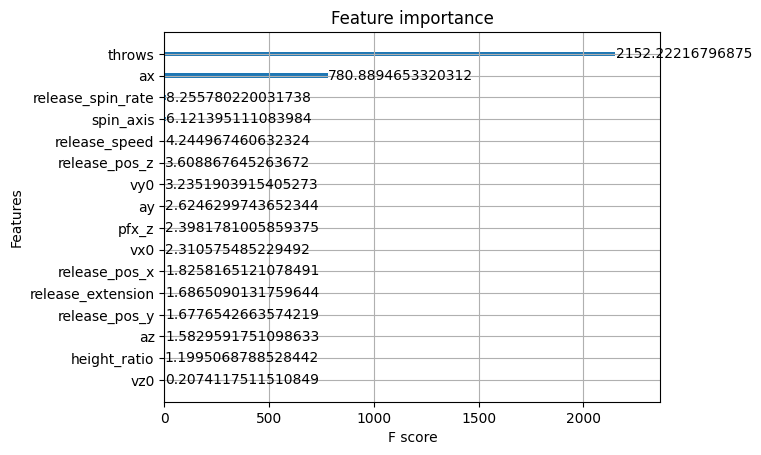

In [24]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

In [25]:
y_pred = final_model.predict(dtest)

In [26]:
print(y_pred.min())

-1.8204494


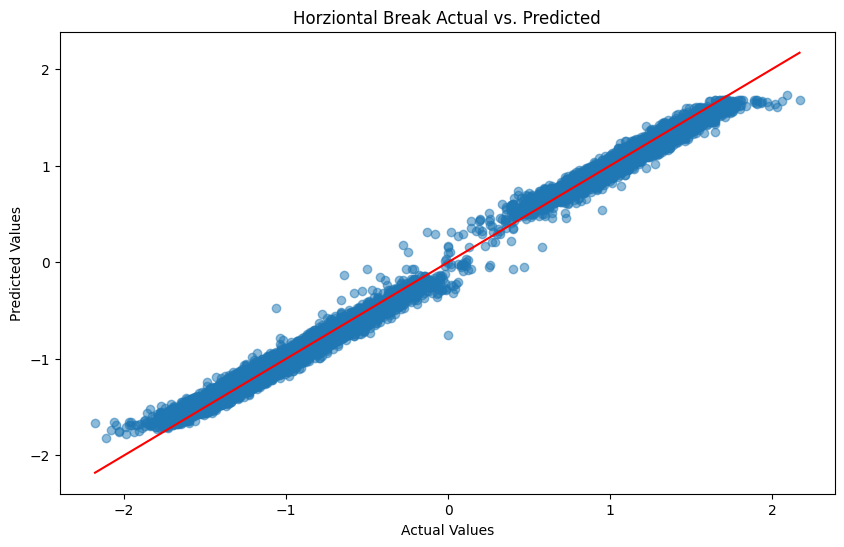

In [27]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('Horziontal Break Actual vs. Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red') # Line for perfect predictions
plt.show()

## Testing Data Set Predictions

In [28]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_z', 'vx0',
       'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'throws'],
      dtype='object')

In [29]:
predictions = final_model.predict(xgb.DMatrix(testing_data))

In [30]:
testing_identifiers['xpfx_x'] = predictions

In [31]:
testing_identifiers.head()

pitch_id_raw    xpfx_x
9   663364_646240_605347_1_71_10 -1.251096
37   663364_598265_605347_1_64_9 -1.322718
40   663364_623993_598264_4_62_8 -1.238494
65   663364_663527_543135_3_55_7 -1.011307
69   663364_596059_543135_3_53_7 -0.903804

In [32]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/pfx_2022&3_xpfx.csv")